# Intro to Reinforcement Learning and the OpenAI Gym

Reinforcement learning is an area of machine learning focused on algorithms that learn how to take actions in a well-defined environment with the objective of maximizing some type of cumulative reward.  Applications of reinforcement learning include:

* Game agents: software agents that learn how to play games, such as AlphaGo.
* Robots: agents that learn to carry out tasks such as navigation, as in autonomous vehicles.  In a large network of bots, the learned action responses can be periodically shared.

The OpenAI gym https://gym.openai.com is a toolkit for development of reinforcement learning algorithms.  Several complete environments are provided, together with an interface to allow an external software agent to make actions that influence the environment. 

The chapter on reinforcement learning in A. Géron, Hands-On Machine Learning with Scikit-Learn and TensorFlow
Concepts, Tools, and Techniques to Build Intelligent Systems provides a nice introduction to the subject and was a source for some of the material covered here.  Sutton and Barto, Reinforcement Learning: An Introduction http://incompleteideas.net/sutton/book/the-book-2nd.html is an essential source on reinforcement learning that was also very helpful.

### Installing the OpenAI Gym

Detailed instructions are available at https://github.com/openai/gym#installation  If you are using Anaconda, the easiest way to install is to use pip

`$ conda install pip
$ pip install gym`

If you're using custom enviroments, you'll need to install gym in any and all environments in which you'll be using it.

### Installing JSAnimation (optional)

By default, `gym` uses an external window to render a graphical depiction of the environment as it evolves.  In order to render the environment as a list of frames and display them in a jupyter notebook frame, we can use `JSAnimation` https://github.com/jakevdp/JSAnimation.  Detailed instructions for installing JSAnimation are available at https://gist.github.com/gforsyth/188c32b6efe834337d8a   

The following imports include minor logic to flag whether or not JSAnimation could be loaded.   Use of JSAnimation later in the notebook will be conditional on `has_jsanim = True`.

In [3]:
%matplotlib inline

try:
    from JSAnimation.IPython_display import display_animation
    has_jsanim = True
except:
    has_jsanim = False
    
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import gym

import numpy as np

The following function will use JSAnimation and matplotlib to render the environment frames:

In [4]:
def display_frames_as_gif(frames):
    if has_jsanim:
        """
        Displays a list of frames as a gif, with controls
        """
        plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
        display(display_animation(anim, default_mode='loop'))
    else:
        print('JSAnimation was not loaded!')

We'll be using Keras and TensorFlow later.  Due to some wierdness, it seems helpful to preload them:

In [5]:
import tensorflow as tf

tf_ver = tf.__version__
tf_ver_split = tf_ver.split(".")
maj_min_ver = tf_ver_split[0] + '.' + tf_ver_split[1]
maj_min_ver = float(maj_min_ver)

if maj_min_ver >= 1.1:
    print("Installed version ", tf_ver, " includes Keras!")
else:
    print("!!!!!!!   Installed version ", tf_ver, " does not include Keras! !!!!!!!")
    
model = tf.contrib.keras.models.Sequential()
model = None

Installed version  1.1.0  includes Keras!


## The OpenAI Gym CartPole Environment

A "cart pole" is a version of an inverted pendulum and is a classic control problem.  The environment requires a small number of variables to be specified and the set of actions can be reduced to a binary choice.  As a very simple example, it is a good place to start with reinforcement learning.  

To understand the specification of the environment and problem, it's best to first picture the problem and then dive into the python code at https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py  

We'll run 1000 steps of the environment and then start dissecting:

In [6]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action

[2017-06-01 19:52:11,956] Making new env: CartPole-v0
[2017-06-01 19:52:12,463] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


We can close the external window that popped up with 

In [7]:
env.render(close=True)

We saw that the environment consists of a cart that can move along a fixed horizontal axis, together with an attached vertical pole that is free to swing around the point of attachment. 

<img src="images/cartpole.png" alt="the cart-pole environment" style="width: 600px;"/>

The state of the environment is therefore completely specified by:
1. The horizontal position $x$ of the cart, in meters.
2. The horizontal velocity $\dot{x}$ of the cart.  The units are a bit complex (50 m/s), since the system evolves according to 
$$ x(t+1) = x(t) + \tau \dot{x}(t),$$
where $\tau = 0.02 s$ is the number of seconds between state updates.
3. The angular position $\theta$ of the pole, measured from the vertical axis, in radians.
4. The angular velocity $\dot{\theta}$ of the pole, with analogous units and update as the cart velocity.
Additional fixed values that specify the system are the masses of the cart and pole and the pole length.

Digging into the code, the cart is subject to the force applied by an external action.  The pole is subject to gravity and  the external action as transferred by the connection to the cart.  The state of the system evolves according to Newton's laws of motion.

The allowed external action is the application of an instantaneous force in either the $+x$ or $-x$ direction.  The fixed magnitude of the force is roughly 10 times that of the effective force of gravity on the pole.

The system is encoded in a python class that is assigned via

In [8]:
env = gym.make('CartPole-v0')

[2017-06-01 19:52:30,024] Making new env: CartPole-v0


The environment class includes a number of methods. To reset the environment, we can run

In [9]:
env.reset()

array([-0.01889644, -0.04175043,  0.04779961, -0.03299684])

The returned array contains the state variables `[x, x_dot, theta, theta_dot]`.   We can obviously store the state by assignment:

In [10]:
obs = env.reset()
print(obs)

[ 0.0309092   0.04532579  0.04348628  0.01094107]


Allowed actions are boolean:

In [11]:
env.action_space

Discrete(2)

An action of `1` is translated to a force in the $+x$ direction, while an action of `0` is applied in the $-x$ direction.

The `Discrete(2)` function is provided by the gym spaces libraries https://github.com/openai/gym/tree/master/gym/spaces.  A `sample` method is provided:

In [12]:
for i in range(5):
    print(env.action_space.sample())

1
0
1
0
0


We can use the `step(action)` method to manually apply the `action` and update the system:

In [13]:
print(env.step(1))
print(env.step(1))
print(env.step(0))
print(env.step(0))

(array([ 0.03181572,  0.23979799,  0.0437051 , -0.26771051]), 1.0, False, {})
(array([ 0.03661168,  0.43426983,  0.03835089, -0.54629451]), 1.0, False, {})
(array([ 0.04529707,  0.23863062,  0.027425  , -0.24177907]), 1.0, False, {})
(array([ 0.05006969,  0.04312787,  0.02258942,  0.05942671]), 1.0, False, {})


The information returned is the list of state variables, then the reward, then a boolean indicating whether or not the simulation has terminated due to failure.  The final block is a space for additional information that this `CartPole` class has not been programmed to generate.

Failure conditions consist of two possibilities:

1. The pole has fallen past the threshold, i.e., $ |\theta| >  \pi / 15 = 12^\circ$.
2. The cart has been driven off the field, $ |x| > 2.4 $.

A reward of 1 is given if the action did not result in failure, while no reward is given if the action led to failure.  This convention is chosen so that the cumulative reward is equal to the number of steps taken before failure.

If the failure condition has not been reached, the Cart-Pole-v0 simulation automatically terminates after a maximum of 200 steps.

### Objective of the Cart-Pole Problem

The **objective** of the problem is keep the pole in the air and the car in the playing field as long as possible. Obviously we are rewarded everytime that we make an action that does not result in failure, so a corollary objective is to maximize the award received.  To be specific, CartPole-v0 defines a solution as an agent that receives an average reward of 195.0 over 100 consecutive trials. 

The `render` method updates the graphical representation of the system. 

In [14]:
env.render()

In [15]:
for _ in range(15):
    env.render()
    observation, reward, done, info = env.step(1)
    print(observation, reward, done, info)

[2017-06-01 19:52:31,265] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


[ 0.05093224  0.23791877  0.02377795 -0.22604437] 1.0 False {}
[ 0.05569062  0.43269297  0.01925707 -0.51113302] 1.0 False {}
[ 0.06434448  0.62753844  0.00903441 -0.7976858 ] 1.0 False {}
[ 0.07689525  0.82253527 -0.00691931 -1.08751304] 1.0 False {}
[ 0.09334595  1.01774779 -0.02866957 -1.38235906] 1.0 False {}
[ 0.11370091  1.21321548 -0.05631675 -1.68386781] 1.0 False {}
[ 0.13796522  1.40894231 -0.08999411 -1.99354098] 1.0 False {}
[ 0.16614406  1.60488369 -0.12986493 -2.31268623] 1.0 False {}
[ 0.19824174  1.80093092 -0.17611865 -2.64235388] 1.0 False {}
[ 0.23426036  1.9968931  -0.22896573 -2.98326182] 1.0 True {}
[ 0.27419822  2.19247721 -0.28863097 -3.33571064] 0.0 True {}
[ 0.31804776  2.38726775 -0.35534518 -3.69949421] 0.0 True {}
[ 0.36579312  2.58070879 -0.42933506 -4.07381507] 0.0 True {}
[ 0.41740729  2.77209243 -0.51081136 -4.45721864] 0.0 True {}
[ 0.47284914  2.96055903 -0.59995574 -4.84756361] 0.0 True {}


We demonstrated how to assign the information returned by the `step` method for possible future uses.  Since this series of actions should have resulted in failure, we'll reset the system.  

In [16]:
env.reset()
env.render()

Note that we called `render` to update the visualization.  

We can use the random sample method on the action space to define a random action:

In [17]:
for _ in range(100):
    env.render()
    action = env.action_space.sample()
    env.step(action)

[2017-06-01 19:52:32,063] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


In [18]:
env.reset()
env.render()

Render also has a mode to generate an RGB array of the environment:

In [19]:
env.render(mode = 'rgb_array')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

In [20]:
env.render(mode = 'rgb_array').shape

(400, 600, 3)

We can store these arrays in a list and then display them using JSAnimation:


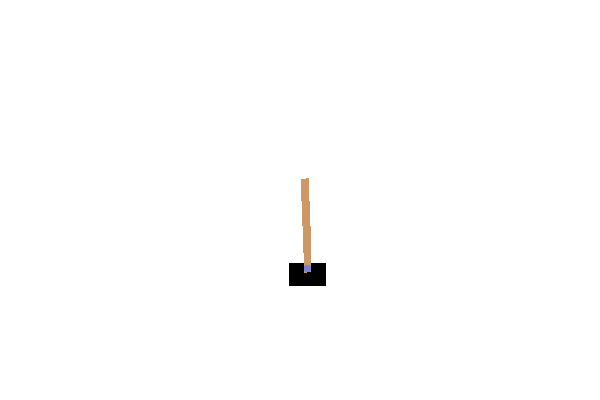
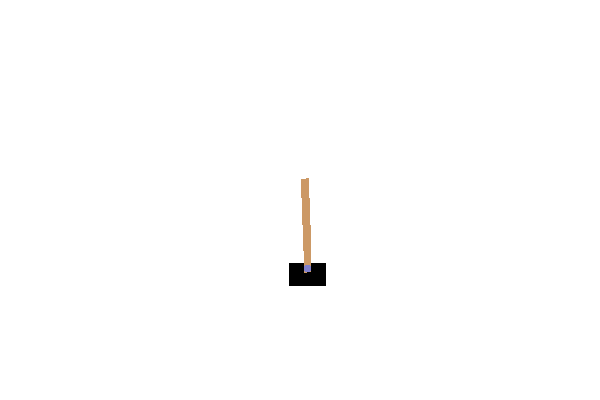
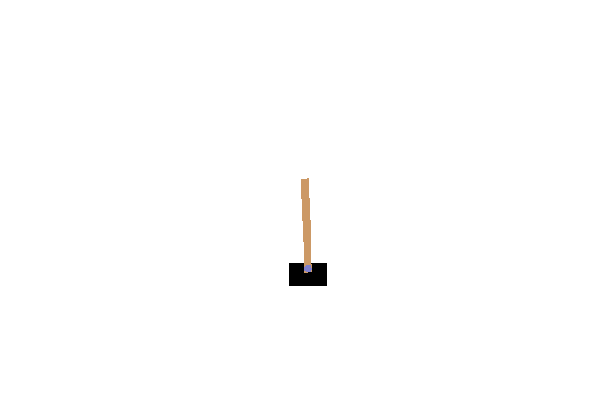
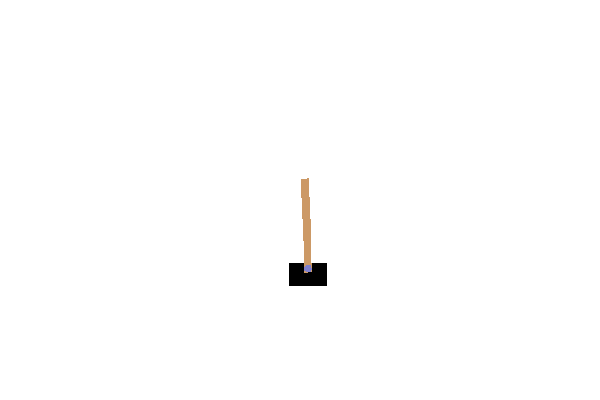
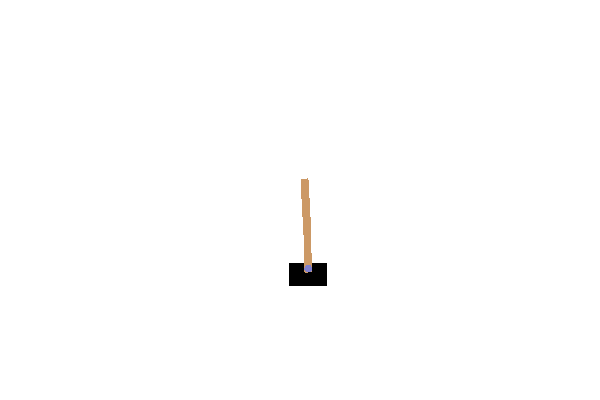
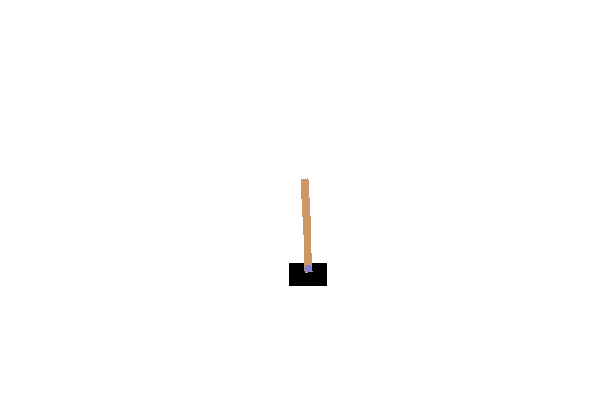
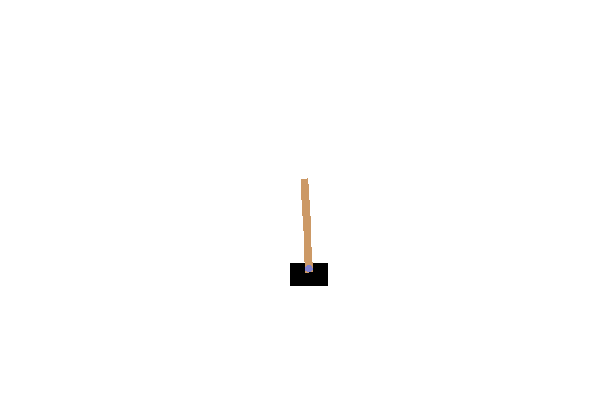
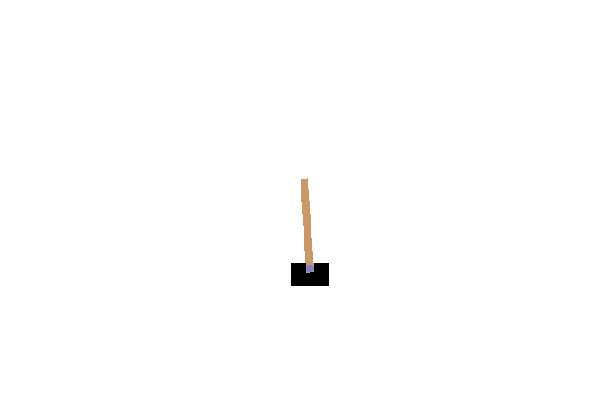
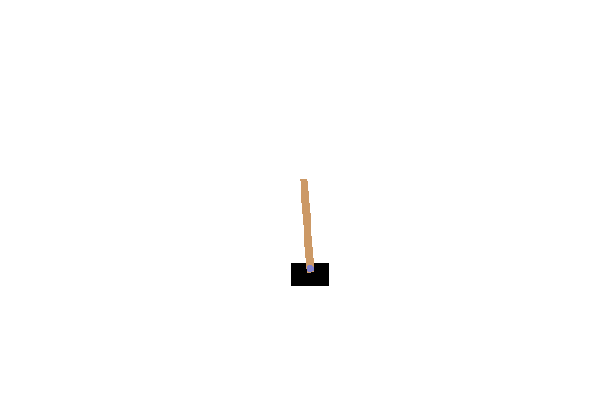
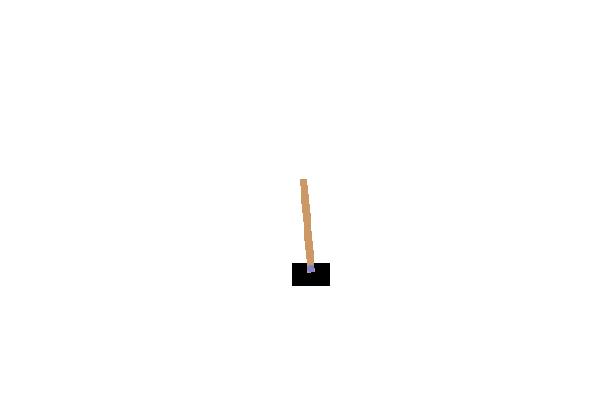
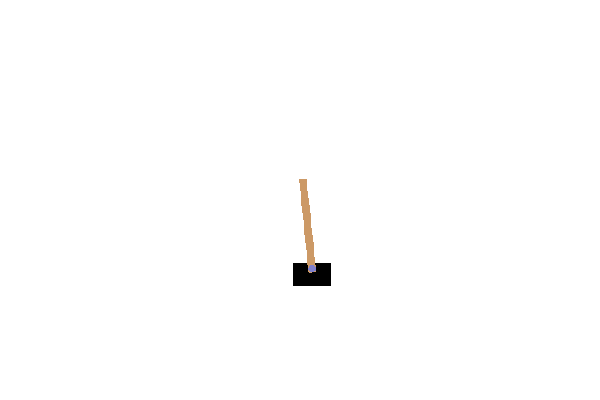
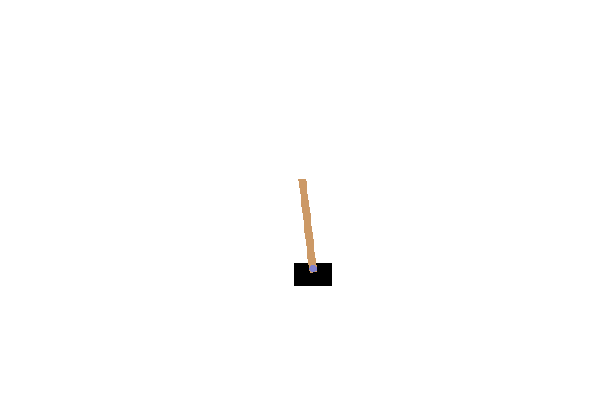
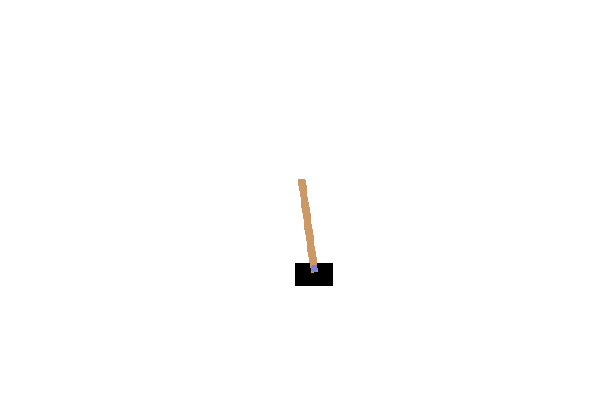
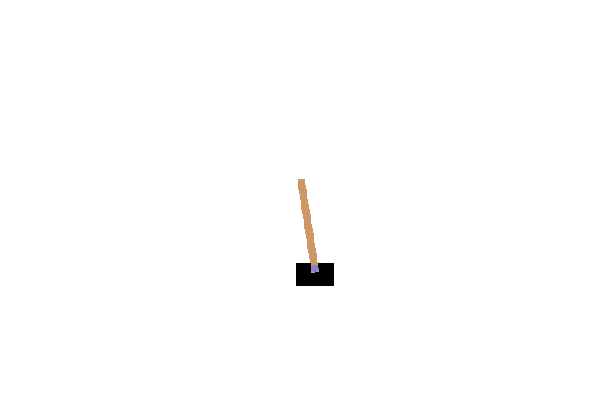
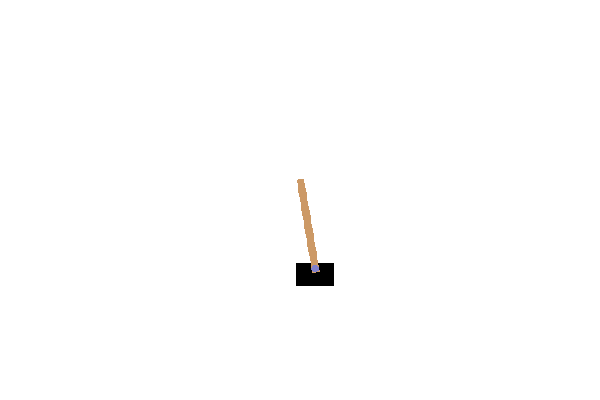
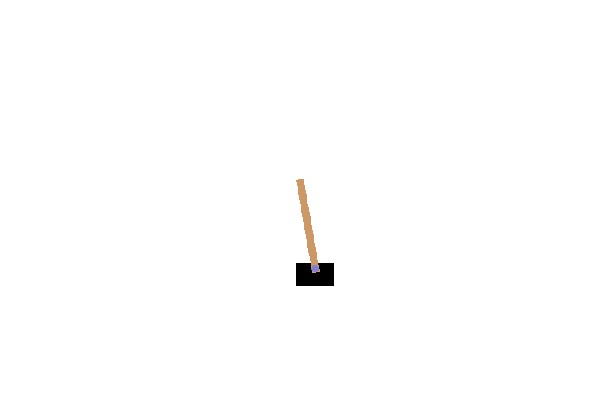
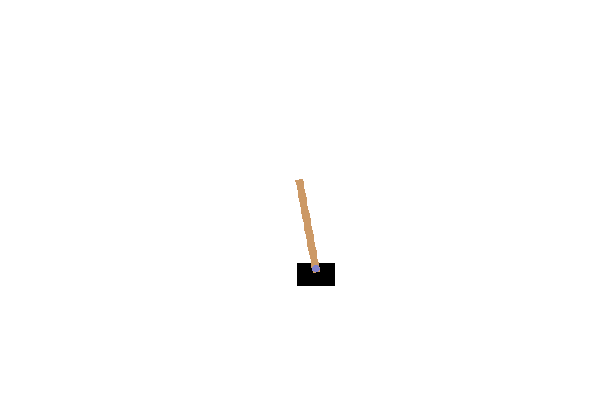
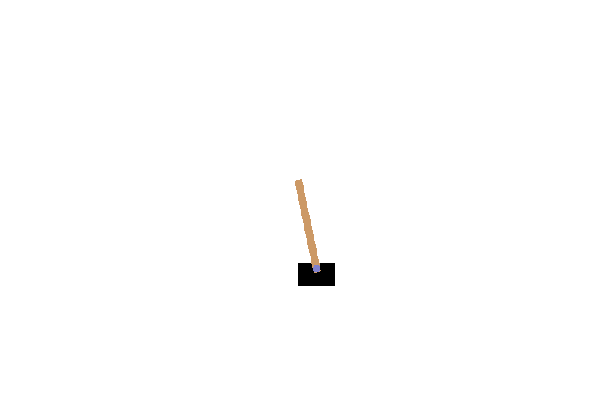

In [21]:
n_iter = 5000

observation = env.reset()

frames = []

for t in range(n_iter):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)

display_frames_as_gif(frames)

If JSAnimation was not previously loaded, you'll just get a message to that effect.

Note that it is not currently possible to prevent `render` from generating the external window. It is possible to direct that window to a dummy Xserver, but we won't try to do that here

### Action Policies

An action policy is a set of rules that specifies the action to take given the current observed state of the system.  The random choice method used above was such a policy, if not a particularly sophisticated one.

The next step would be the simple policy that we move the cart in the direction that the pole is leaning:

In [22]:
def deflection_policy(obs):
    deflection = obs[2]
    action = 0
    if deflection > 0:
        action = 1
    return action

Since we will be running many simulations, let's create a function that will automate the process and return the cumulative reward before failure.

In [23]:
def cartpole_episode(policy):
    # temp. suppress logger messages from gym
    import logging
    logger = logging.getLogger('gym')
    logger.propagate = False
    env = gym.make('CartPole-v0')
    logger.propagate = True

    # back to episode
    obs = env.reset()
    done = False
    cum_rewards = 0
    while not done:
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(obs)
        obs, reward, done, info = env.step(action)
        cum_rewards += reward
    return cum_rewards

In [24]:
cartpole_episode(deflection_policy)

38.0

We can write another function that will run many episodes and print a report on the average rewards.

In [25]:
def run_episodes(episode_type, policy, n_iter):
    ep_rewards = []
    for _ in range(n_iter):
        ep_rewards.append(episode_type(policy))
    mean_reward = np.mean(ep_rewards)
    std_reward = np.std(ep_rewards)
    max_reward = np.max(ep_rewards)
    min_reward = np.min(ep_rewards)
    return (mean_reward, std_reward, max_reward, min_reward)

In [26]:
(mean_reward, std_reward, max_reward, min_reward) = run_episodes(cartpole_episode, deflection_policy, 1000)
print("Mean/standard deviation of rewards was:", 
      format(mean_reward, '.2f'), 
      "+/-", 
      format(std_reward, '.2f')
     )
print("Max reward was:", max_reward)
print("Min reward was:", min_reward)

Mean/standard deviation of rewards was: 41.37 +/- 9.04
Max reward was: 68.0
Min reward was: 24.0


Let's visualize what is happening with this policy.


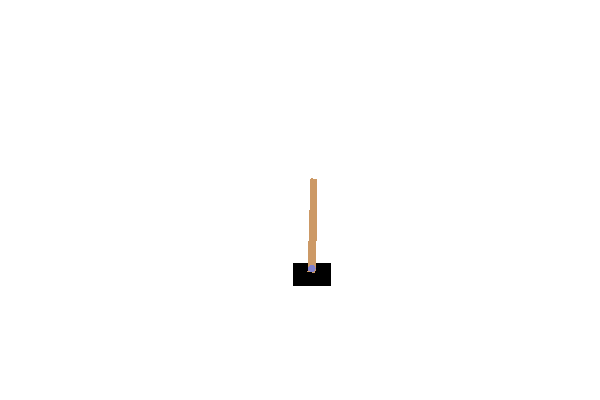
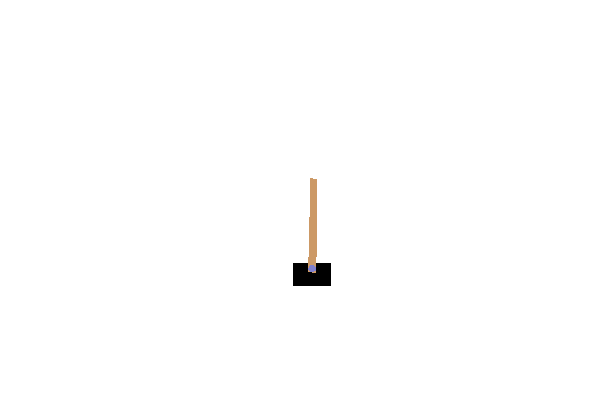
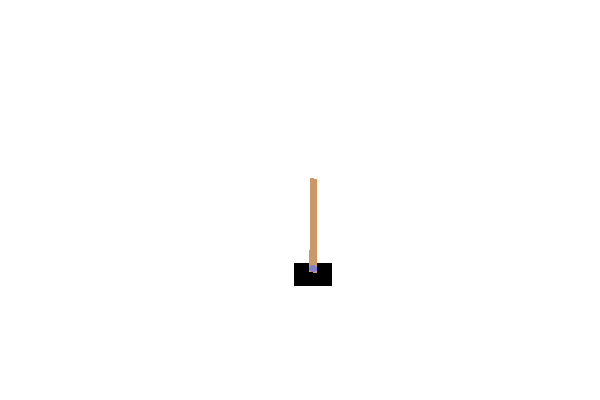
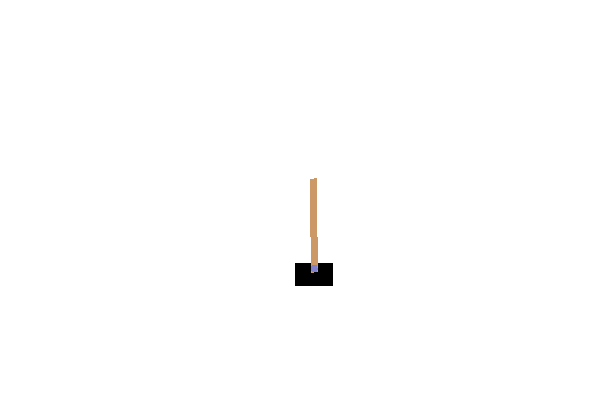
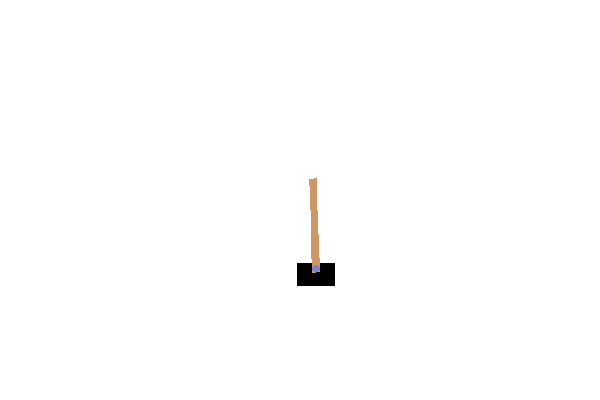
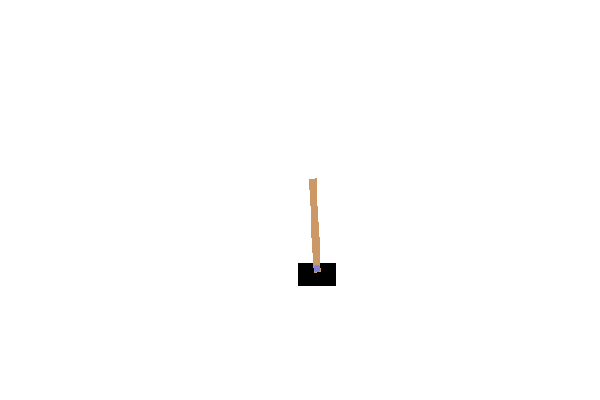
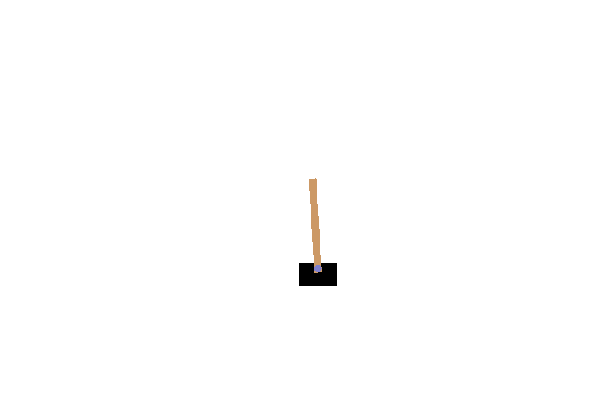
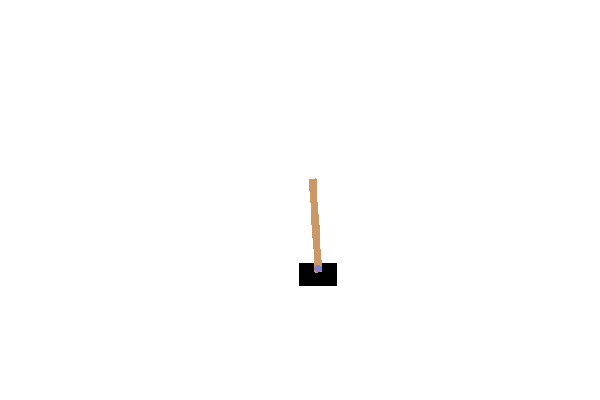
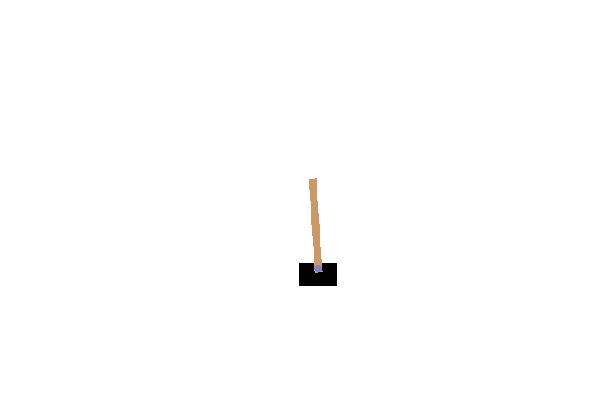
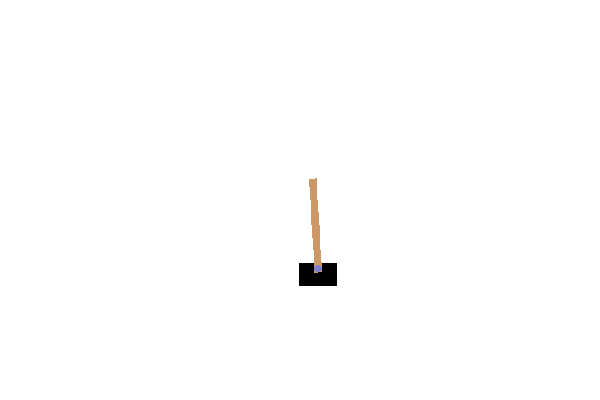
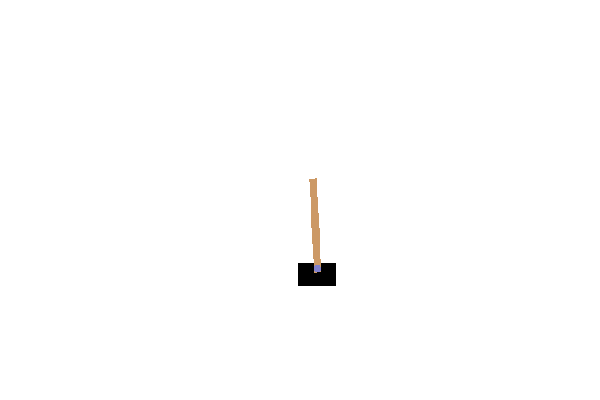
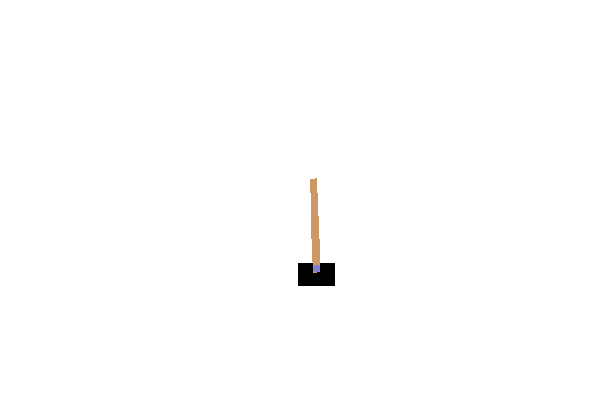
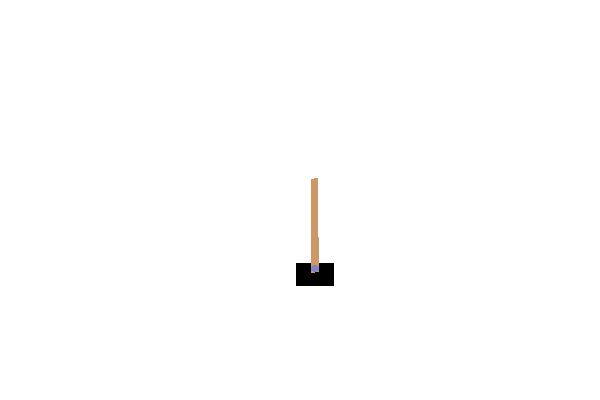
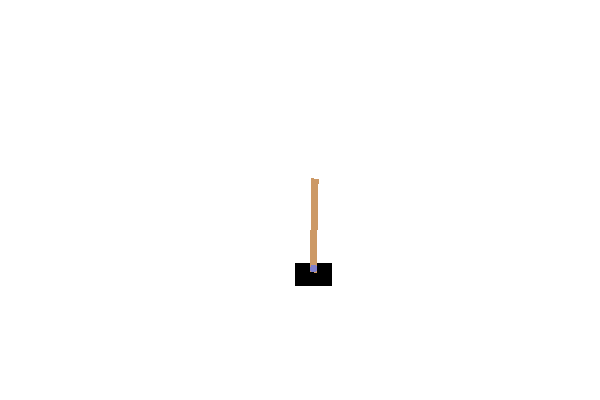
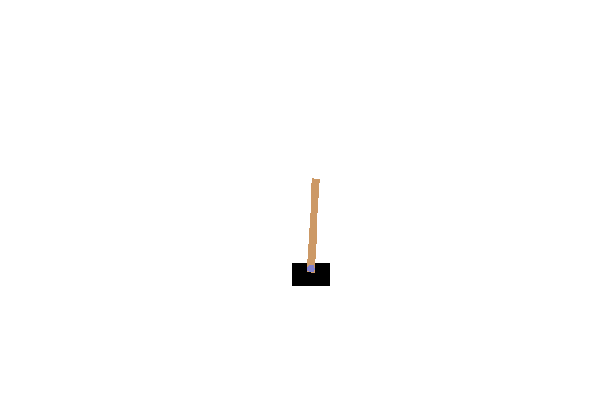
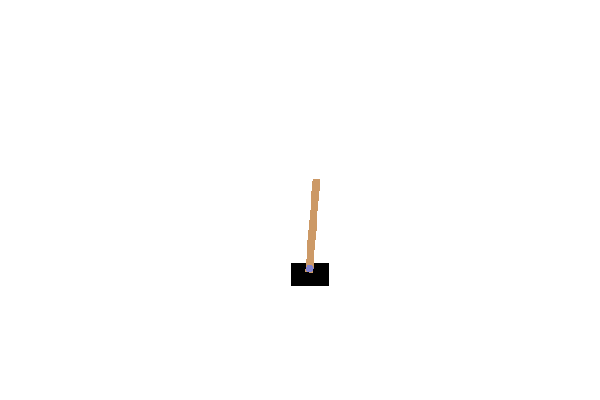
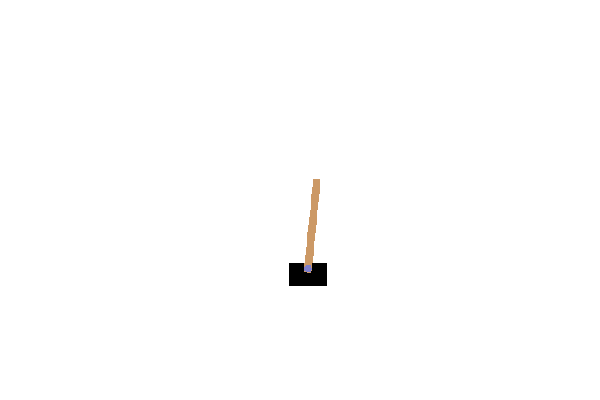
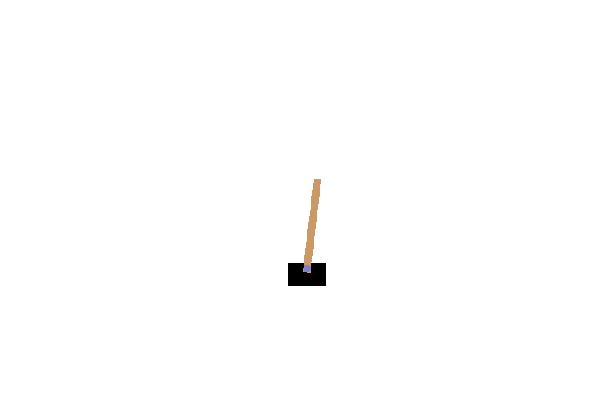
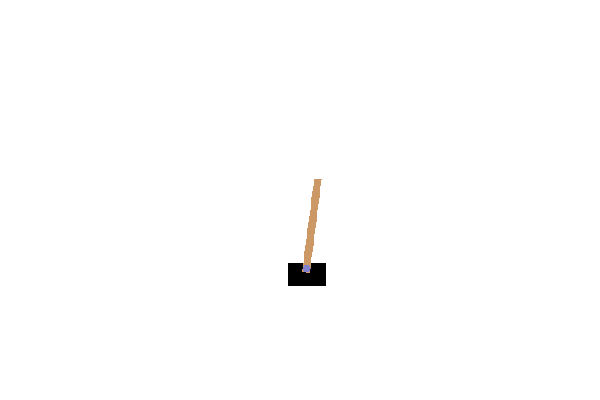
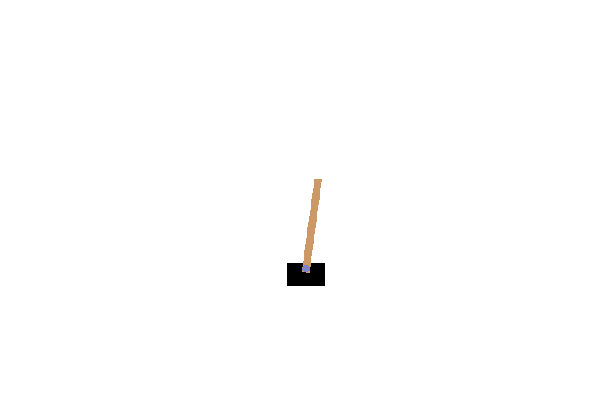
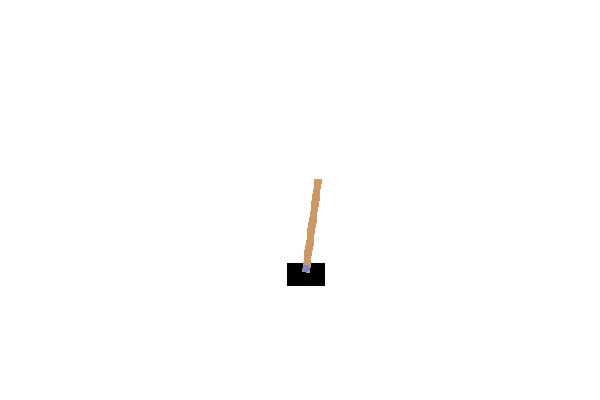
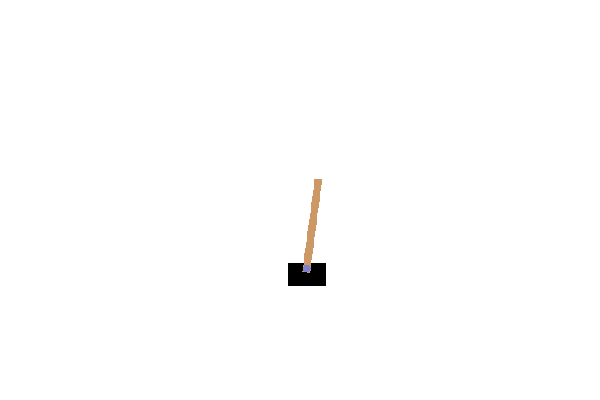
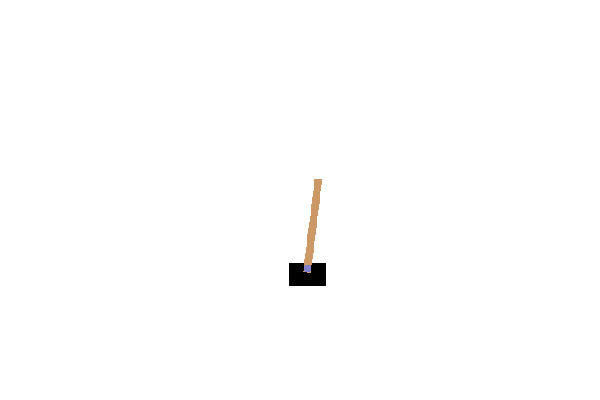
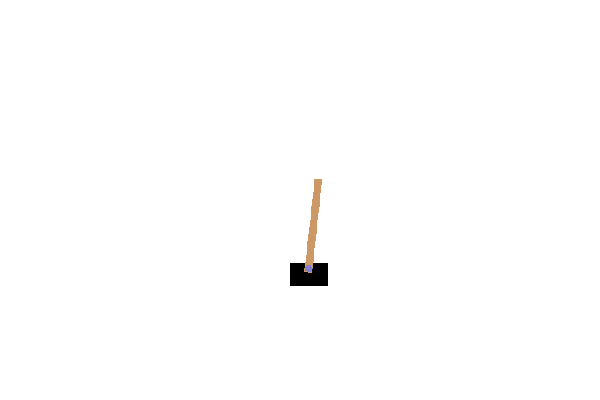
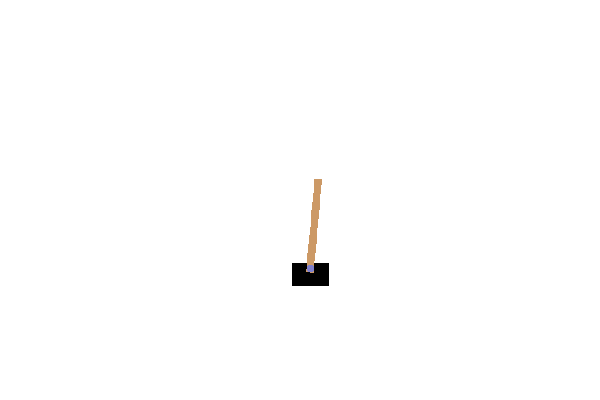
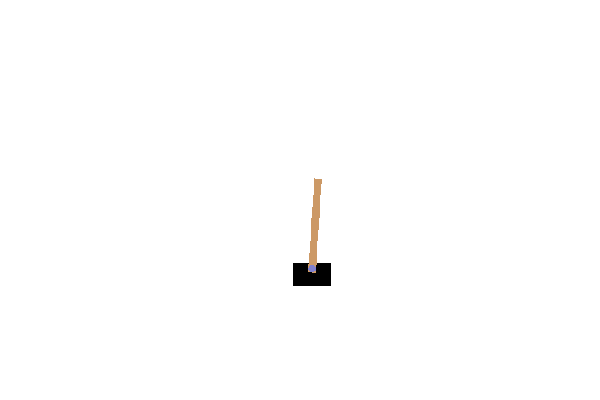
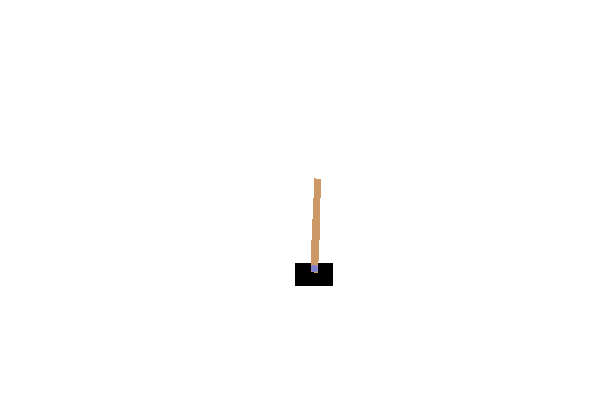
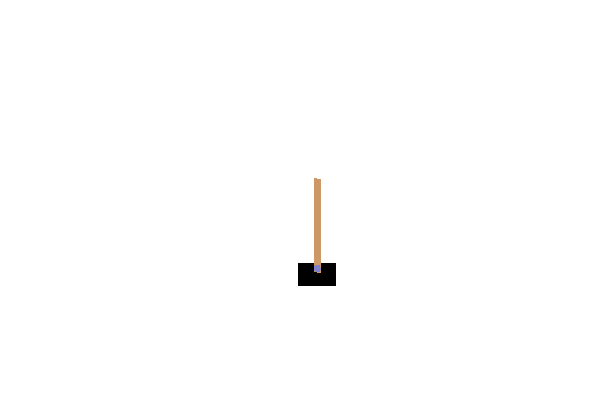
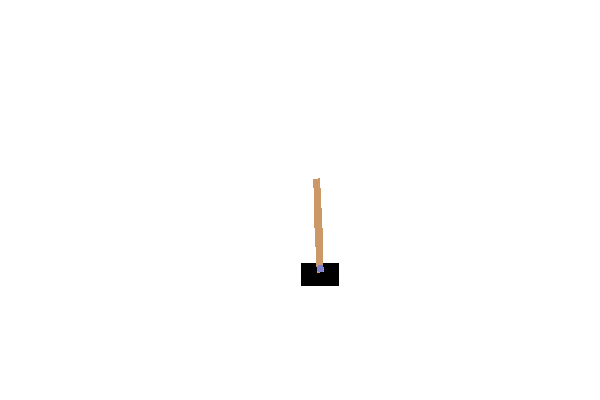
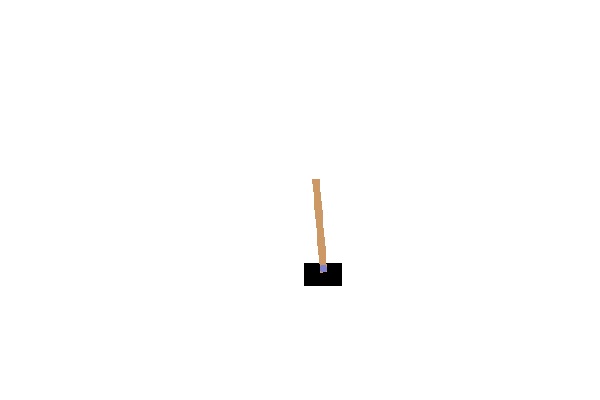
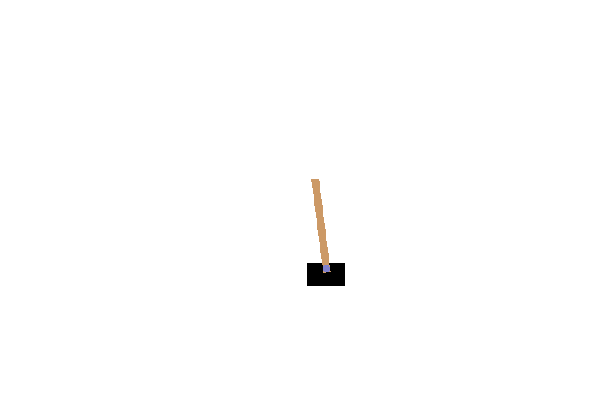
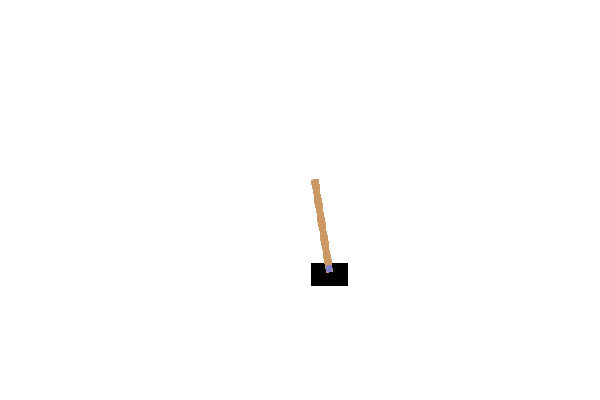
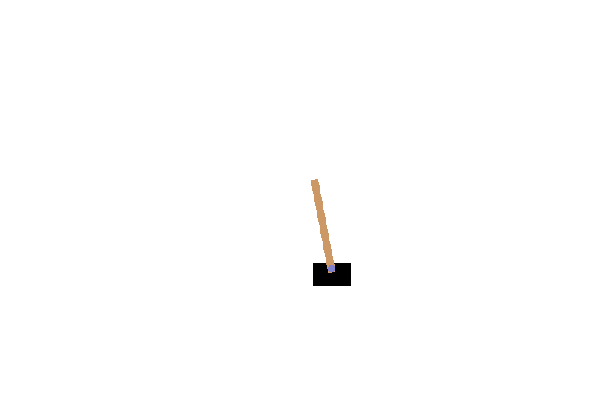
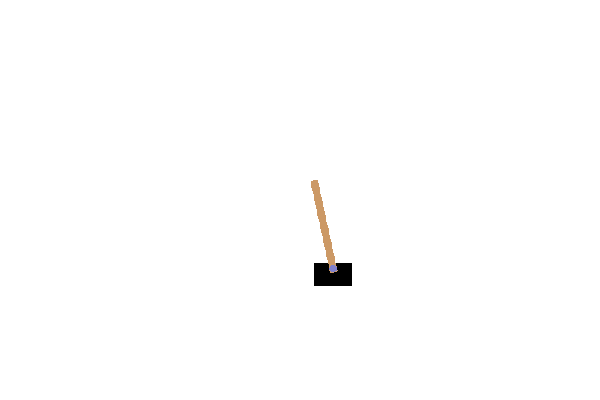
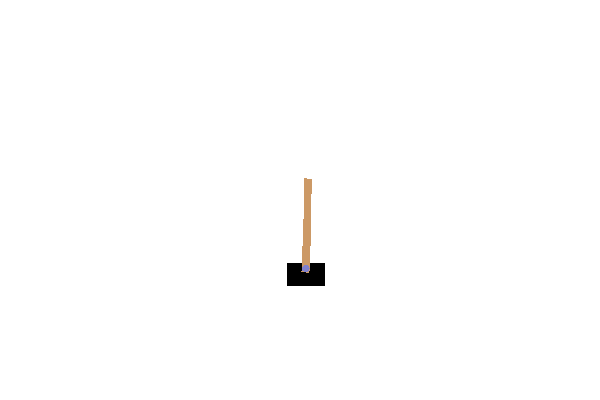
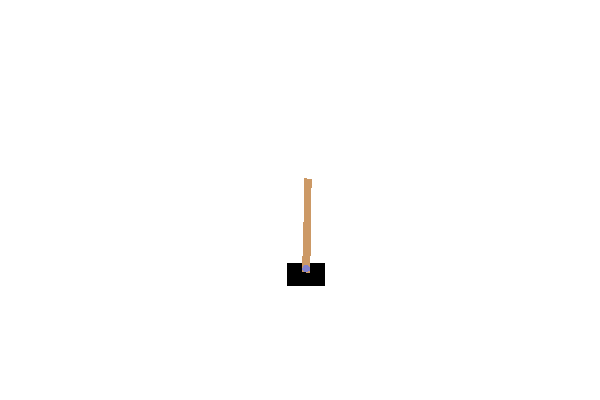
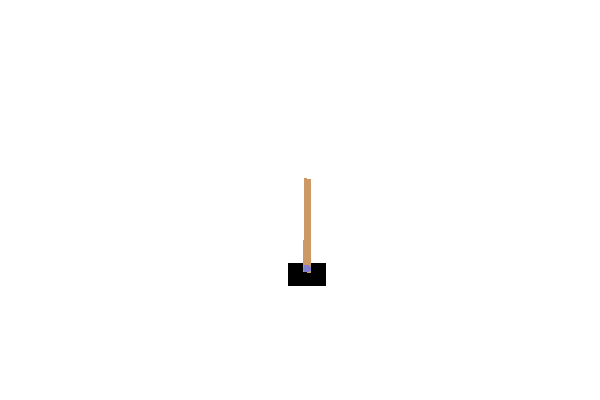
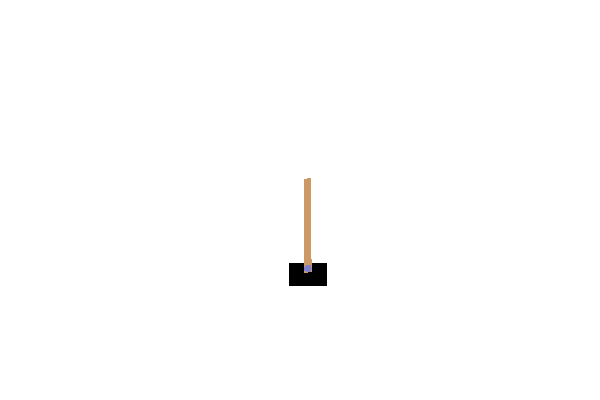
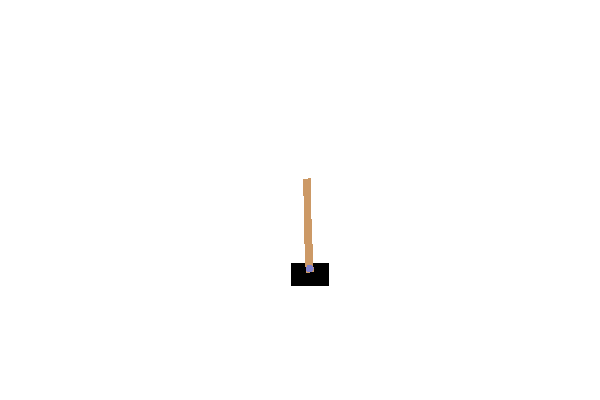
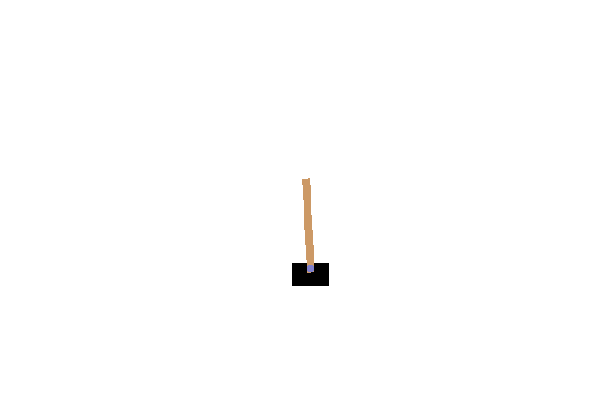
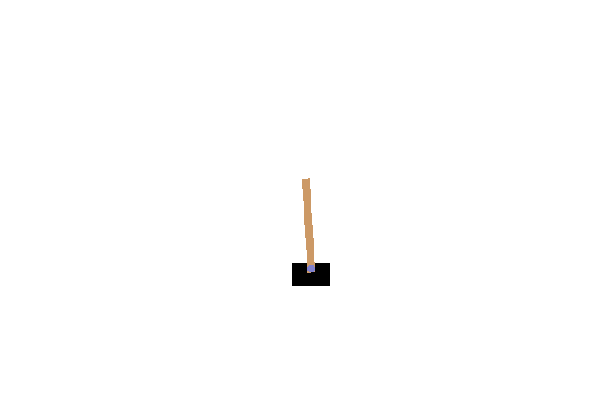
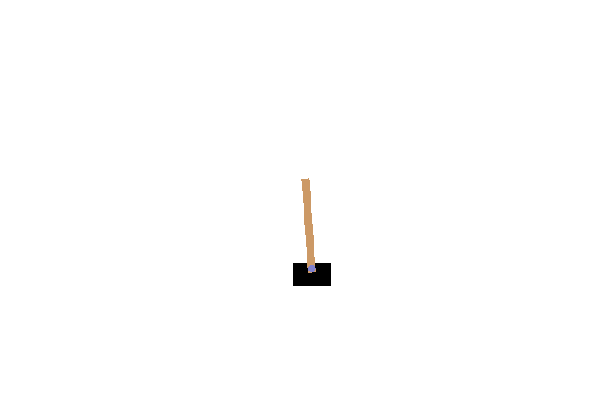
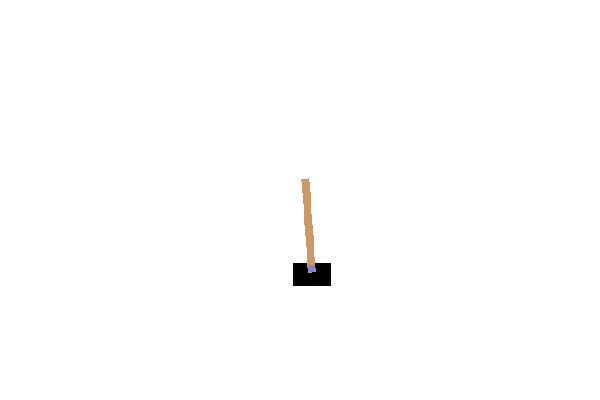
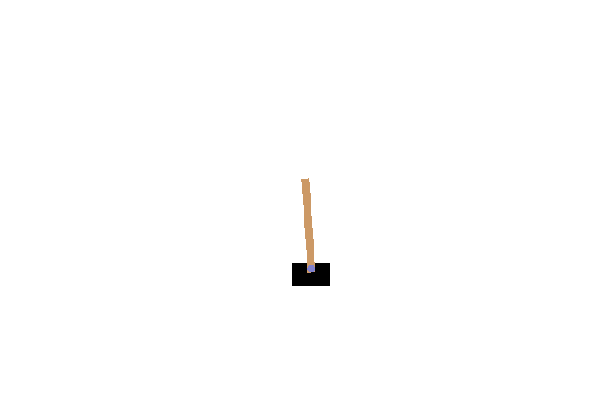
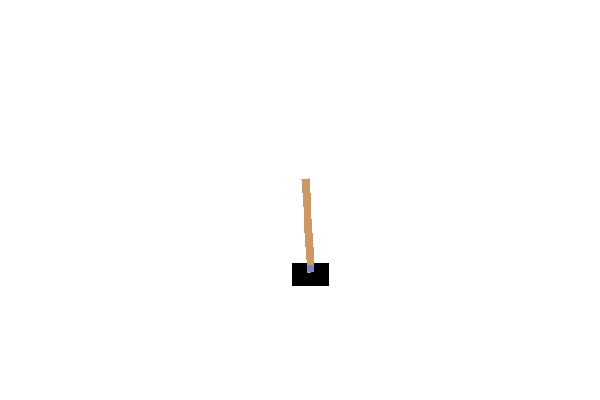
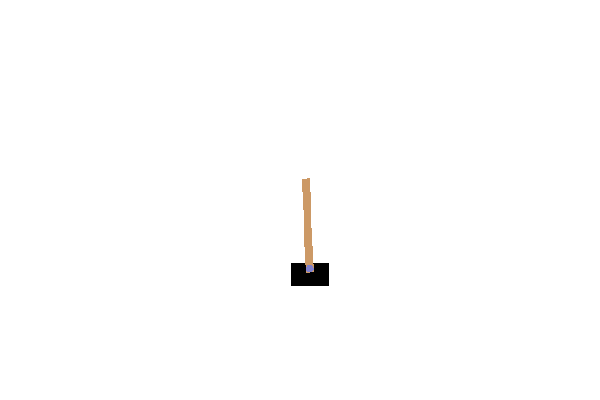
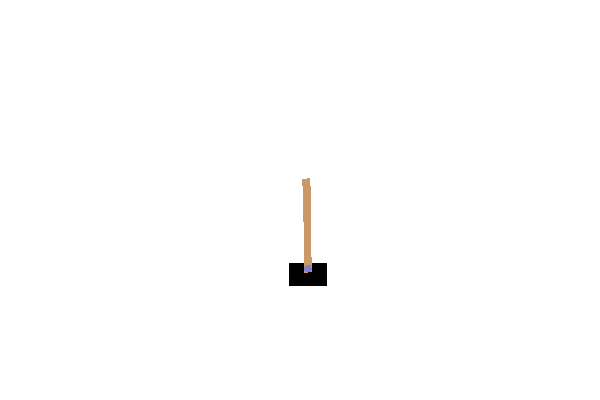
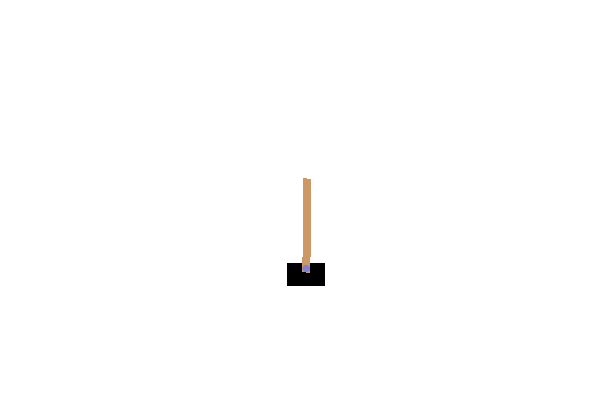
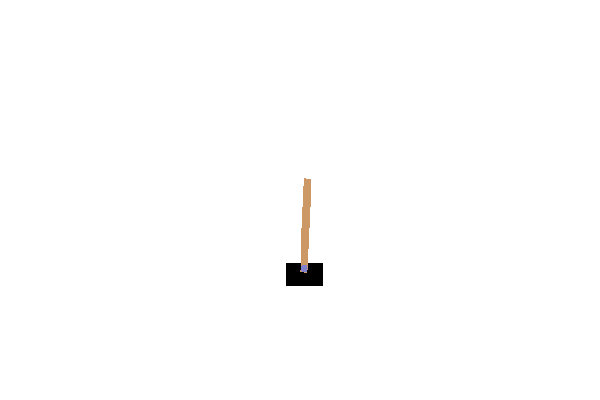
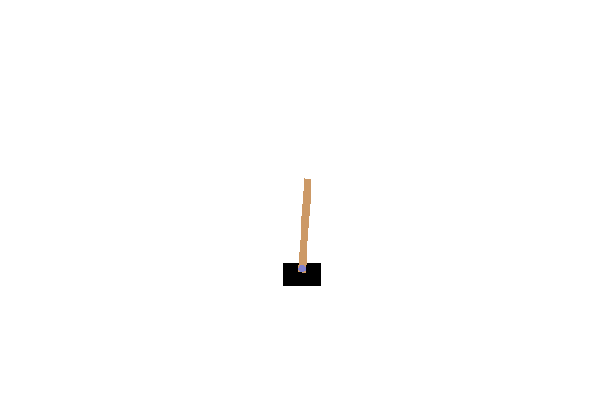
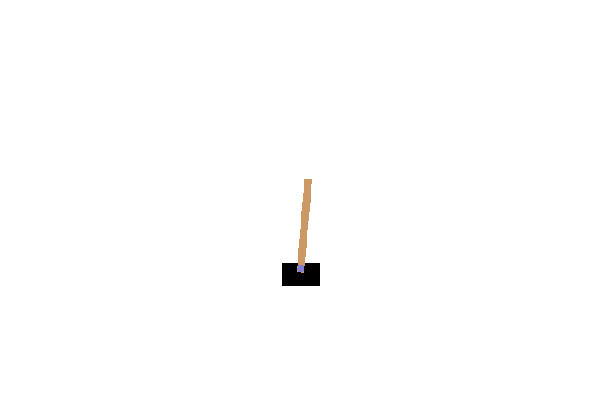
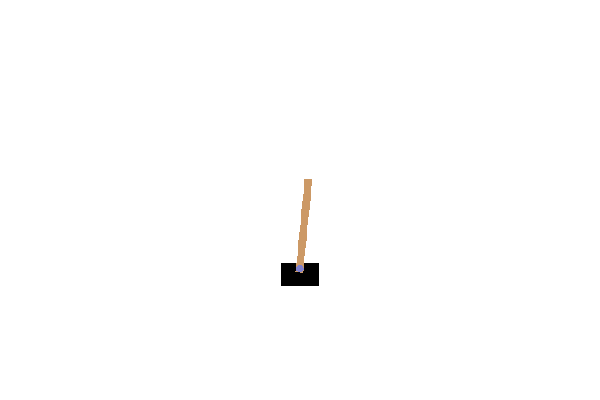
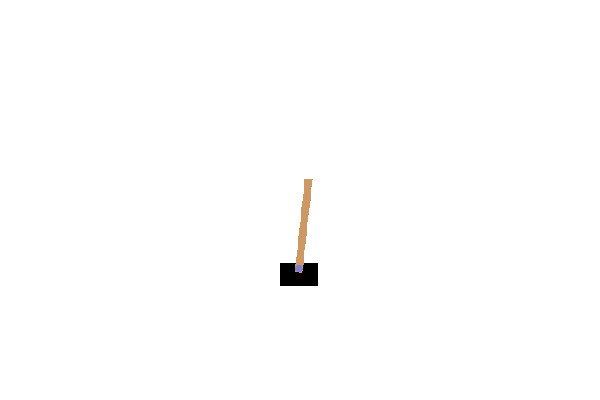
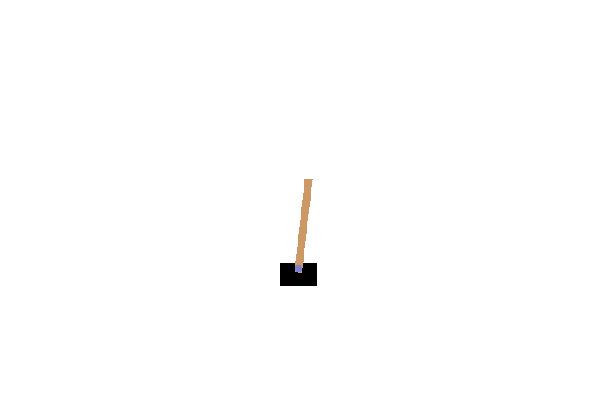
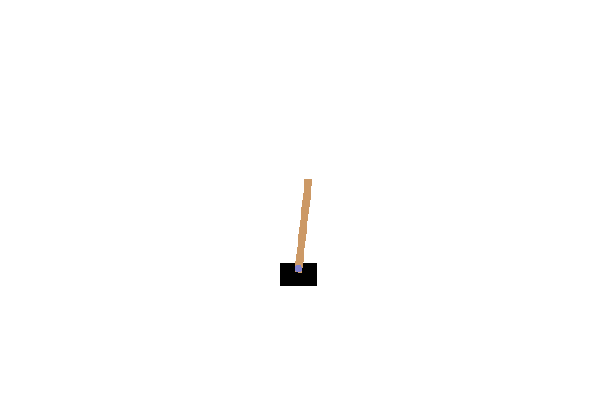
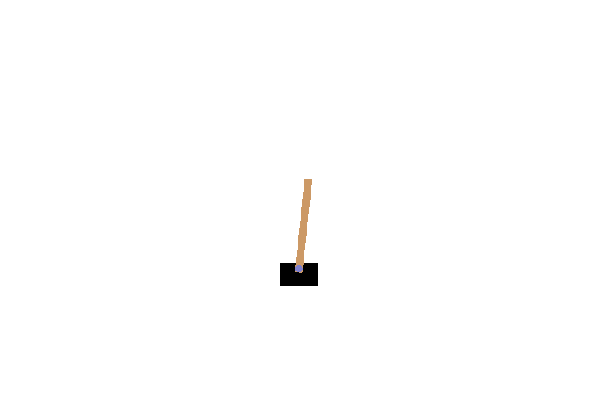
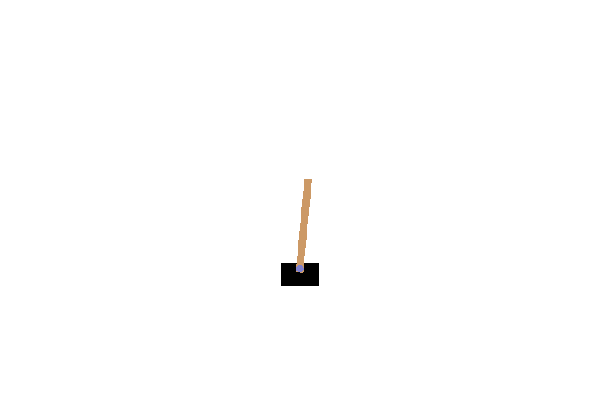
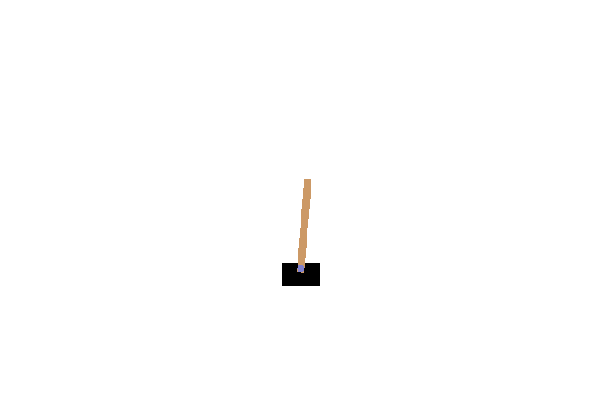
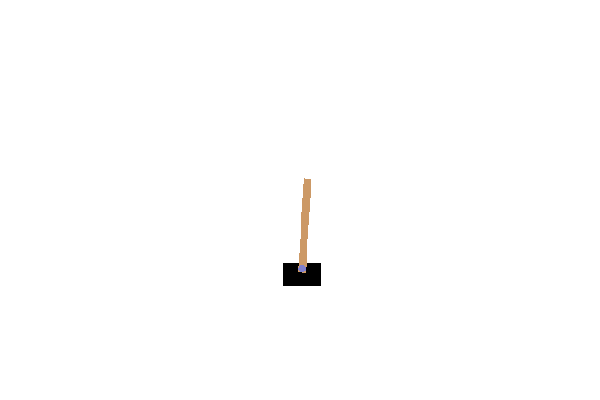
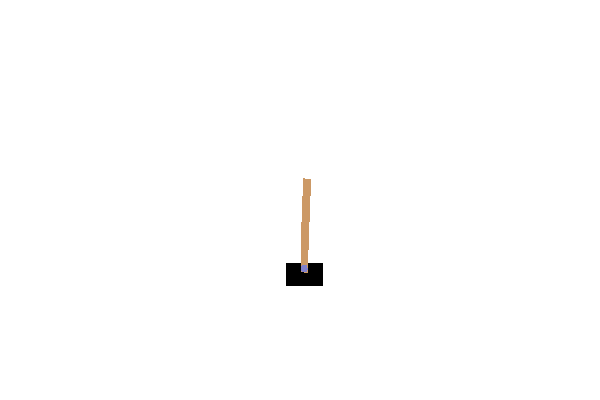
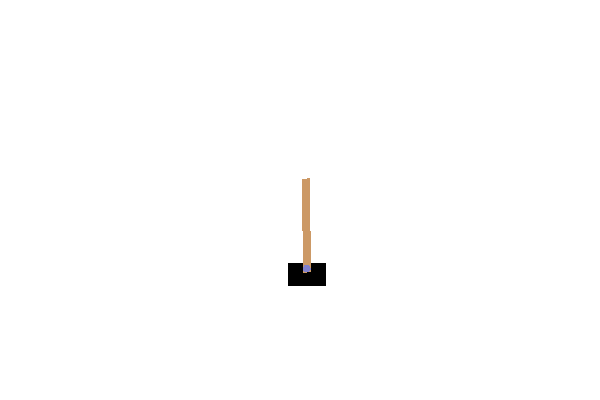
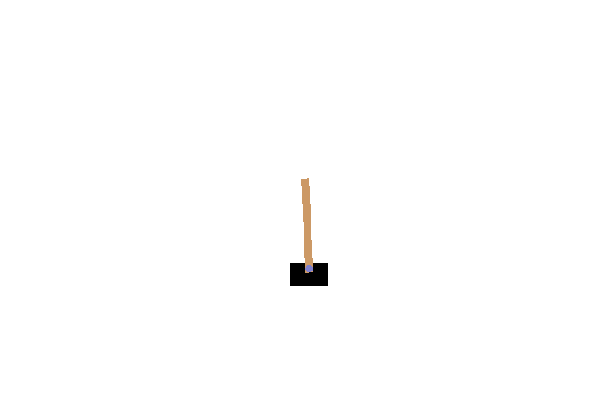
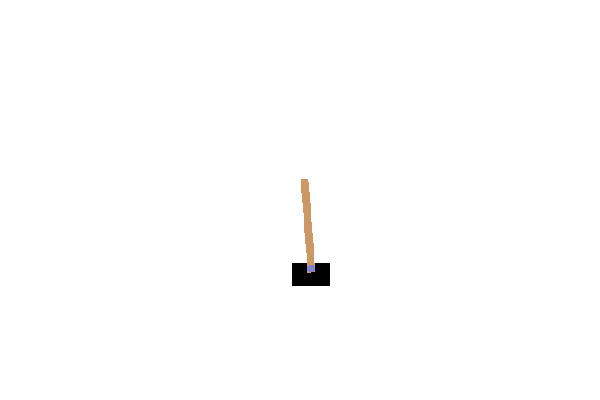
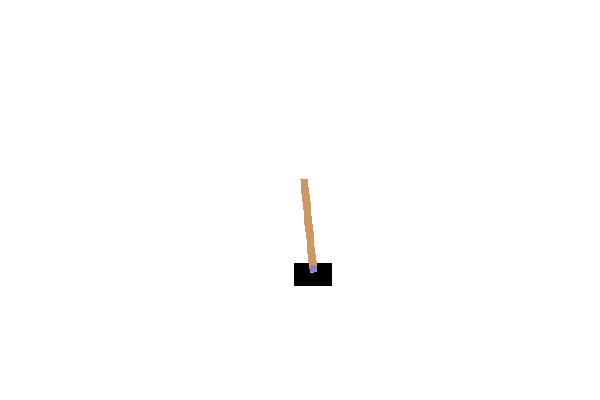
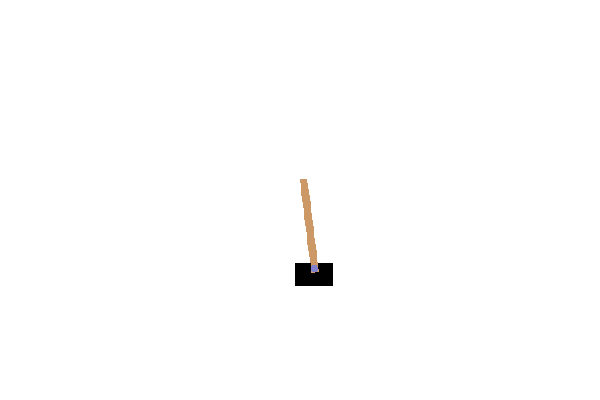
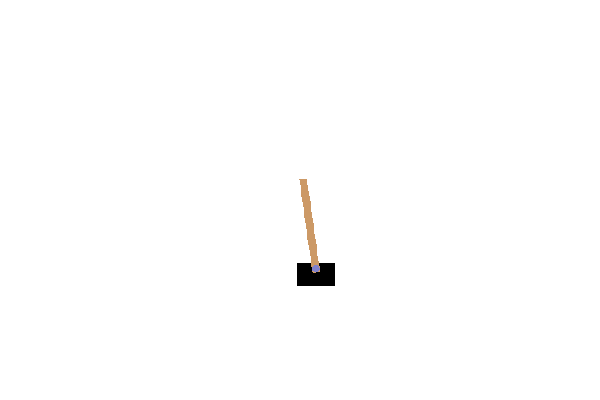
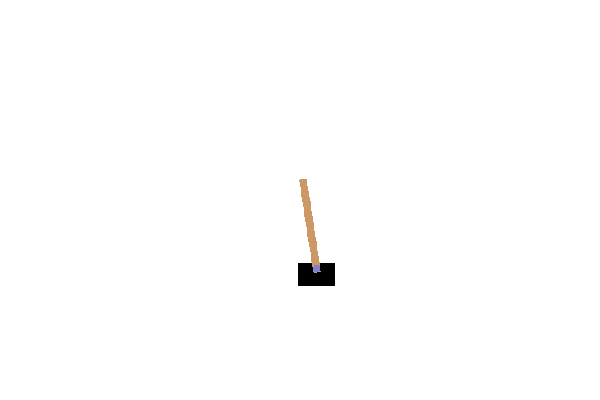
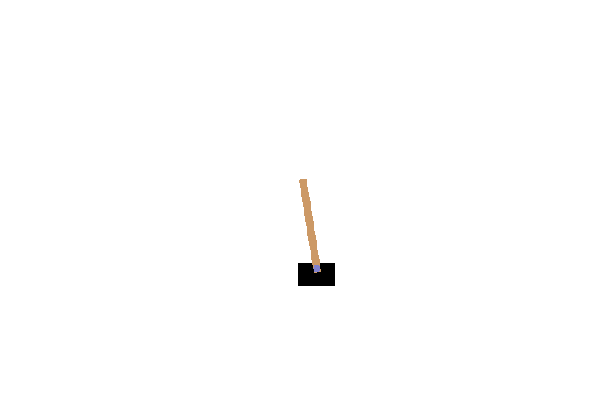
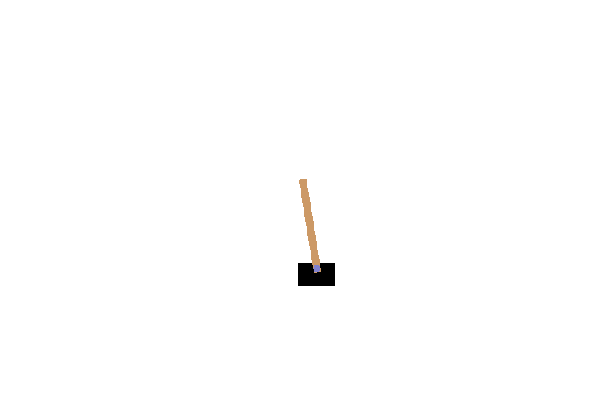
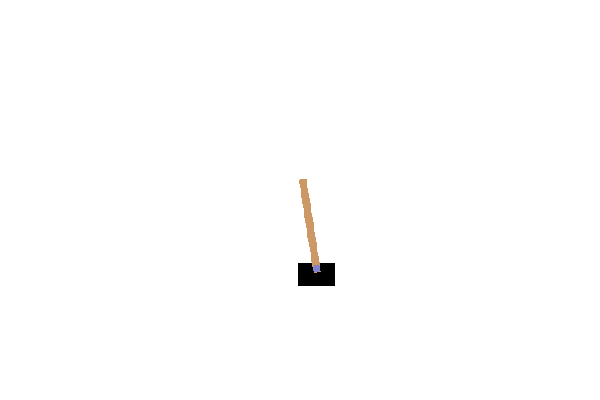
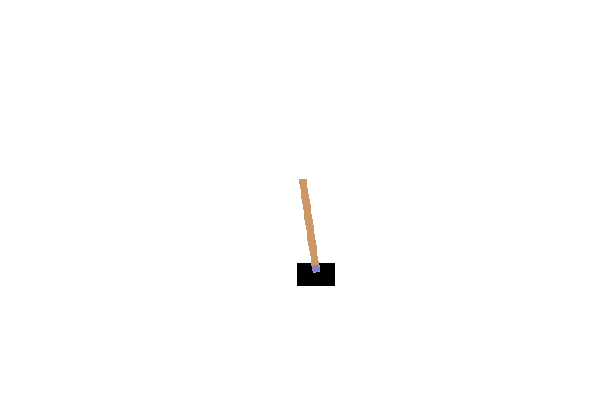
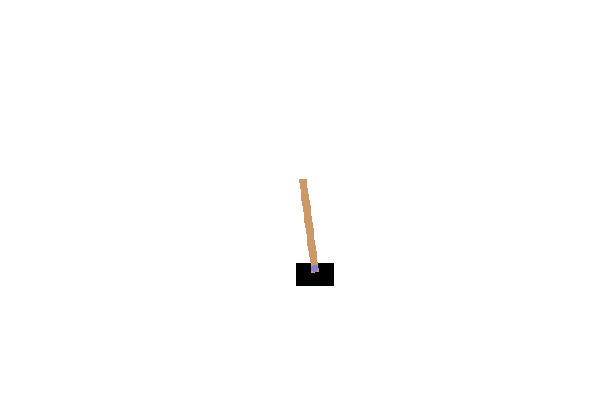
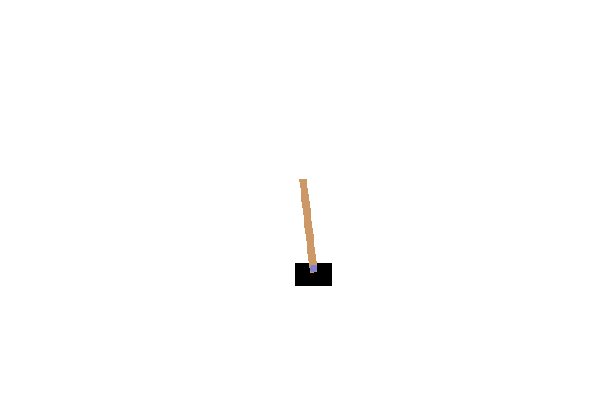
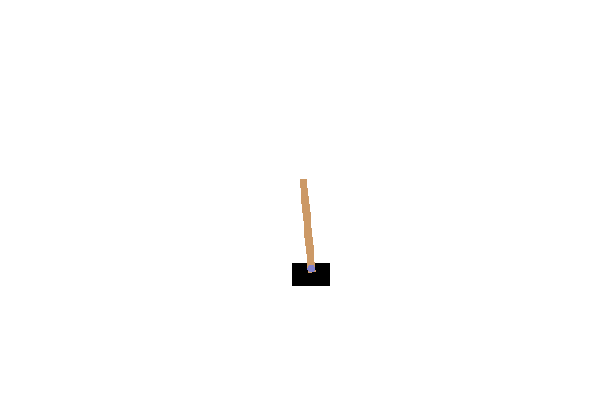
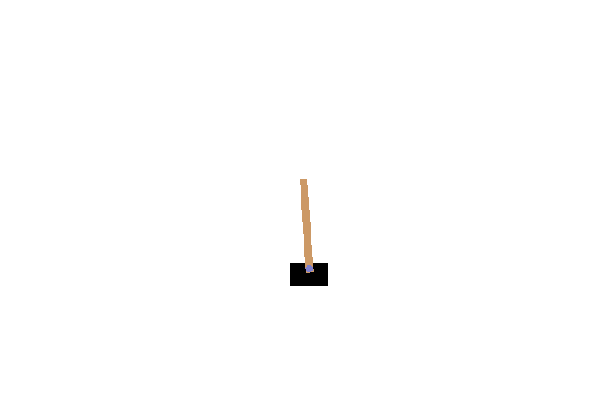
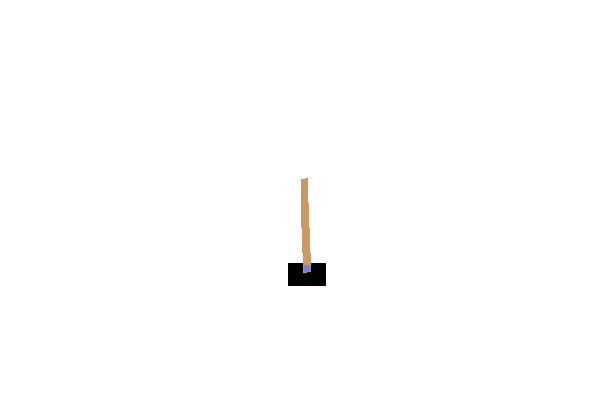
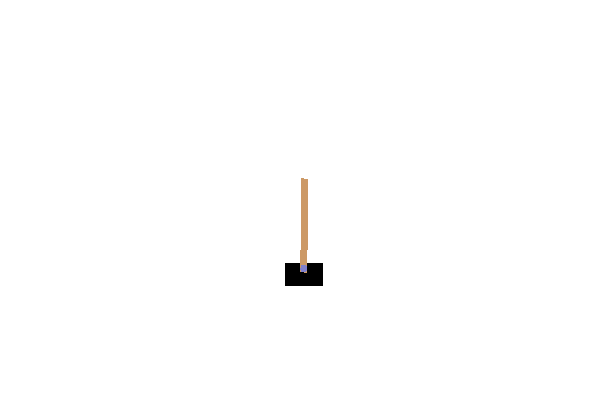
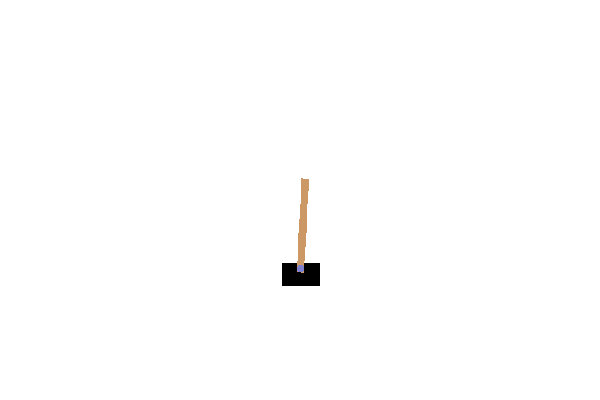
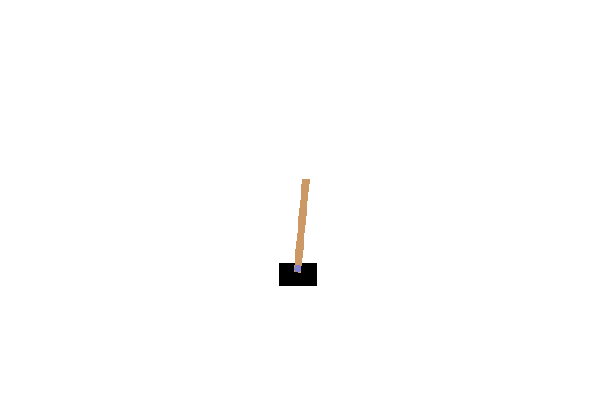
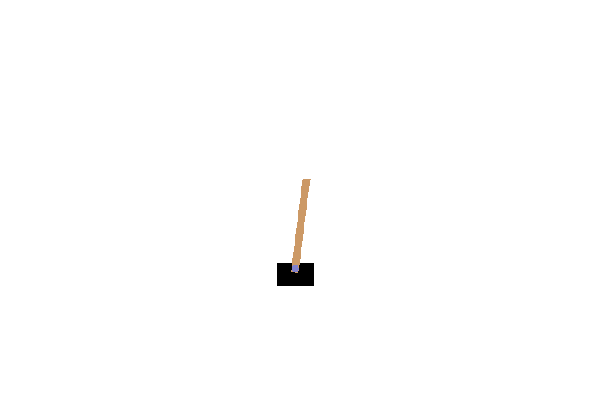
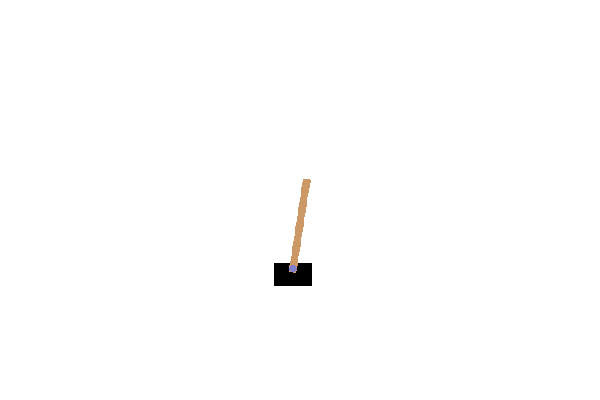
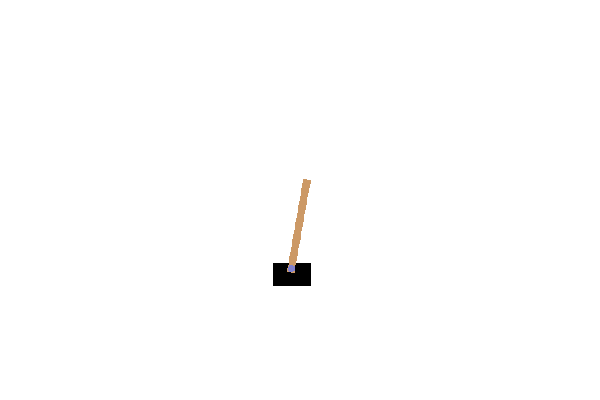
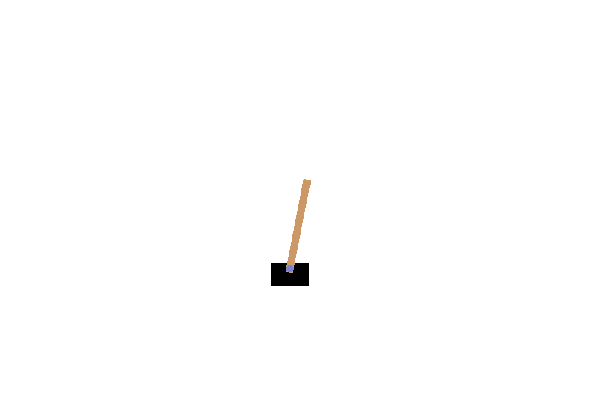
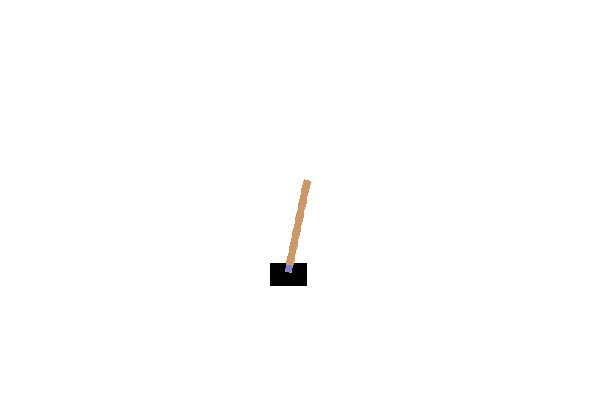
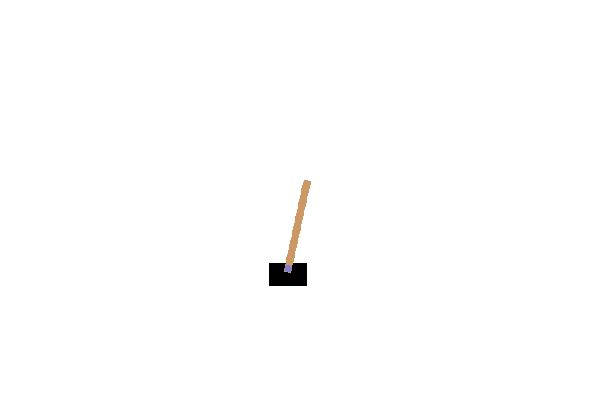
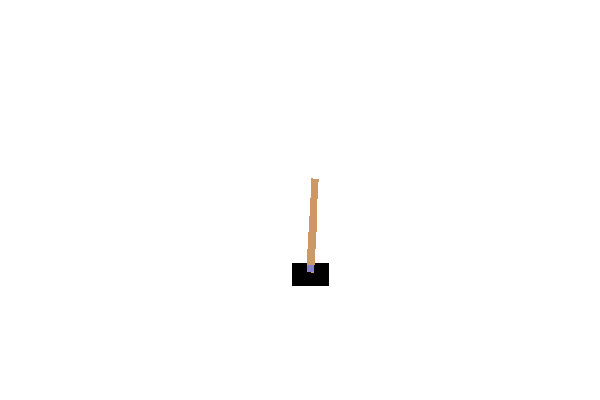
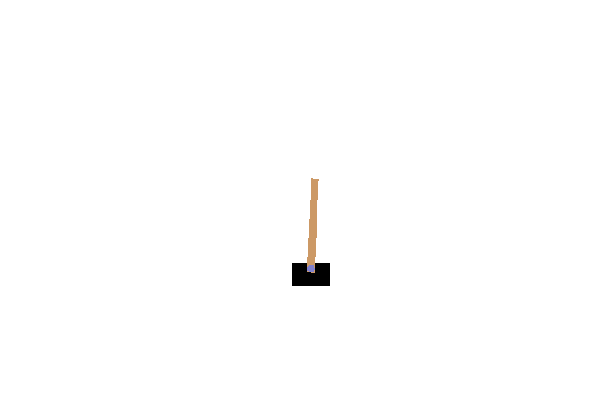
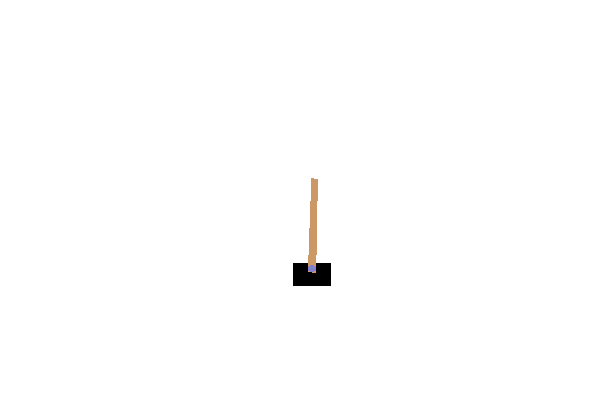
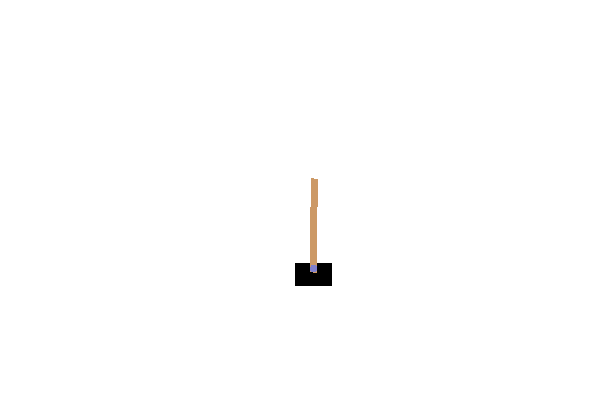
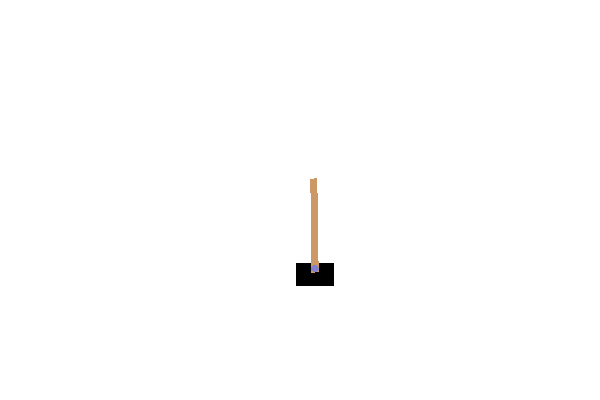
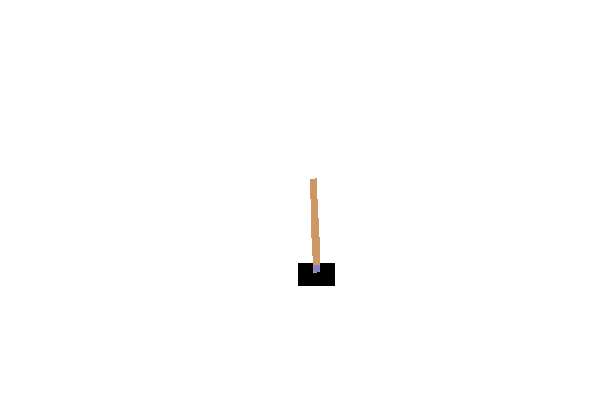
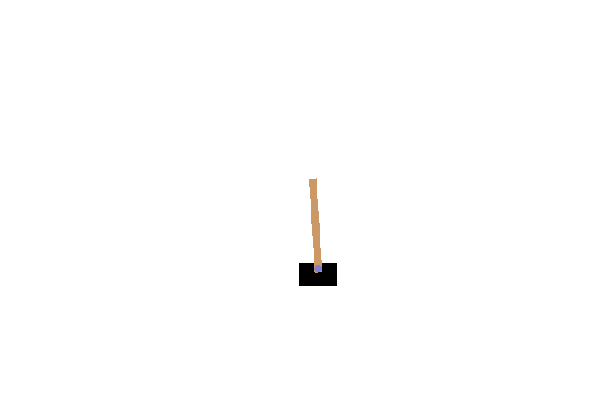
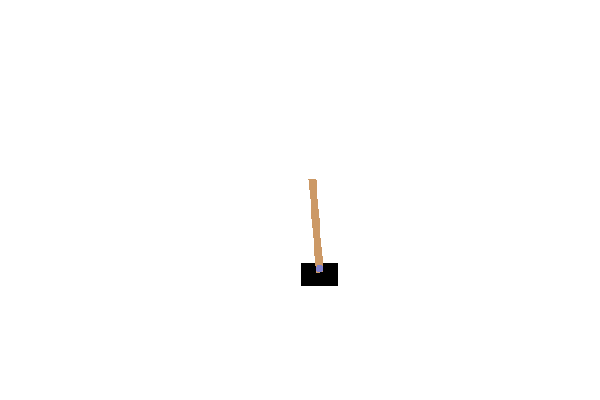
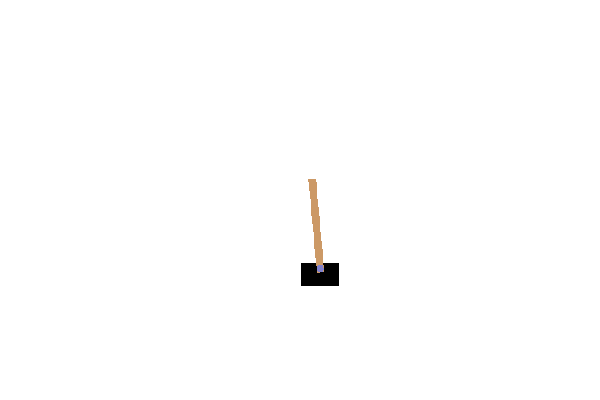
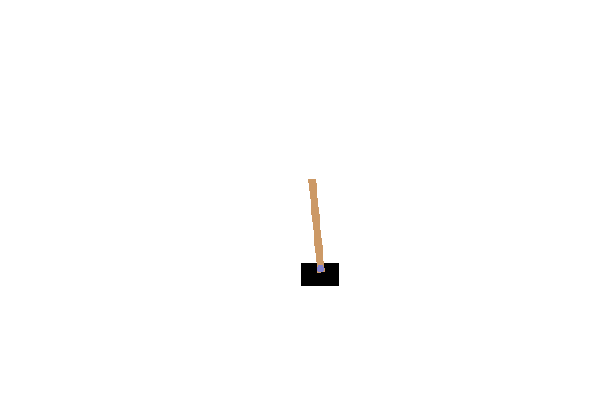
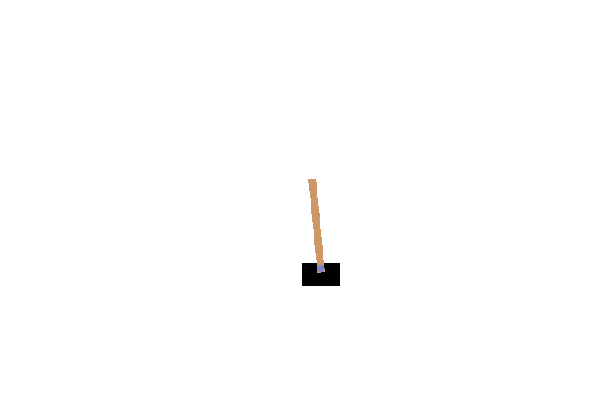
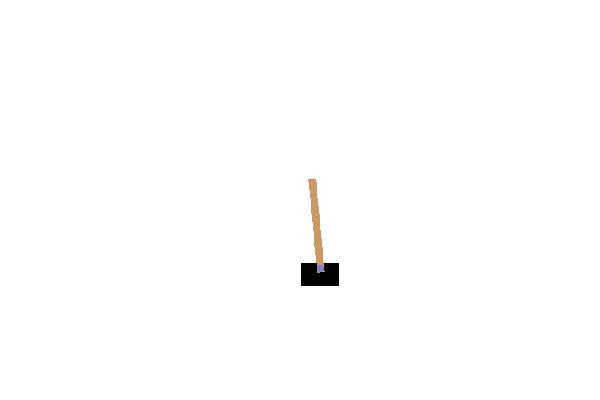
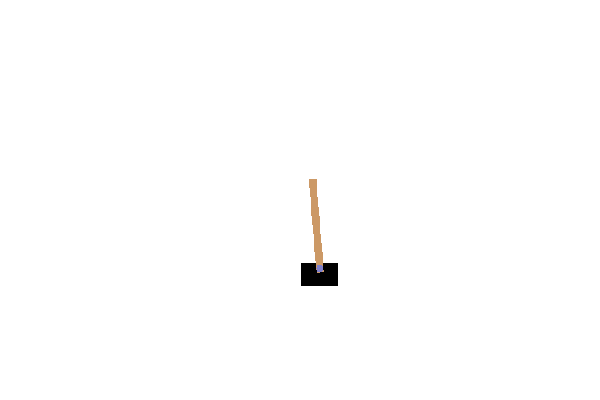
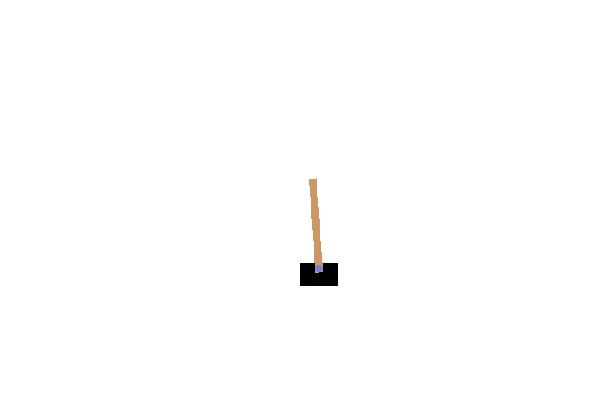
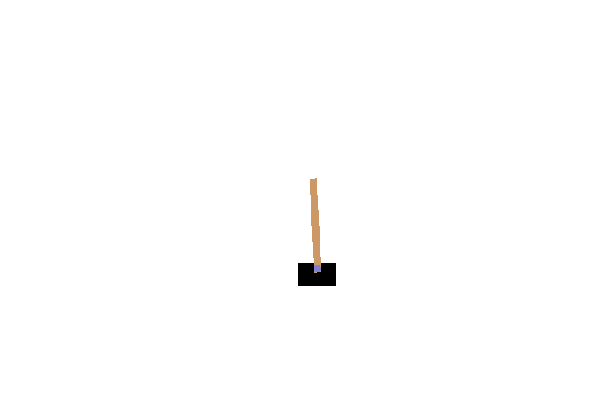
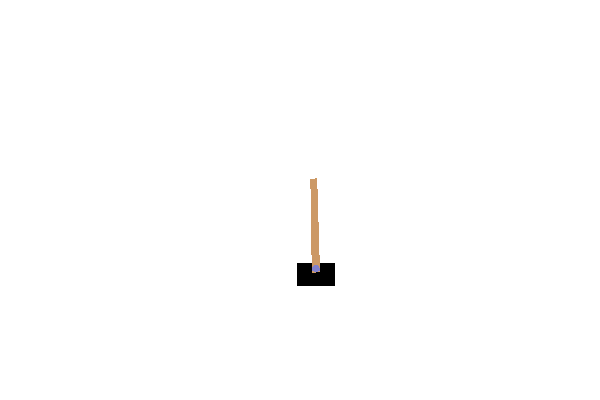
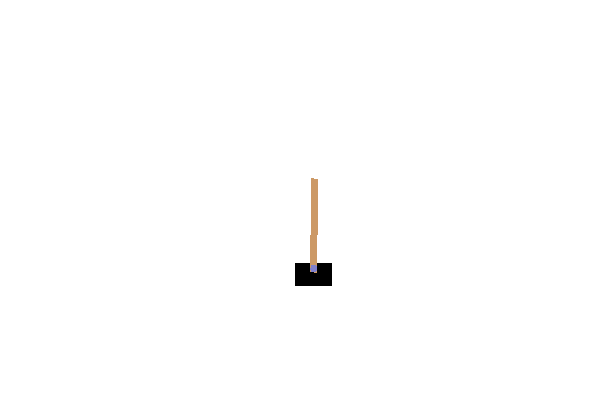
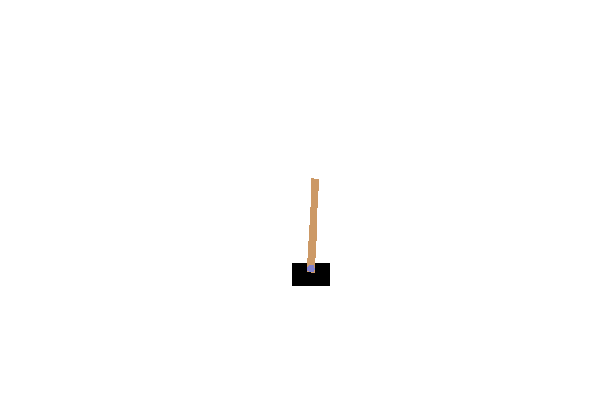
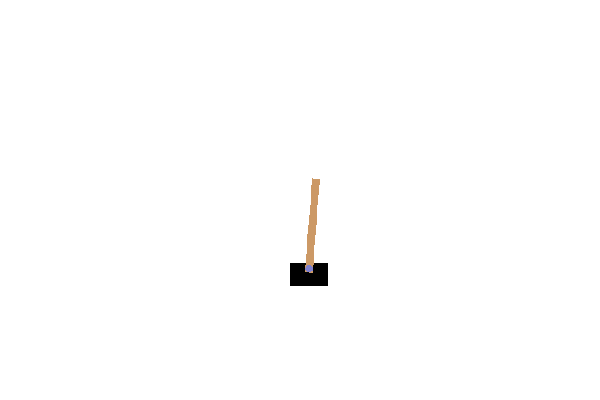
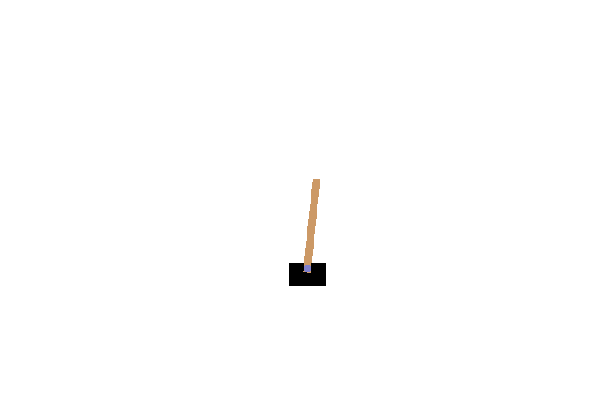
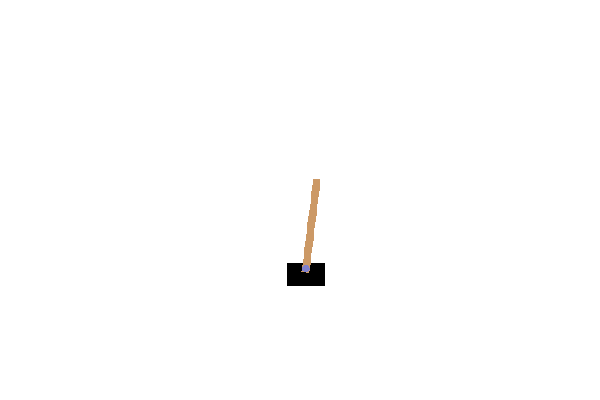
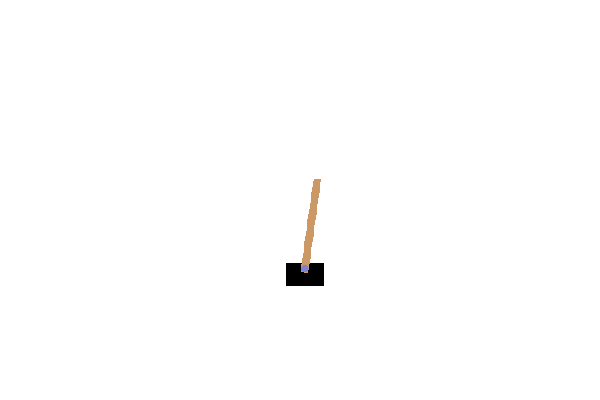
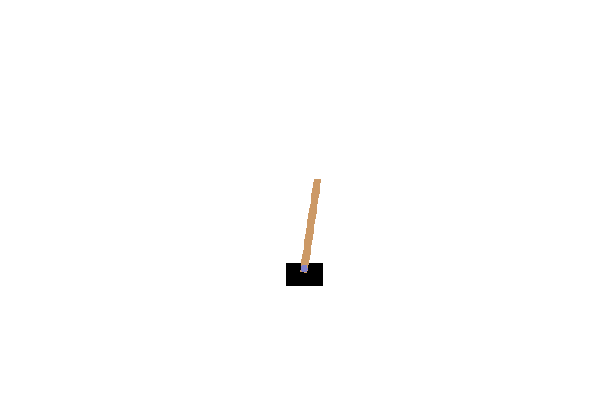
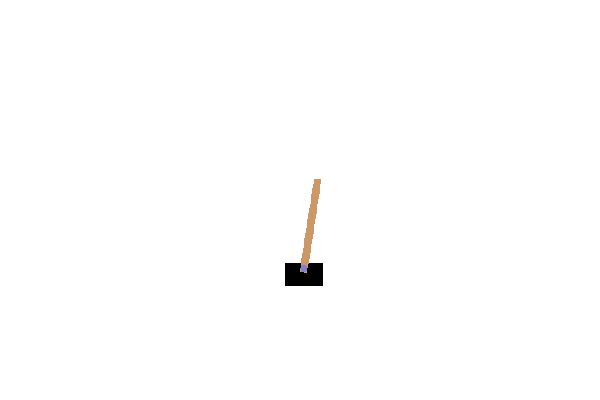
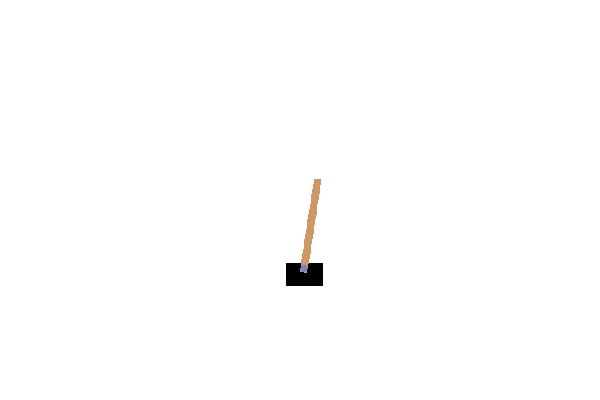
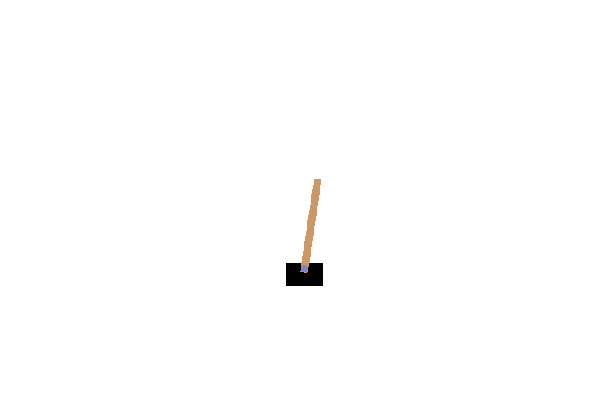
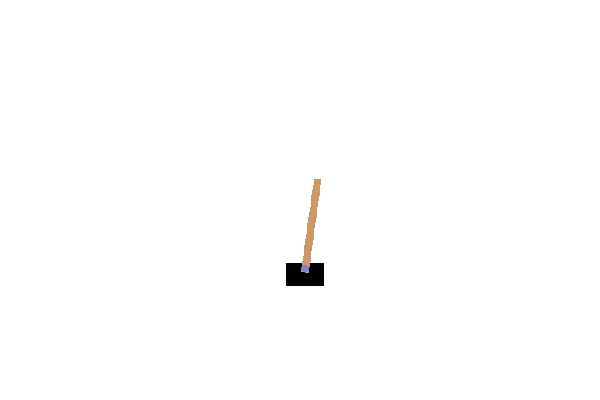
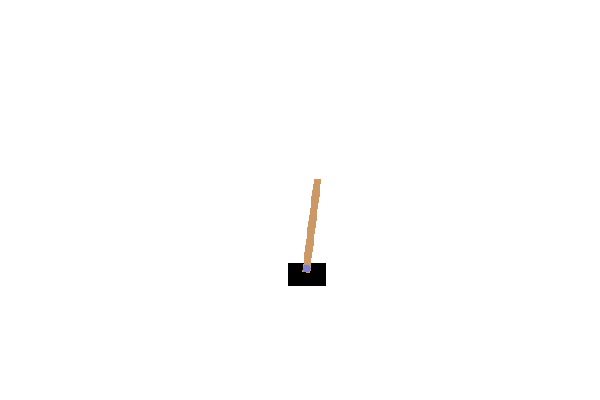
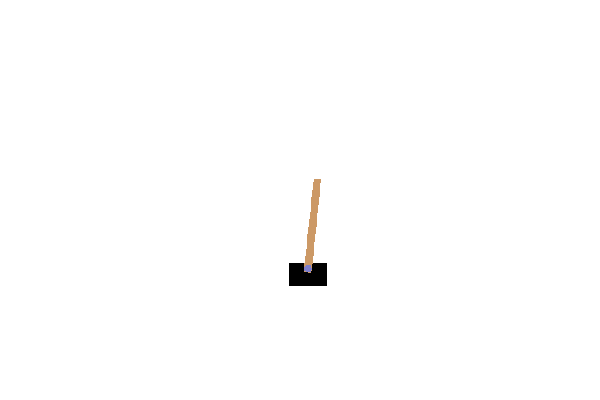
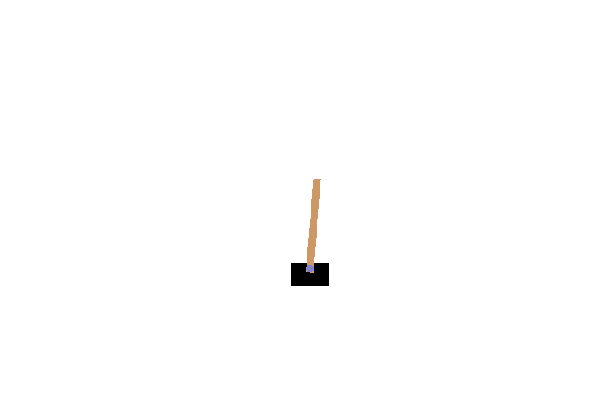
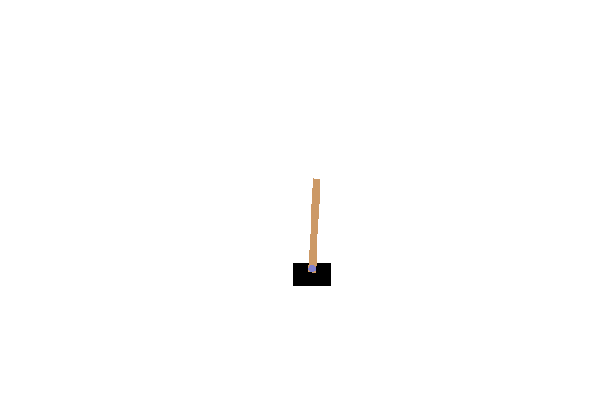
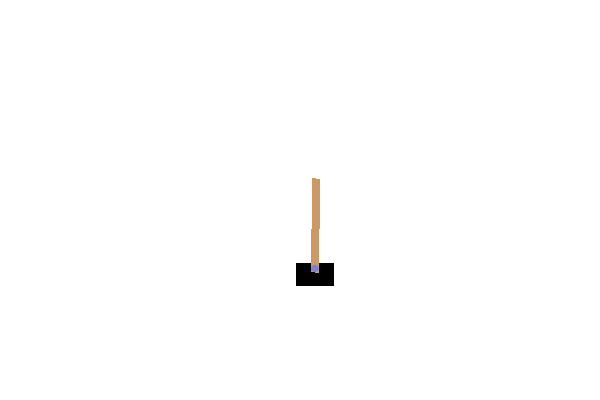
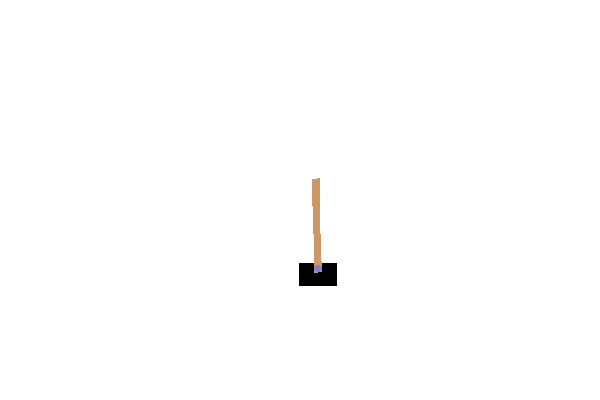
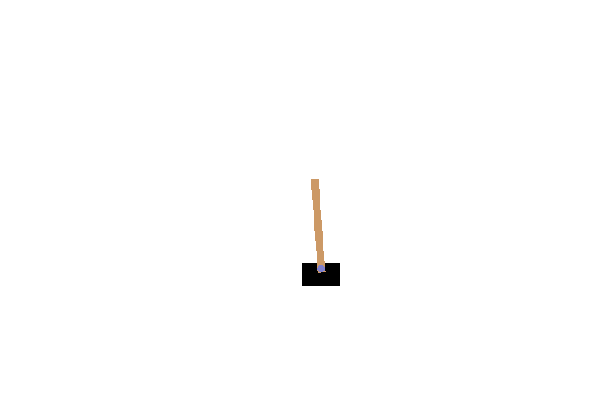
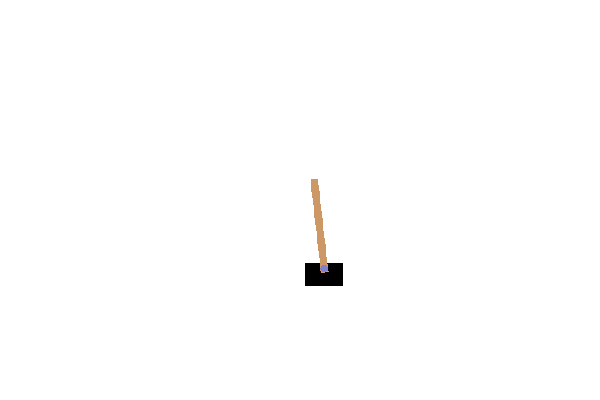
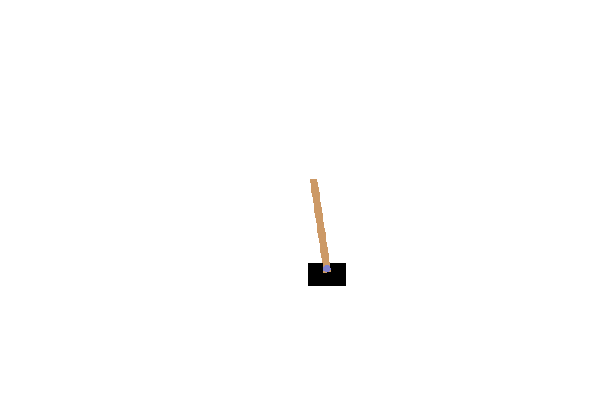
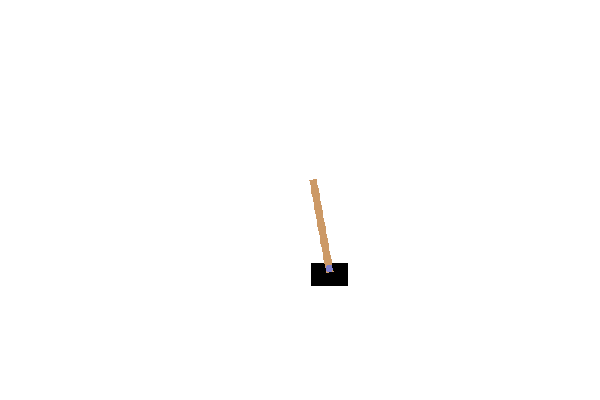
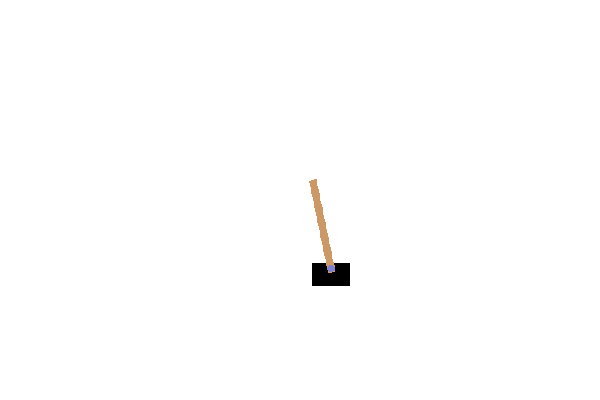
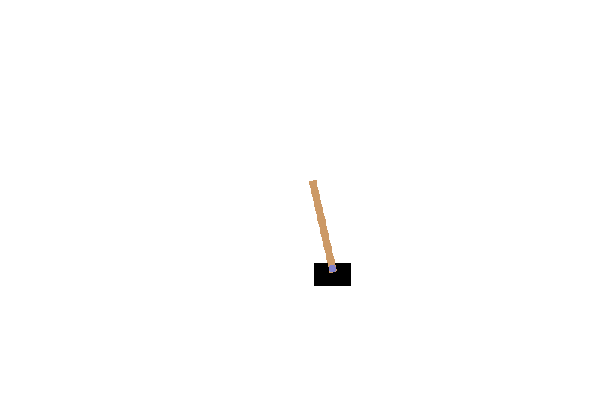
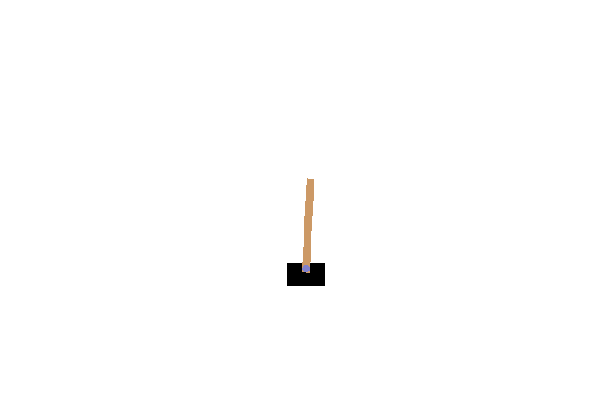
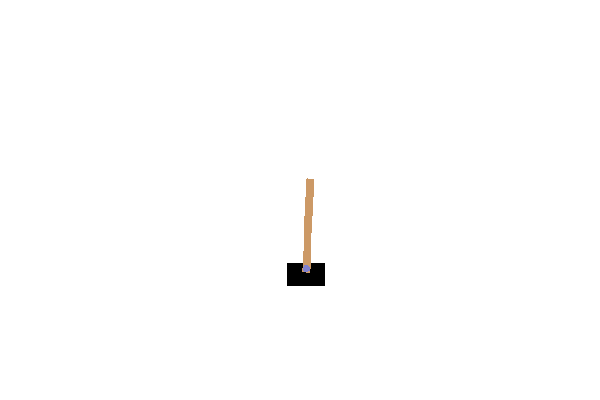
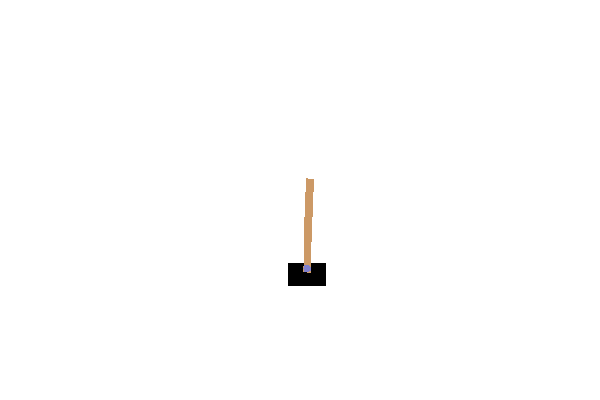
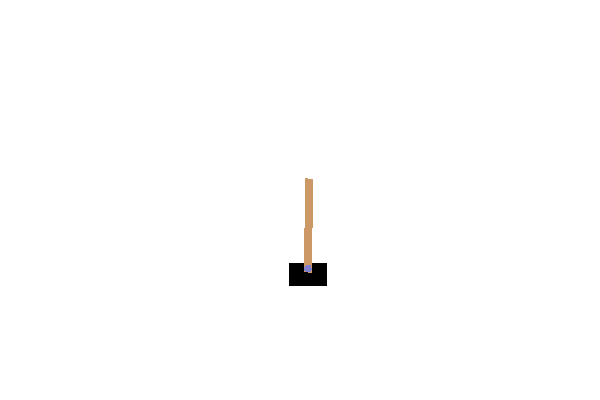
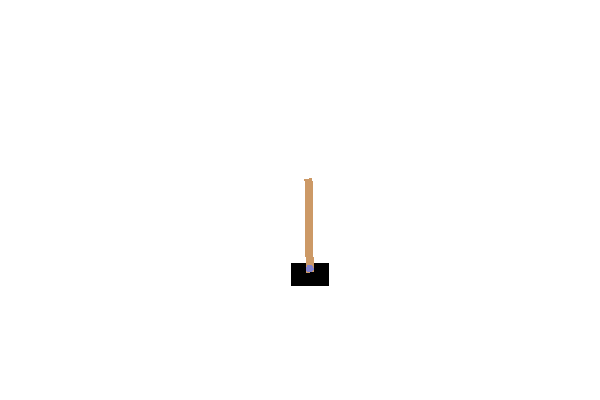
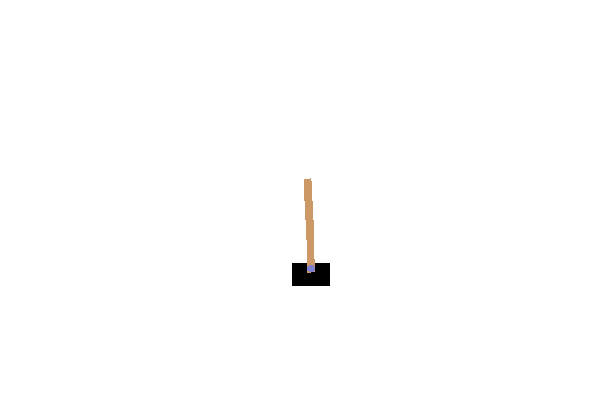
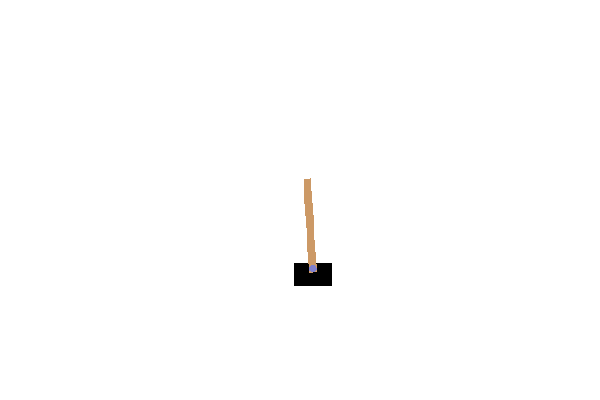
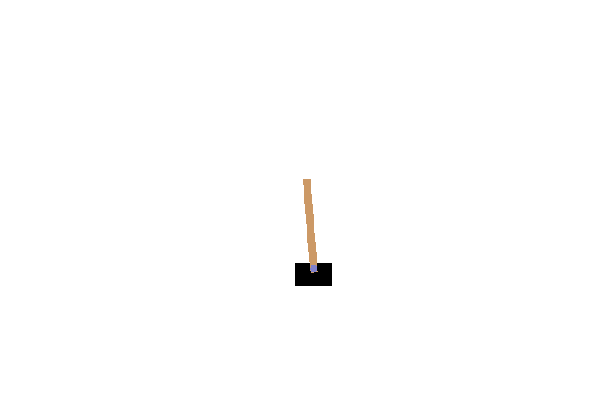
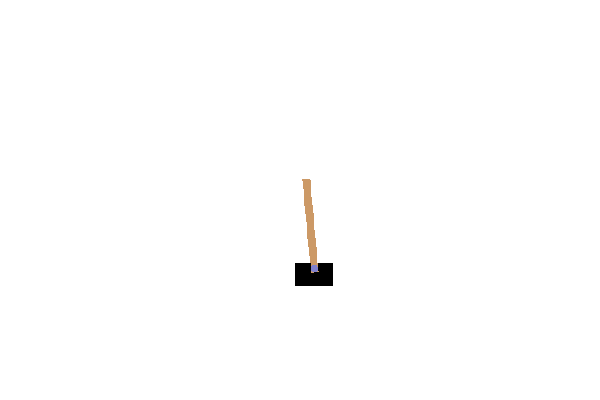
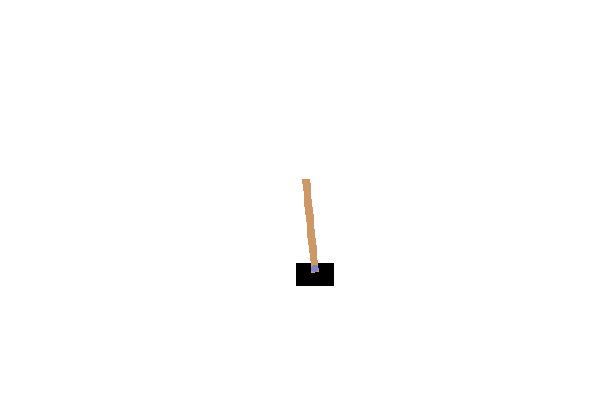
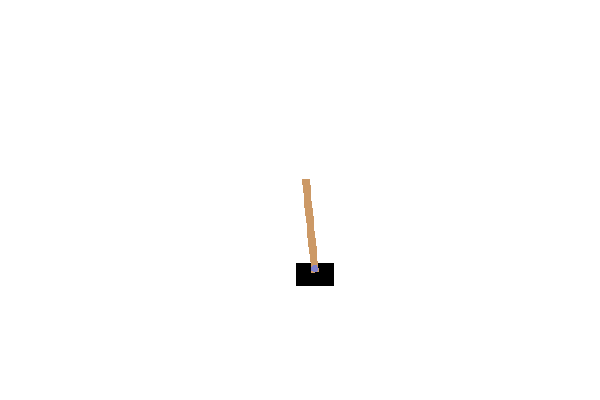
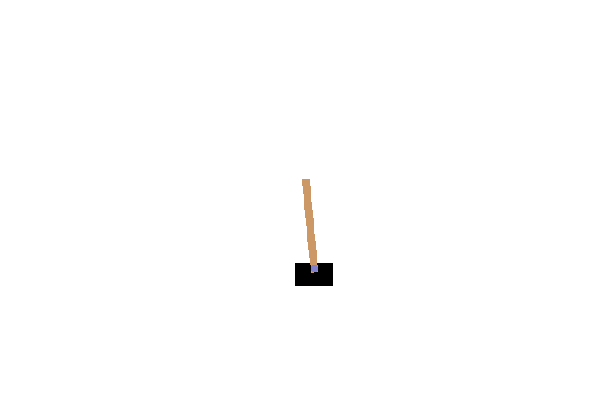
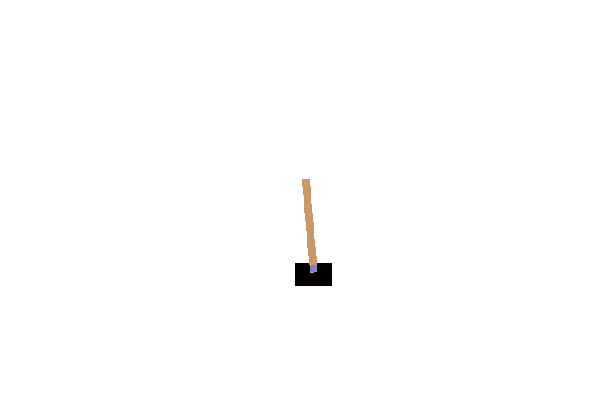
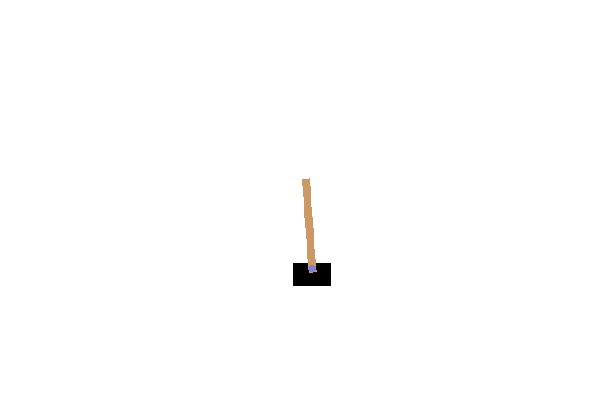
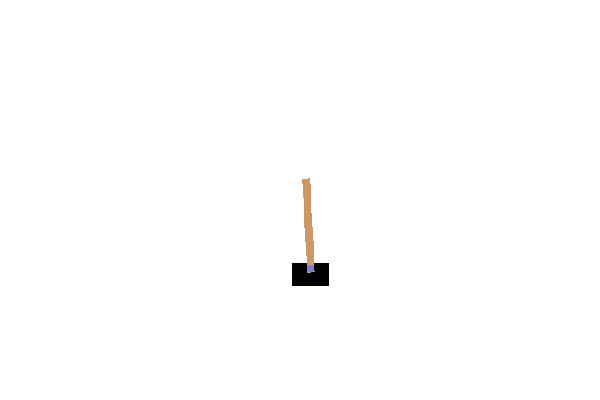
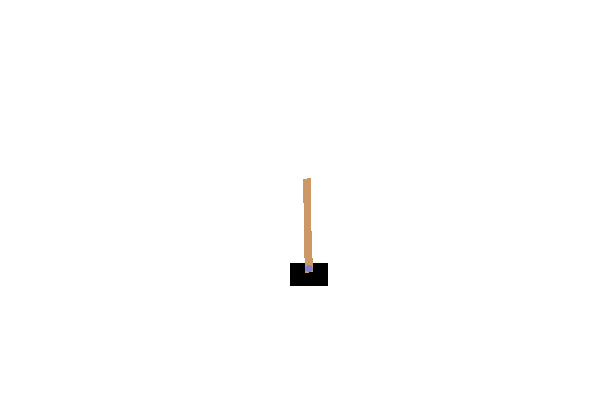
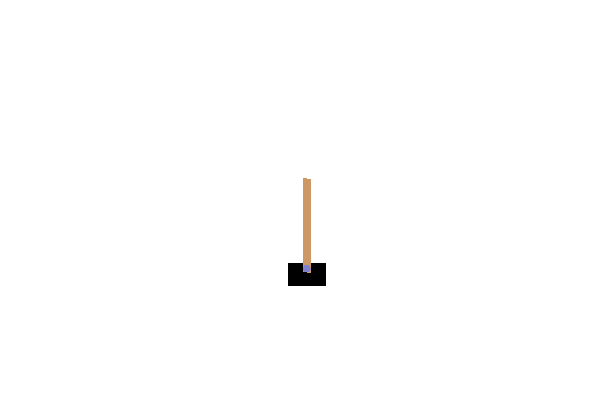
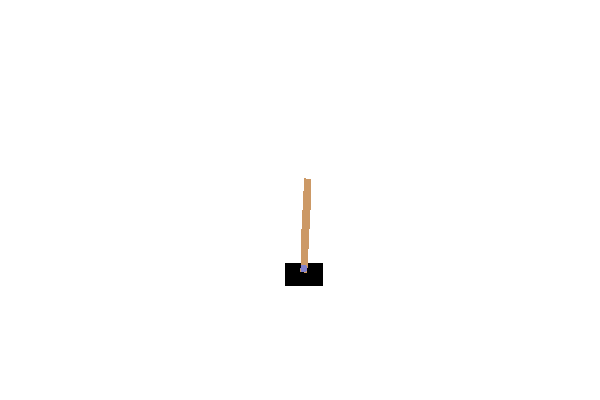
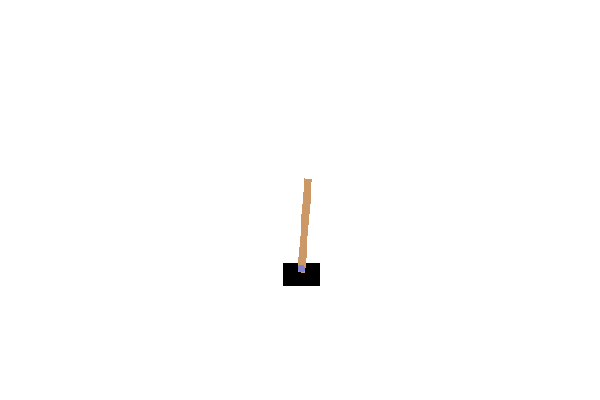
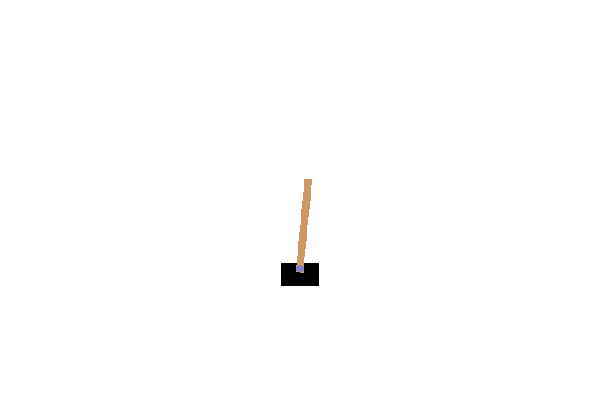
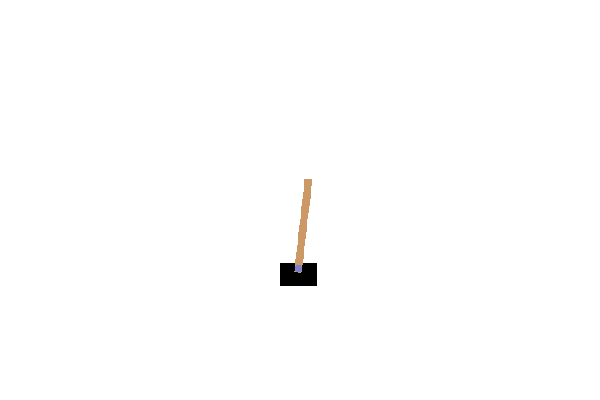
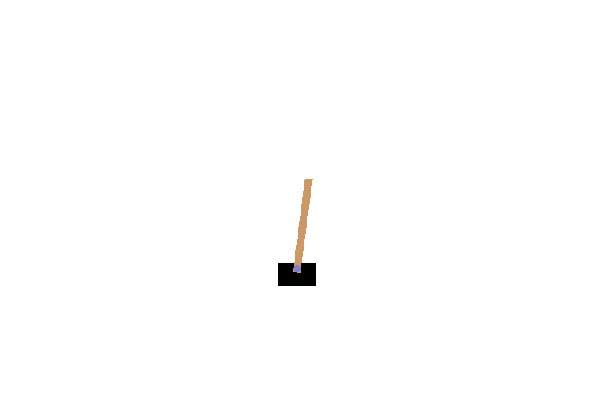
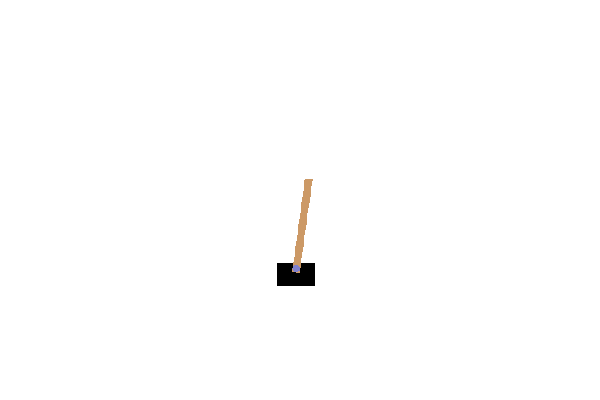
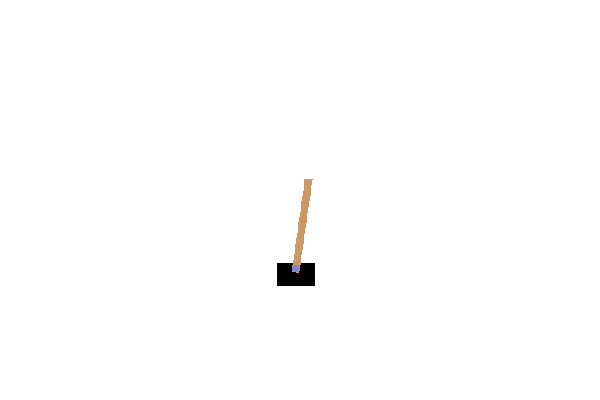
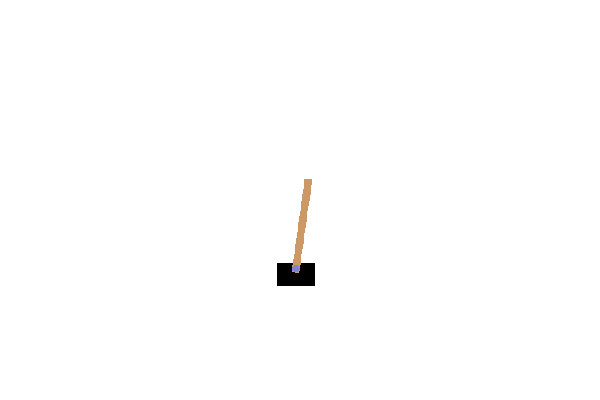
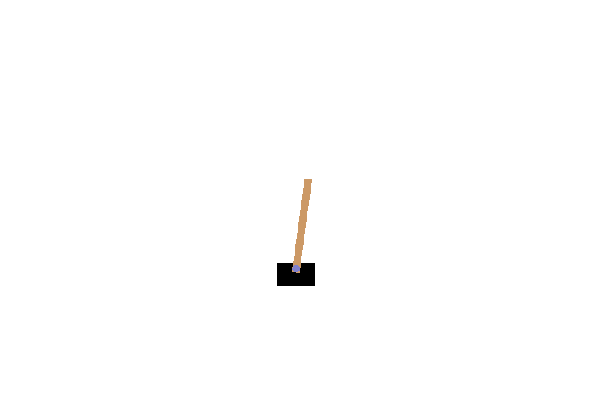
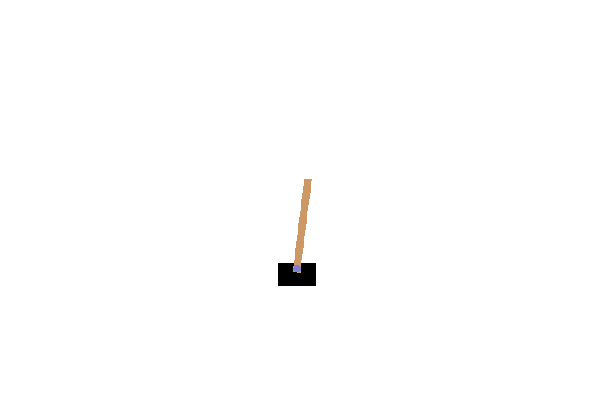
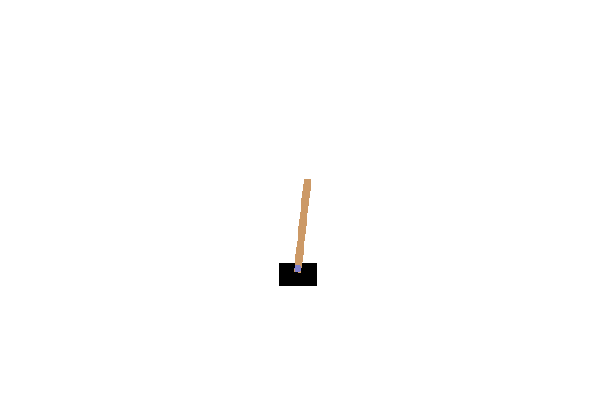
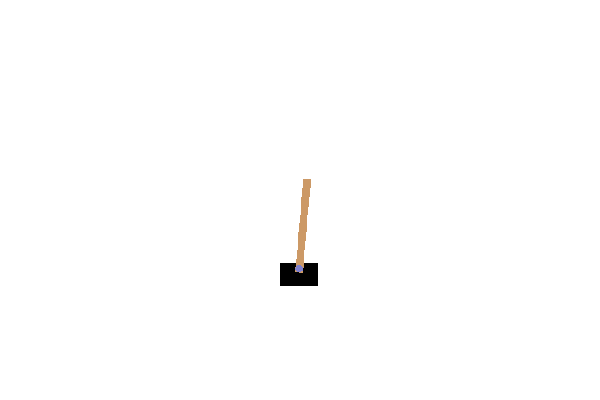
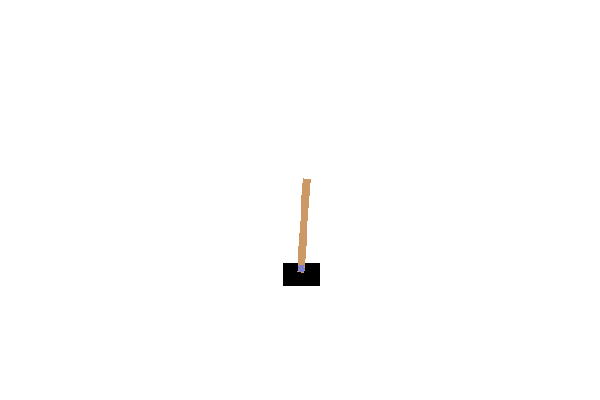
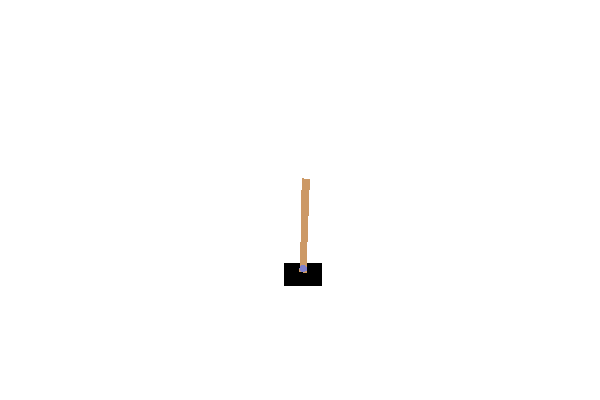
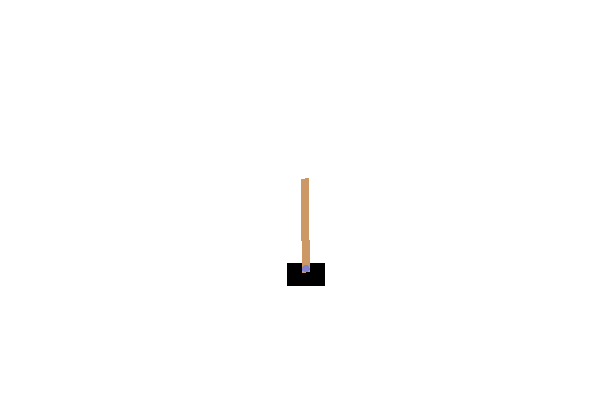
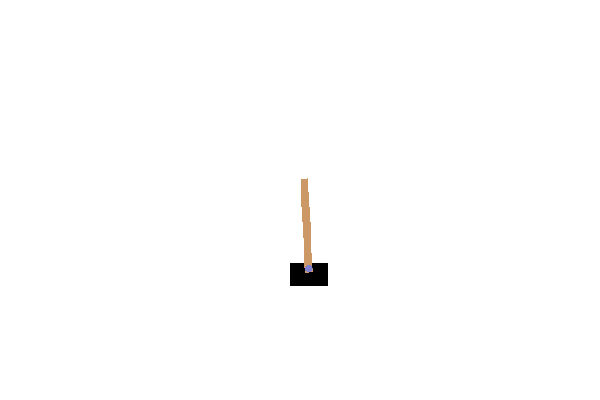
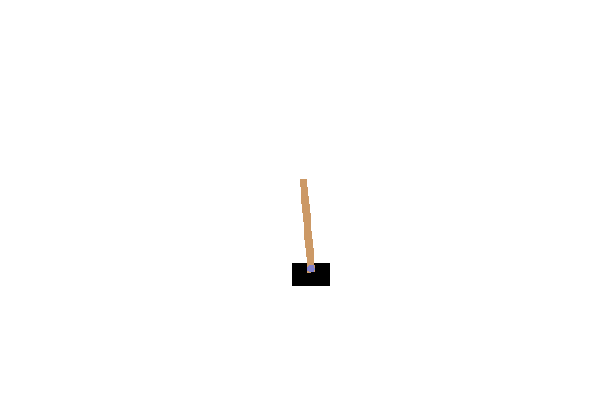
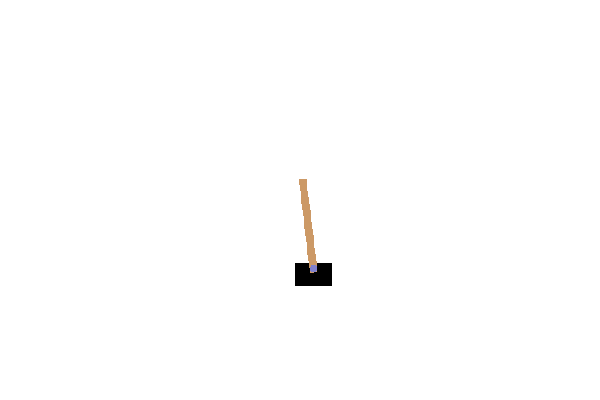
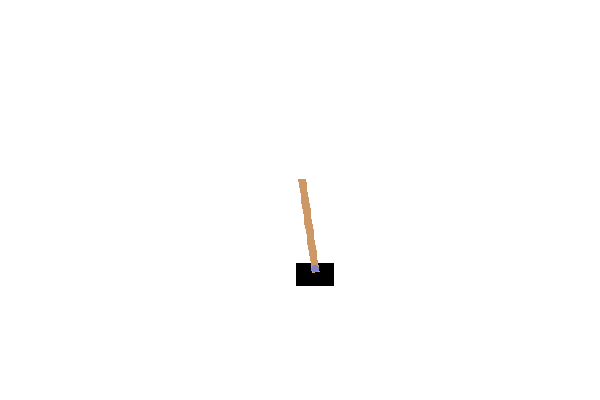
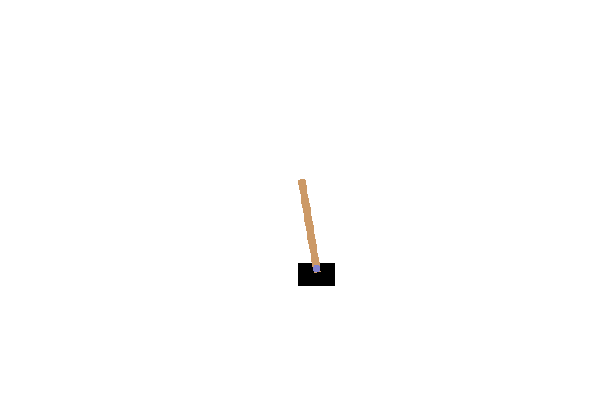
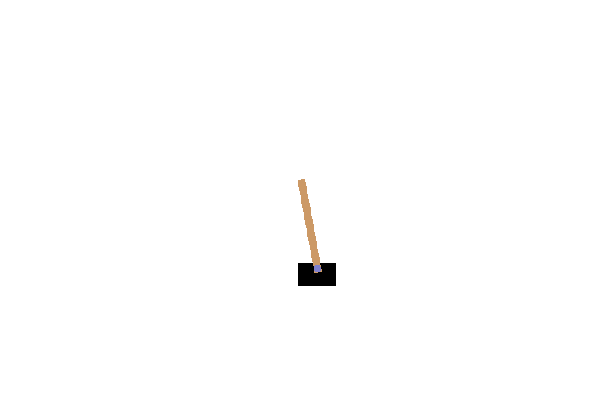
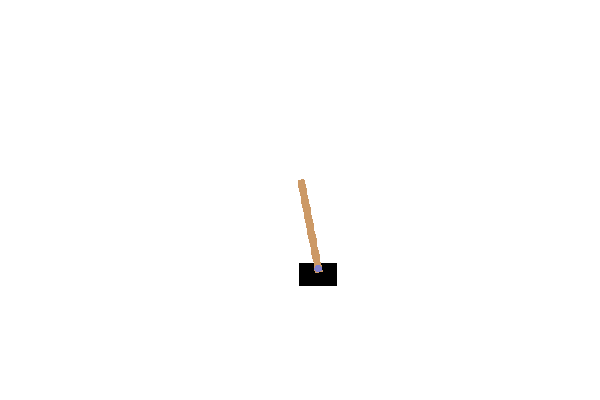
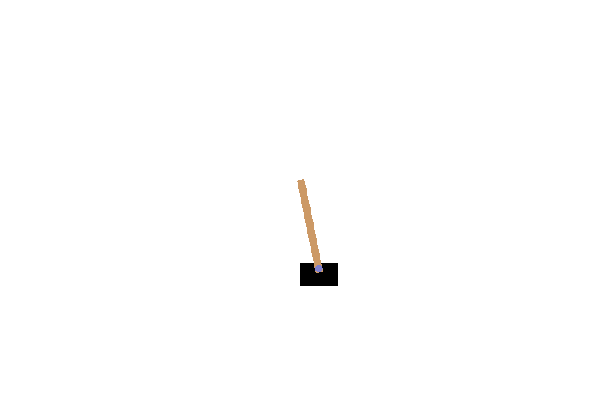
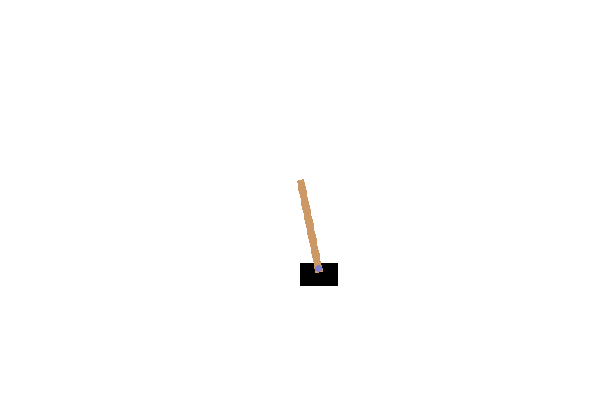
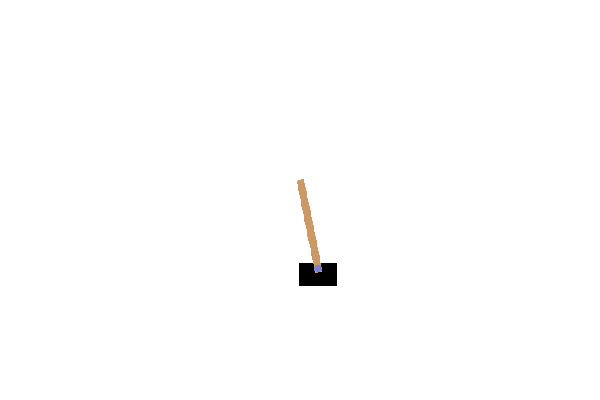
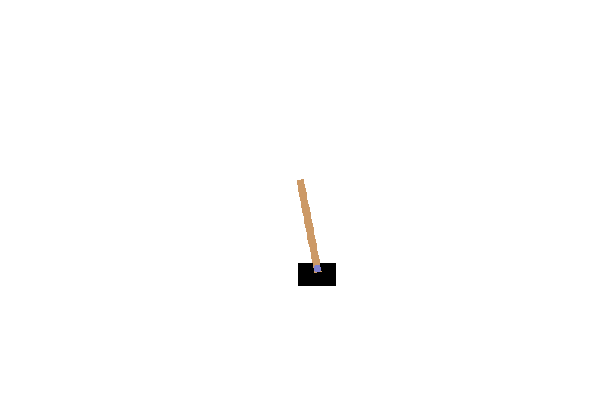
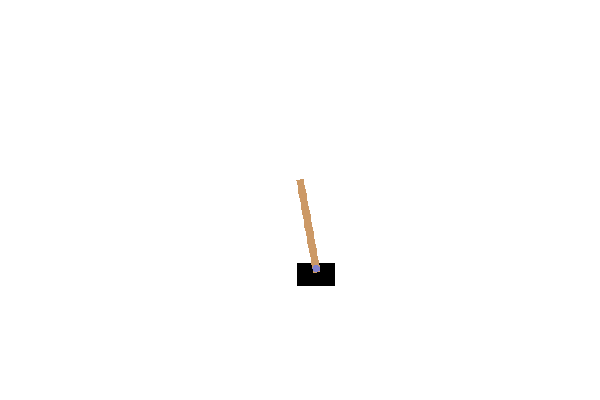
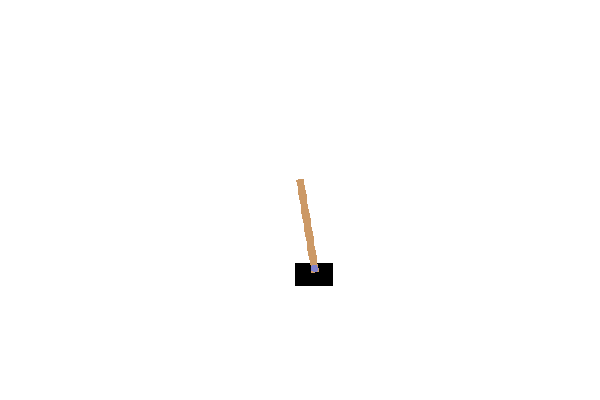
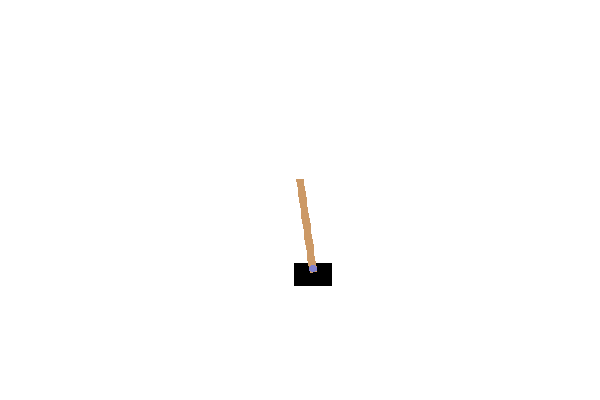
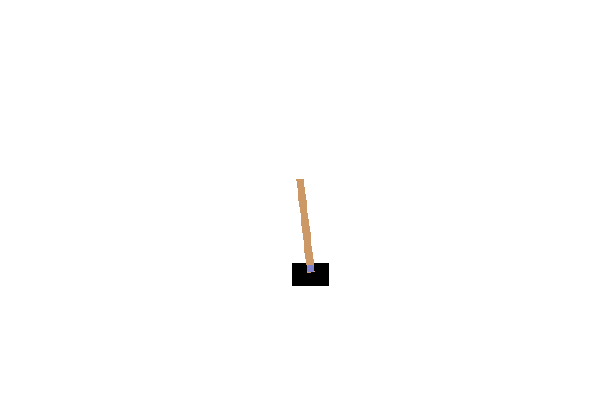
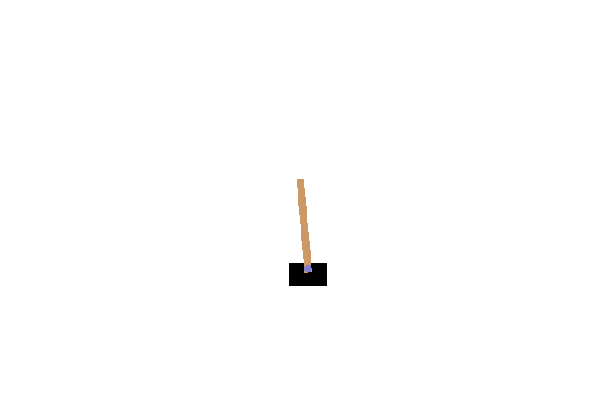
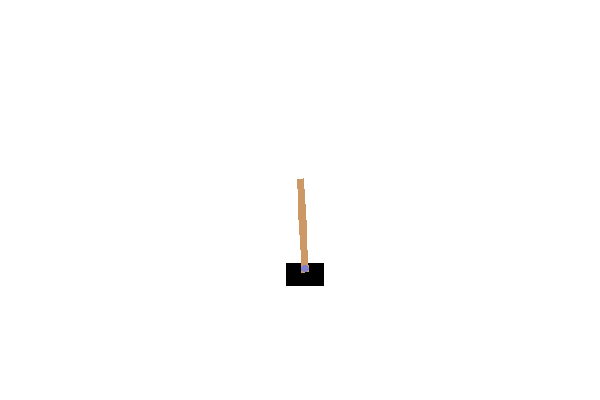
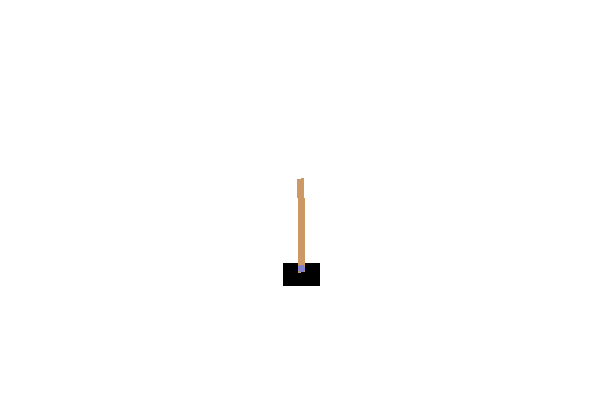
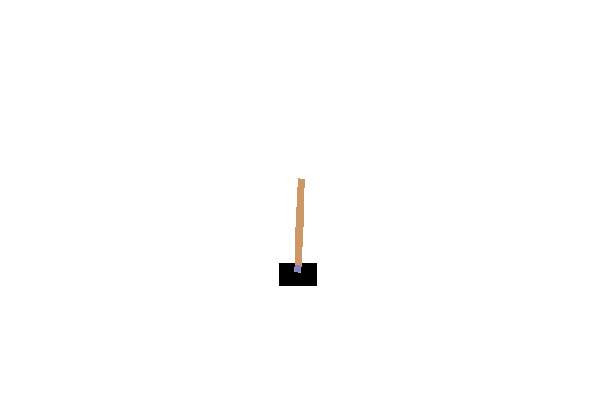
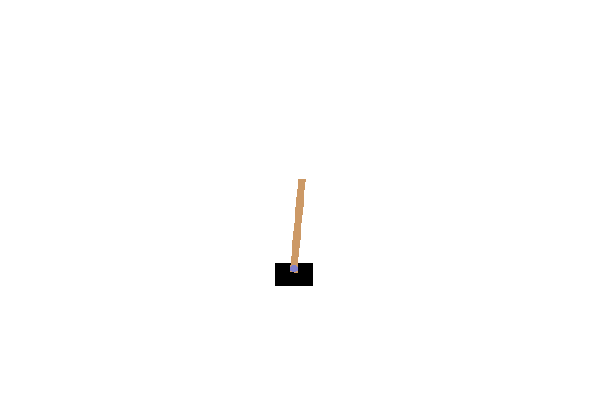
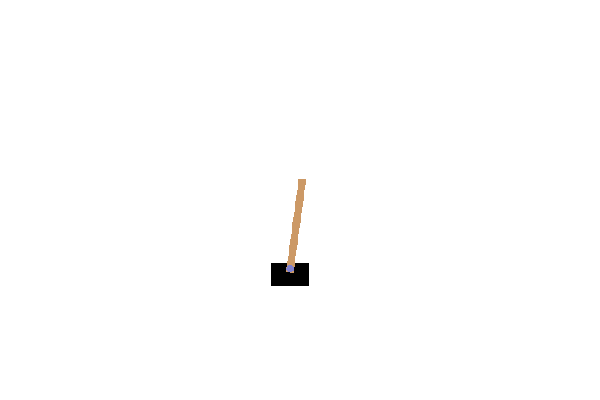
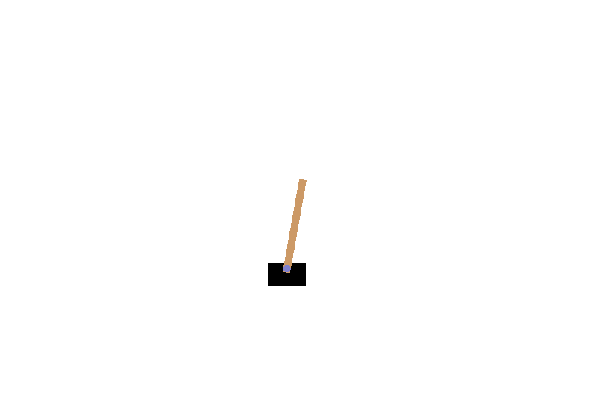
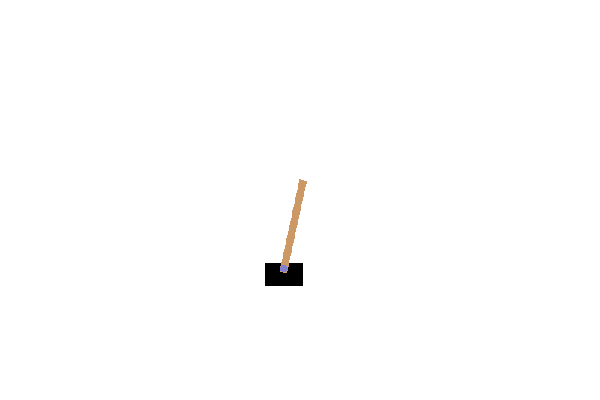
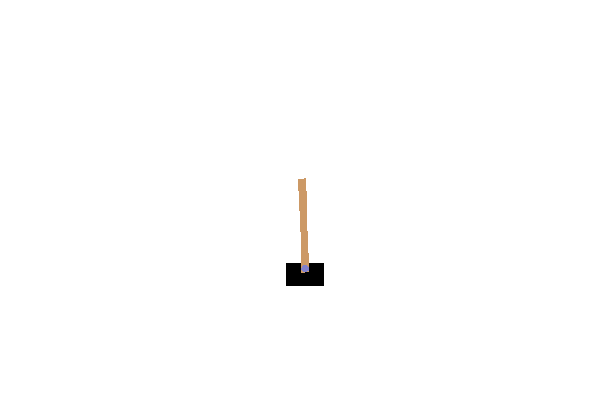
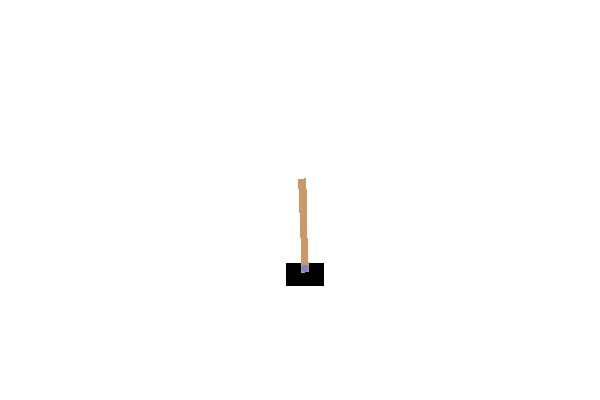
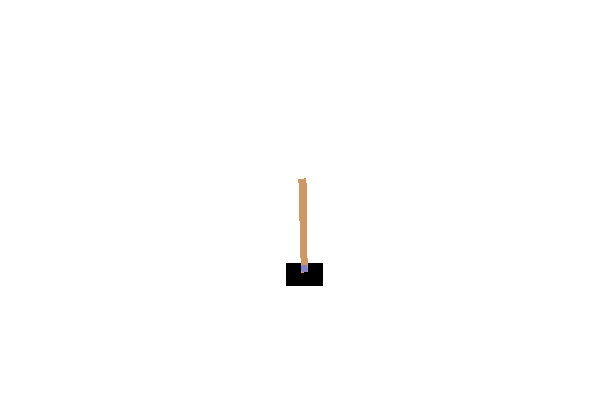
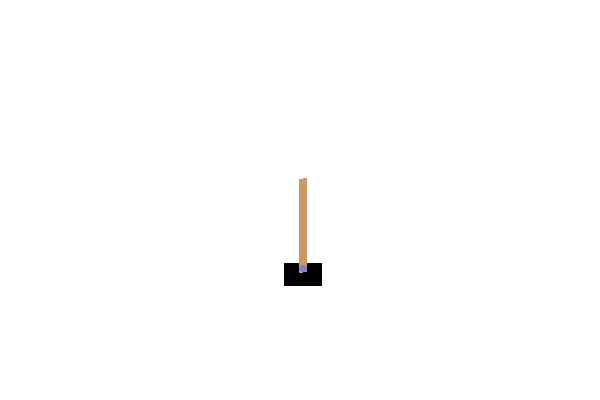
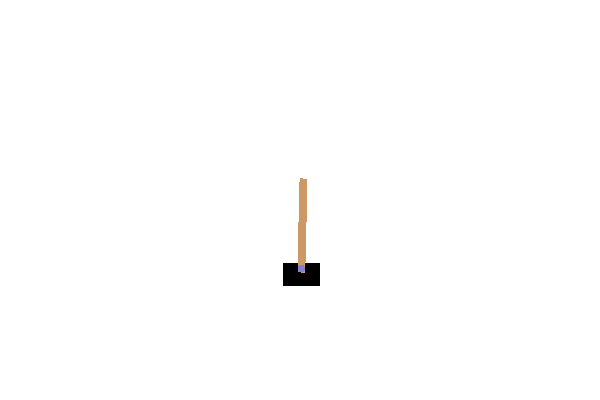
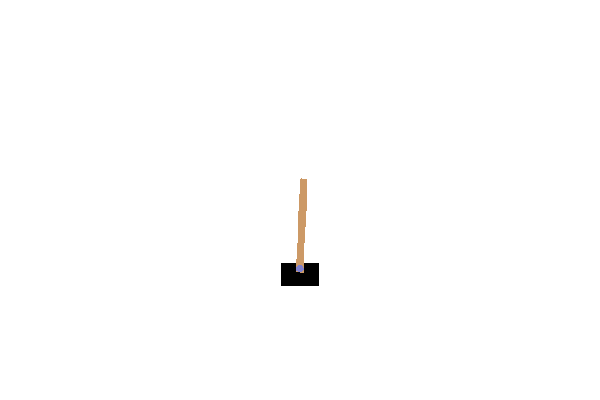
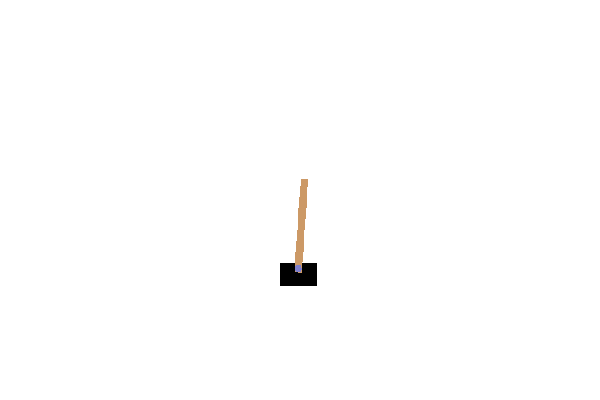
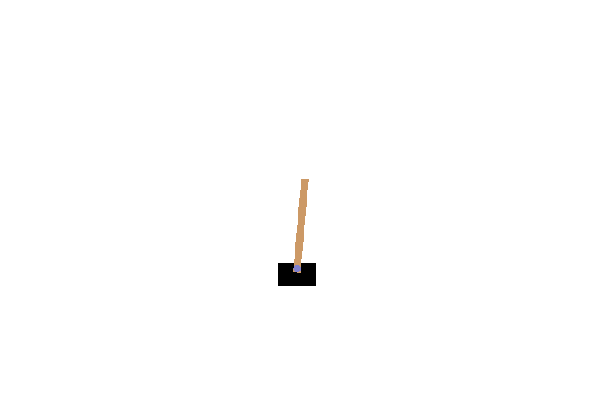
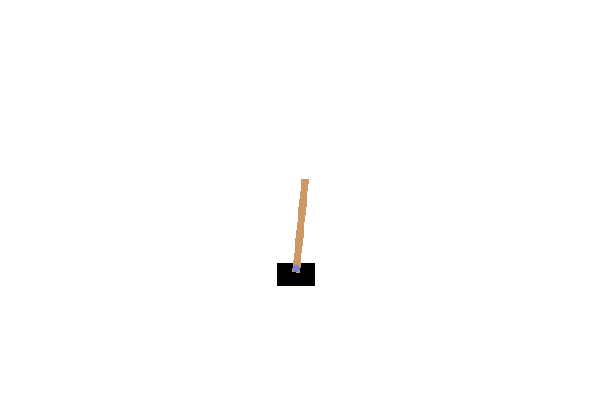
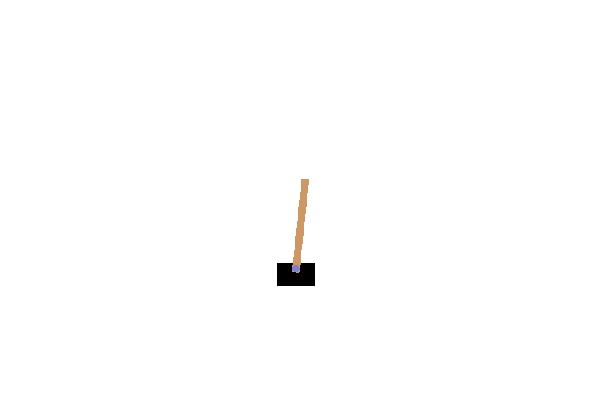
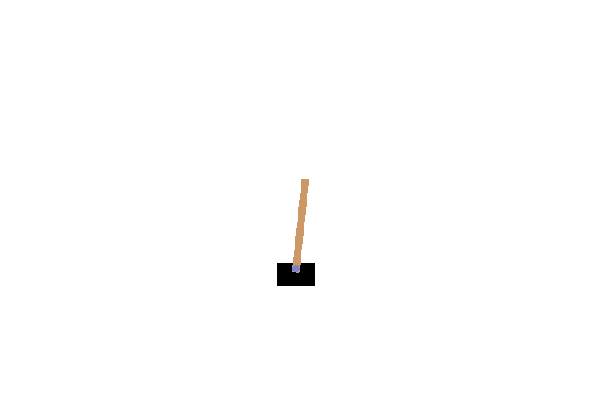
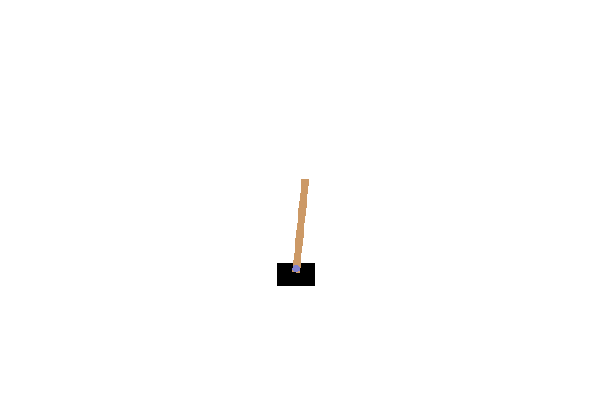
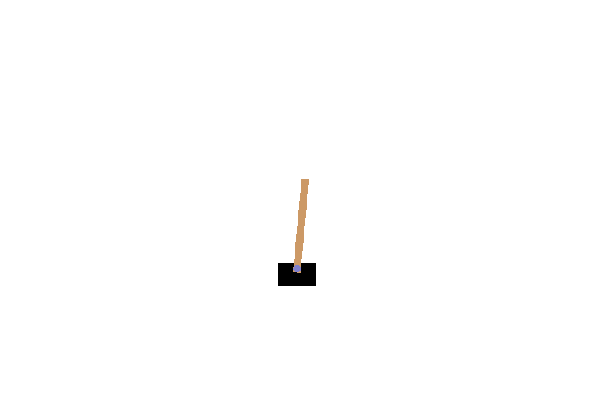
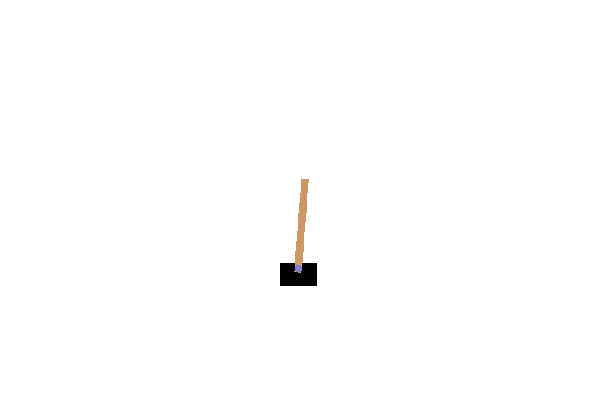
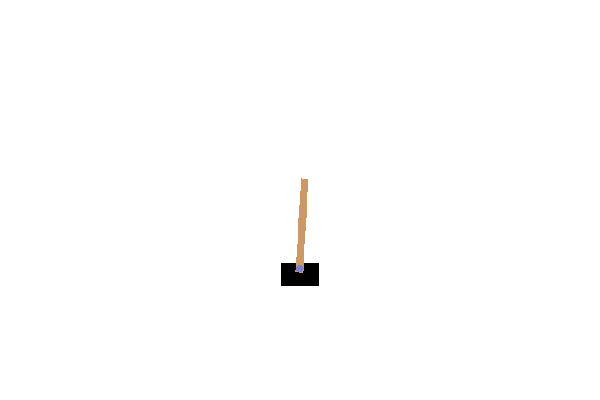
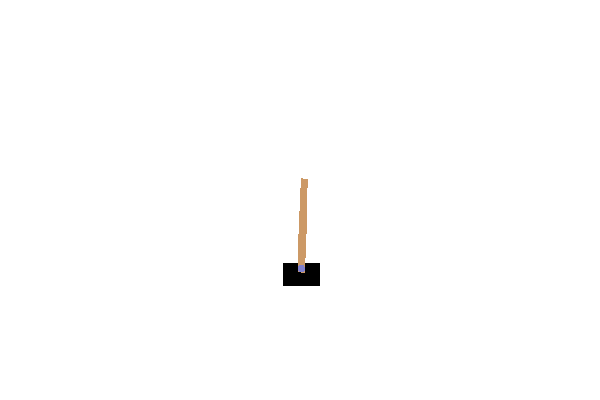
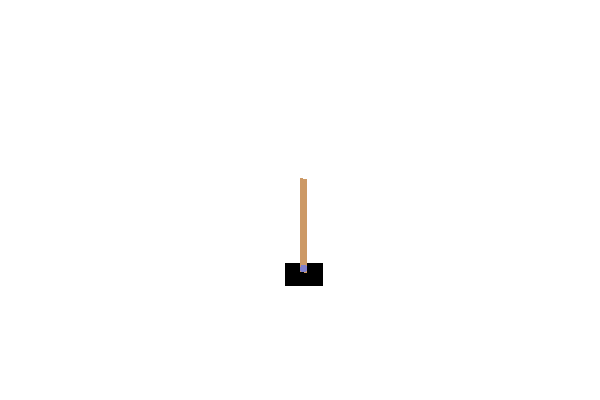
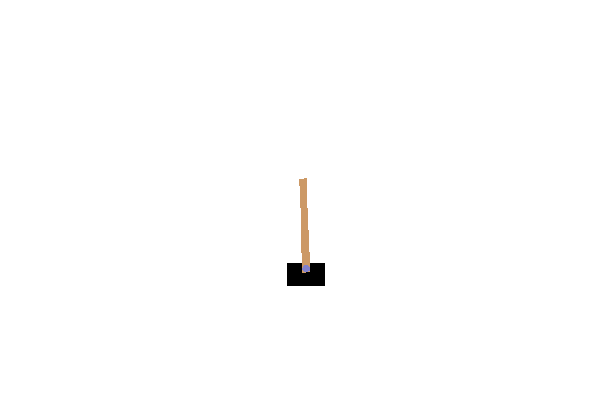
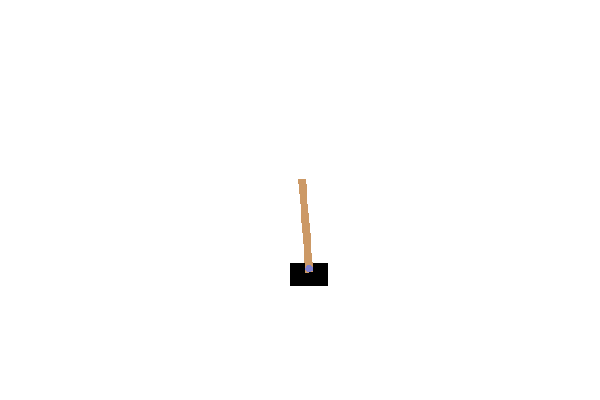
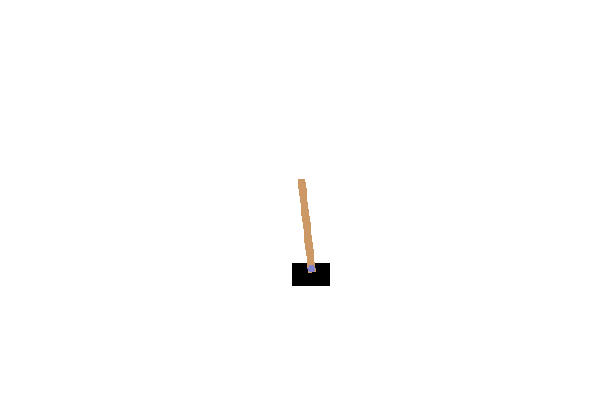
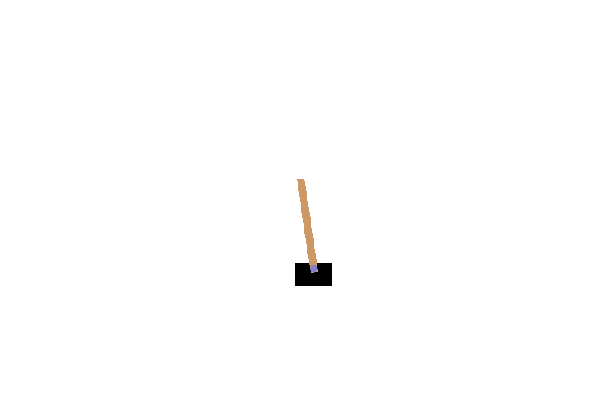
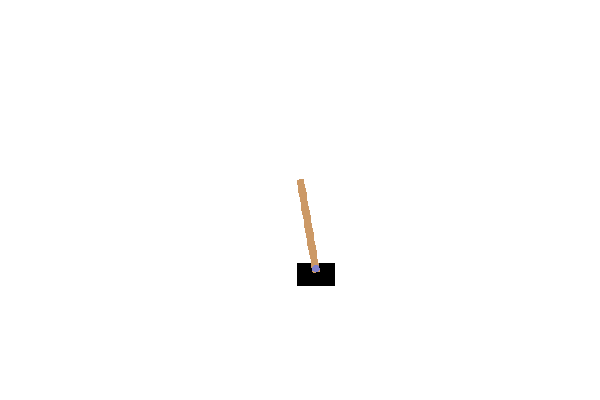
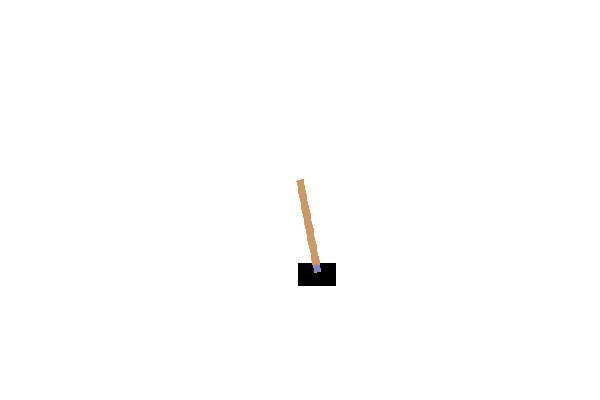
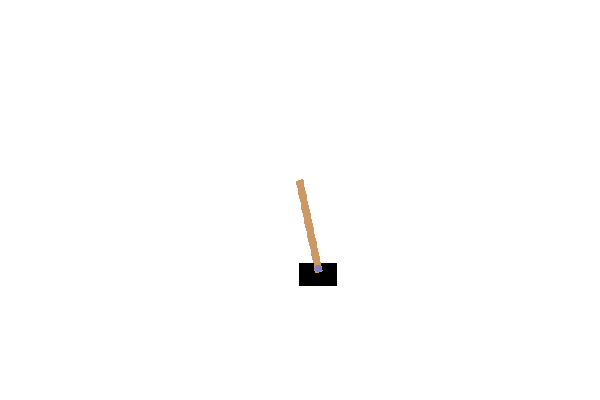
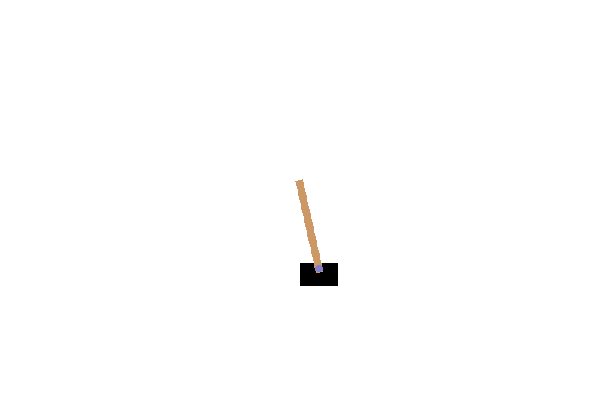
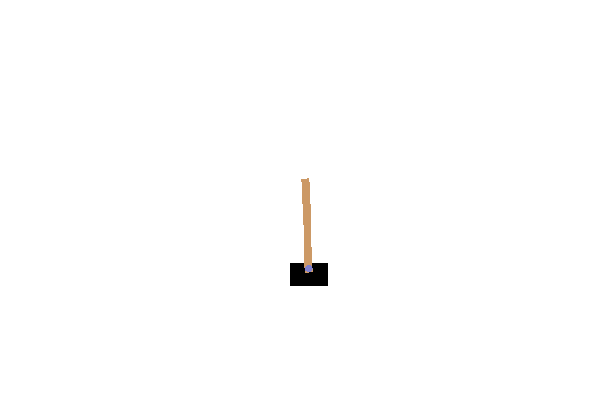
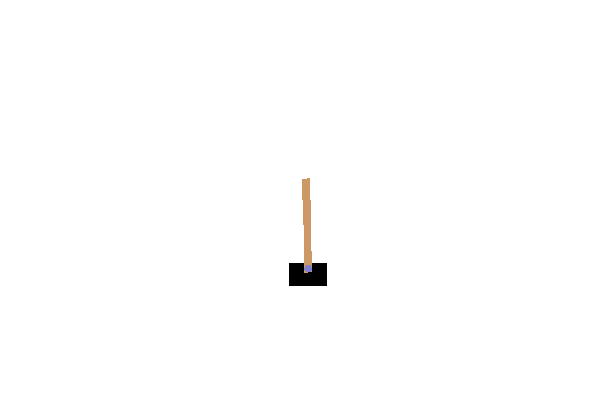
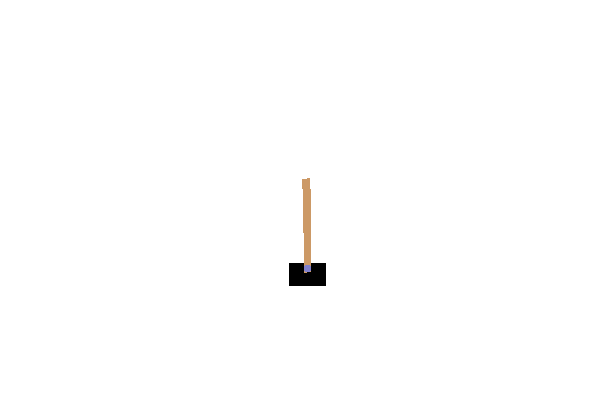
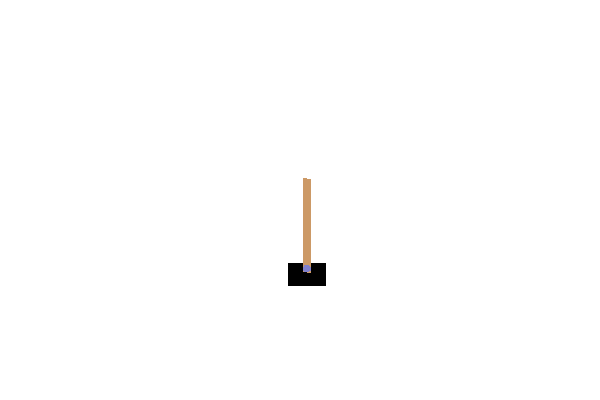
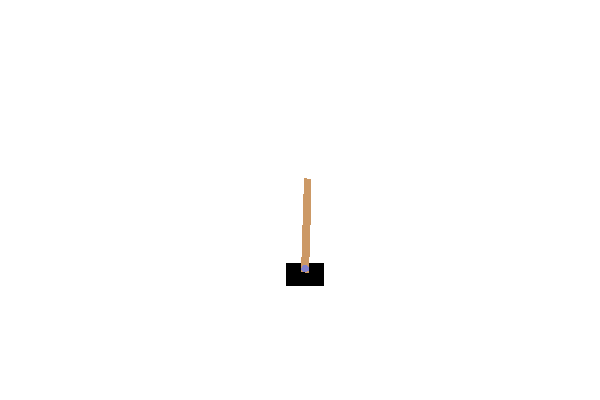
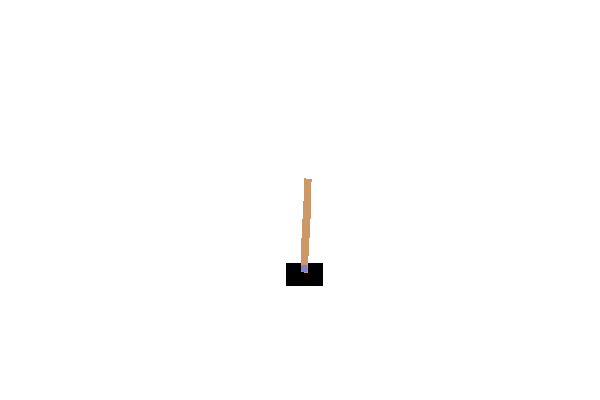
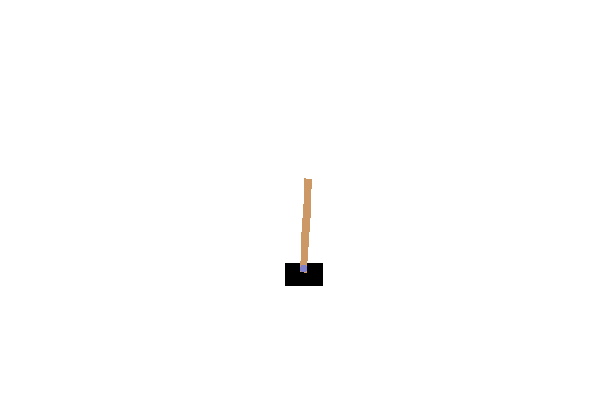
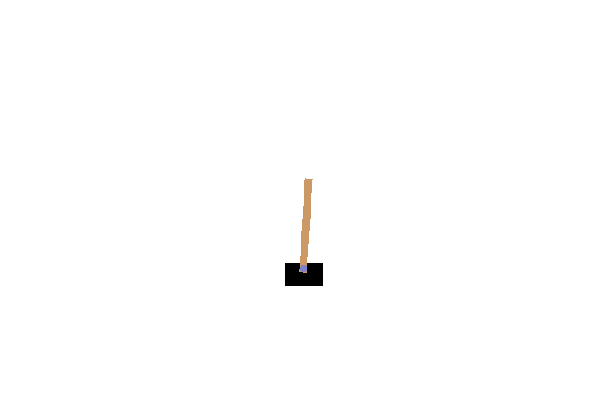
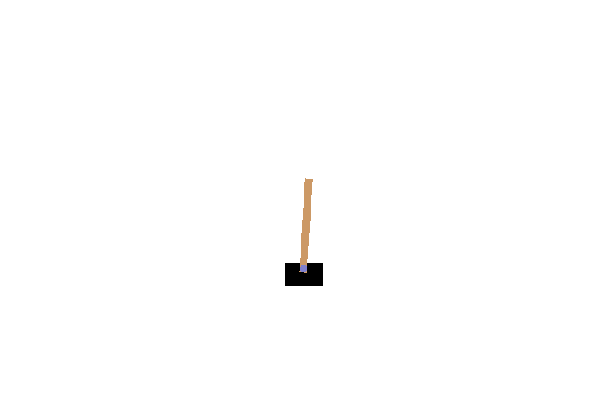
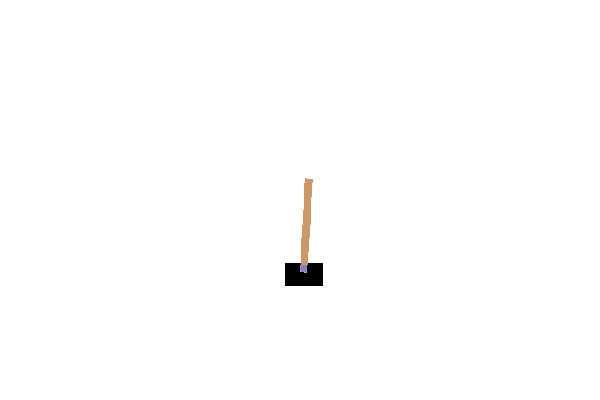
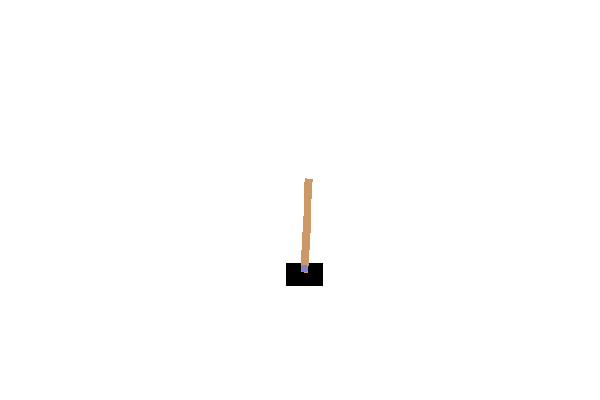
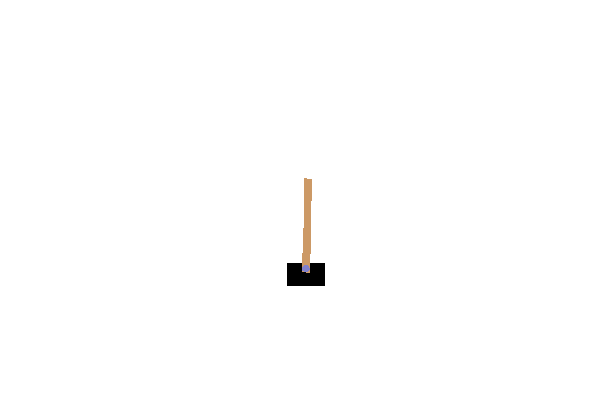
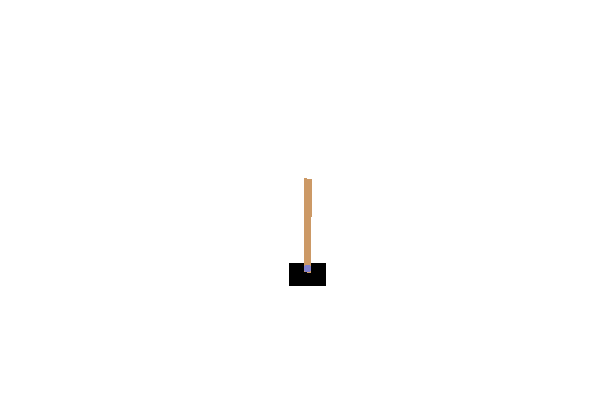
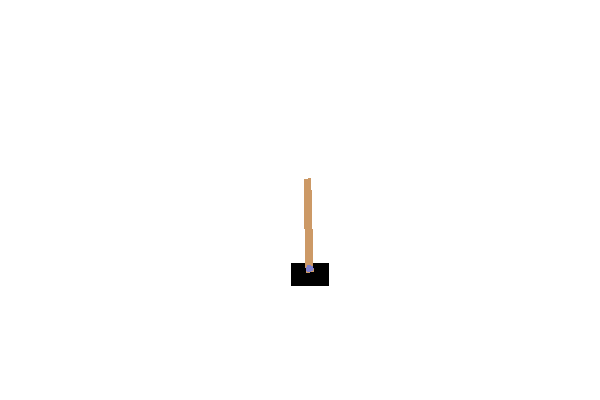
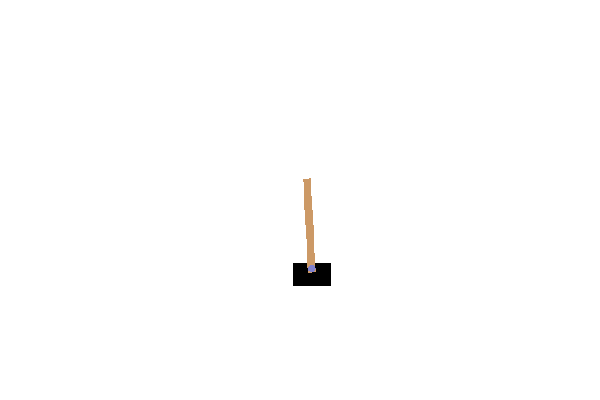
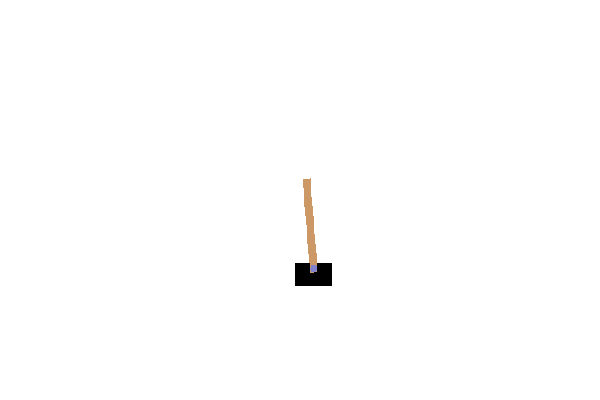
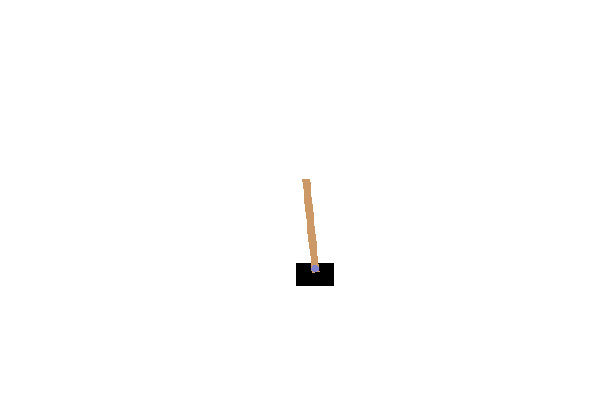
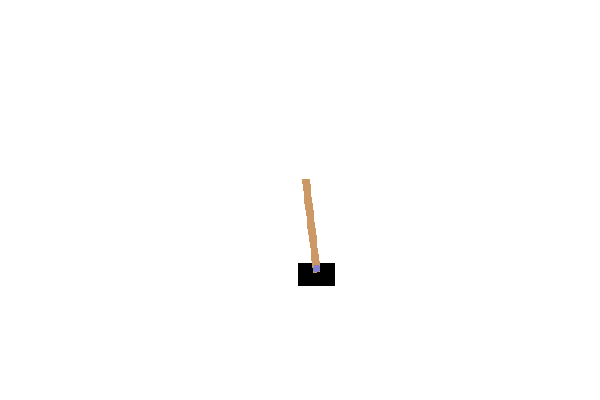
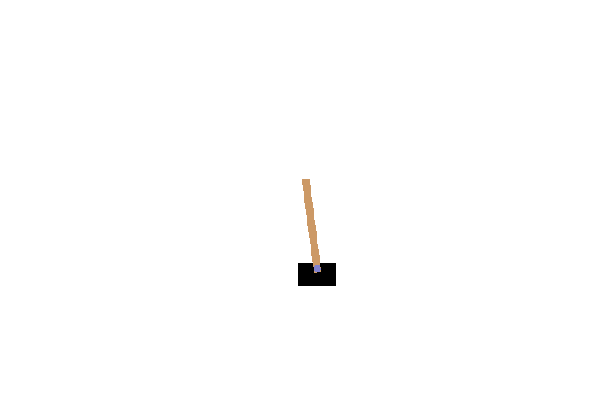
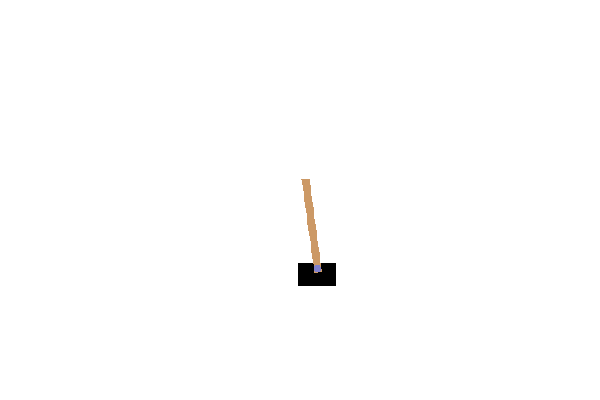
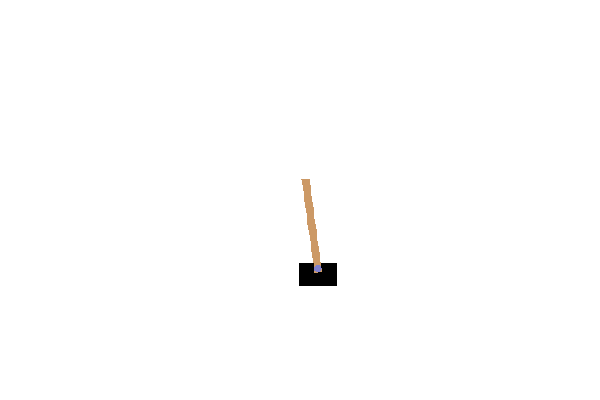
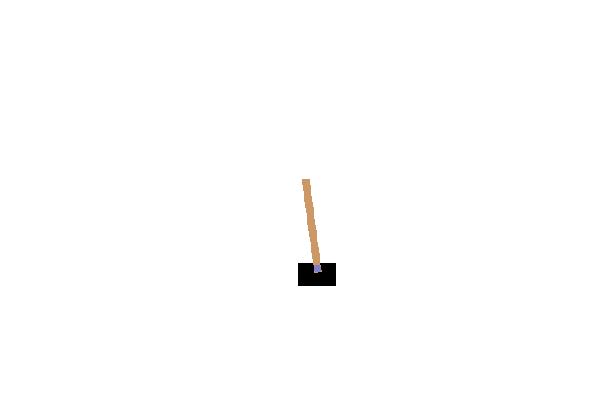
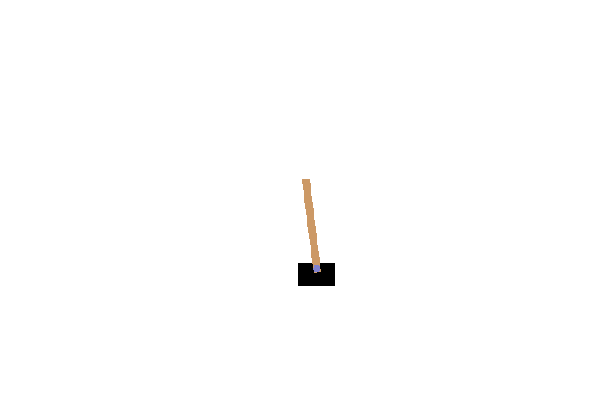
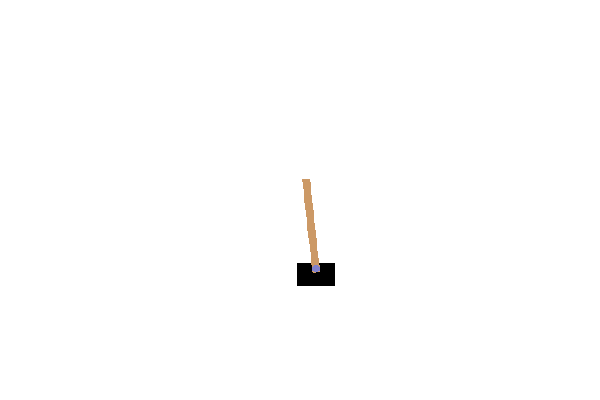
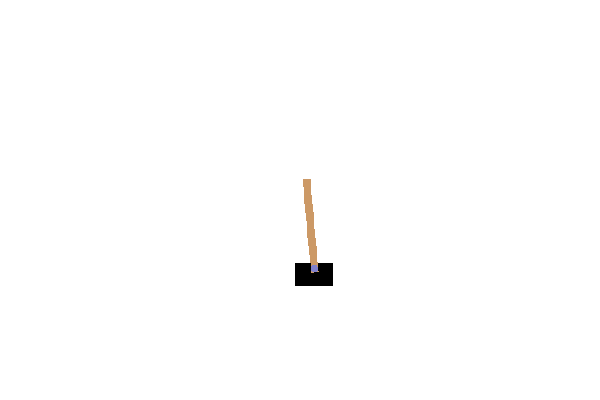
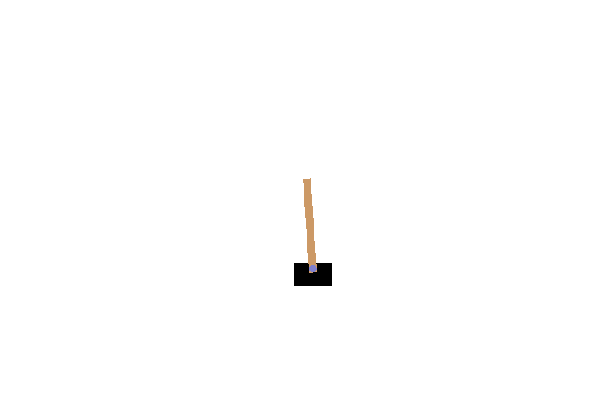
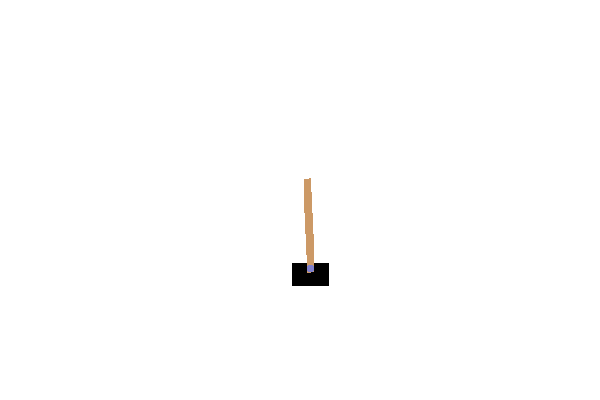
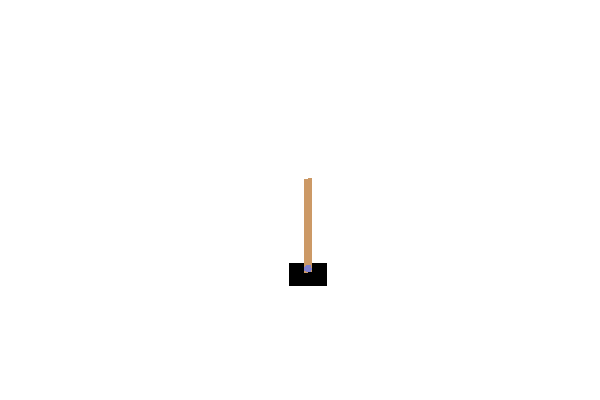
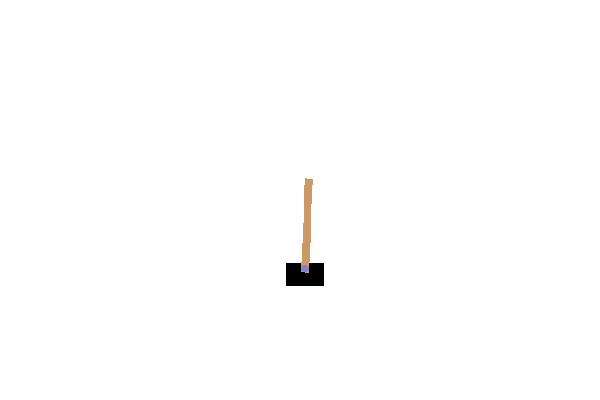
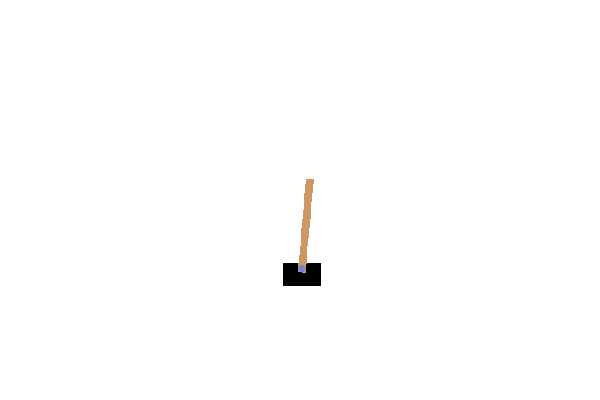
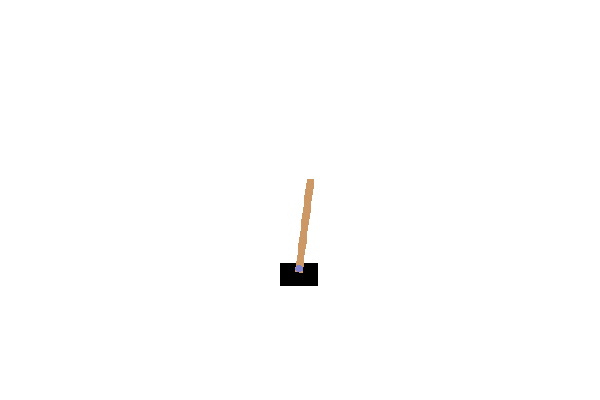
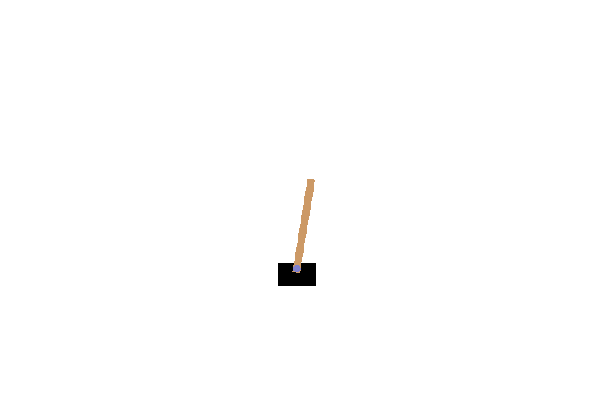
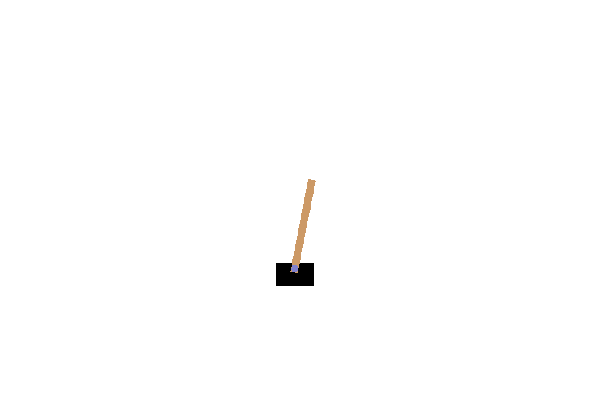
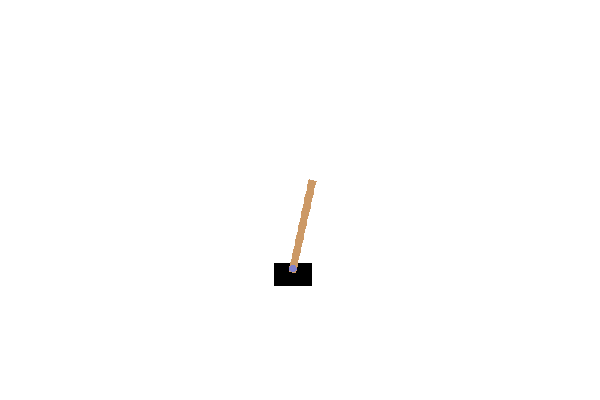
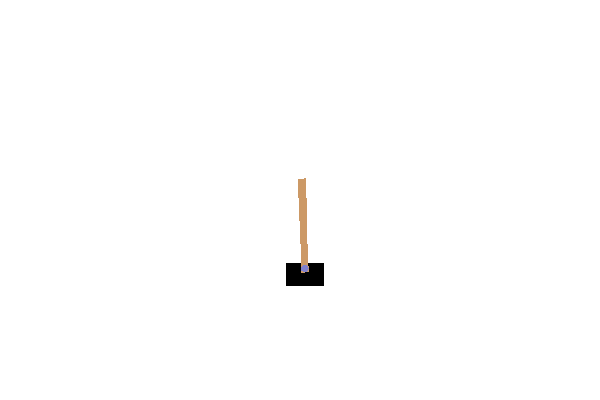
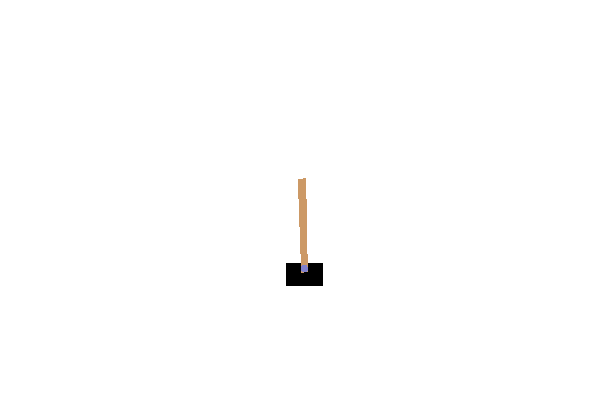
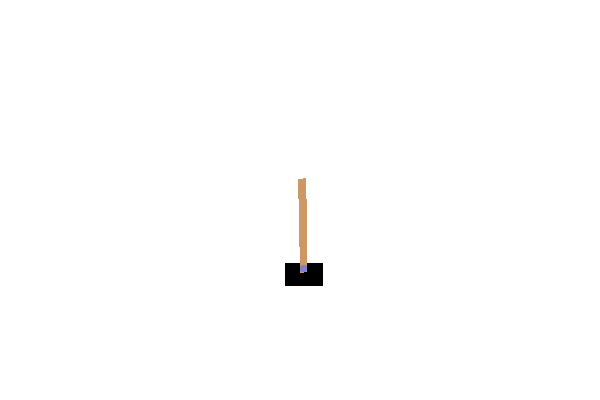
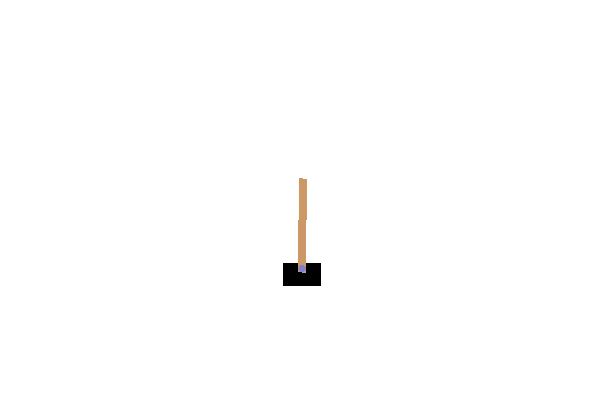
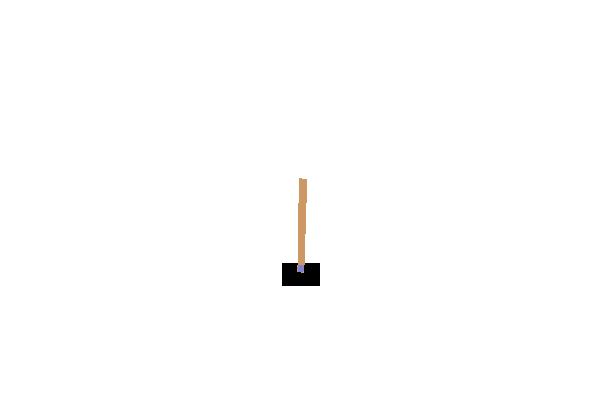
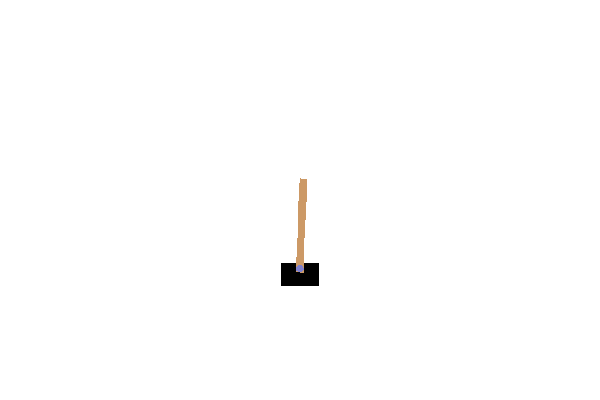
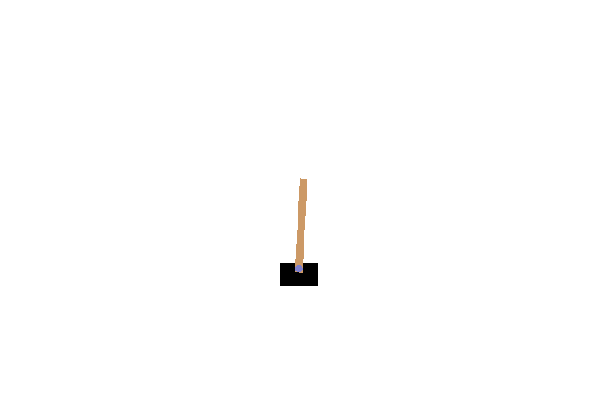
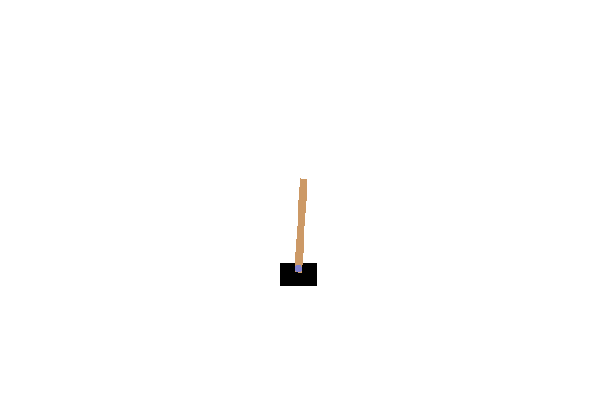
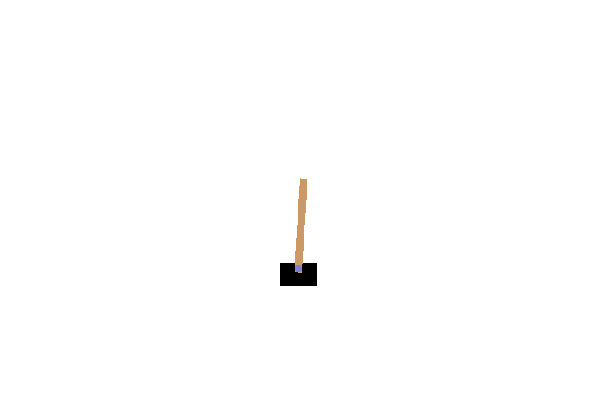
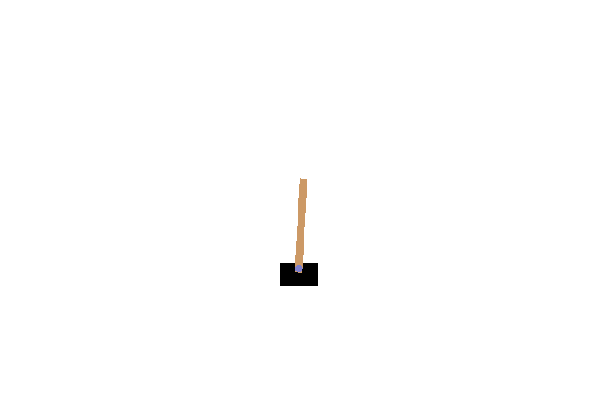
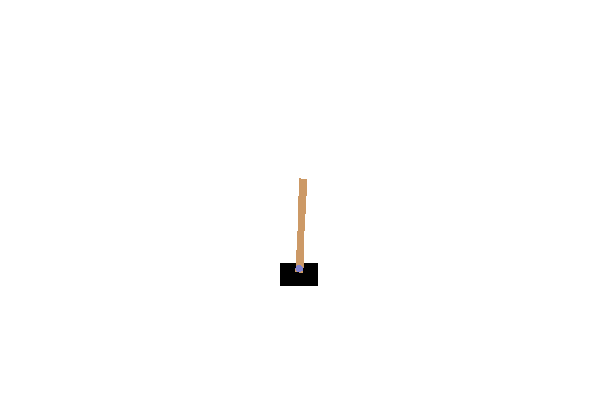
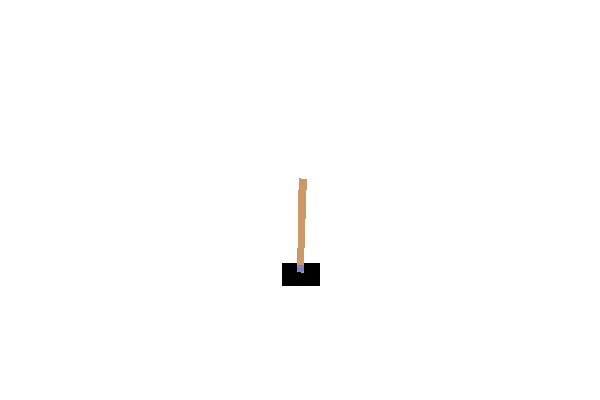
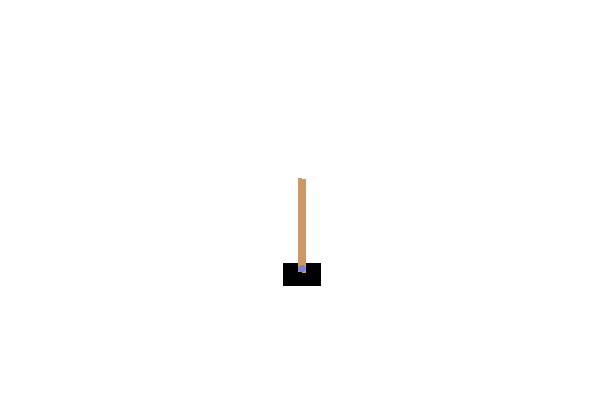
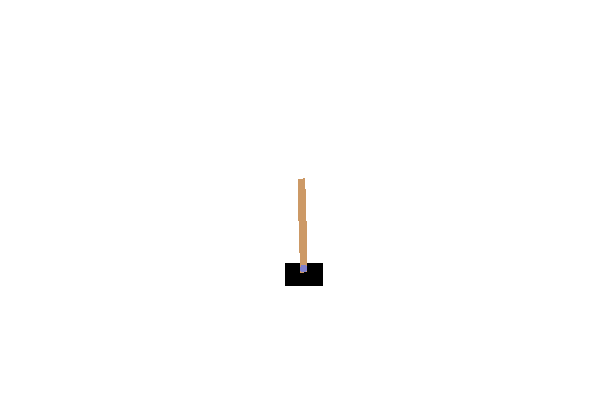
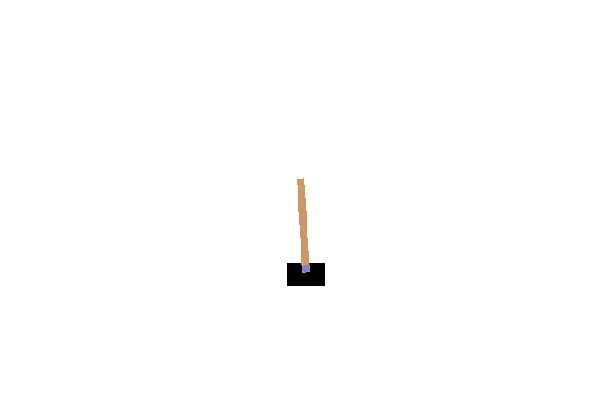
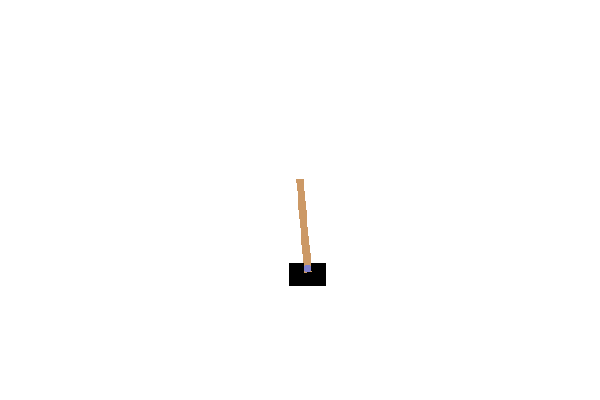
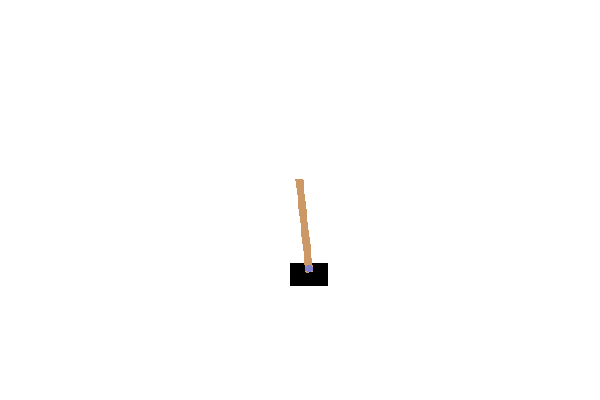
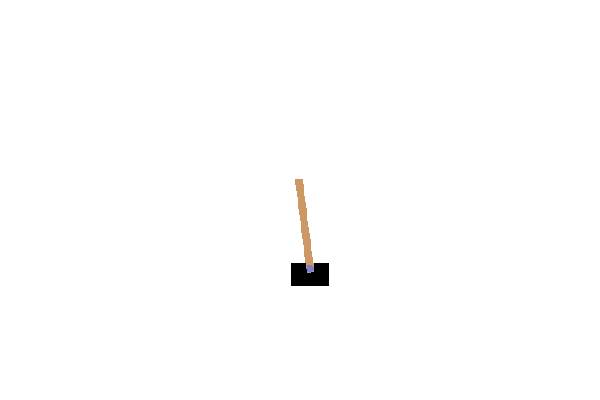
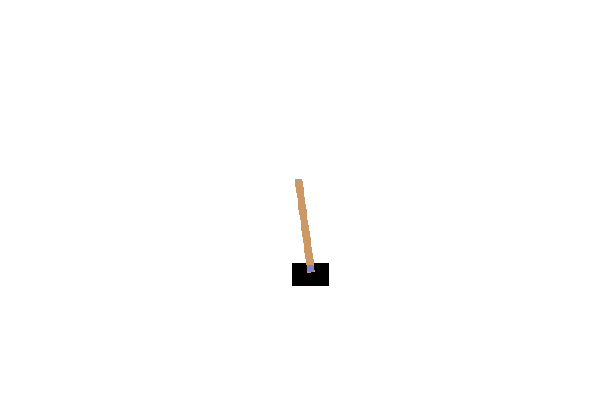
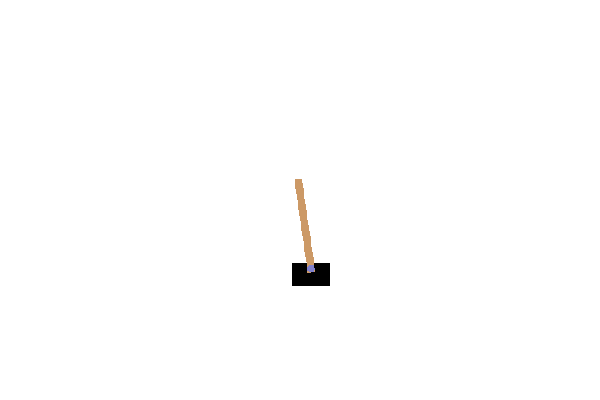
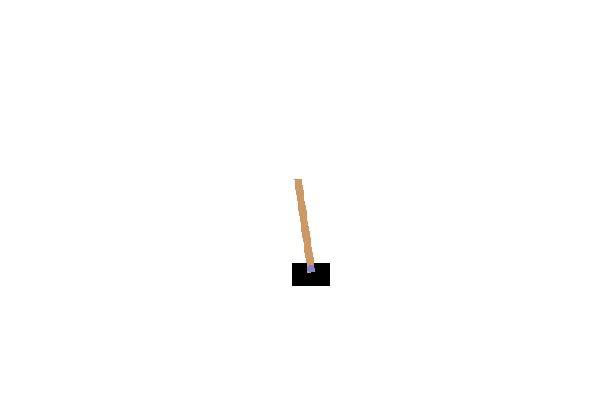
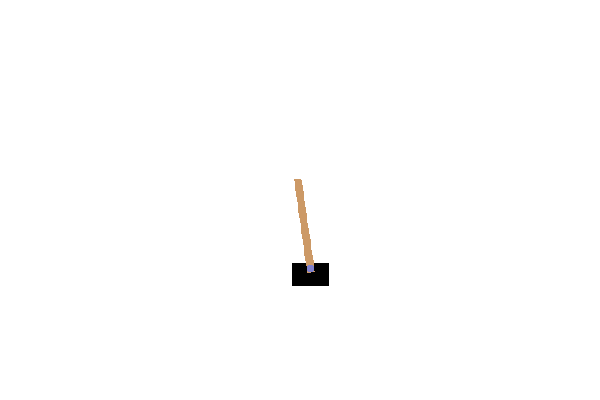
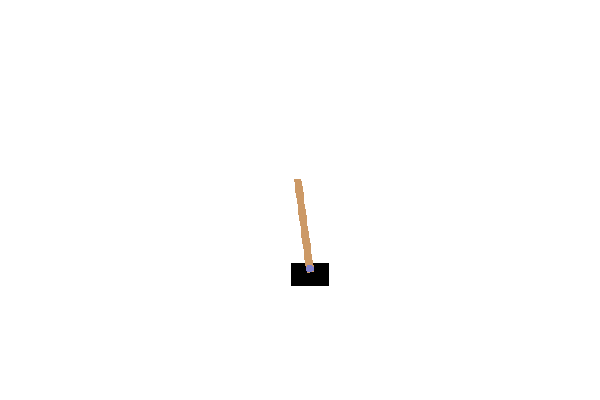
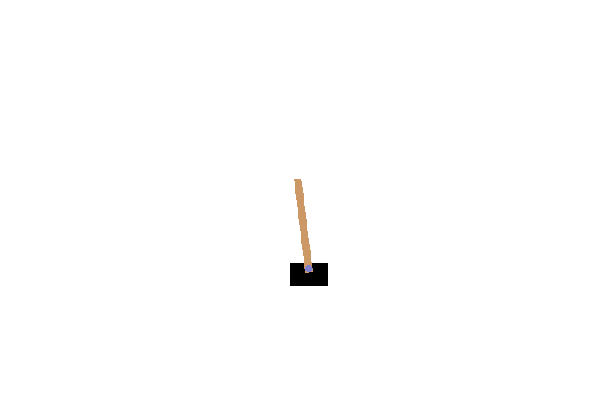
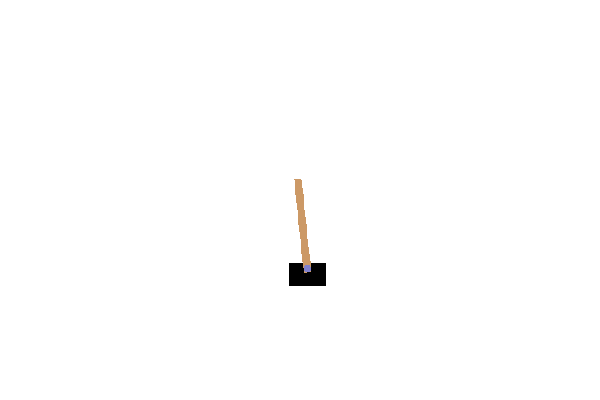
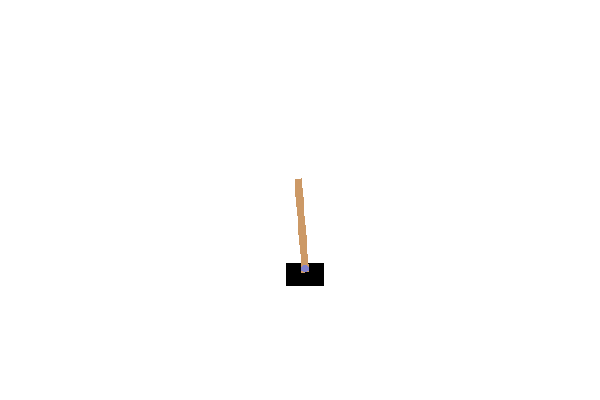
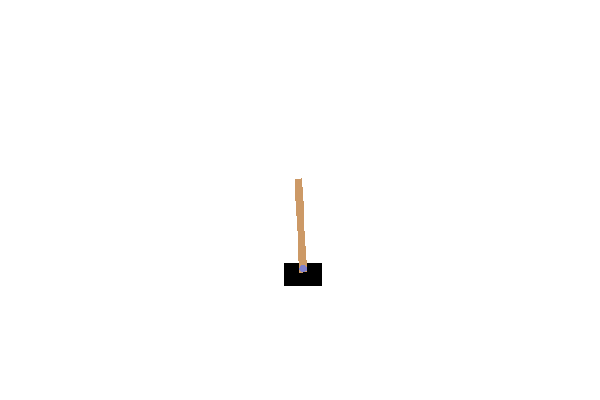
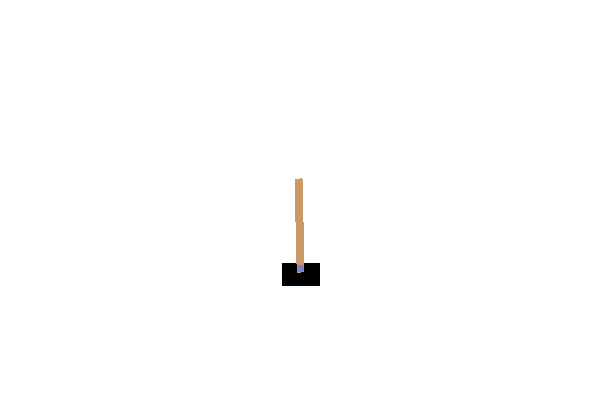
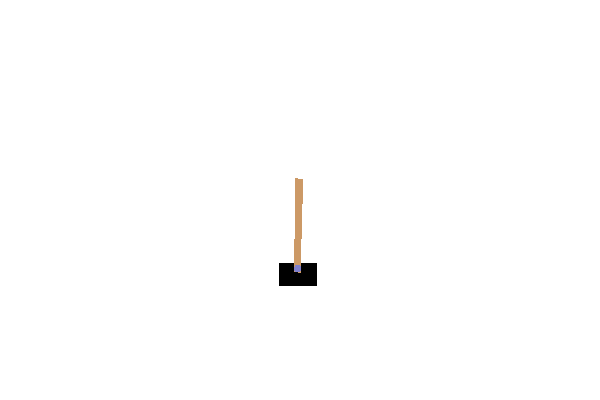
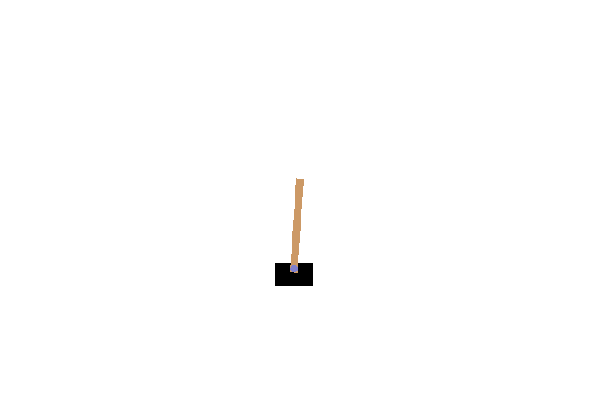
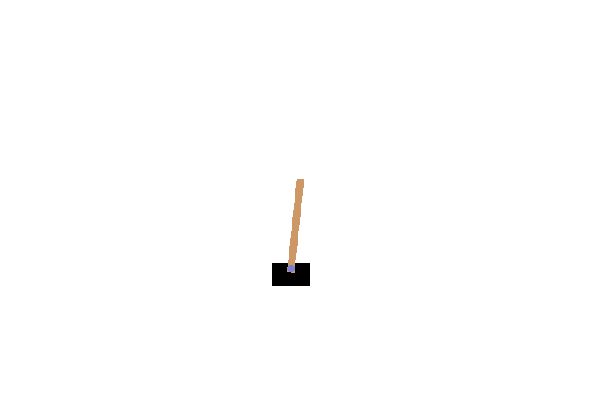
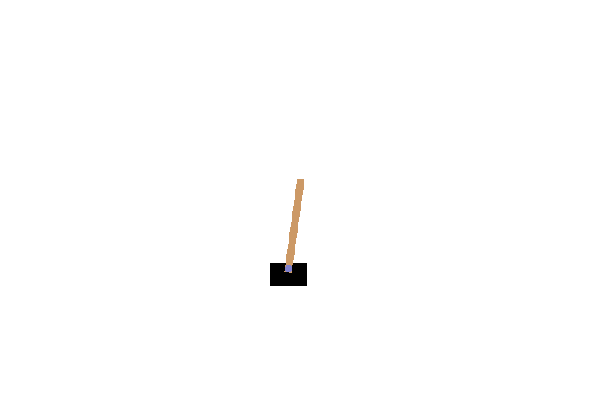
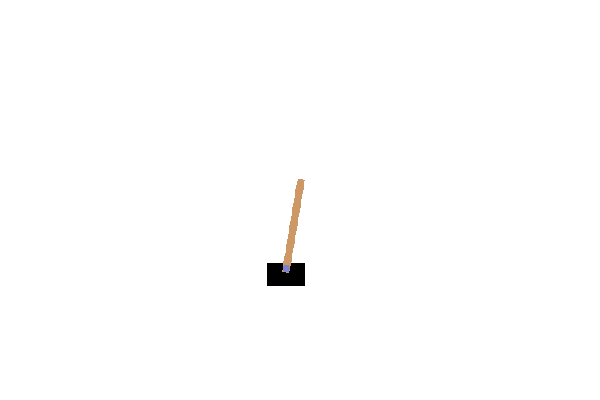
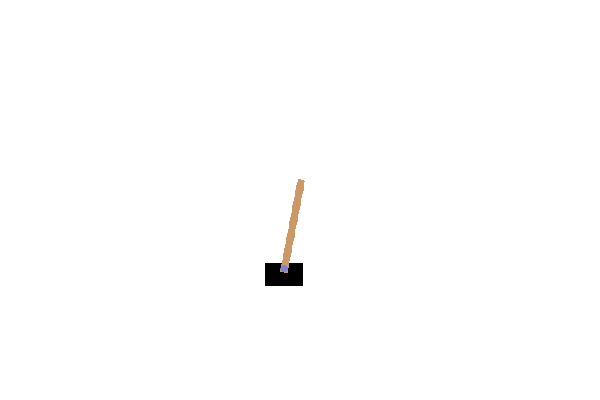
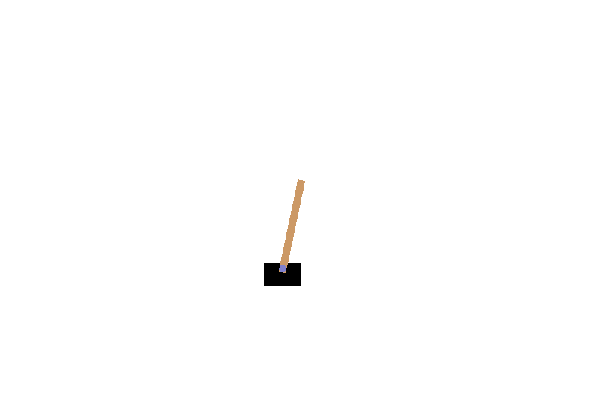
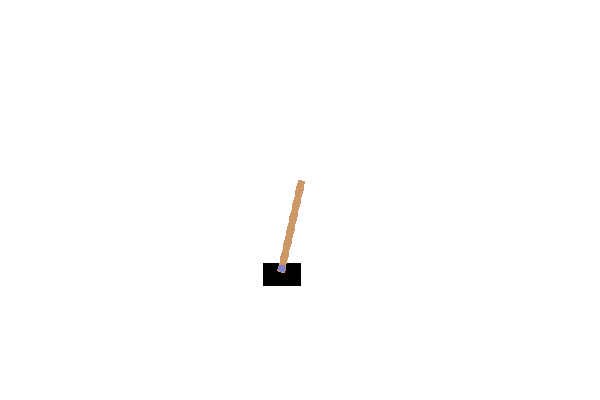
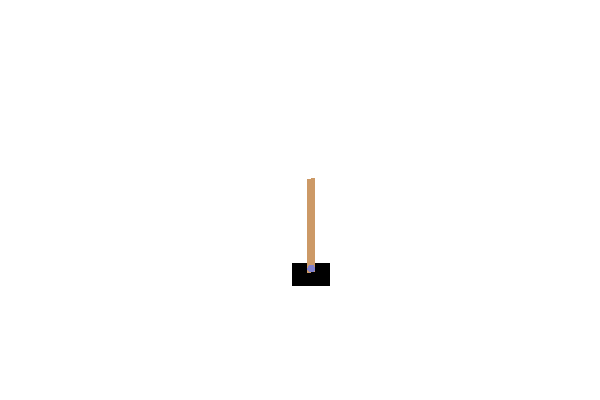
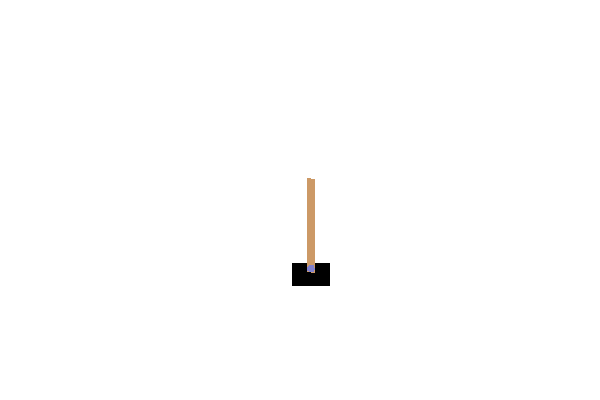
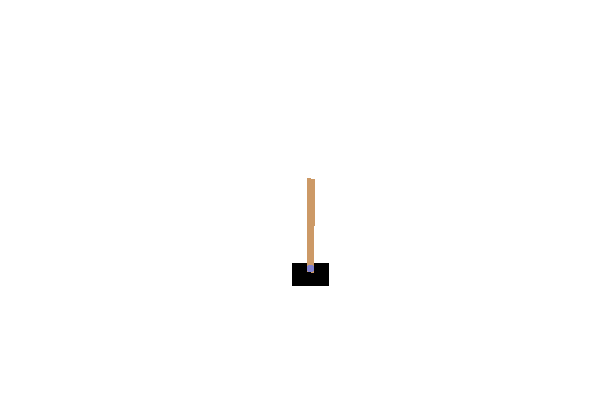
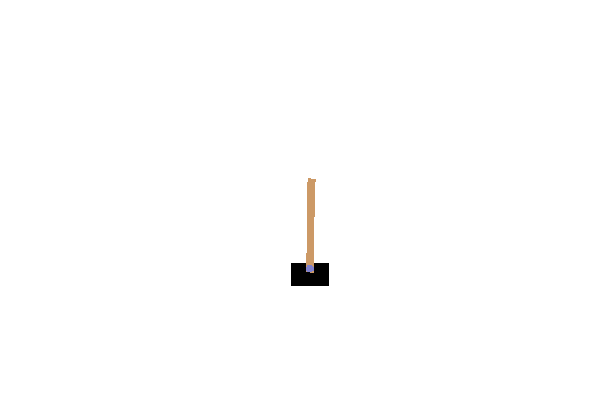
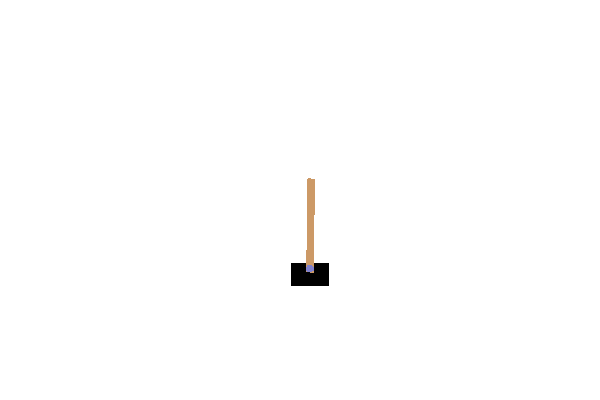
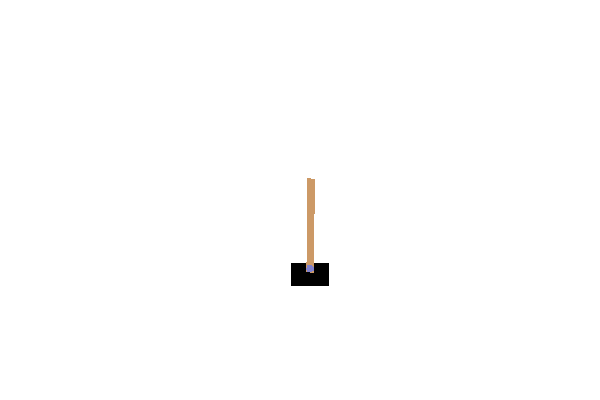
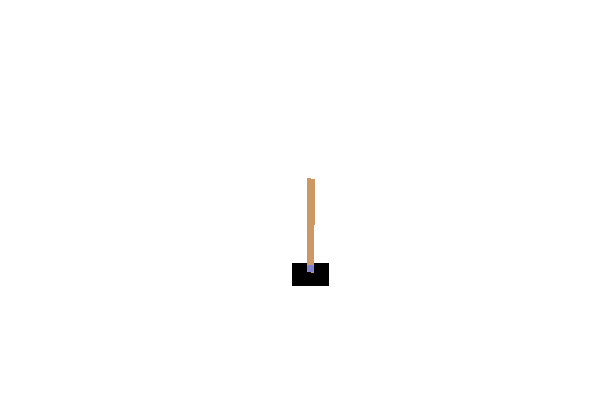
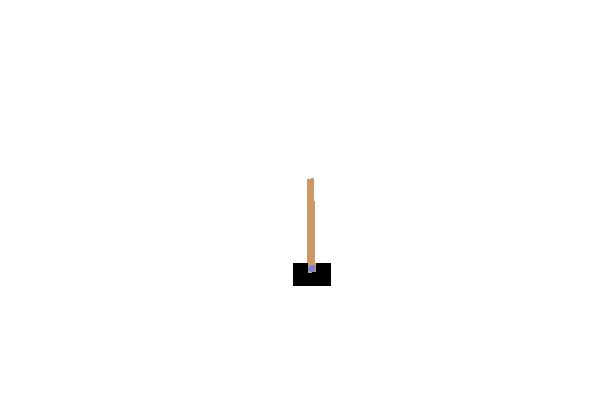
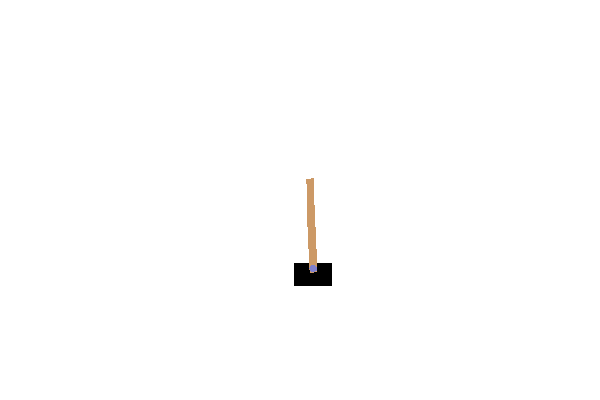
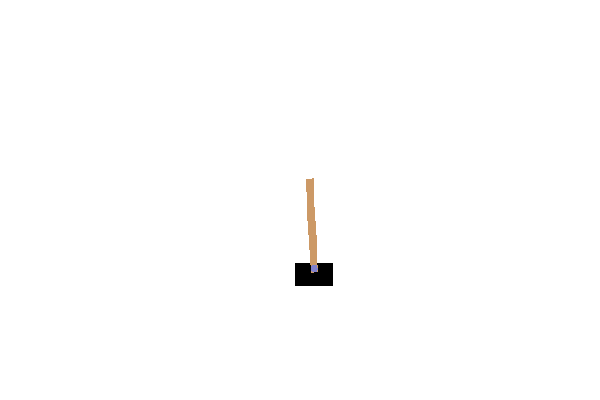
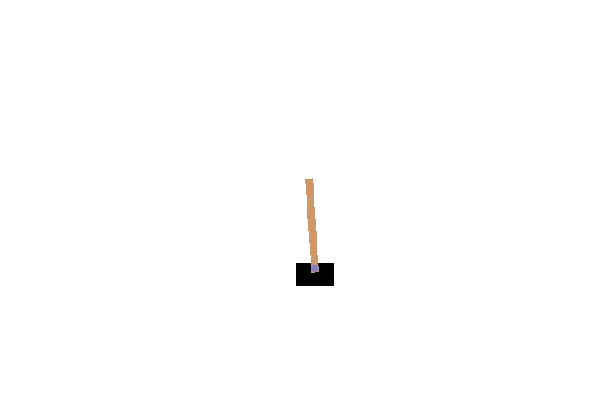
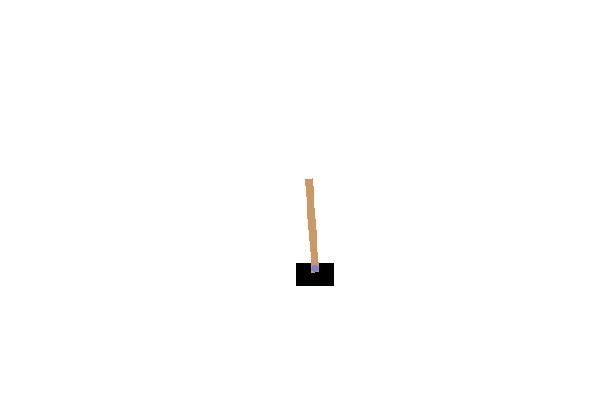
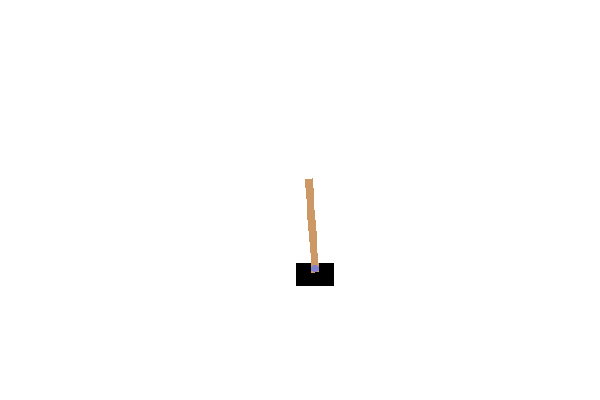
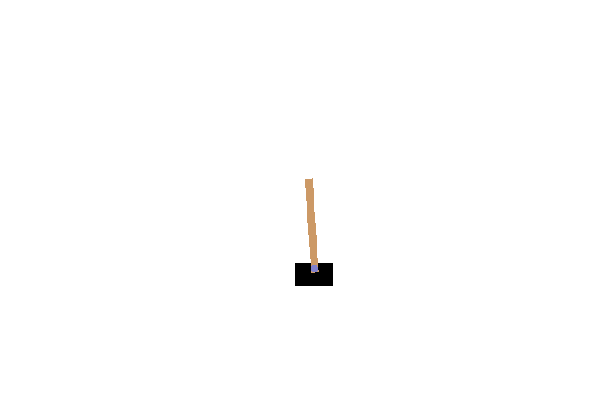
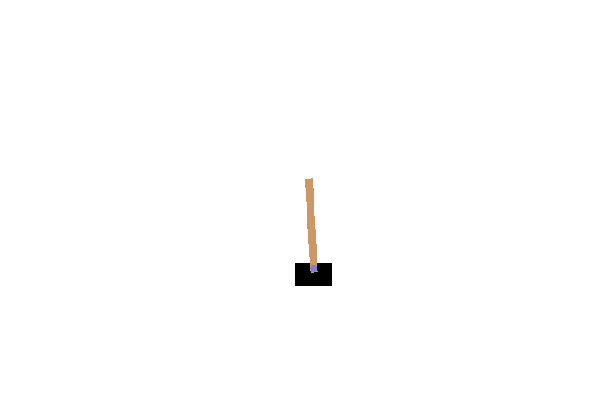
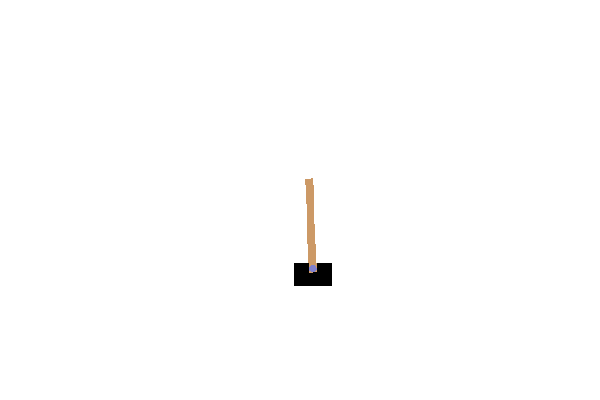
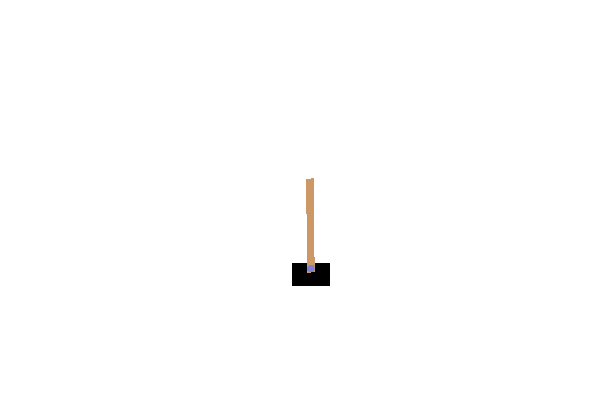
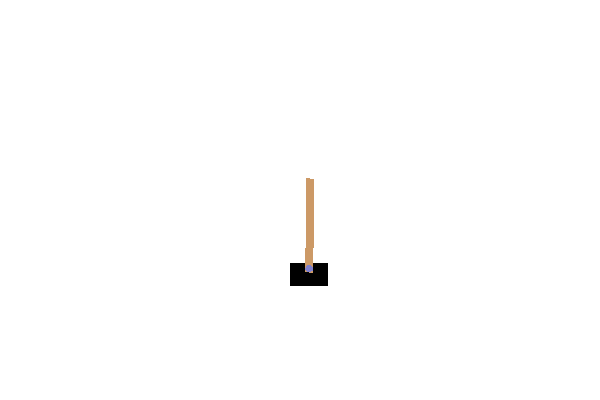
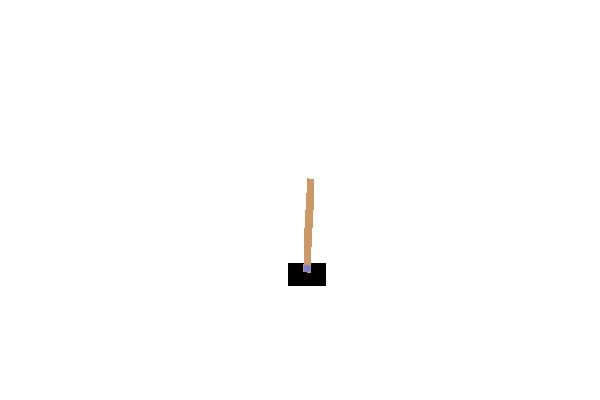
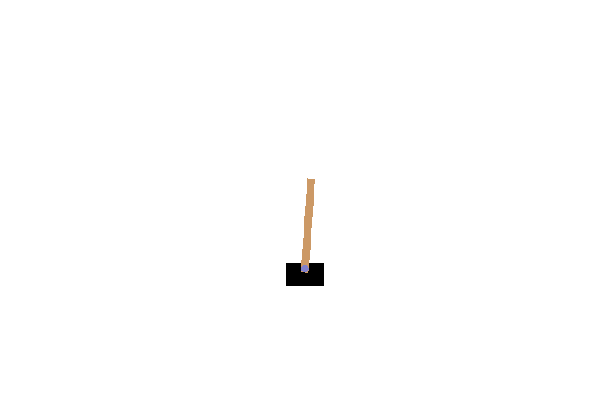
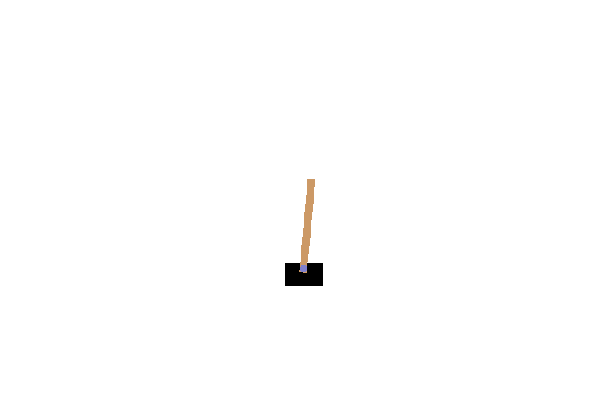
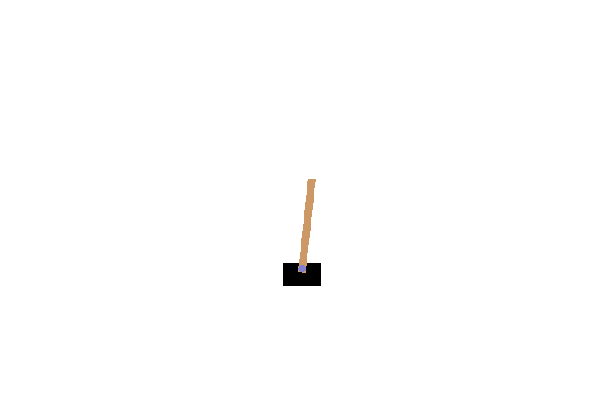
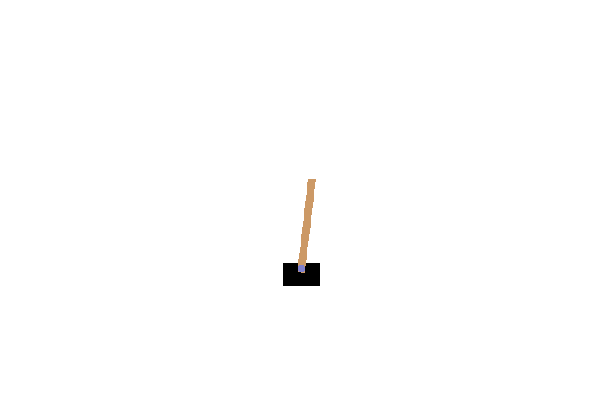
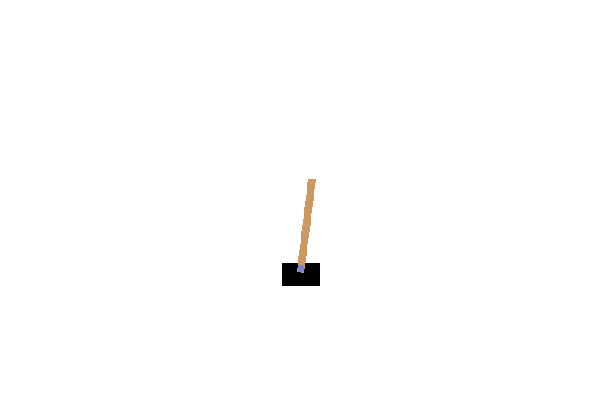
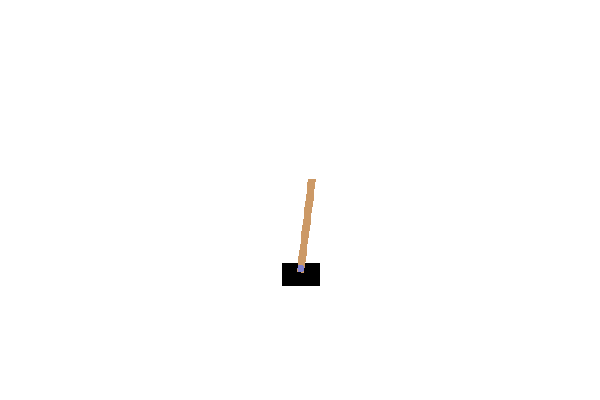
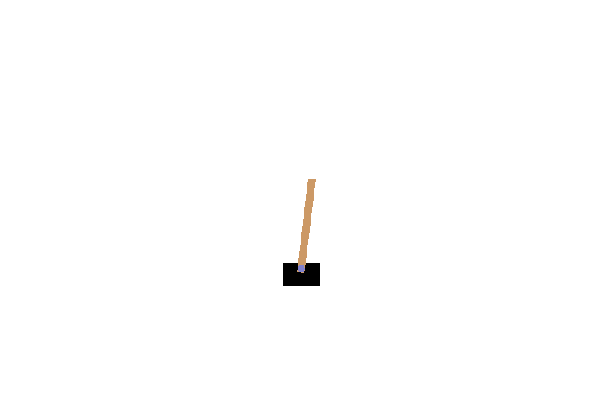
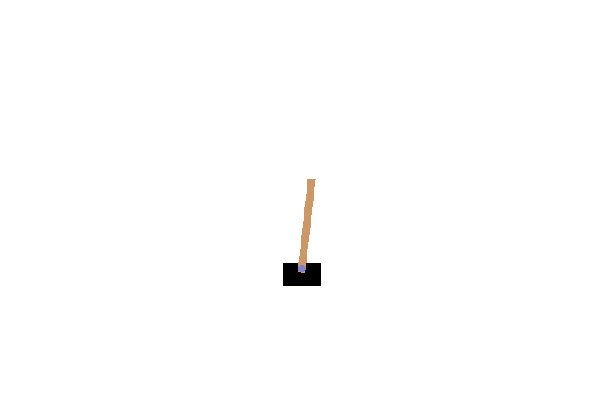
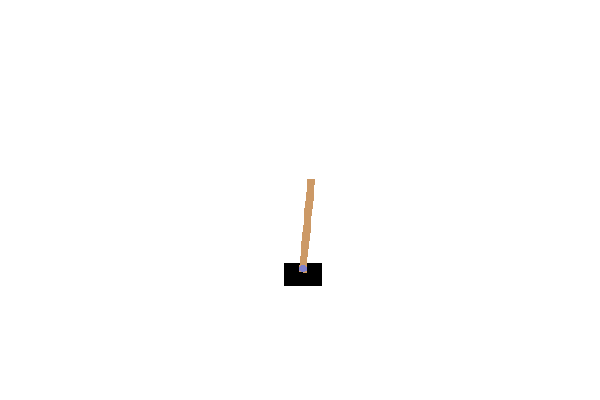
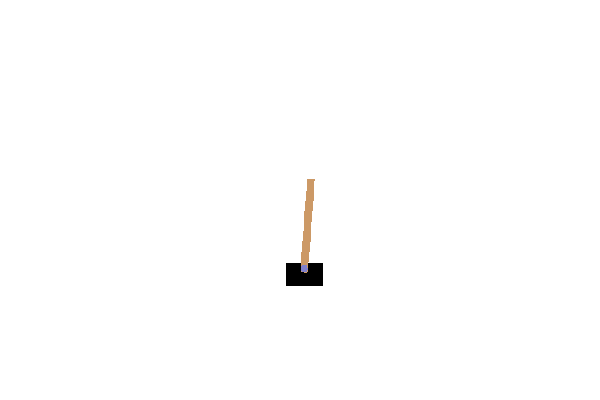
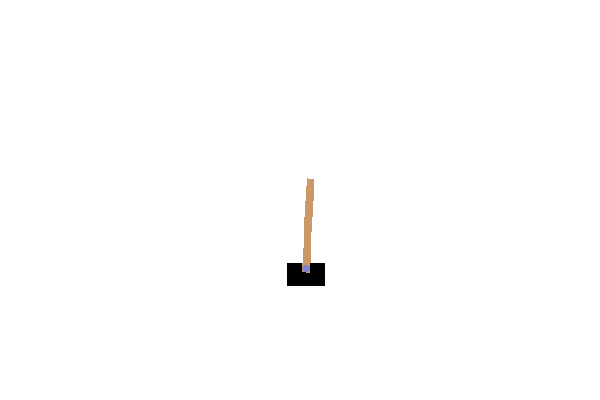
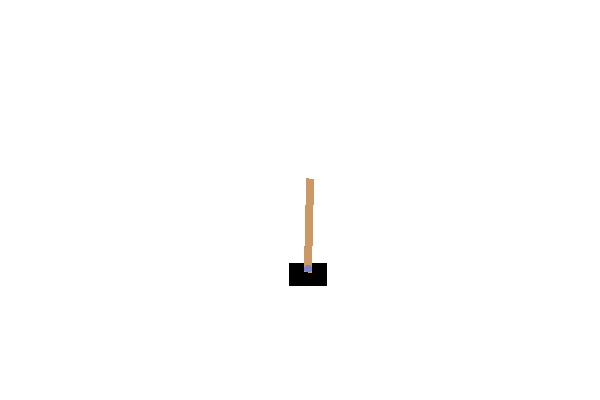
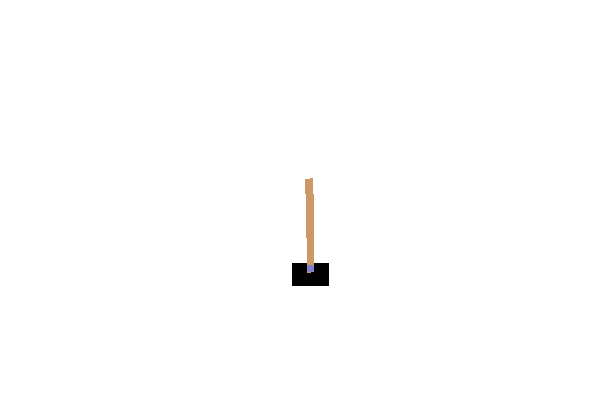
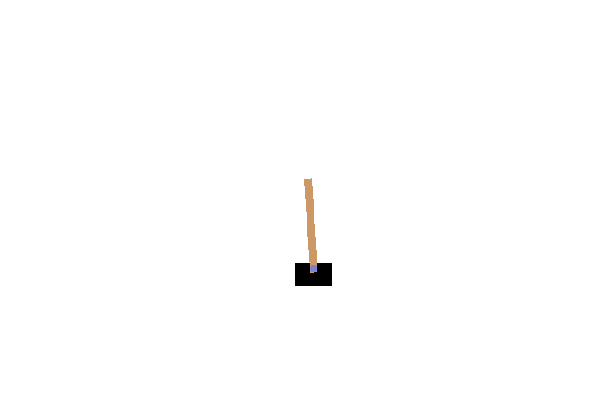
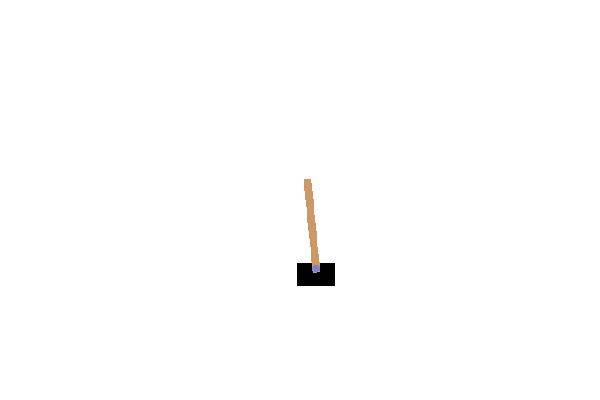
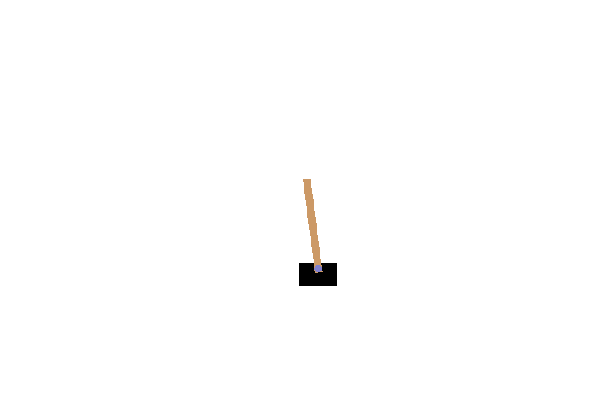
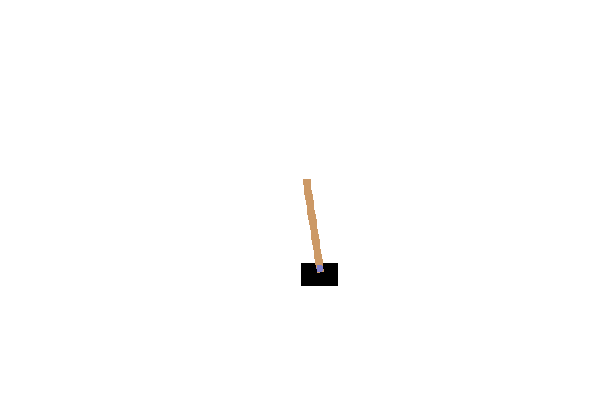
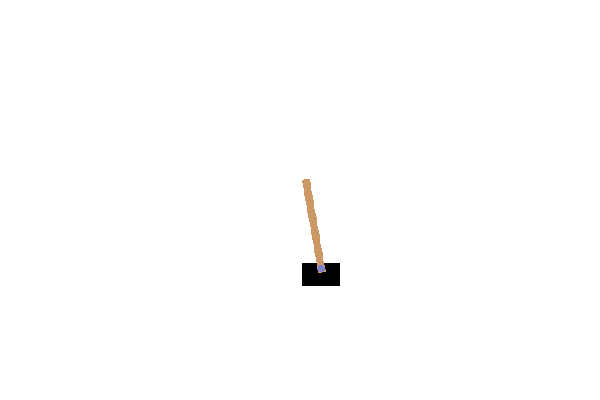
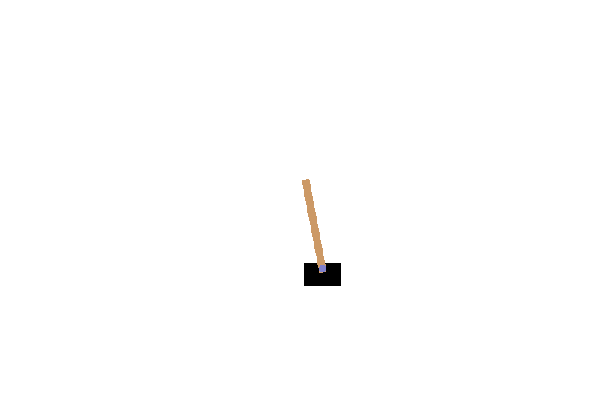
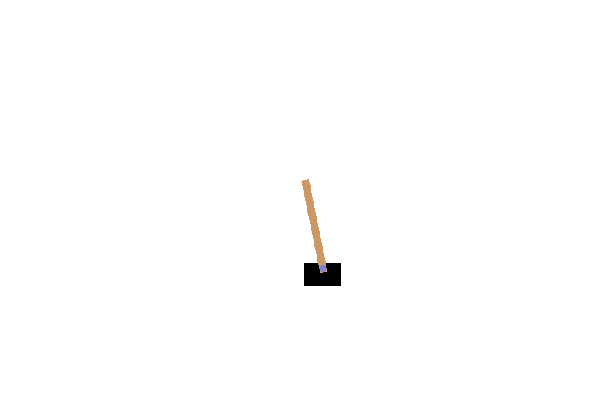
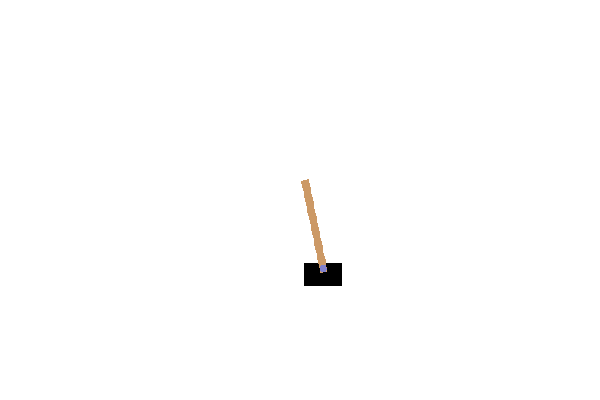
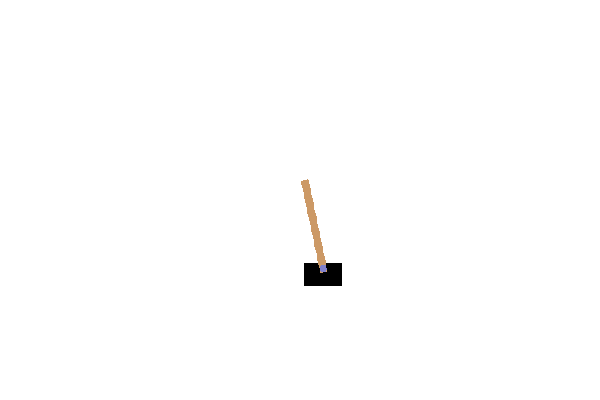
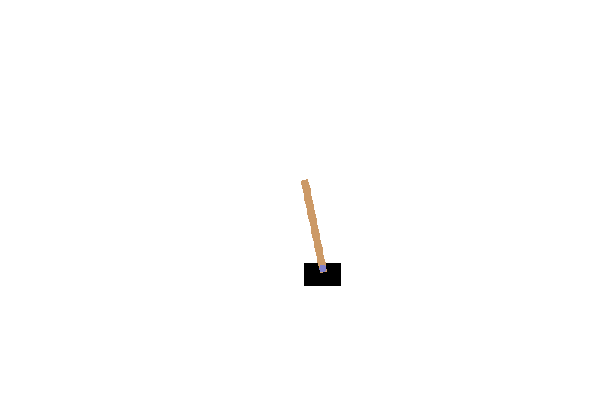
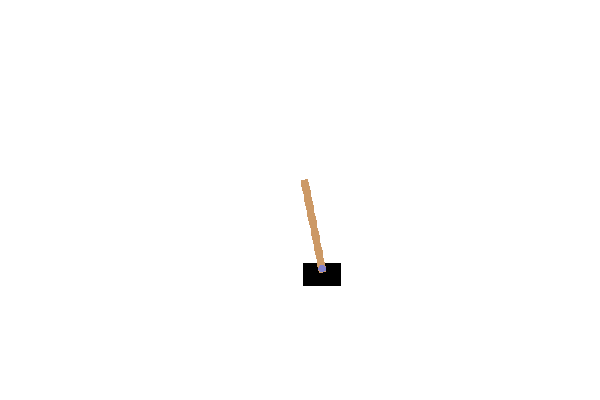
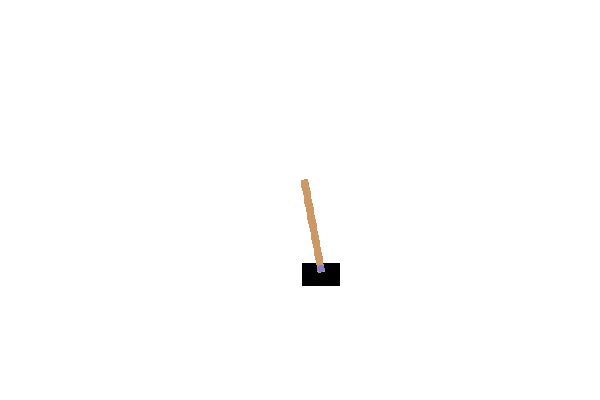
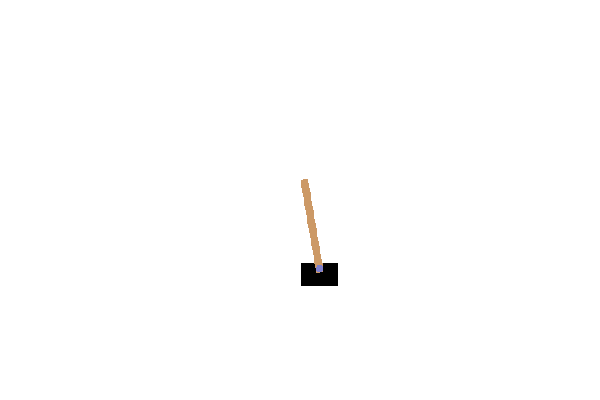
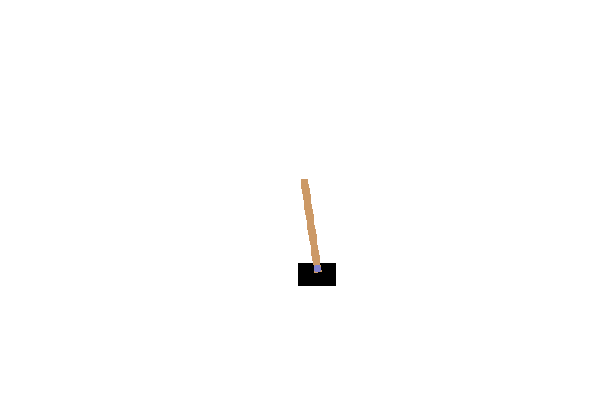
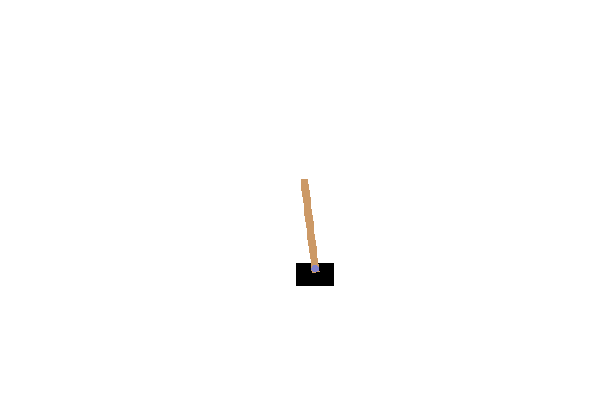
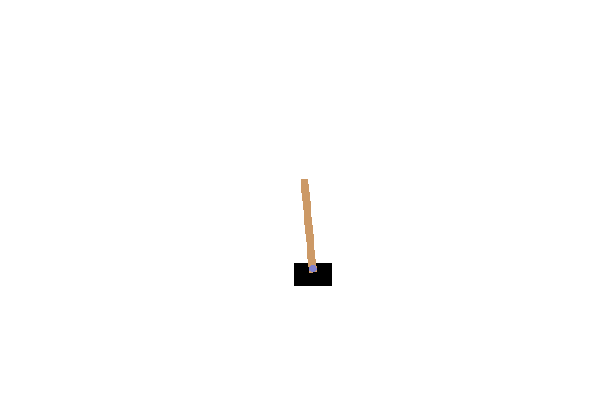
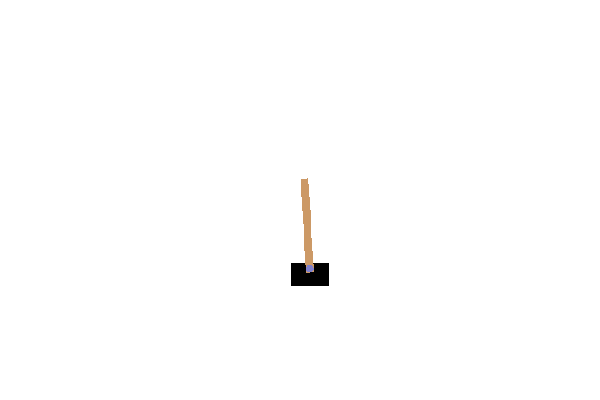
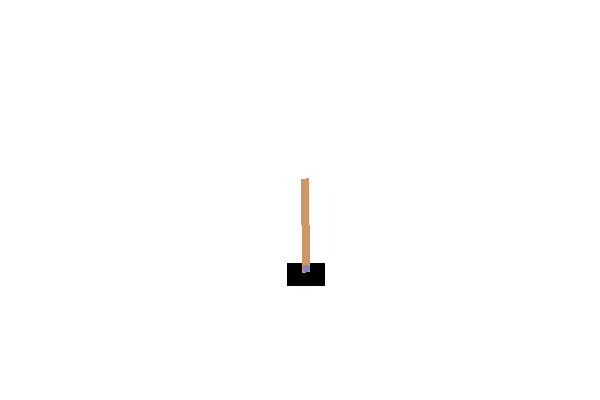
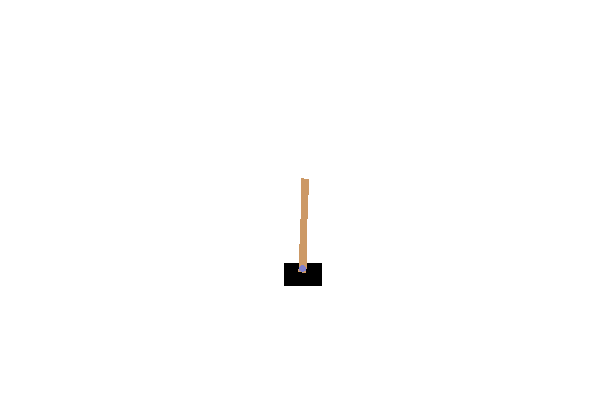
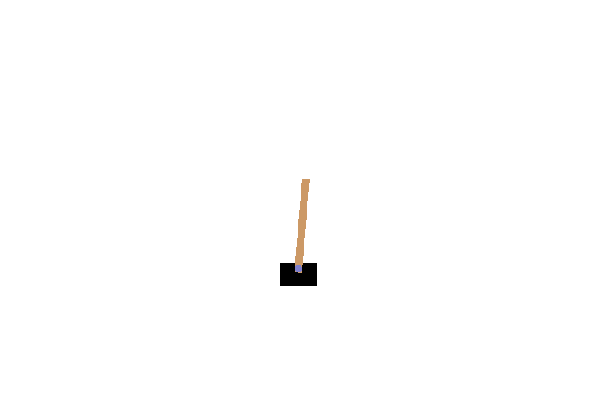
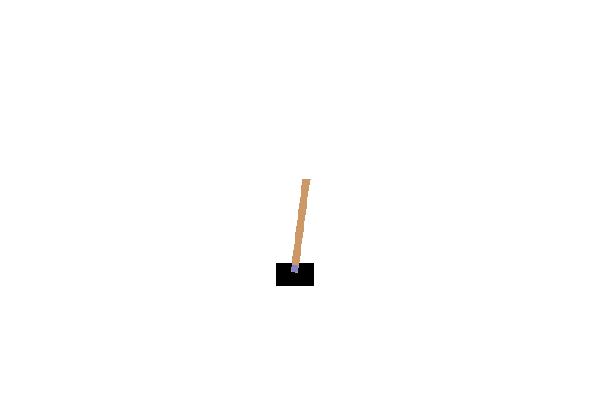
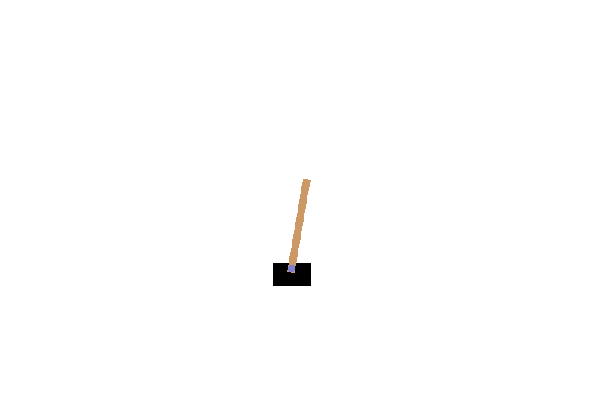
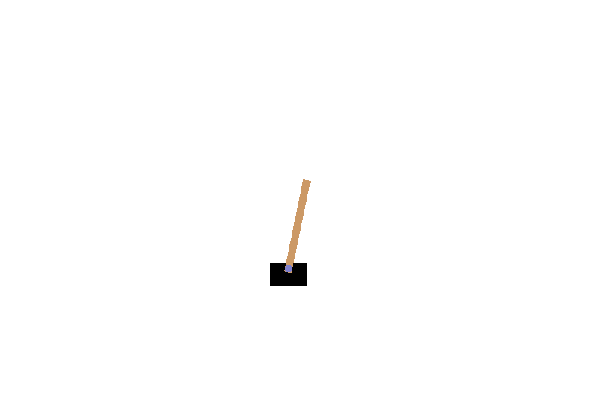
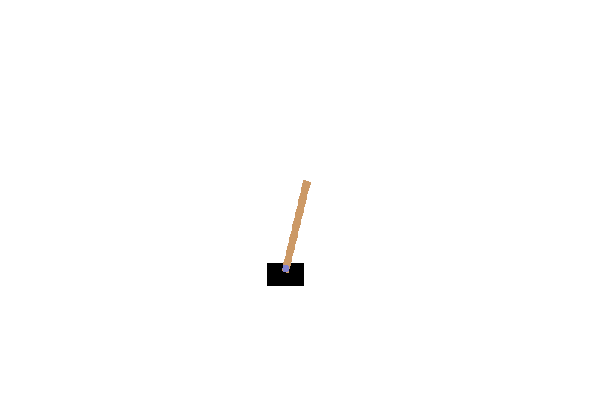
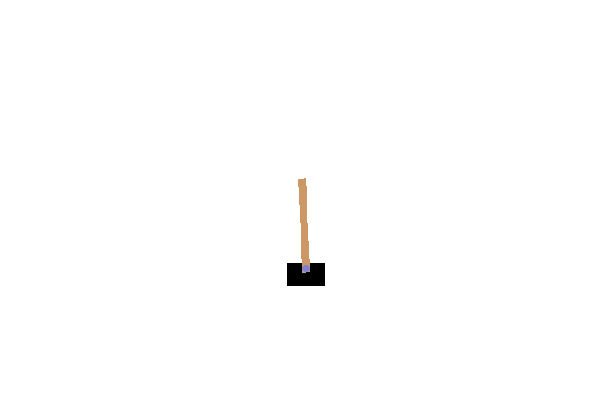
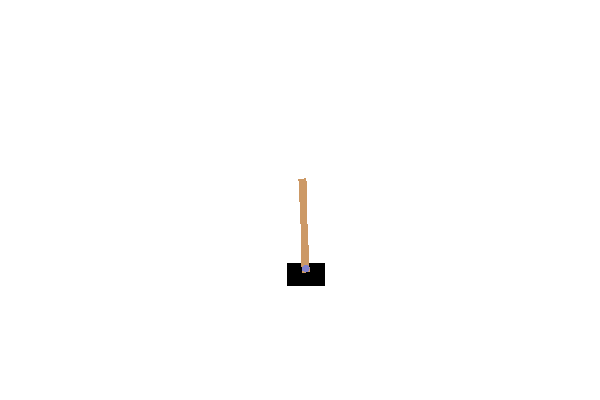
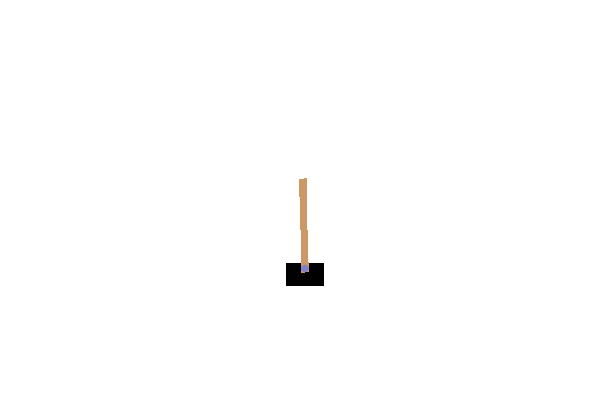
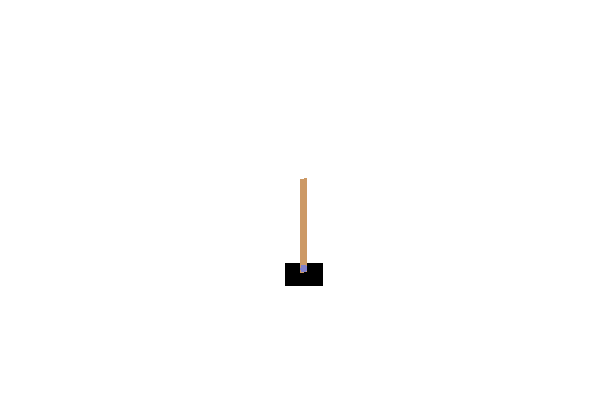
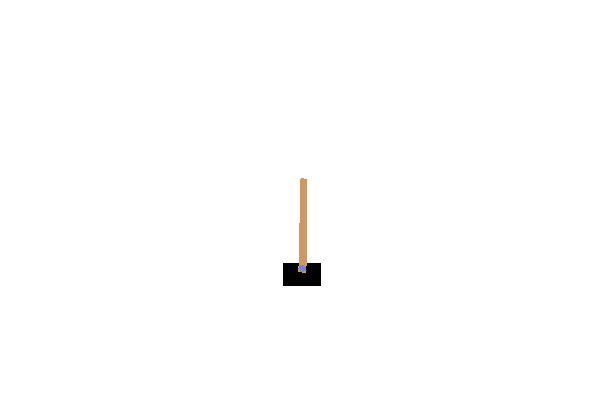
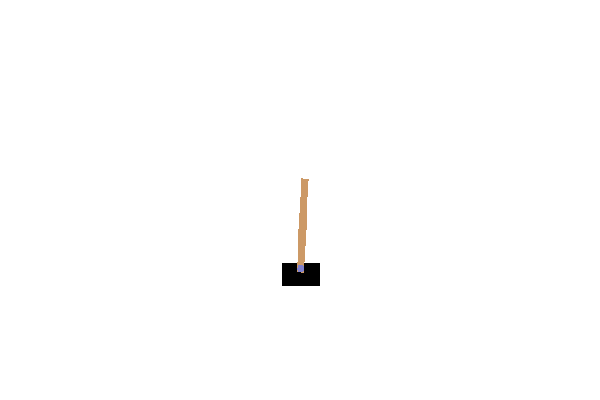
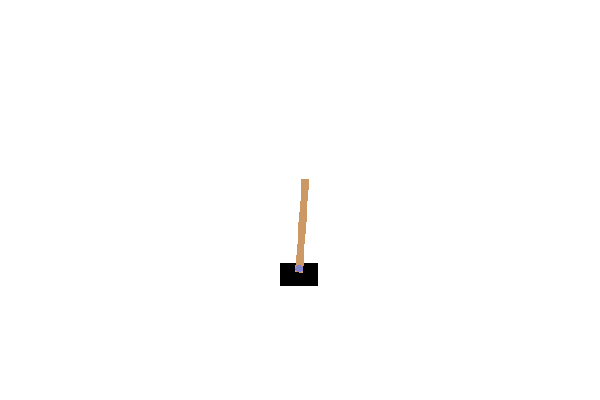
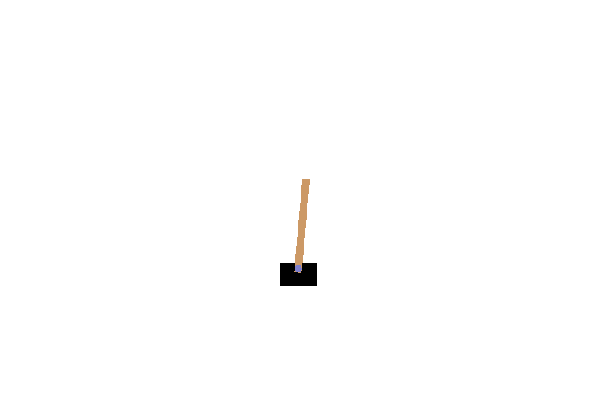
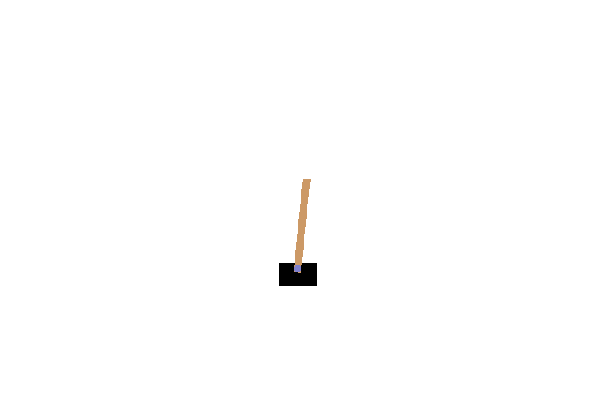
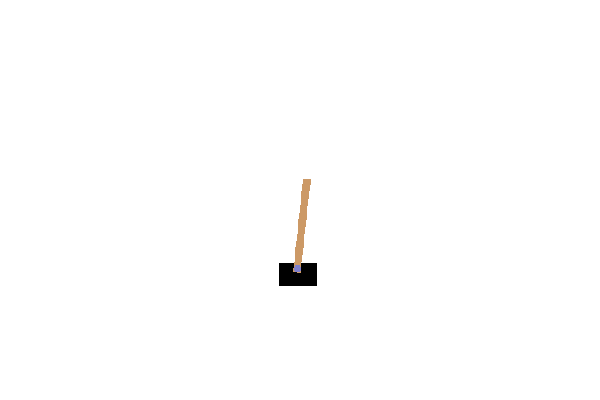
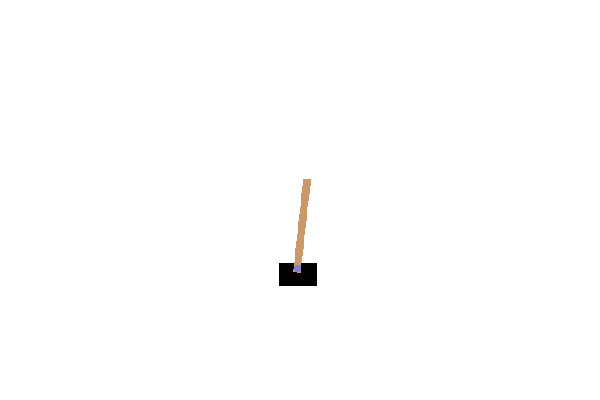
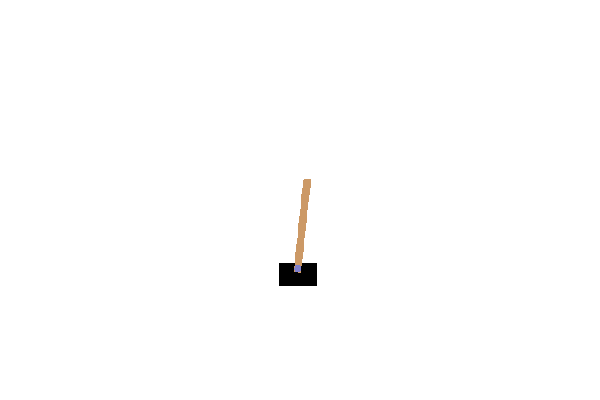
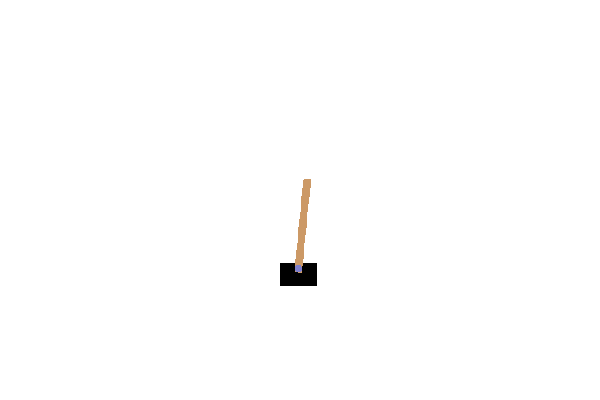
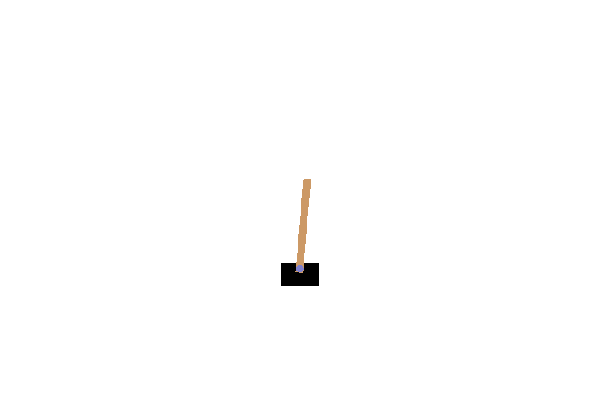
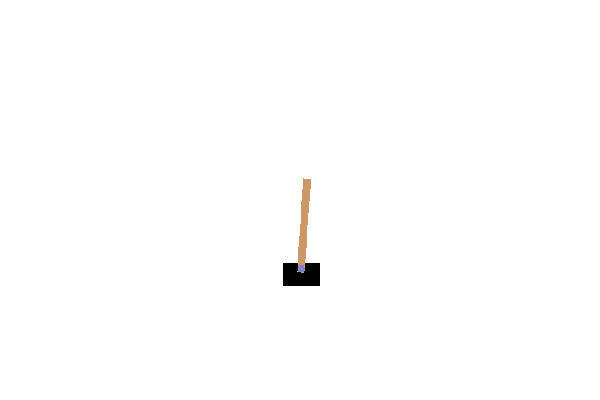
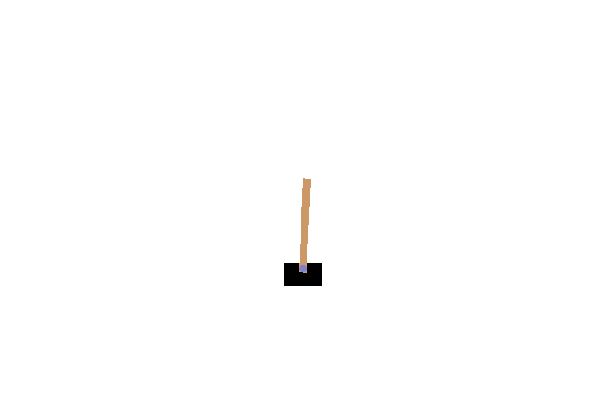
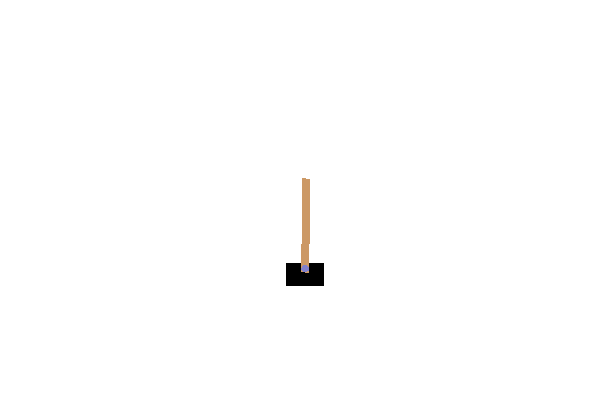
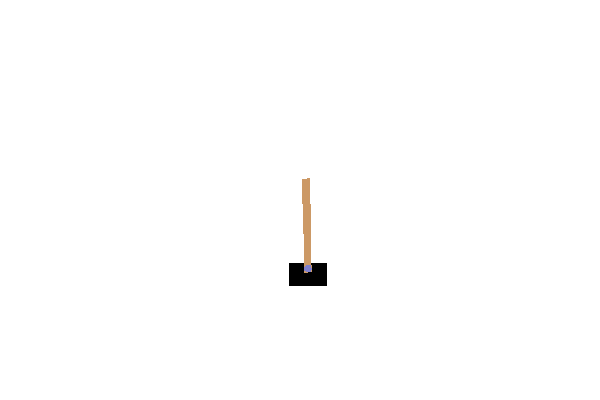
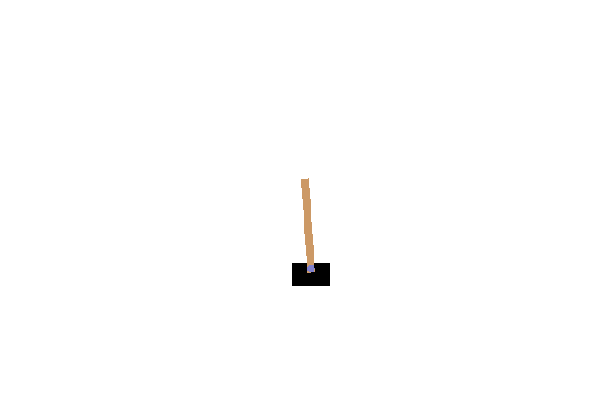
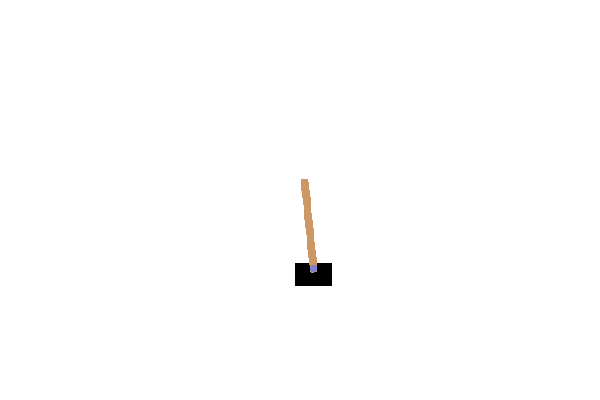
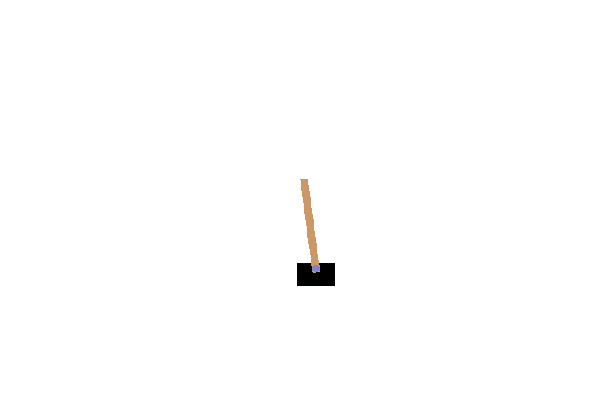
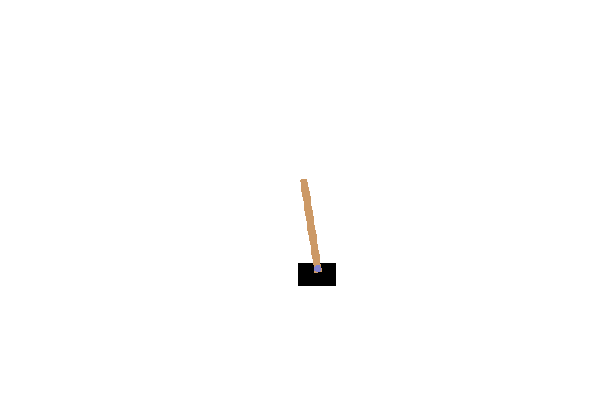
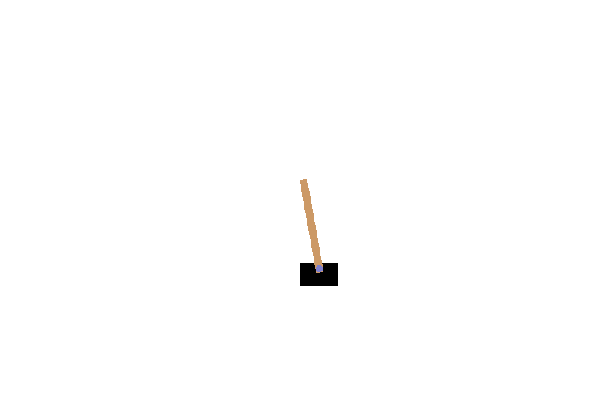
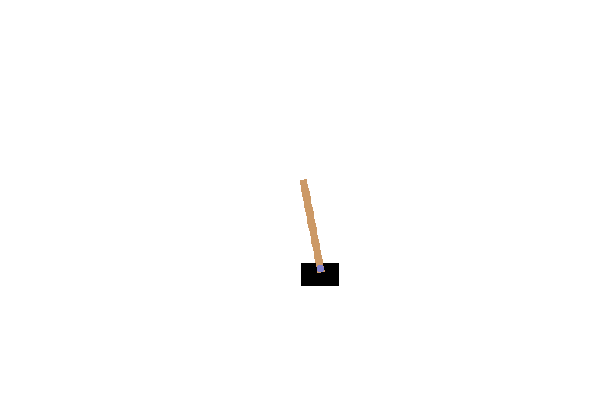
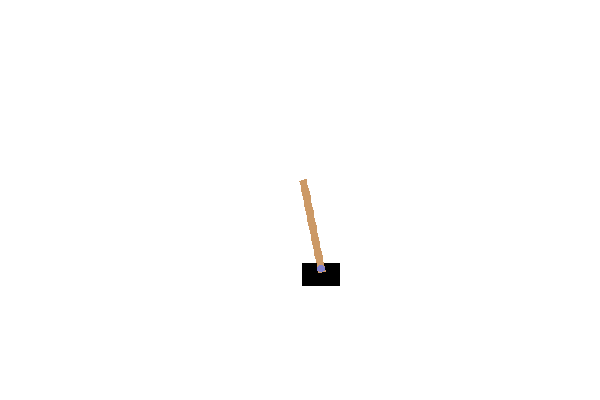
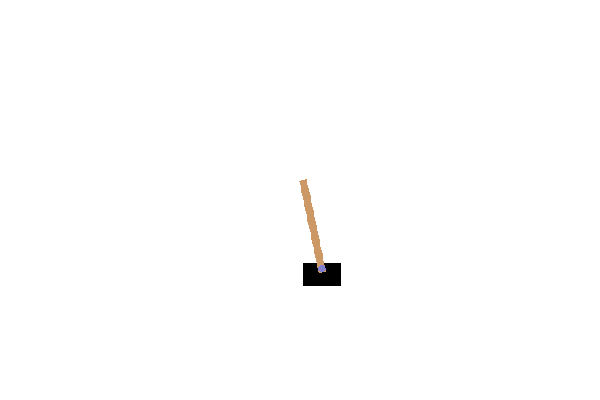
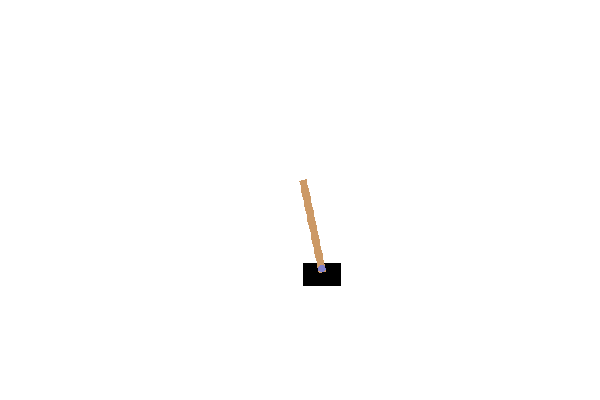
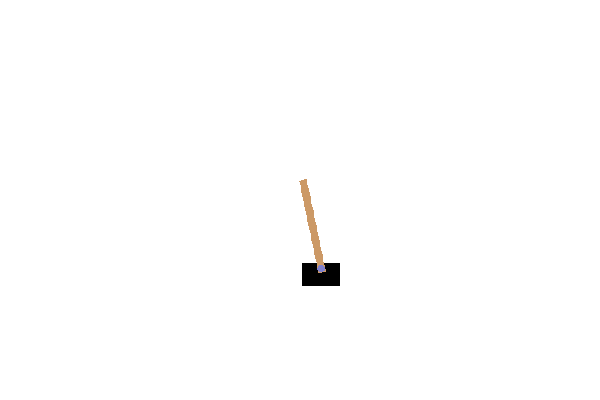
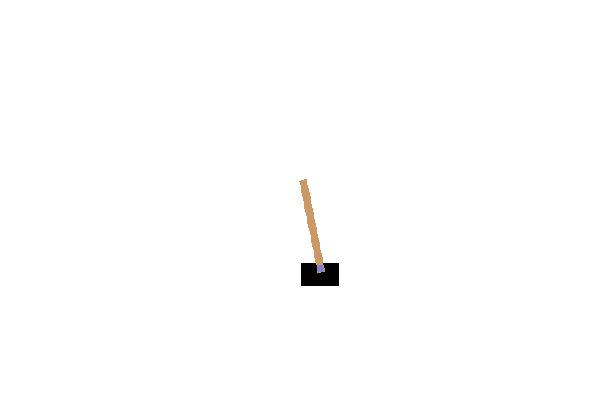
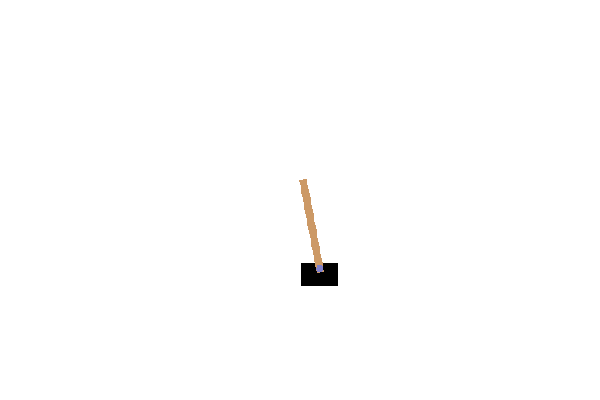
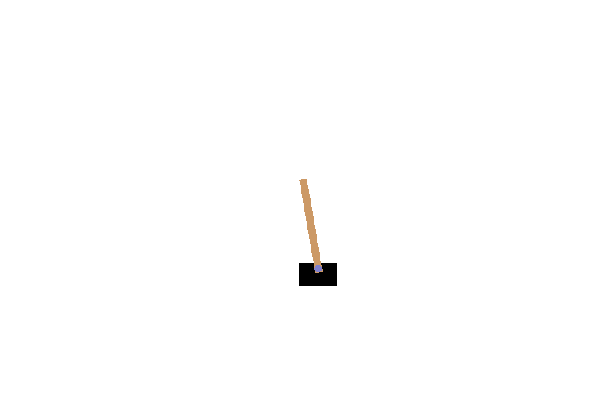
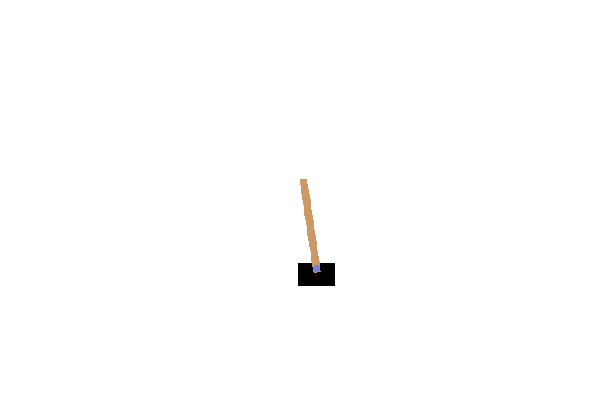
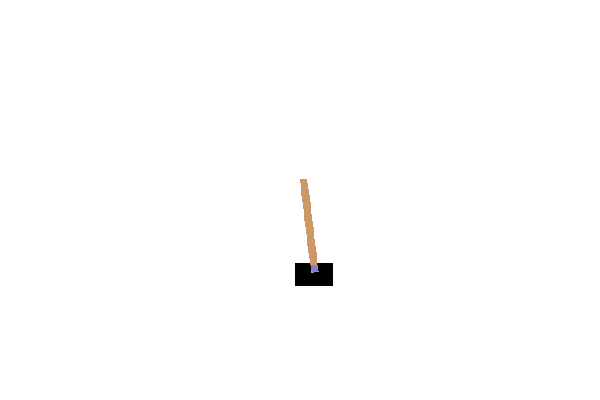
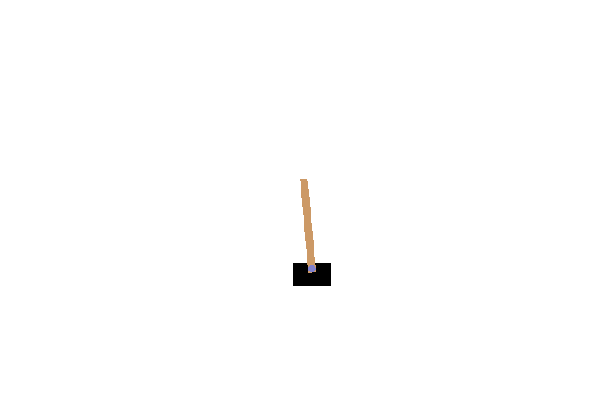
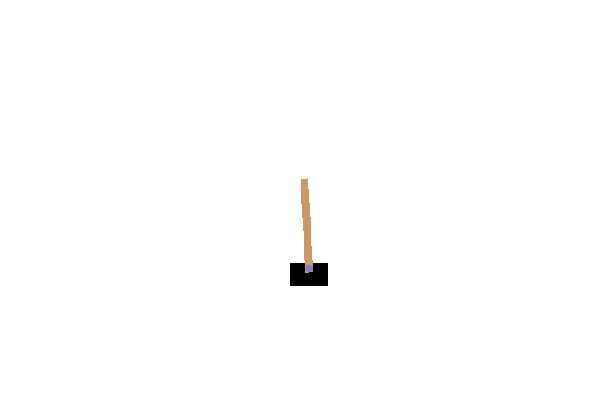
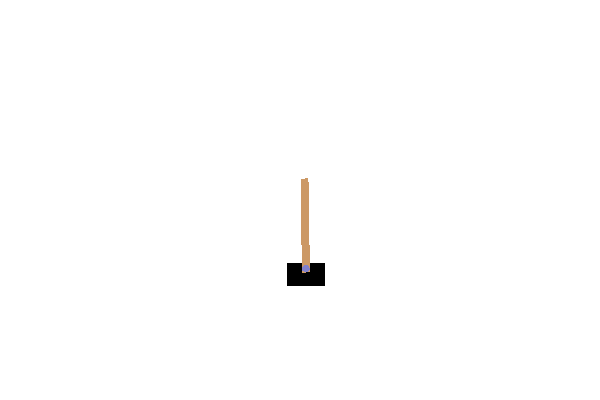
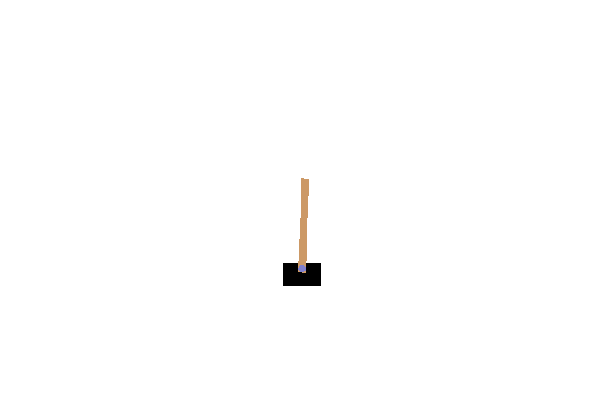
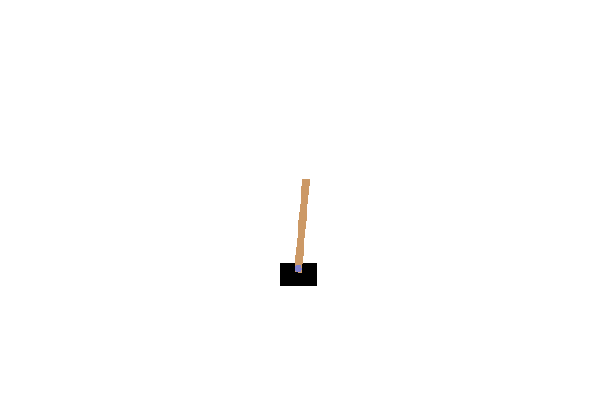
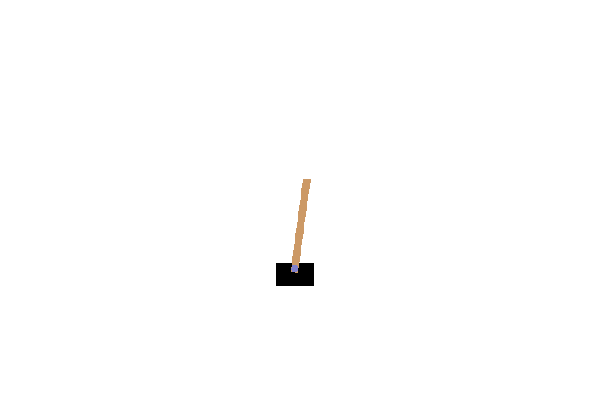
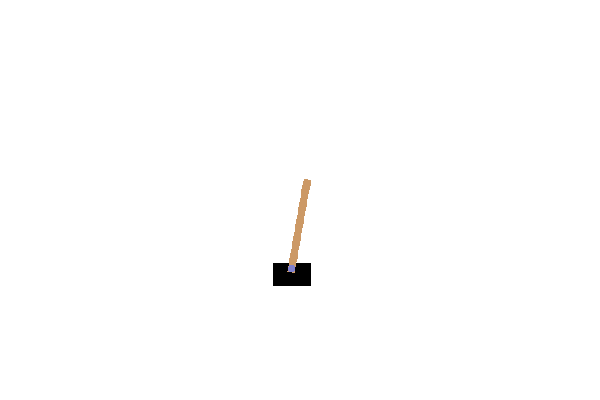
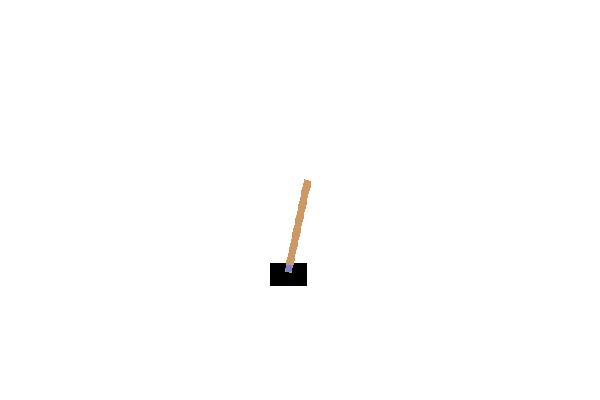
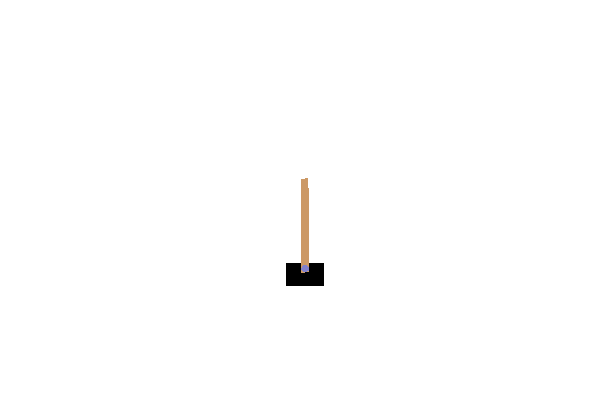
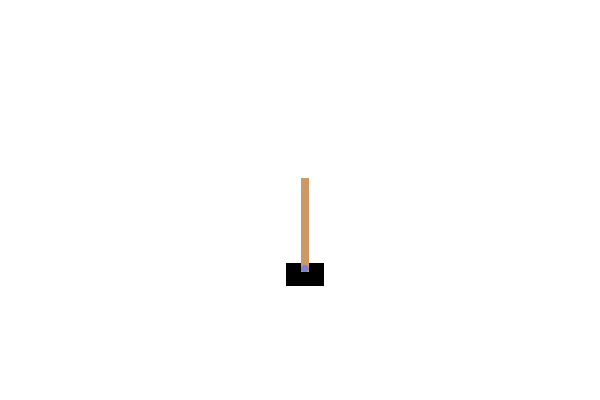
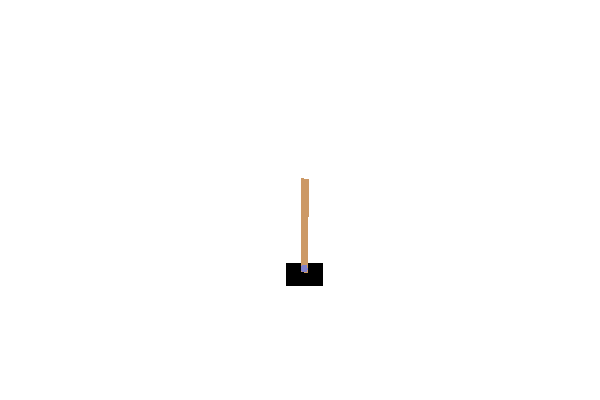
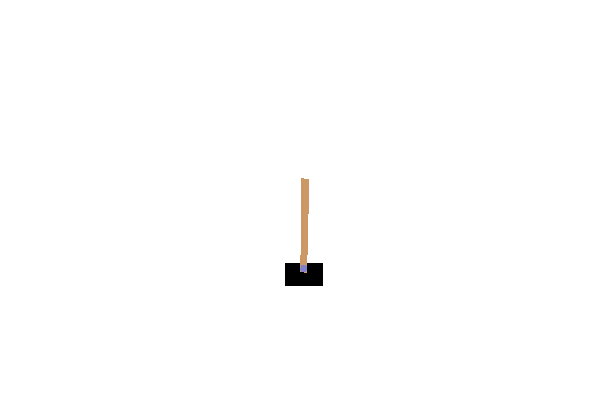
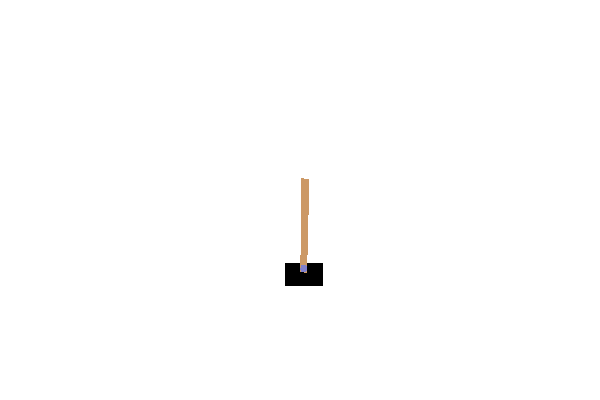
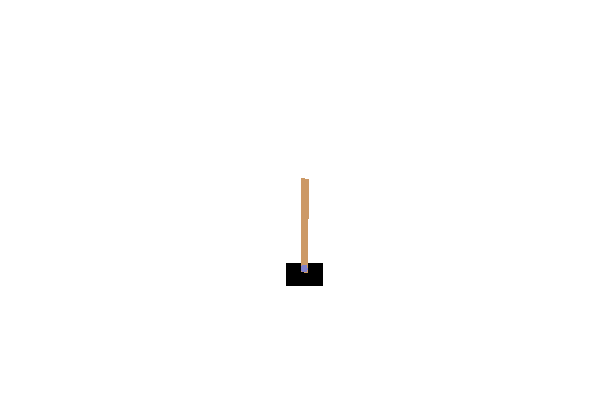
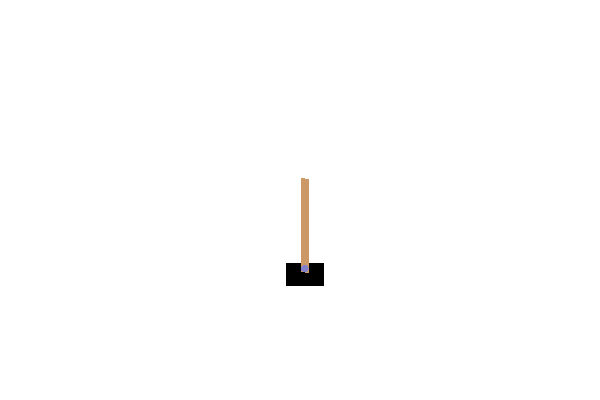
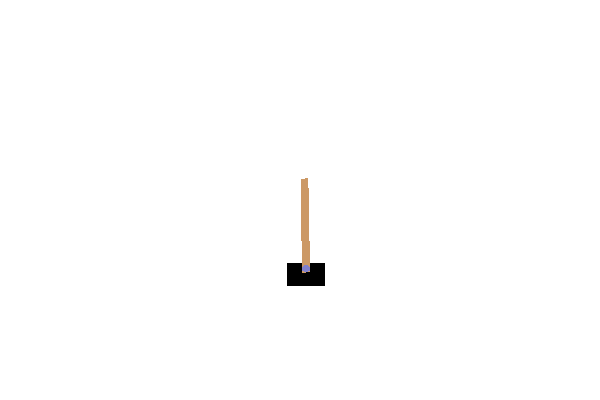
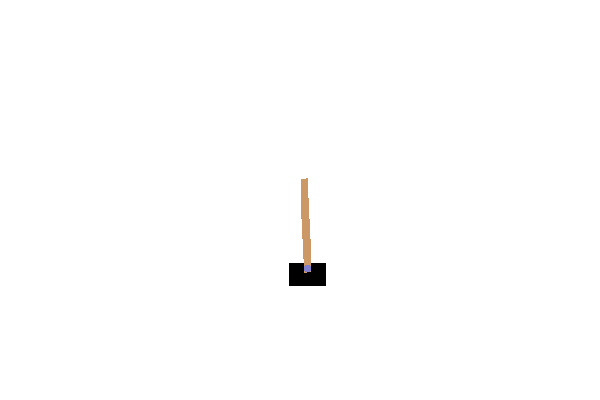
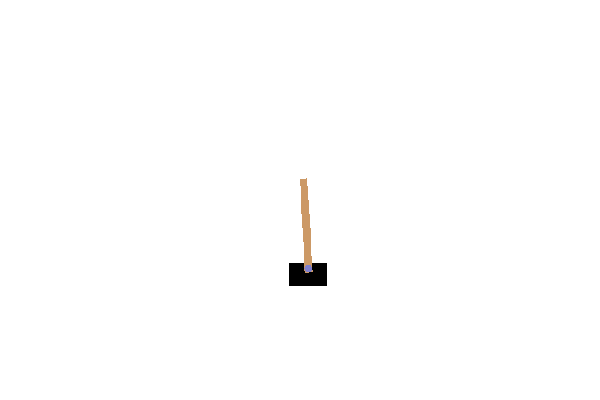
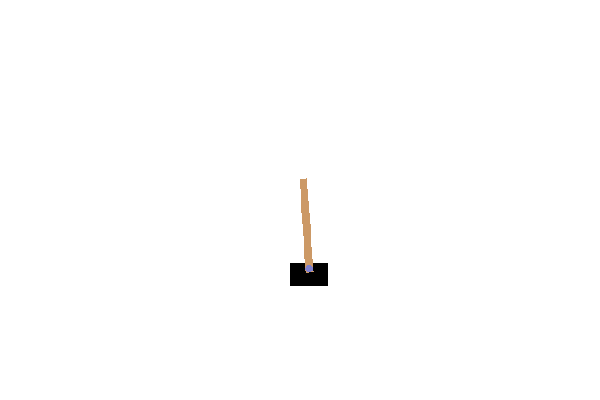
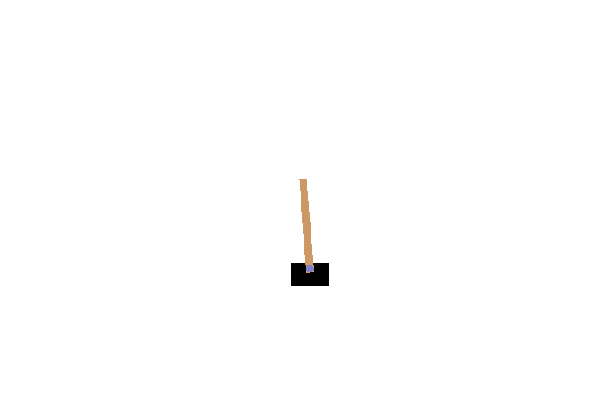
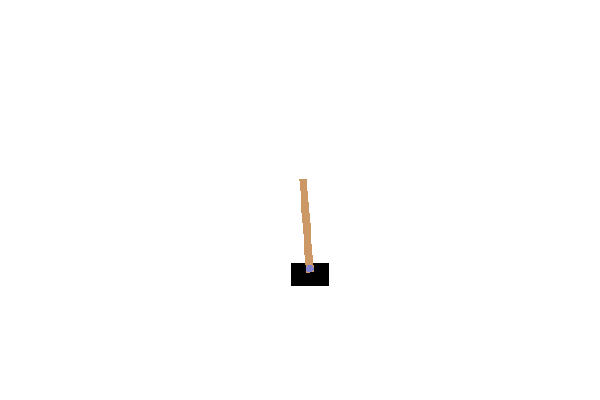
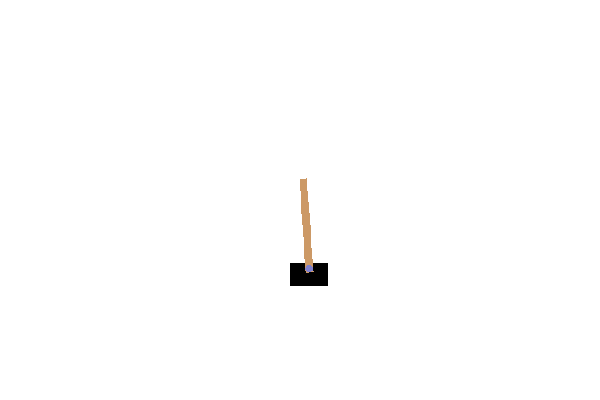
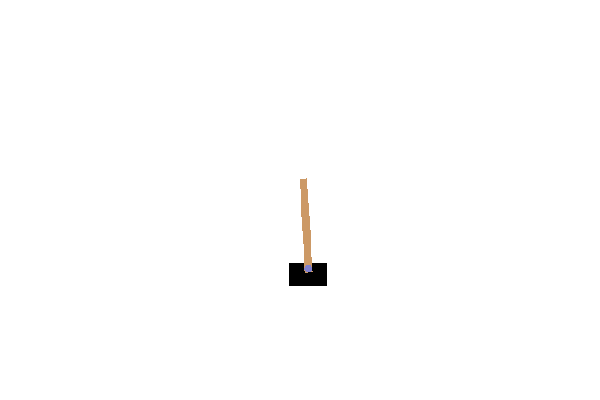
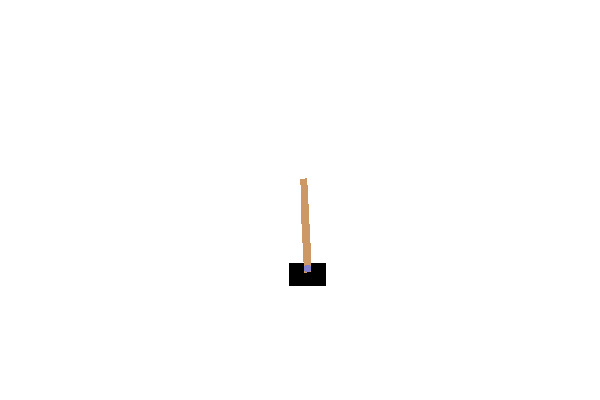
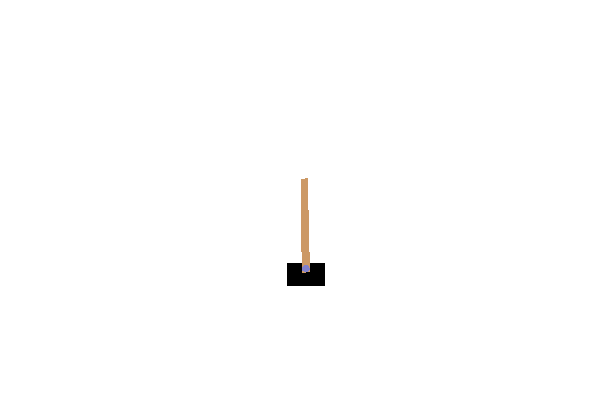
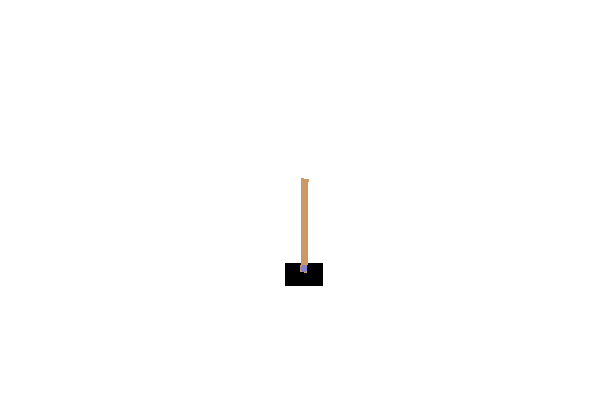
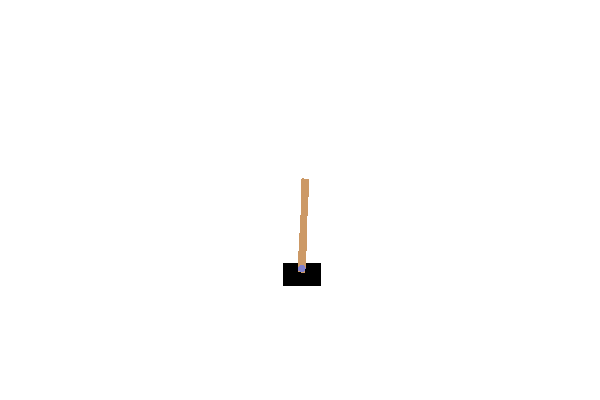
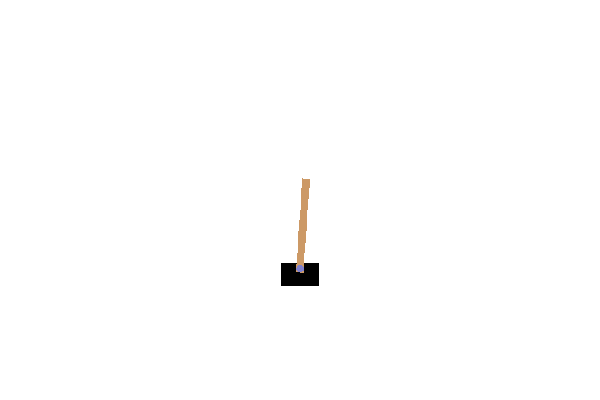
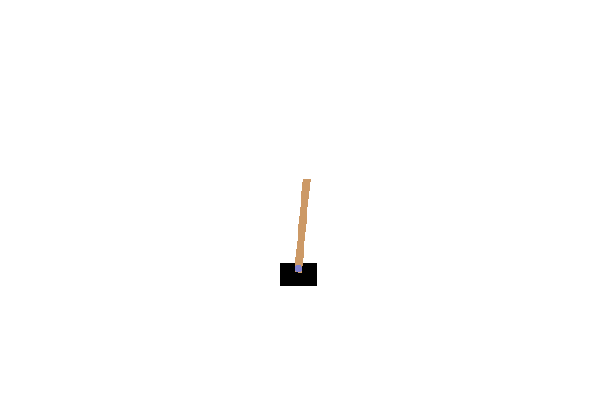
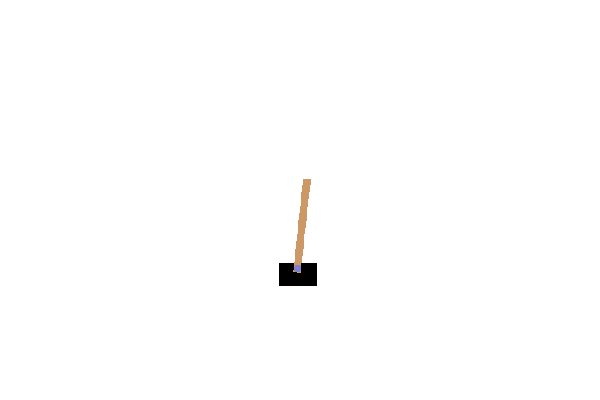
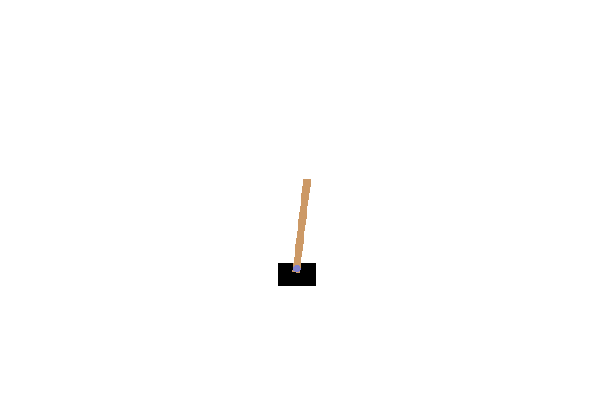
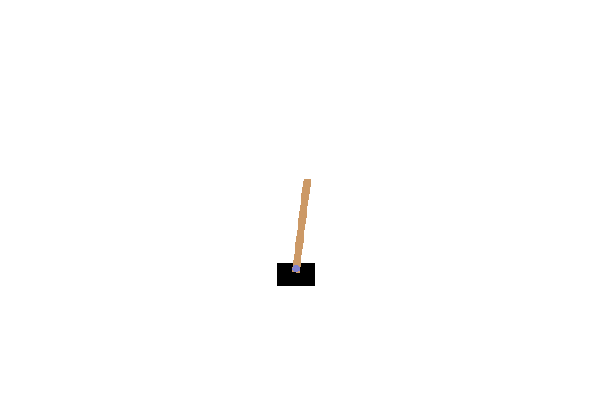
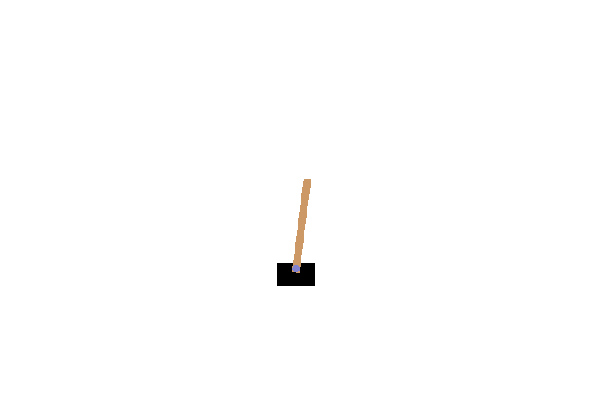
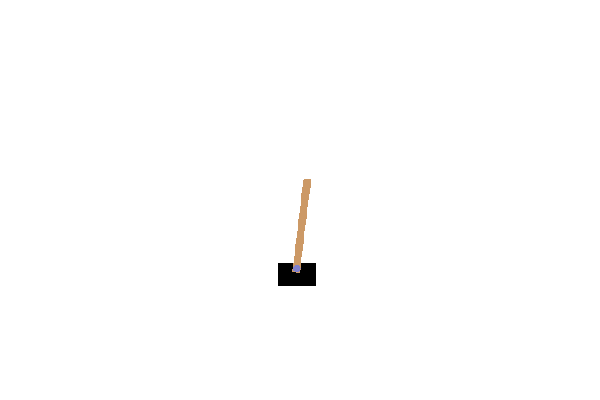
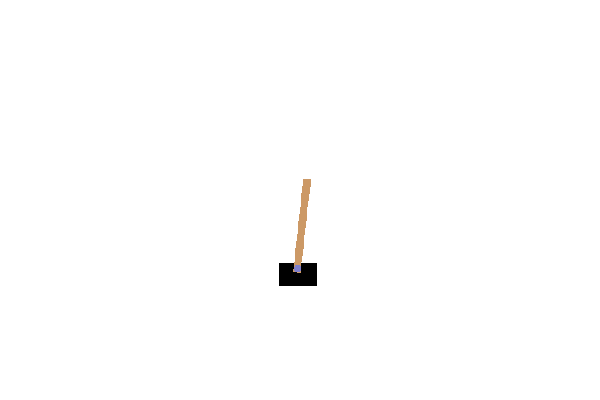
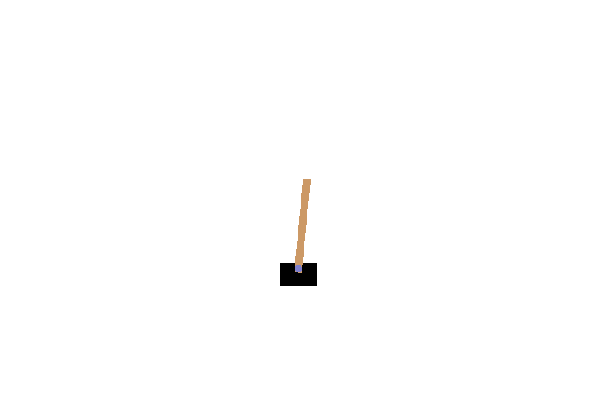
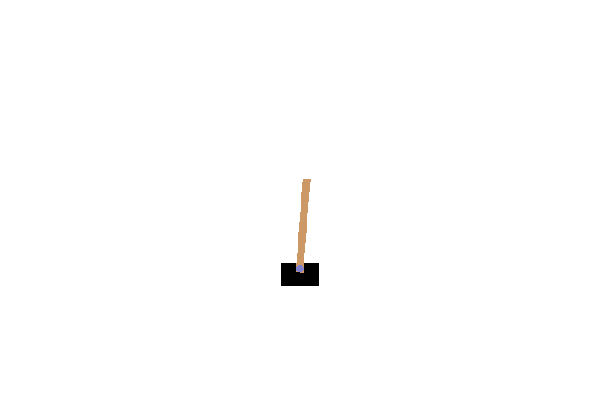
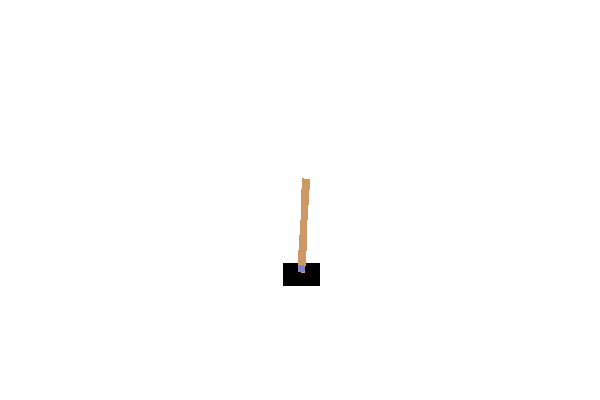
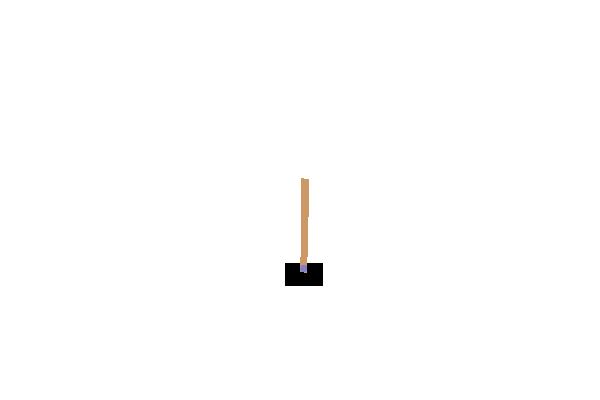
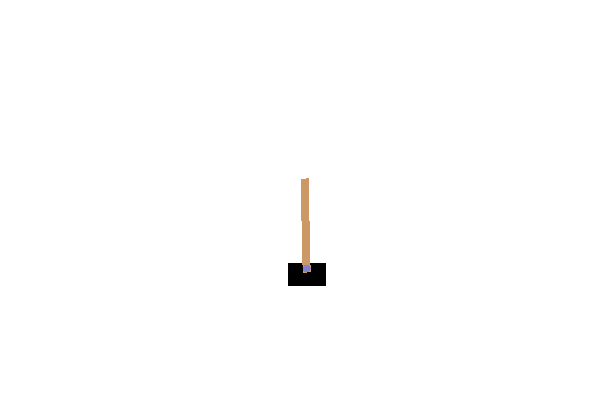
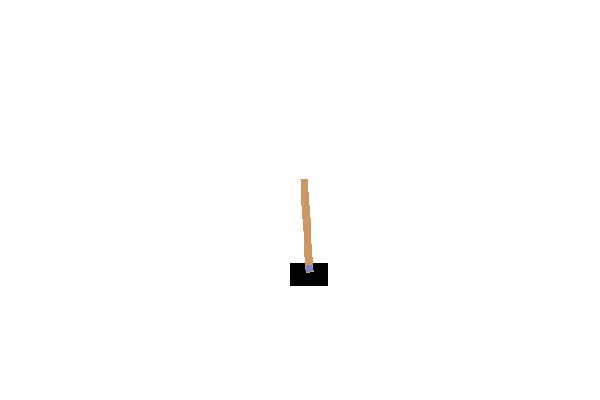
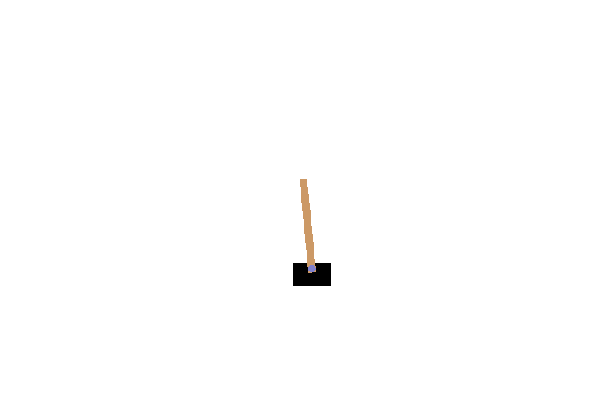
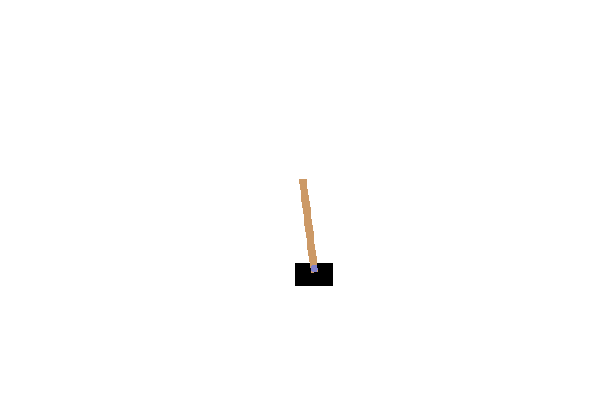
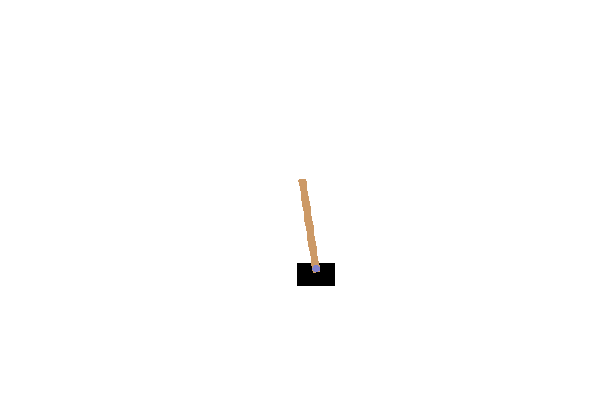
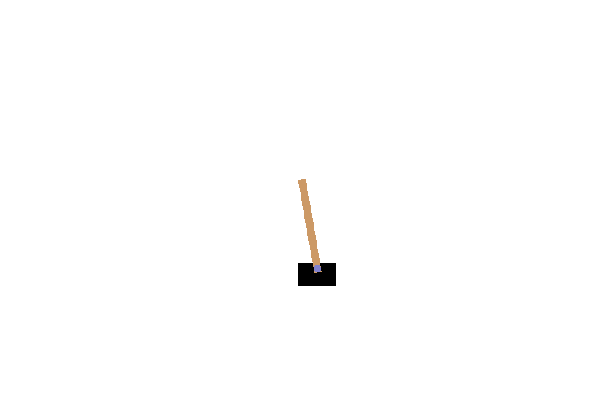
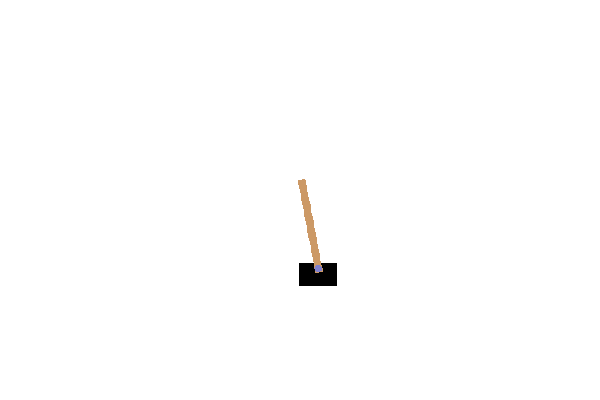
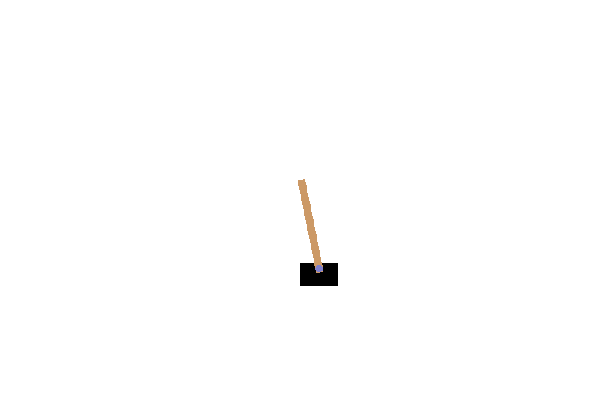
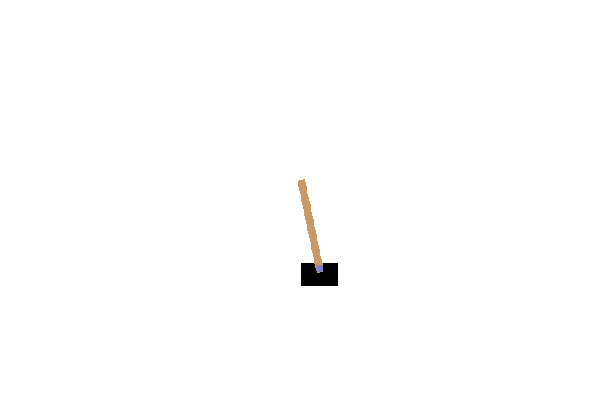
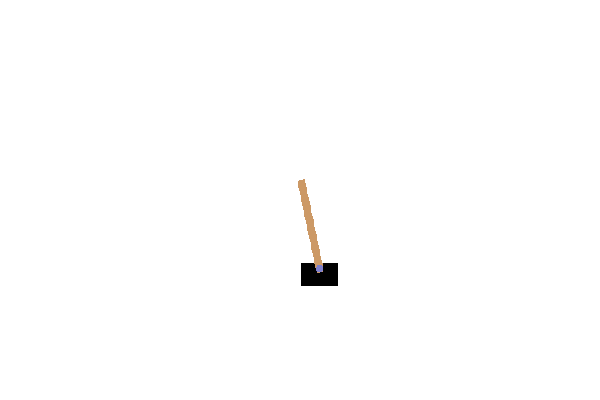
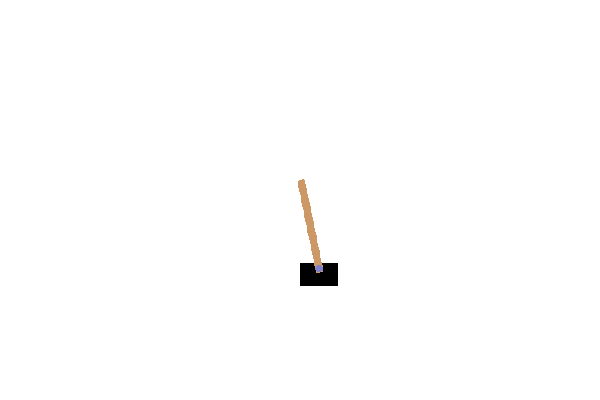
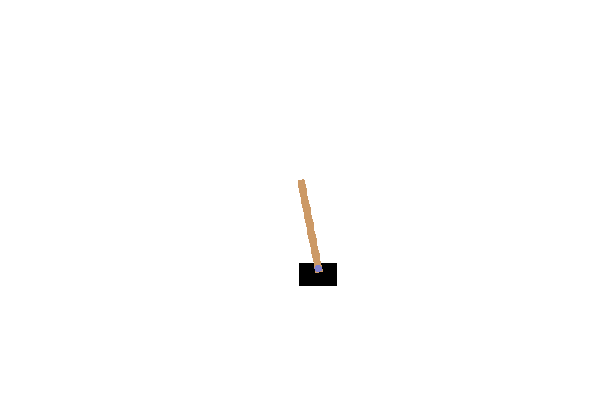
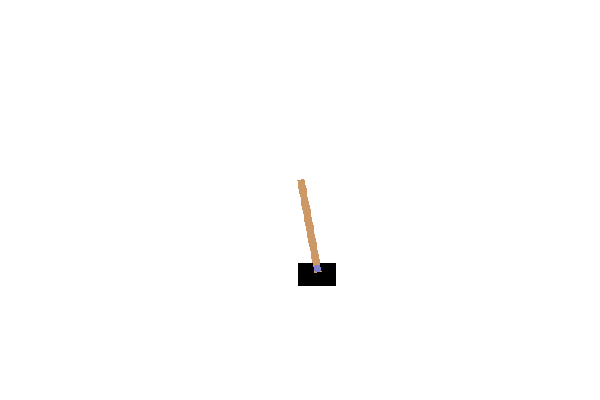
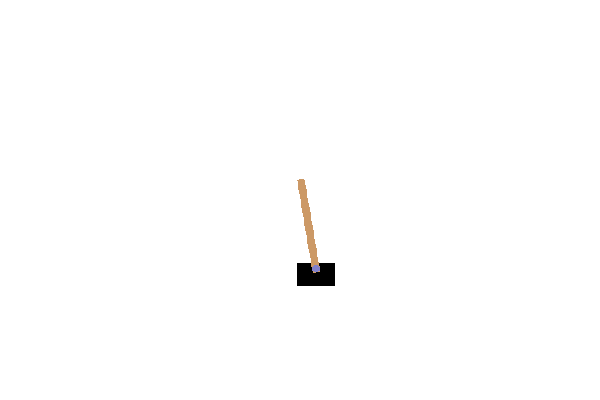
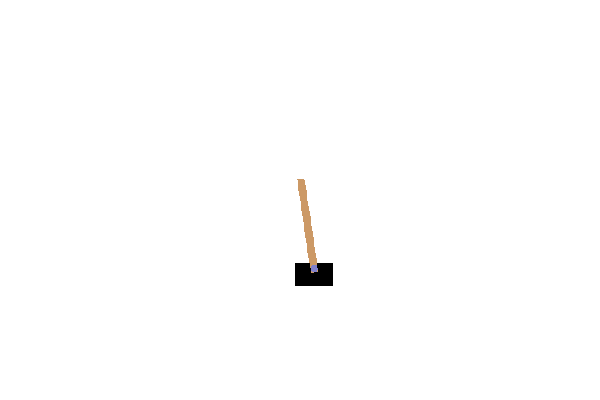
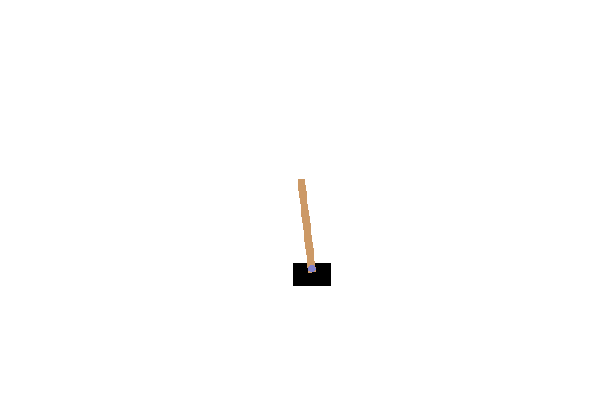
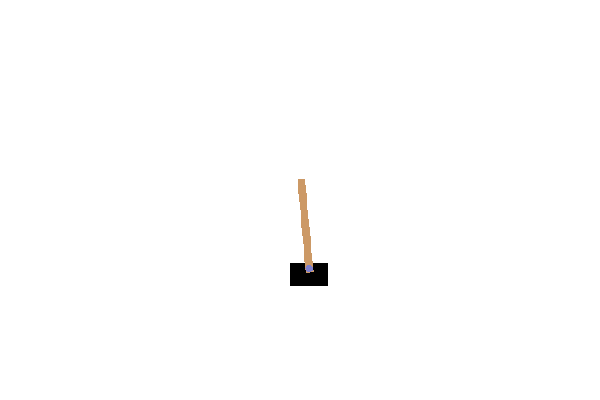
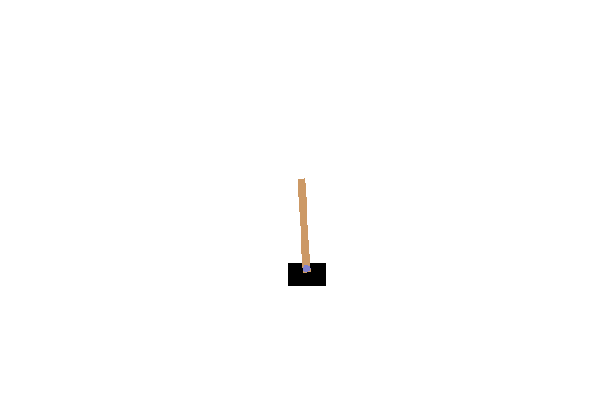
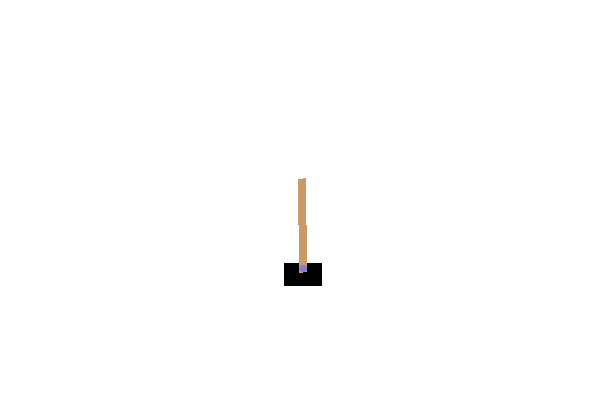
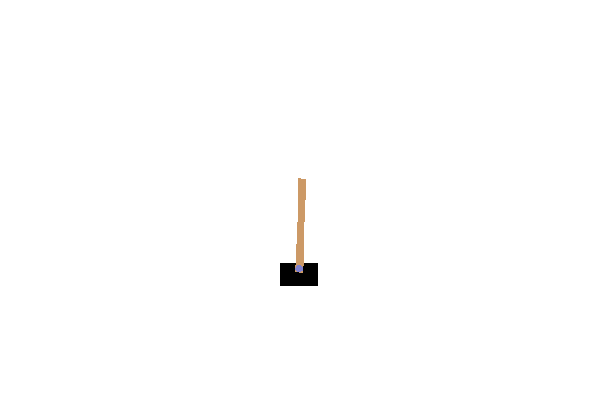
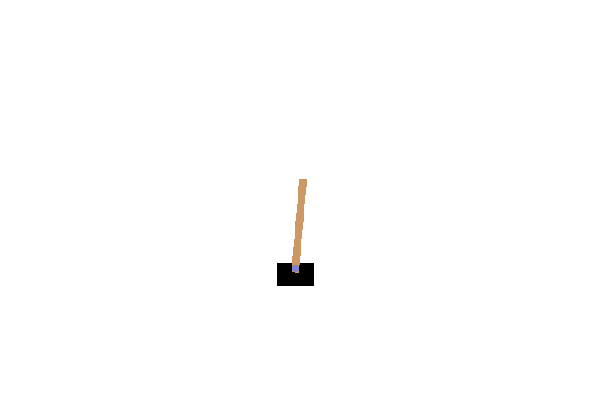
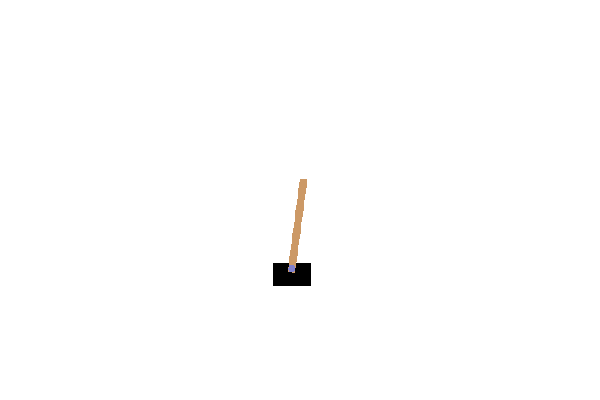
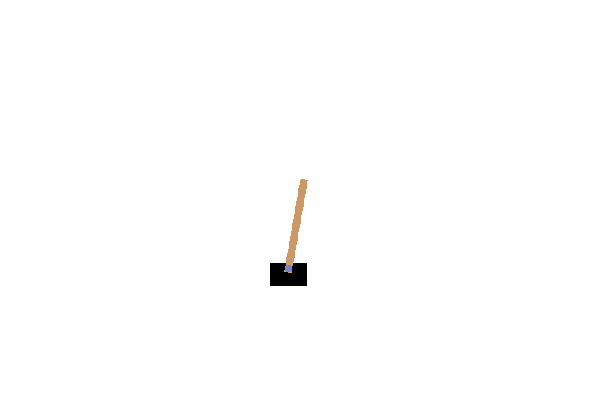
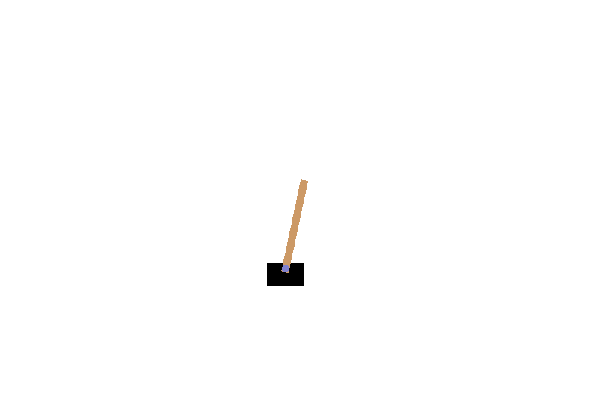

In [27]:
n_iter = 10

frames = []

for t in range(n_iter):
    # Render into buffer. 
    # You will still see the window.
    obs = env.reset()
    done = False
    while not done:
        action = deflection_policy(obs)
        env.render()
        obs, reward, done, info = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
env.render(close=True)

display_frames_as_gif(frames)

It appears that in some cases the top end of the pole is not moving very much, but the actions on the cart are leading to large enough displacement to pass the threshold.  In other cases, the top of the pole makes a large deviation.  In all cases, preceding the failure, the cart has made a number of steps in the same direction.  So this policy tends to overcorrect badly. 

Let's consider a policy that instead acts oppositely to the angular velocity of the pole.

In [28]:
def angvel_policy(obs):
    angvel = obs[3]
    action = 0
    if (angvel > 0):
        action = 1
    return action

In [29]:
(mean_reward, std_reward, max_reward, min_reward) = run_episodes(cartpole_episode, angvel_policy, 1000)
print("Mean/standard deviation of rewards was:", 
      format(mean_reward, '.2f'), 
      "+/-", 
      format(std_reward, '.2f')
     )
print("Max reward was:", max_reward)
print("Min reward was:", min_reward)

Mean/standard deviation of rewards was: 182.68 +/- 21.57
Max reward was: 200.0
Min reward was: 130.0



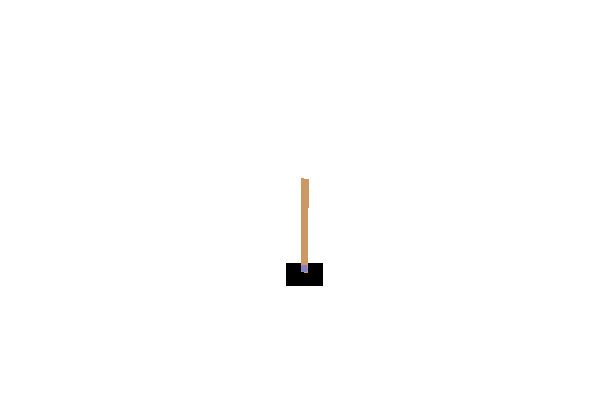
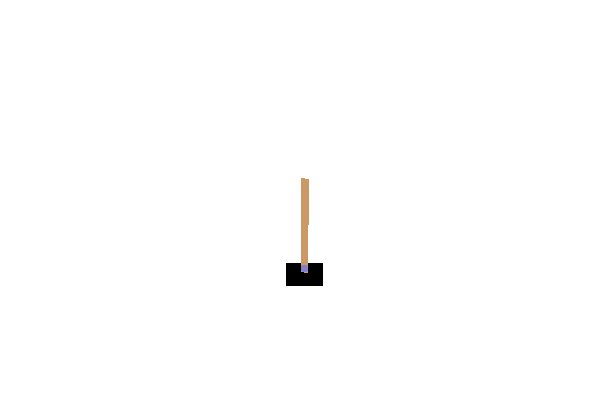
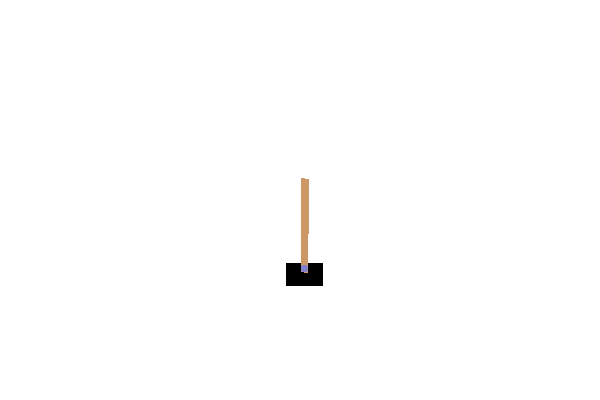
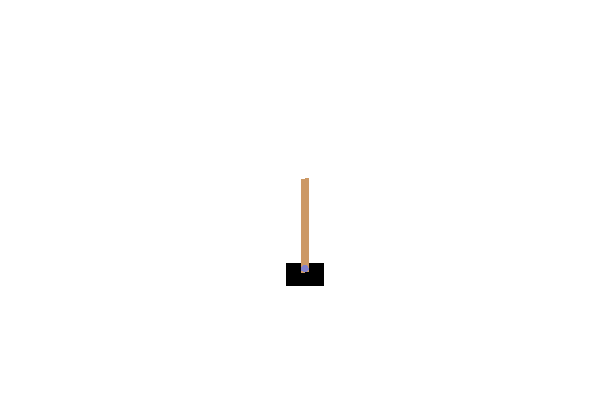
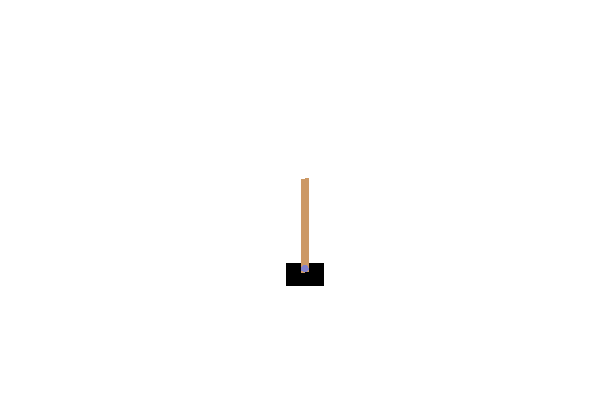
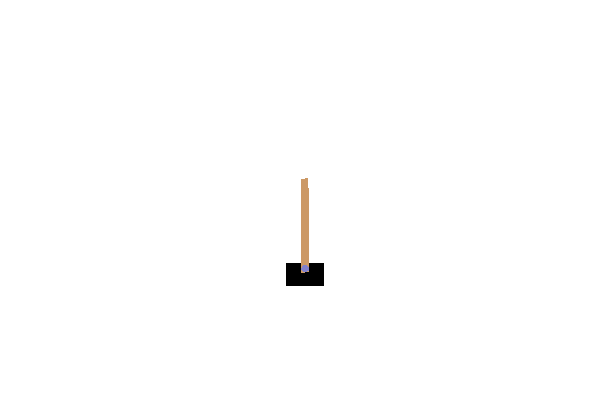
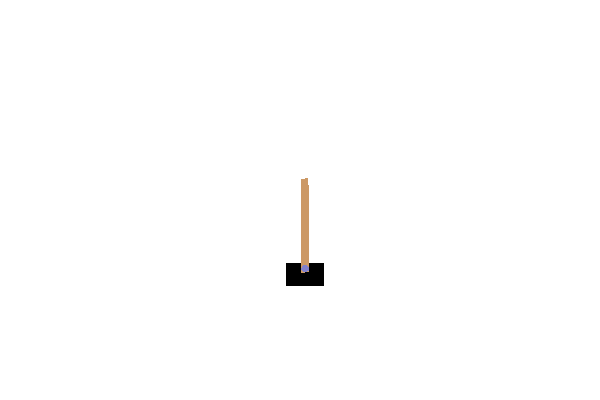
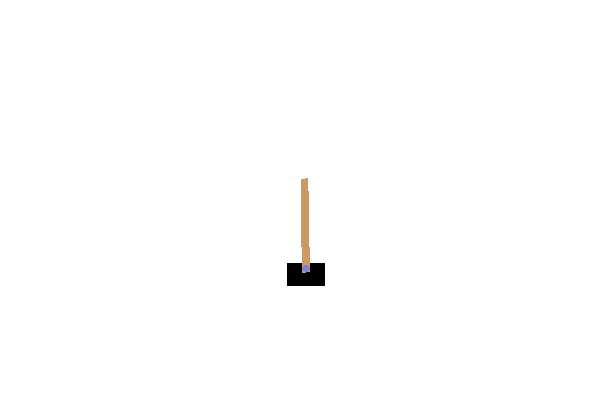
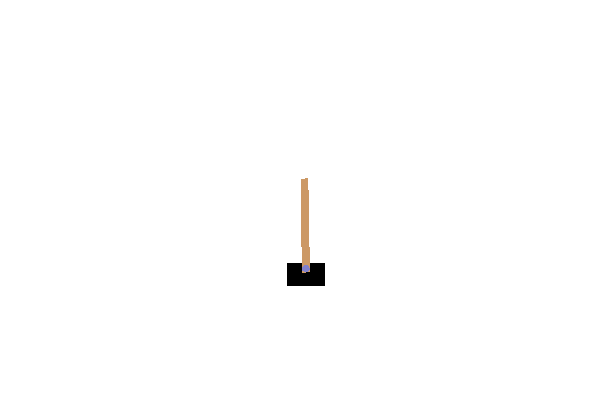
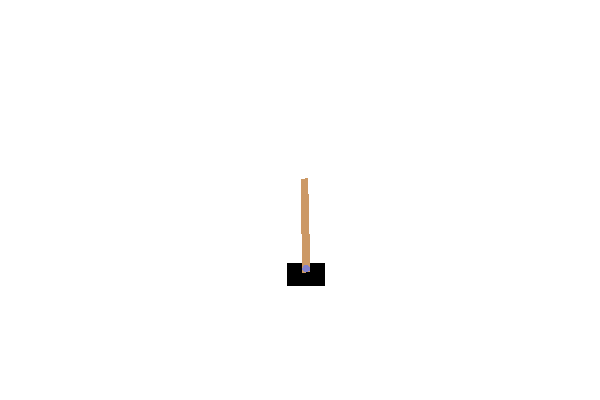
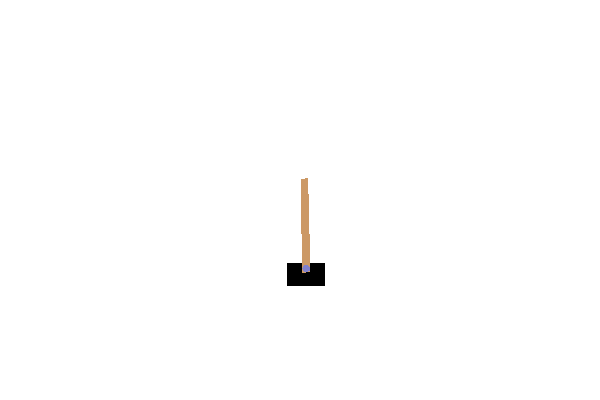
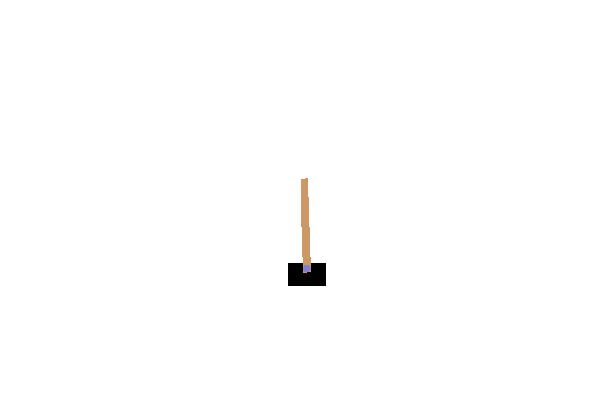
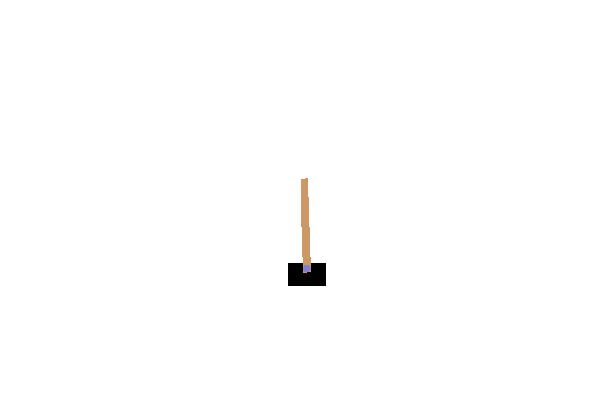
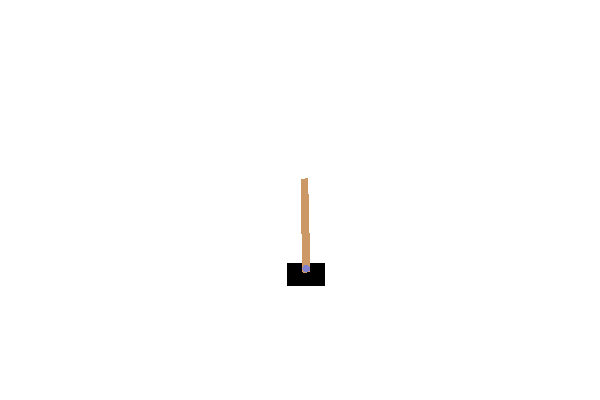
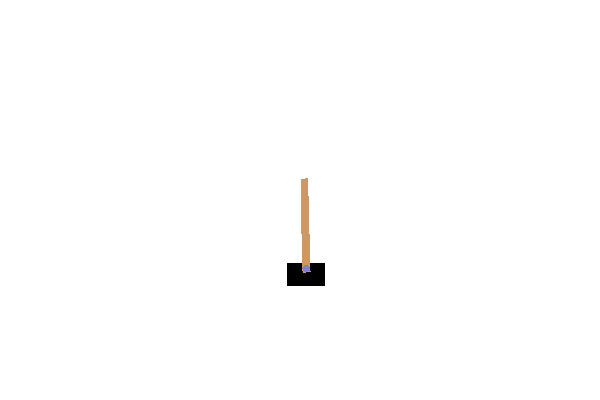
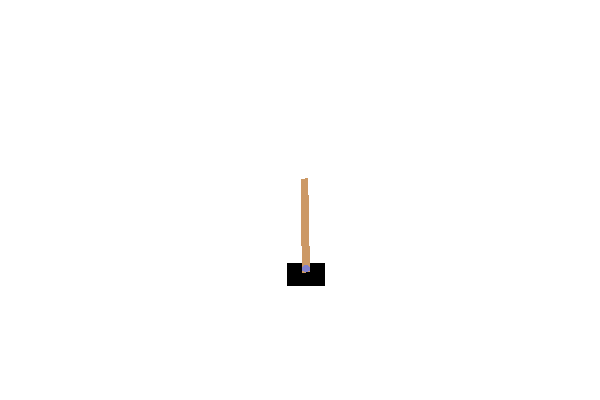
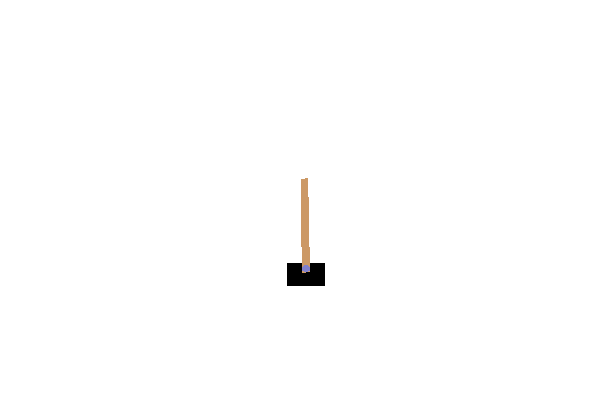
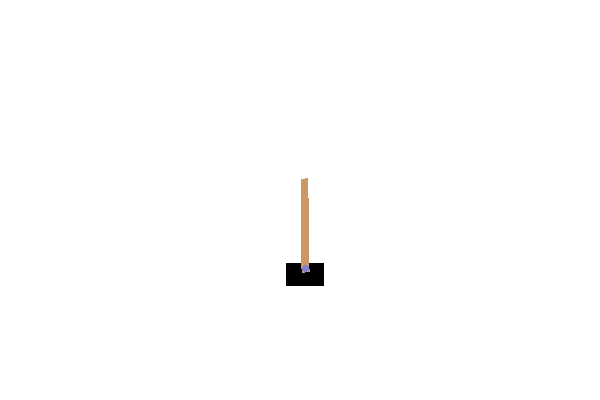
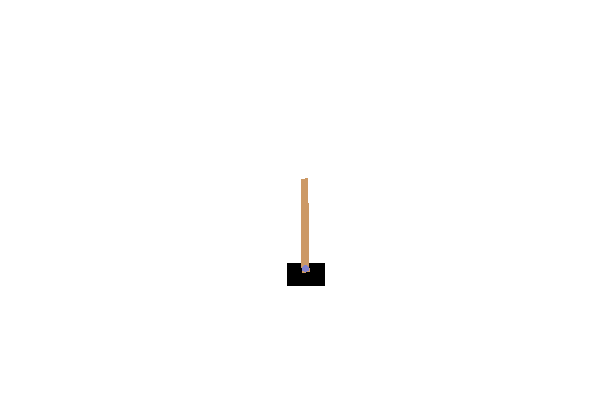
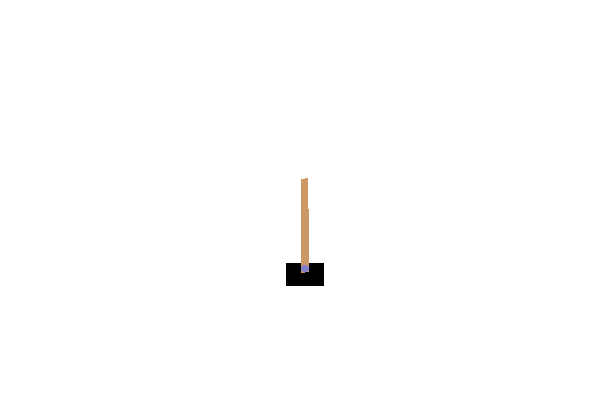
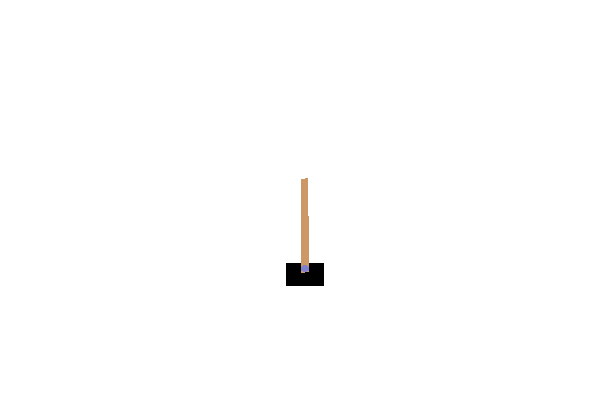
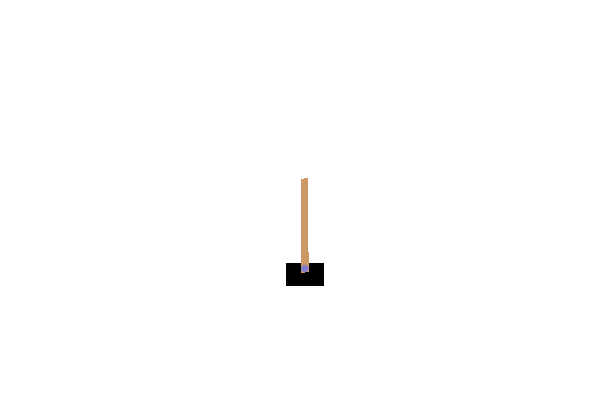
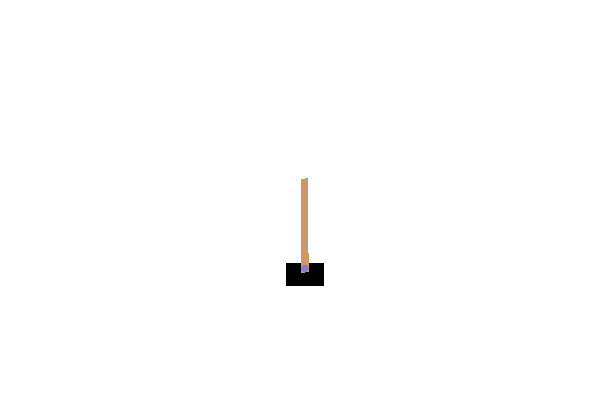
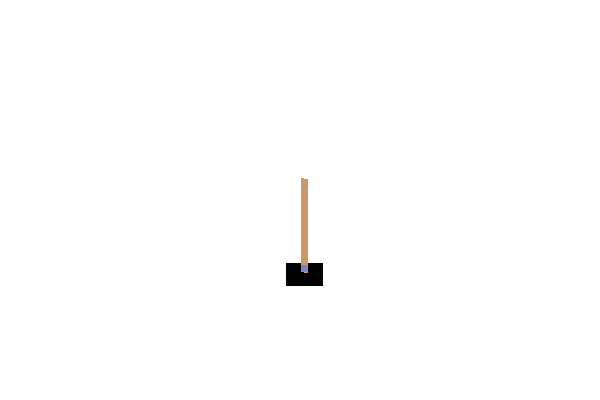
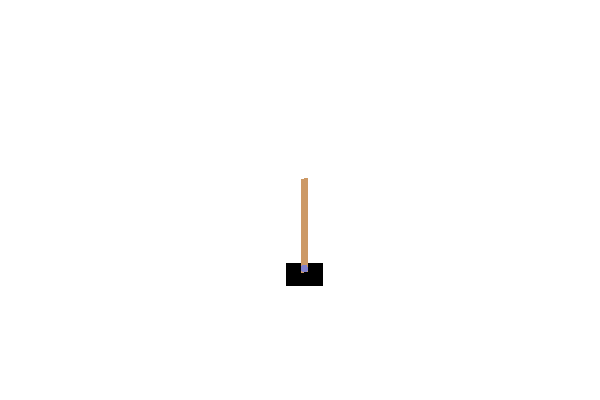
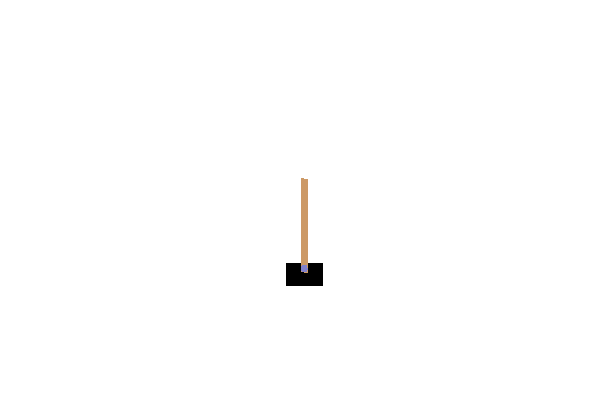
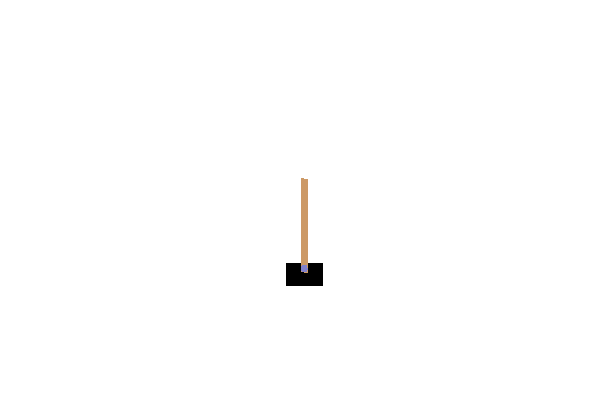
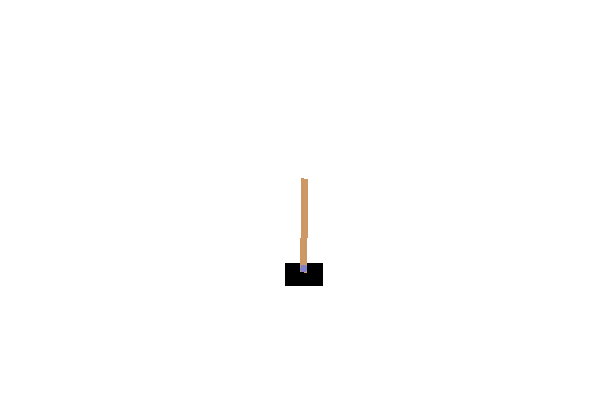
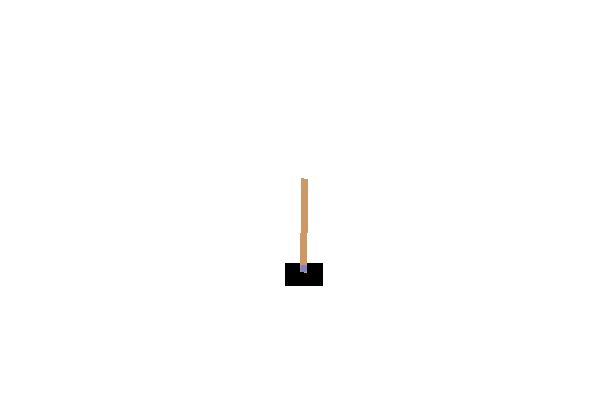
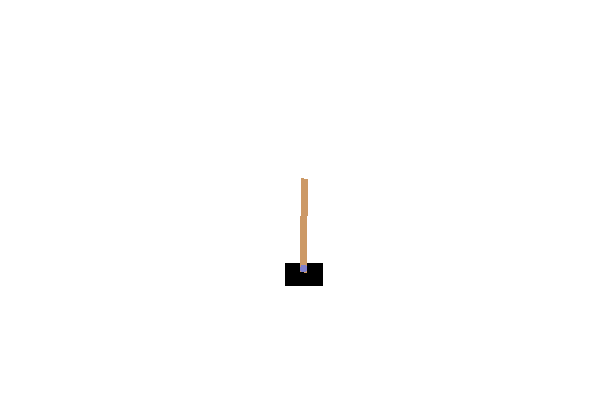
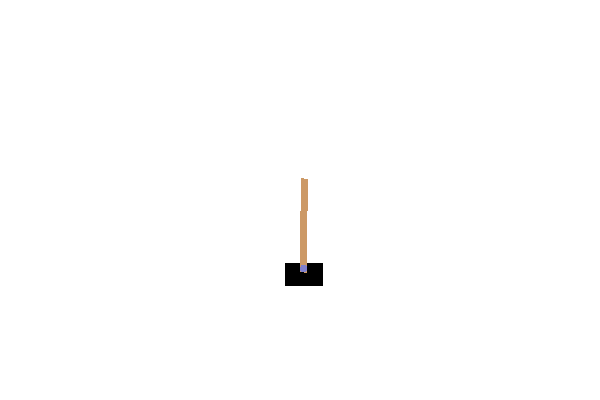
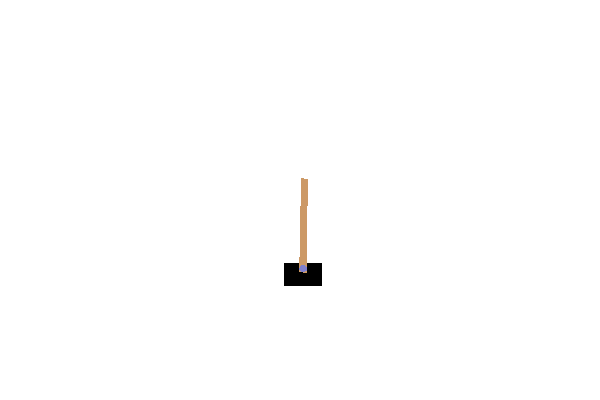
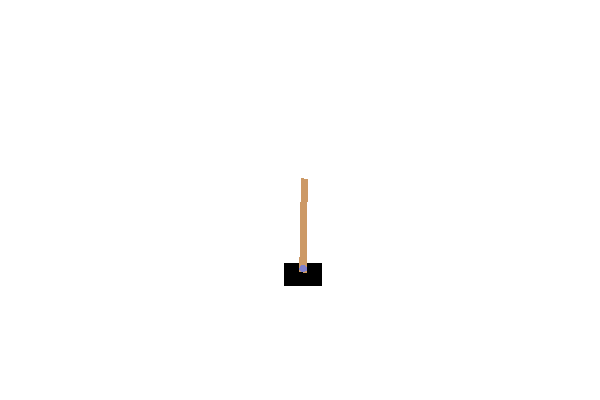
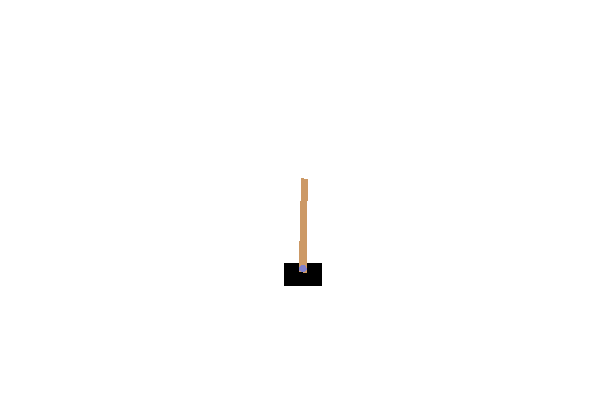
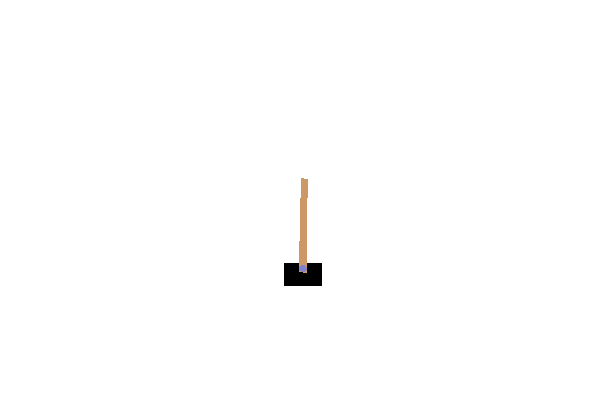
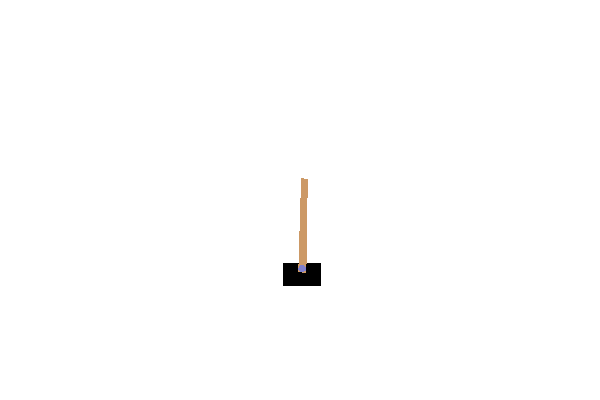
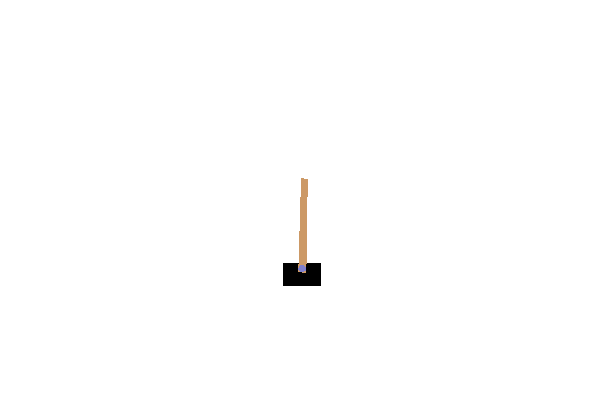
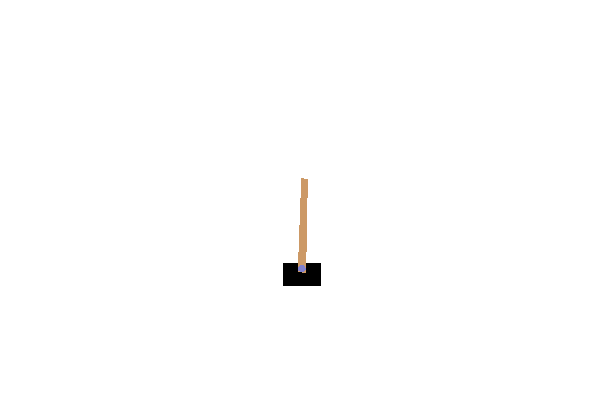
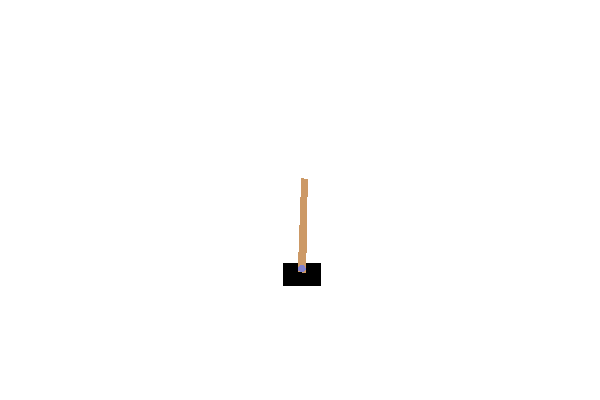
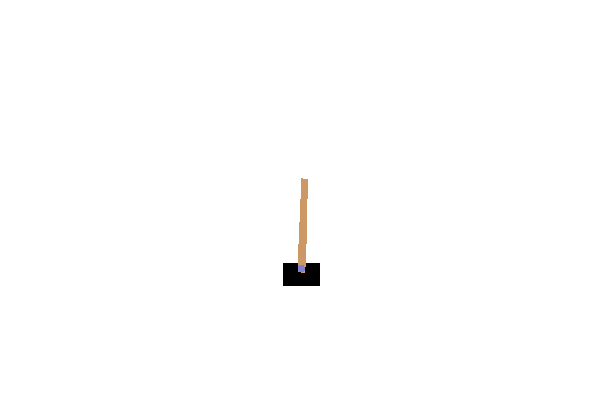
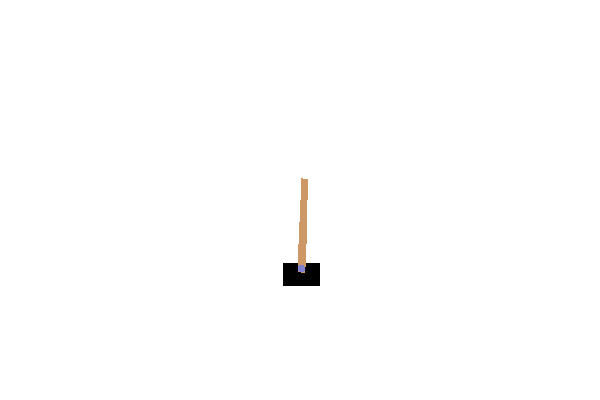
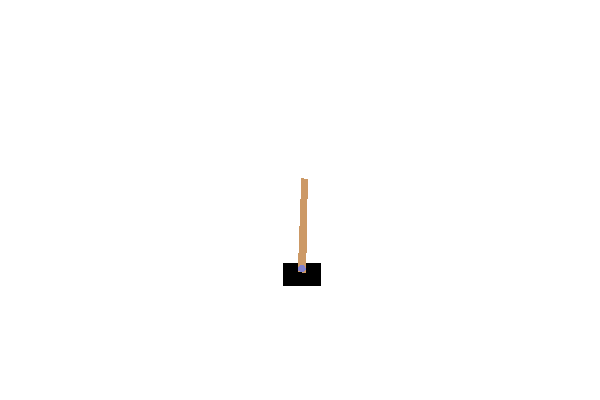
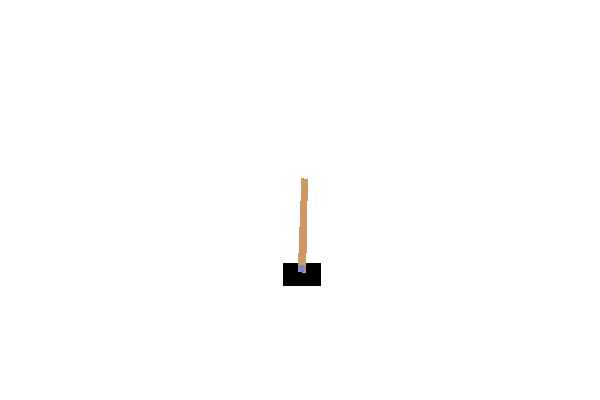
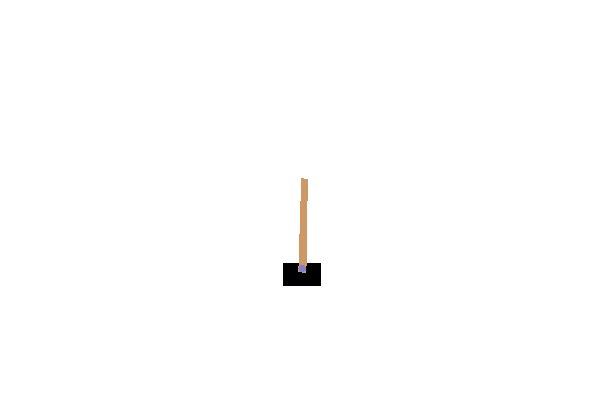
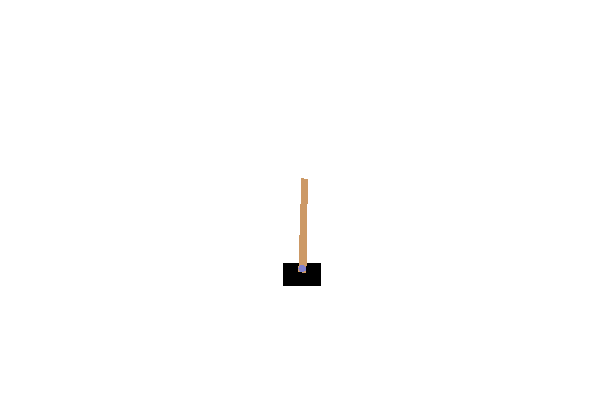
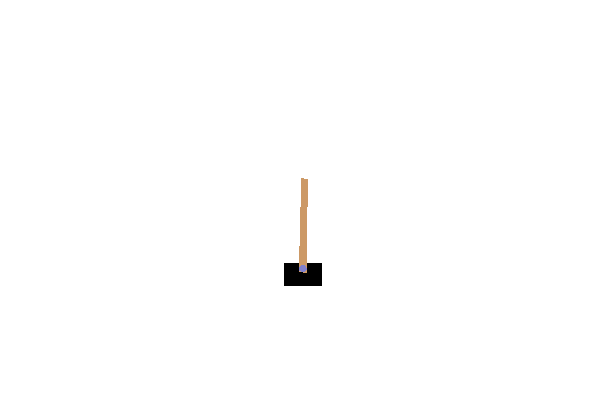
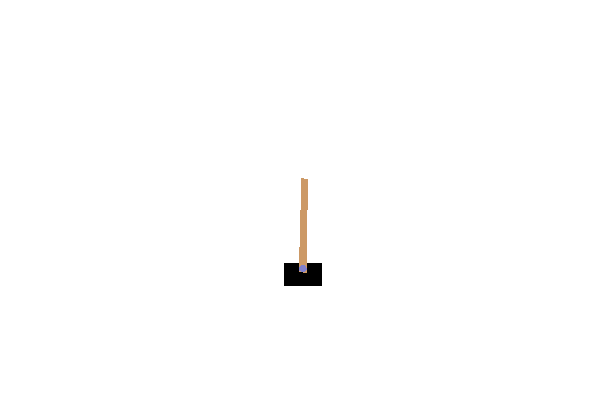
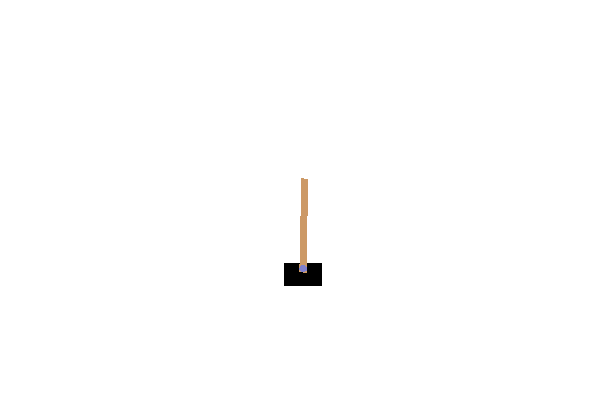
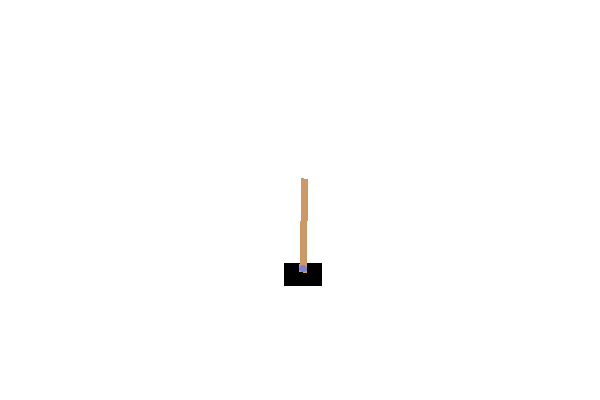
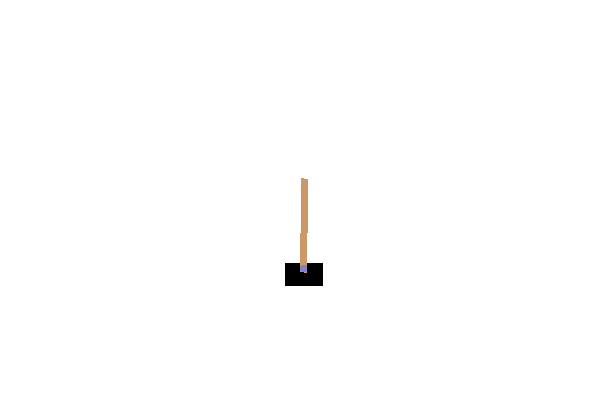
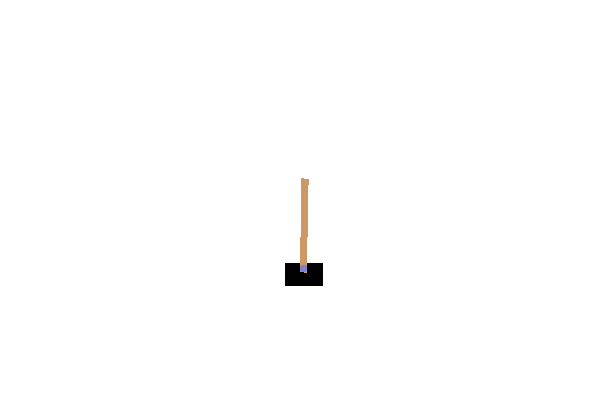
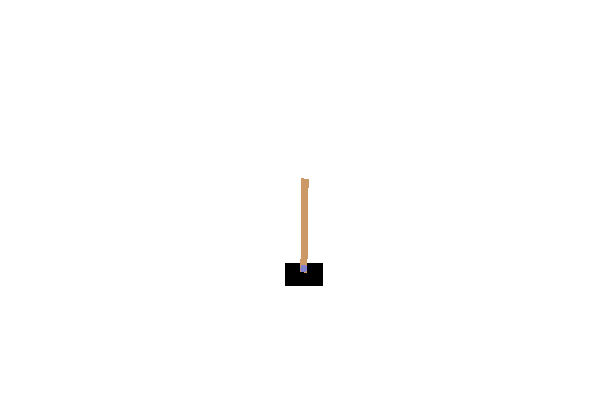
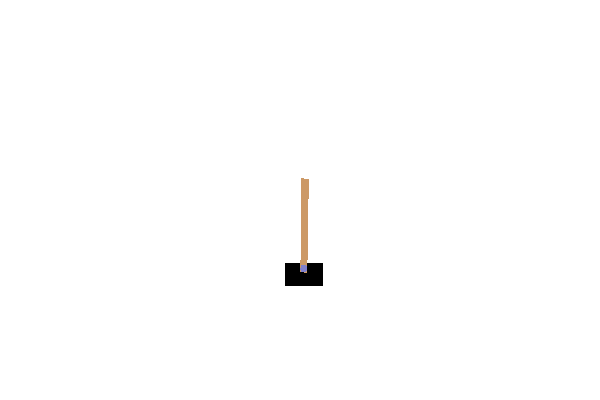
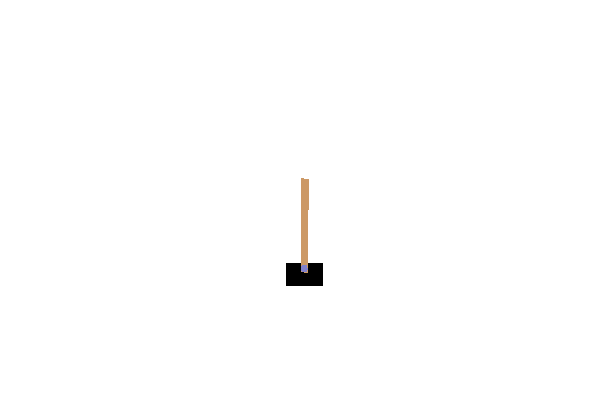
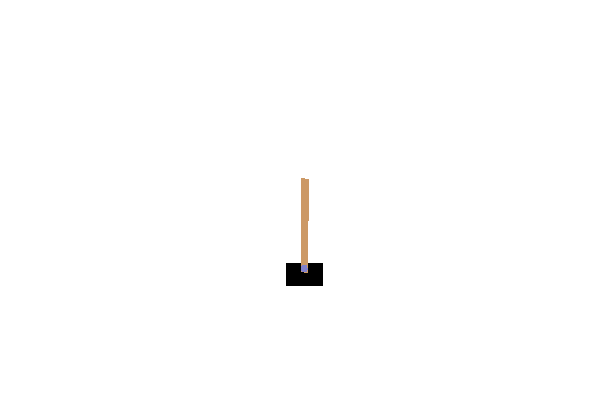
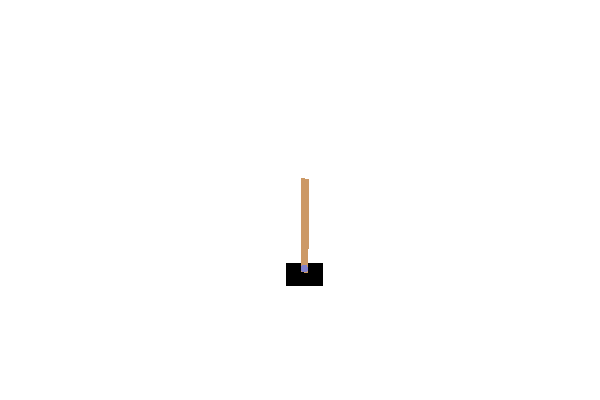
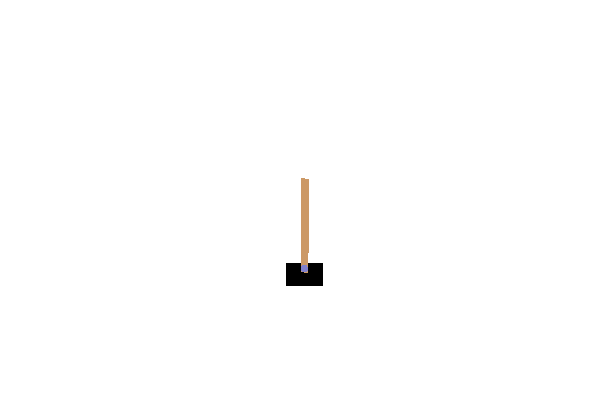
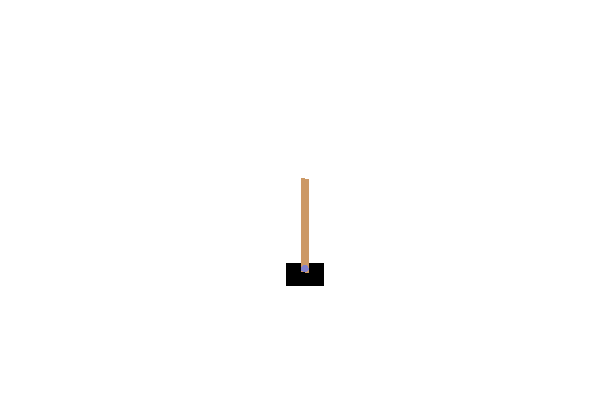
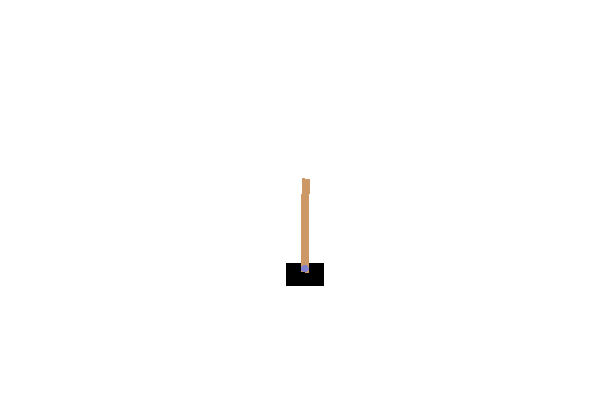
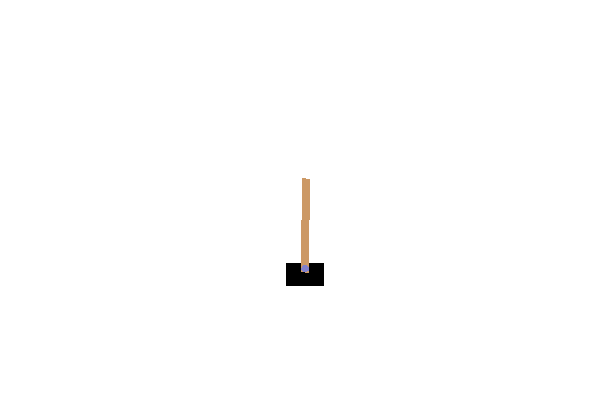
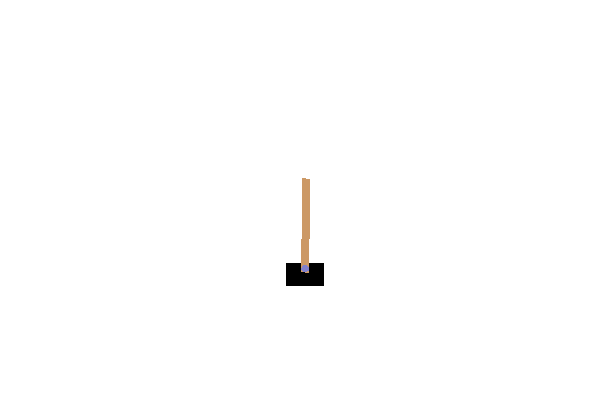
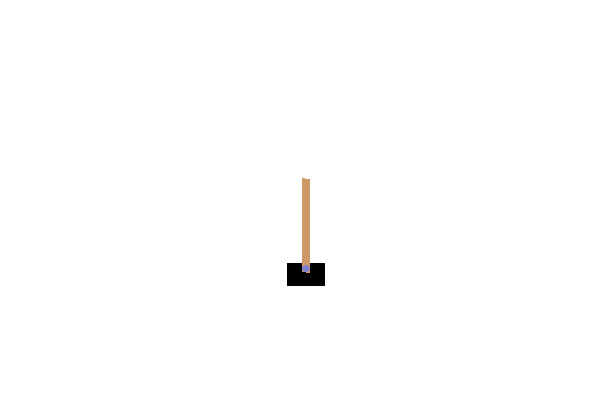
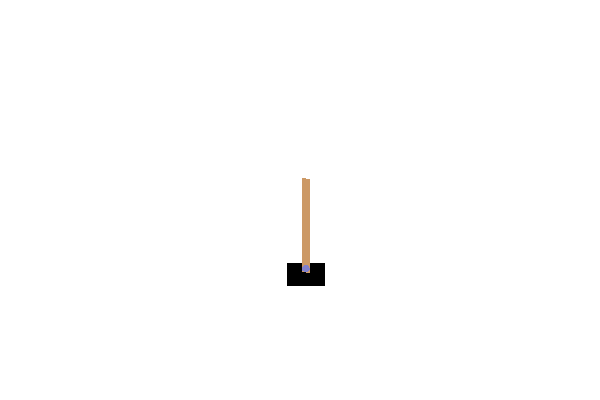
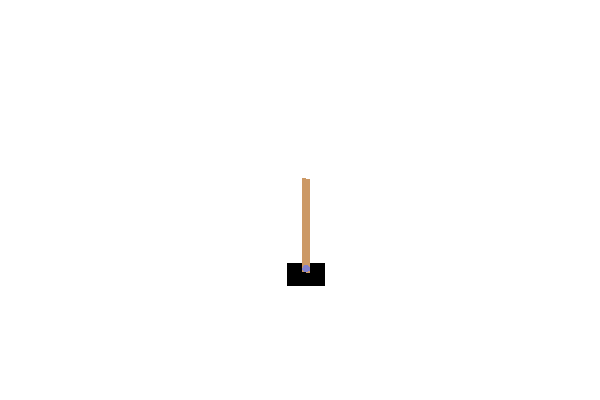
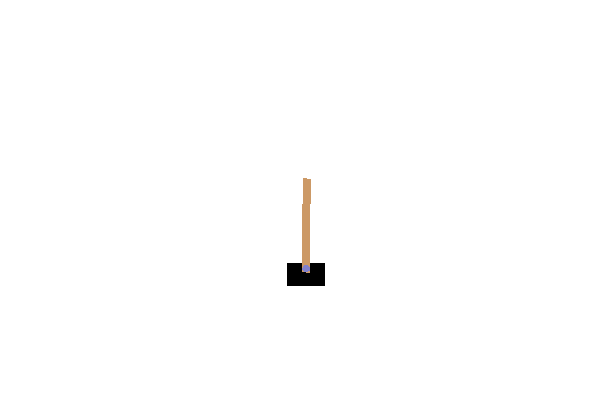
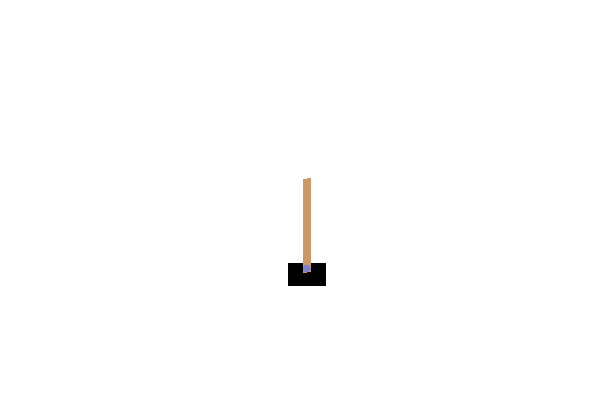
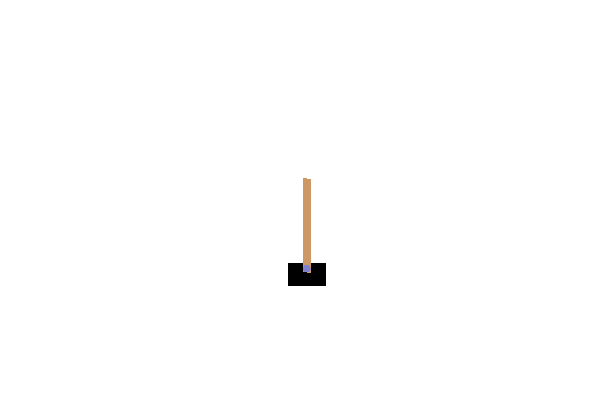
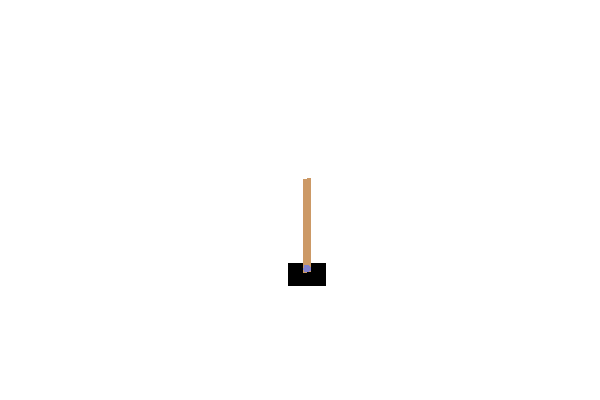
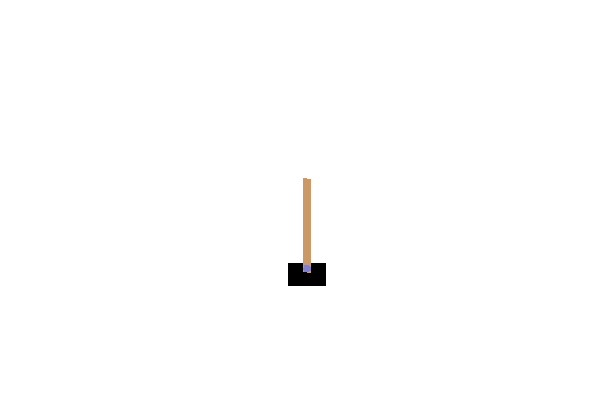
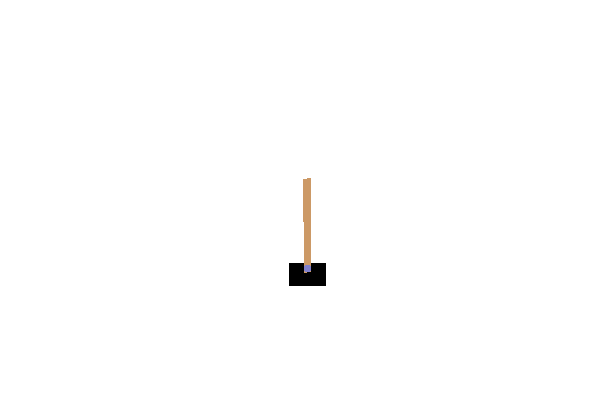
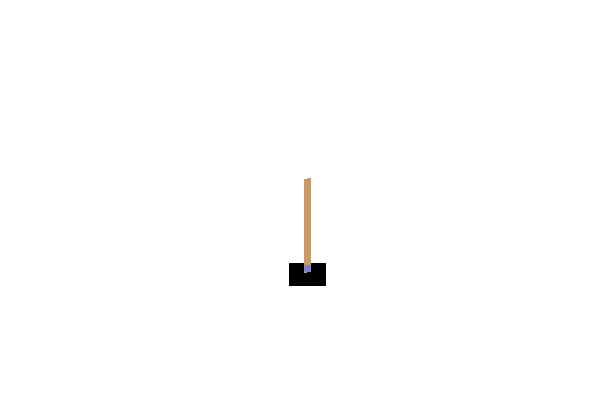
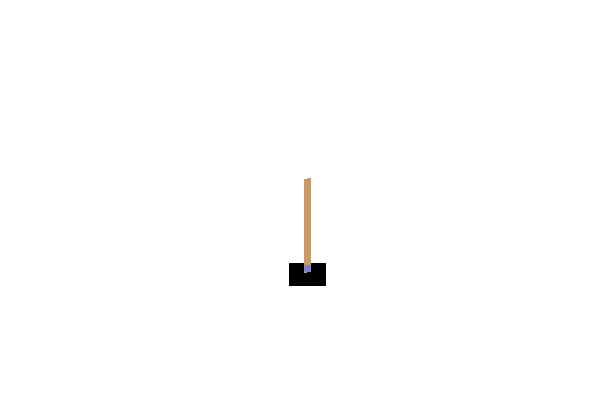
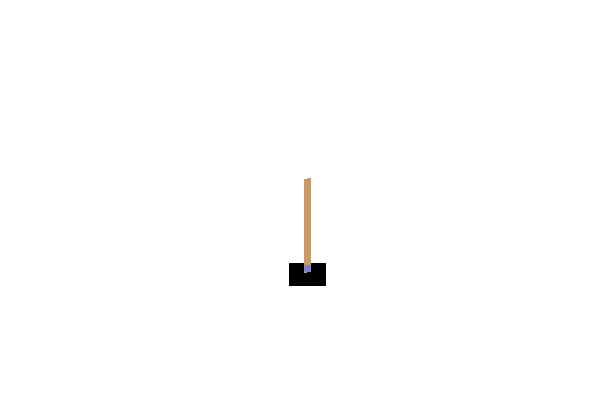
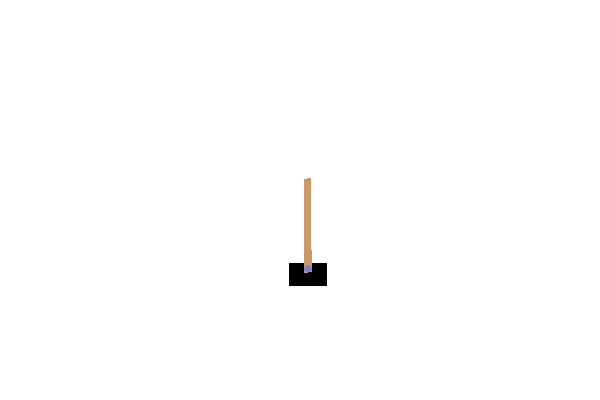
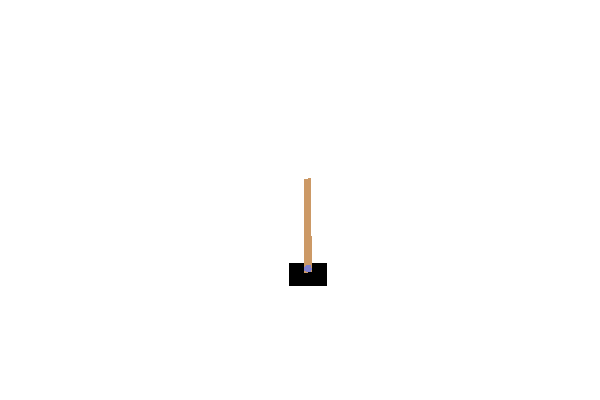
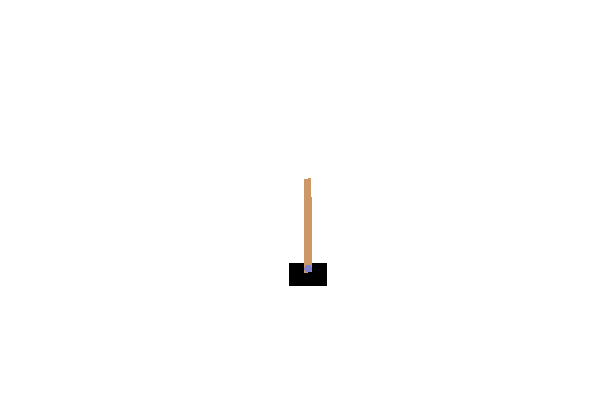
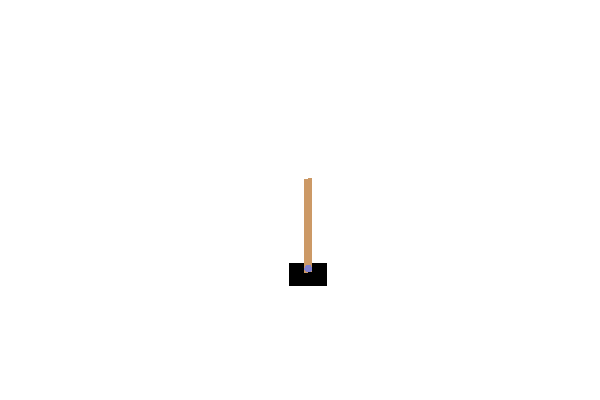
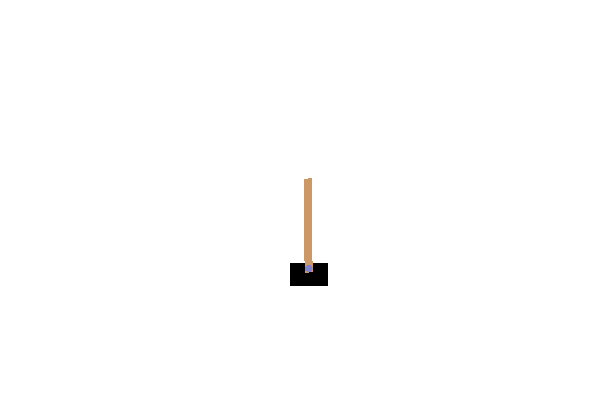
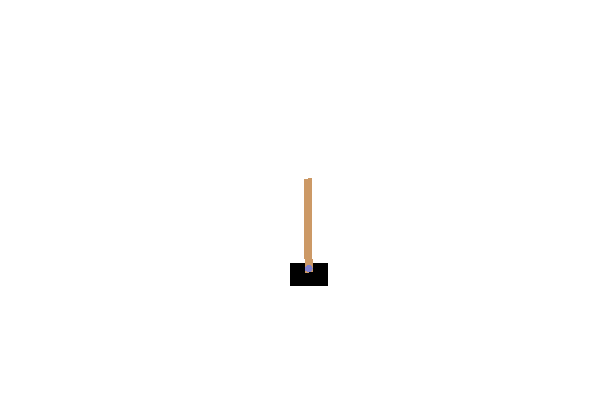
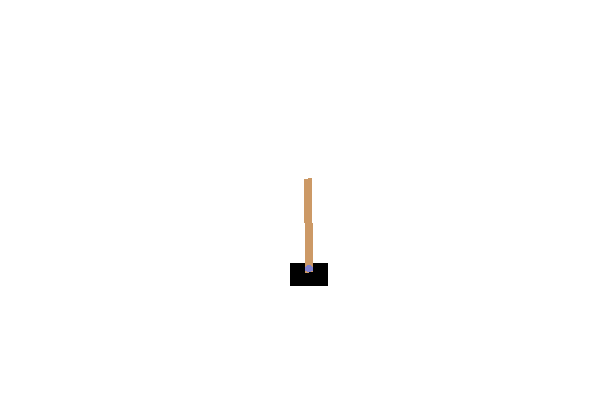
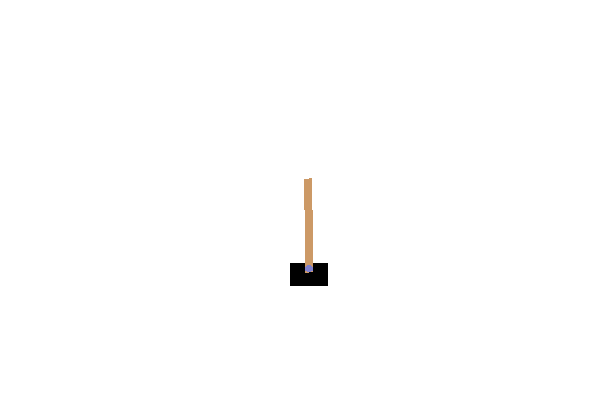
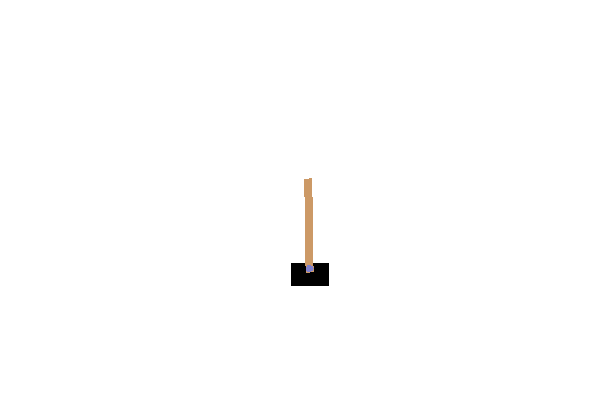
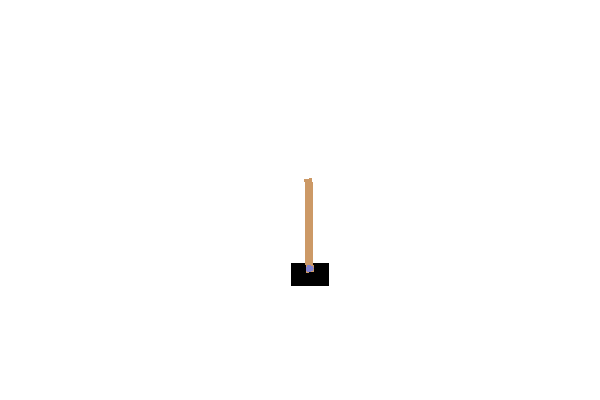
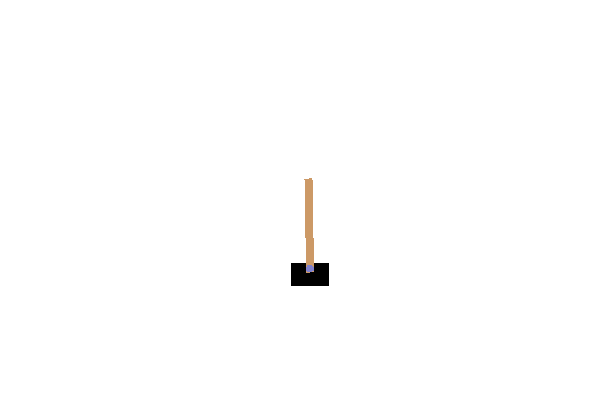
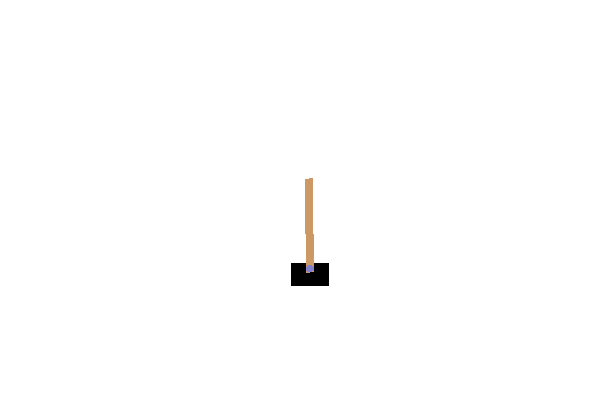
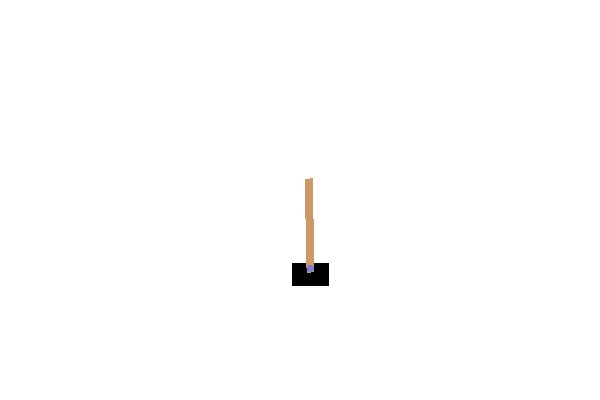
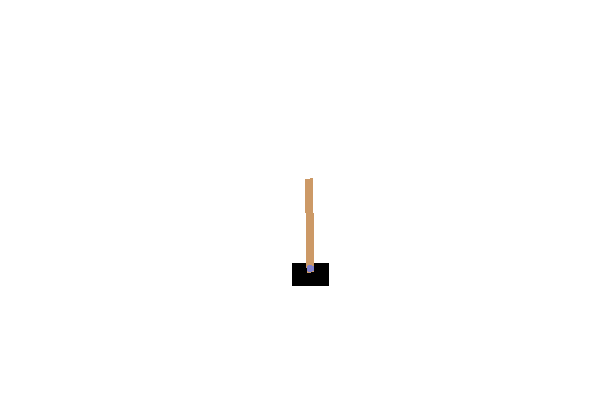
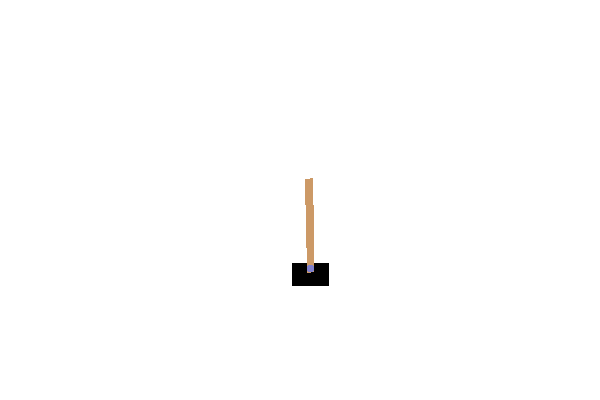
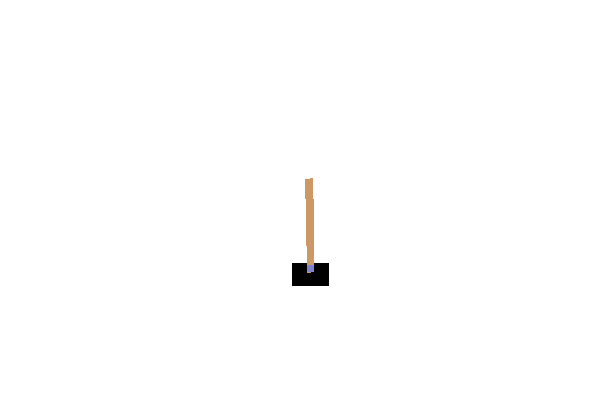
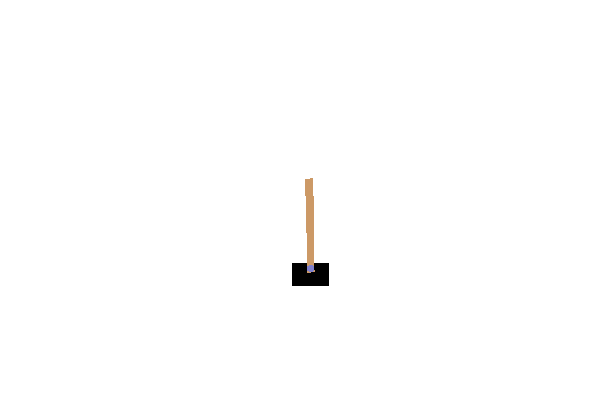
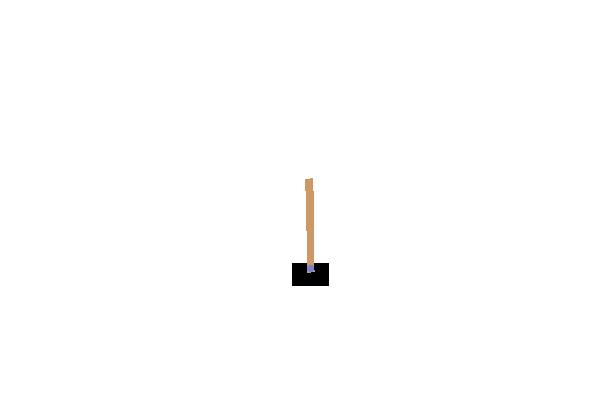
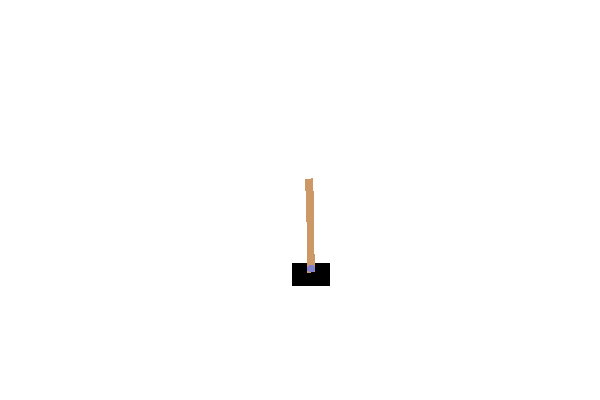
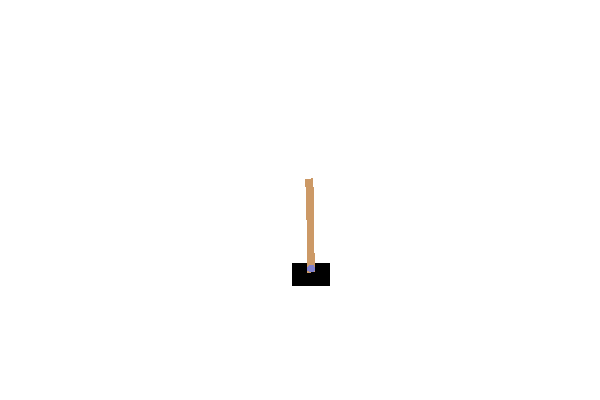
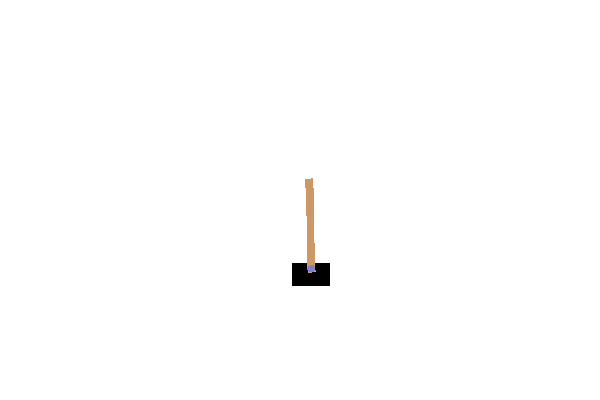
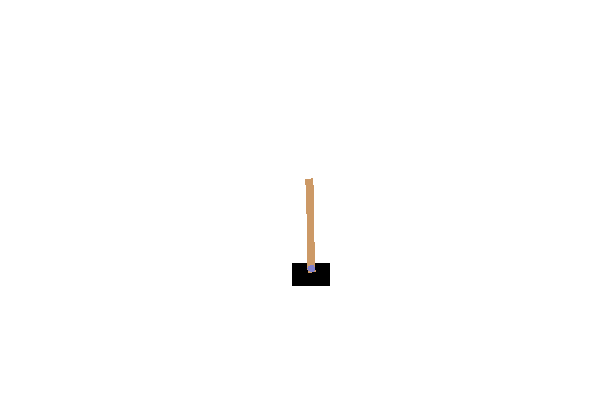
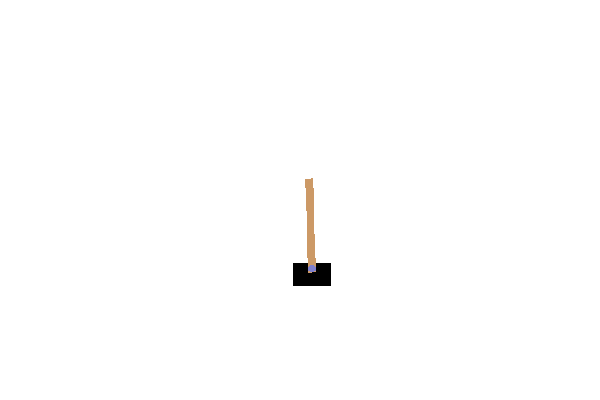
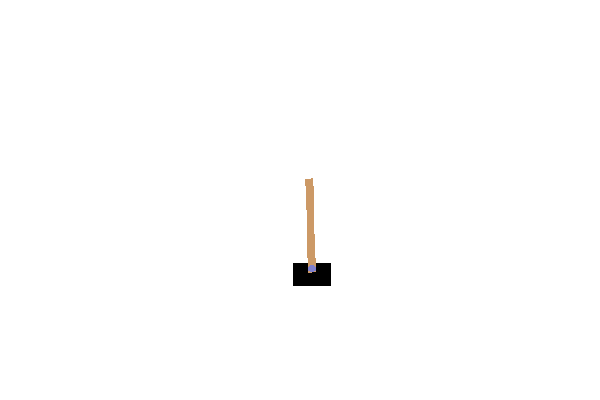
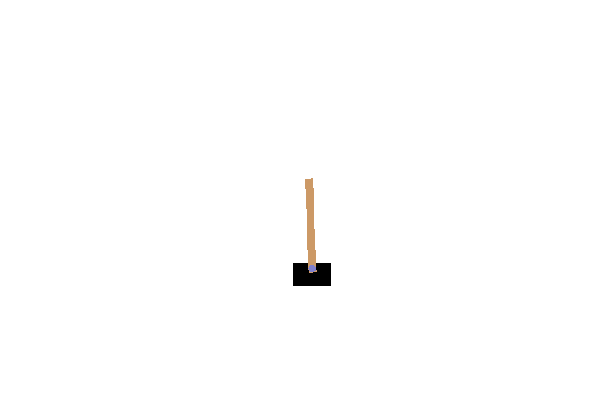
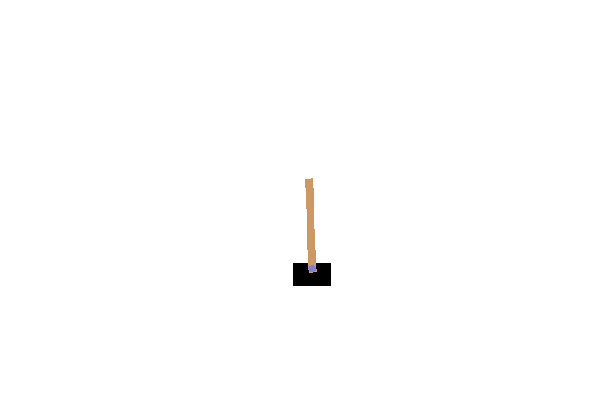
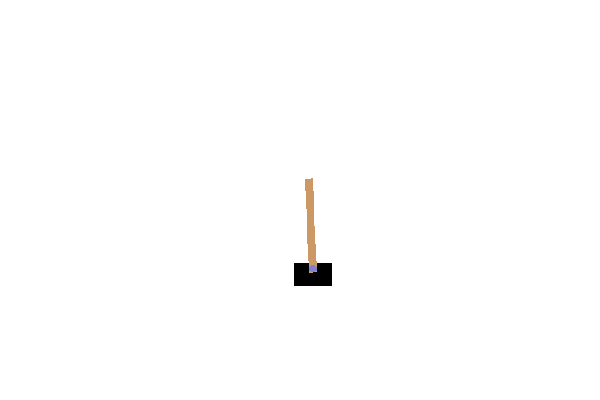
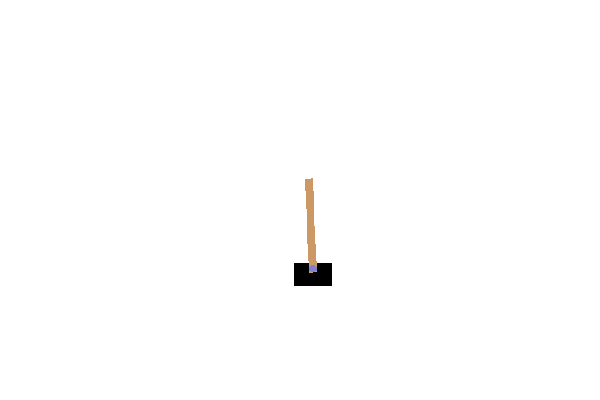
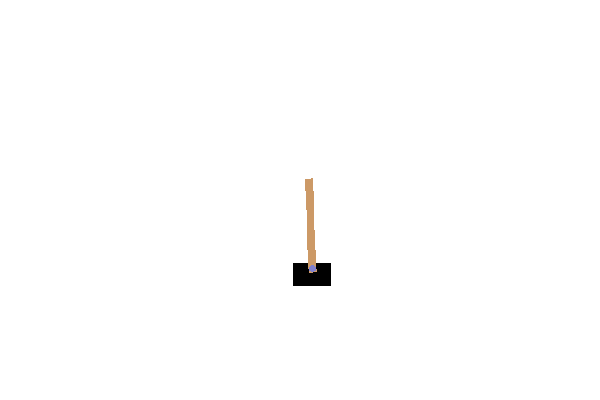
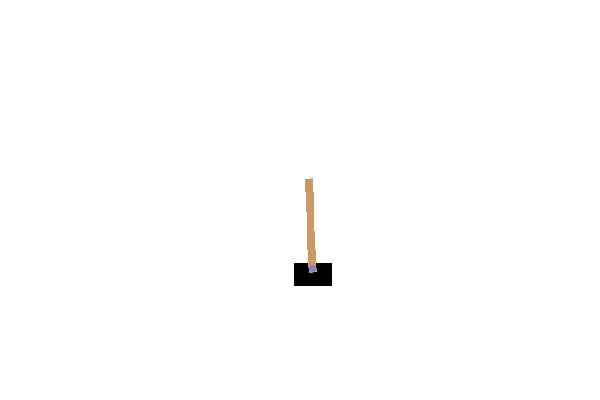
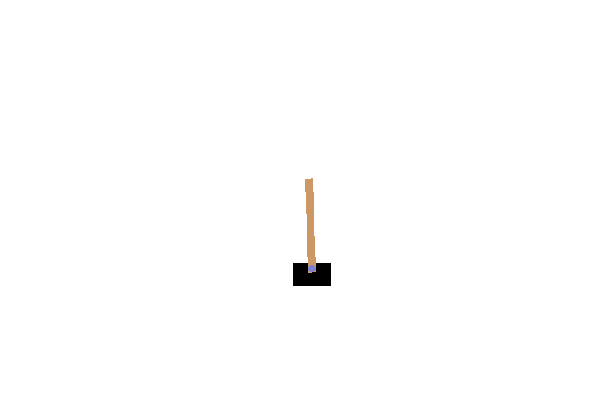
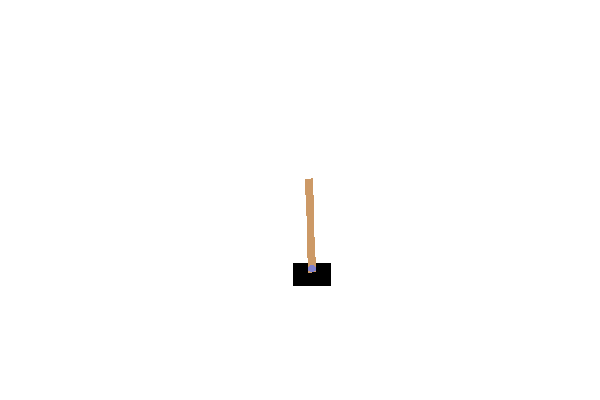
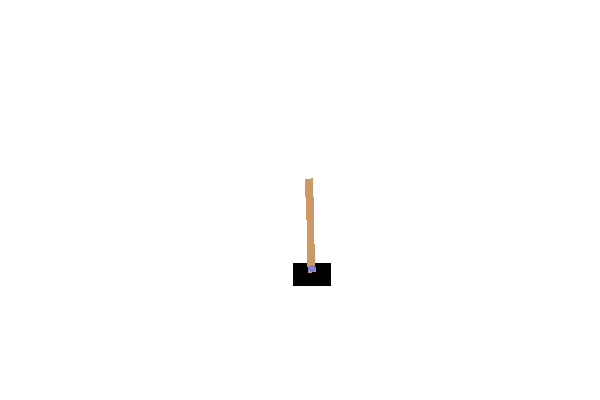
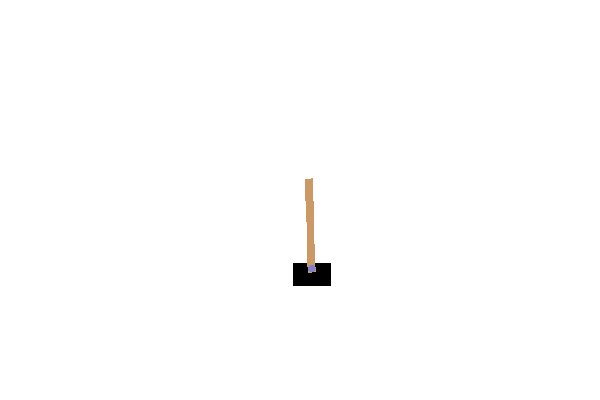
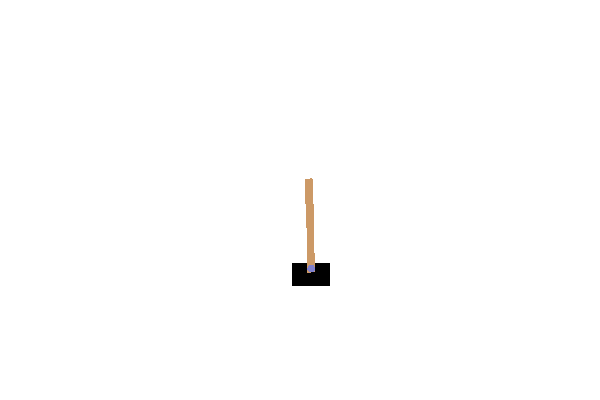
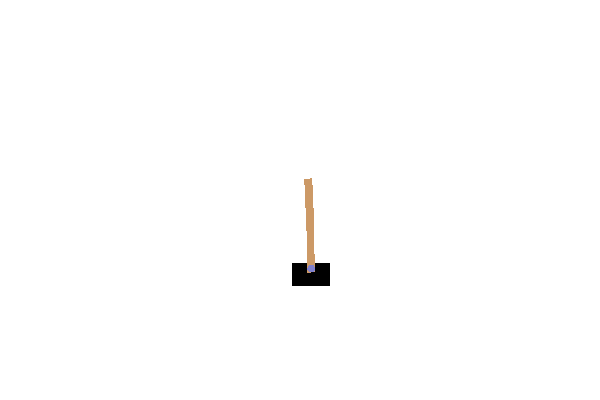
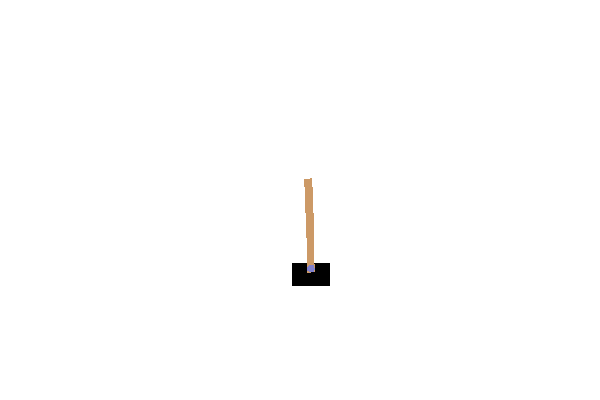
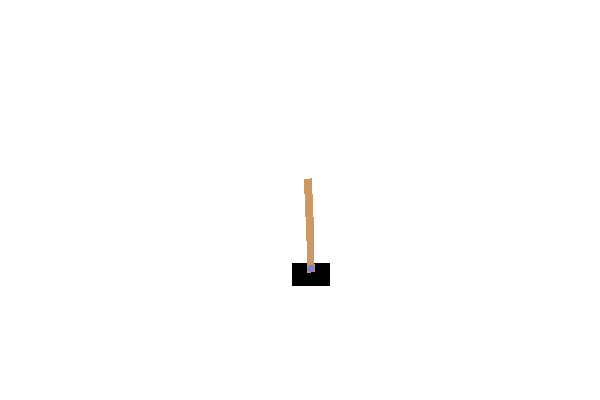
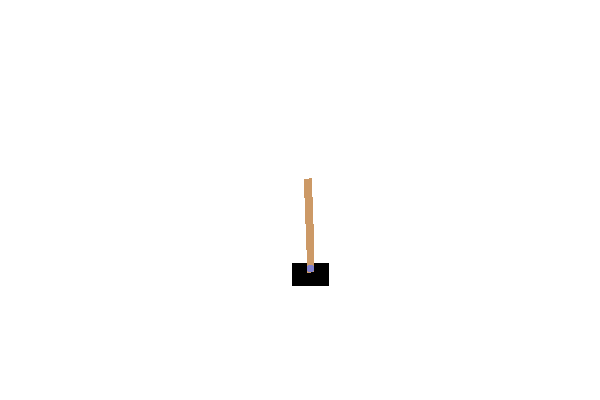
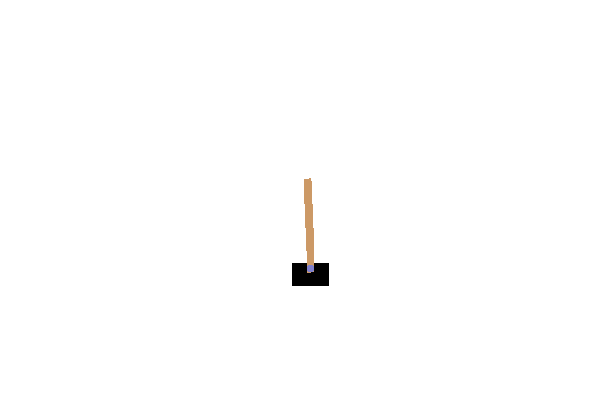
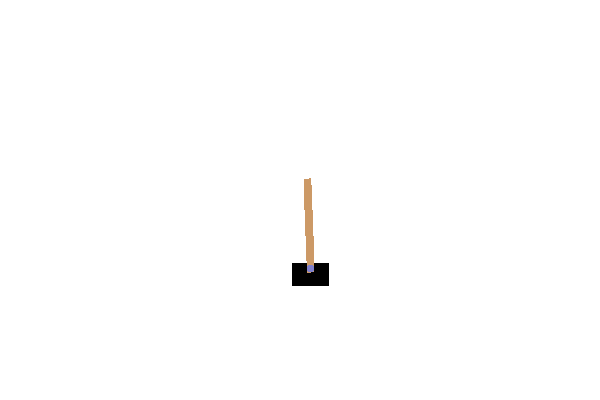
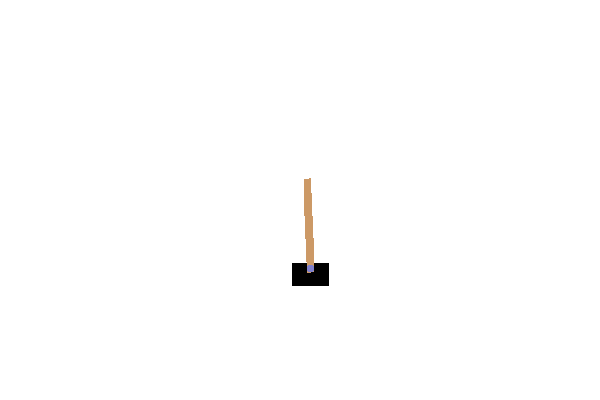
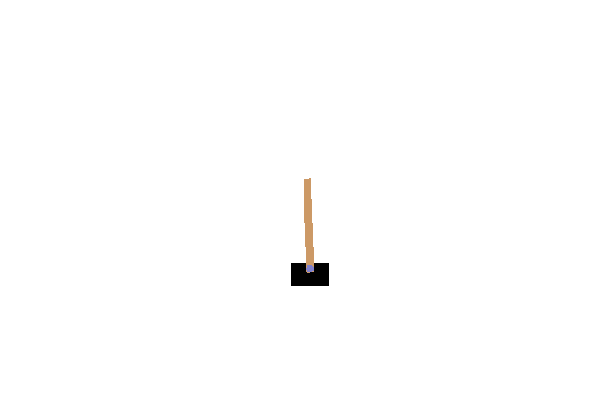
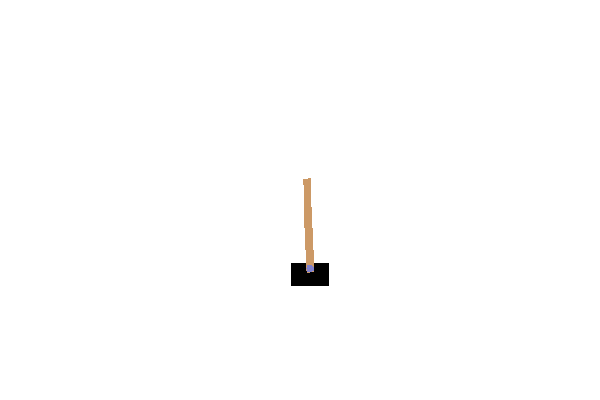
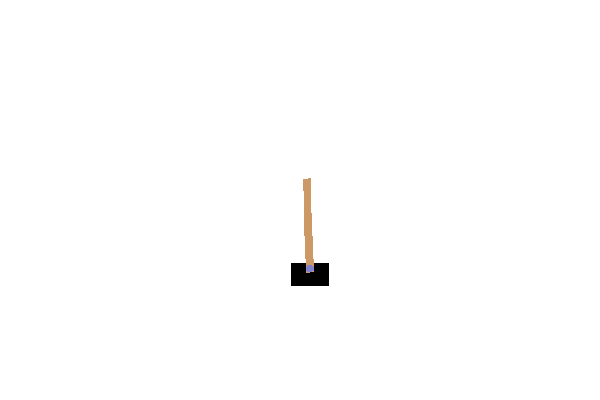
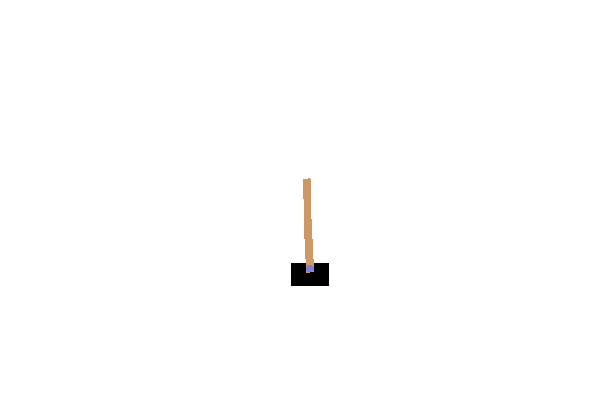
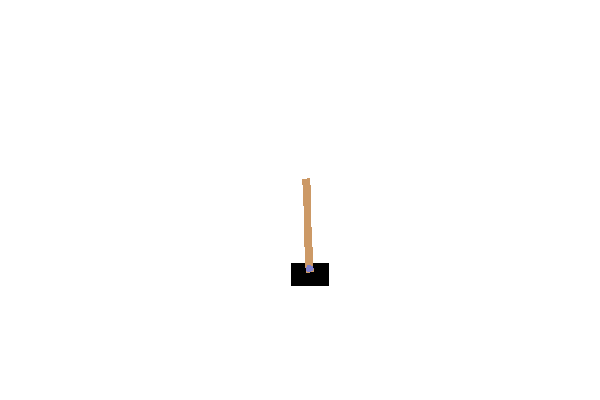
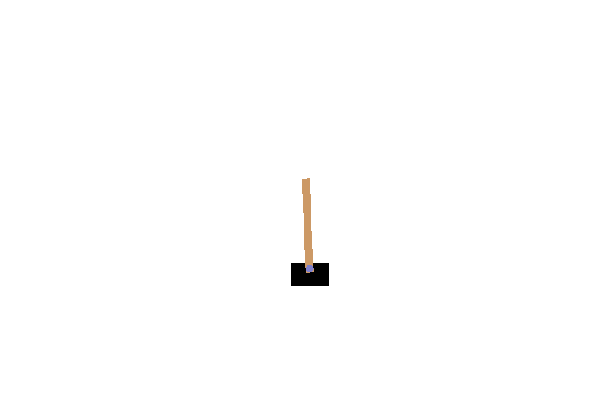
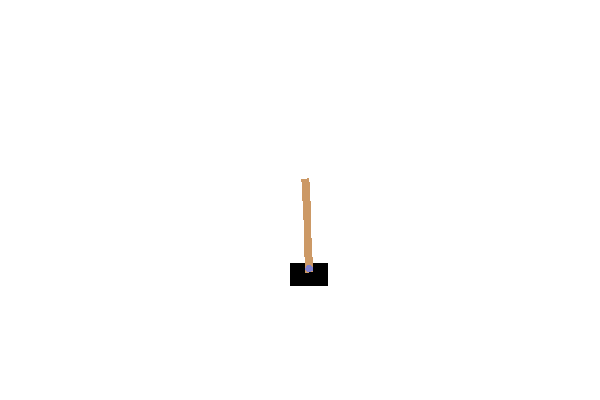
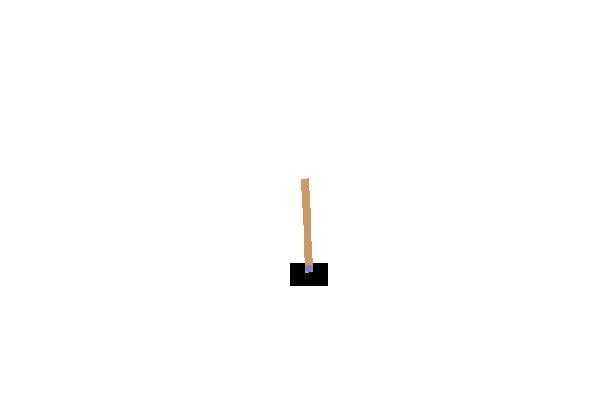
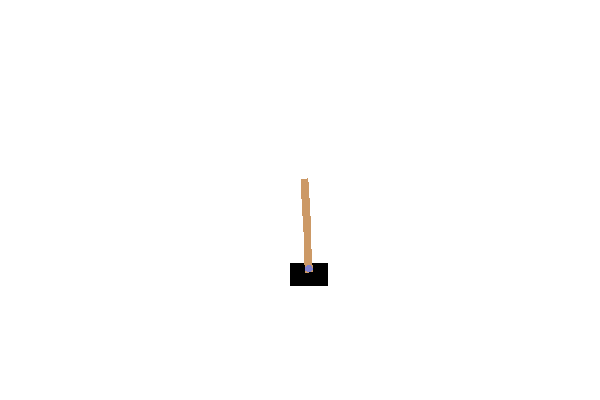
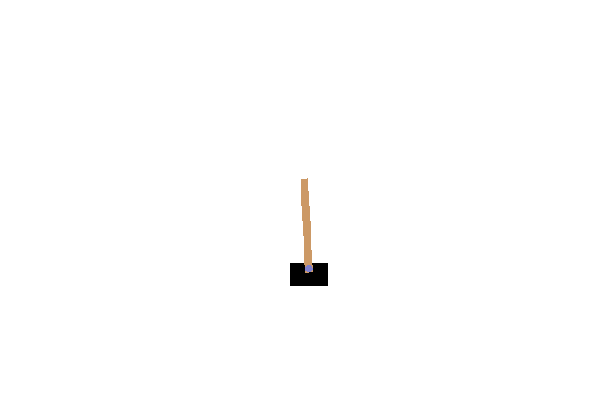
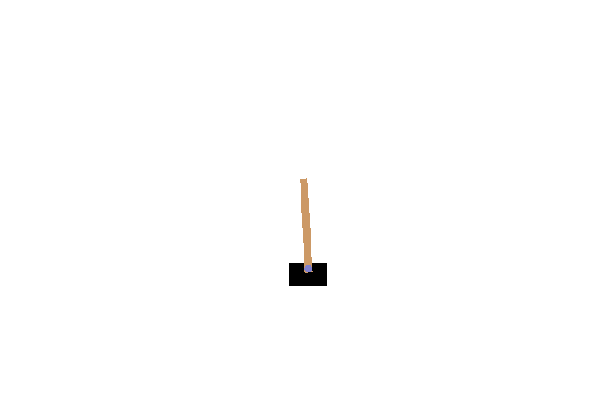
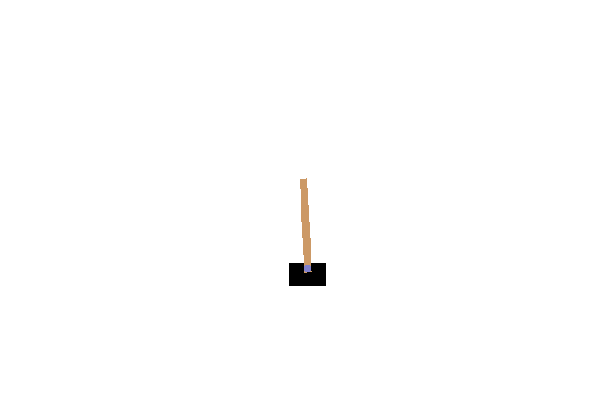
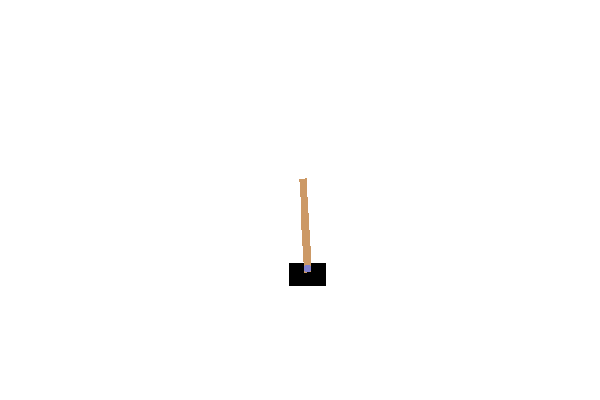
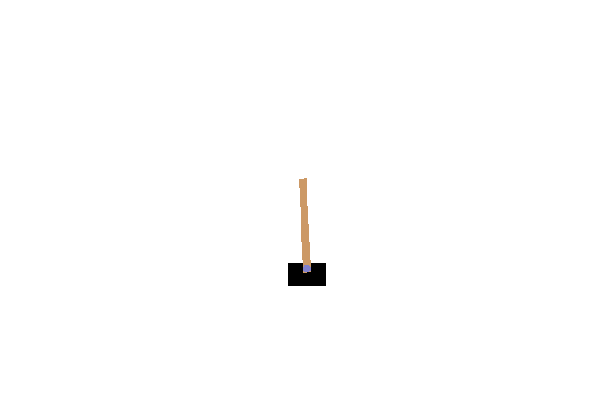
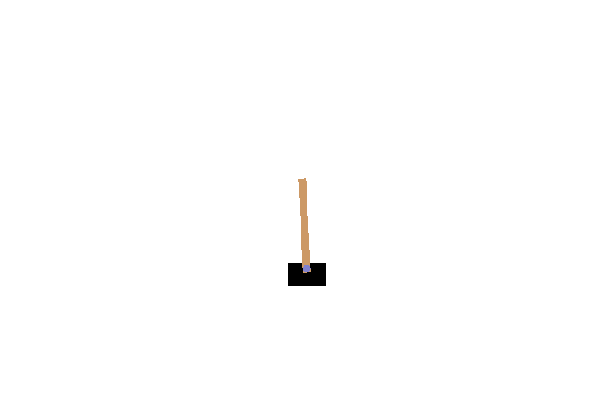
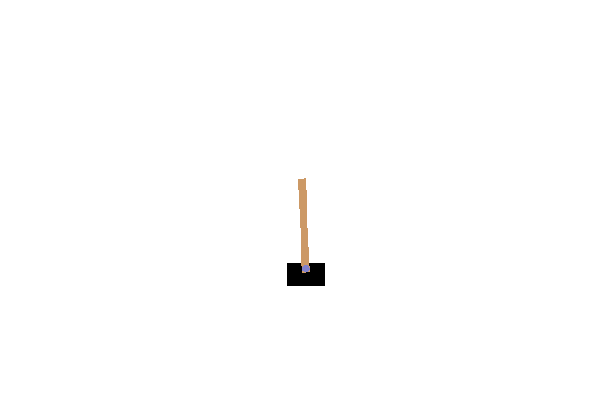
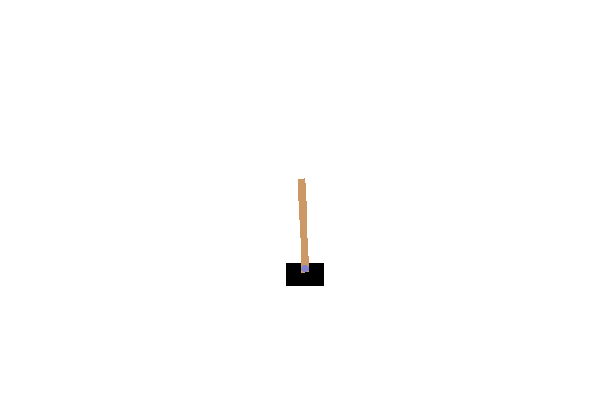
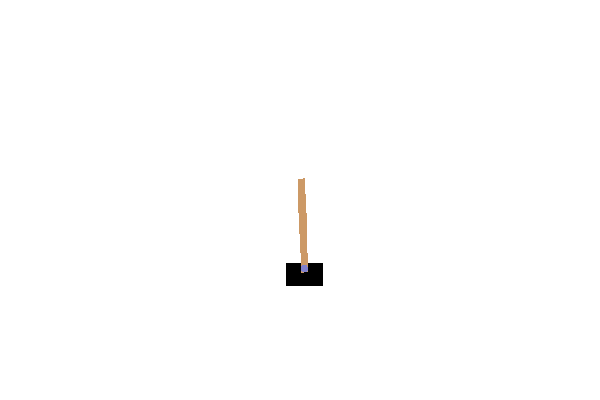
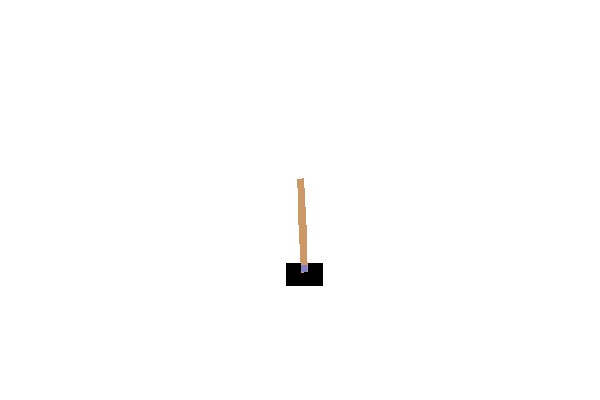
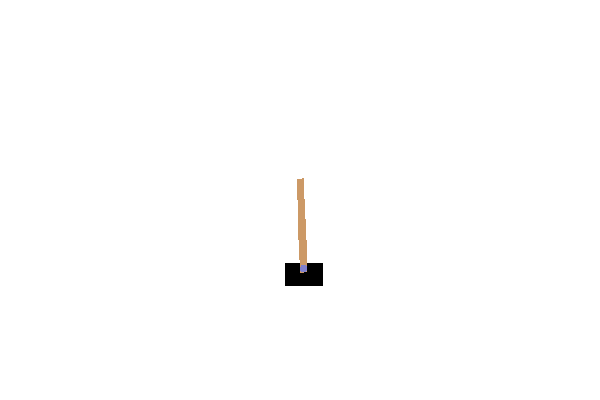
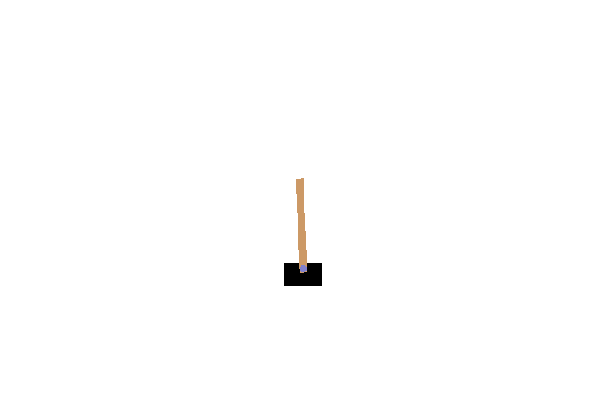
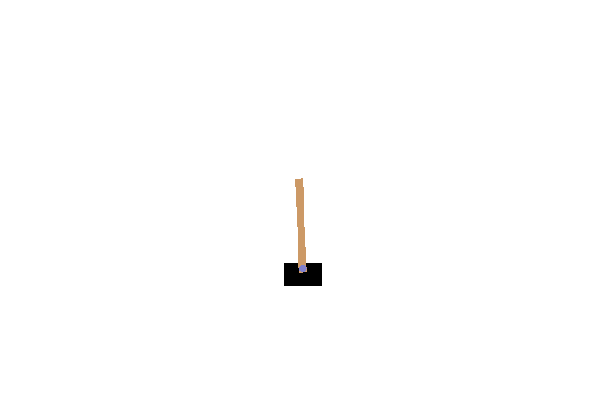
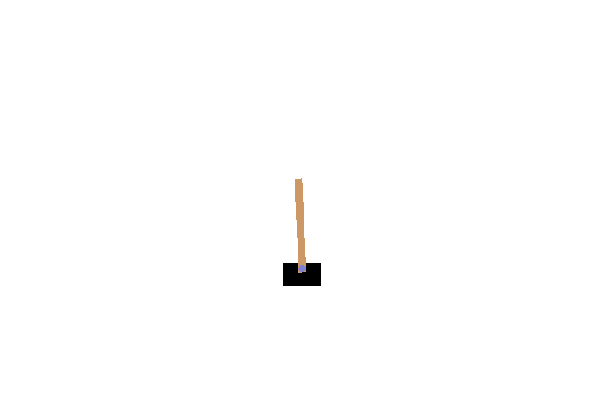
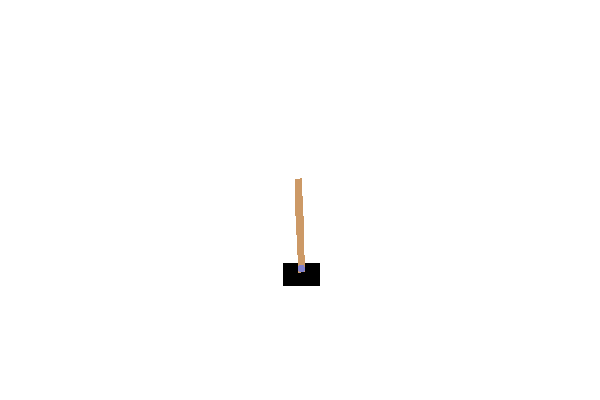
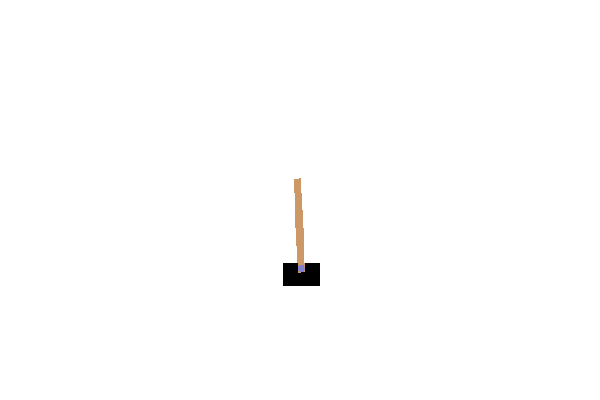
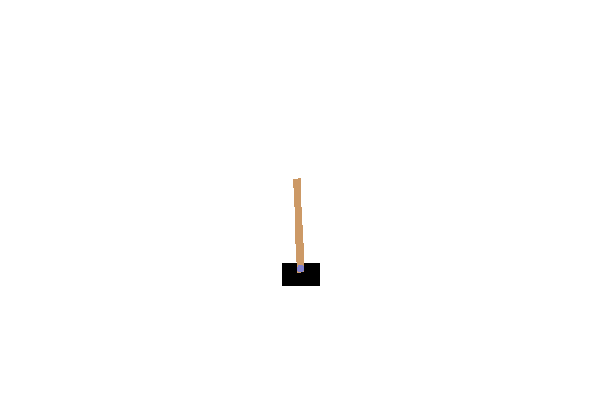
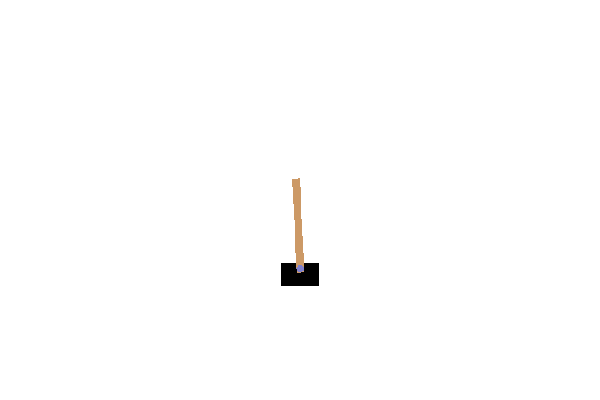
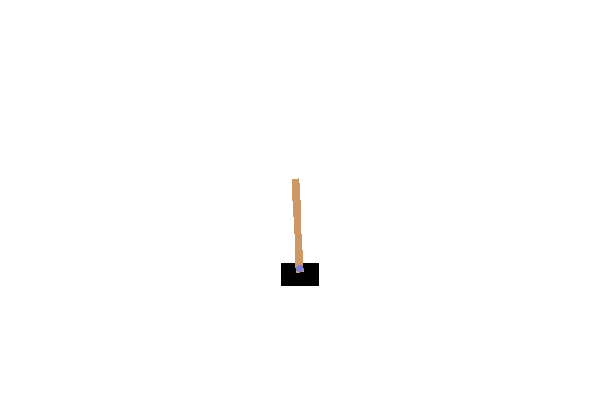
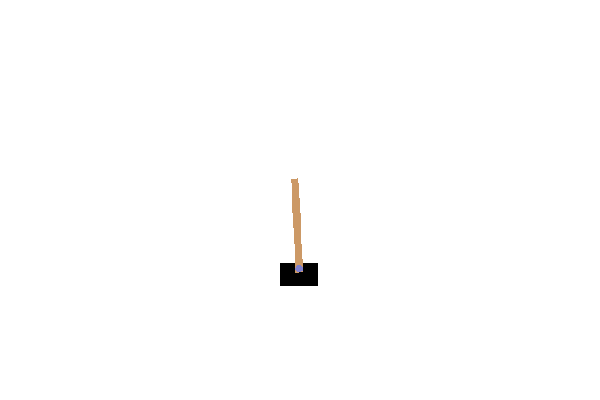
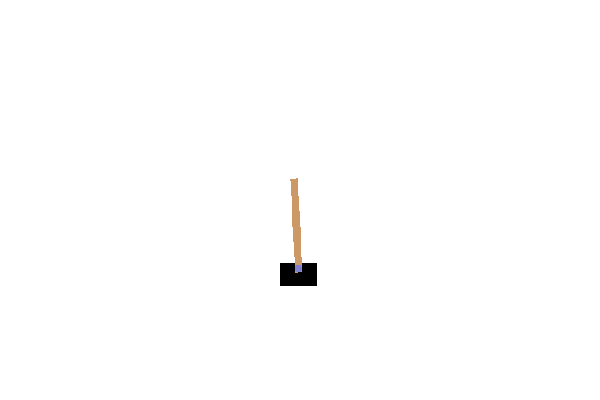
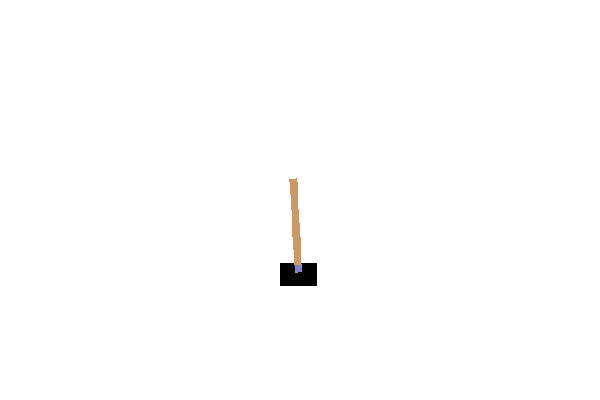
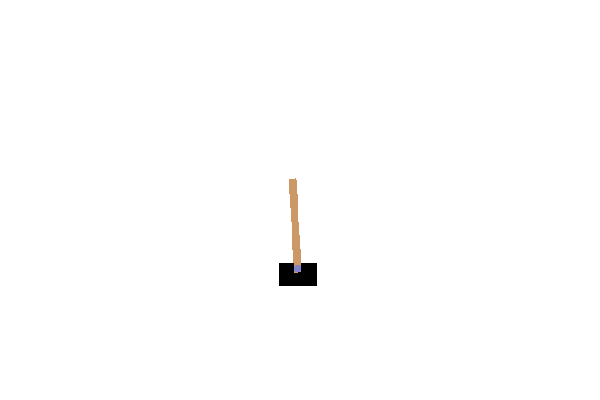
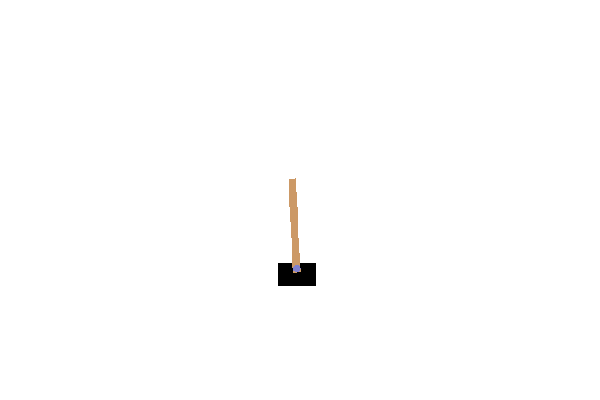
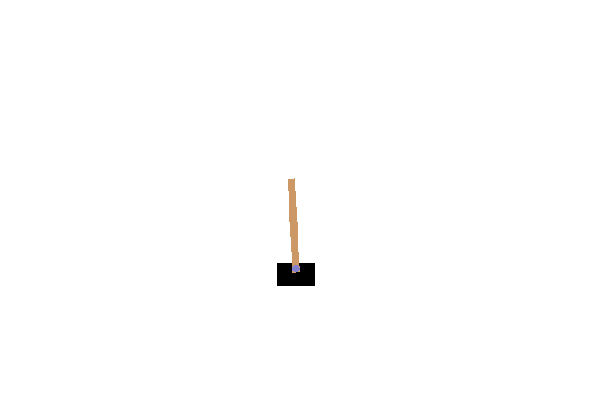
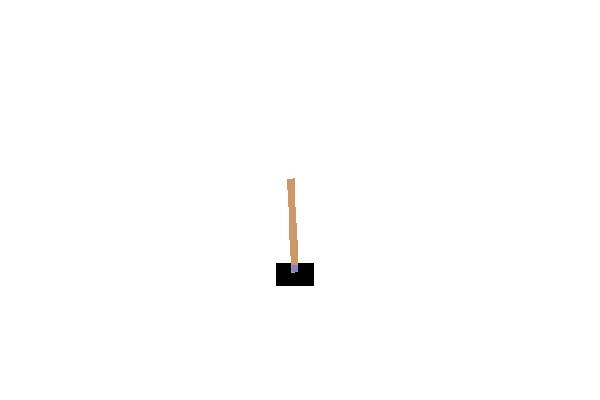
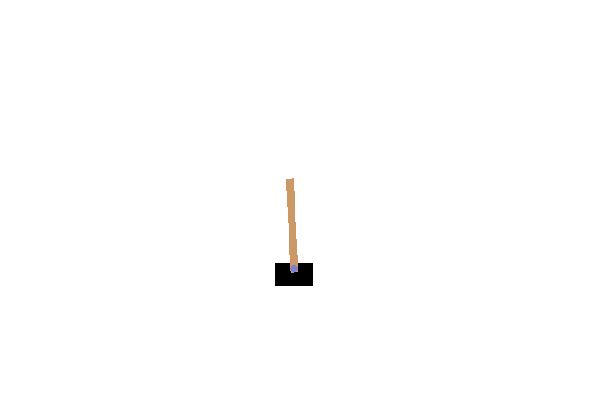
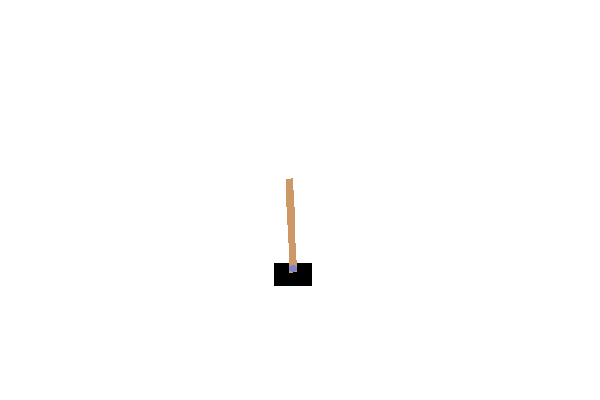
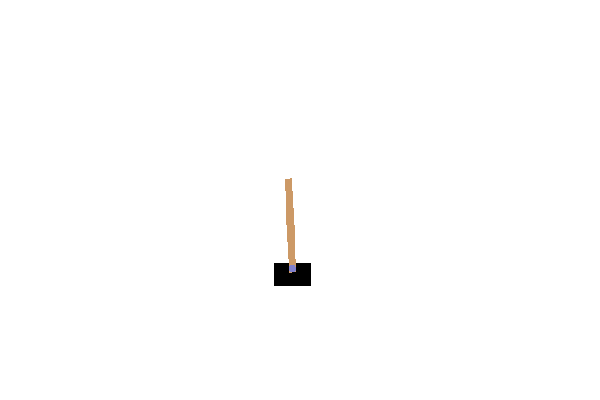
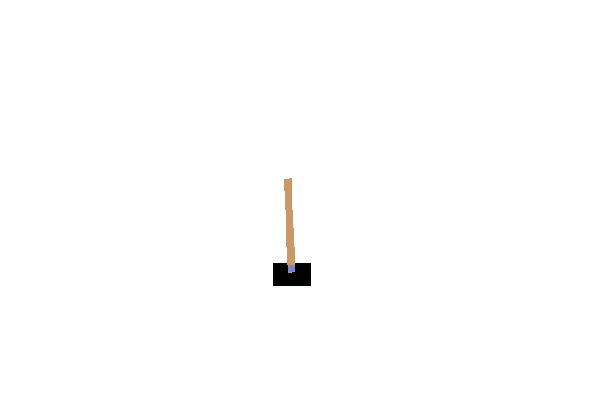
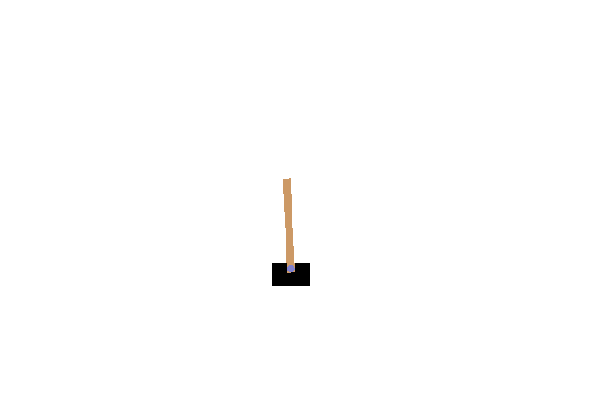
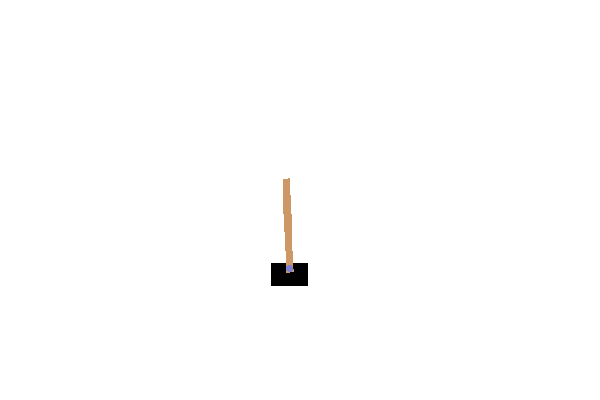
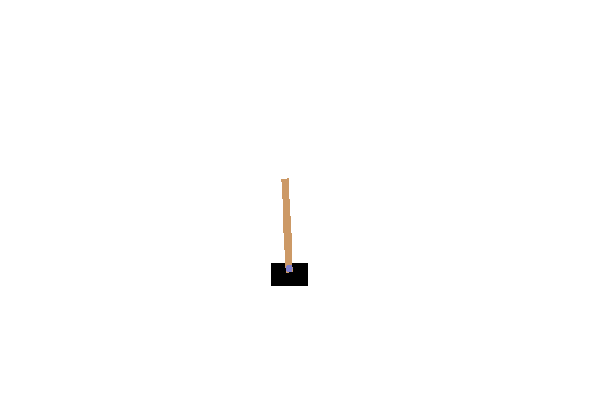
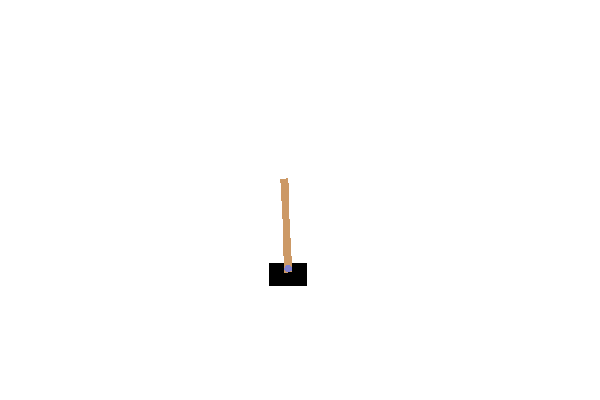
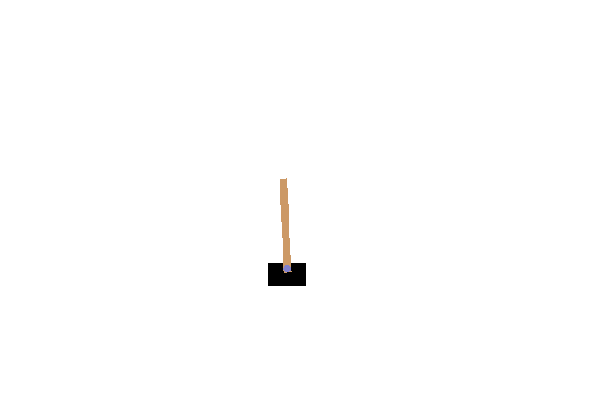
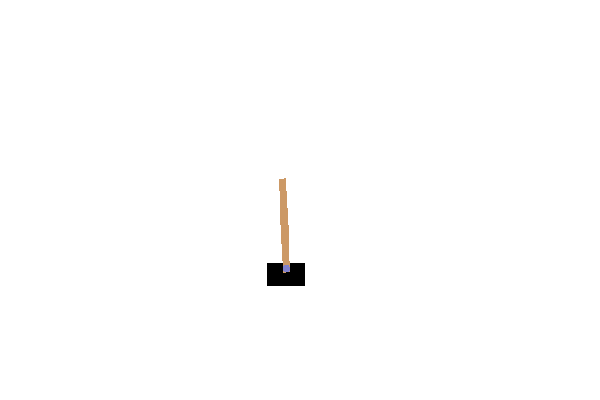
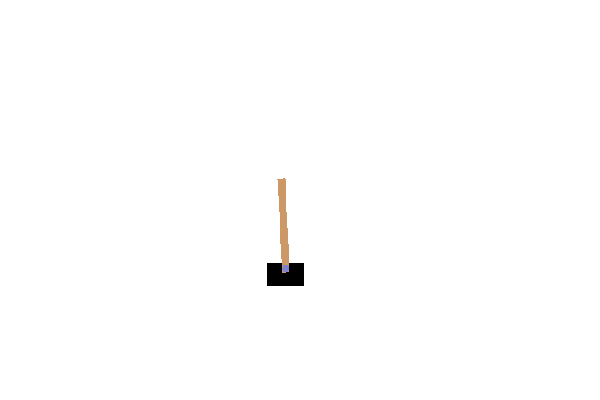
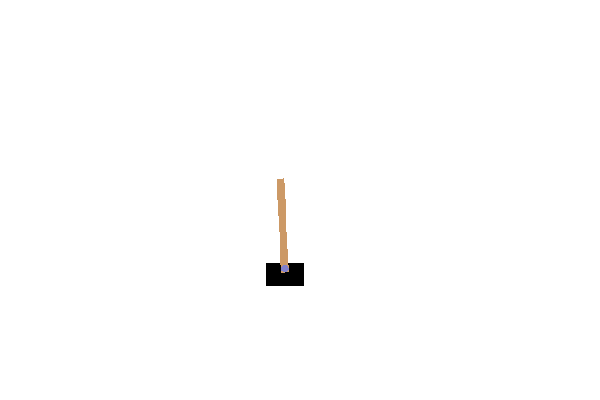
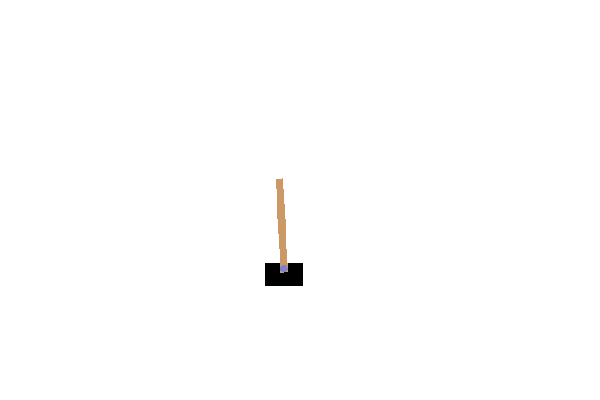
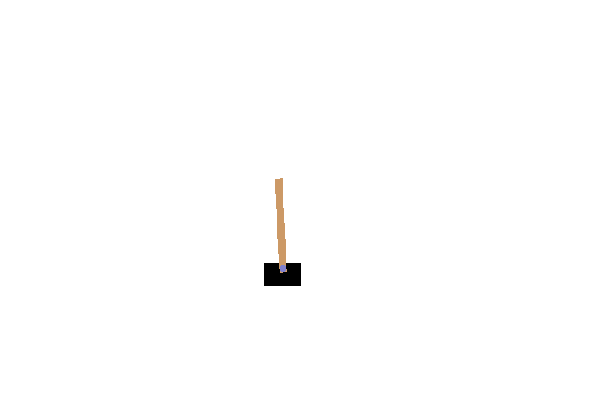
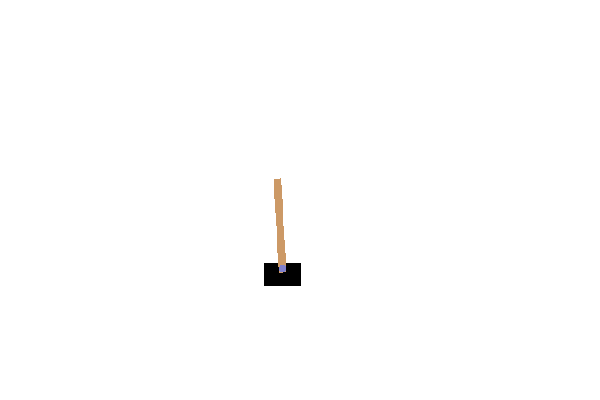
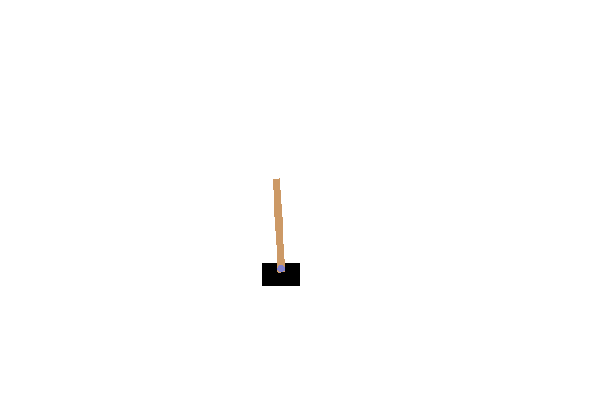
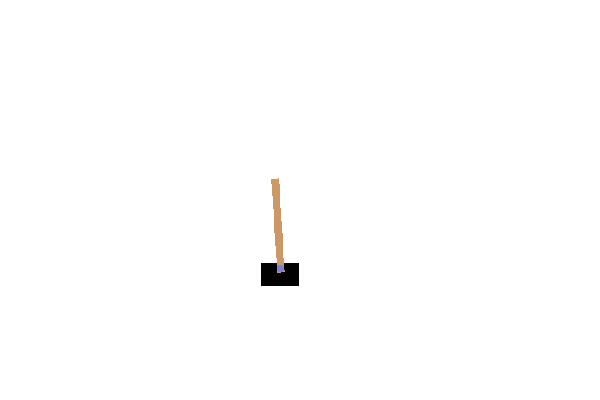
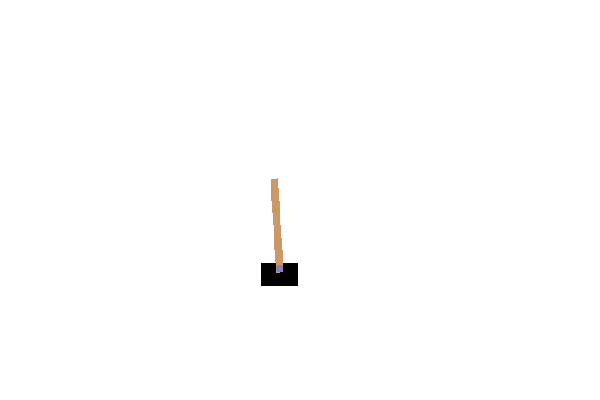
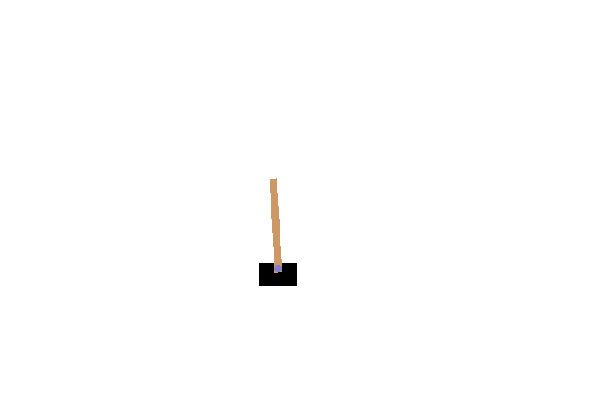
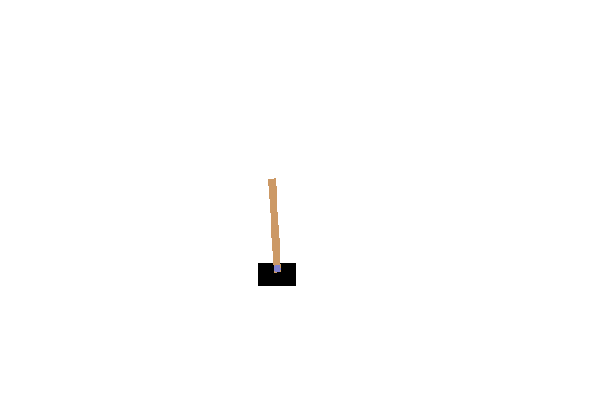
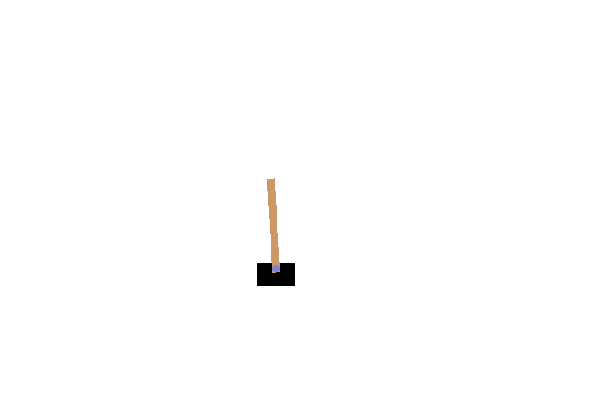
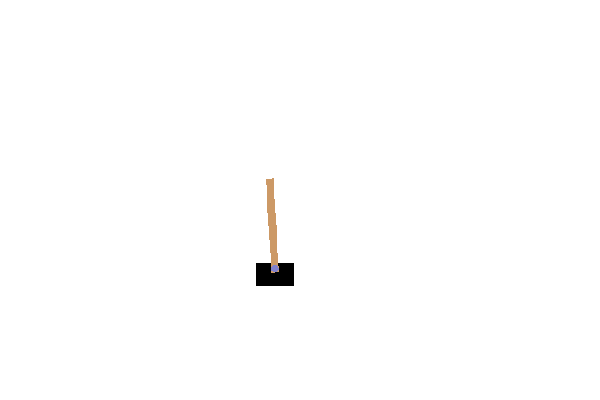
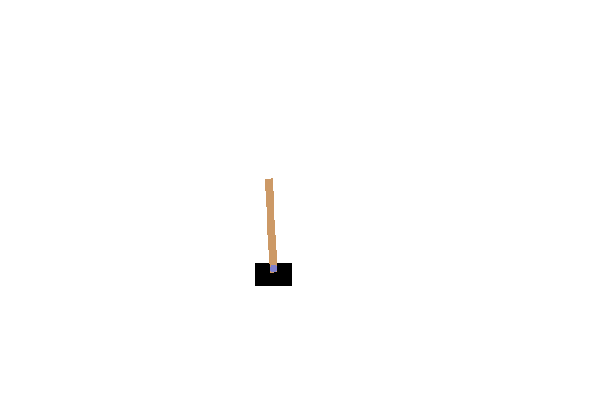
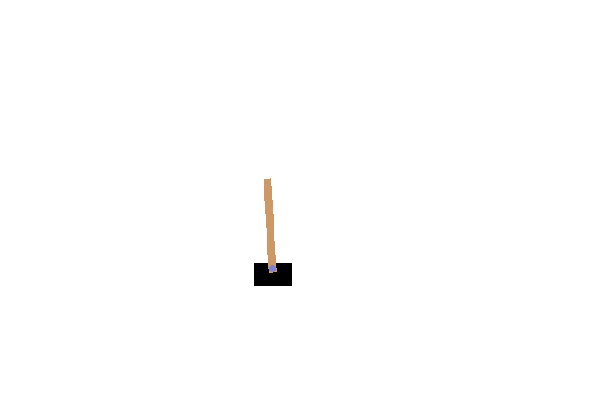
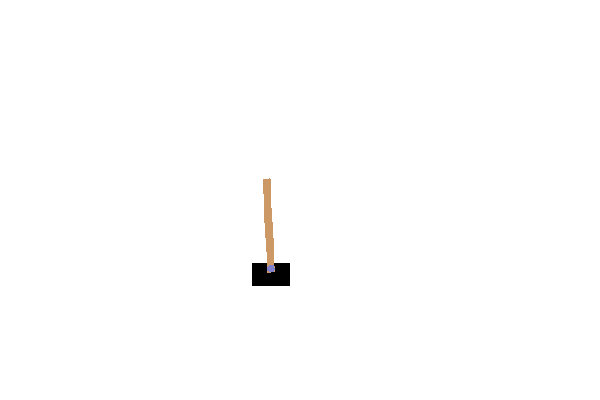
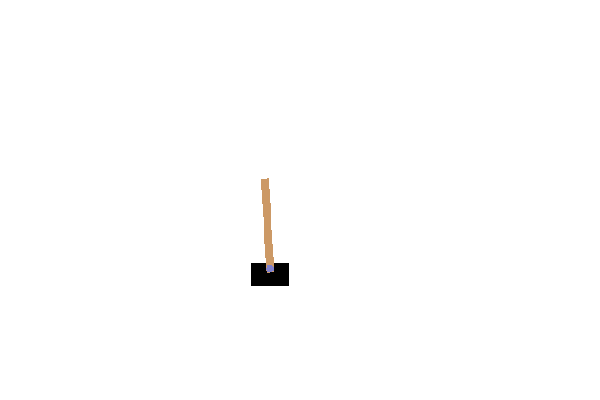
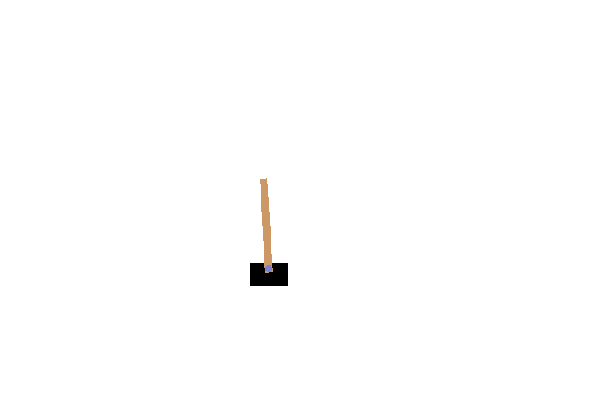
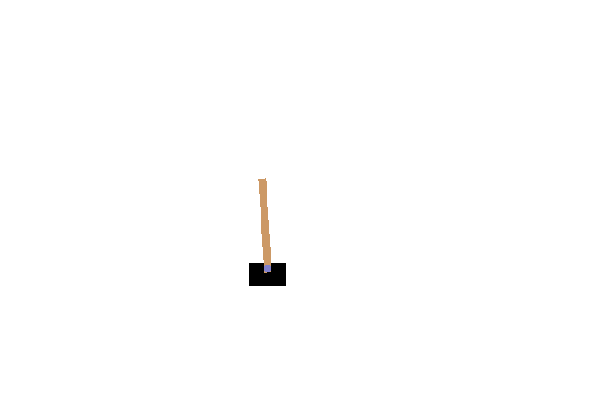
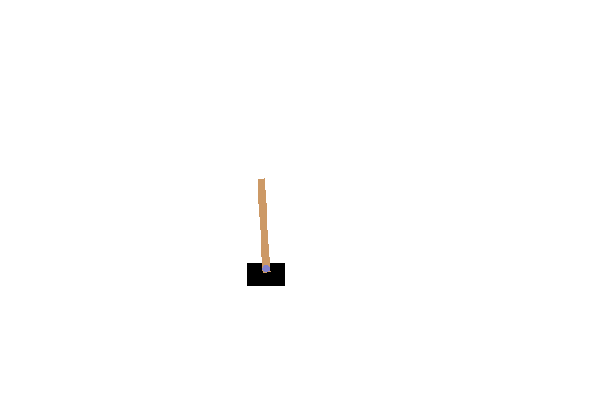
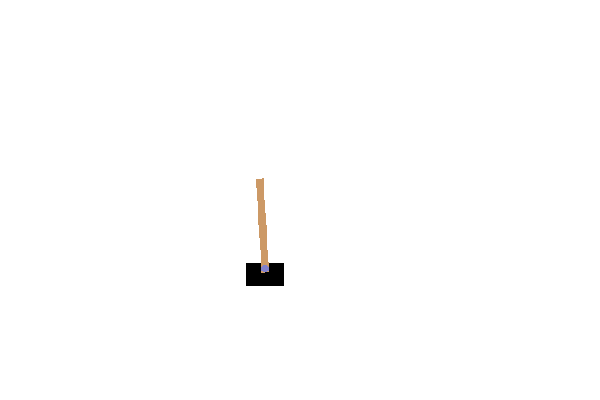
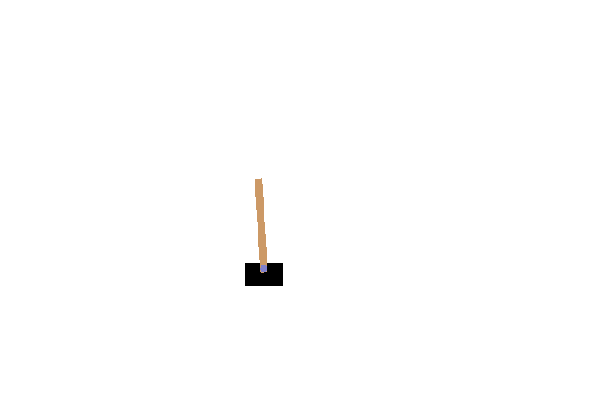
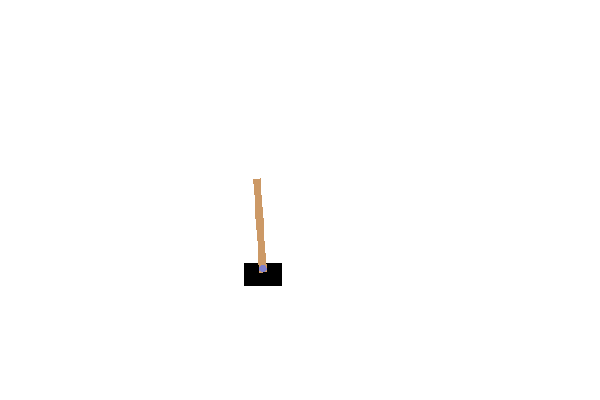
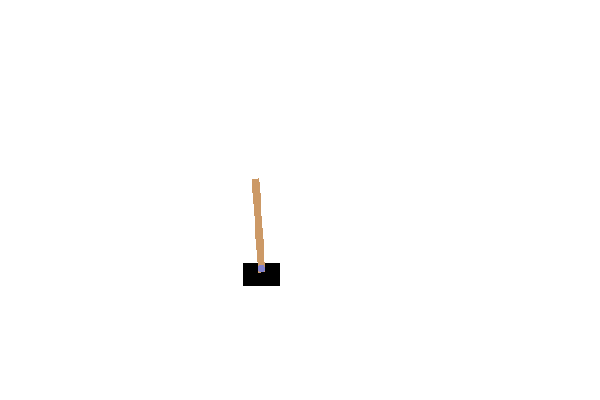
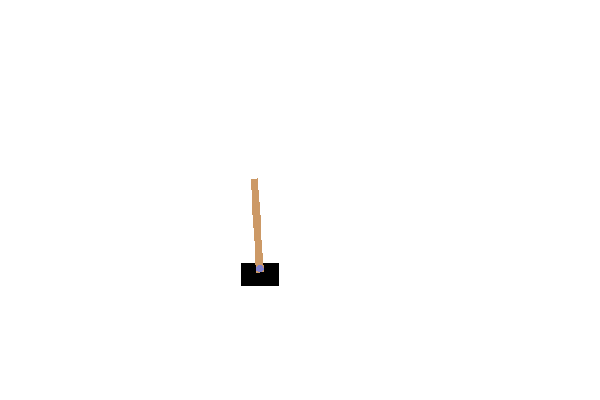
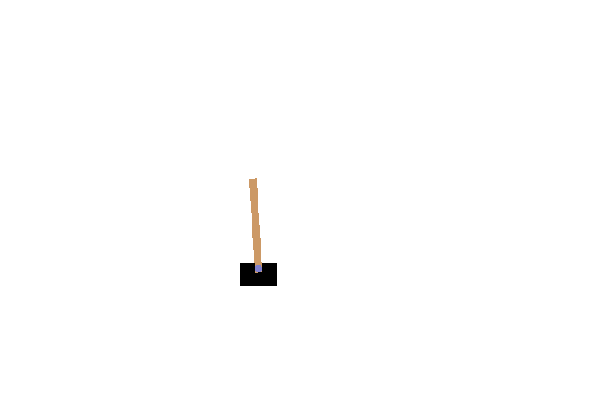
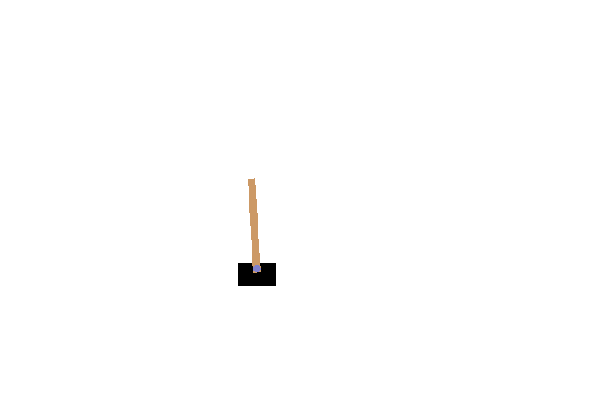
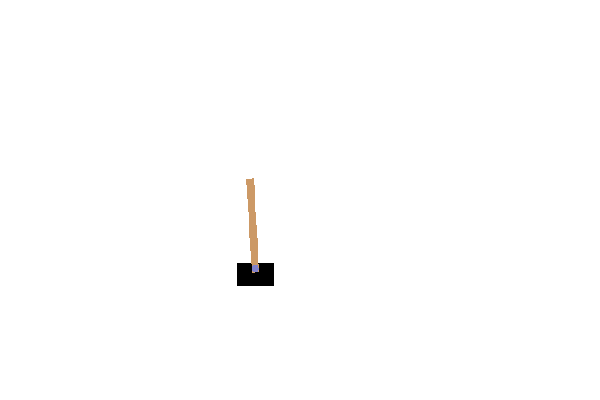
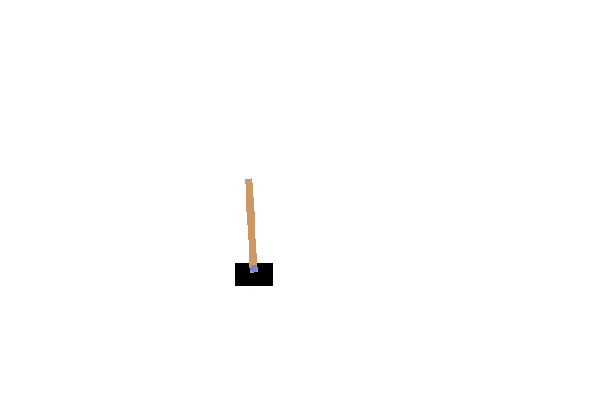
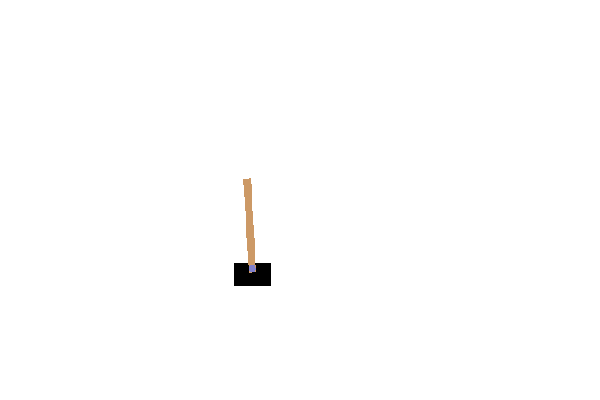
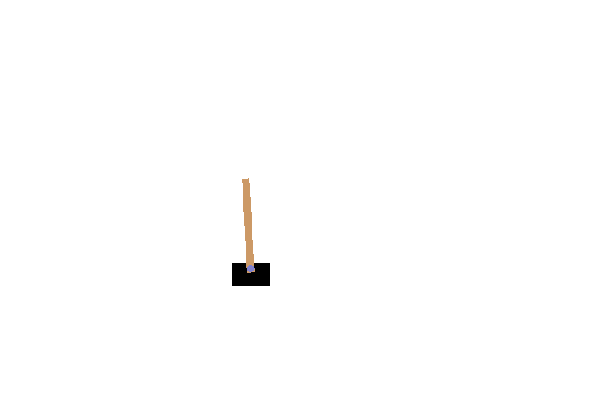
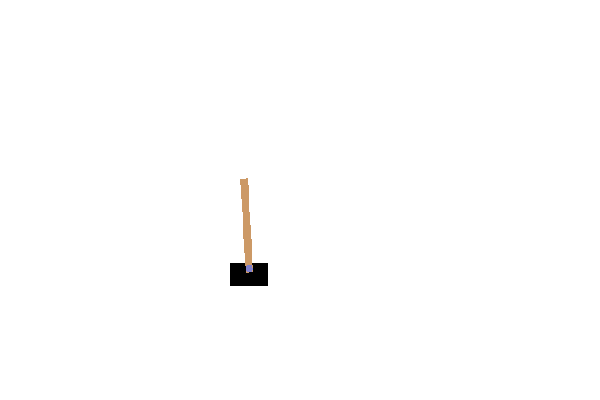
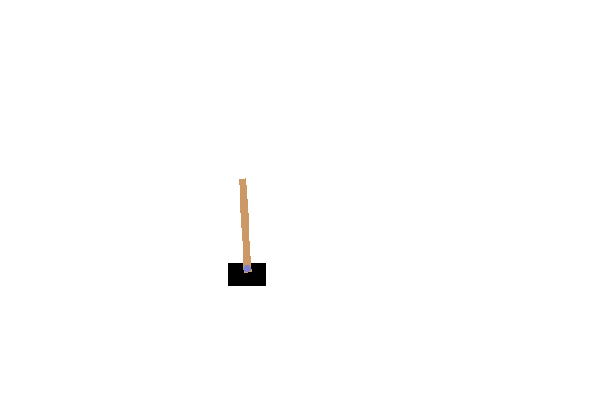
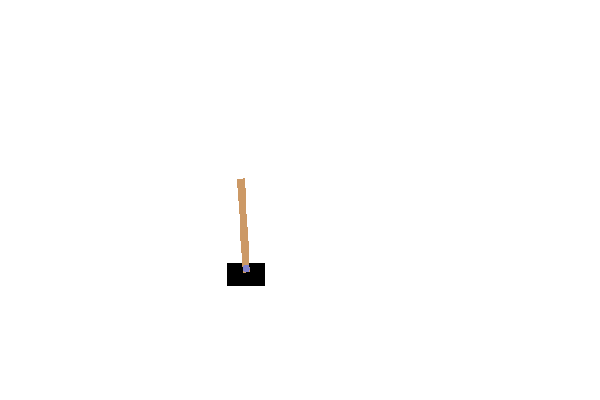
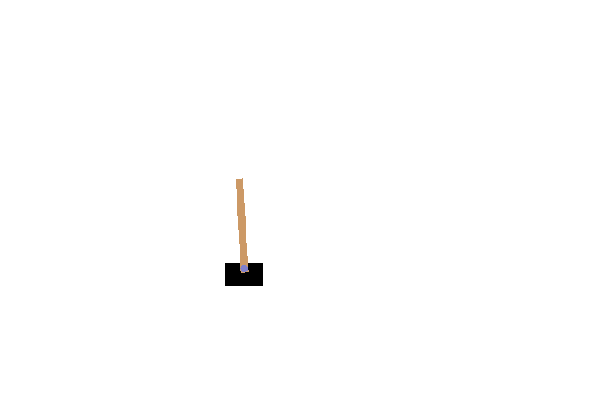
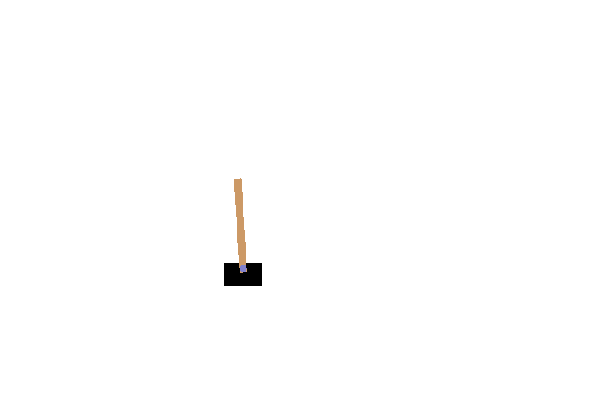
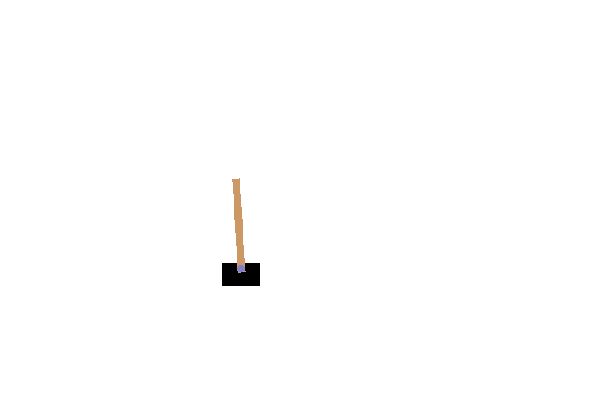
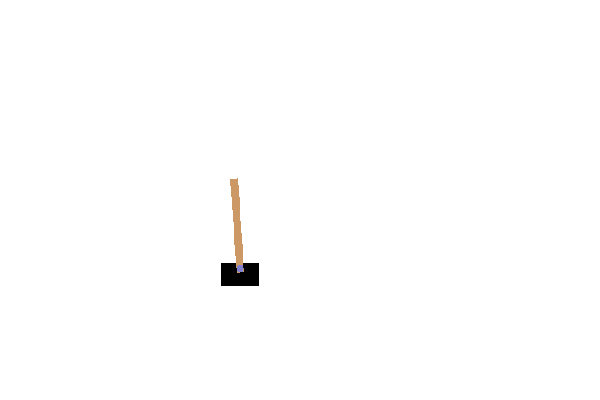
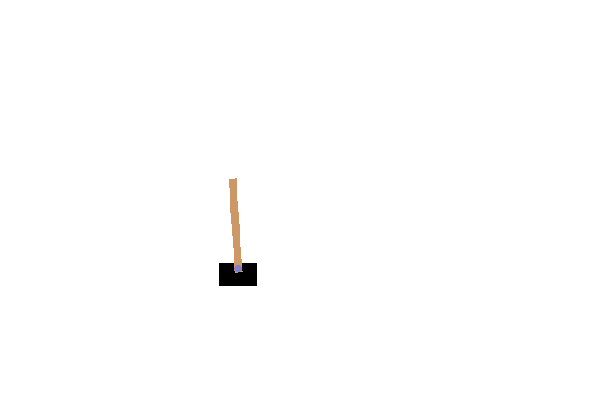
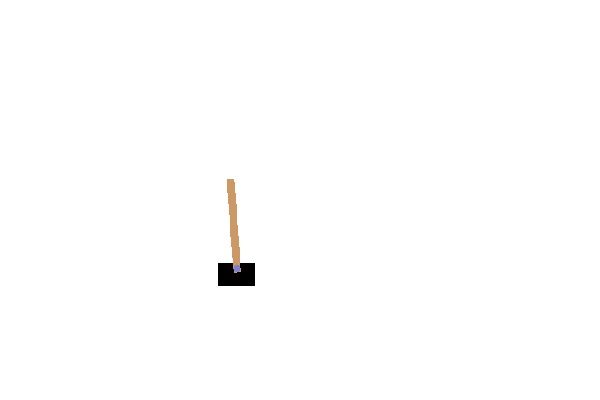
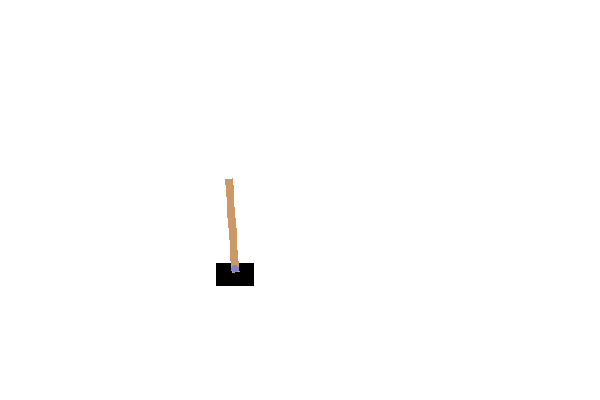
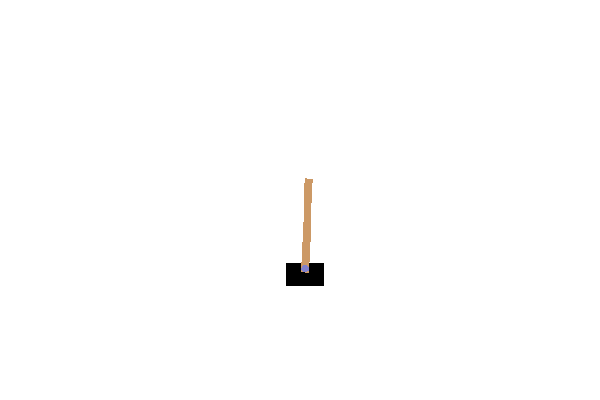
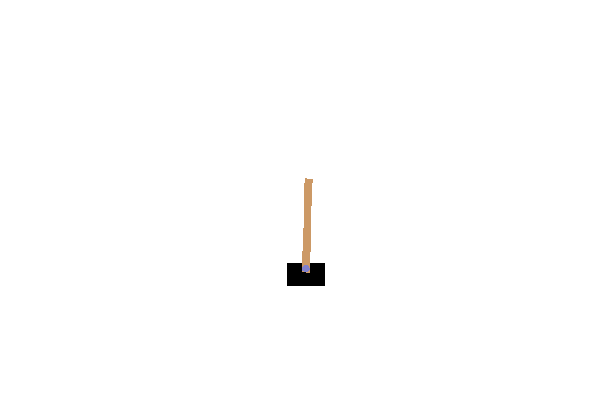
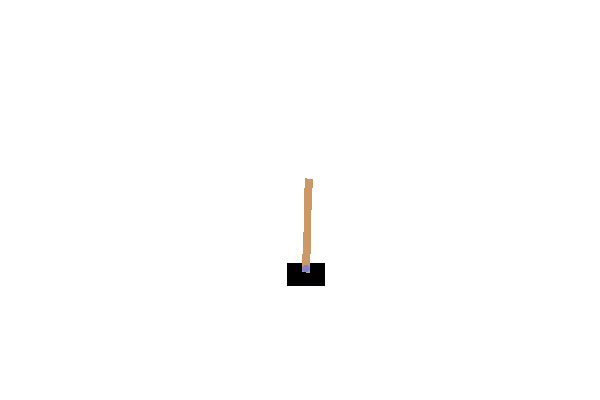
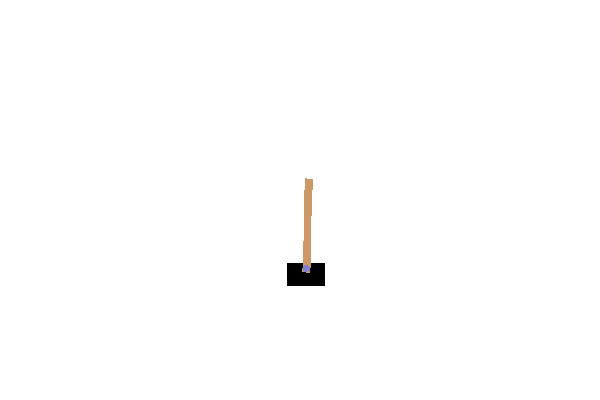
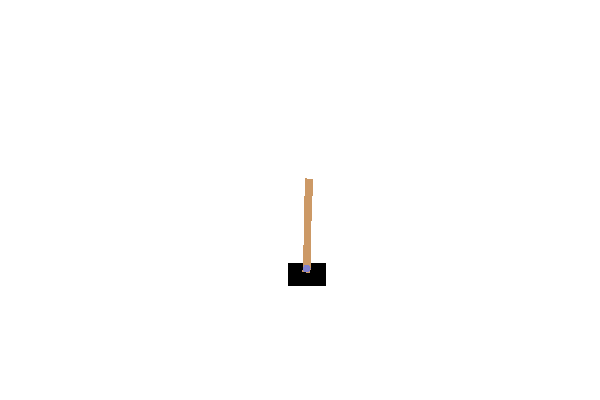
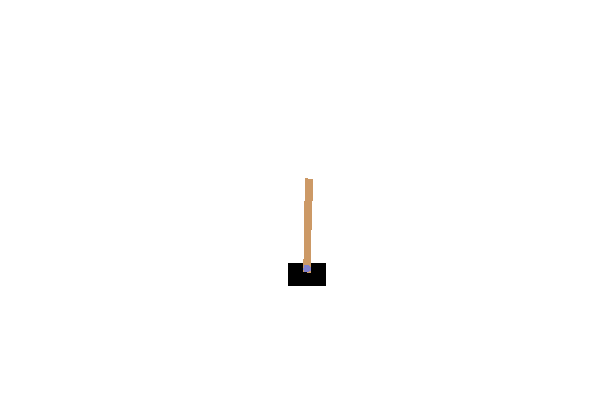
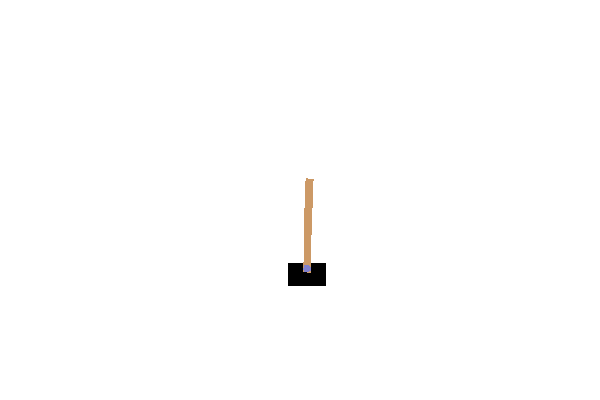
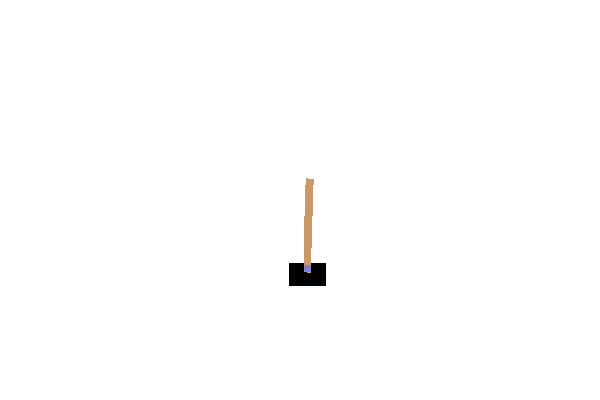
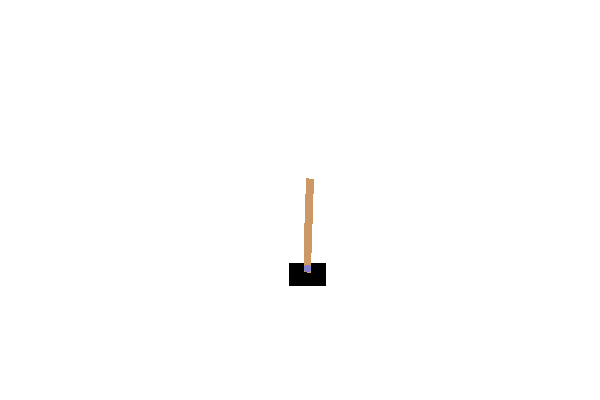
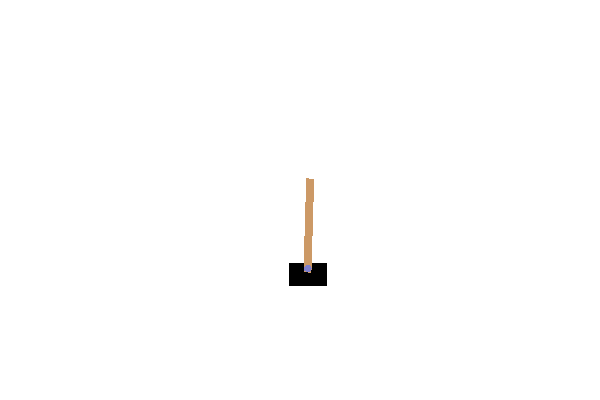
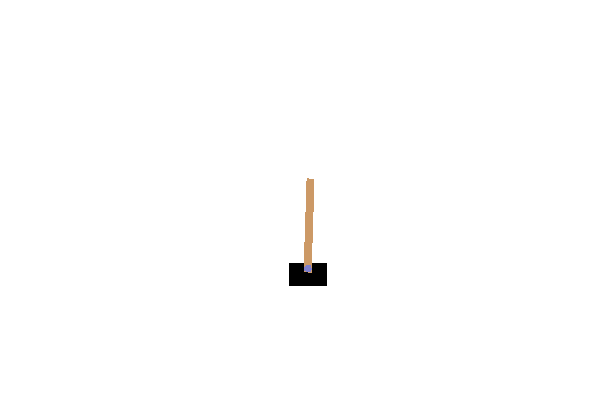
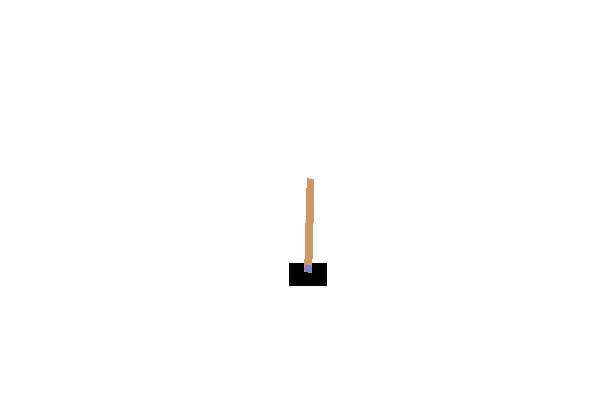
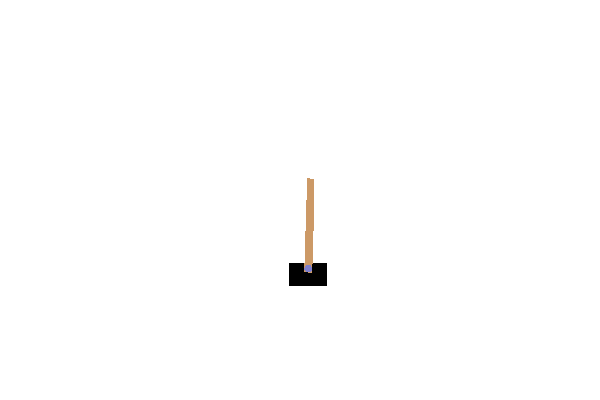
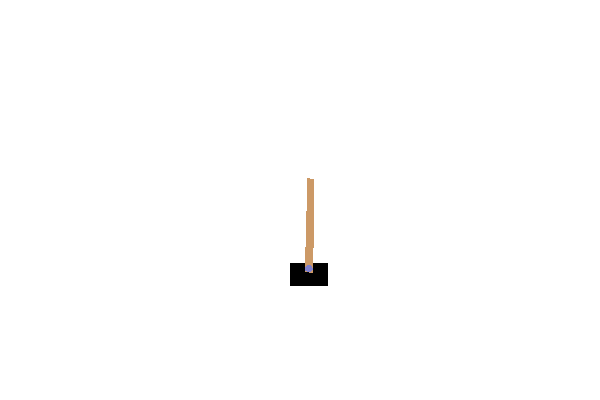
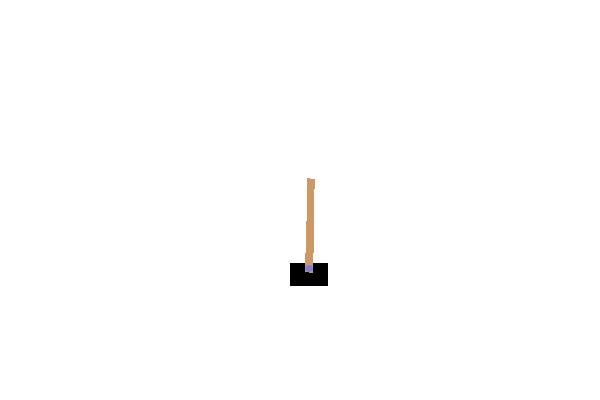
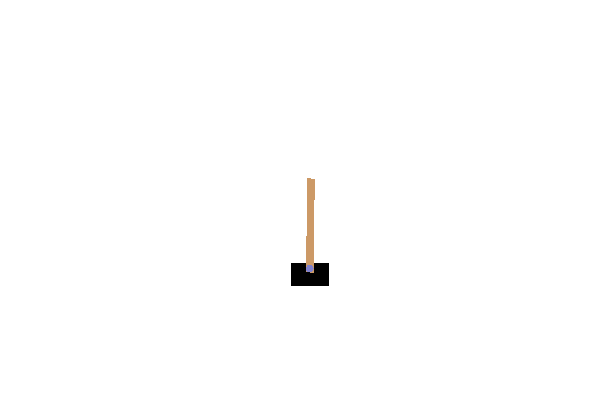
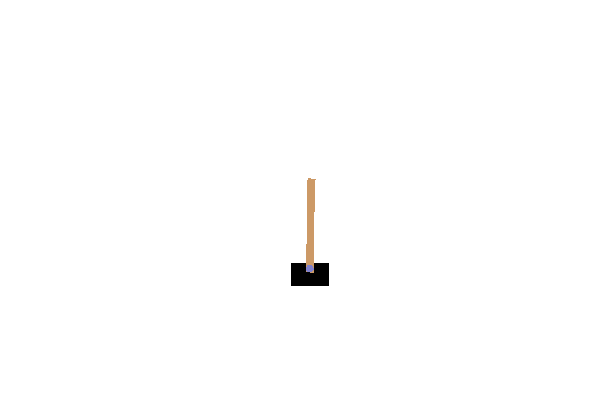
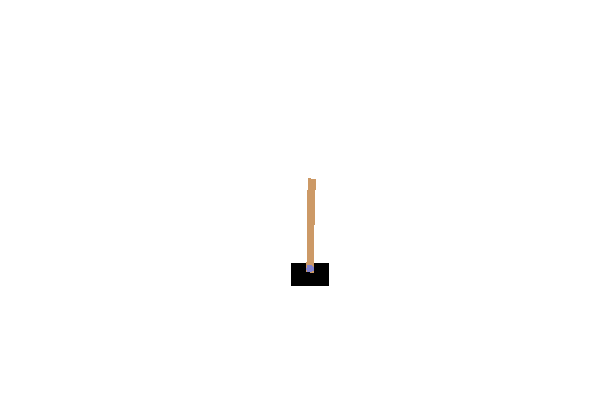
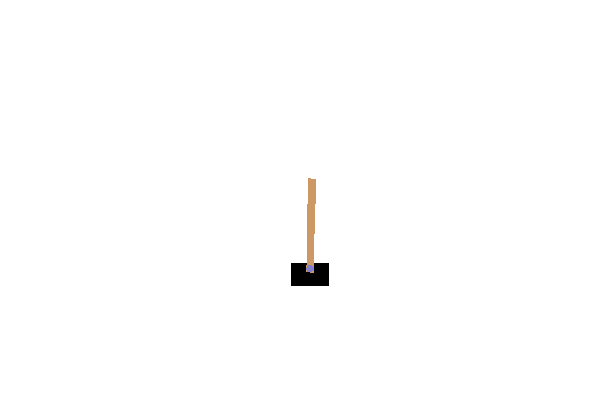
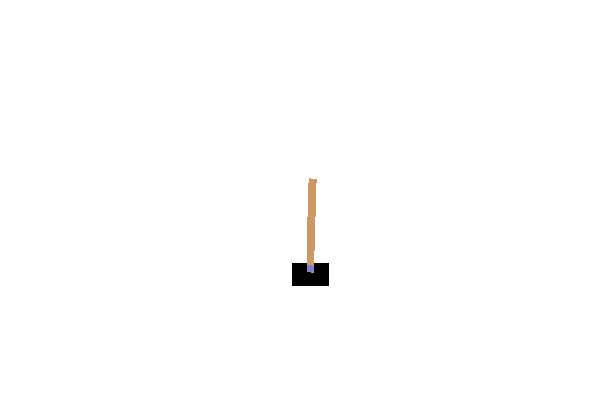
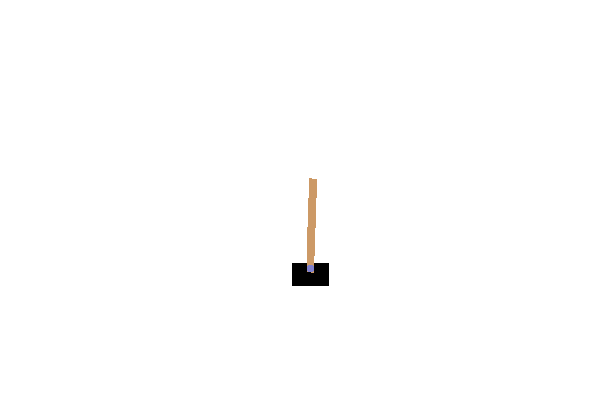
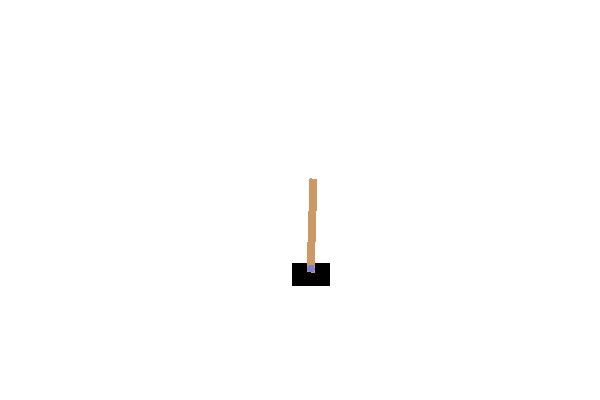
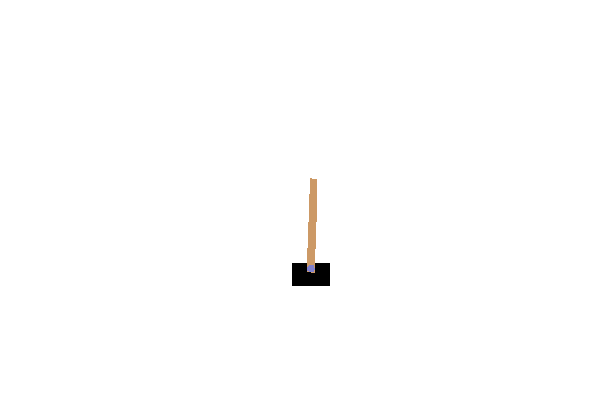
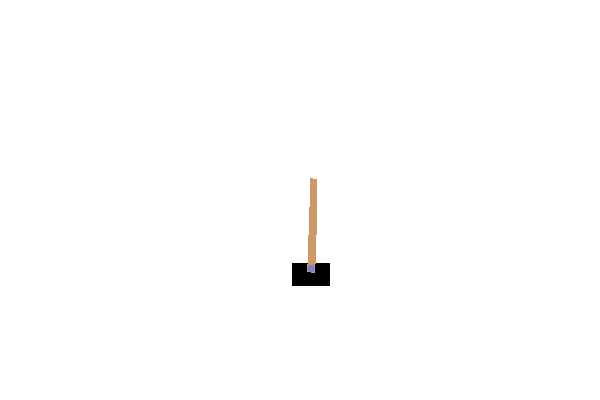
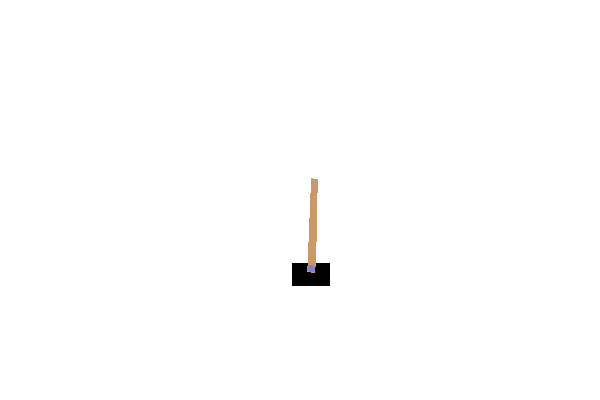
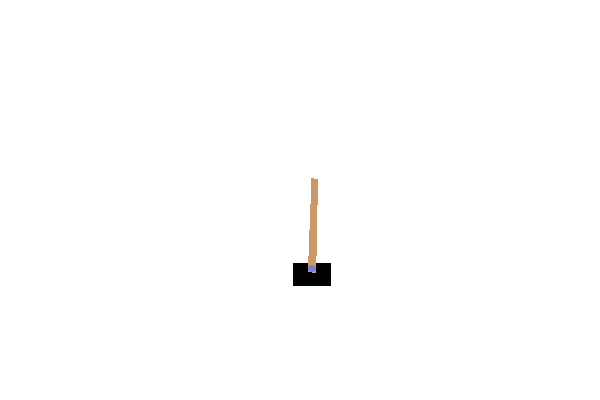
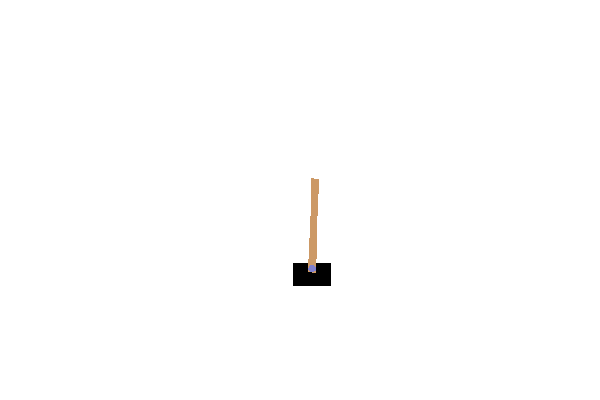
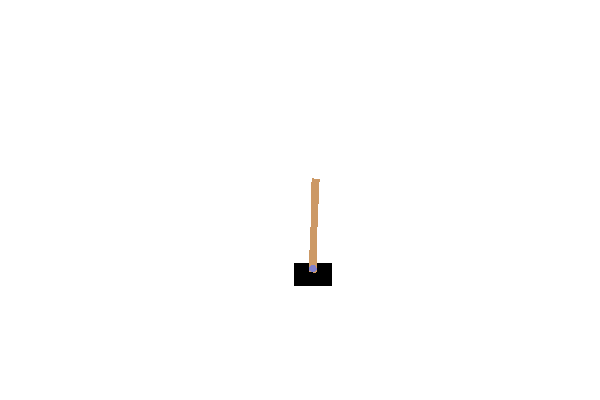
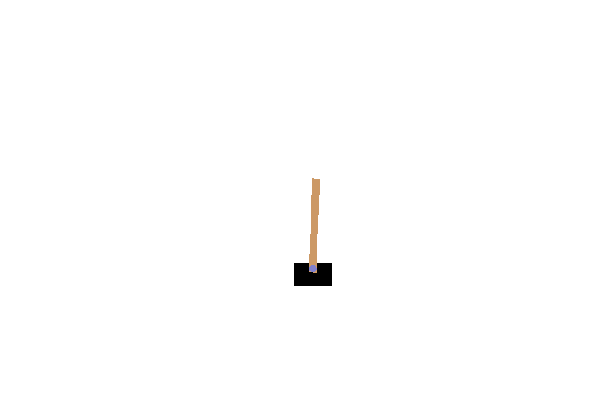
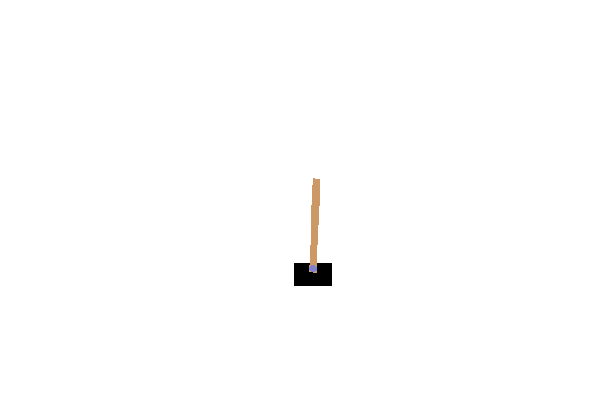
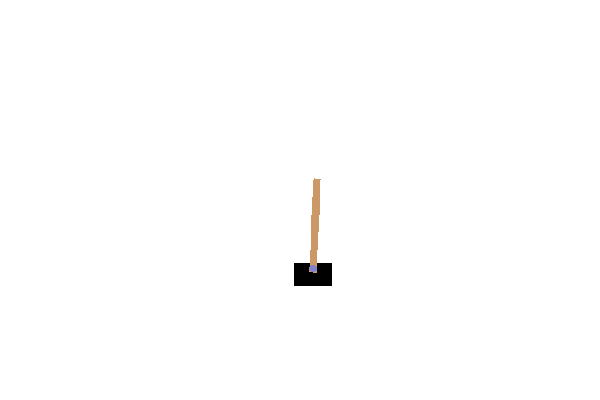
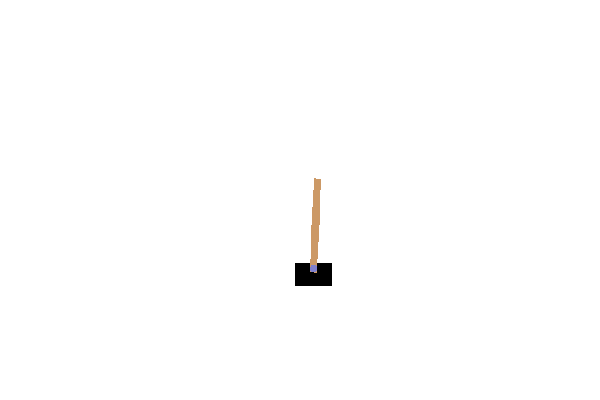
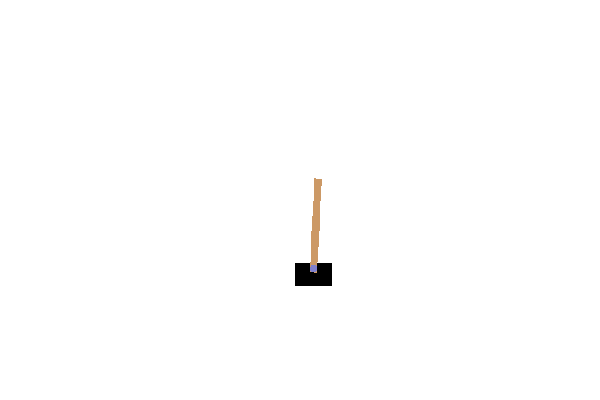
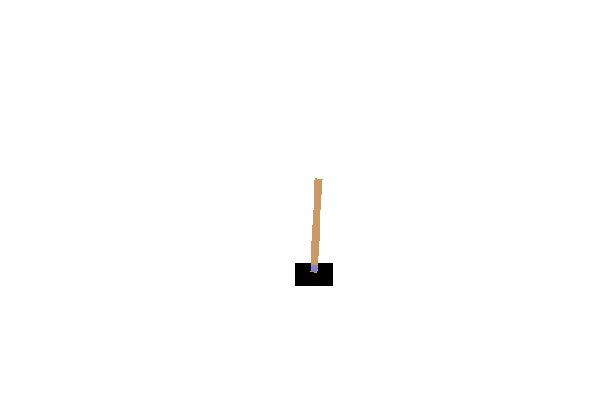
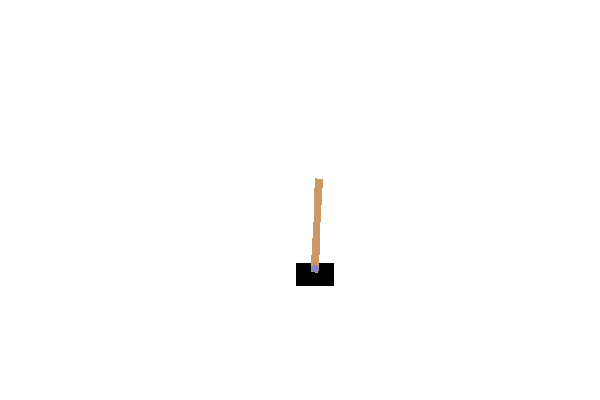
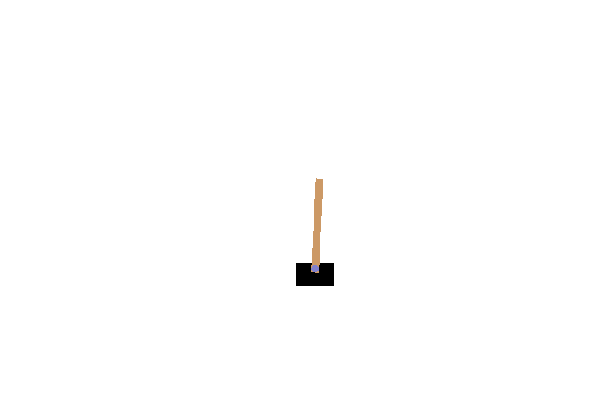
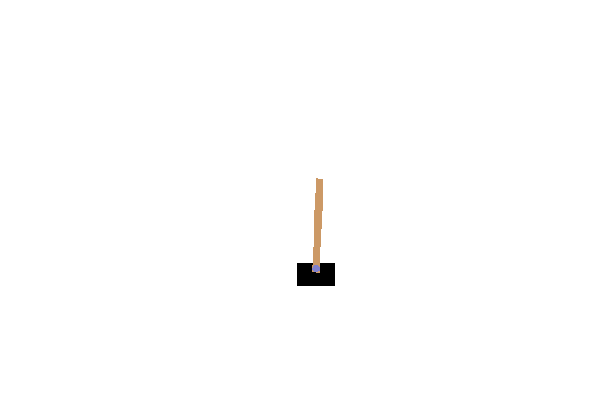
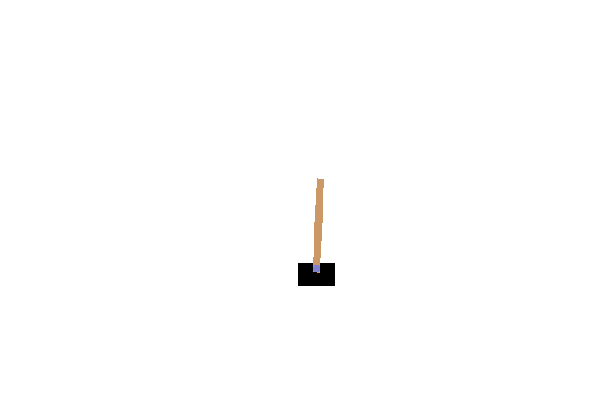
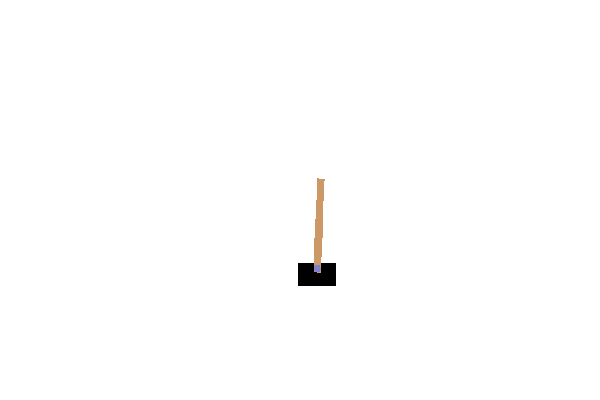
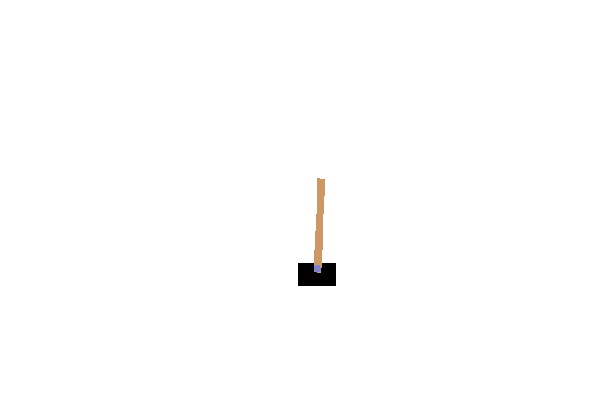
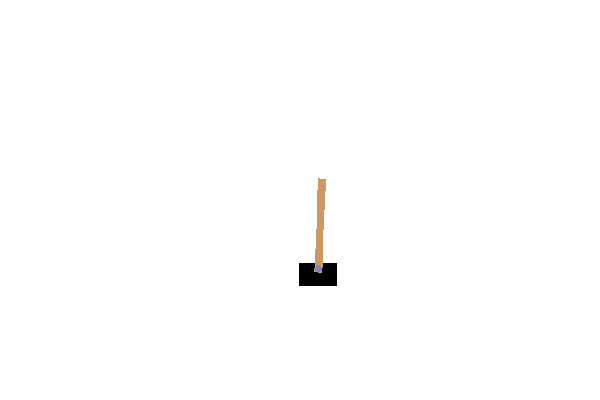
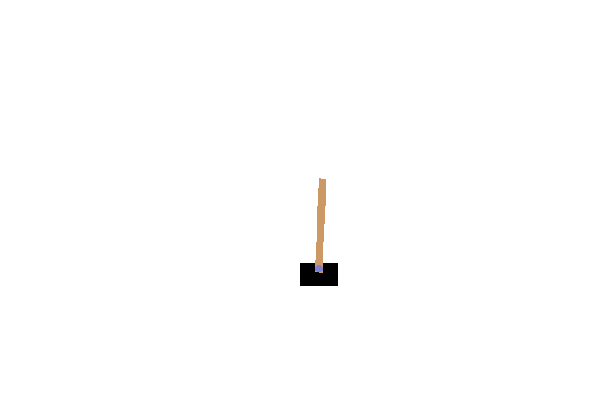
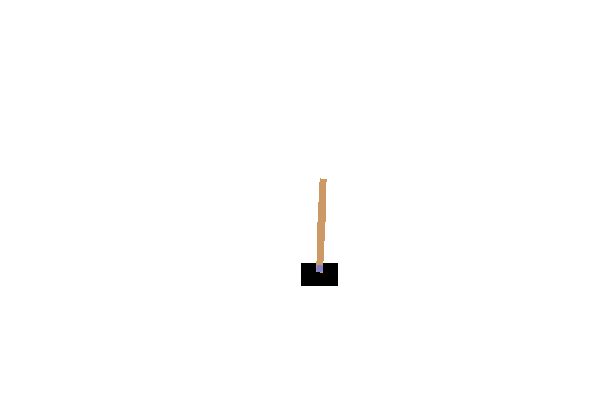
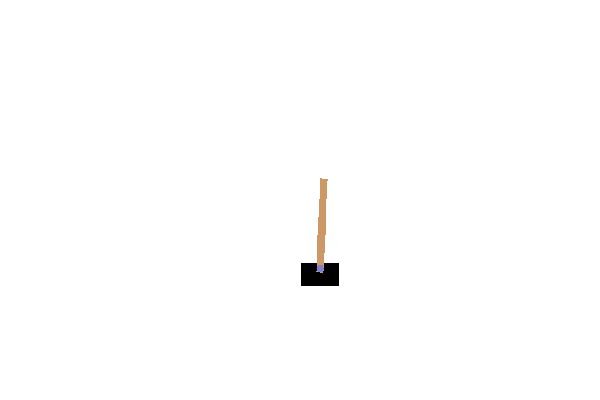
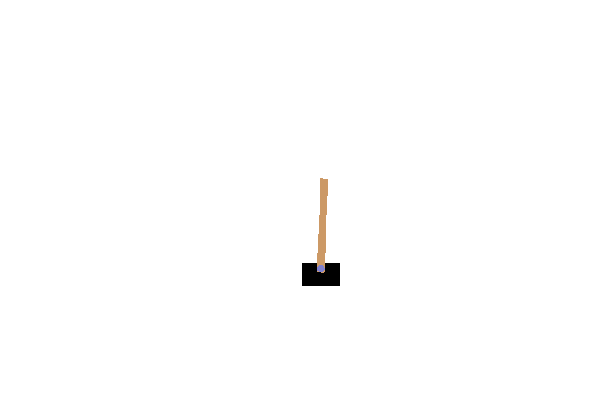
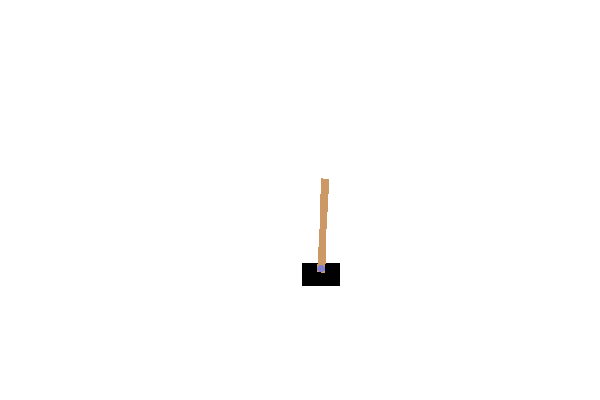
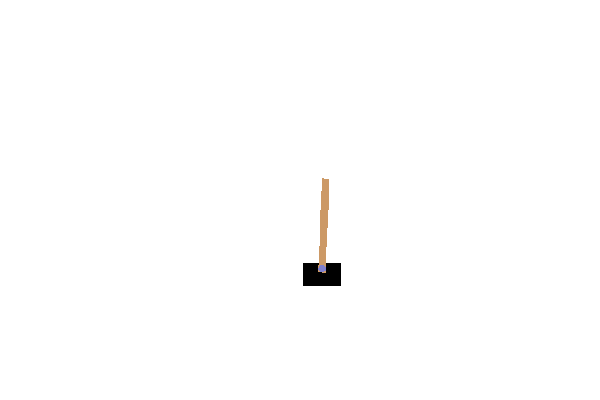
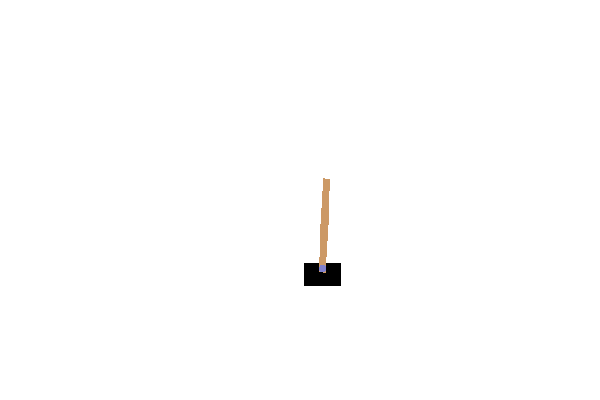
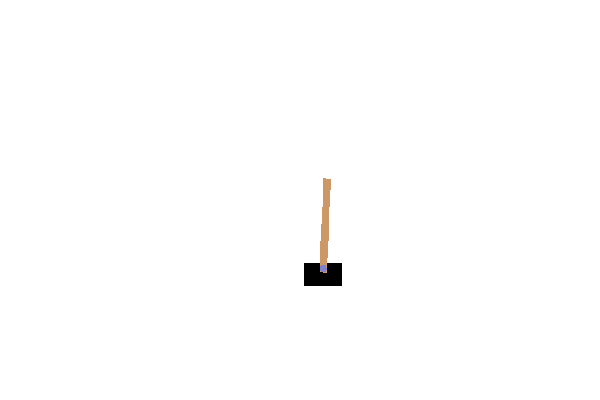
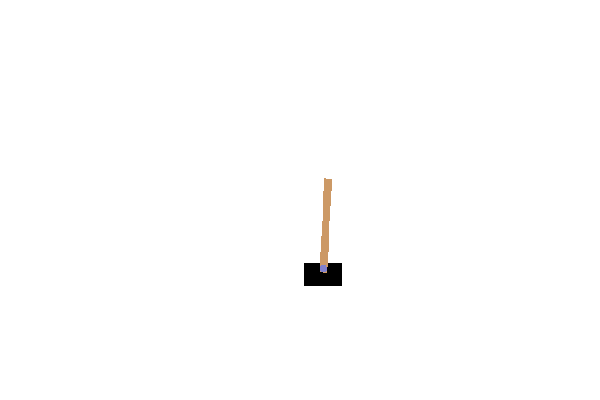
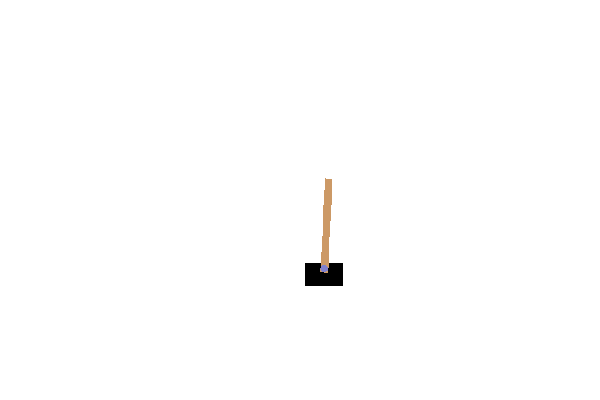
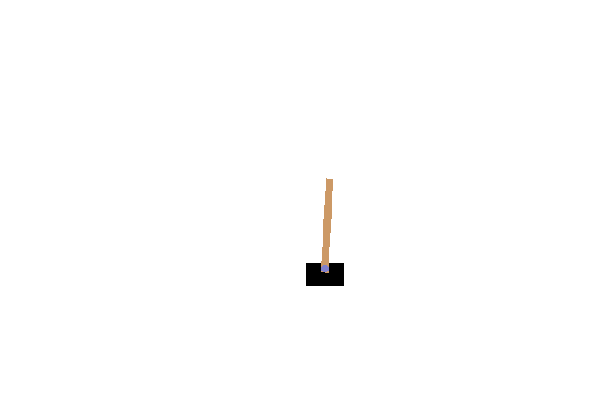
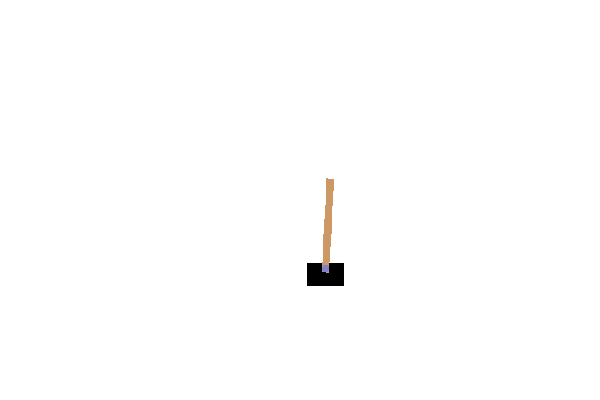
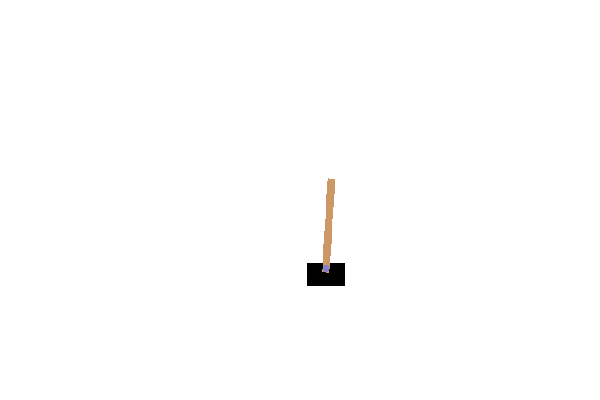
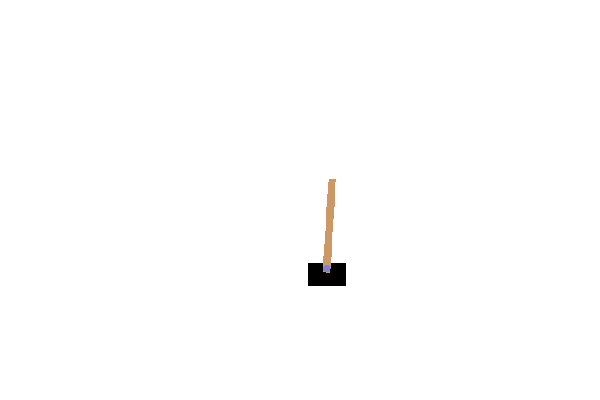
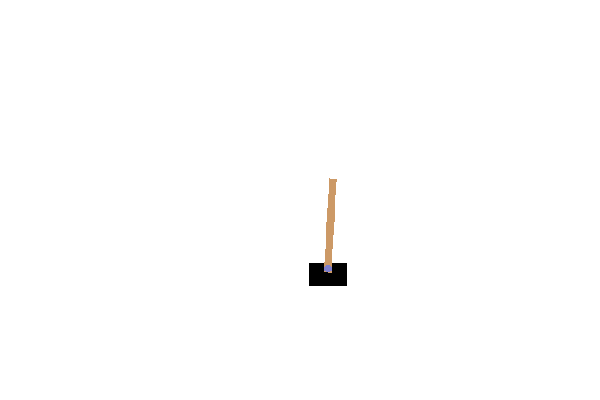
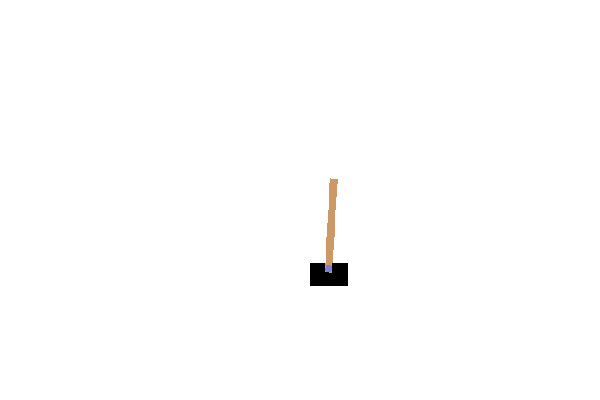
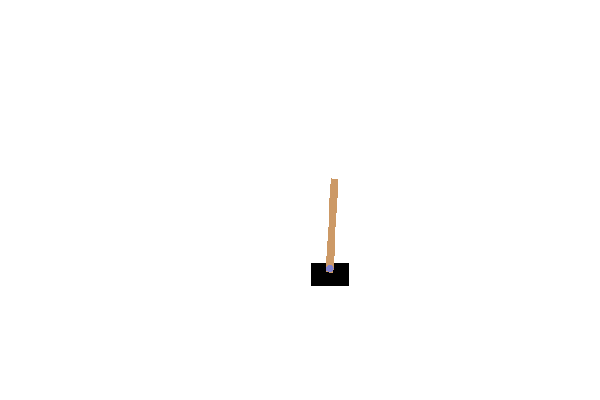
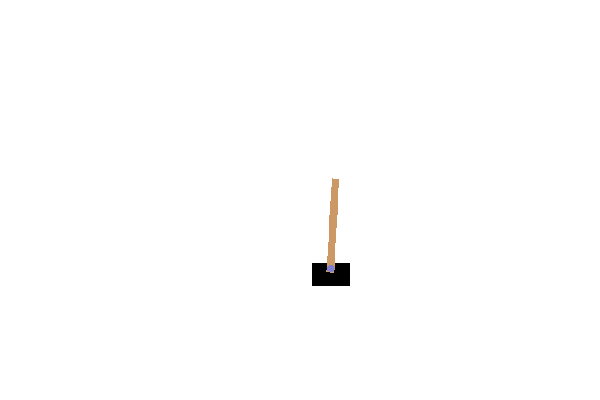
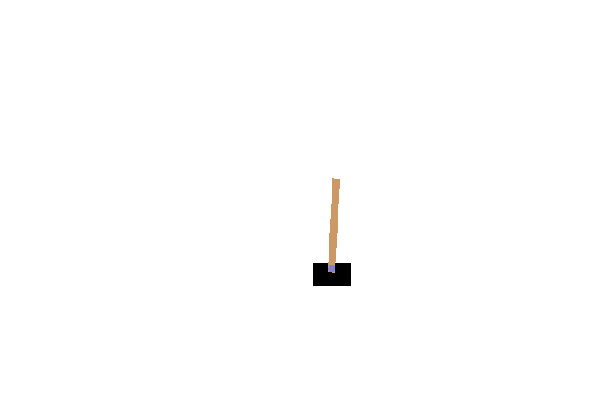
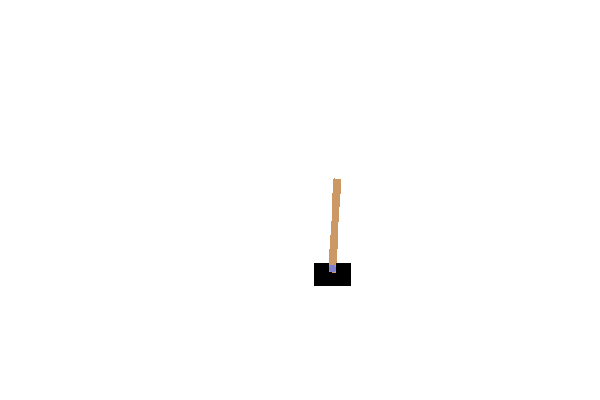
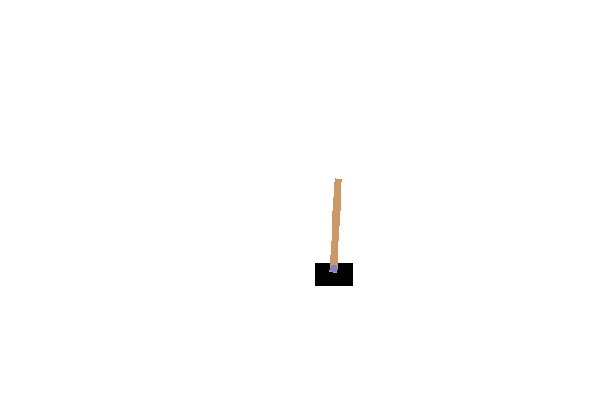
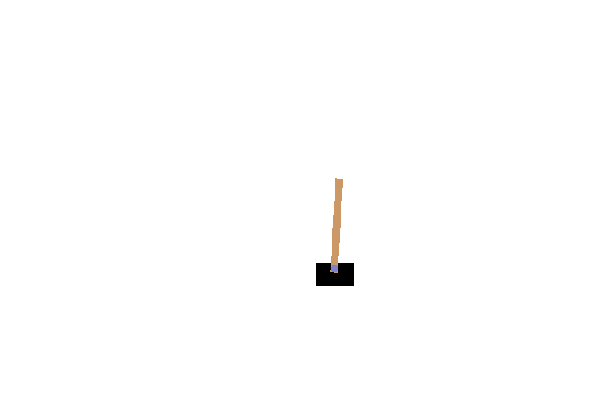
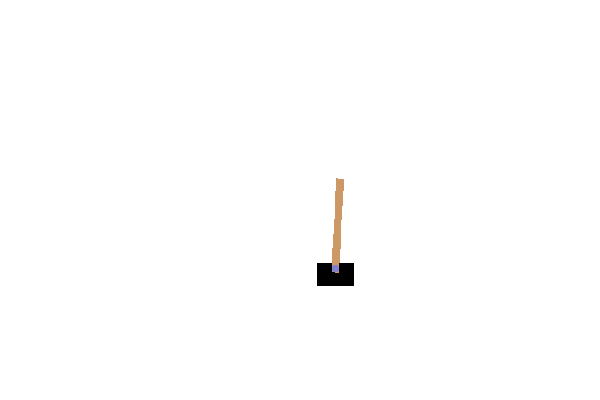
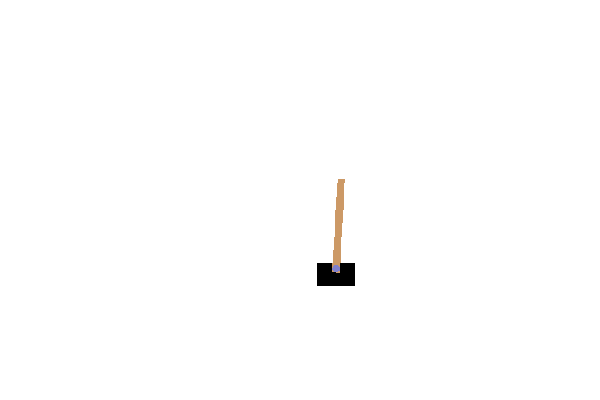
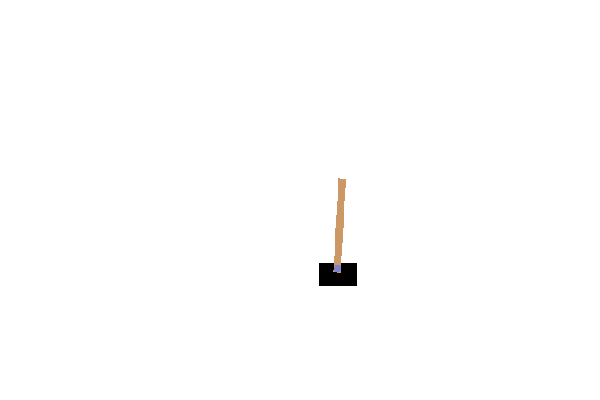
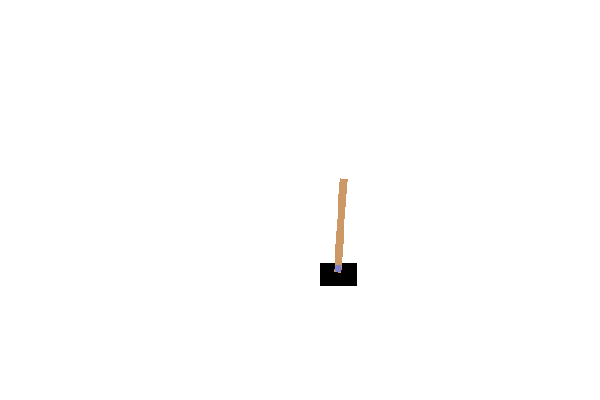
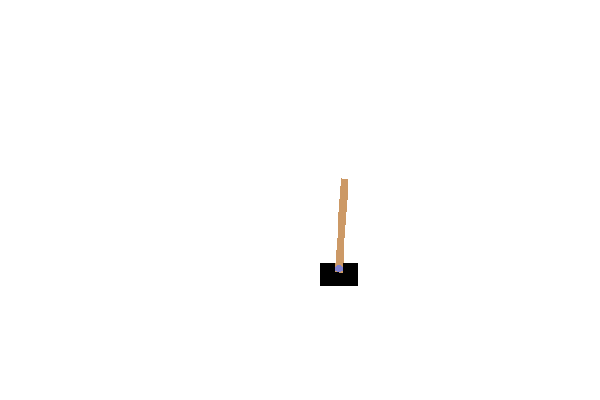
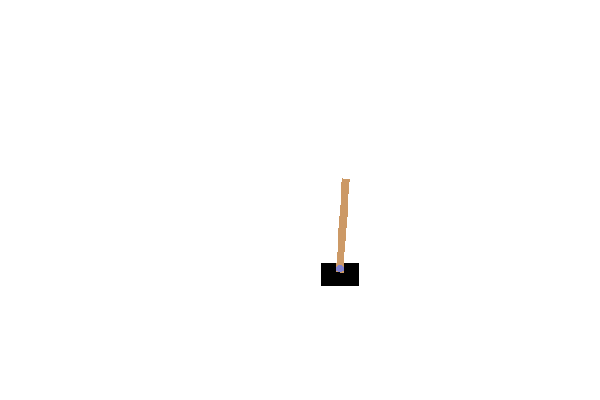
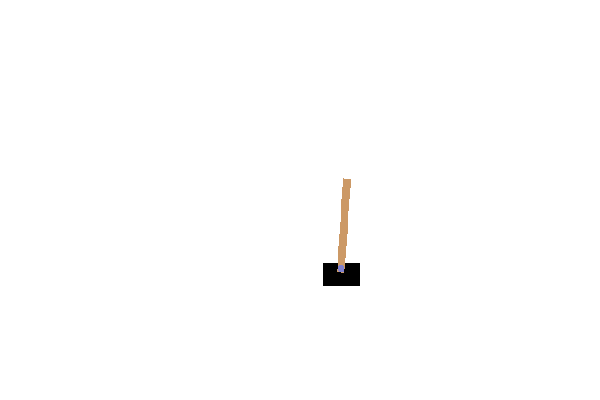
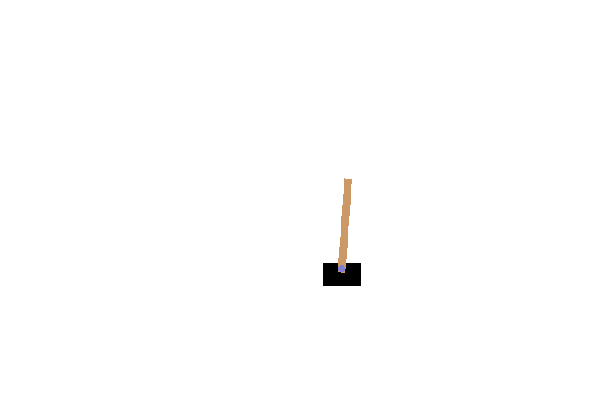
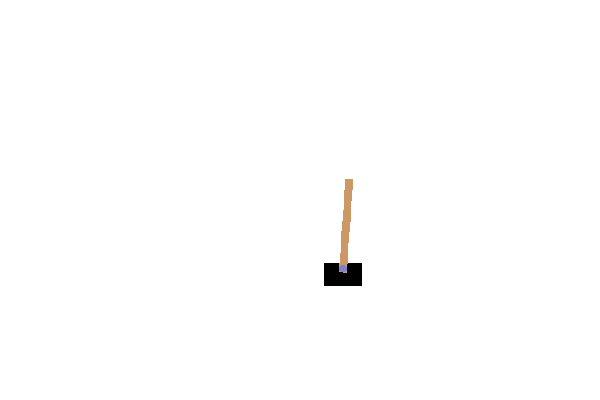
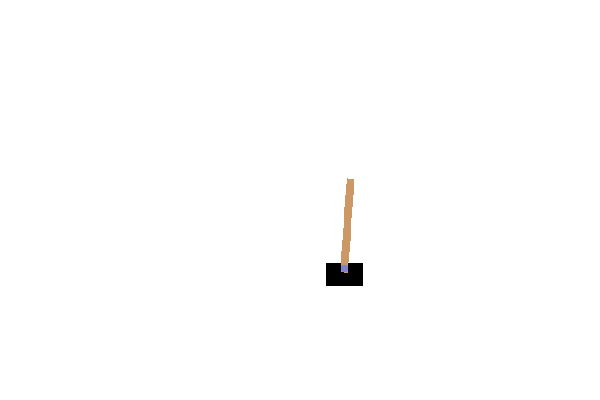
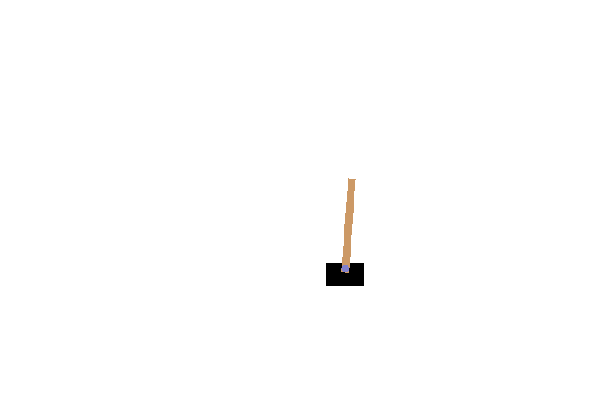
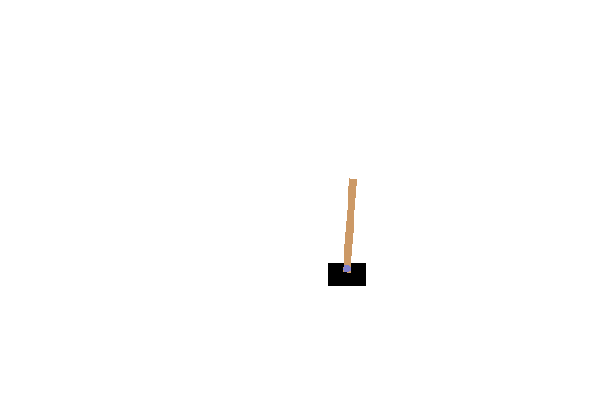
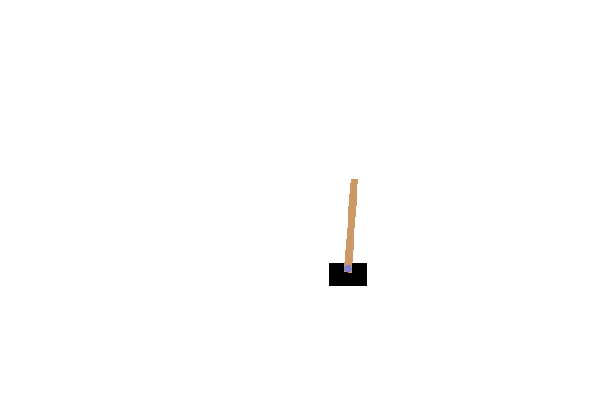
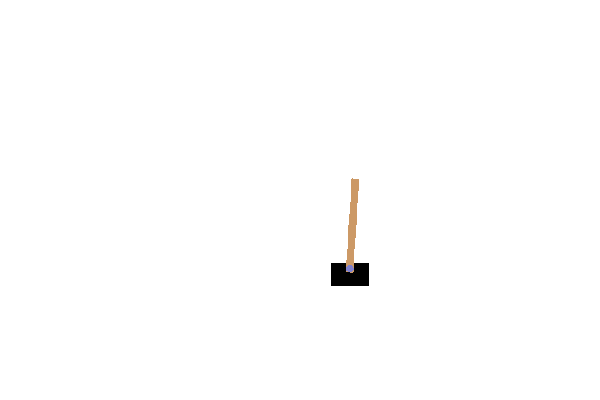
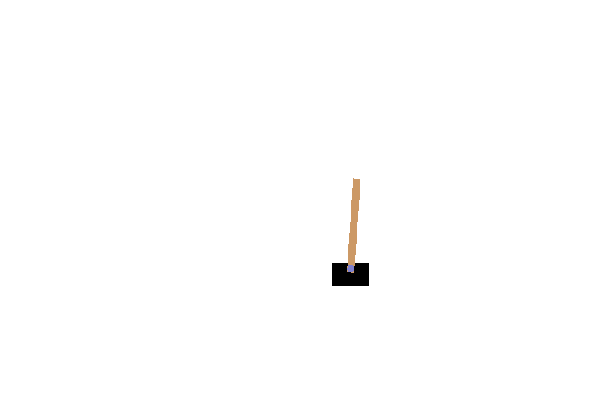
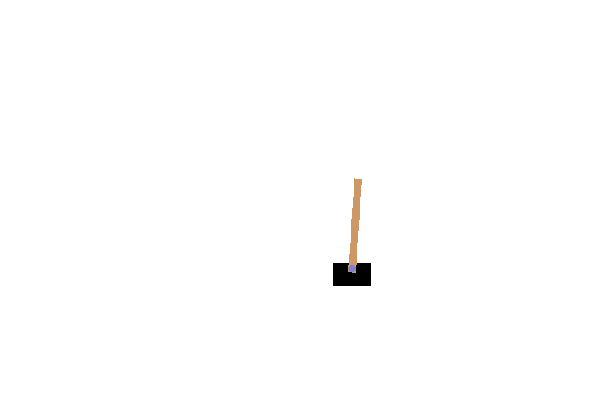
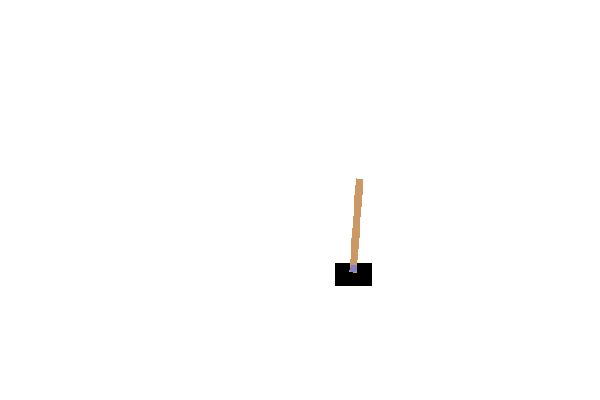
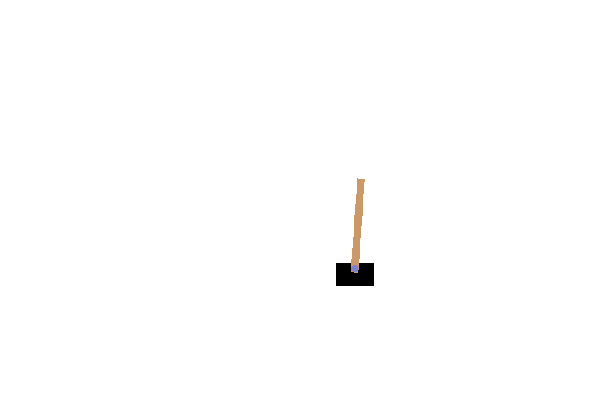
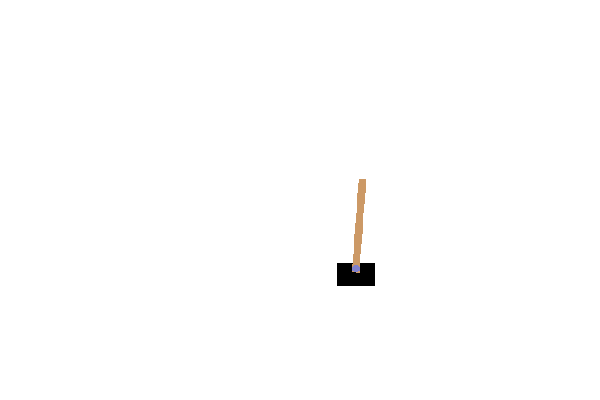
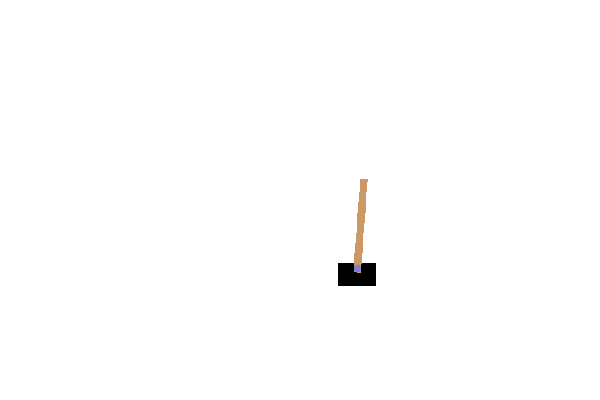
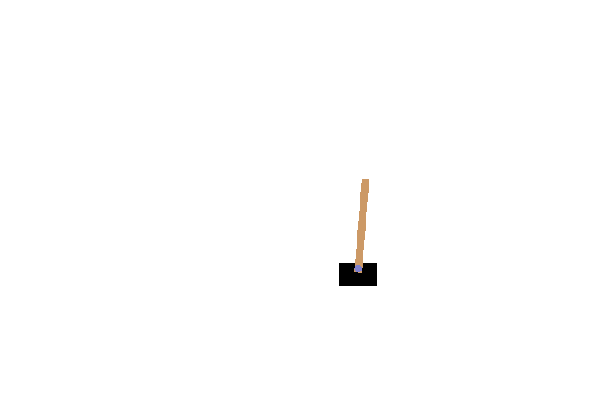
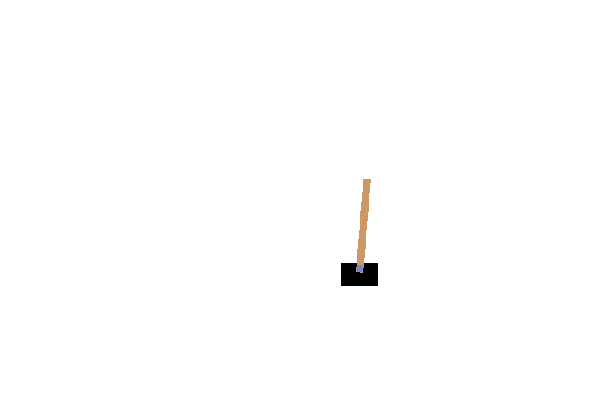
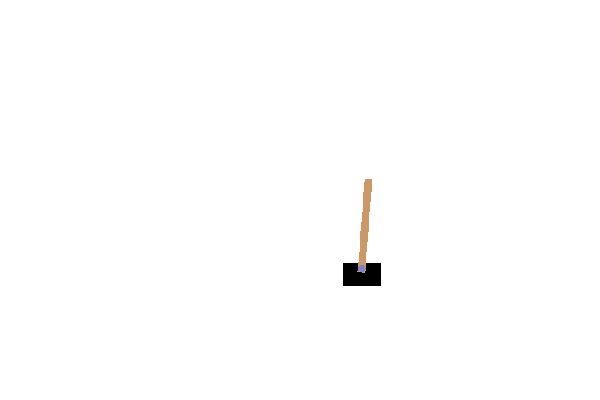
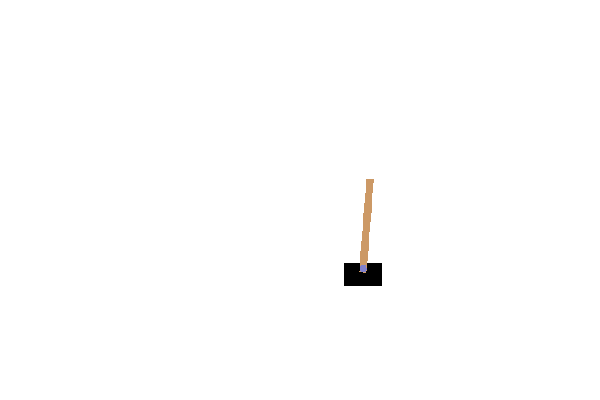
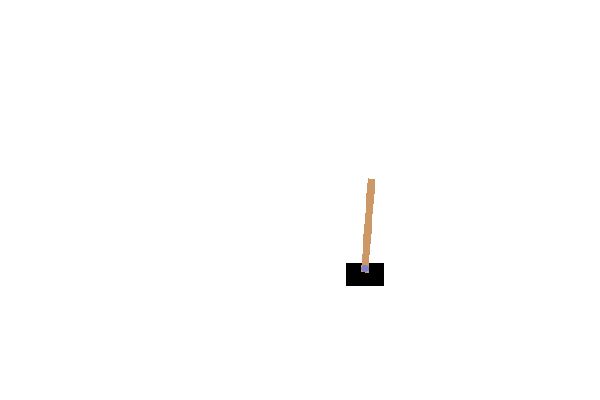
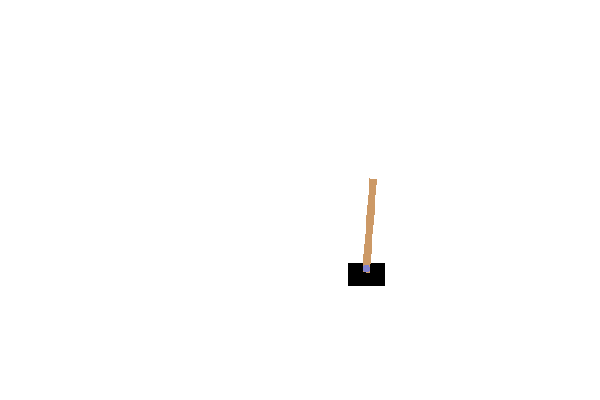
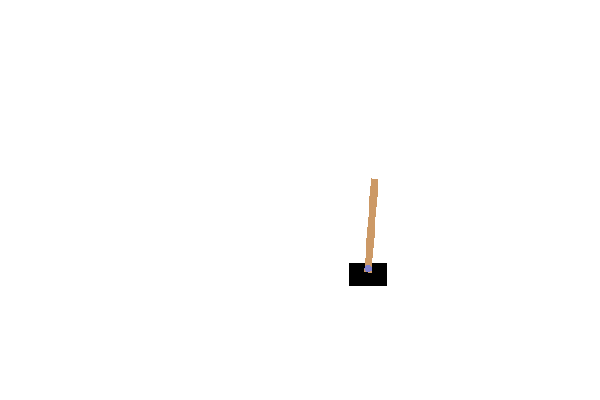
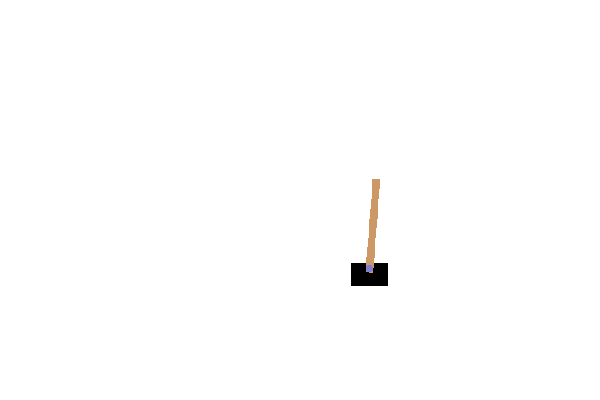
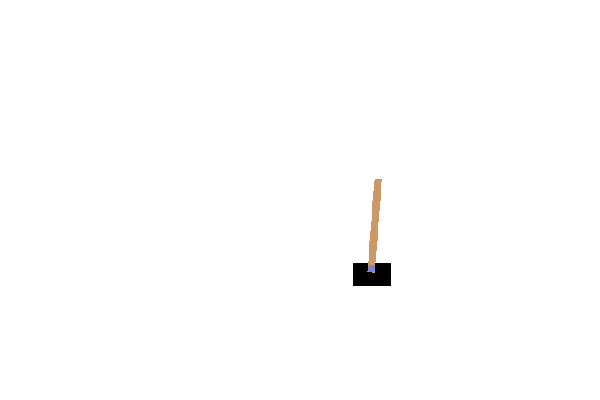
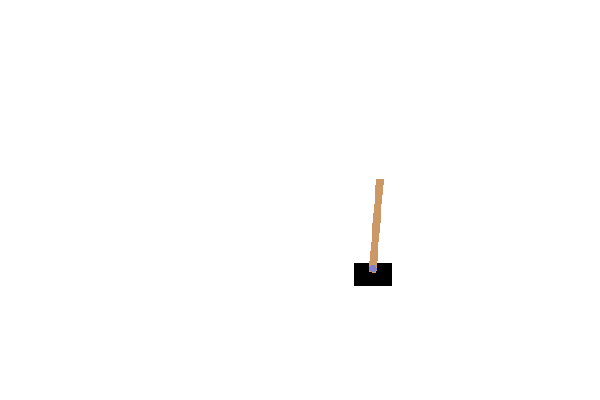
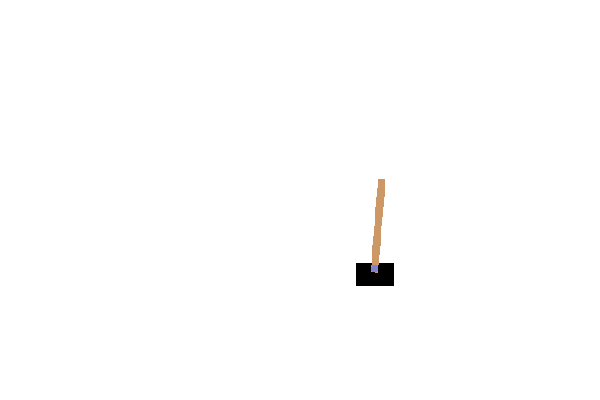
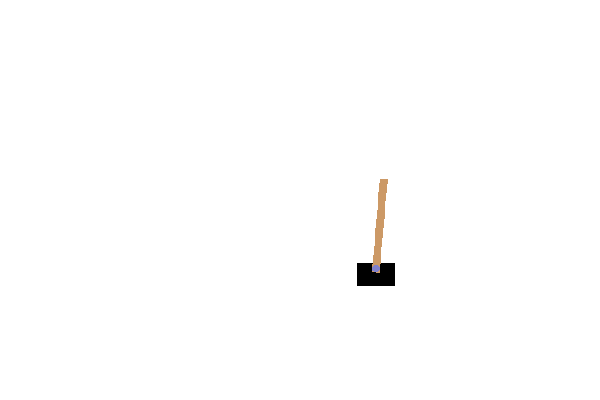
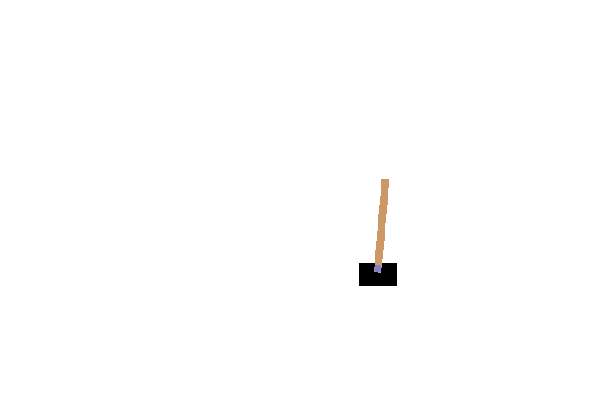
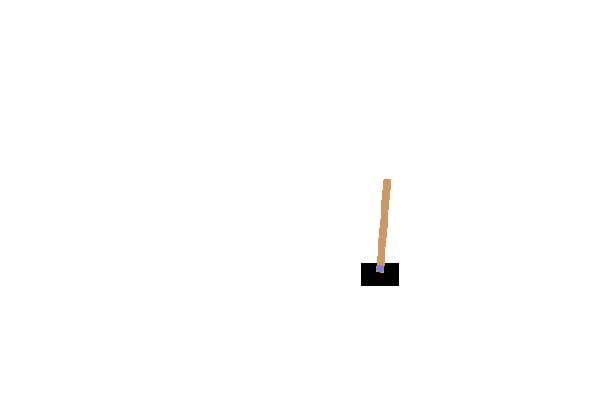
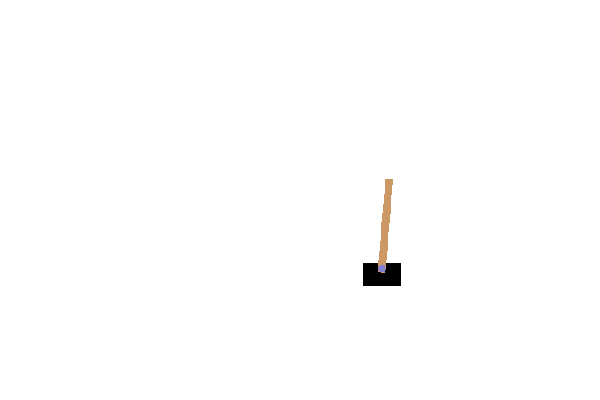
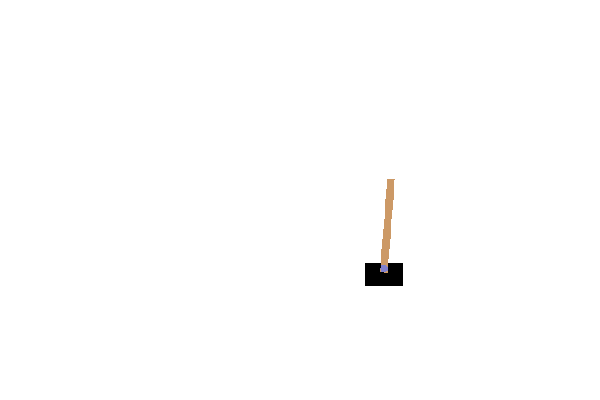
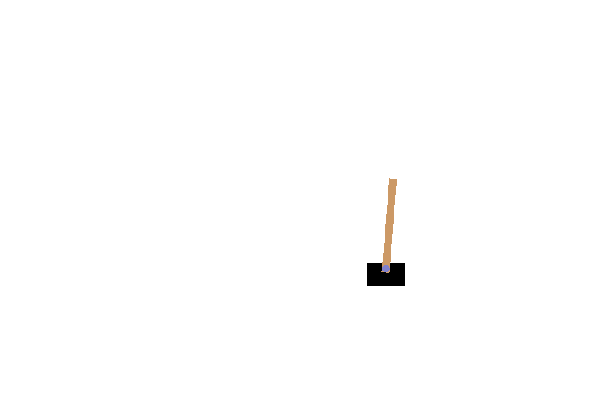
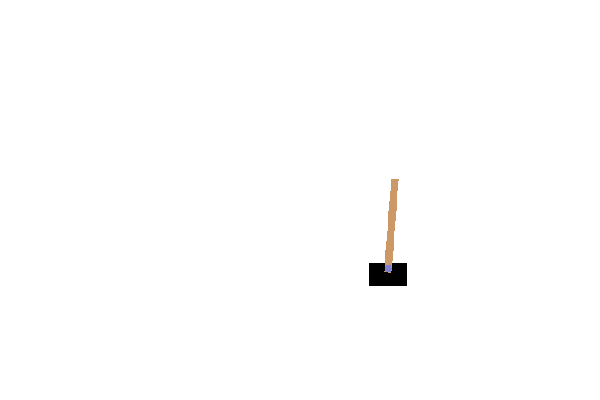
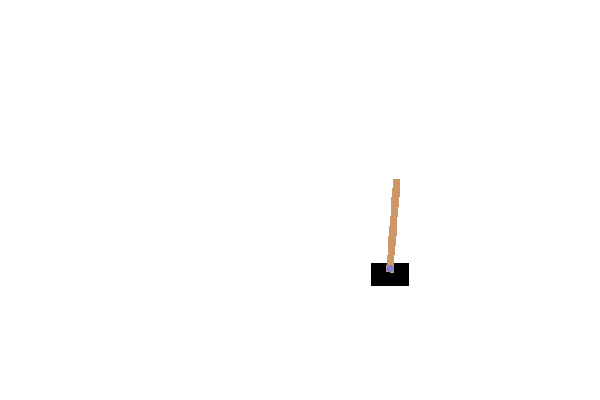
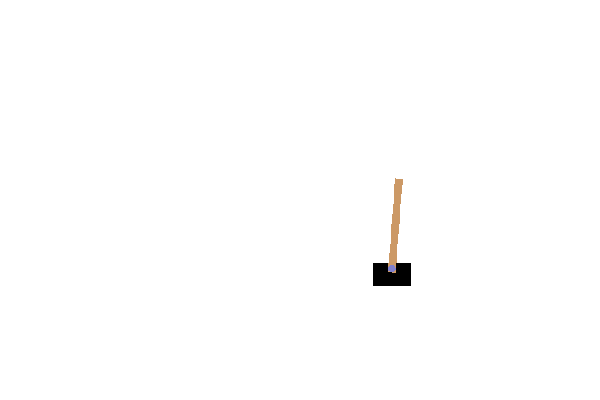
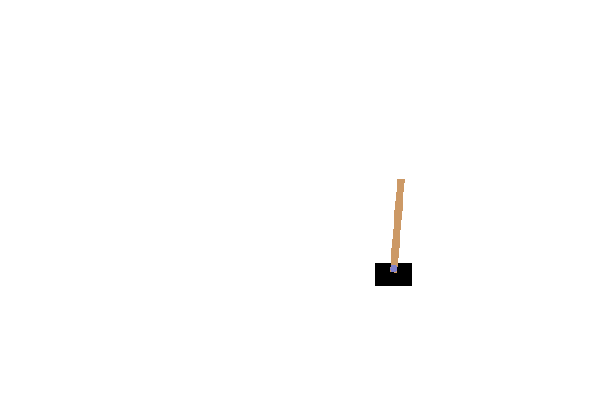
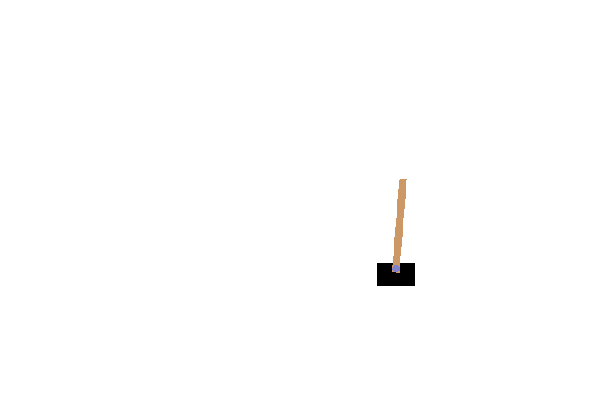
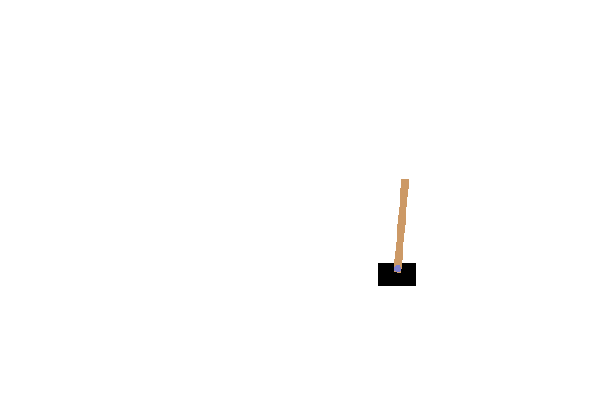
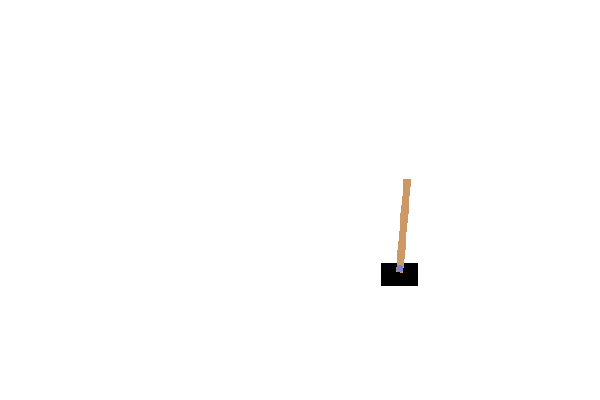
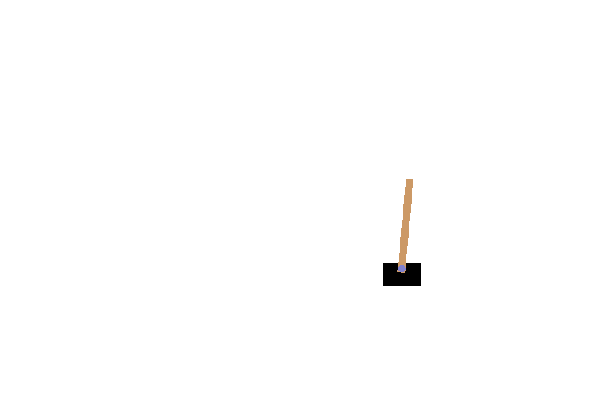
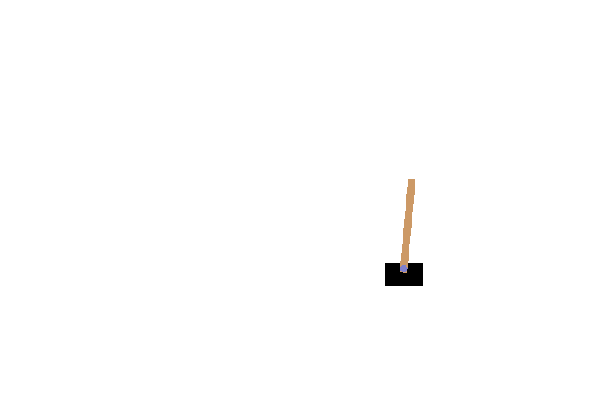
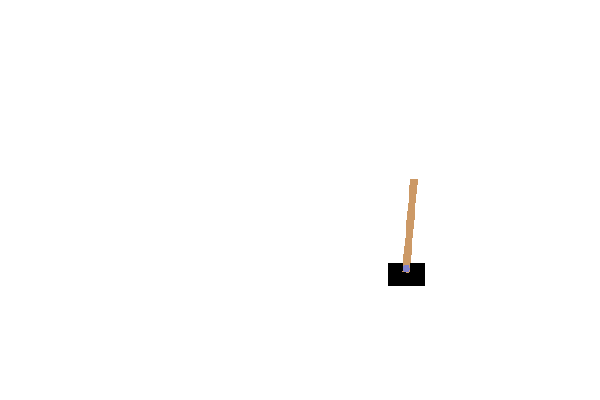
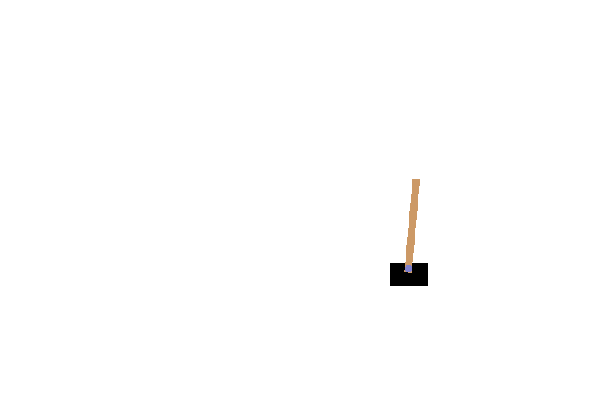
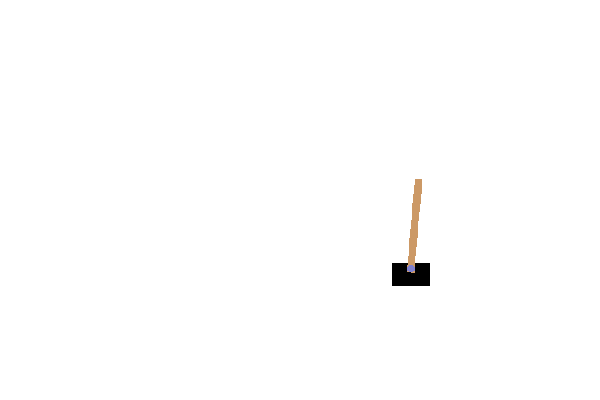
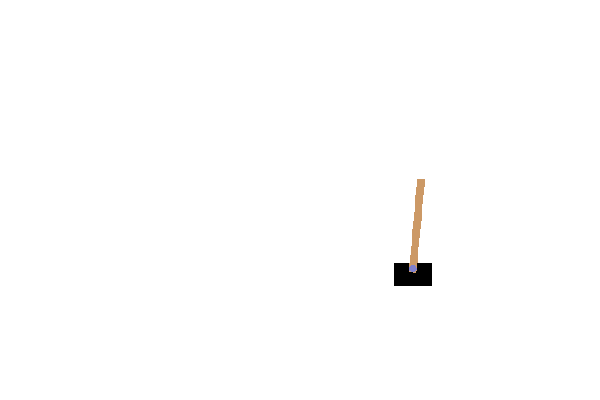
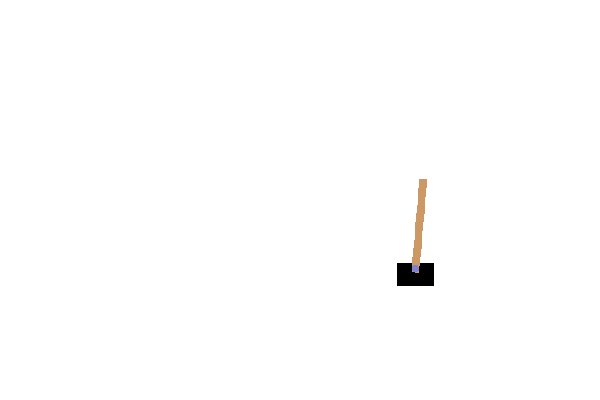
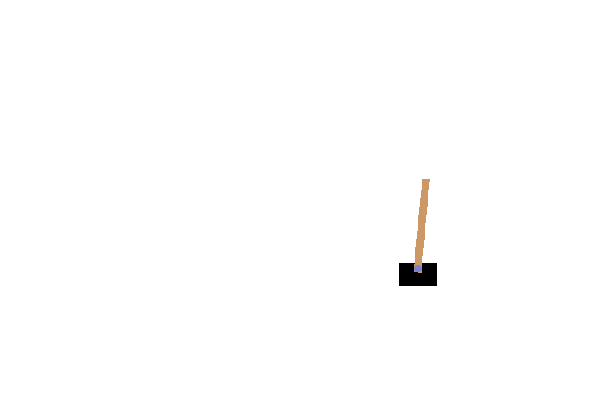
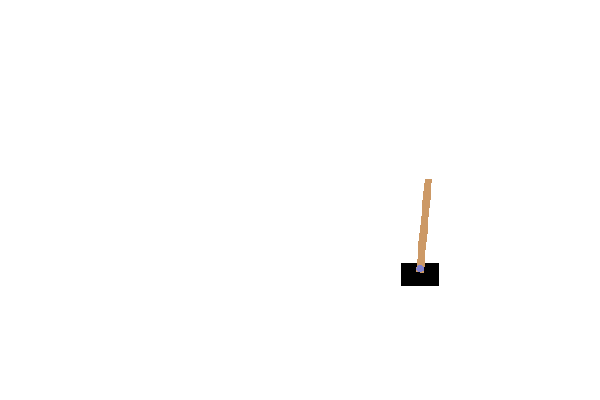
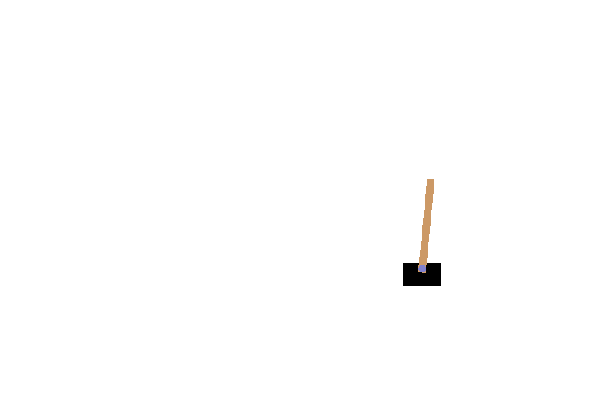
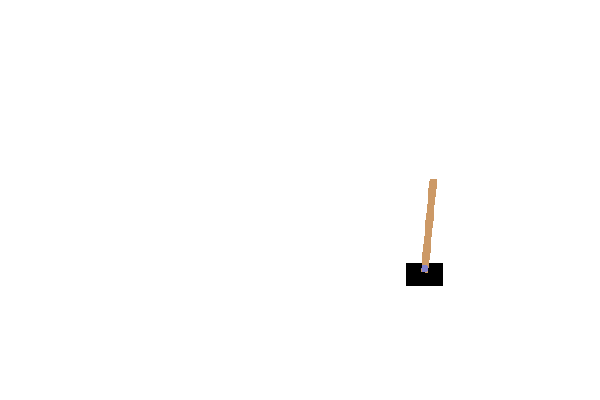
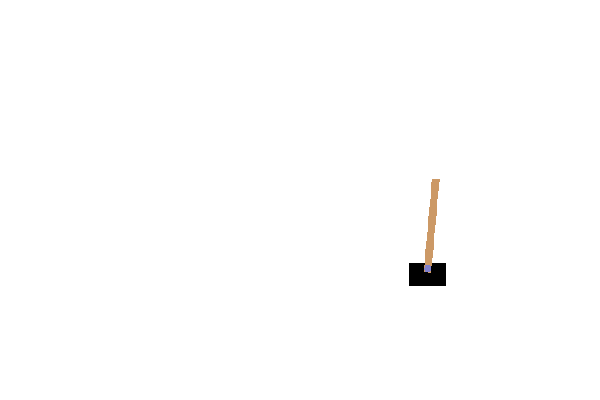
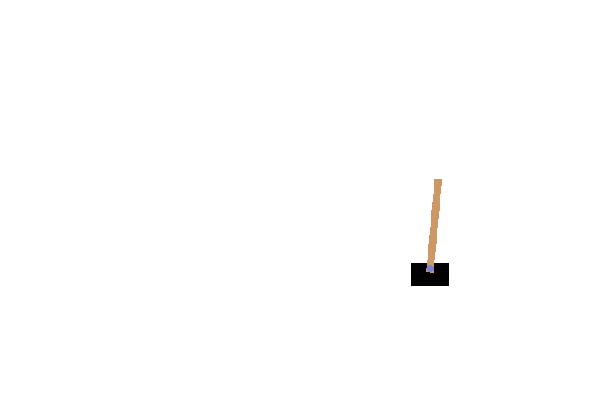
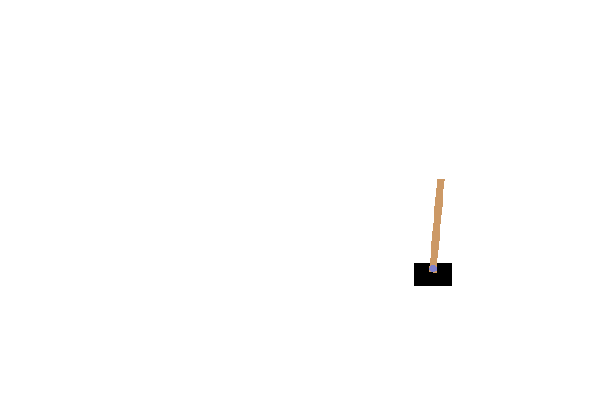
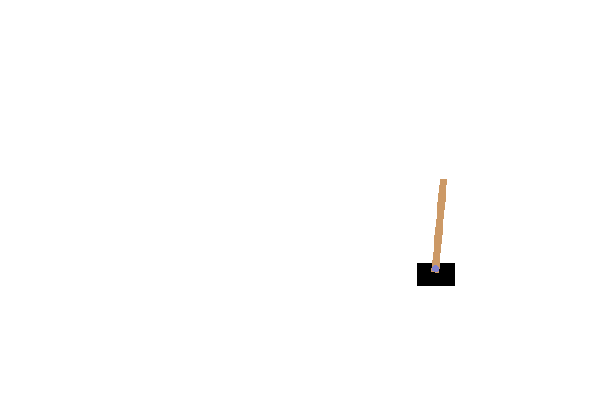
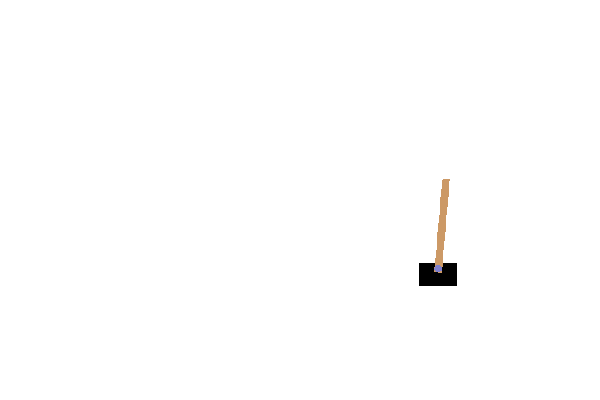
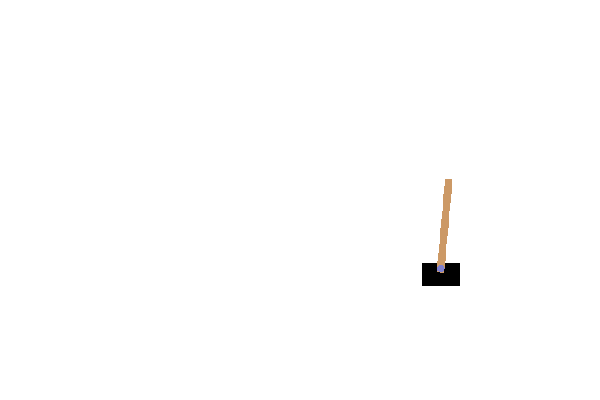
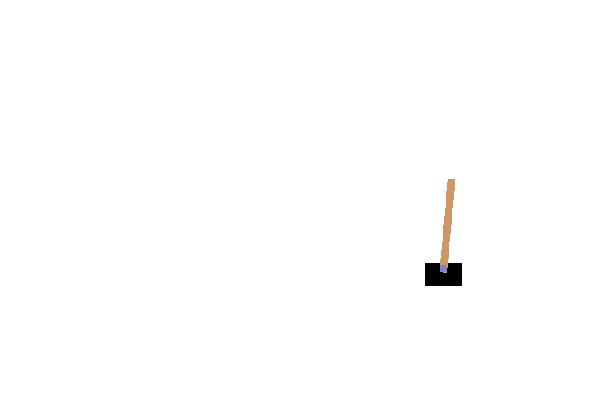
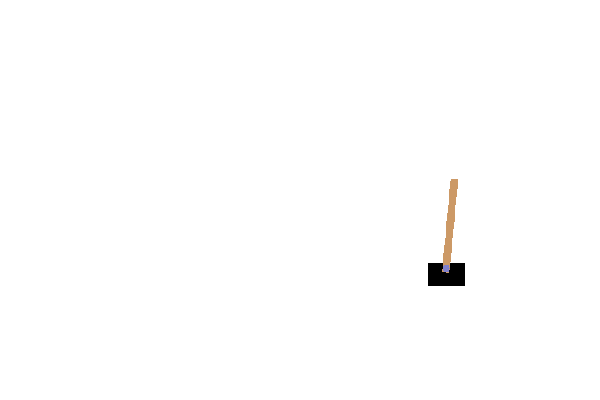
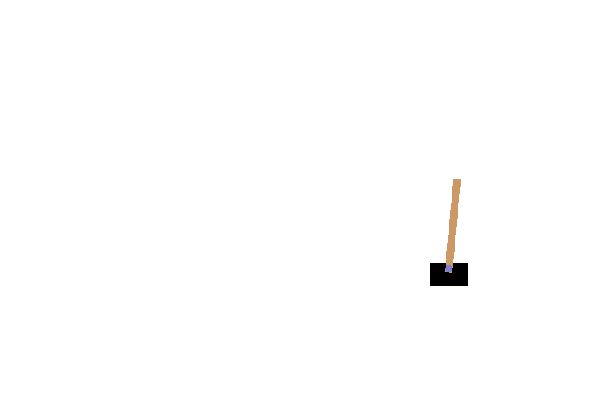
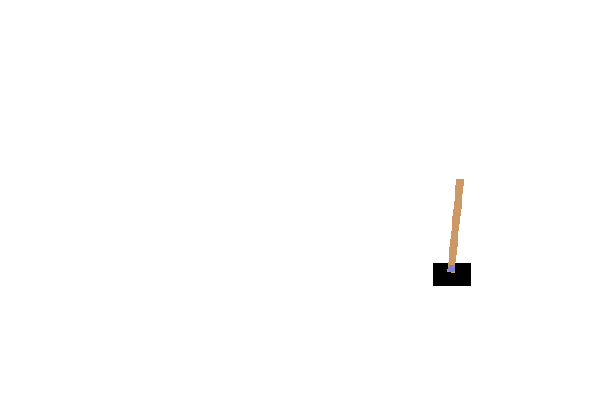
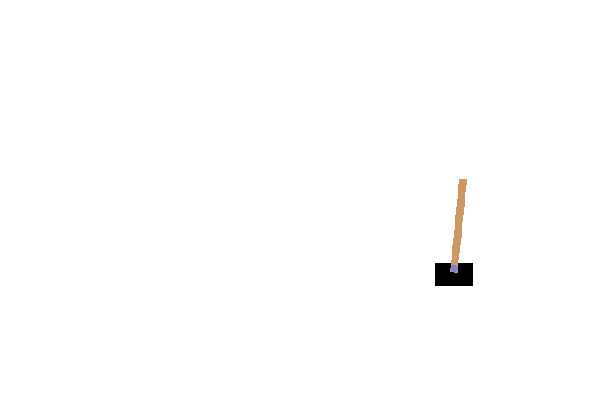
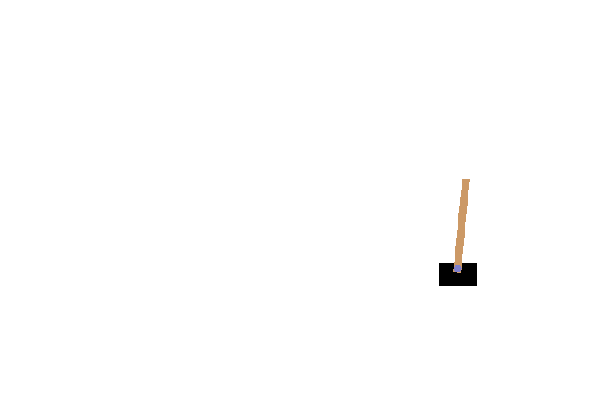
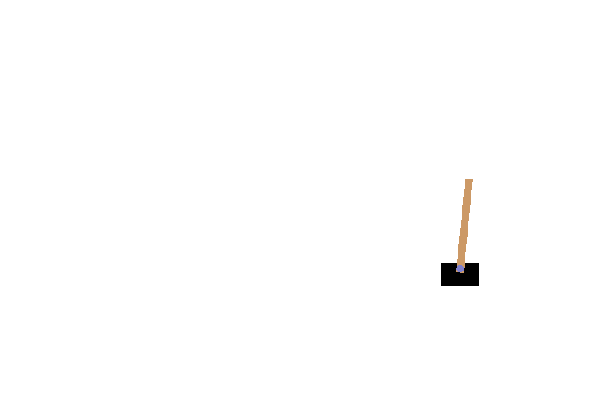
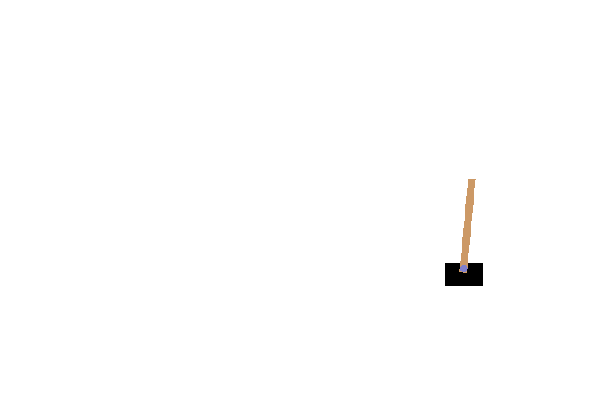
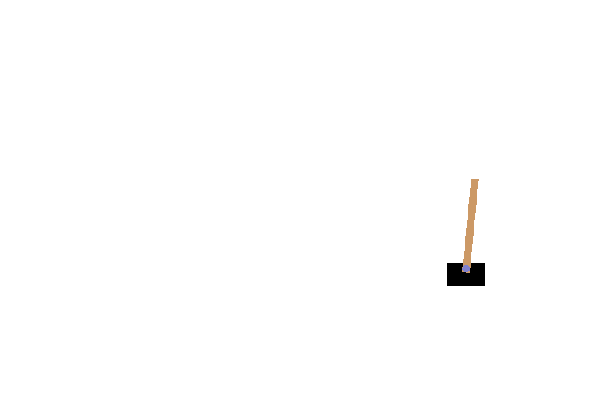
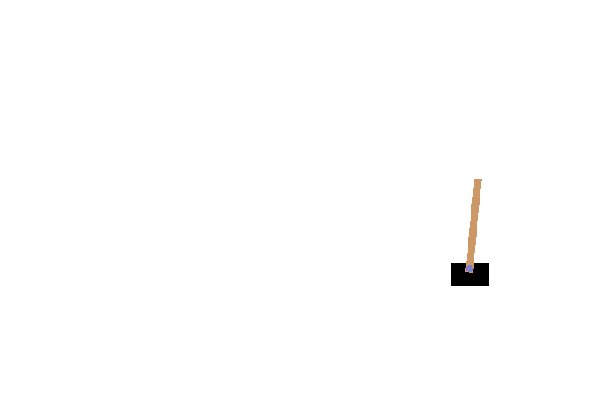
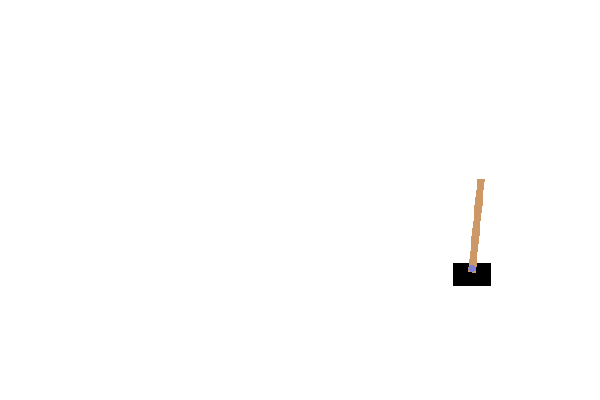
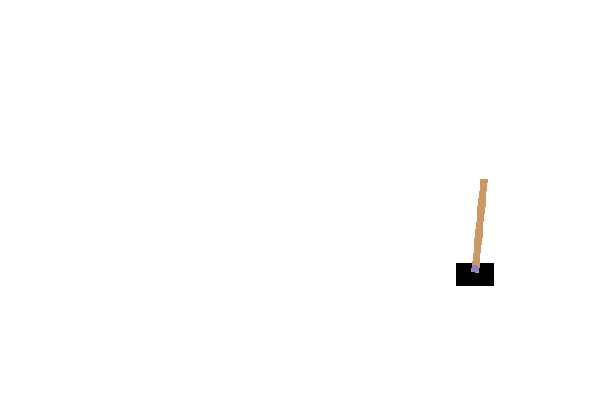
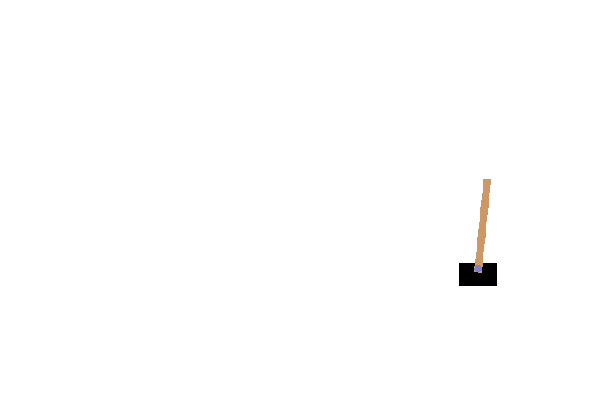
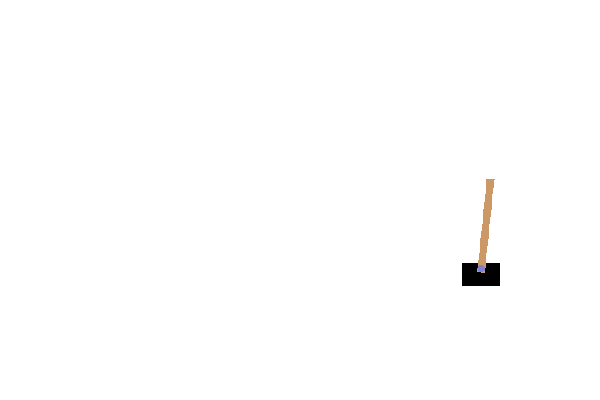
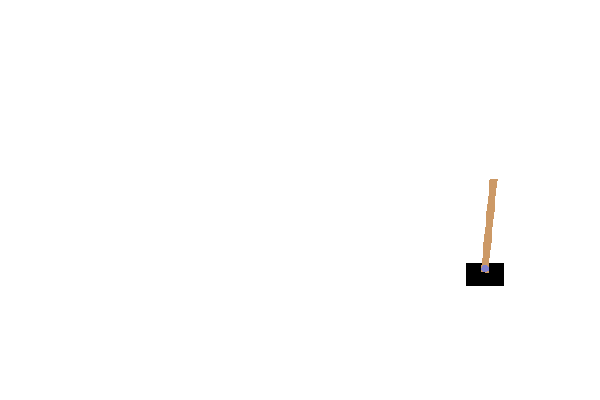
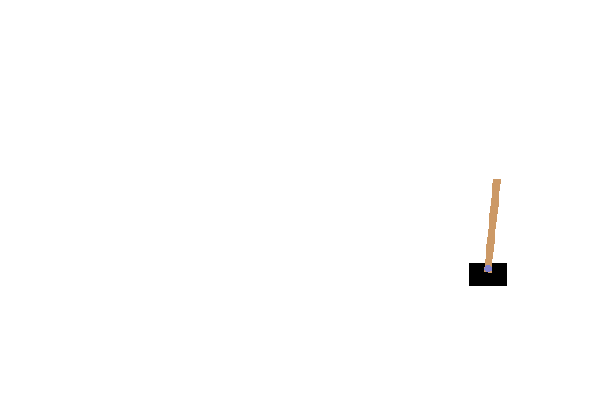
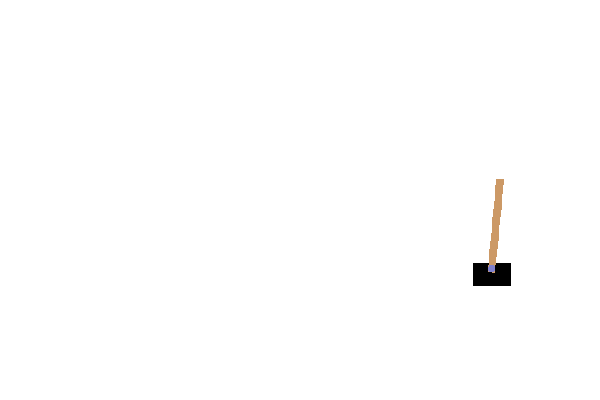
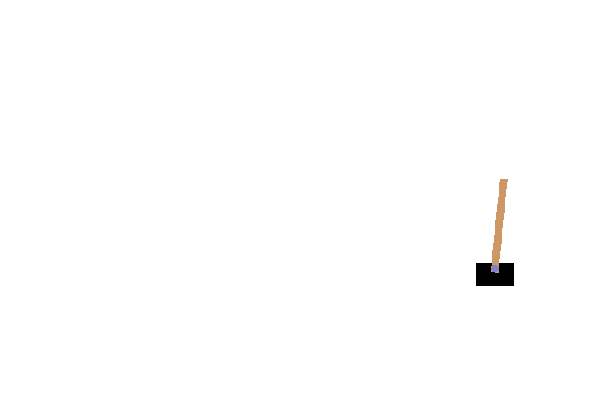
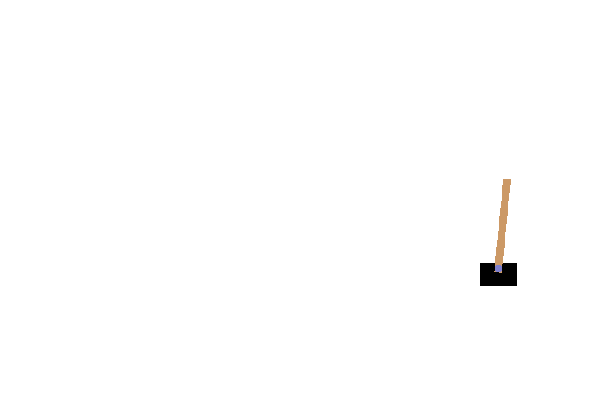
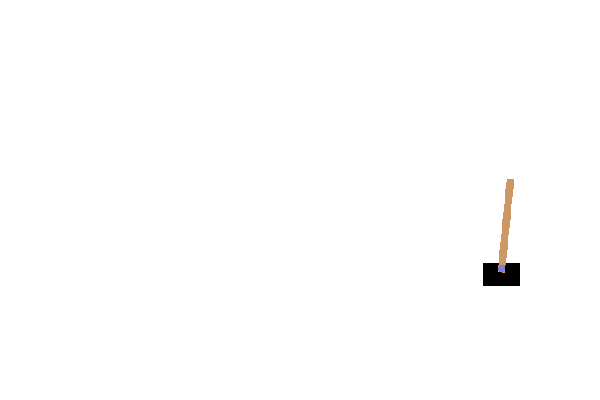
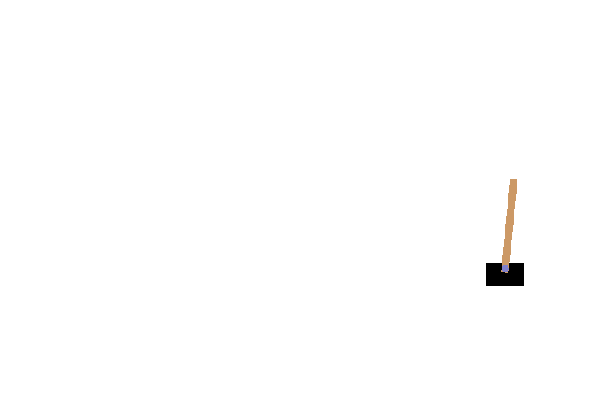
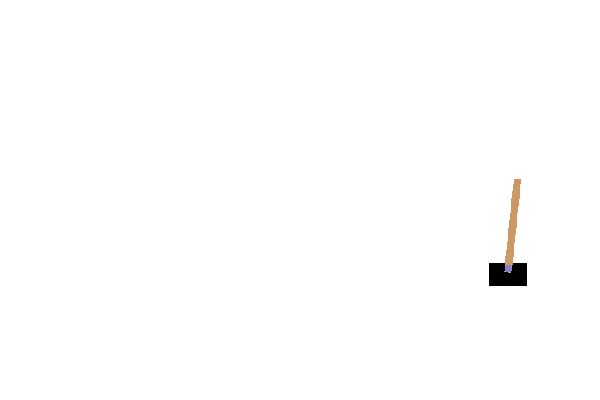
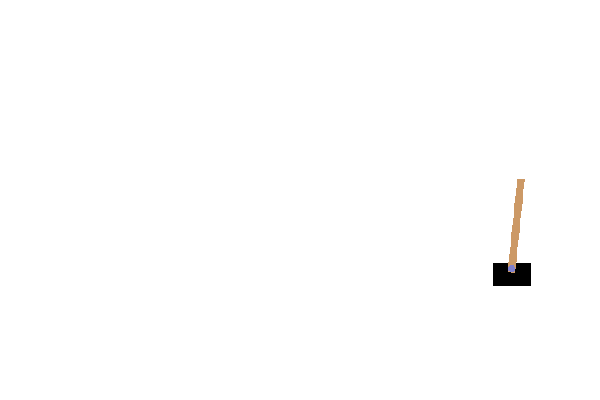
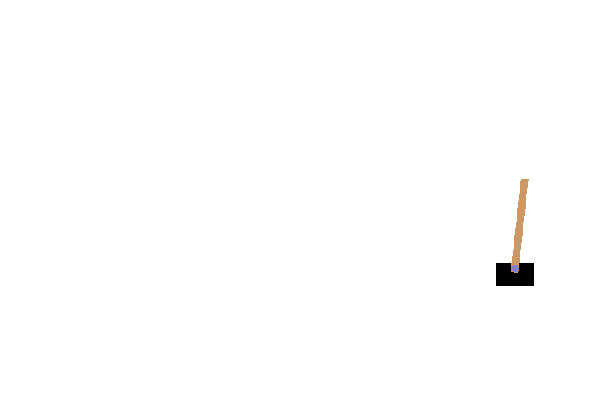
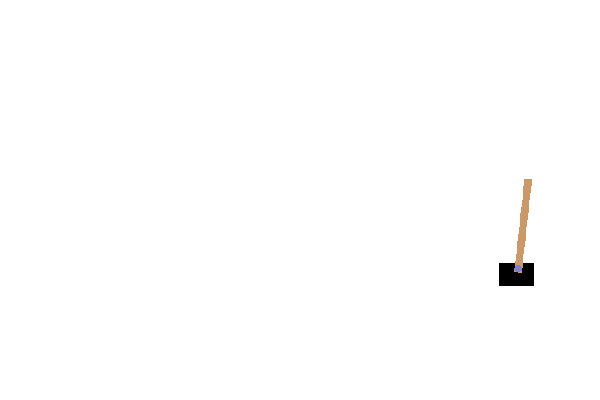
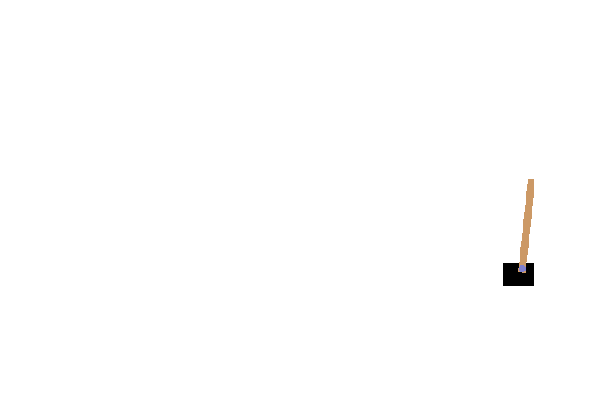
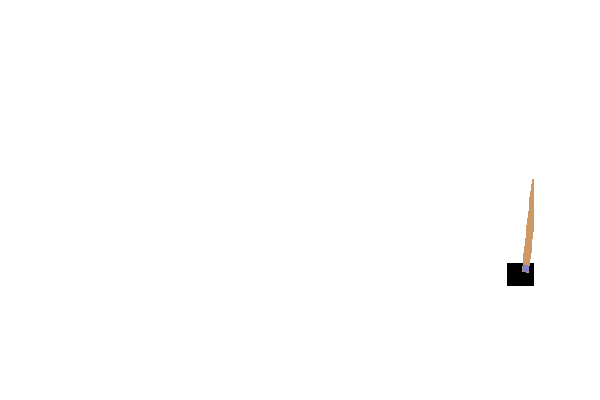
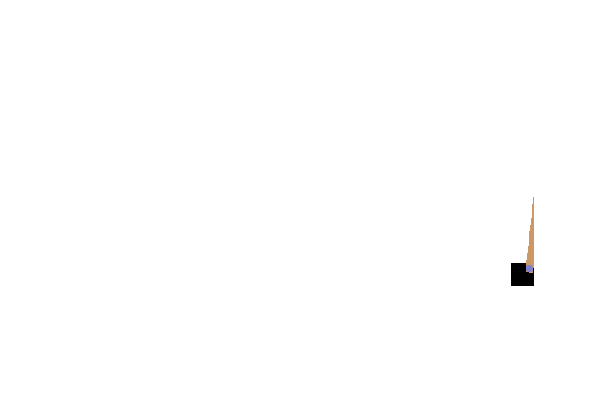
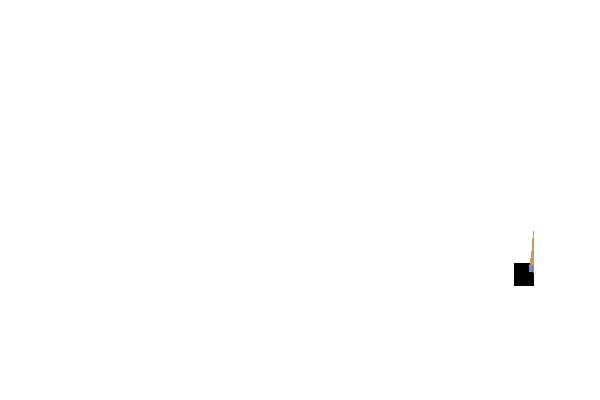
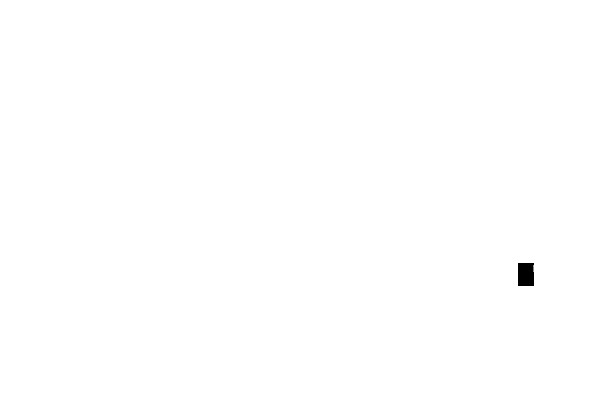
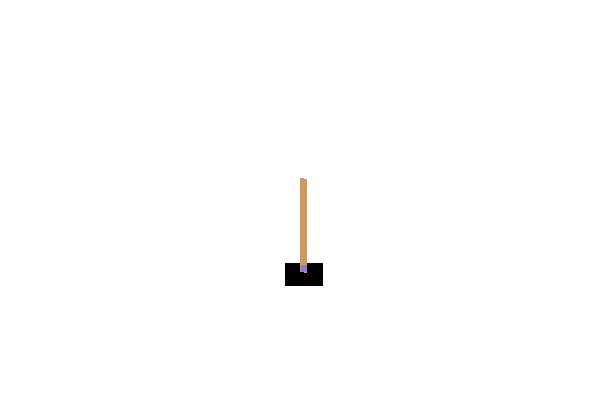
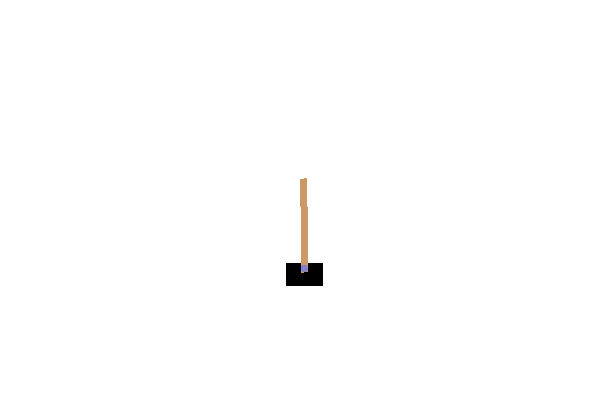
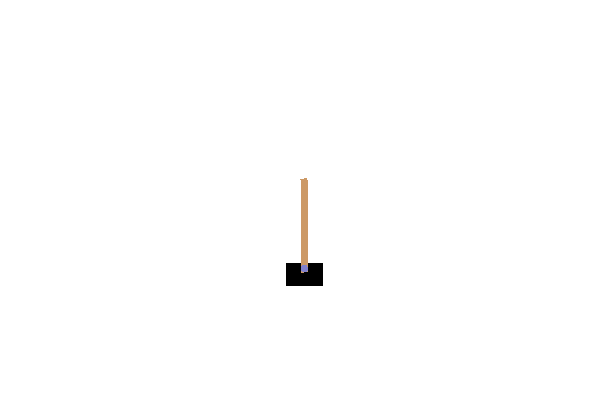
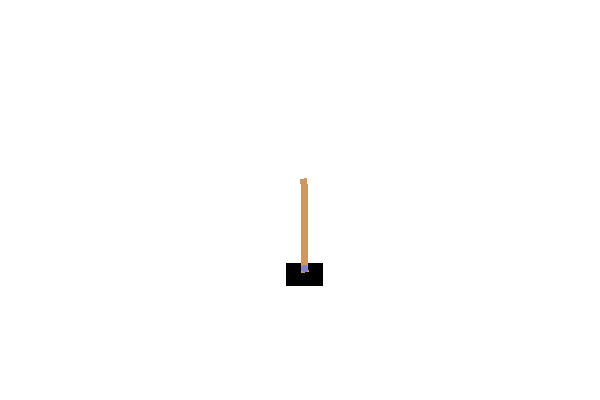
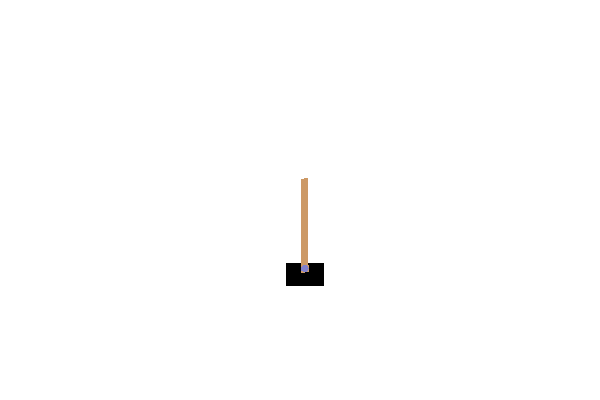
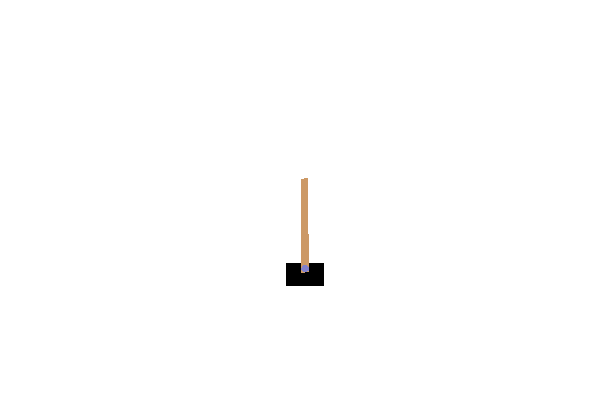
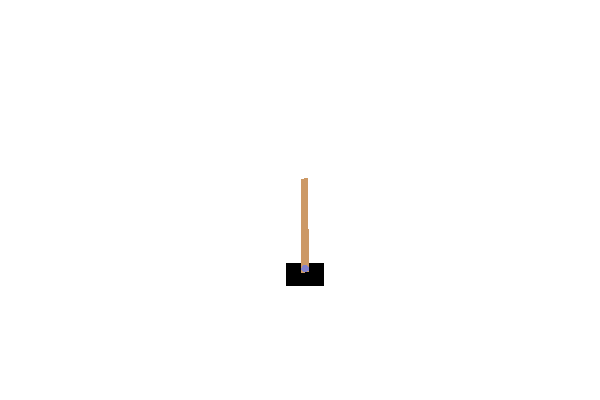
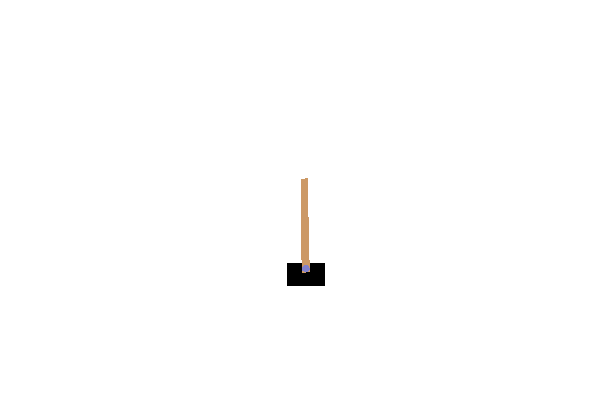
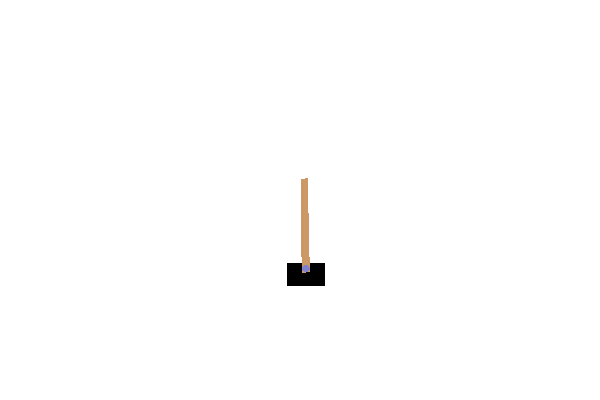
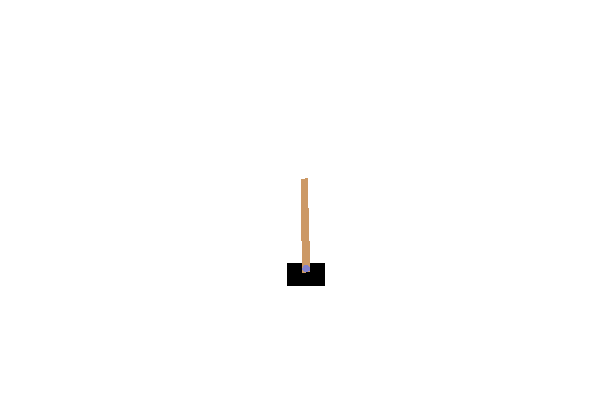
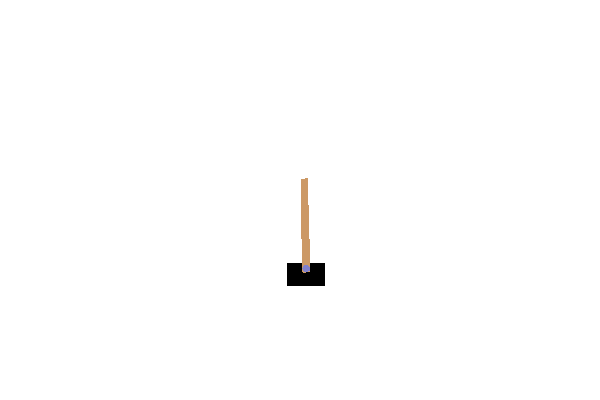
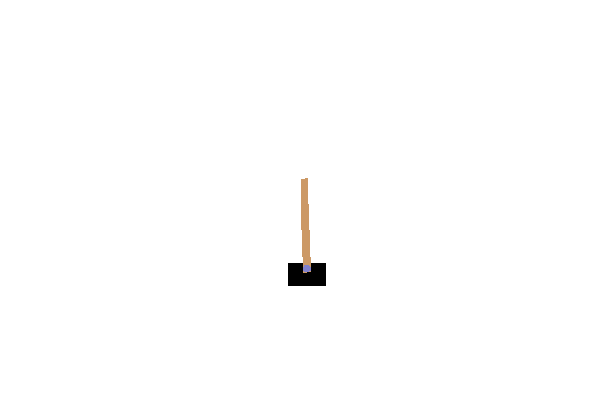
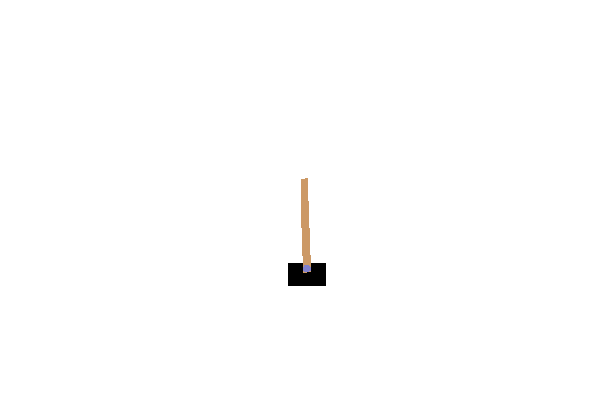
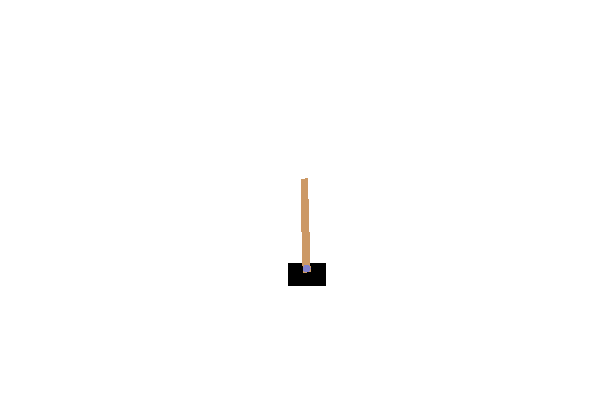
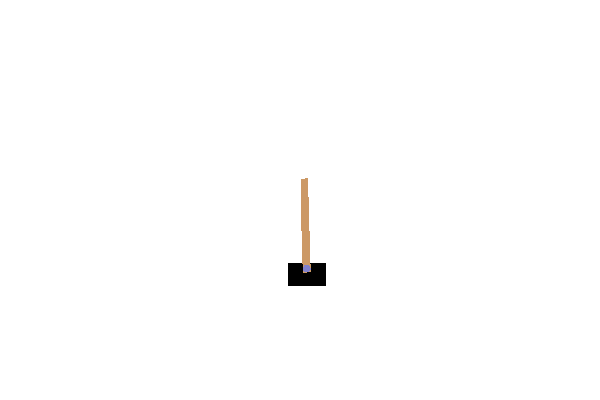
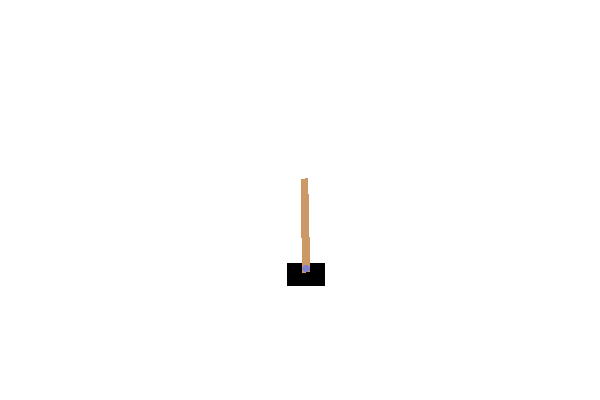
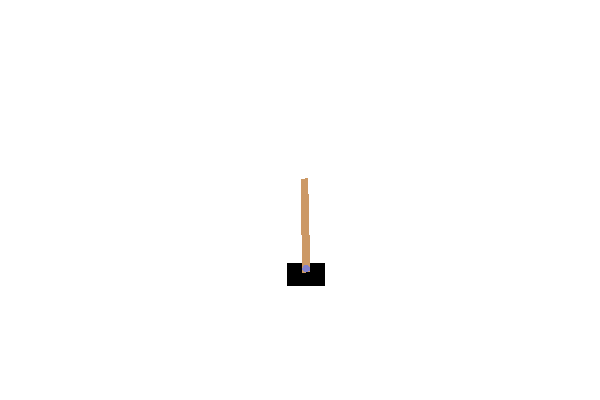
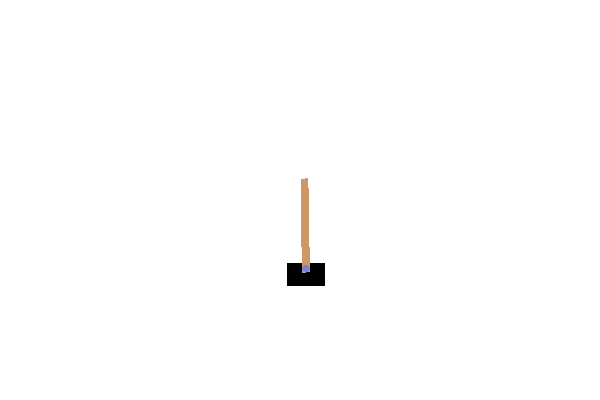
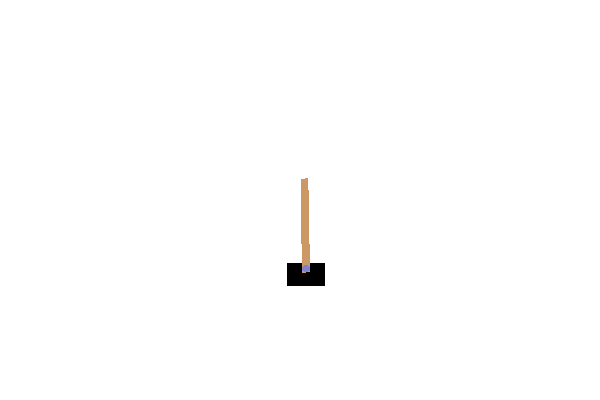
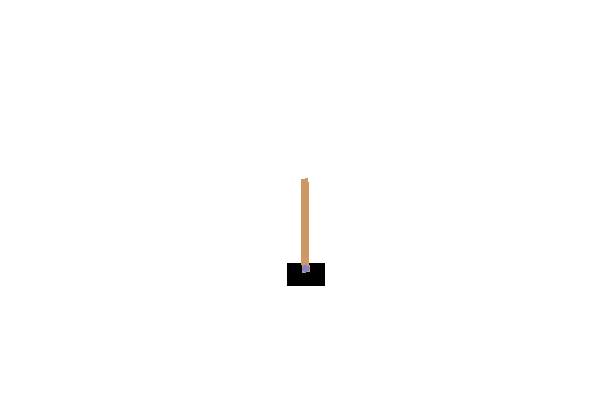
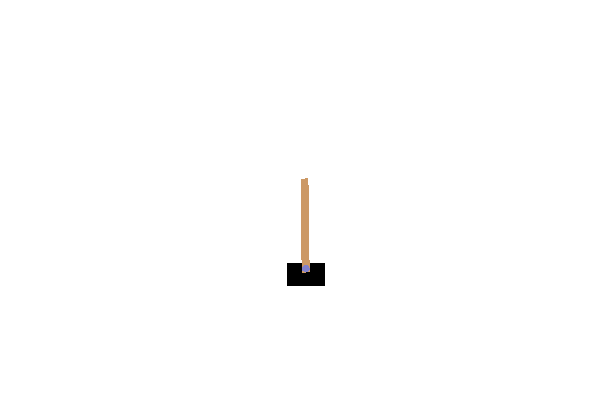
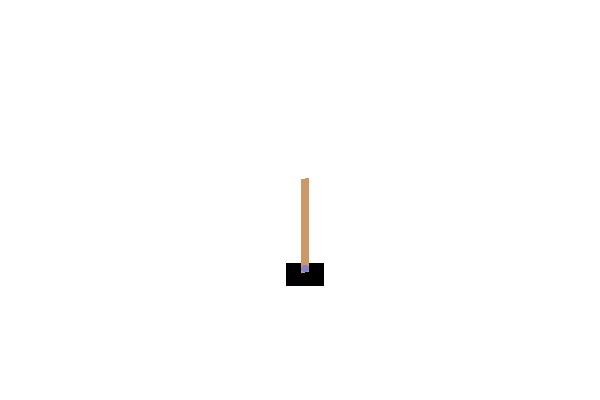
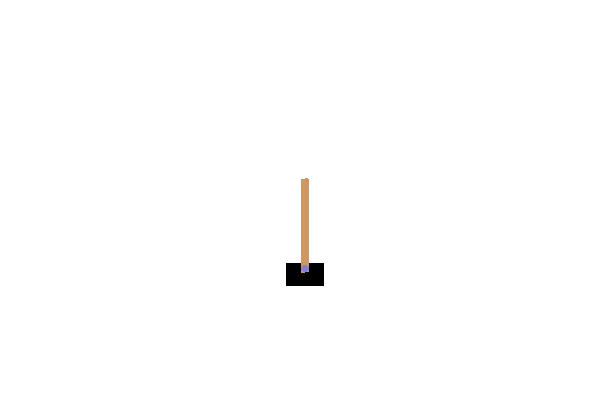
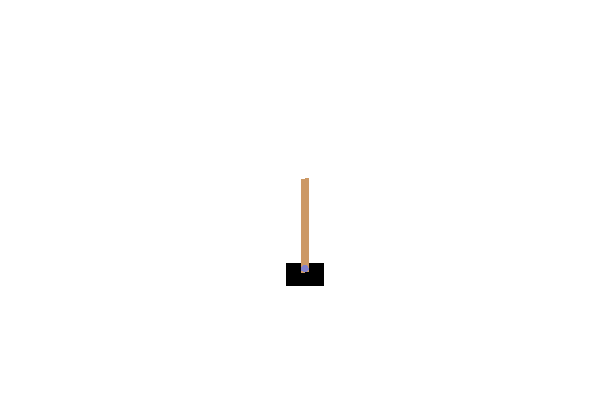
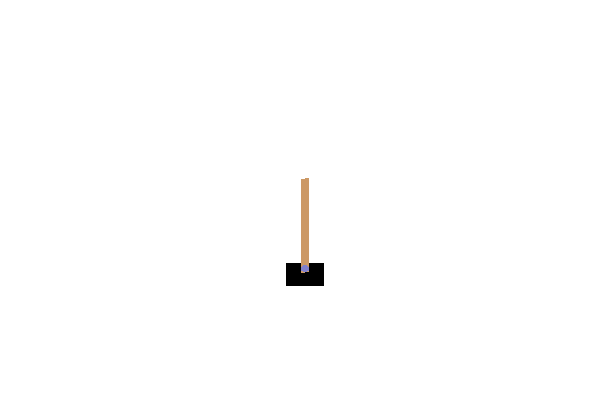
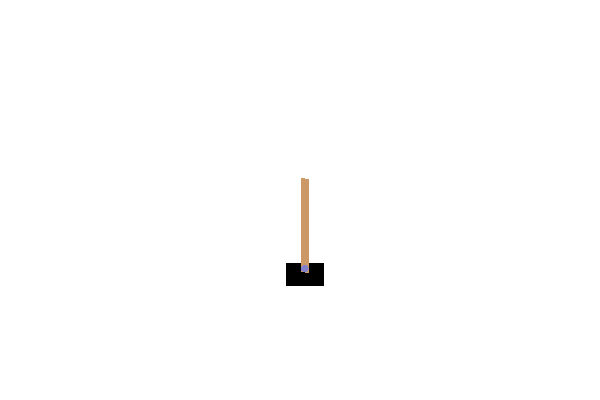
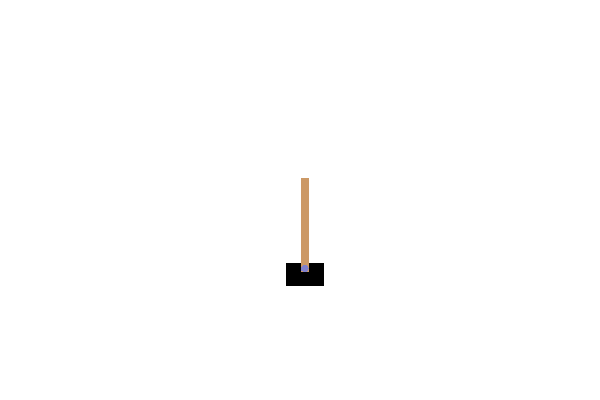
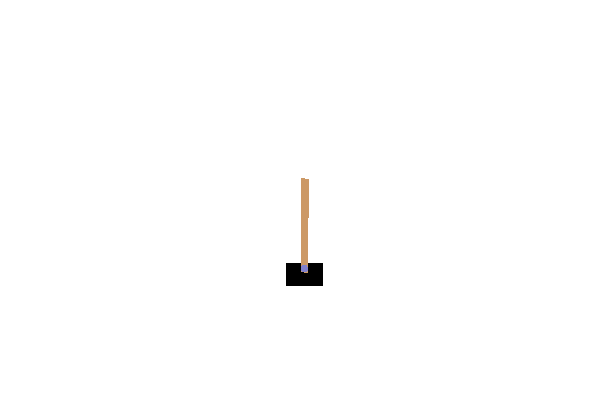
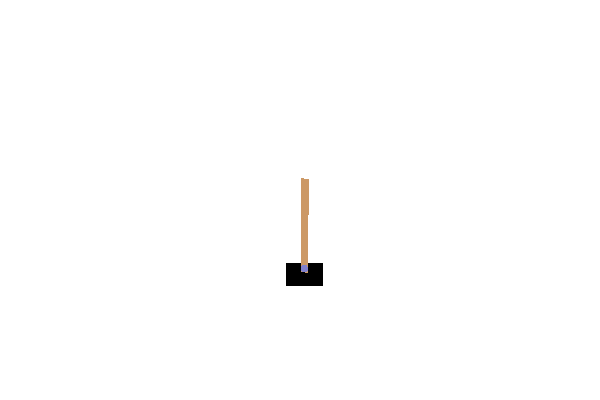
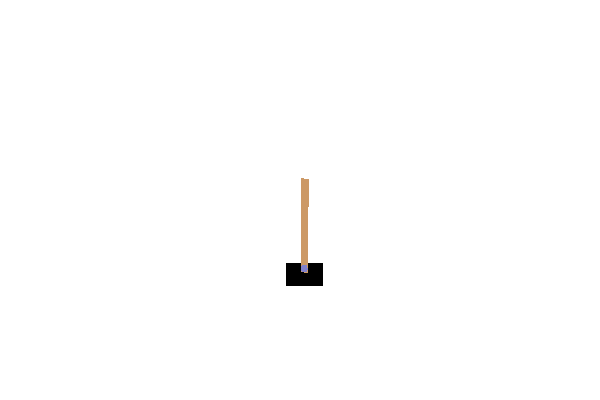
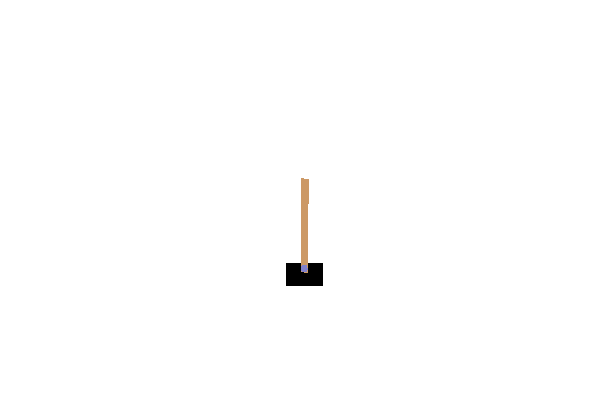
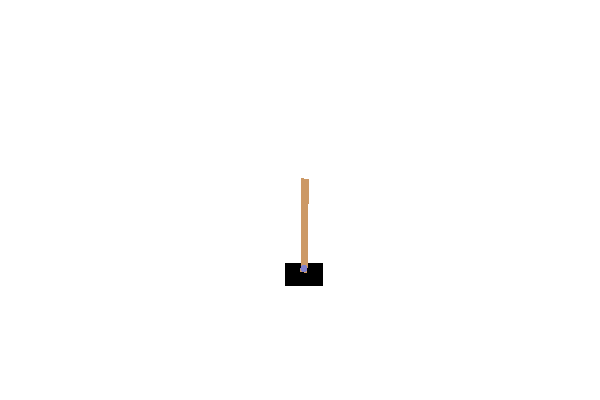
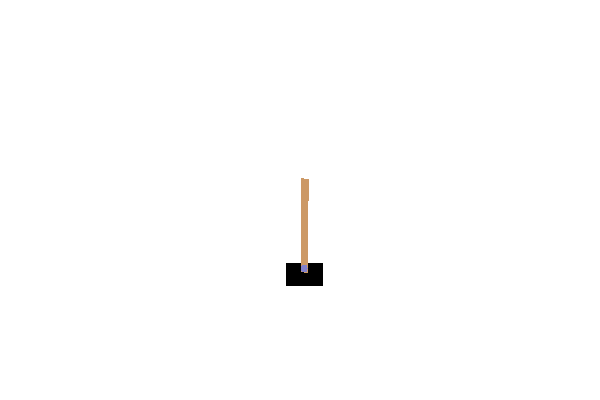
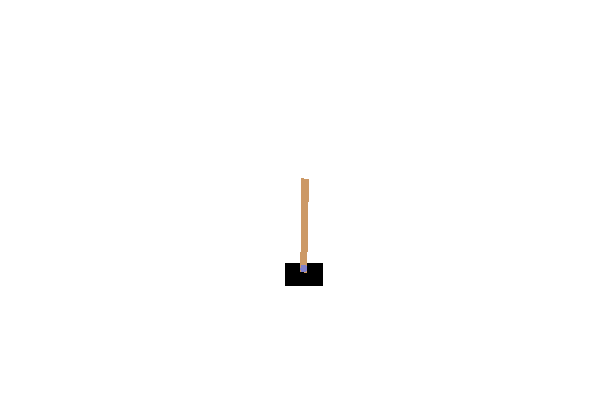
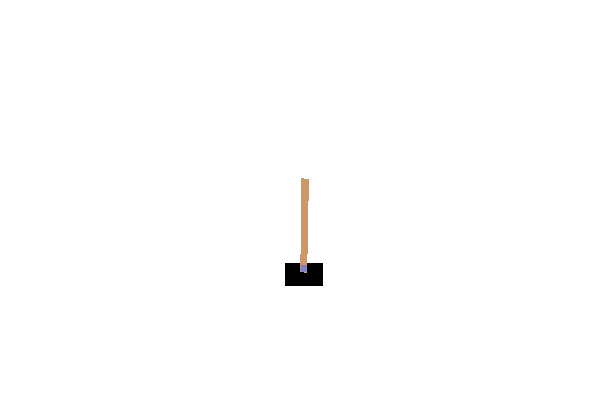
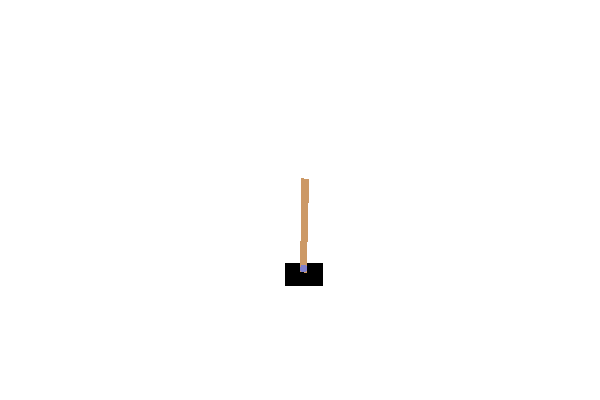
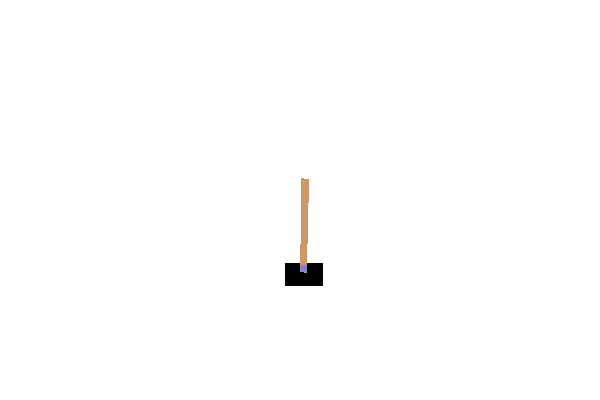
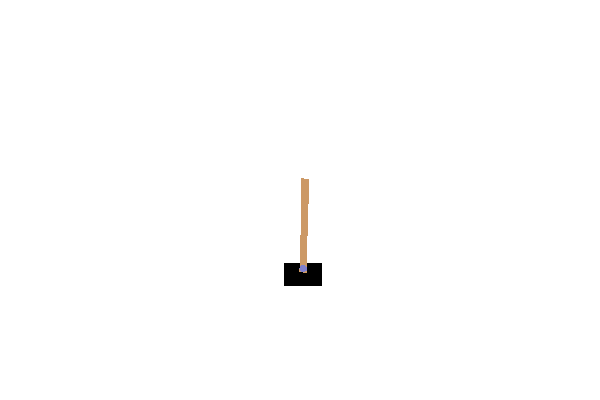
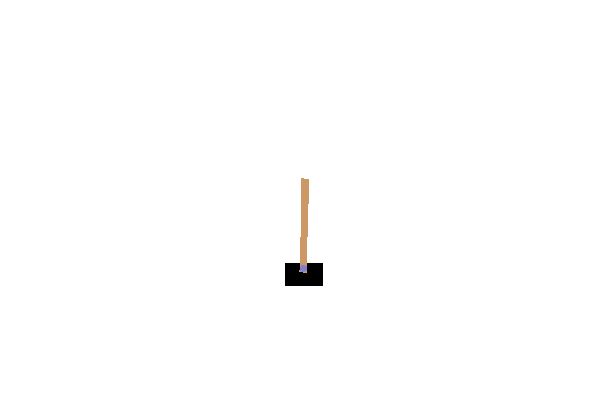
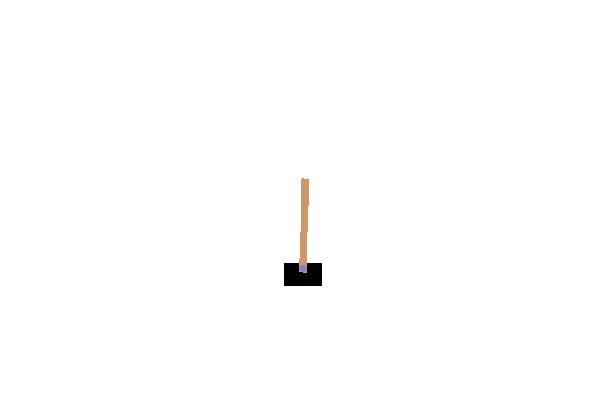
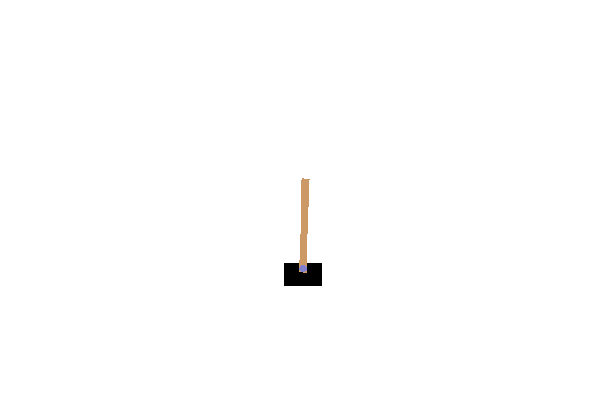
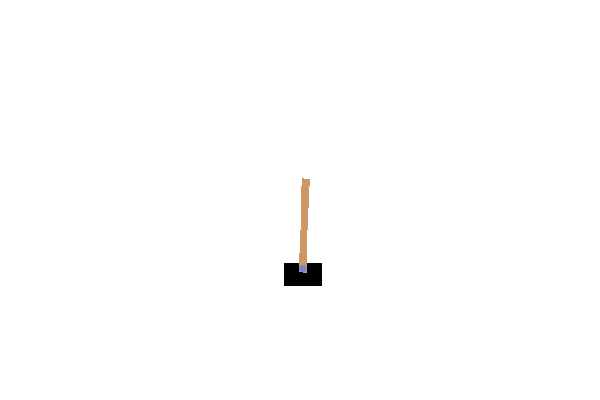
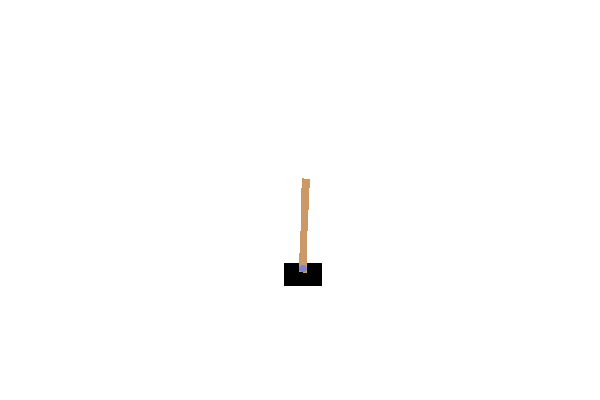
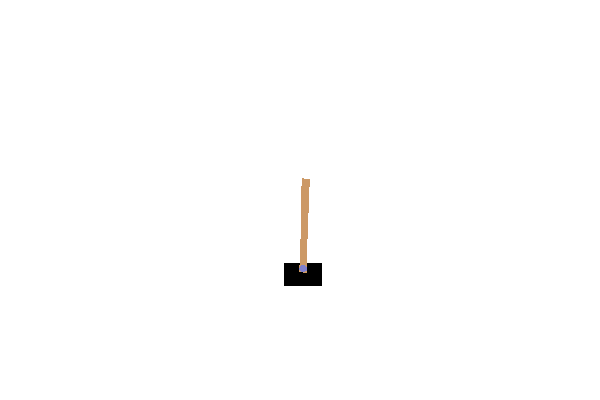
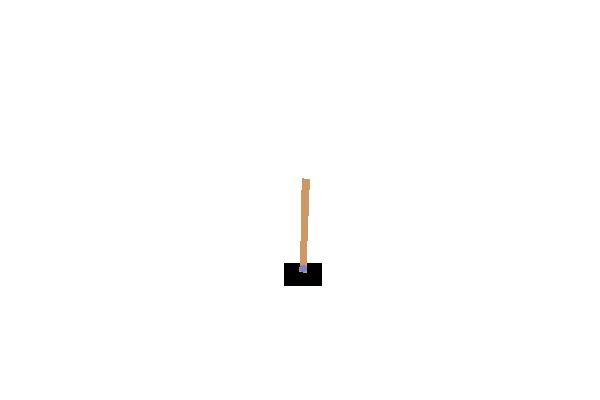
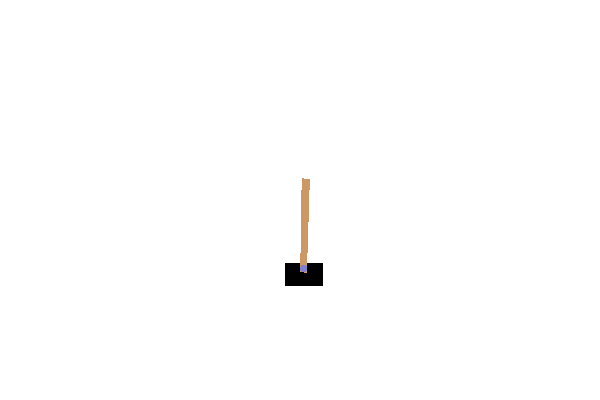
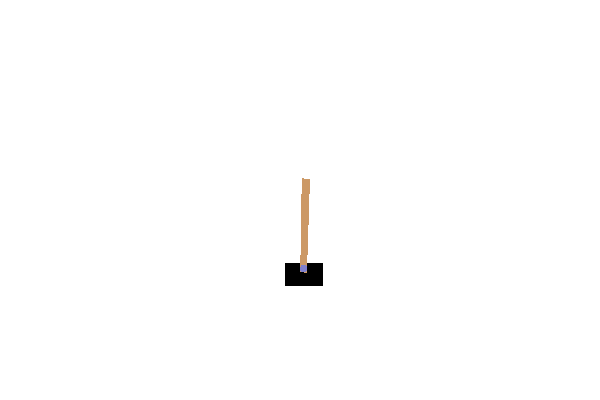
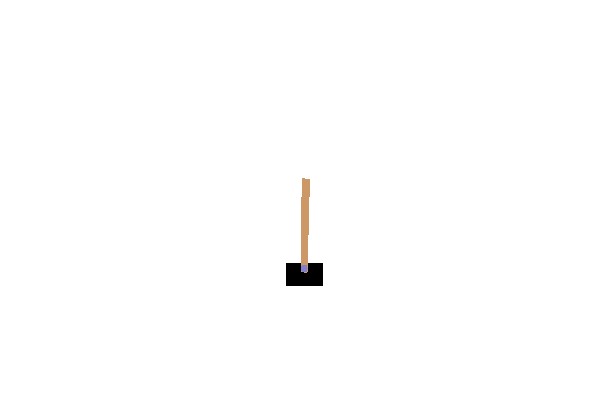
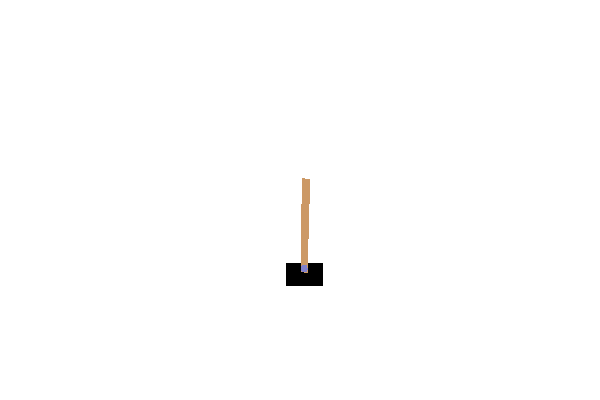
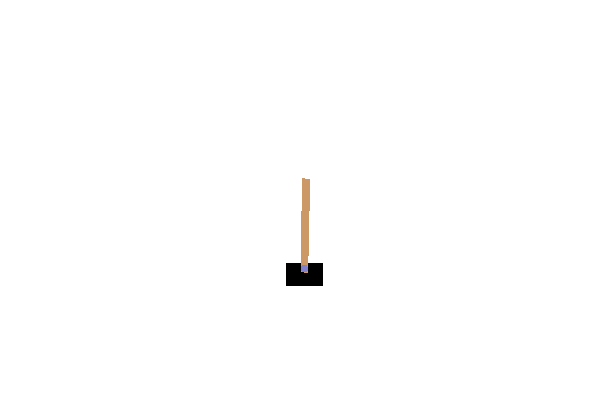
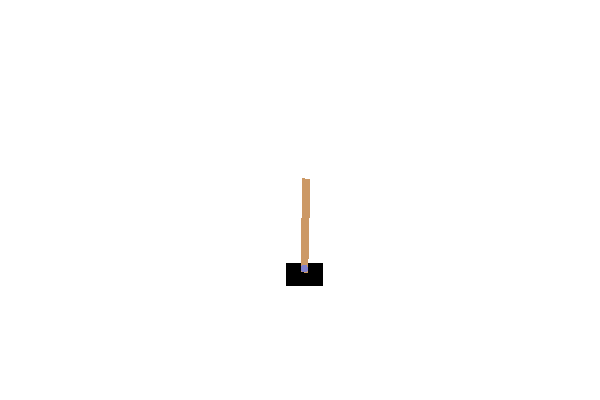
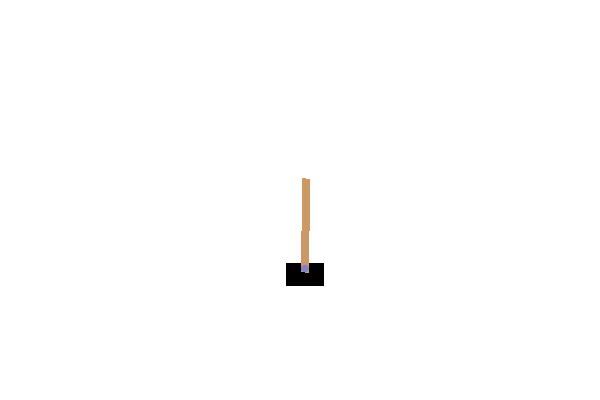
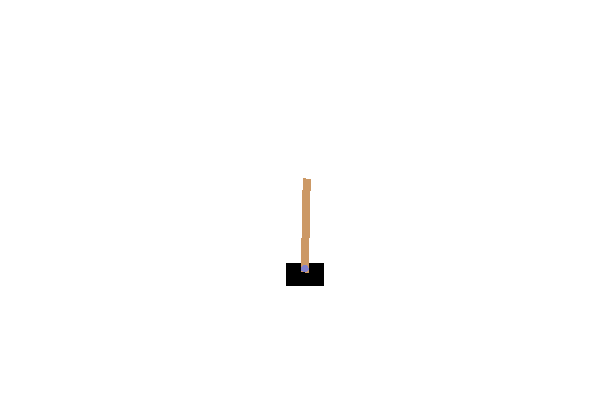
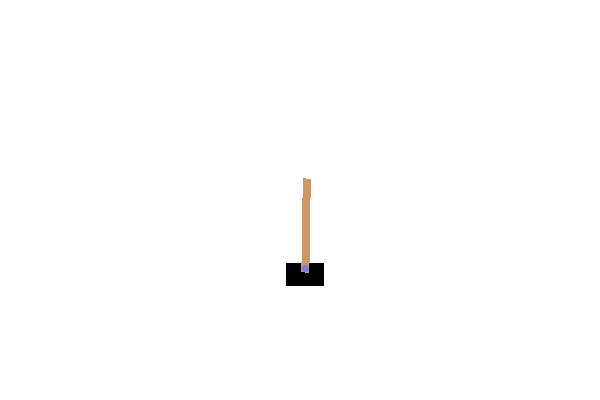
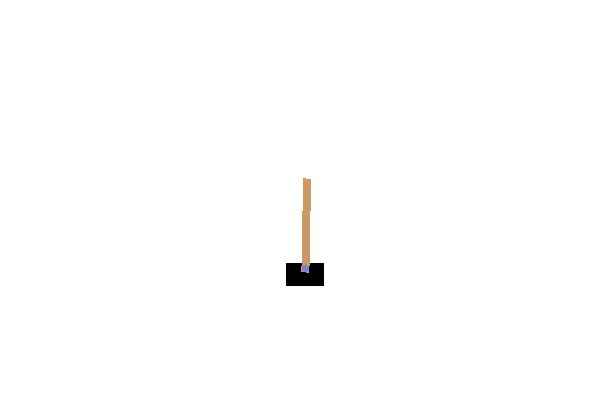
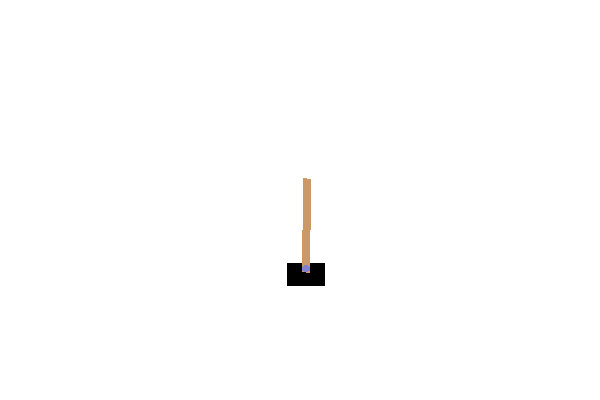
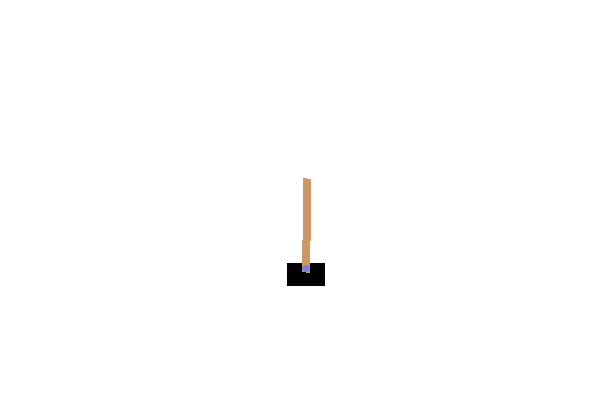
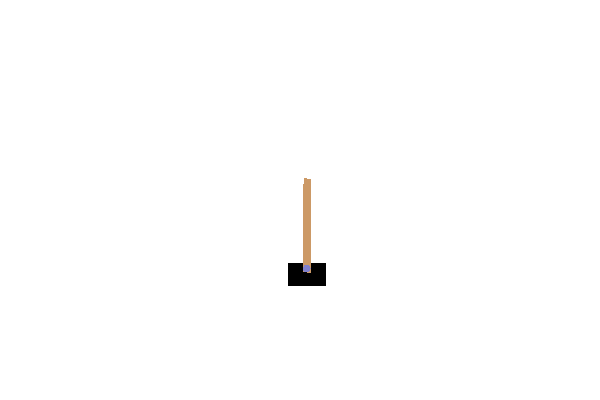
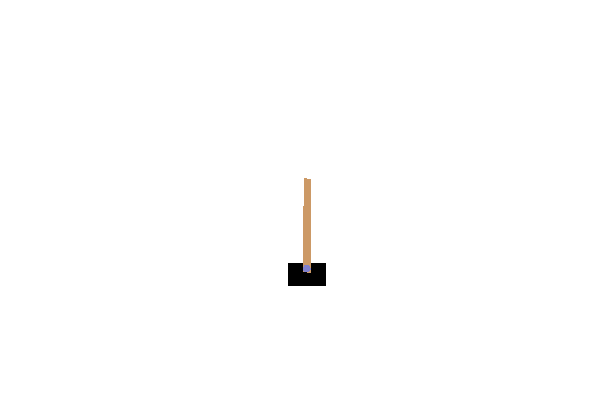
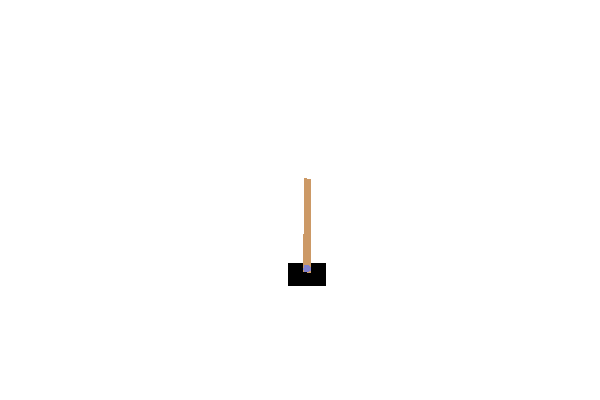
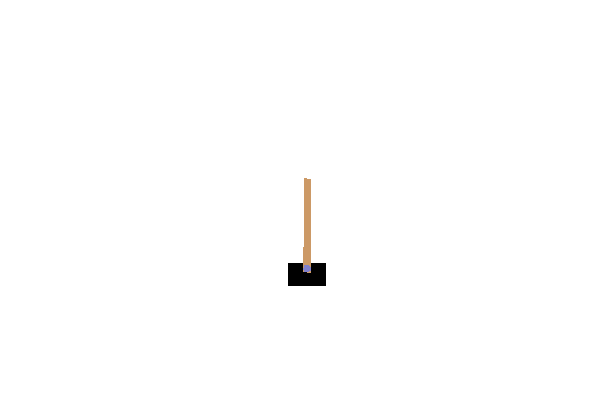
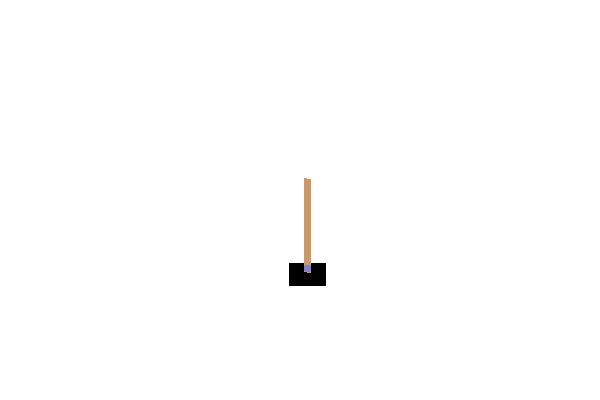
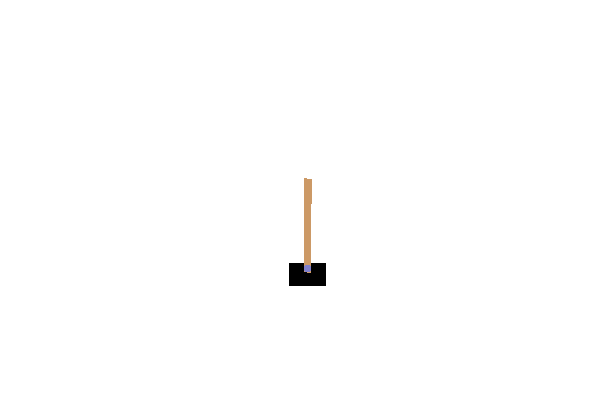
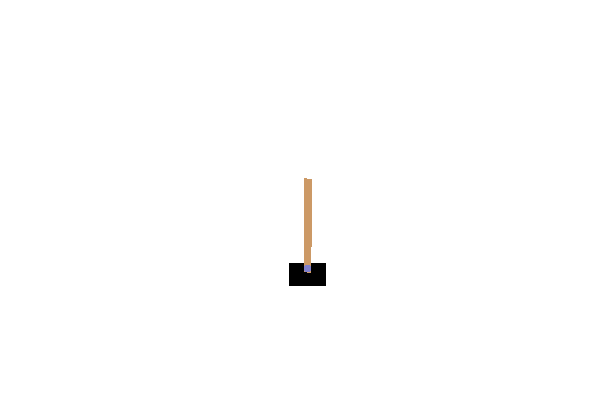
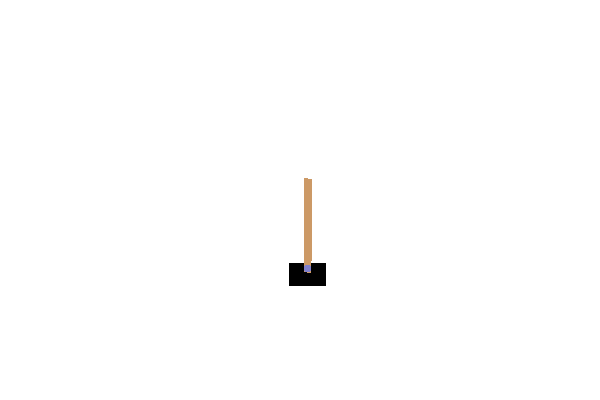
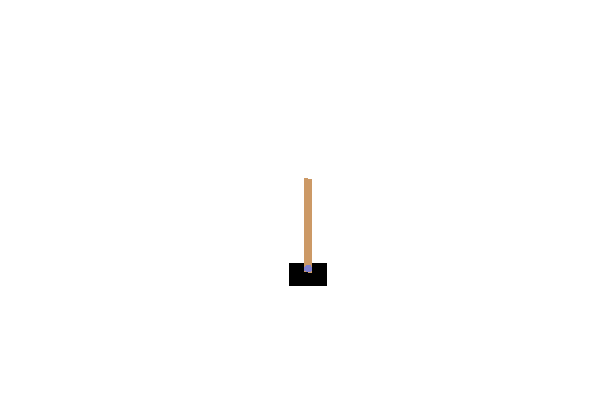
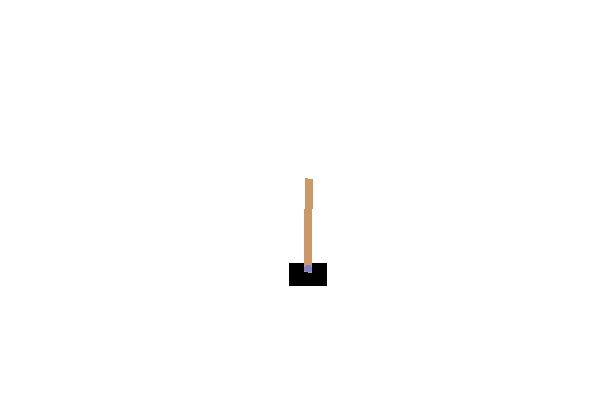
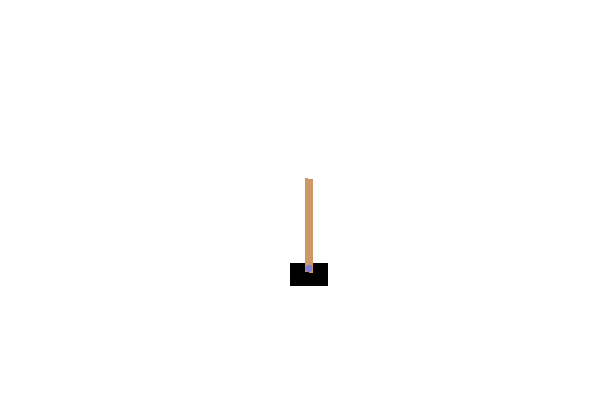
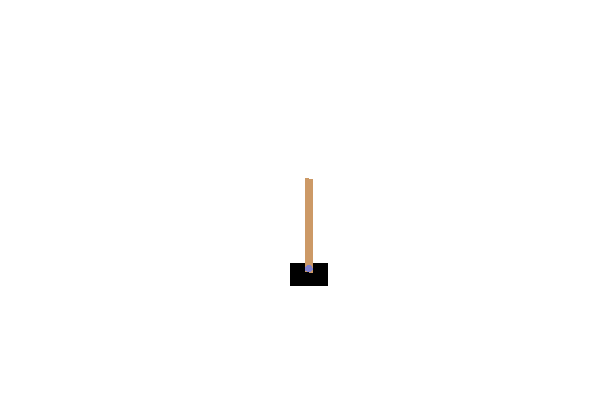
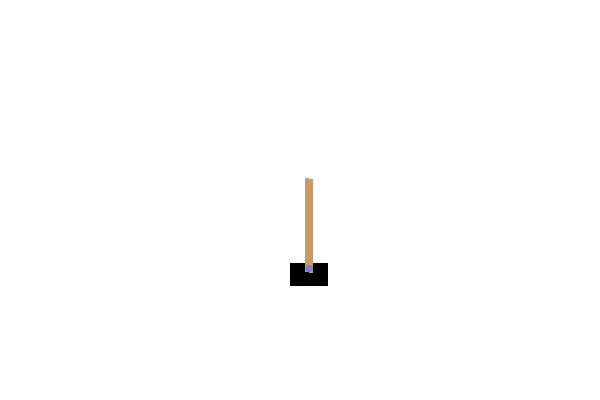
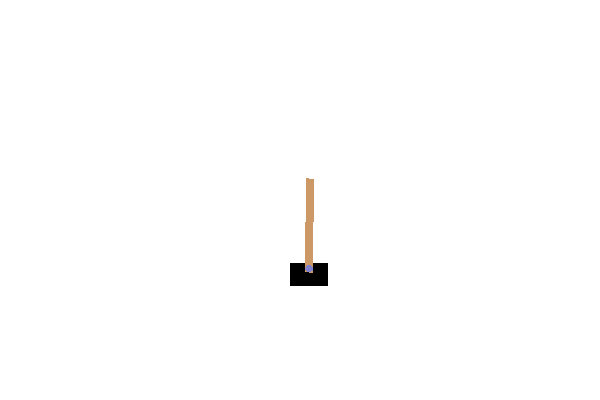
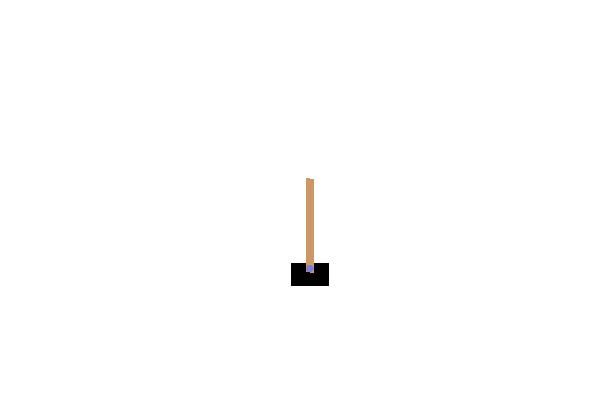
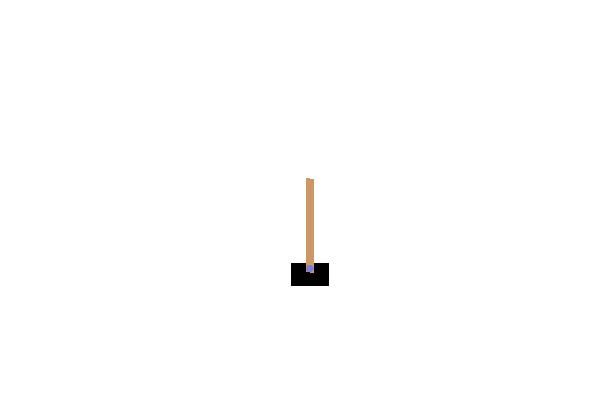
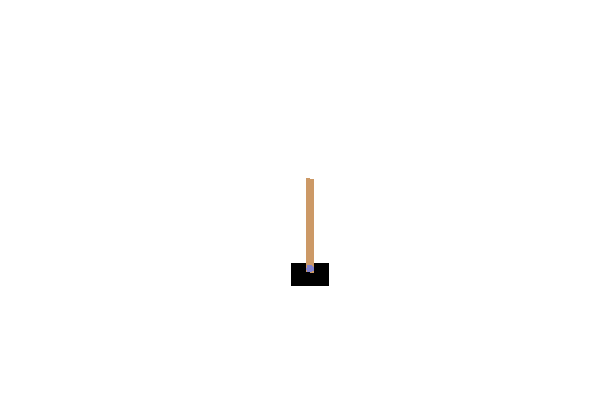
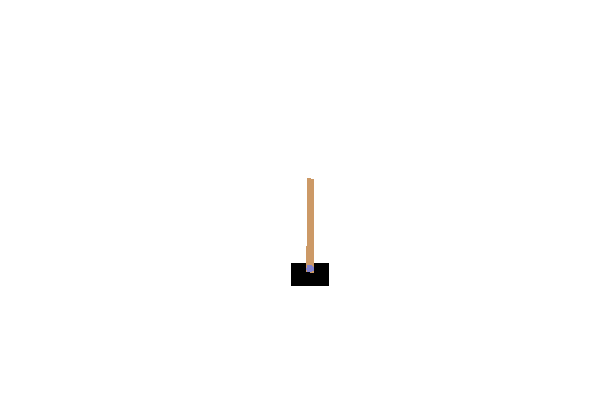
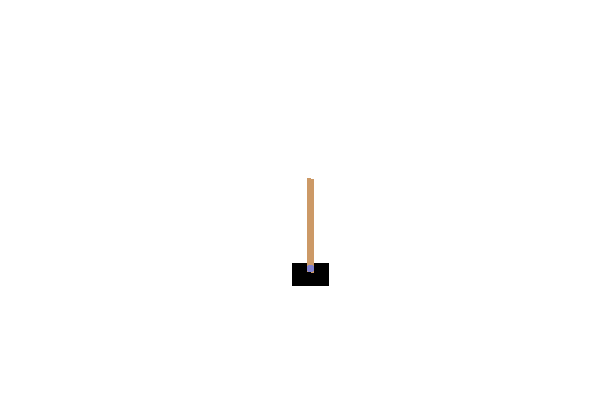
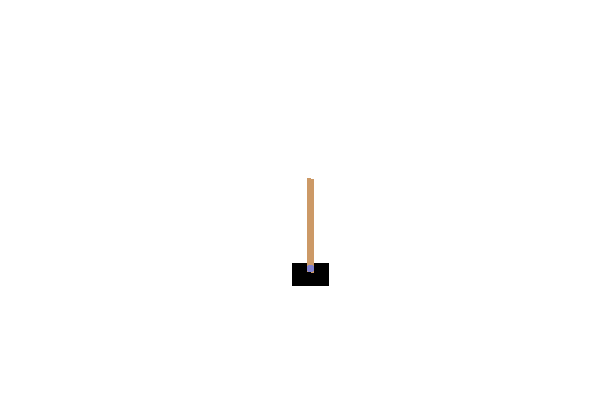
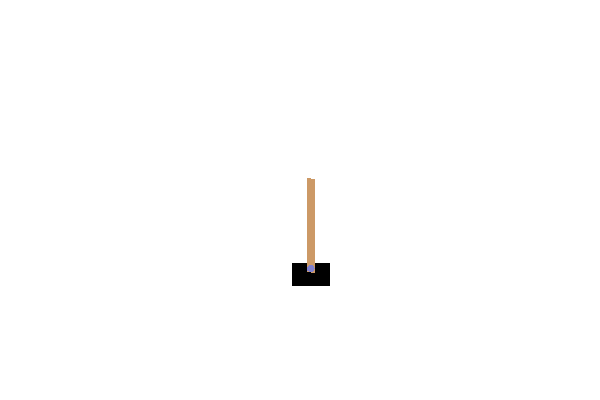
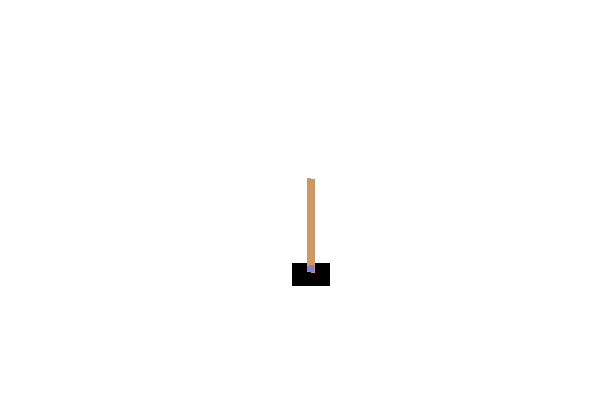
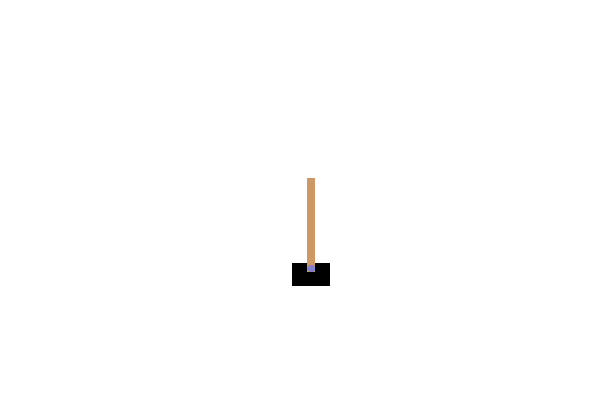
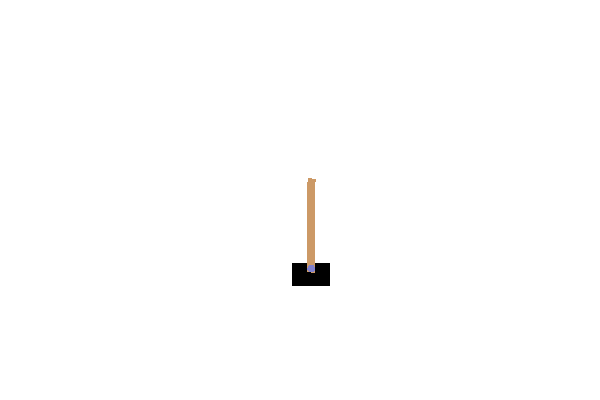
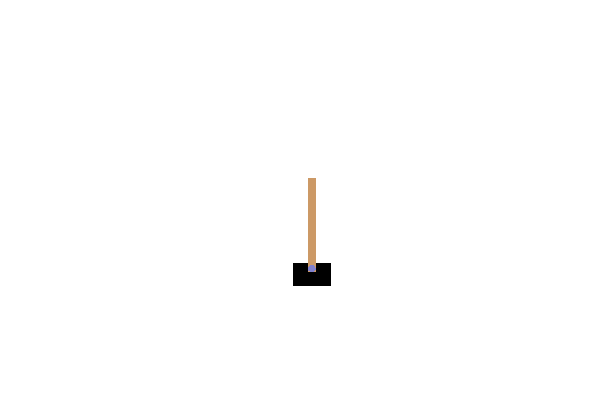
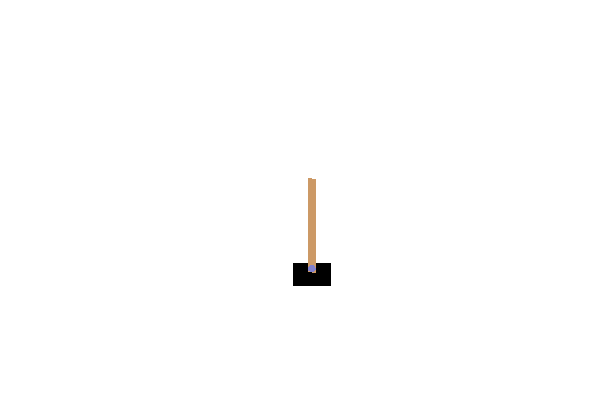
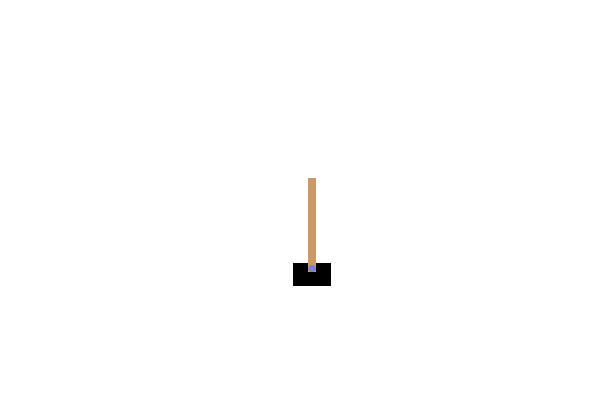
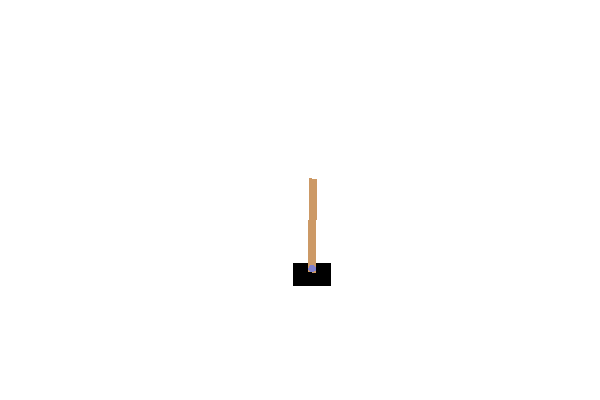
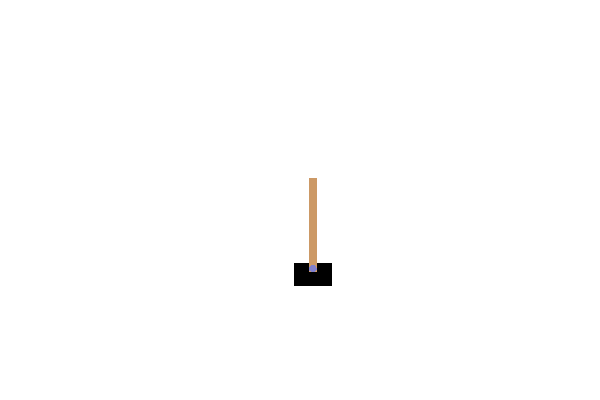
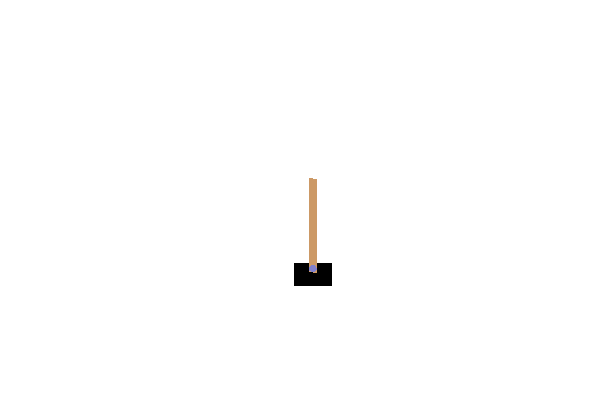
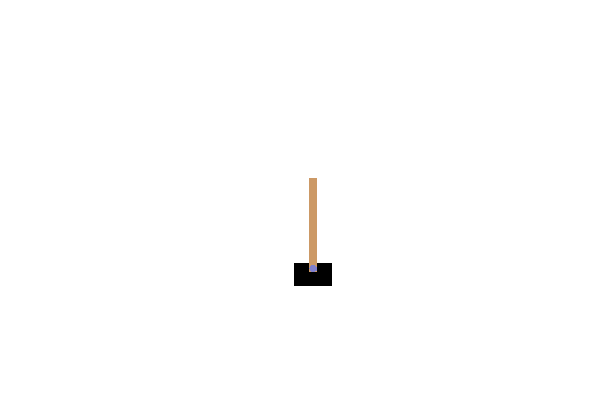
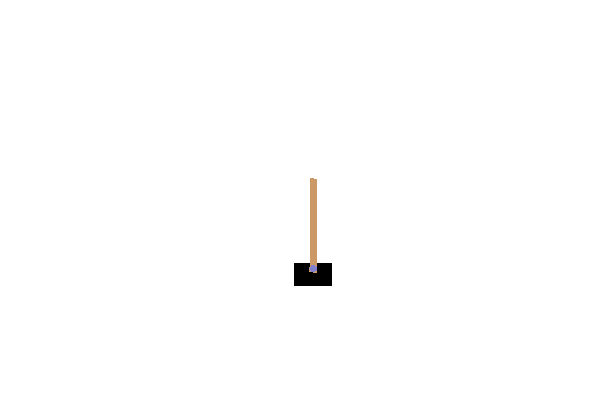
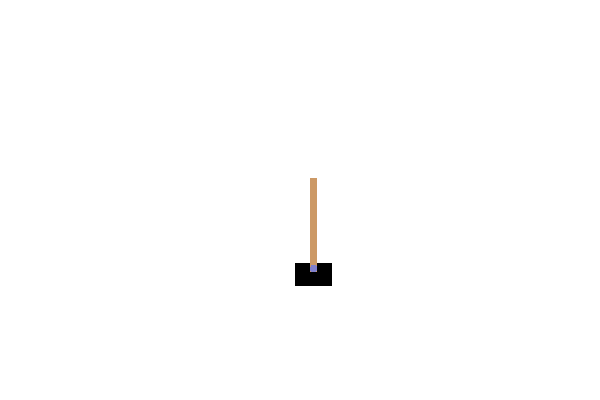
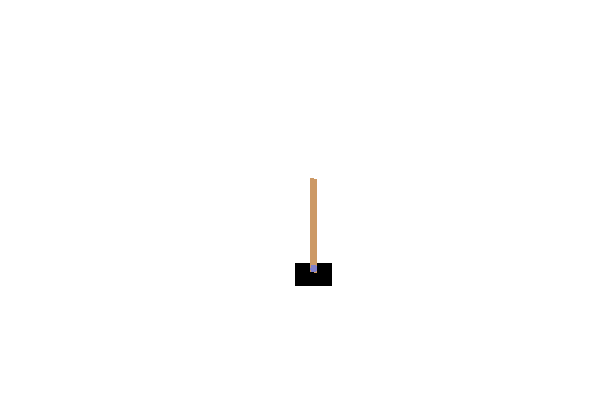
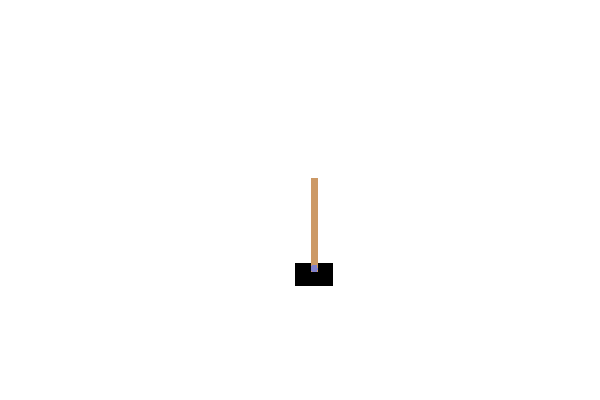
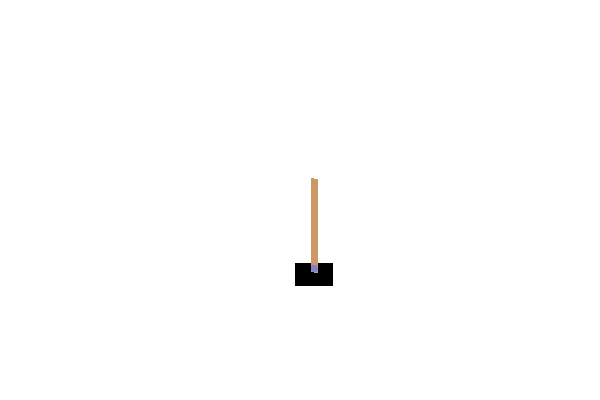
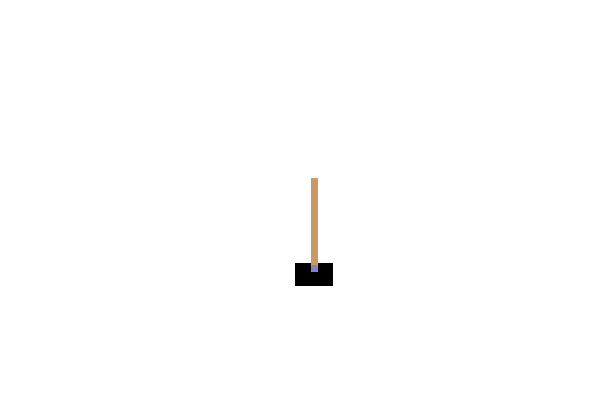
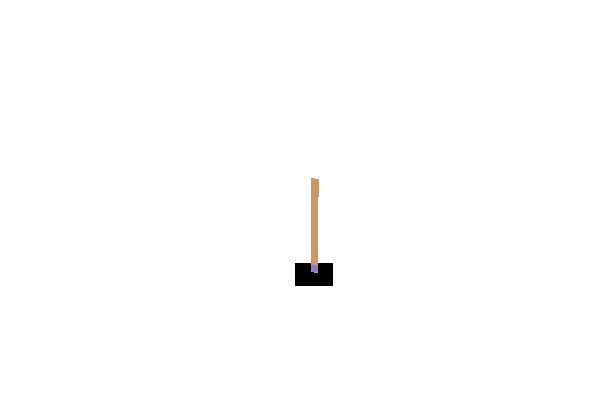
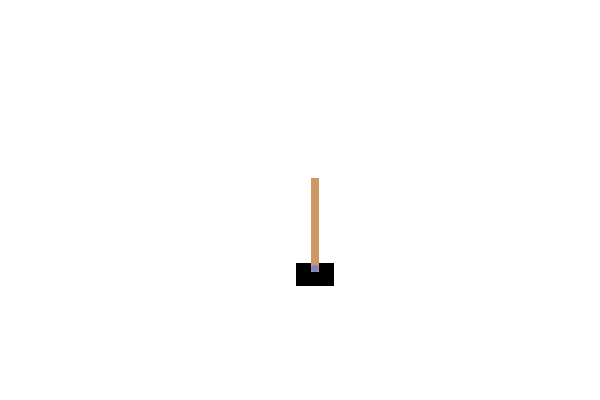
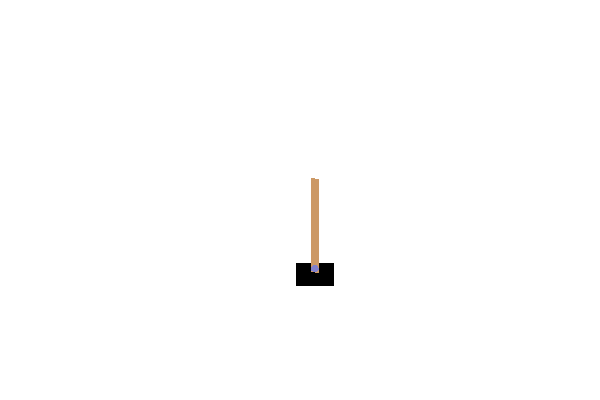
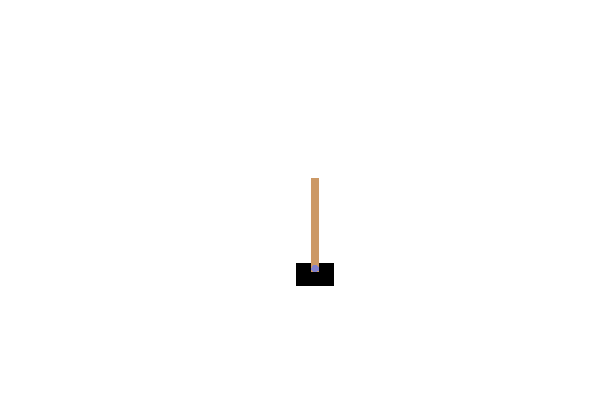
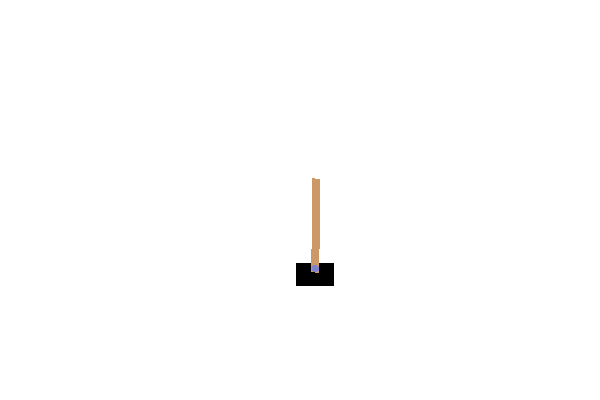
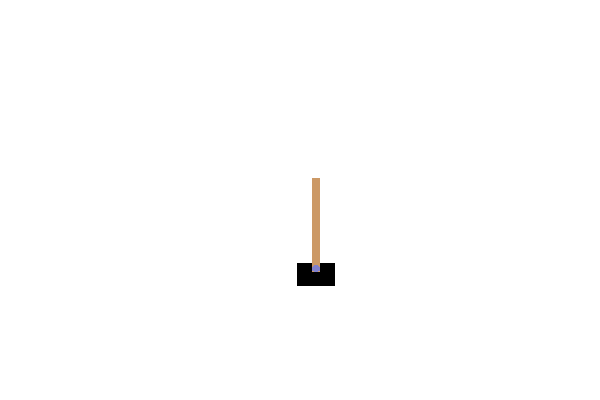
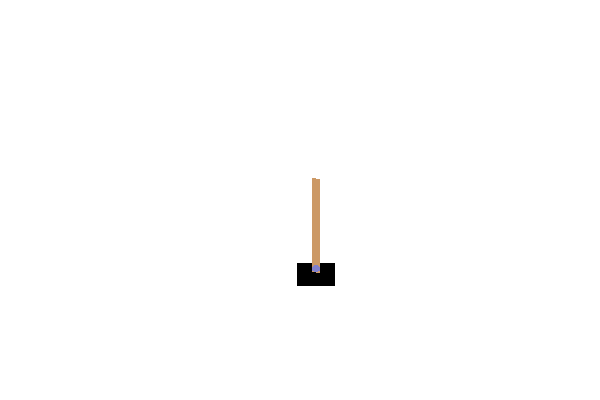
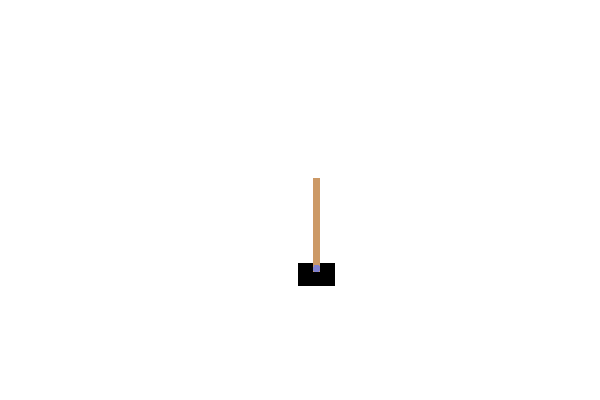
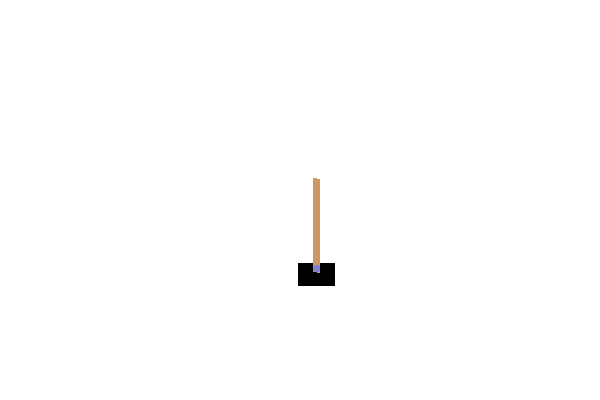
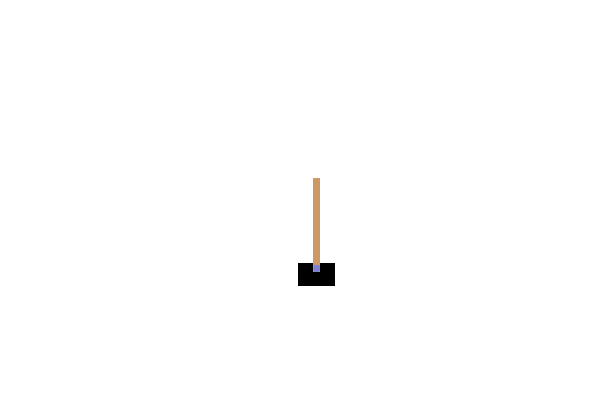
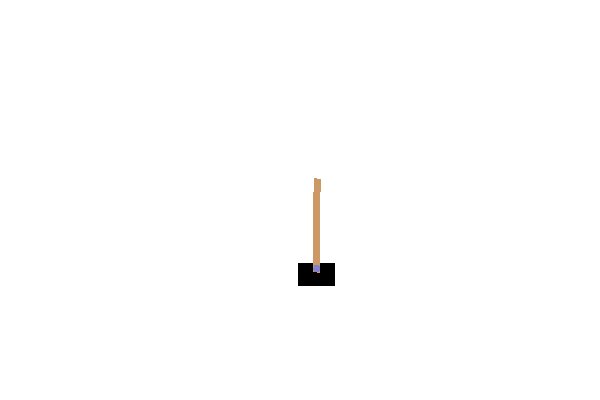
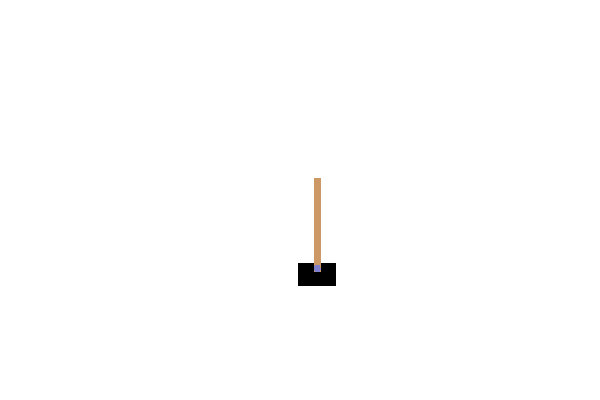
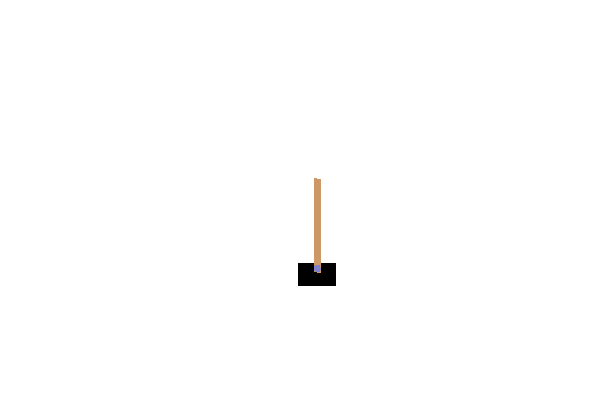
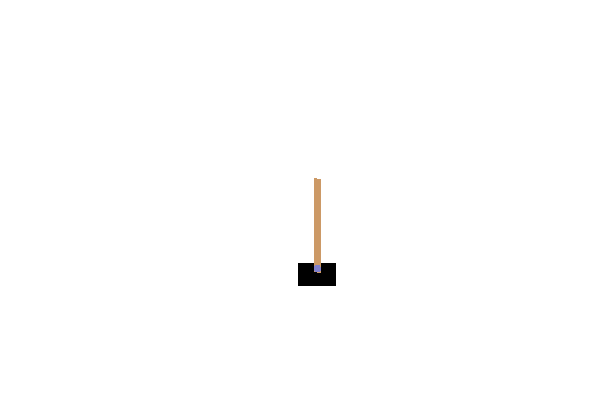
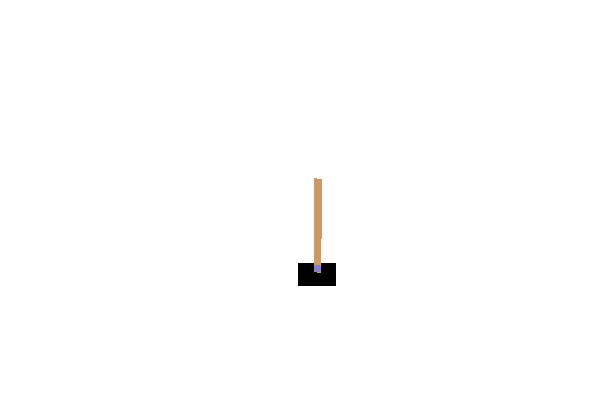
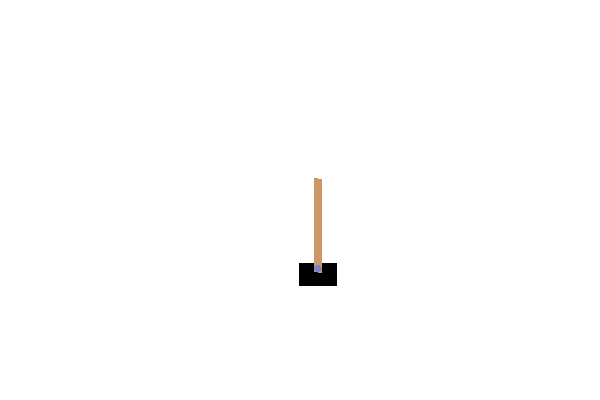
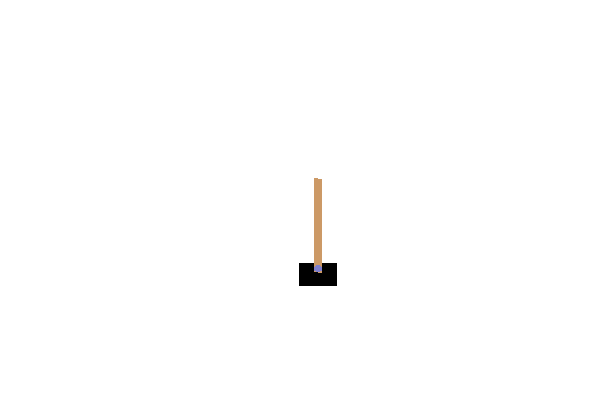
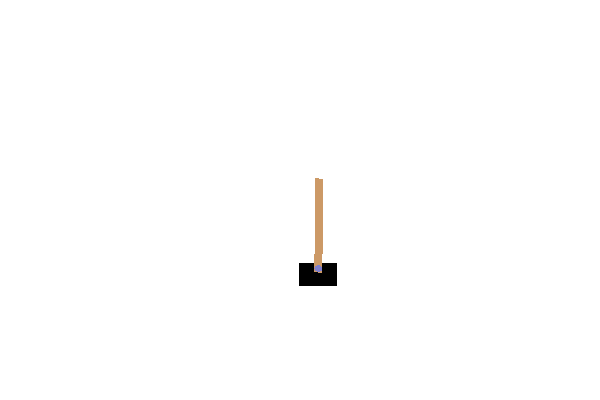
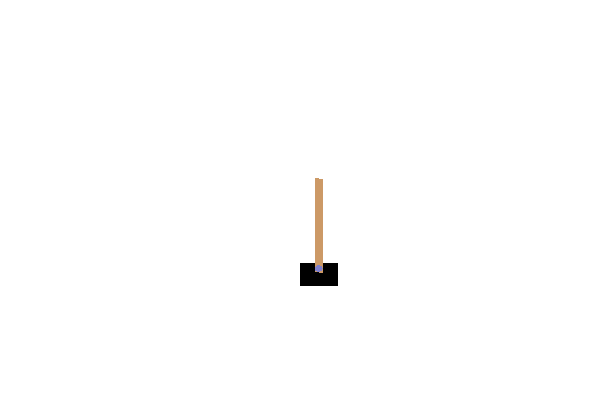
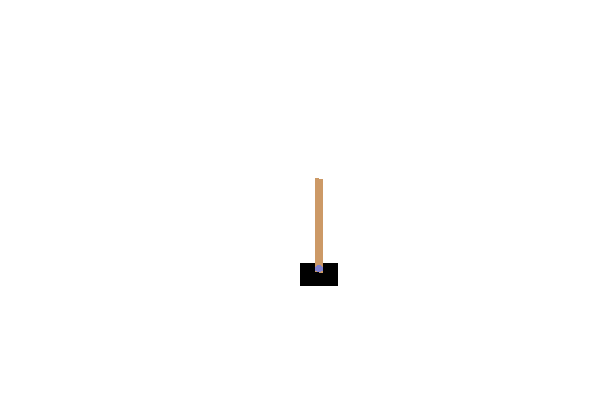
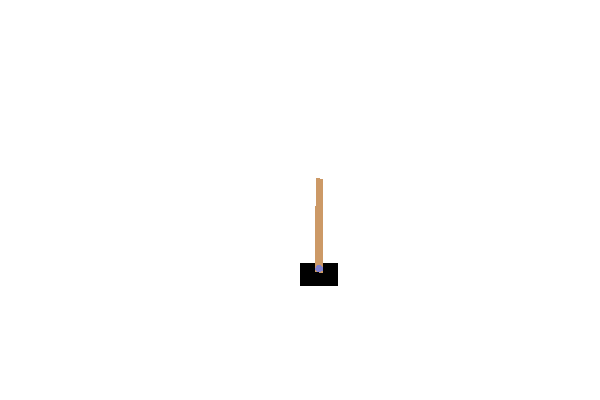
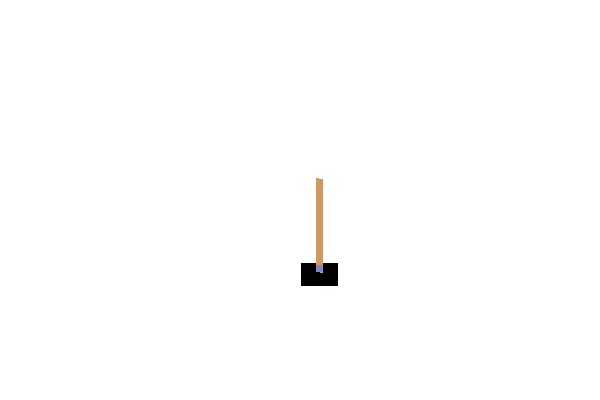
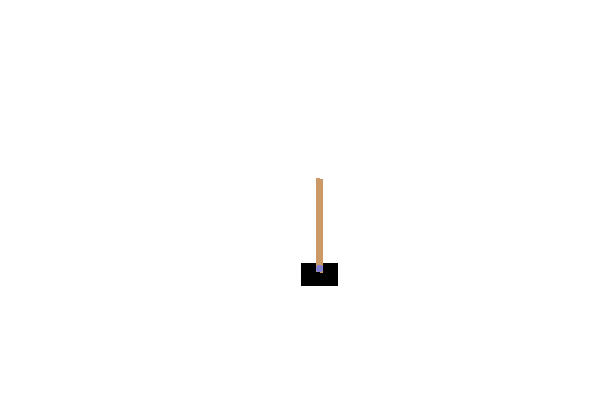
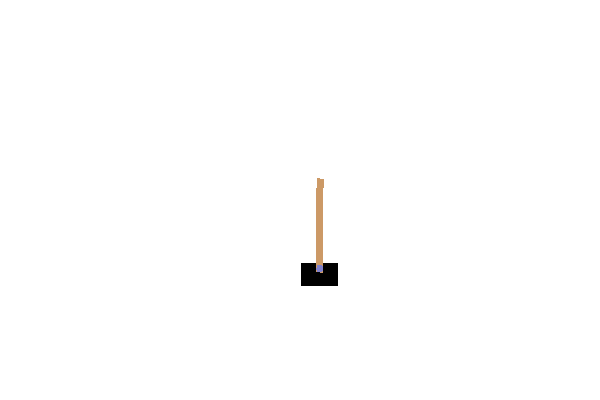
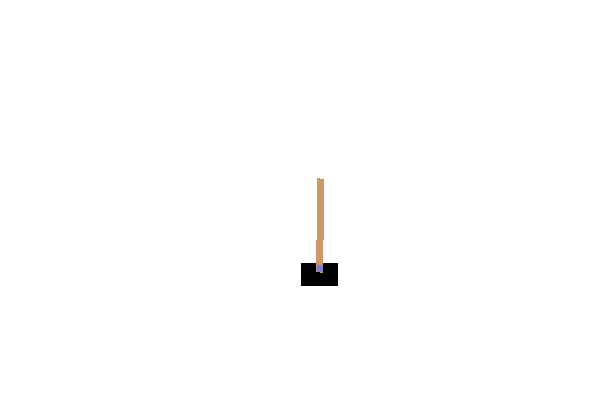
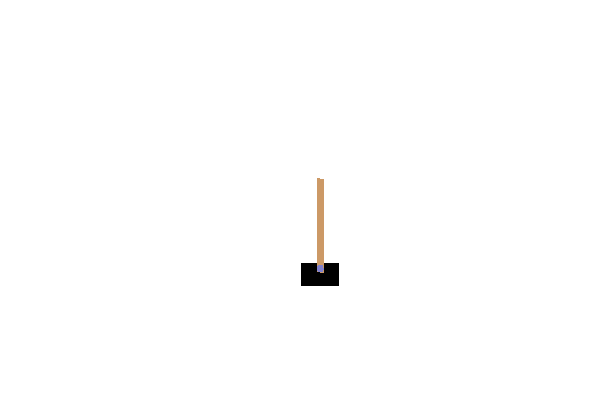
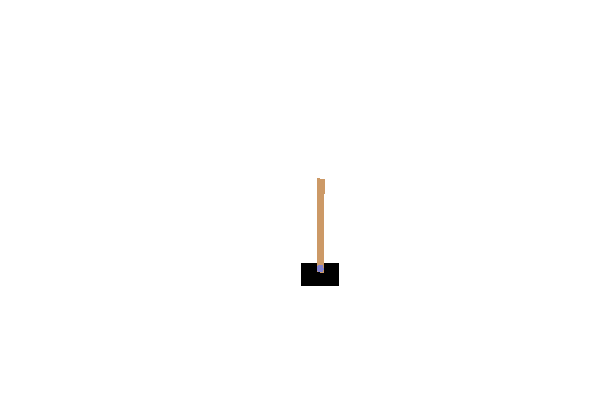
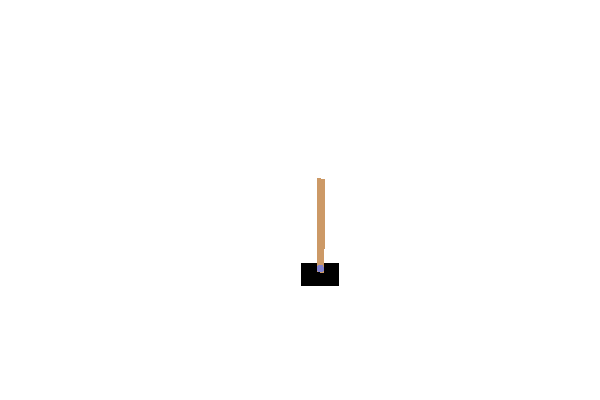
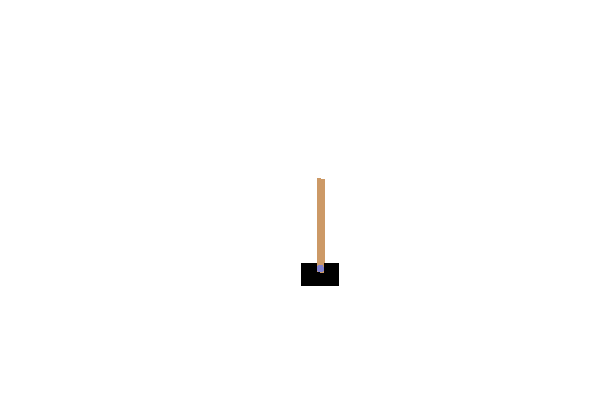
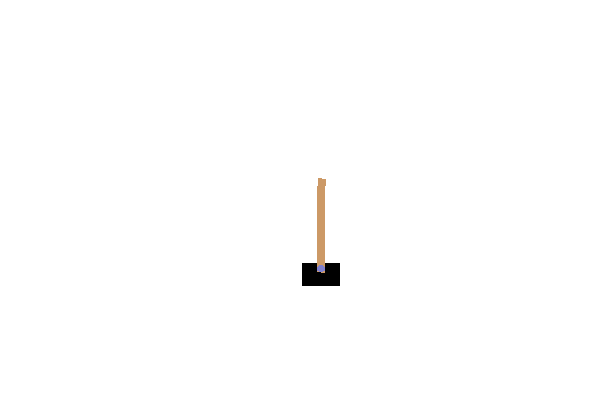
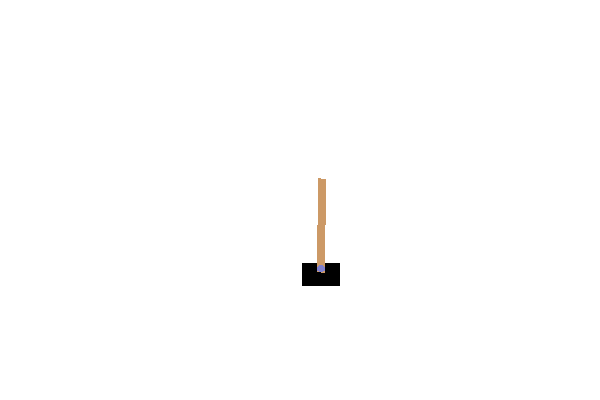
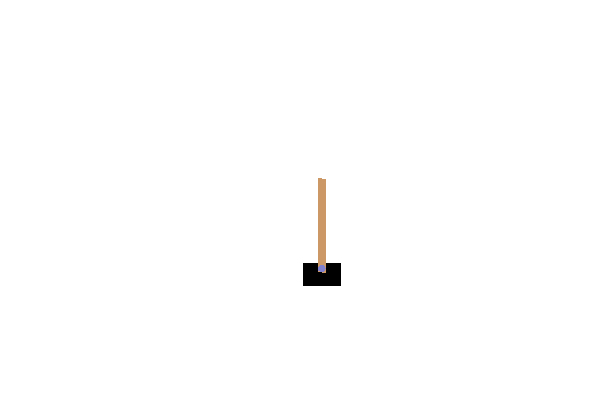
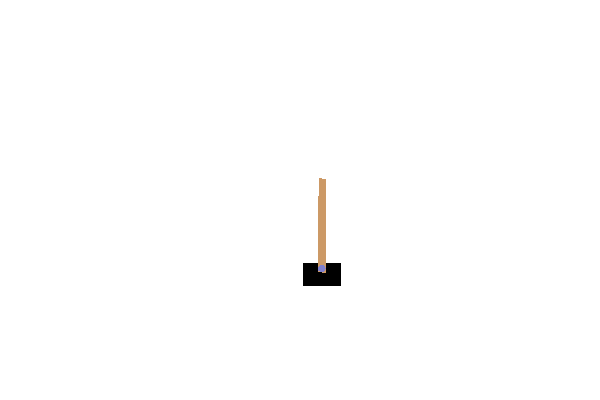
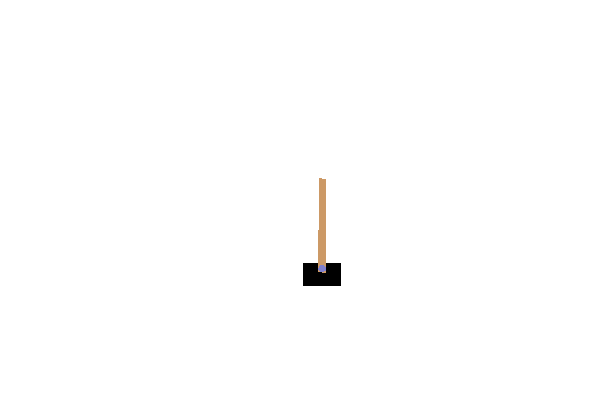
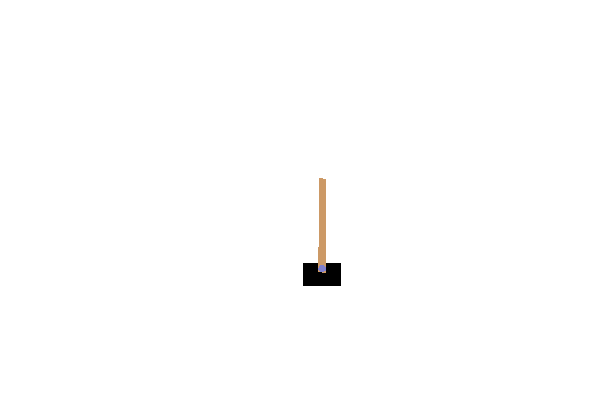
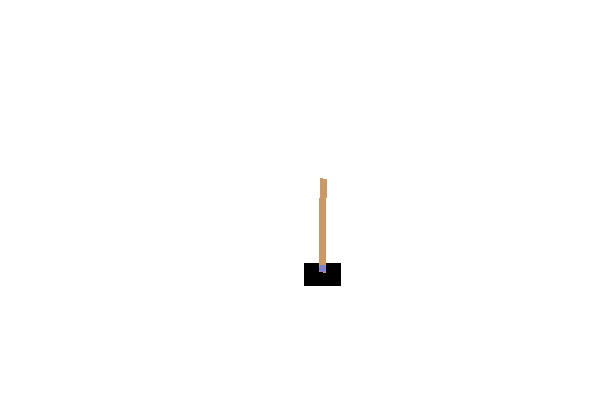
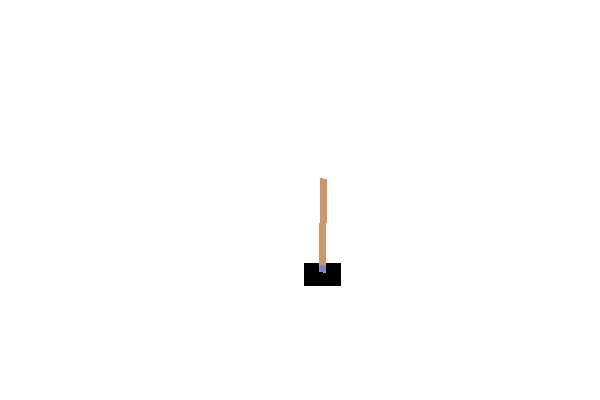
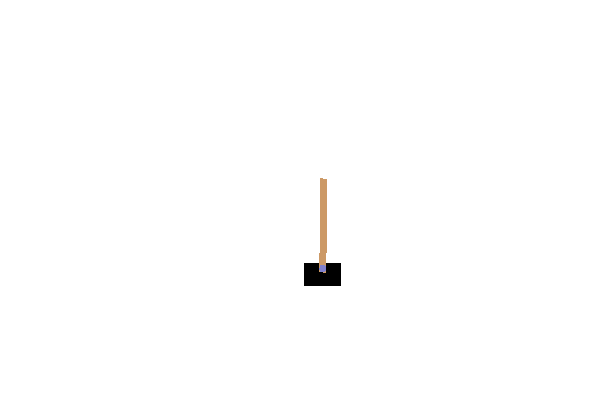
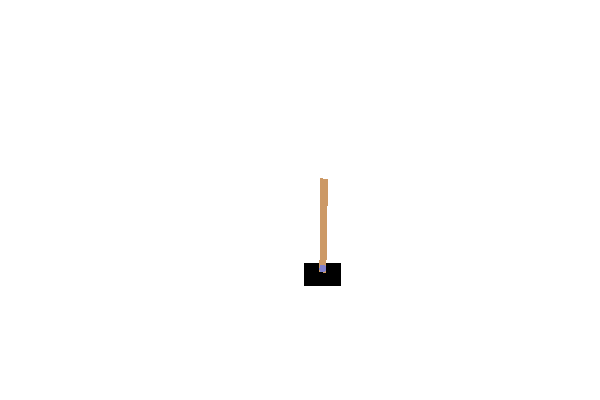
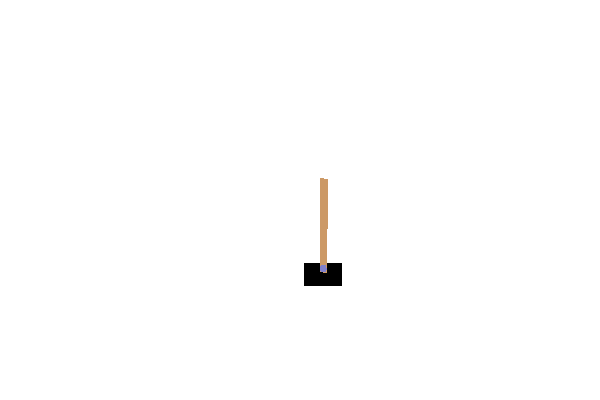
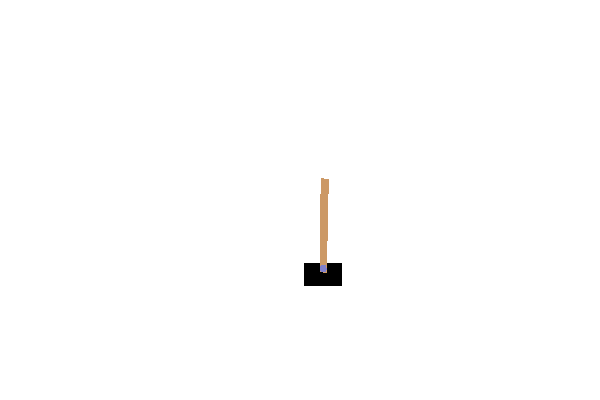
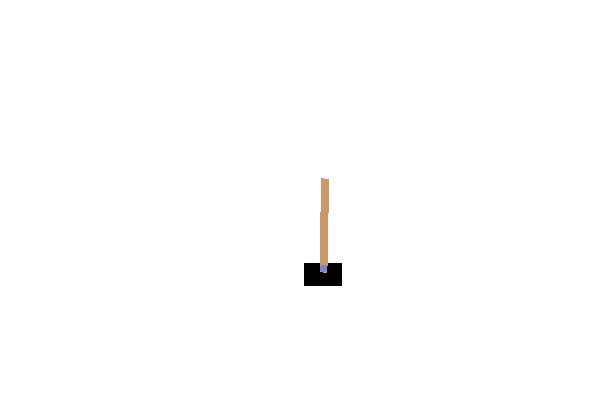
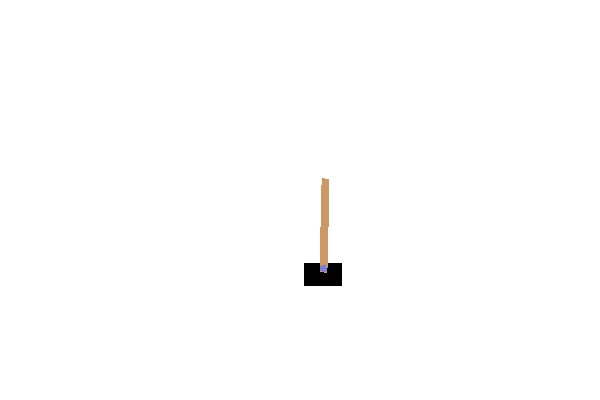
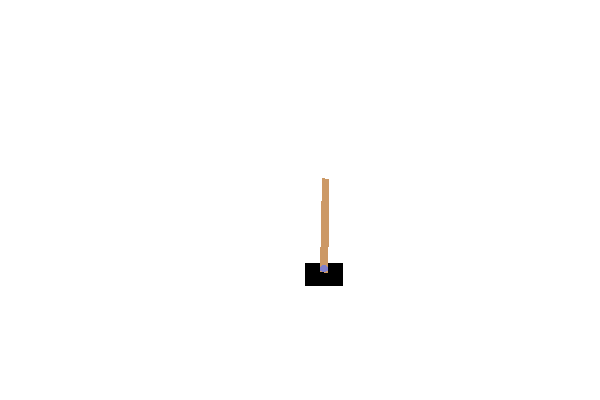
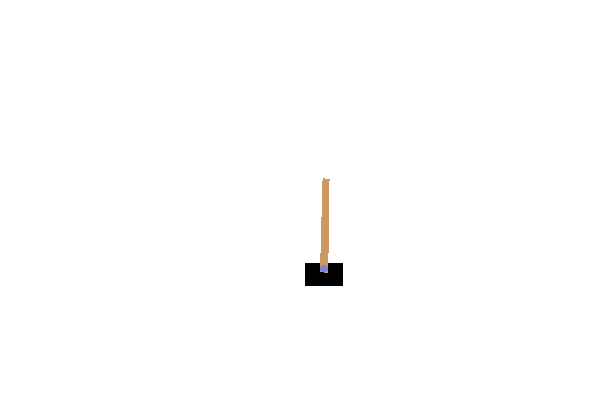
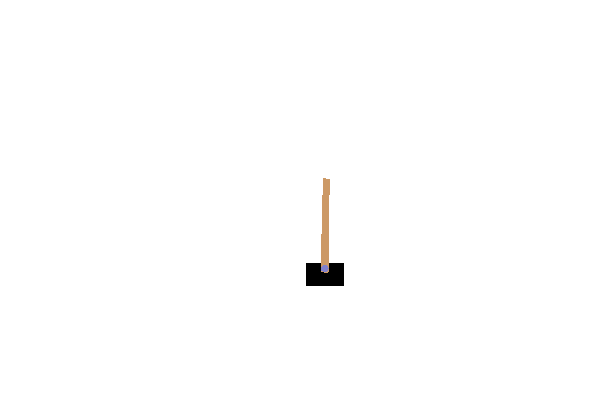
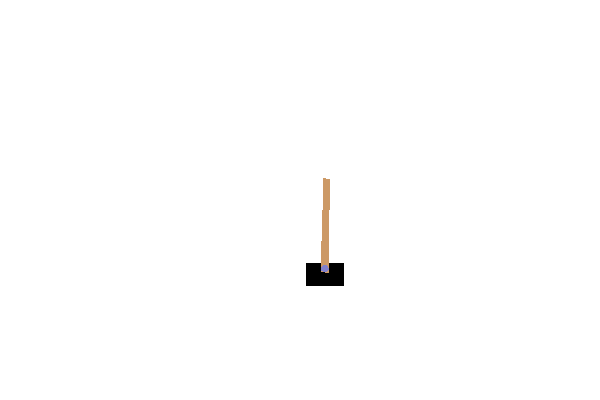
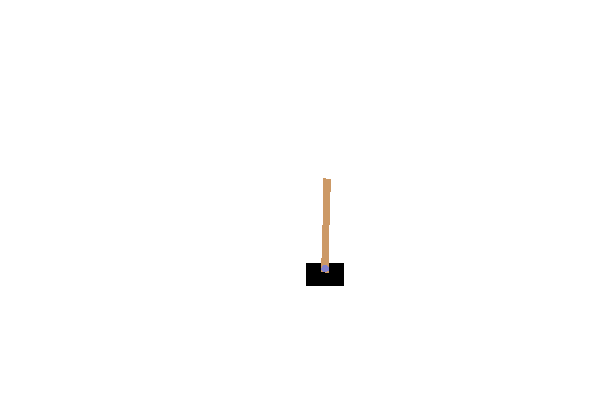
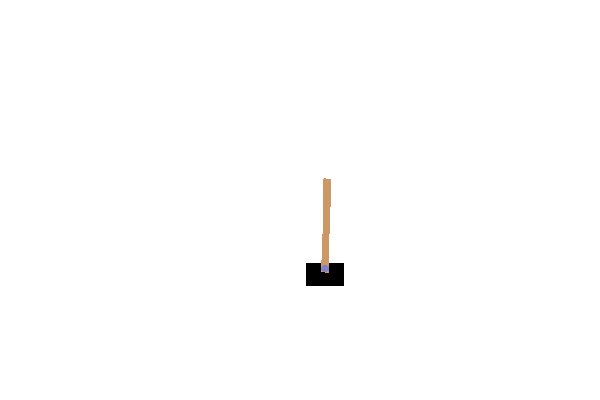
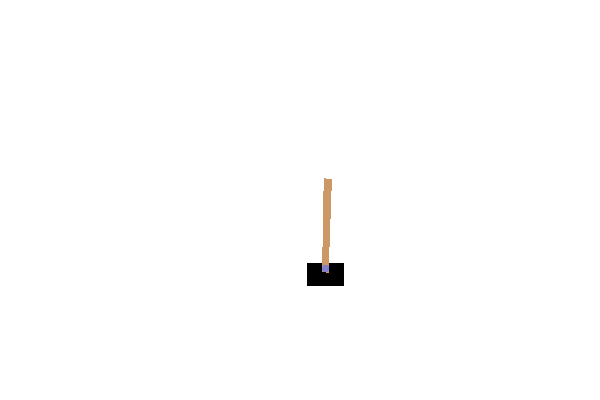
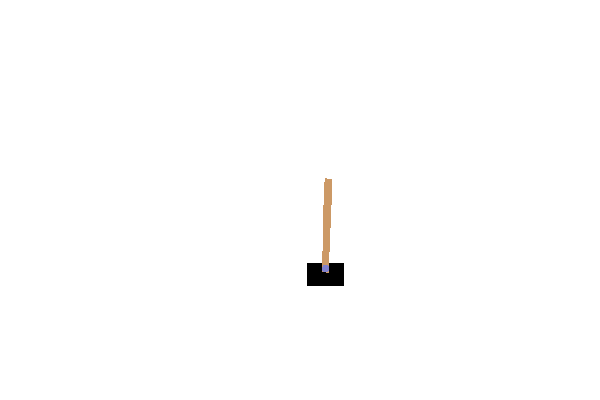
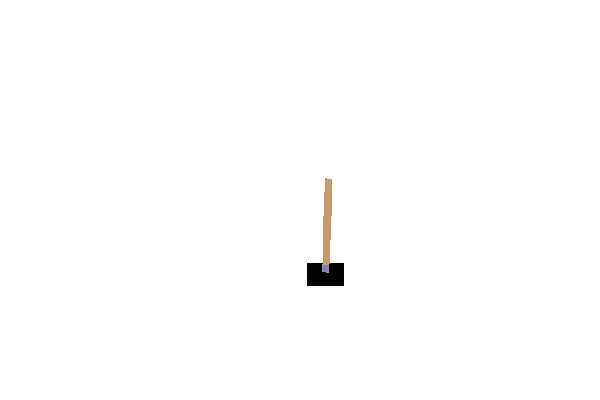
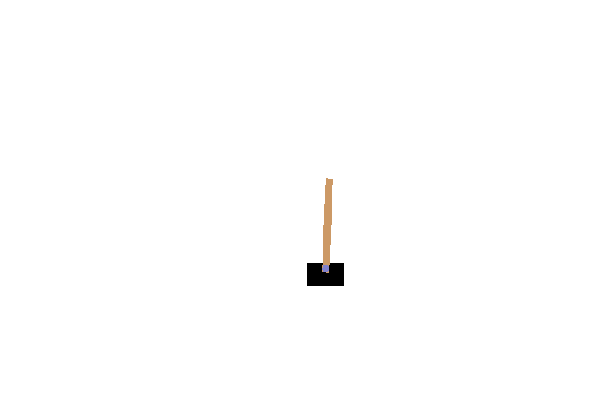
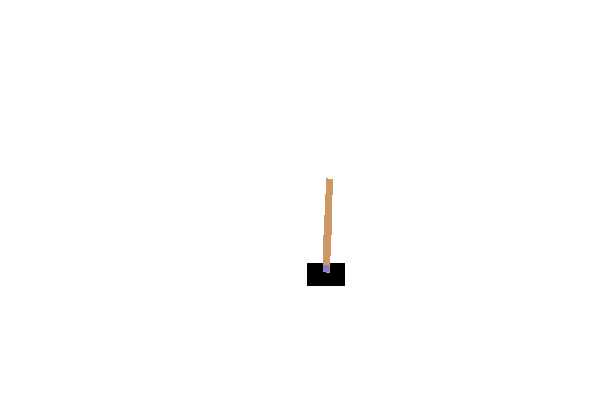
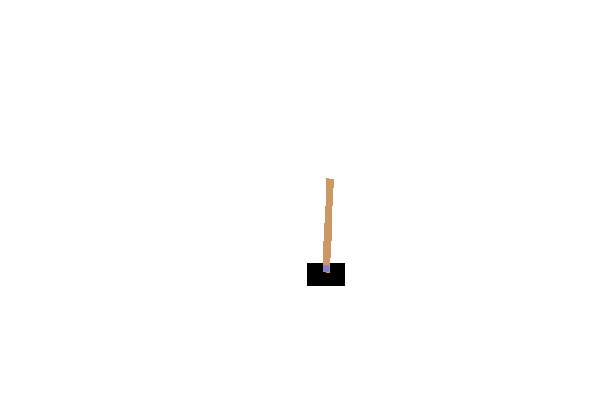
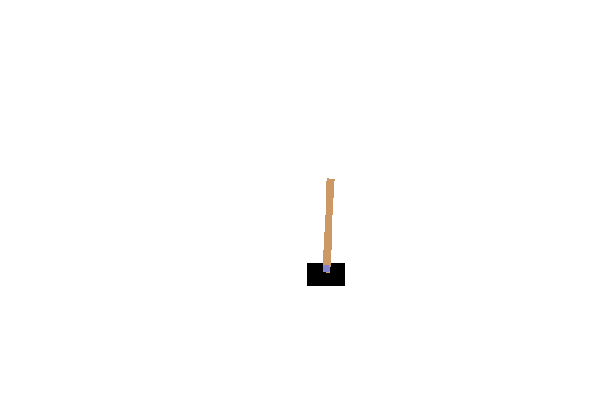
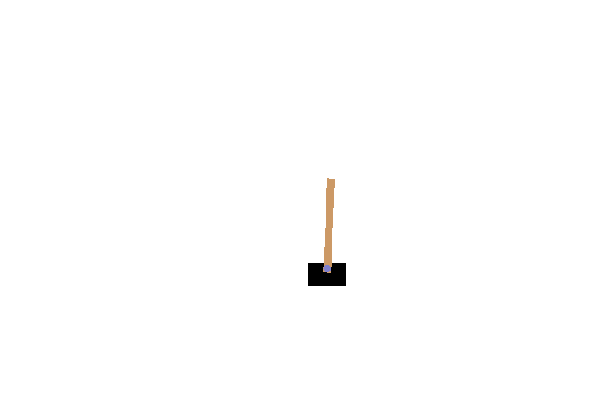
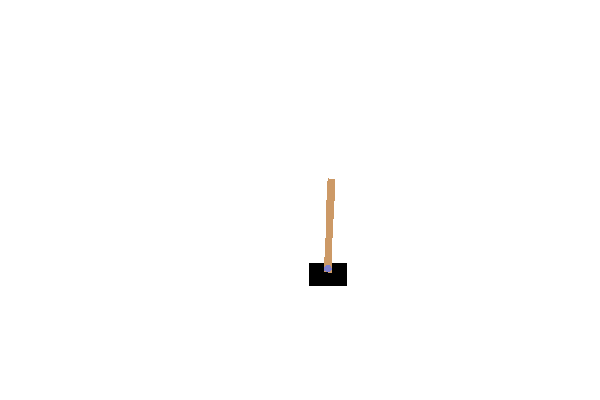
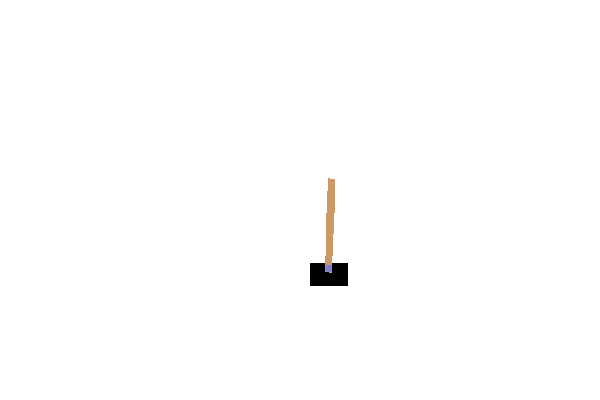
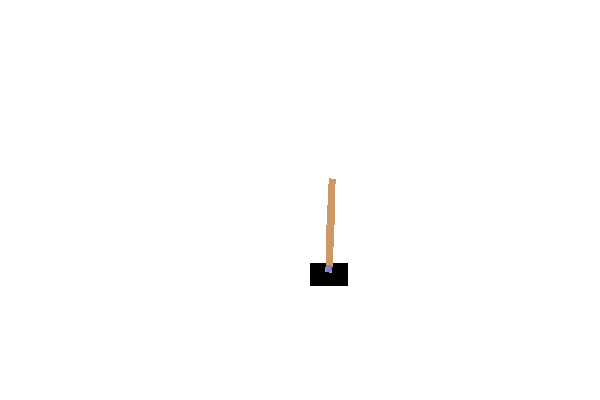
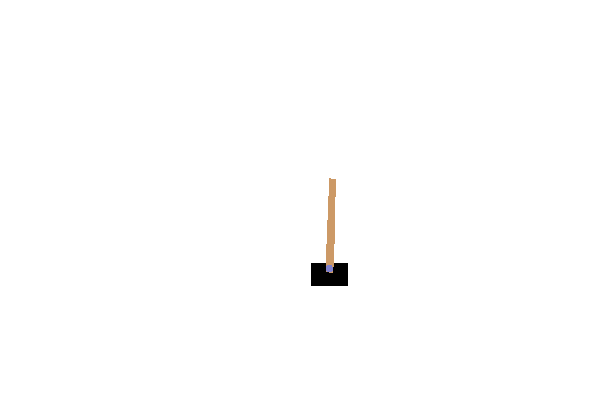
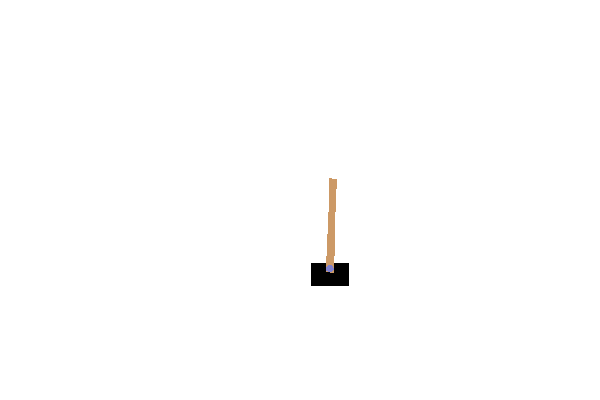
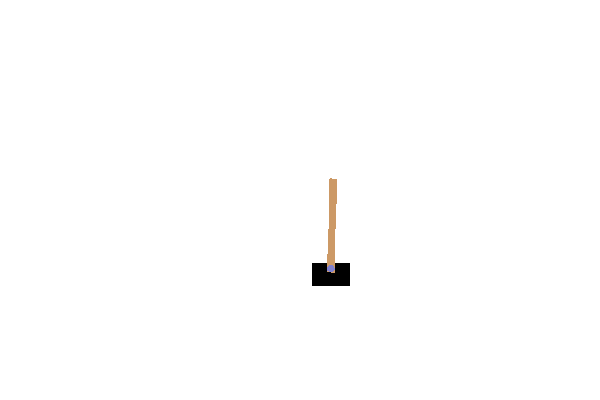
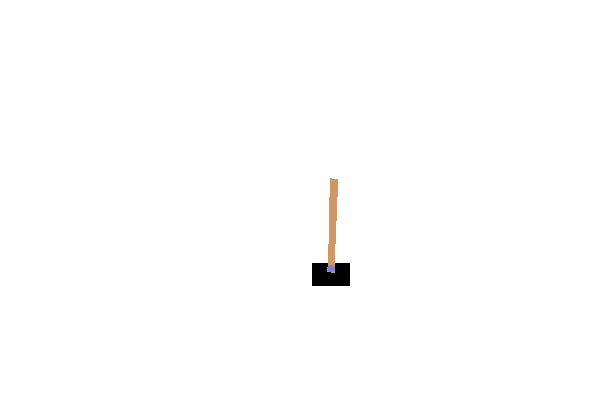
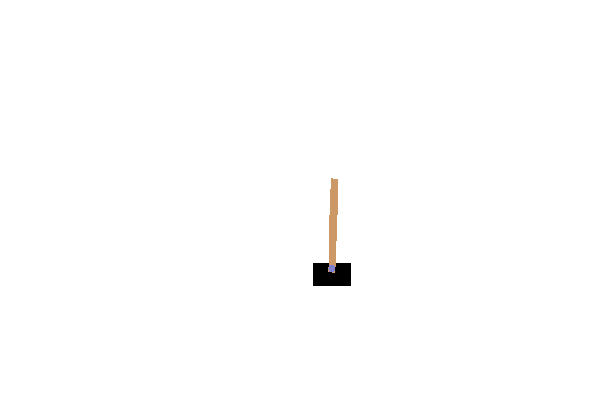
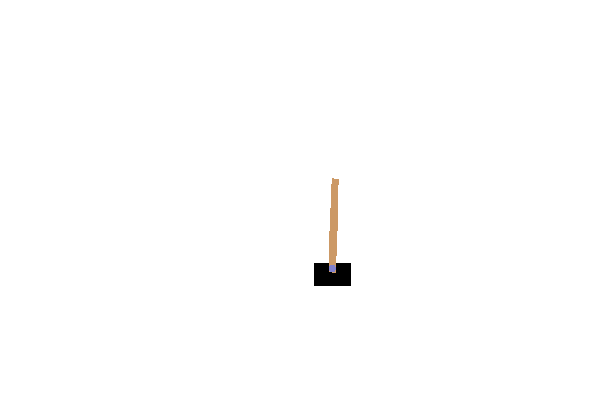
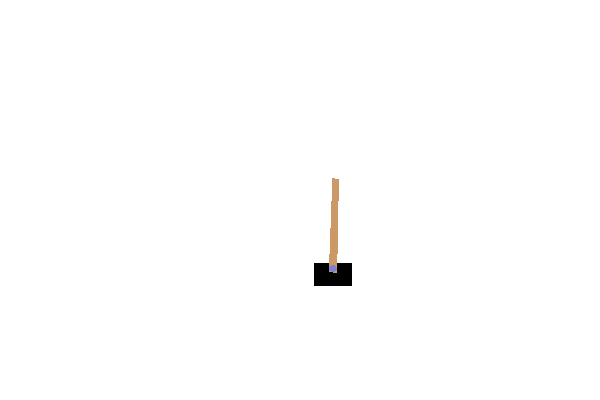
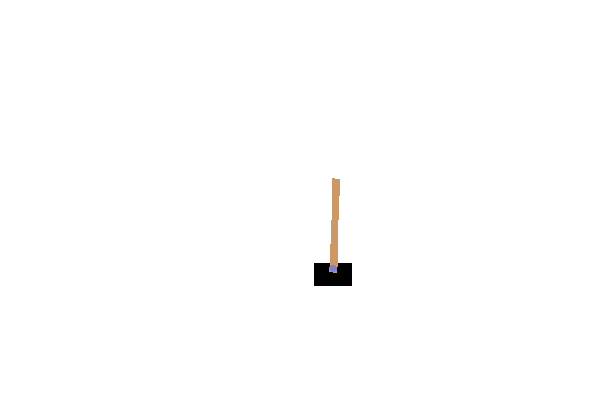
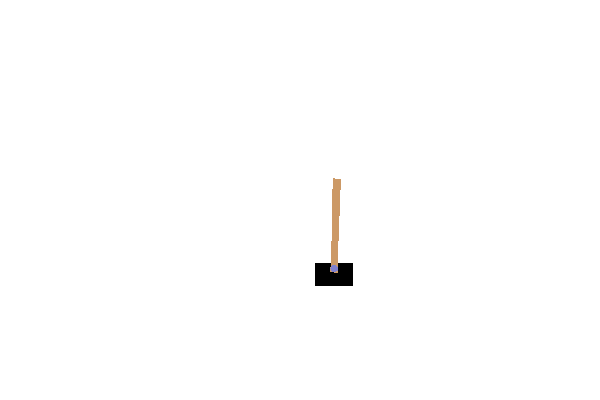
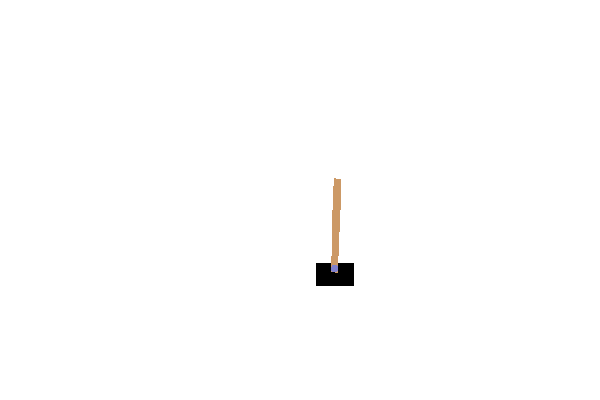
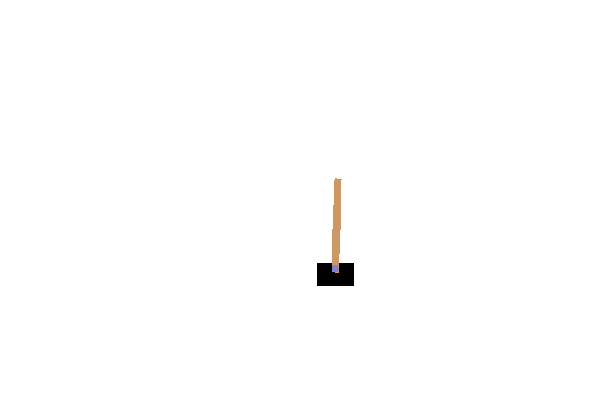
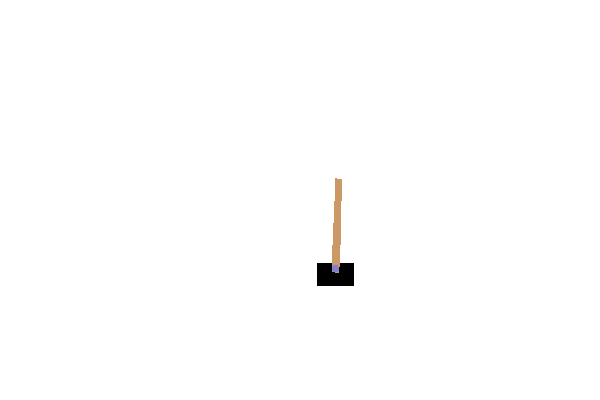
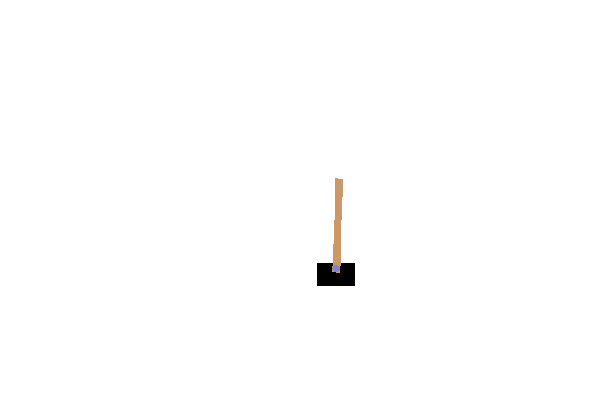
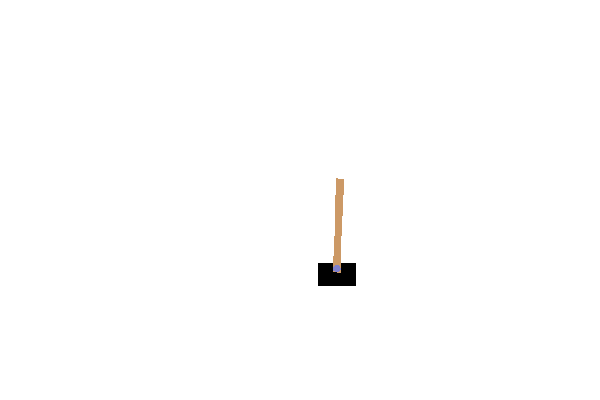
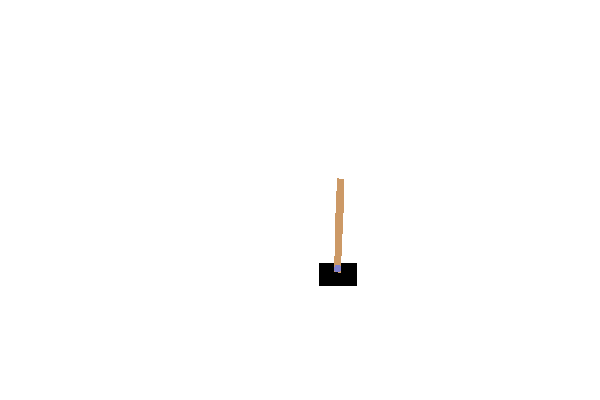
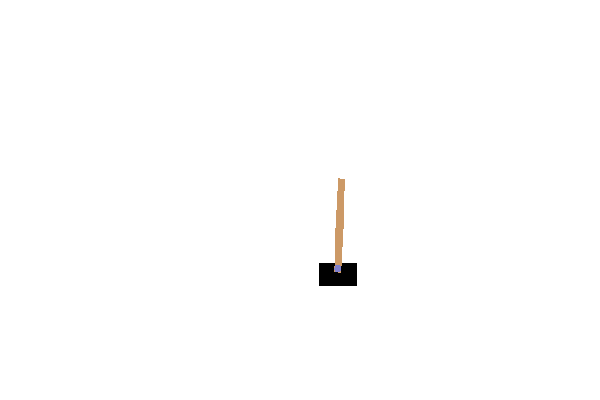
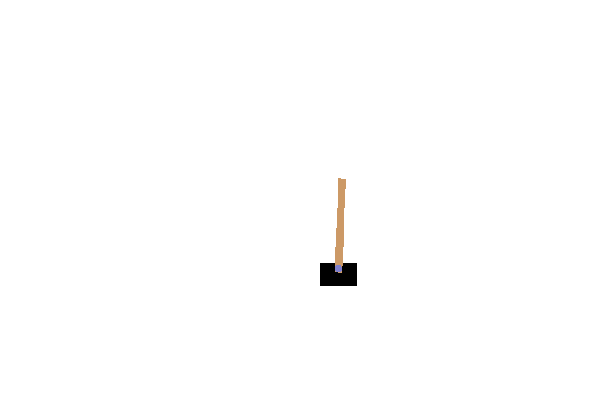
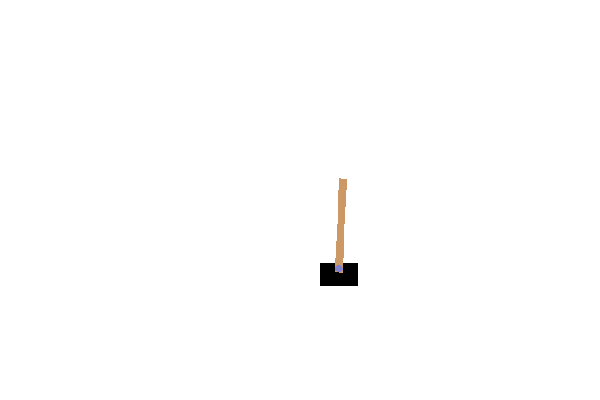
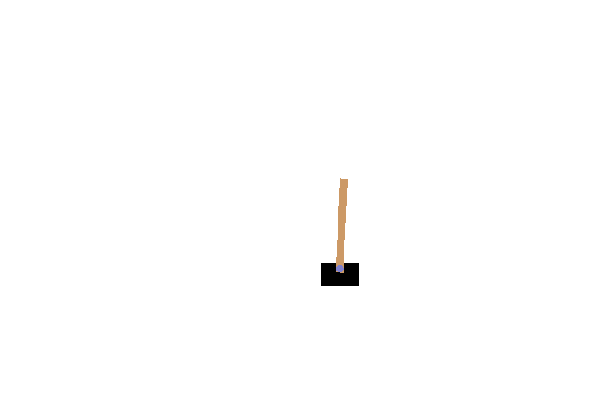
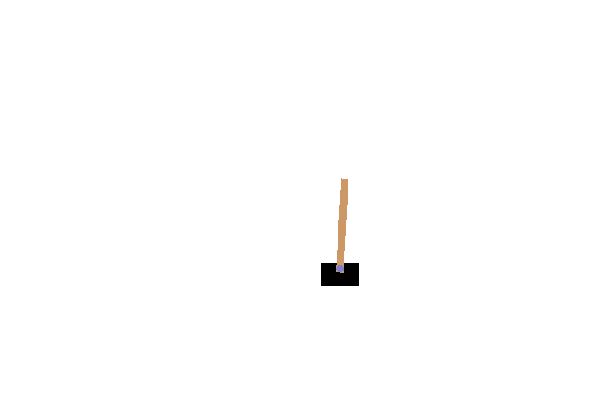
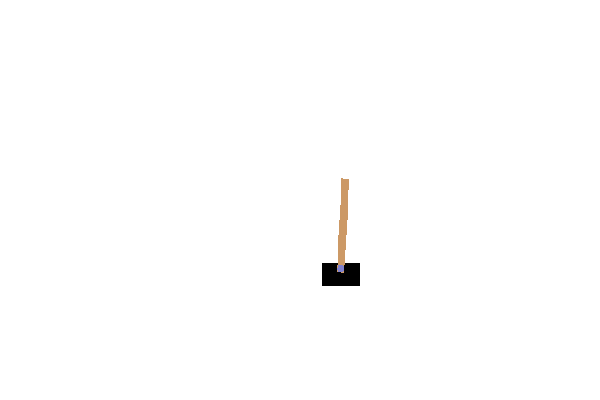
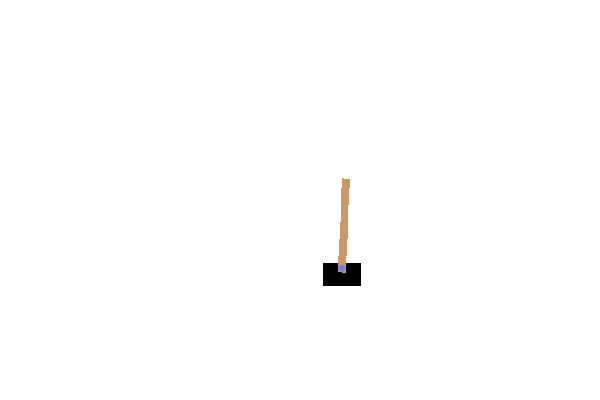
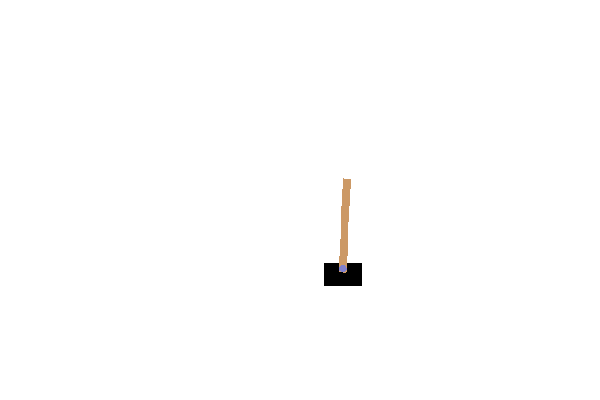
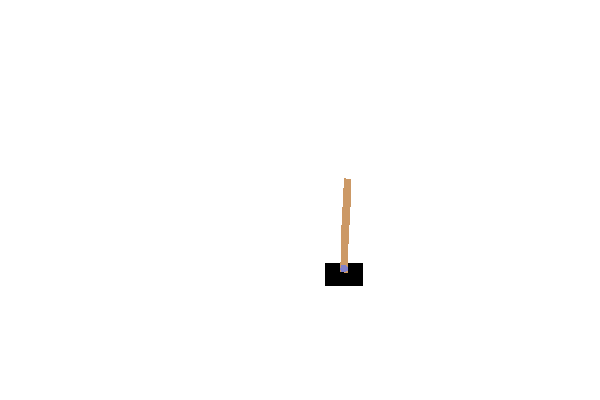
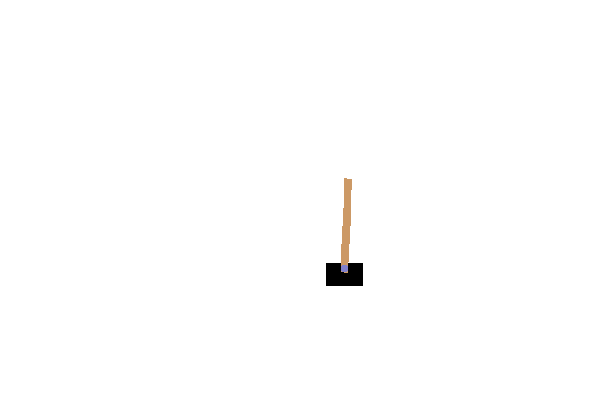
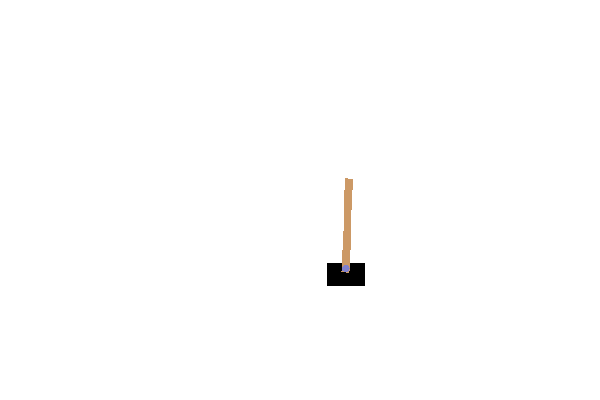
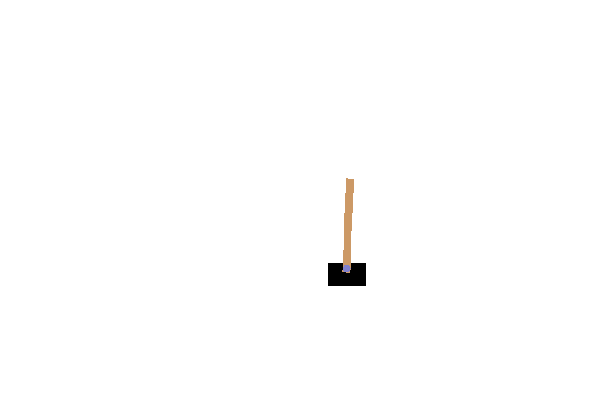
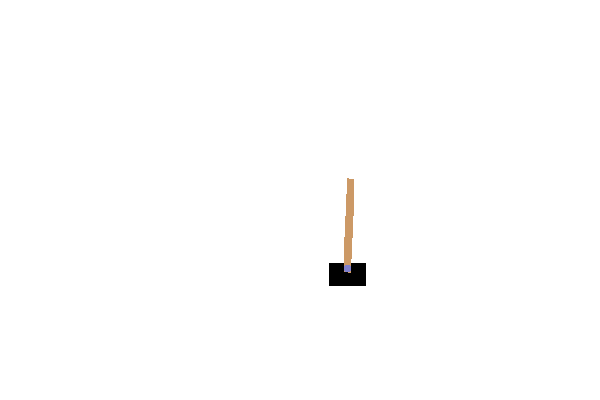
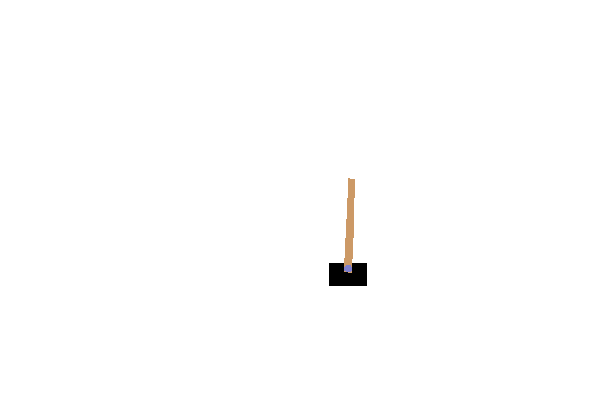
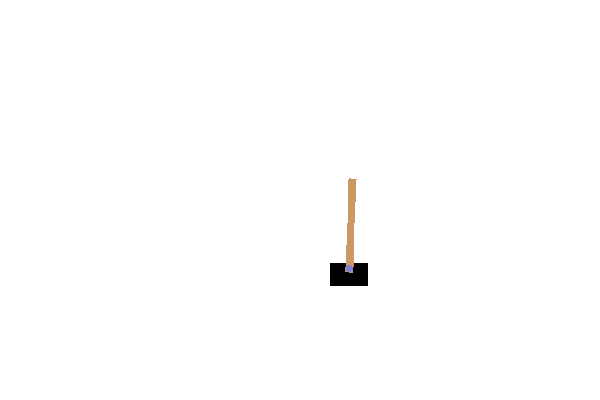
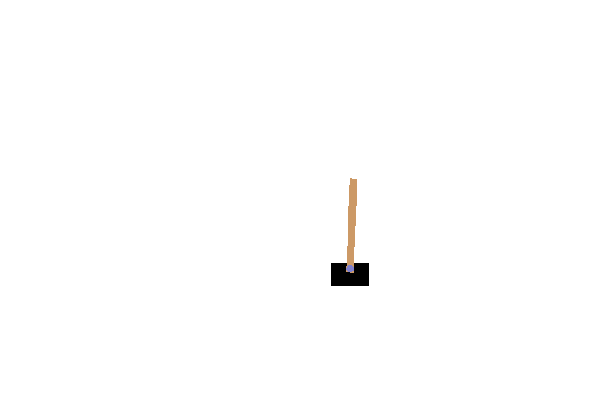
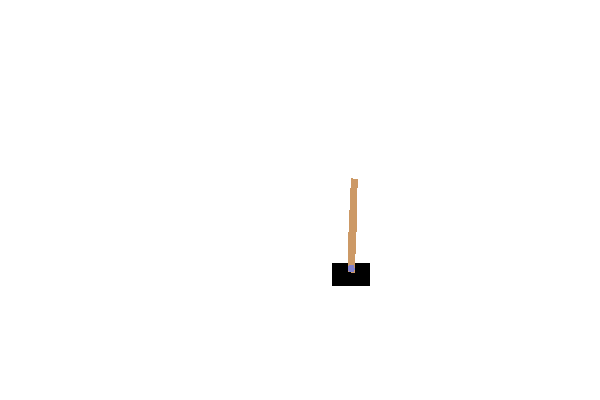
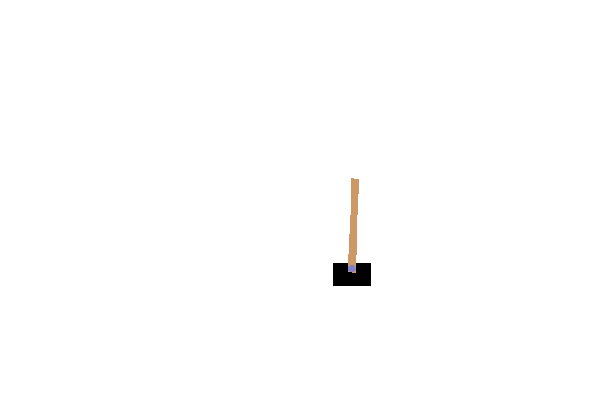
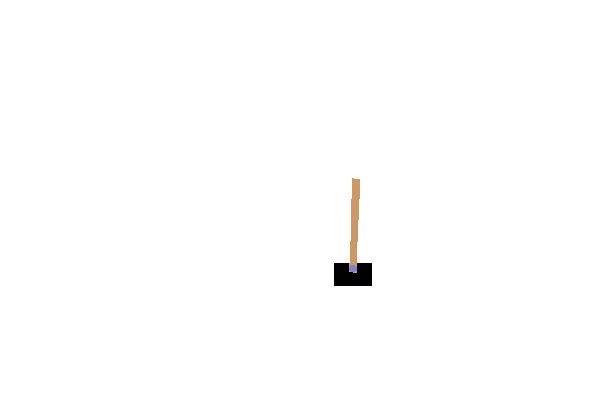
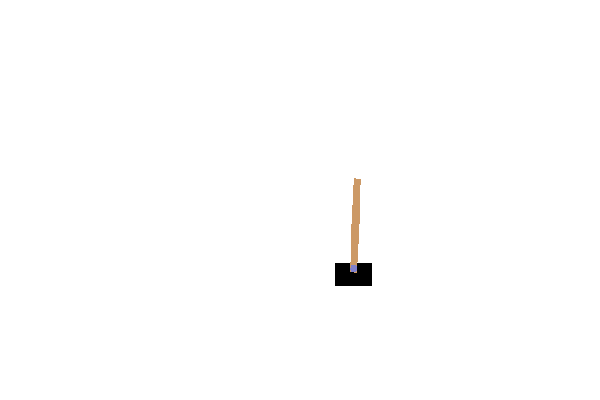
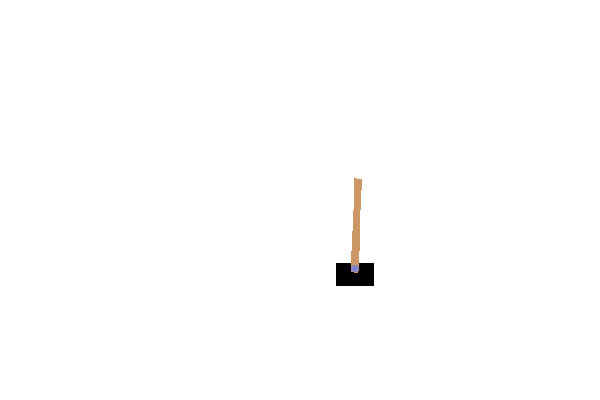
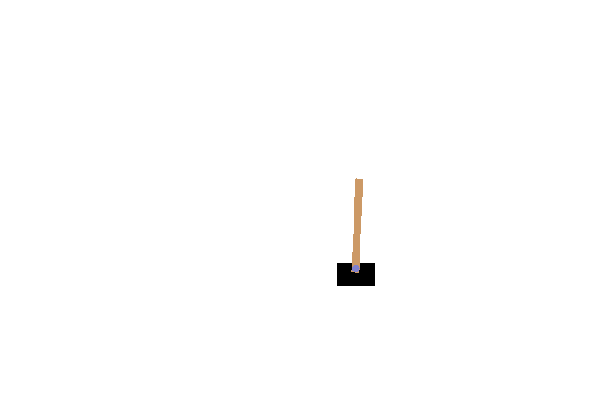
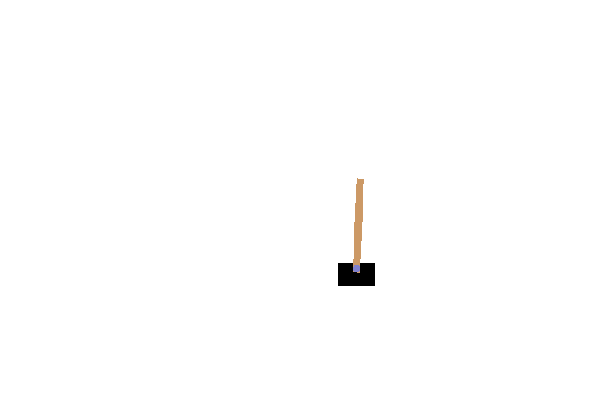
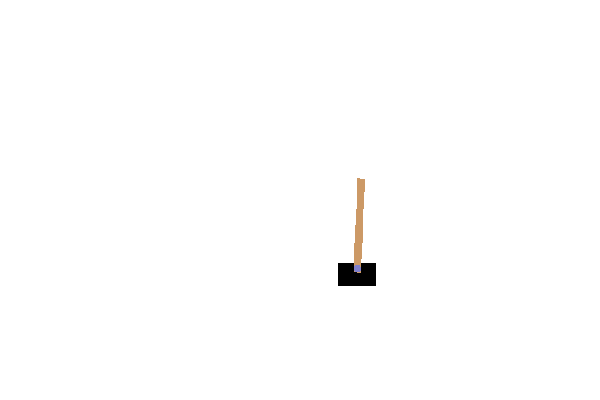
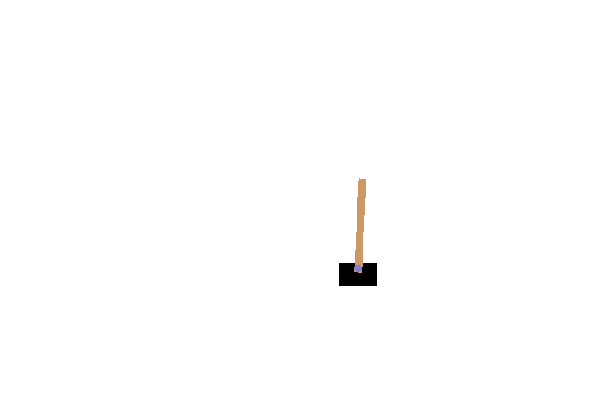
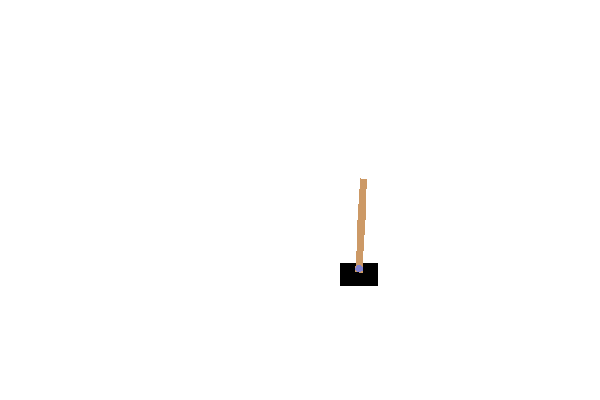
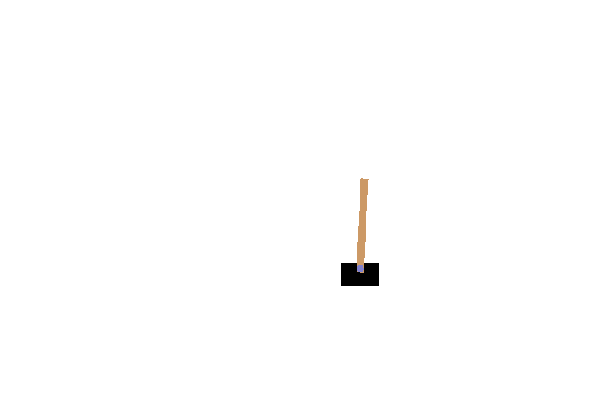
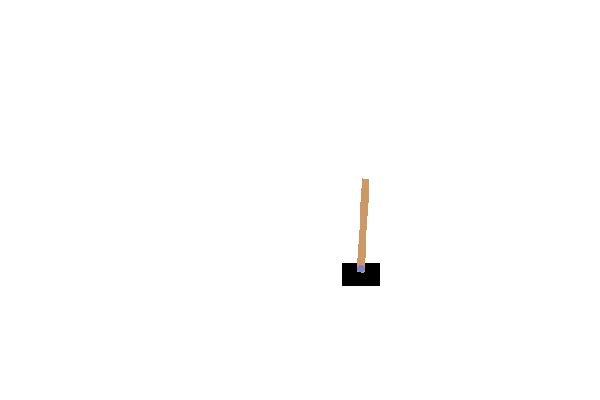
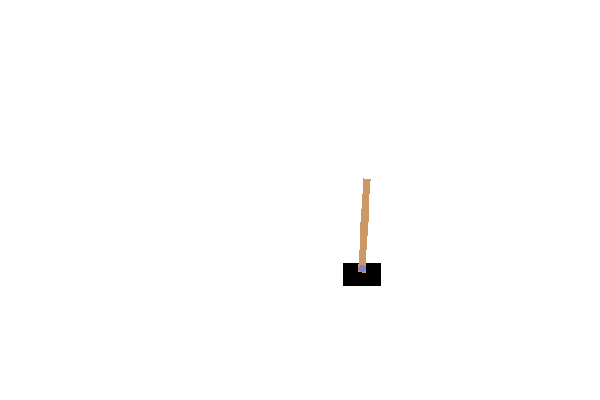
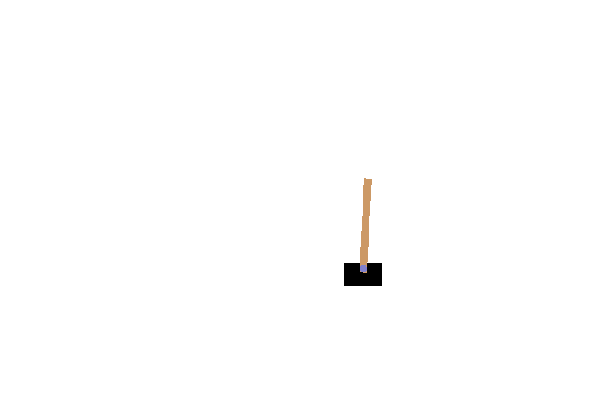
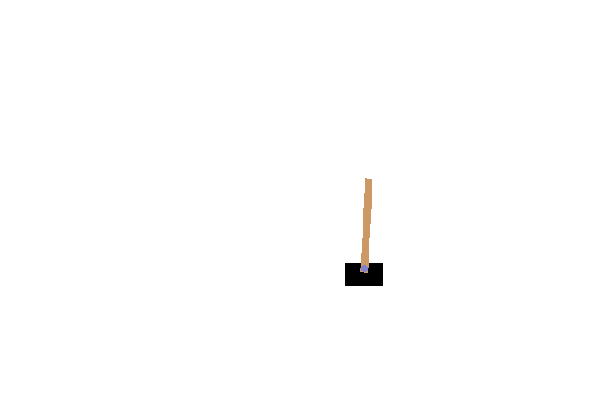
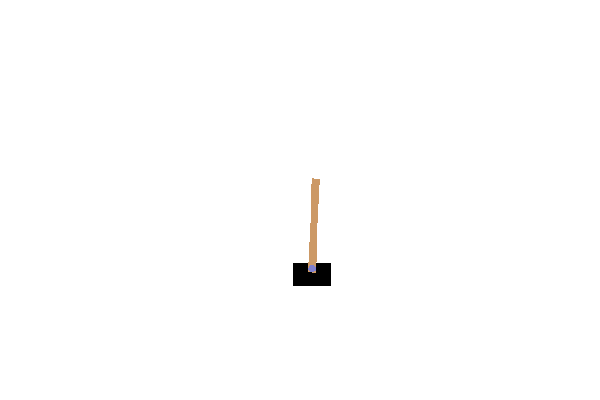
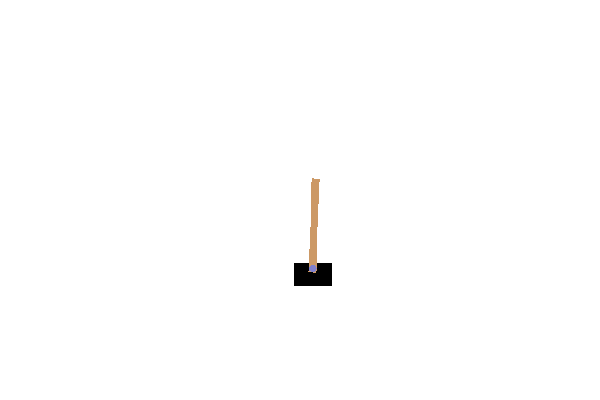
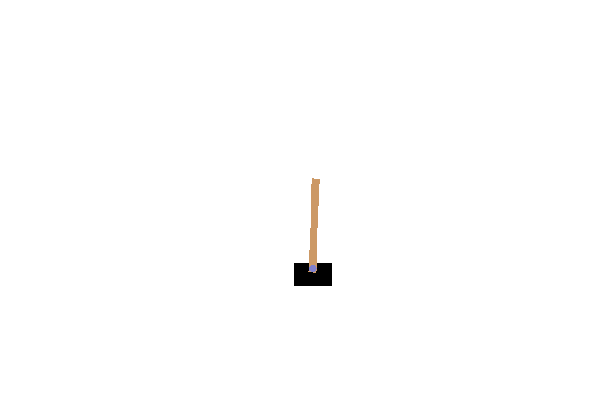
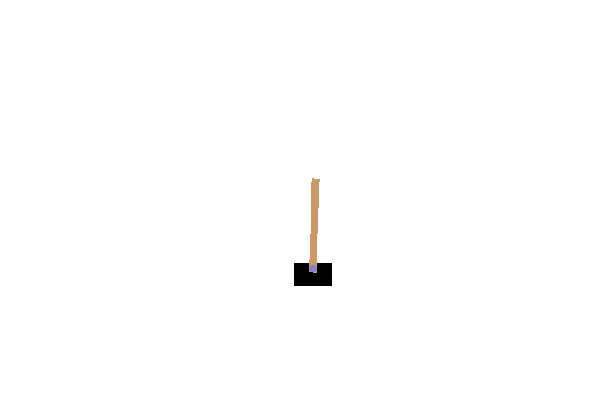
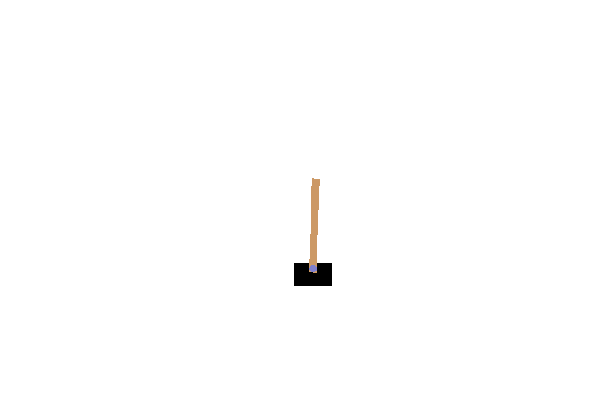
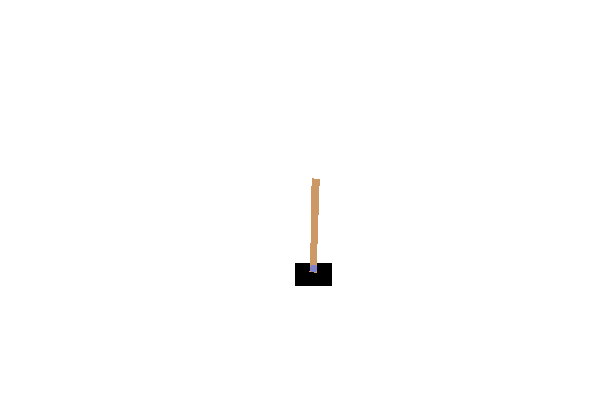
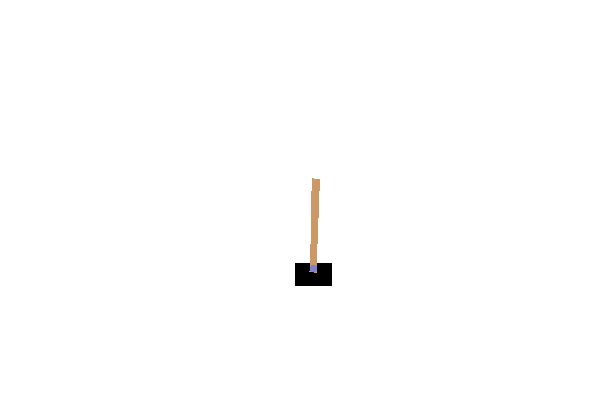
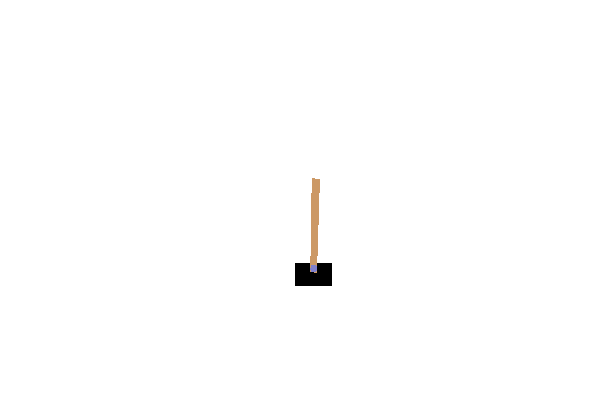
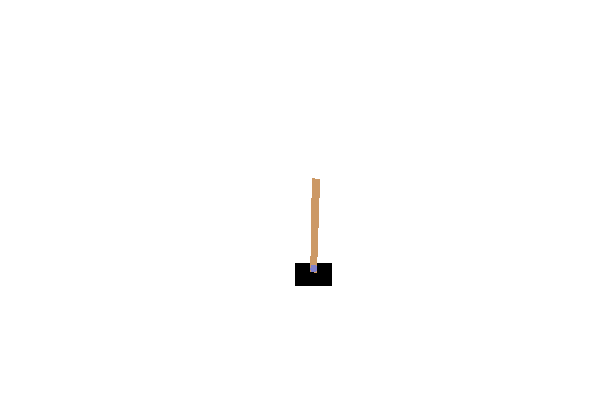
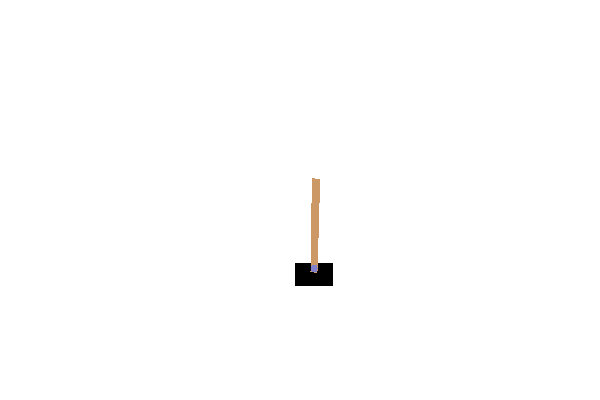
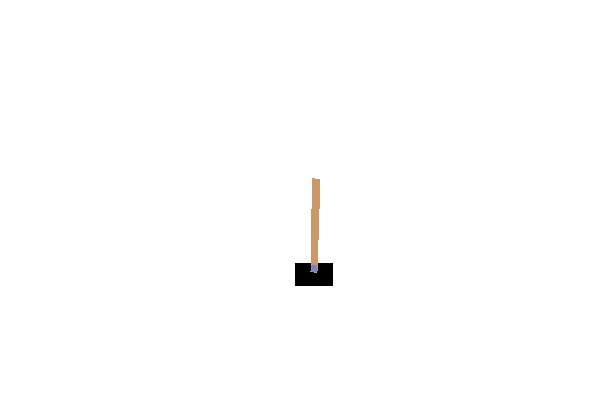
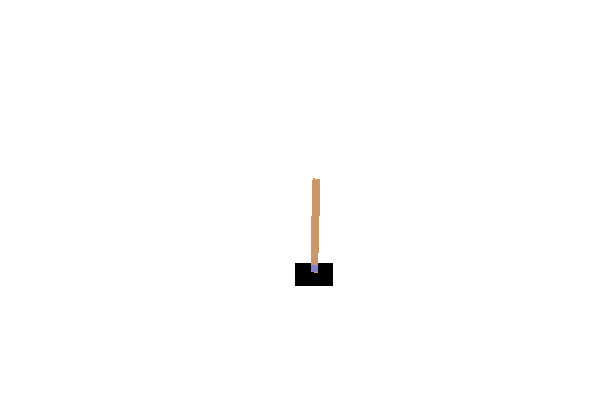
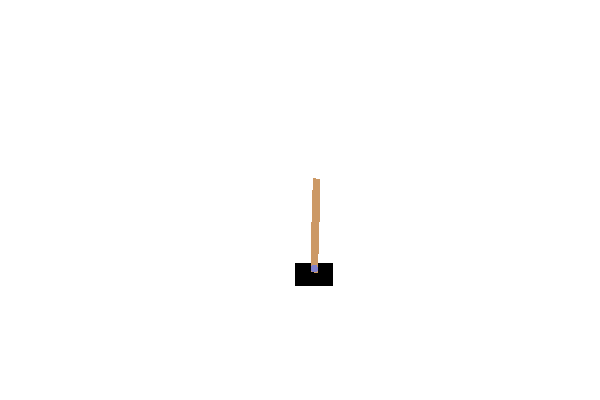
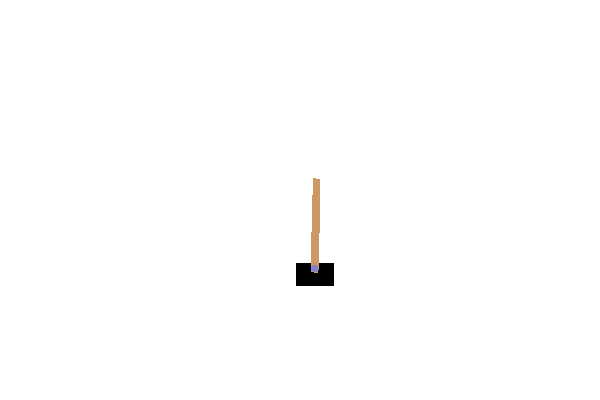
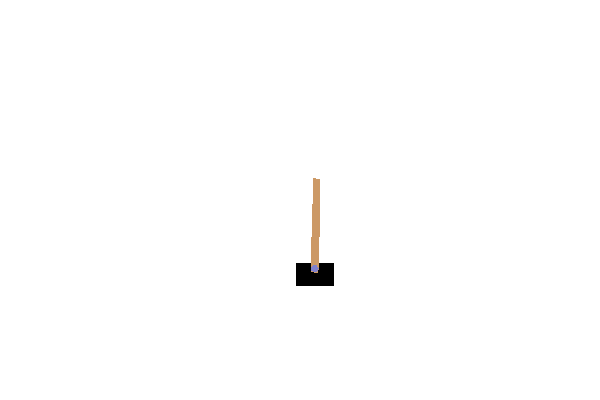
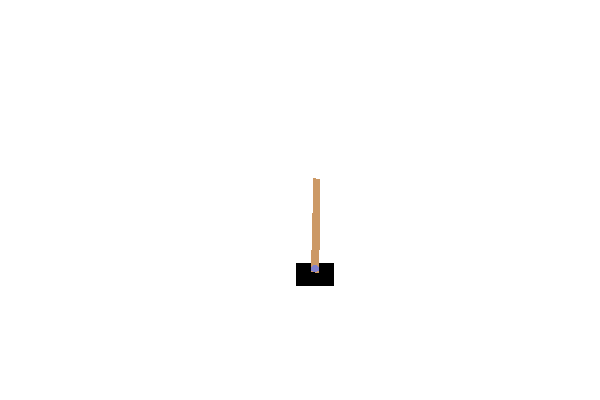
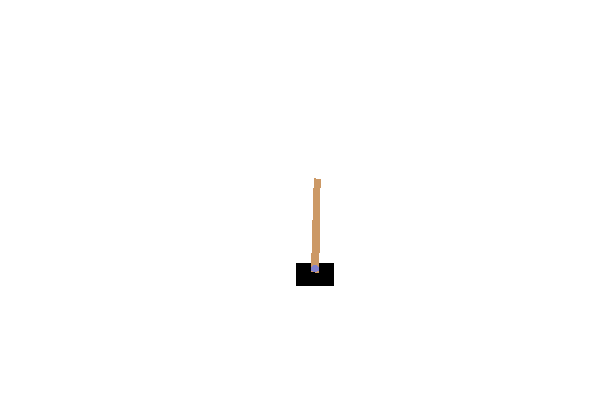
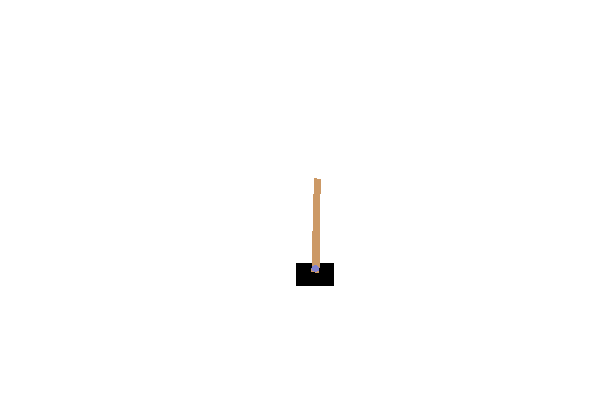
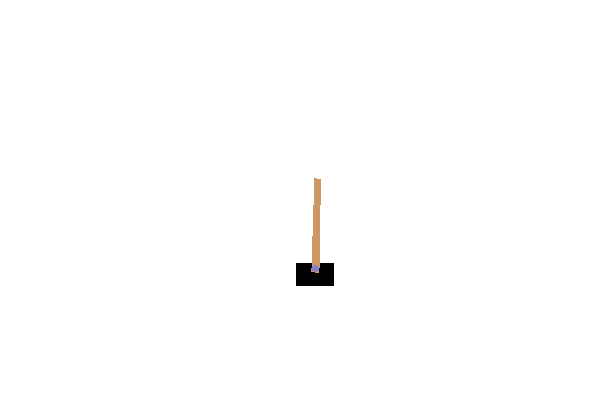
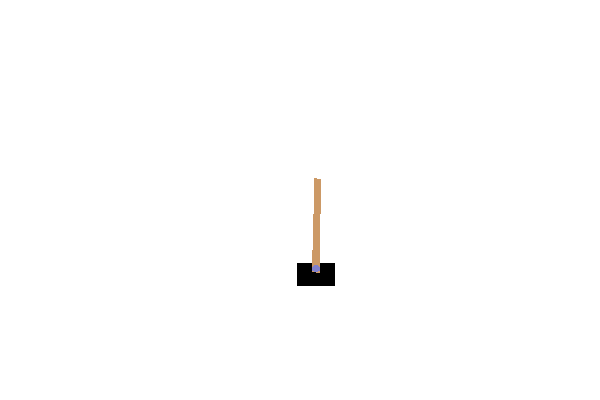
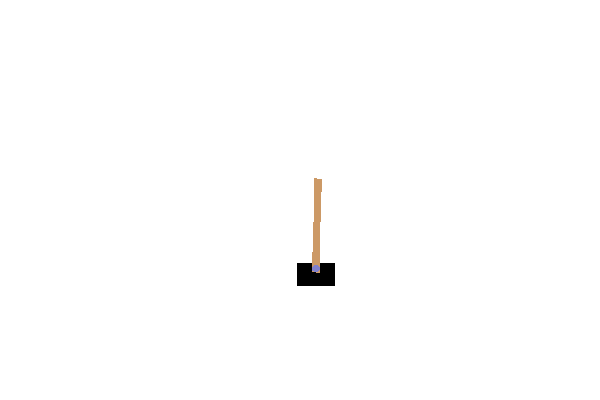
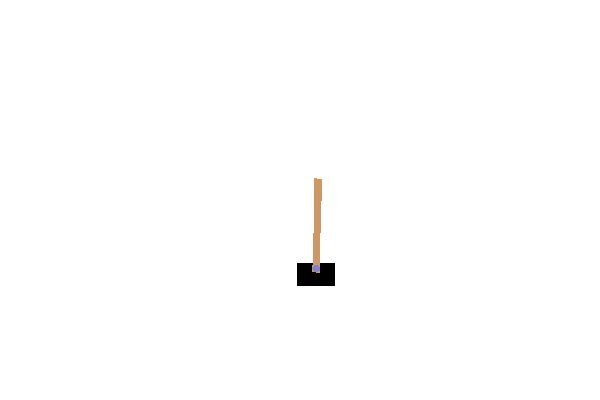
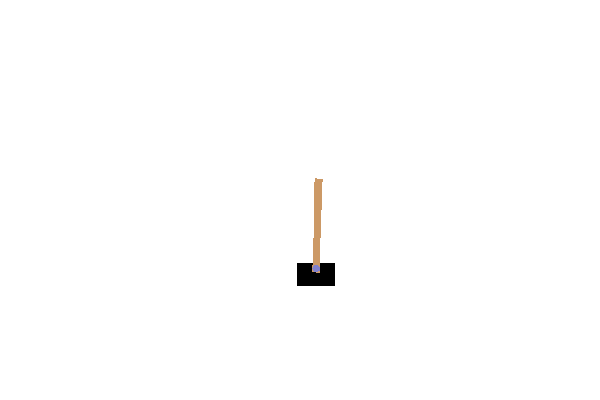
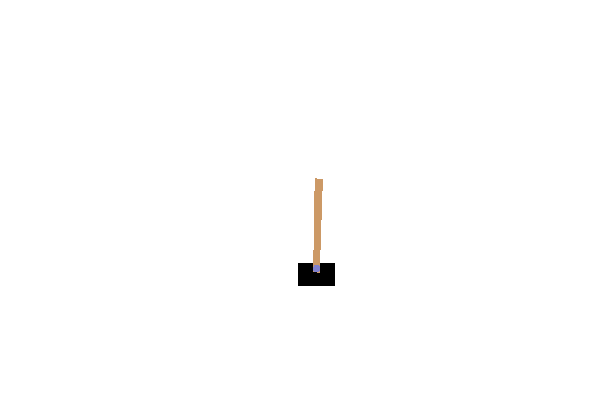
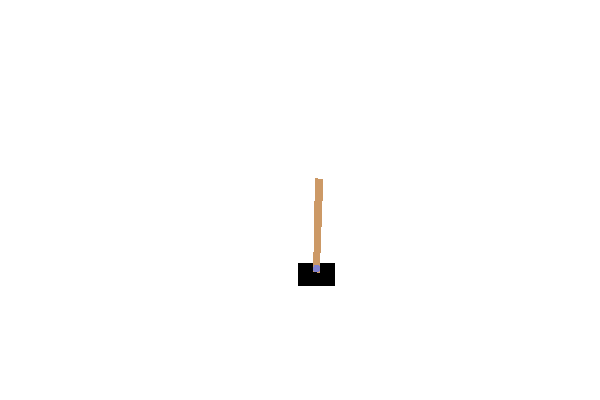
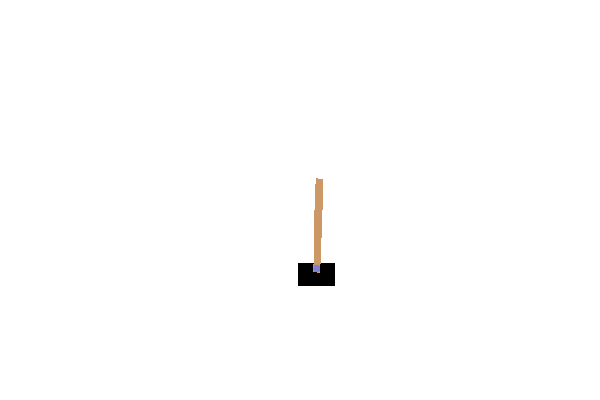
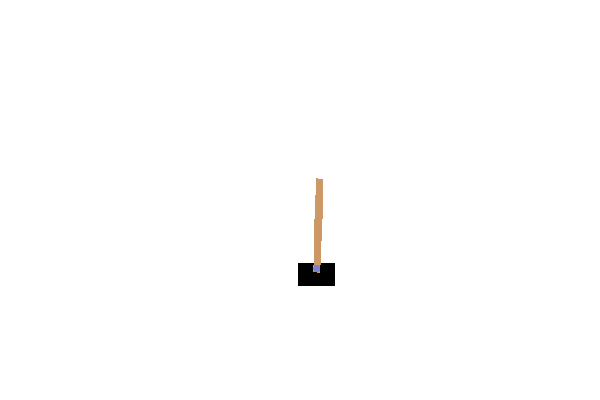
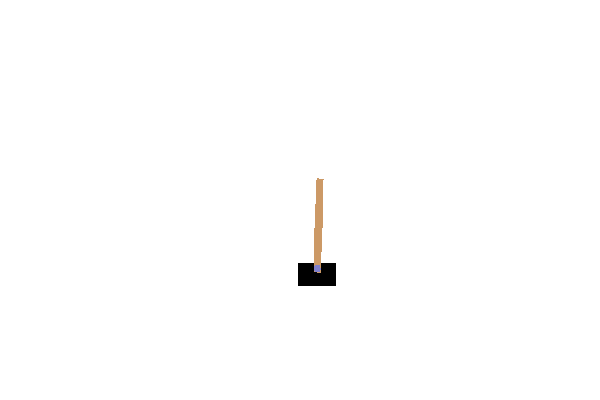
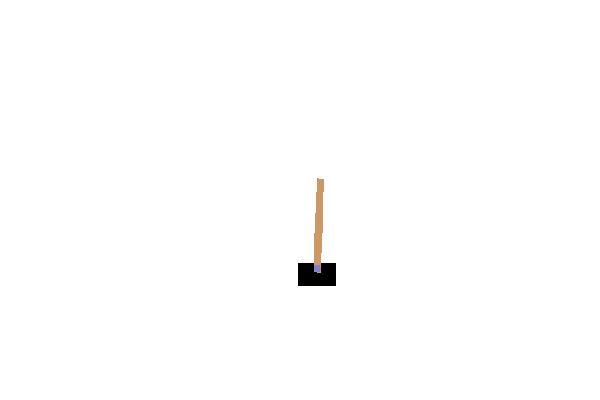
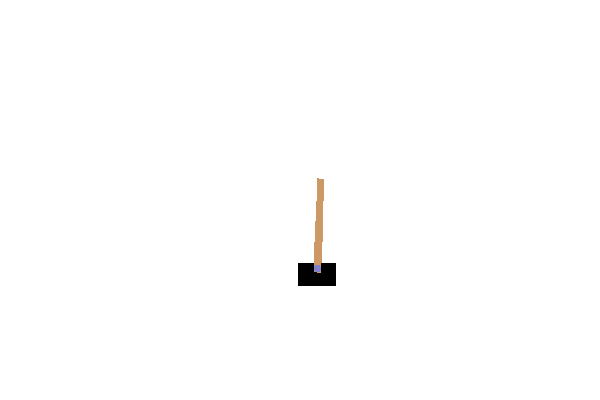
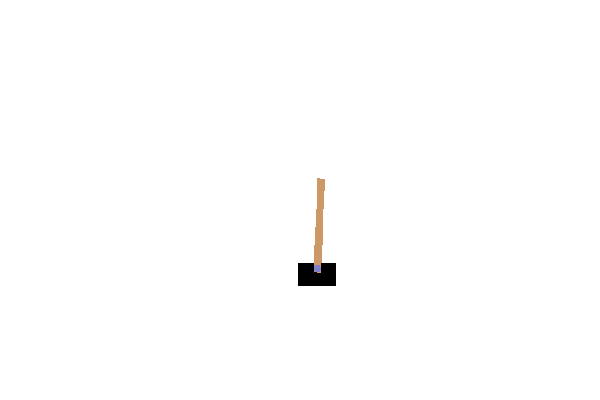
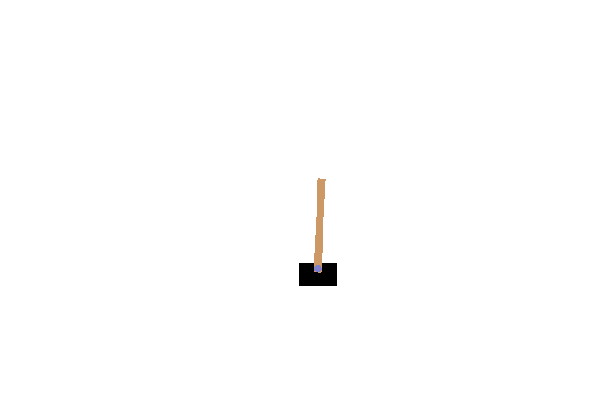
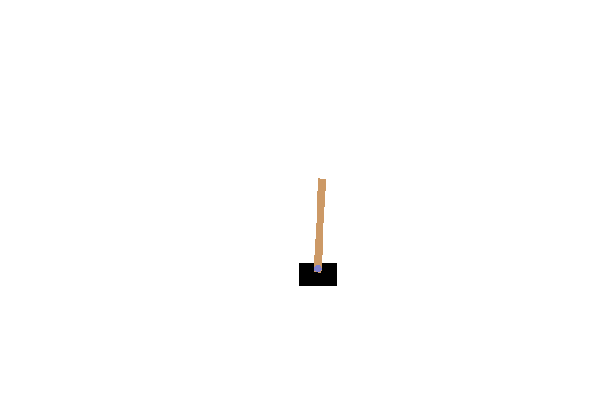
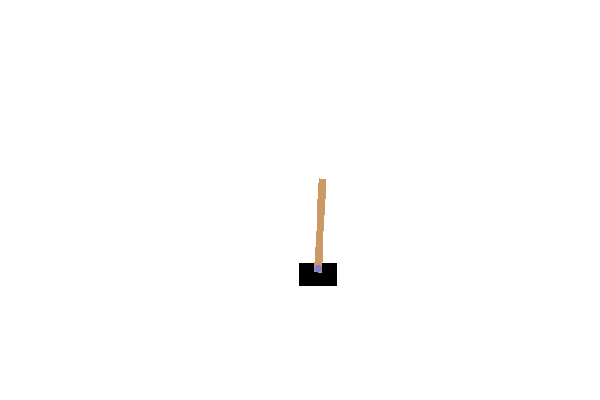
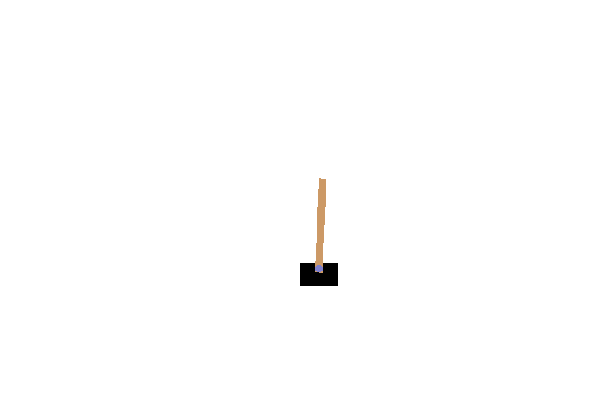
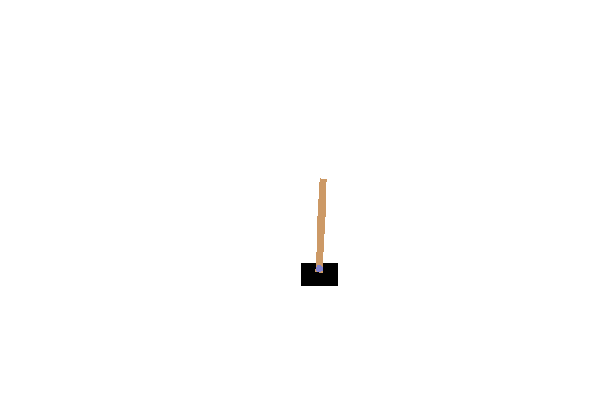
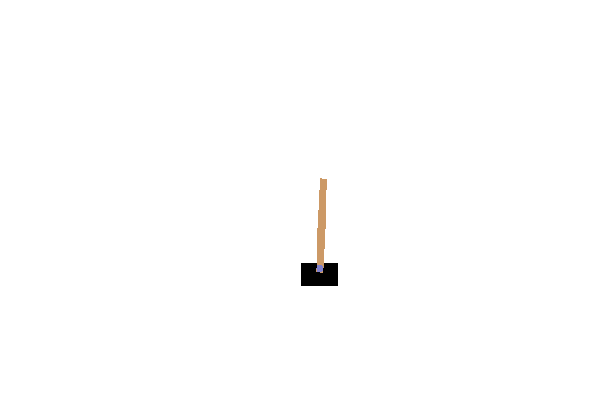
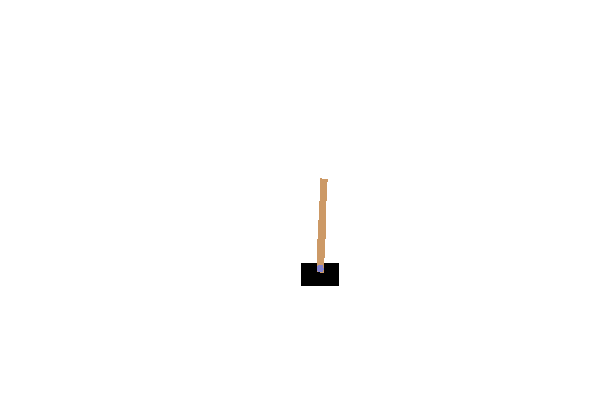
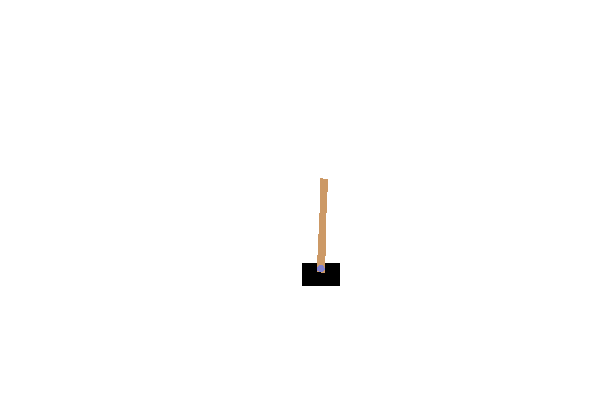
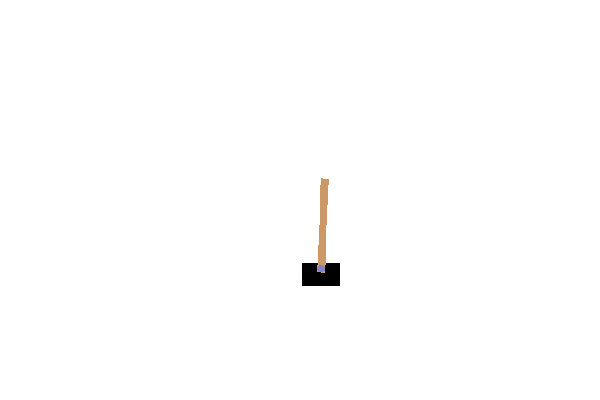
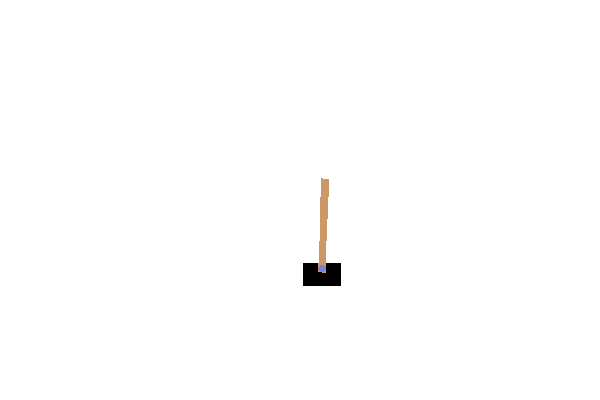
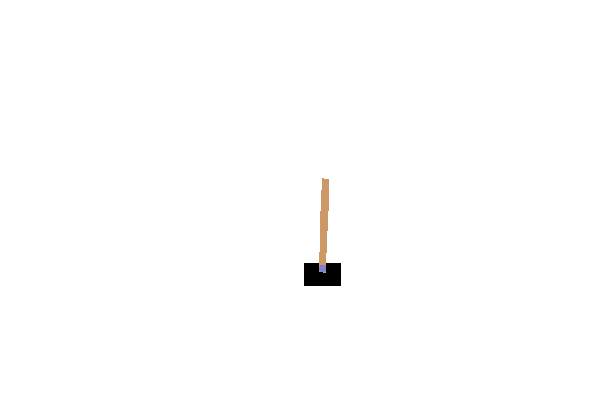
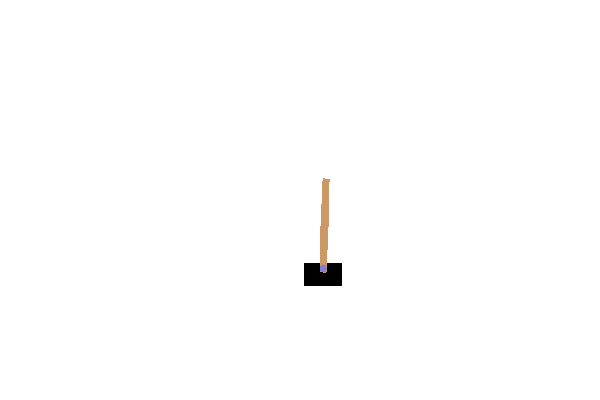
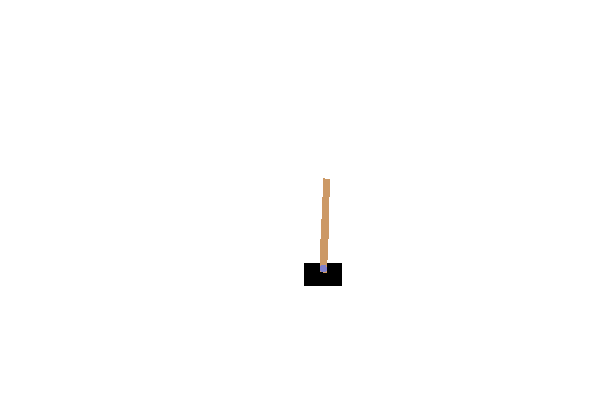
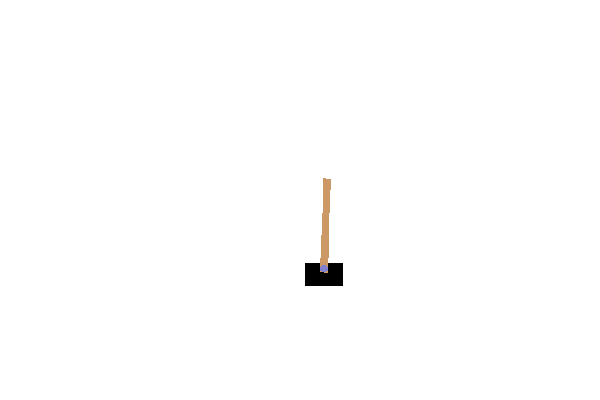
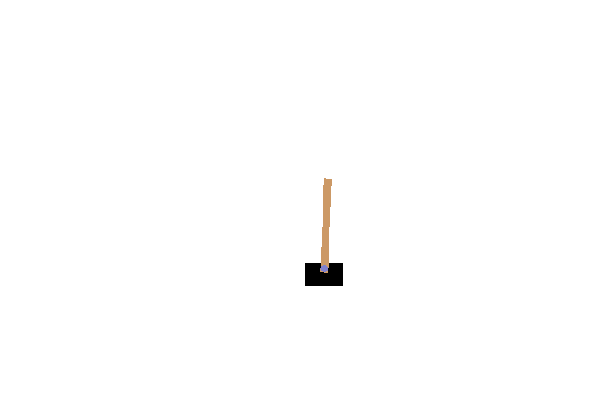
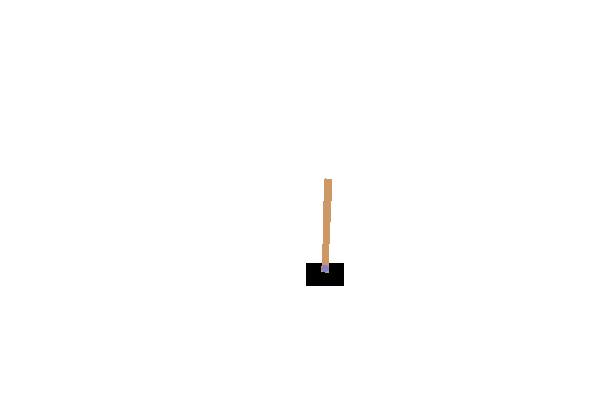
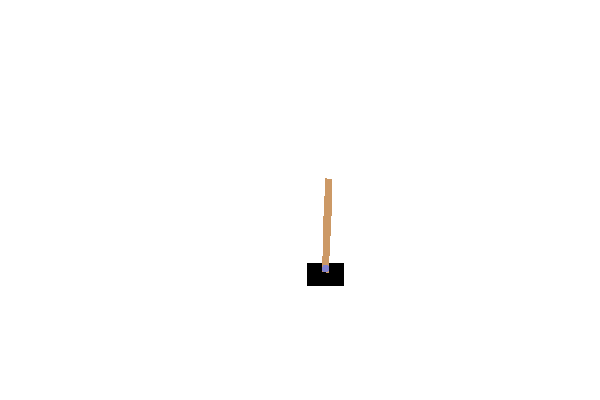
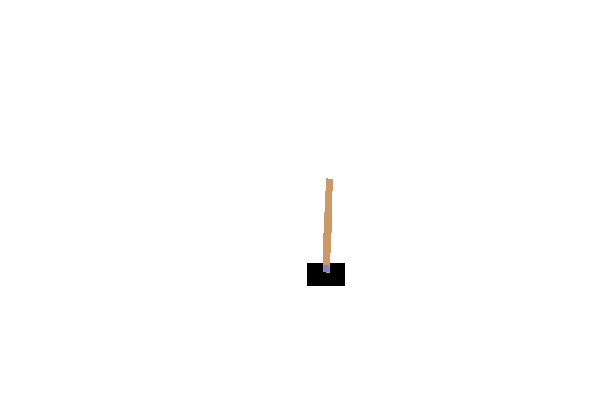
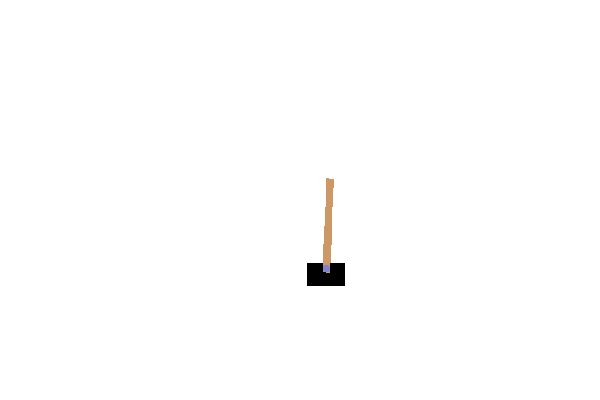
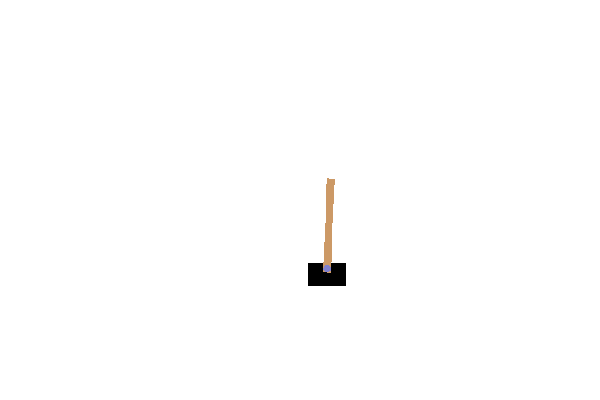
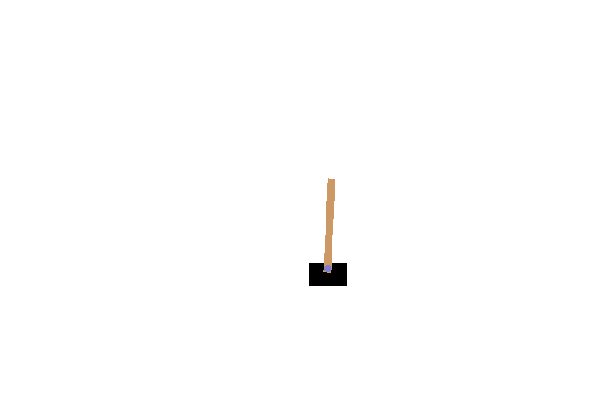
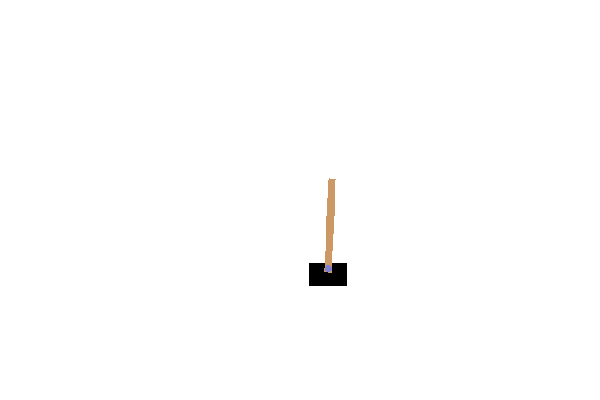
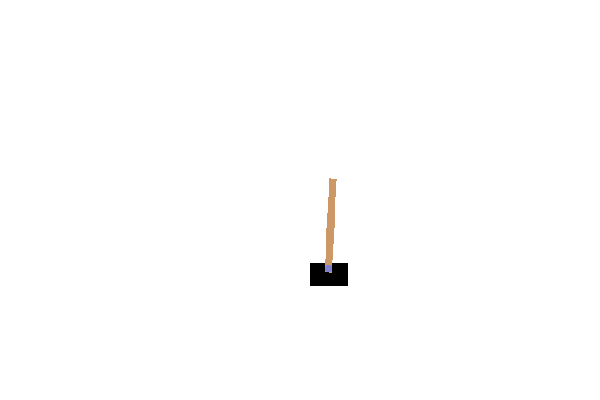
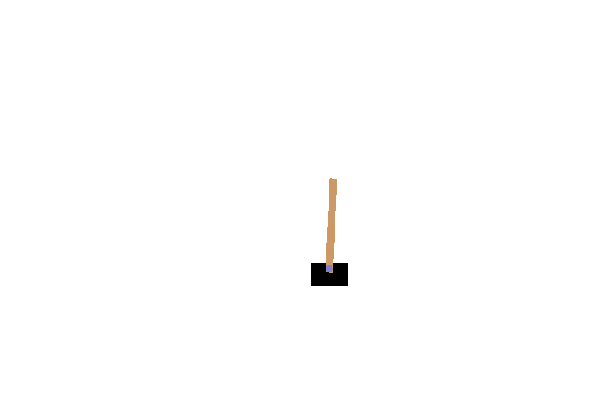
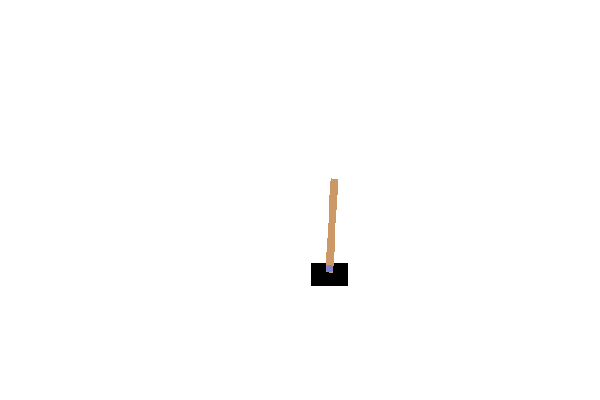
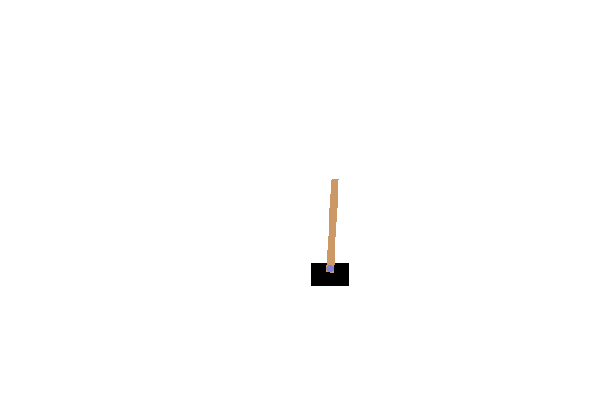
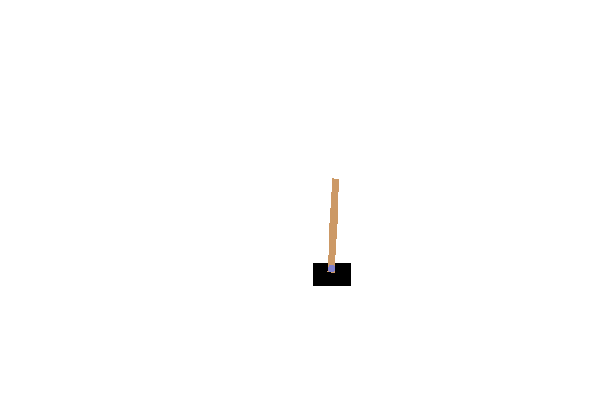
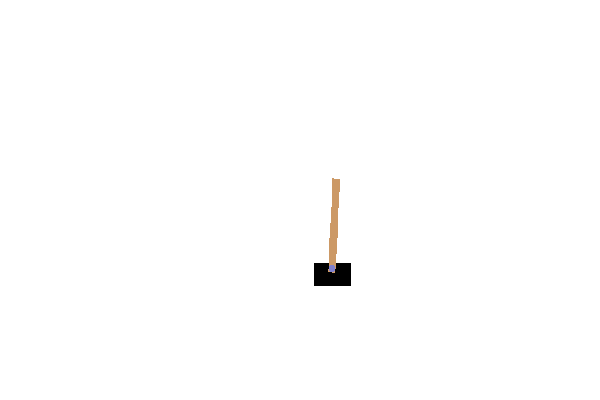
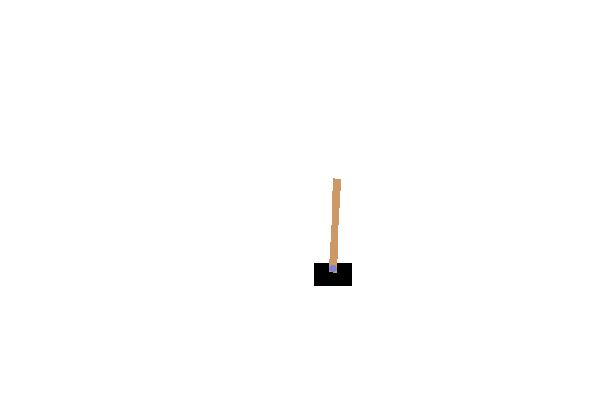
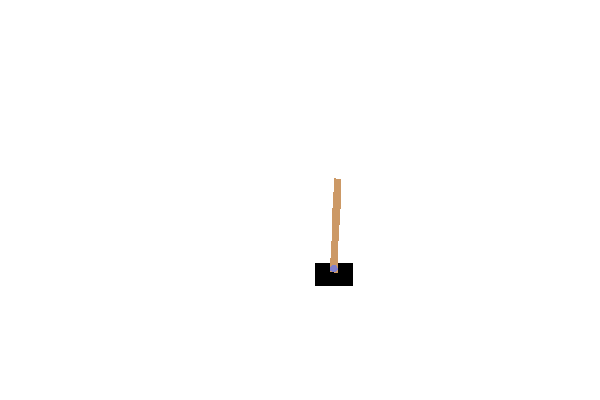
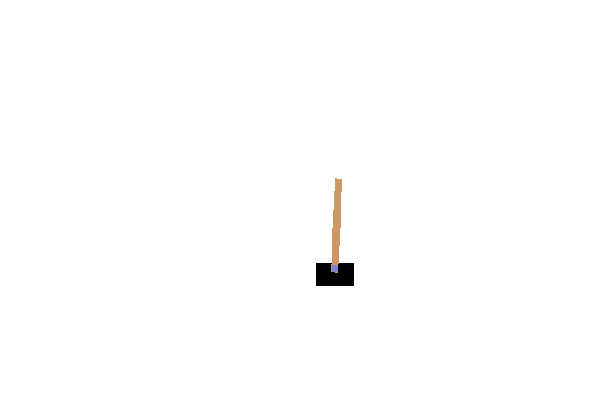
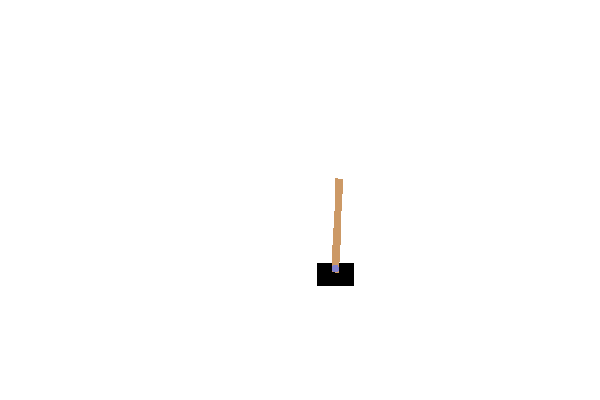
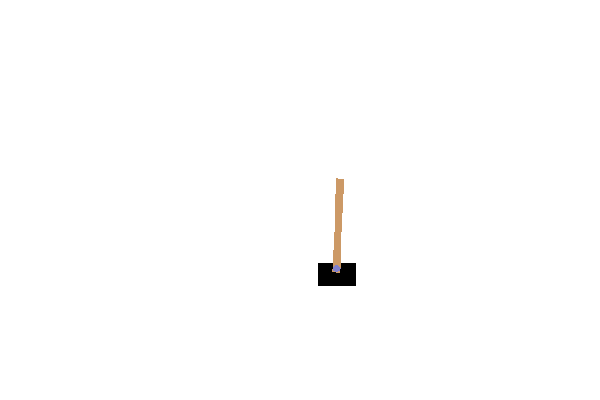
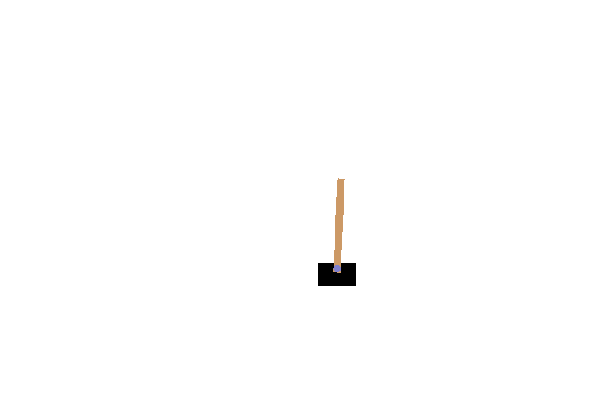
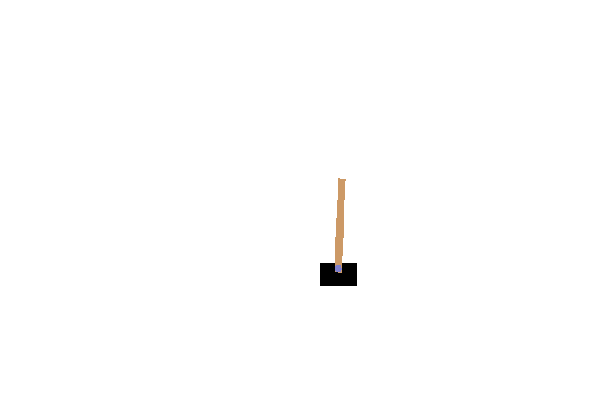
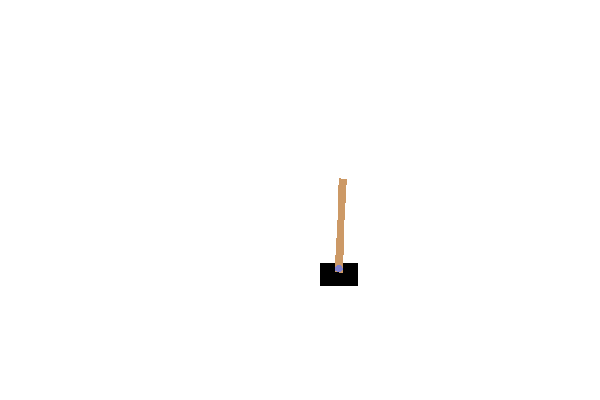
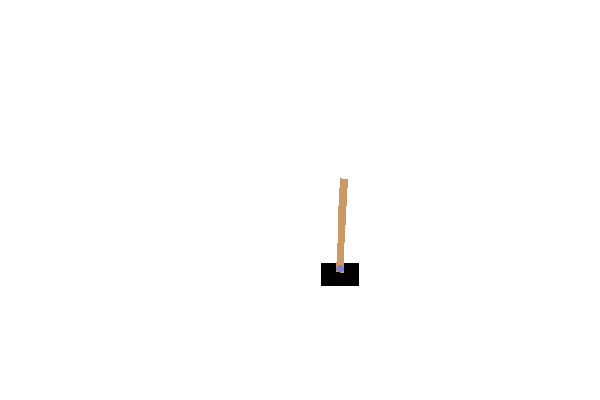
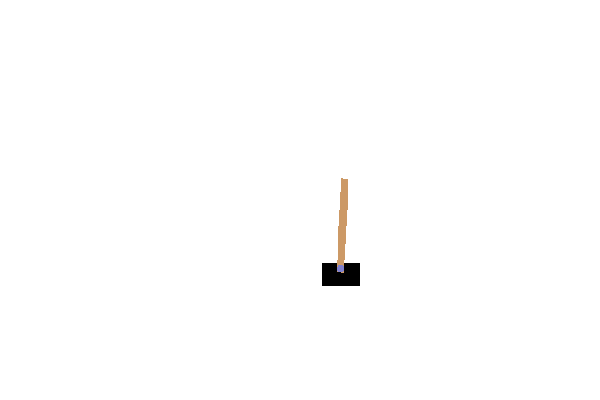
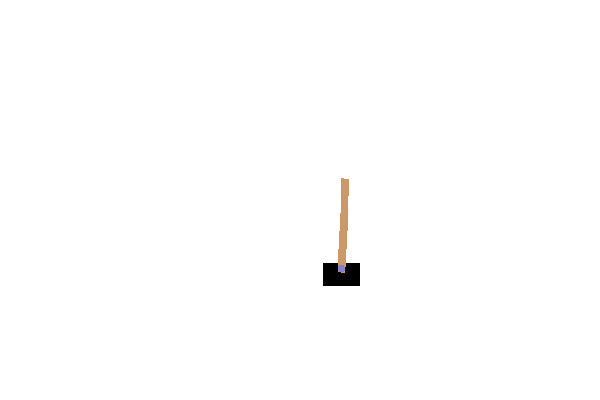
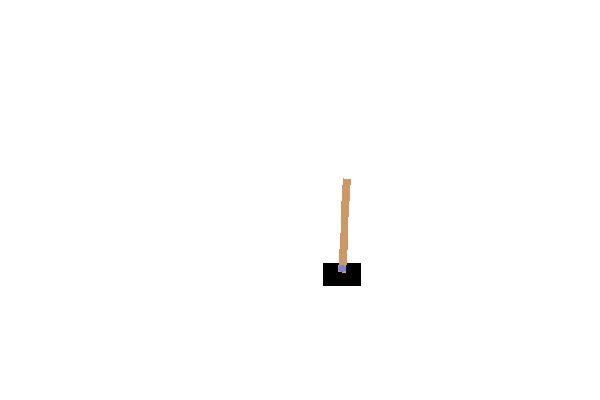
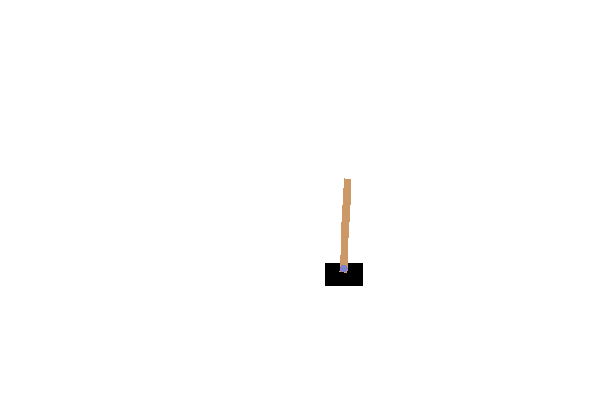
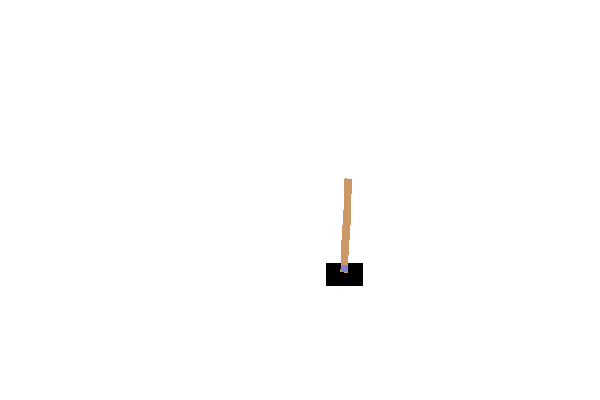
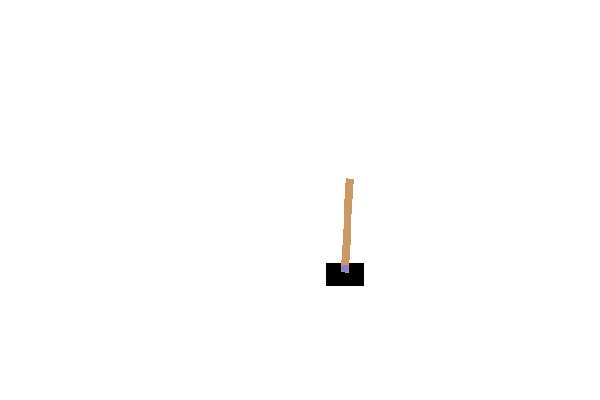
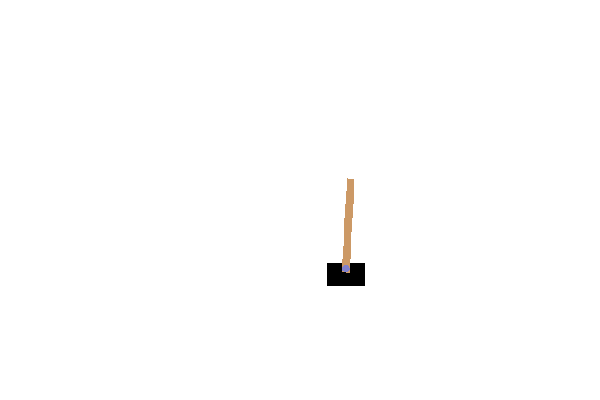
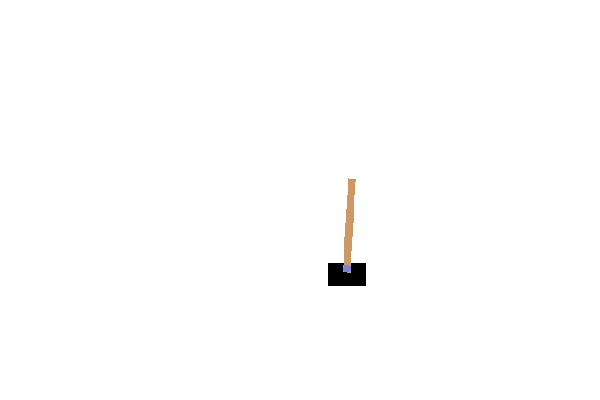
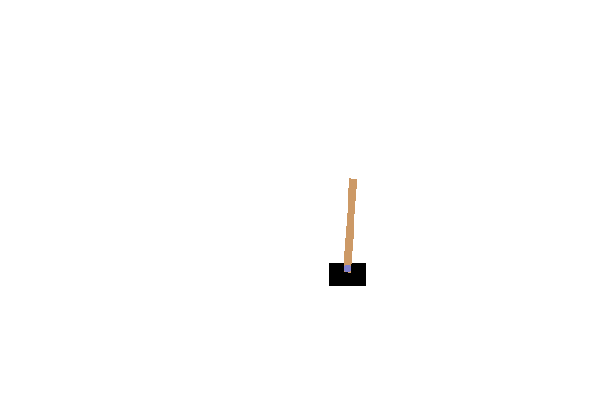
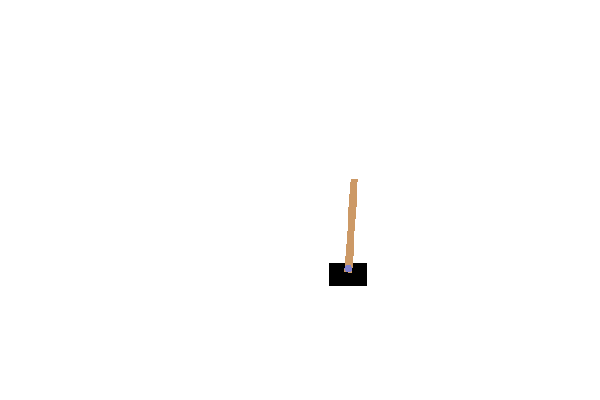
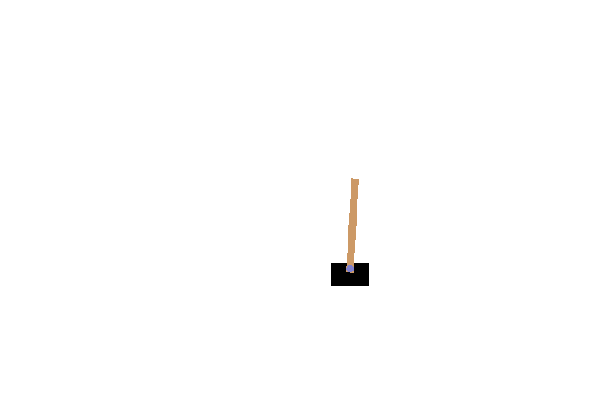
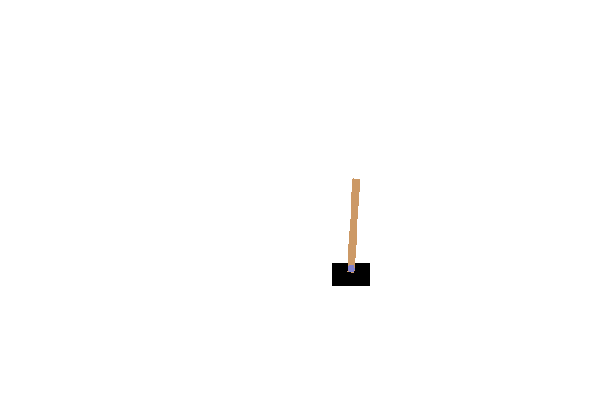
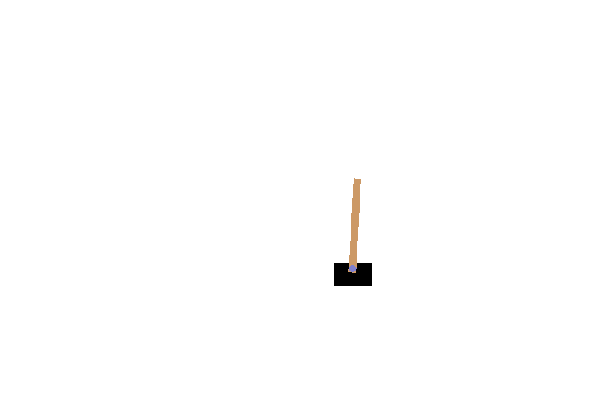
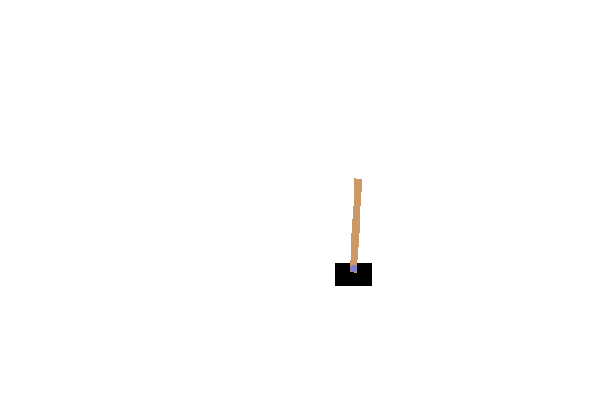
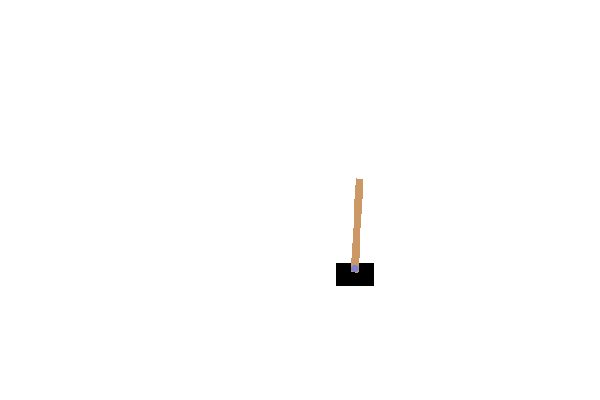
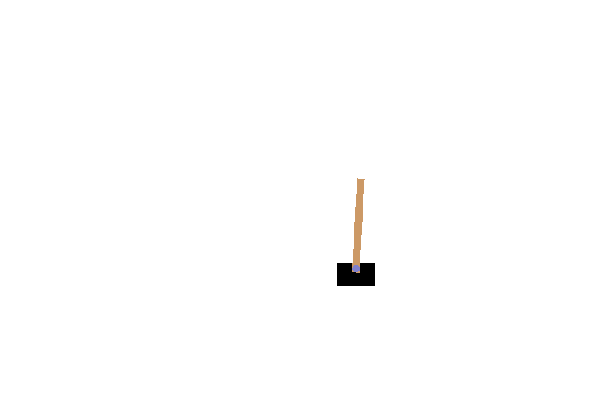
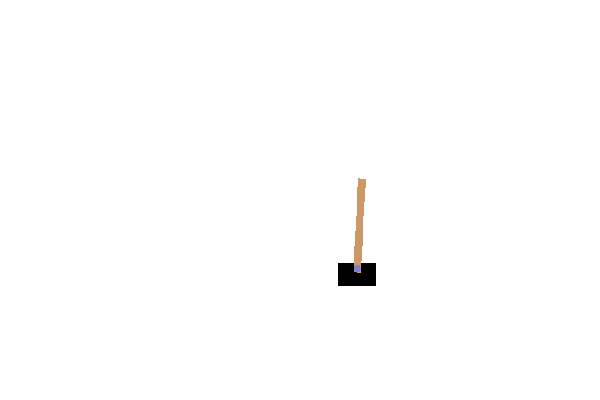
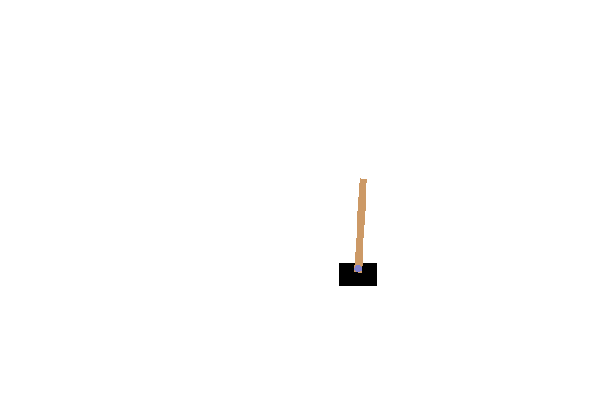
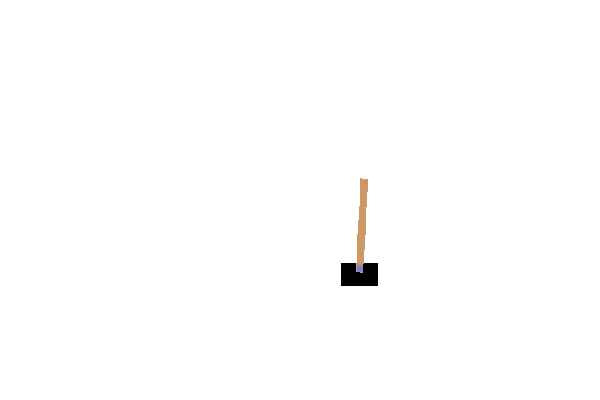
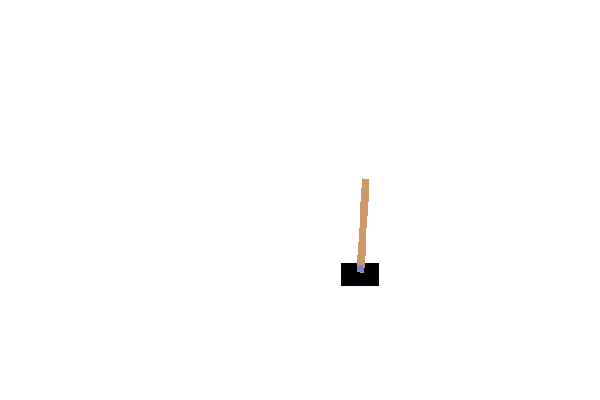
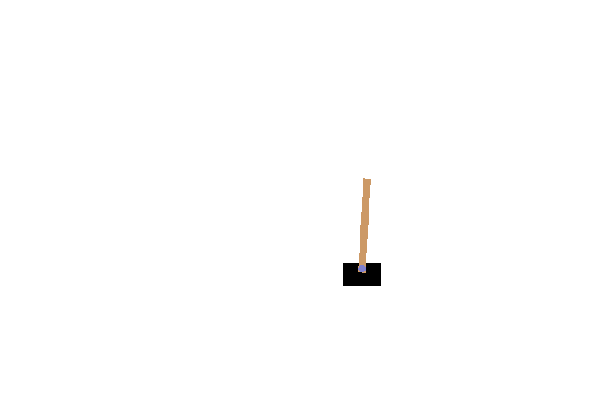
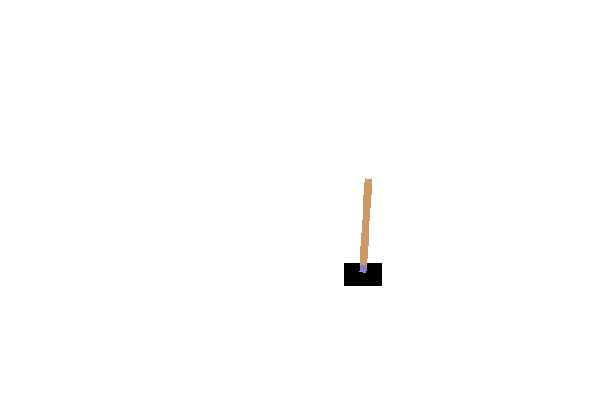
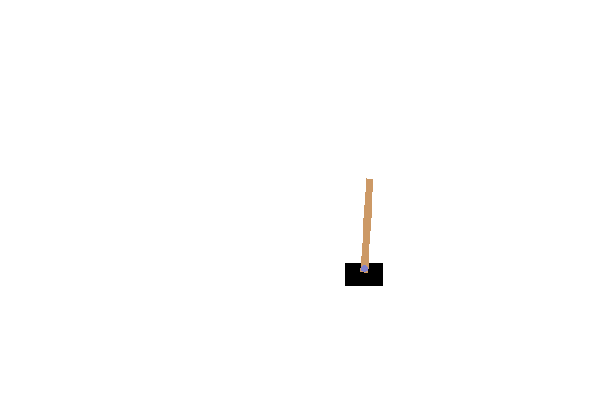
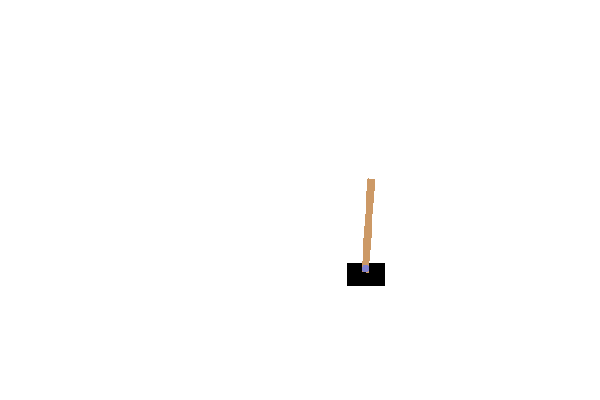
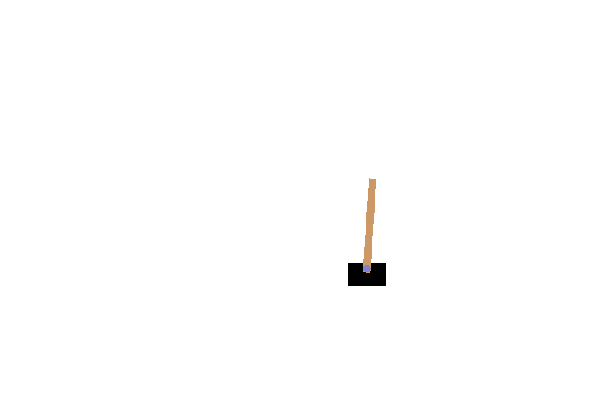
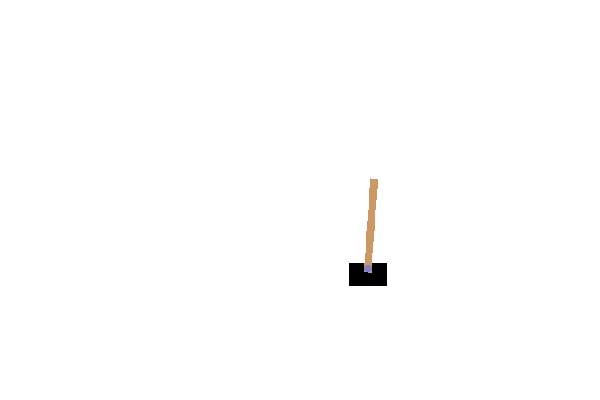
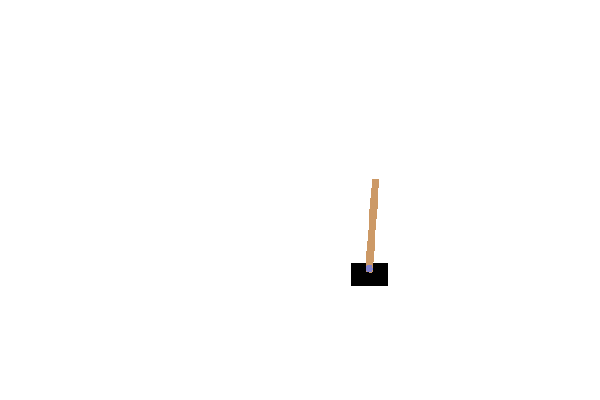
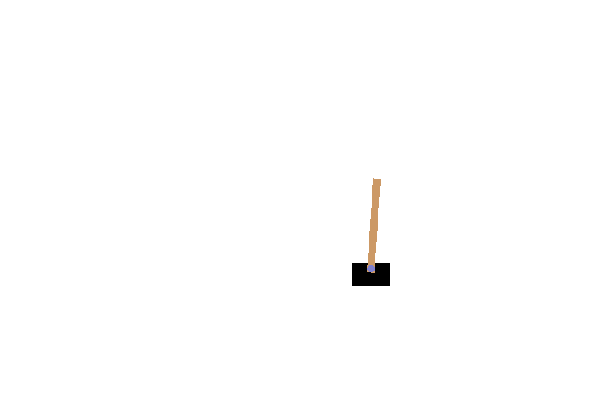
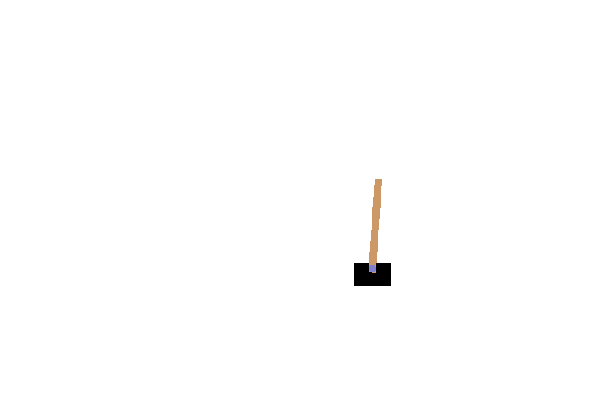
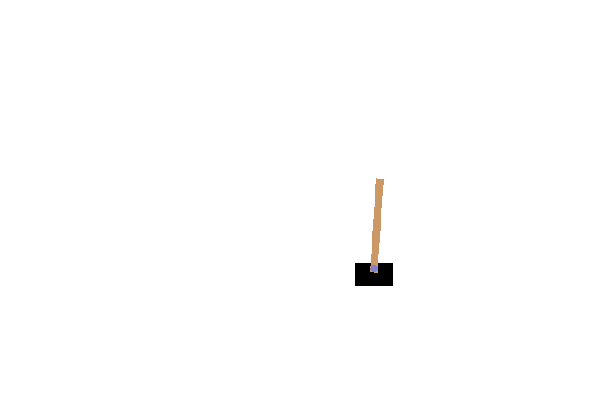
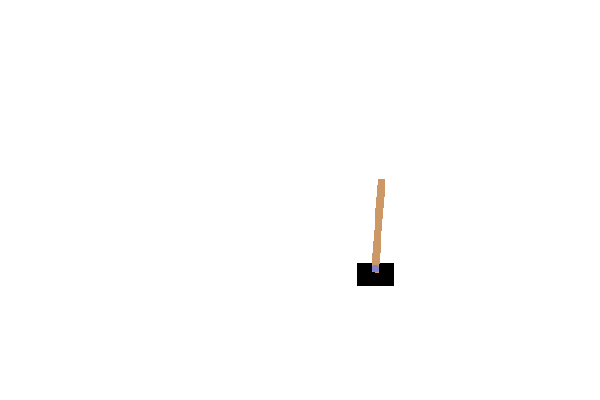
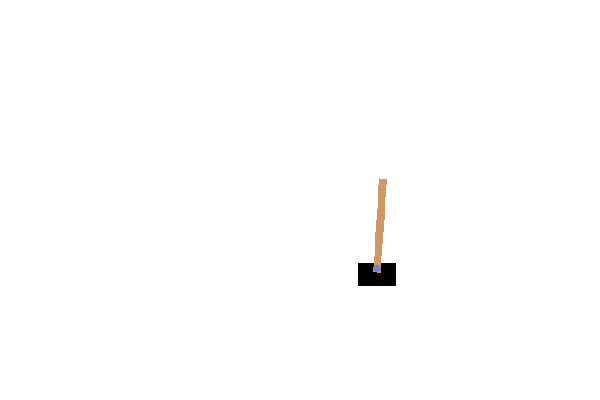
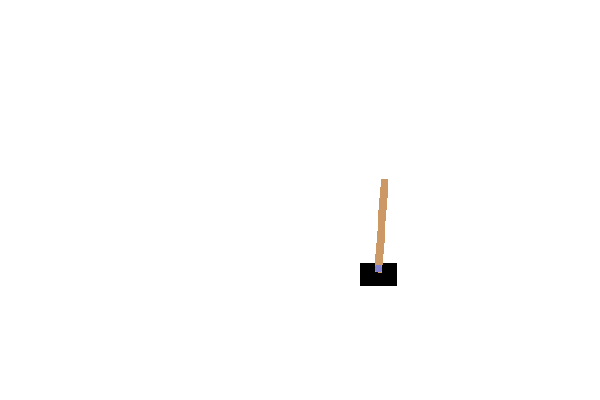
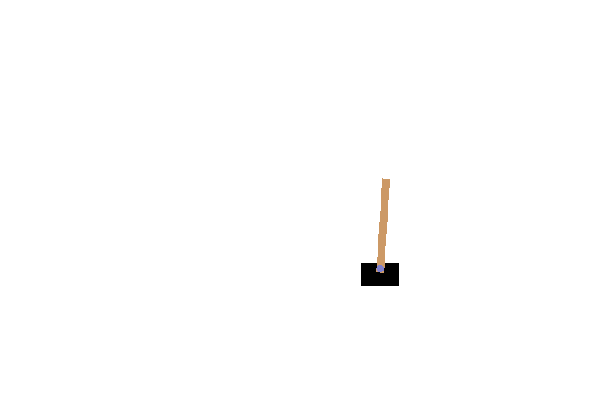
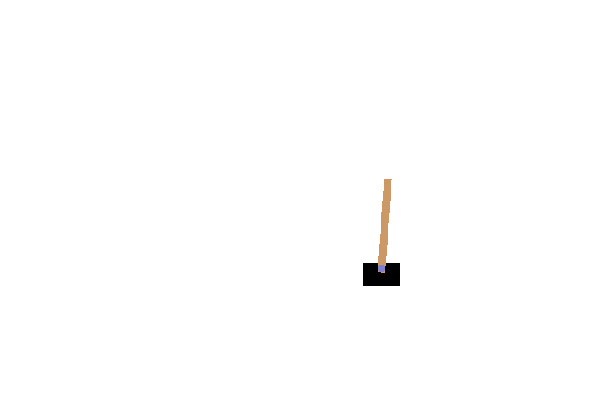
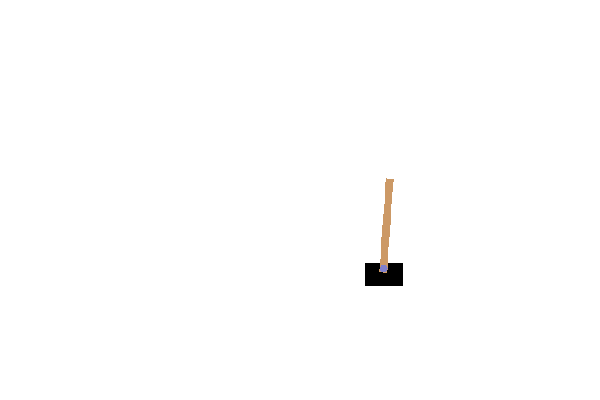
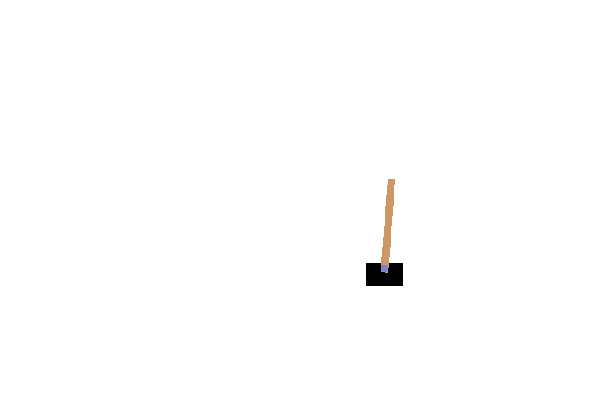
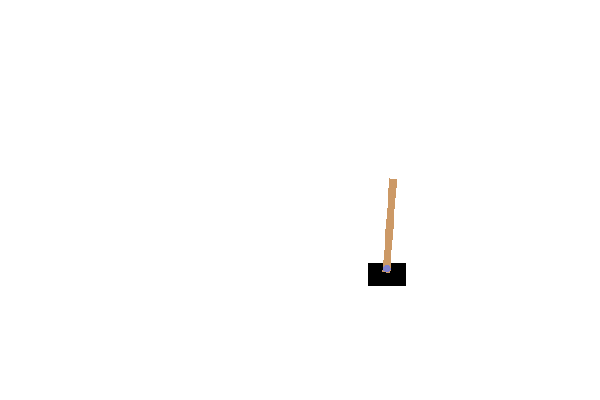
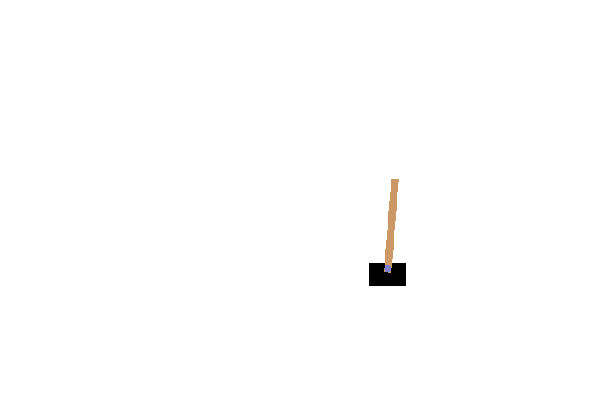
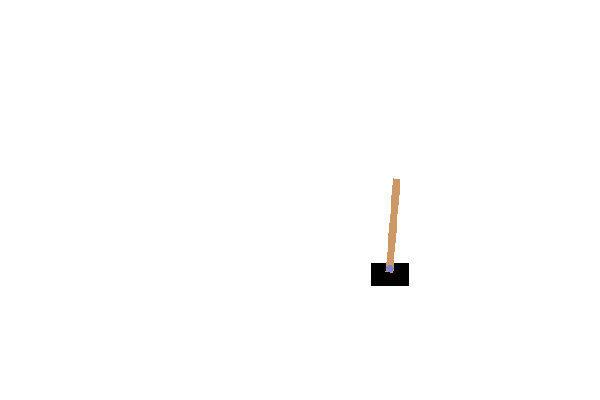
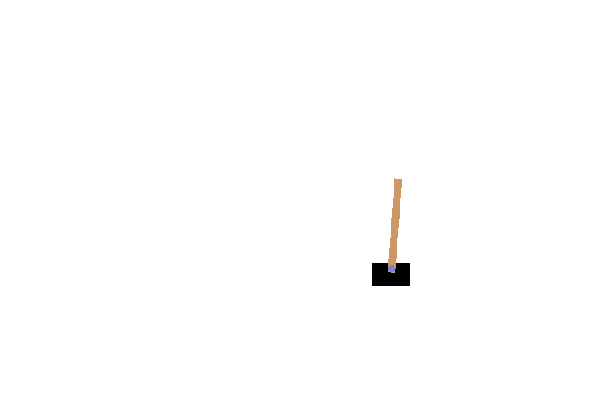
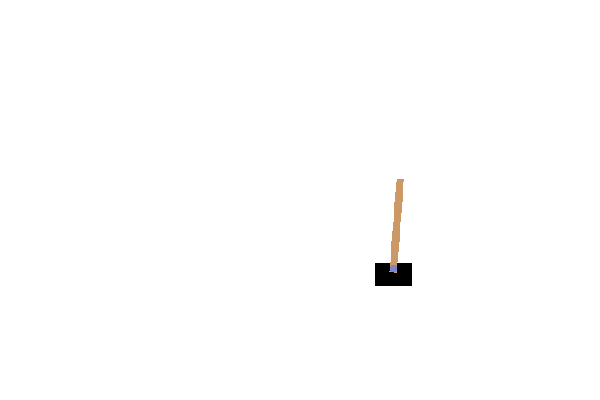
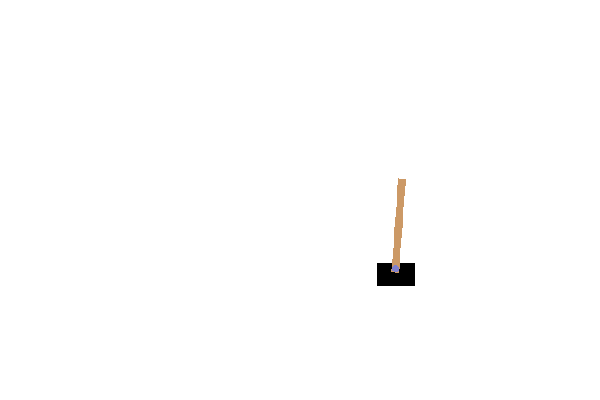
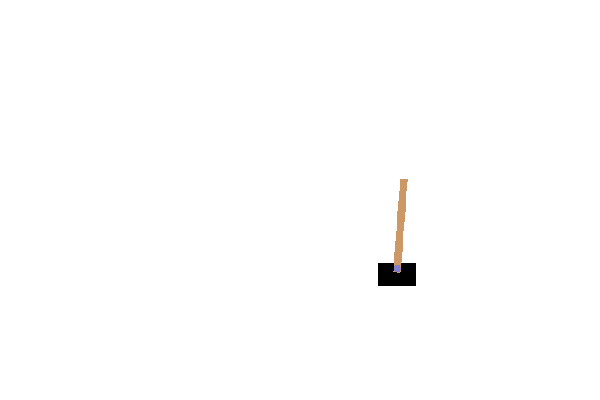
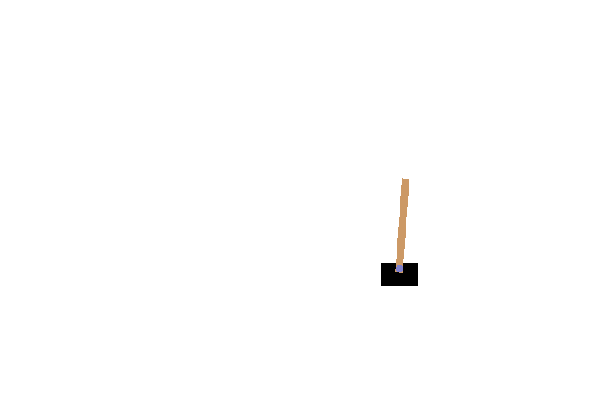
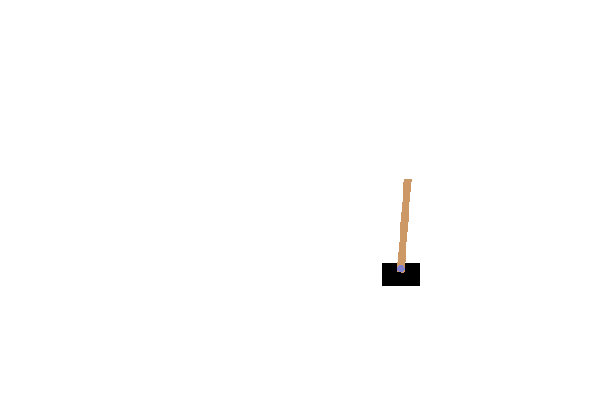
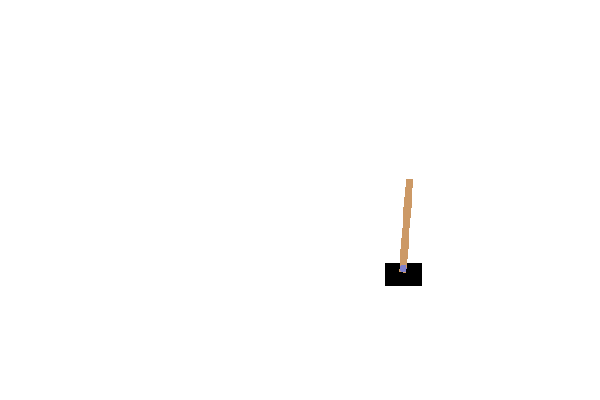
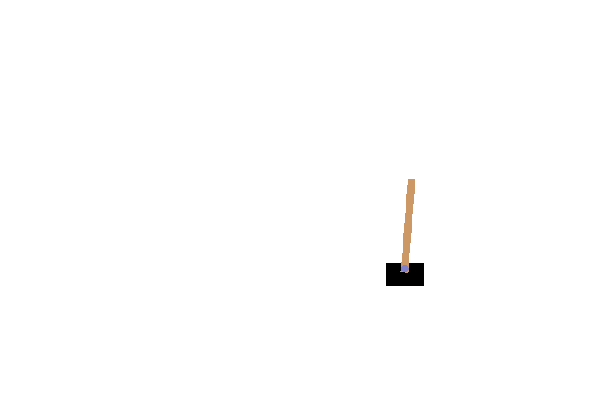
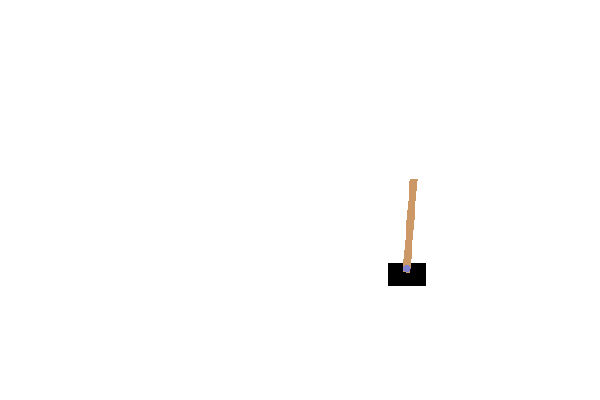
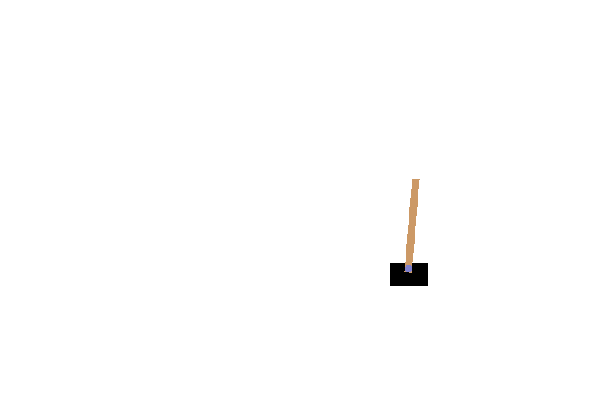
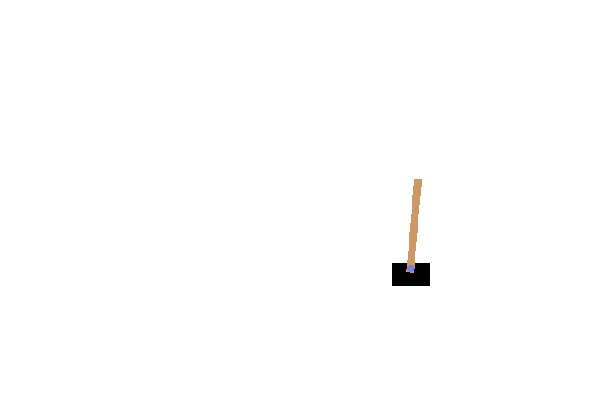
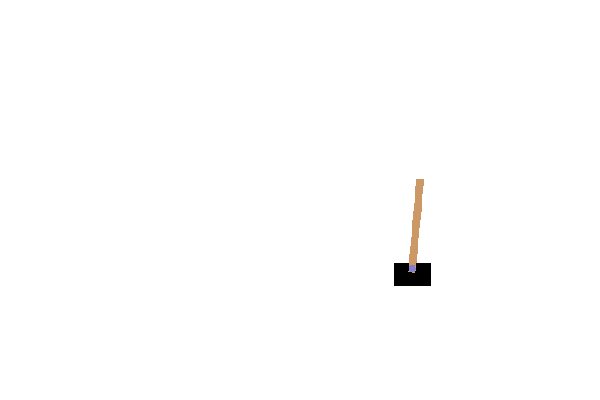
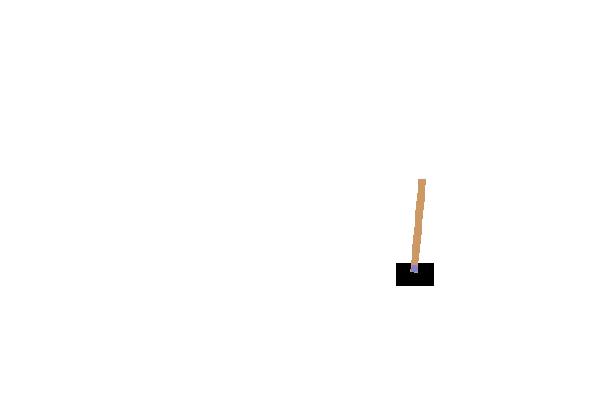
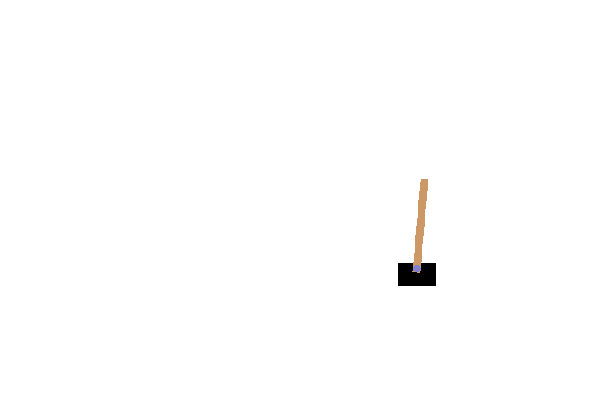
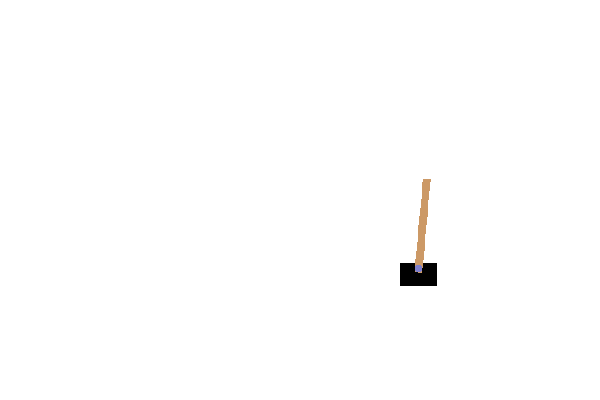
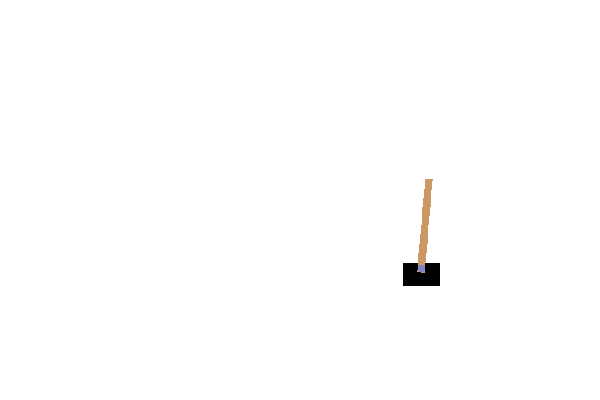
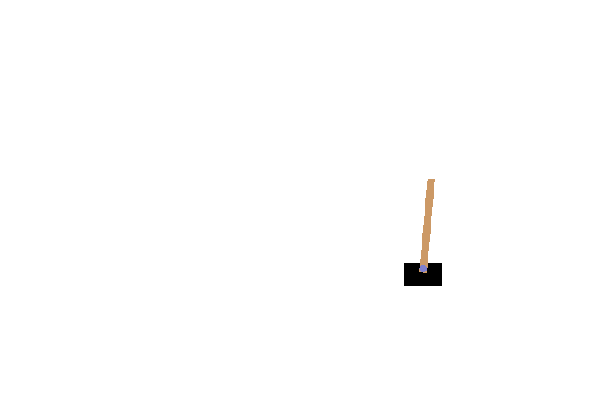
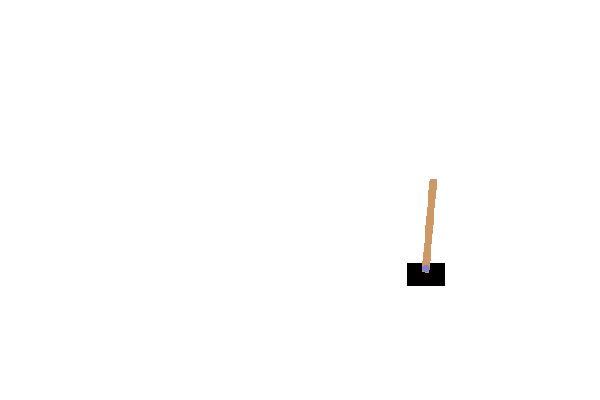
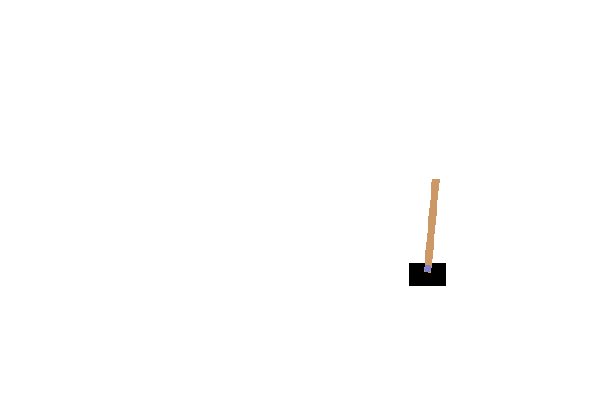
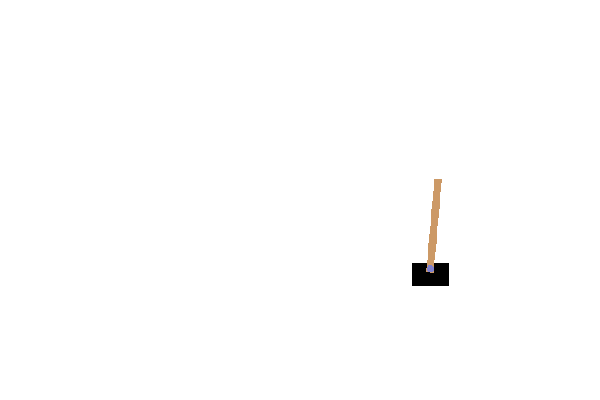
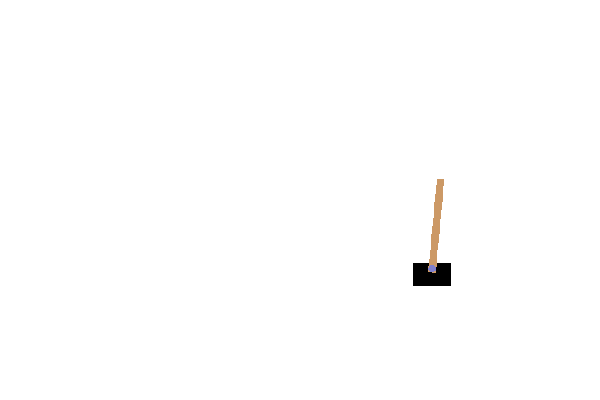
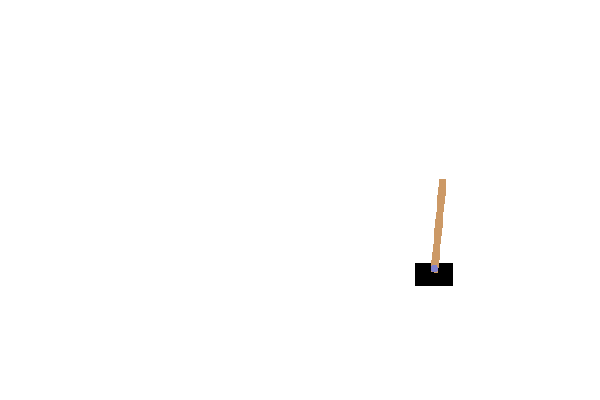
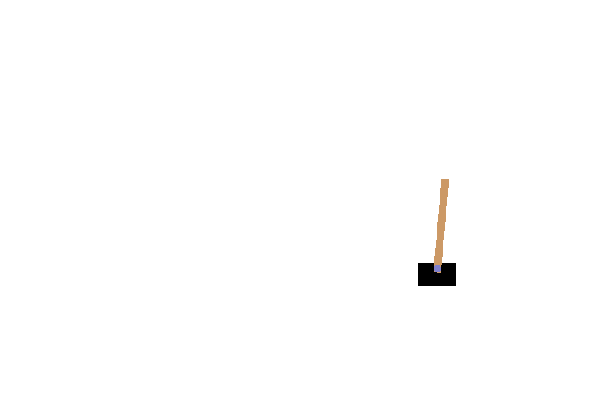
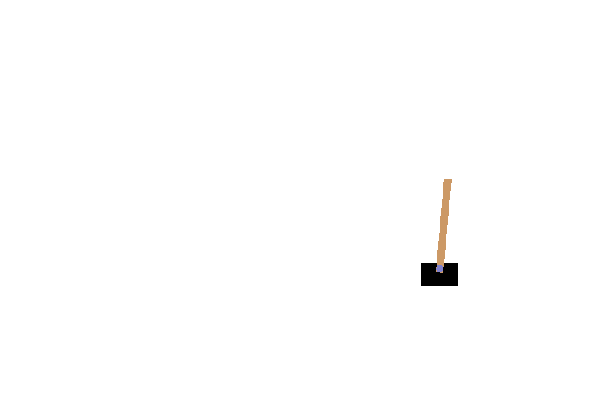
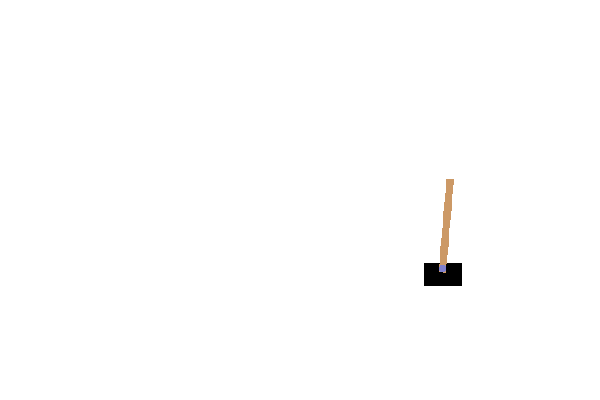
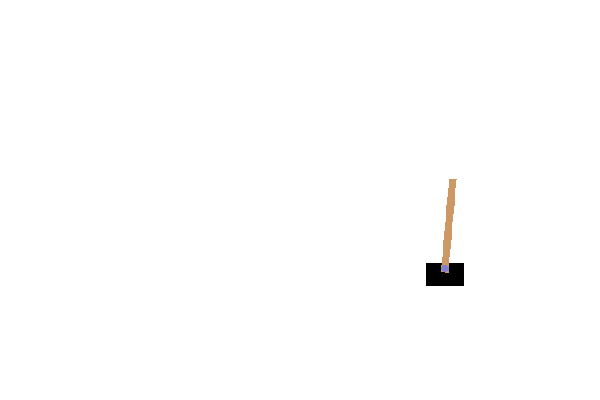
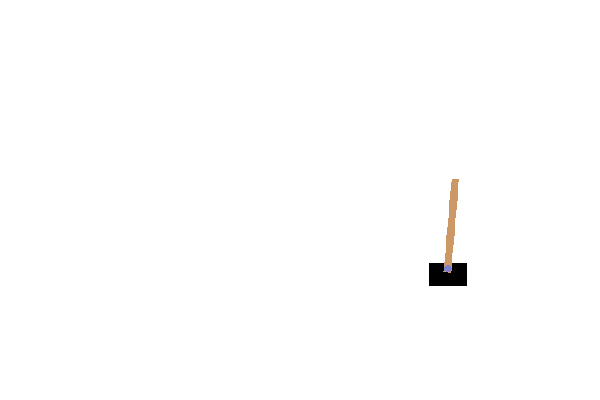
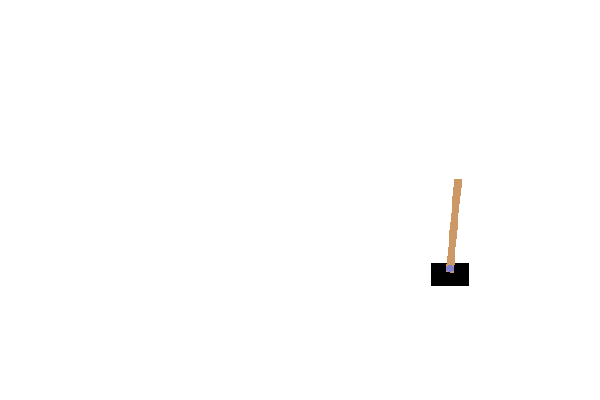
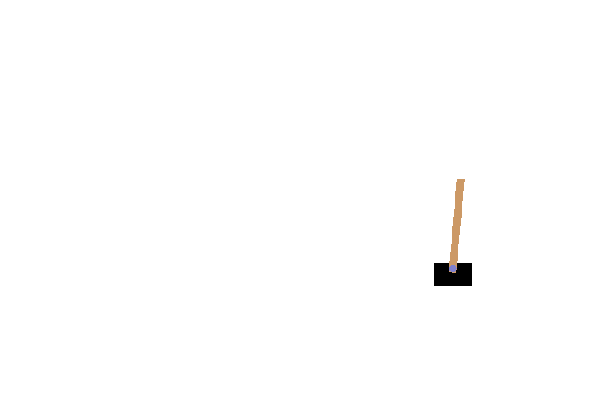
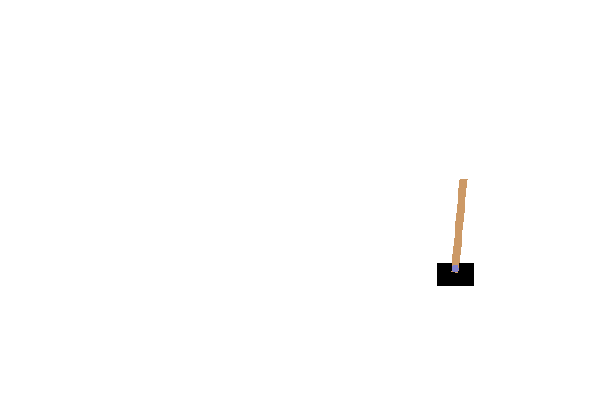
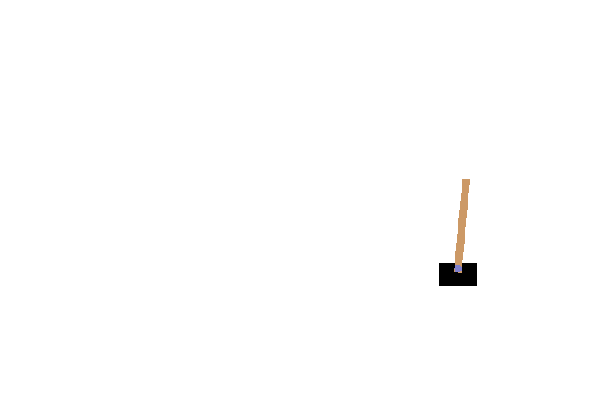
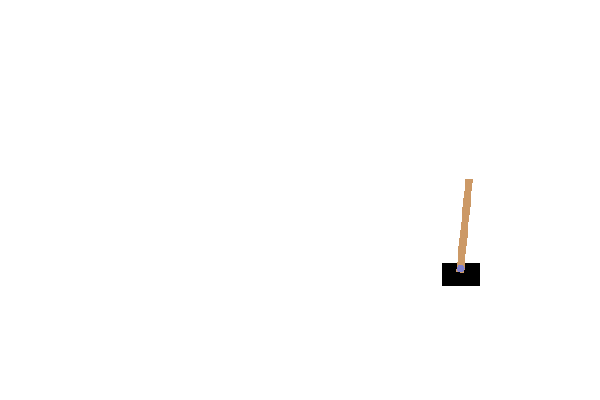
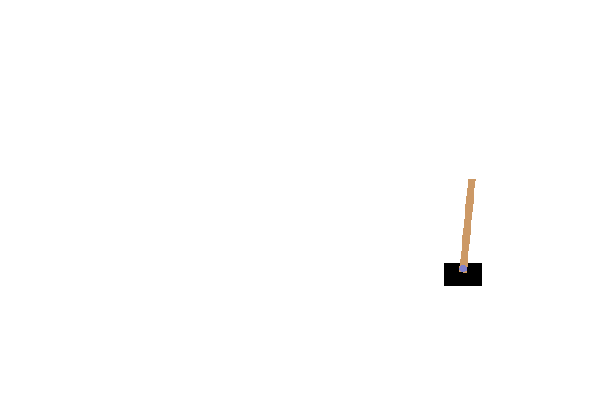
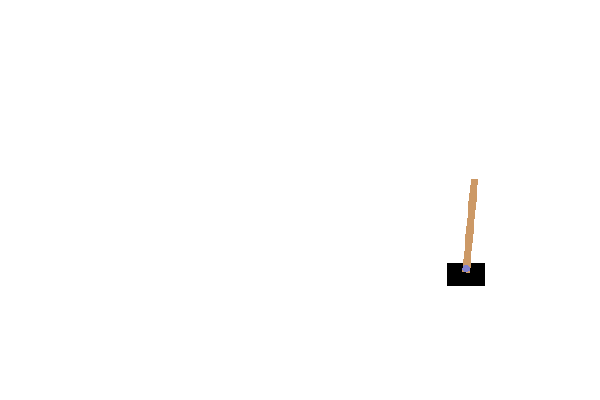
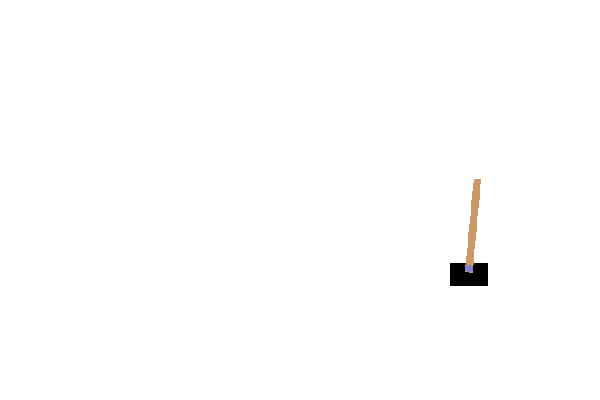
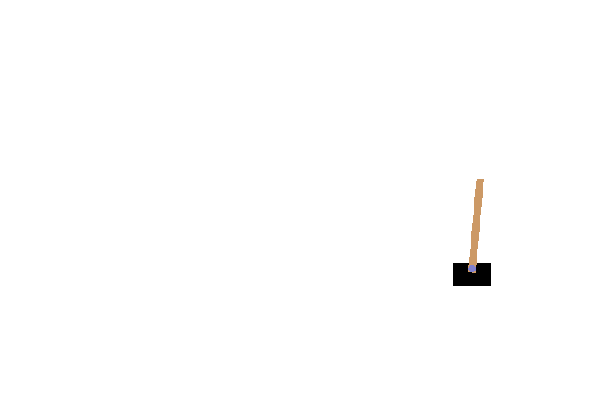
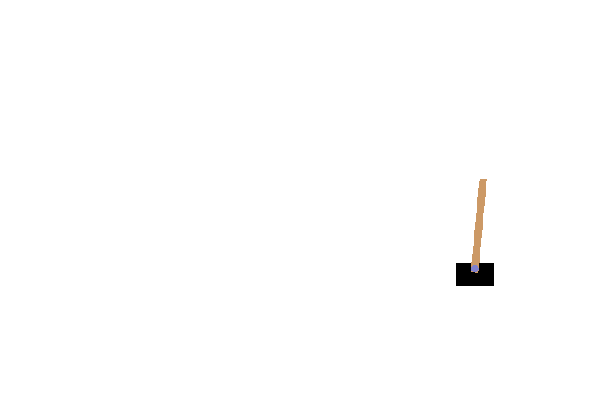
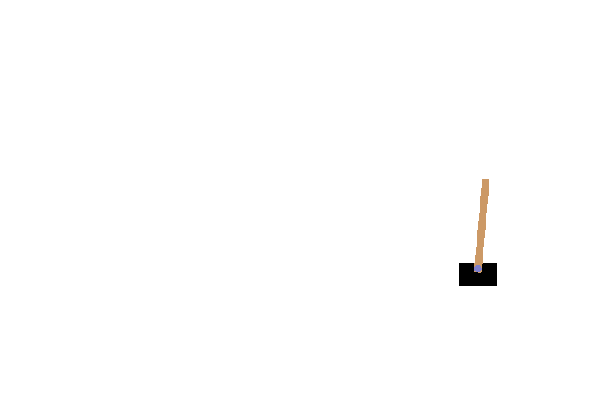
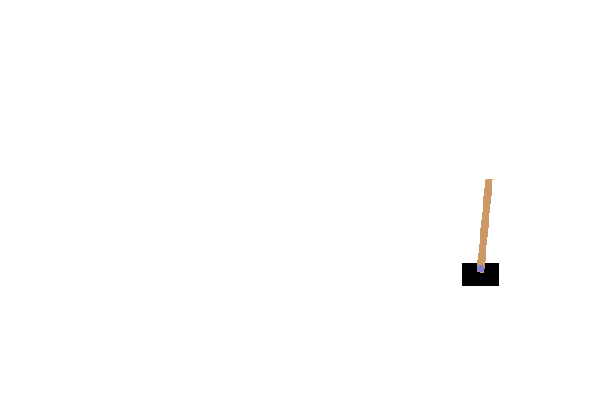
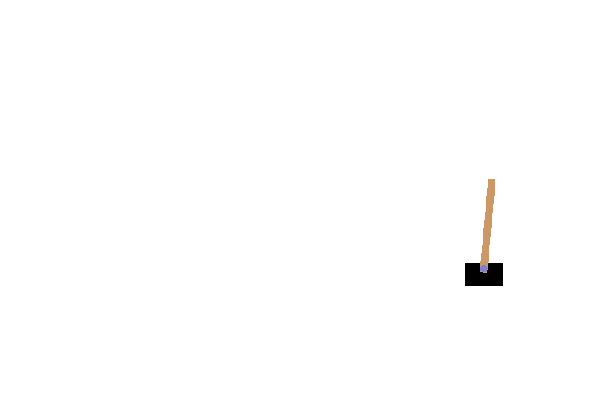
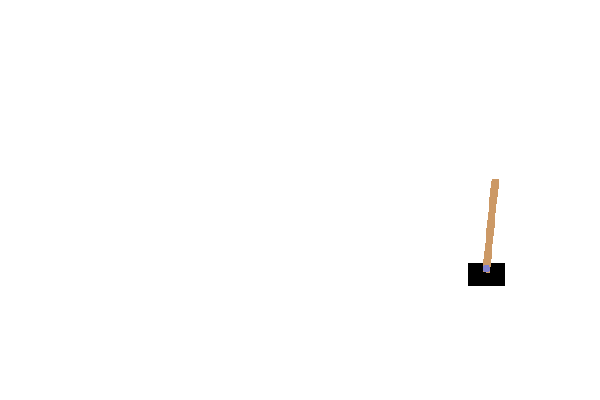
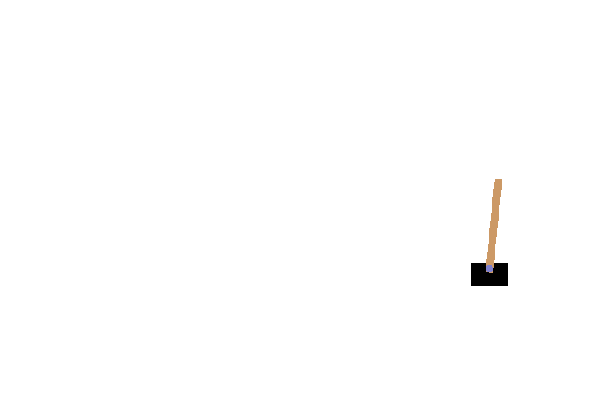
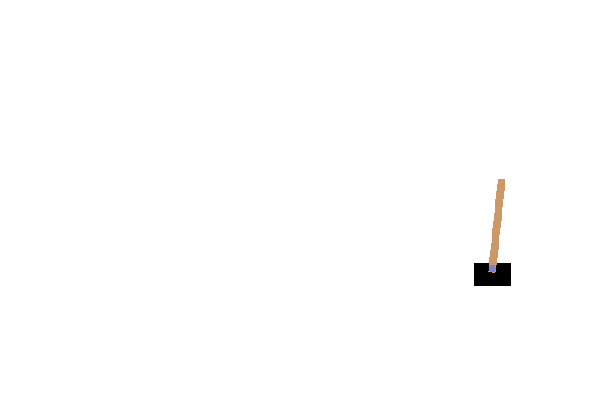
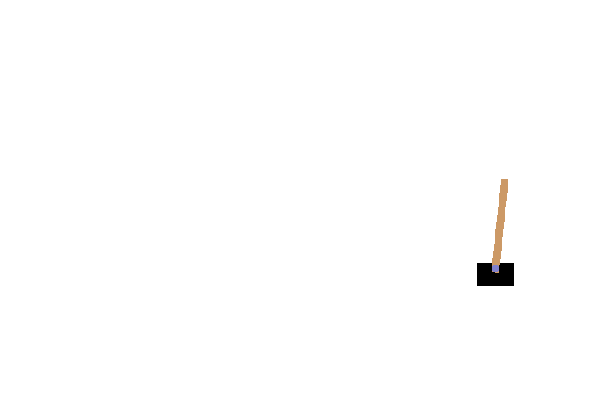
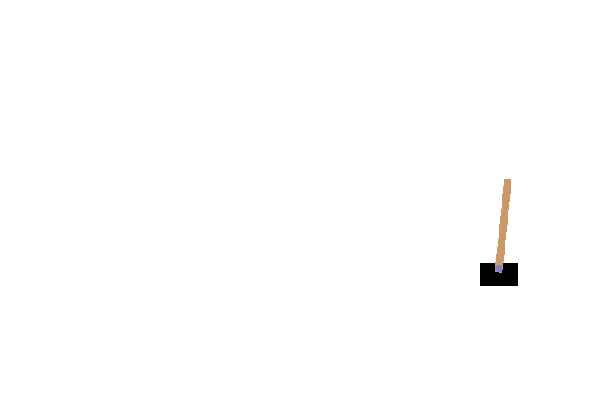
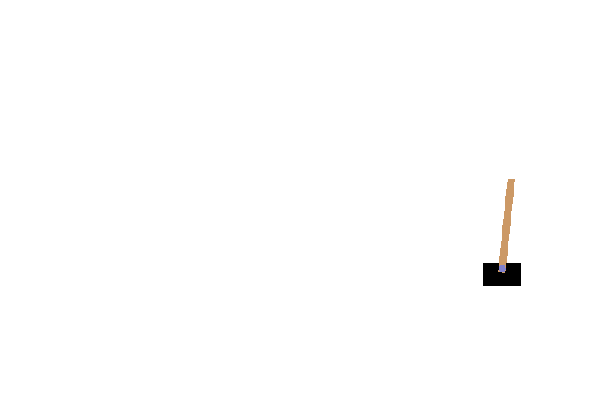
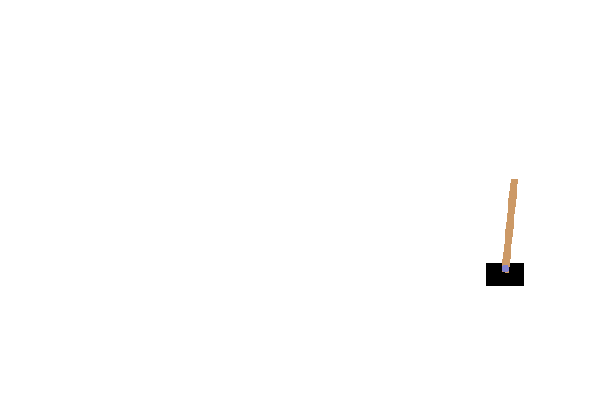
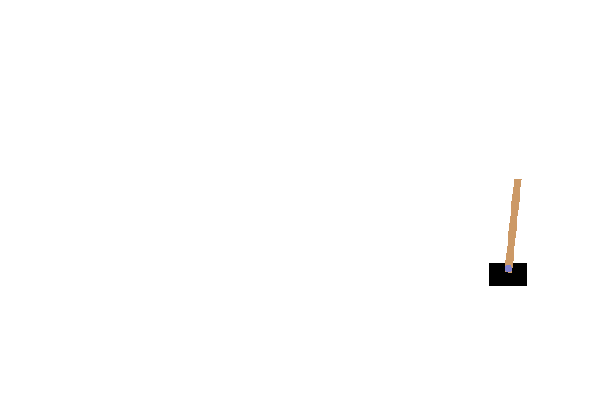
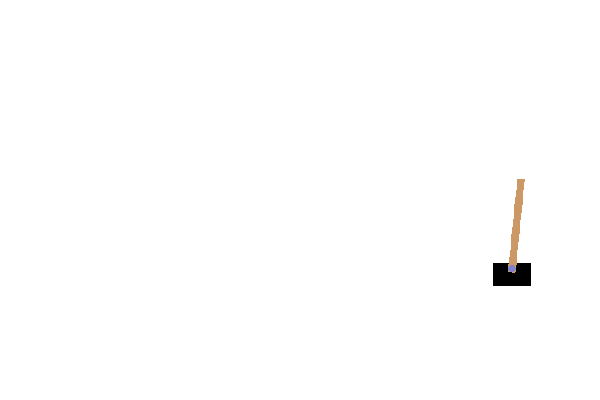
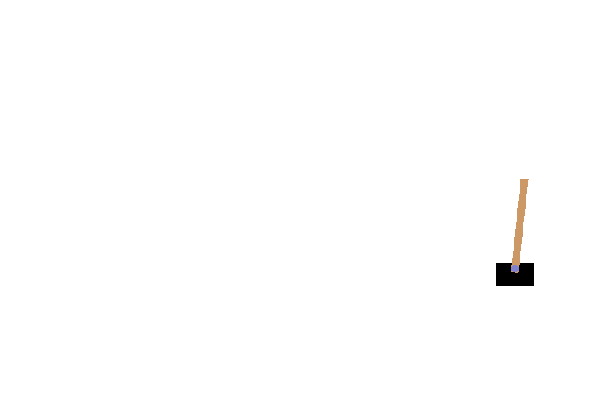
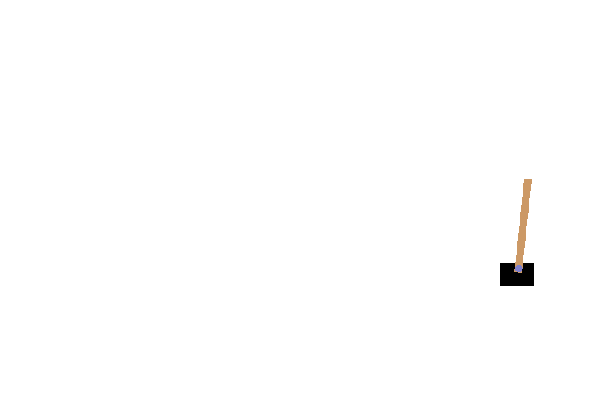
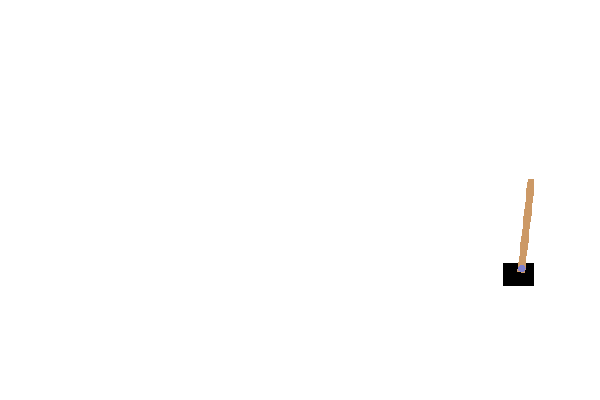
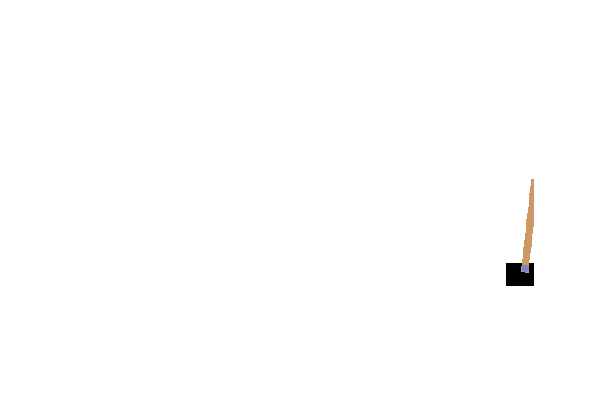
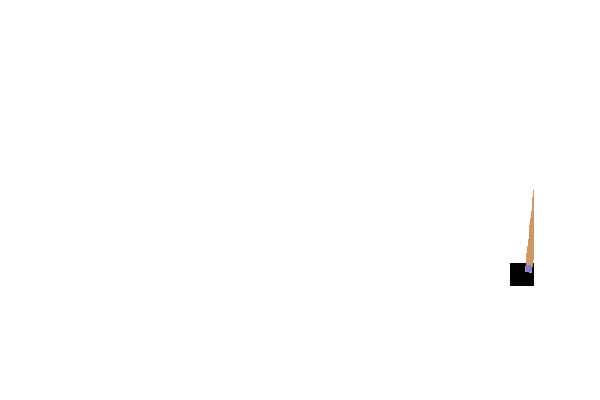
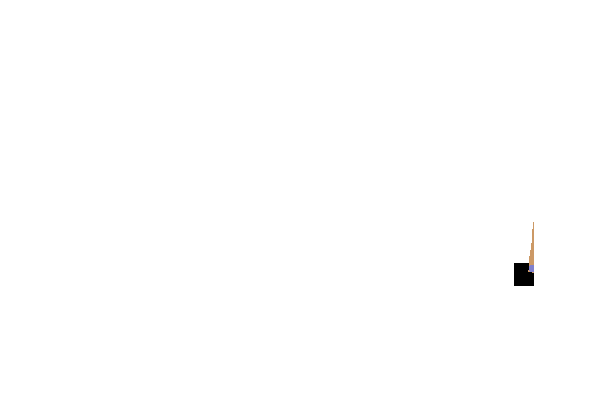
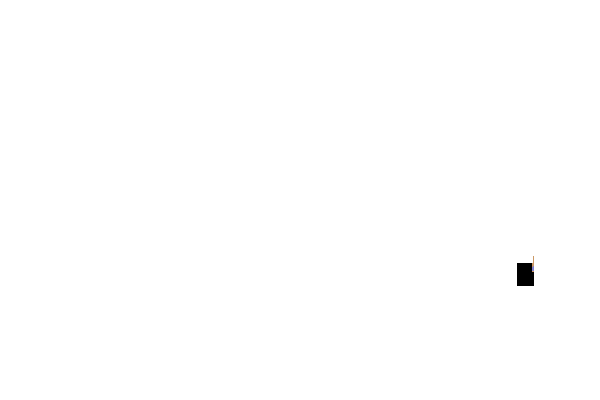
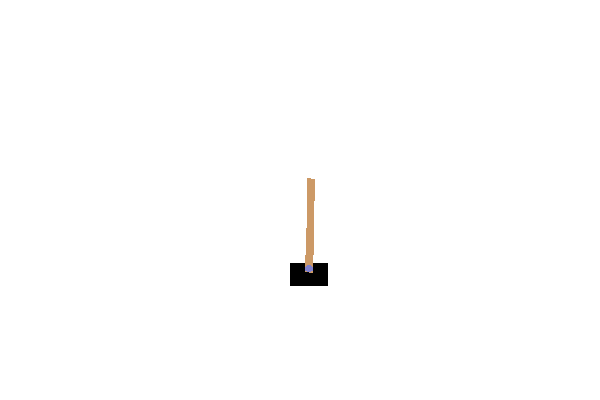
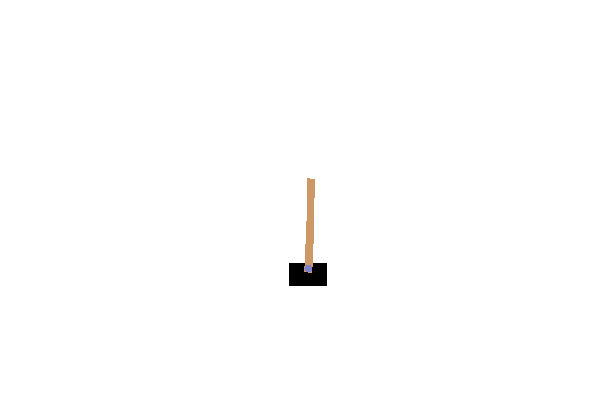
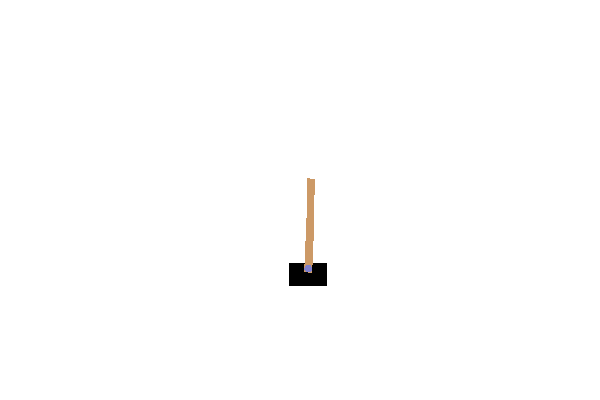
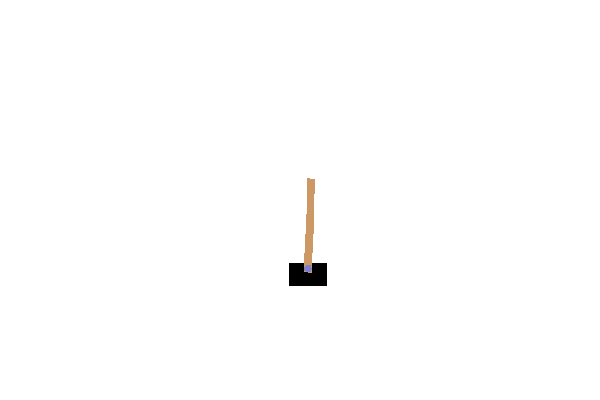
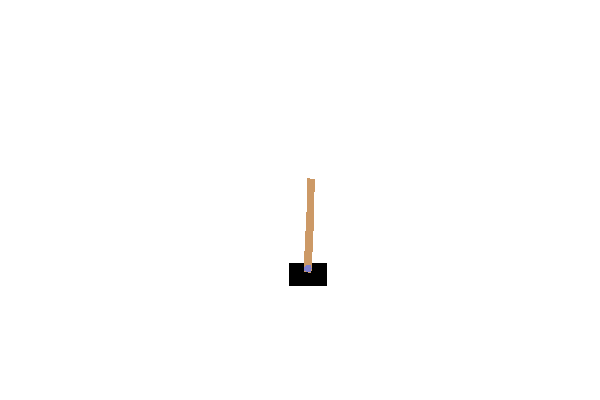
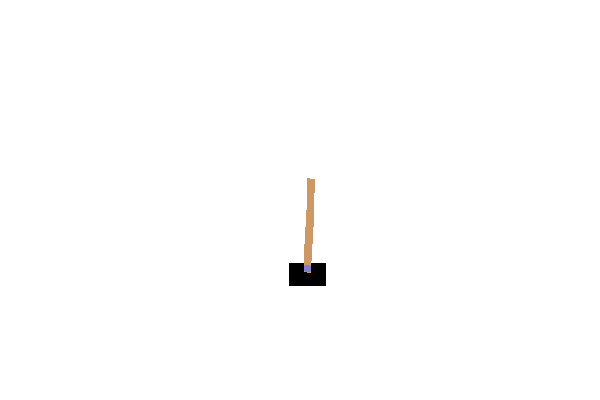
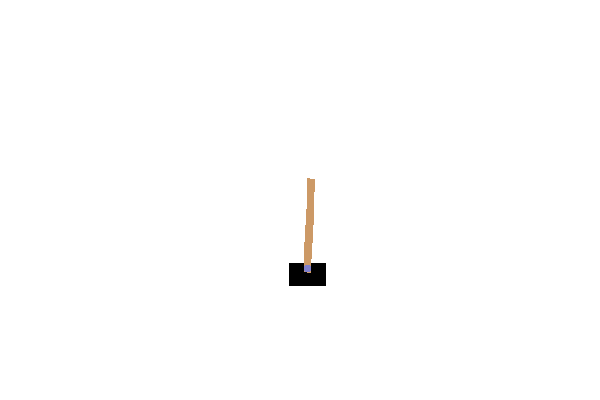
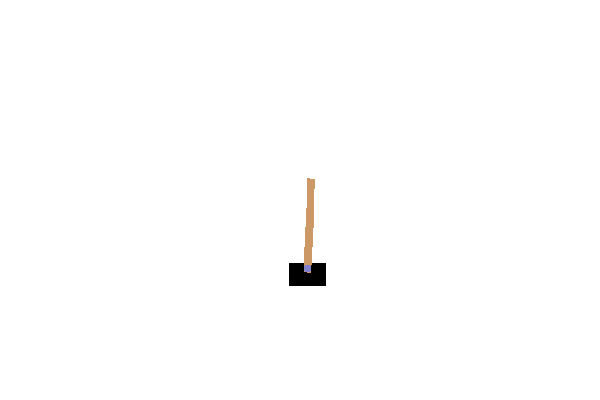
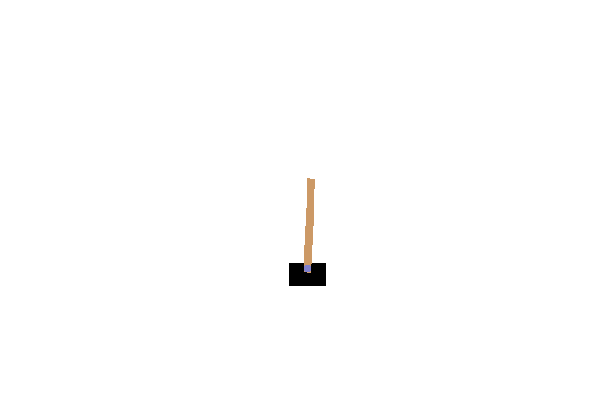
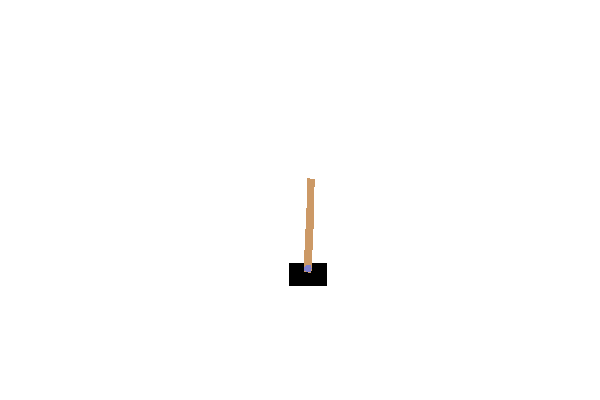
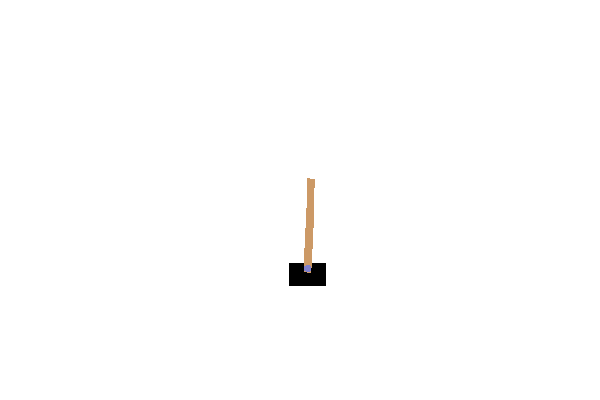
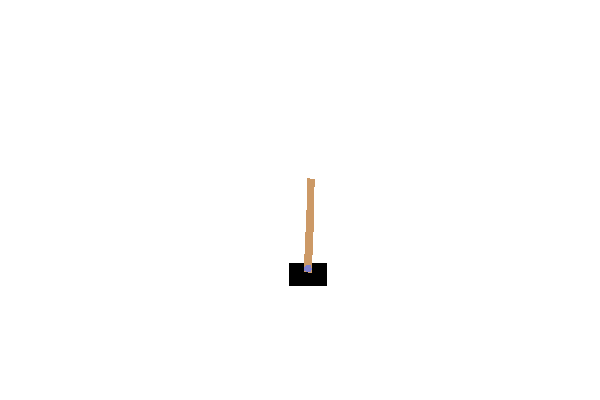
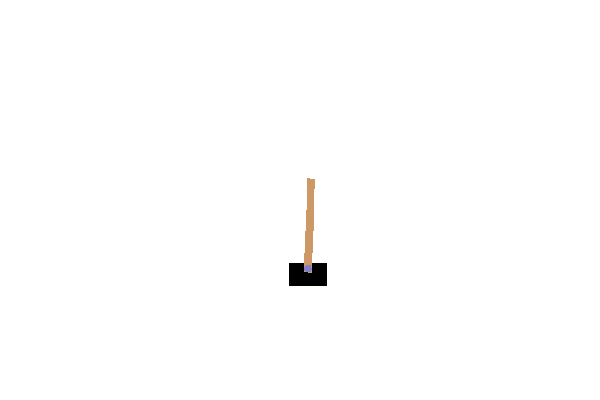
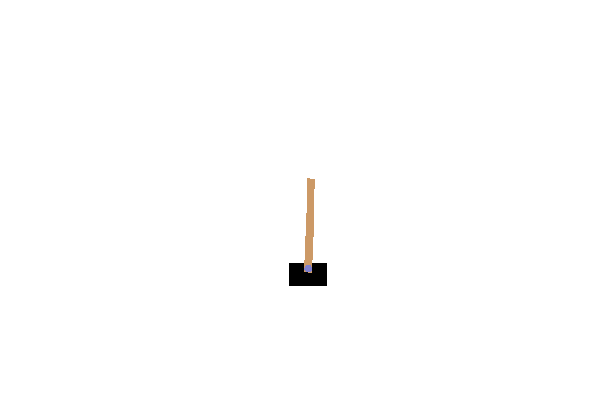
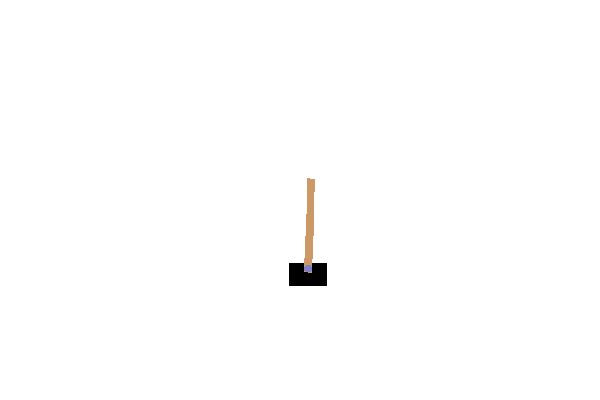
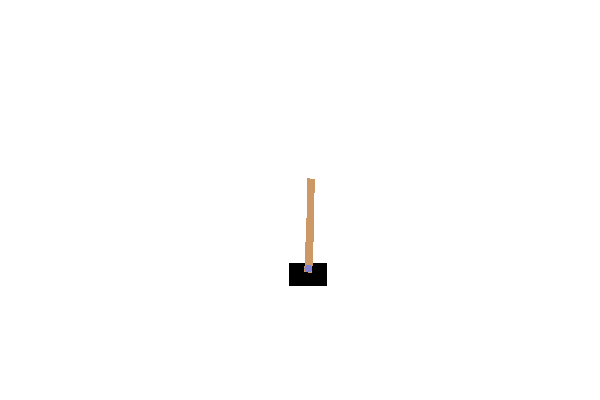
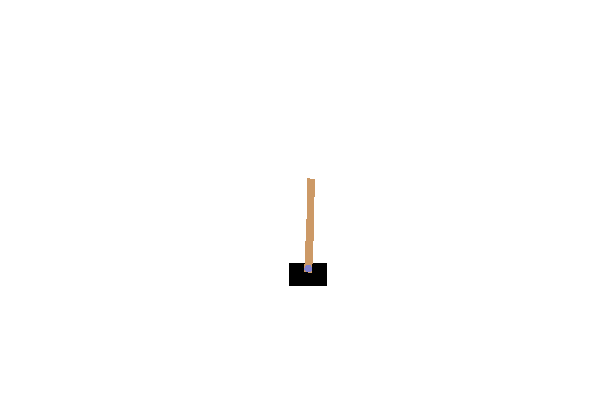
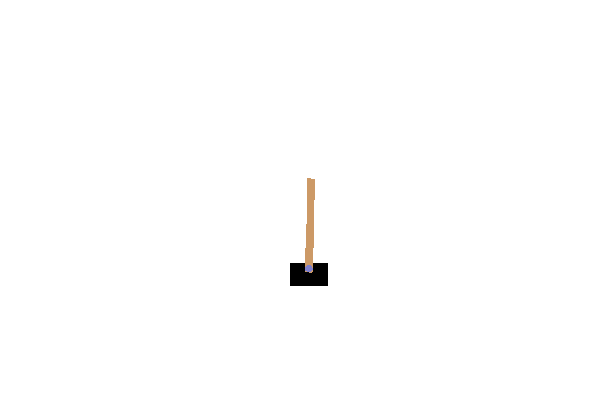
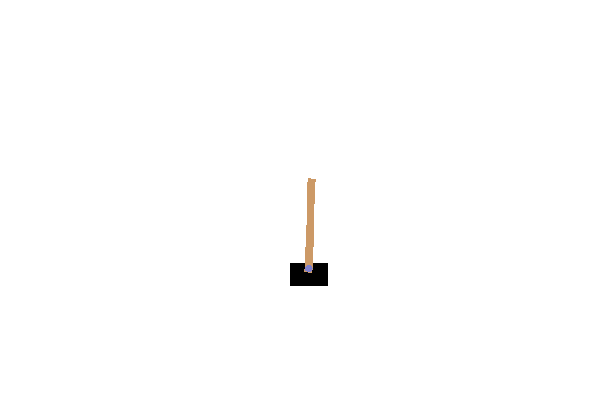
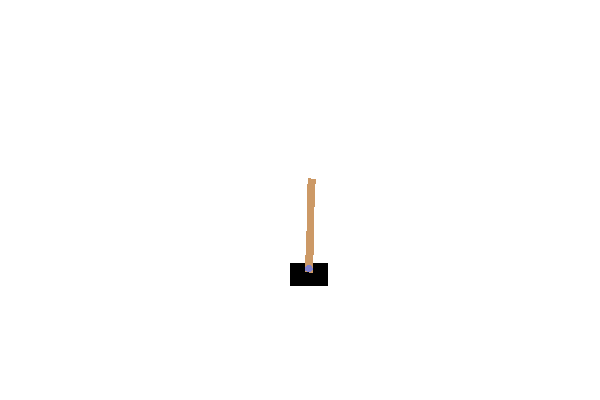
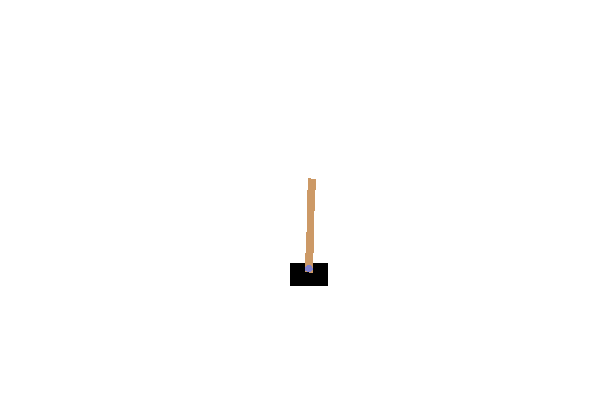
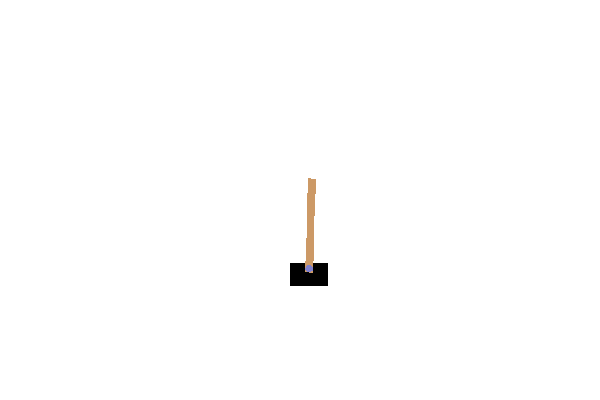
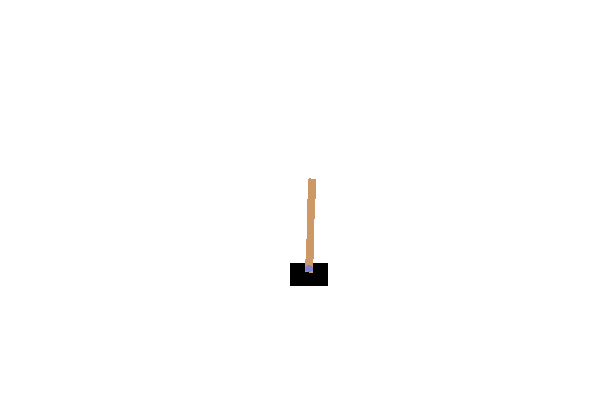
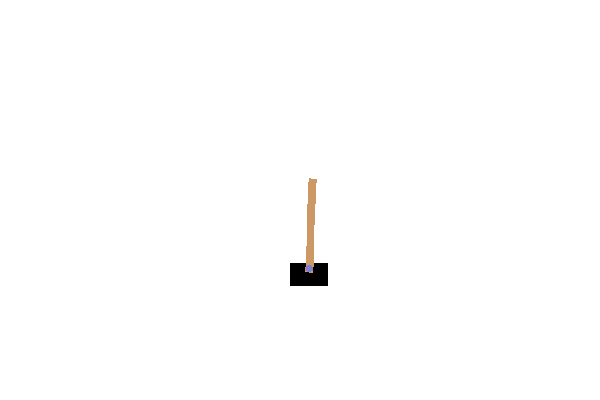
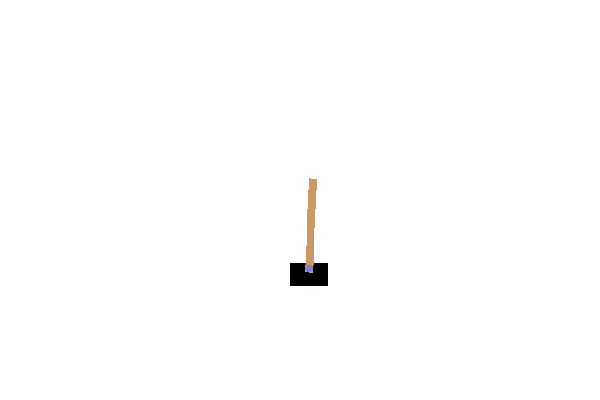
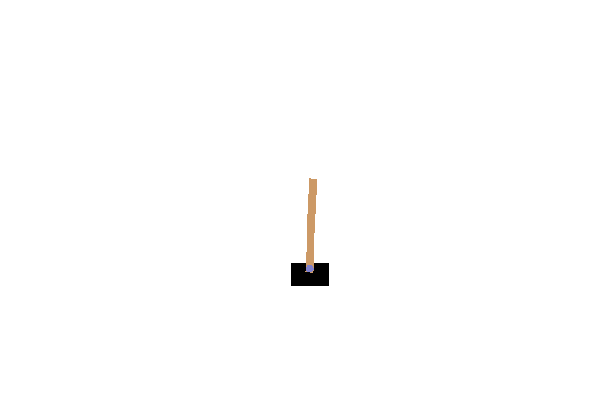
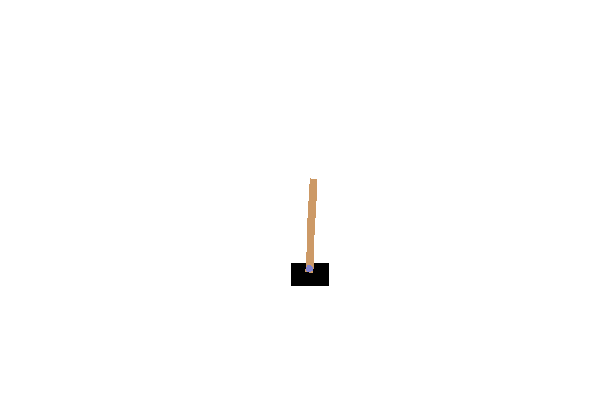
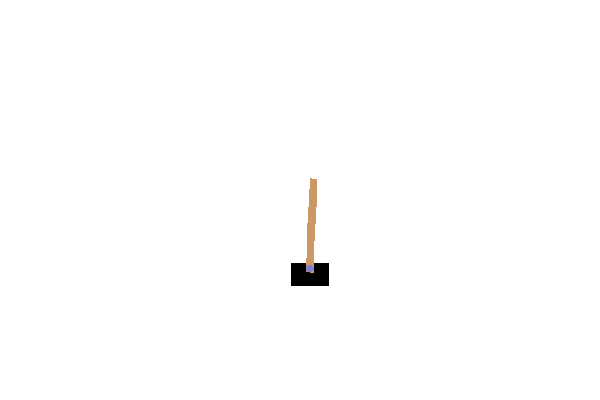
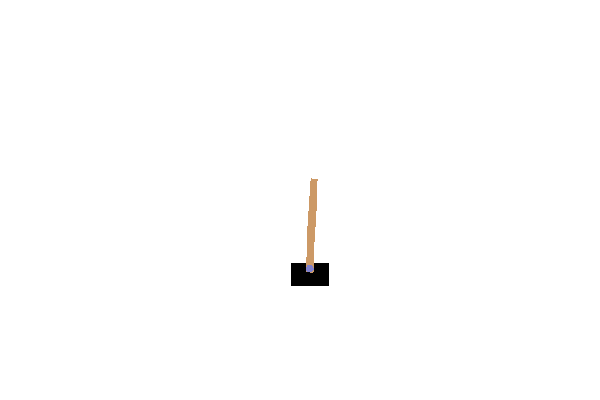
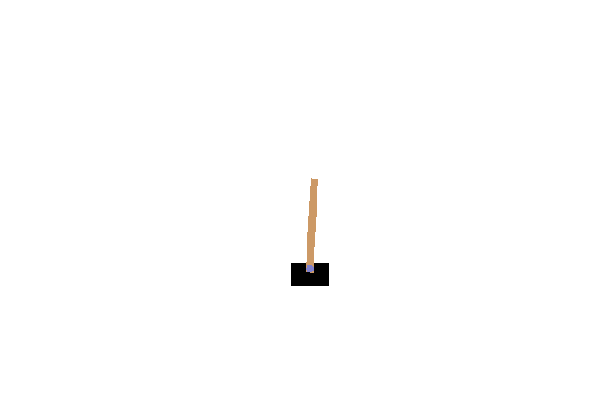
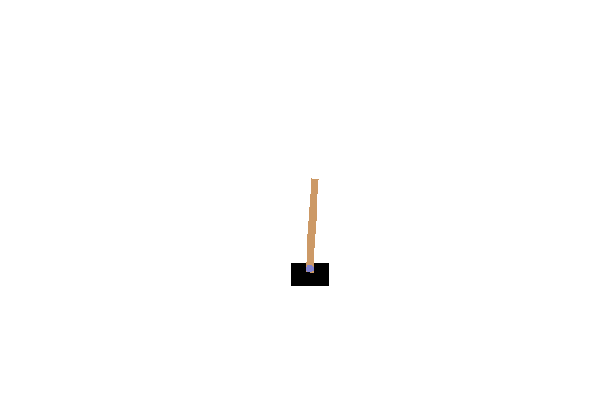
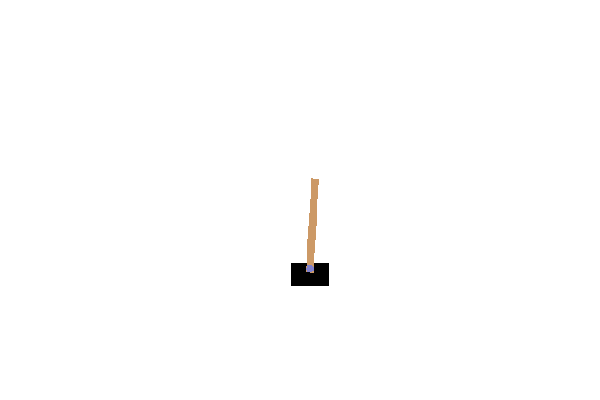
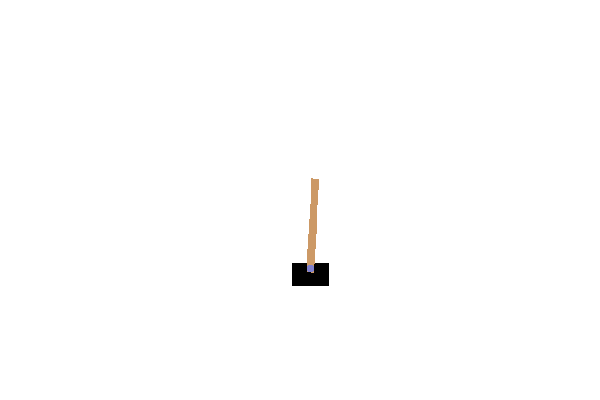
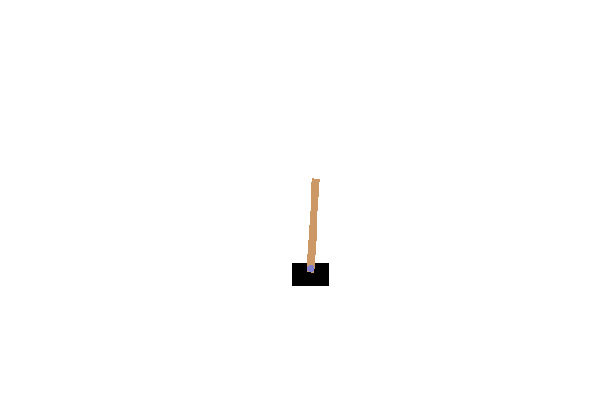
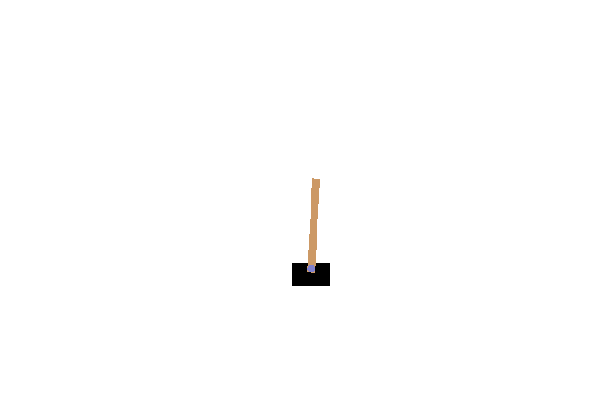
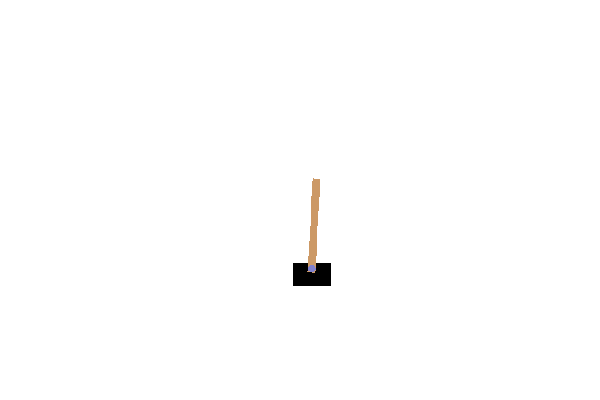
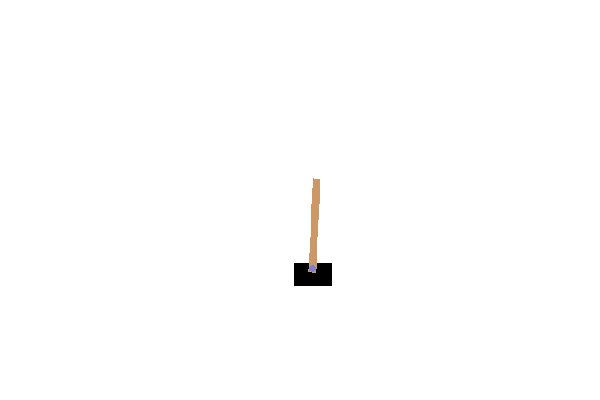
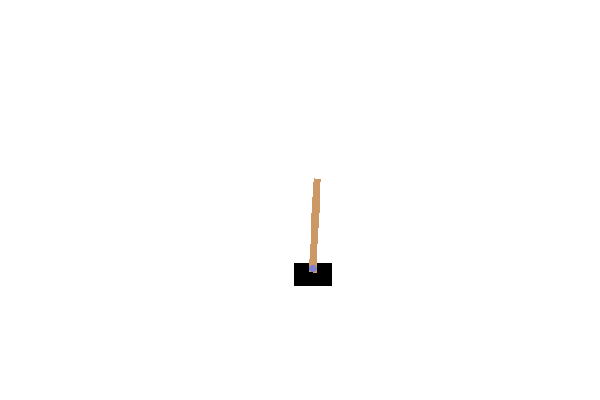
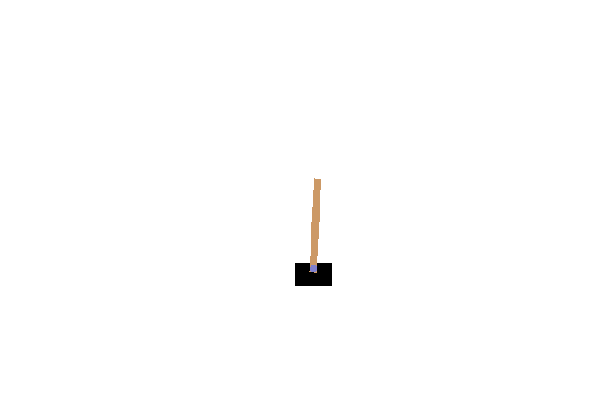
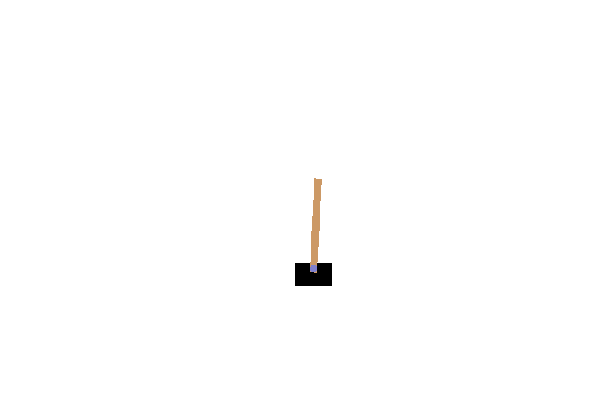
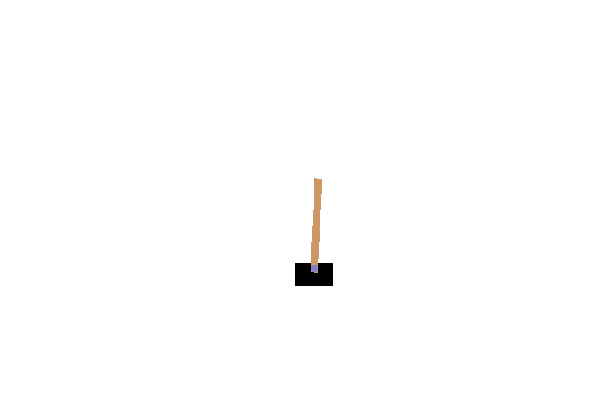
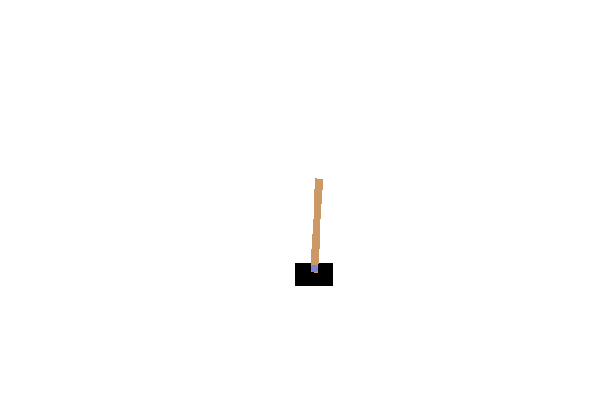
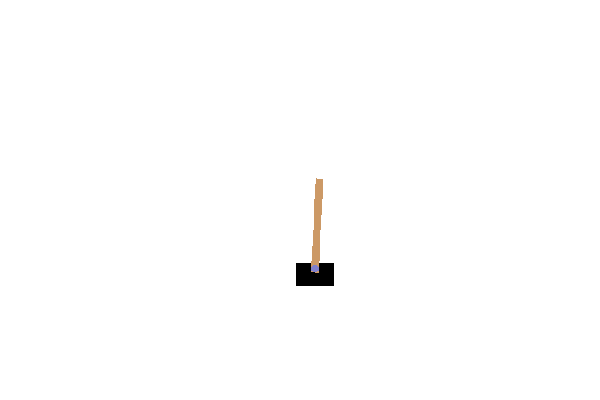
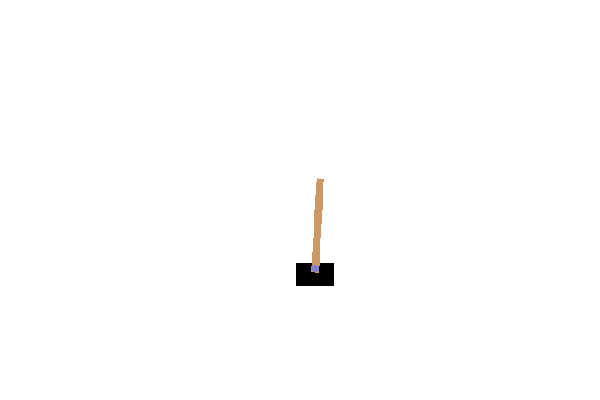
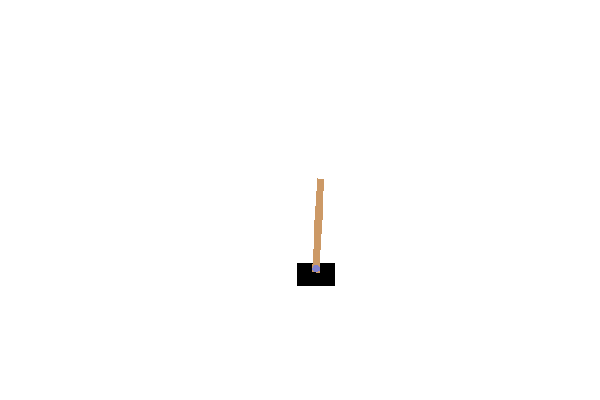
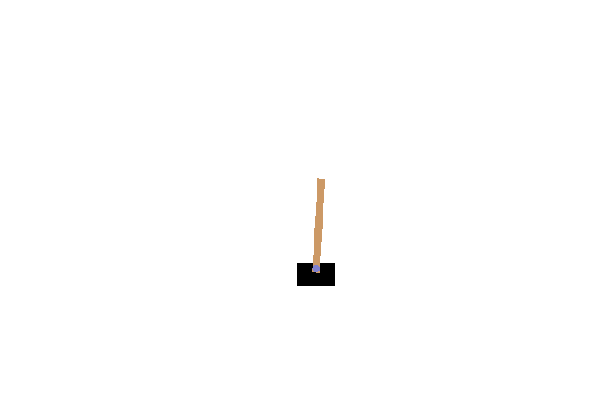
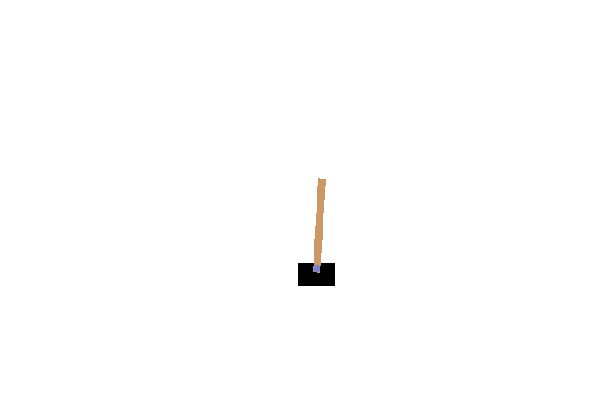
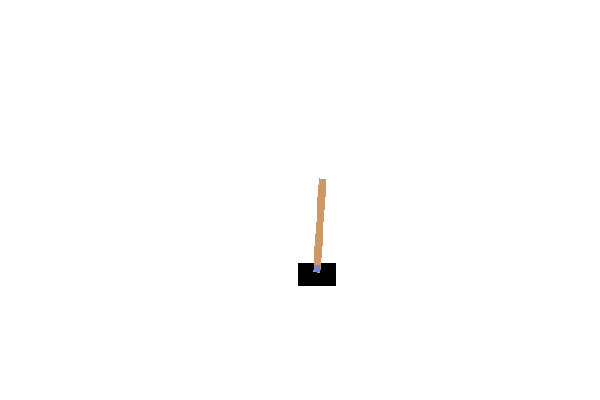
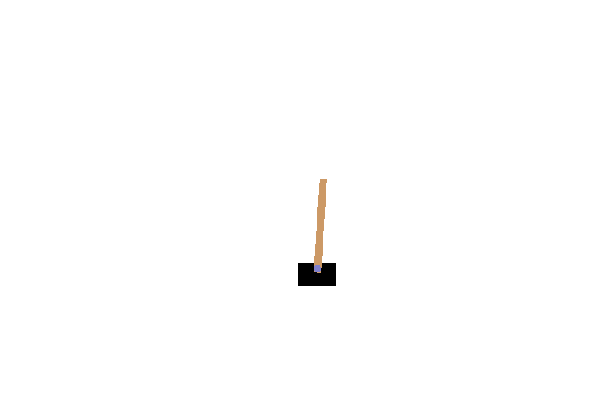
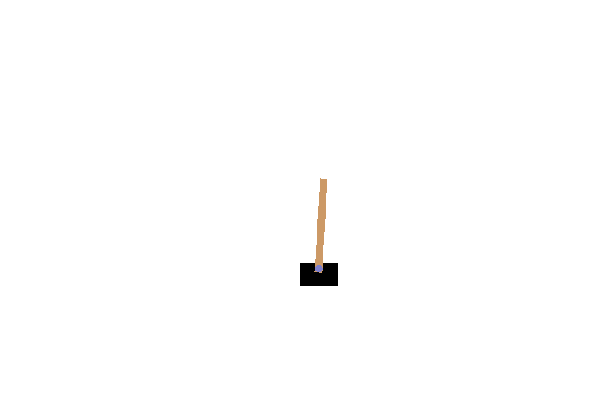
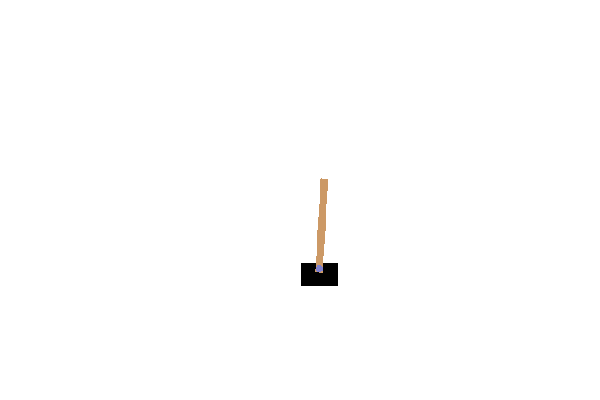
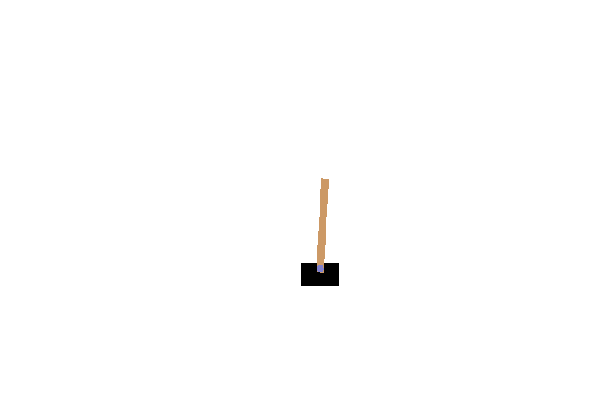
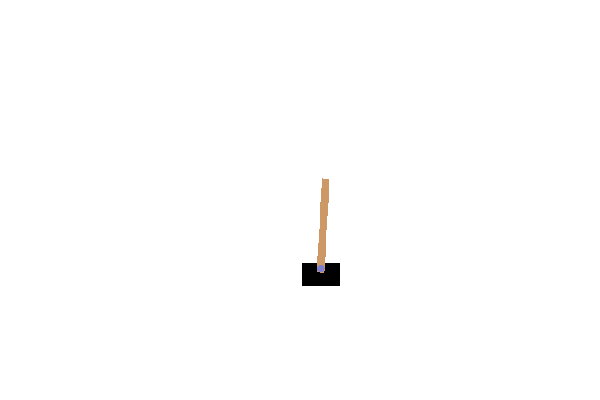
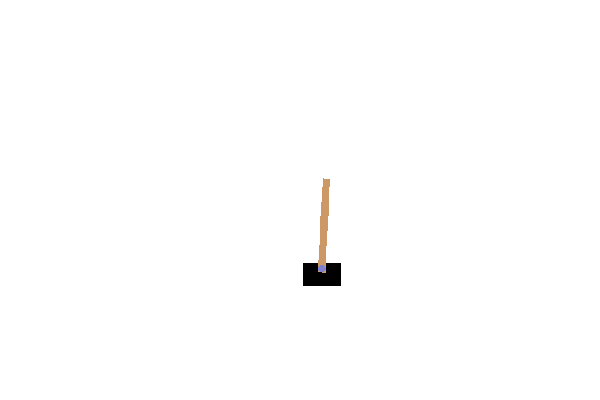
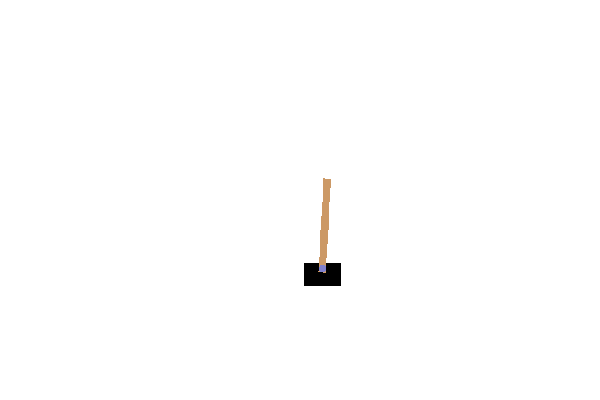
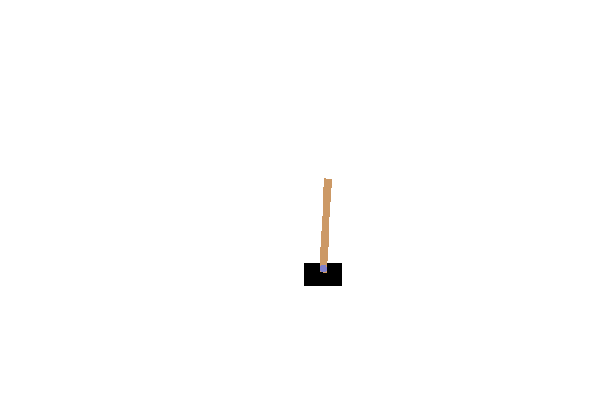
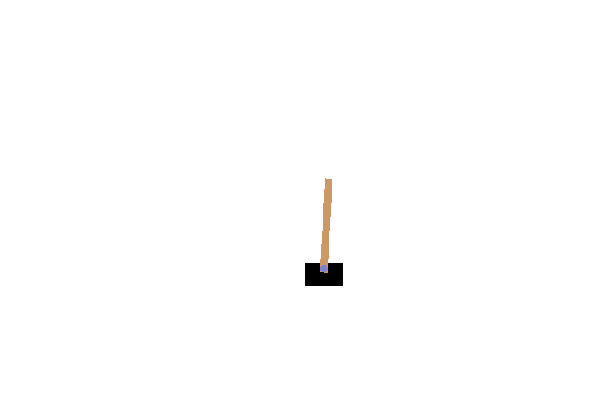
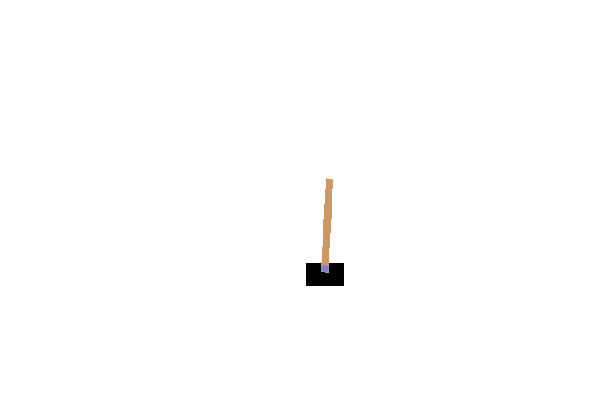
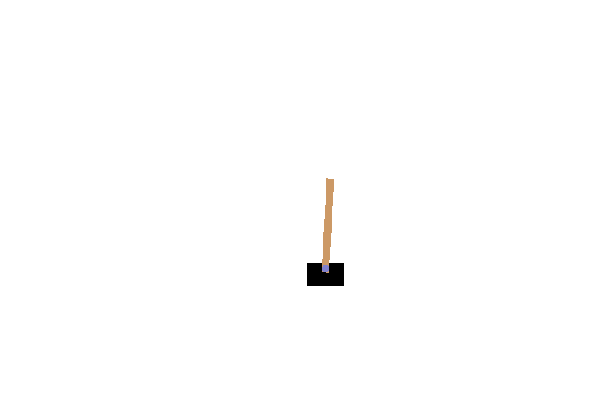
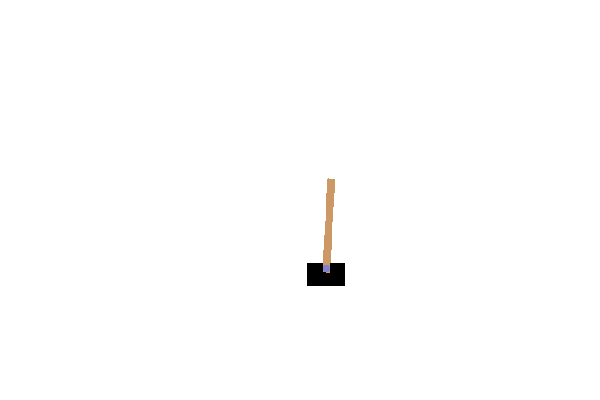
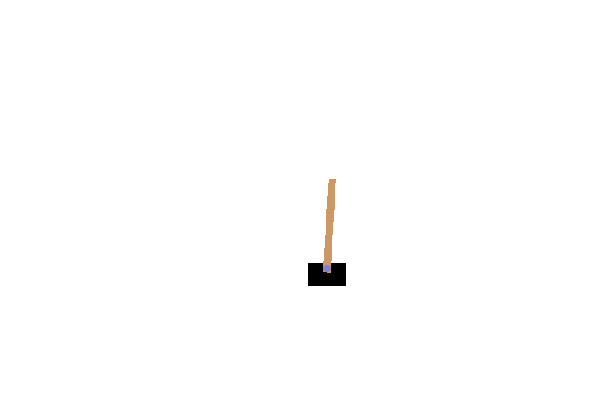
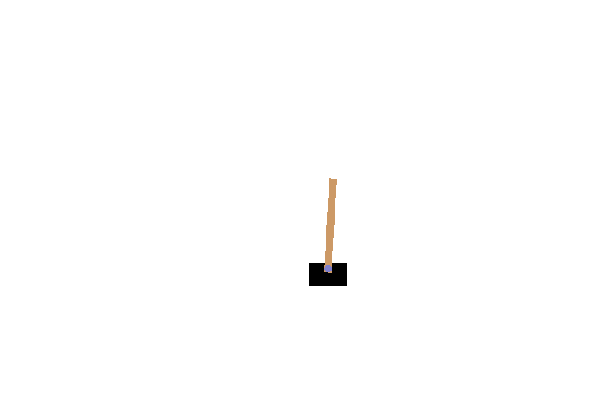
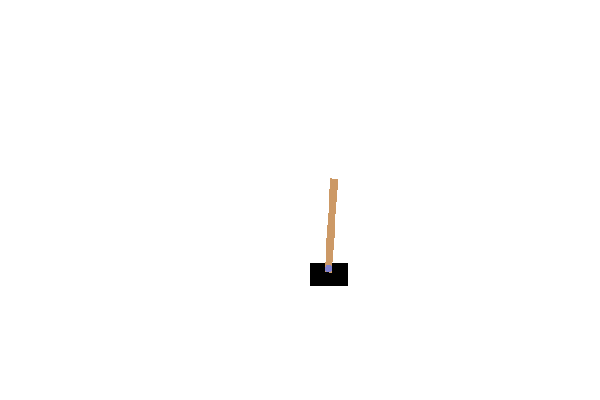
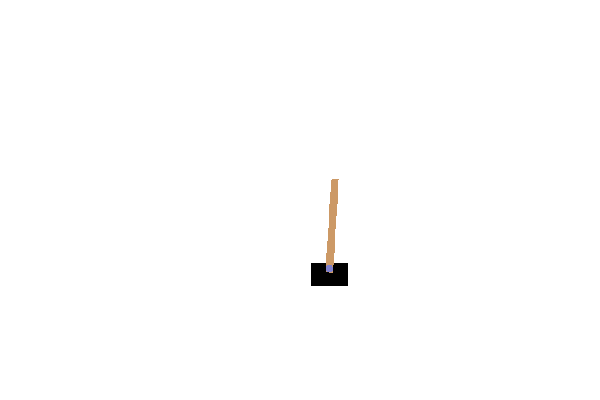
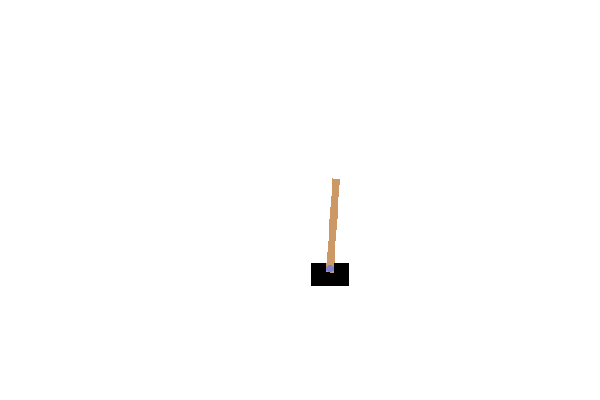
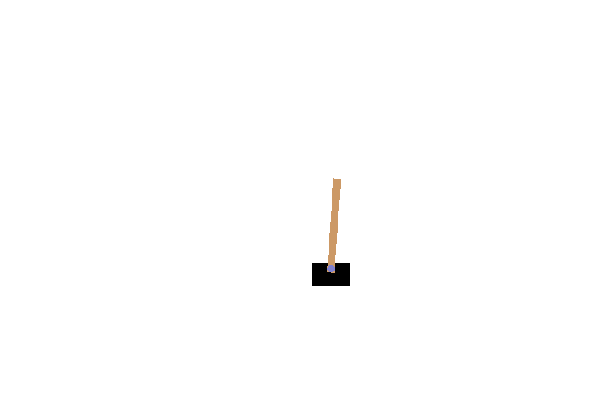
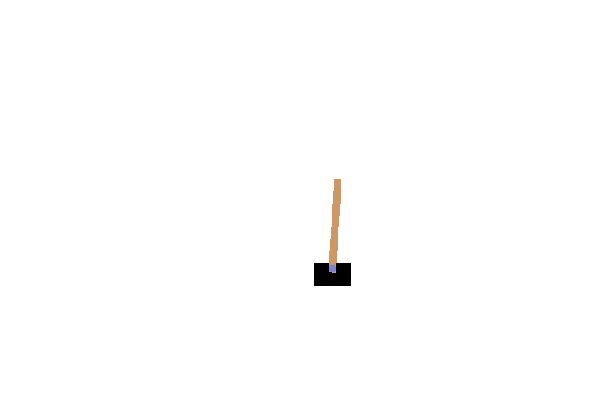
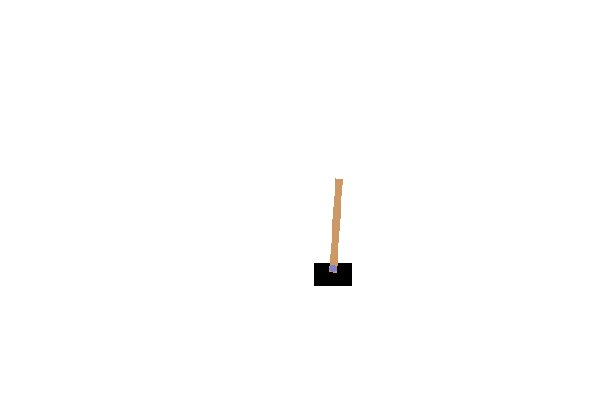
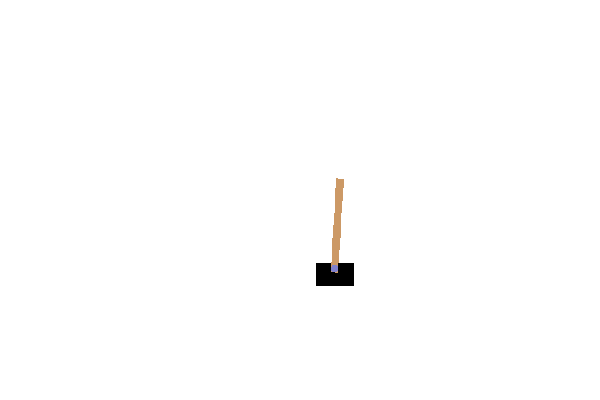
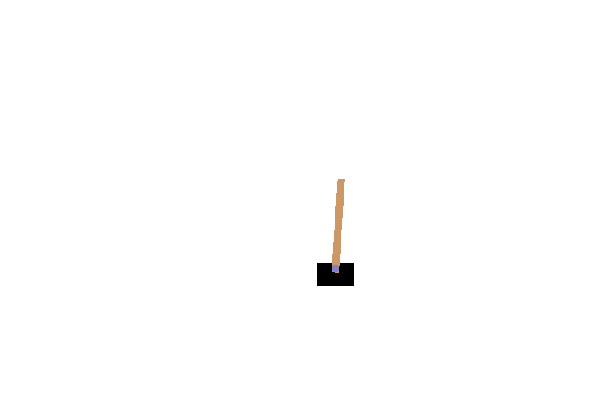
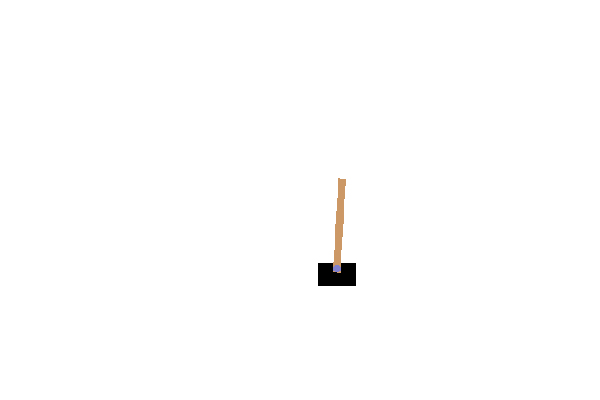
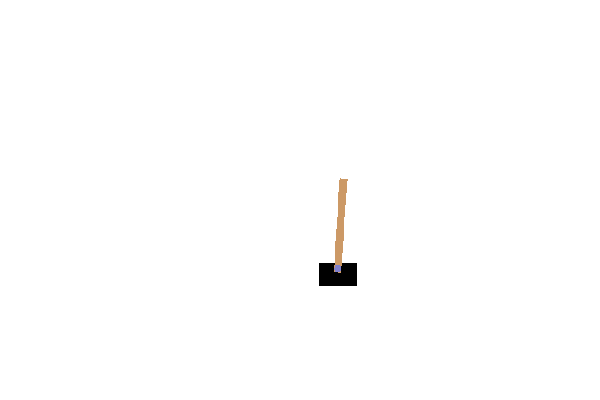
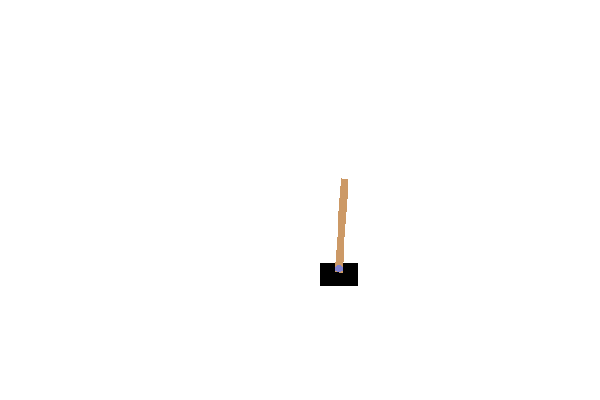
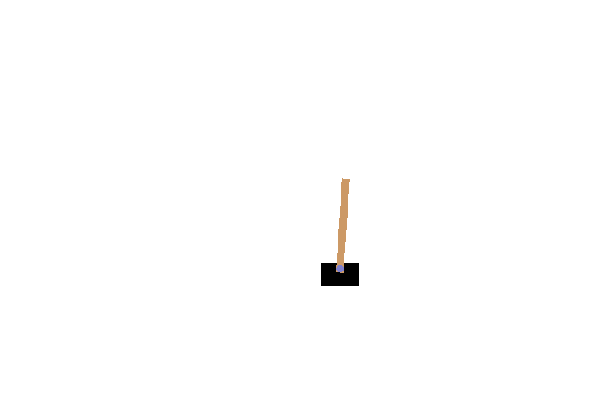
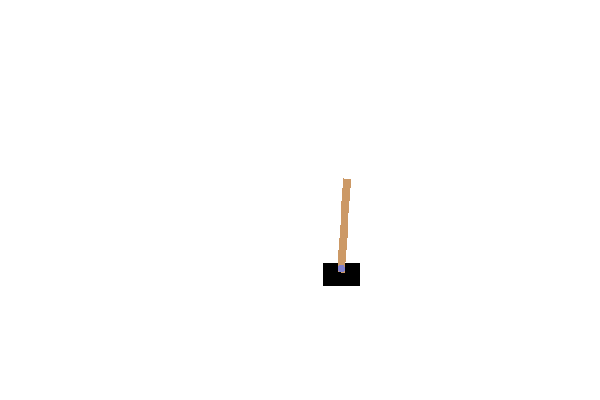
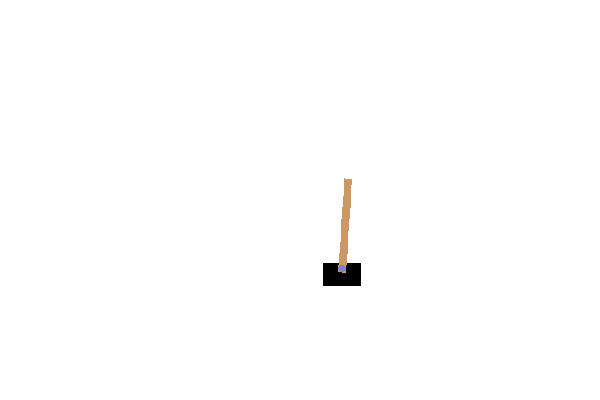
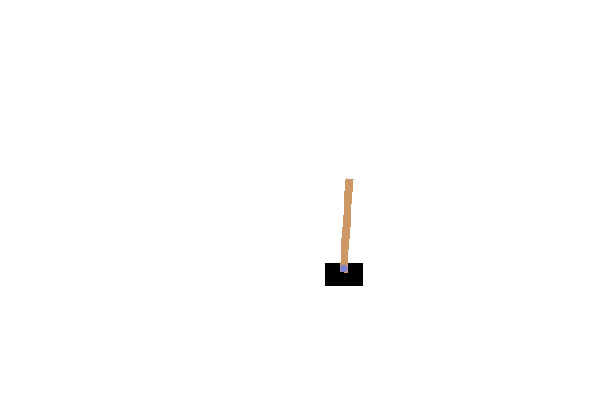
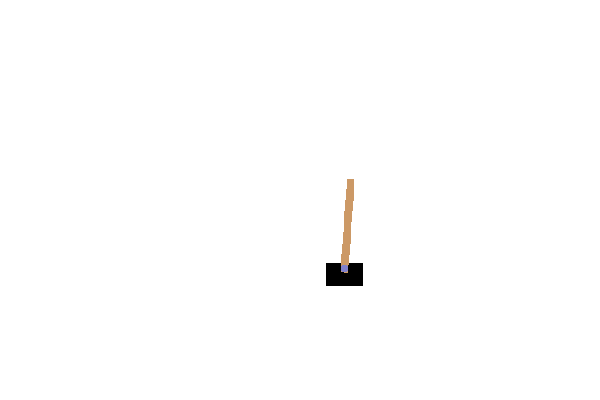
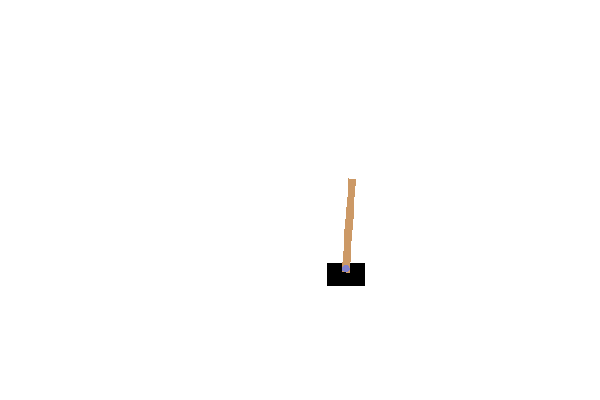
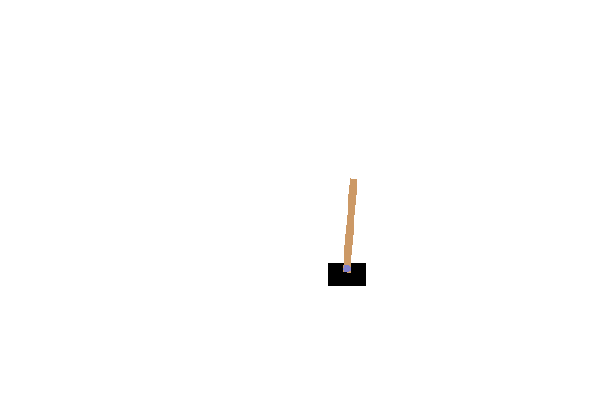
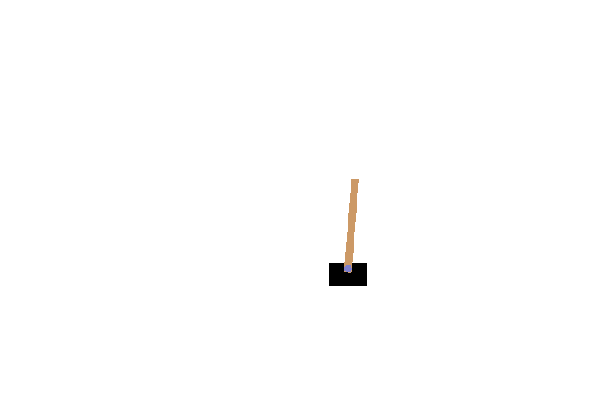
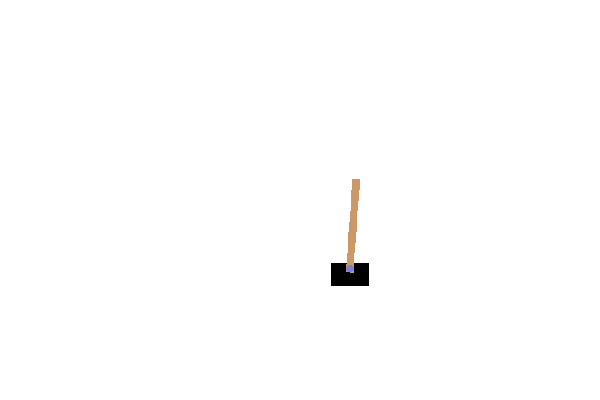
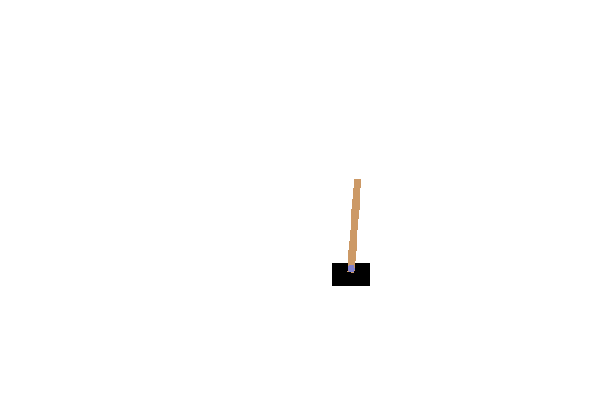
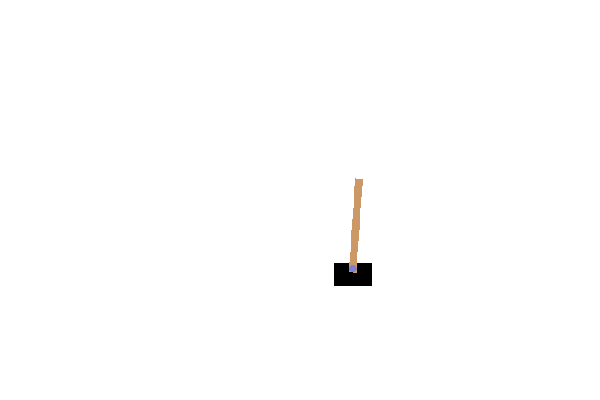
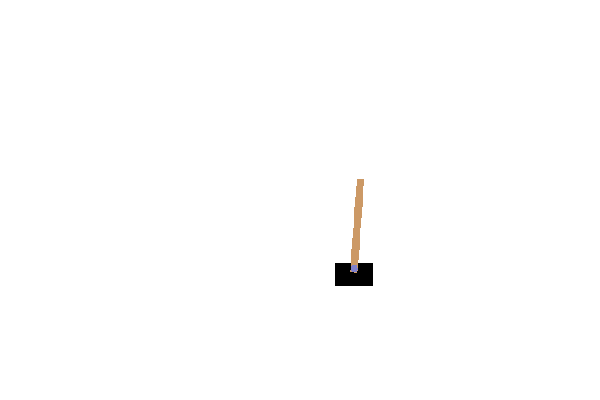
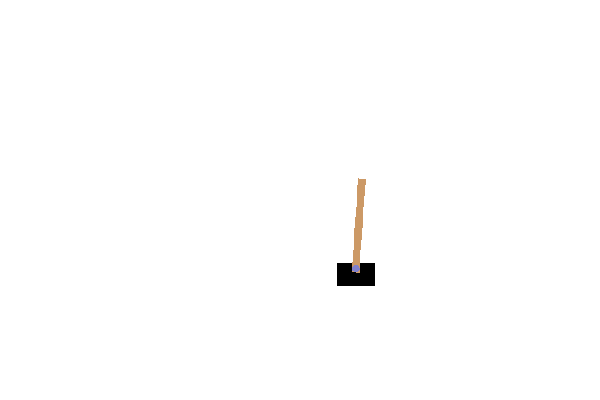
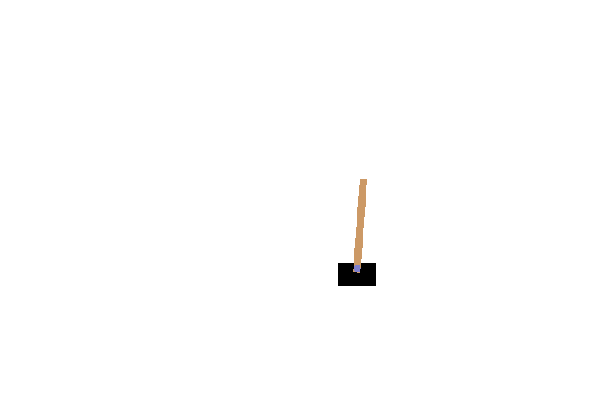
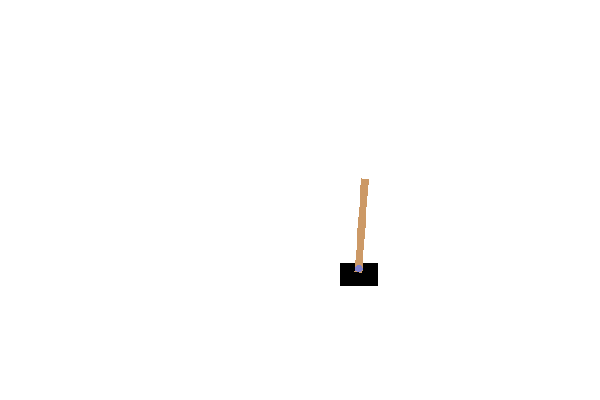
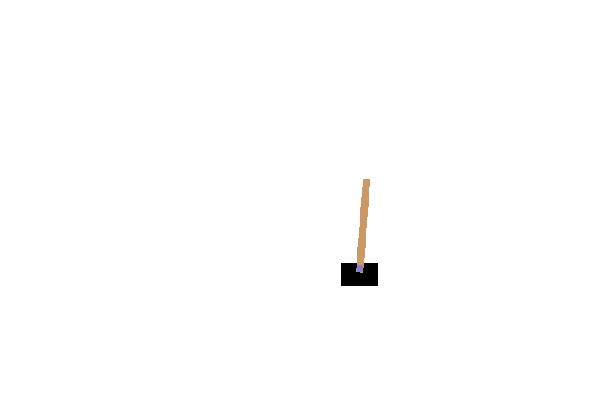
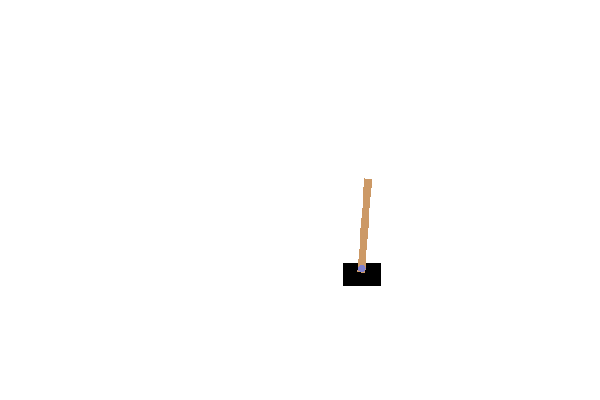
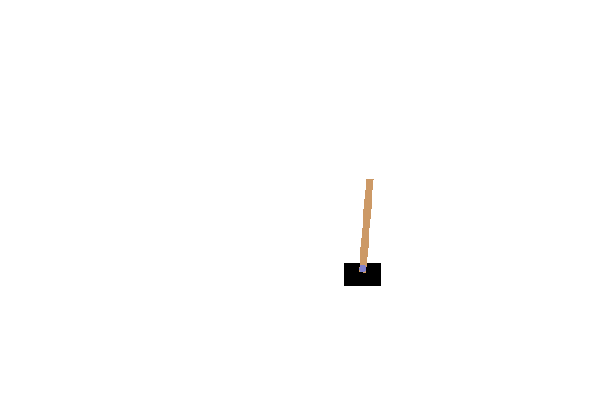
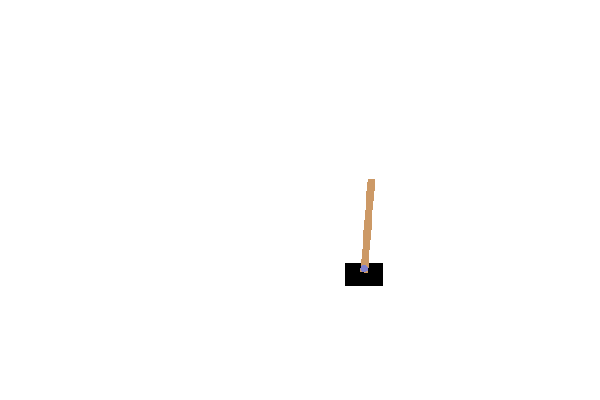
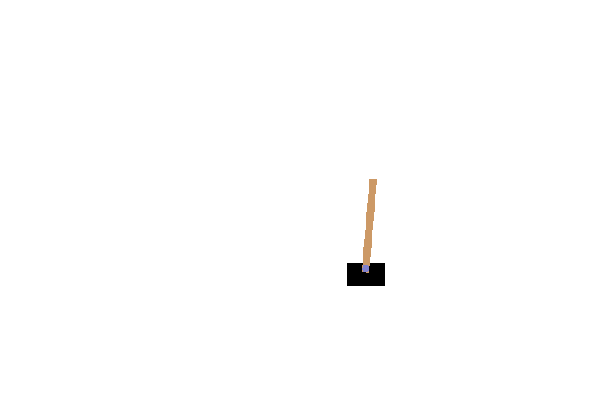
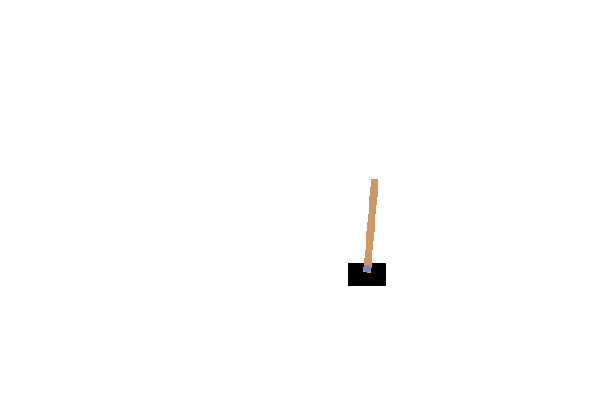
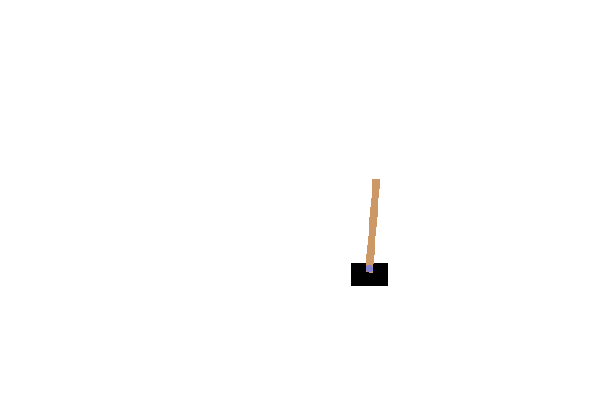
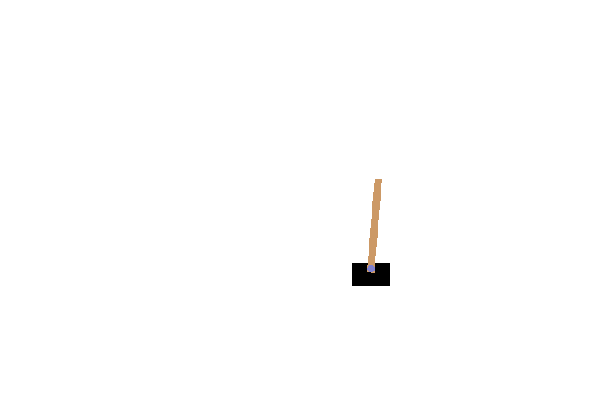
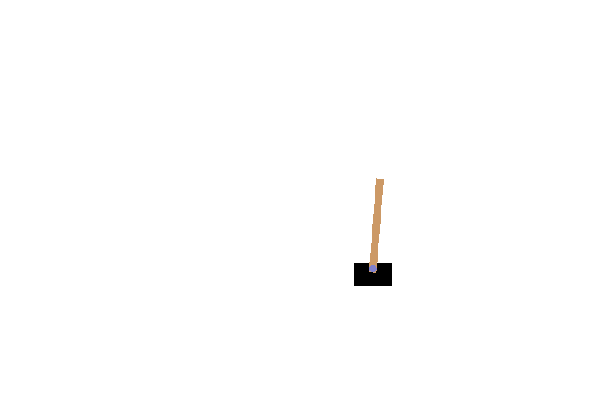
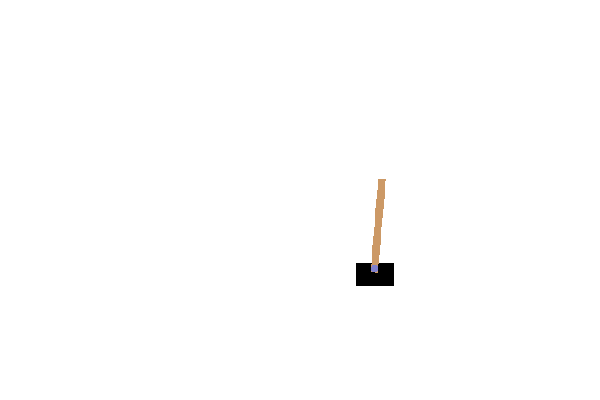
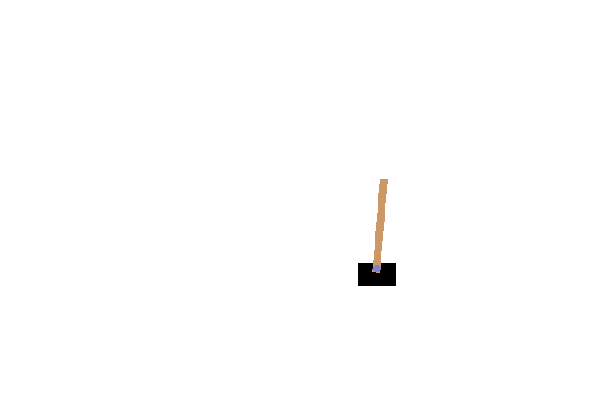
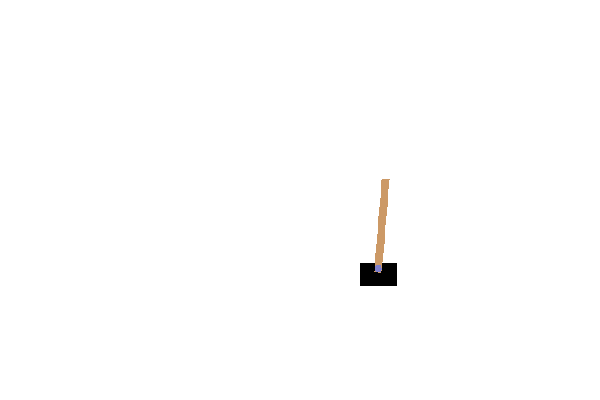
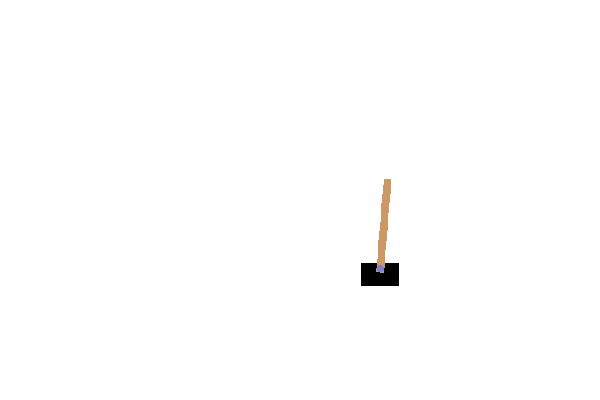
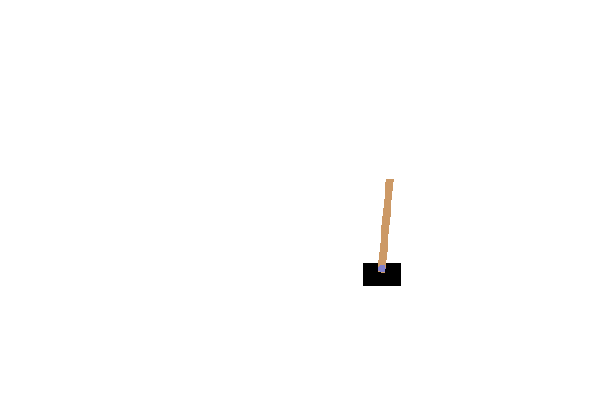
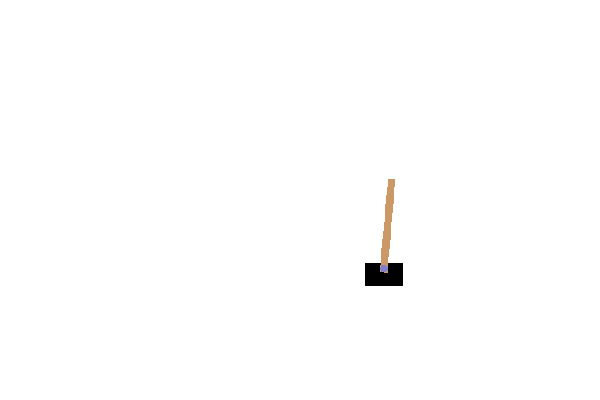
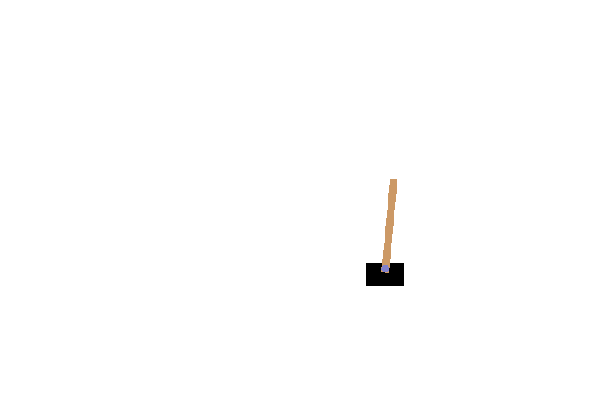
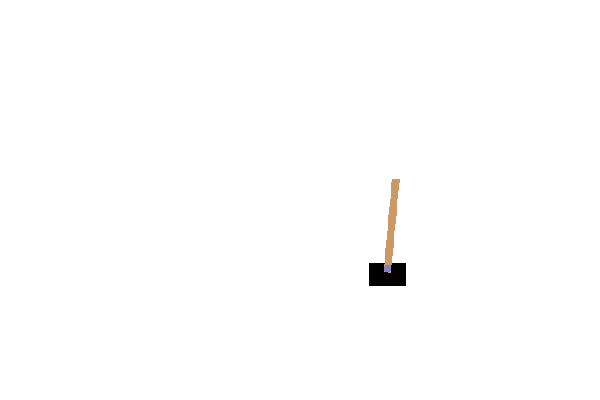
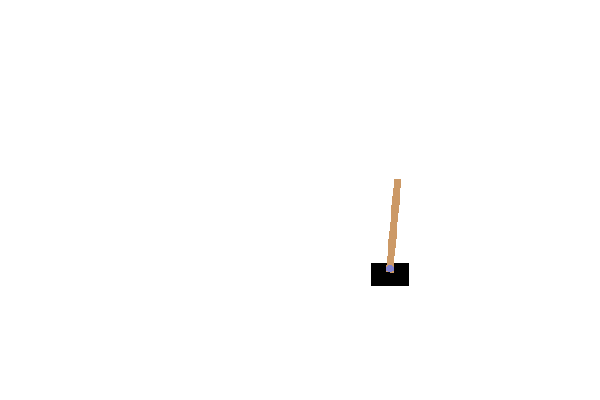
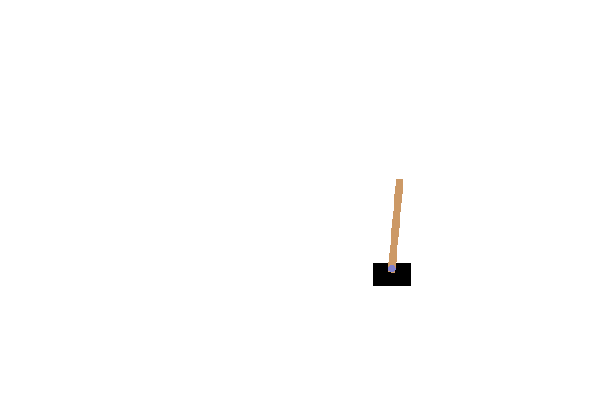
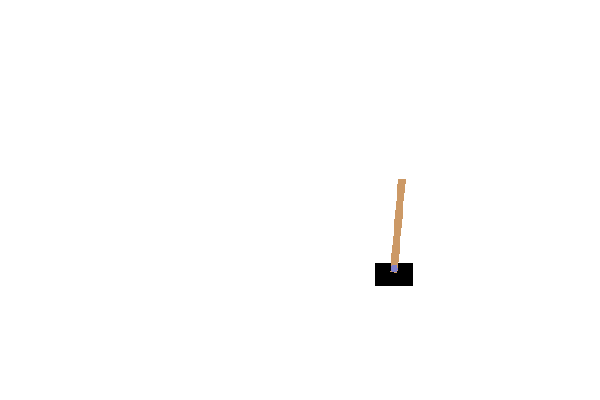
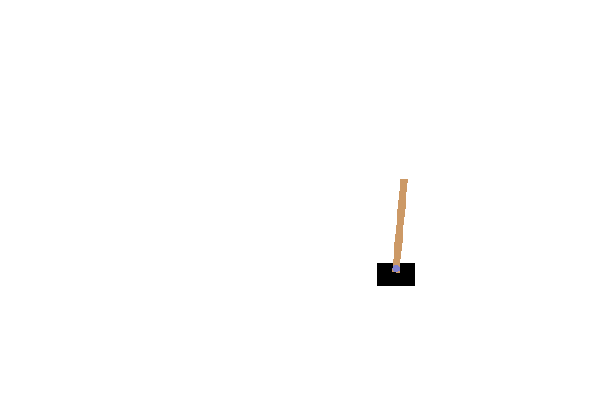
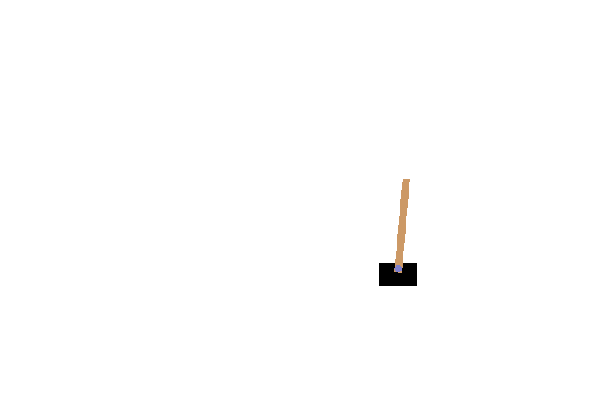
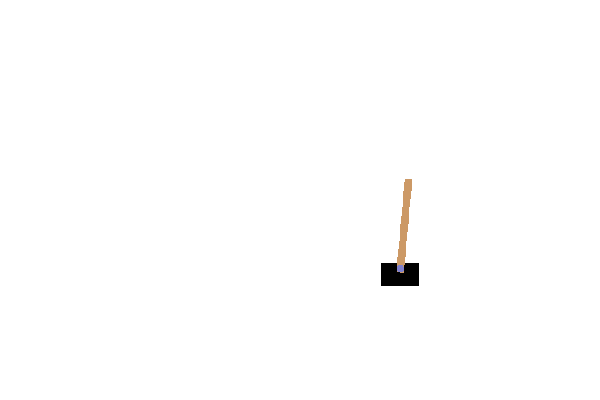
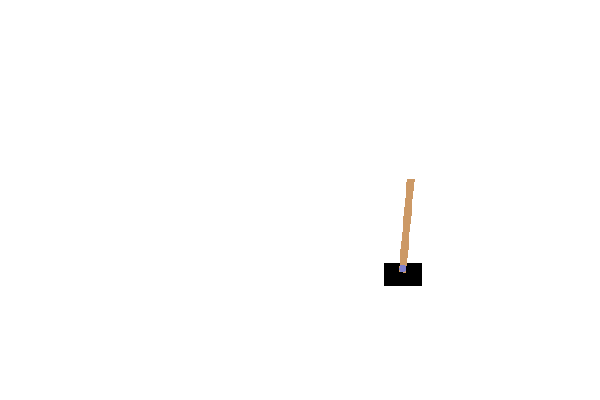
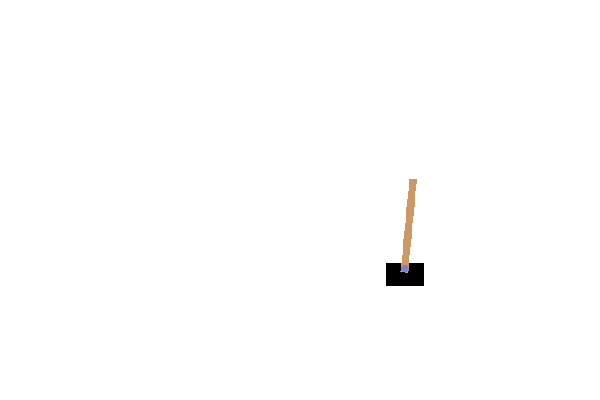
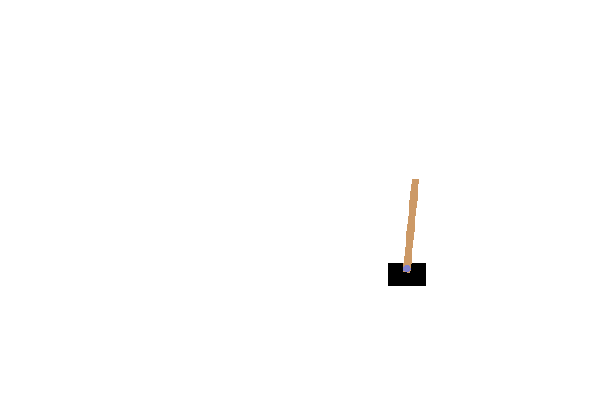
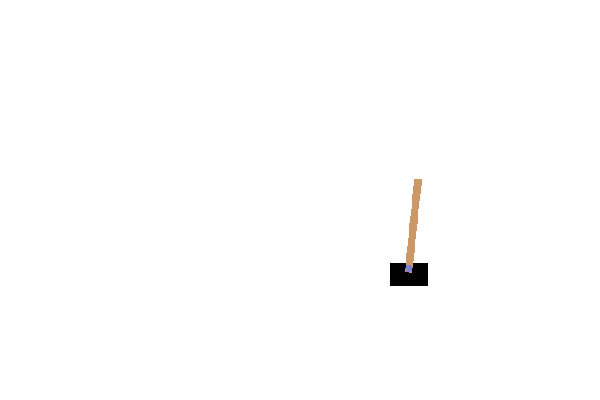
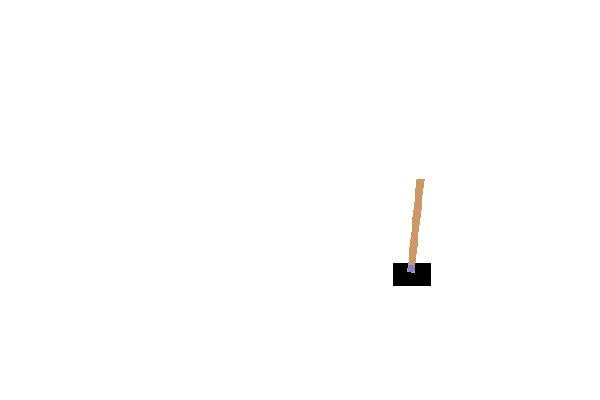
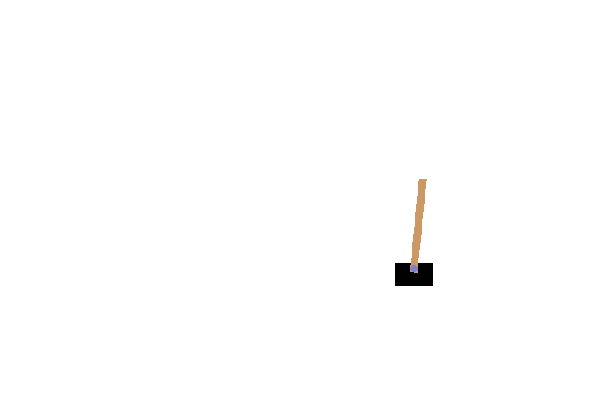
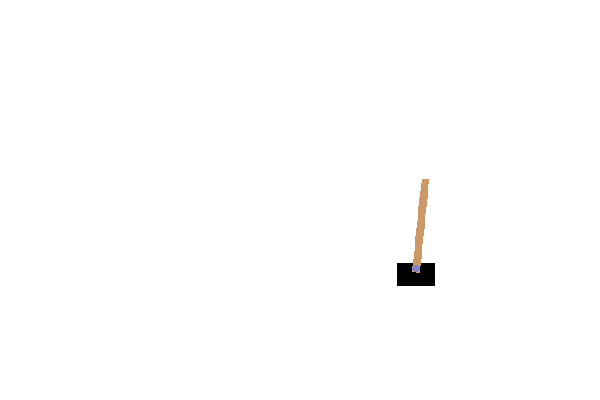
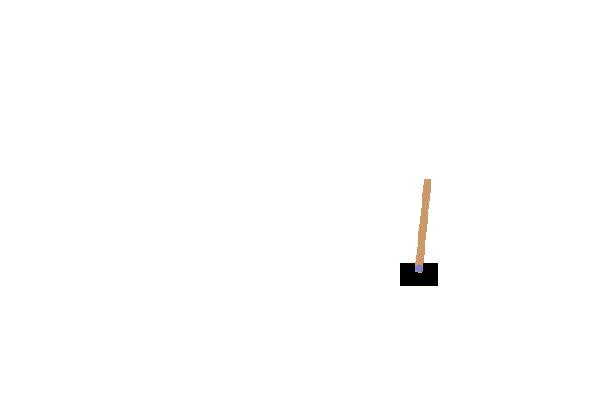
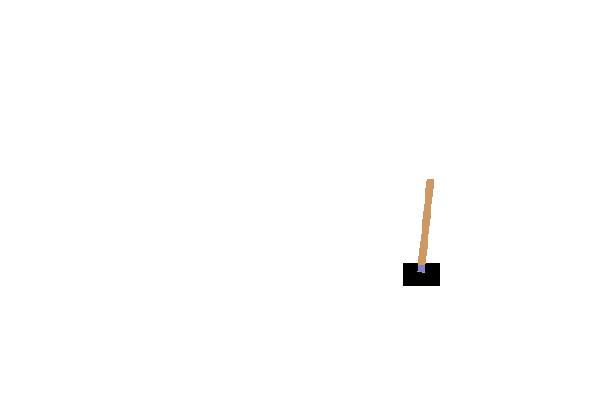
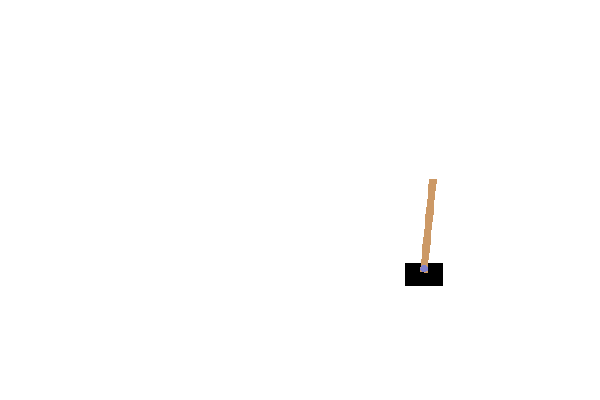
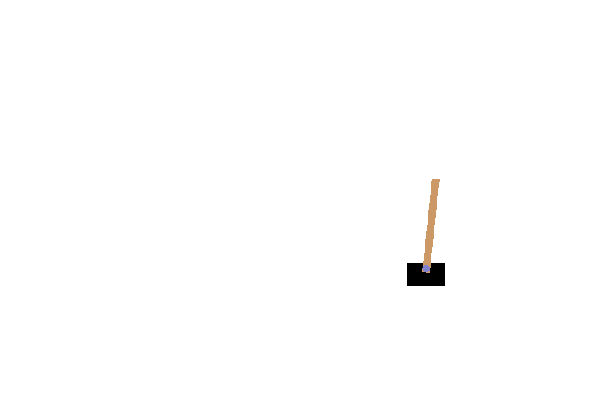
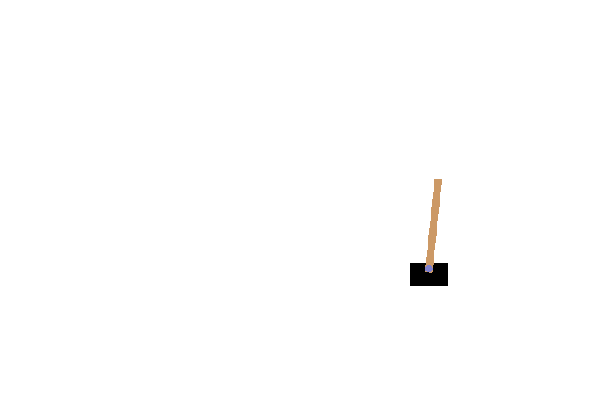
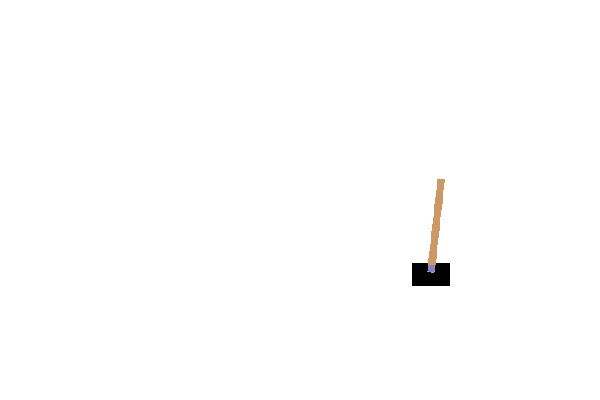
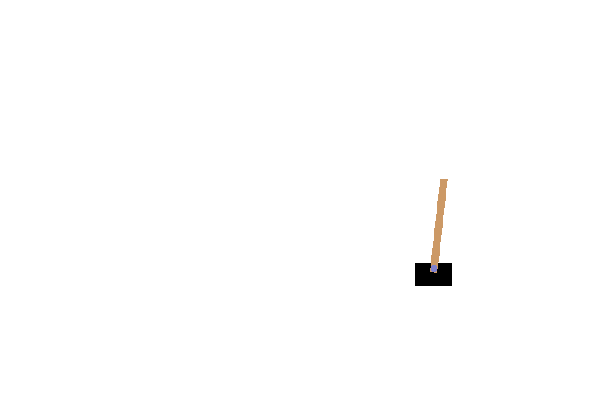
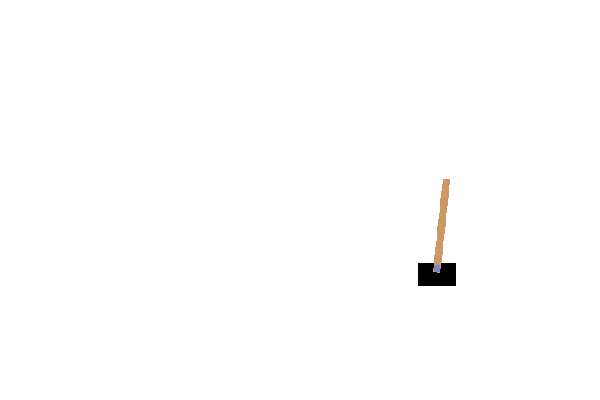
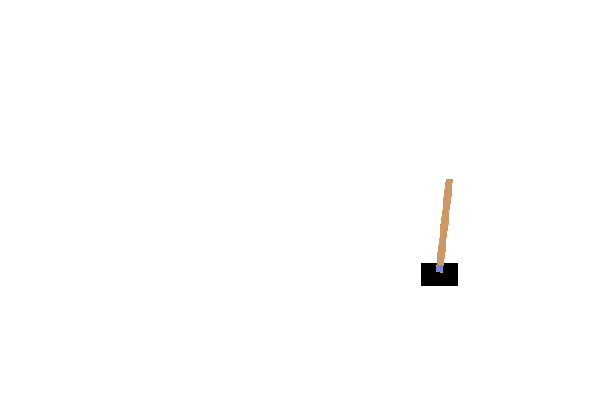
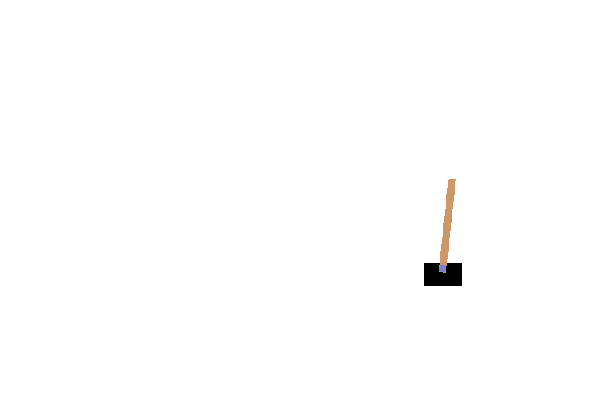
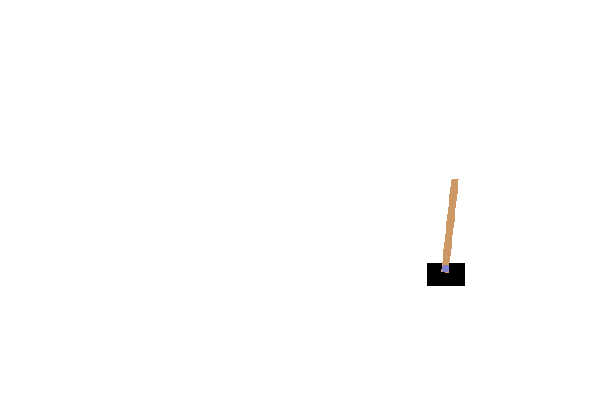
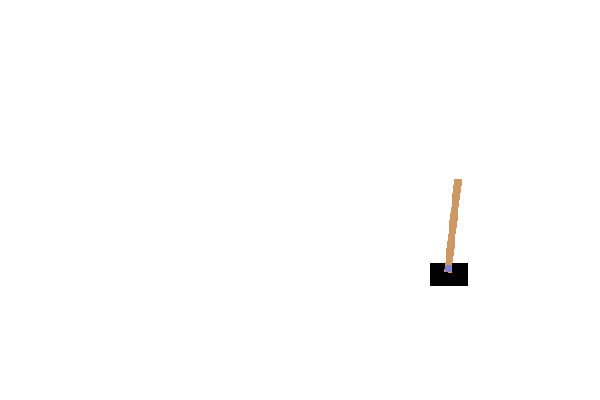
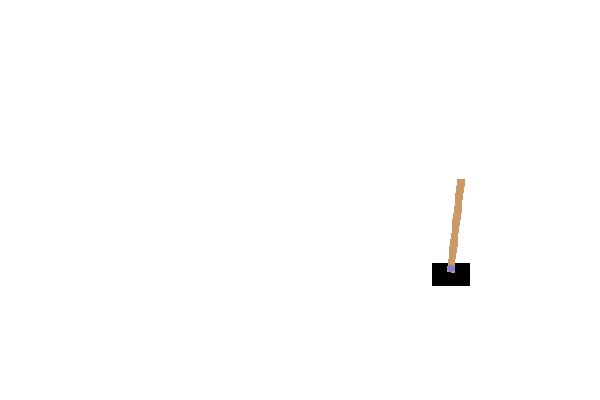
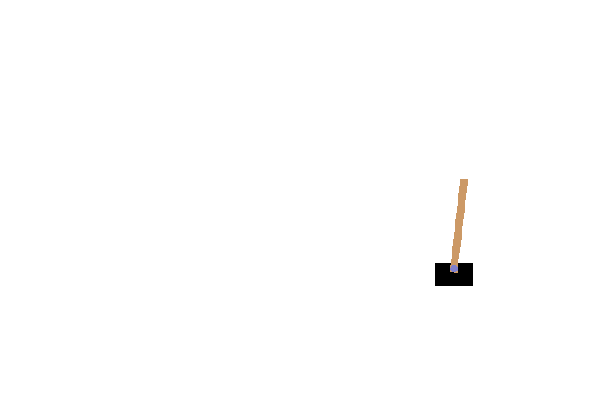
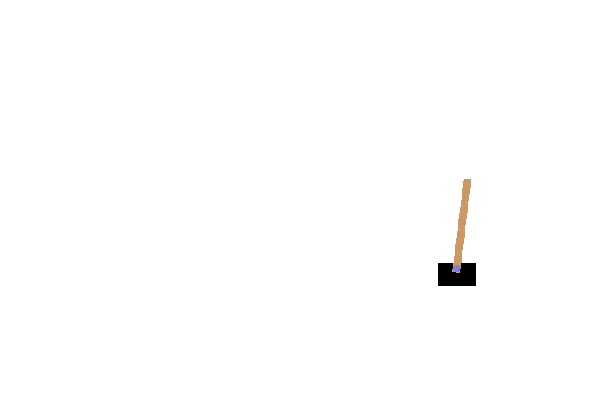
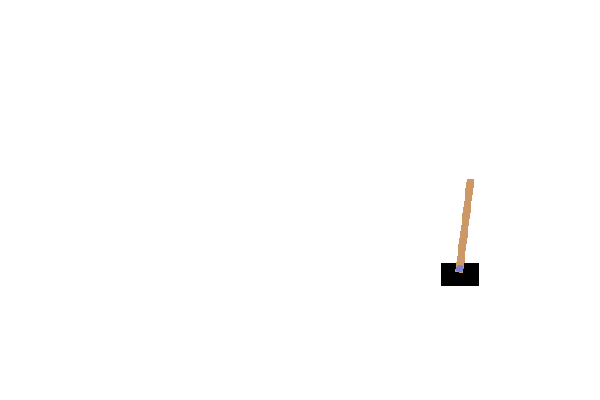
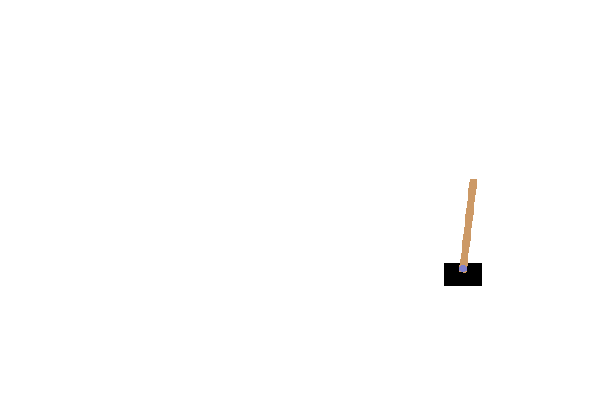
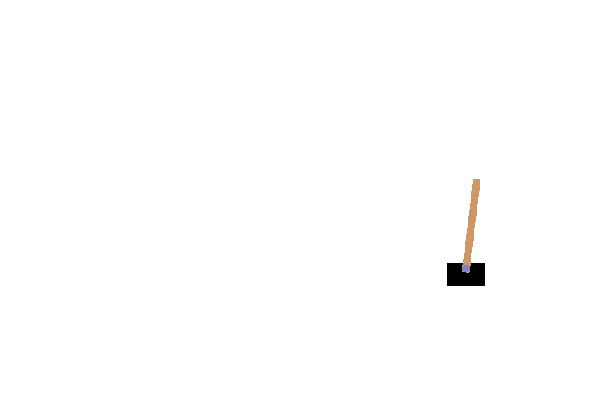
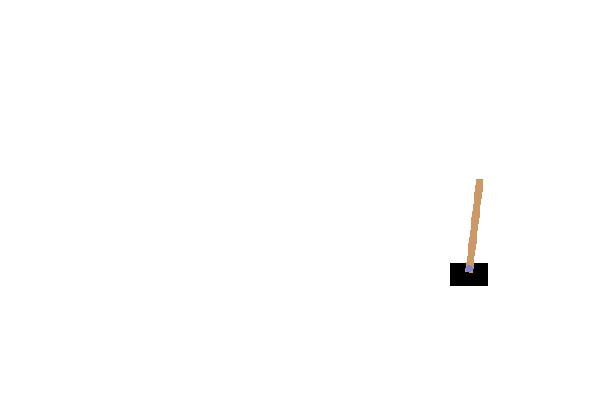
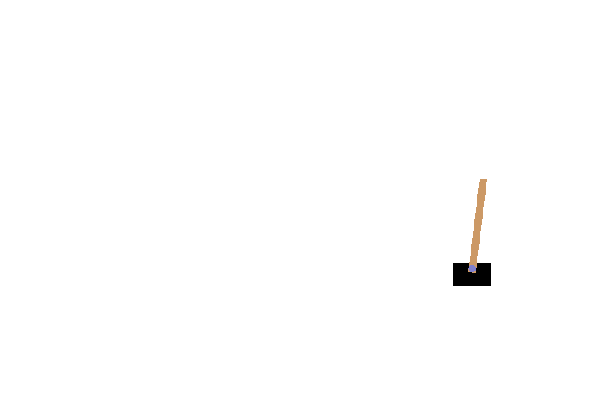
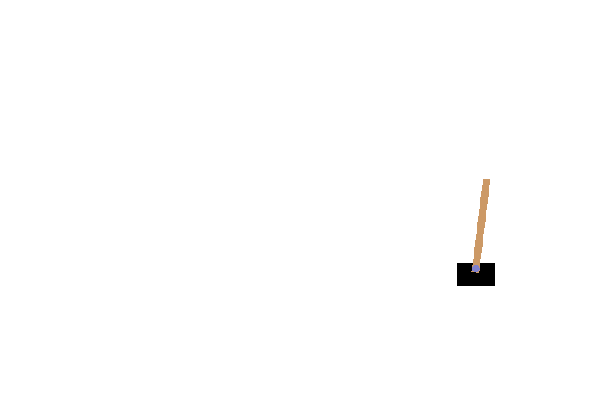
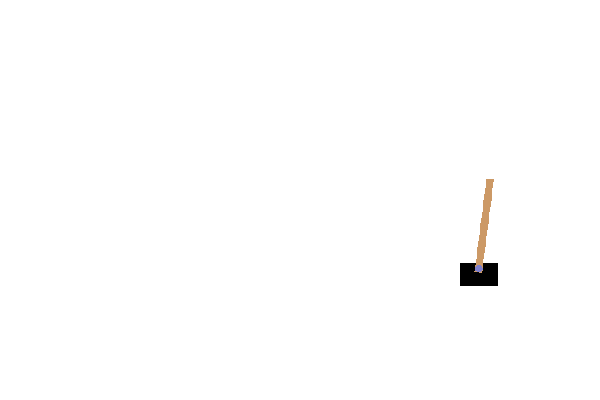
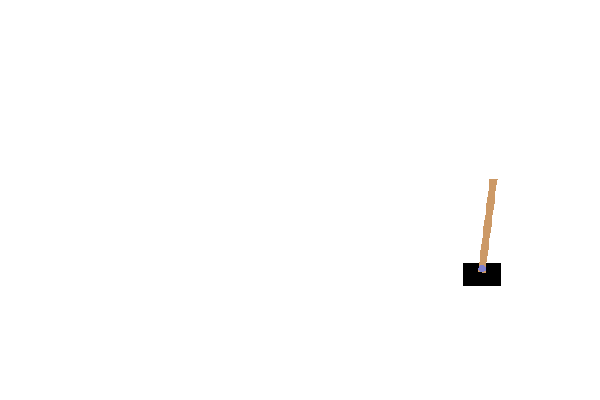
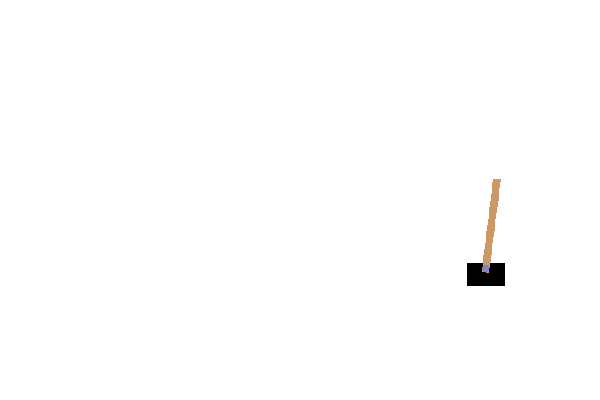
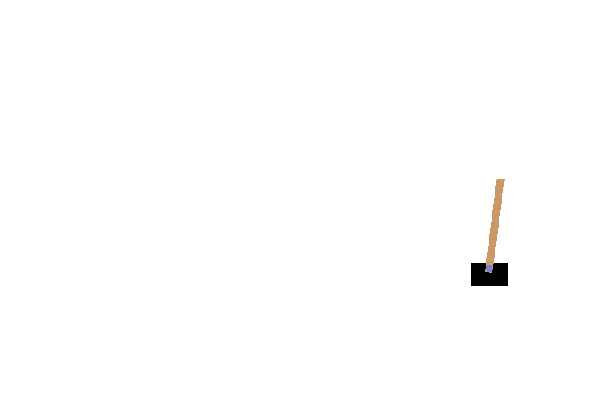
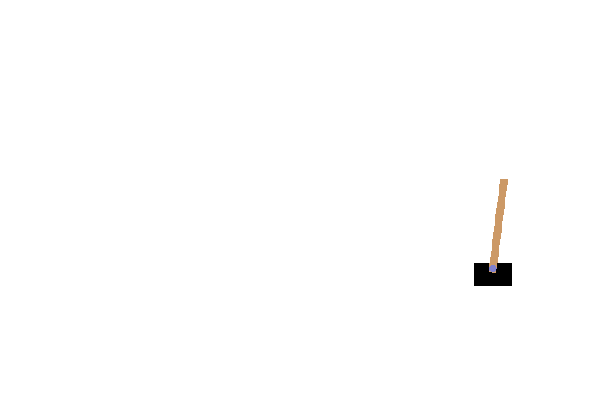
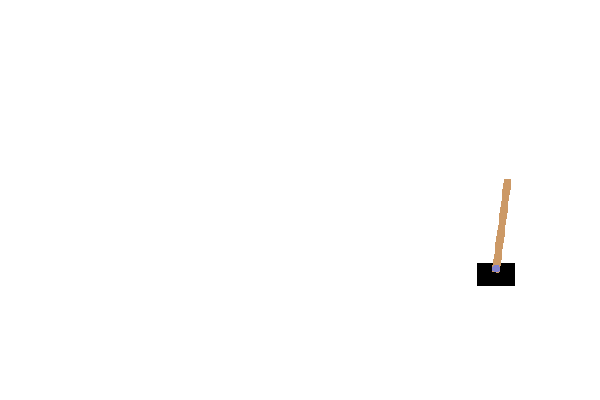
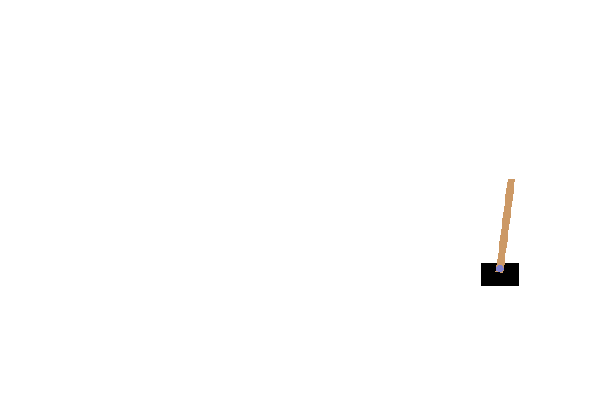
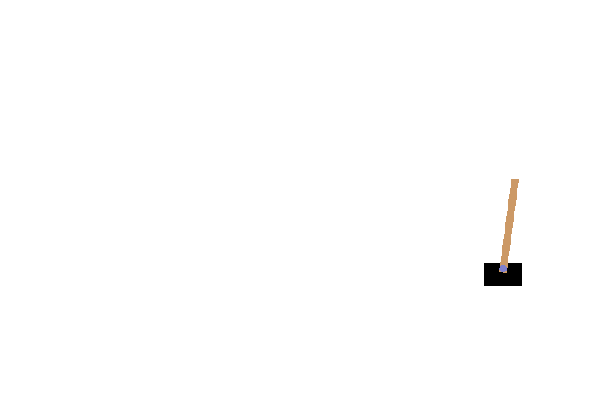
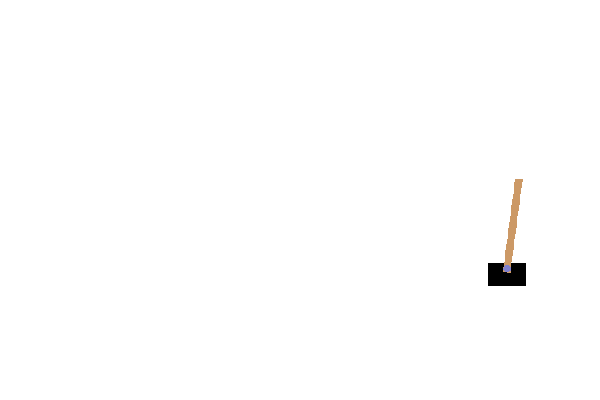
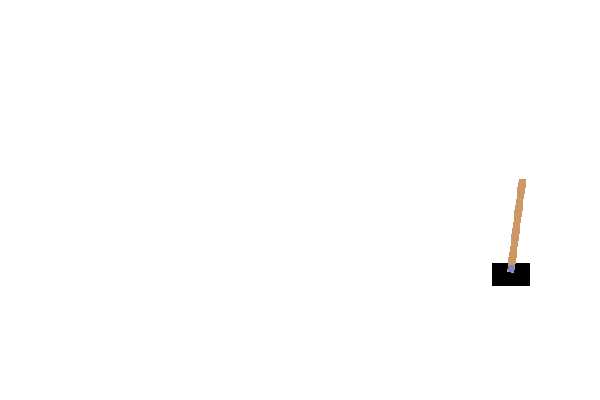
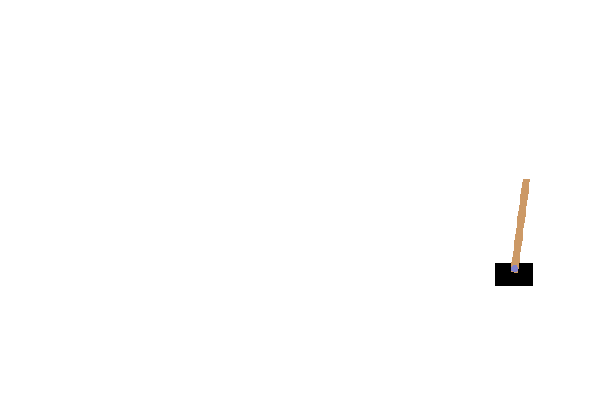
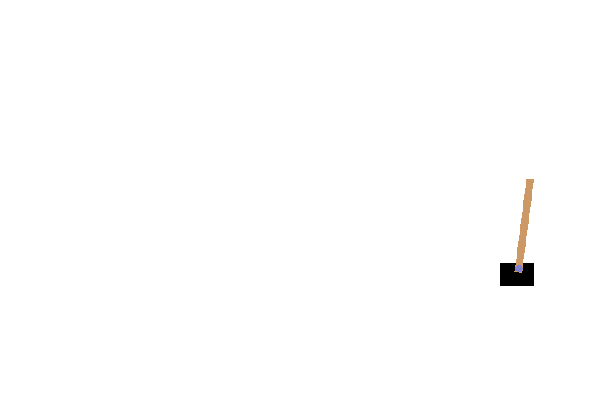
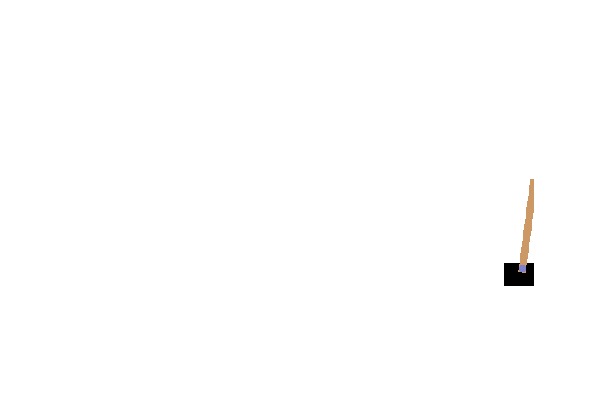
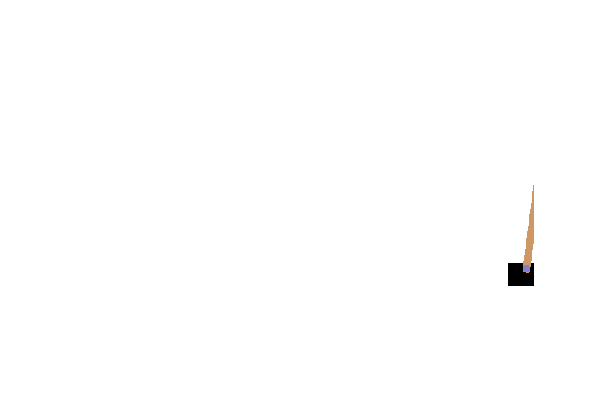
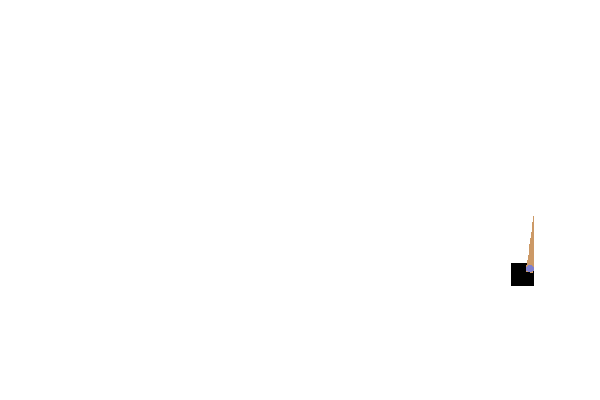
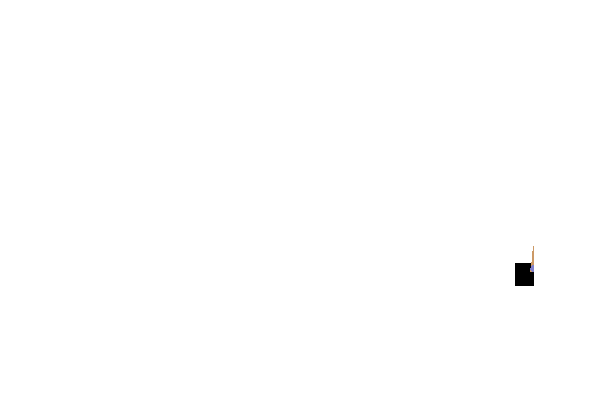

In [30]:
n_iter = 5

frames = []

for t in range(n_iter):
    # Render into buffer. 
    # You will still see the window.
    obs = env.reset()
    done = False
    while not done:
        action = angvel_policy(obs)
        env.render()
        obs, reward, done, info = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
env.render(close=True)

display_frames_as_gif(frames)

With an average number of steps 4x that of the deflection policy, this angular velocity policy is much, much better at keeping the pole up, since we avoid both amplifying the movement of the pole and overcorrections. However the system eventually gets locked into a behavior where the cart runs out of the field.   

### A Neural Network Policy

Let's build a fairly simple NN in Keras and compose a policy based on it.  We have 4 inputs for the 4 variables specifying the environment. The binary output will be modeled by a categorical vector.  We shouldn't need an incredibly complicated hidden layer, so we will choose 4 units.  Graphically we have

<img src="images/nn_policy.png" alt="a simple NN for the cart-pole" style="width: 200px;"/>

The model is easily defined:

In [31]:
input_feat = 4
output_feat = 2
width = 4
learning_rate = 0.01

model = None
model = tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=width, input_dim=input_feat))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=output_feat))
model.add(tf.contrib.keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate))

We don't have a method yet to train this model, but we can nevertheless define a policy.  Given the system state input, this model predicts a probability to execute action 1 (move to the right). So one possible policy is 

In [32]:
def nn_naive_policy(obs):
    obs_reshape = obs.reshape(1, input_feat)   # reshape observation into example x features form
    proba = model.predict(obs_reshape)         # get output probability
    action = np.argmax(proba, 1)   # return most probable output
    action = np.asscalar(action) # return scalar
    return action

The untrained network should do around as well as random sampling:

In [33]:
(mean_reward, std_reward, max_reward, min_reward) = run_episodes(cartpole_episode, None, 1000)
print("For random sampling:")
print("Mean/standard deviation of rewards was:", 
      format(mean_reward, '.2f'), 
      "+/-", 
      format(std_reward, '.2f')
     )
print("Max reward was:", max_reward)
print("Min reward was:", min_reward)

For random sampling:
Mean/standard deviation of rewards was: 22.10 +/- 11.77
Max reward was: 94.0
Min reward was: 8.0


In [34]:
(mean_reward, std_reward, max_reward, min_reward) = run_episodes(cartpole_episode, nn_naive_policy, 1000)
print("For untrained NN sampling:")
print("Mean/standard deviation of rewards was:", 
      format(mean_reward, '.2f'), 
      "+/-", 
      format(std_reward, '.2f')
     )
print("Max reward was:", max_reward)
print("Min reward was:", min_reward)

For untrained NN sampling:
Mean/standard deviation of rewards was: 82.69 +/- 42.43
Max reward was: 200.0
Min reward was: 25.0


It actually does worse, probably since there is bias once the pole and cart deviate from their initial values.

We'll next make a mathematical aside to the study of stochastic processes, which will lead us to a way to train our neural network to do much better.

## Markov Processes

Consider the Cart-Pole system simulation. Because of finite machine precision, there are a finite number of states 
$$S_i = (x_i, \dot{x}_i, \theta_i, \dot{\theta}_i)$$ 
that the system can be in at any given time.  Applying an action $a^{(t)}$ at time $t$ moves the system to some new state
$$ a^{(t)}: S^{(t)} \rightarrow S^{(t+1)}.$$

One of the action policies that we considered above was a random sample of the push to the right or left.  In this case, the state at time $t$ will be connected to at least 2 states:

<img src="images/cartpole-timestep.png" alt="transition between cartpole states" style="width: 250px;"/>

Imagine that we have the cart-pole system with a policy assigned that has at least some component of randomness involved.  We want to describe the system from the point of view of an external observer, much the same as we observed the evolution of the system in the animations above:
1. At time $t$, the cart-pole system is in the state $S^{(t)} = S_i$, where $S_i$ can be any of the allowed states.
2. At time $t+1$ the system has moved into a state $S^{(t+1)} = S_j$.  
3. After watching the system for a long time, or for many simulations, we find that the **transition probability** from a state $S_i$ to the state $S_j$ is given by  $p_{ij}$.
4. On general principles, 
$$ \sum_j p_{ij} = 1 ~~\forall i,$$
since at time $t+1$ the system has to be in one of the allowed states $S_j$.

This  mathematical structure is called a **Markov chain**:
* Since the time step is discrete, this is a **discrete-time Markov chain**
* The characteristic that the state at time $t+1$ only depends on the state at time $t$ makes this a **Markov chain of order 0** or **memory 0**.
* Because the transition probabilities are the same for all times $t$, this is a **time-homogeneous** or **stationary Markov chain**. 
* The cart-pole system also had conditions for failure:
$$ \begin{split}
& |\theta| > \theta_c = \pi / 15 = 12^\circ, \\
& |x| > x_c = 2.4 .
\end{split} $$
Since the simulation terminates upon reaching a state satisfying either condition, we can call those **absorbing states**, since it is impossible to leave one of those states.  The chain is called an **absorbing Markov chain**.

A simplified version of the cart-pole Markov chain, with only 3 states drawn is:

<img src="images/three-chain.png" alt="a 3-state Markov chain" style="width: 350px;"/>

A very useful visualization of Markov chains is available at http://setosa.io/blog/2014/07/26/markov-chains/.

Let's now consider the case where we are seeking to develop an optimal policy: for example, we want to train our neural net policy.  We can consider the information contained in the Markov chain, but now we should also include the available actions and rewards.  Graphically, we have something like:

<img src="images/three-mdp.png" alt="a 3-state Markov decision process" style="width: 450px;"/>

Here, we've used a notation where
$$ p(j|ia) = \text{Pr}\Bigl(S^{(t+1)} = S_j |S^{(t)} = S_i, A^{(t)} = A_a\Bigr), $$  where $A_a$ is one of the finite set of actions available.  We used an analogous notation for the associated reward, if any. Of course, *a priori* our agent doesn't know either the probabilities or the rewards: it must observe a large number of simulations to attempt to deduce them.

In this context, a **policy** $\pi$ is a way to uniquely associate an action $A$ to a state $S$:
$$ A = \pi(S).$$   
In order to determine the **optimal policy** within the bounds of the problem, we should compute the expected reward for a given policy.   

Suppose the system starts in the state $S_i$.  If we apply the action $A_a$ and end up in a particular state $S_j$, we obtain the reward $r(j|ia)$ (which $=0,1$ in our cart-pole problem).   Since we can actually end up in several states $S_j$ according to the transition probabilities $p(j|ia)$, the immediate expected reward is 
$$ \sum_j p(j|ia) ~ r(j|ia) = \sum_j p(j|i\pi(i)) ~ r(j|i\pi(i)).$$
On the right-hand side of this equation we have written $\pi(i)$ to stand for the action $A_a = \pi(S_i)$ assigned by the policy in effect.

Next, we consider the value (expected reward) $Q(S_i, A_a)$ of choosing the action $A_a$ when in the state $S_i$ .  This is going to be defined recursively as the sum of the immediate reward from taking the action and the future rewards from choosing the optimal action $A^*_b$ for the state $S_j$ reached after the initial action.   This quantity 
$Q(S_j, A^*_b)$ is viewed as a future payout, since it arises from a future time step. As such, using basic financial principles, it is typical to discount its value, on the basis that an immediate payout is worth more than a future payout.  If we call
$$ \gamma = \frac{1}{1 + \rho}$$
the **discount factor**, where $\rho$ is the **discount rate**, the expected **action-value**  is given by
$$ Q(S_i, A_a) = \sum_j p(j|ia) \Bigl( r(j|ia) + \gamma \max_b Q(S_j, A_b) \Bigr).$$
This equation is a version of the **Bellman Optimality Equation**. 

In dynamic programming, we can solve this optimization problem using the algorithm:

### Q-Learning 
(from Sutton and Barto)

<img src="images/q-learning.png" alt="The Q-Learning algorithm" style="width: 700px;"/>

An important part of the algorithm is the update step:
$$ Q(S, A) \leftarrow Q(S, A) + \alpha \Bigl( R + \gamma \max_{A'} Q(S', A') - Q(S, A) \Bigr),$$
where $\alpha$ is a **learning rate**.   The quantity 
$$ R + \gamma \max_{A'} Q(S', A') - Q(S, A) $$
has the form of an **error** where:
* $ Q(S, A) $ is the current **estimate** of the action-value.
* $ R + \gamma \max_{A'} Q(S', A') $ is the **target** action-value.

This suggests that we can rephrase the optimization problem as a regression problem where the objective is to find the policy $ A = \pi(S)$ that minimizes the squared error
$$ J = \sum_{S,A} \left( R + \gamma \max_{A'} Q(S', A') - Q(S, A) \right)^2 .$$


### Implement Q-Learning in Keras

Previously we setup a NN to predict an action using a softmax output.  After determining the Q-Learning solution to the problem, we now want to predict $Q(S,A)$ given the input state.  Since there are two possible actions, we will design our network to predict two outputs: $Q(S,0)$ and $Q(S,1)$.

In [35]:
dim_state = 4
dim_action = 2
width = 4
learning_rate = 0.01

model = None
model = tf.contrib.keras.models.Sequential()
model.add(tf.contrib.keras.layers.Dense(units=width, input_dim=dim_state))
model.add(tf.contrib.keras.layers.Activation('relu'))
model.add(tf.contrib.keras.layers.Dense(units=dim_action))
model.compile(loss='mse', 
              optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate))

Our strategy for implementing Q-Learning with a NN policy is then the following.

#### Per episode observing:

1\. Obtain the initial state $S$ of the system from `obs = env.reset()`.

In [36]:
obs = env.reset().reshape((1,4))
print(obs)

[[ 0.03416475 -0.04911551 -0.04370714  0.04589922]]


2\. Predict the $Q$ values from `model.predict(obs)`.

In [37]:
Qmat = model.predict(obs)
print(Qmat)

[[ 0.  0.]]


3\. Determine the action via a $\epsilon$-greedy policy:
$$ A = \begin{cases} 
\text{argmax} \Bigl(Q(S,0), Q(S,1)\Bigr), & \text{with} ~~p =  1-\epsilon ,\\
 \texttt{np.random.randint(2)}, & \text{with} ~~ p =  \epsilon .
\end{cases} $$

In [38]:
epsilon = 0.05

act_pol = np.argmax(Qmat)
act_rand = np.random.randint(2)
act_space = np.array([act_pol, act_rand])

action = np.random.choice(act_space, p=[1-epsilon, epsilon])
print(action)

0


4\. Store $(S, A, R, S')$.

In [39]:
record_obs = []

old_obs = obs

obs, reward, done, info = env.step(action)

record_obs.append([old_obs, action, reward, obs.reshape((1,4)), done])
record_obs

[[array([[ 0.03416475, -0.04911551, -0.04370714,  0.04589922]]),
  0,
  1.0,
  array([[ 0.03318244, -0.24358436, -0.04278916,  0.3244781 ]]),
  False]]

5\. Repeat on $S'$ until episode terminates.

#### Post episode training:

For each $(S, A, R, S')$ recorded during observation:

1\. Compute `prediction`$=Q(S,A)$ from `model.predict(S)`

In [40]:
state, action, reward, next_state, done = record_obs[0]

prediction = model.predict(state)

print(prediction)
print(prediction[0][action])

[[ 0.  0.]]
0.0


2\. Compute `target` as R + $\gamma$ max(`model.predict(S')`)

In [41]:
discount_rate = 0.05
gamma = 1. / (1. + discount_rate)

target = prediction

target_obj = reward 

if not done:
    next_q = np.amax(model.predict(next_state))
    target_obj += gamma * next_q

target[0][action] = target_obj

print(target)

[[ 1.  0.]]


3\. Train model via `model.fit(state, target)`

In [40]:
model.fit(state, target, epochs=1)

Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6265


We repeat this process over the desired number of episodes.

Putting all of this together, we have:

In [46]:
dim_state = 4
dim_action = 2
widths = (16, 16, 8)
learning_rate = 0.0001

model = None
model = tf.contrib.keras.models.Sequential()

if type(widths) is tuple:
    for count, width in enumerate(widths):
        if count == 0:
            model.add(tf.contrib.keras.layers.Dense(units=width, input_dim=dim_state))
        else:
            model.add(tf.contrib.keras.layers.Dense(units=width))
        model.add(tf.contrib.keras.layers.Activation('relu'))
else:
    model.add(tf.contrib.keras.layers.Dense(units=widths, input_dim=dim_state))
    model.add(tf.contrib.keras.layers.Activation('relu'))
    
model.add(tf.contrib.keras.layers.Dense(units=dim_action))
model.compile(loss='mse', 
              optimizer=tf.contrib.keras.optimizers.Adam(lr=learning_rate))

In [47]:
import sys
from time import time

start = time()

training_episodes = 1000
display_step = 50

n_epochs = 1
batch_size = 500
clear_records = 100

epsilon_init = 1
epsilon_decay = 1 / 200

discount_rate = 0.05
gamma = 1. / (1. + discount_rate)

# temp. suppress logger messages from gym
import logging
logger = logging.getLogger('gym')
logger.propagate = False
env = gym.make('CartPole-v0')
env._max_episodes=5000      # allow for more than 200 episodes
logger.propagate = True
    
ep_rewards = []
print("Rewards over prior", display_step, "episodes:")

record_obs = []

for episode in range(training_episodes):
    # print progress
    i = episode + 1
    sys.stdout.write('\r')
    sys.stdout.write("Episode: " + str(i))
    sys.stdout.flush()
    
    # observe
    obs = env.reset().reshape((1,4))
    done = False

    cum_rewards = 0
    
    while not done:
        Qmat = model.predict(obs)

        act_pol = np.argmax(Qmat)
        act_rand = np.random.randint(2)
        act_space = np.array([act_pol, act_rand])

        epsilon = epsilon_init / (1 + episode * epsilon_decay)
        action = np.random.choice(act_space, p=[1-epsilon, epsilon])
        
        old_obs = obs
        
        env.render()
        obs, reward, done, info = env.step(action)
        obs = obs.reshape((1,4))
        record_obs.append([old_obs, action, reward, obs, done])
        cum_rewards += reward
    
    ep_rewards.append(cum_rewards)
    
    # Display logs
    if (episode + 1) % display_step == 0:
        mean_reward = np.mean(ep_rewards)
        std_reward = np.std(ep_rewards)
        max_reward = np.max(ep_rewards)
        min_reward = np.min(ep_rewards)
        print(" Mean/std: " + format(mean_reward, '.2f') + 
              " +/- " + format(std_reward, '.2f') +
              ", Max: " + str(max_reward) +
              ", Min: " + str(min_reward) + 
              ", in: " + format(time()-start, '.2f') + "s"
             )
        
        ep_rewards = []
        
    # train
    record_size = len(record_obs)
    for _ in range(n_epochs):
        batch_idx = np.random.choice(record_size, min(batch_size, record_size))
        for i in batch_idx:
            state, action, reward, next_state, done = record_obs[i]
            prediction = model.predict(state)
            target = prediction
            target_obj = reward

            if not done:
                next_q = np.amax(model.predict(next_state))
                target_obj += gamma * next_q

            target[0][action] = target_obj
            model.fit(state, target, epochs=1, verbose=0)
    
    # clear records
    if (episode + 1) % clear_records == 0:
        record_obs = []
    
env.render(close=True)  
print("Training complete in: " + format(time()-start, '.2f') + "s")

Rewards over prior 50 episodes:
Episode: 50 Mean/std: 23.74 +/- 12.97, Max: 71.0, Min: 10.0, in: 49.19s
Episode: 100 Mean/std: 35.32 +/- 24.64, Max: 116.0, Min: 9.0, in: 121.94s
Episode: 150 Mean/std: 58.04 +/- 37.30, Max: 170.0, Min: 10.0, in: 196.96s
Episode: 200 Mean/std: 101.50 +/- 59.28, Max: 200.0, Min: 18.0, in: 313.28s
Episode: 250 Mean/std: 110.30 +/- 56.59, Max: 200.0, Min: 14.0, in: 433.51s
Episode: 300 Mean/std: 144.74 +/- 61.38, Max: 200.0, Min: 12.0, in: 589.75s
Episode: 350 Mean/std: 135.66 +/- 57.02, Max: 200.0, Min: 13.0, in: 737.08s
Episode: 400 Mean/std: 182.36 +/- 29.12, Max: 200.0, Min: 86.0, in: 923.55s
Episode: 450 Mean/std: 176.18 +/- 34.72, Max: 200.0, Min: 31.0, in: 1104.38s
Episode: 500 Mean/std: 176.60 +/- 36.80, Max: 200.0, Min: 12.0, in: 1284.14s
Episode: 550 Mean/std: 184.20 +/- 22.48, Max: 200.0, Min: 119.0, in: 1472.93s
Episode: 600 Mean/std: 183.60 +/- 31.20, Max: 200.0, Min: 26.0, in: 1660.01s
Episode: 650 Mean/std: 161.50 +/- 38.17, Max: 200.0, Min: 

In case values change due to randomness:

    widths = (16, 16, 8)
    learning_rate = 0.0001

    training_episodes = 1000
    display_step = 50

    n_epochs = 1
    batch_size = 500
    clear_records = 100

    epsilon_init = 1
    epsilon_decay = 1 / 200

    discount_rate = 0.05
    gamma = 1. / (1. + discount_rate)

    Rewards over prior 50 episodes:
    Episode: 50 Mean/std: 23.74 +/- 12.97, Max: 71.0, Min: 10.0, in: 49.19s
    Episode: 100 Mean/std: 35.32 +/- 24.64, Max: 116.0, Min: 9.0, in: 121.94s
    Episode: 150 Mean/std: 58.04 +/- 37.30, Max: 170.0, Min: 10.0, in: 196.96s
    Episode: 200 Mean/std: 101.50 +/- 59.28, Max: 200.0, Min: 18.0, in: 313.28s
    Episode: 250 Mean/std: 110.30 +/- 56.59, Max: 200.0, Min: 14.0, in: 433.51s
    Episode: 300 Mean/std: 144.74 +/- 61.38, Max: 200.0, Min: 12.0, in: 589.75s
    Episode: 350 Mean/std: 135.66 +/- 57.02, Max: 200.0, Min: 13.0, in: 737.08s
    Episode: 400 Mean/std: 182.36 +/- 29.12, Max: 200.0, Min: 86.0, in: 923.55s
    Episode: 450 Mean/std: 176.18 +/- 34.72, Max: 200.0, Min: 31.0, in: 1104.38s
    Episode: 500 Mean/std: 176.60 +/- 36.80, Max: 200.0, Min: 12.0, in: 1284.14s
    Episode: 550 Mean/std: 184.20 +/- 22.48, Max: 200.0, Min: 119.0, in: 1472.93s
    Episode: 600 Mean/std: 183.60 +/- 31.20, Max: 200.0, Min: 26.0, in: 1660.01s
    Episode: 650 Mean/std: 161.50 +/- 38.17, Max: 200.0, Min: 11.0, in: 1837.62s
    Episode: 700 Mean/std: 182.94 +/- 37.11, Max: 200.0, Min: 28.0, in: 2025.36s
    Episode: 750 Mean/std: 181.08 +/- 47.45, Max: 200.0, Min: 16.0, in: 2214.77s
    Episode: 800 Mean/std: 174.56 +/- 46.64, Max: 200.0, Min: 13.0, in: 2398.77s
    Episode: 850 Mean/std: 175.36 +/- 40.67, Max: 200.0, Min: 21.0, in: 2595.40s
    Episode: 900 Mean/std: 195.04 +/- 14.51, Max: 200.0, Min: 132.0, in: 2809.57s
    Episode: 950 Mean/std: 165.10 +/- 60.75, Max: 200.0, Min: 11.0, in: 2985.61s
    Episode: 1000 Mean/std: 200.00 +/- 0.00, Max: 200.0, Min: 200.0, in: 3193.47s
    Training complete in: 3194.37s
    
We'll save this model:

In [48]:
# model.save('model-16-16-8-mse.h5')

We can reload it:

In [42]:
model = tf.contrib.keras.models.load_model('model-16-16-8-mse.h5')

Define a policy:

In [43]:
def nn_policy(obs):
    Q = model.predict(obs.reshape((1,4)))
    action = np.argmax(Q)
    return action

Test over 1000 episodes:

In [44]:
(mean_reward, std_reward, max_reward, min_reward) = run_episodes(cartpole_episode, nn_policy, 1000)
print("For untrained NN sampling:")
print("Mean/standard deviation of rewards was:", 
      format(mean_reward, '.2f'), 
      "+/-", 
      format(std_reward, '.2f')
     )
print("Max reward was:", max_reward)
print("Min reward was:", min_reward)

For untrained NN sampling:
Mean/standard deviation of rewards was: 200.00 +/- 0.00
Max reward was: 200.0
Min reward was: 200.0


Therefore this model has completely solved the problem.


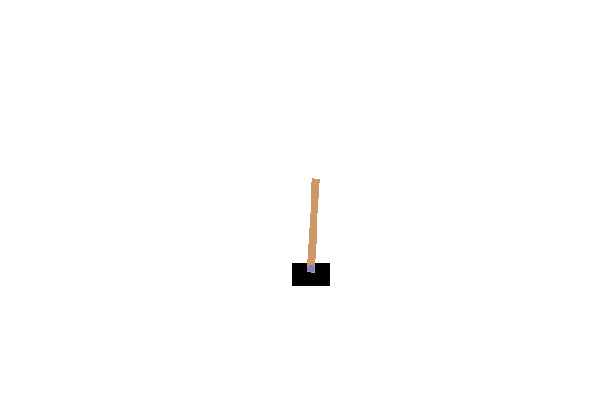
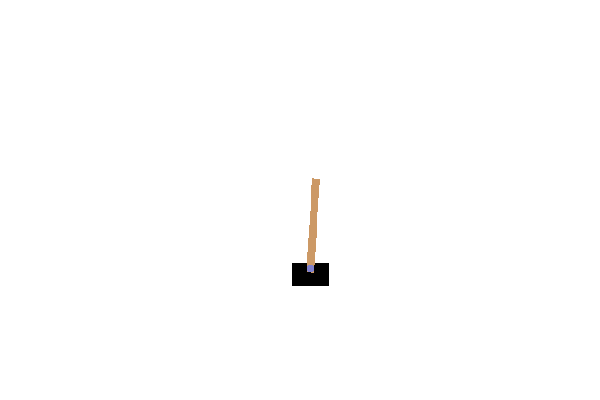
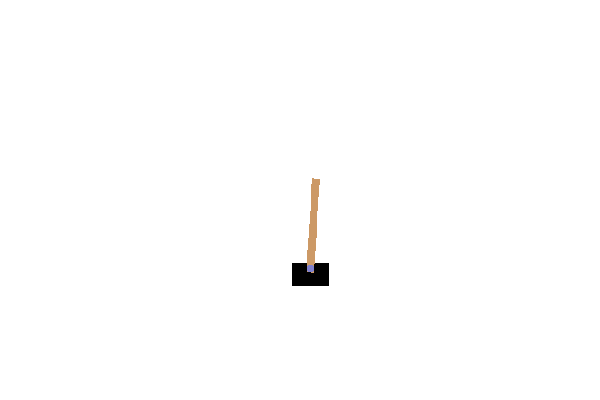
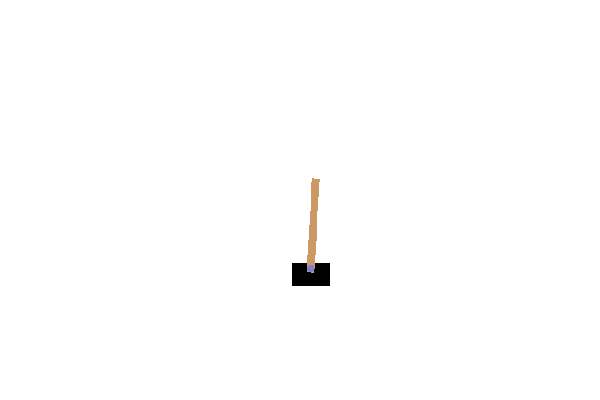
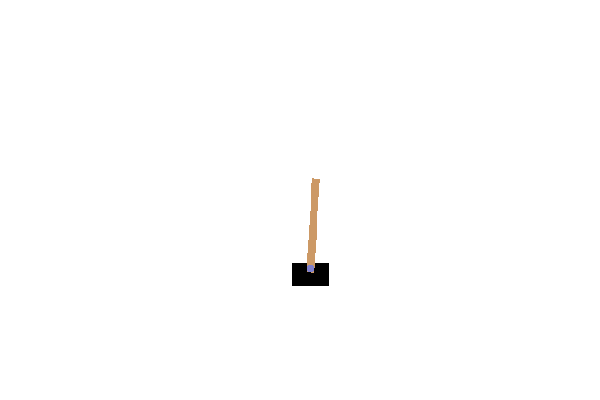
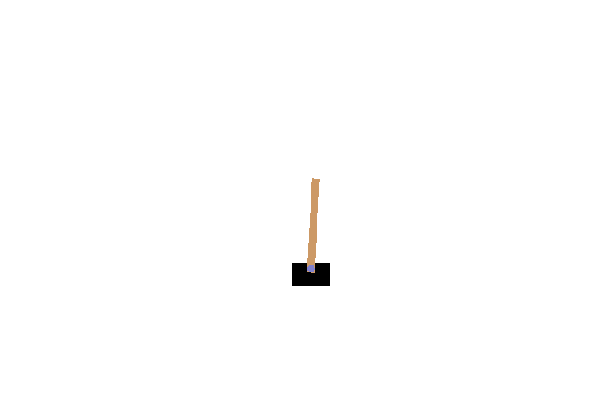
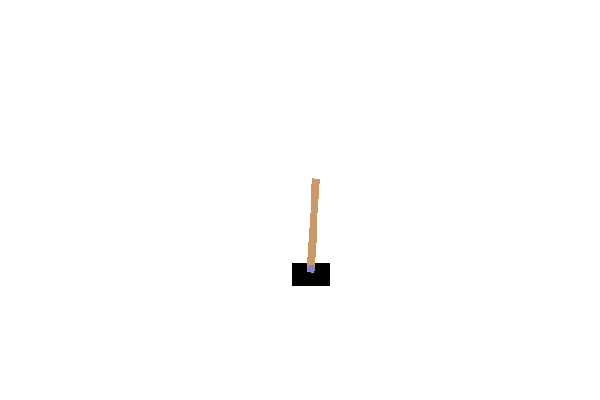
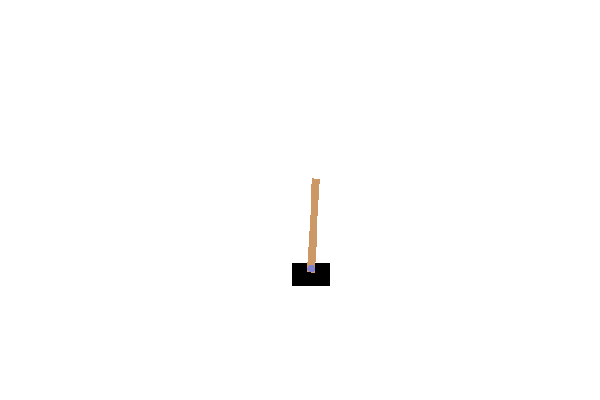
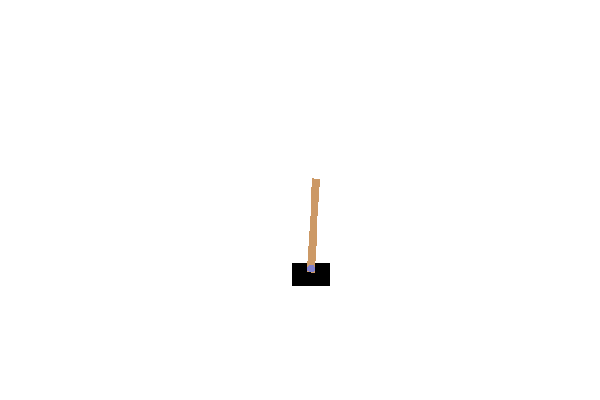
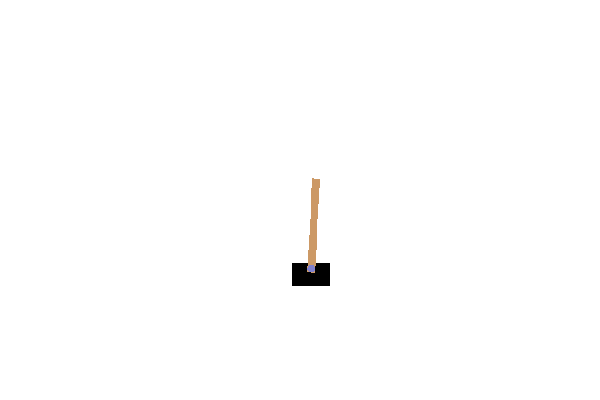
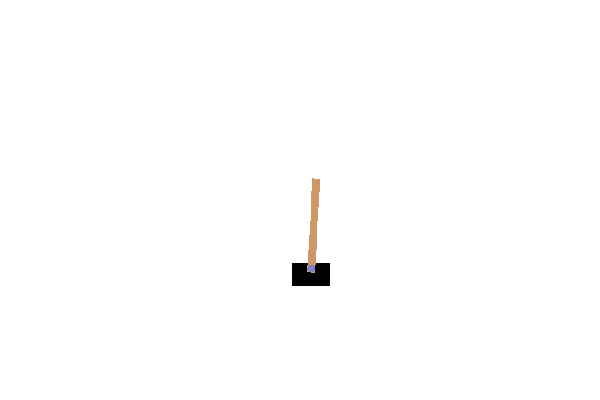
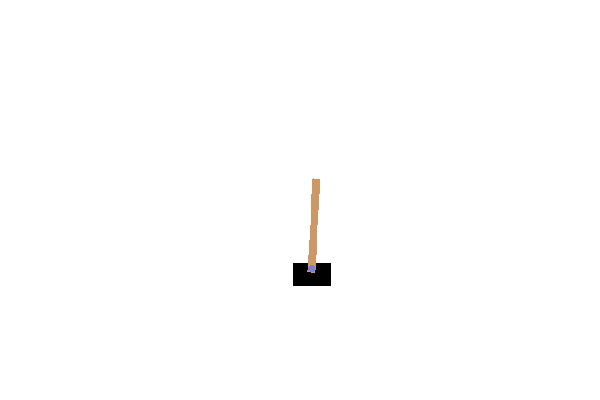
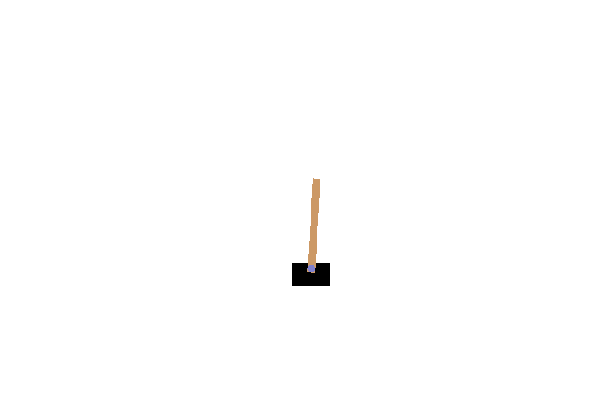
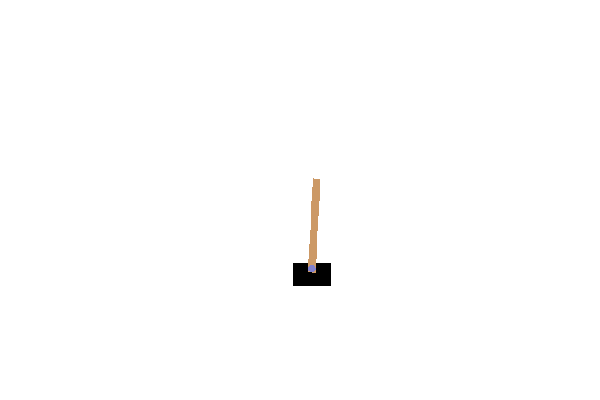
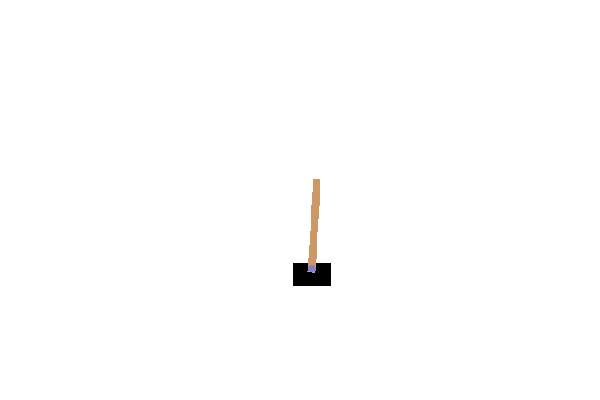
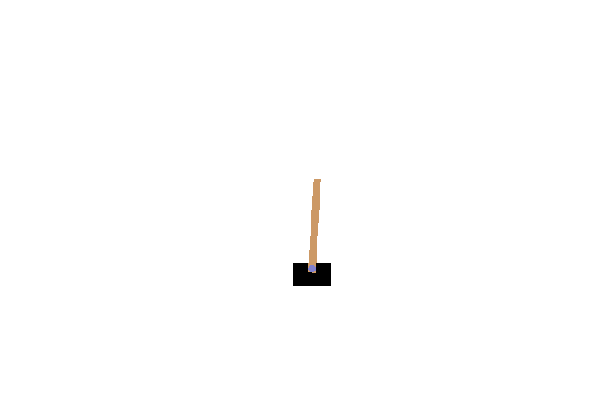
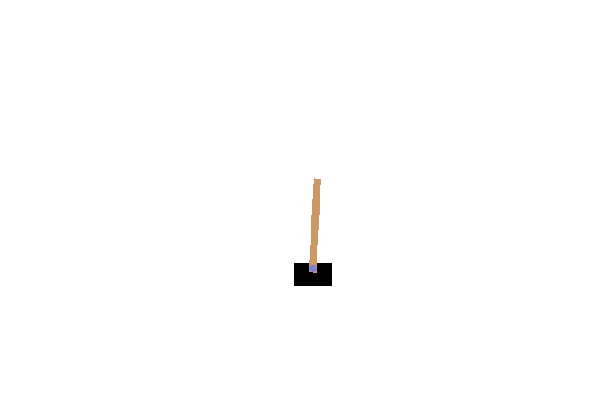
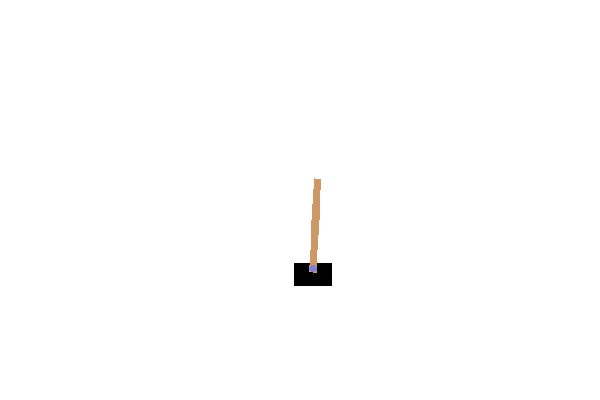
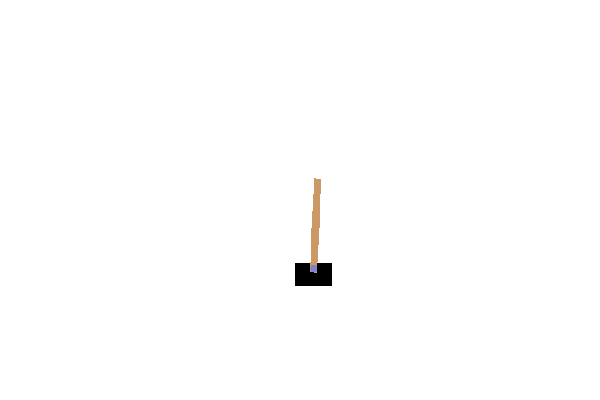
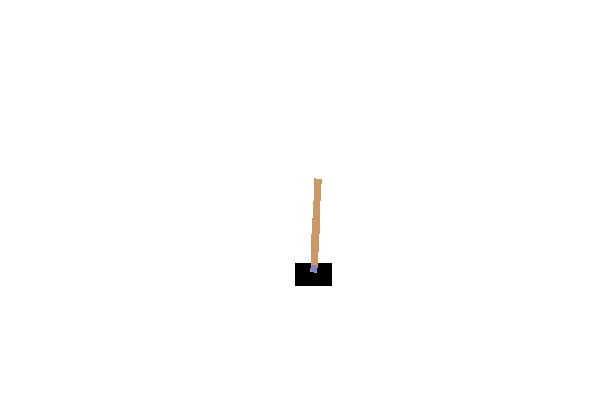
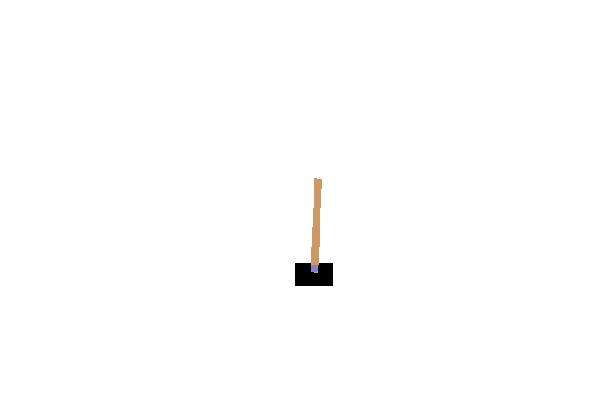
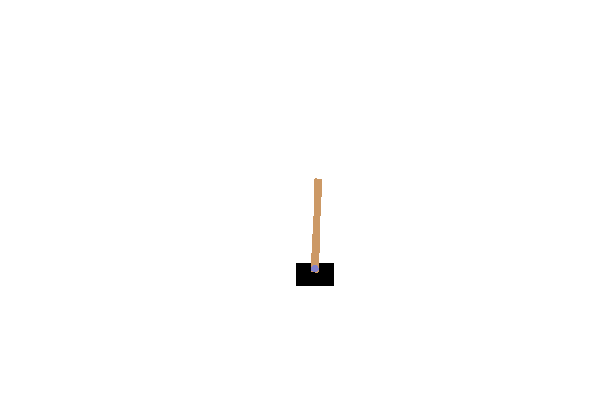
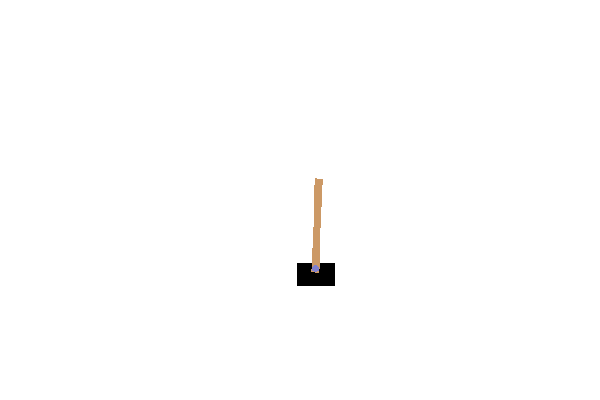
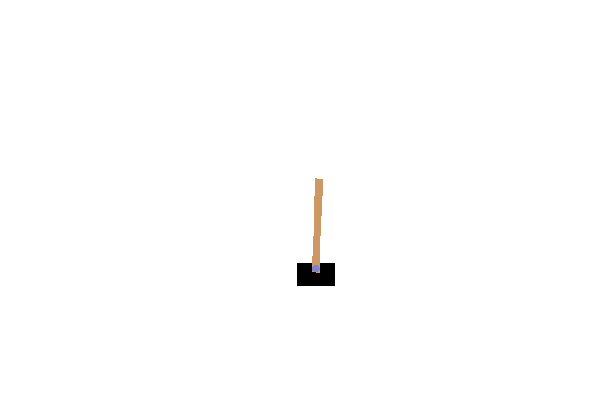
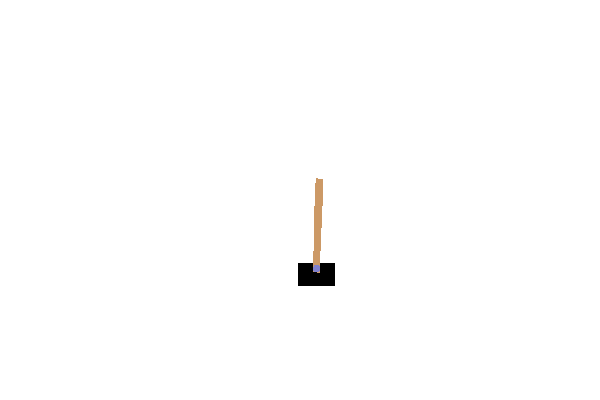
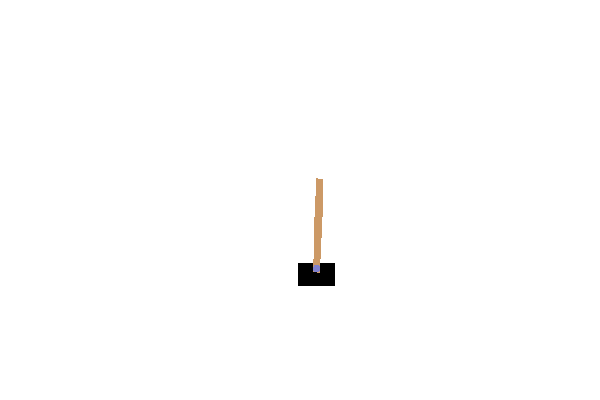
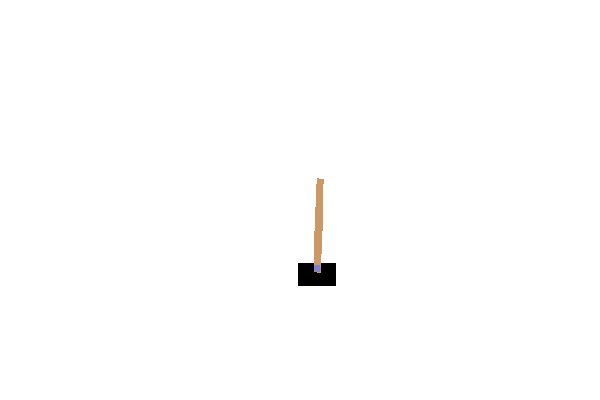
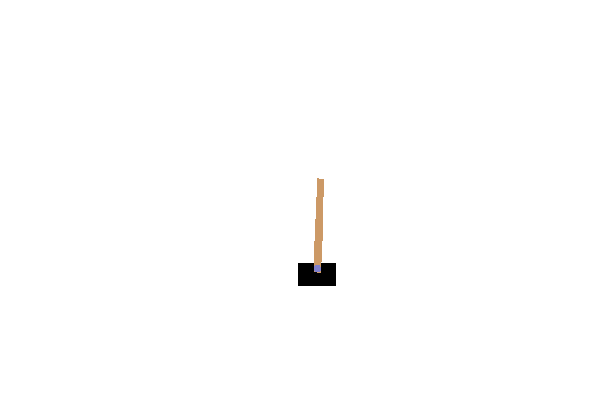
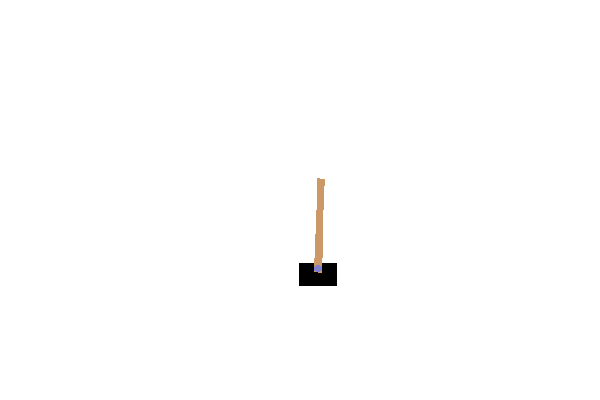
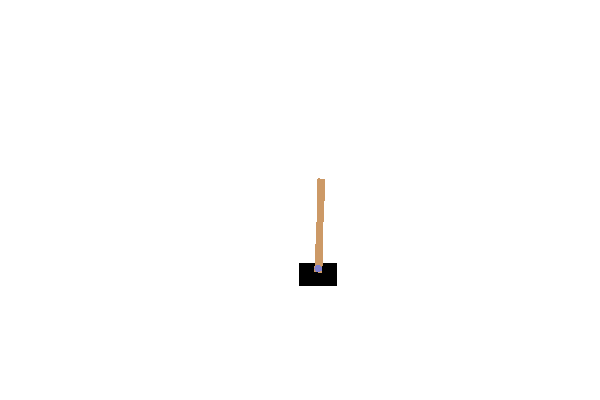
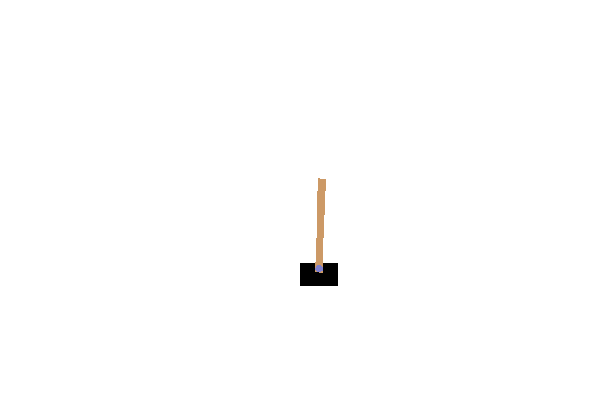
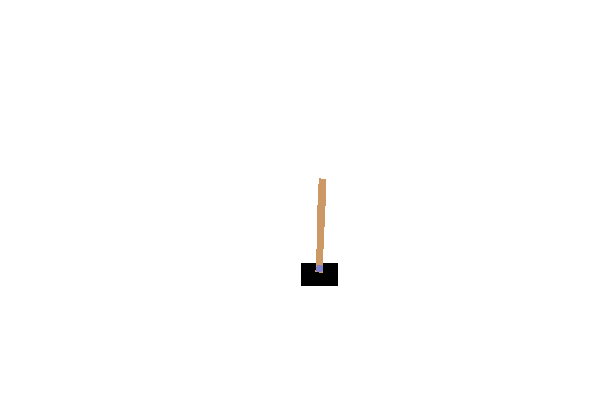
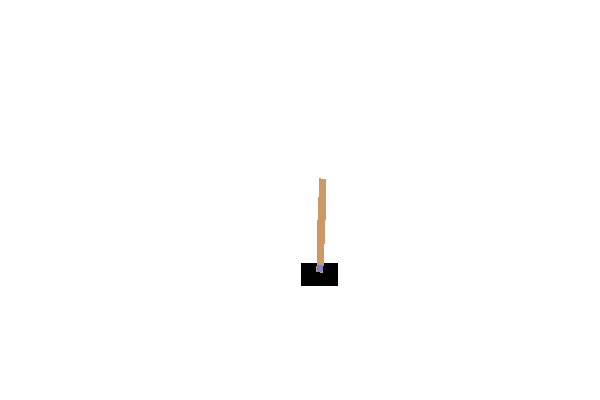
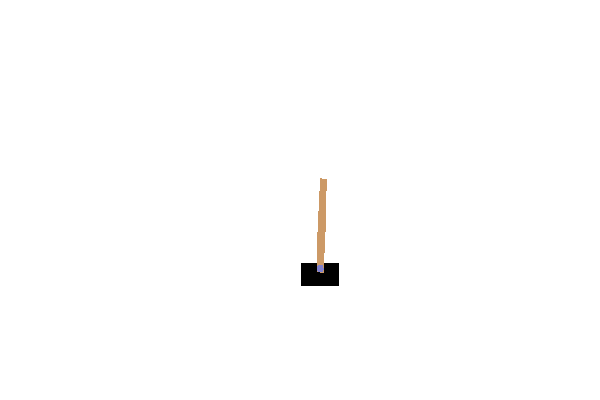
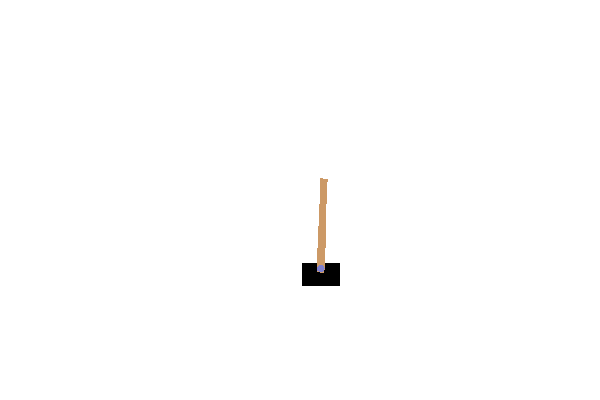
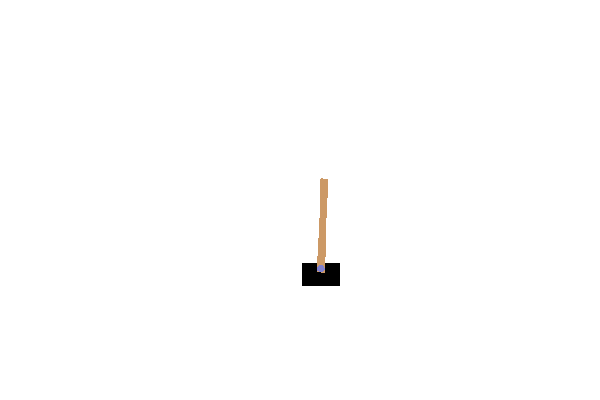
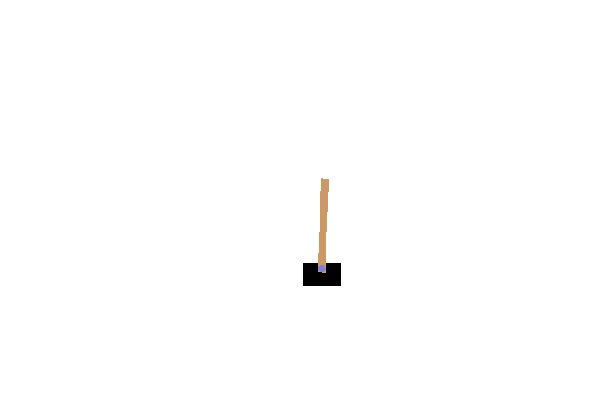
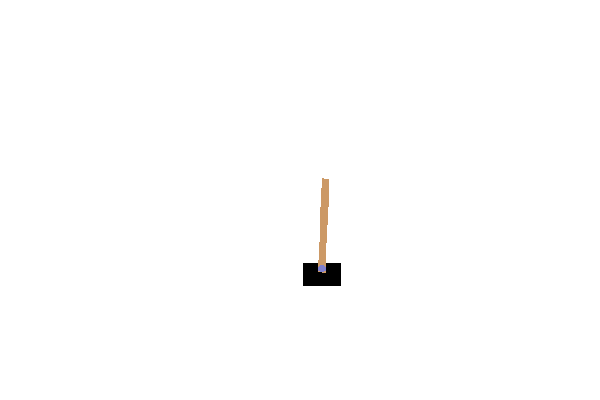
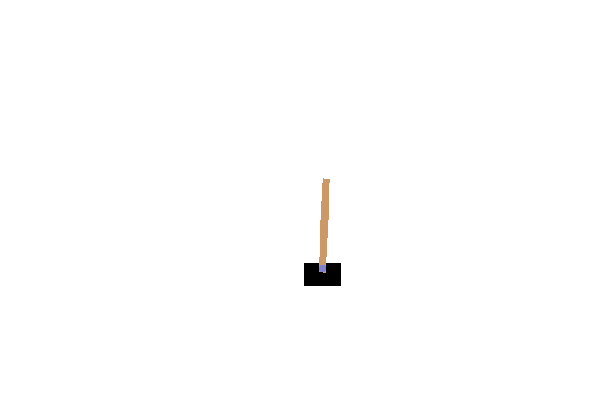
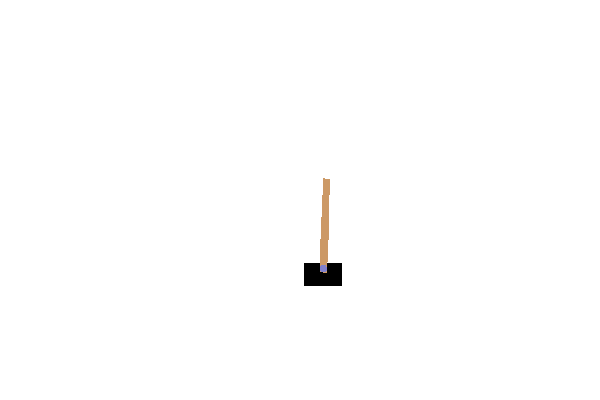
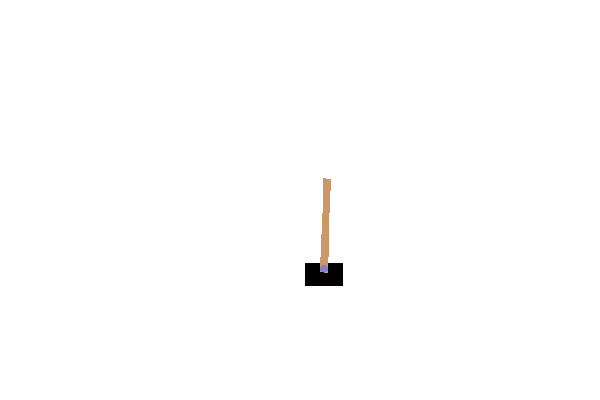
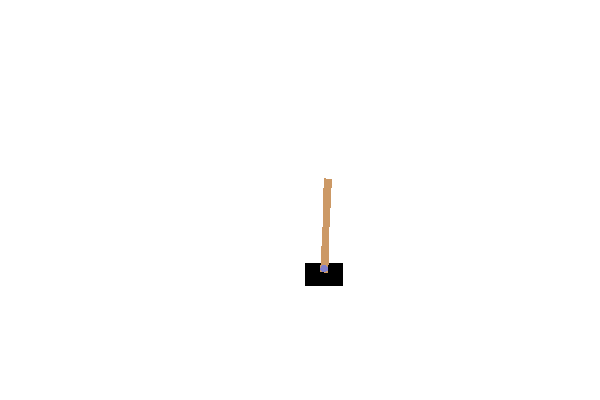
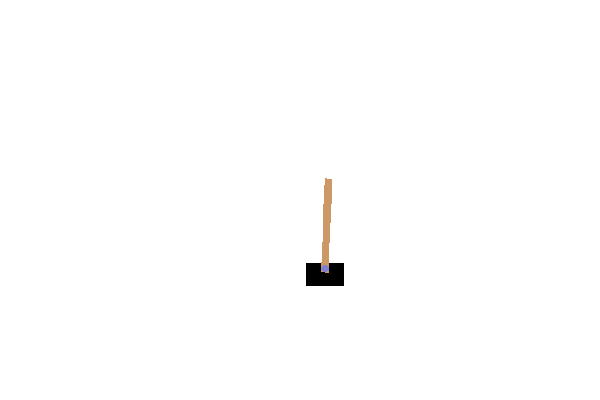
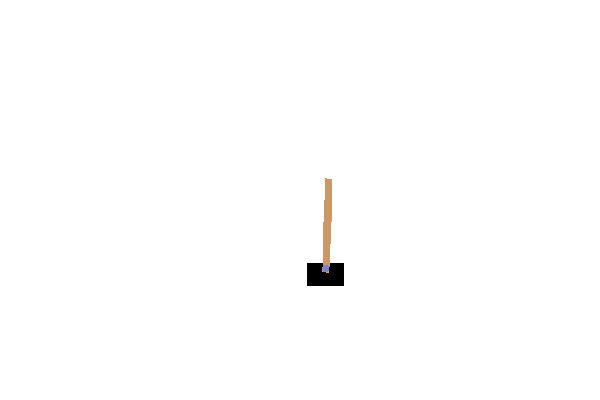
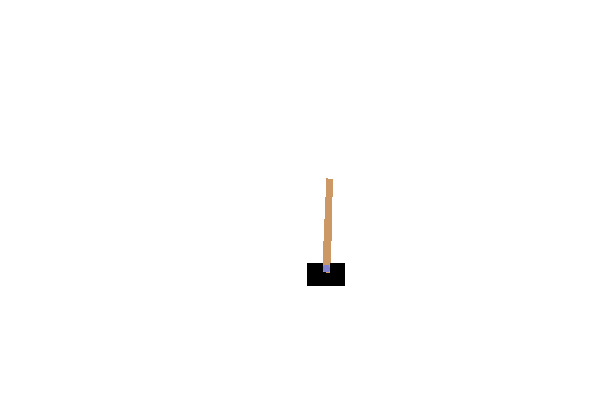
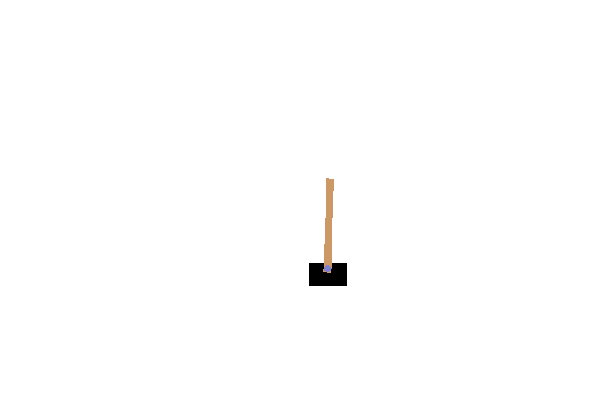
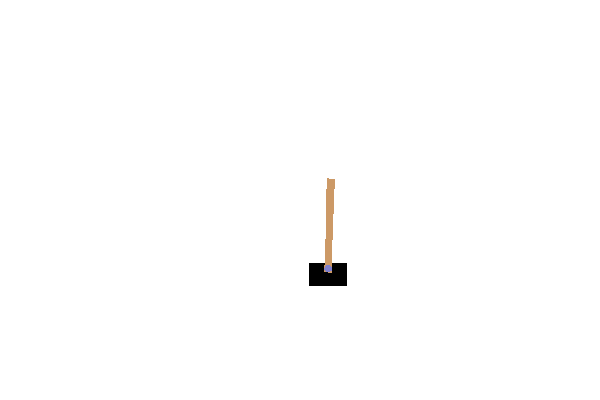
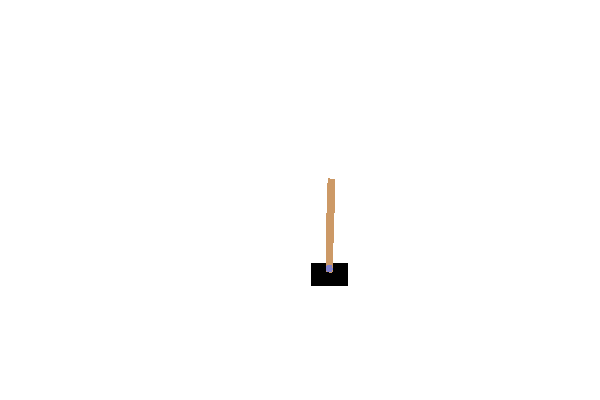
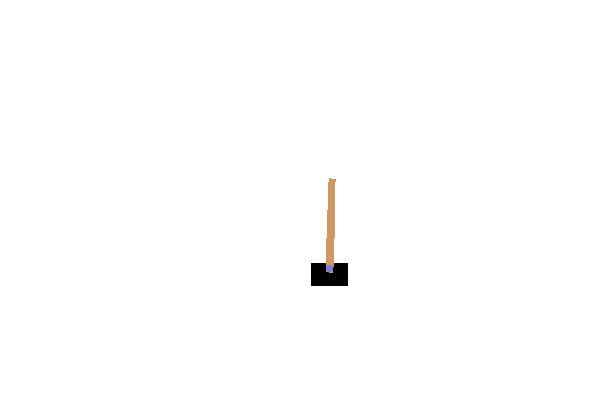
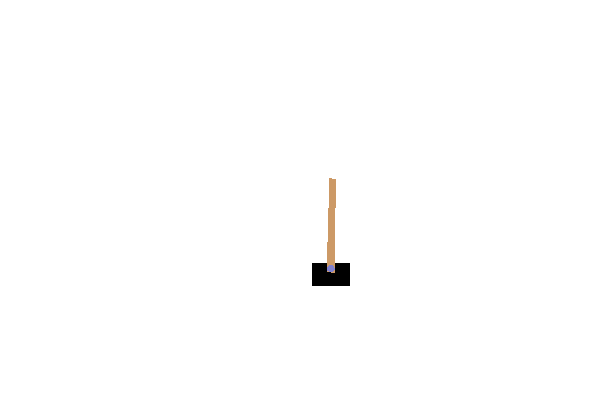
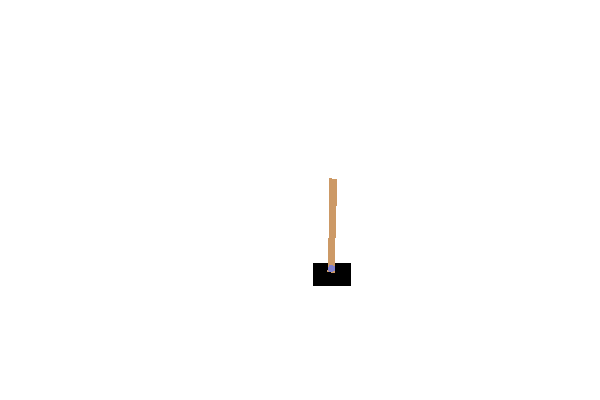
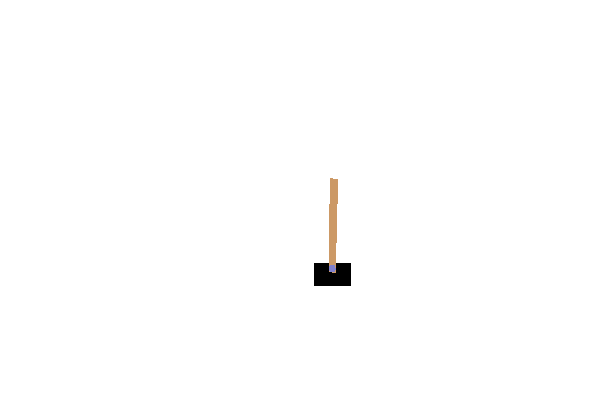
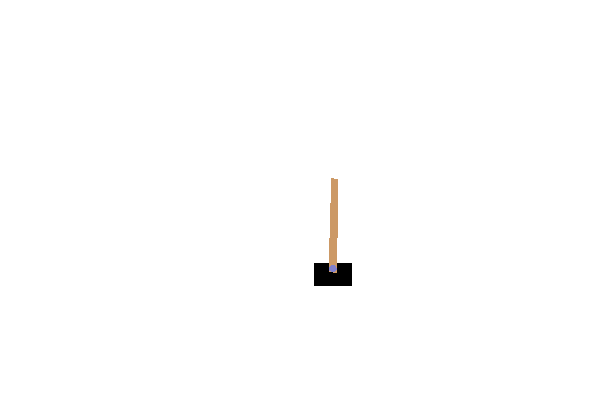
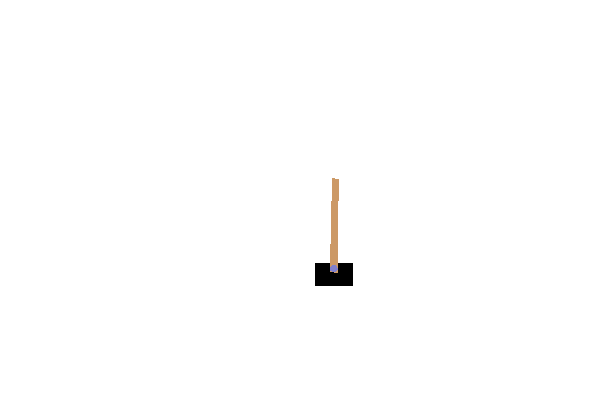
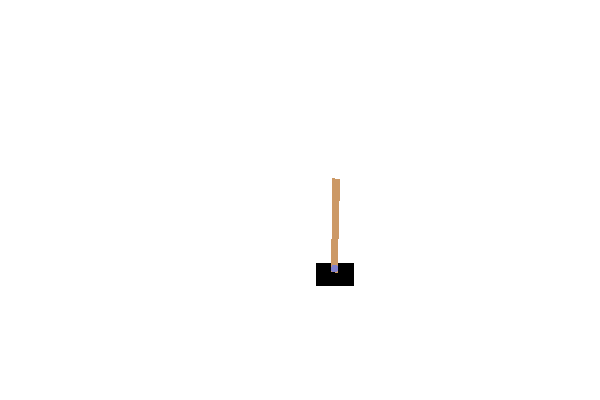
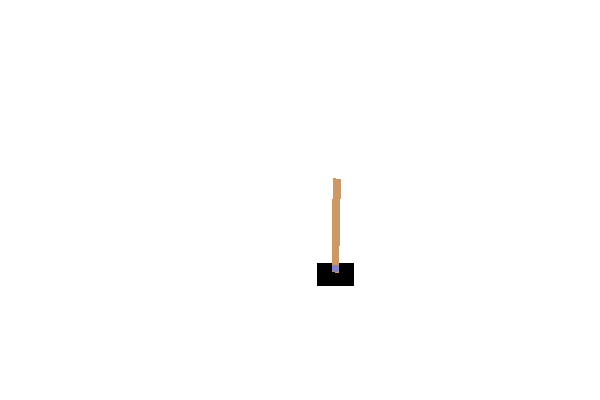
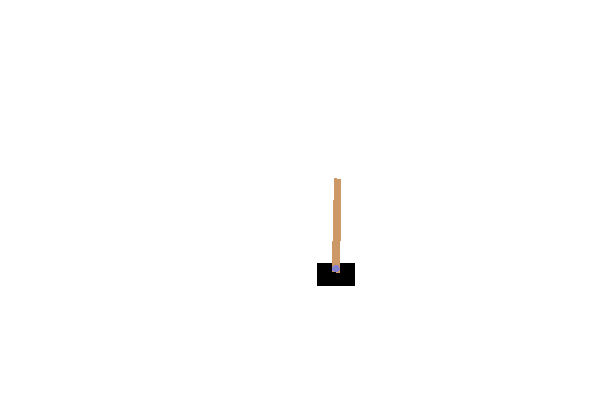
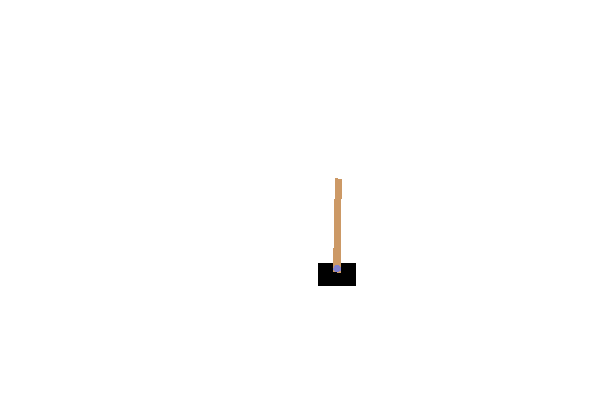
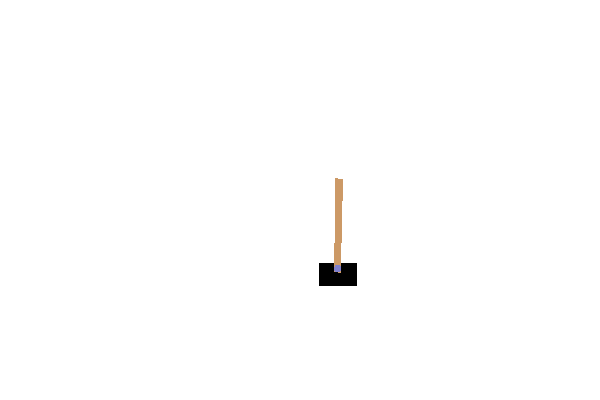
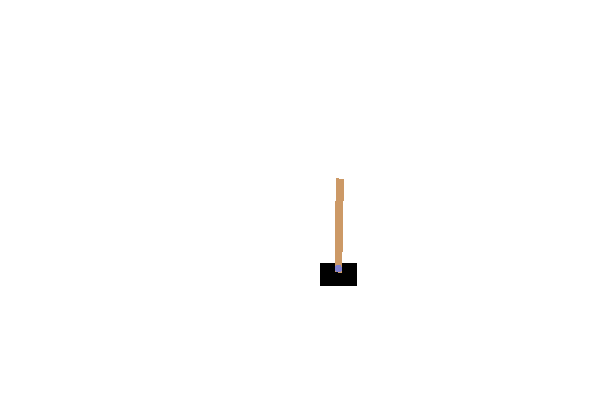
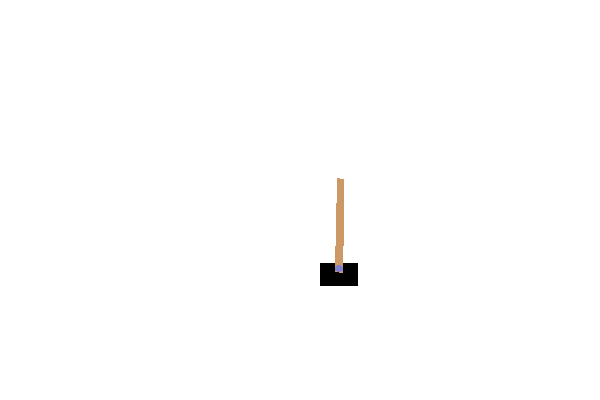
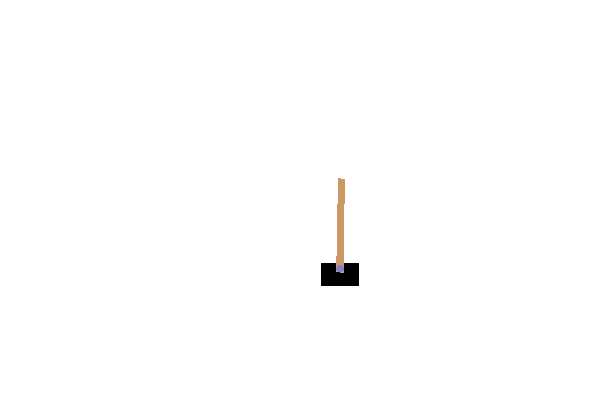
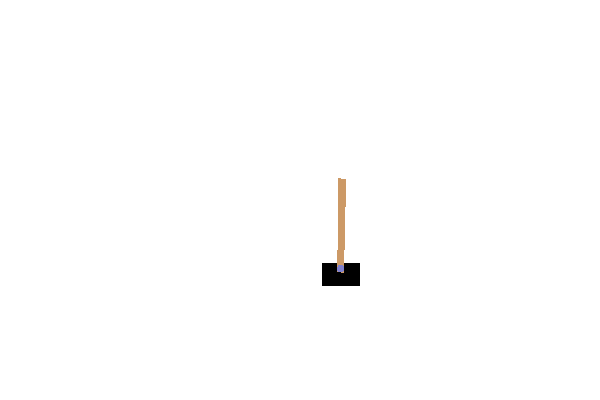
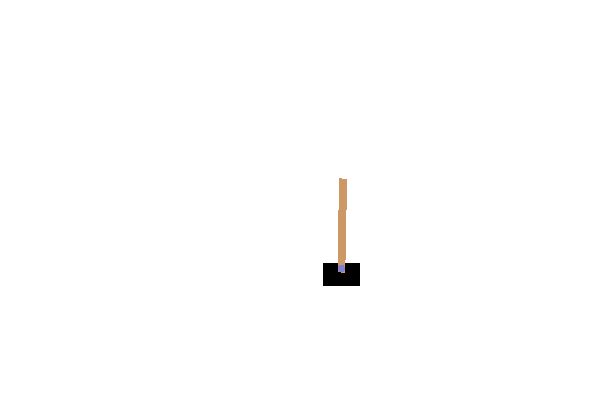
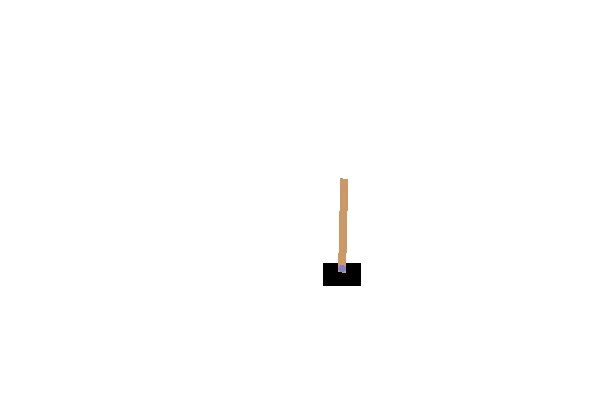
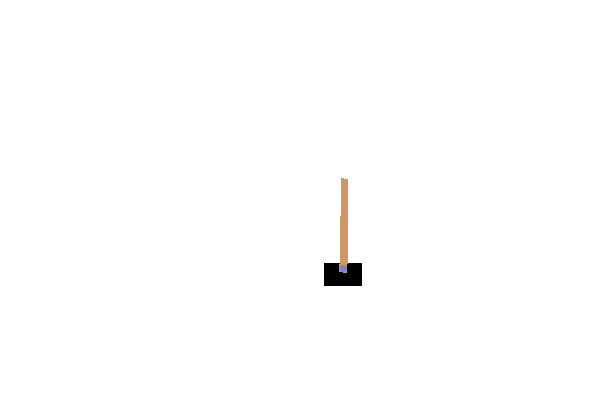
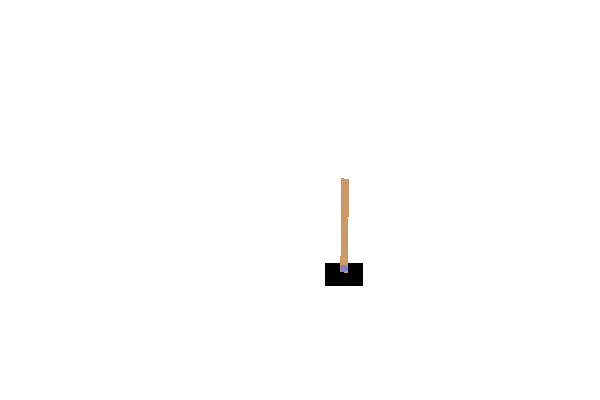
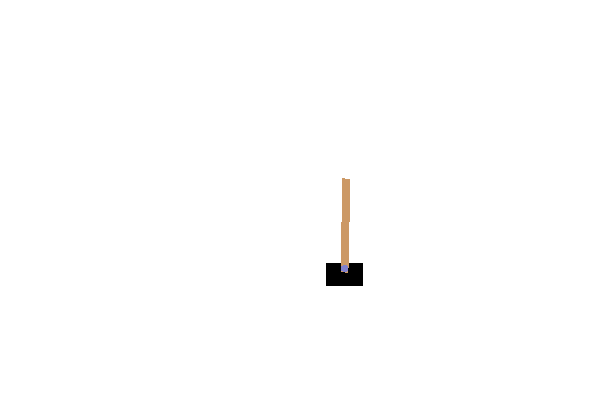
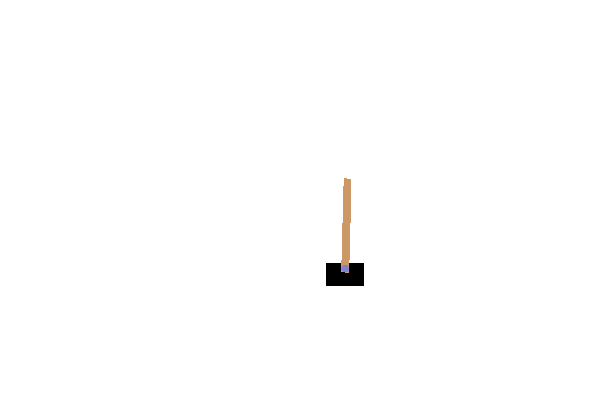
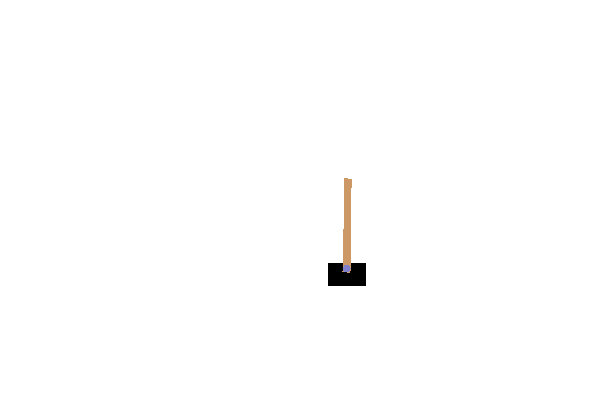
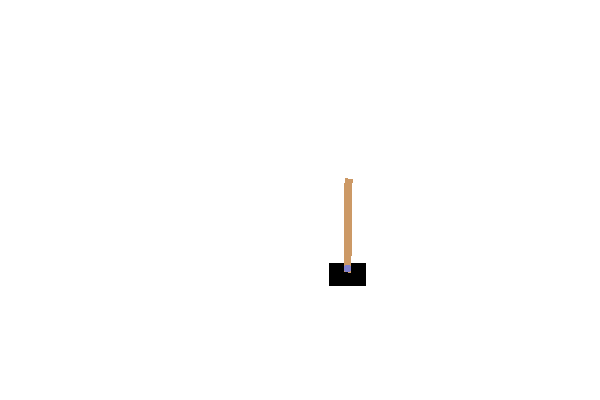
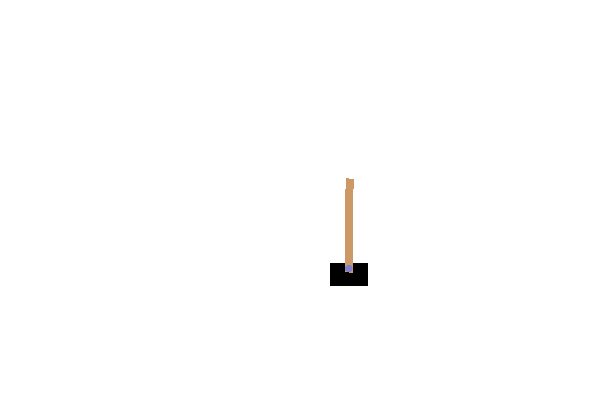
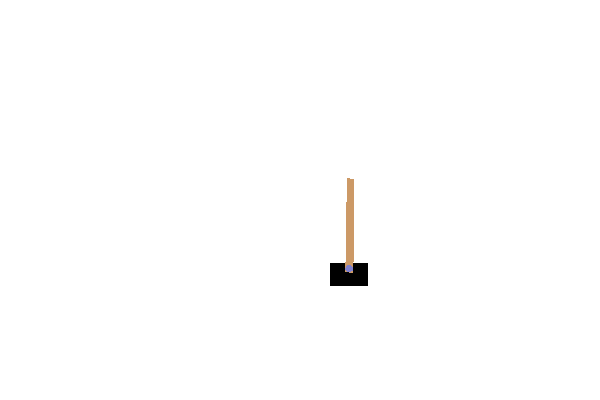
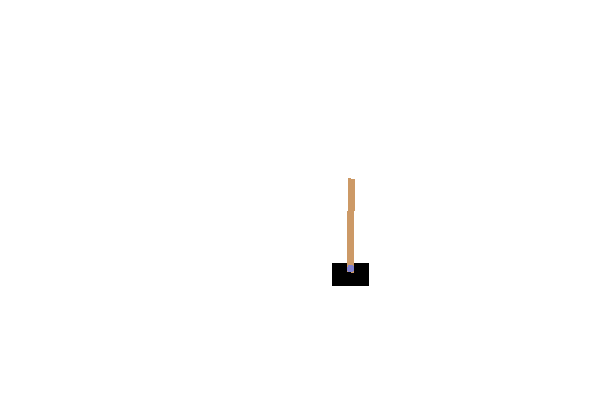
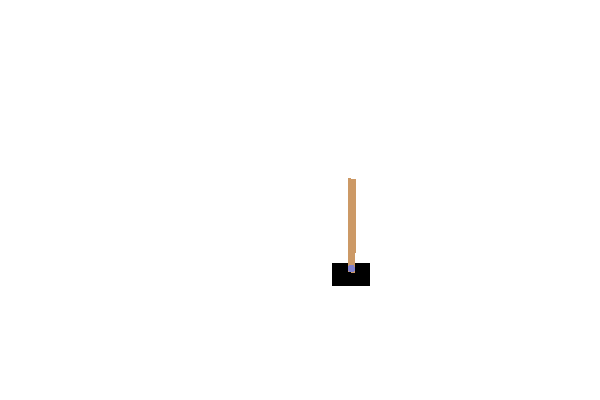
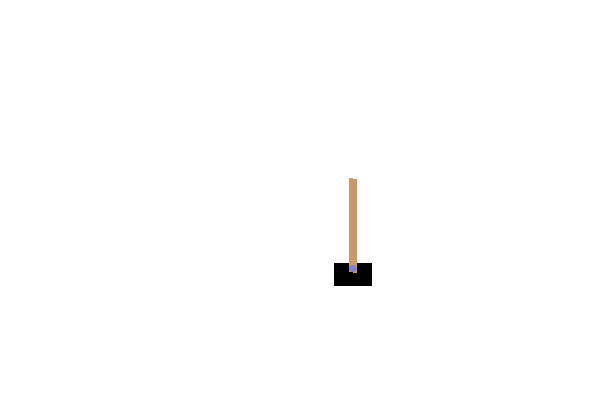
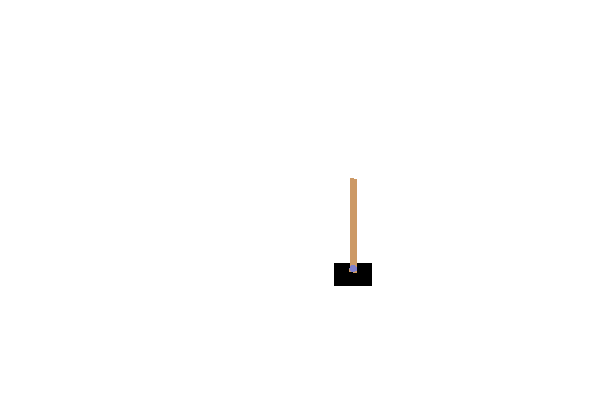
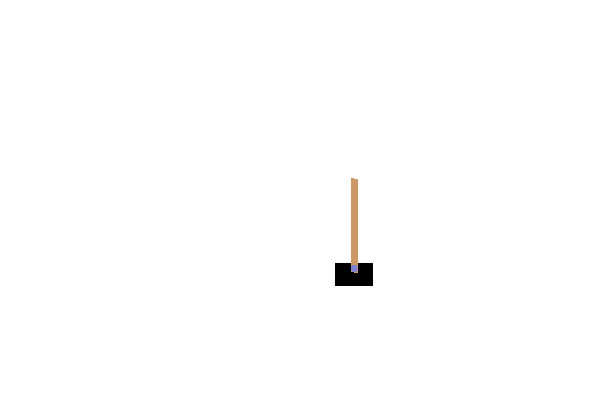
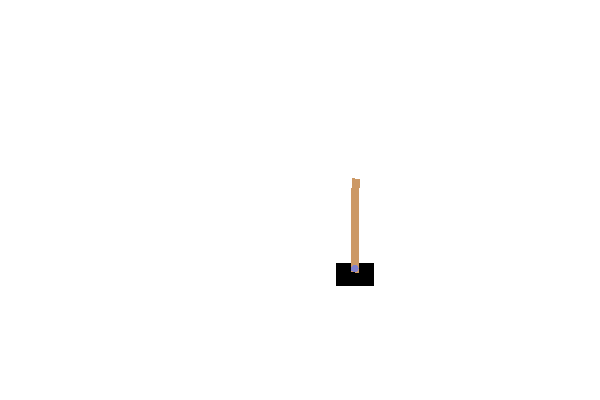
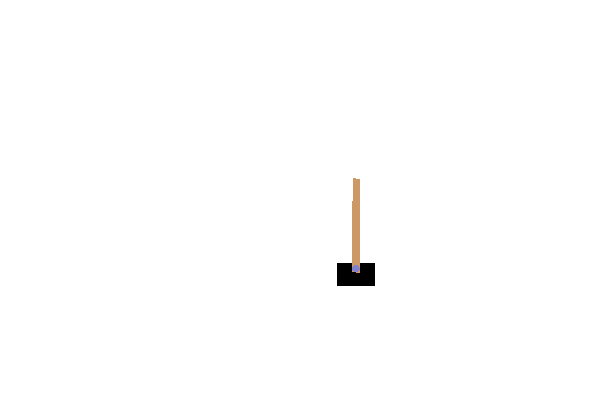
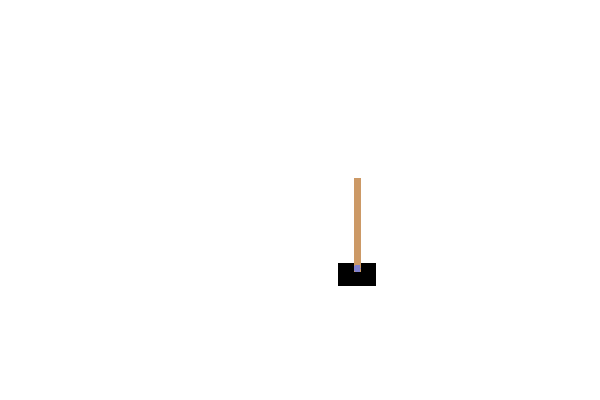
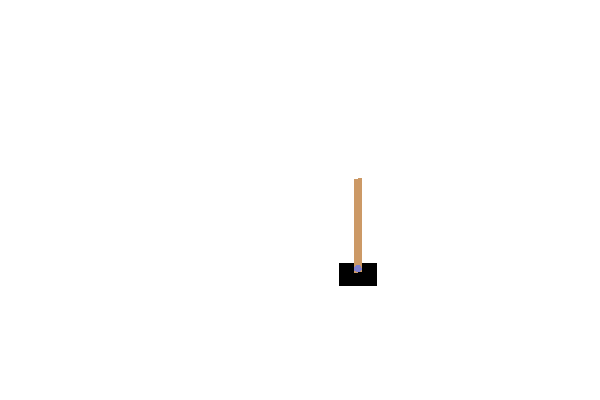
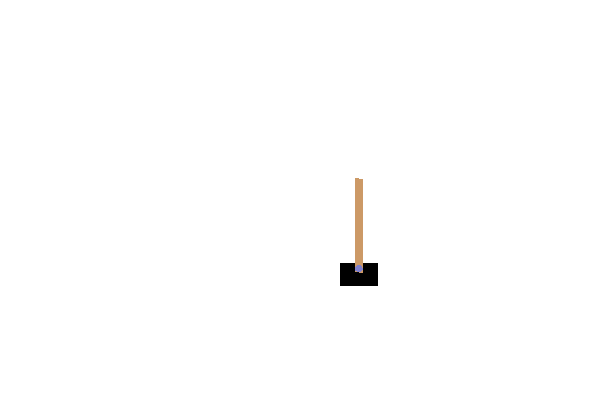
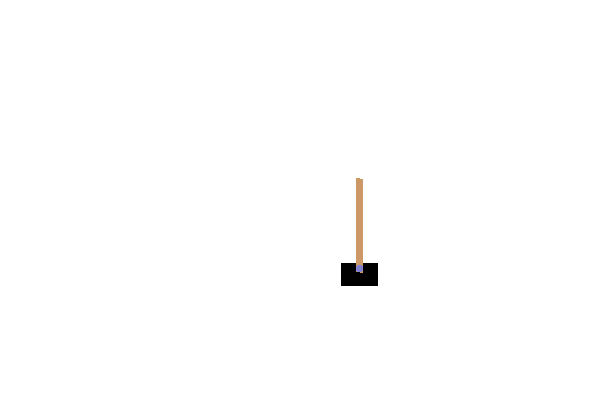
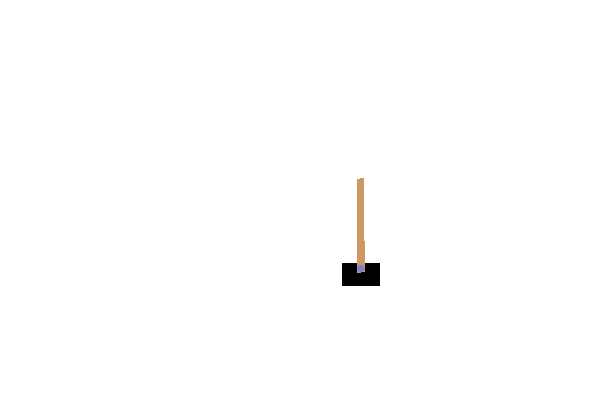
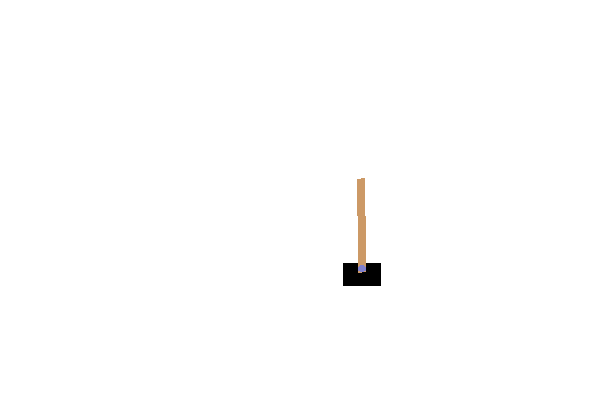
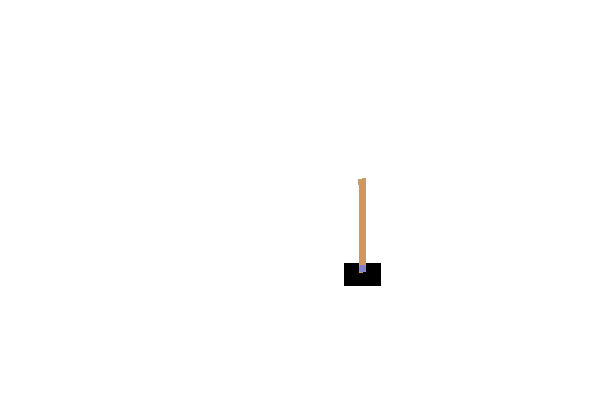
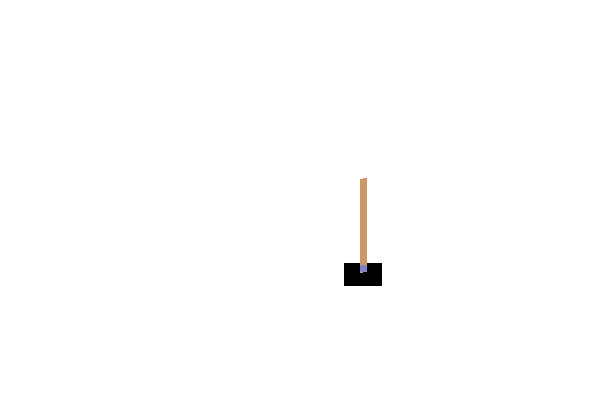
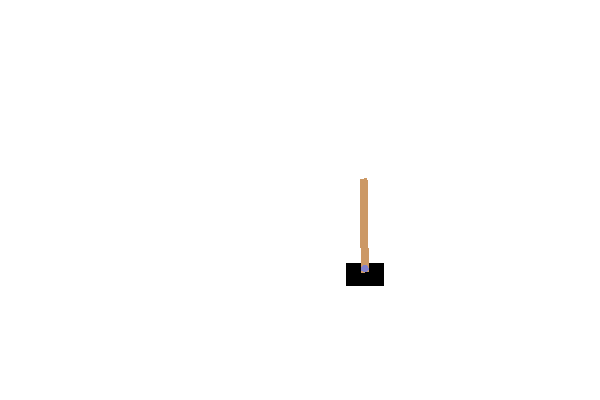
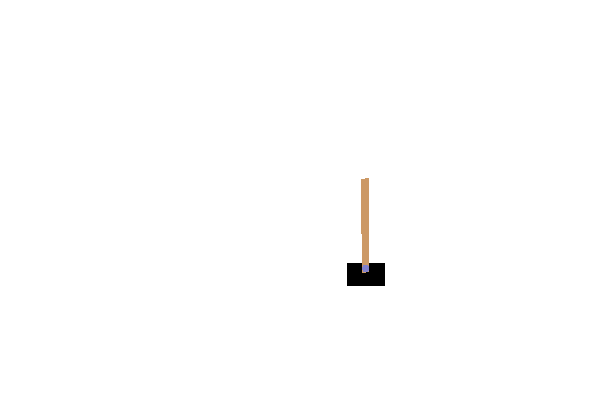
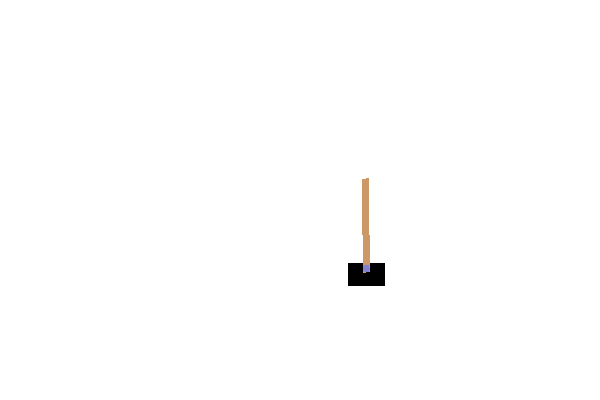
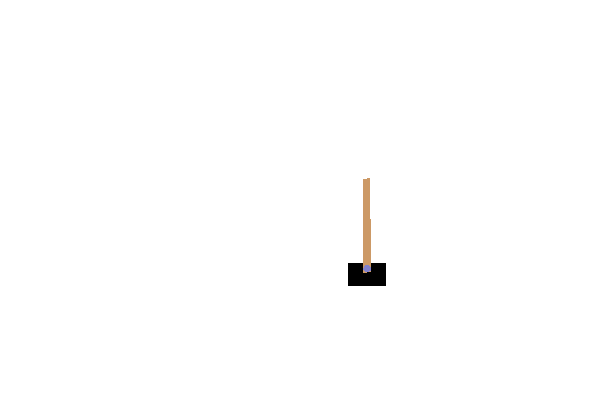
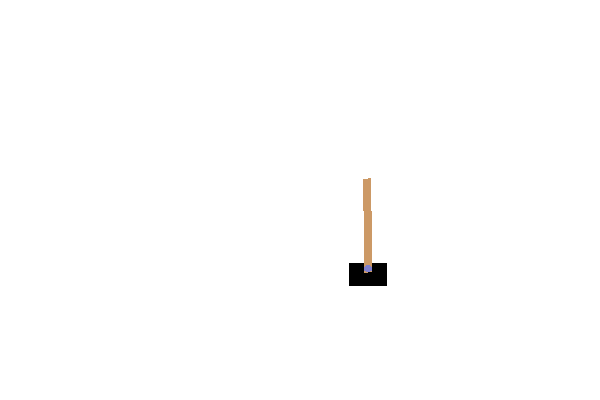
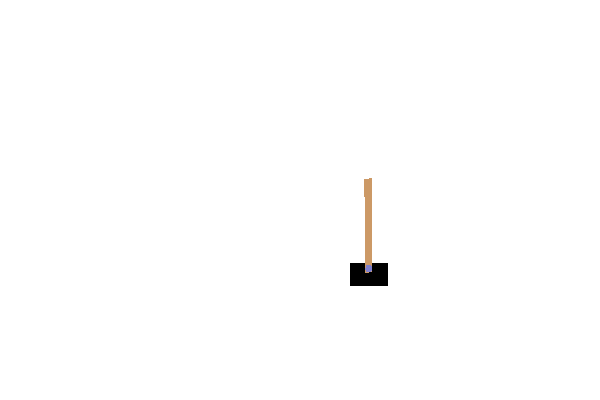
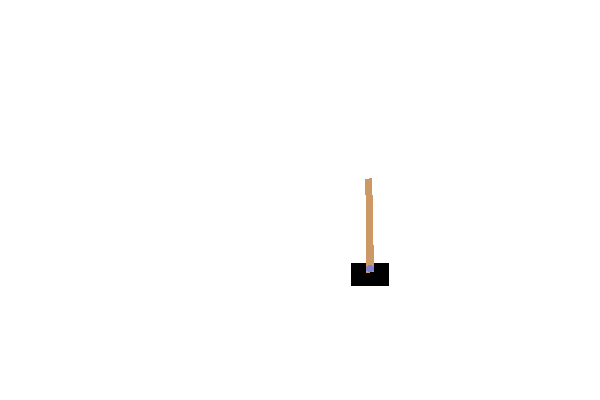
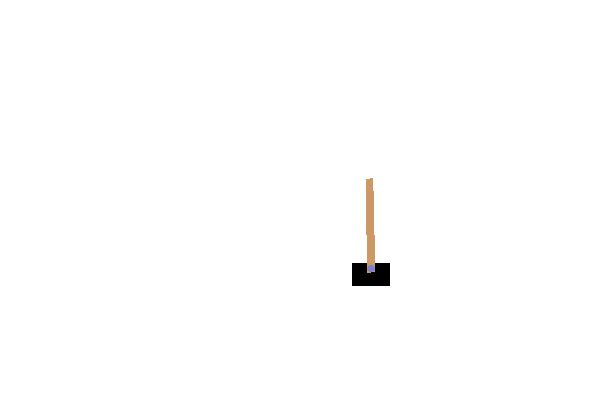
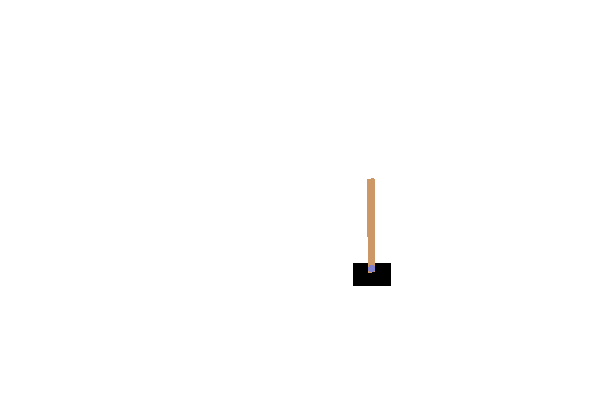
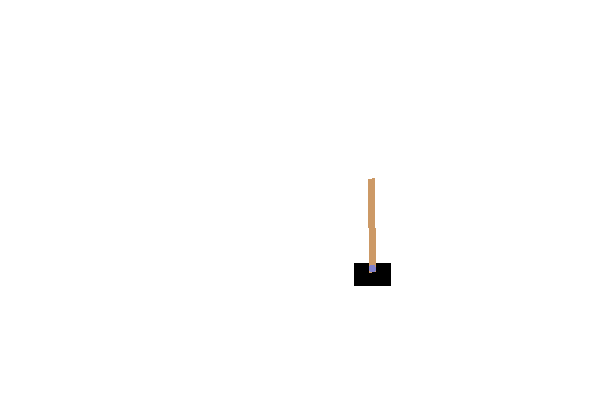
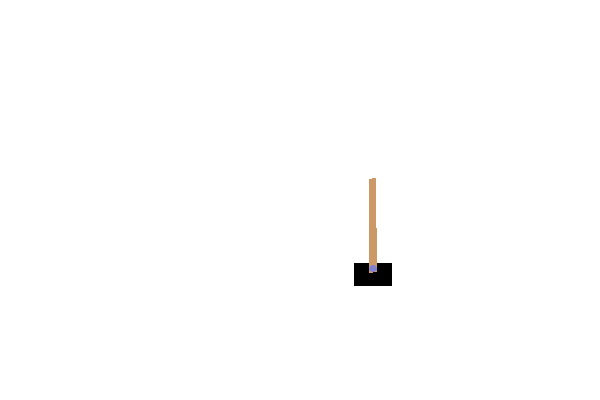
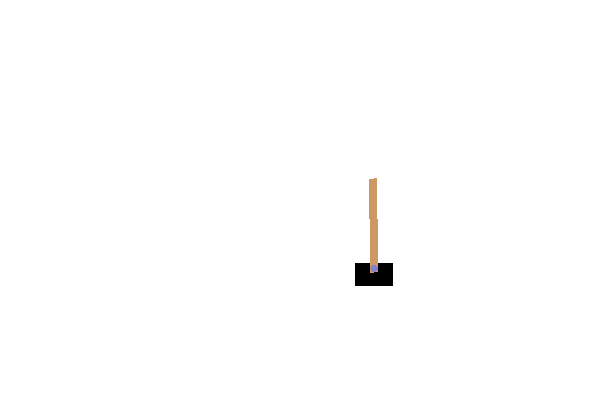
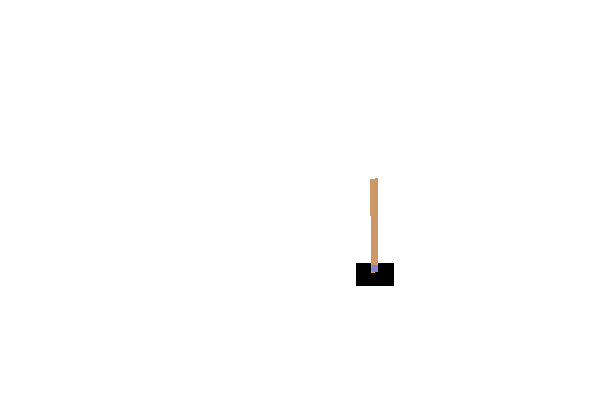
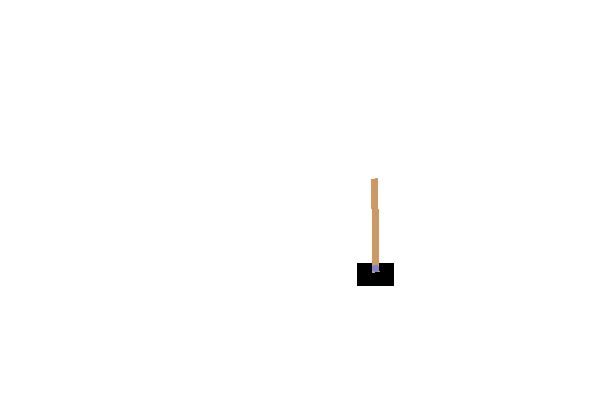
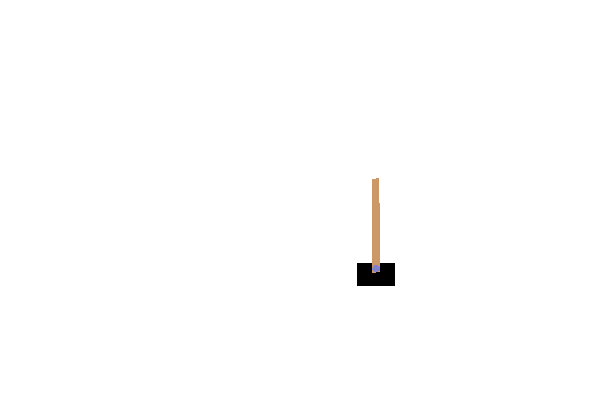
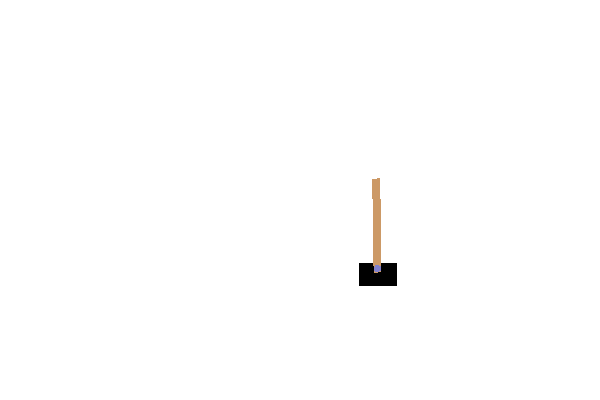
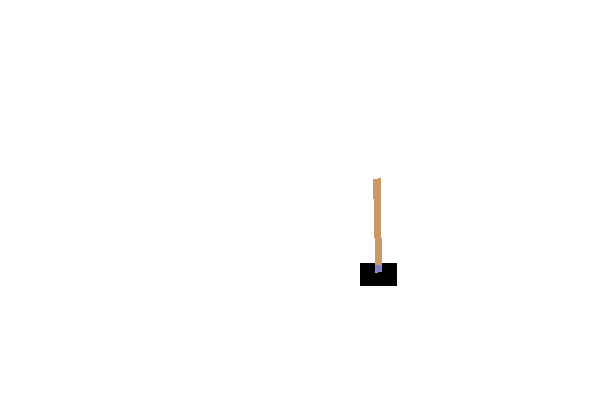
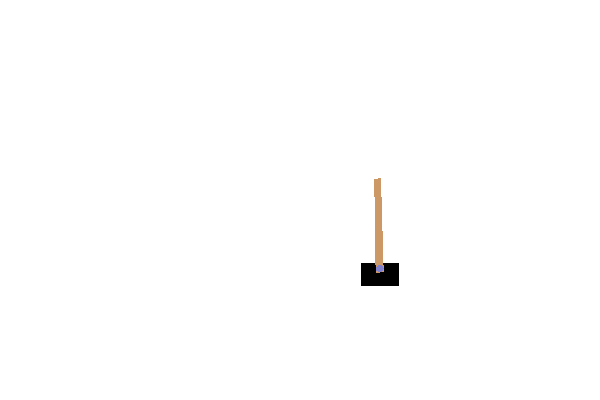
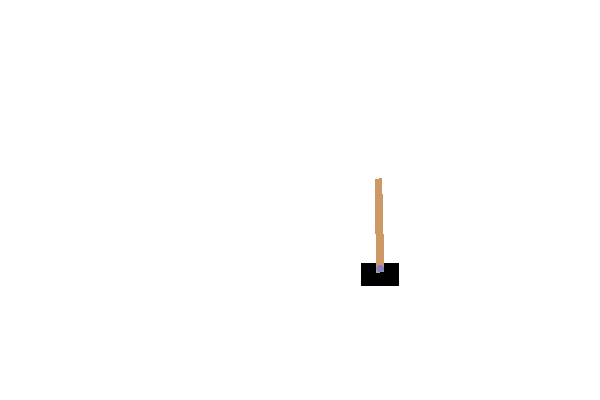
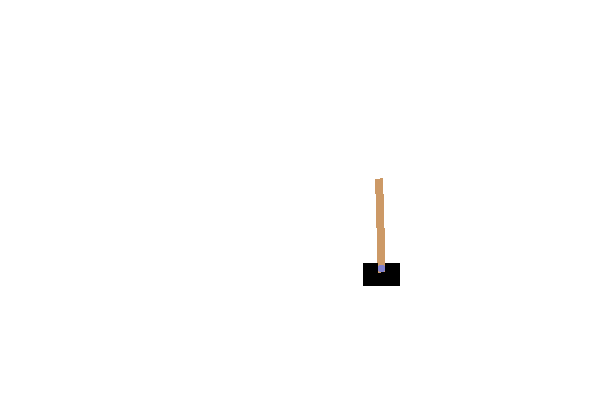
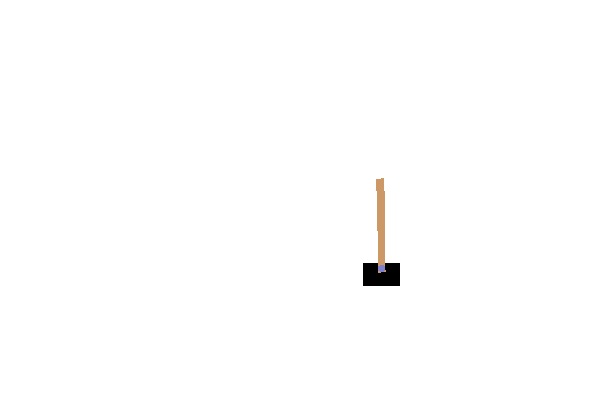
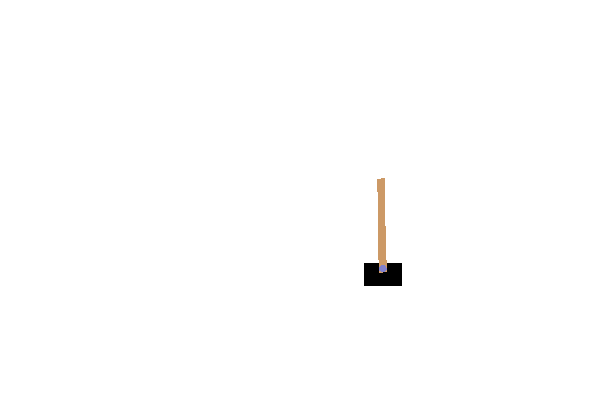
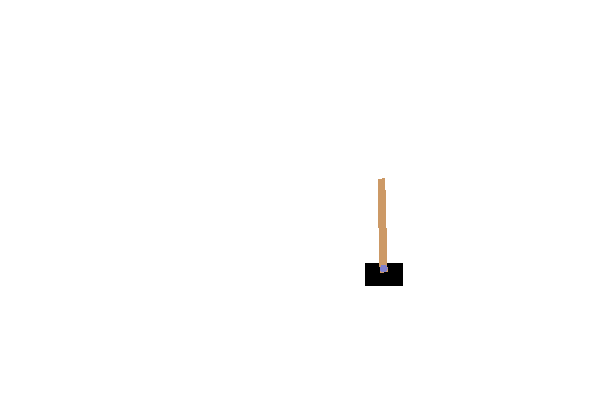
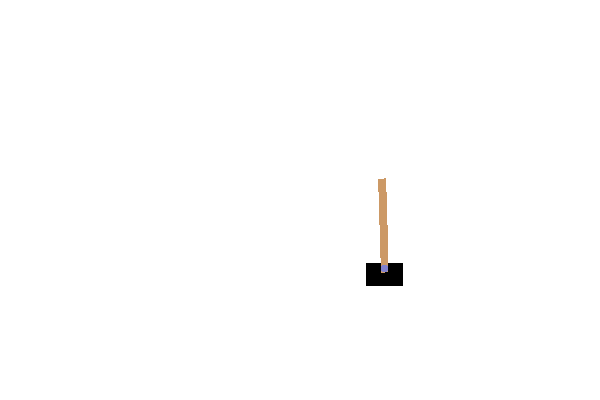
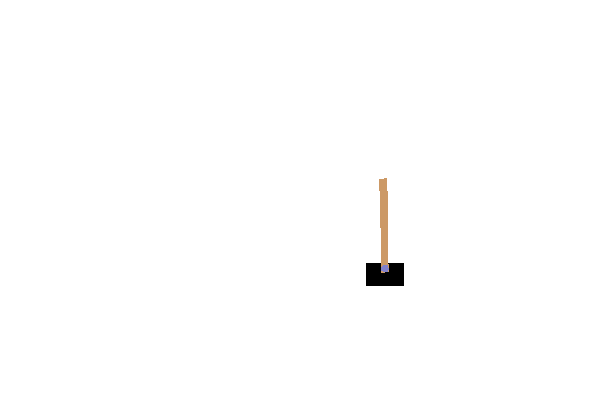
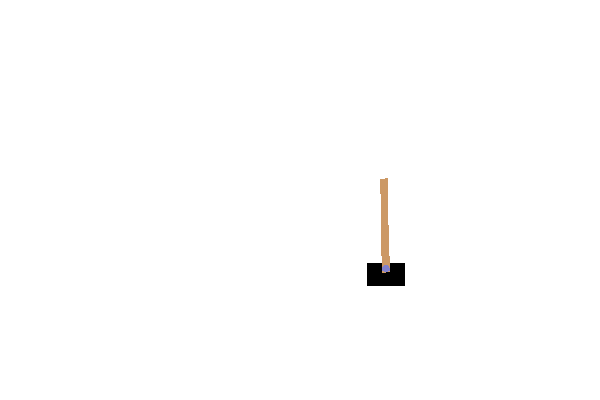
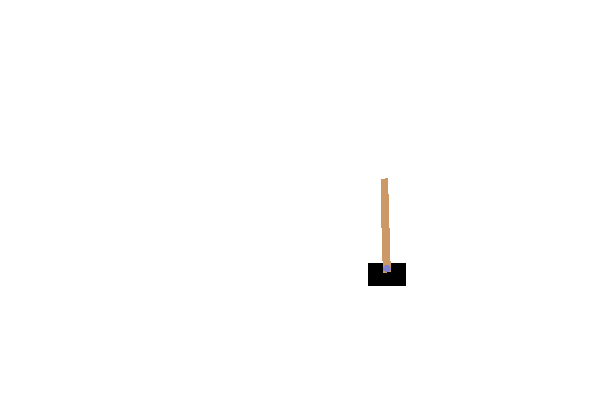
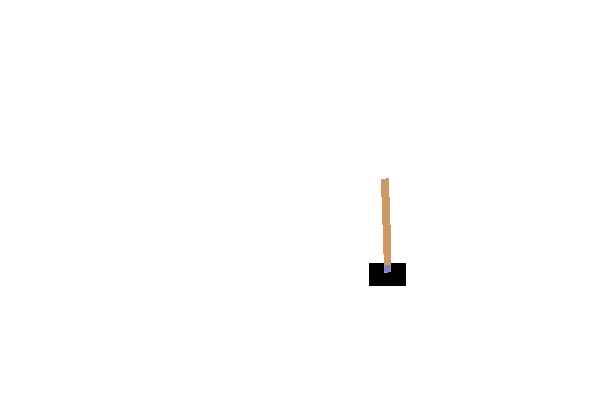
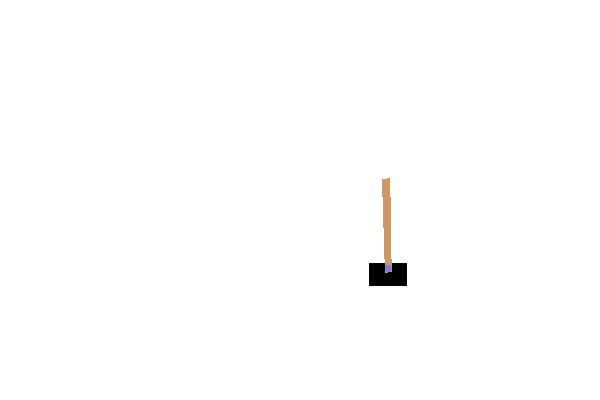
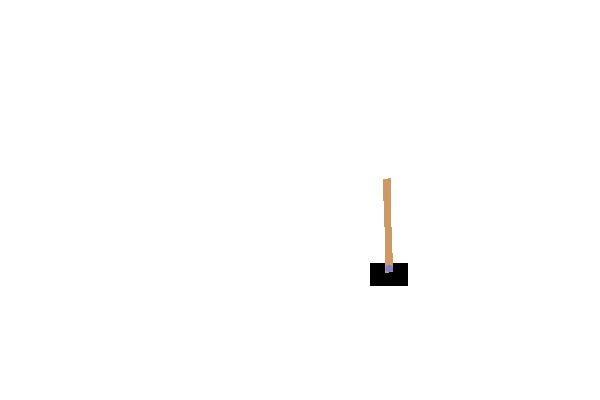
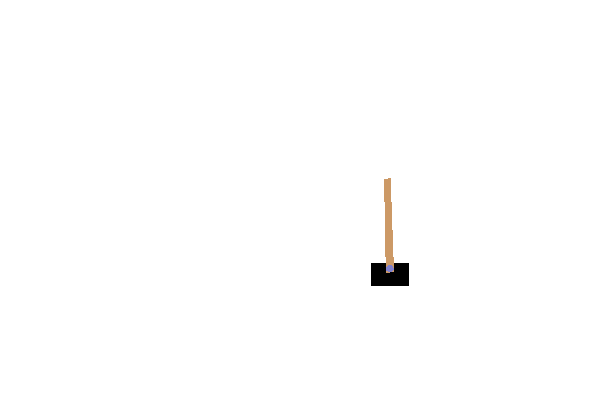
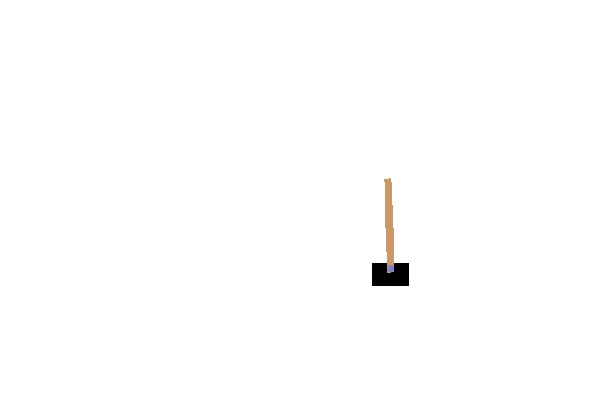
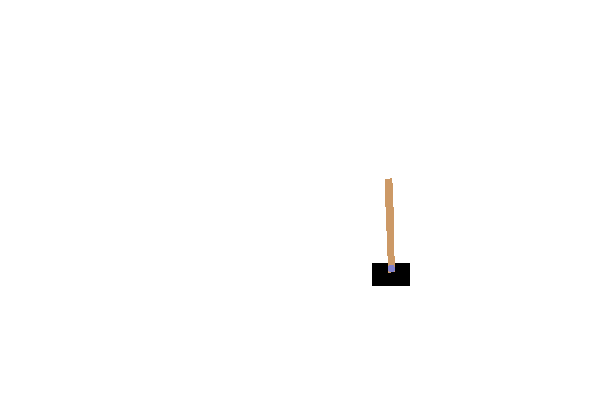
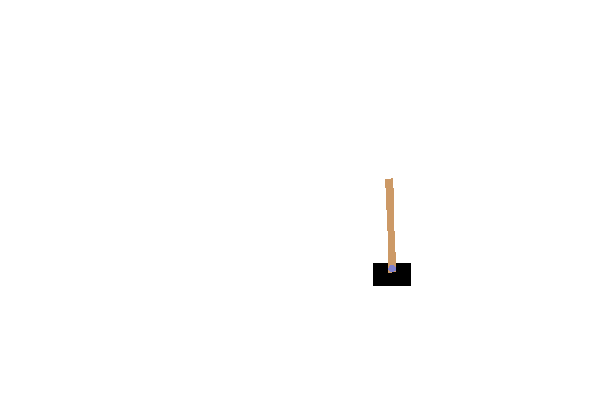
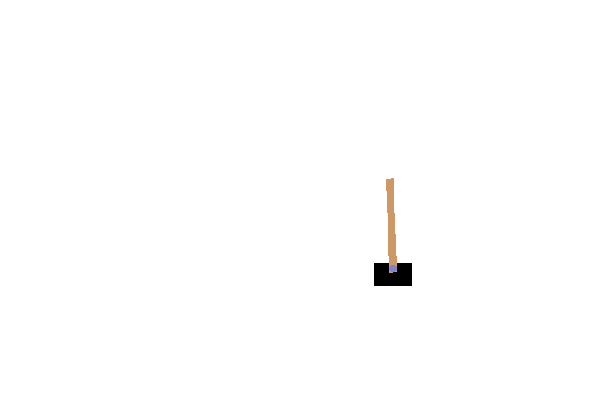
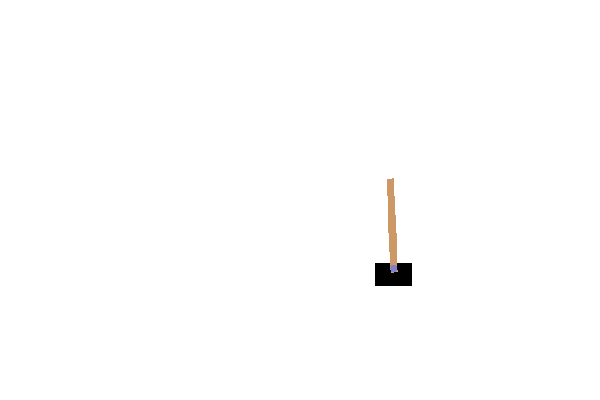
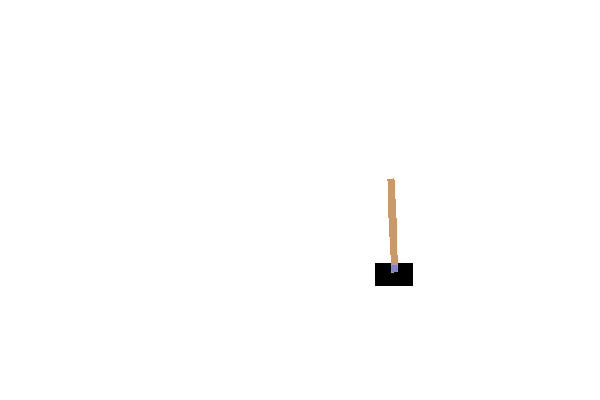
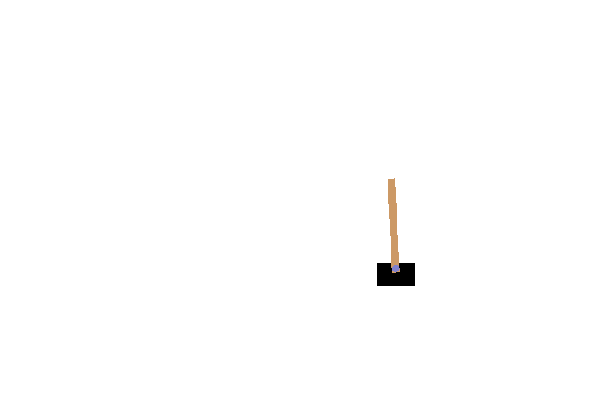
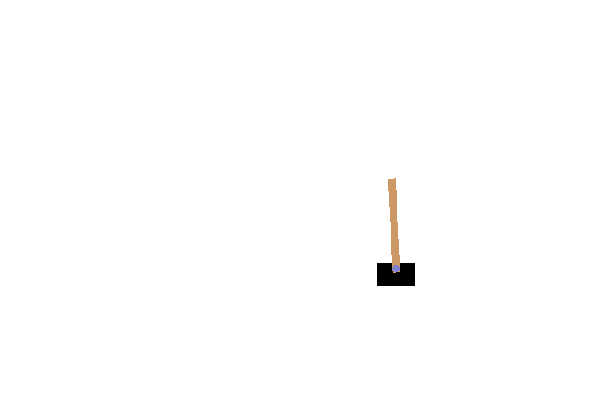
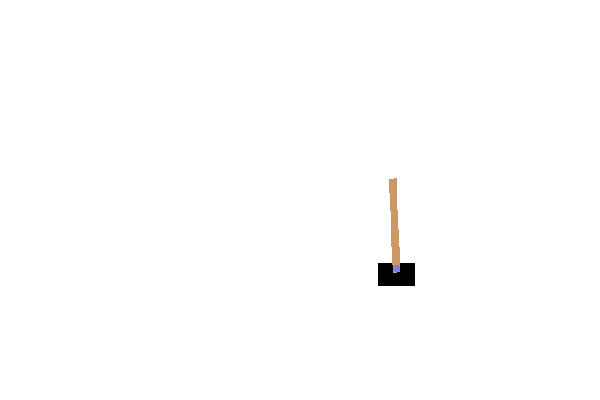
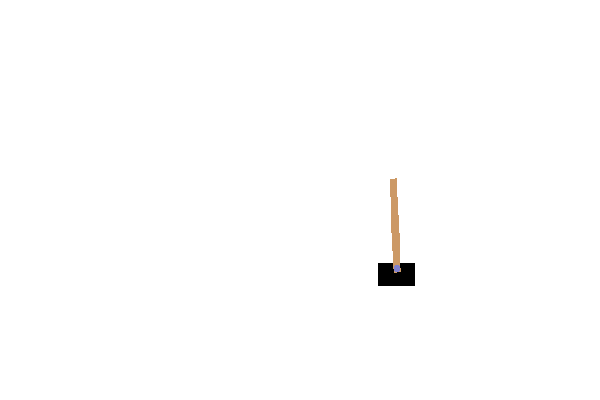
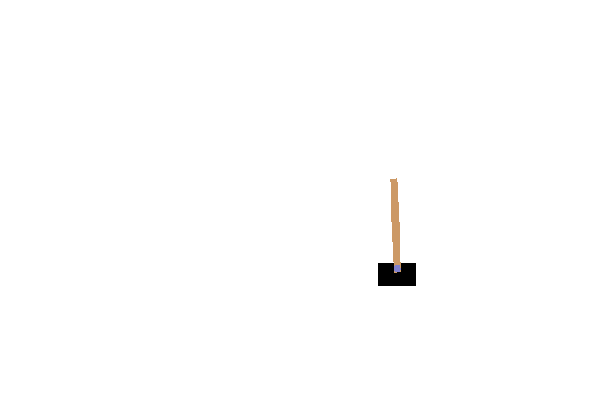
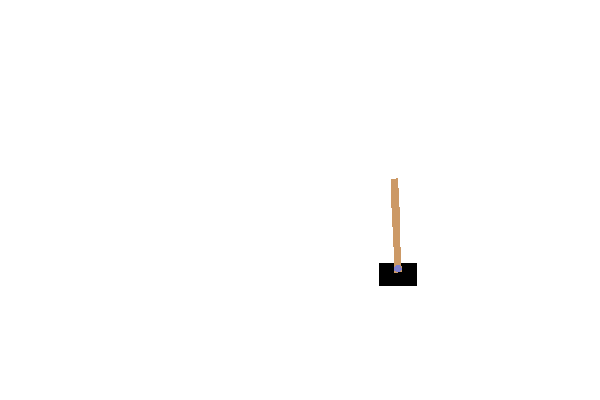
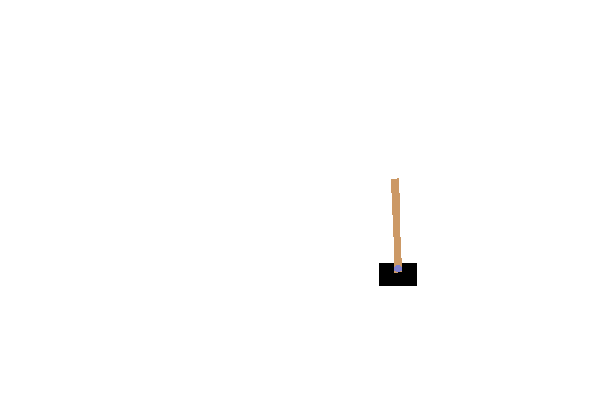
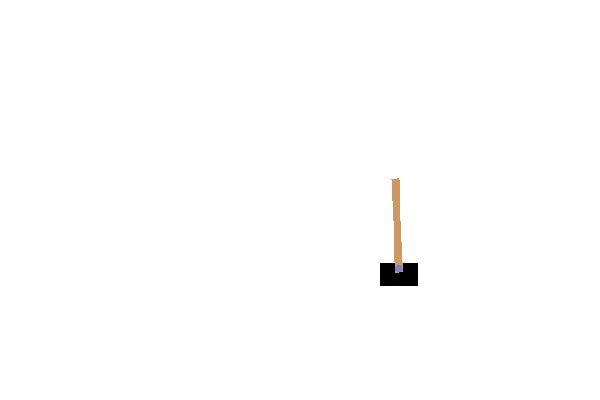
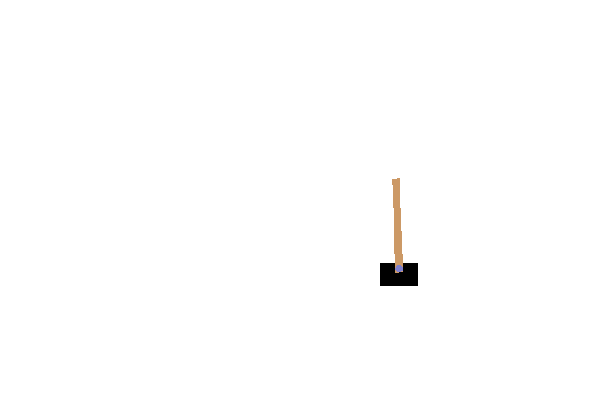
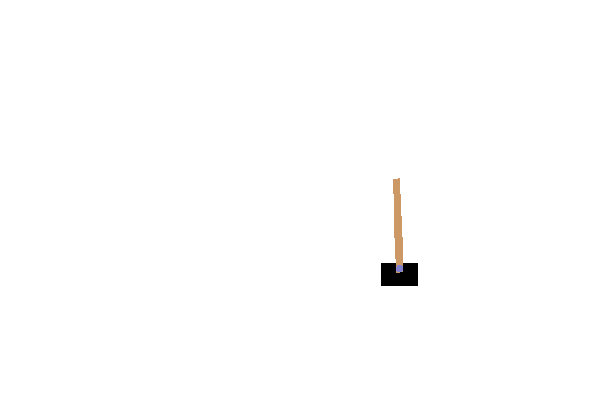
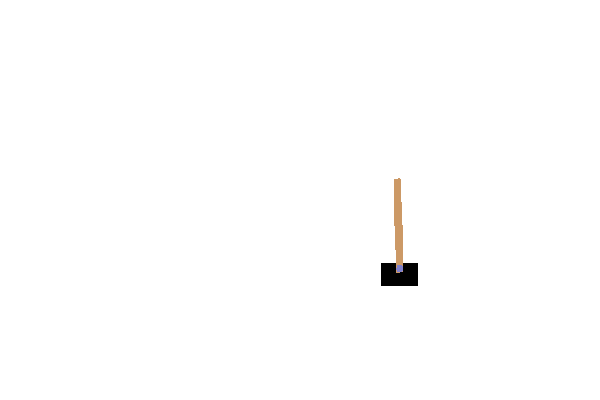
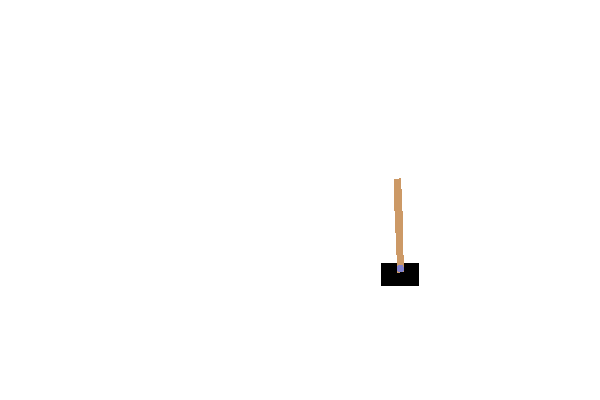
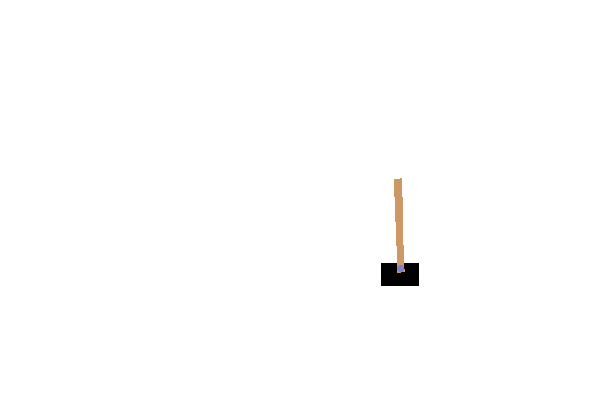
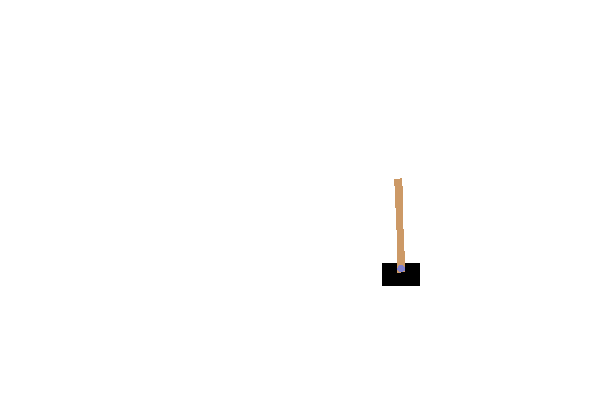
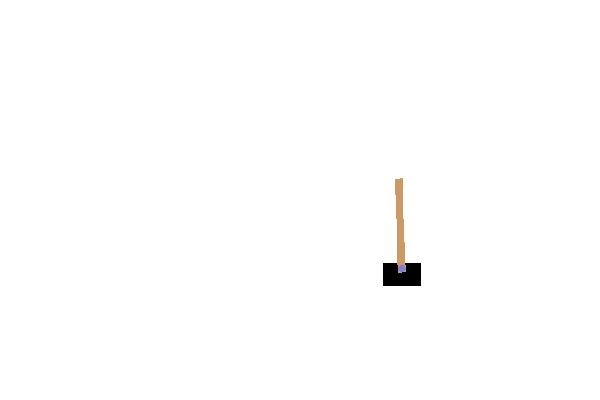
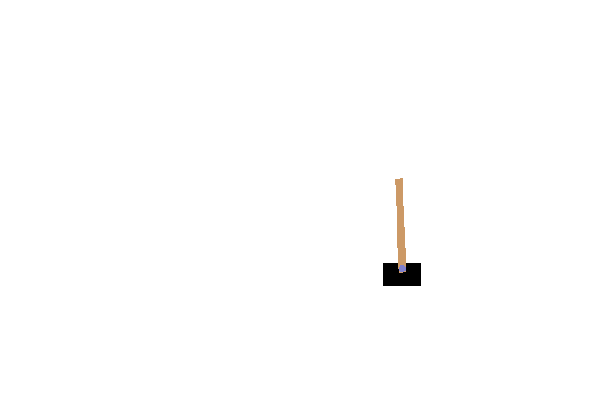
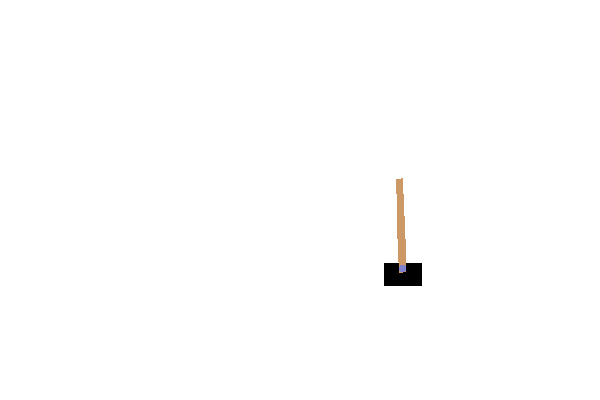
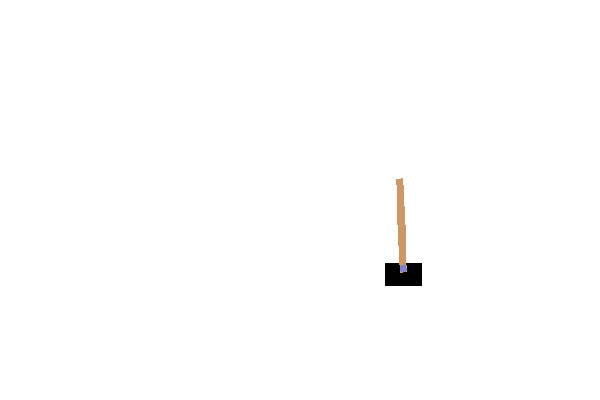
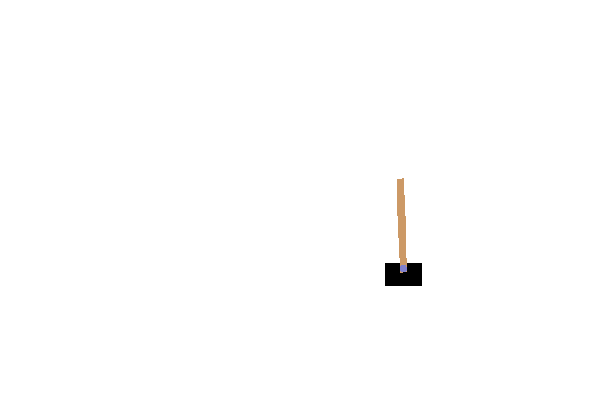
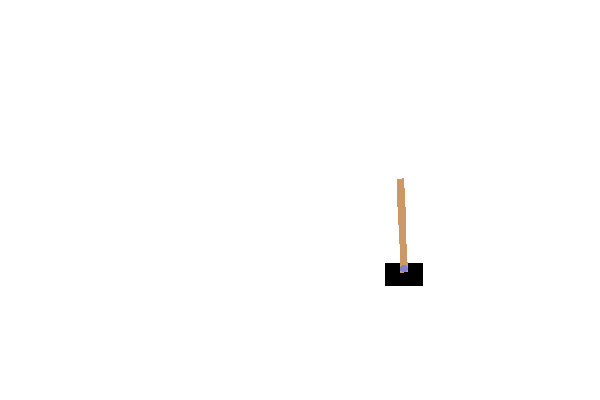
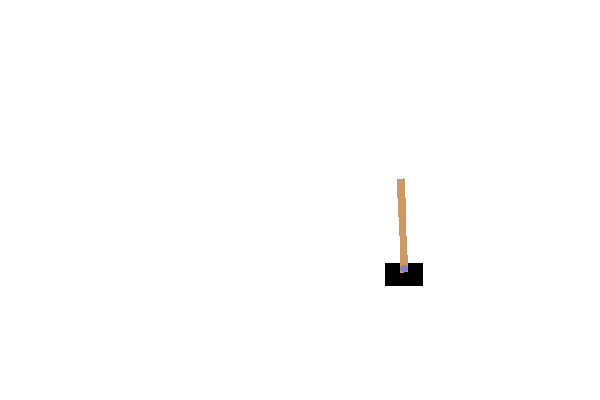
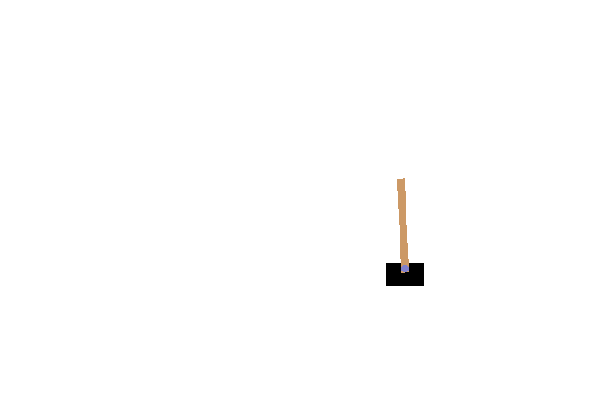
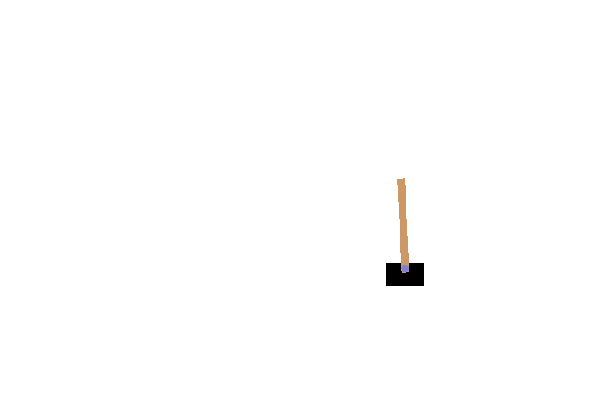
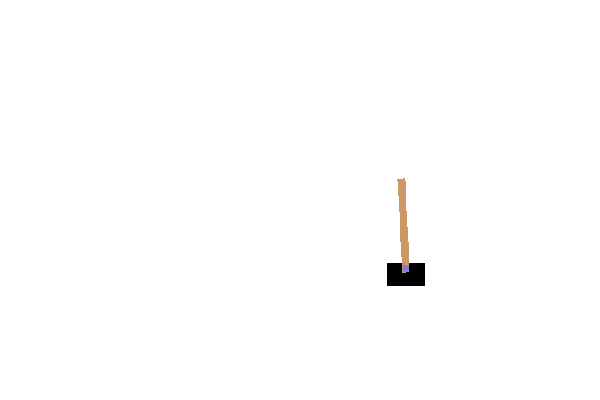
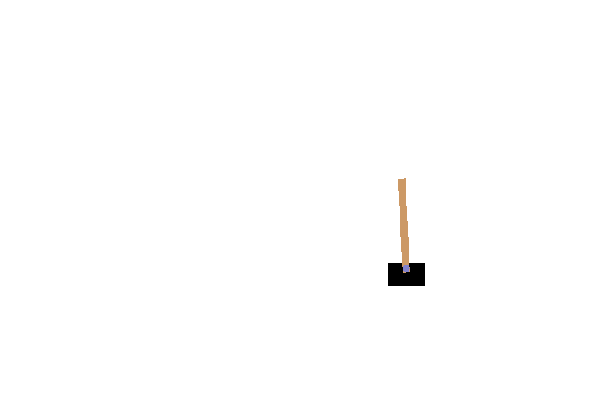
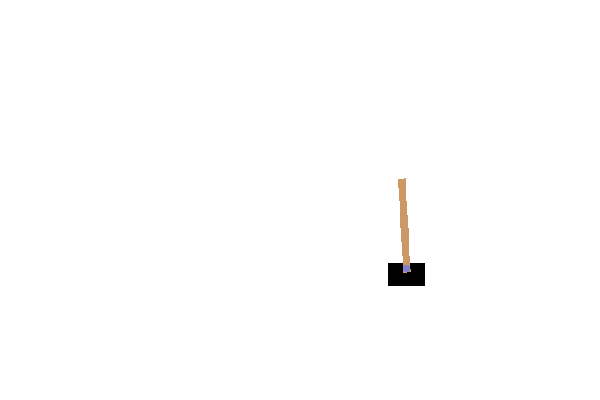
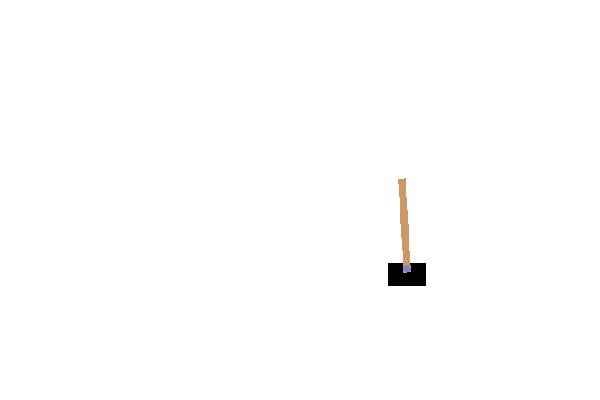
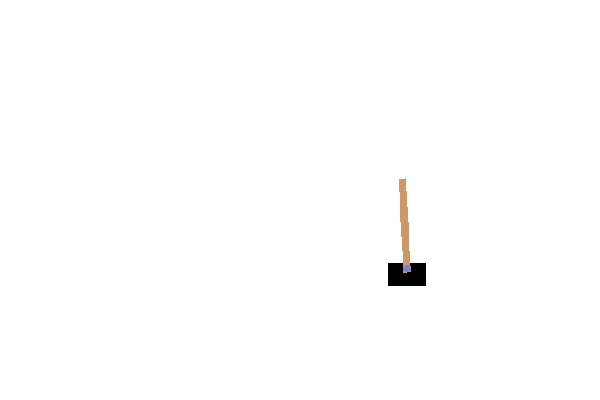
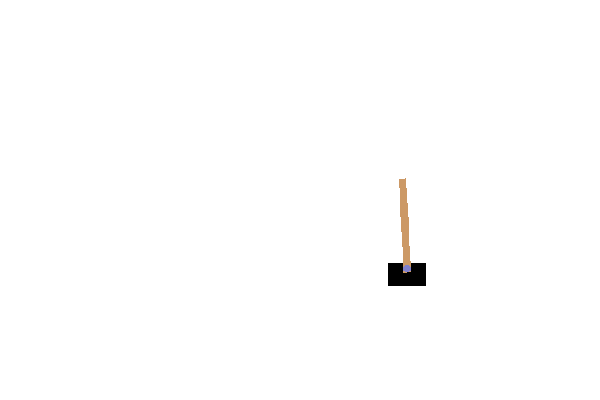
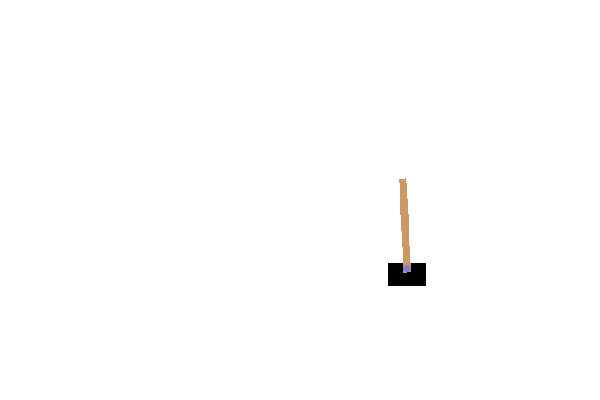
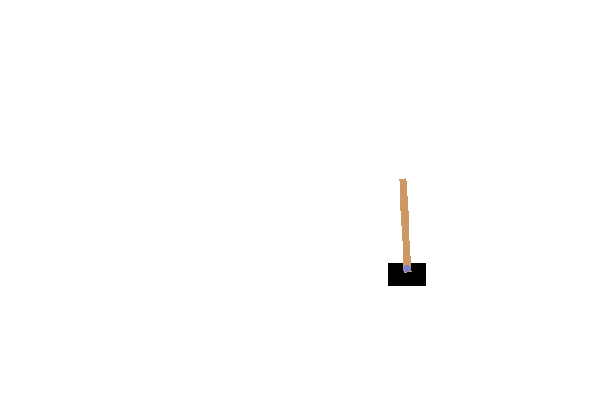
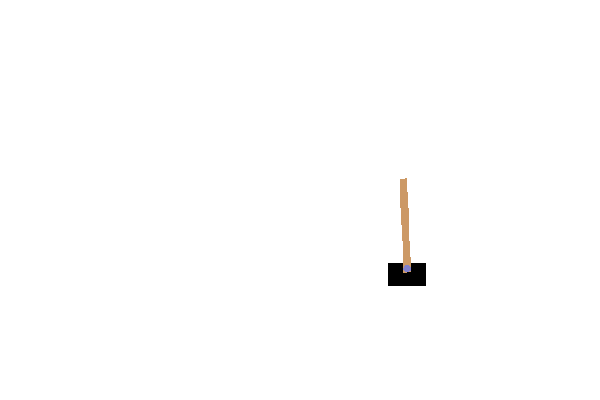
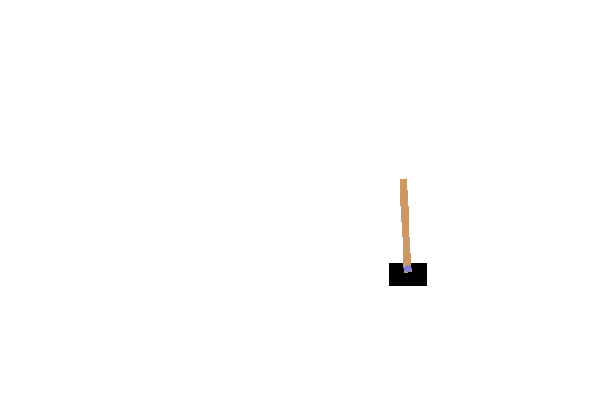
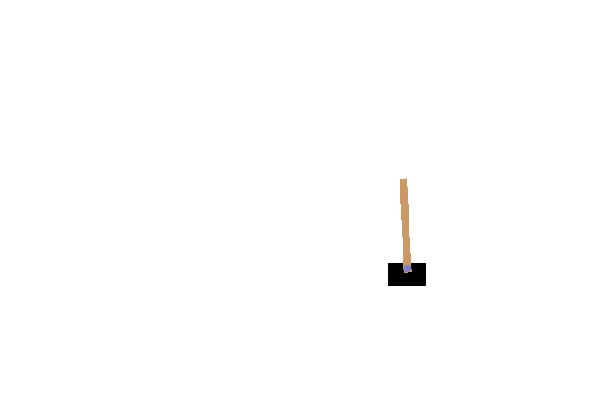
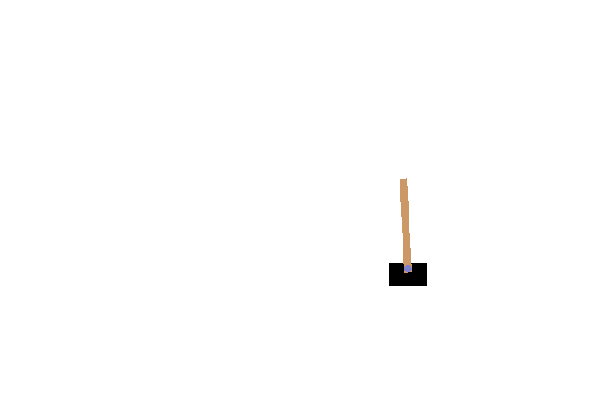
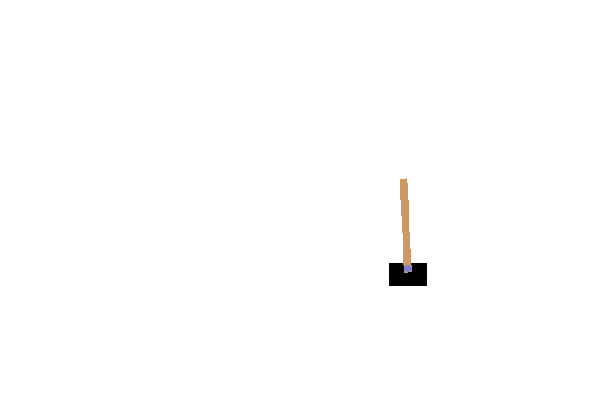
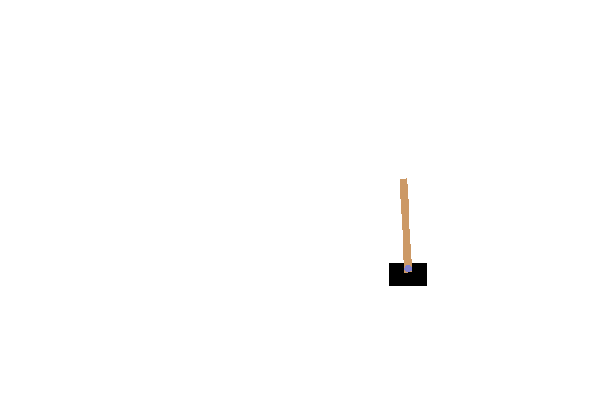
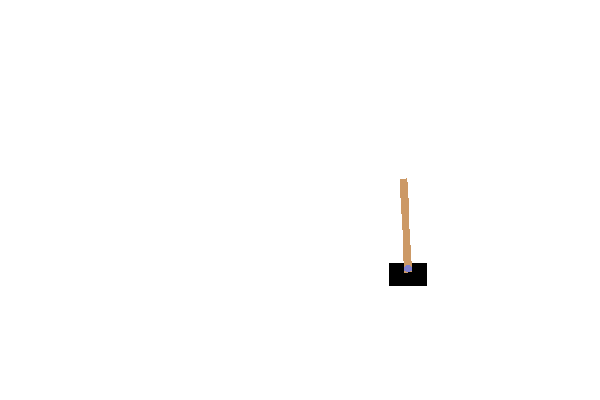
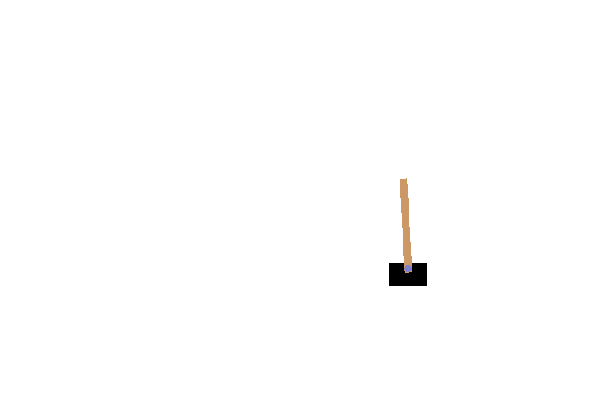
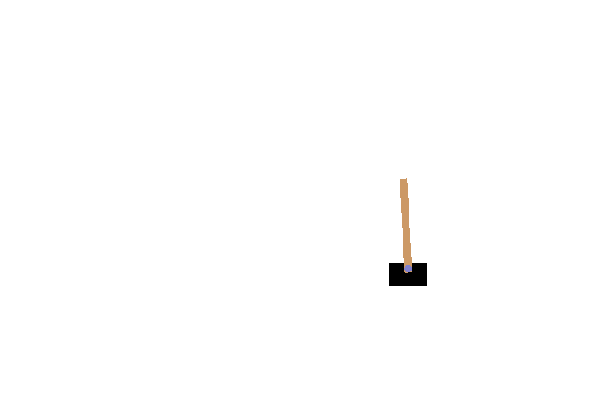
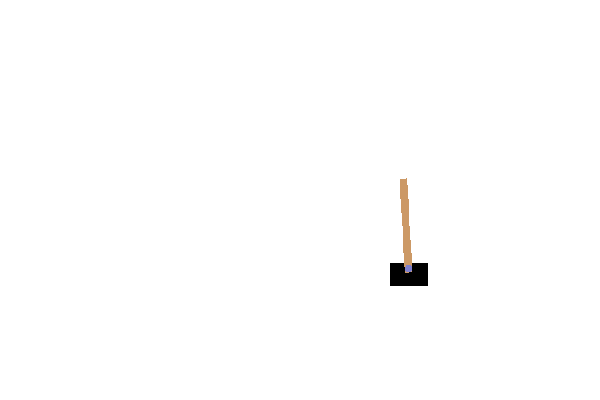
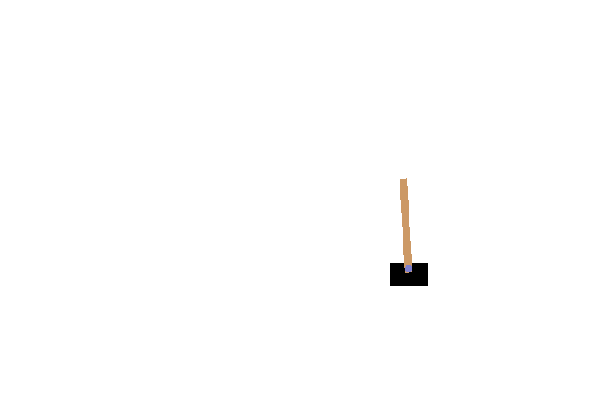
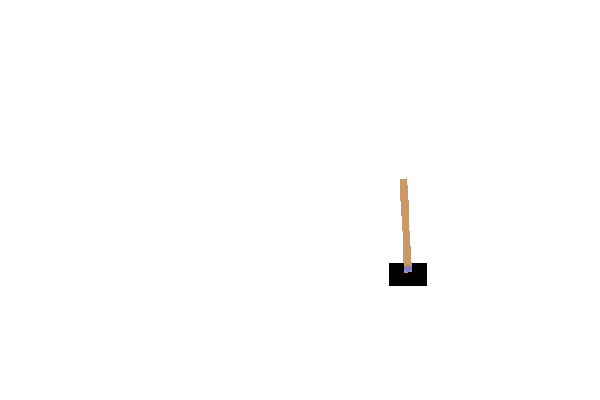
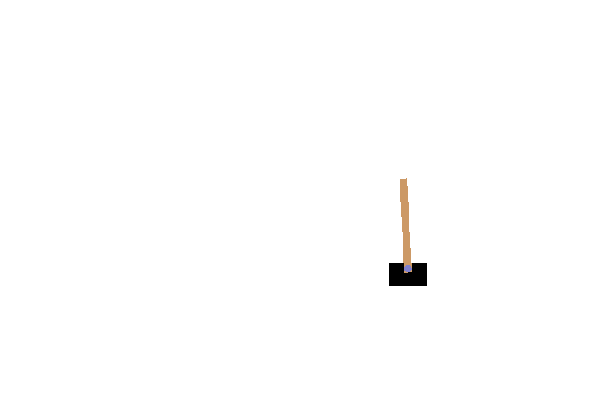
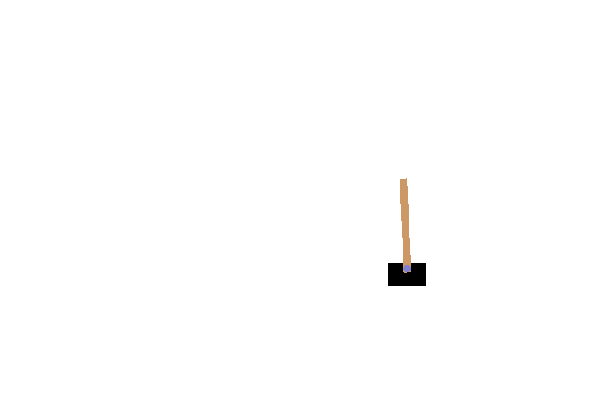
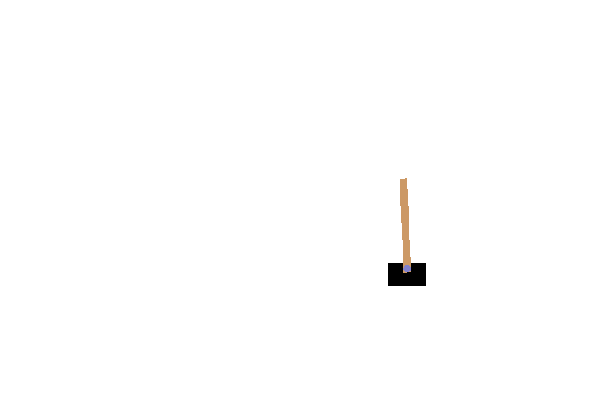
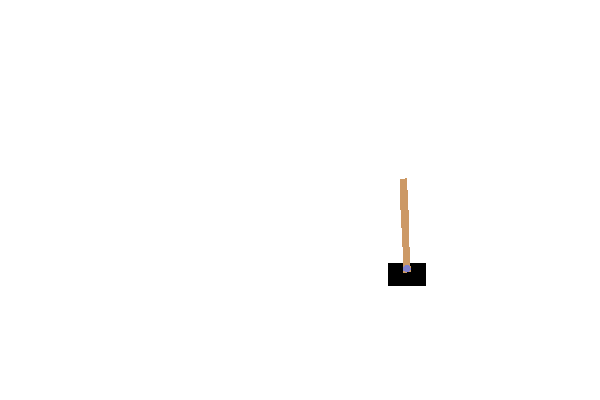
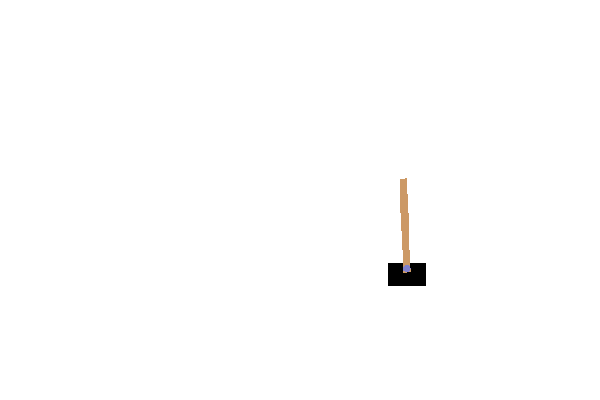
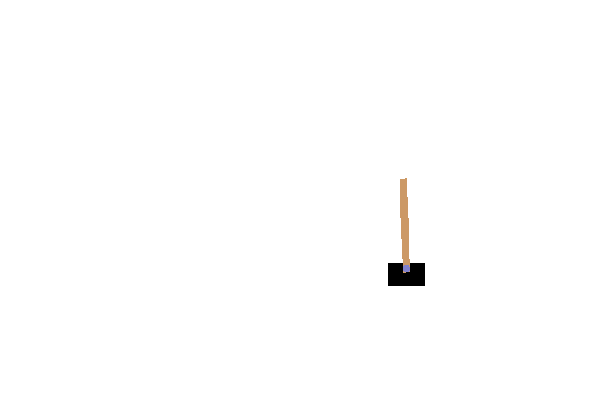
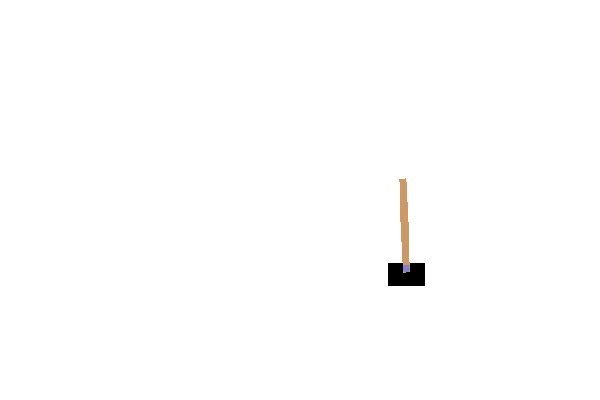
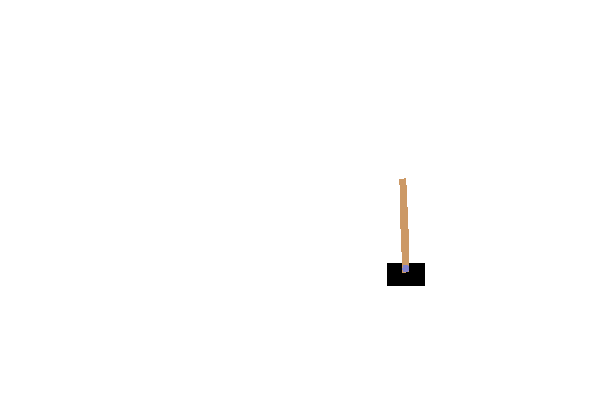
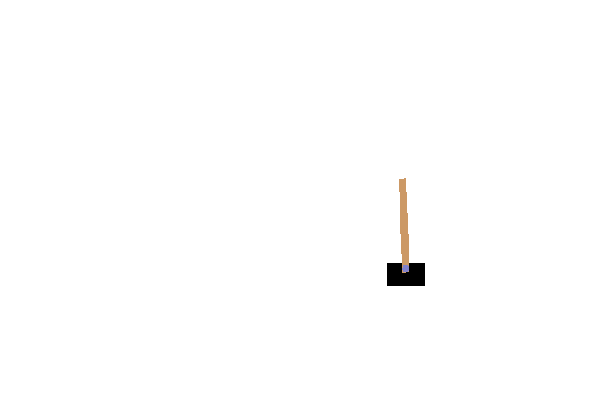
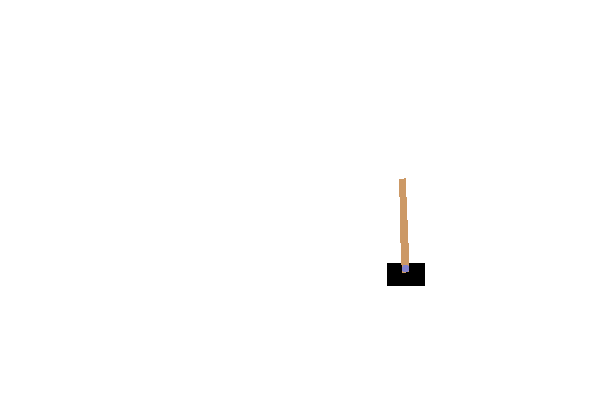
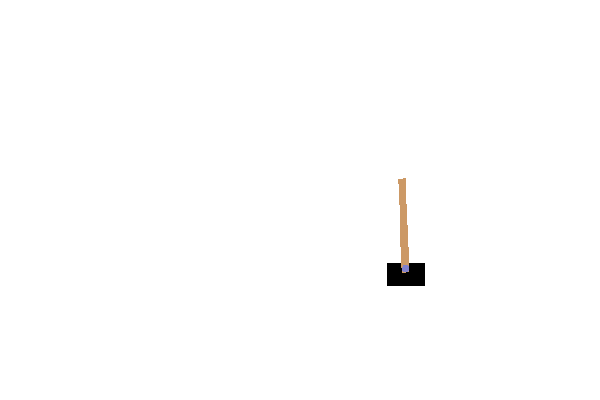
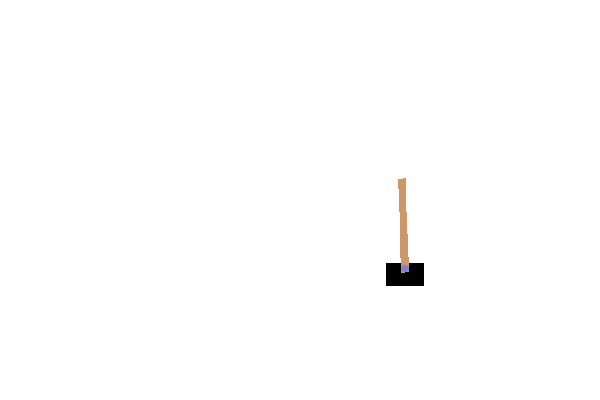
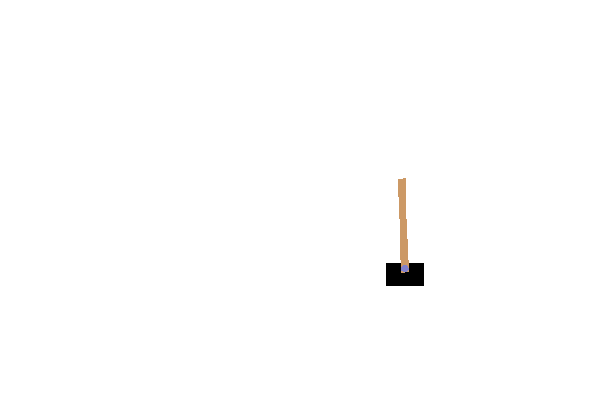
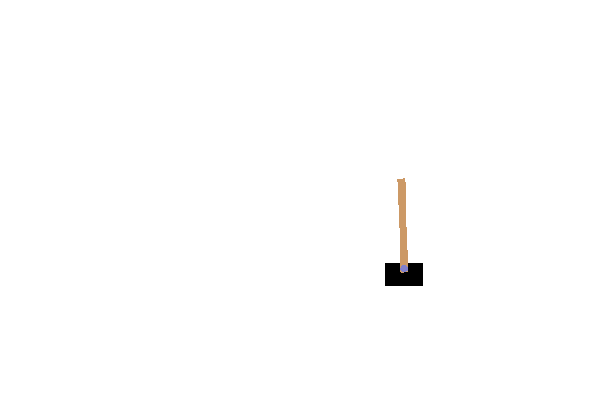
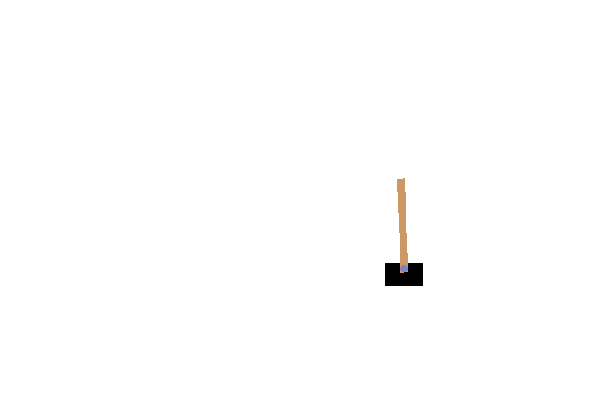
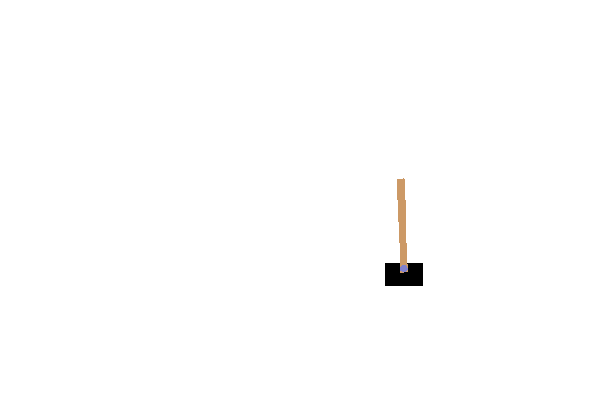
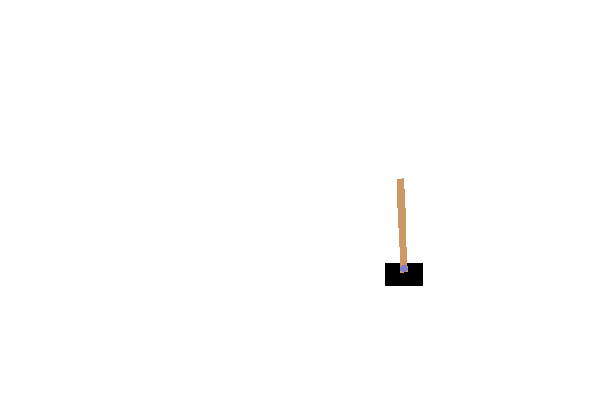
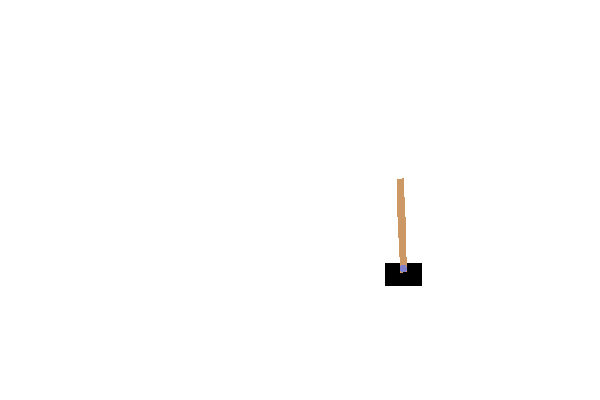
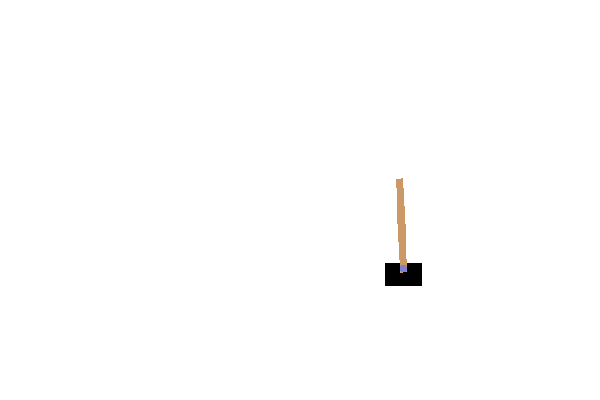
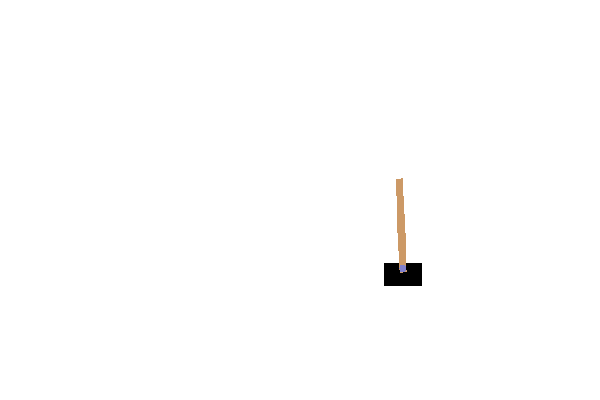
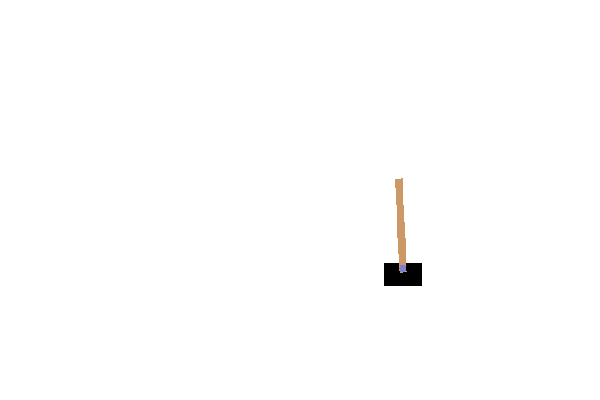
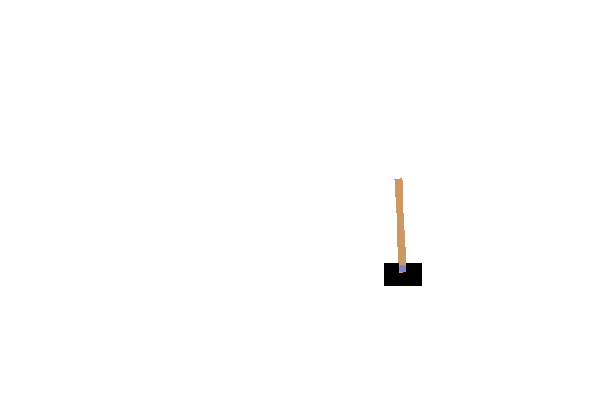
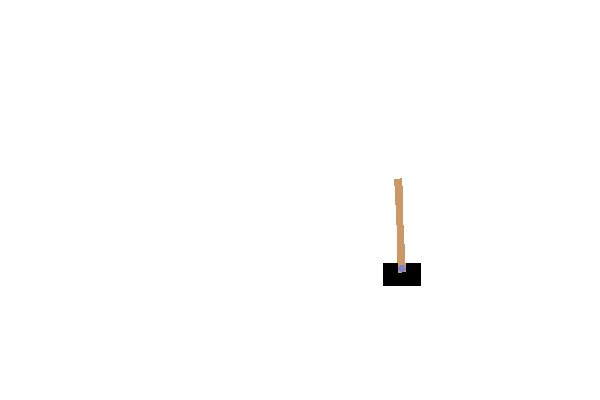
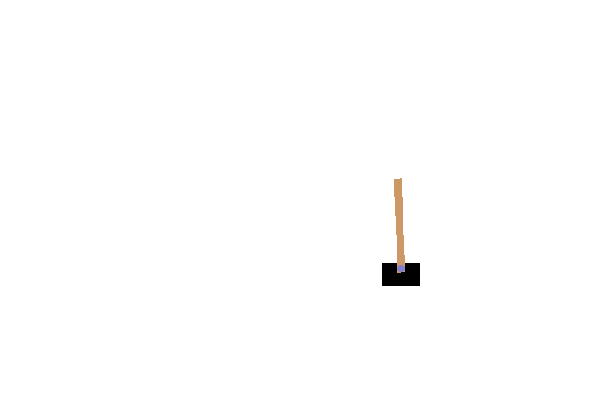
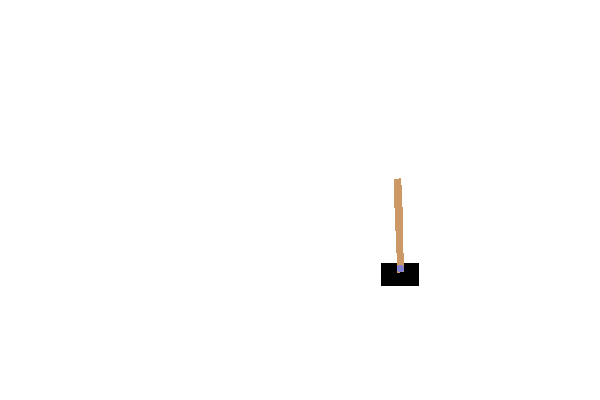
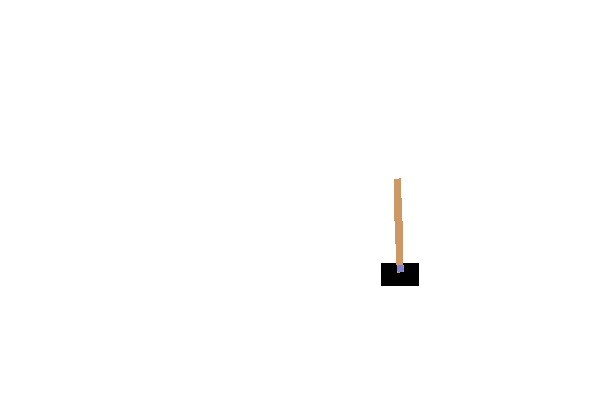
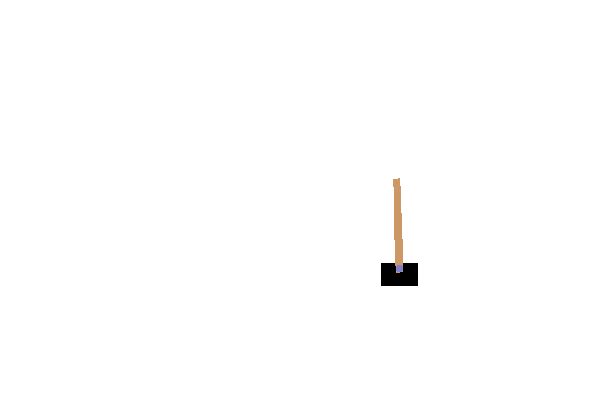
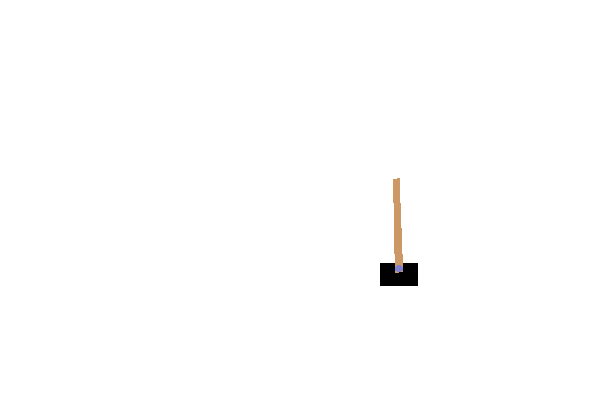
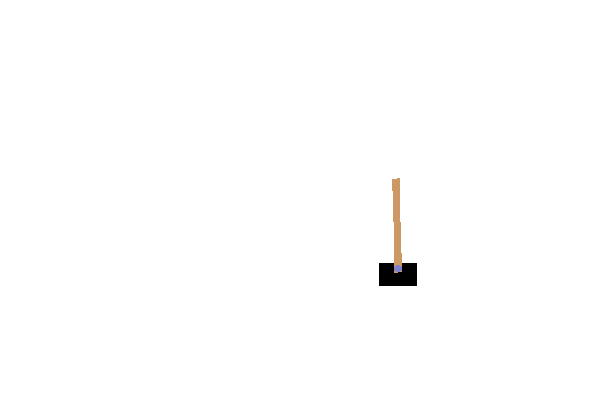
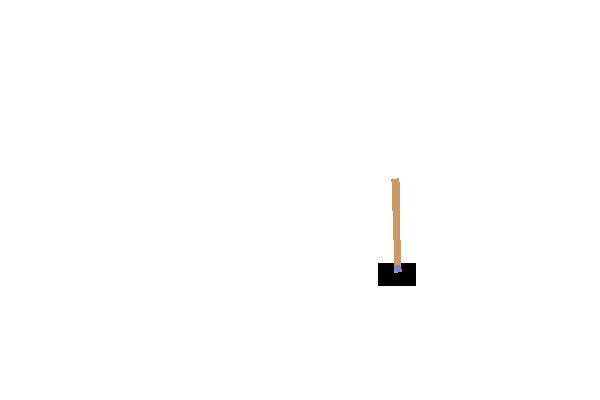
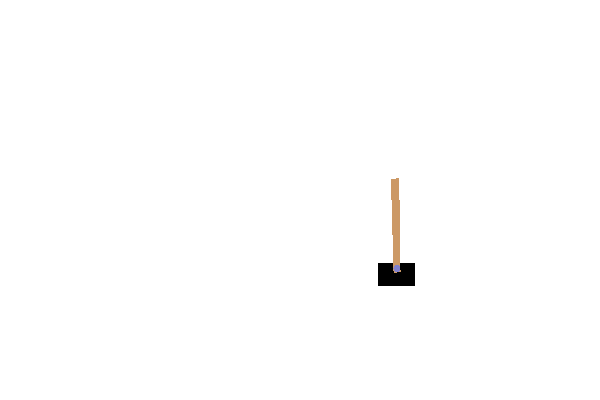
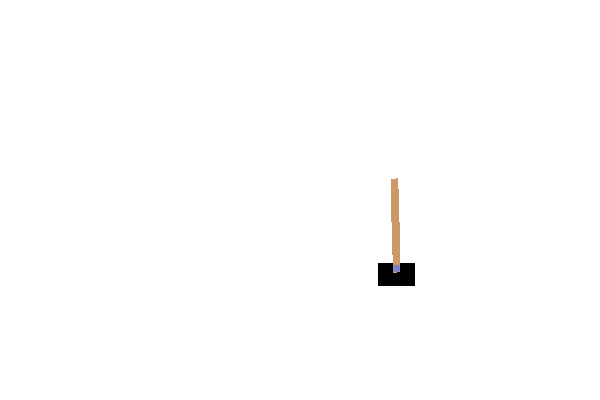
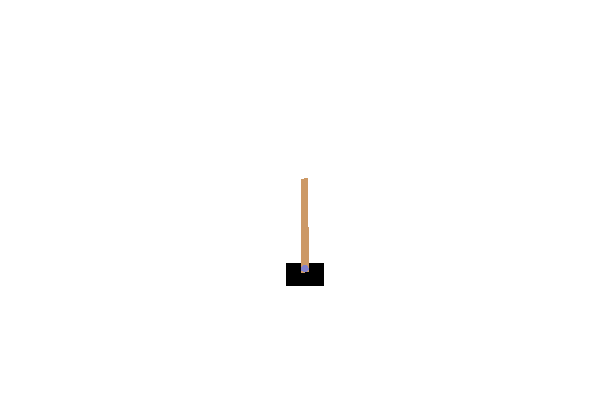
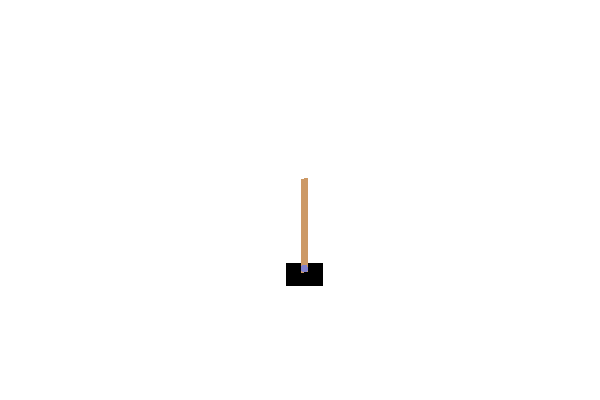
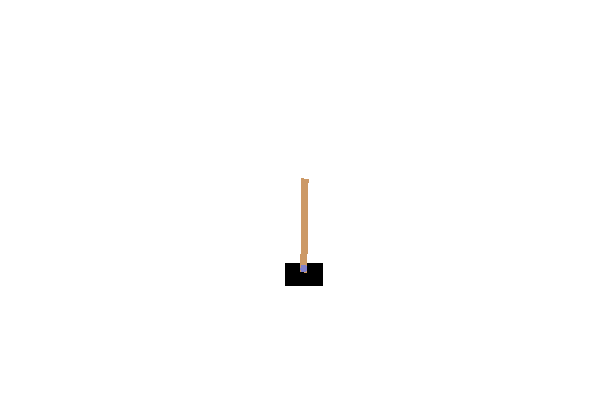
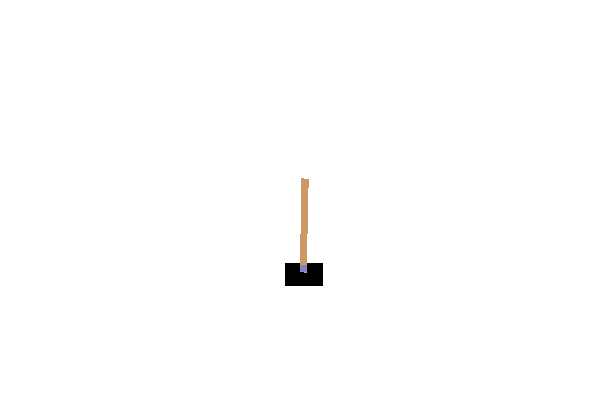
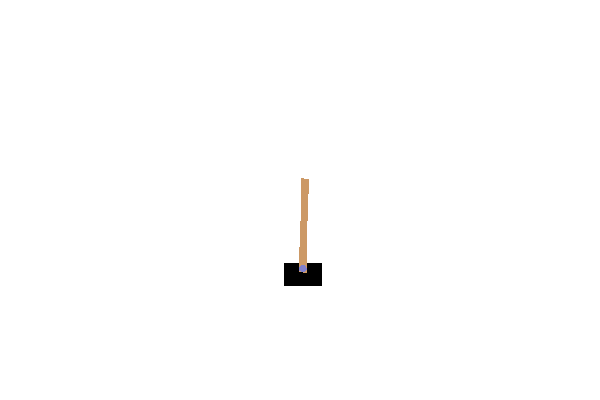
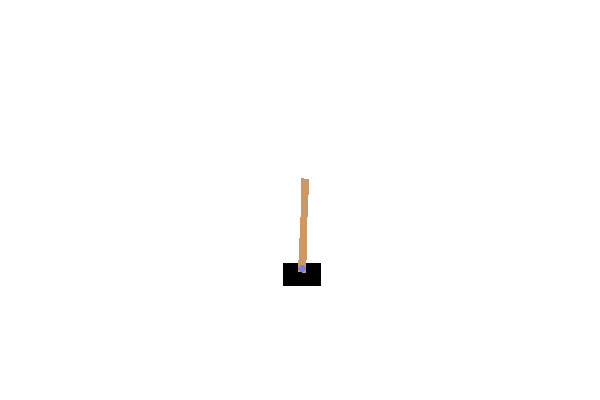
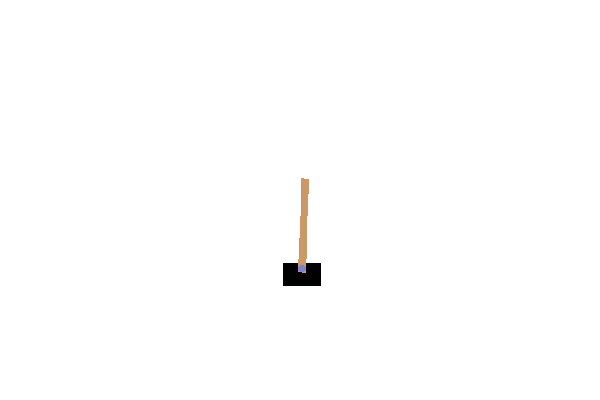
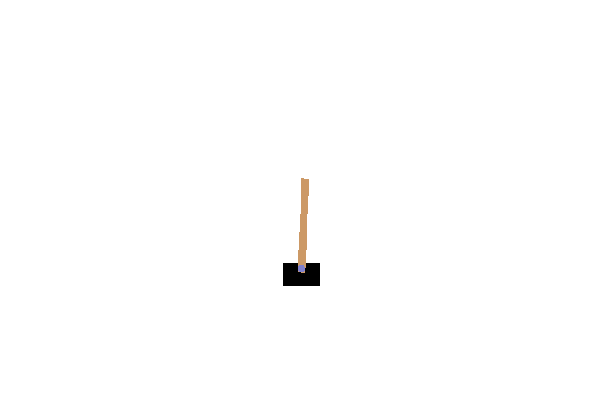
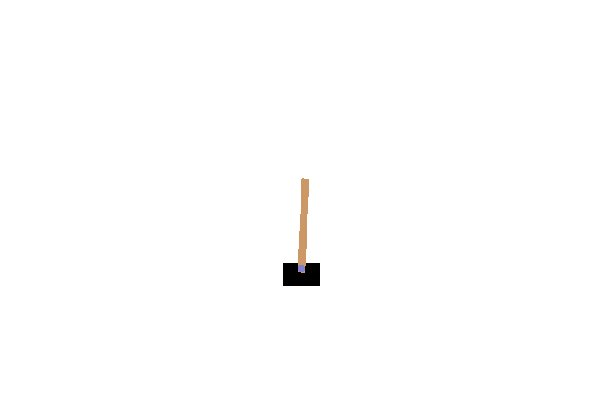
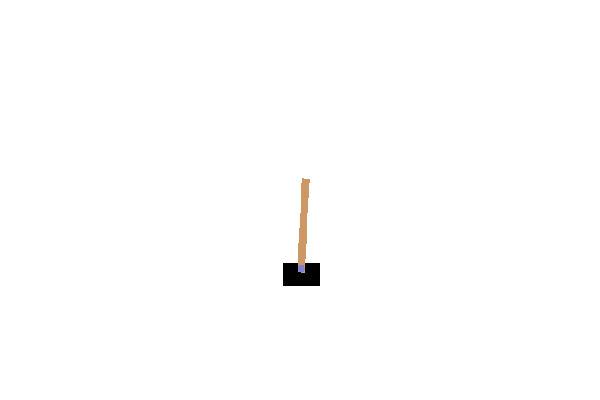
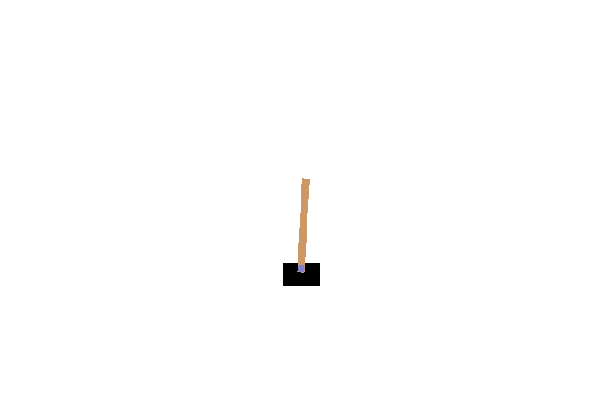
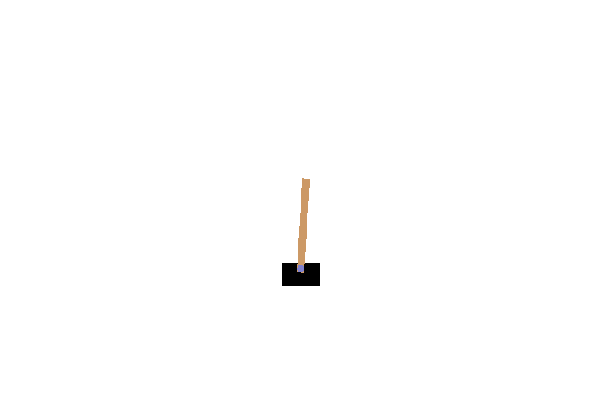
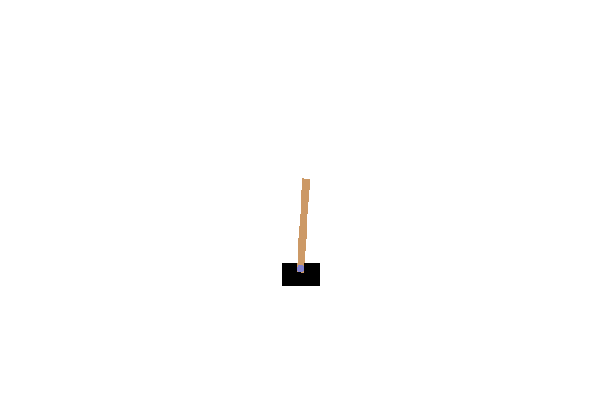
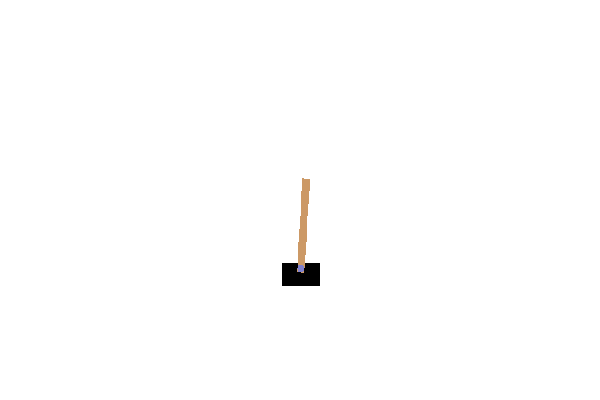
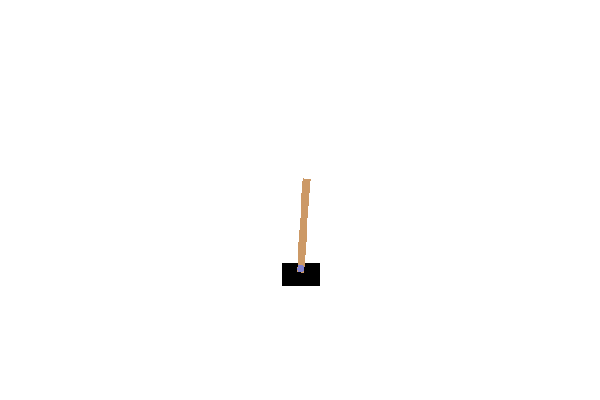
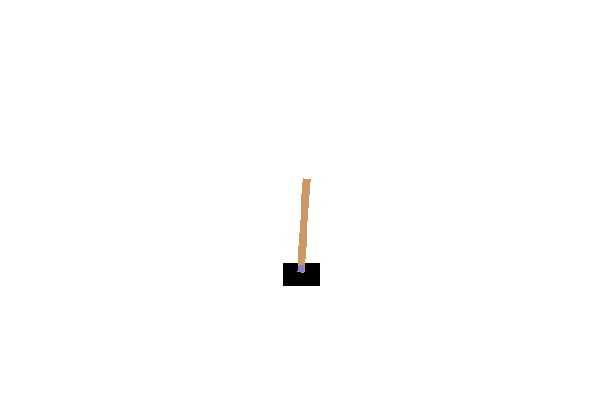
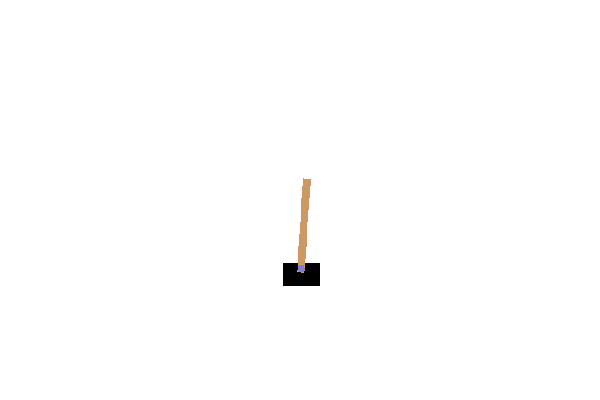
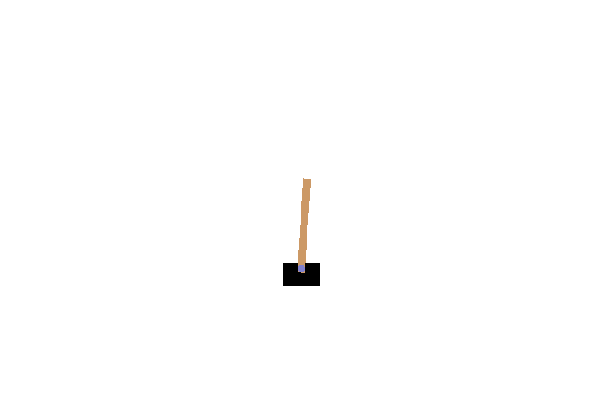
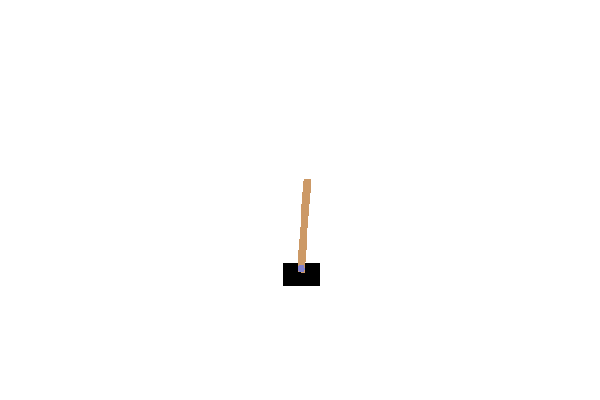
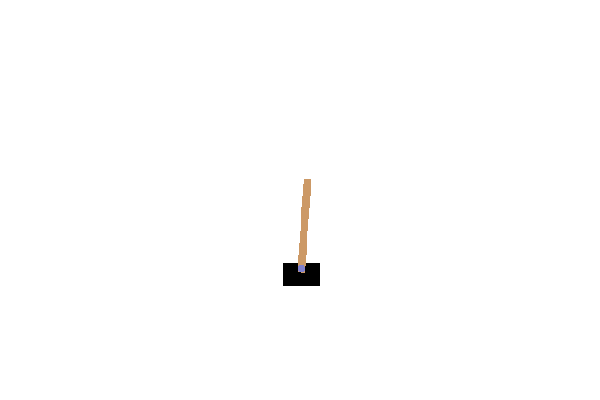
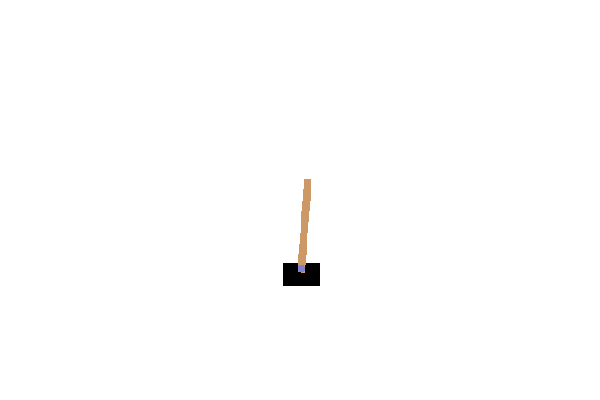
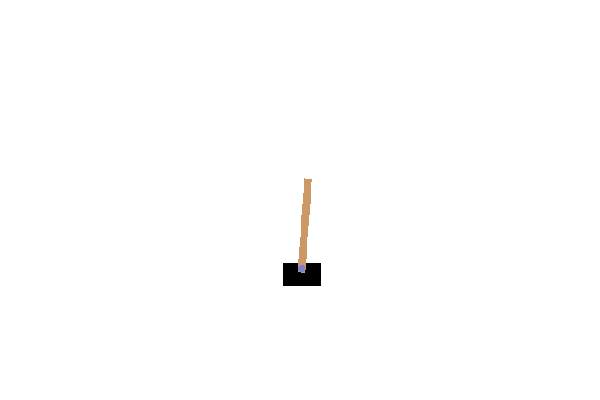
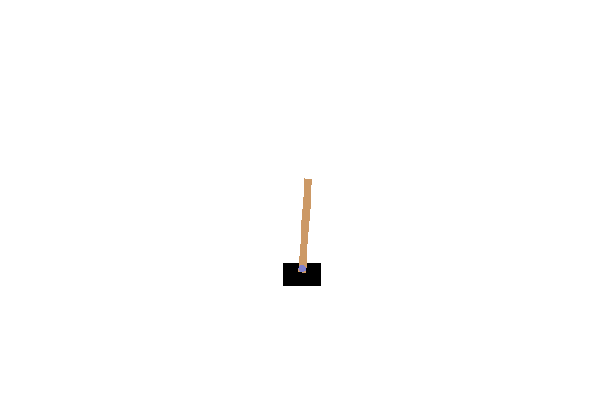
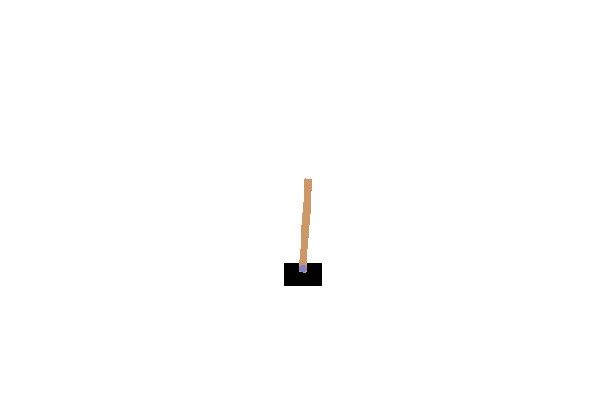
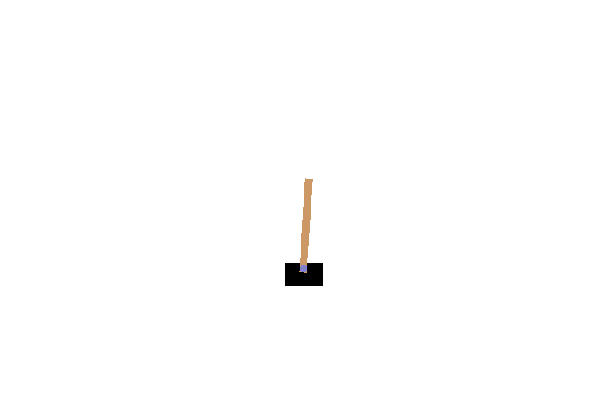
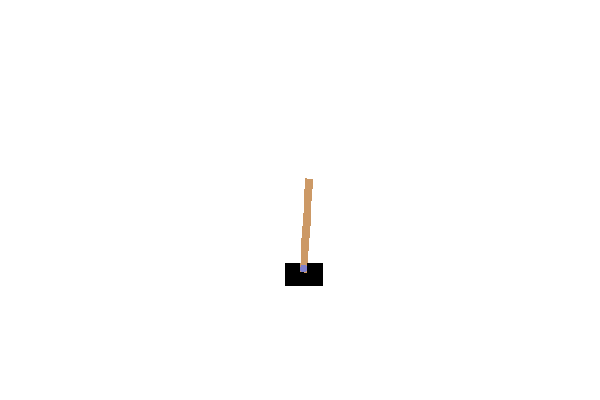
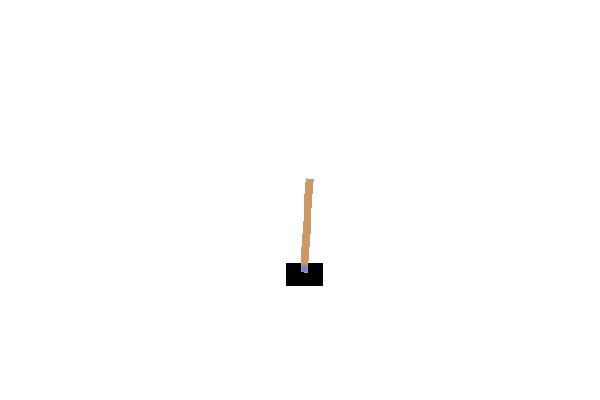
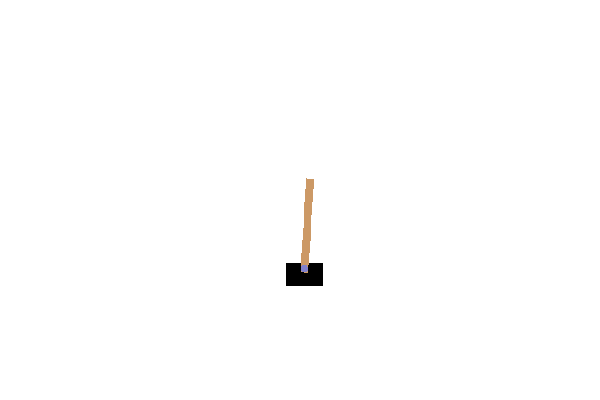
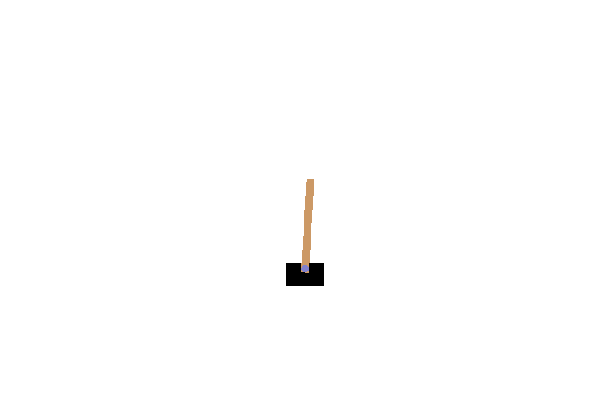
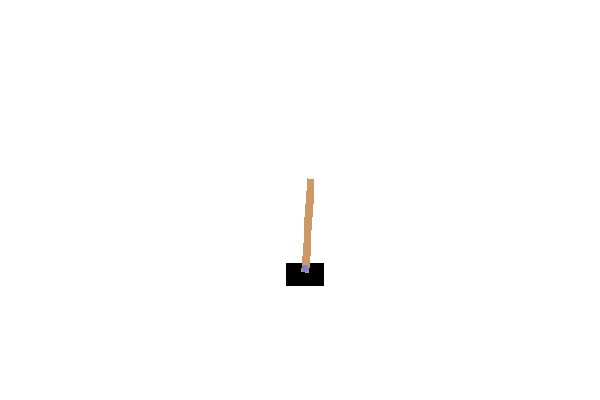
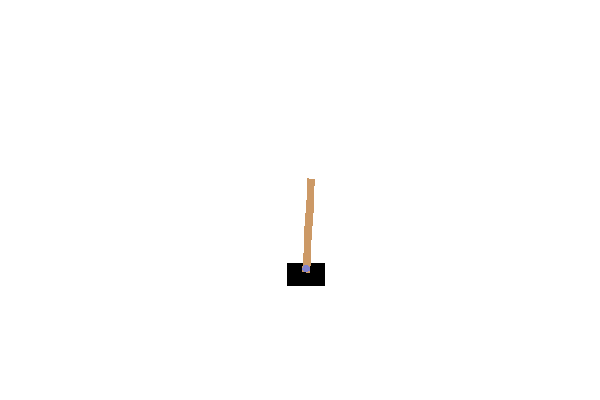
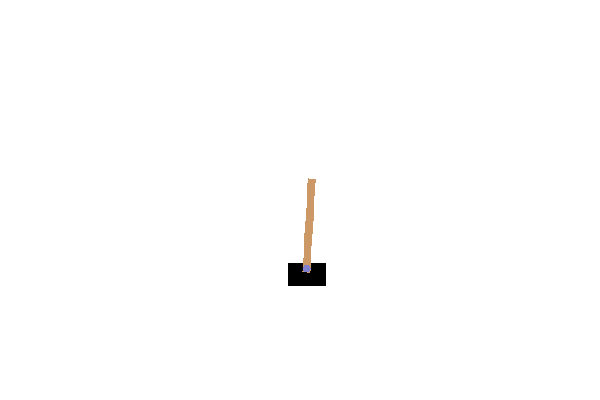
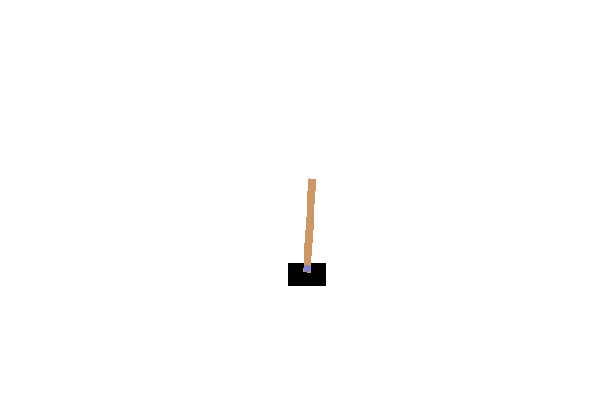
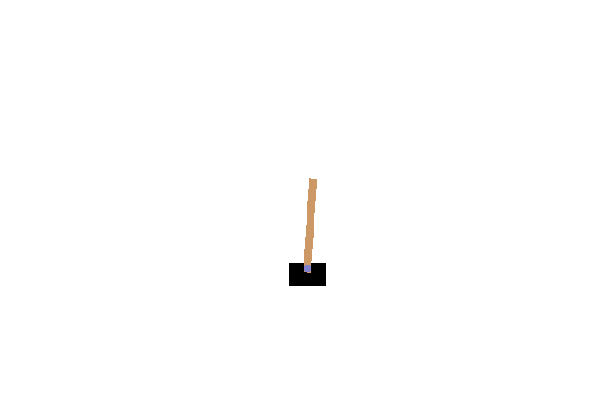
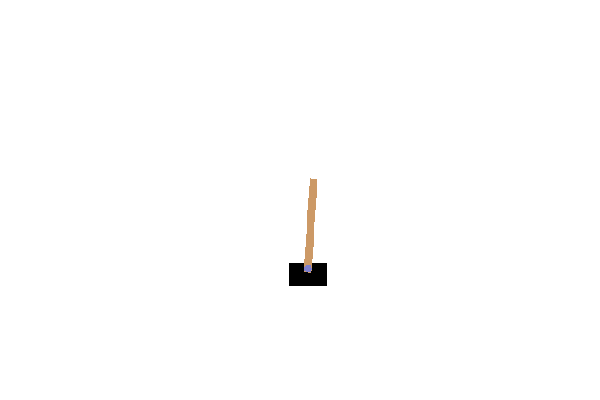
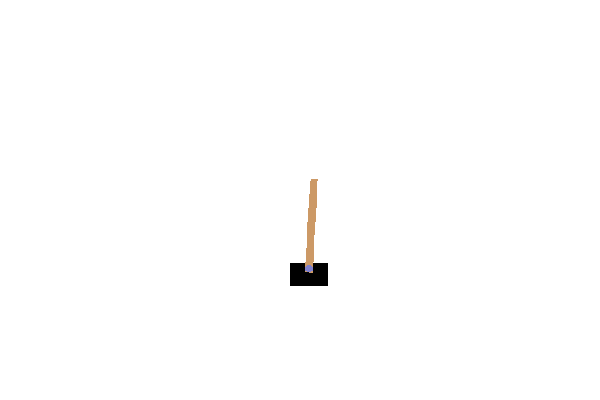
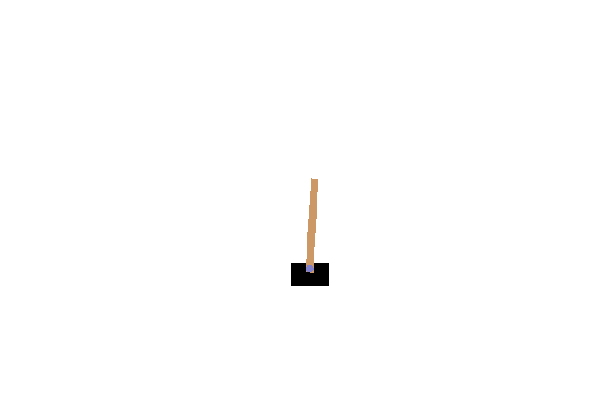
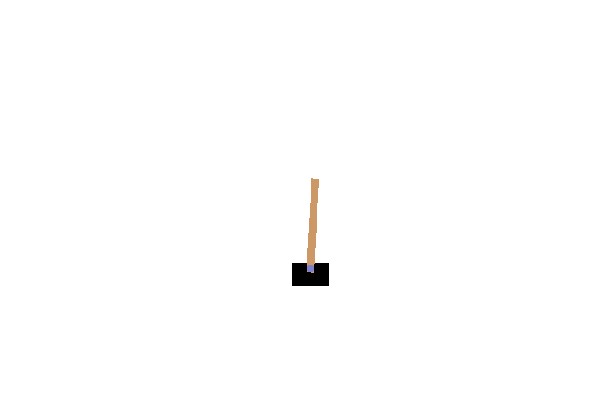
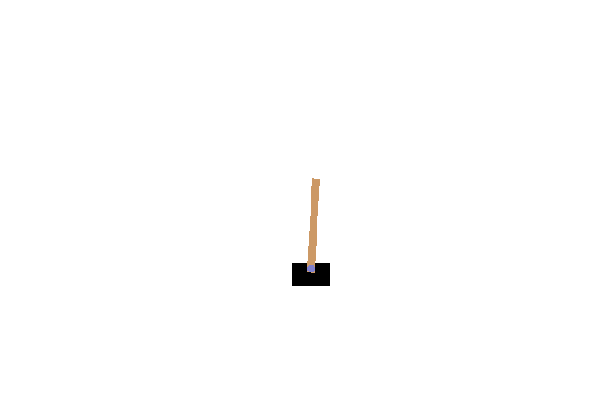
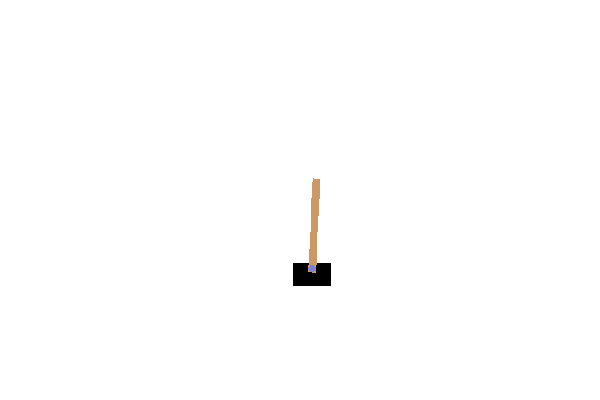
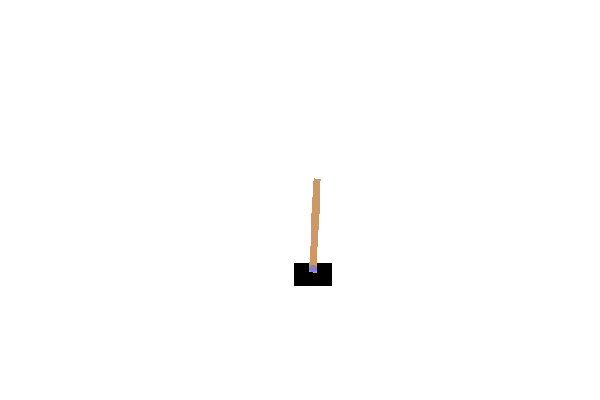
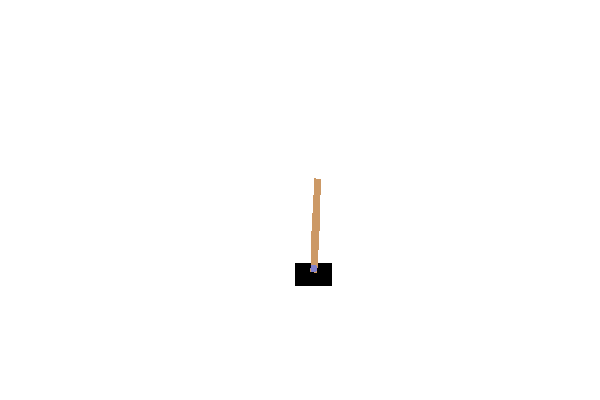
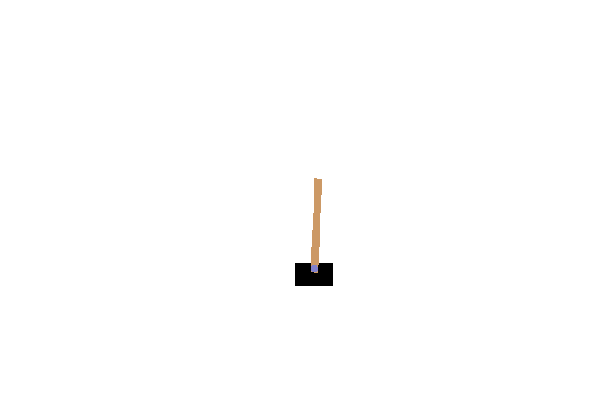
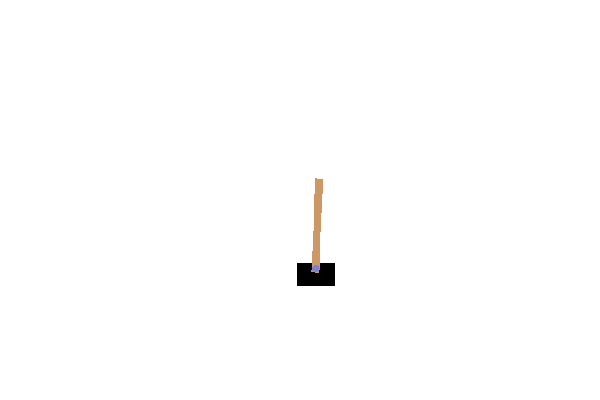
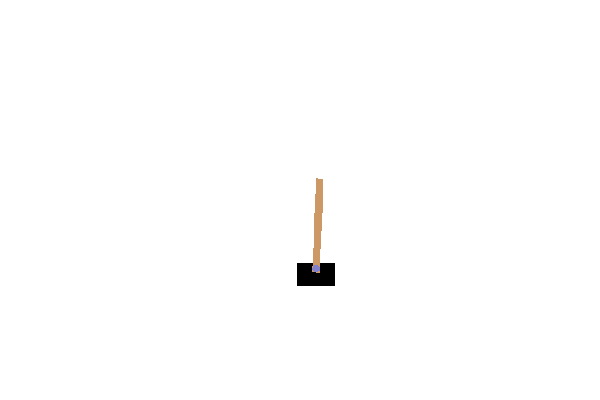
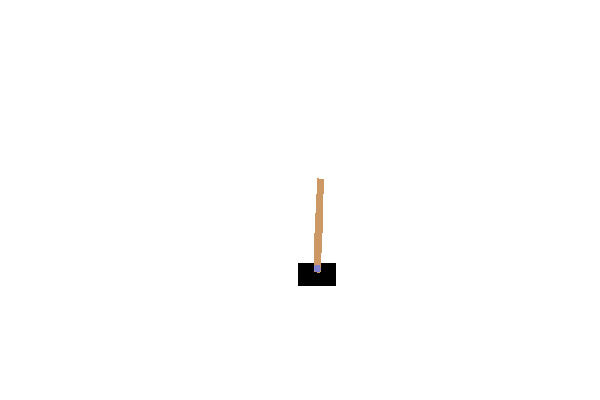
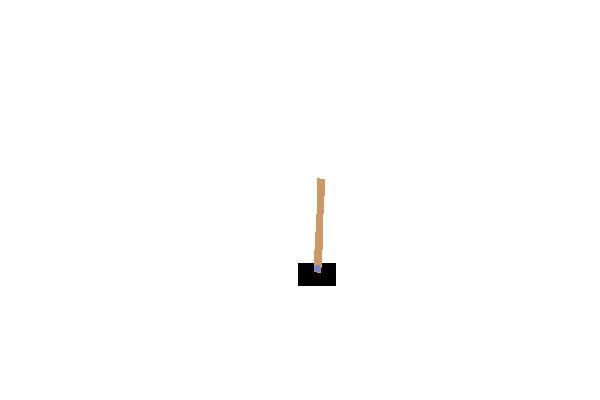
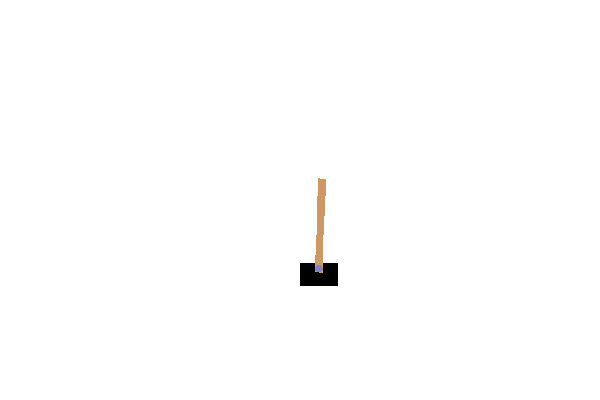
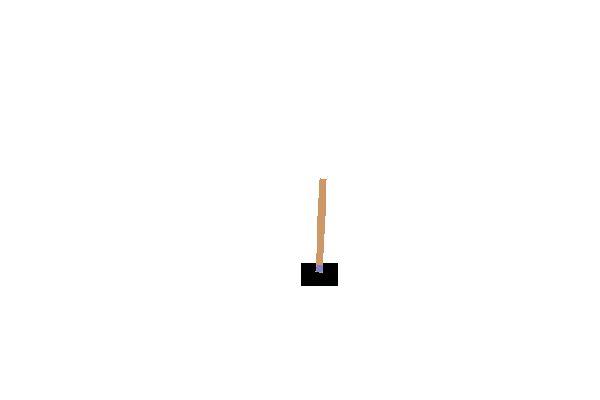
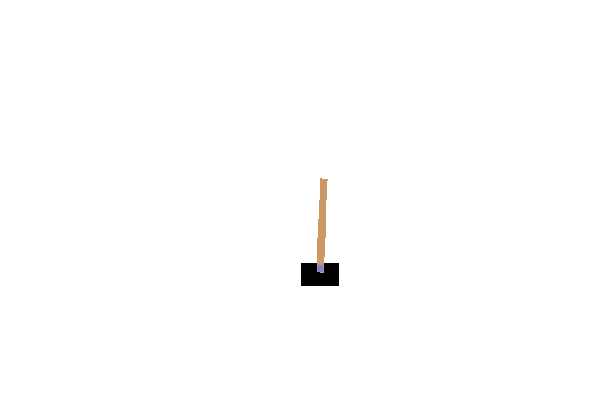
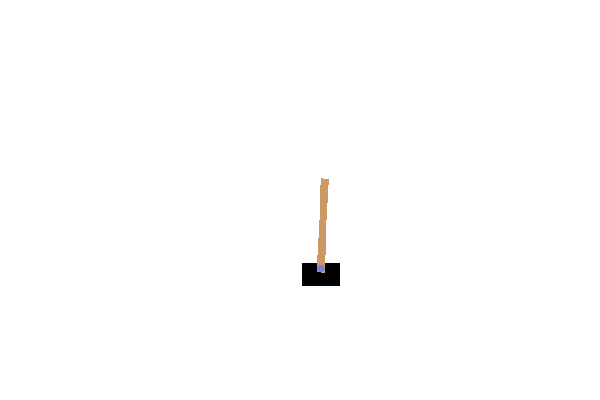
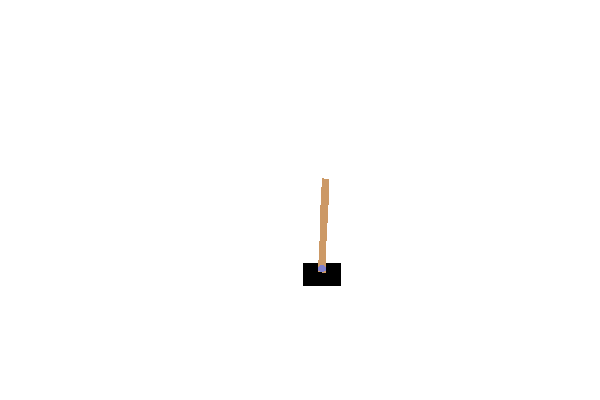
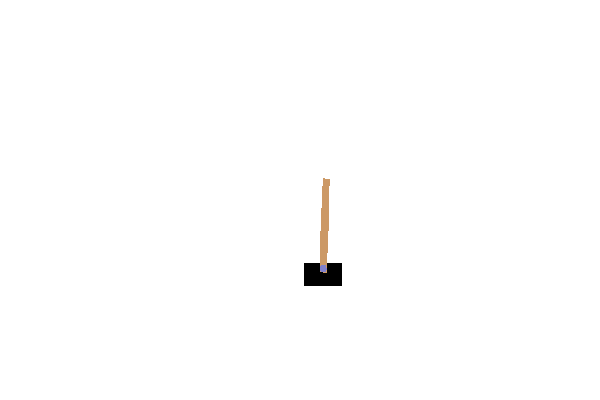
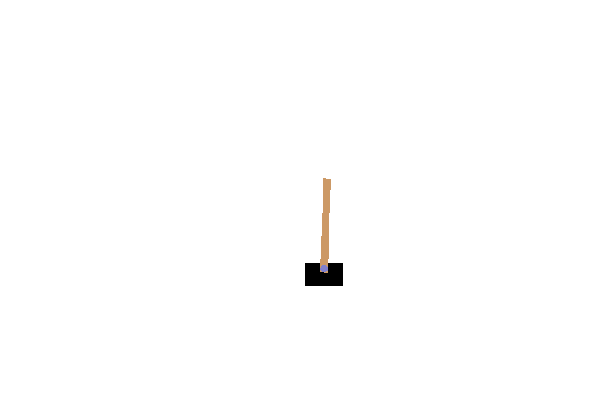
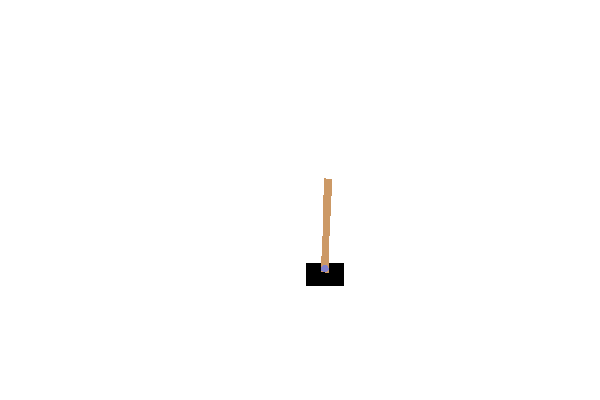
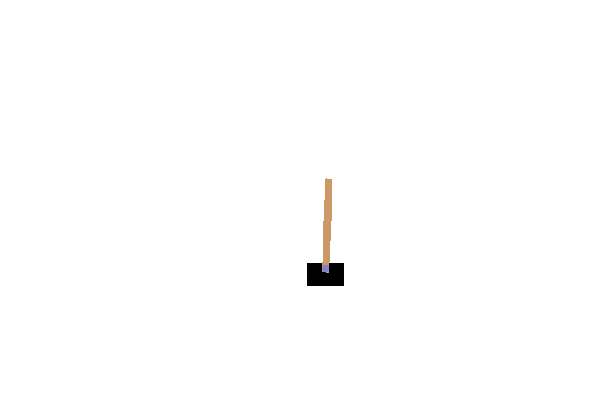
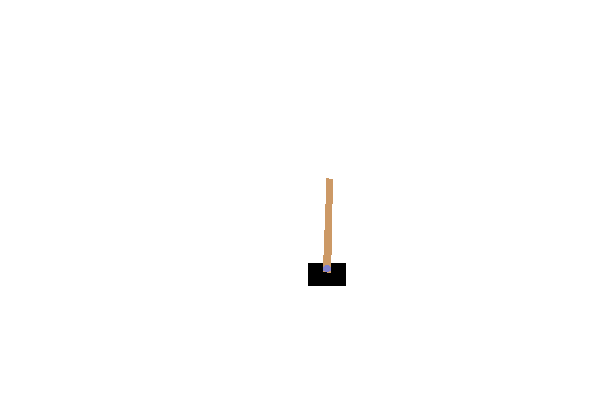
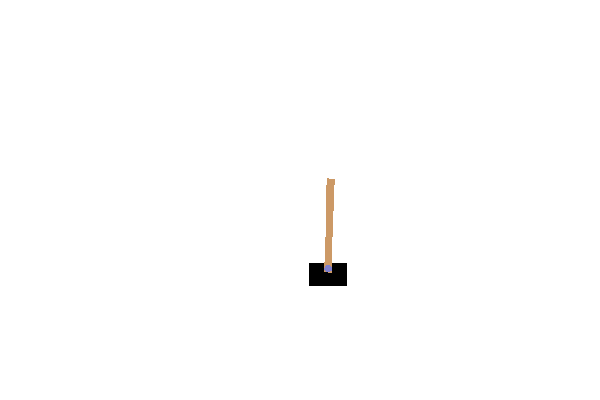
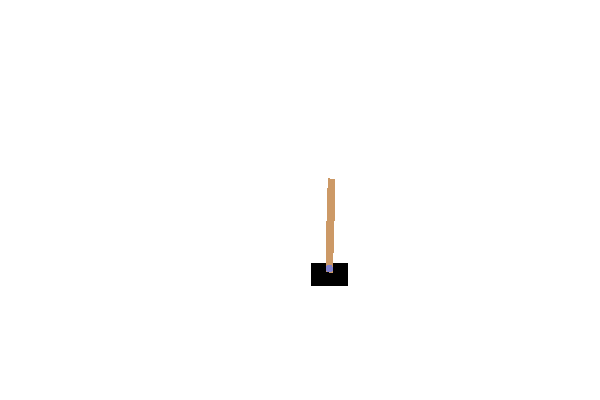
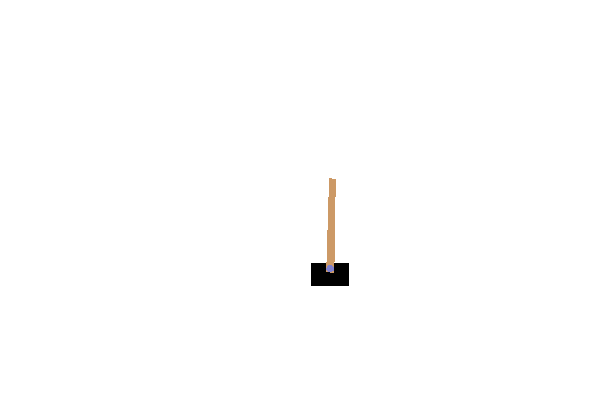
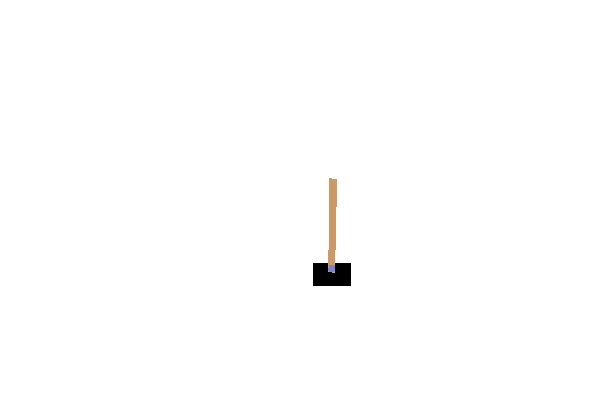
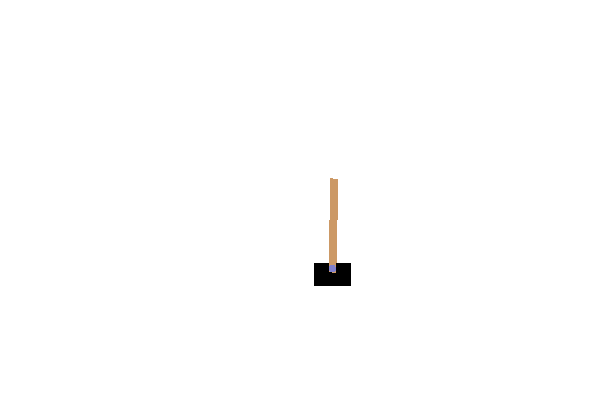
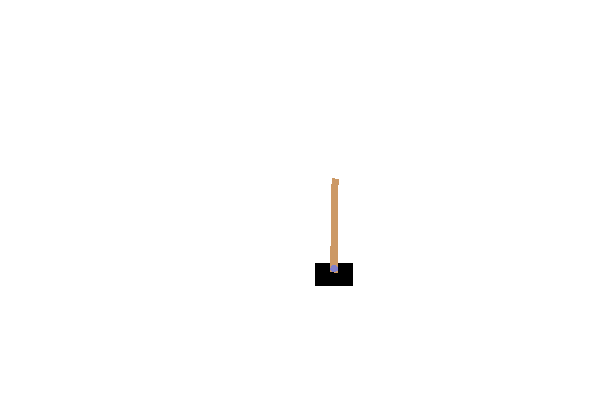
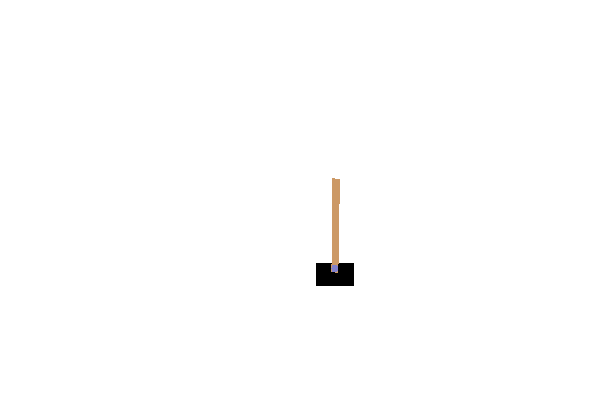
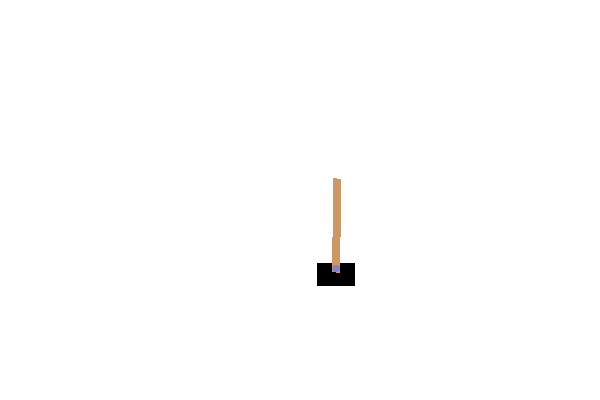
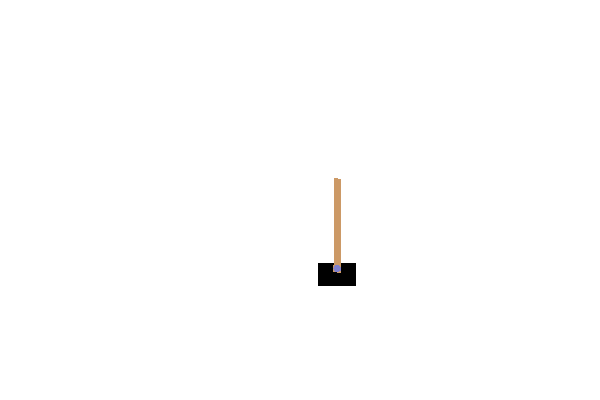
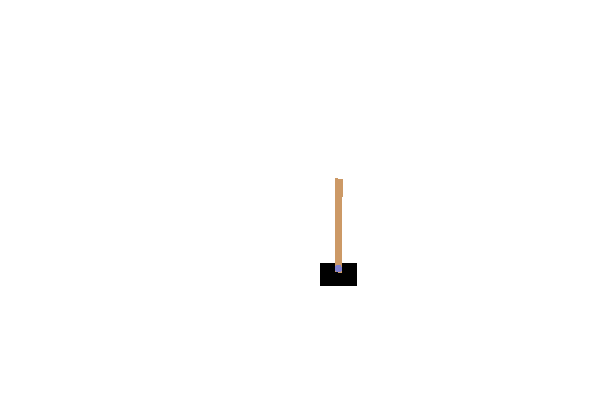
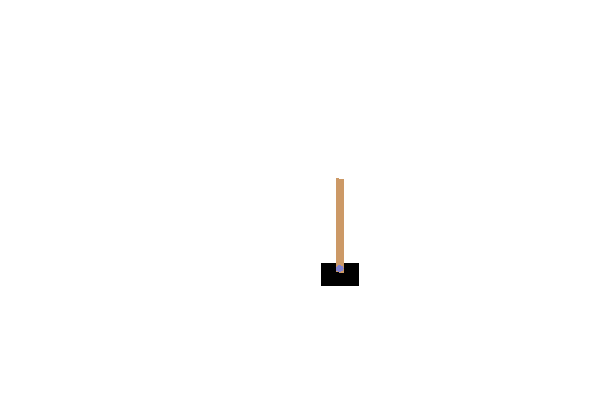
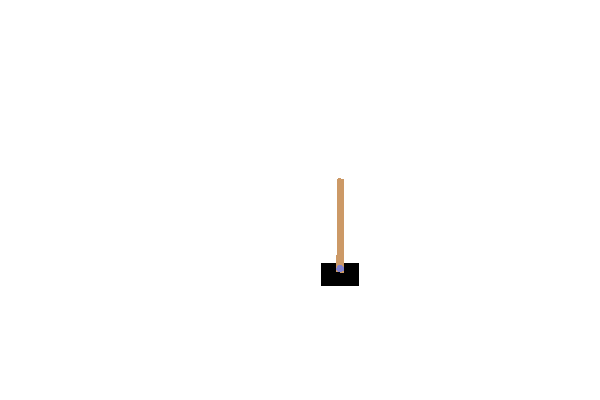
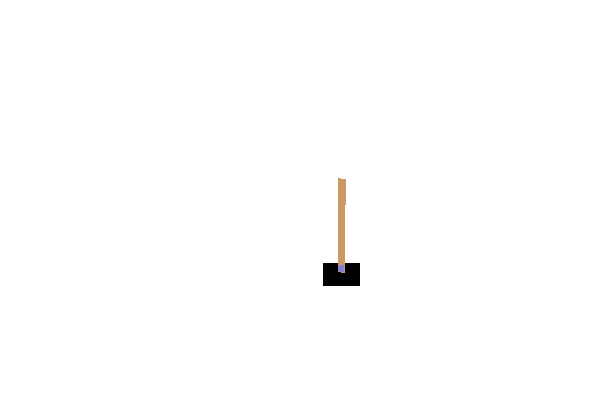
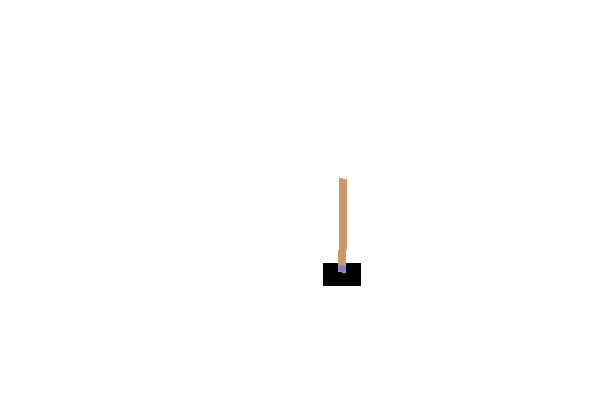
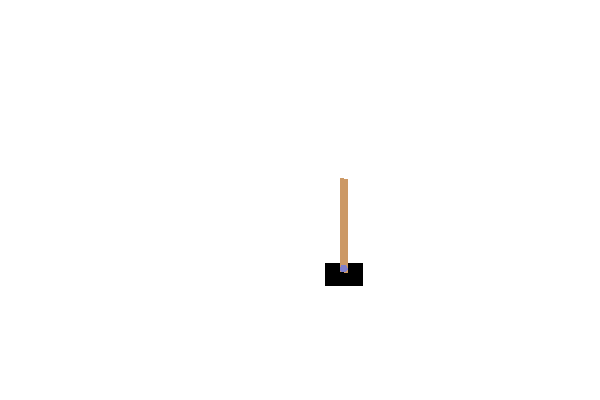
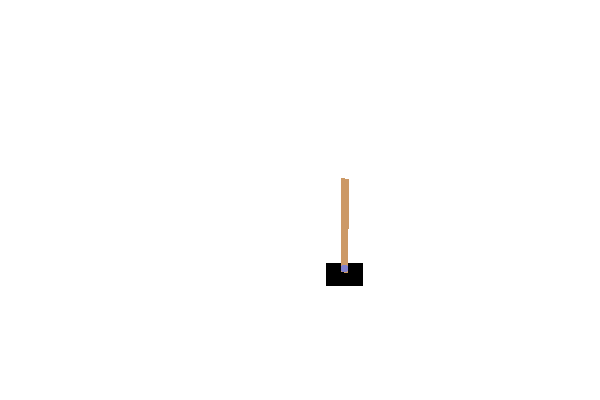
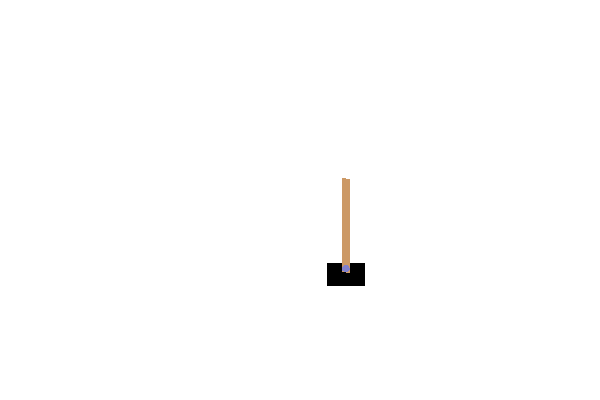
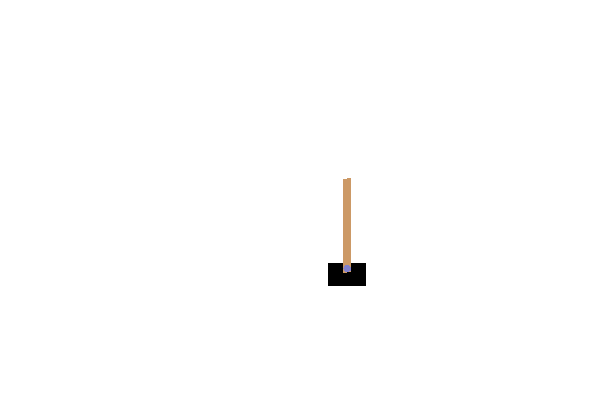
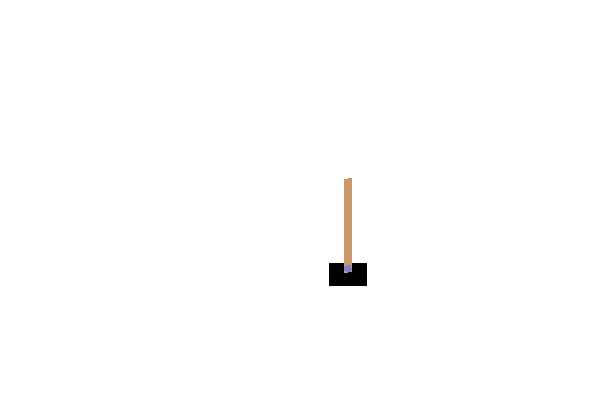
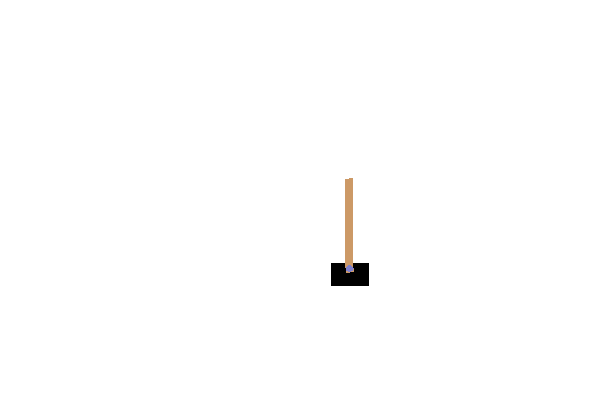
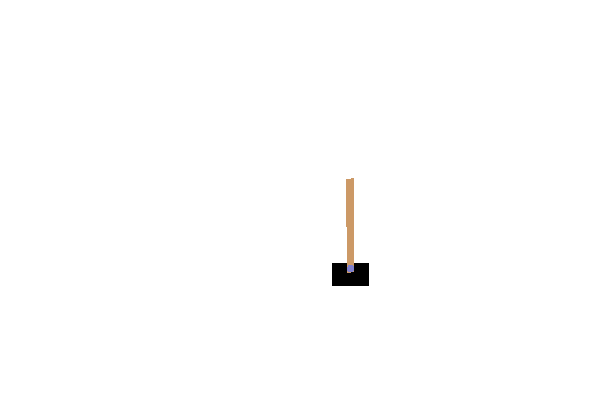
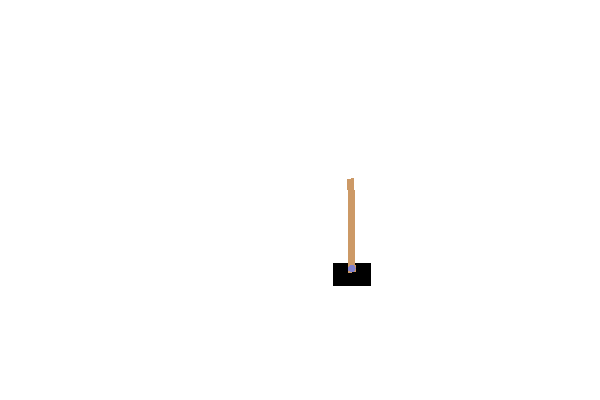
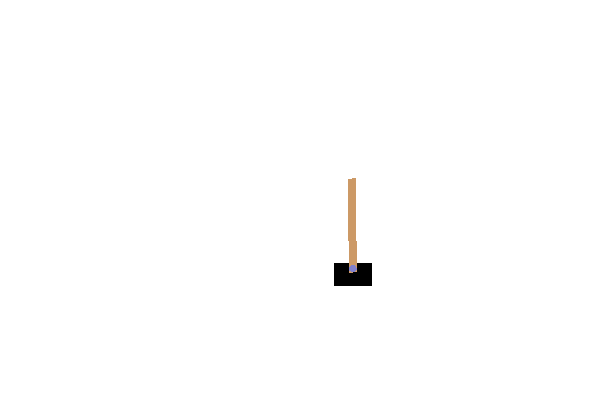
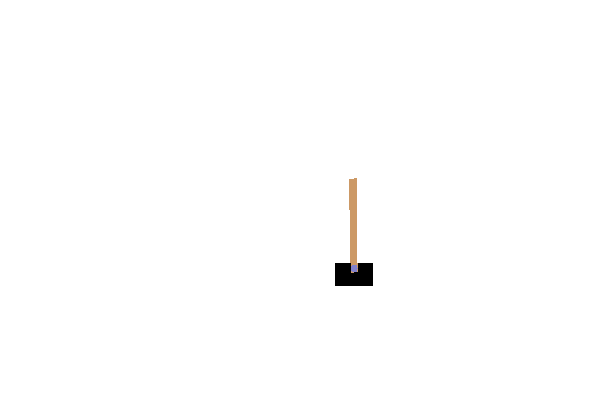
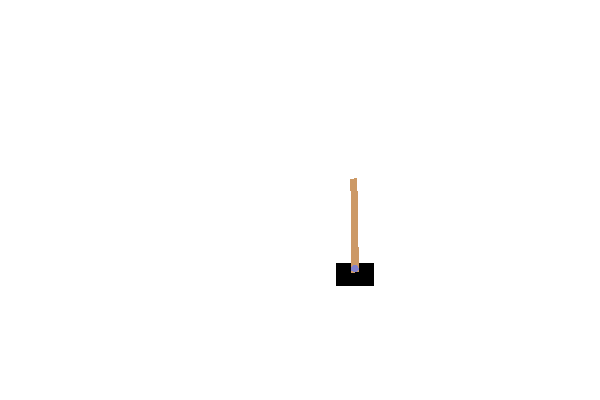
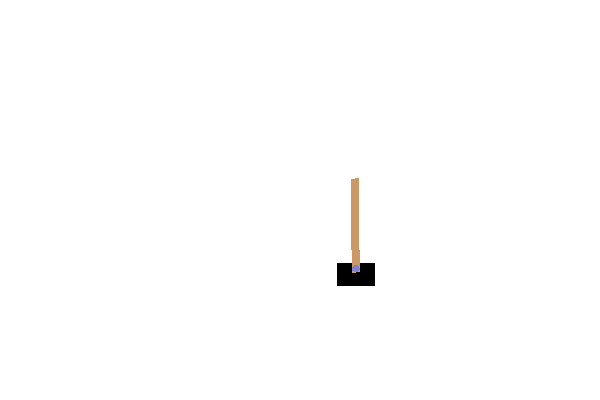
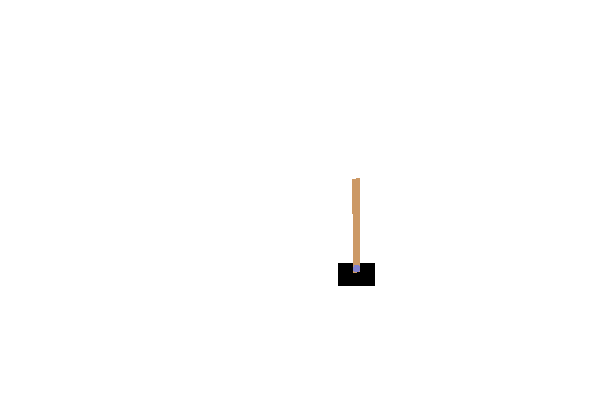
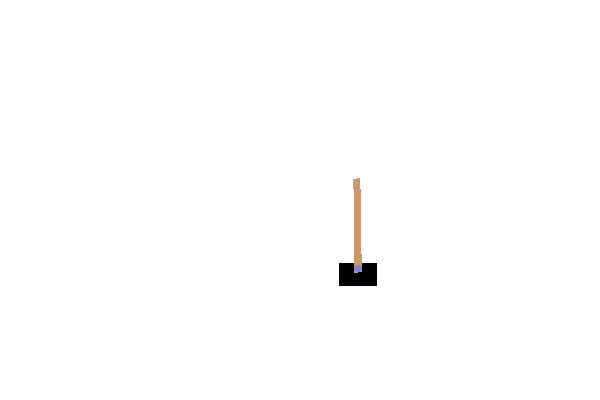
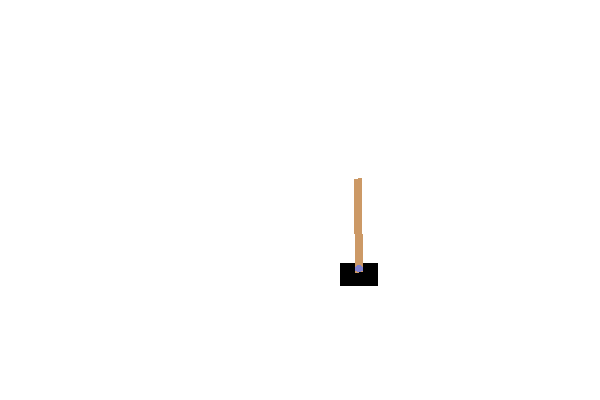
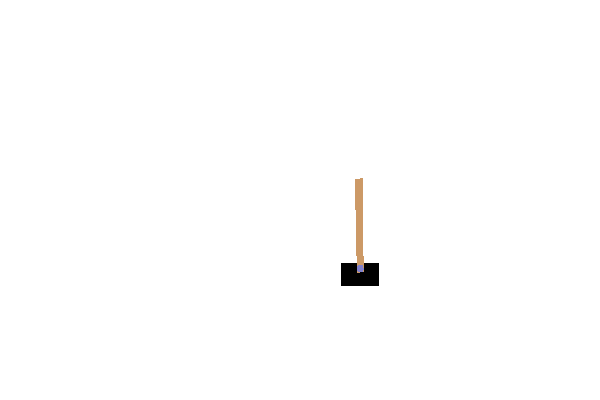
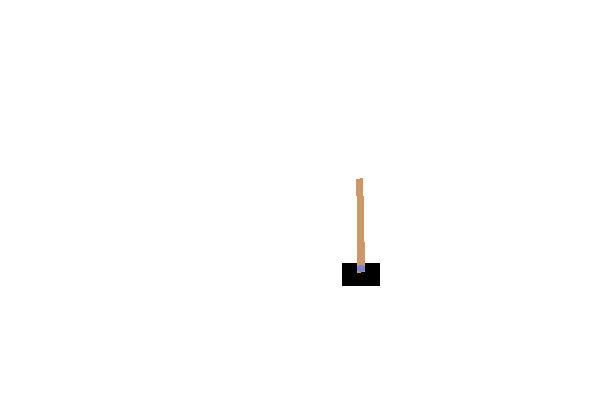
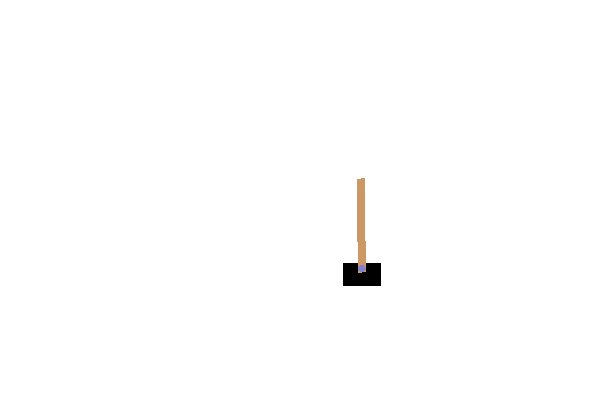
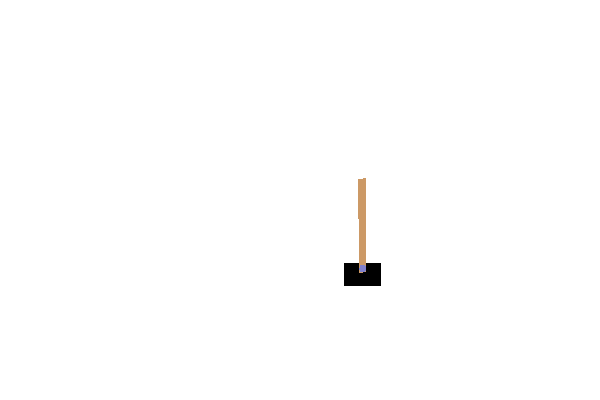
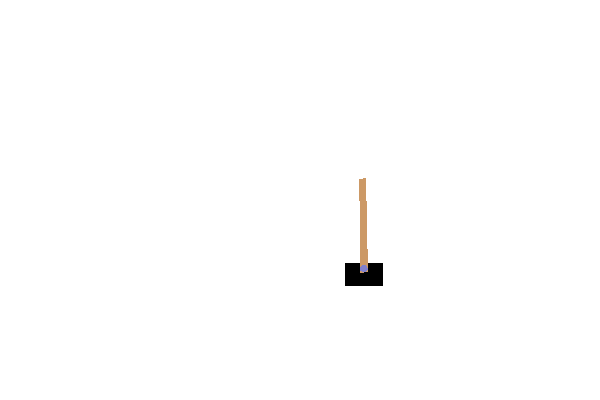
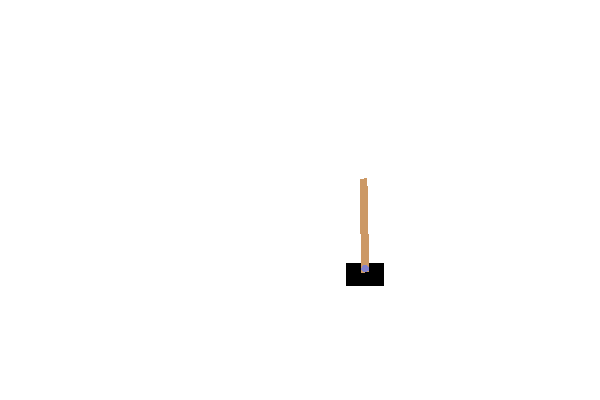
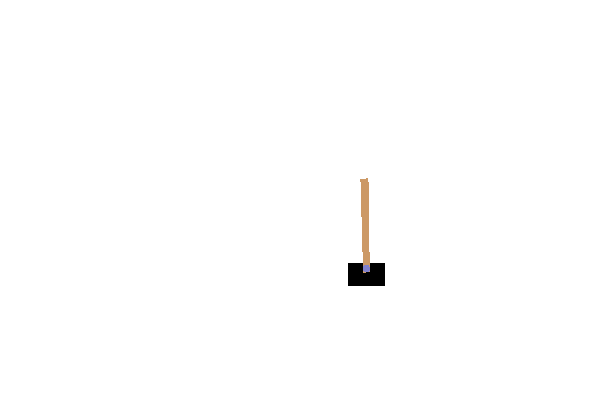
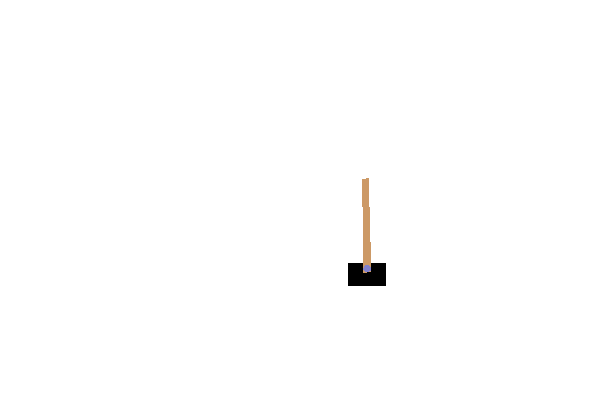
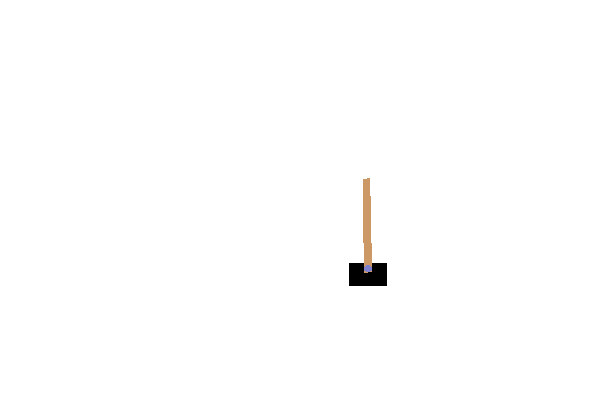
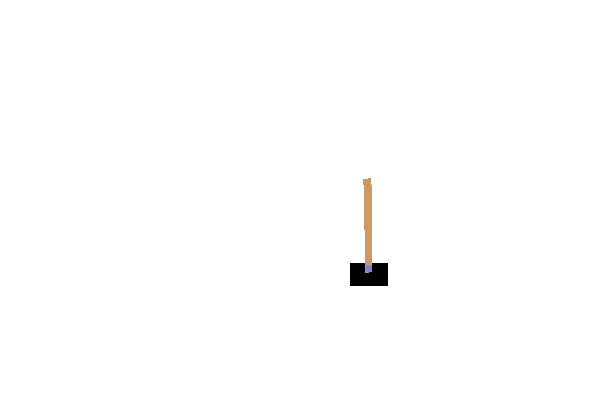
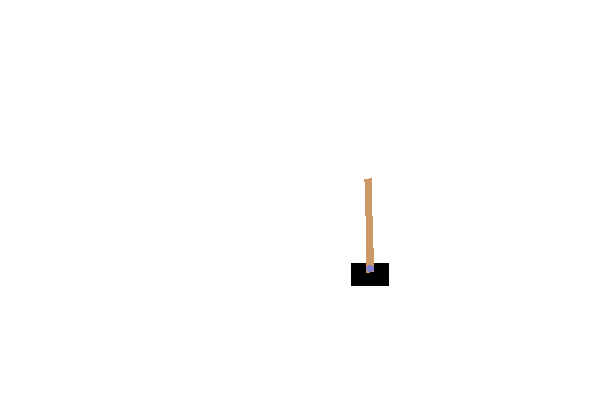
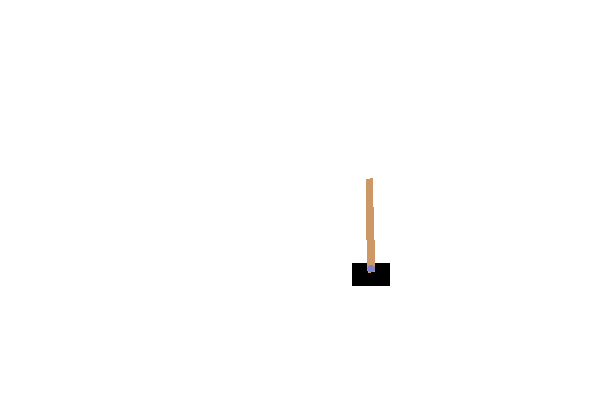
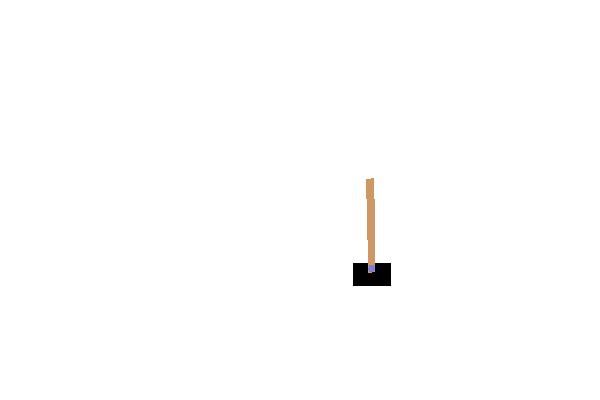
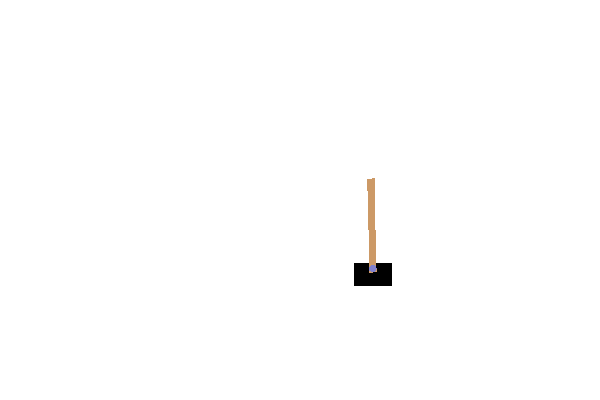
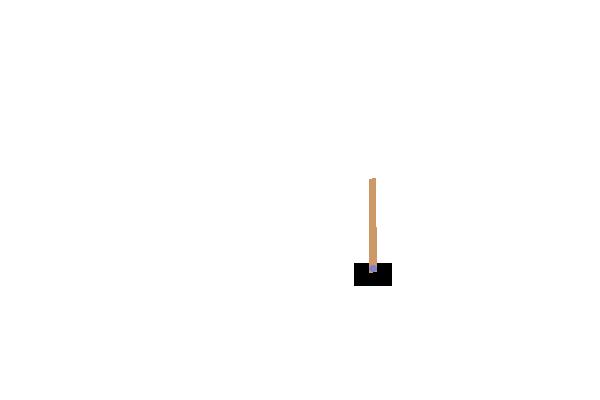
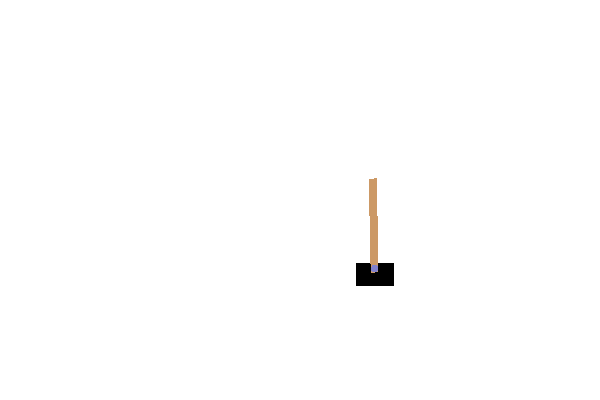
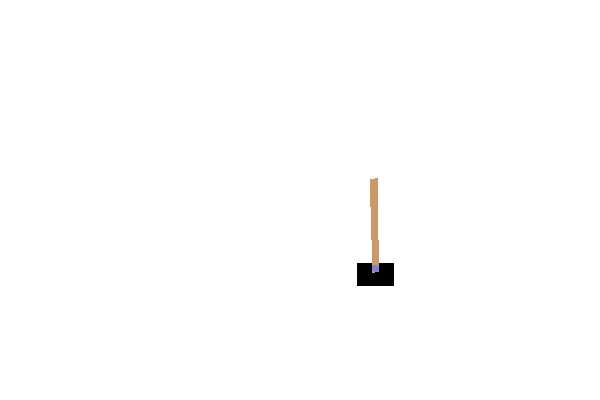
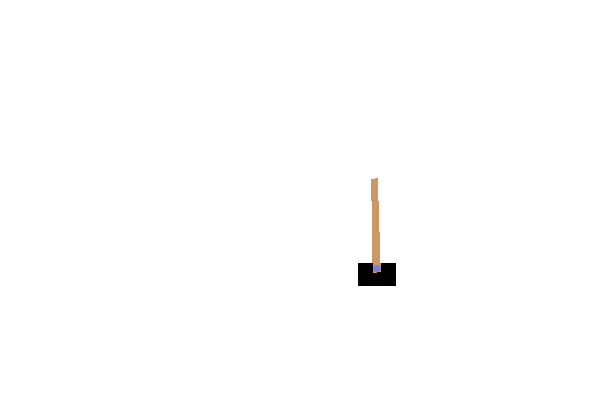
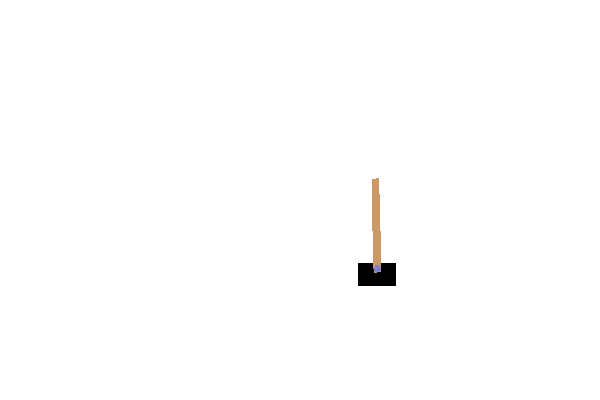
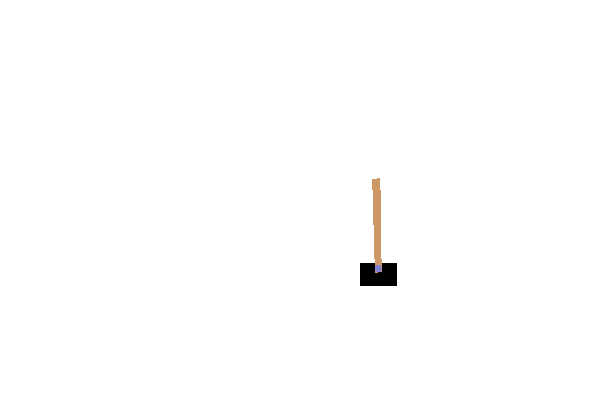
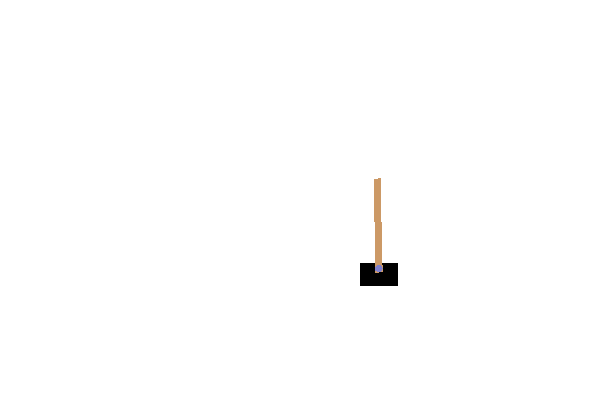
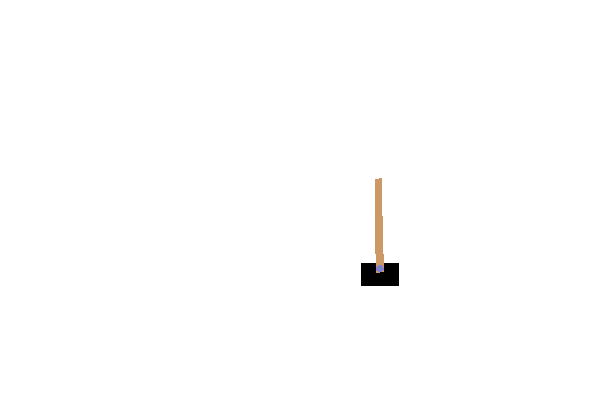
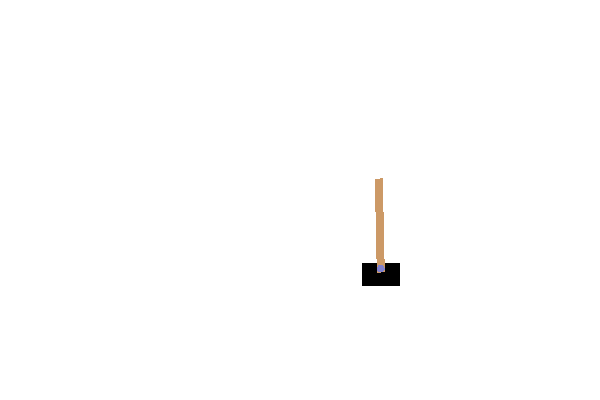
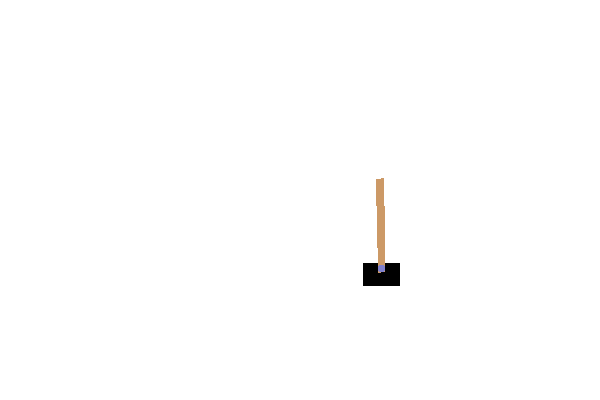
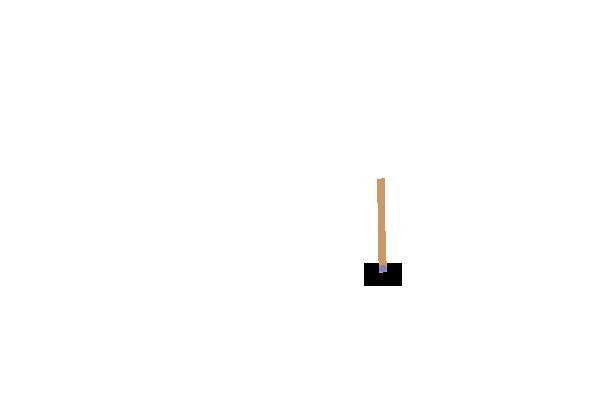
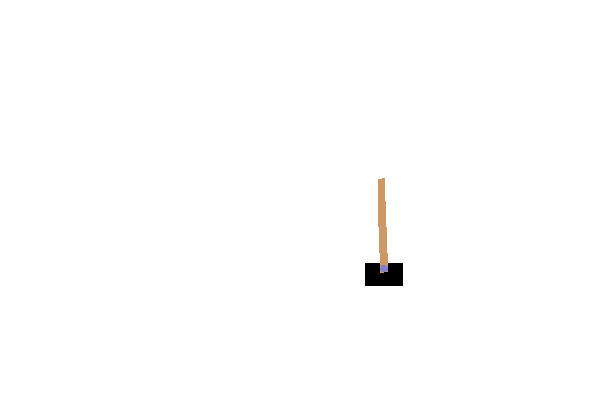
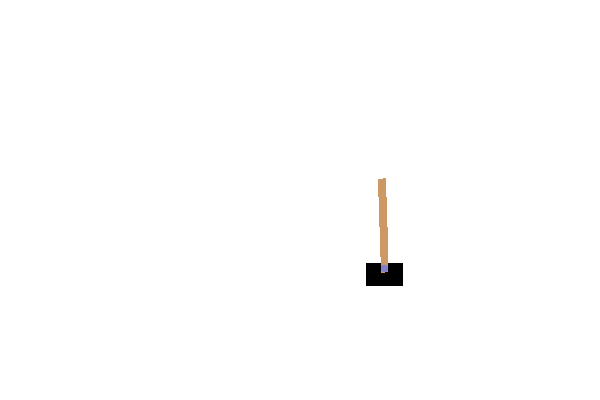
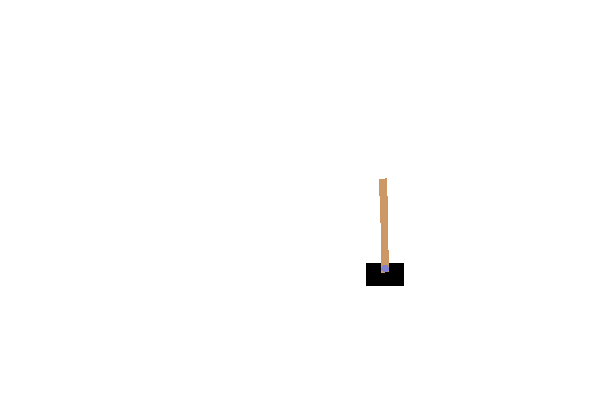
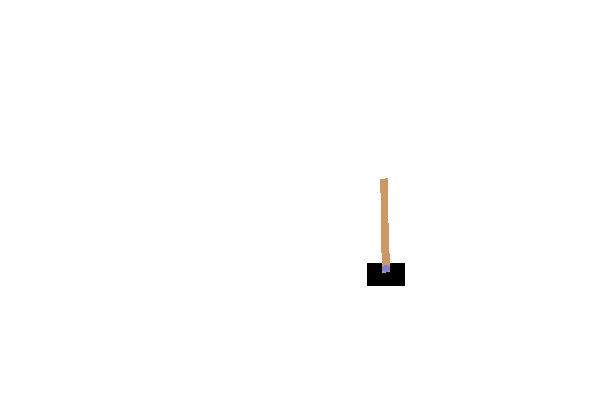
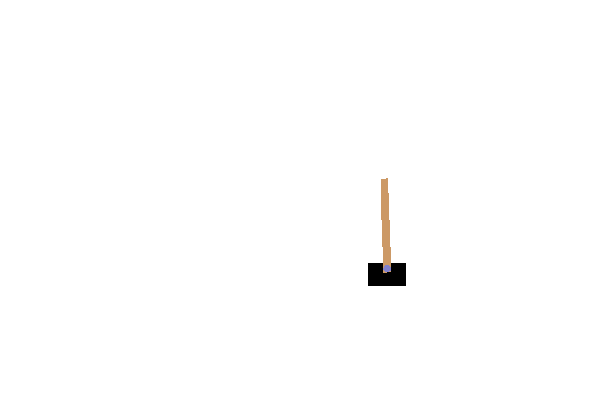
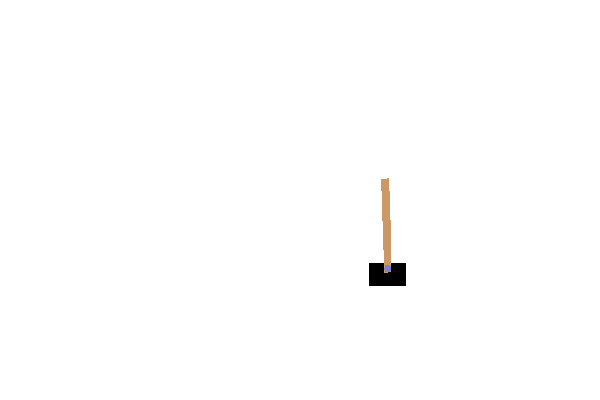
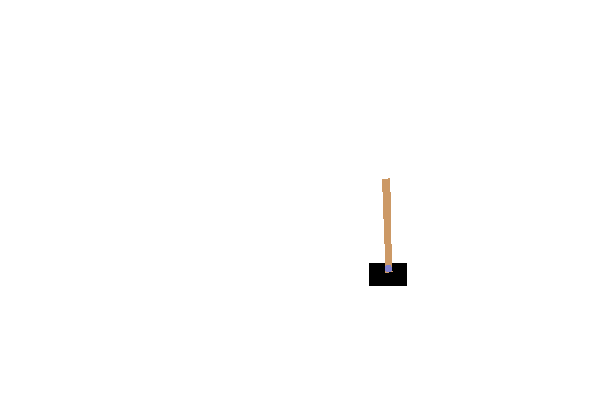
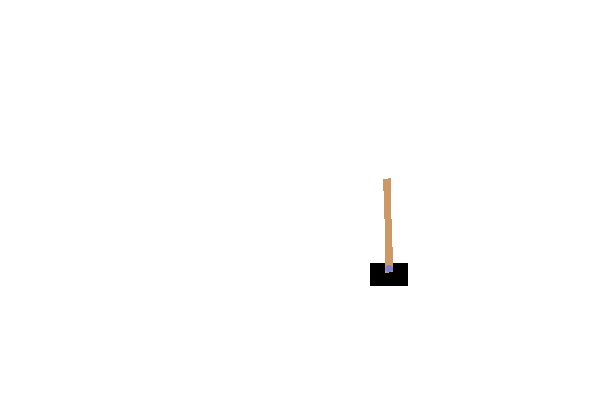
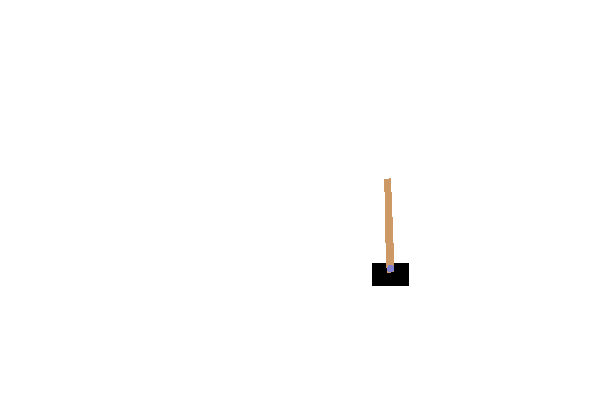
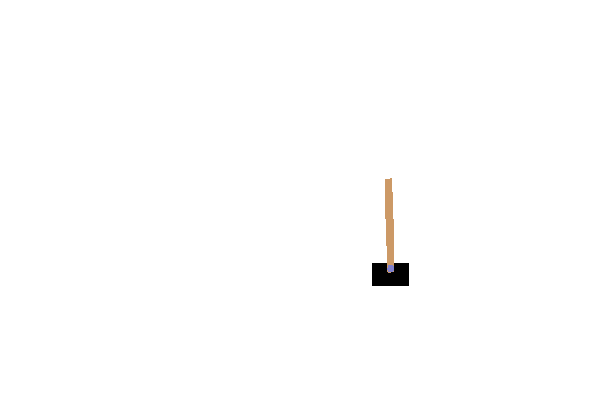
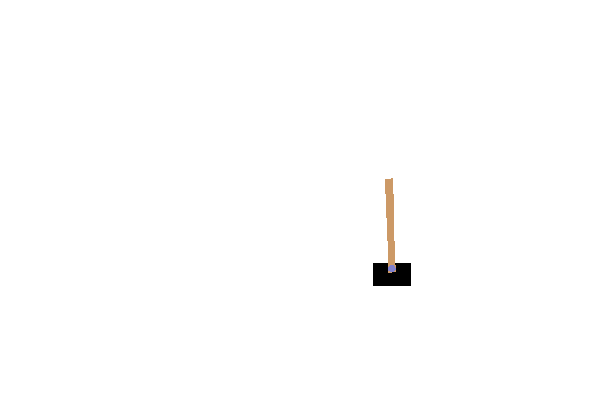
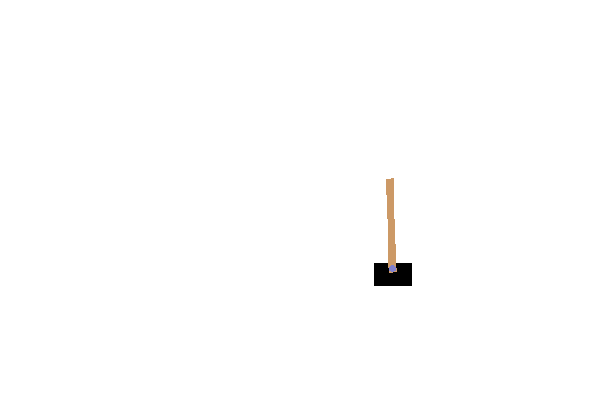
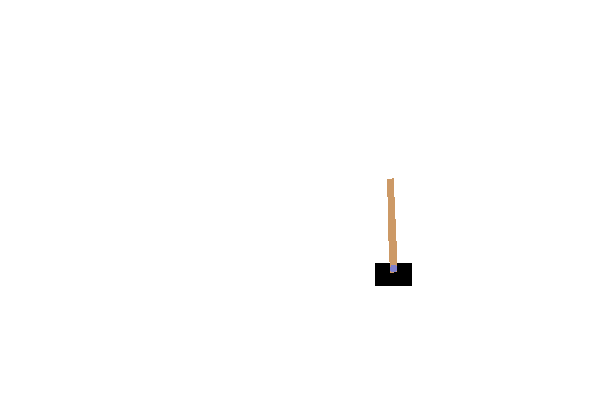
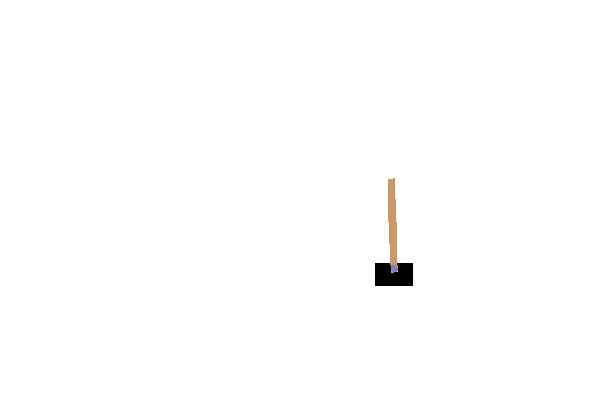
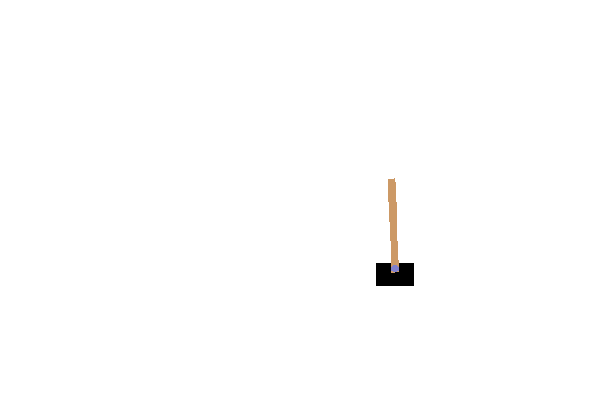
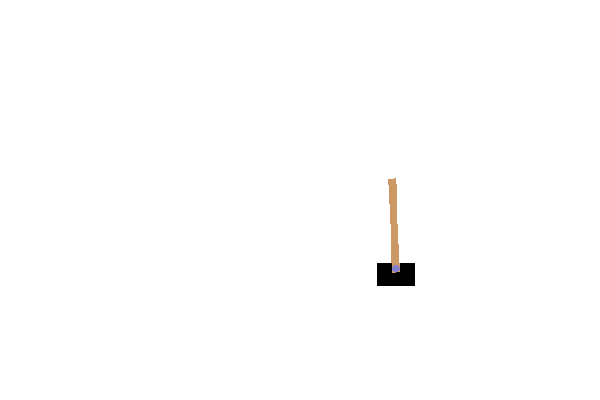
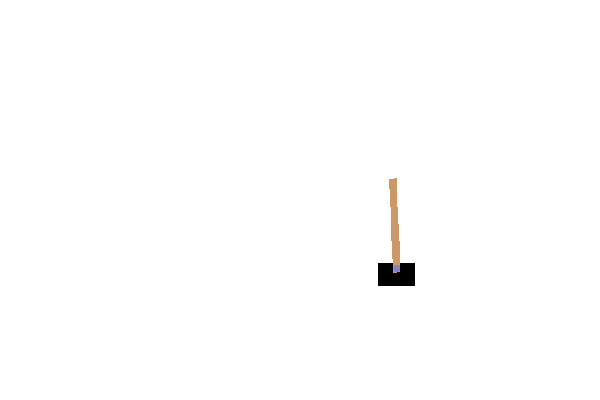
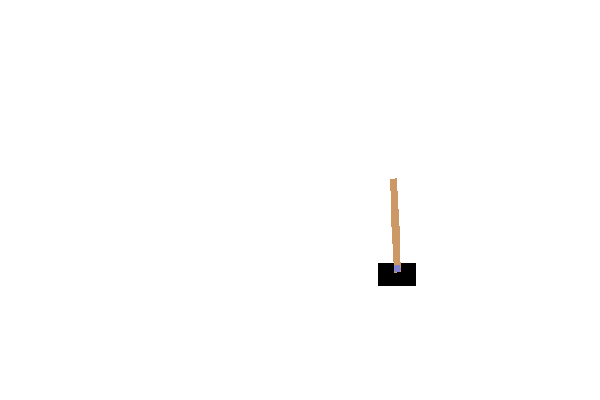
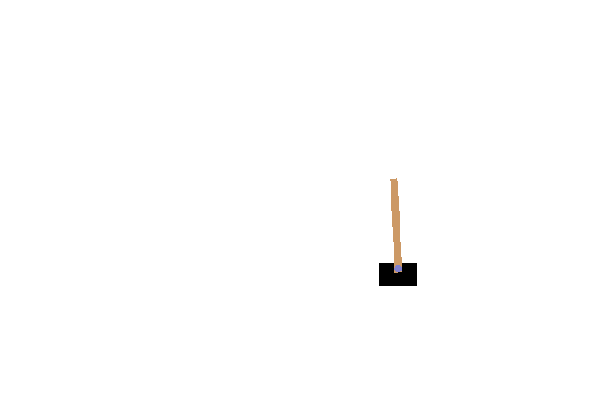
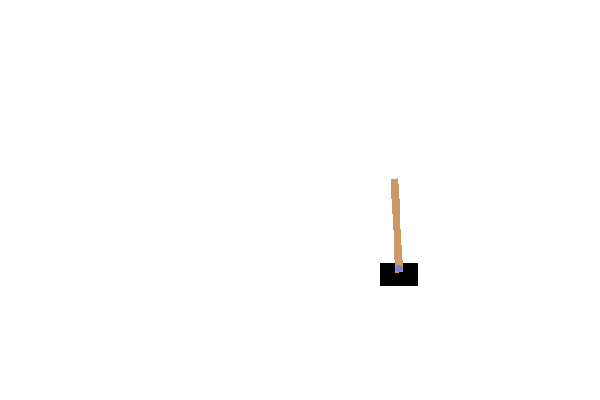
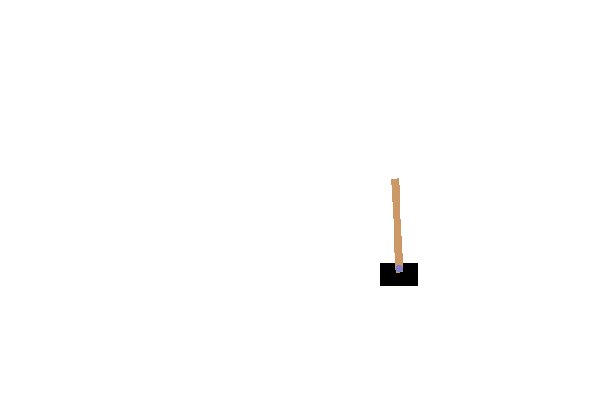
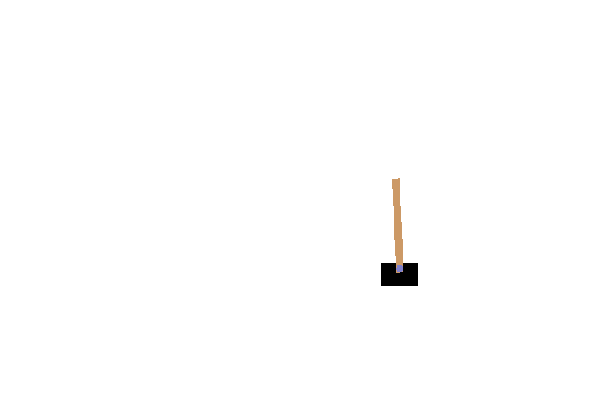
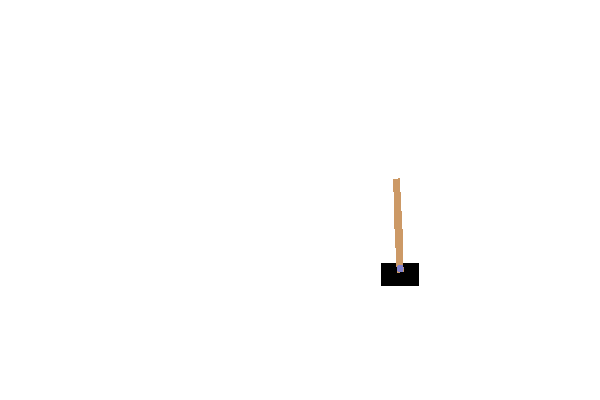
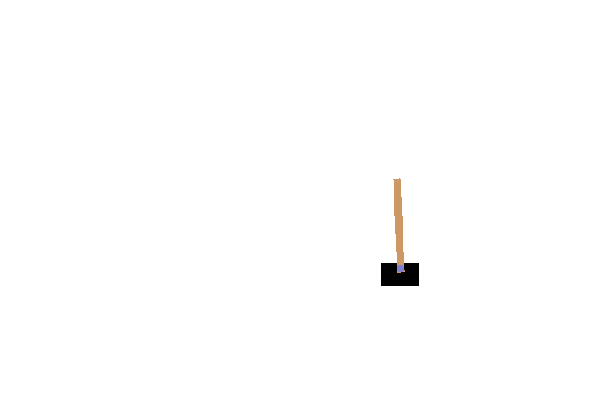
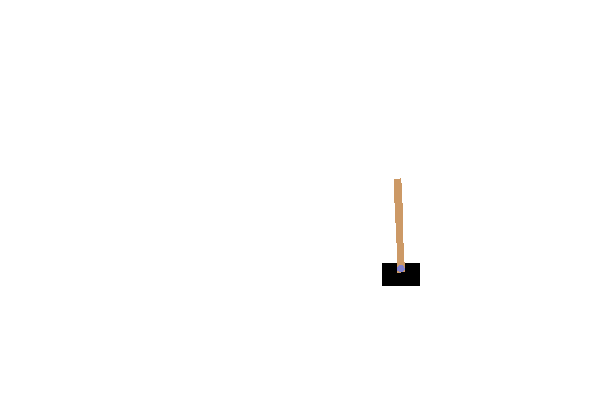
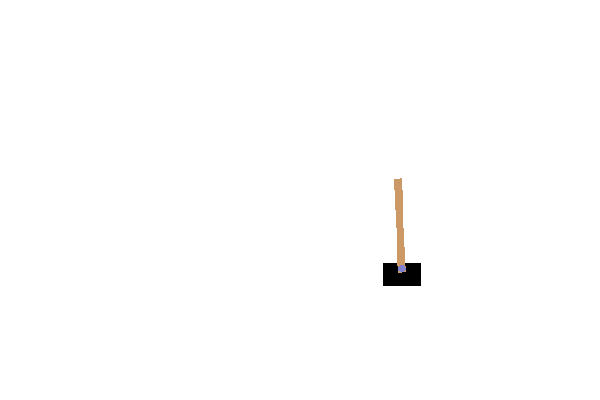
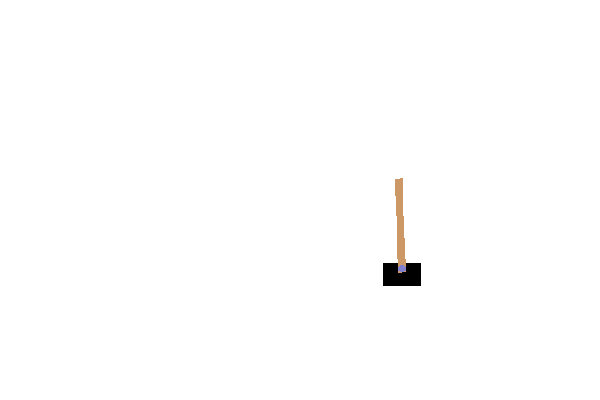
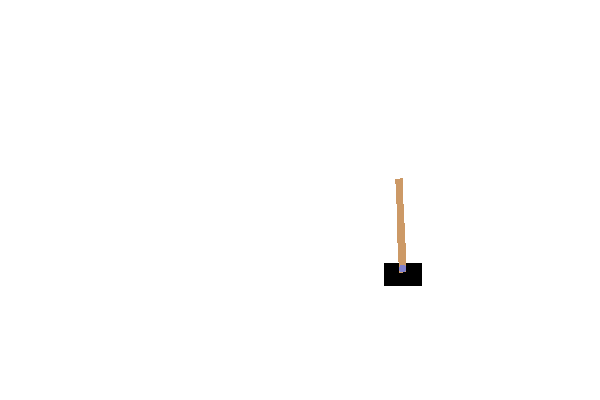
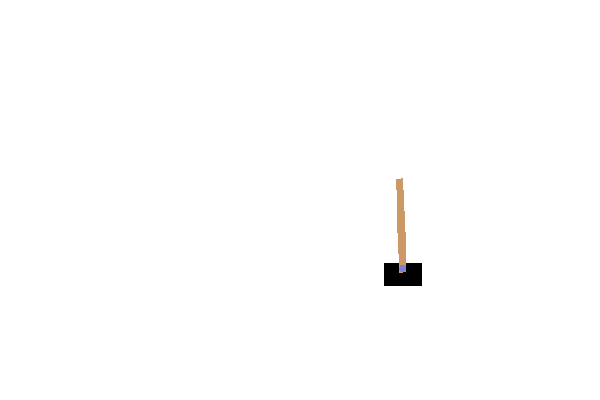
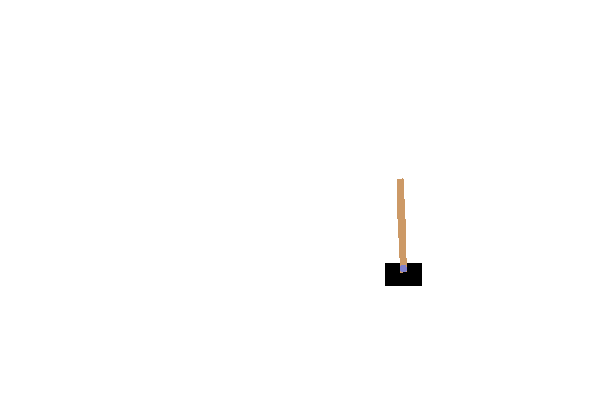
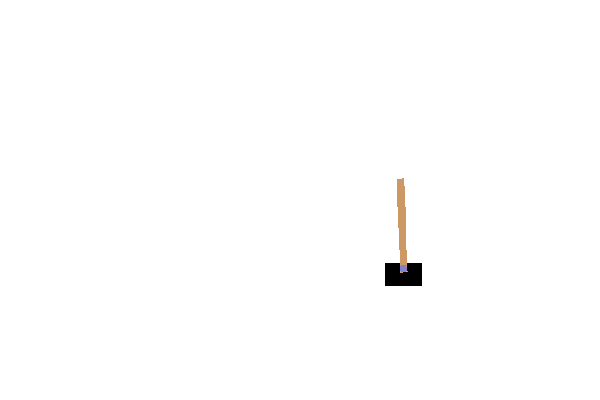
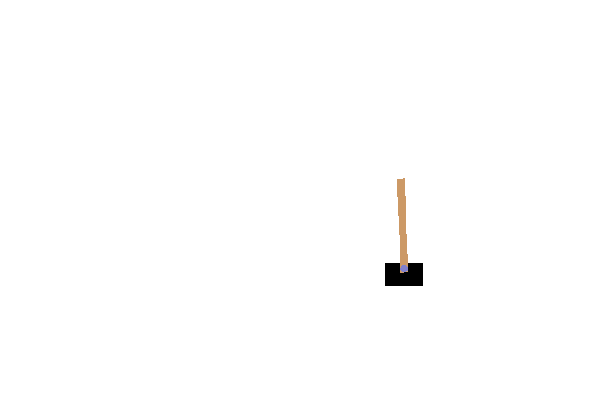
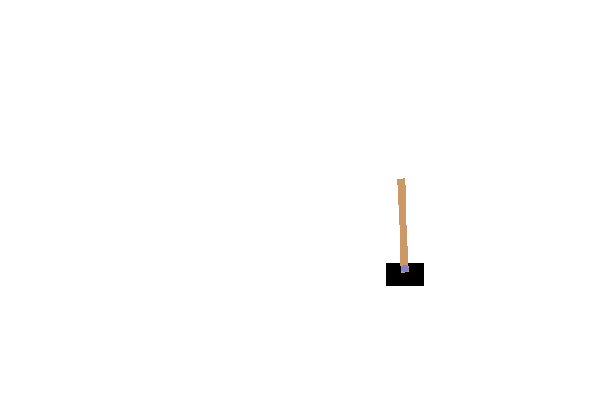
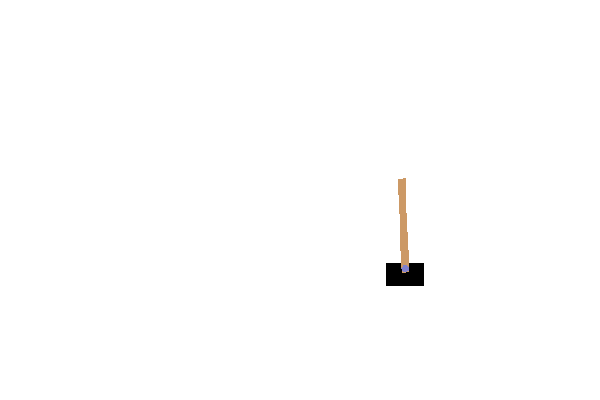
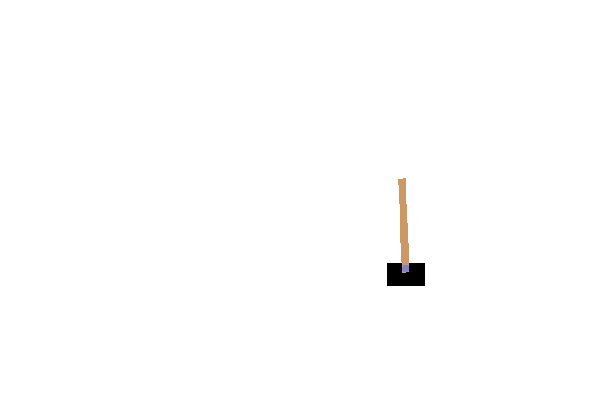
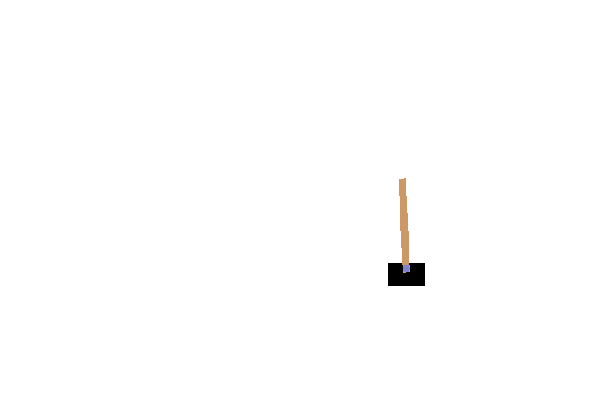
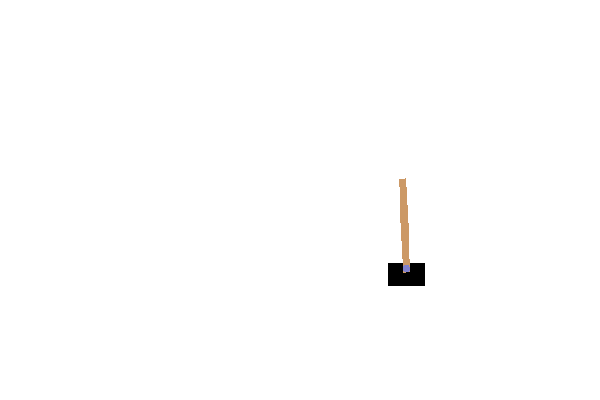
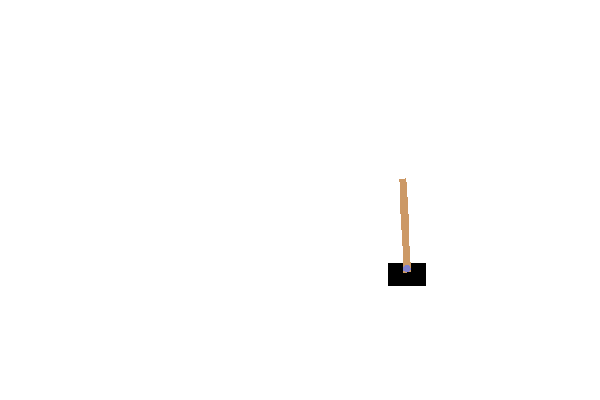
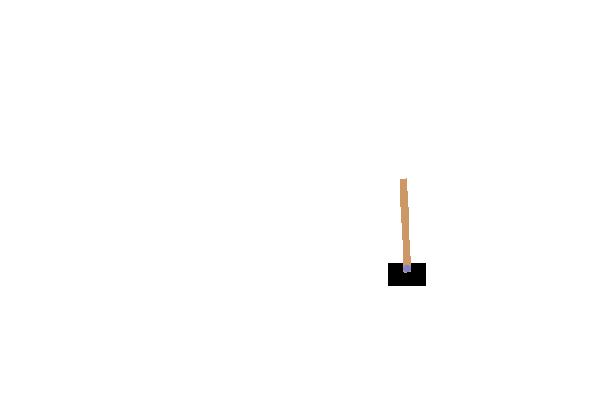
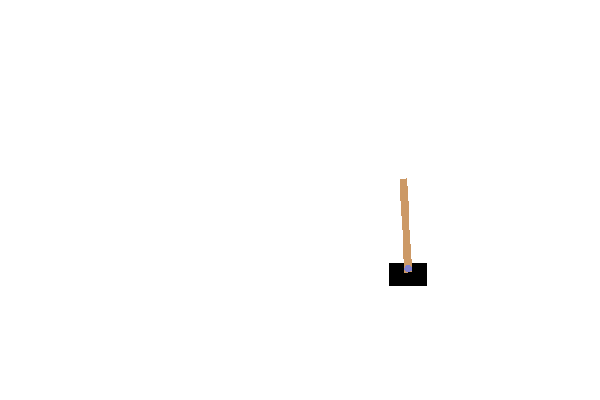
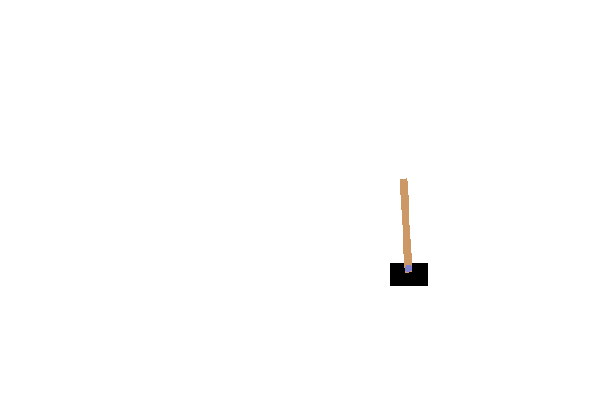
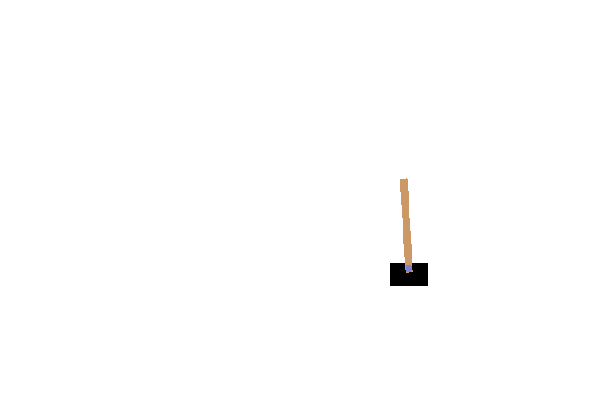
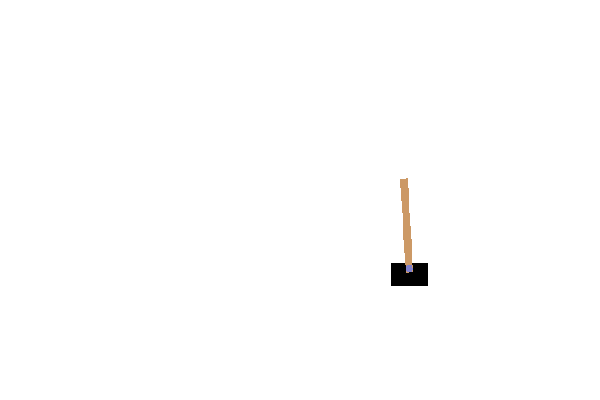
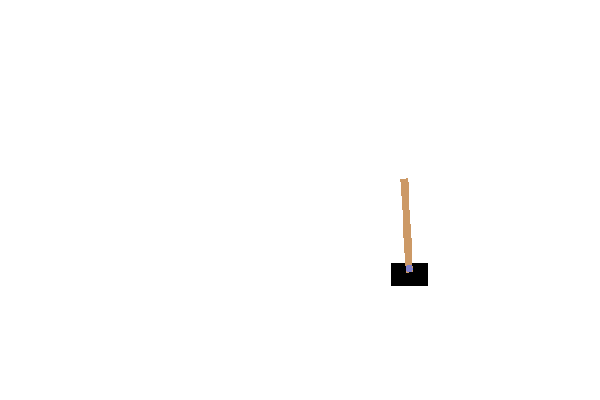
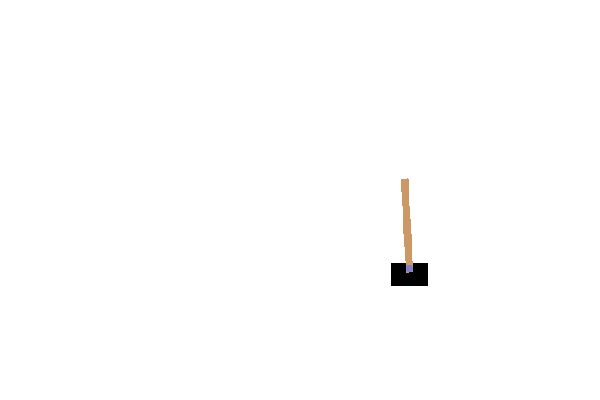
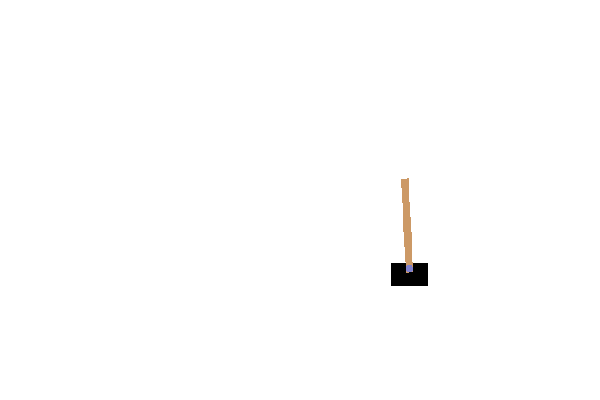
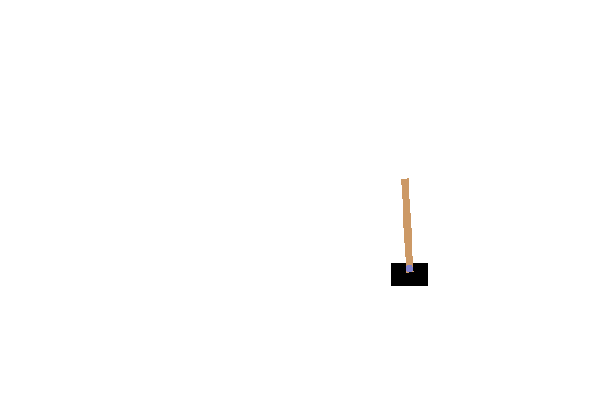
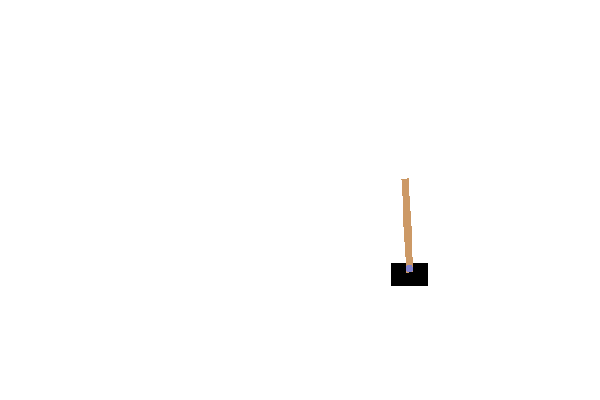
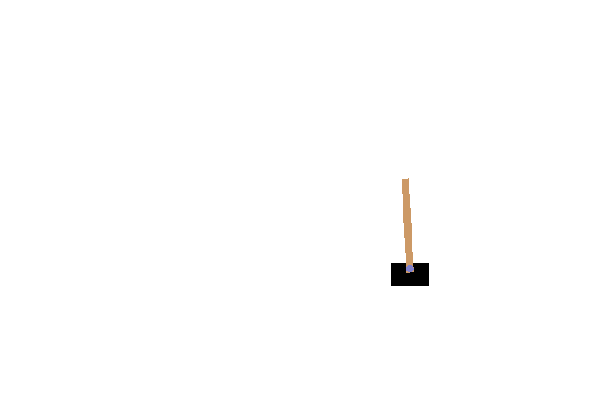
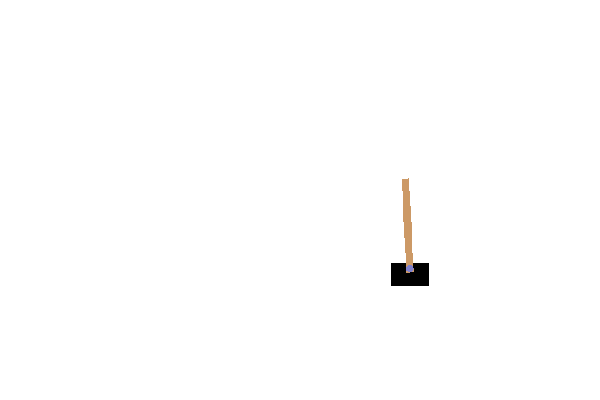
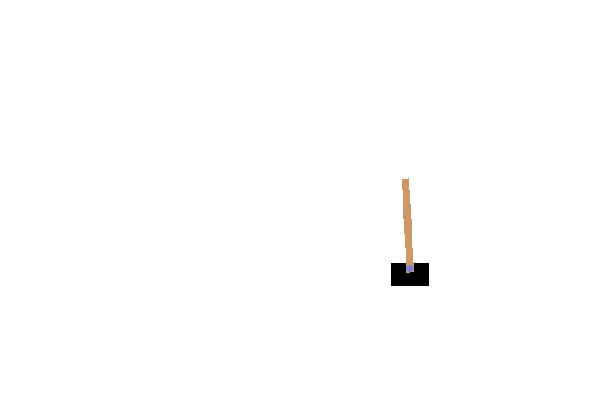
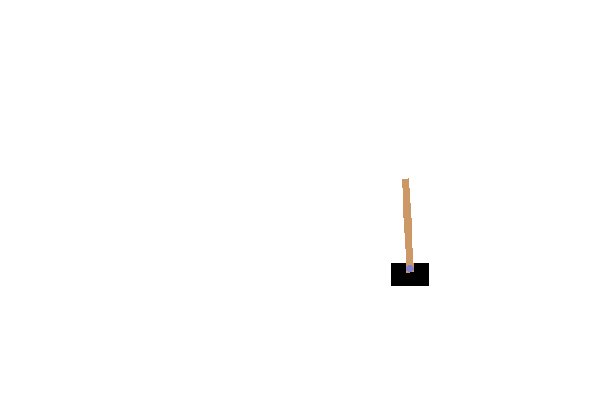
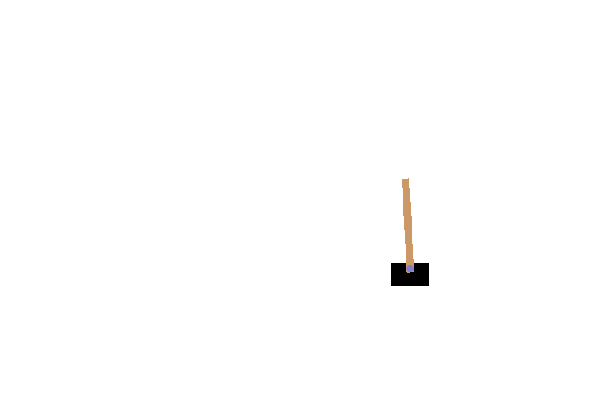
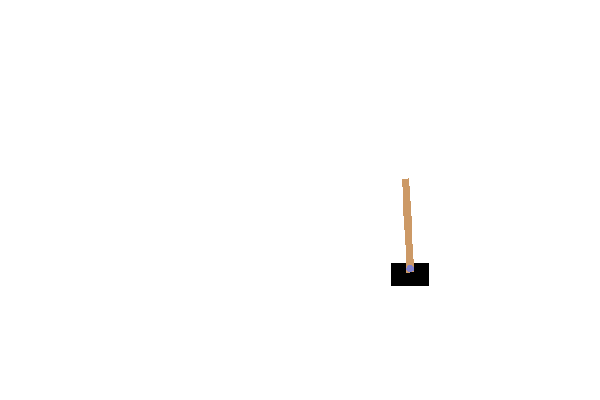
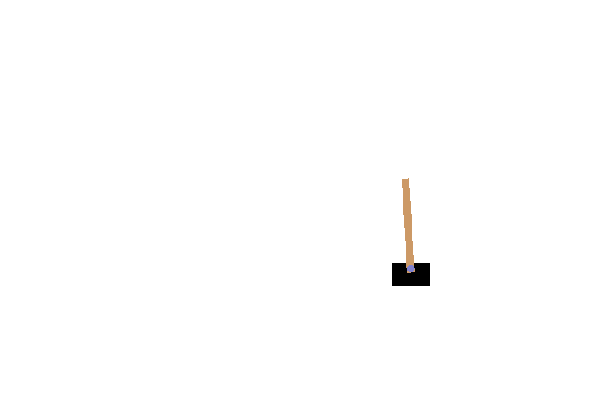
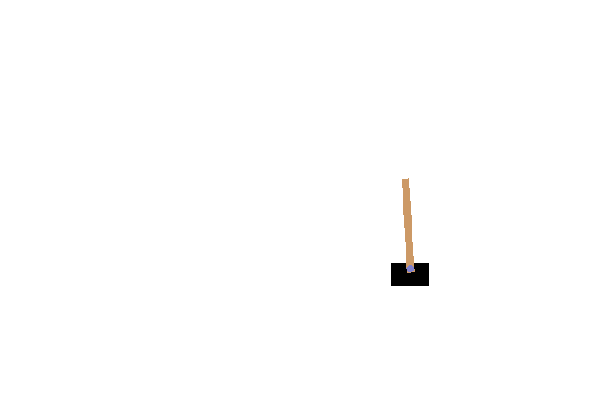
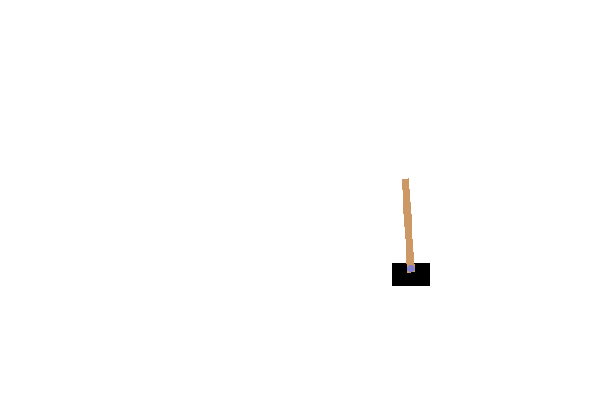
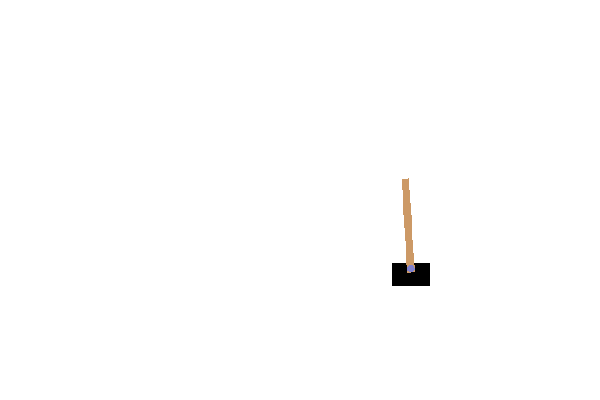
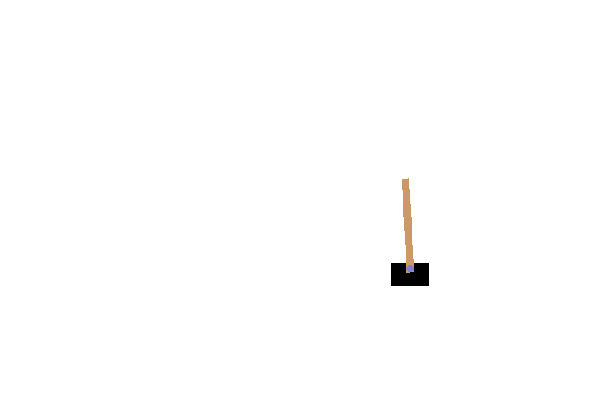
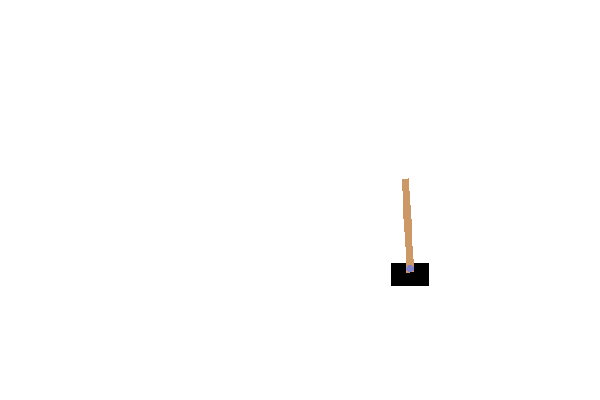
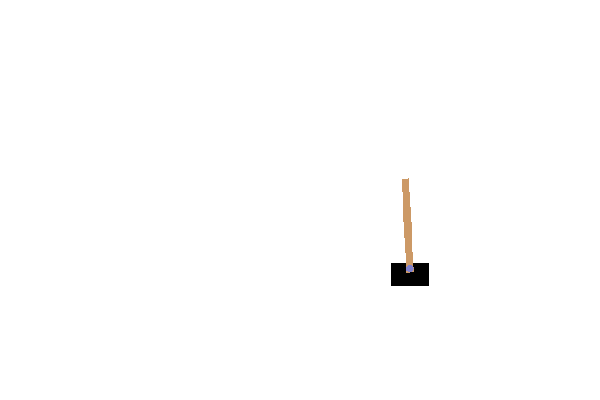
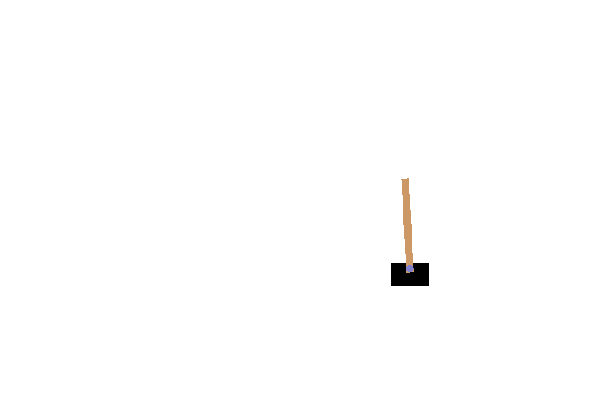
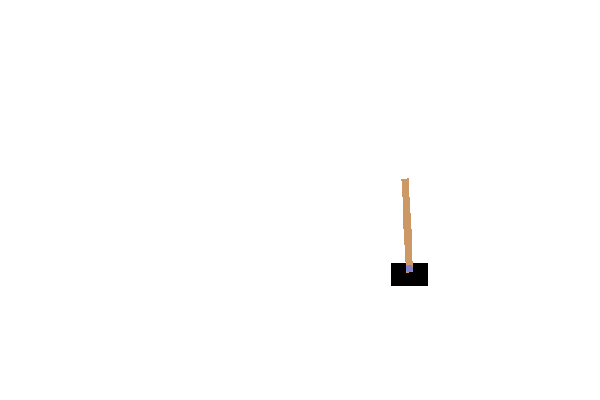
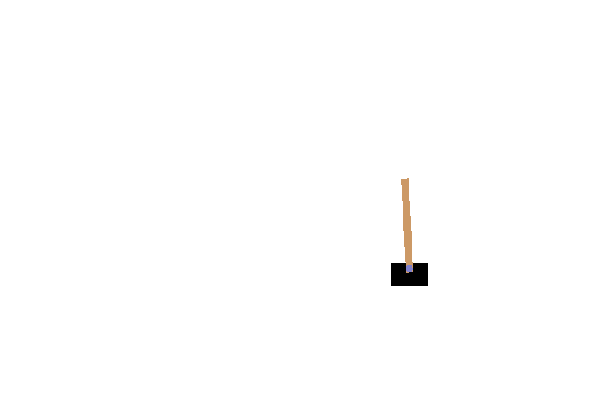
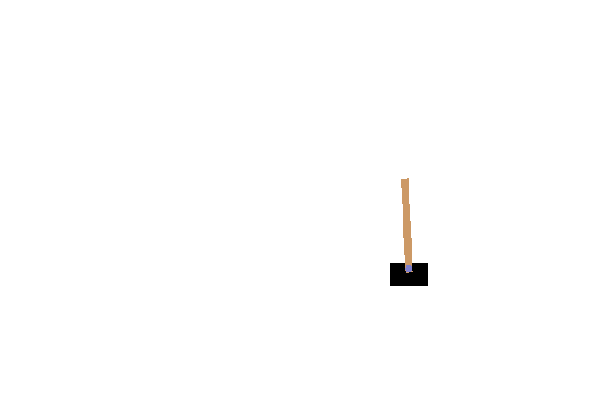
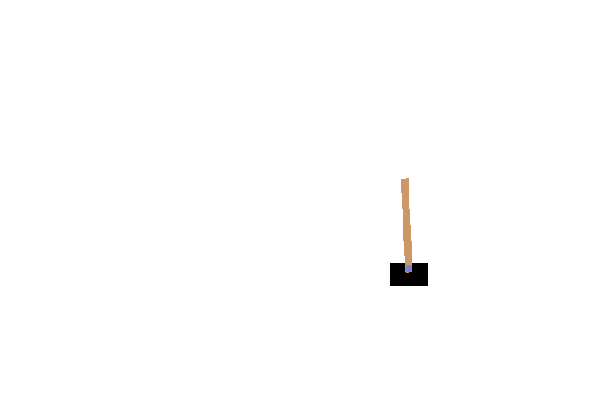
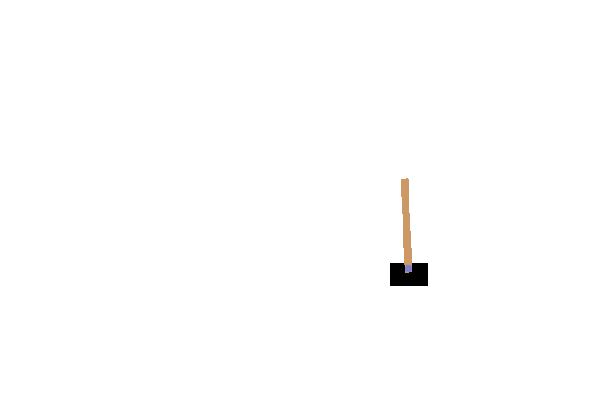
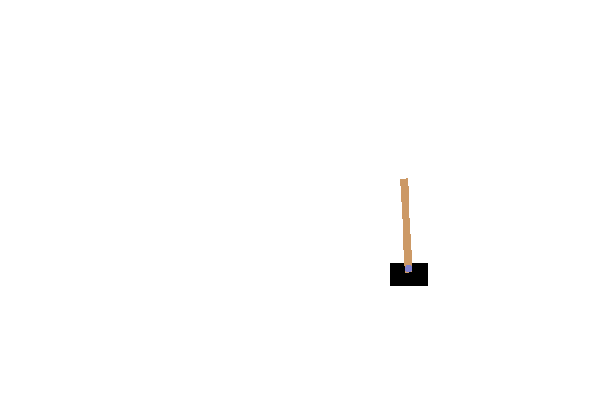
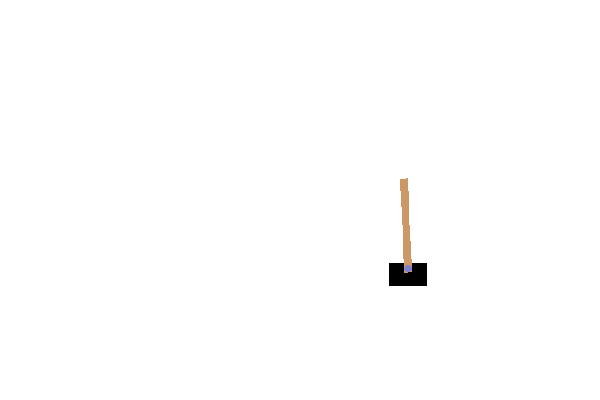
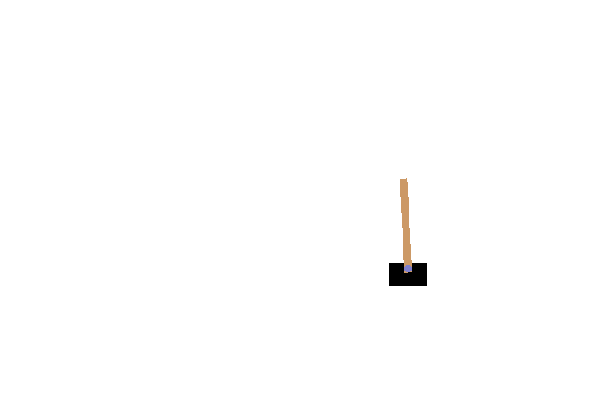
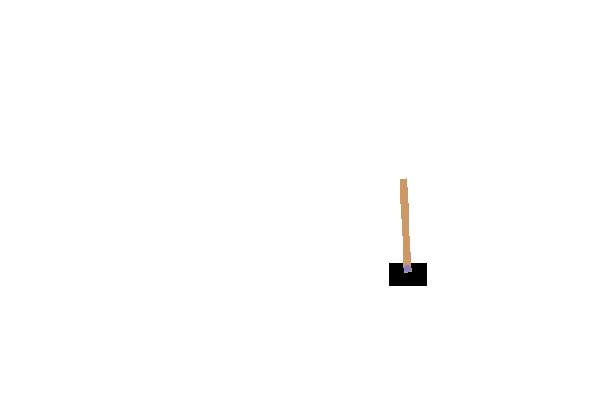
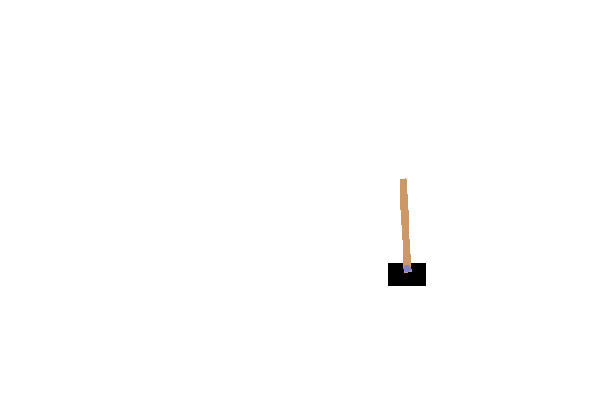
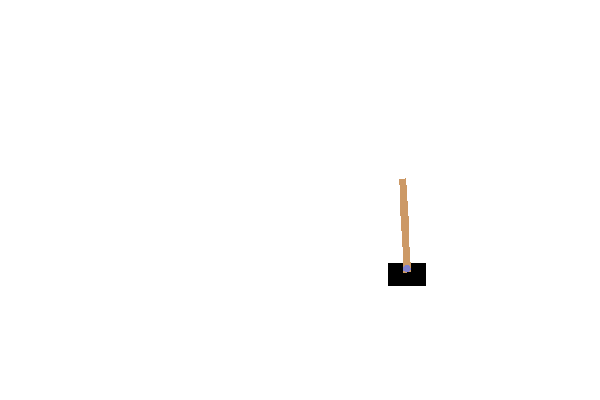
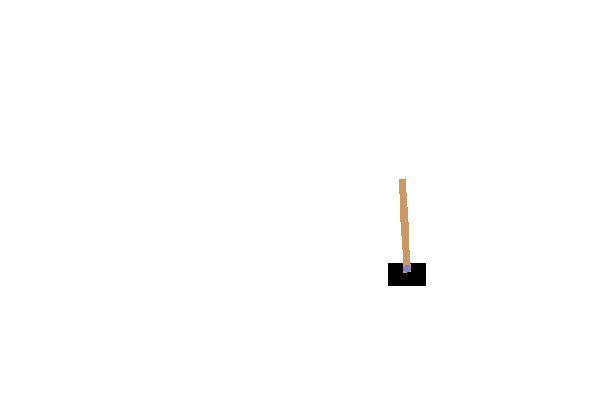
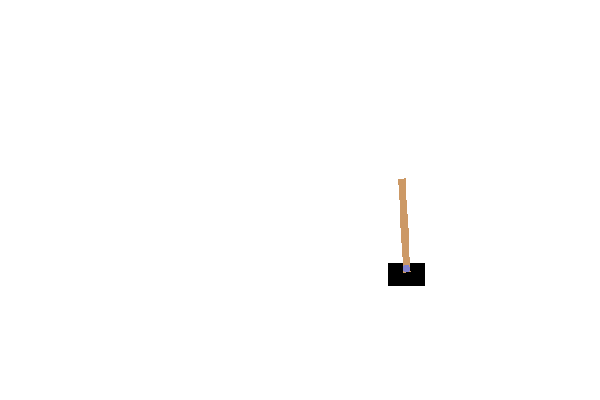
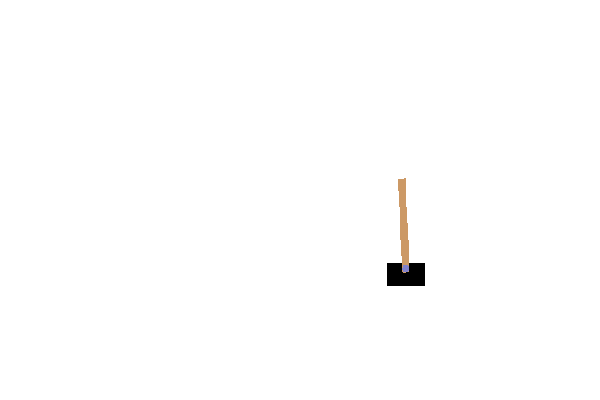
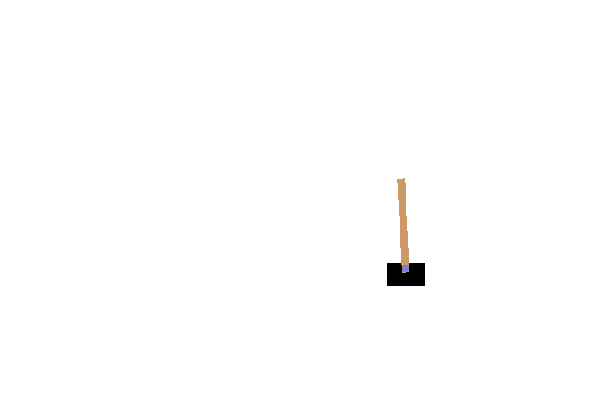
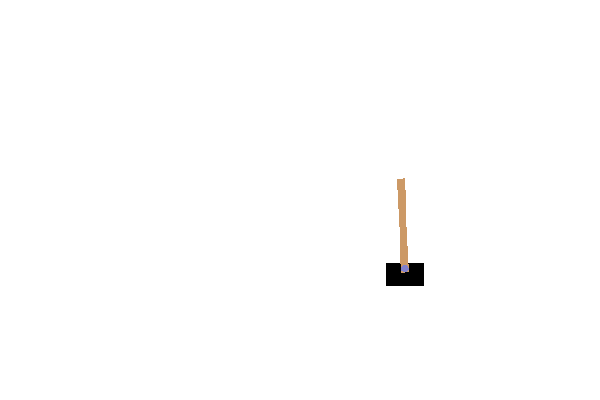
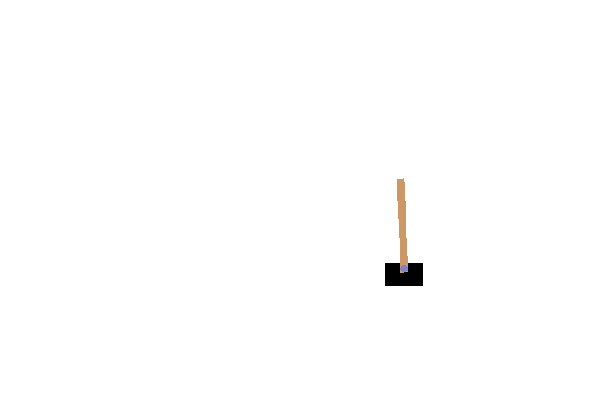
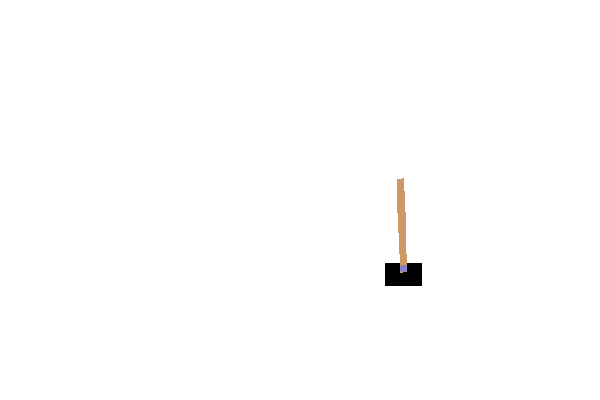
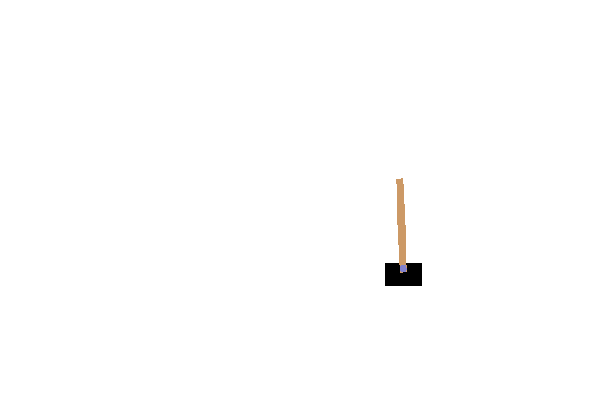
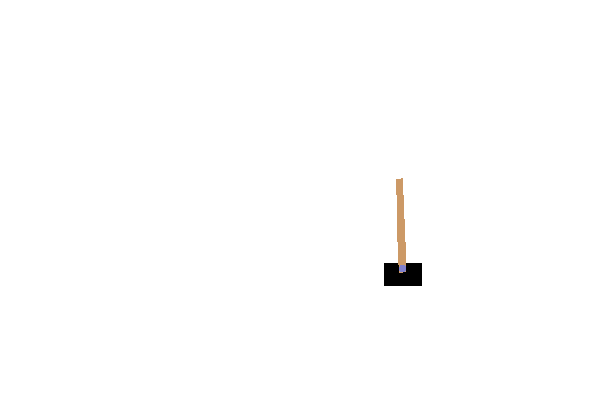
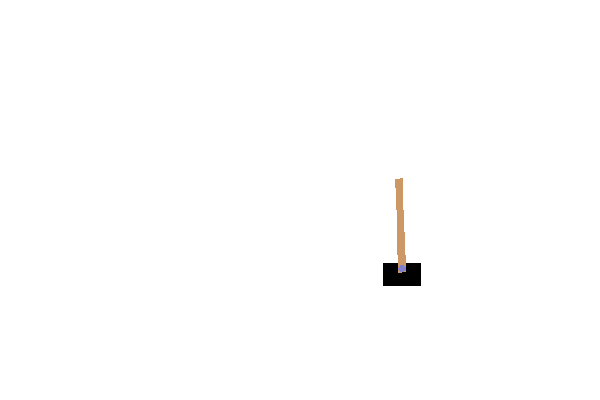
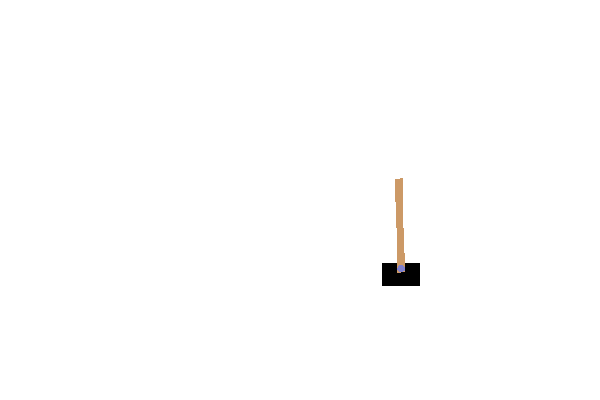
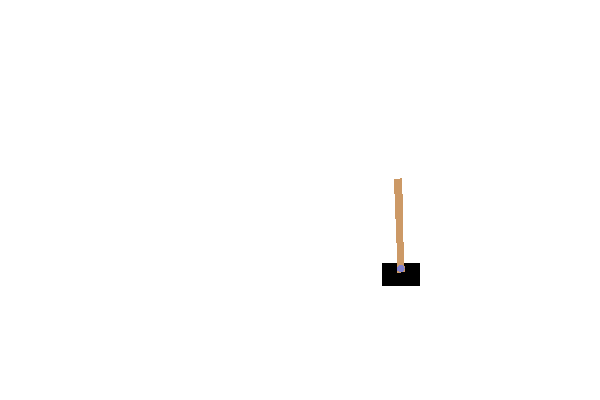
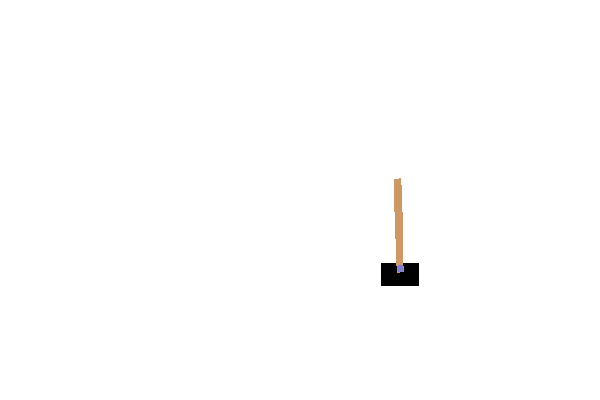
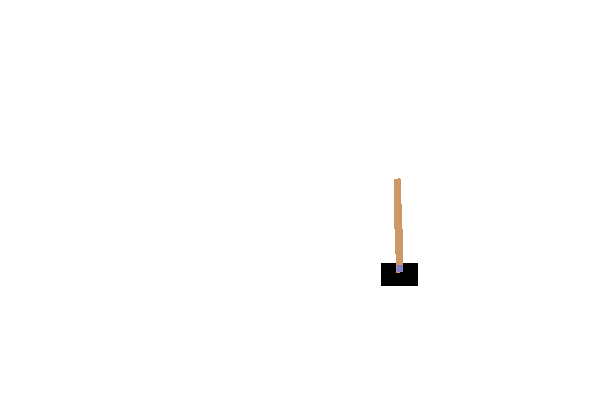
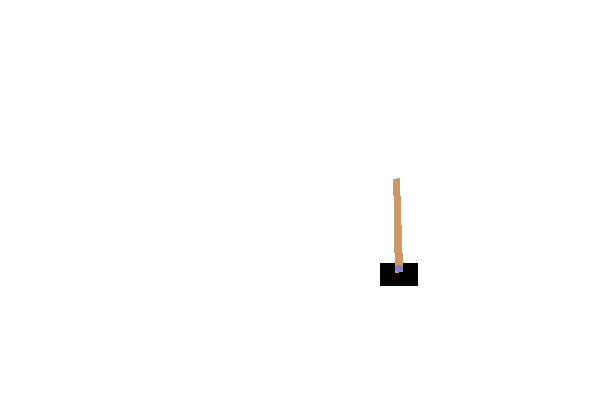
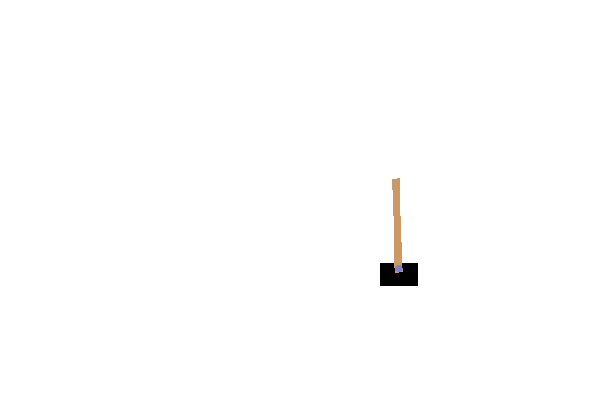
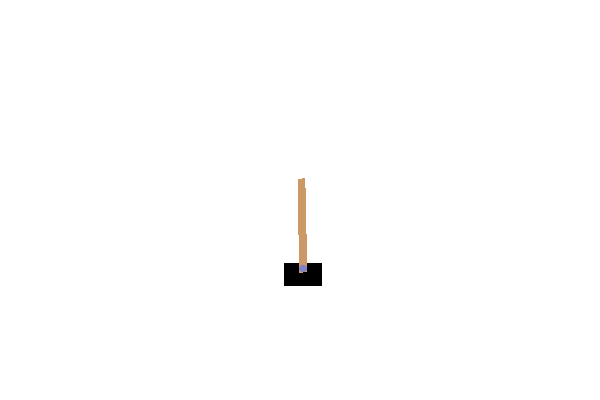
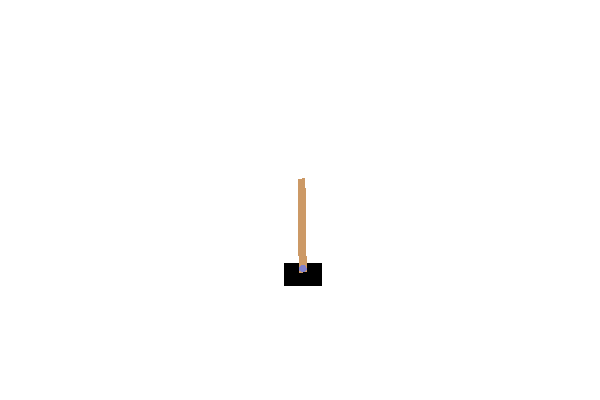
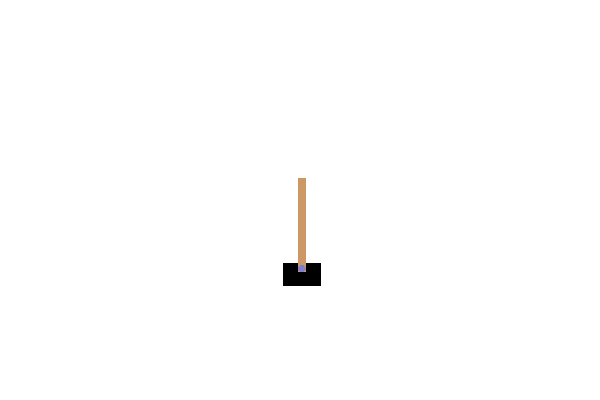
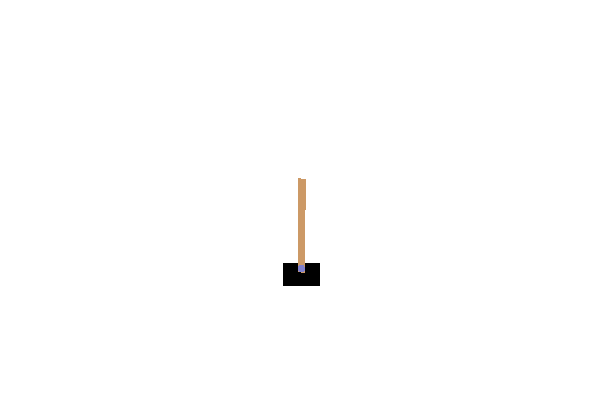
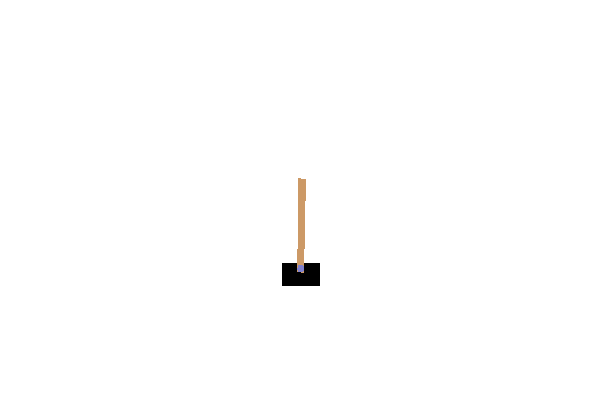
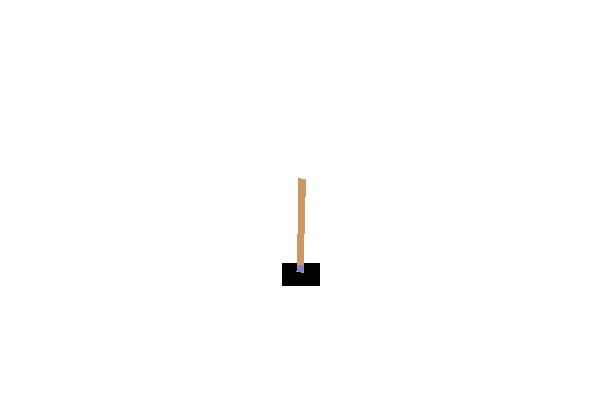
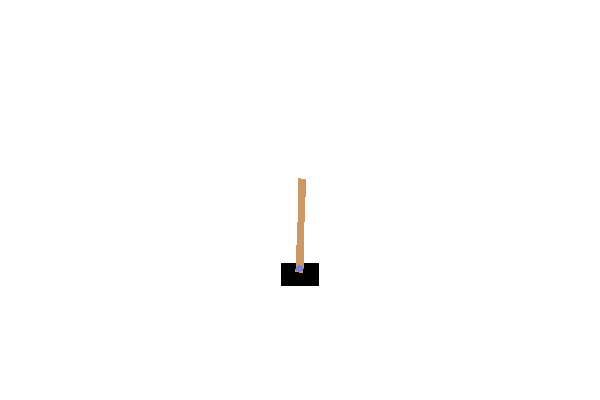
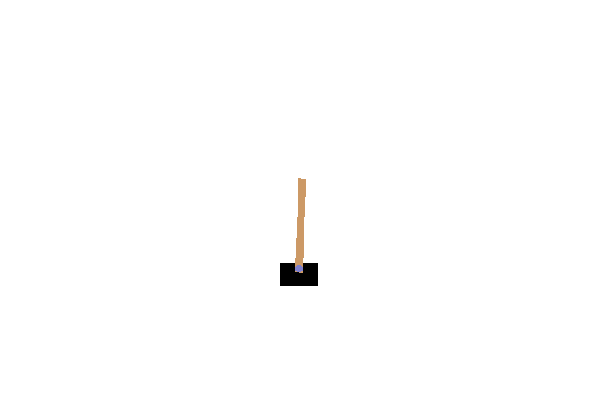
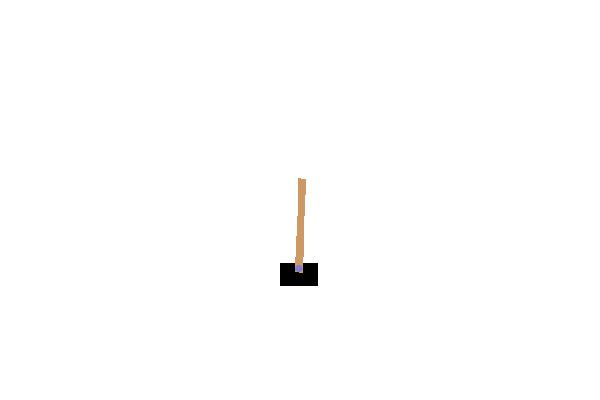
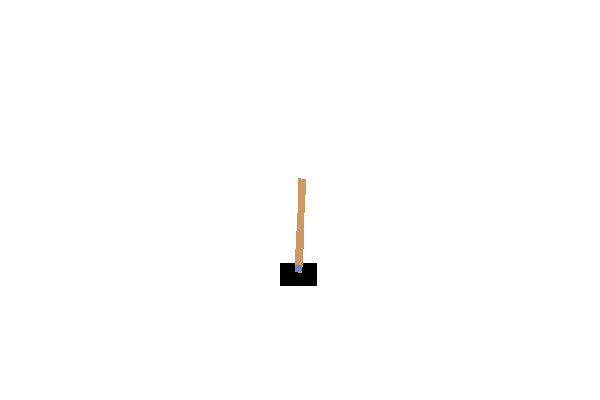
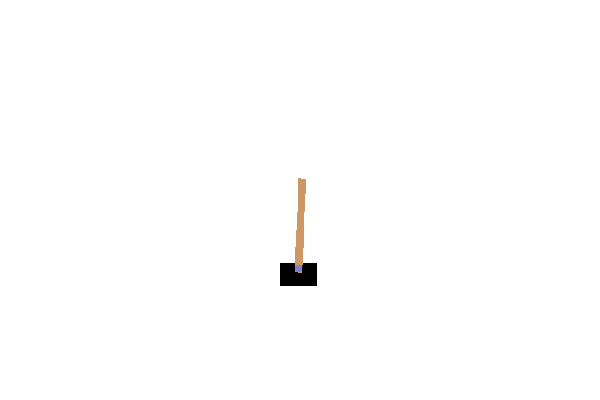
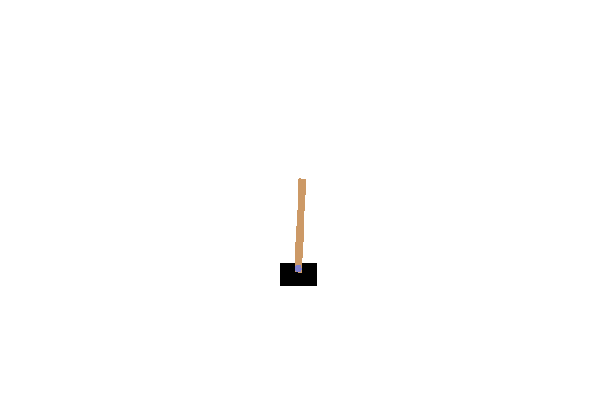
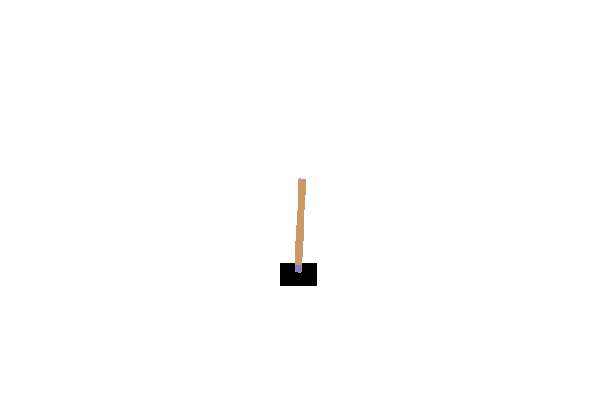
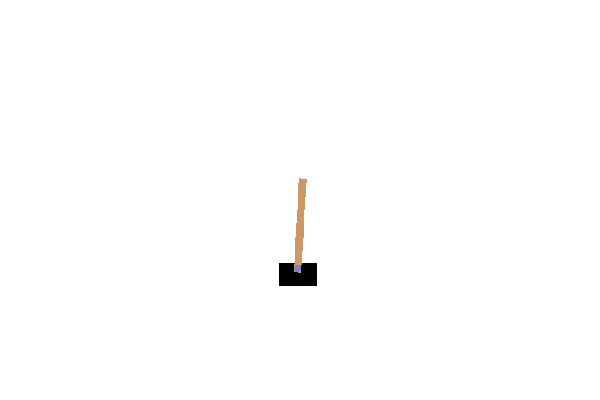
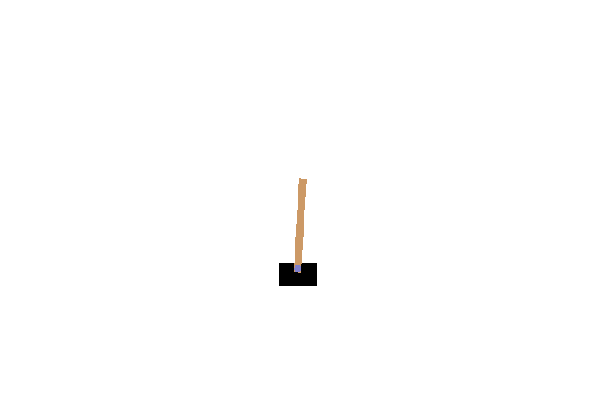
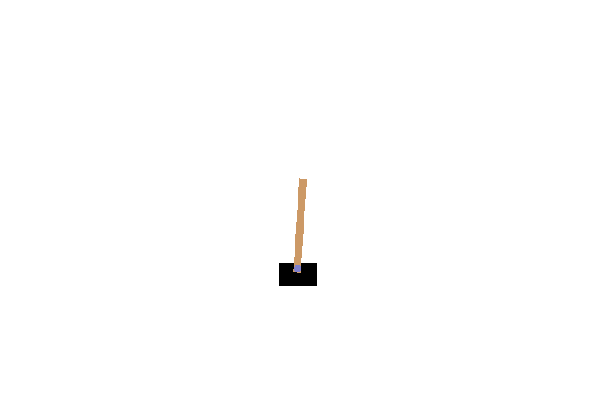
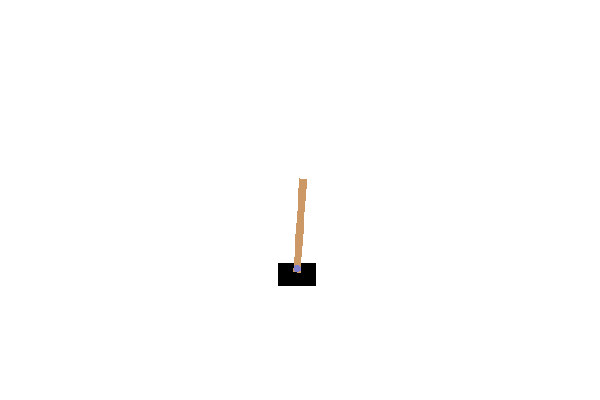
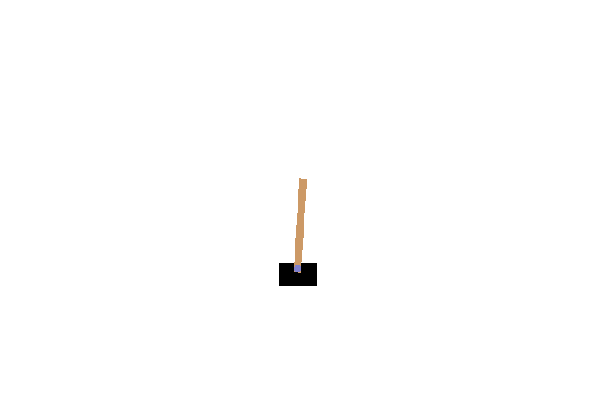
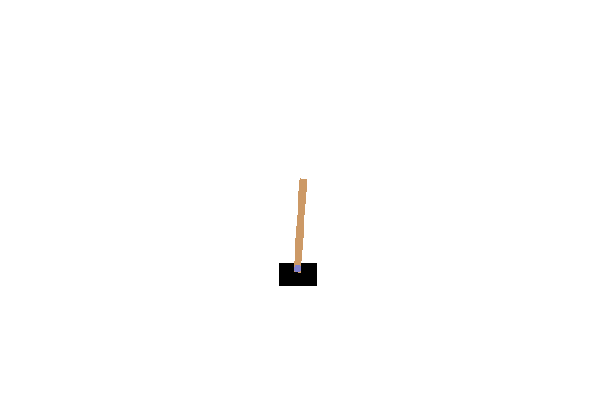
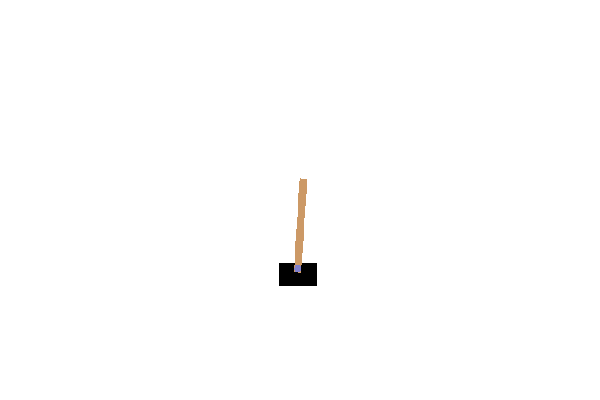
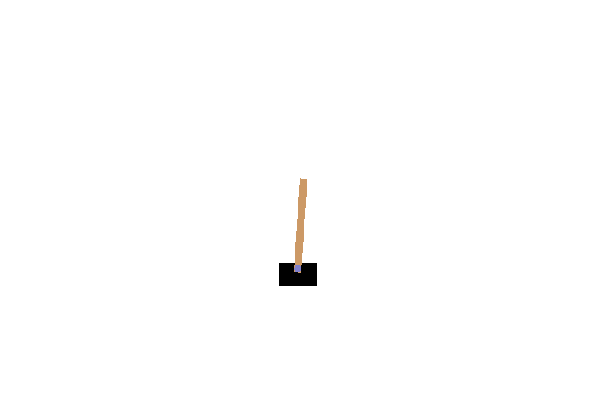
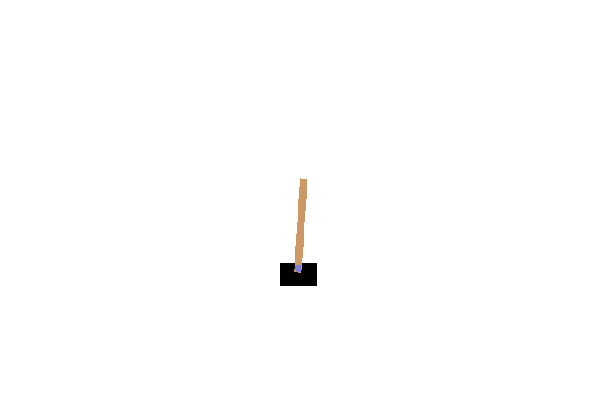
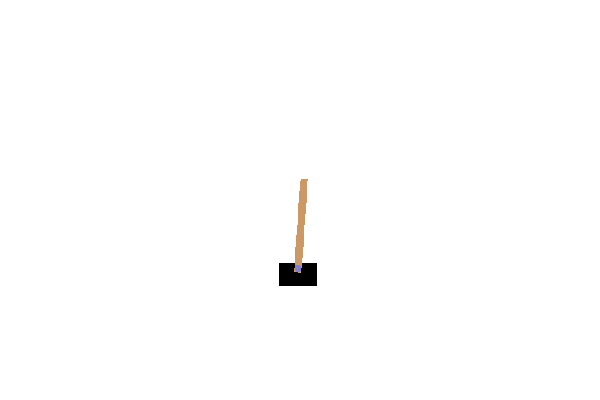
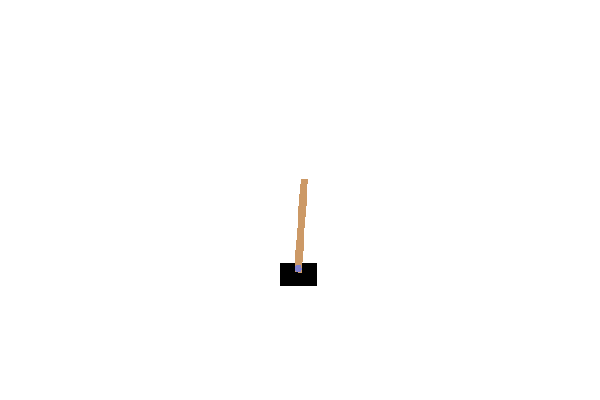
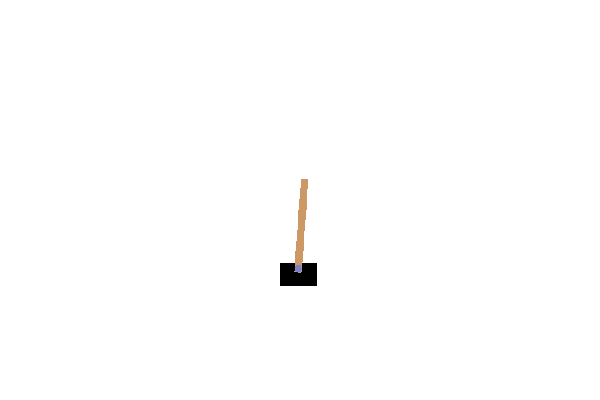
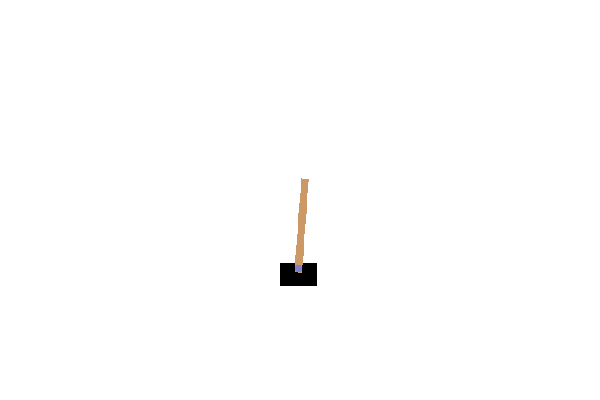
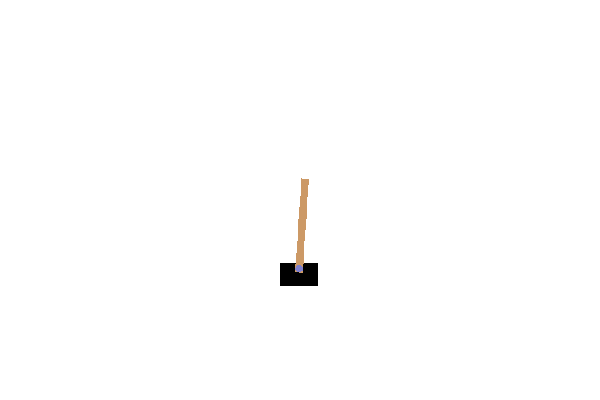
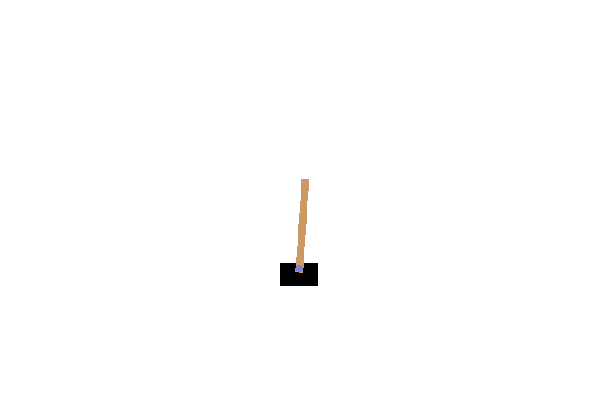
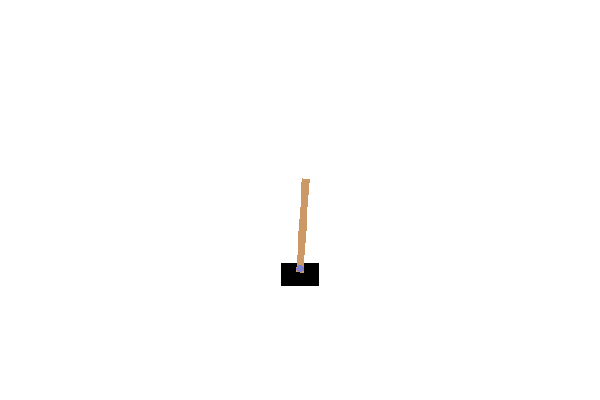
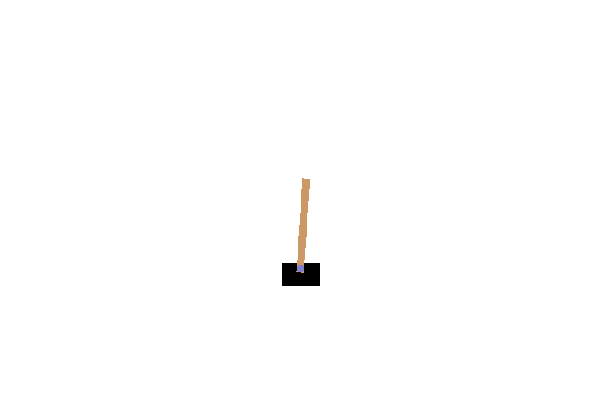
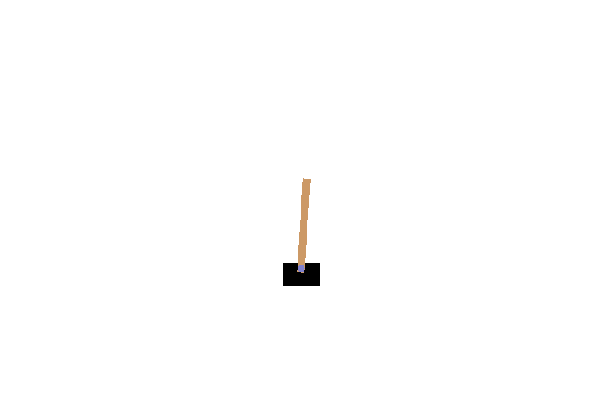
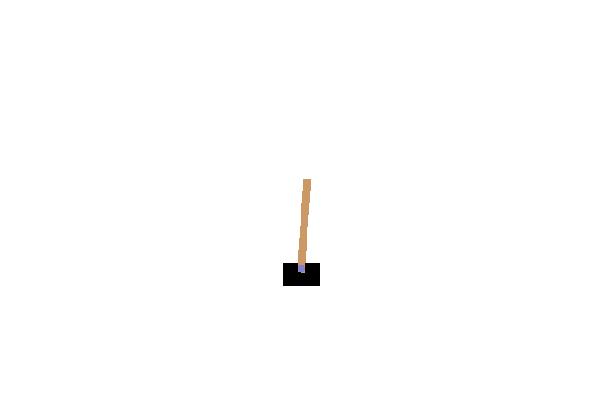
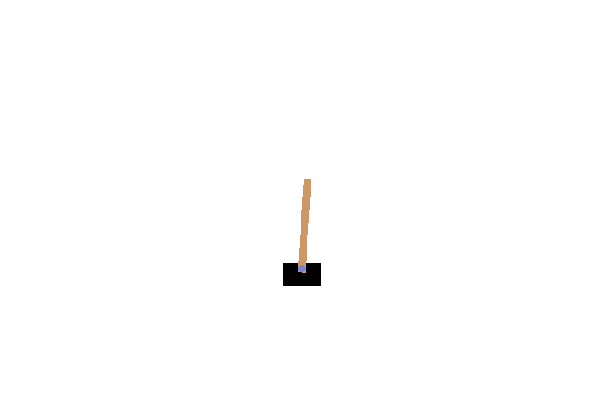
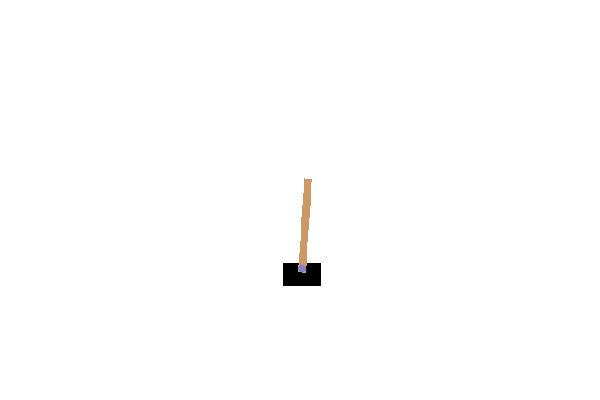
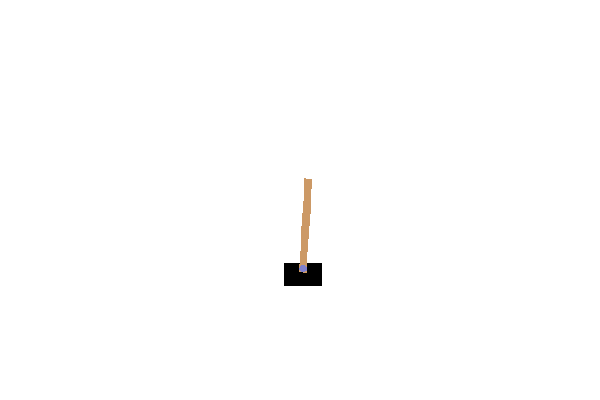
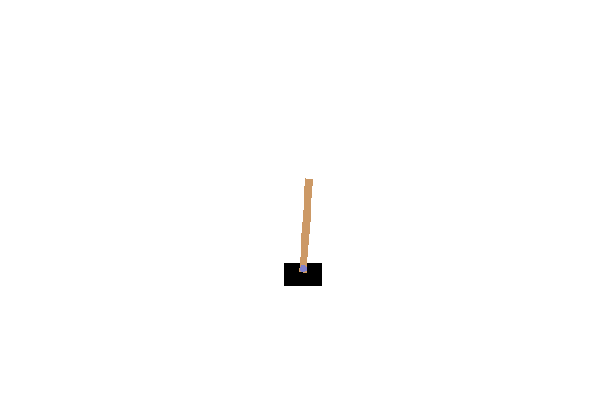
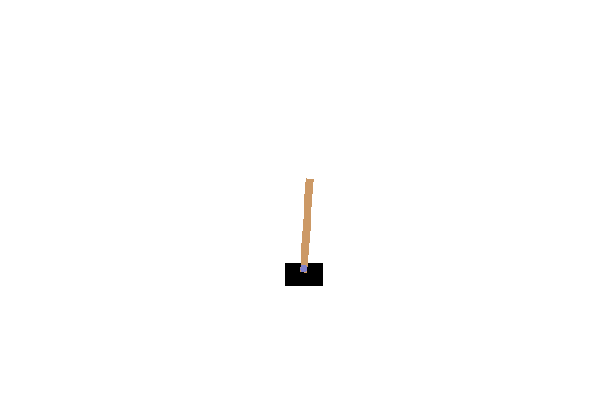
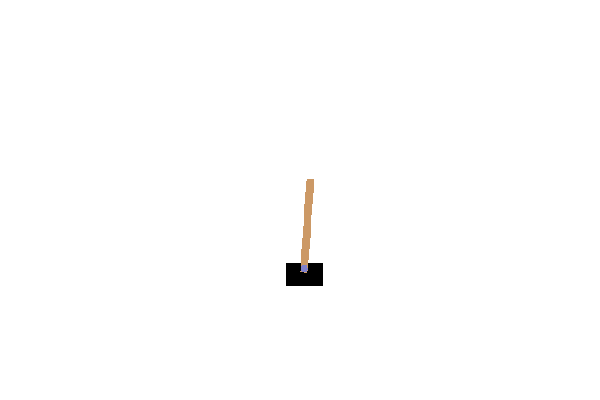
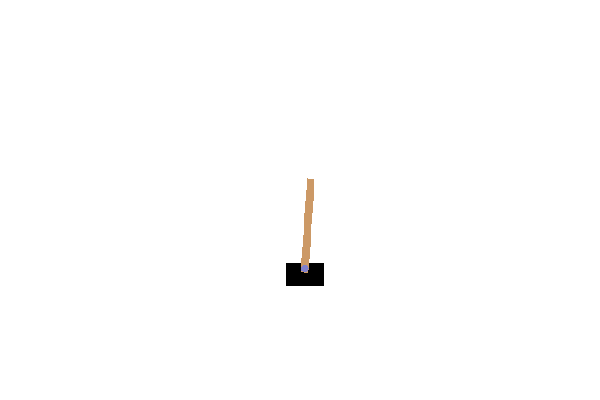
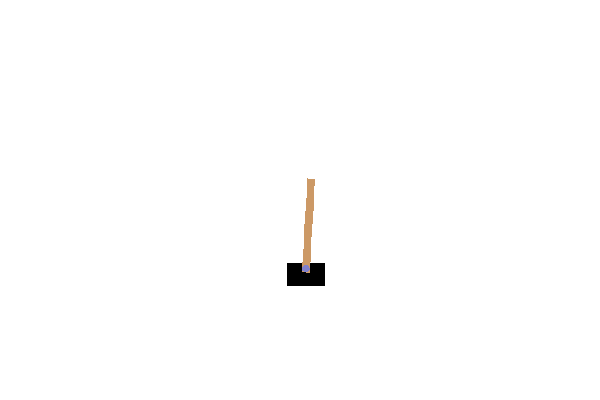
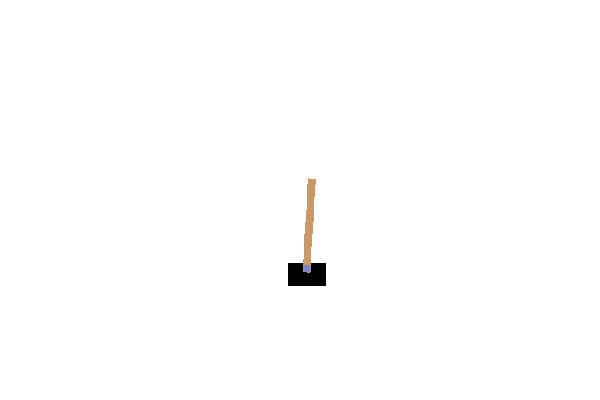
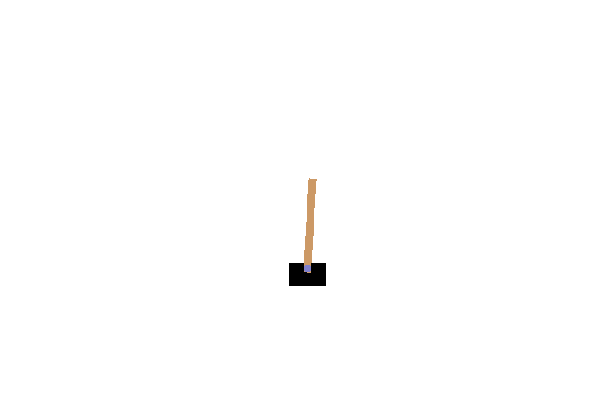
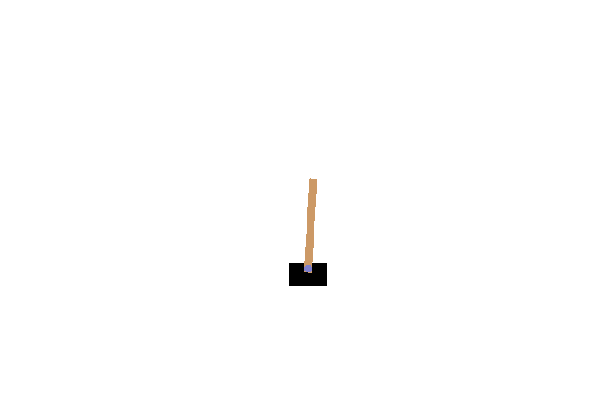
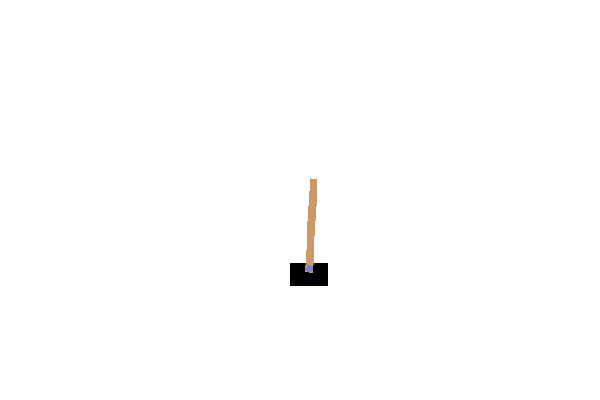
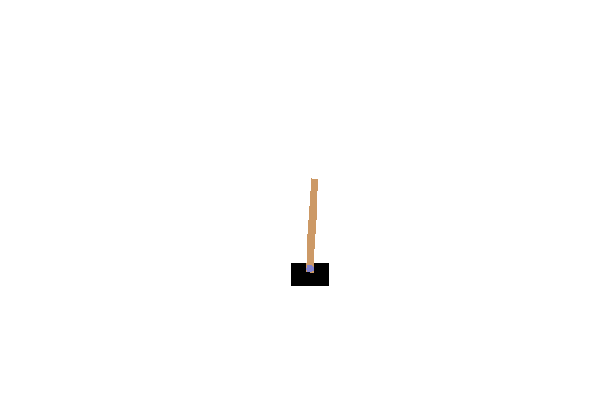
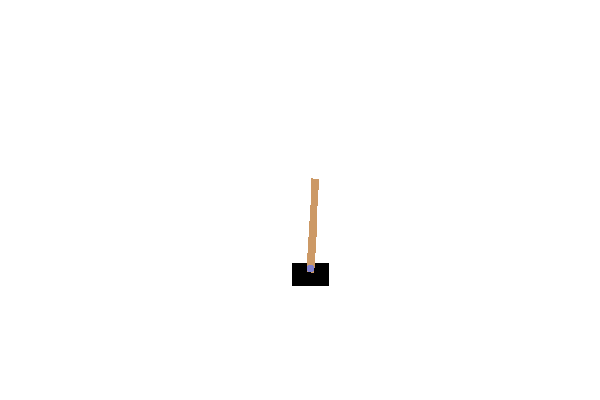
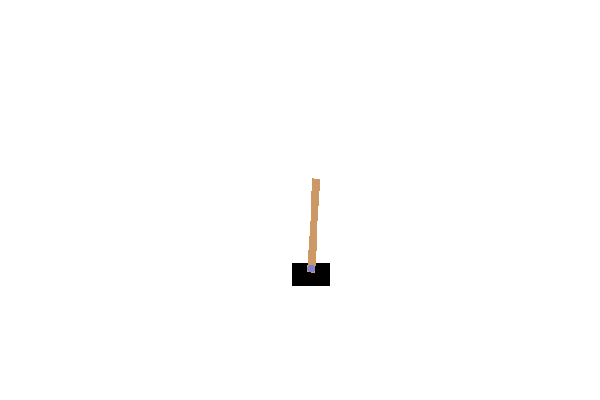
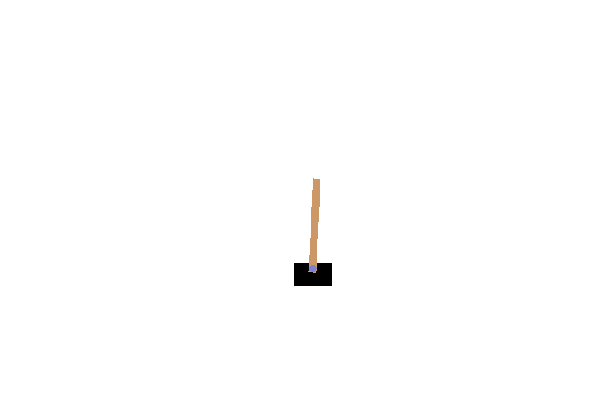
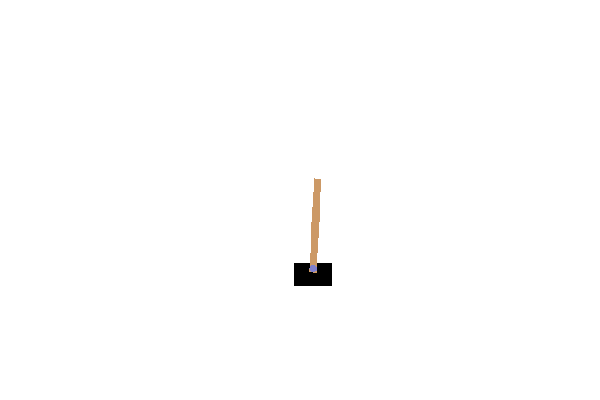
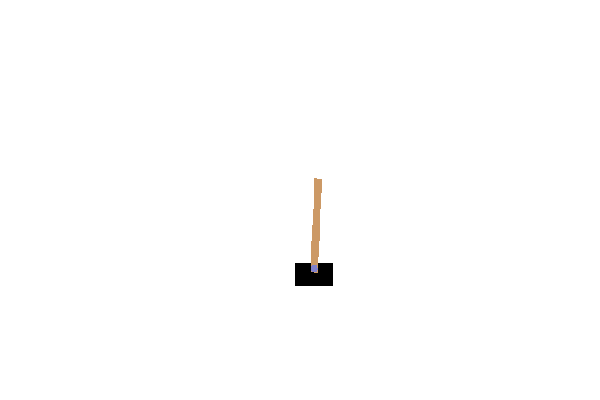
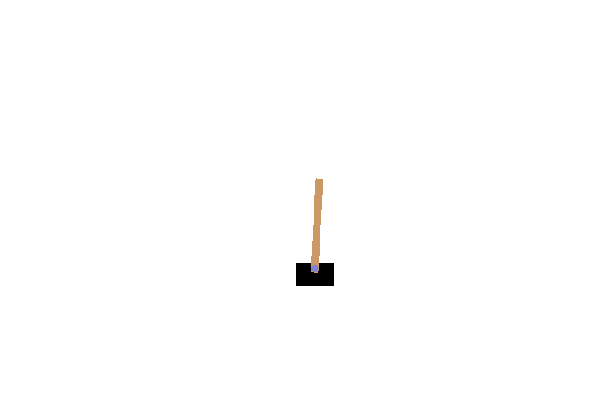
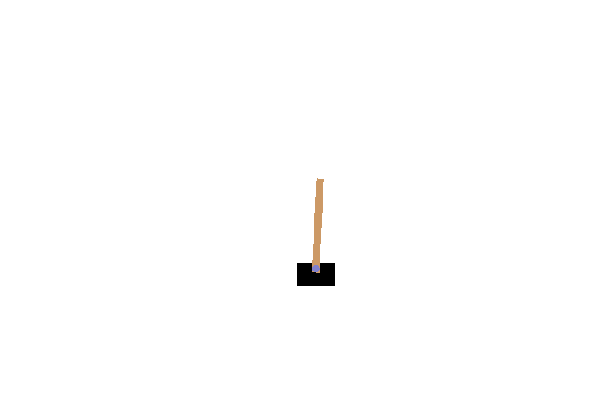
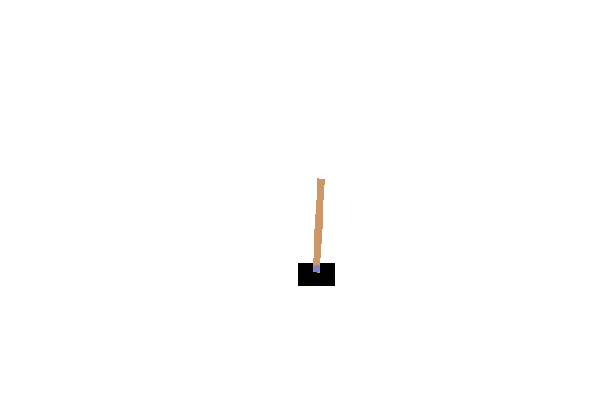
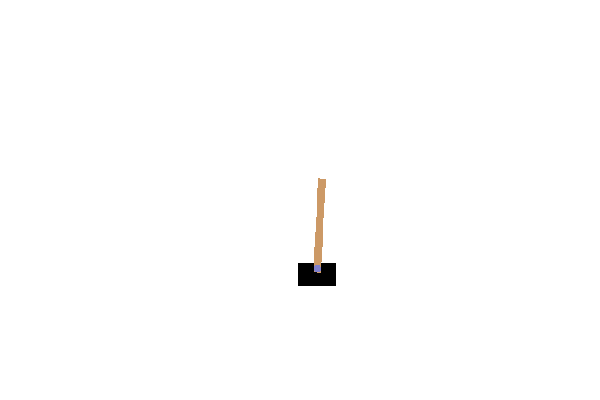
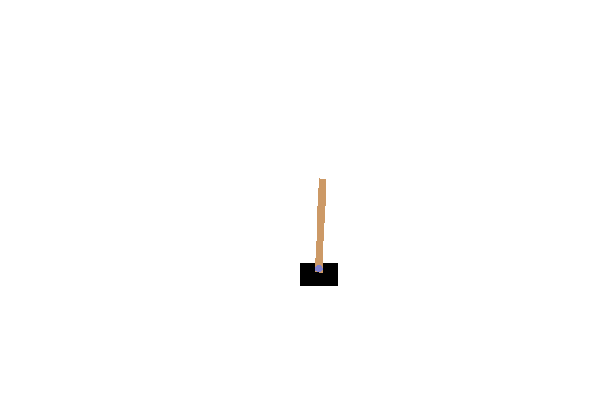
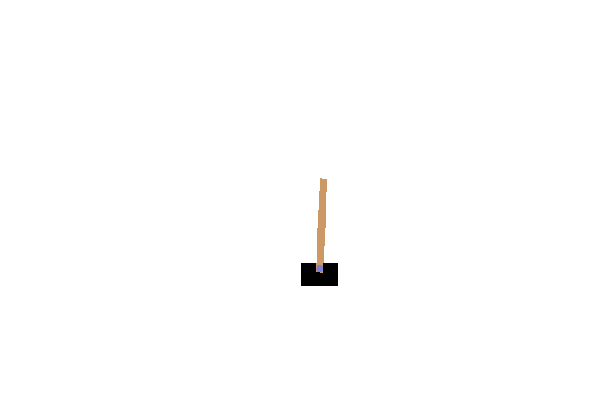
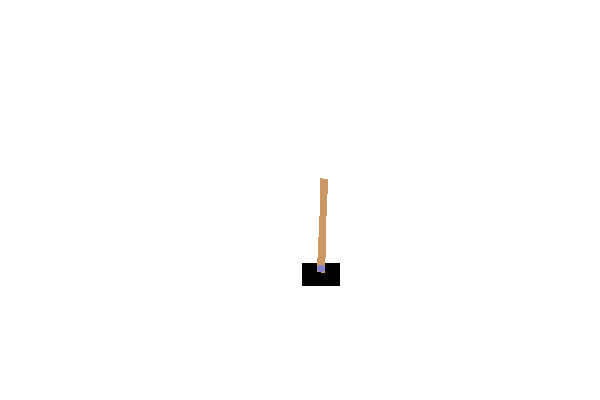
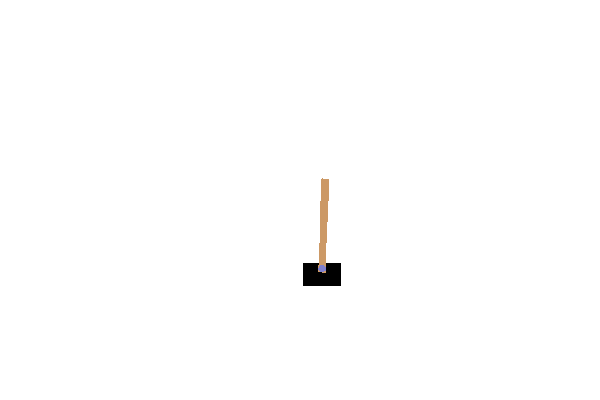
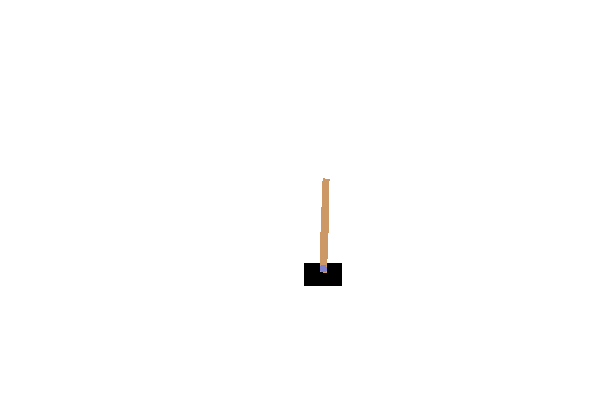
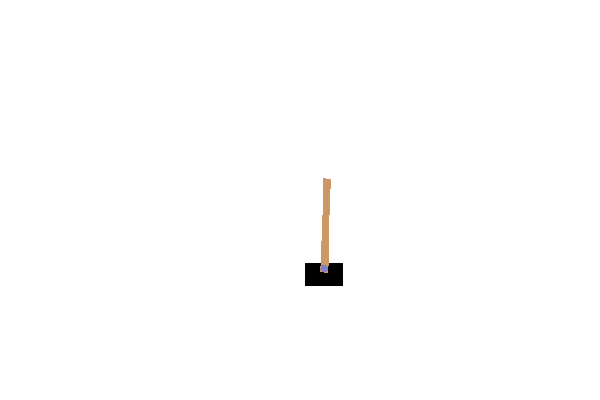
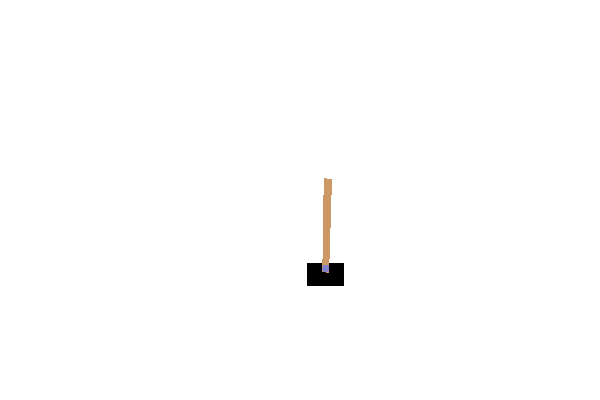
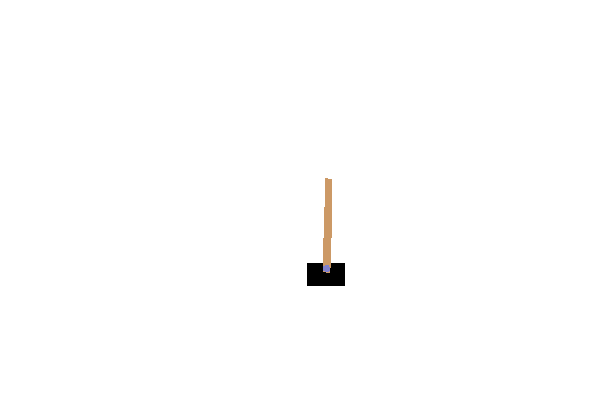
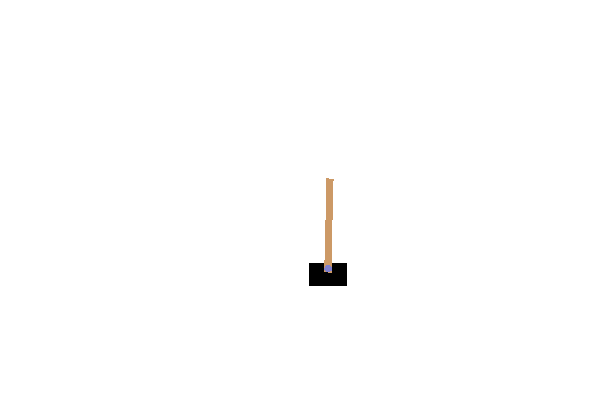
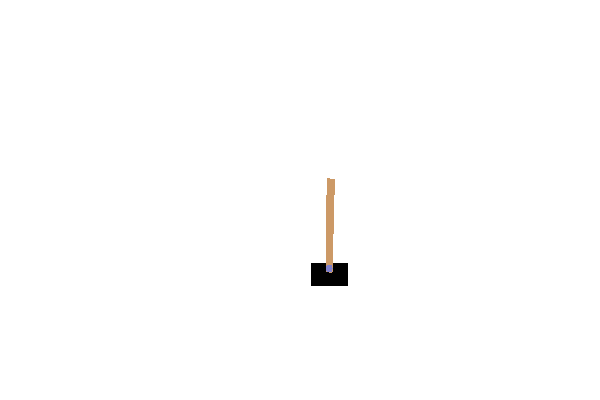
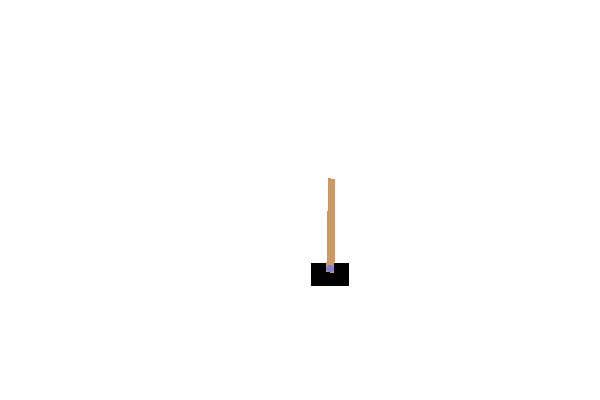
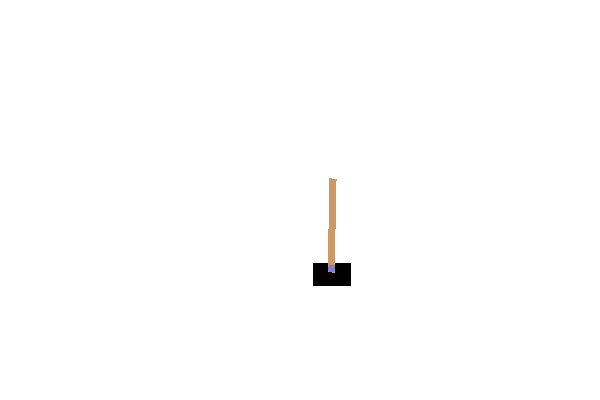
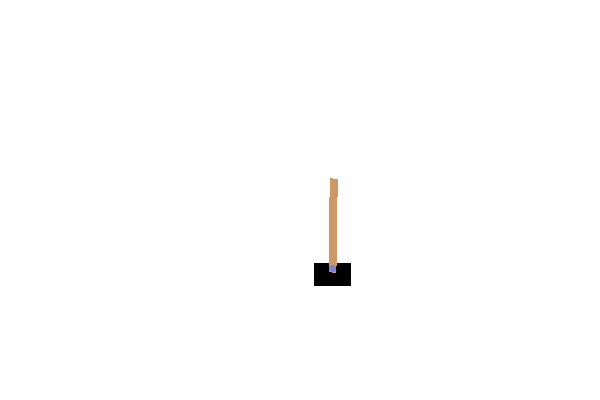
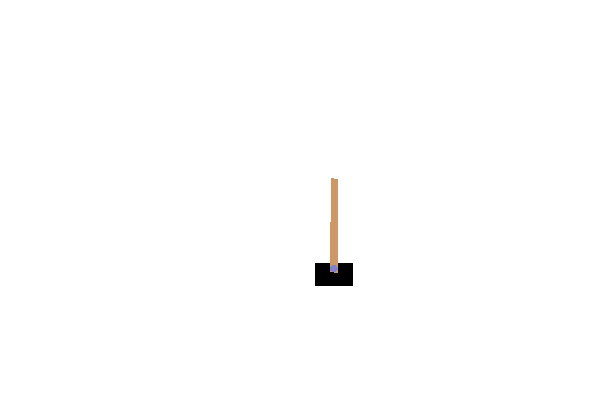
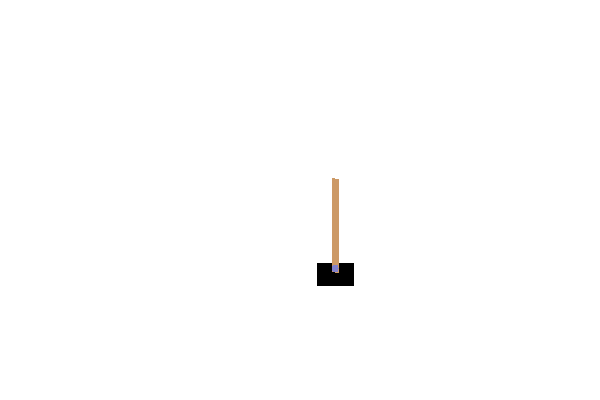
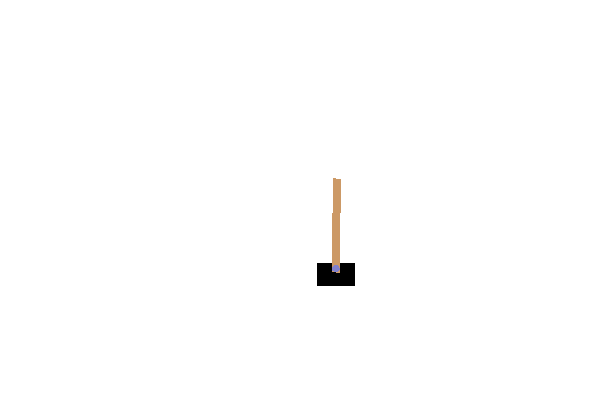
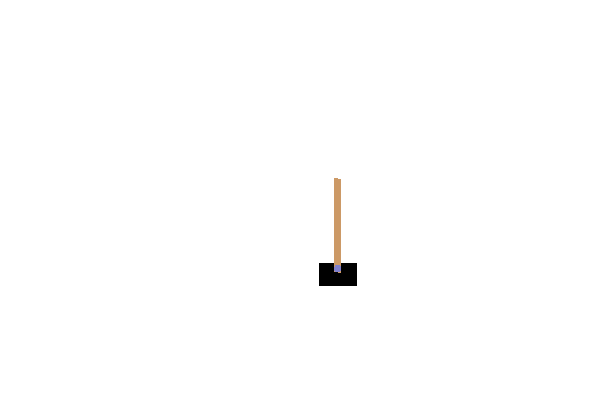
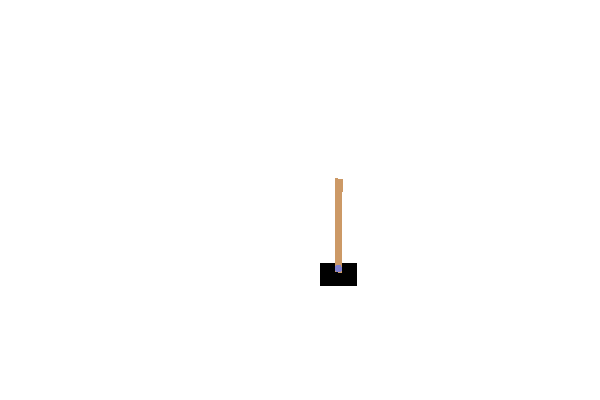
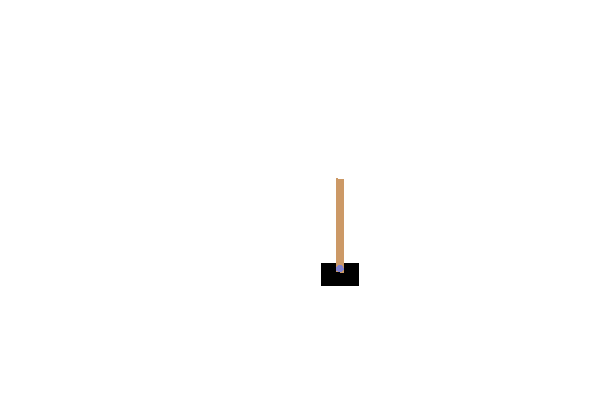
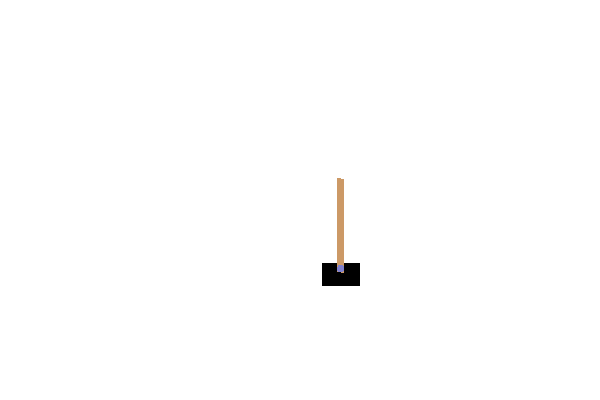
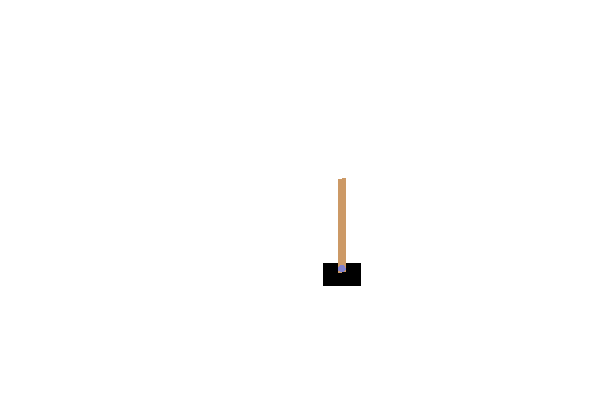
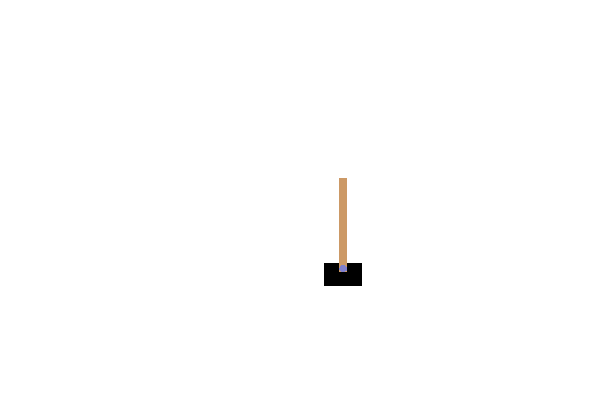
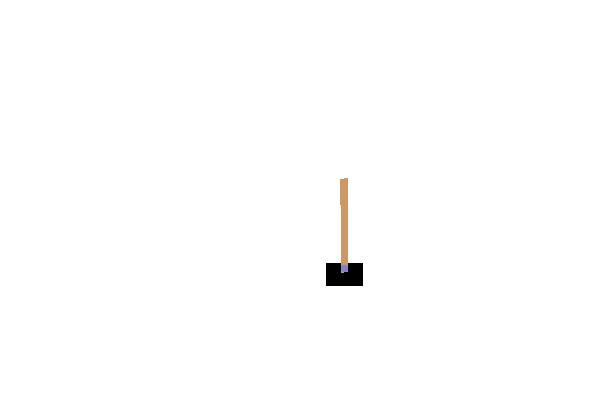
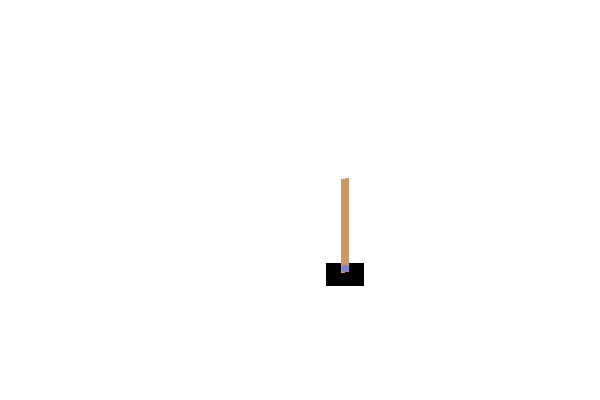
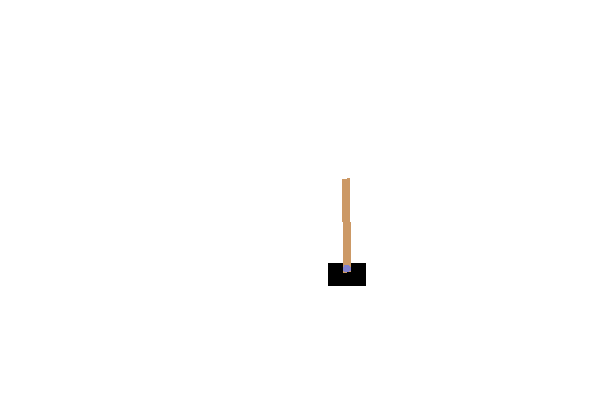
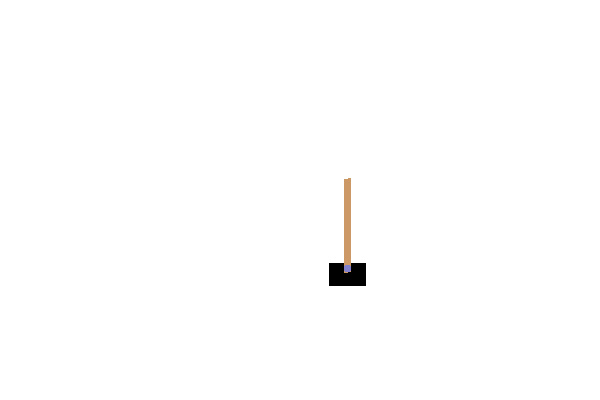
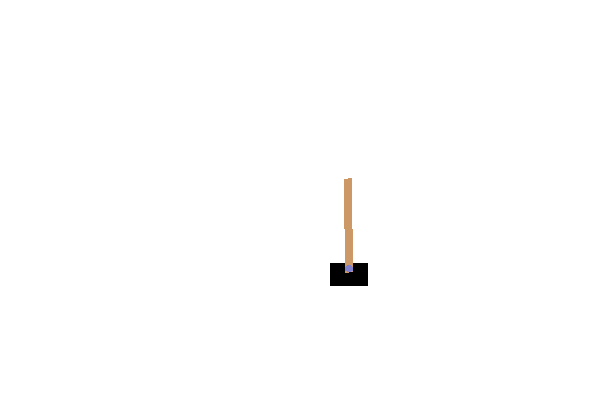
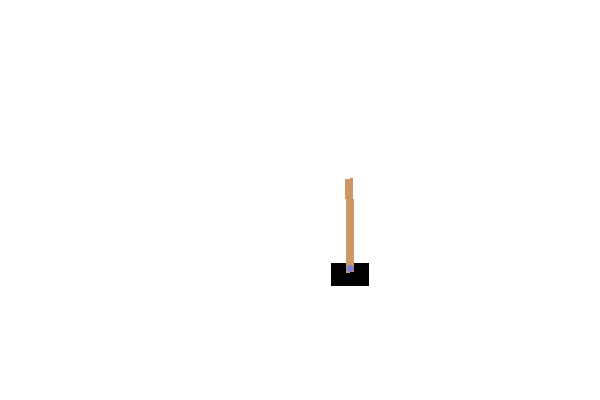
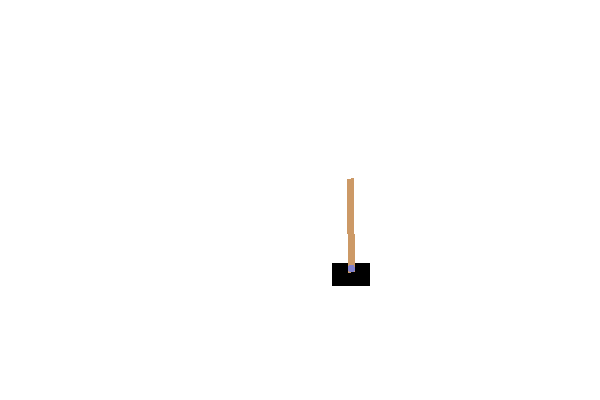
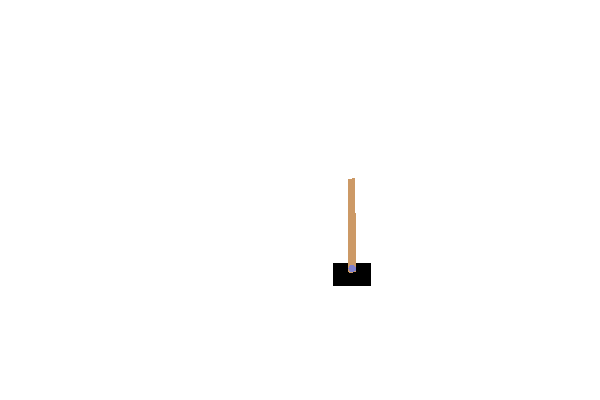
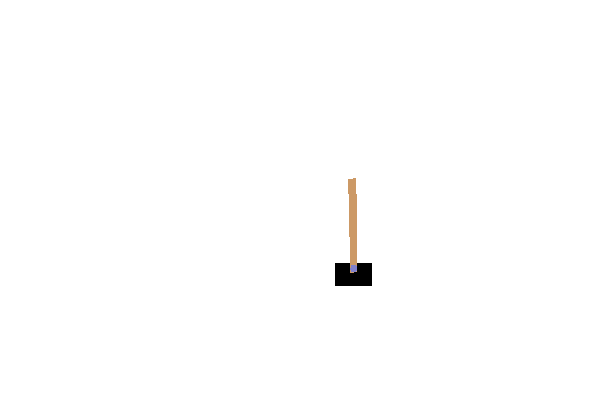
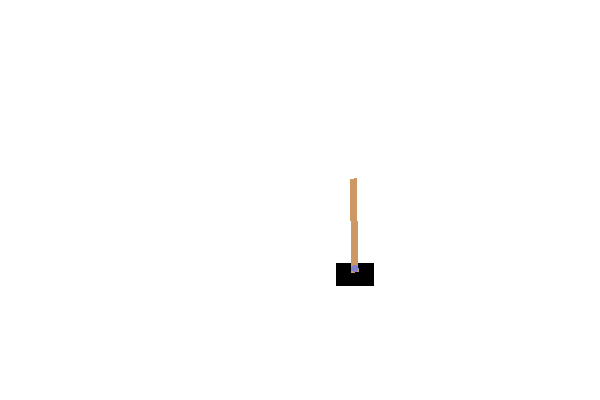
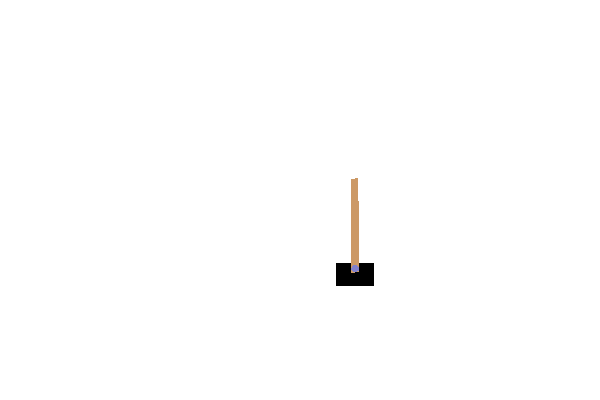
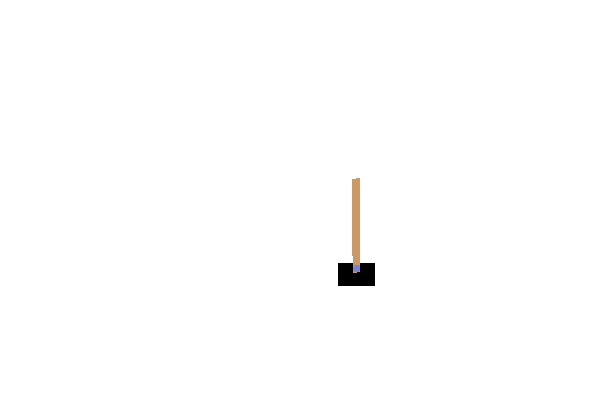
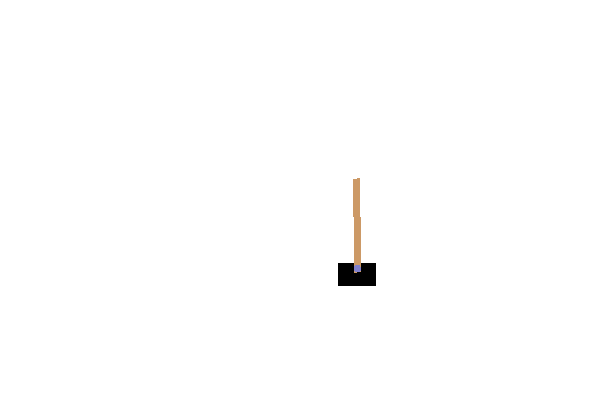
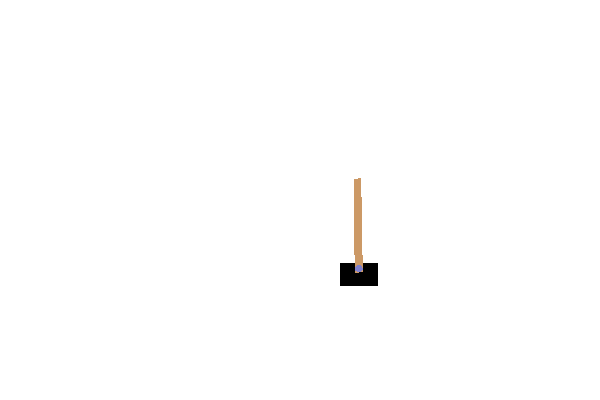
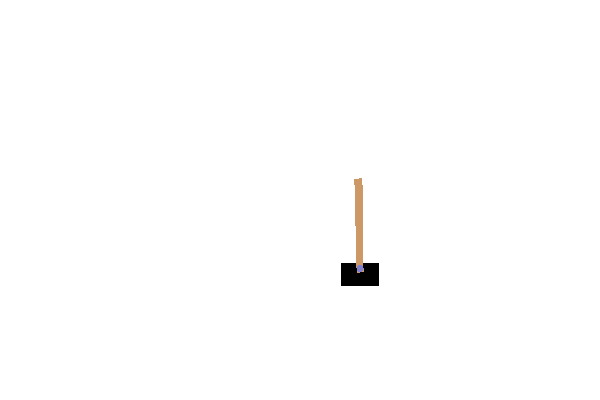
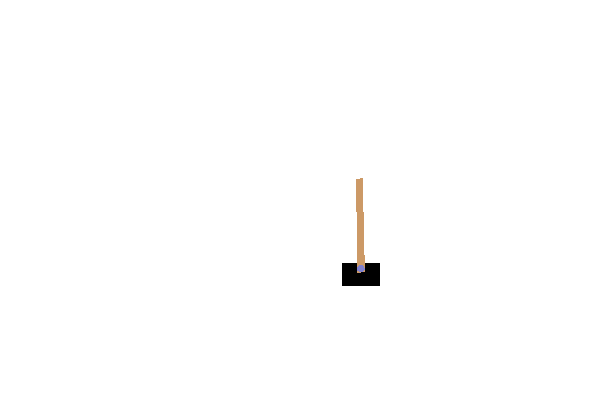
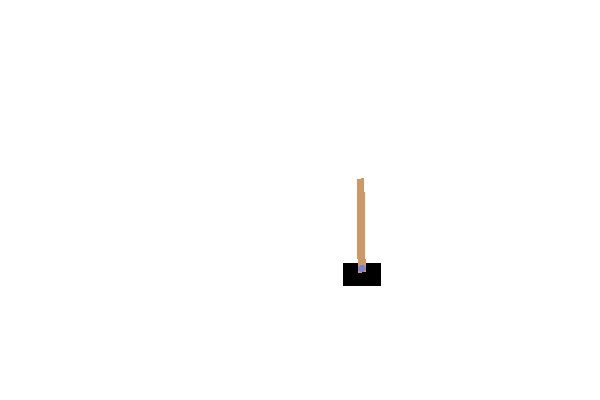
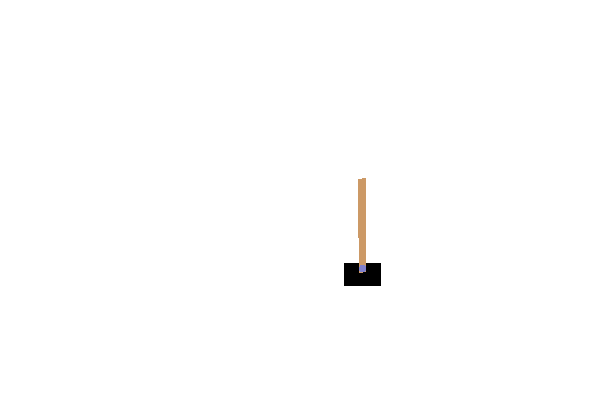
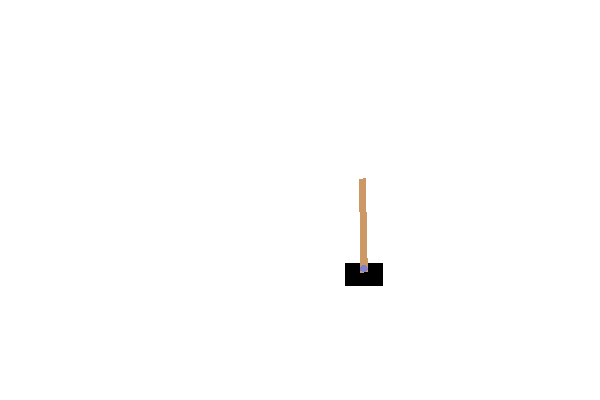
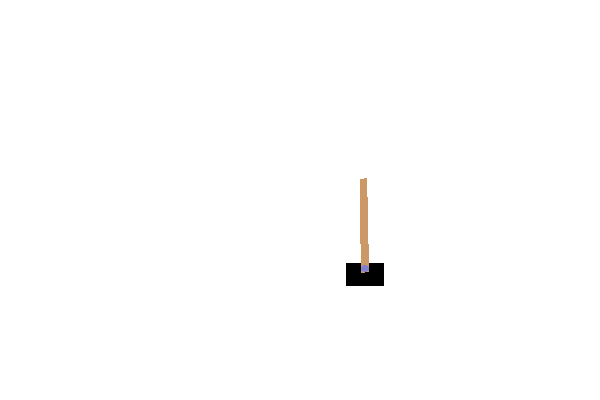
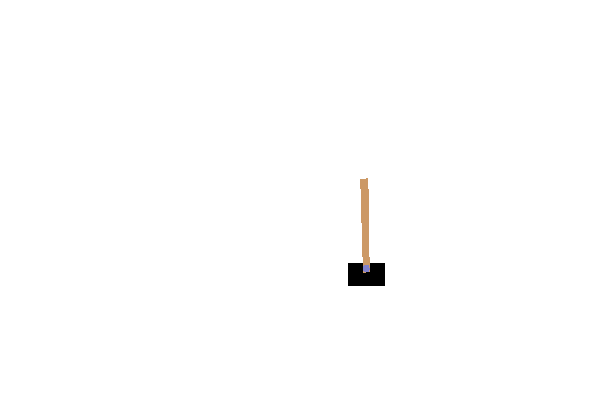
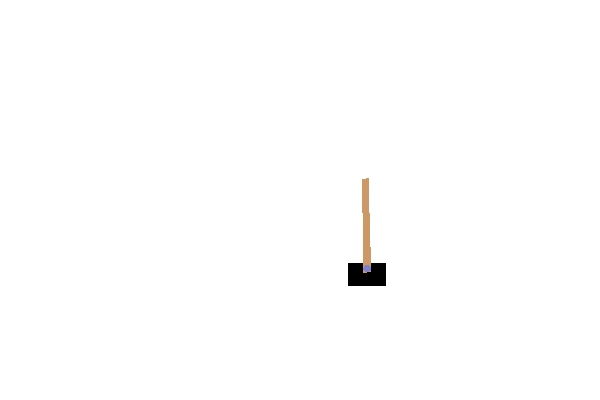
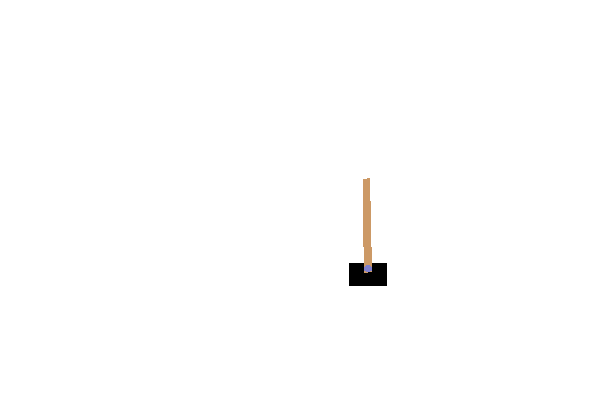
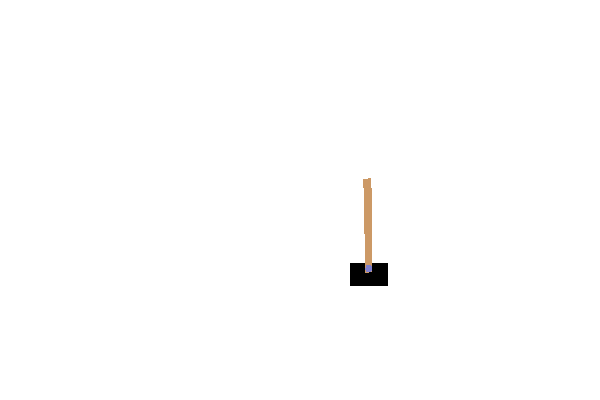
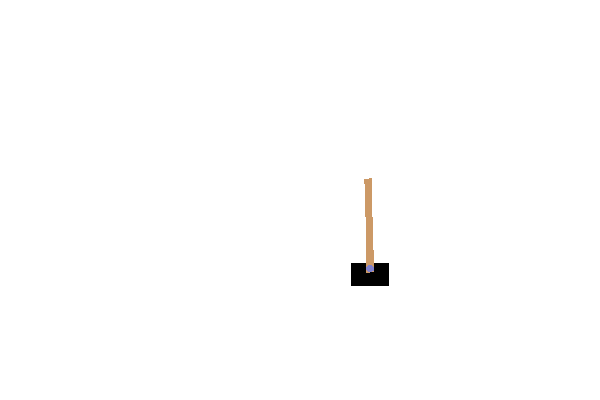
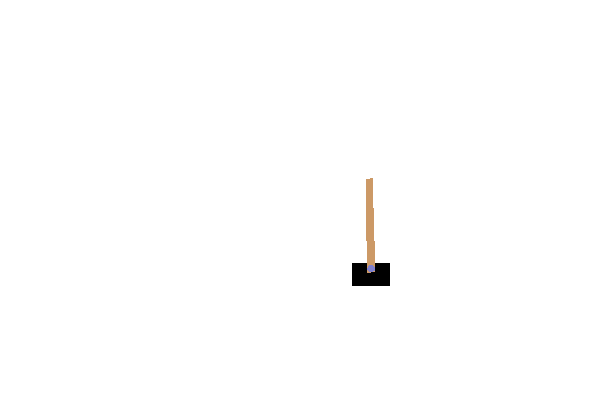
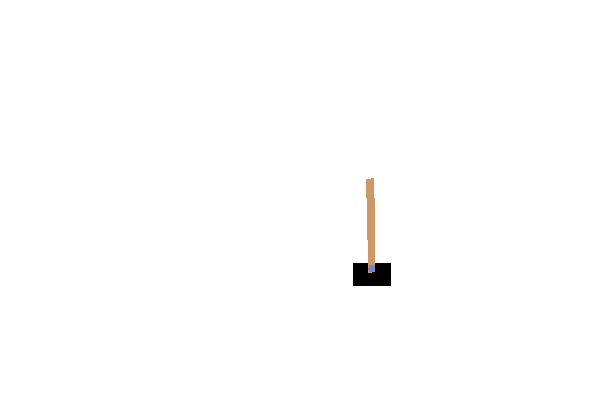
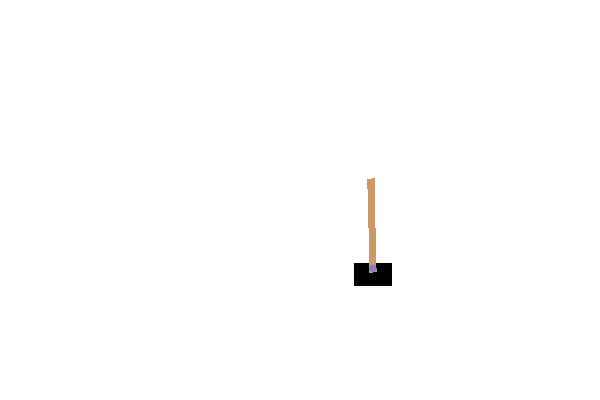
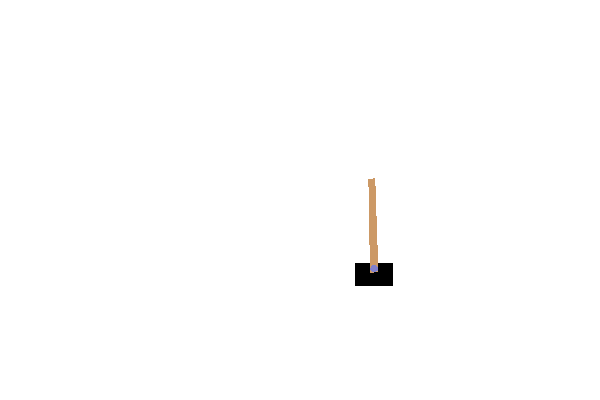
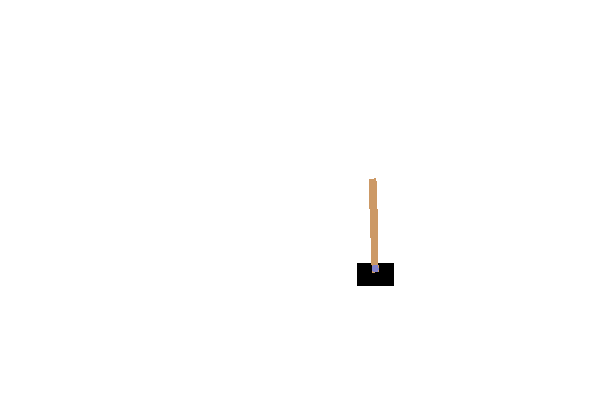
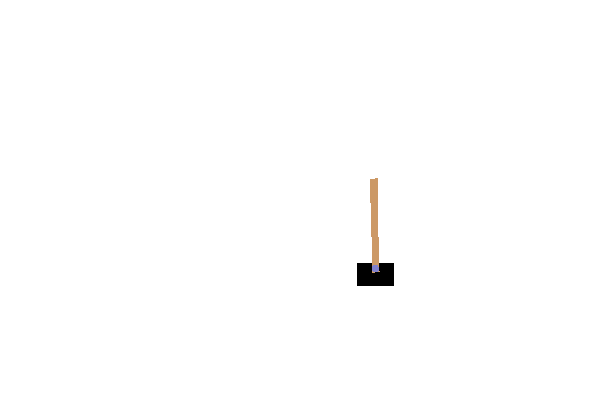
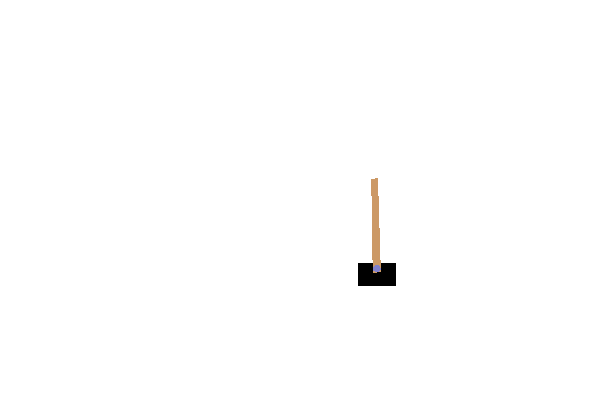
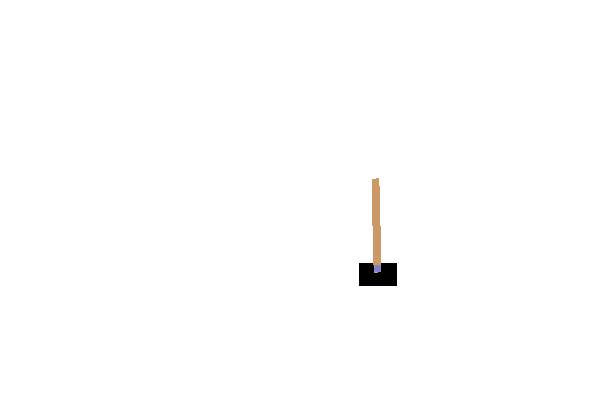
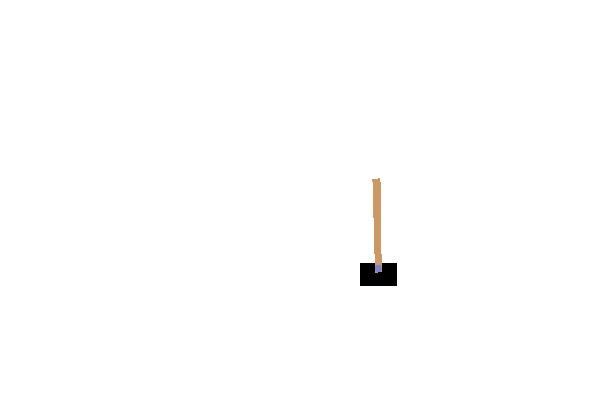
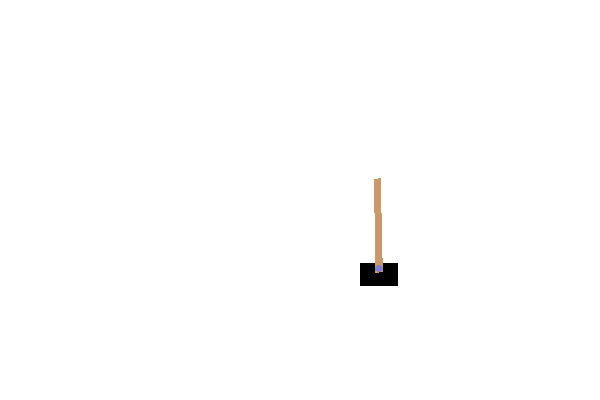
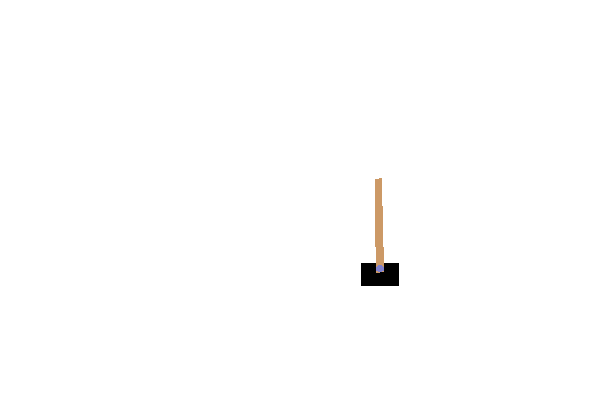
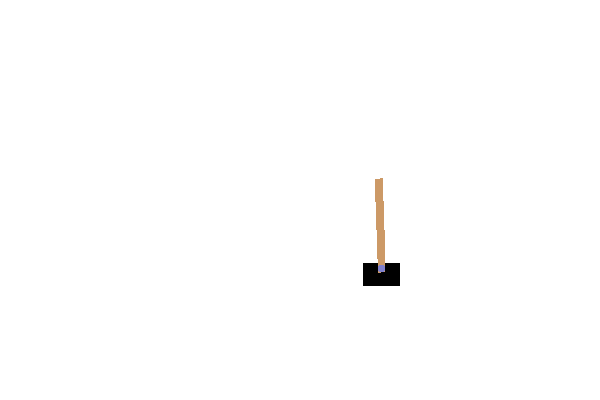
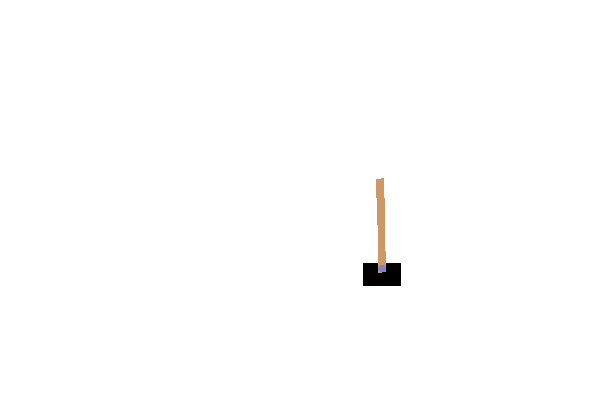
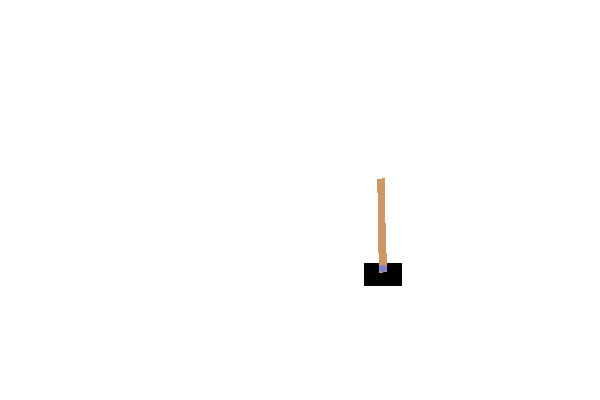
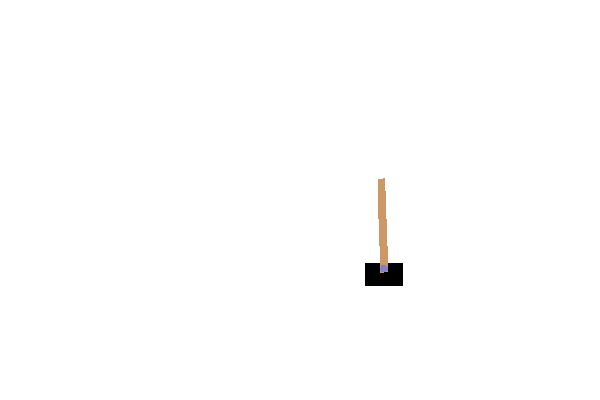
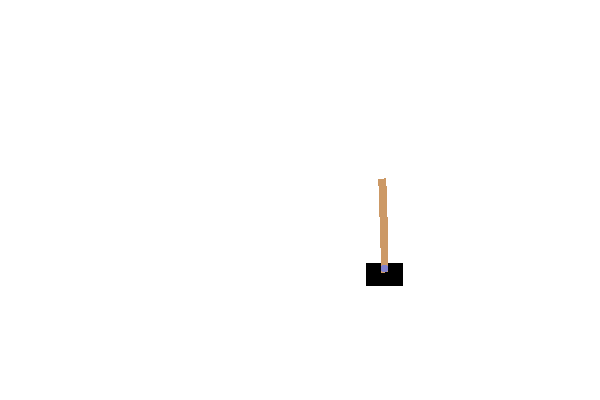
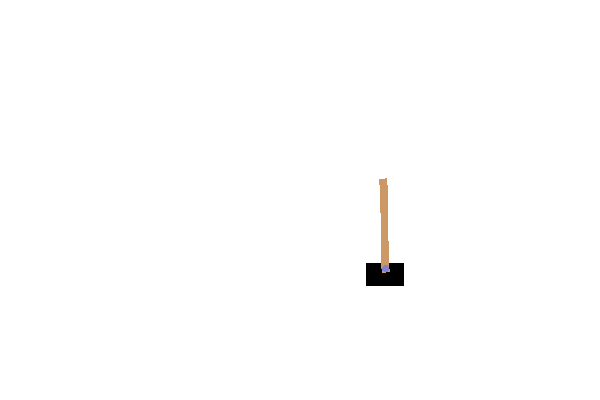
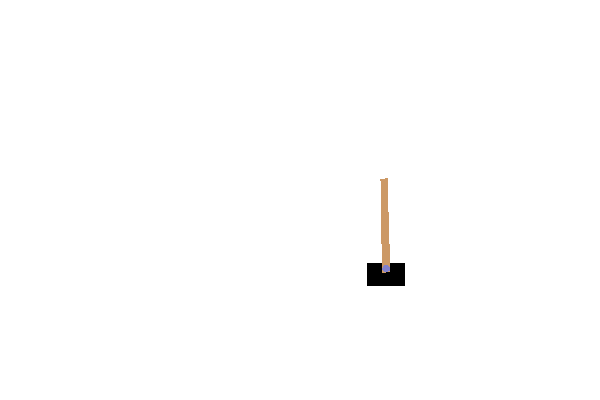
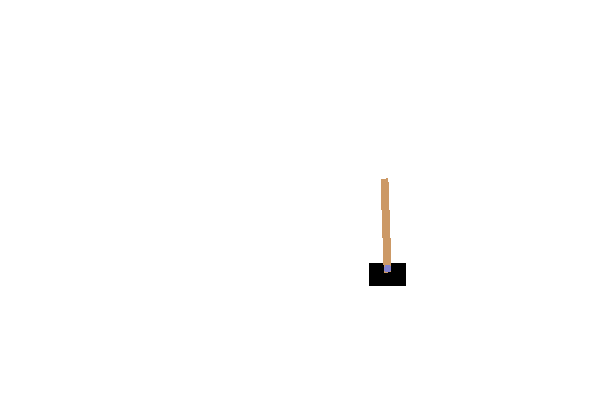
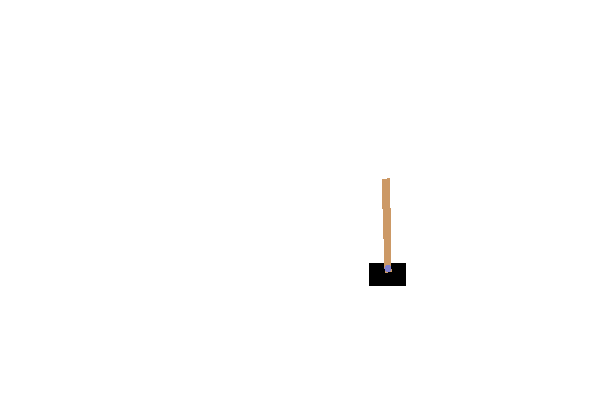
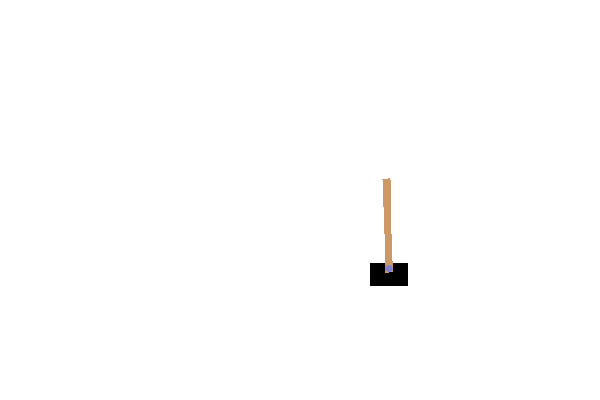
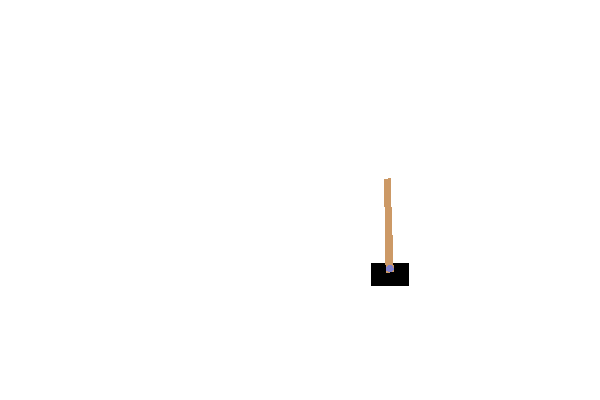
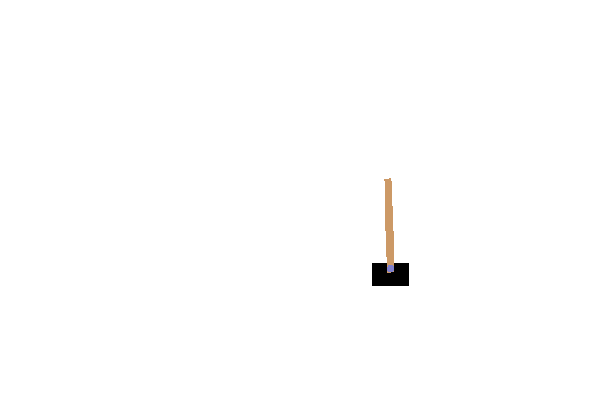
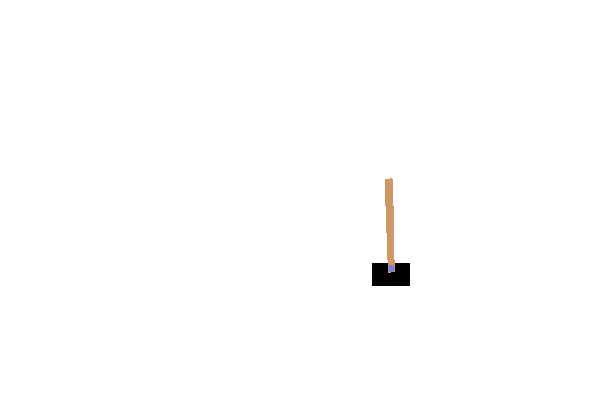
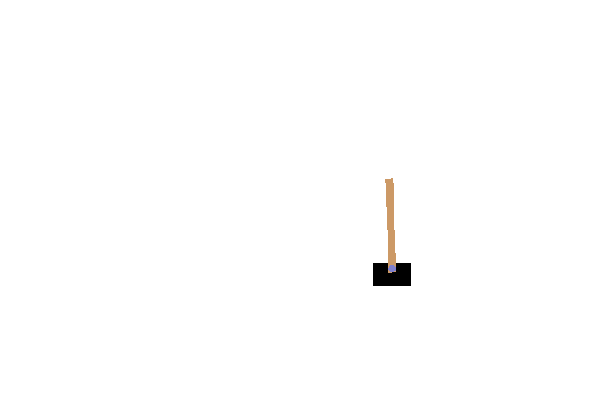
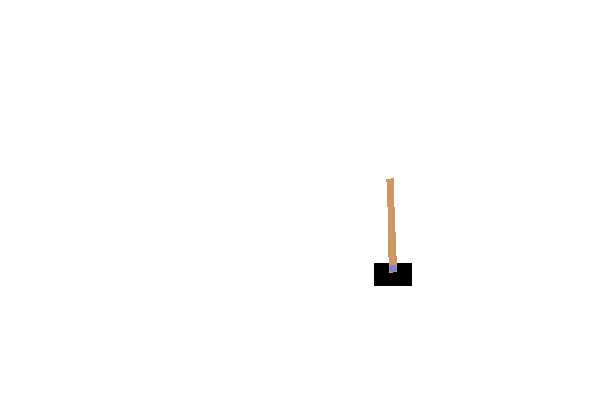
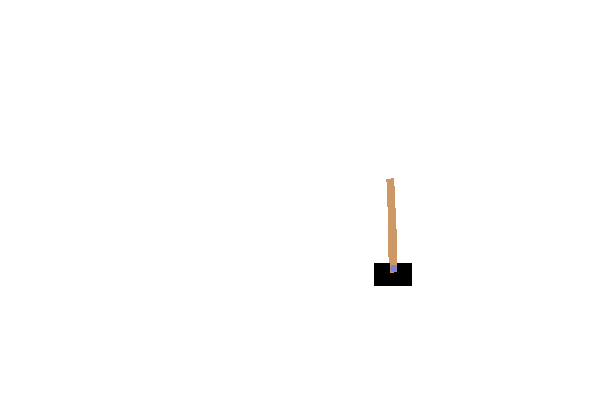
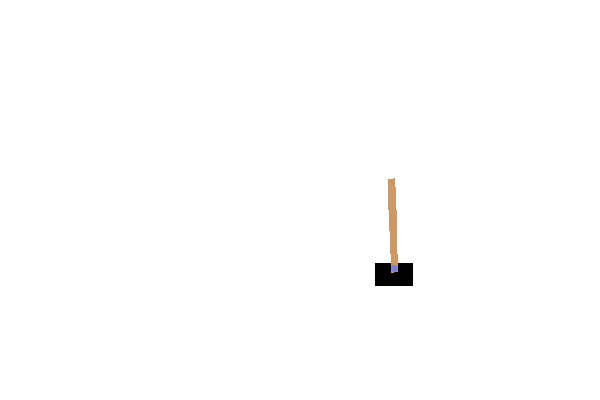
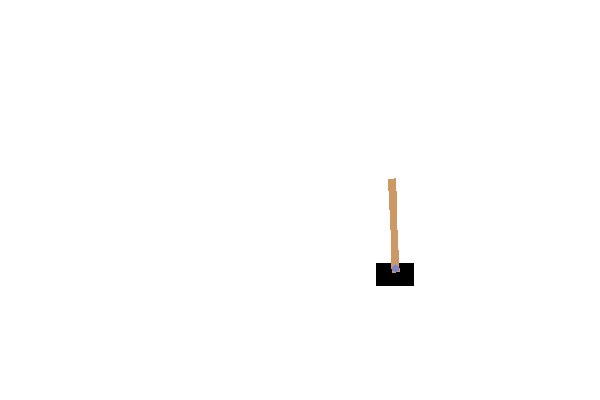
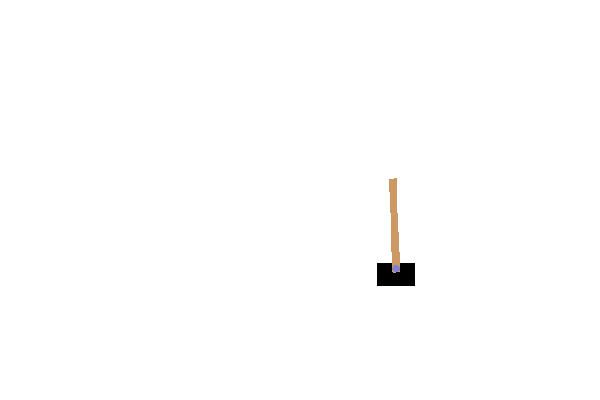
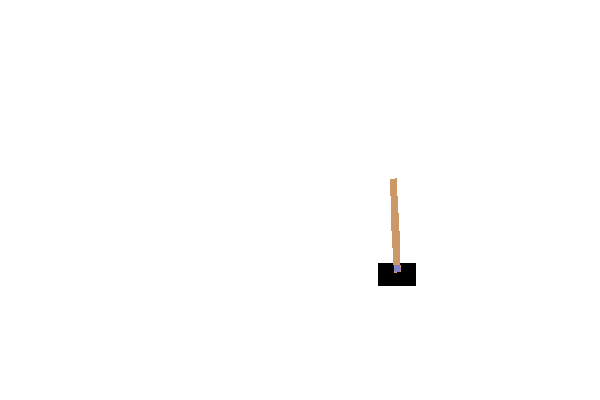
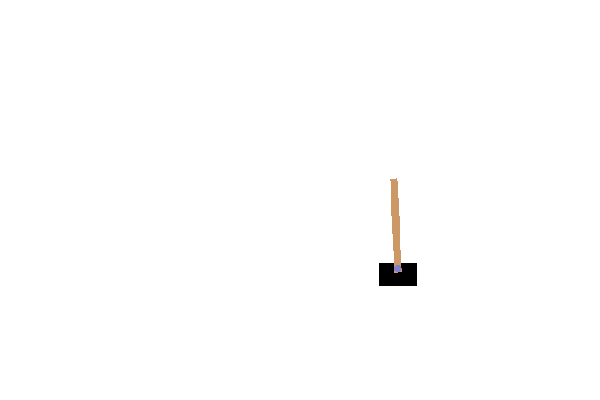
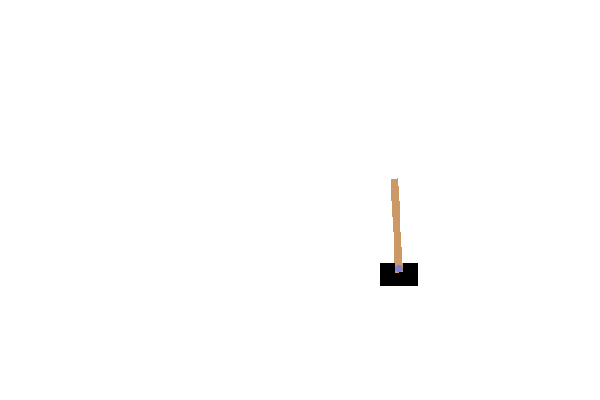
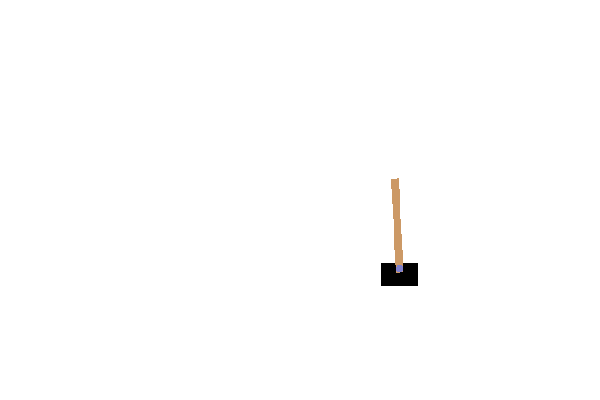
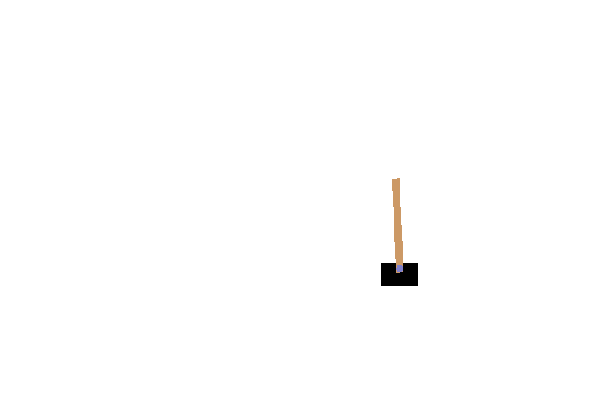
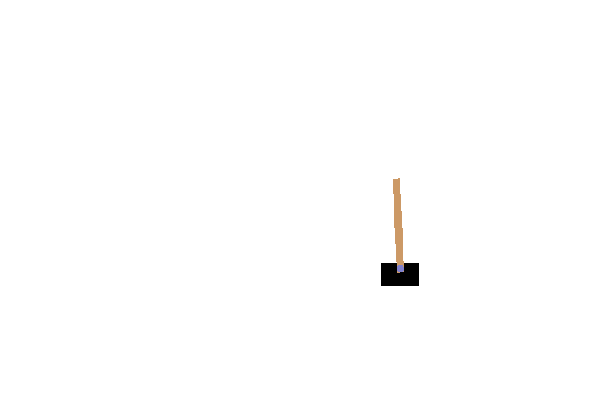
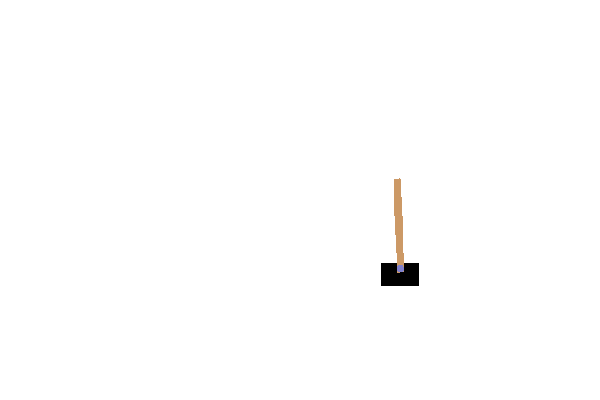
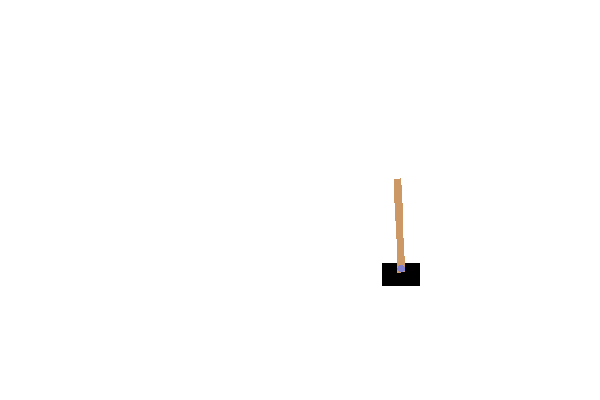
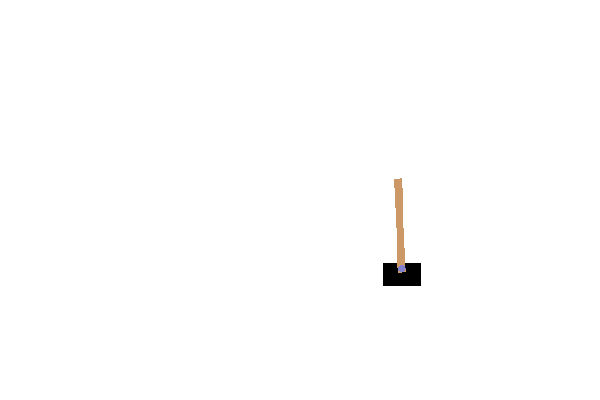
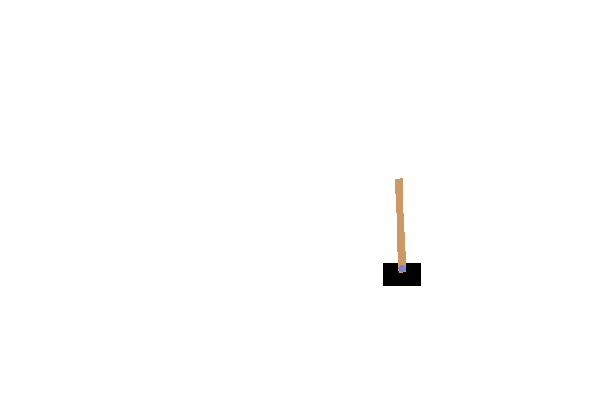
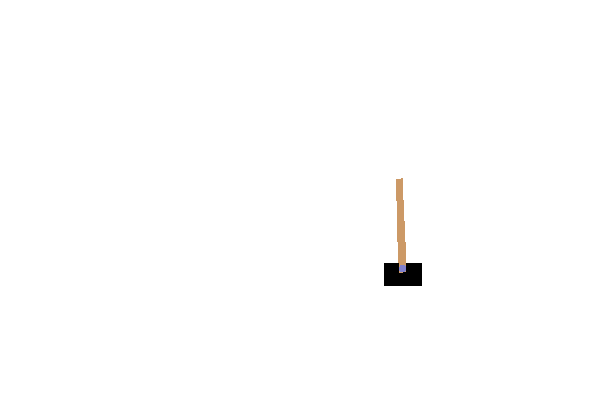
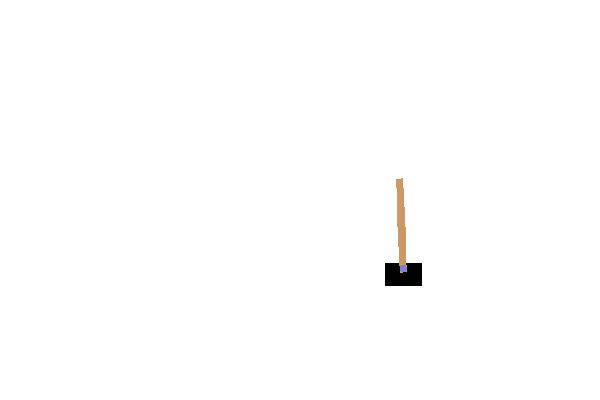
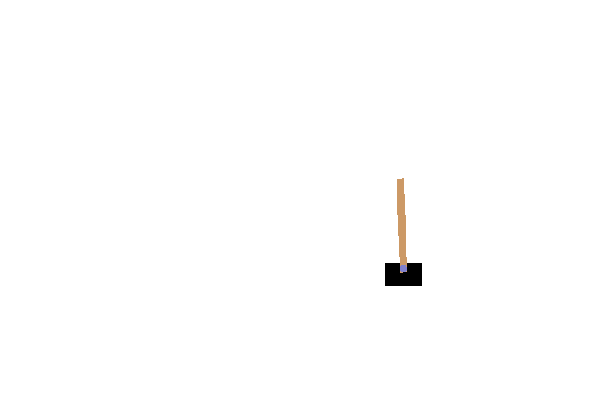
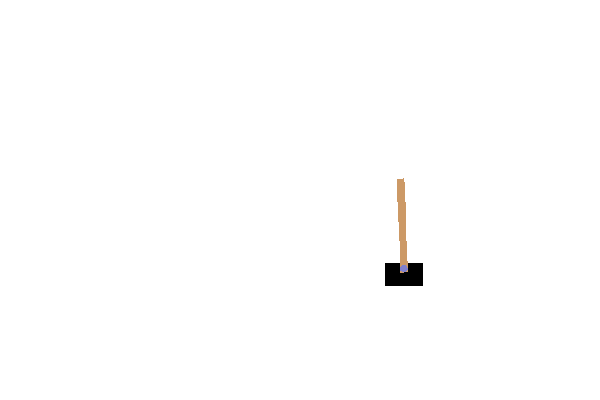
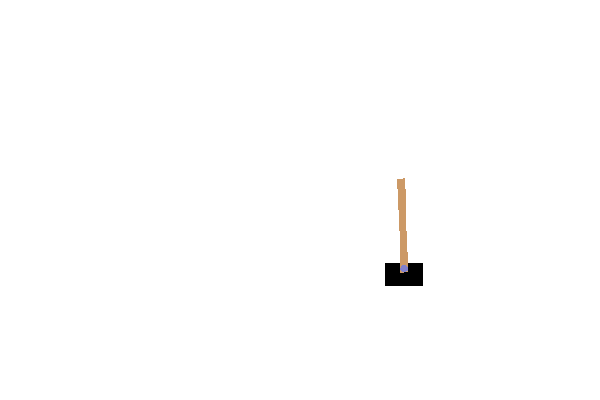
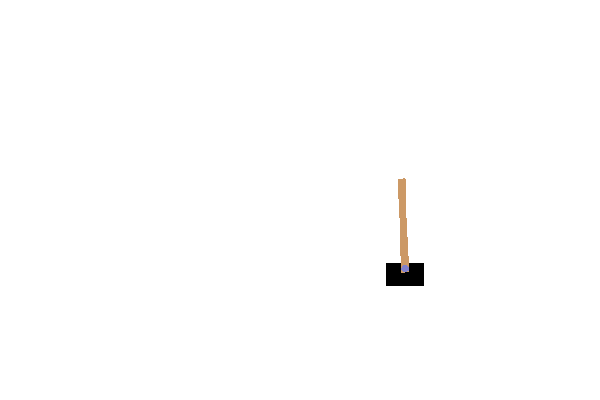
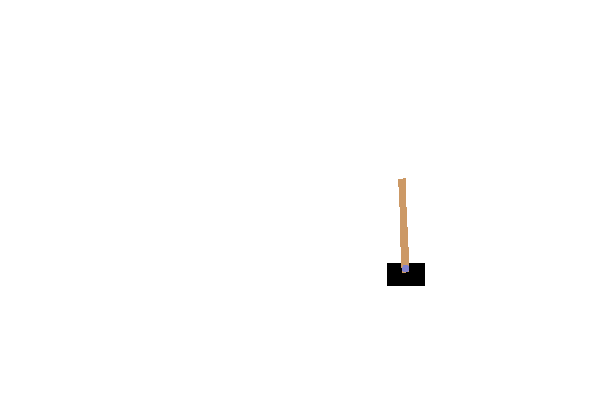
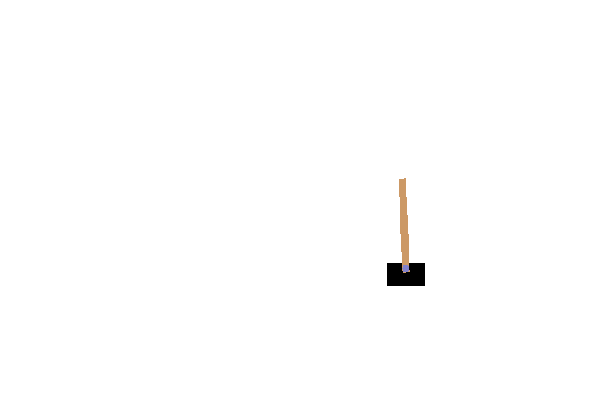
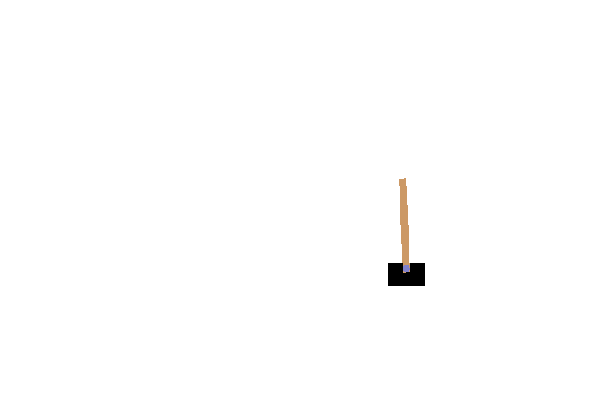
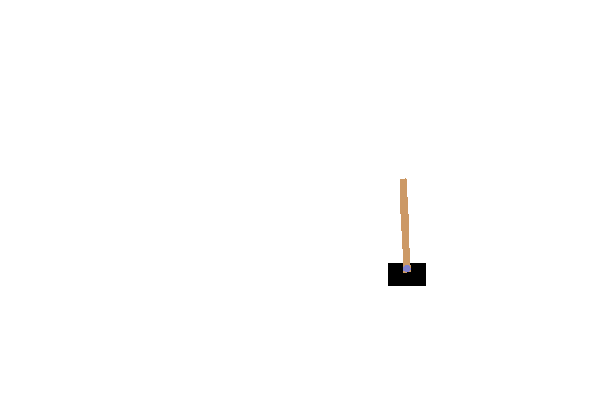
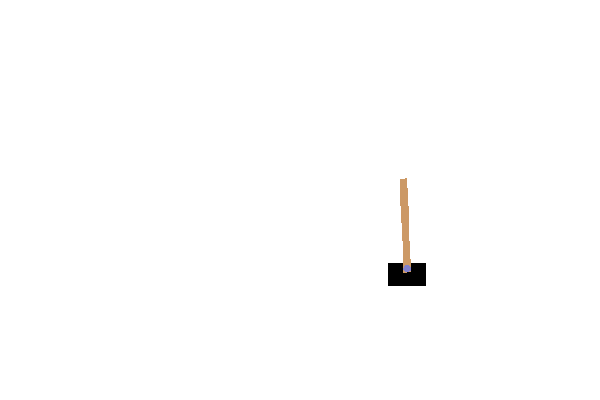
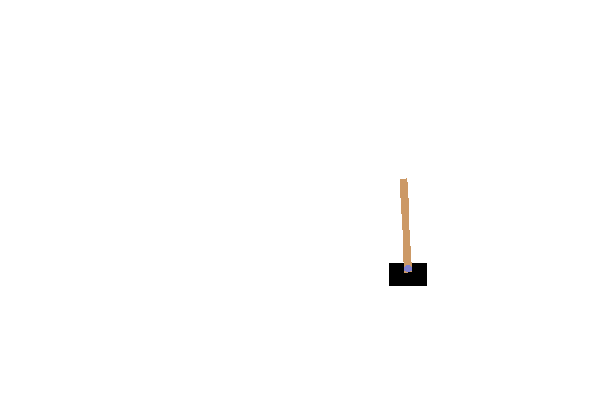
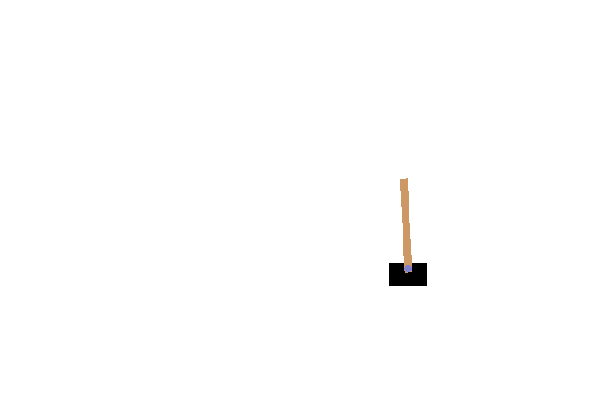
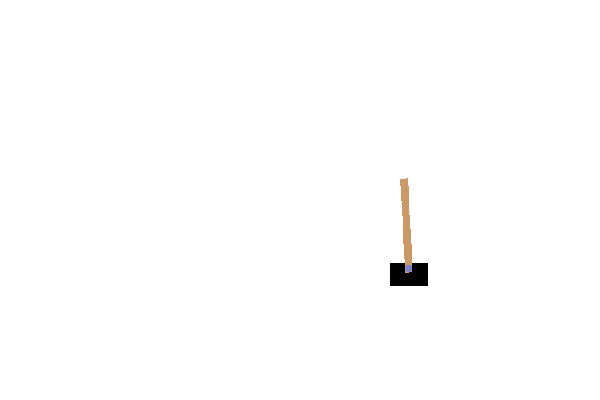
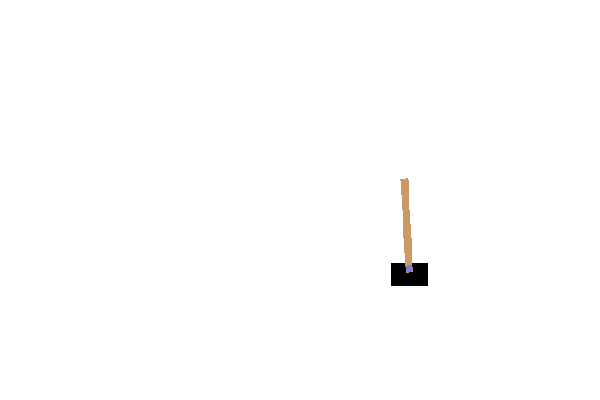
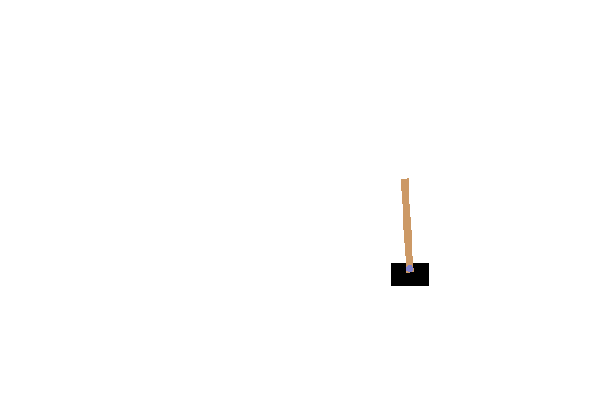
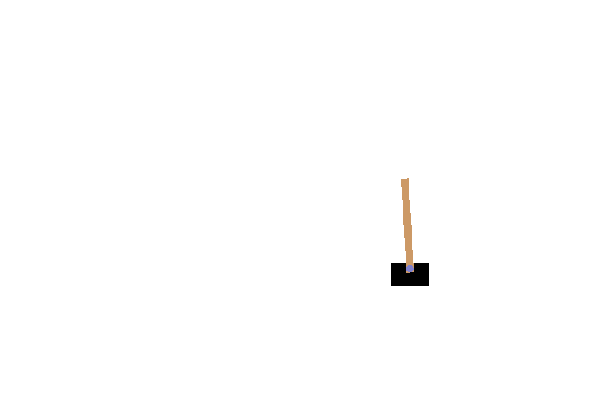
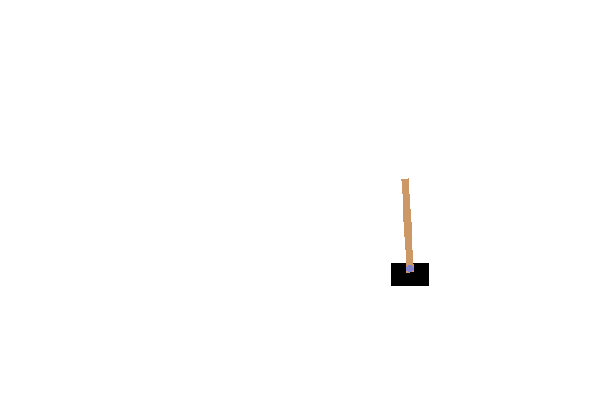
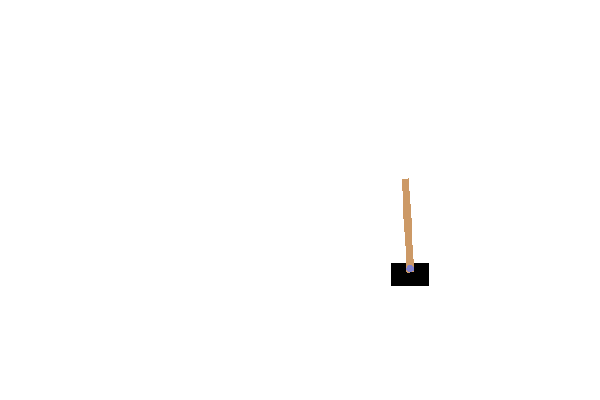
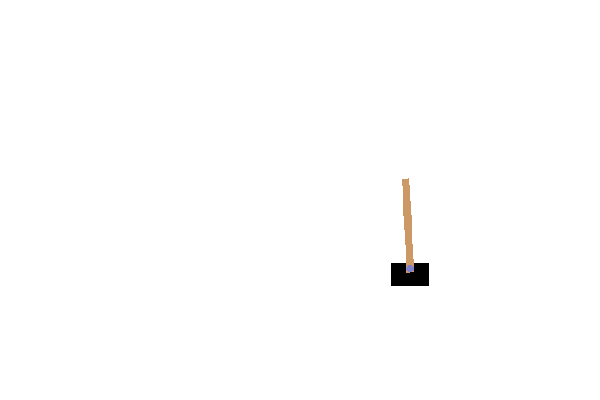
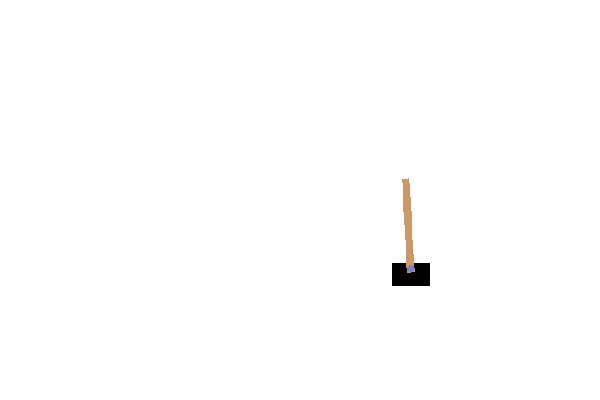
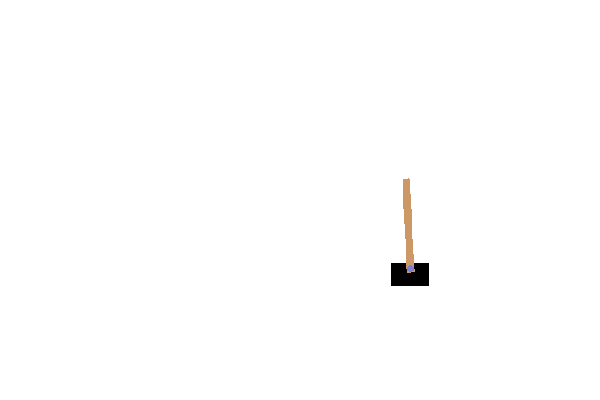
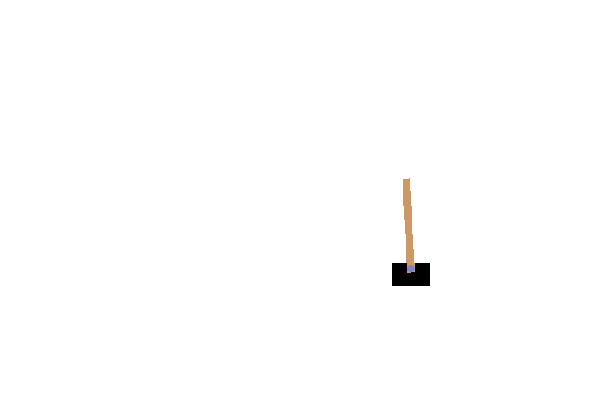
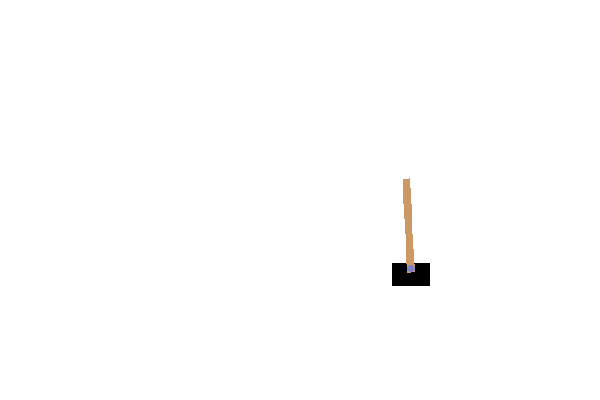
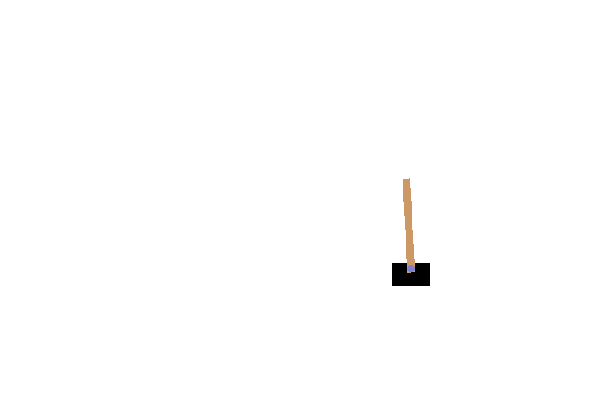
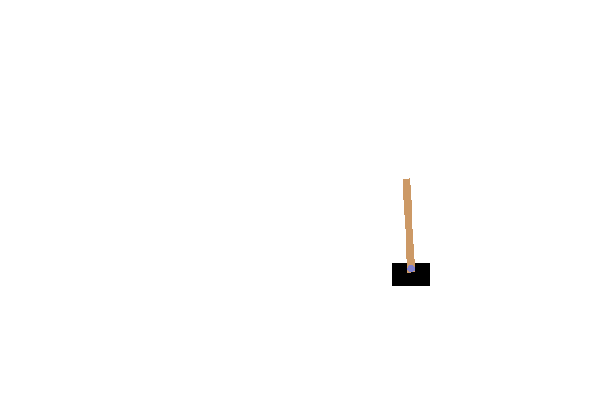
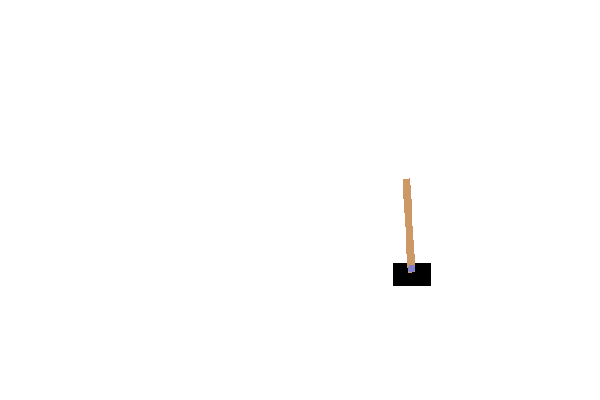
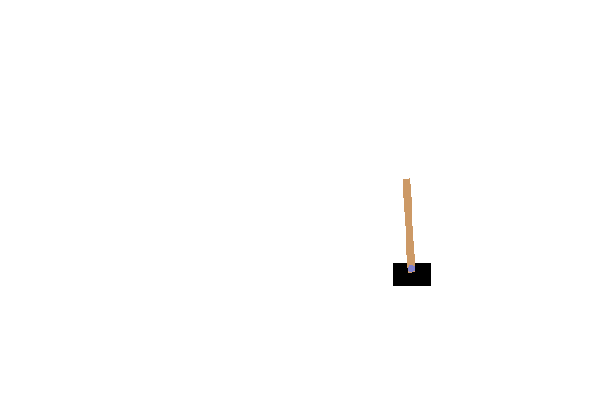
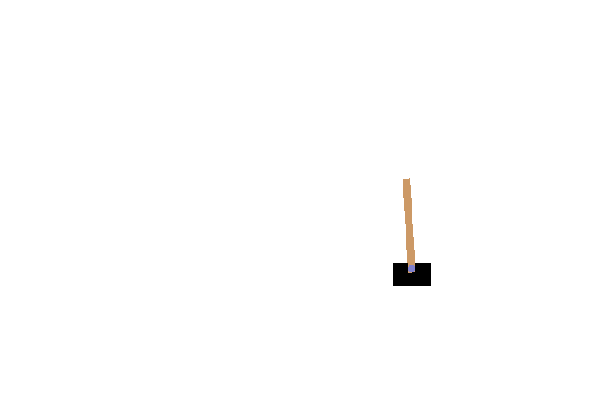
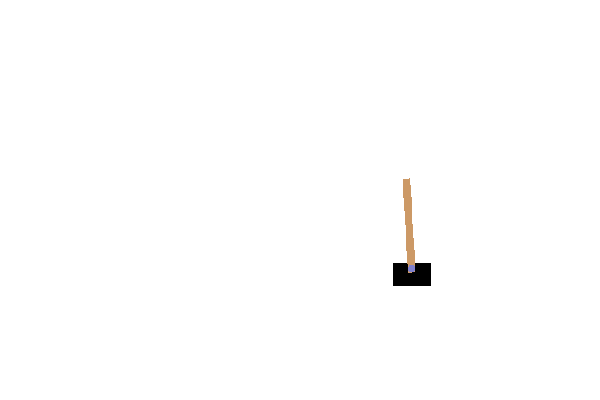
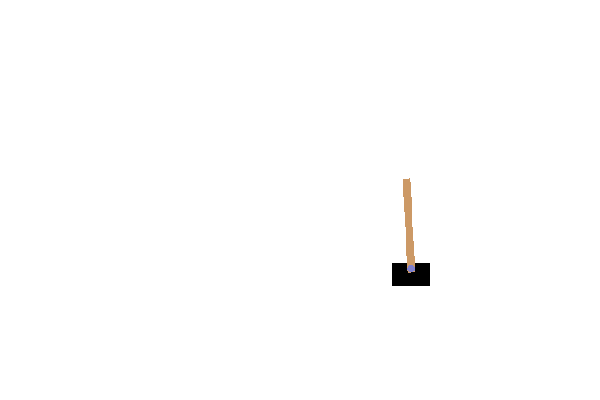
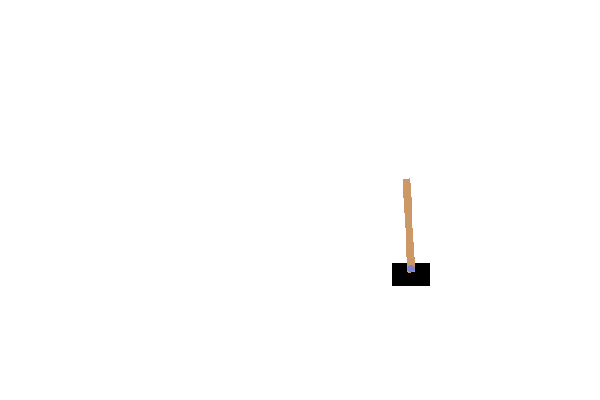
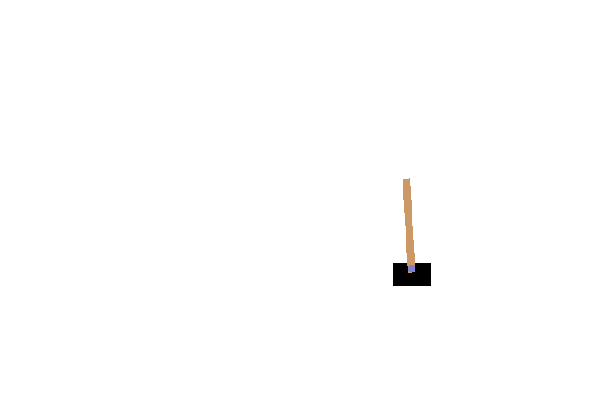
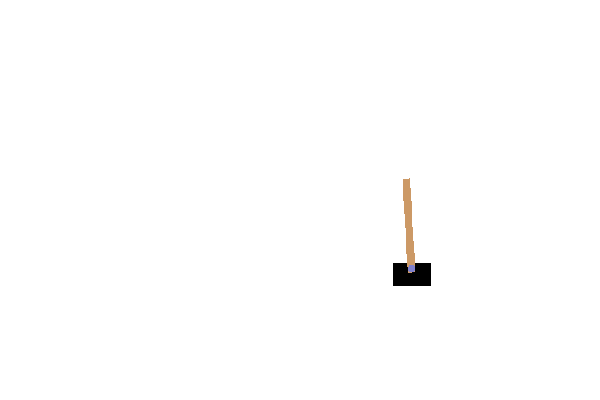
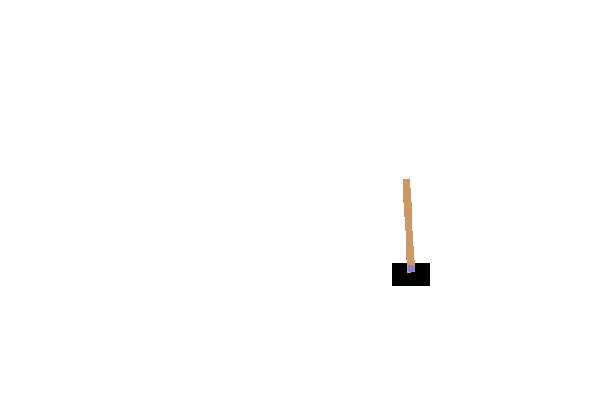
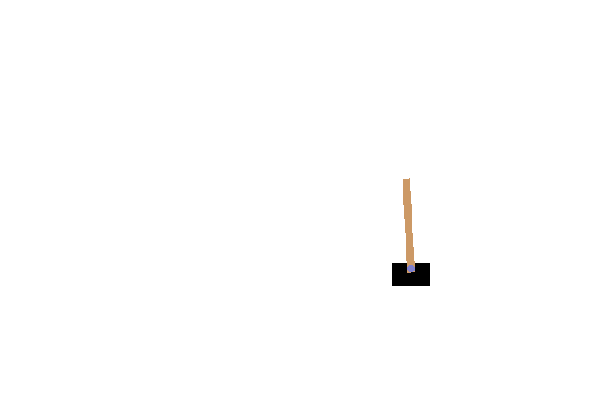
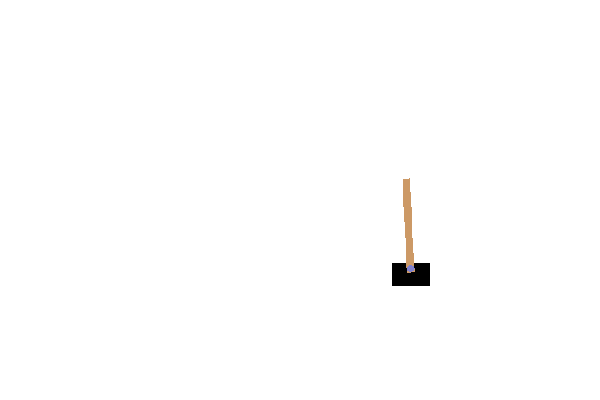
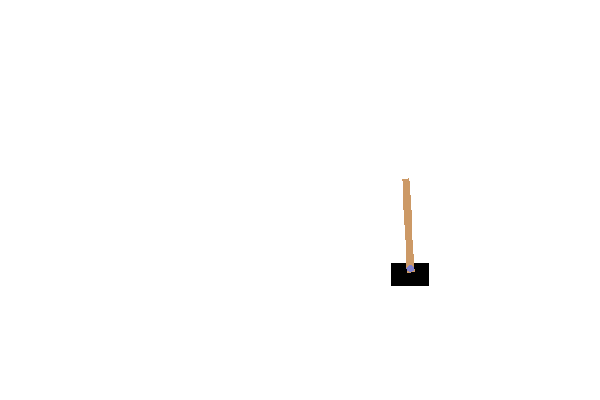
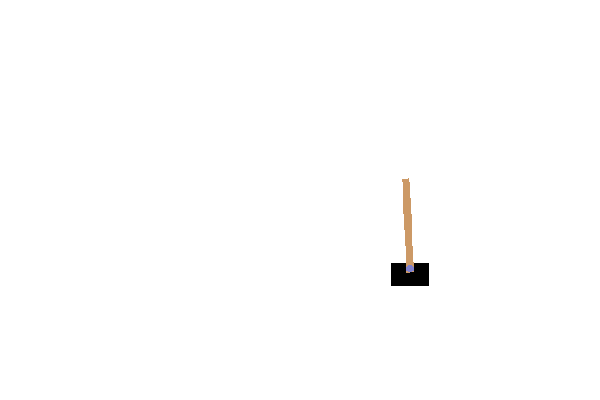
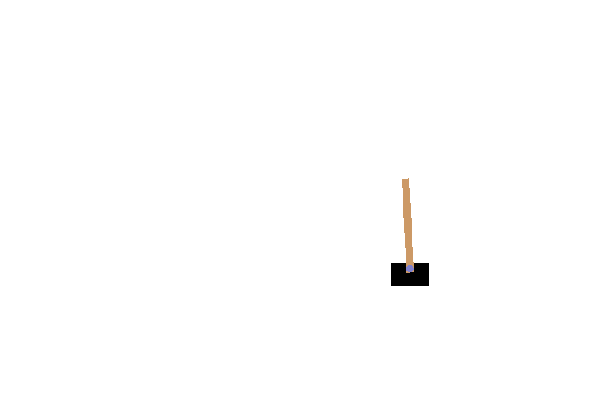
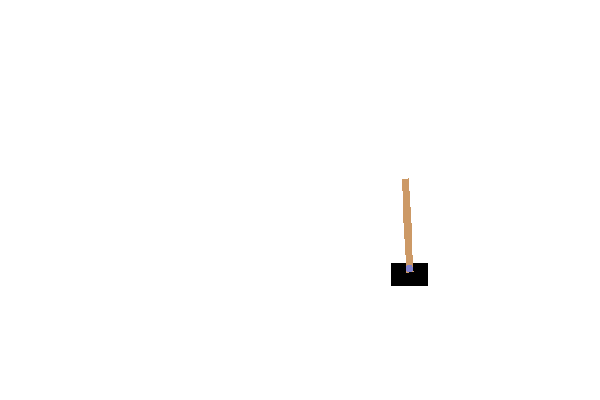
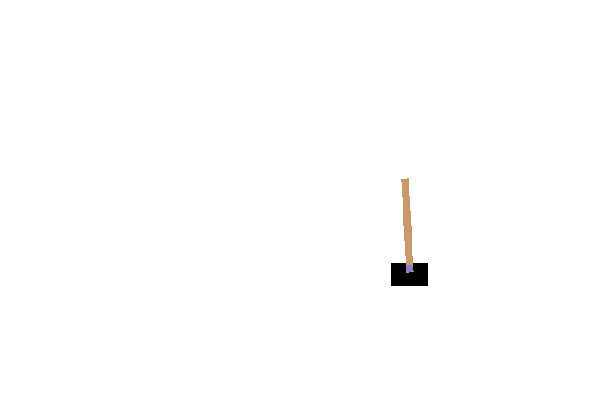
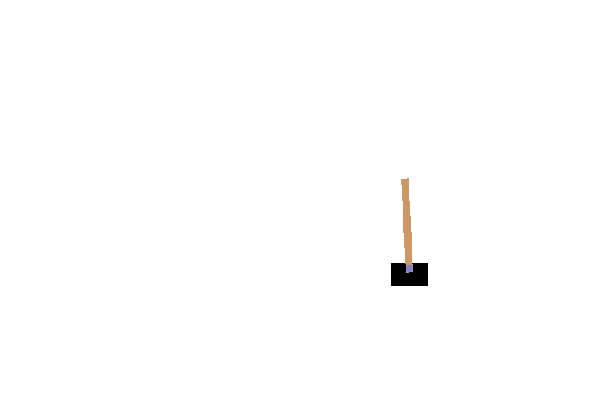
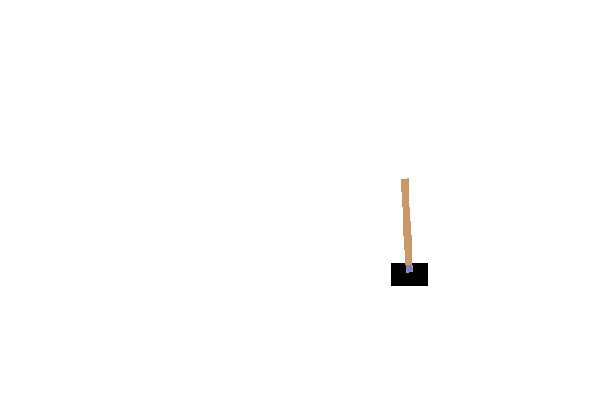
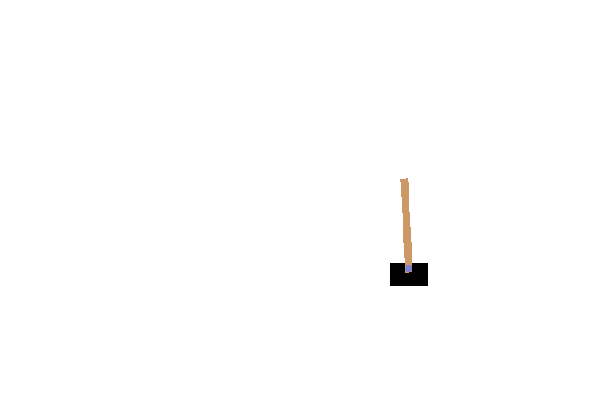
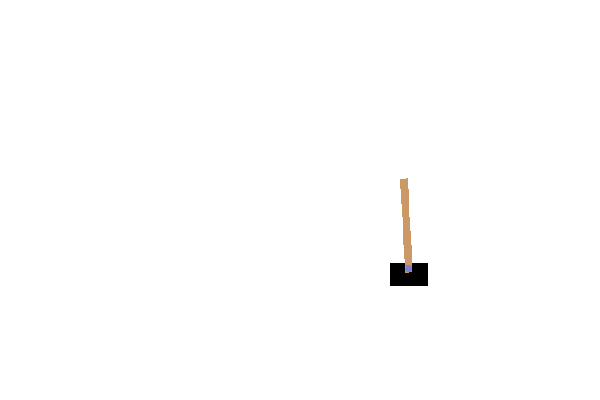
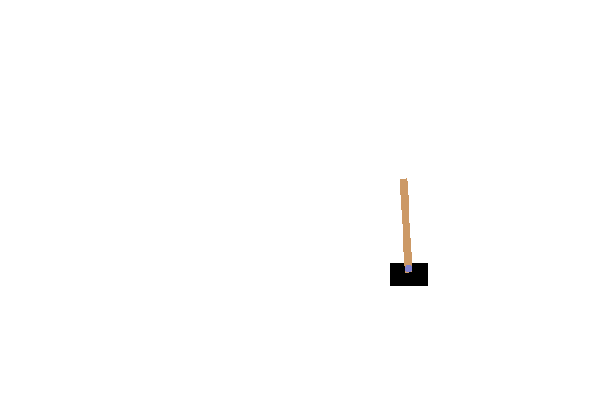
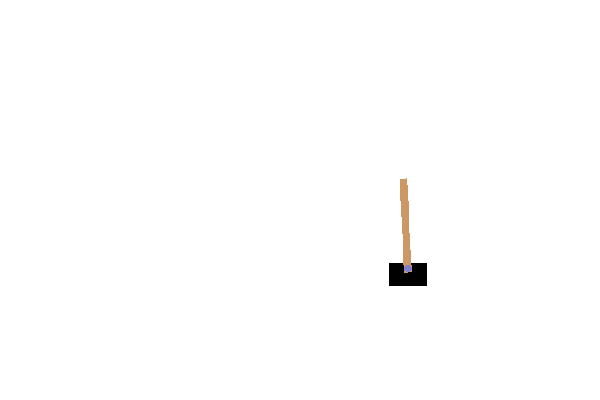
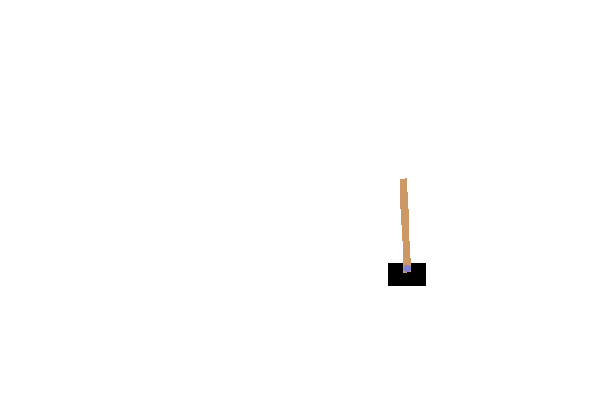
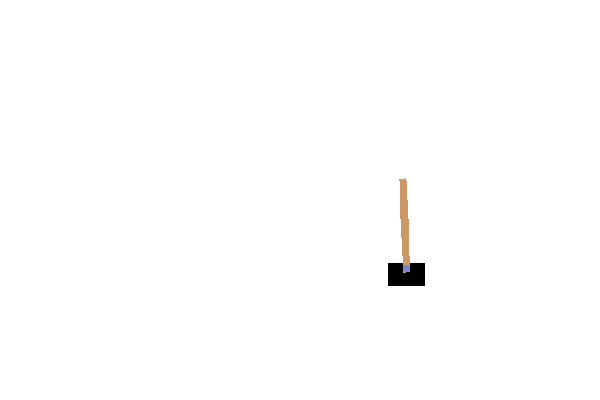
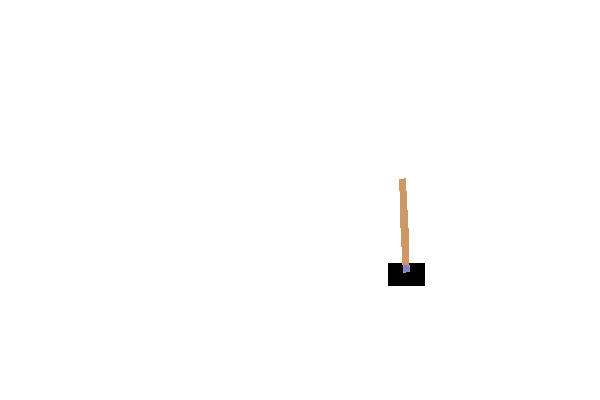
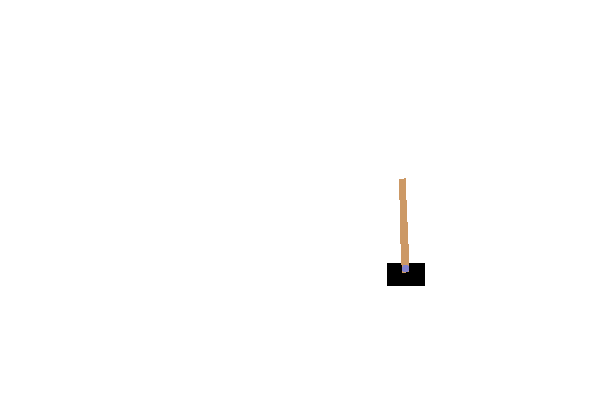
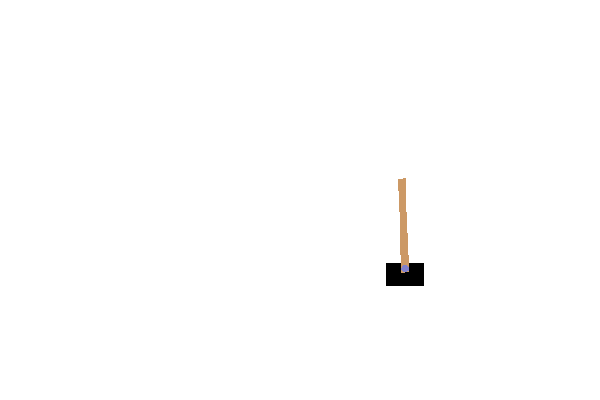
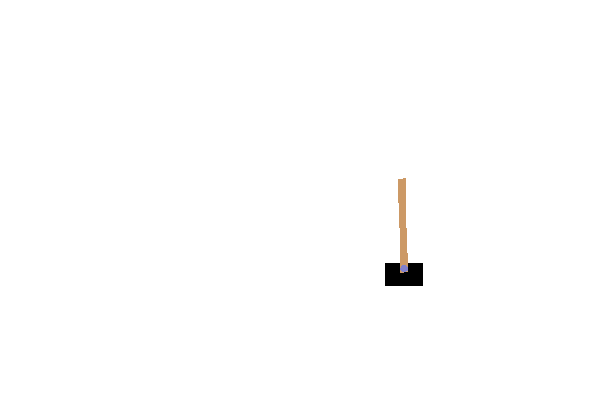
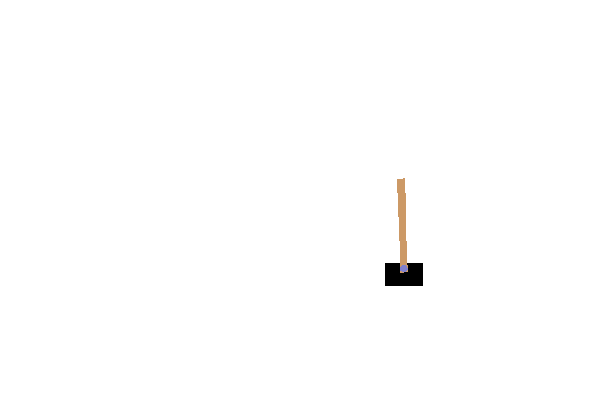
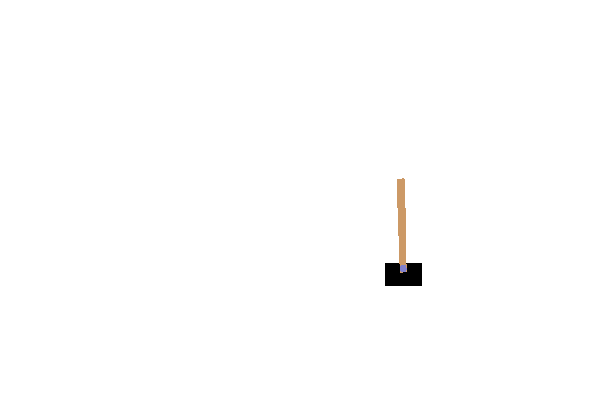
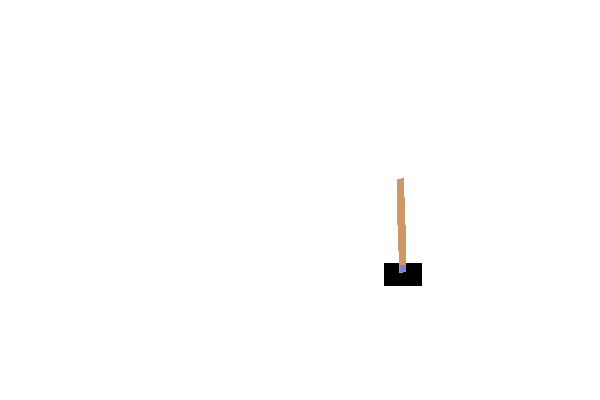
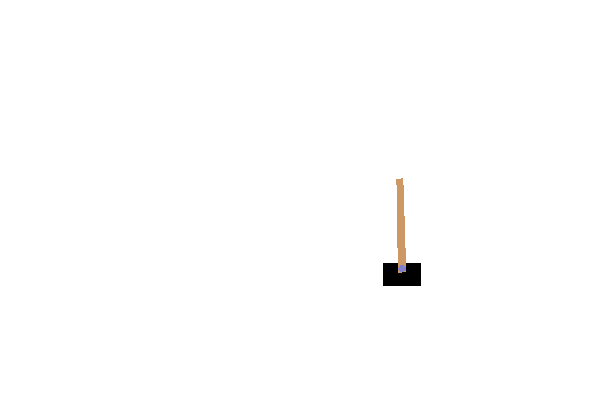
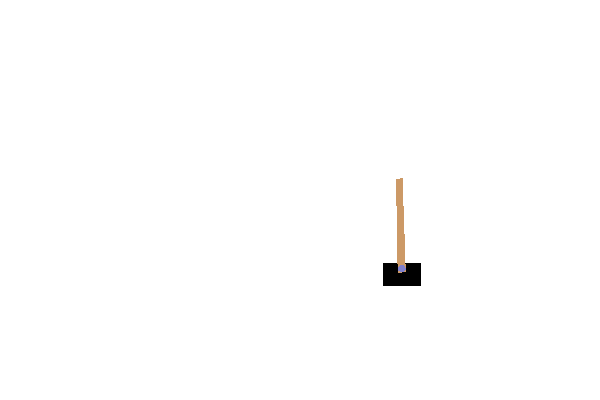
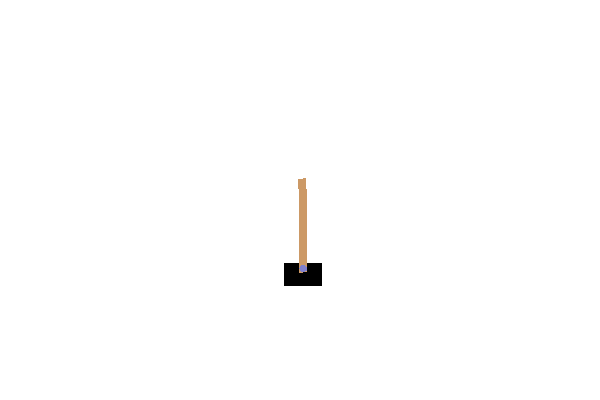
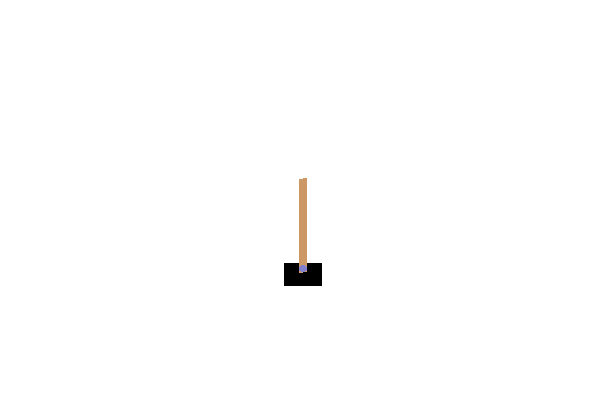
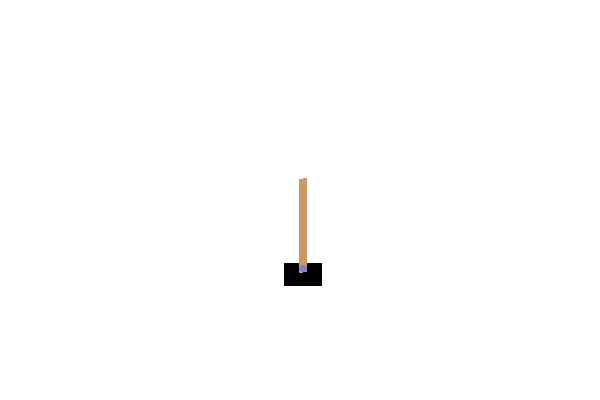
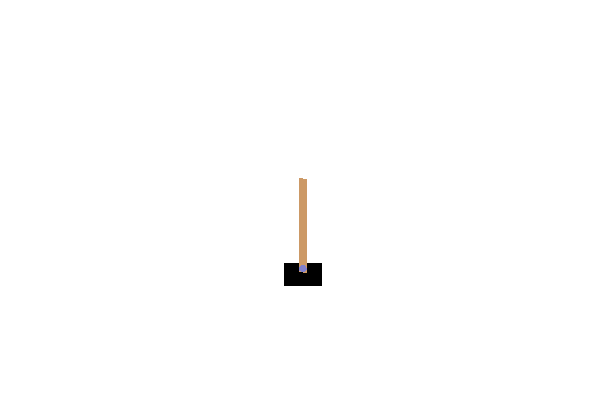
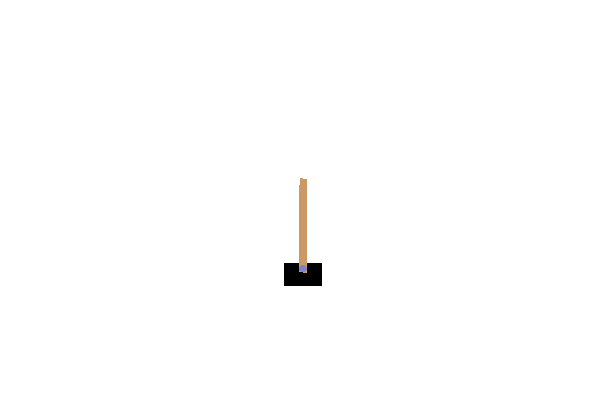
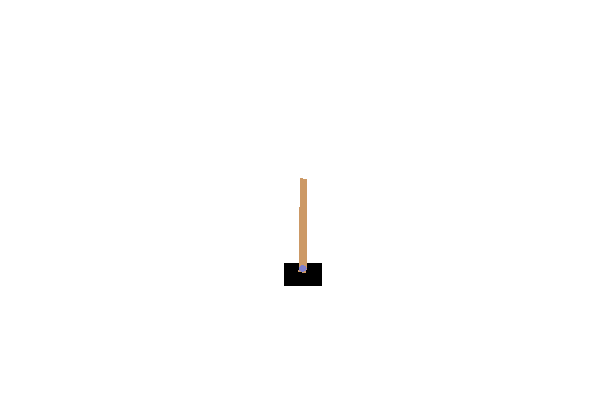
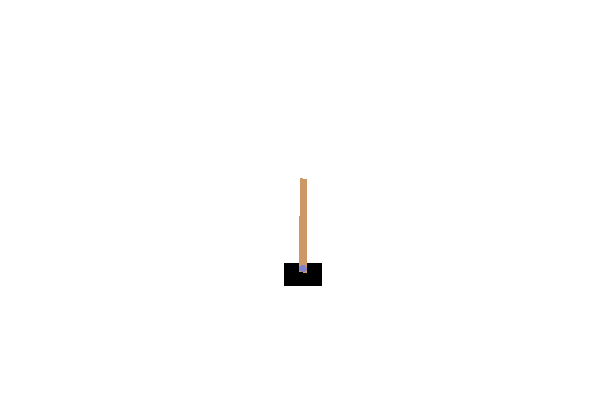
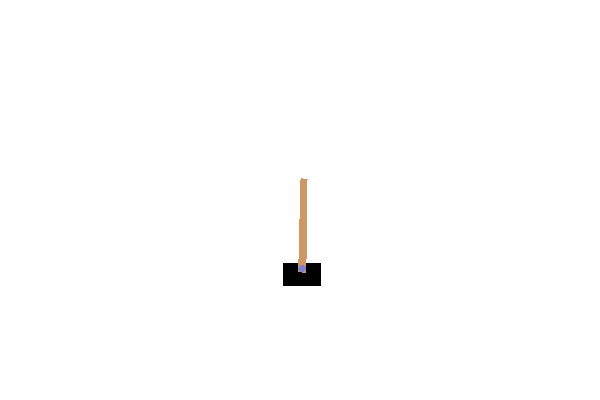
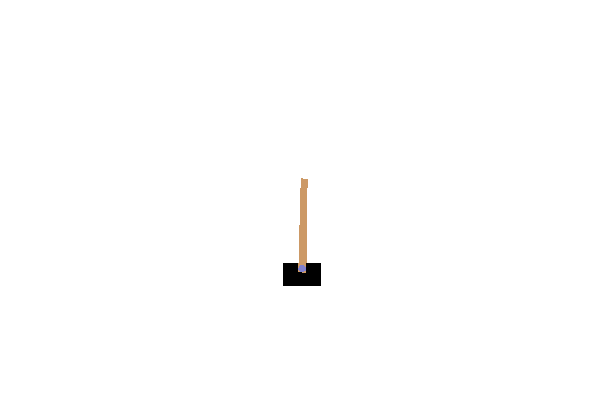
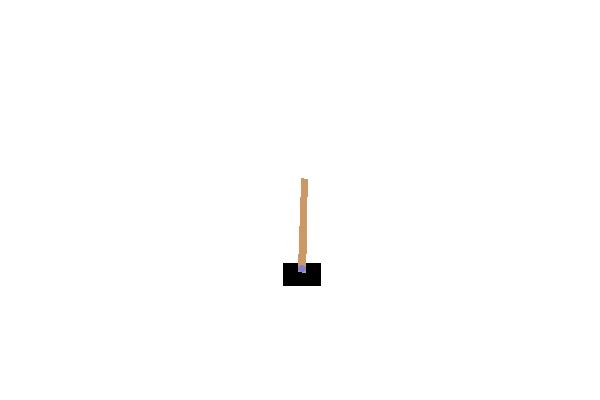
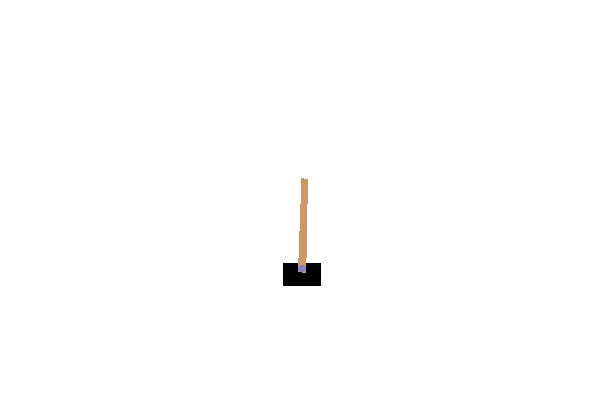
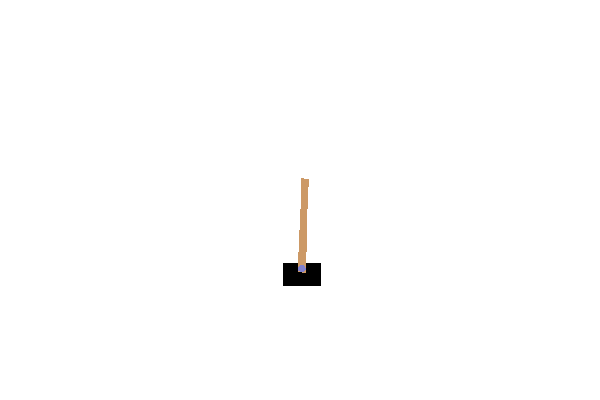
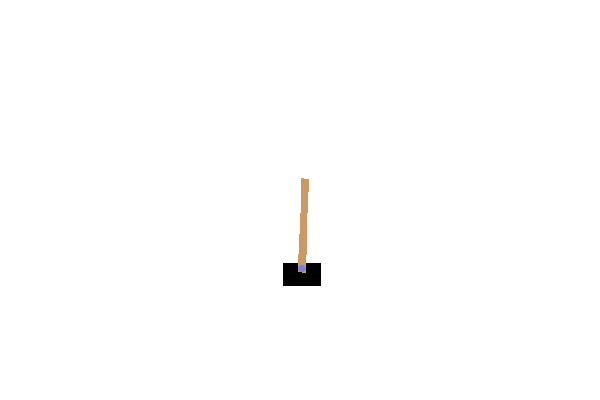
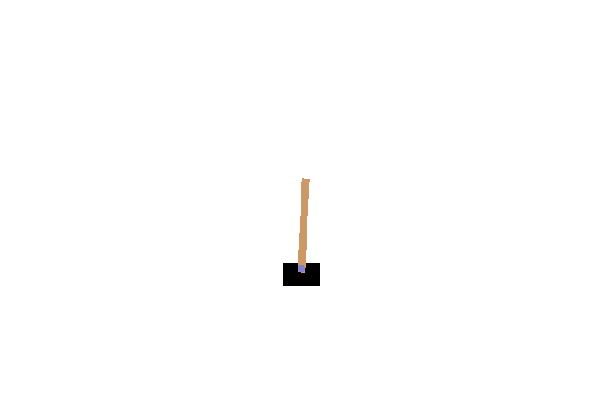
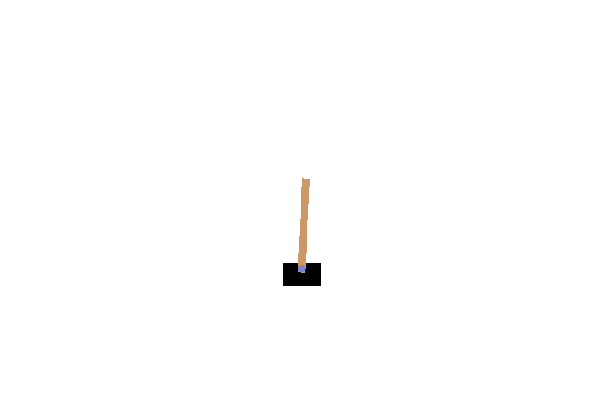
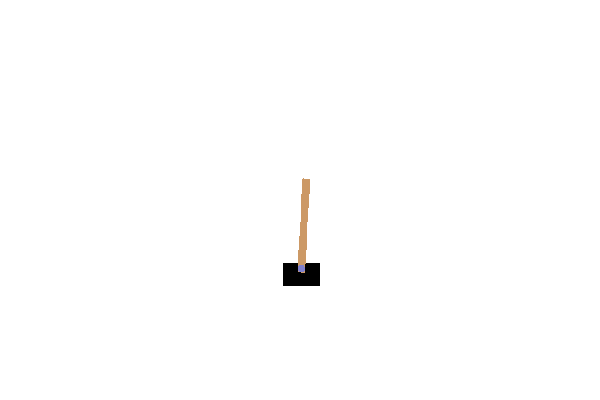
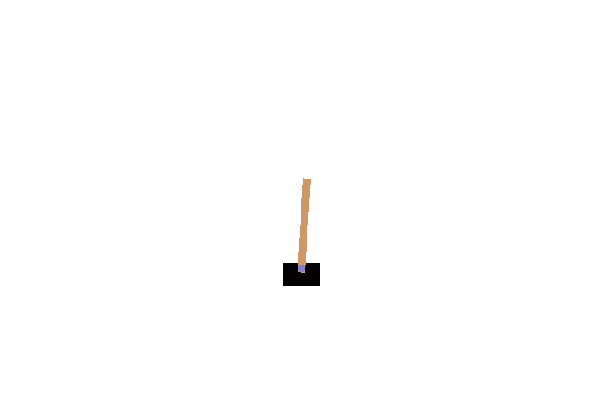
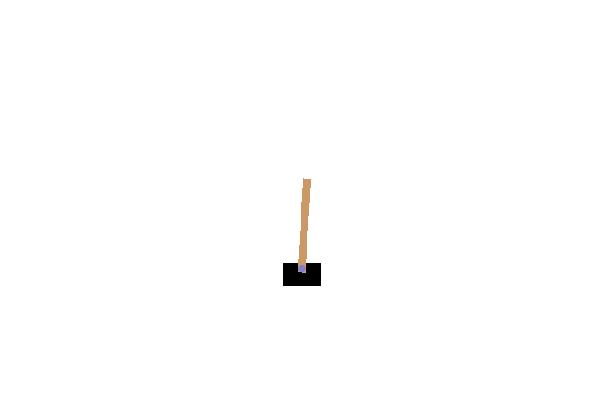
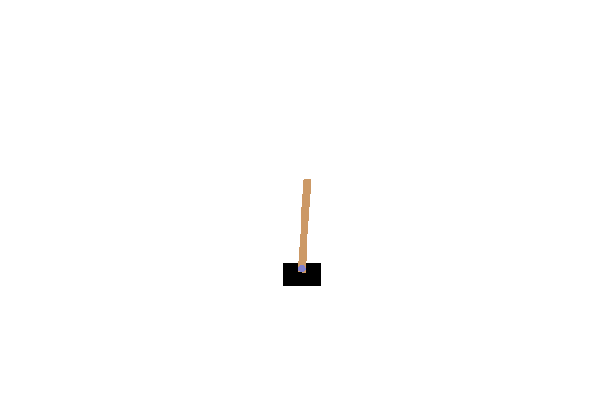
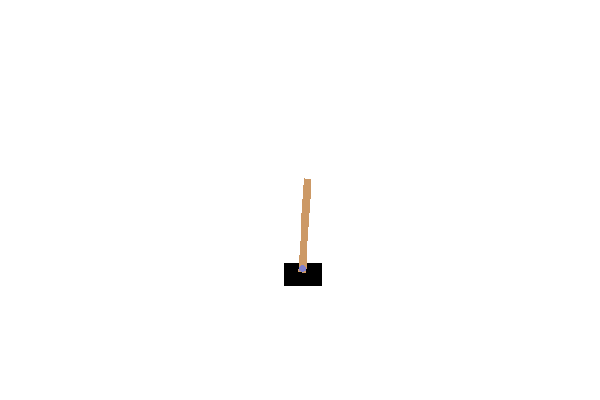
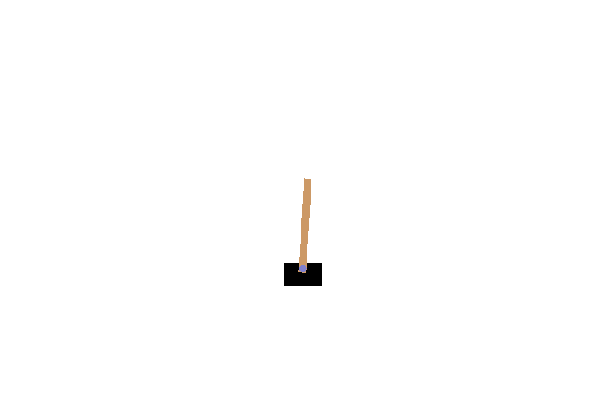
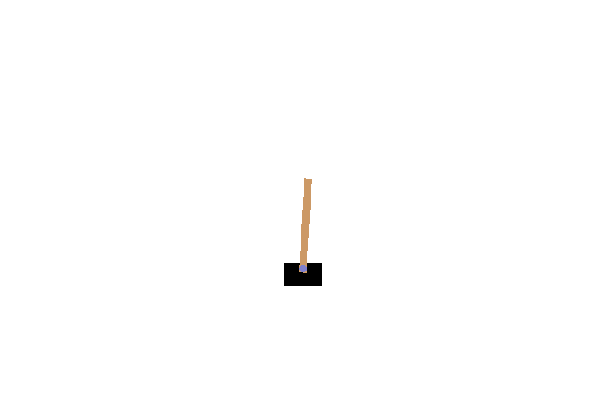
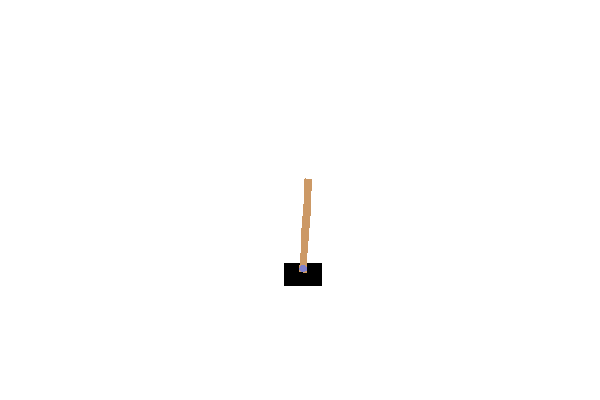
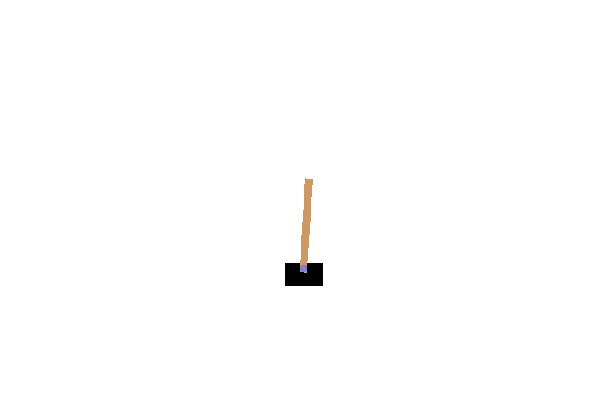
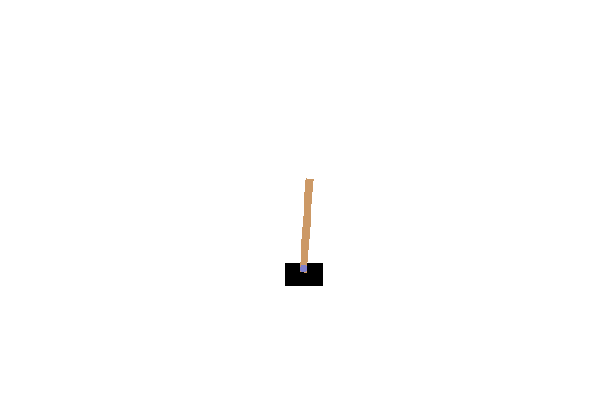
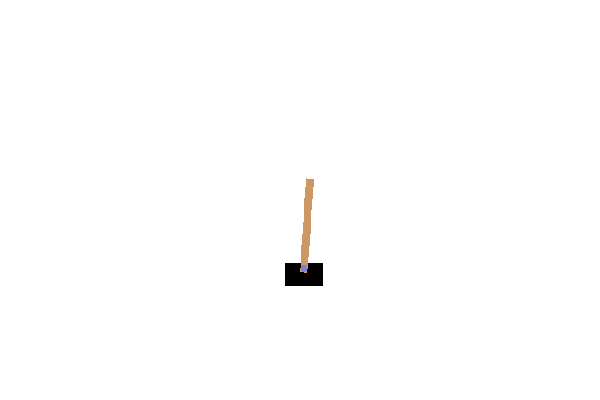
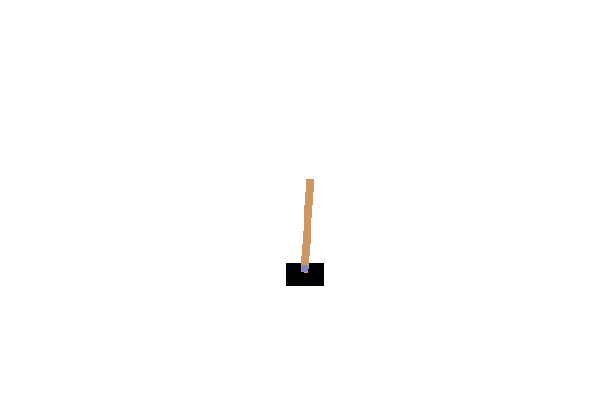
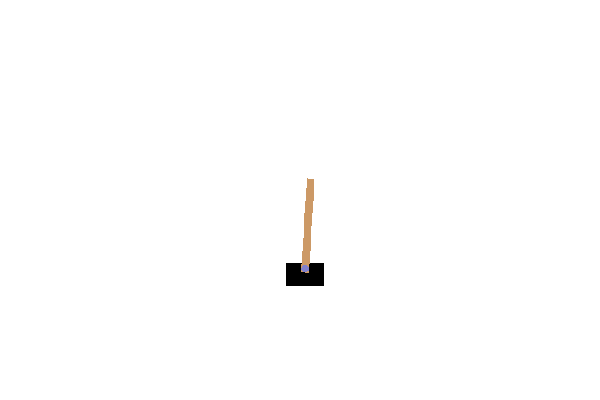
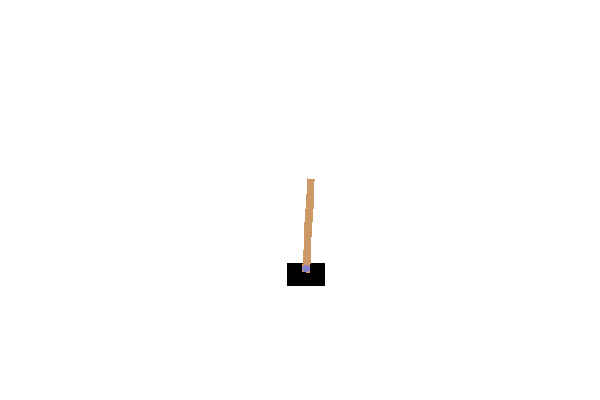
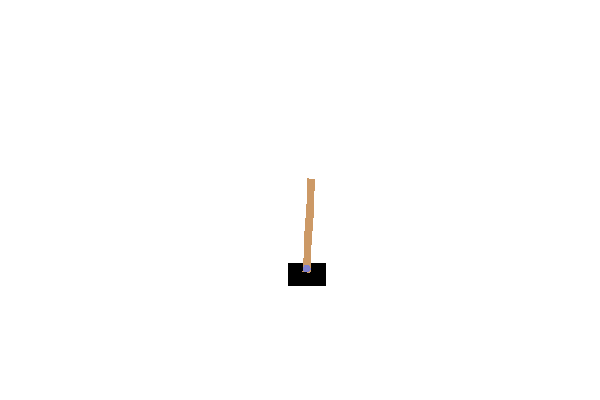
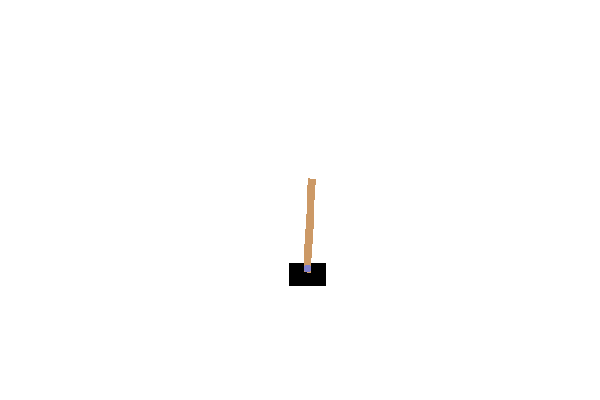
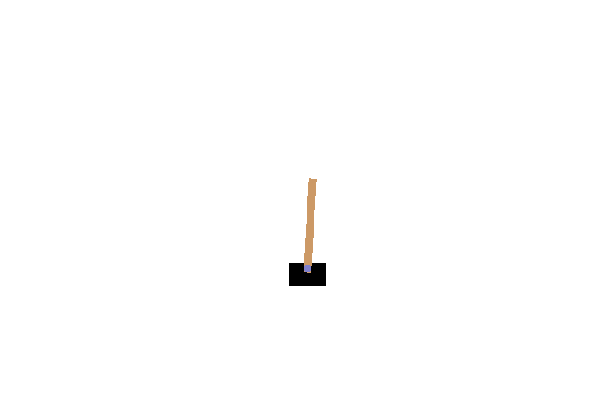
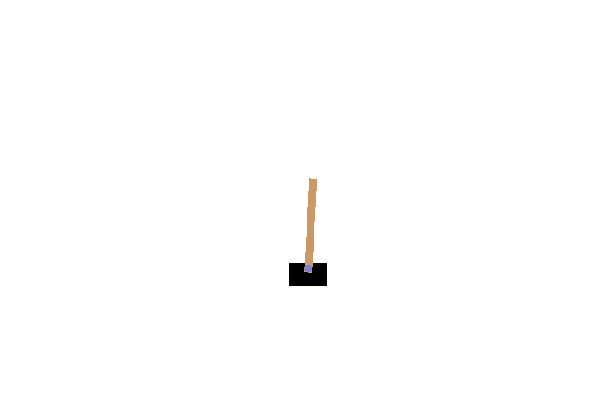
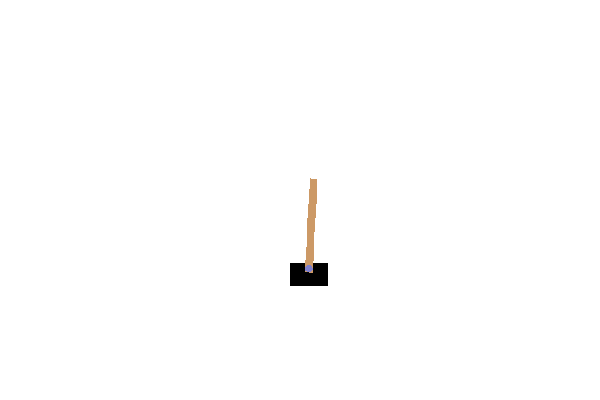
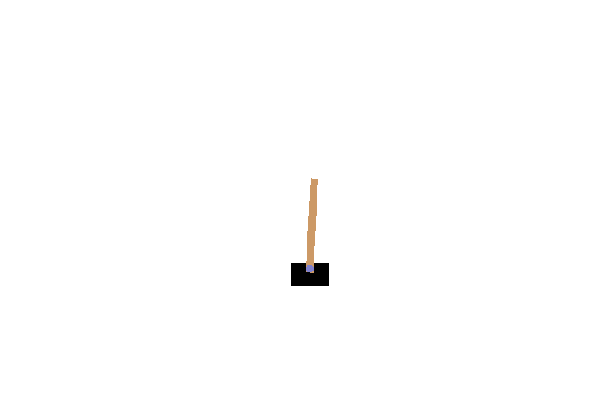
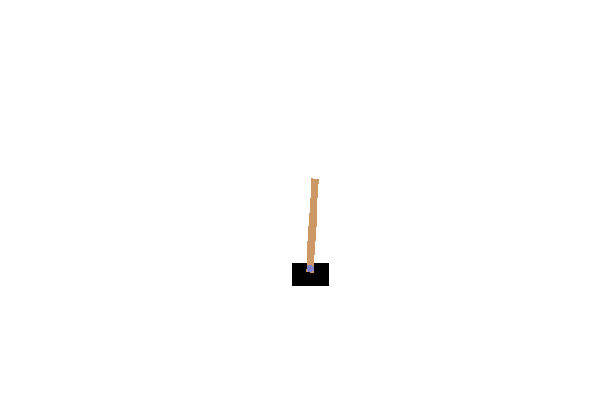
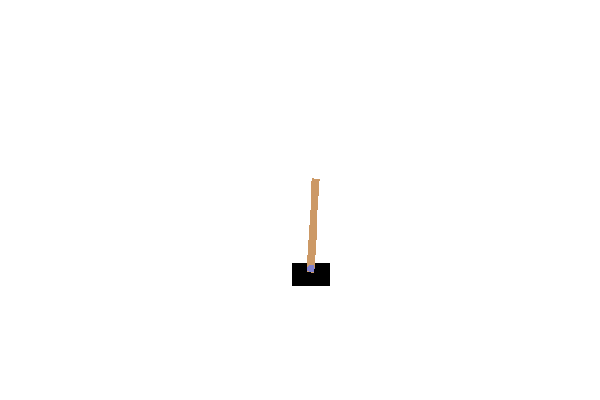
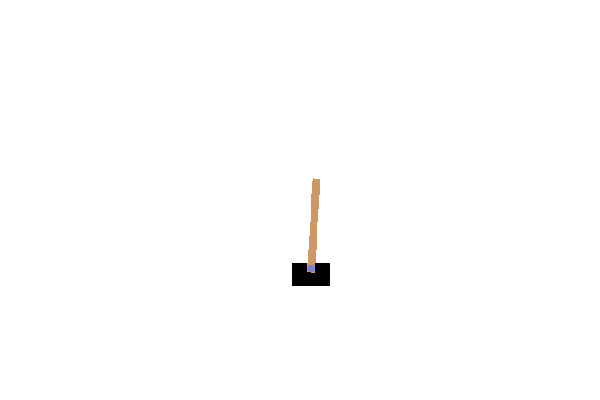
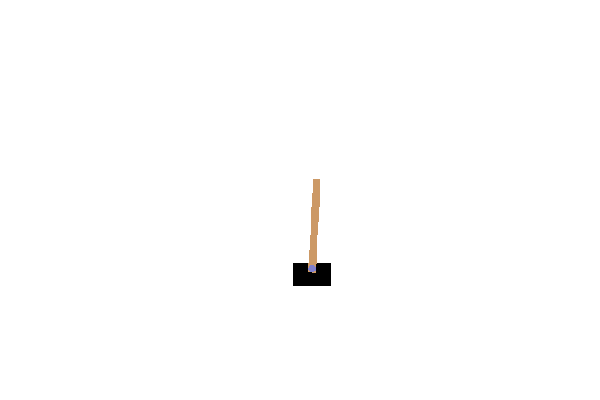
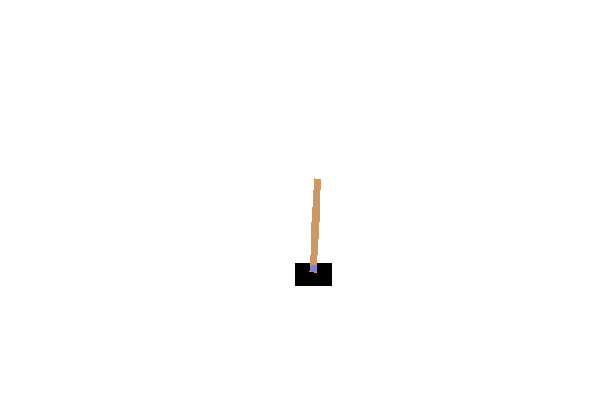
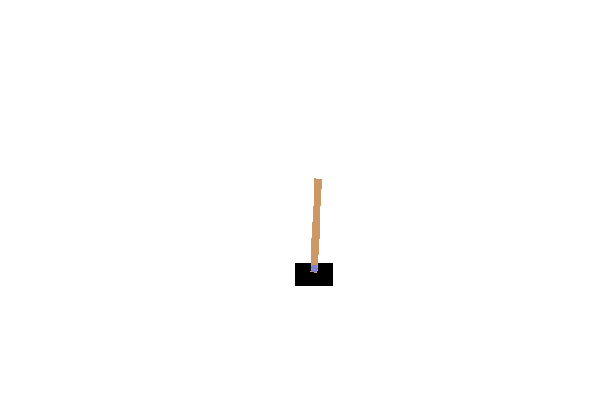
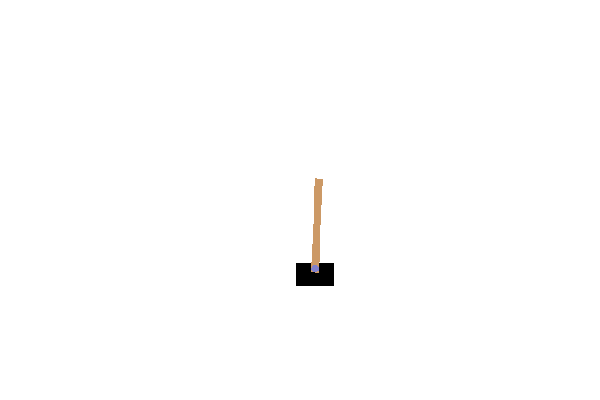
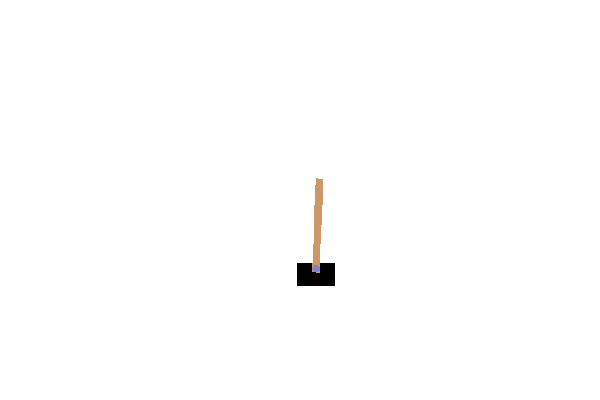
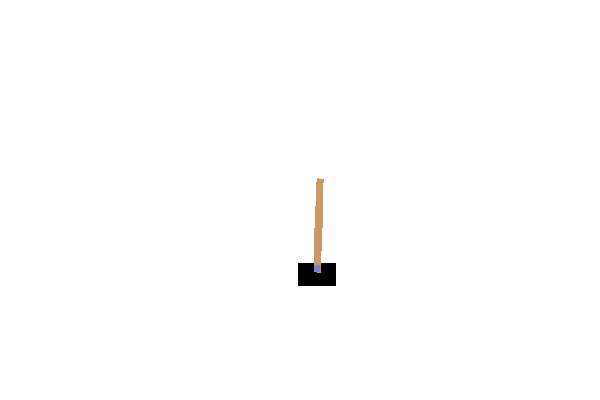
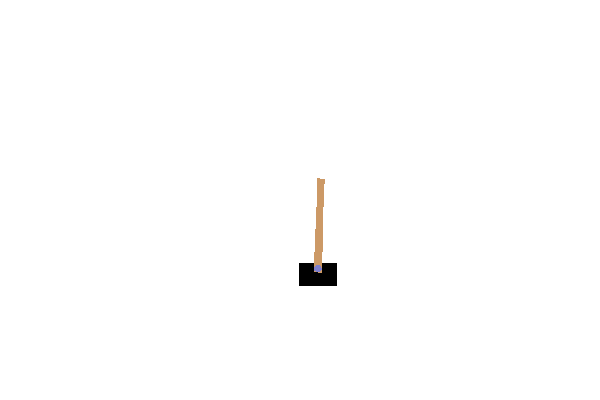
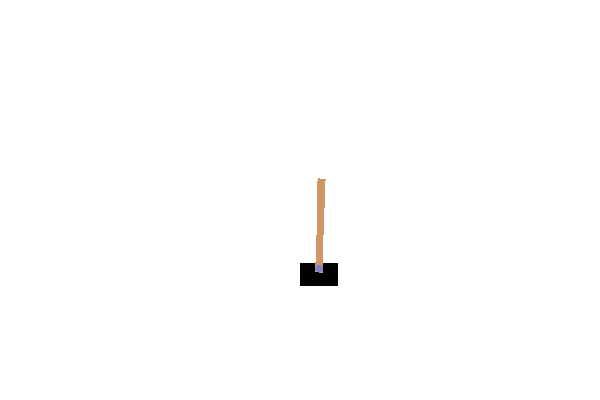
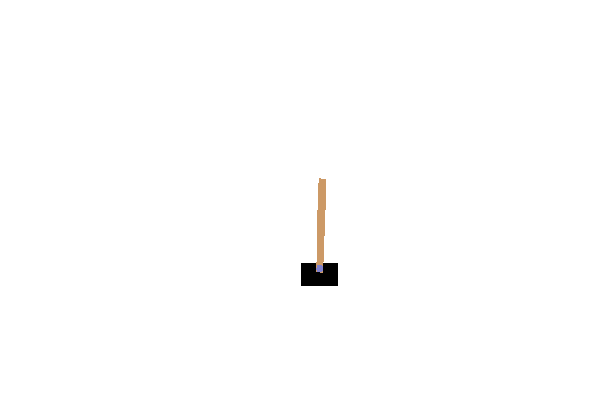
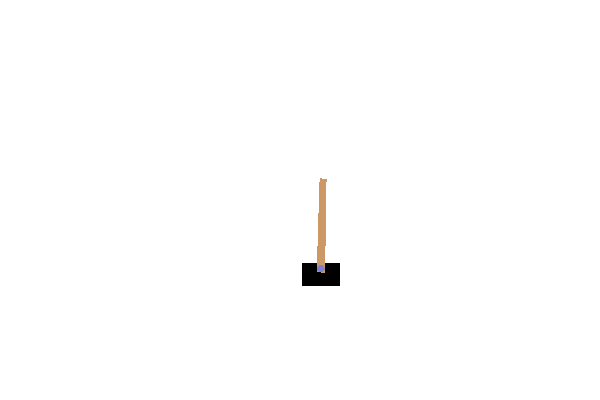
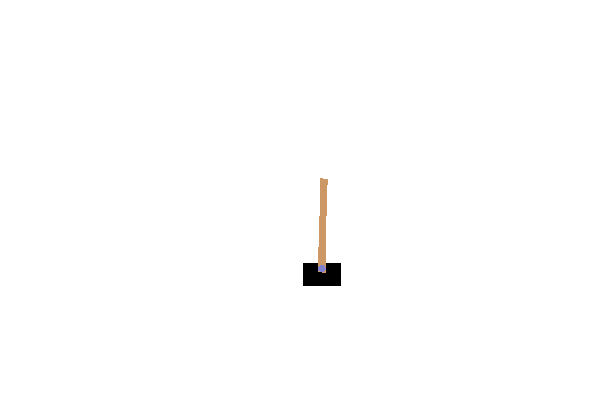
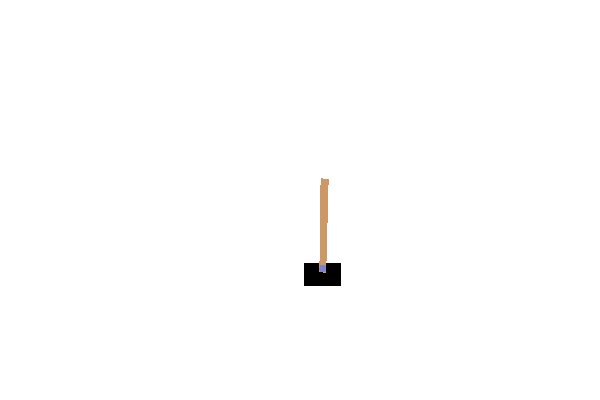
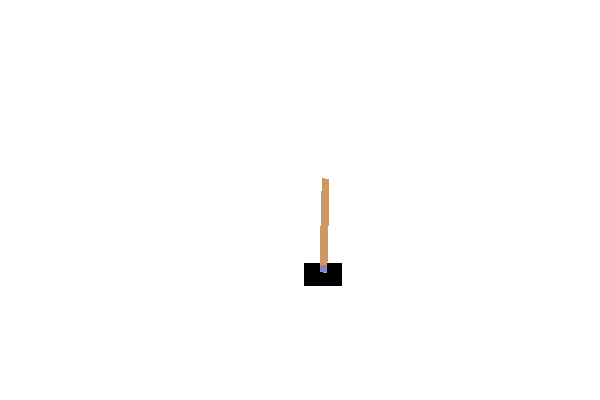
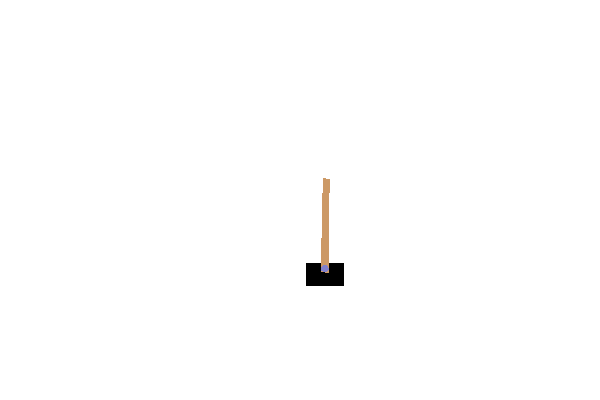
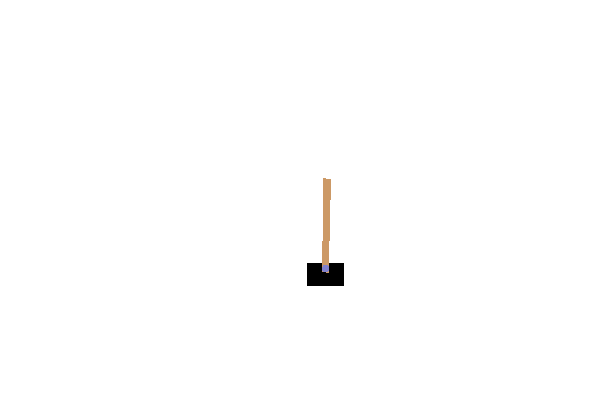
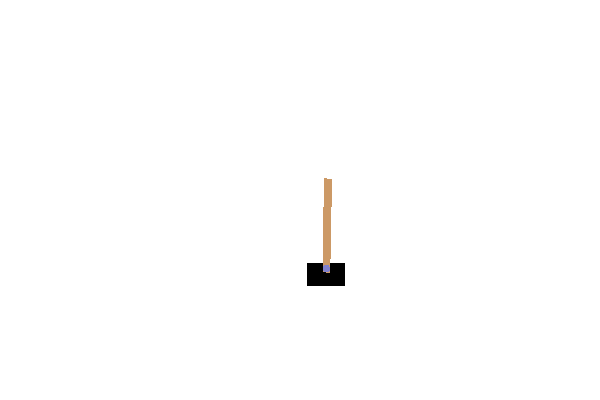
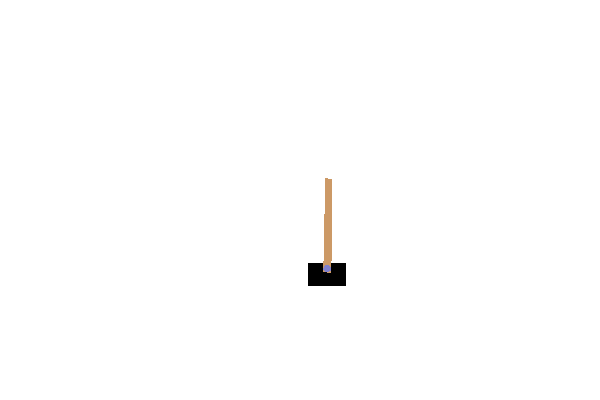
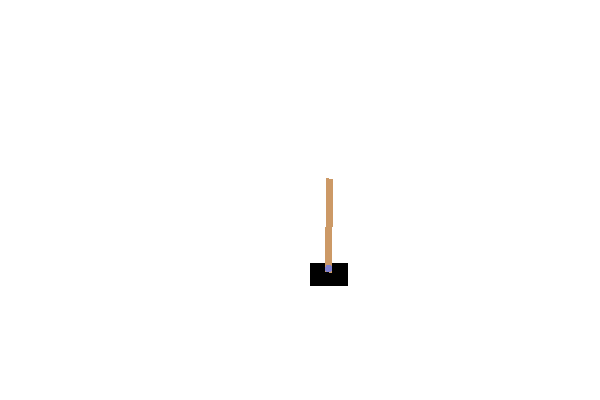
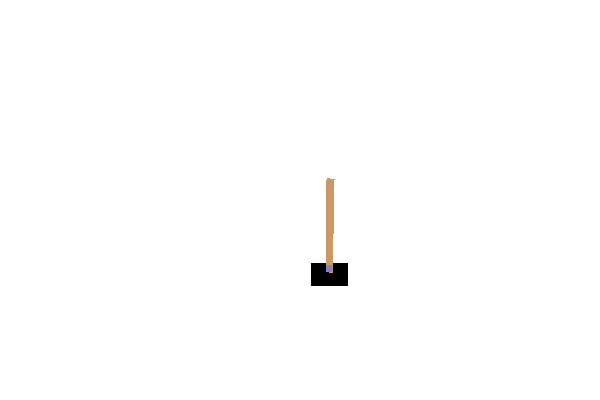
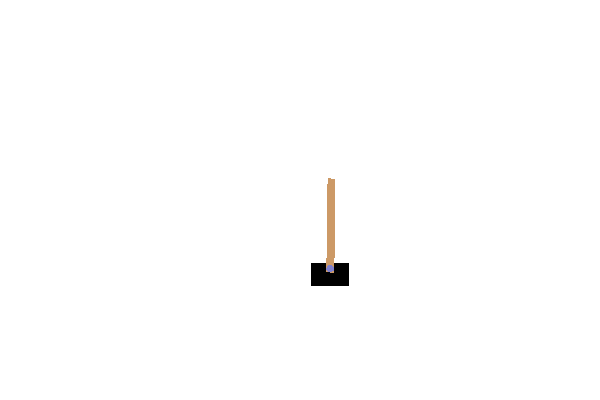
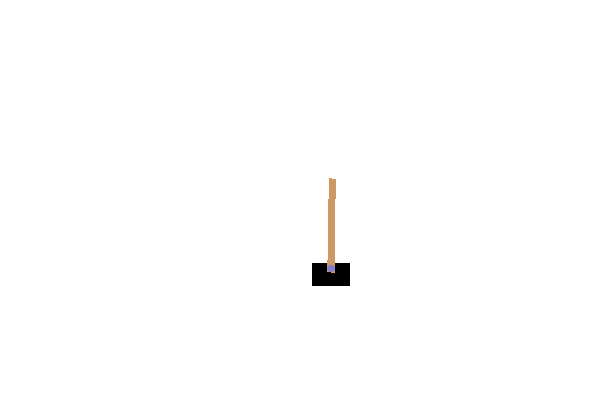
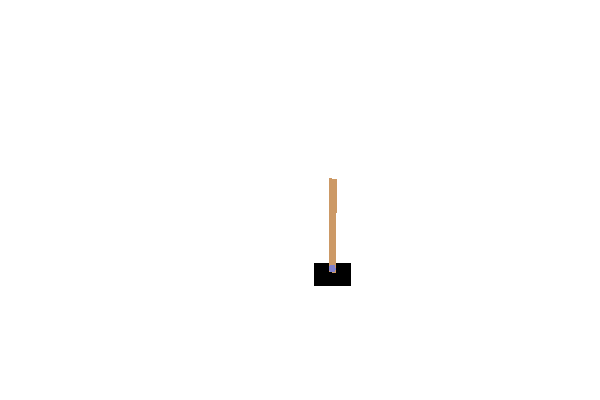
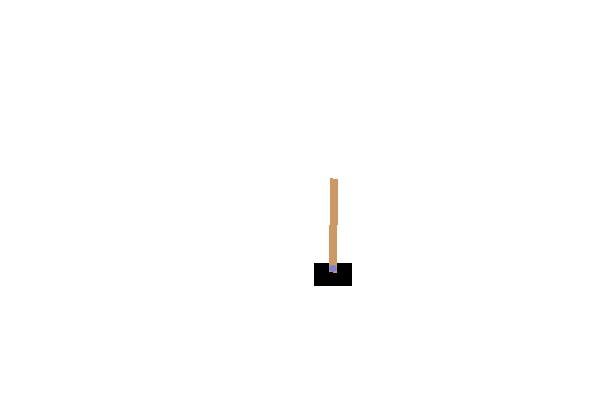
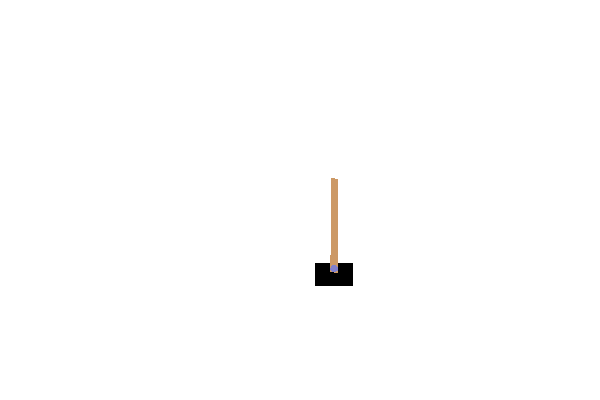
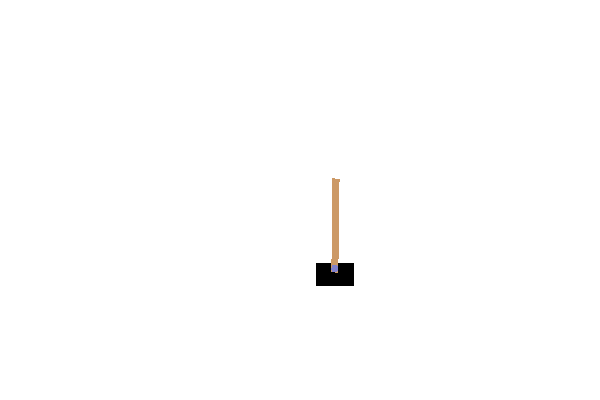
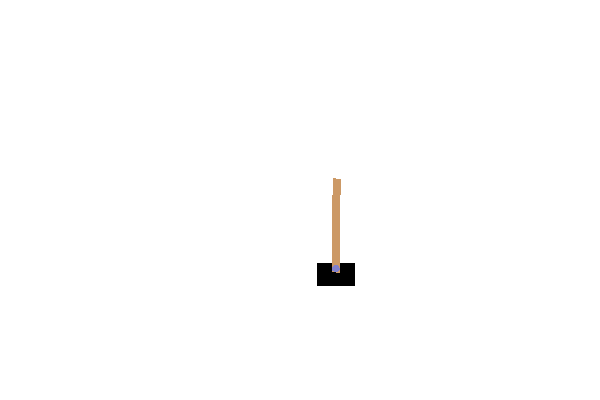
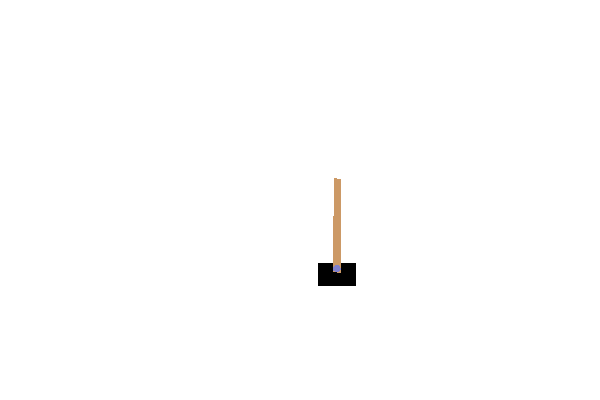
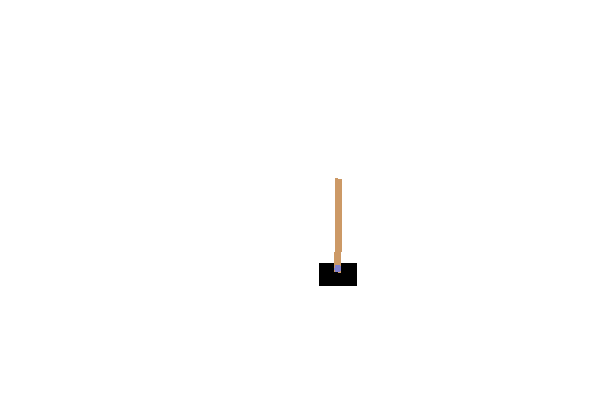
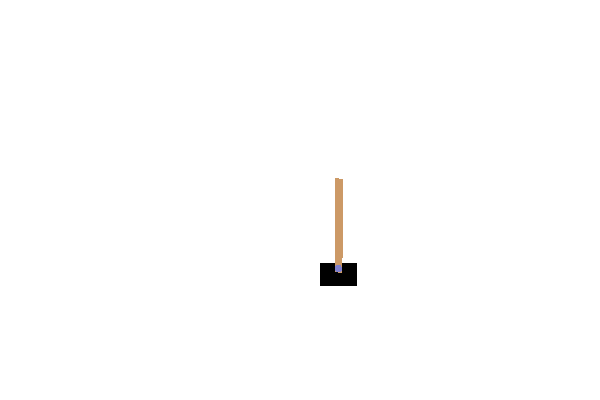
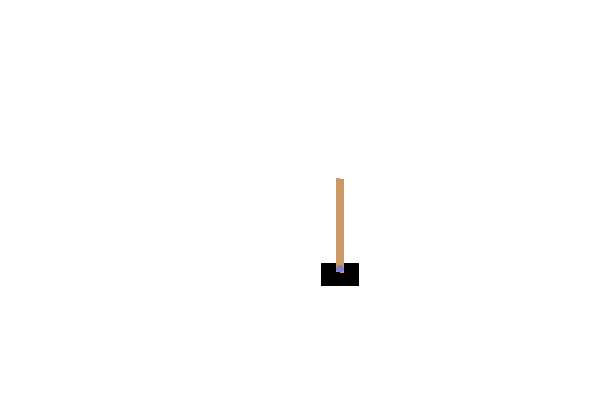
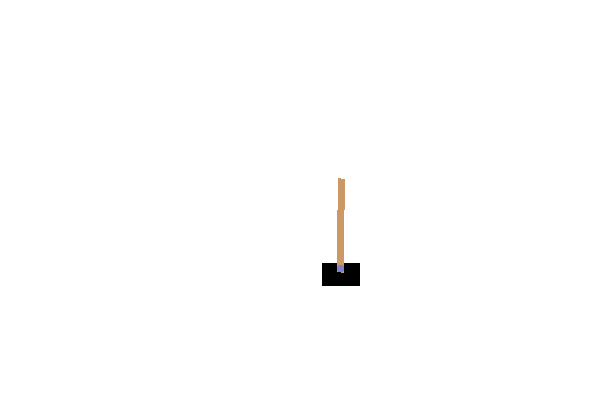
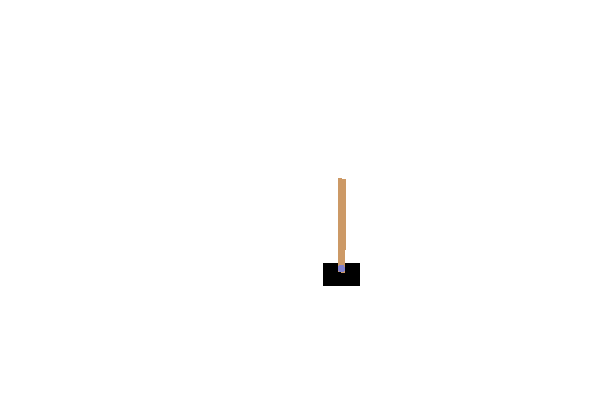
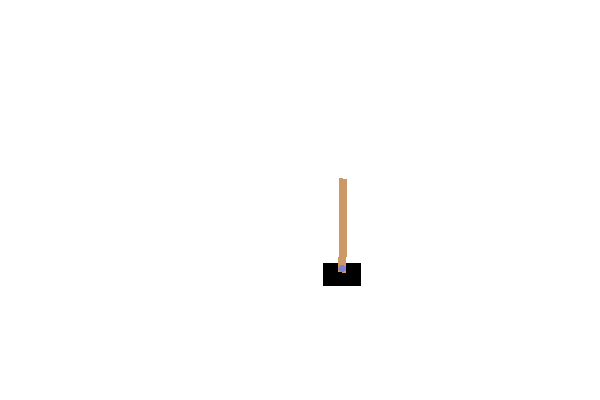
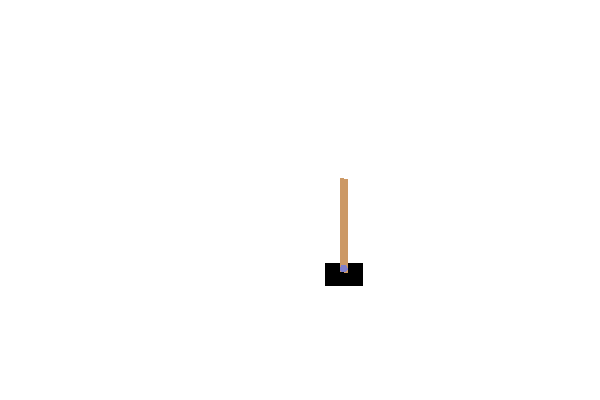
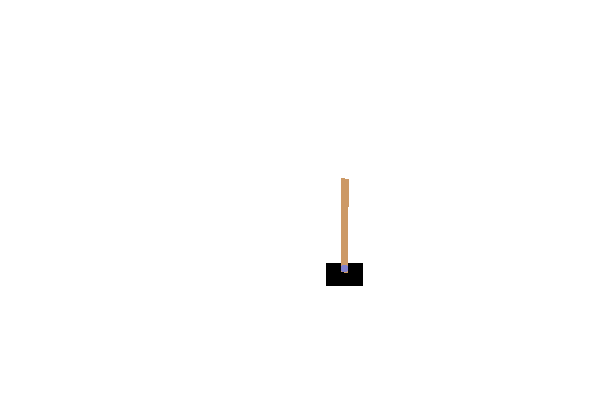
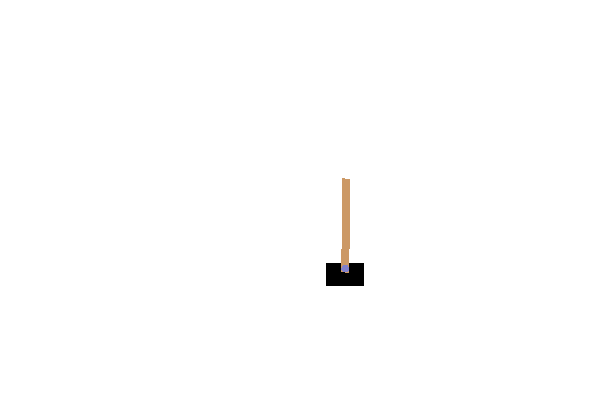
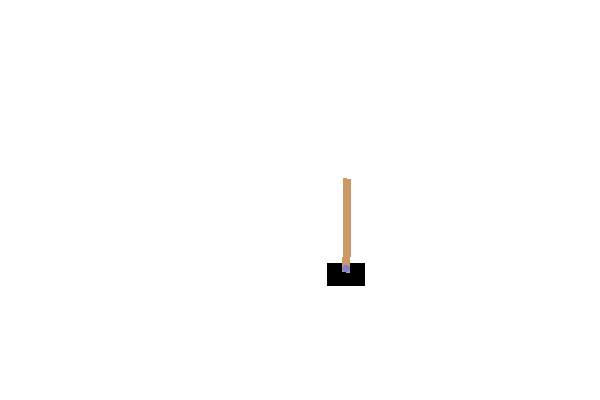
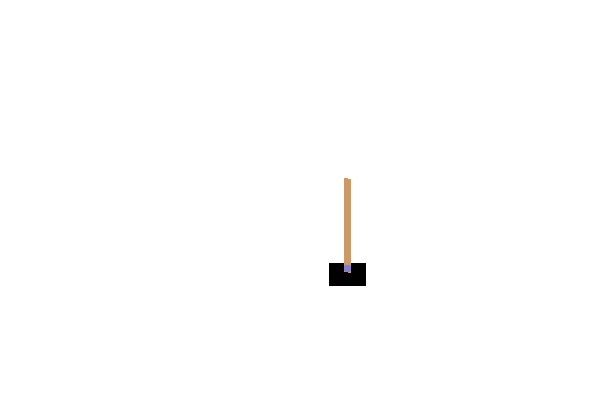
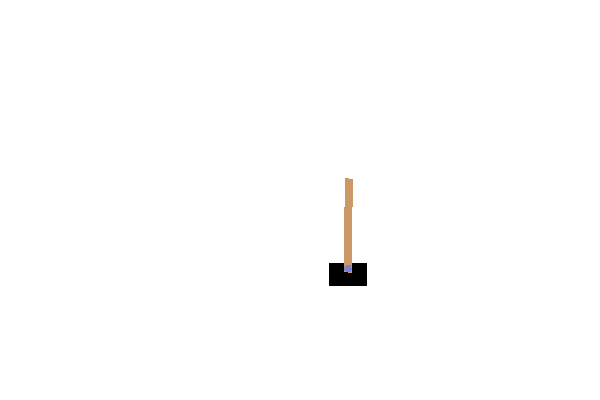
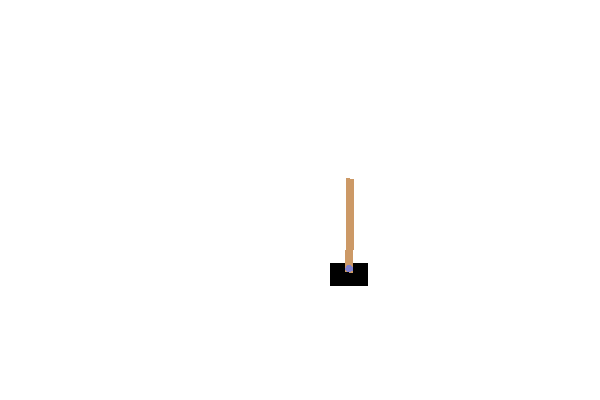
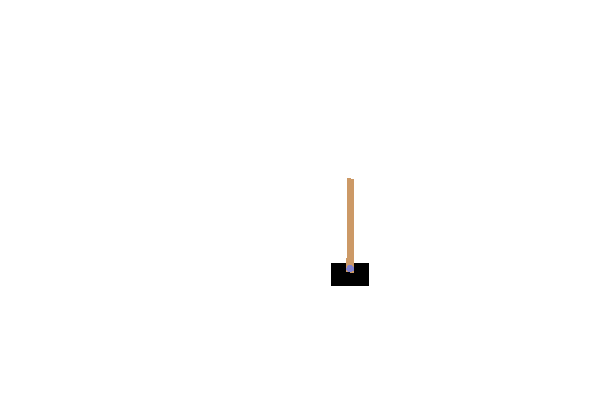
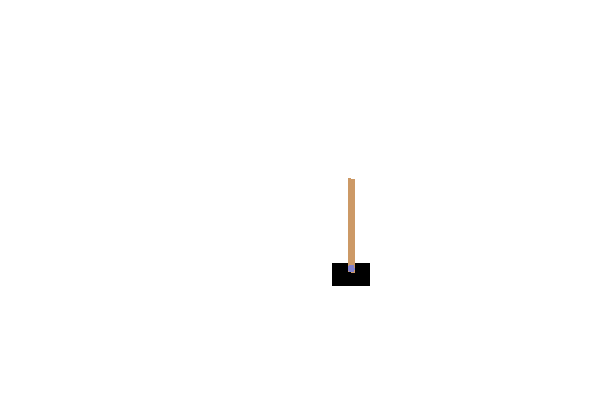
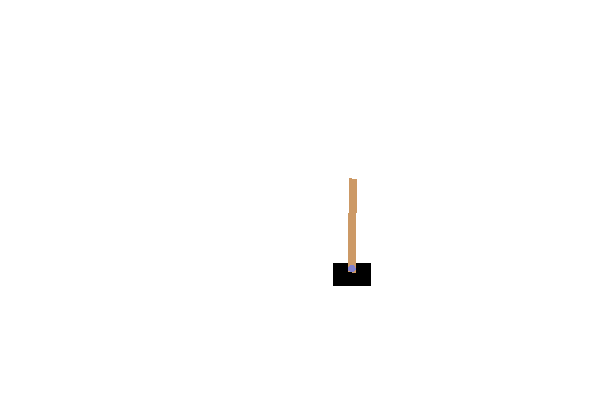
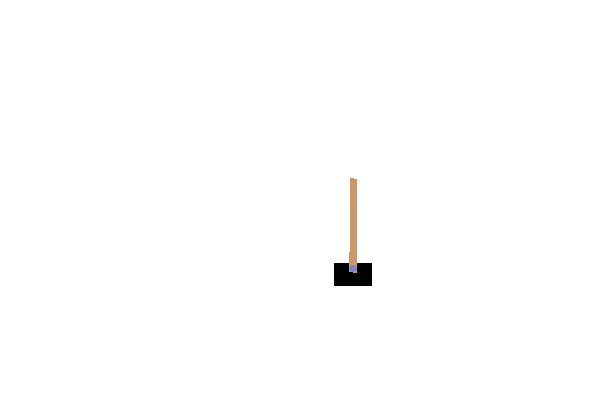
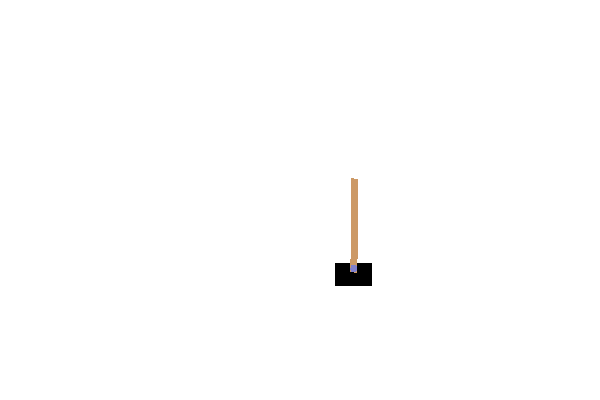
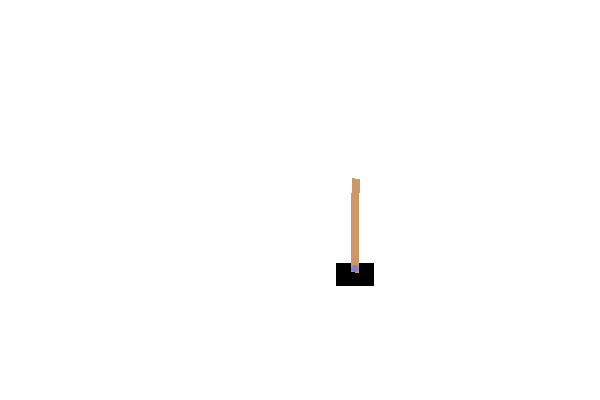
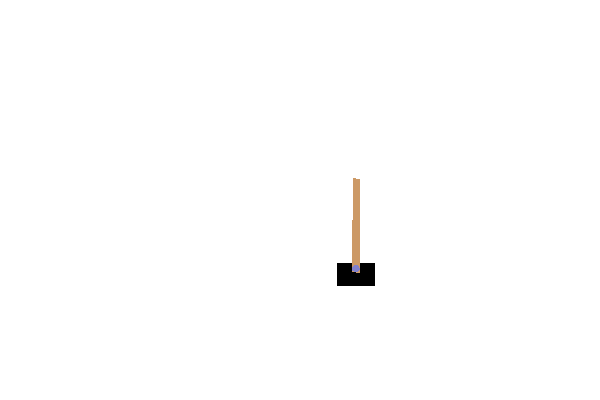
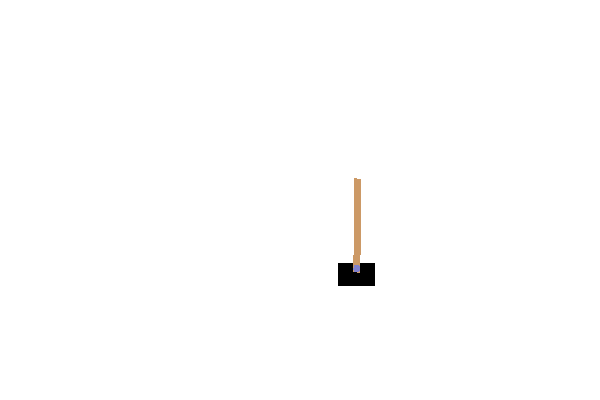
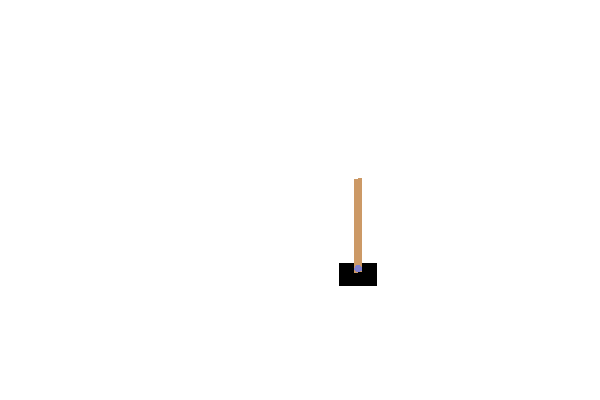
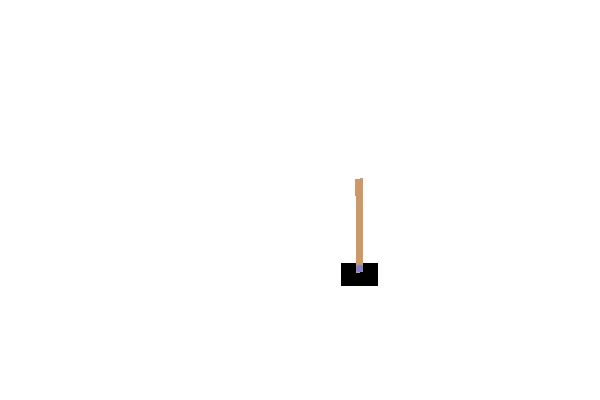
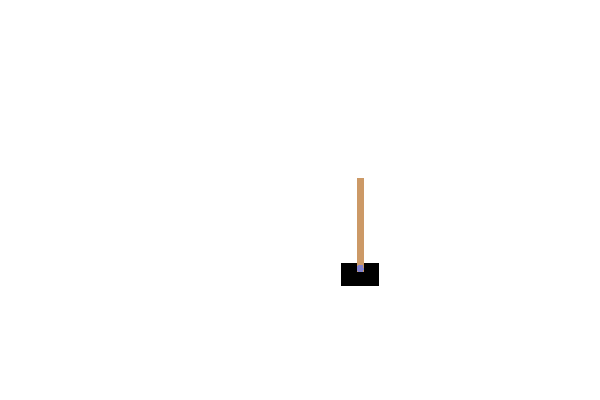
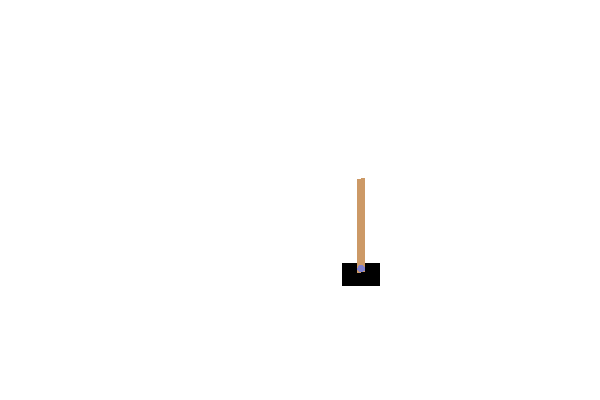
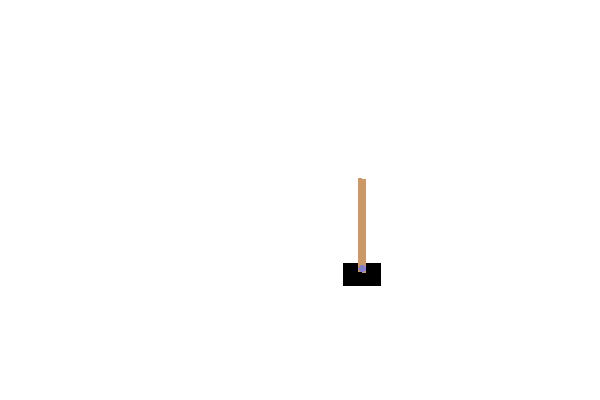
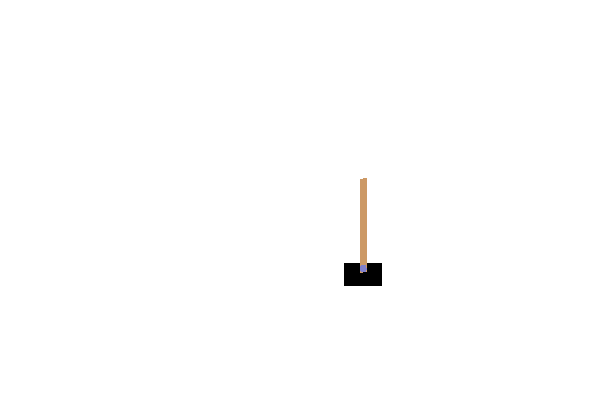
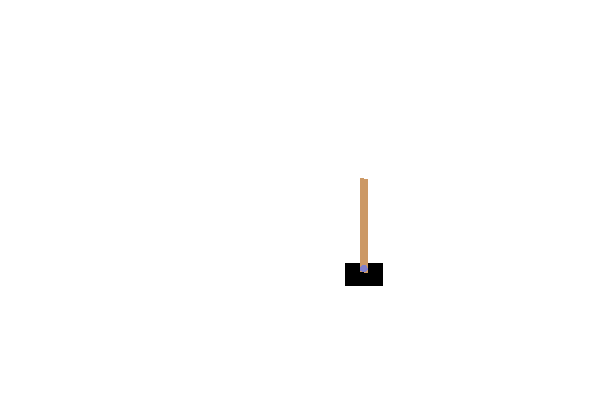
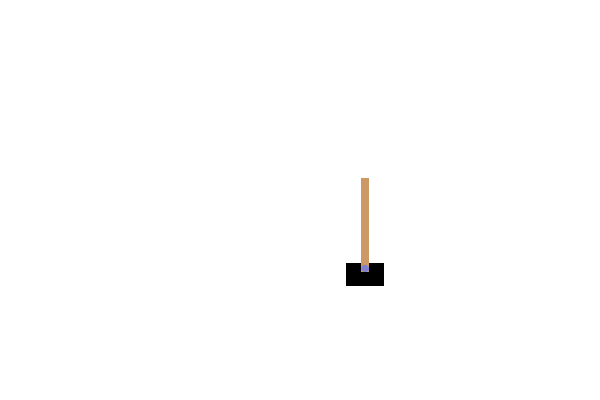
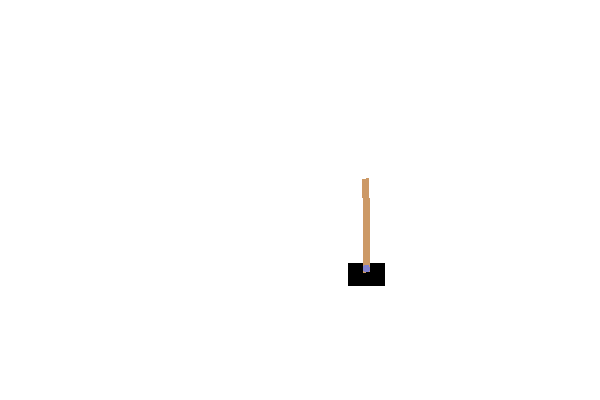
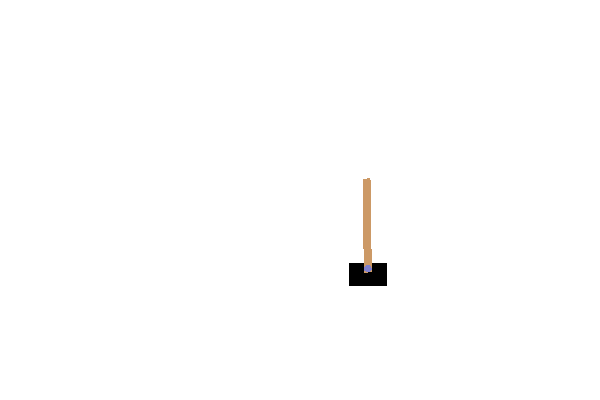
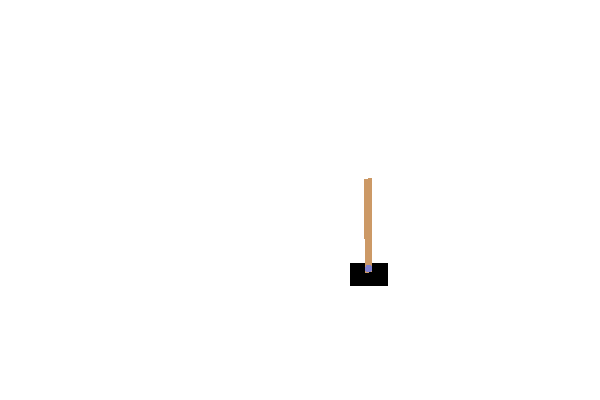
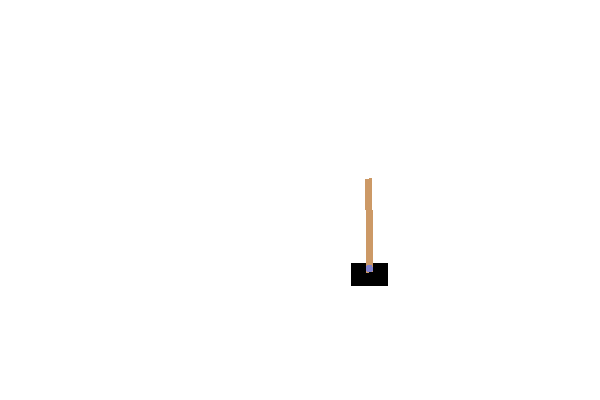
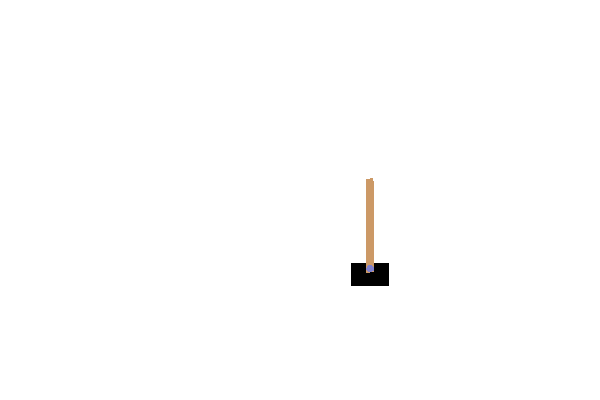
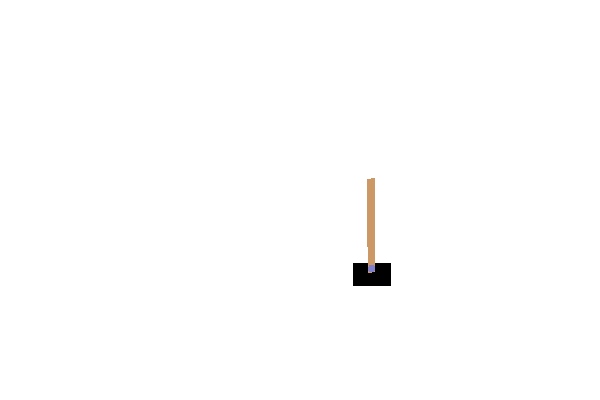
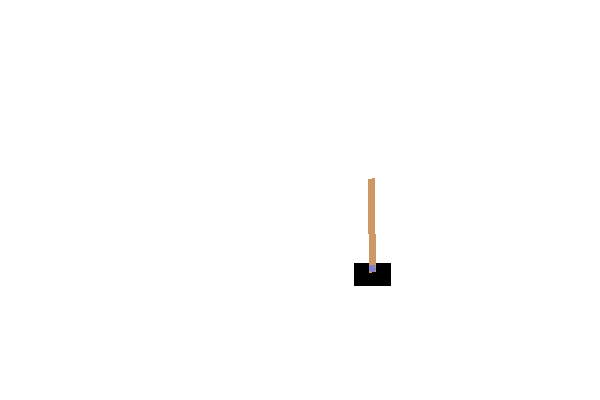
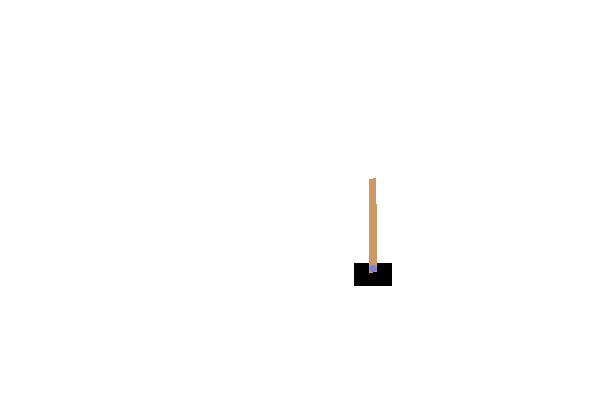
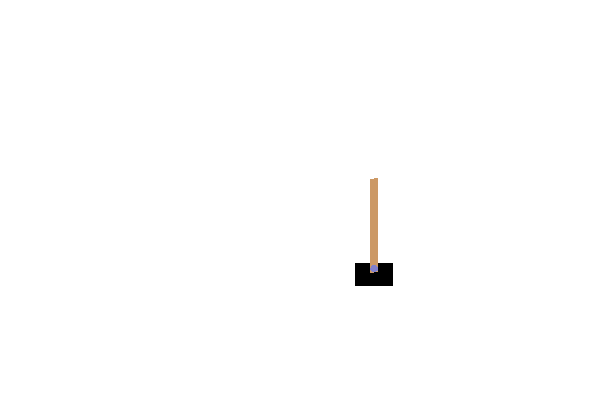
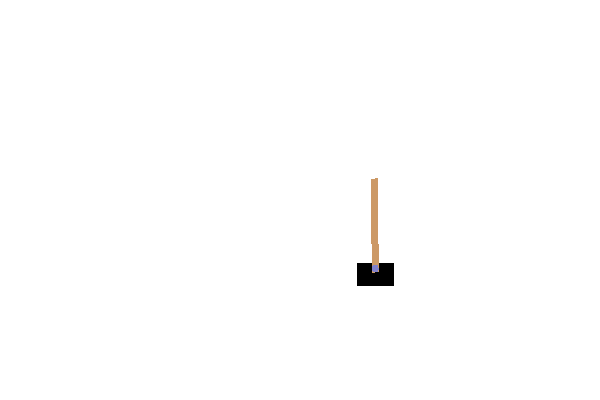
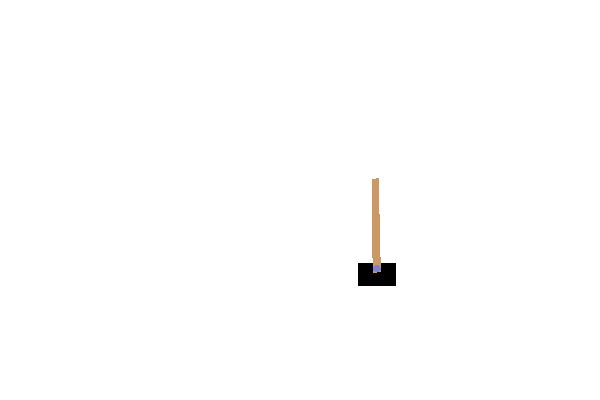
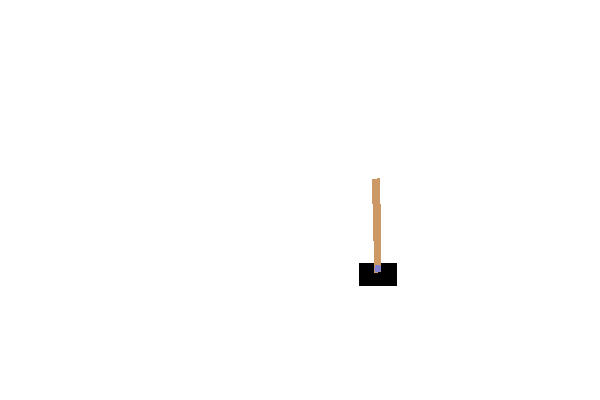
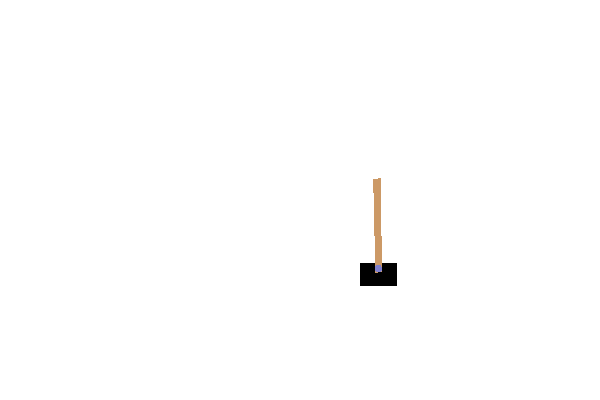
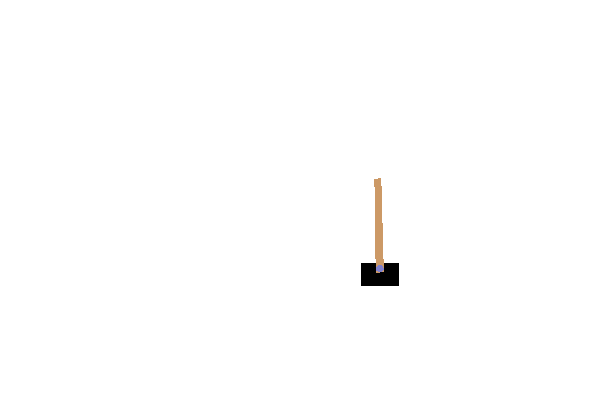
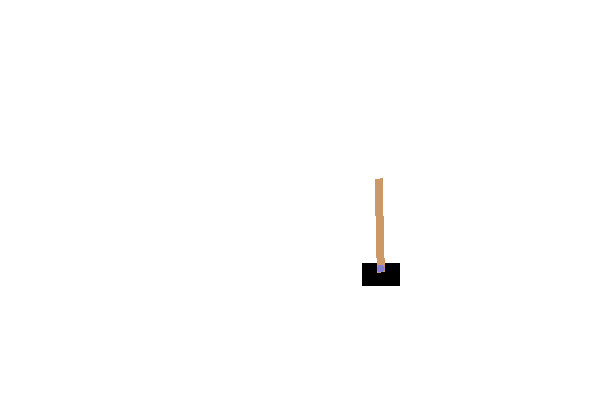
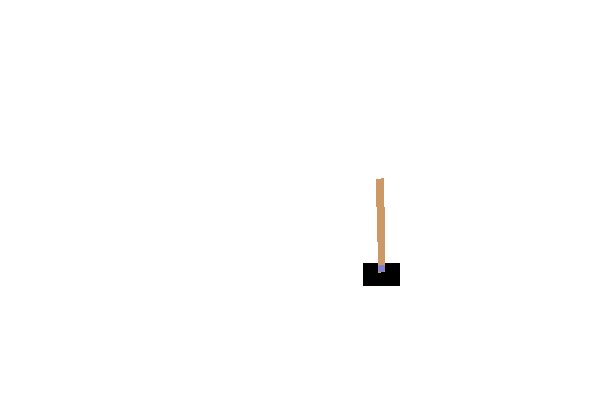
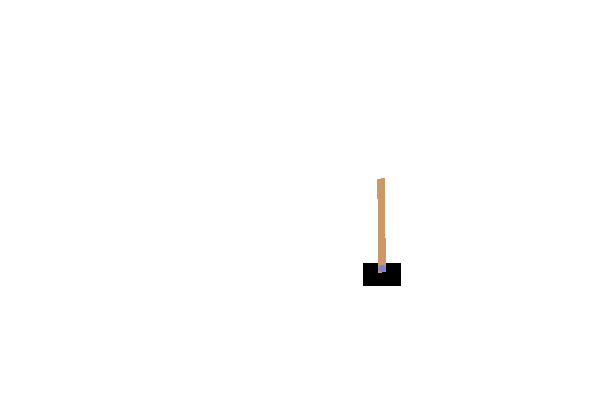
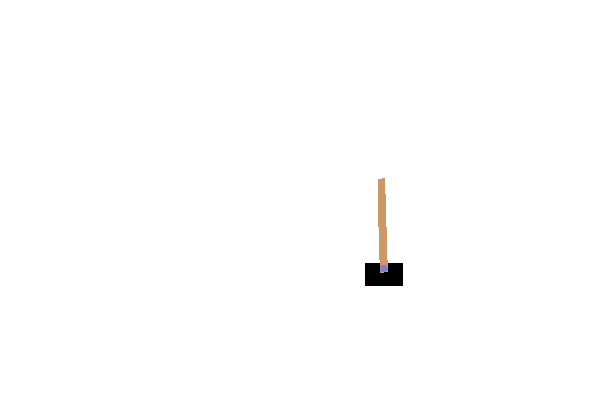
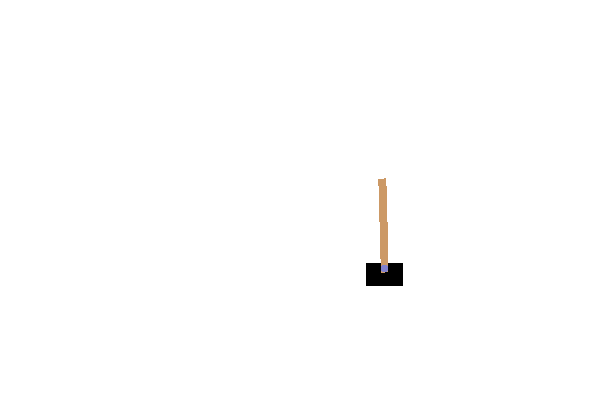
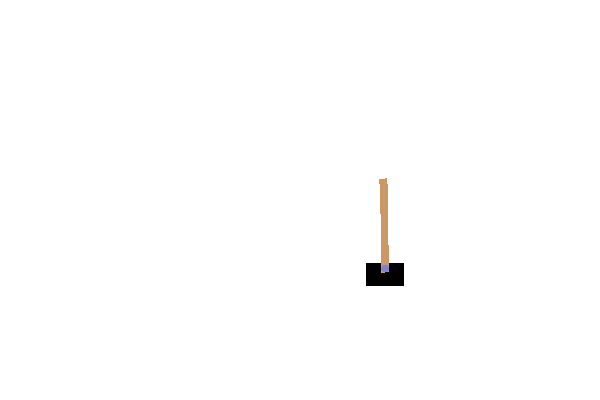
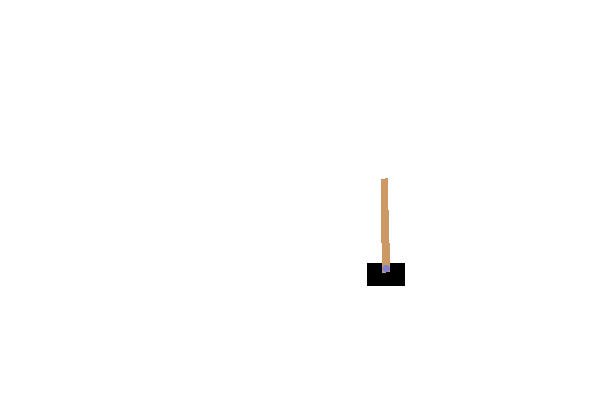
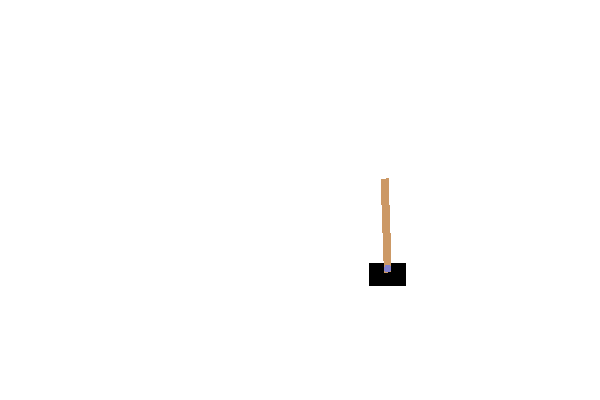
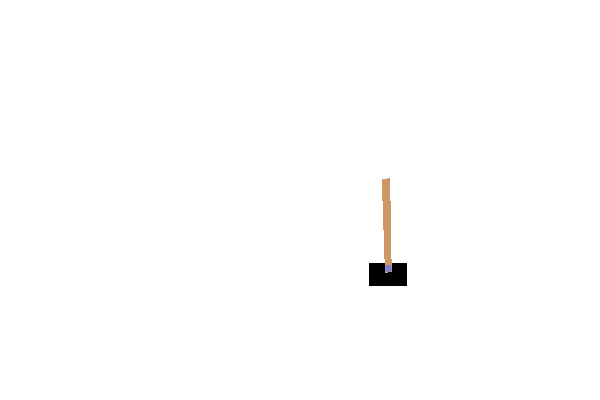
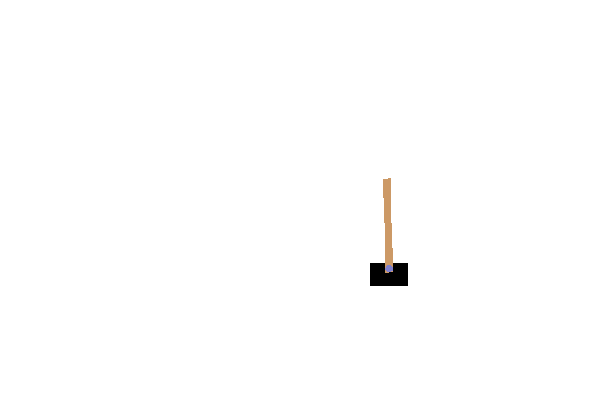
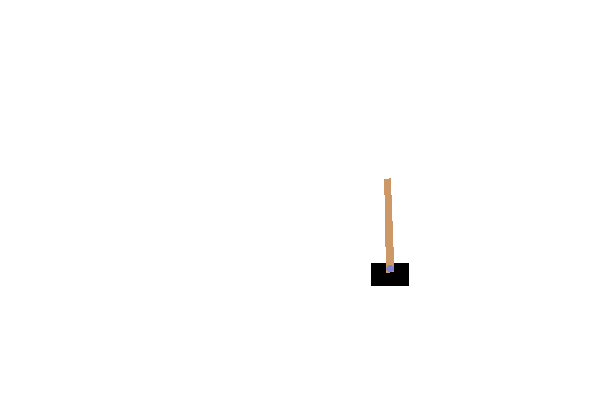
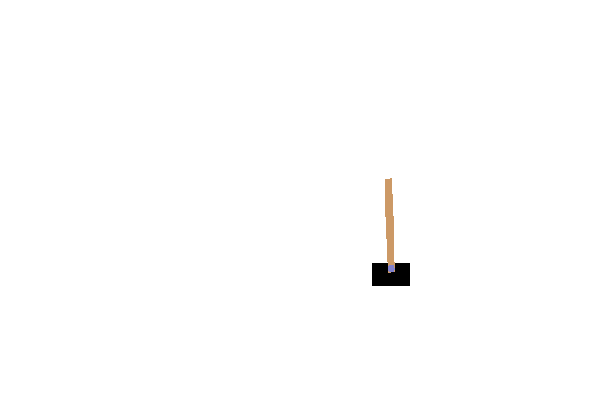
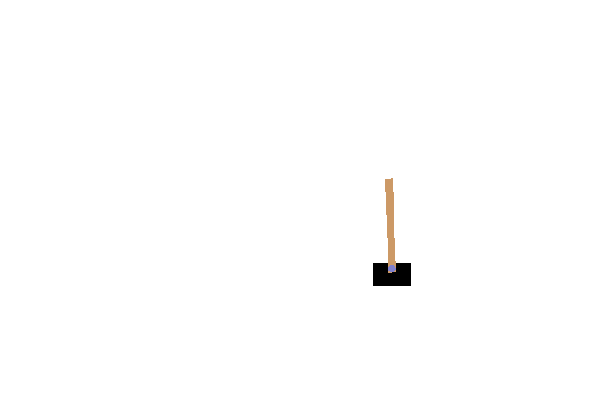
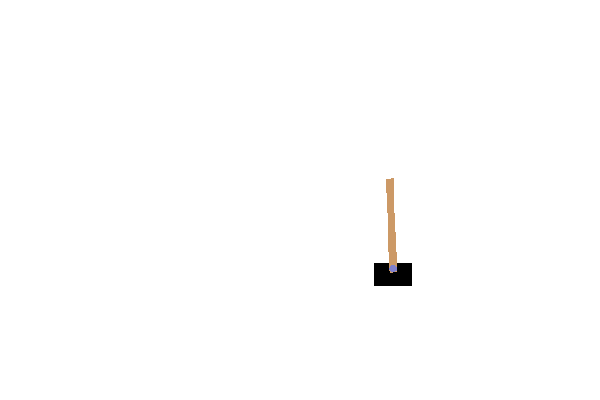
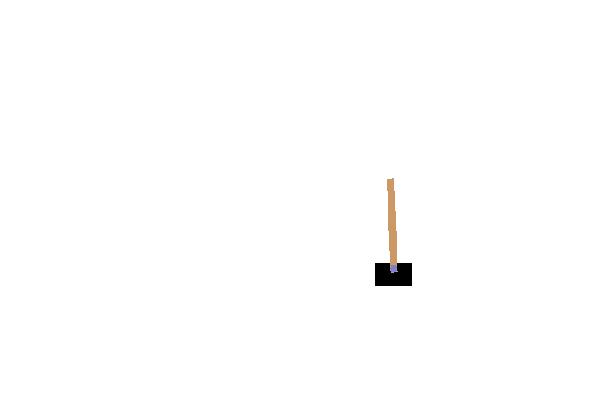
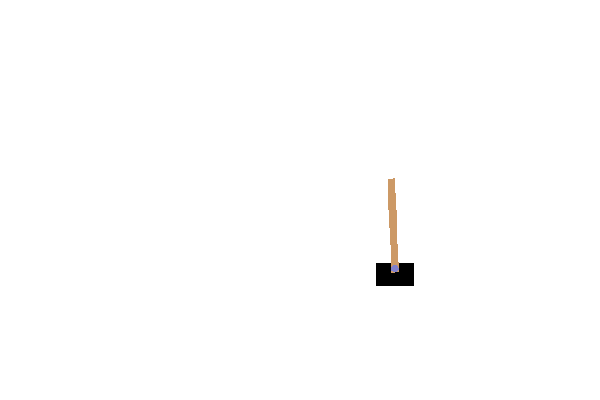
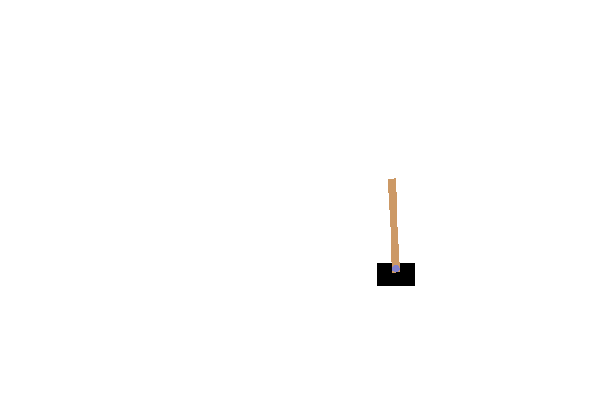
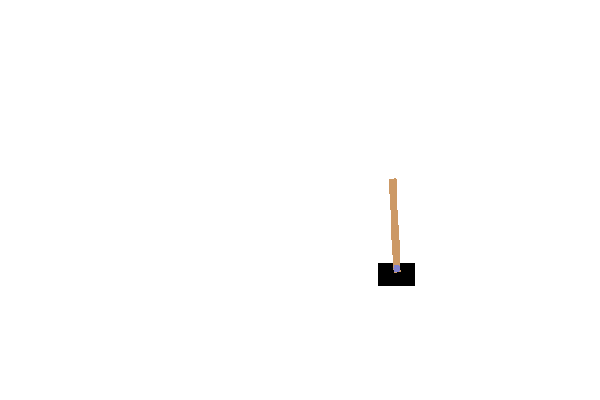
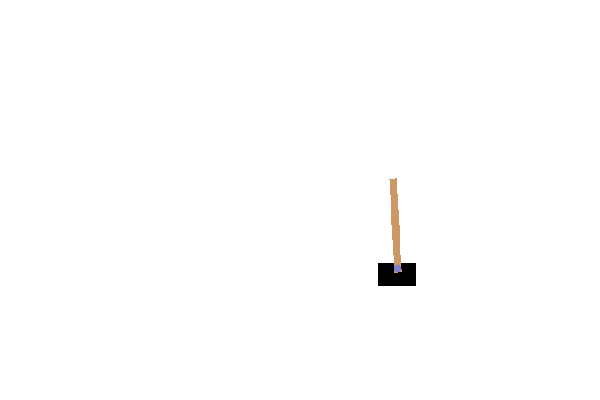
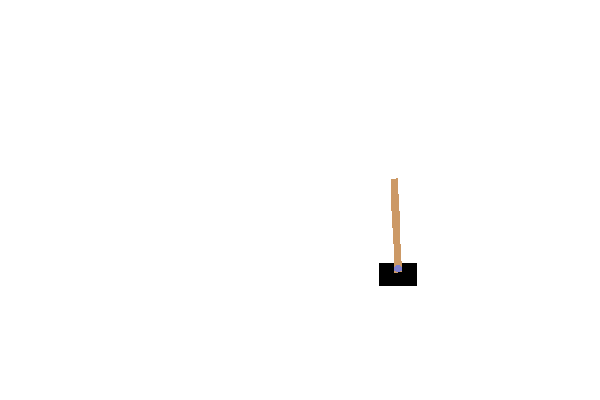
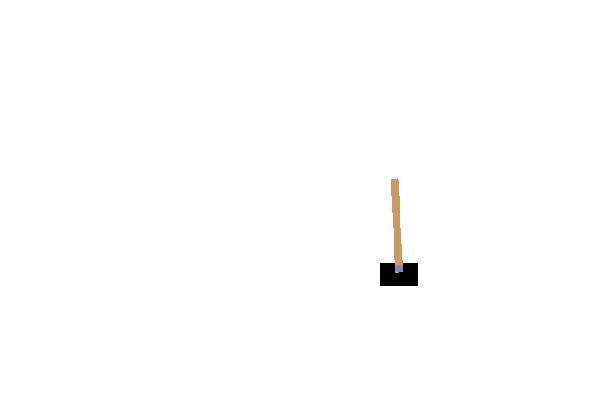
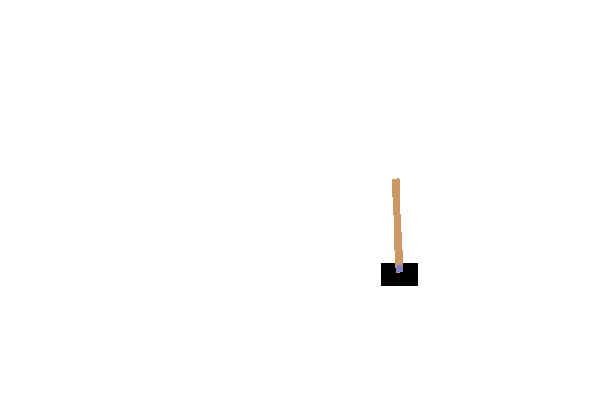
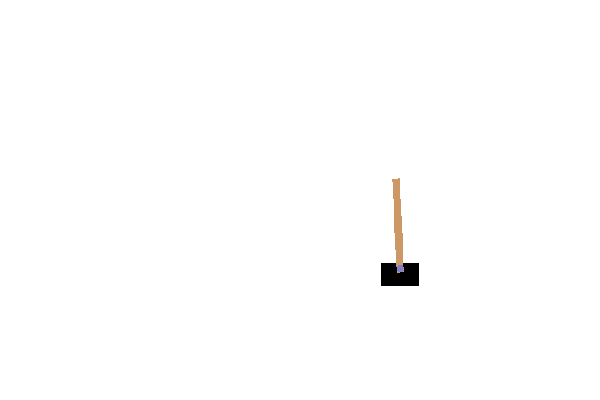
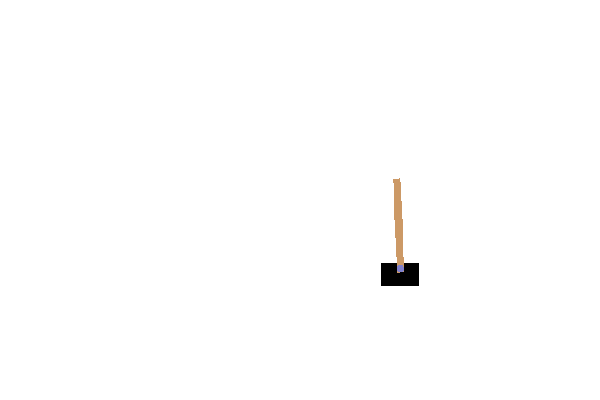
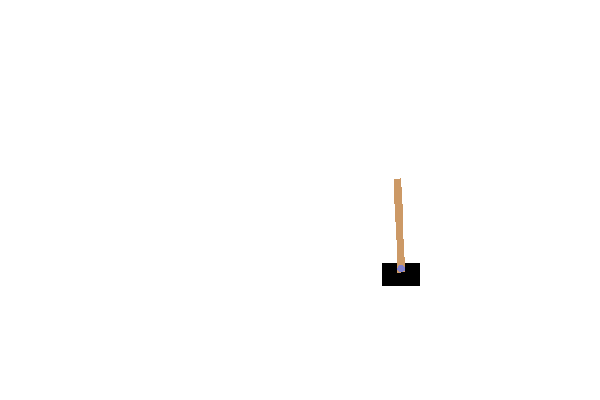
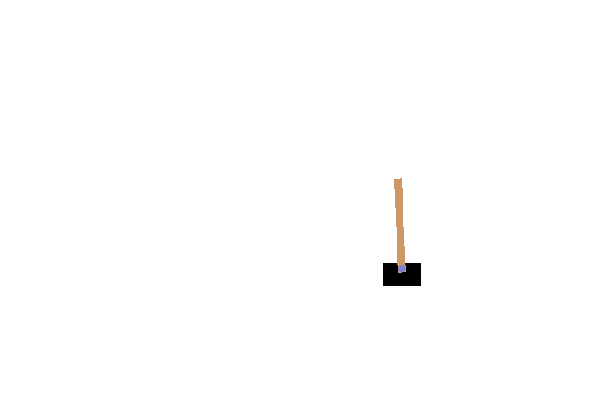
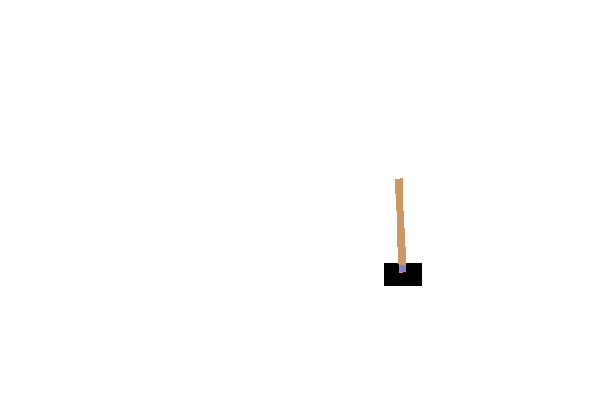
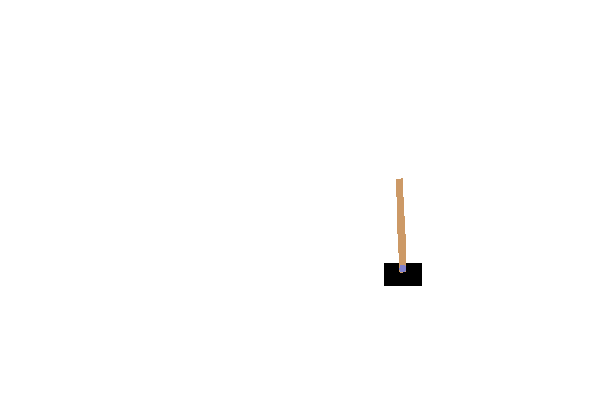
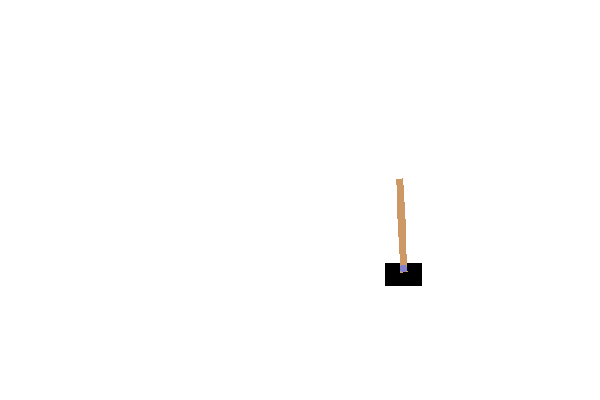
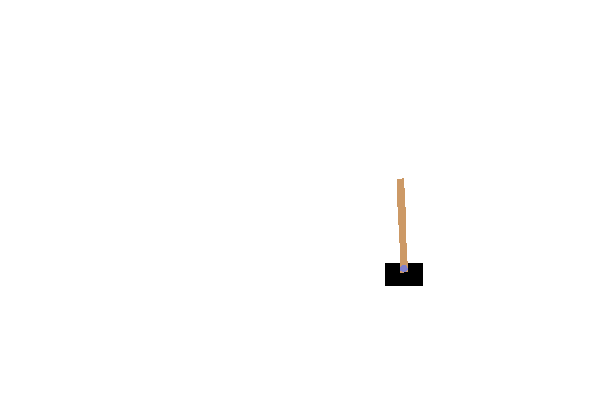
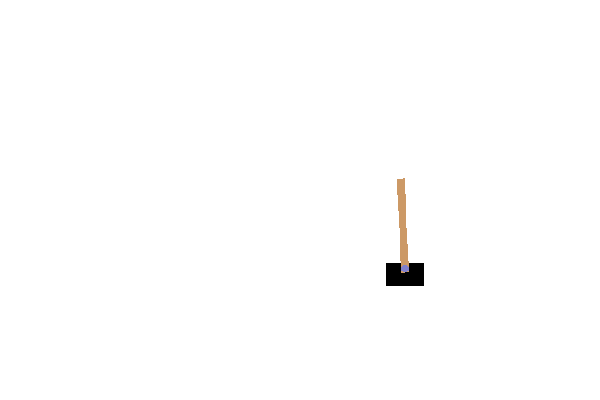
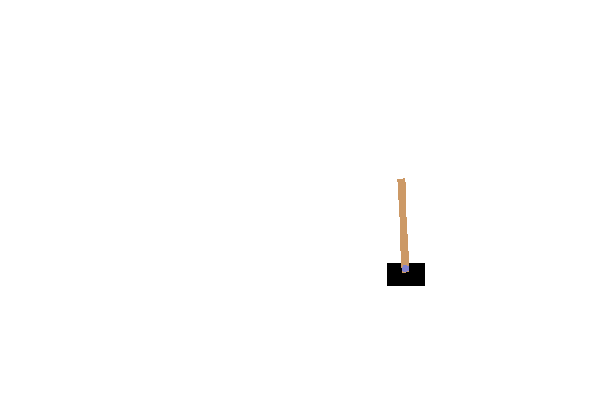
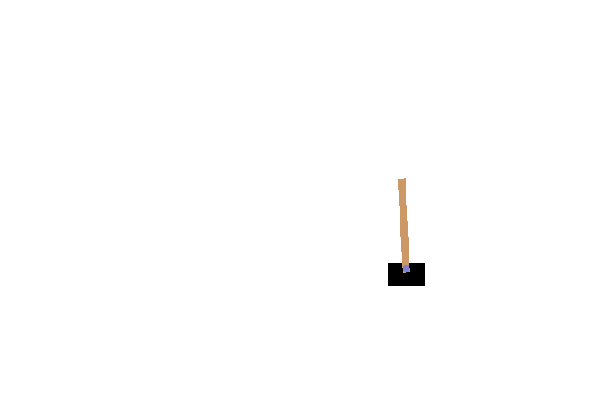
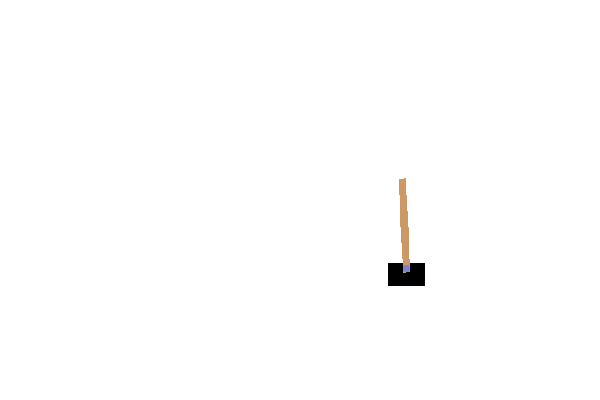
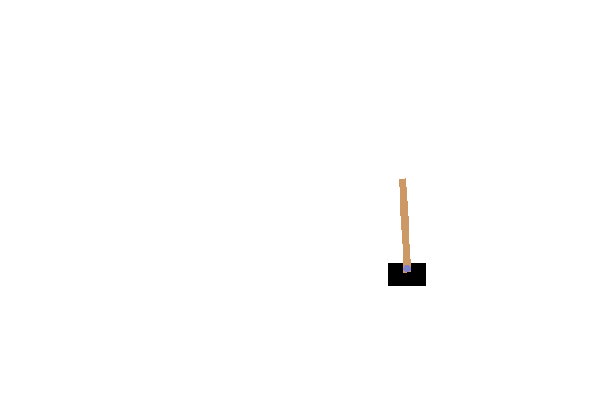
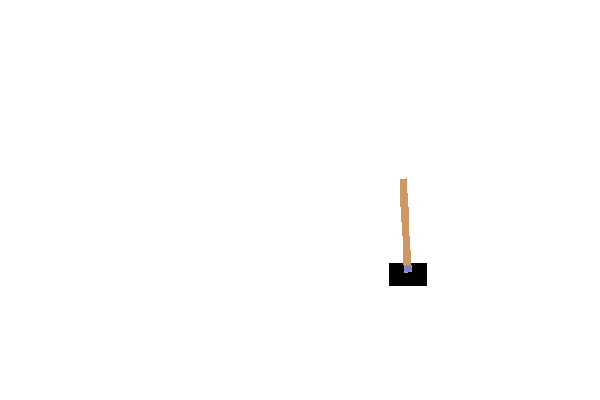
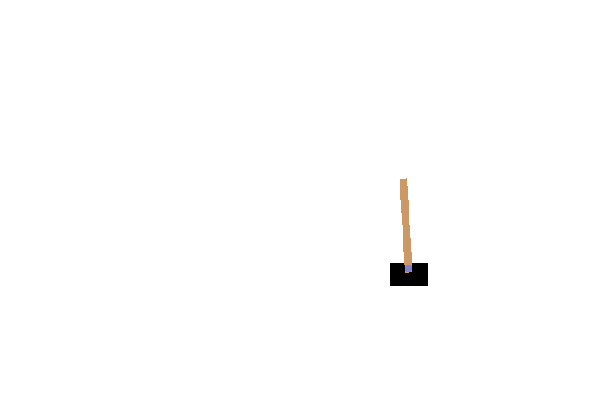
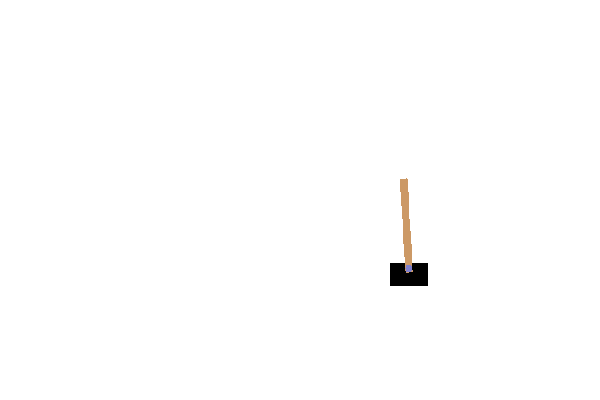
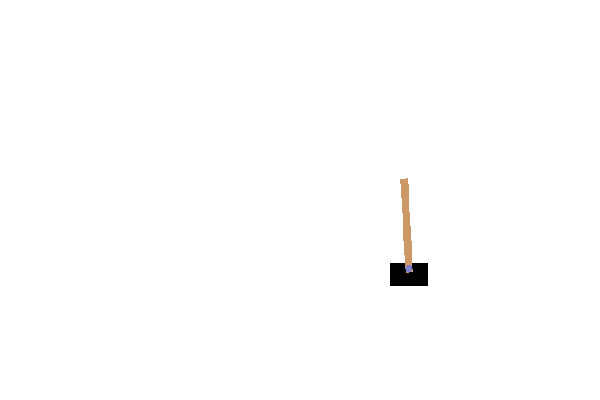
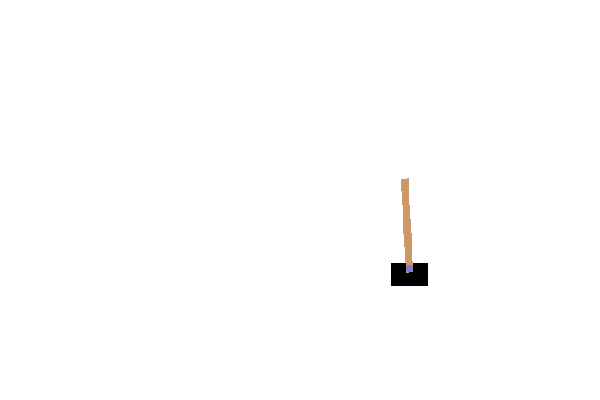
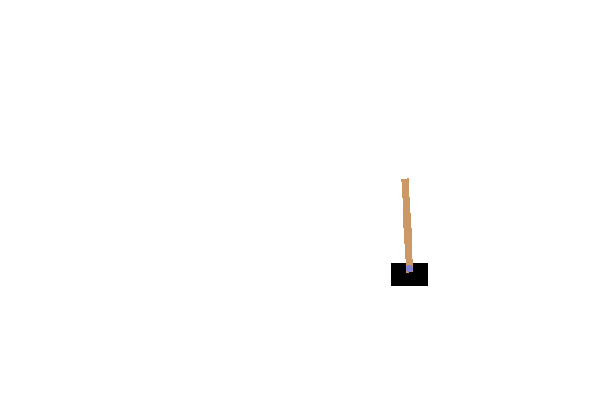
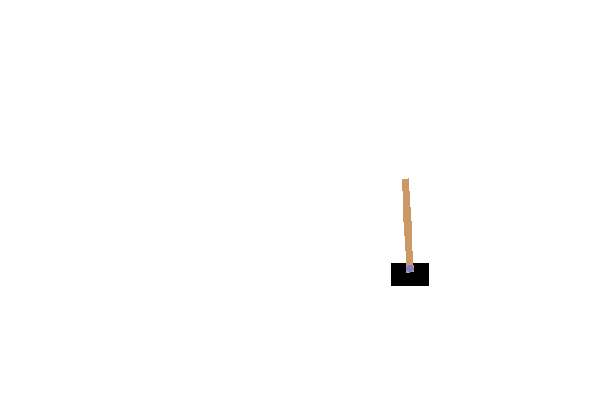
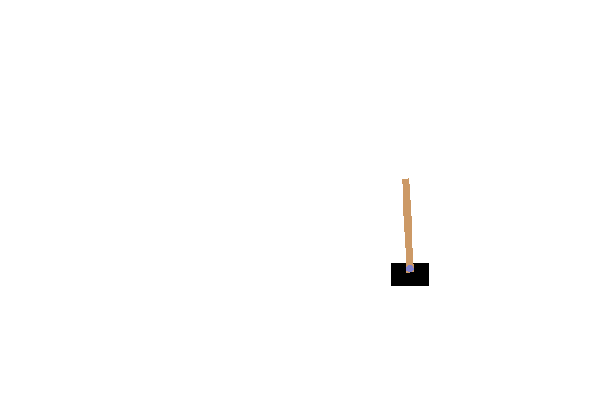
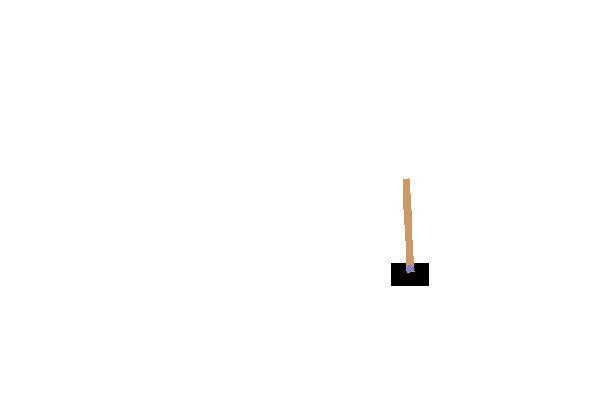
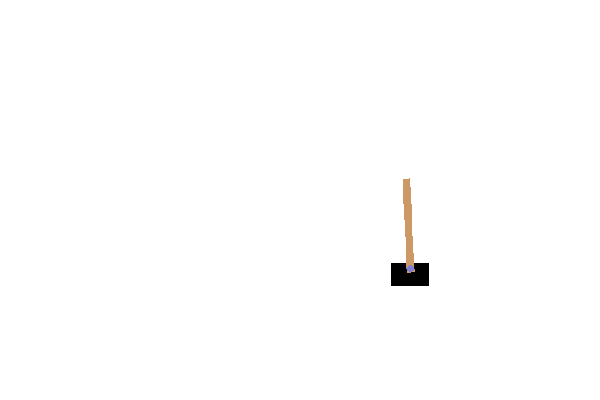
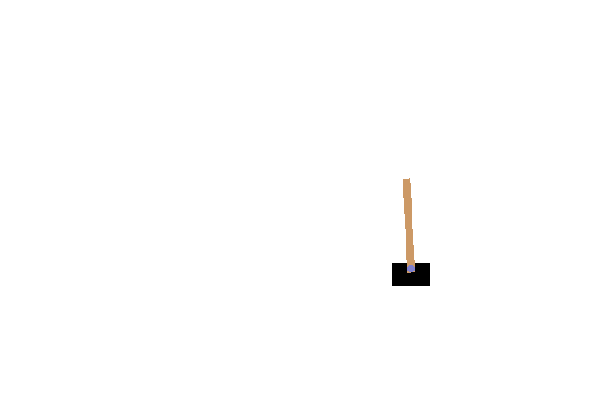
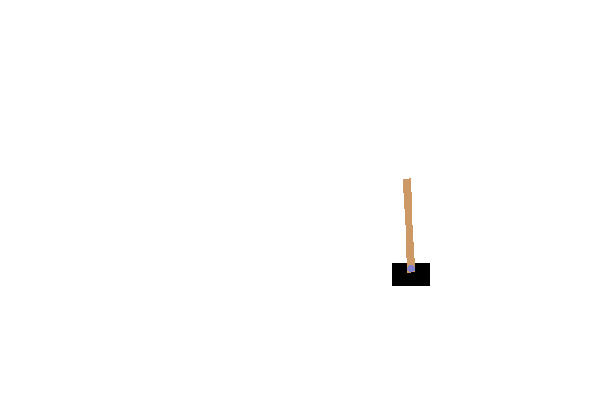
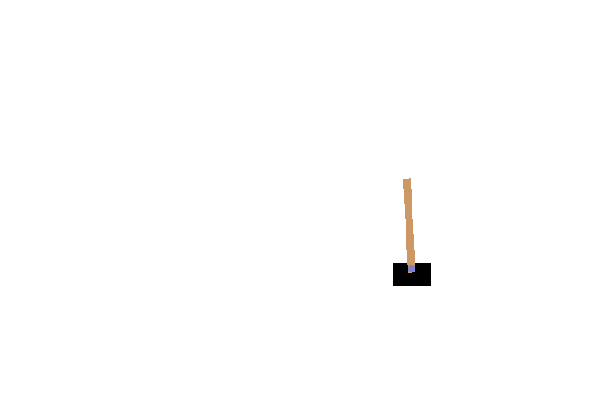
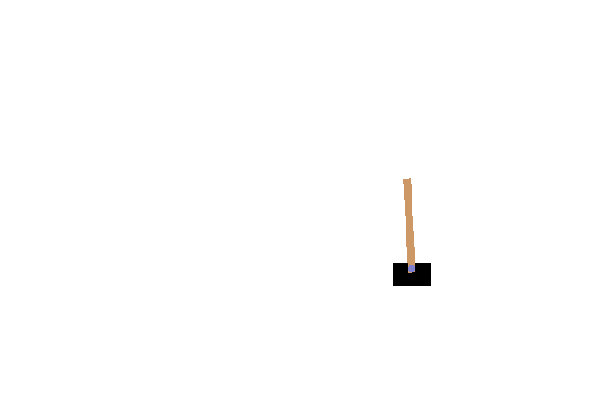
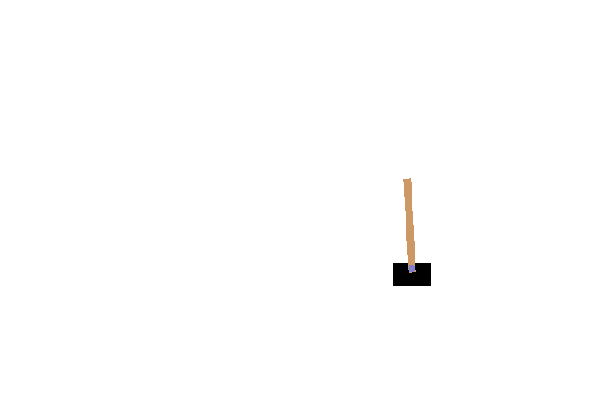
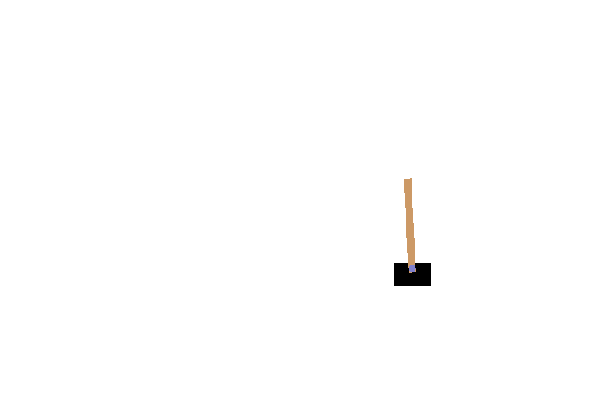
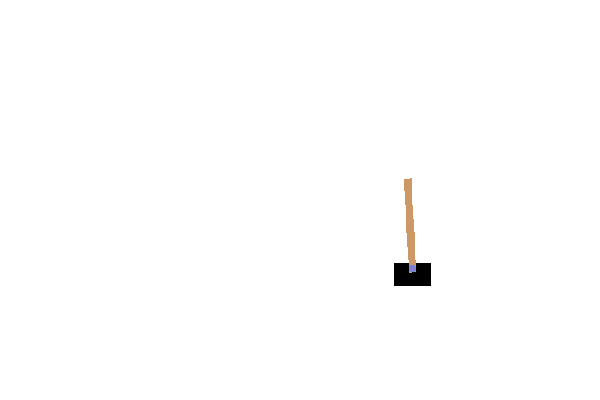
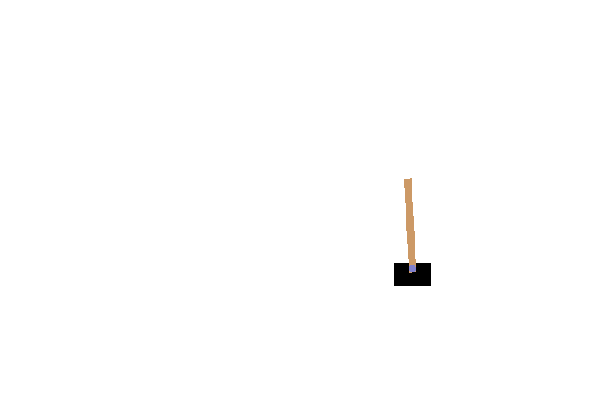
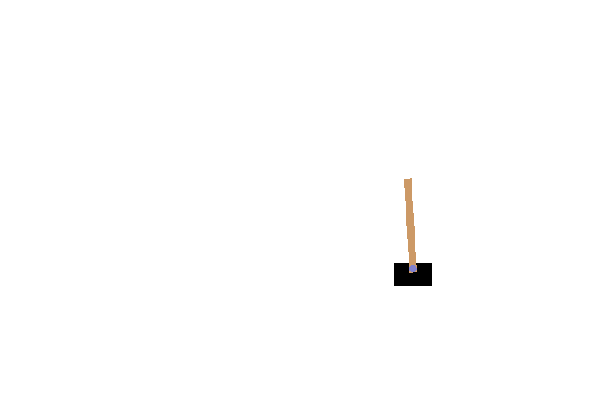
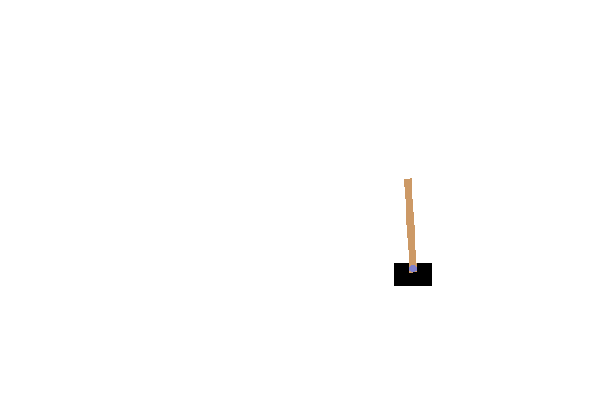
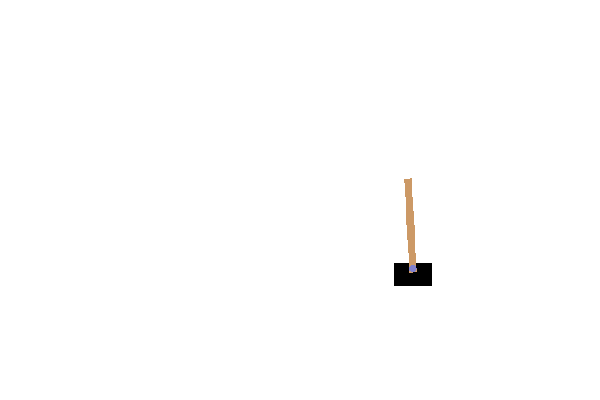
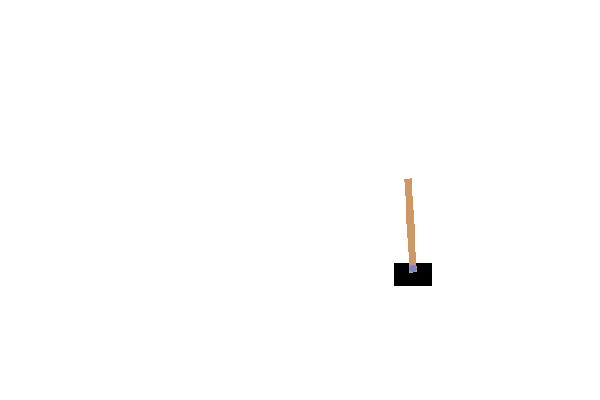
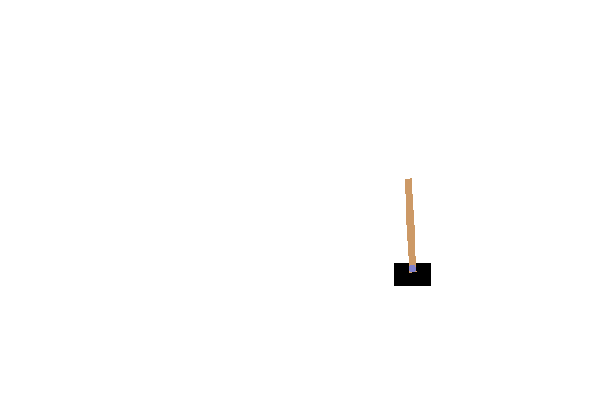
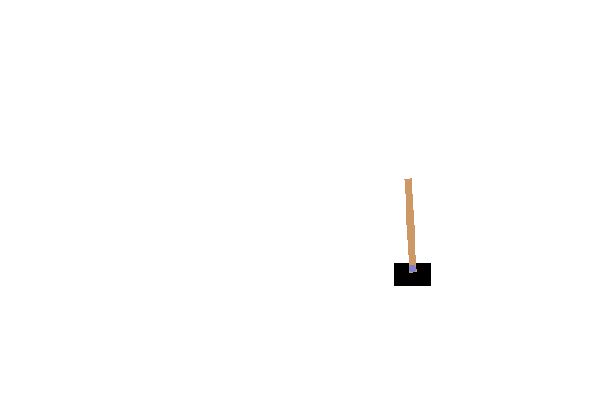
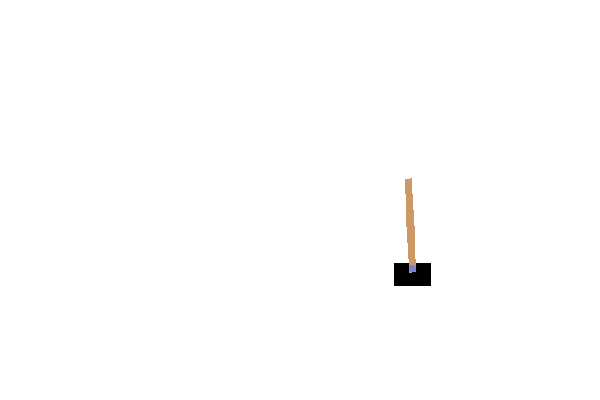
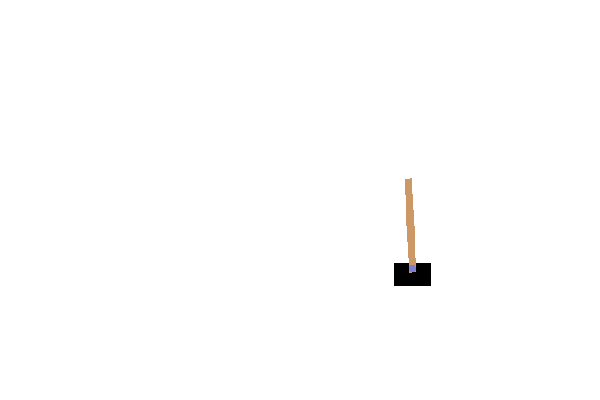
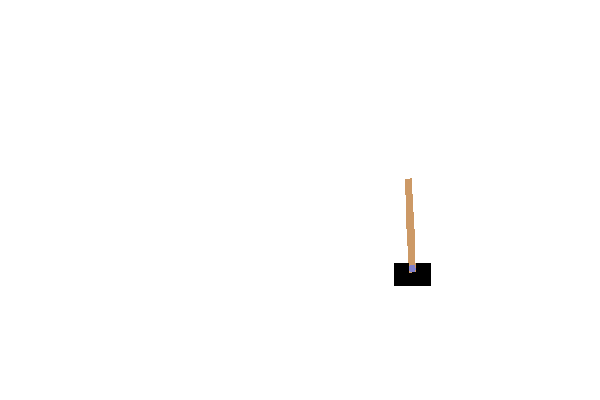
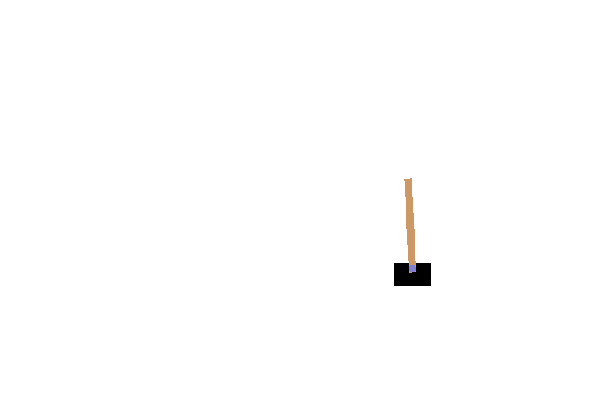
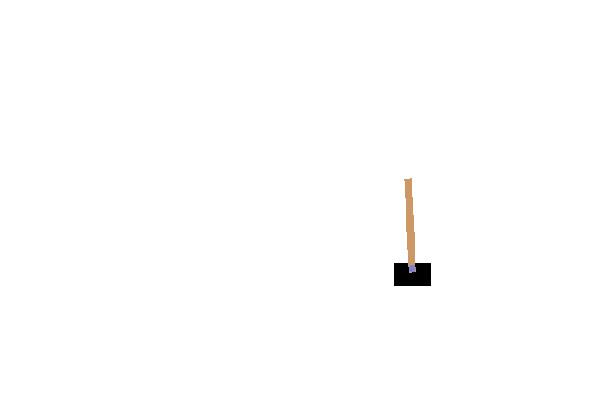
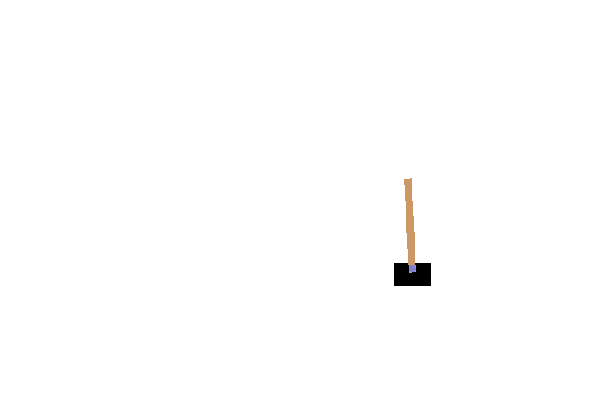
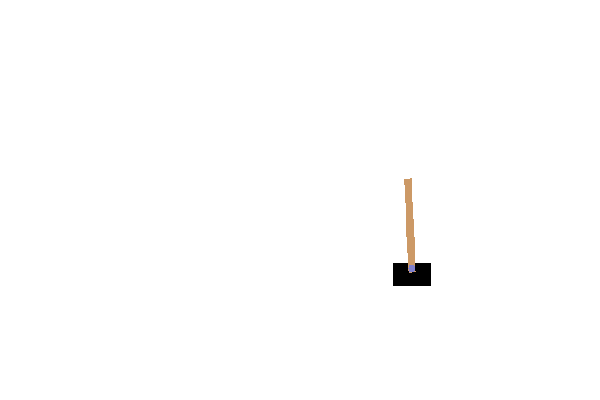
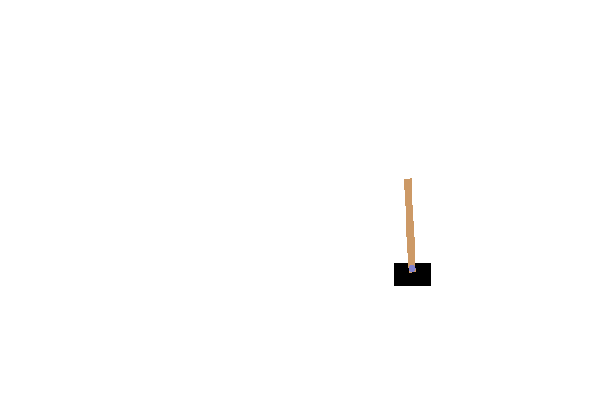
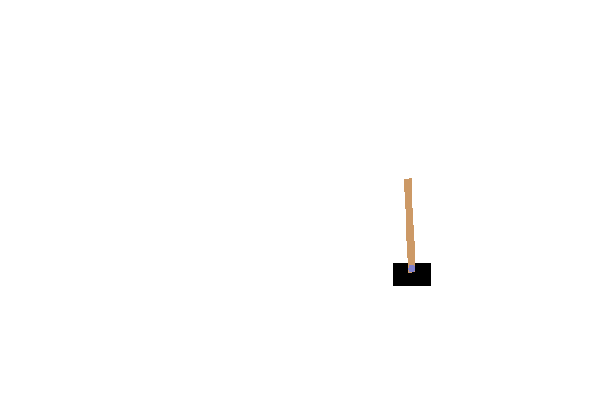
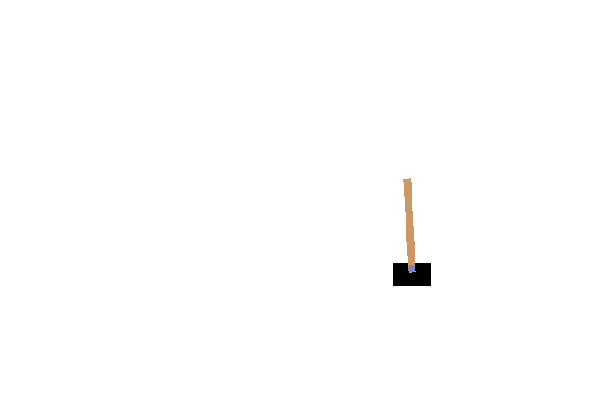
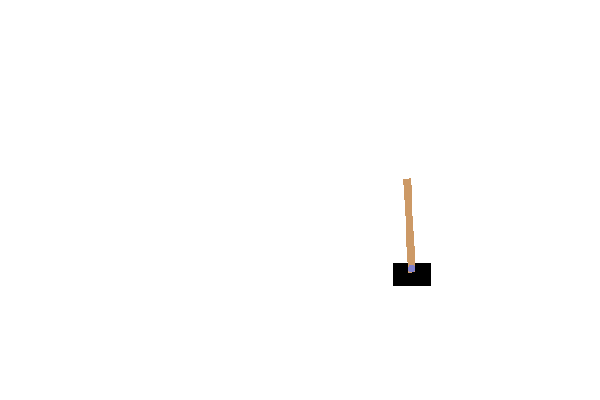
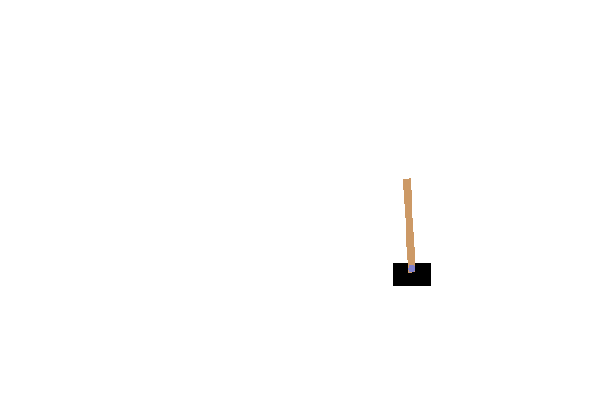
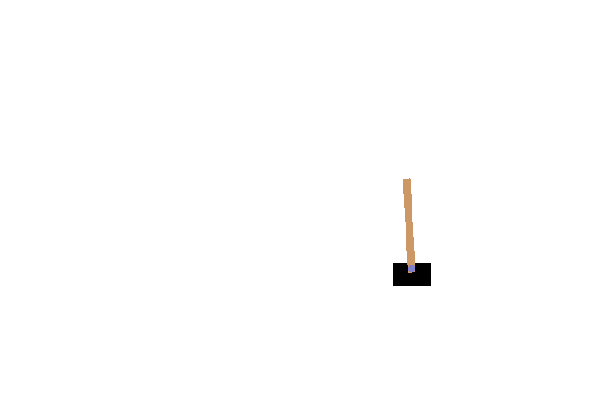
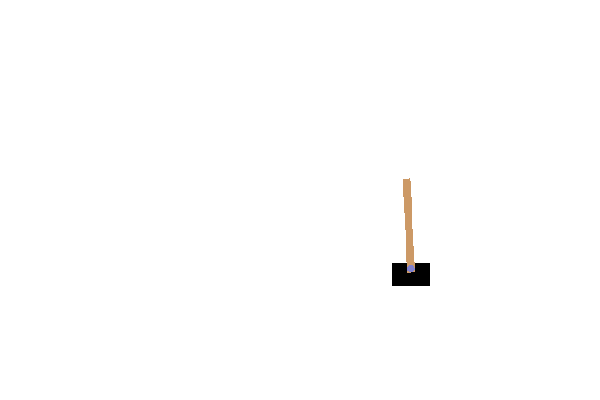
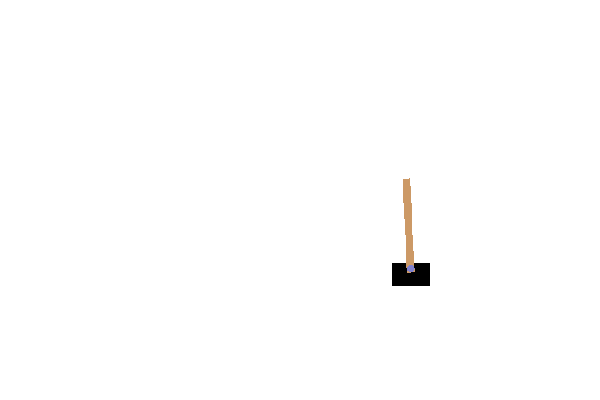
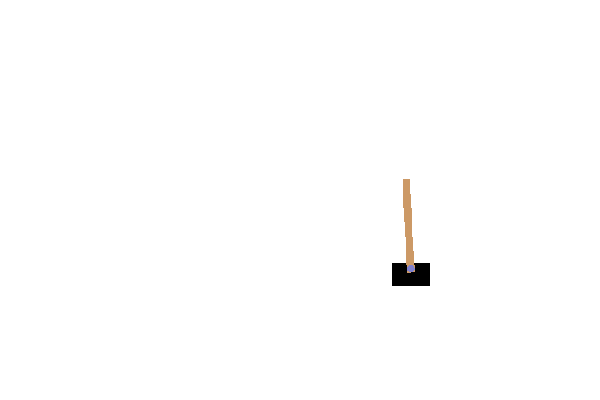
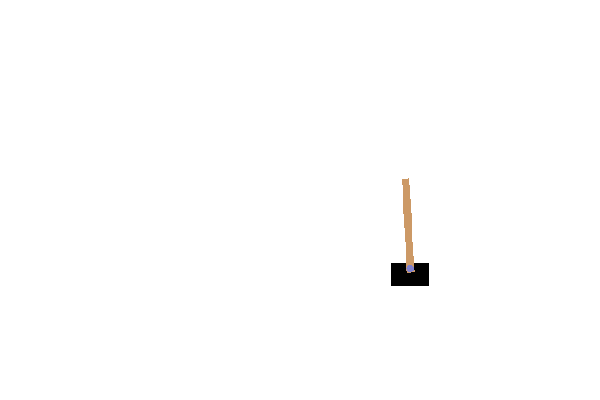
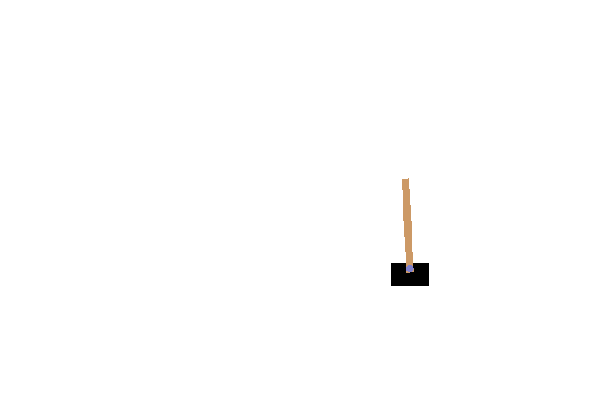
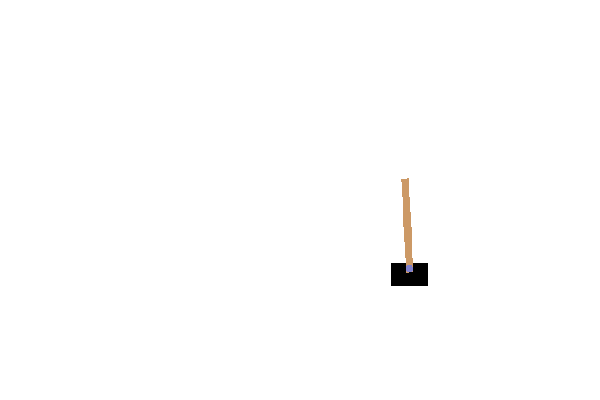
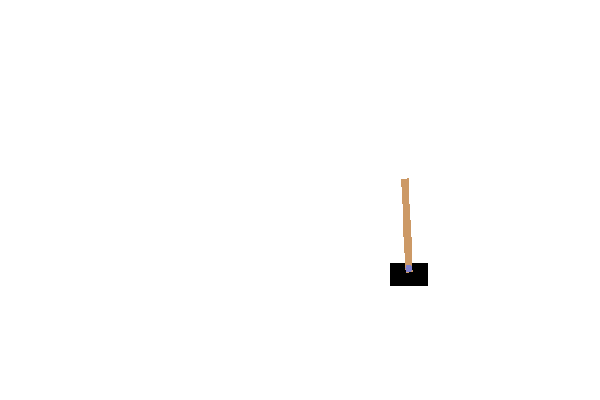
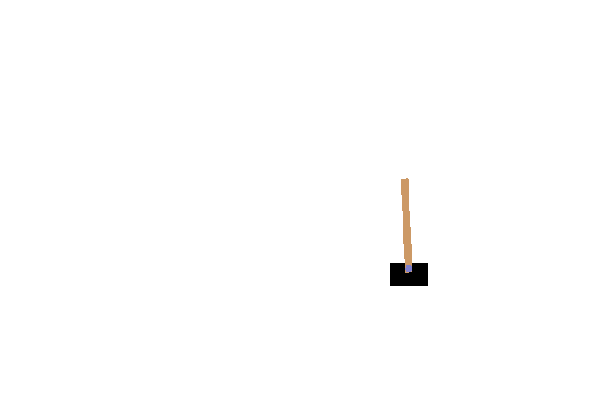
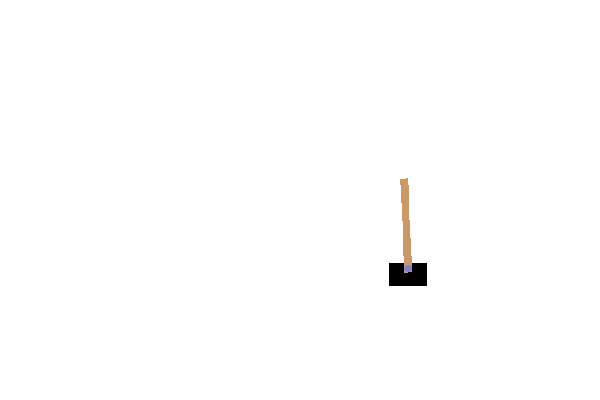
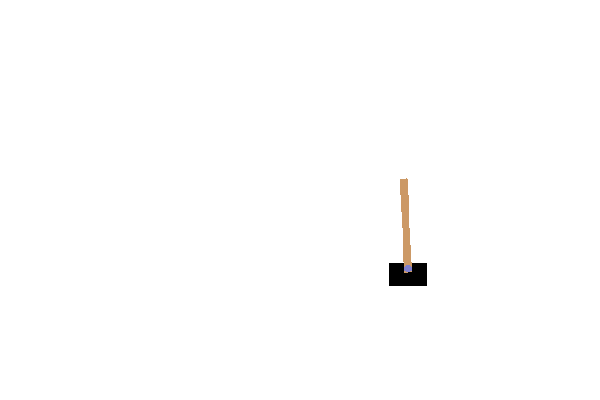
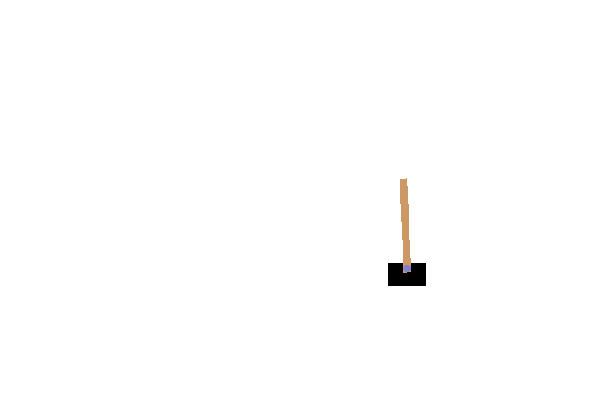
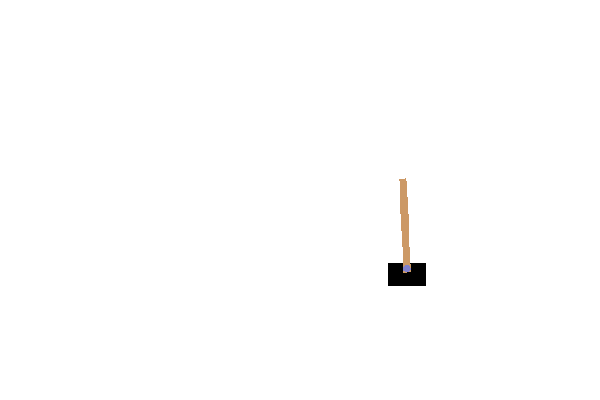
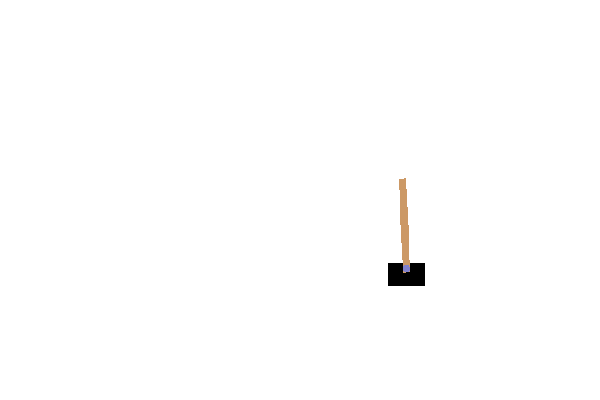
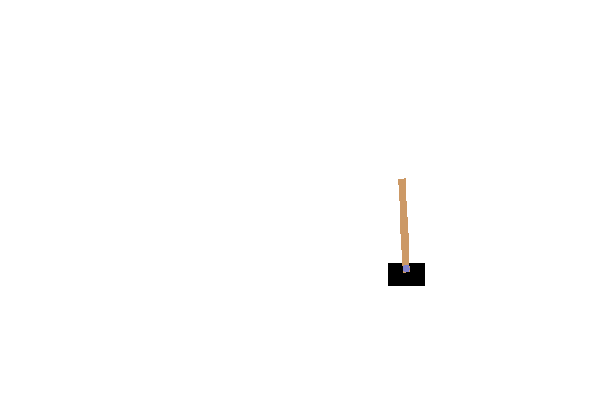
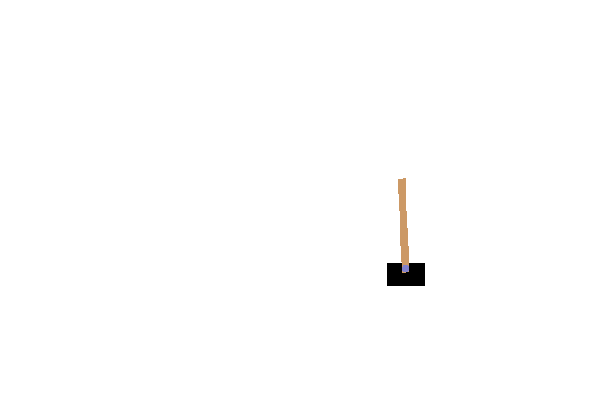
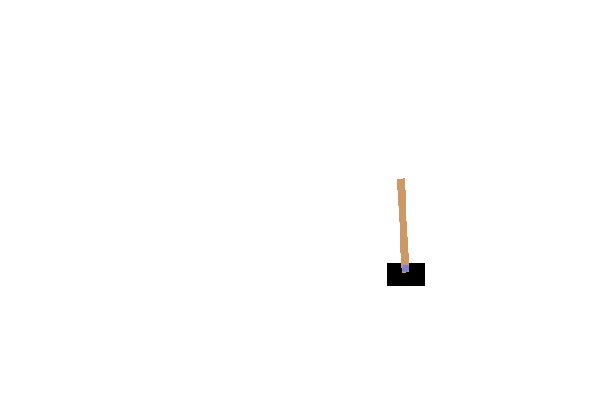
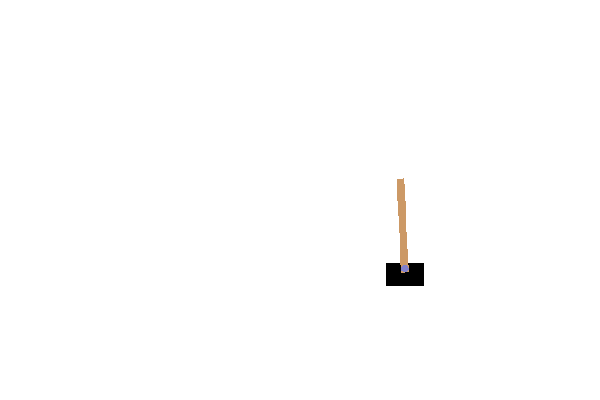
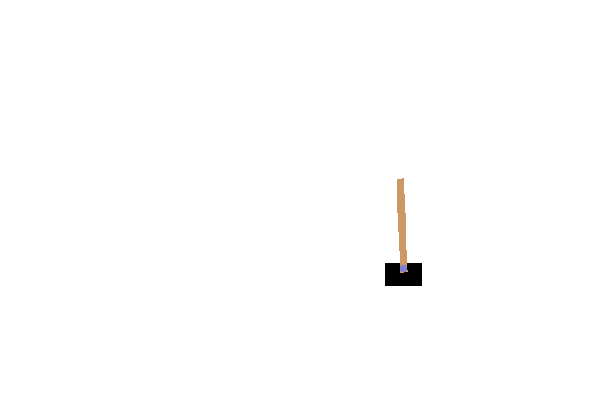
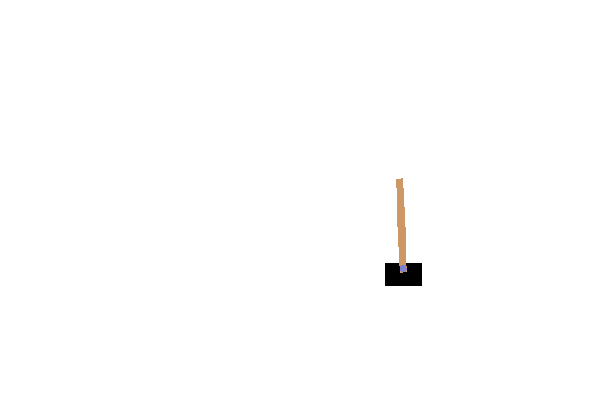
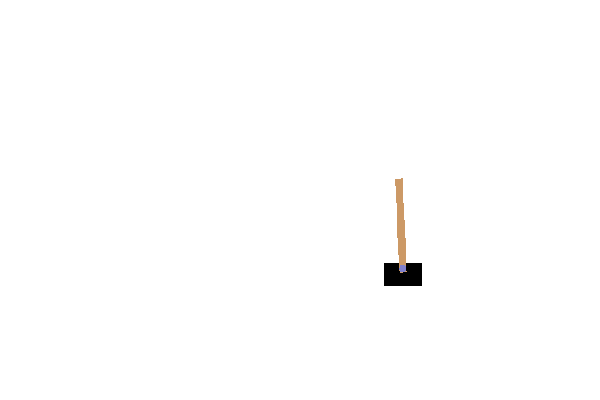
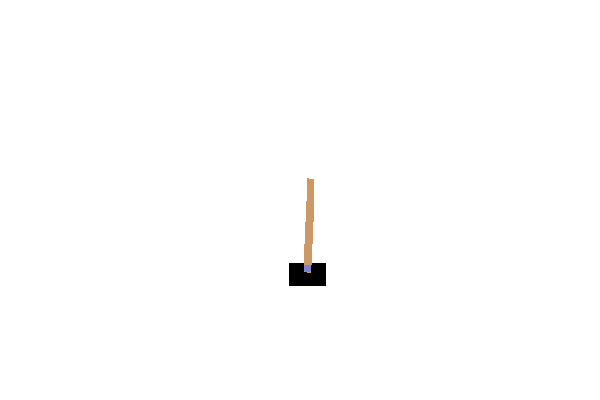
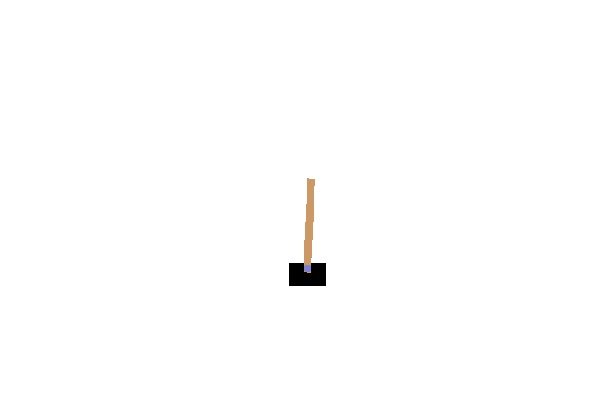
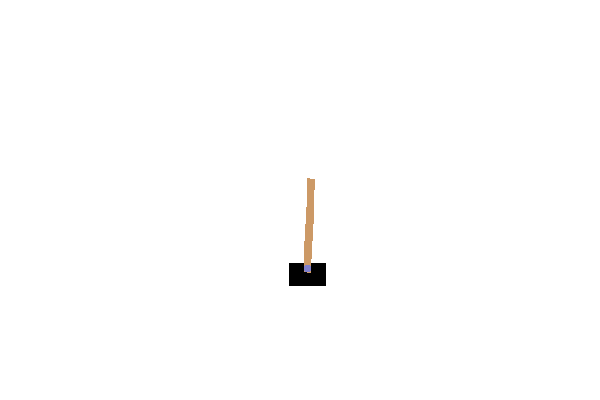
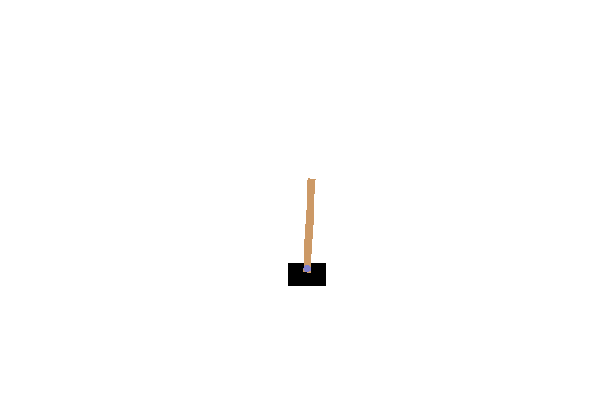
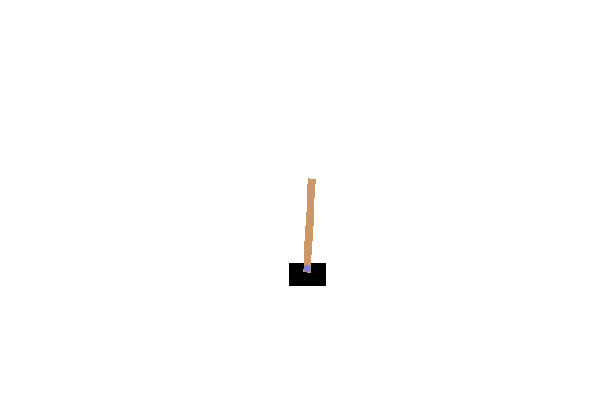
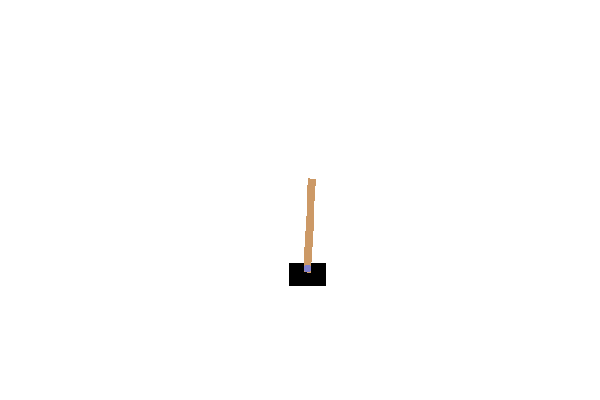
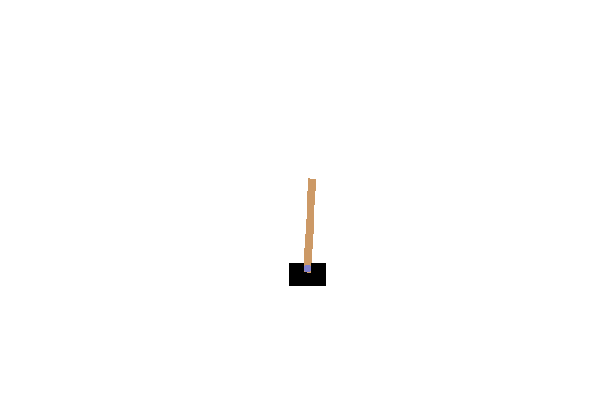
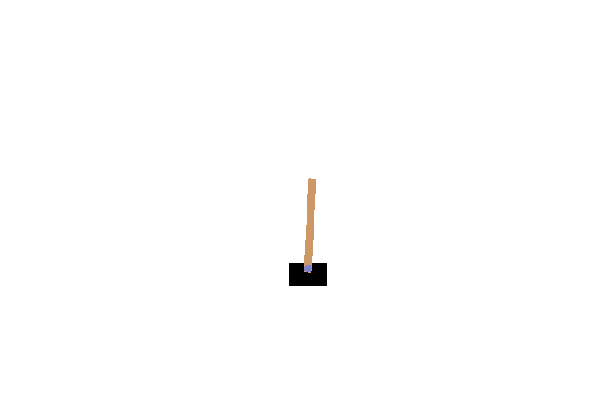
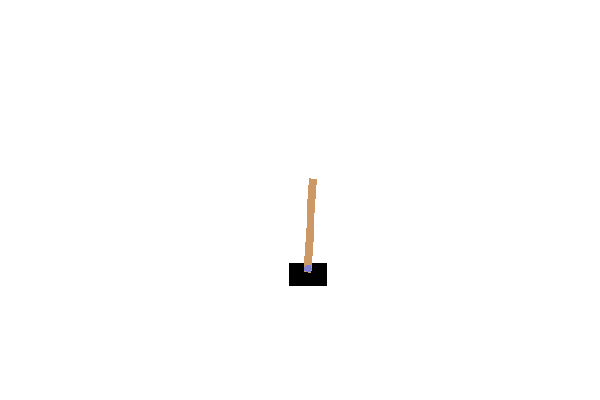
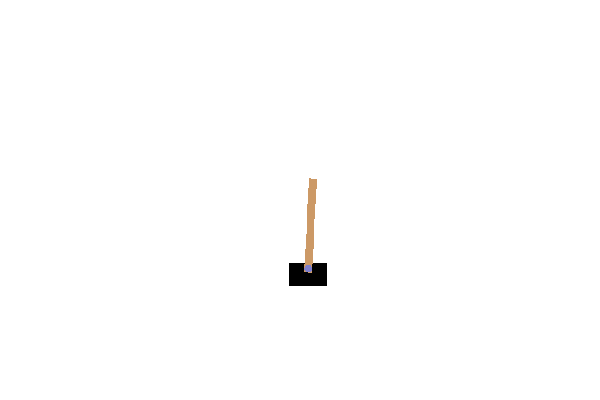
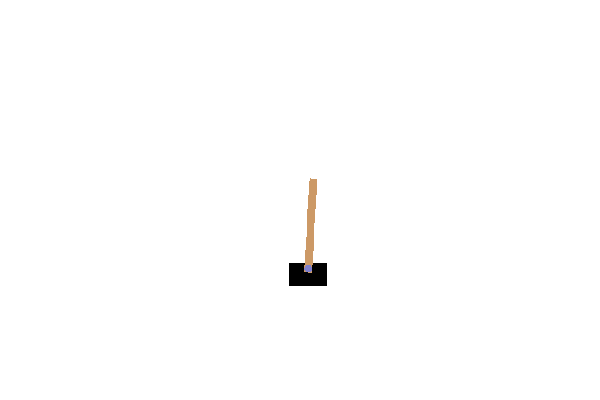
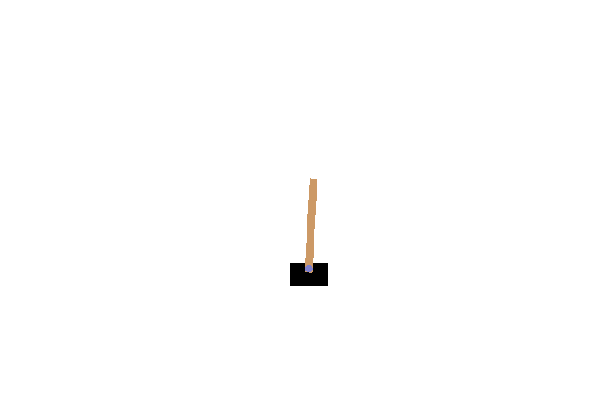
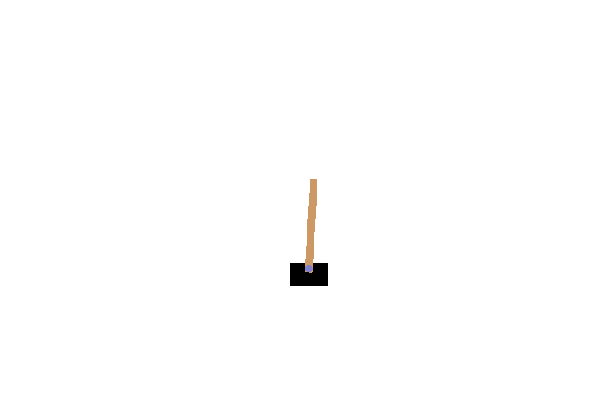
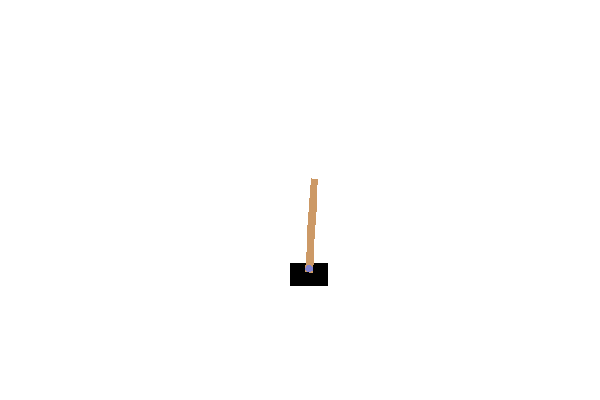
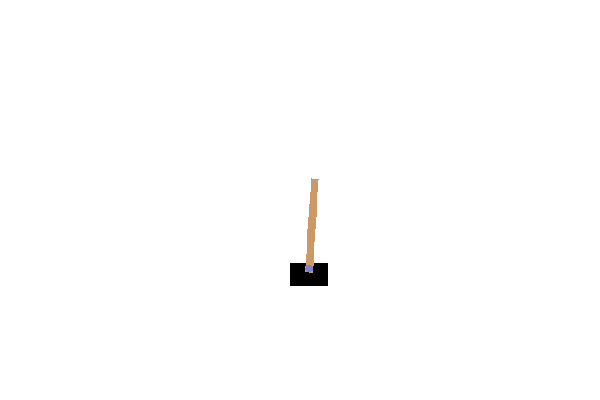
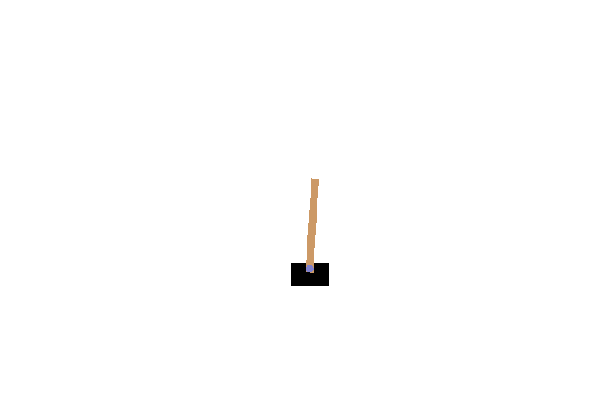
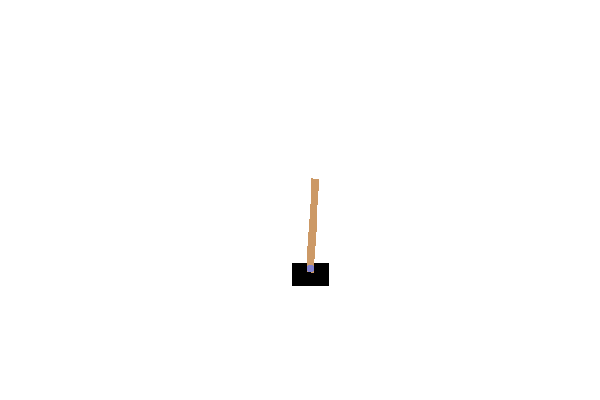
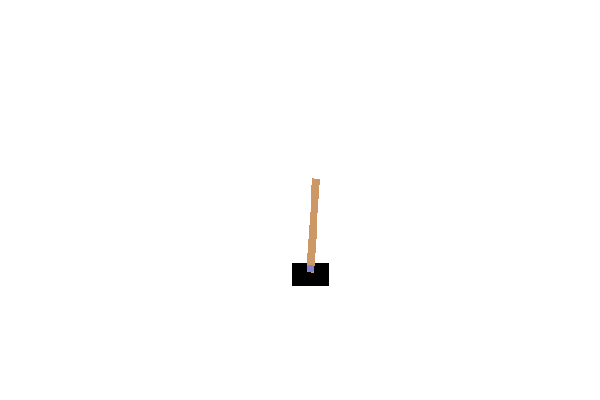
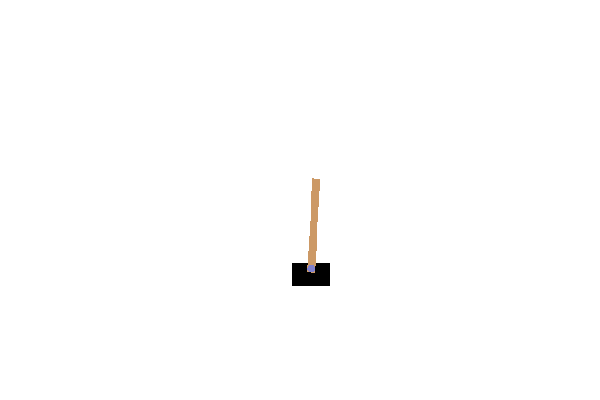
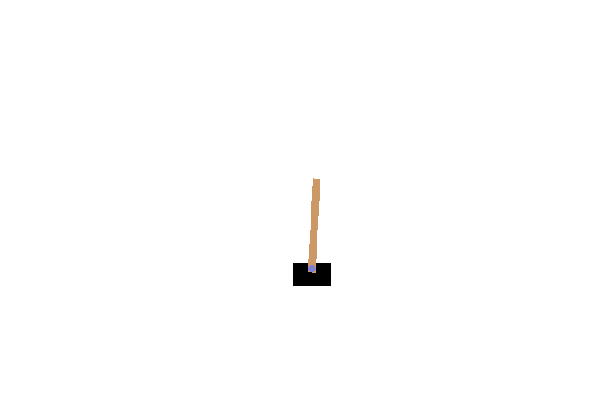
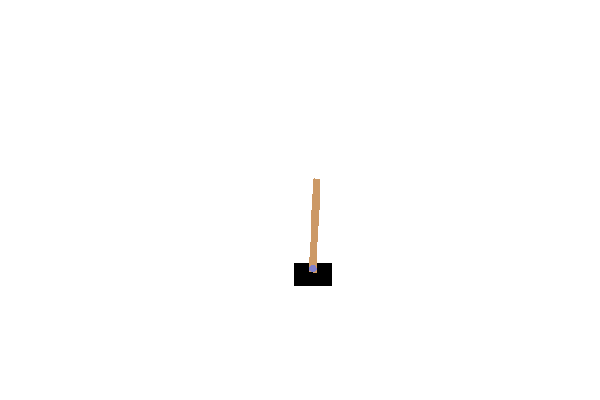
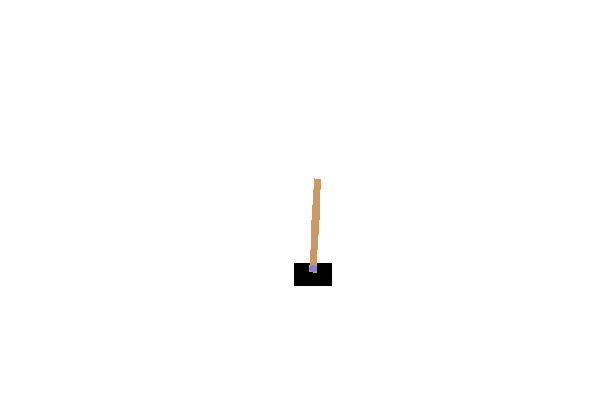
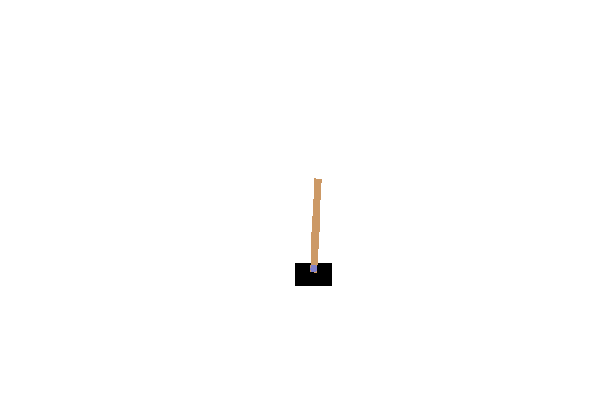
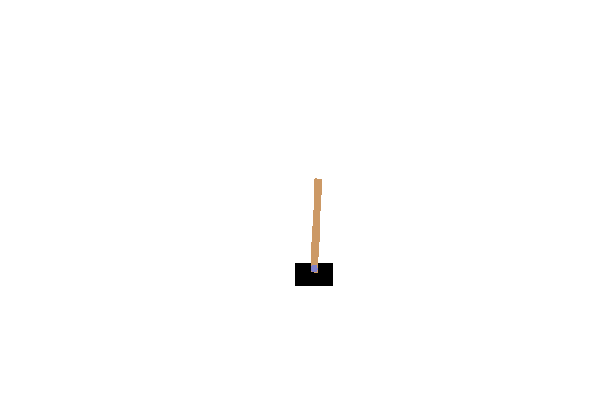
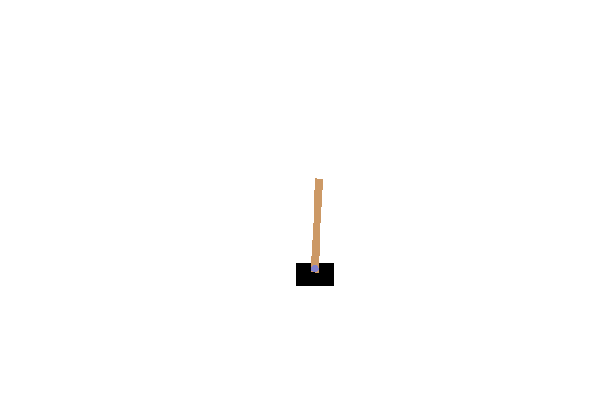
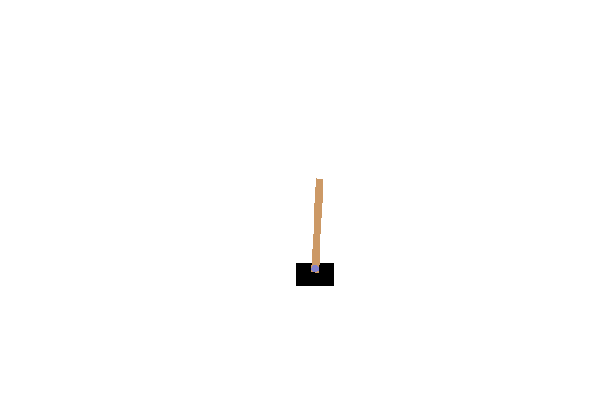
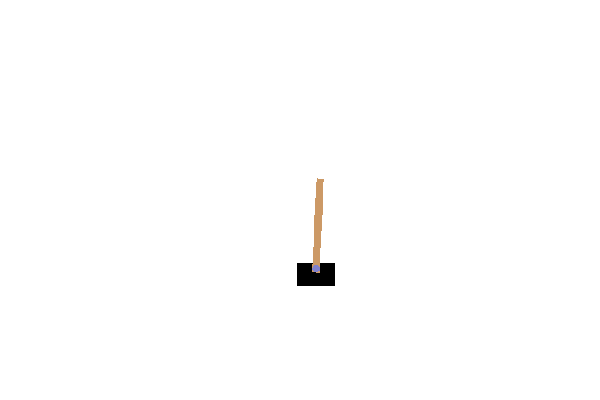
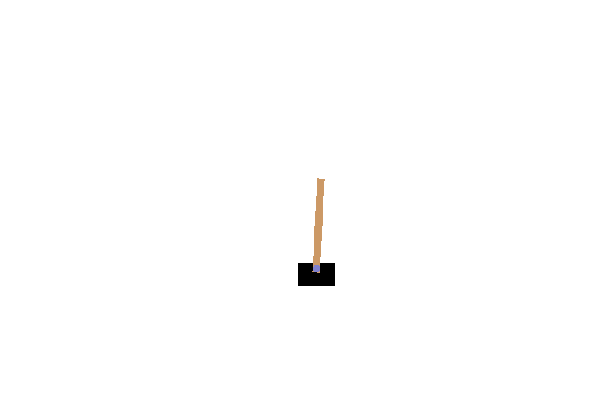
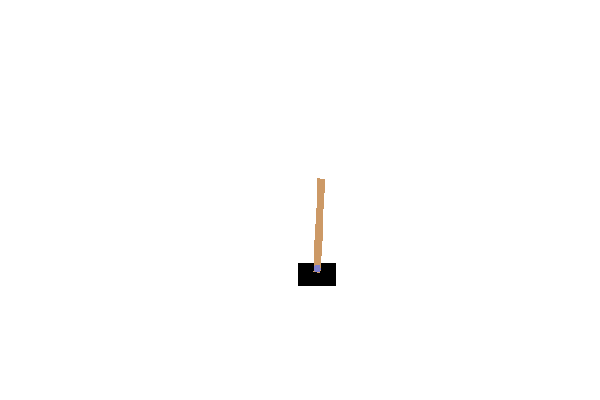
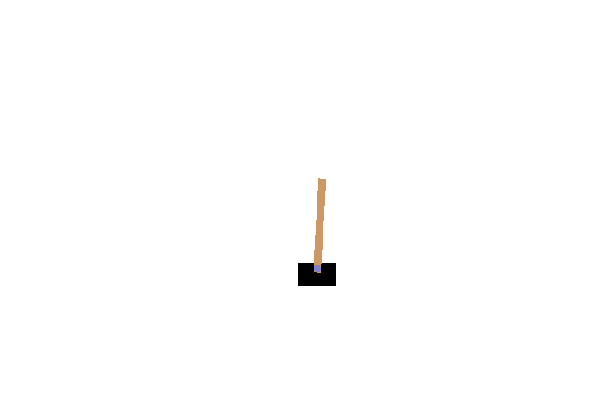
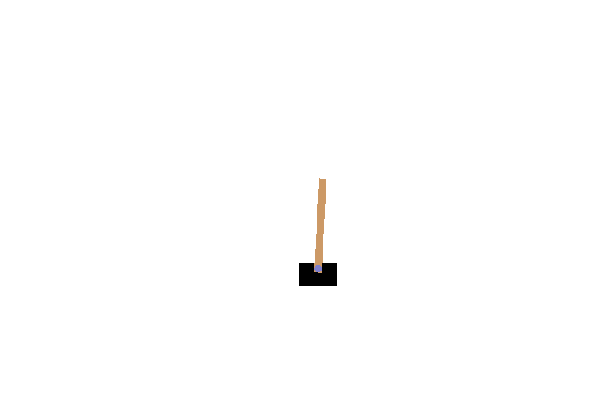
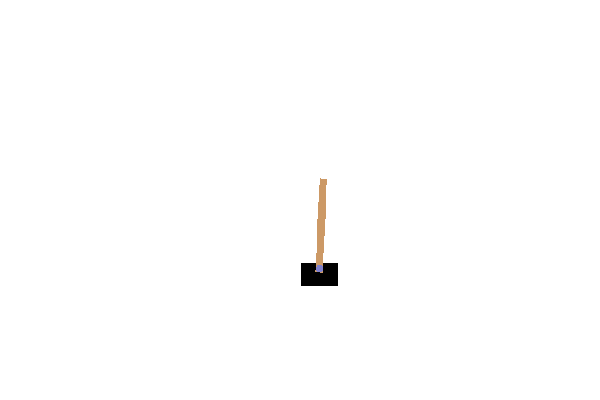
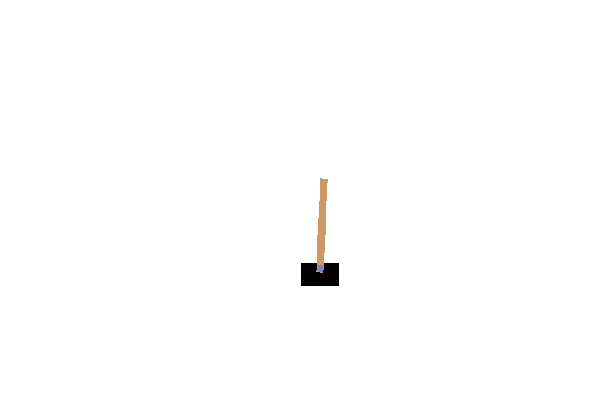
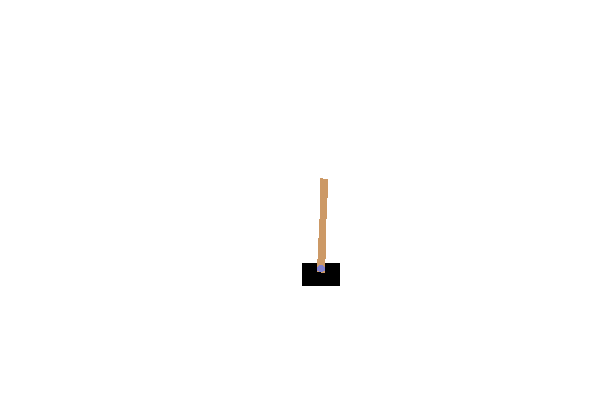
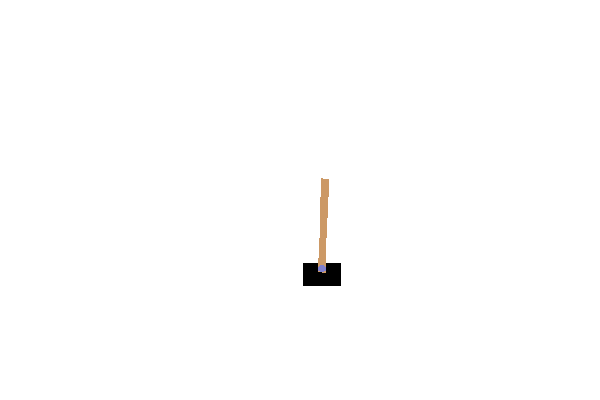
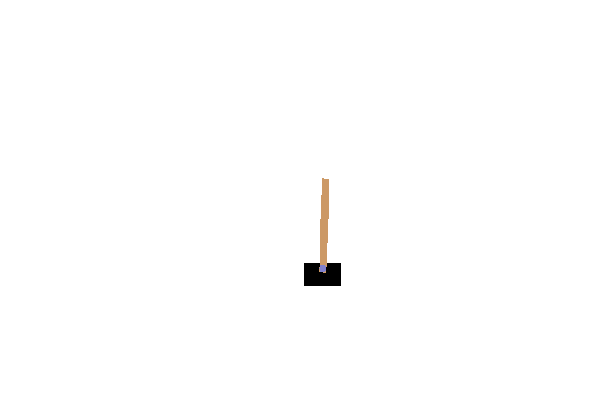
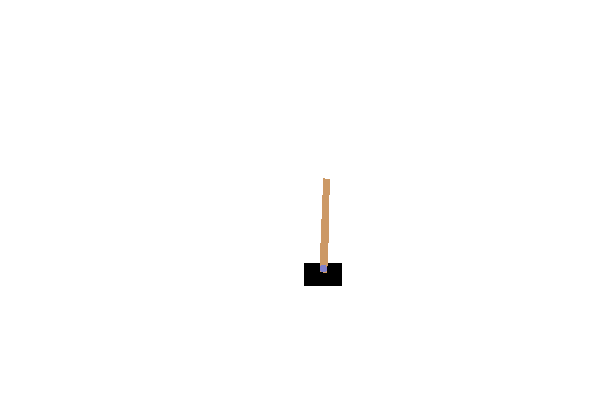
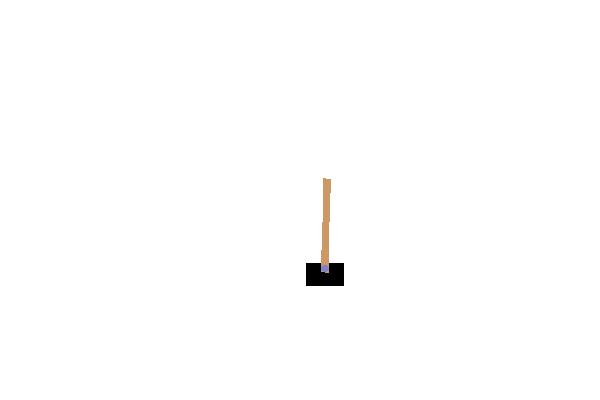
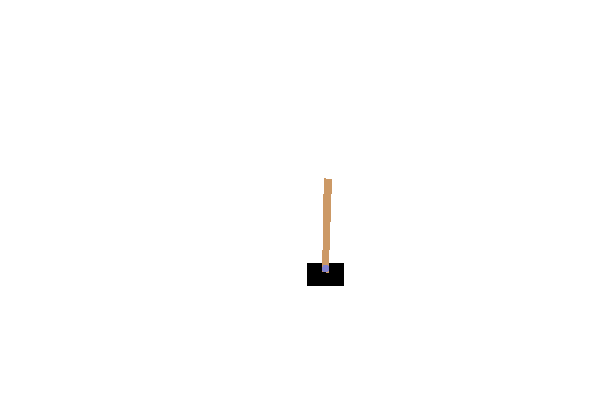
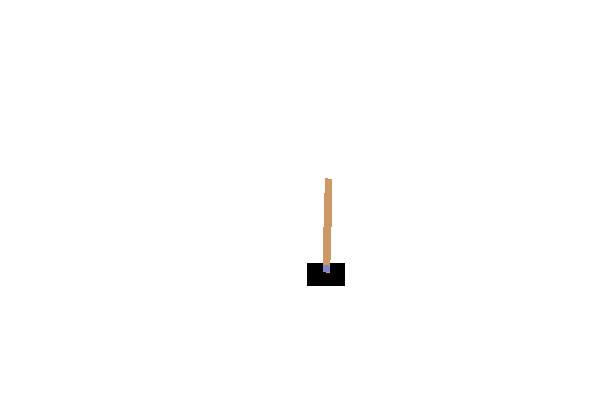
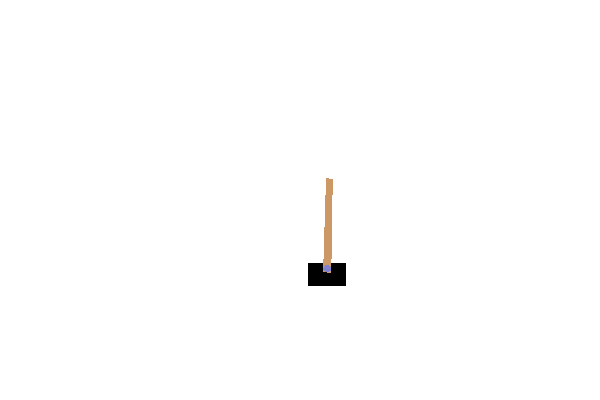
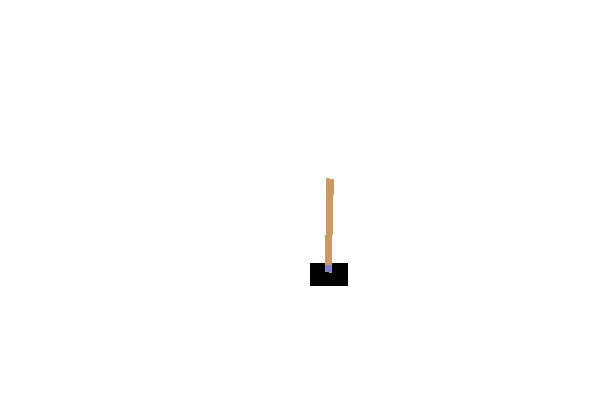
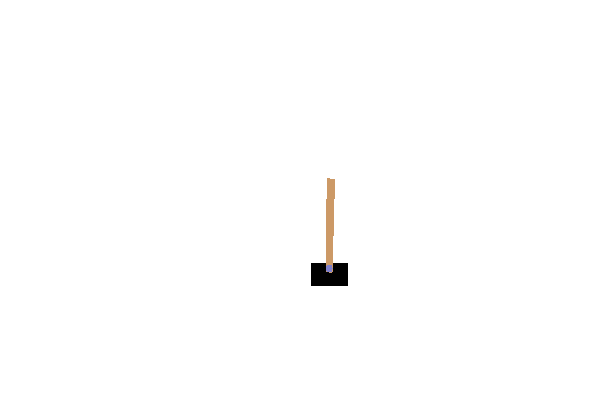
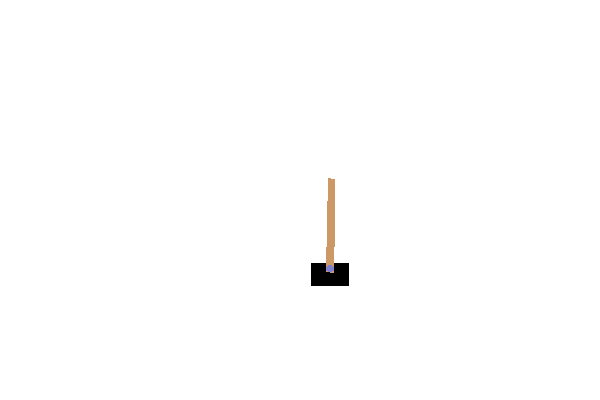
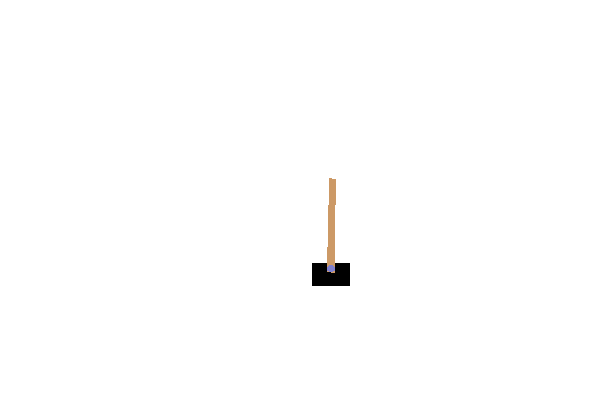
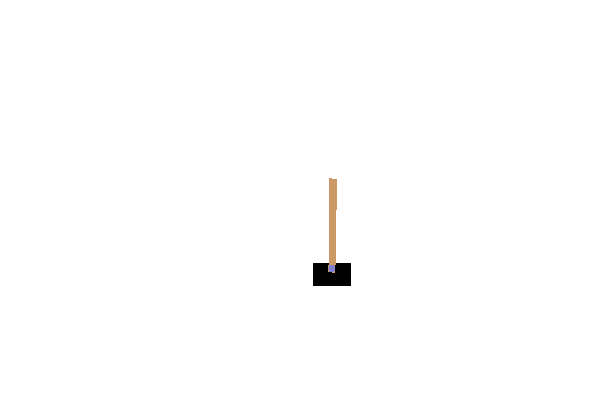
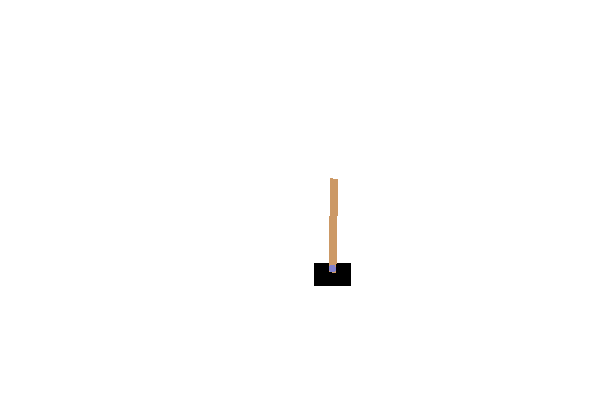
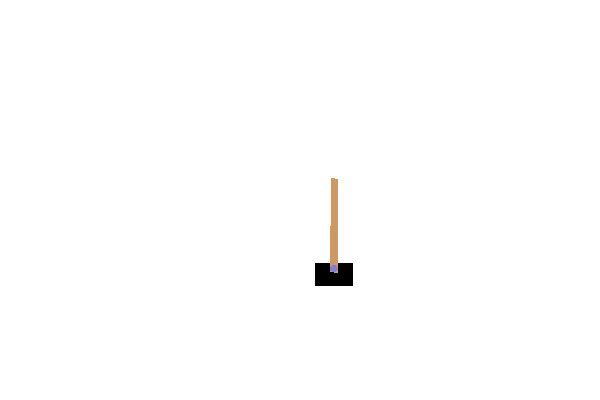
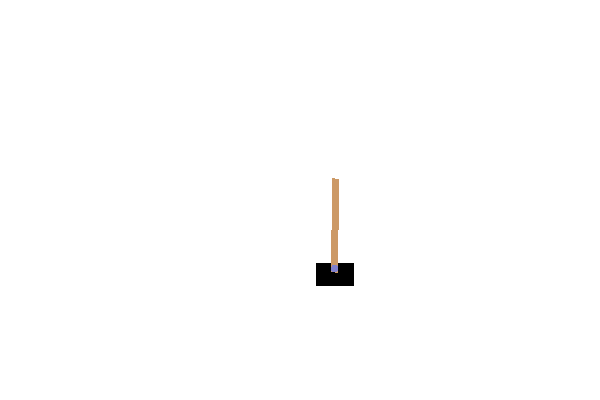
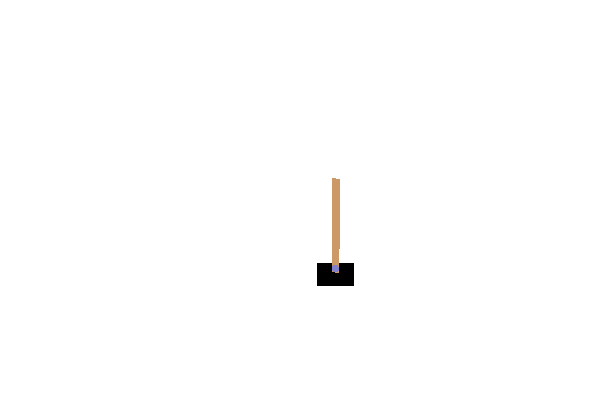
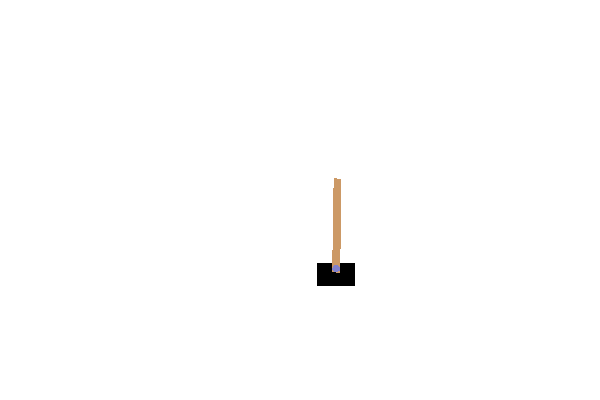
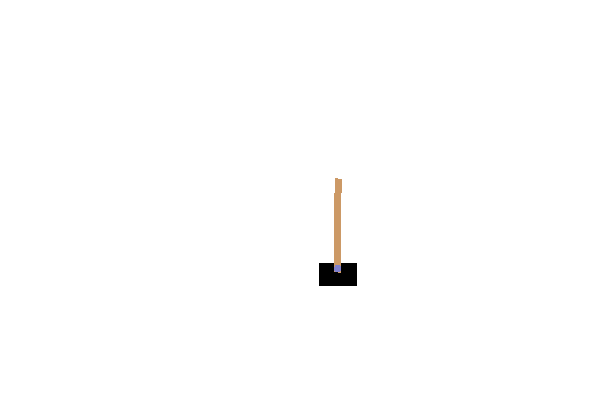
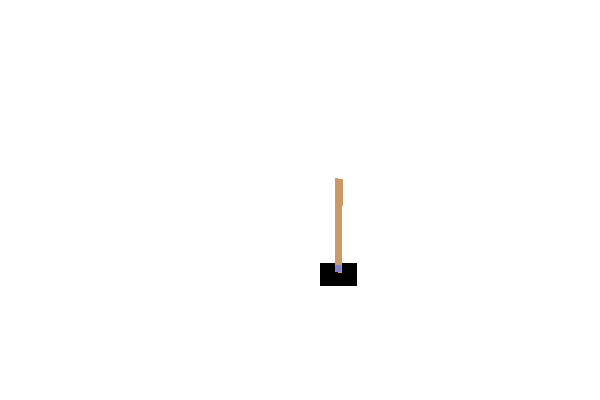
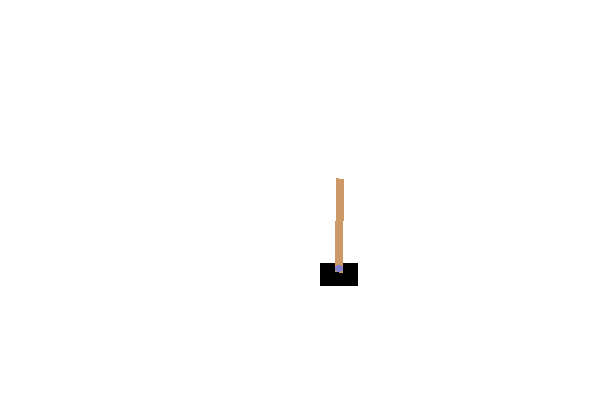
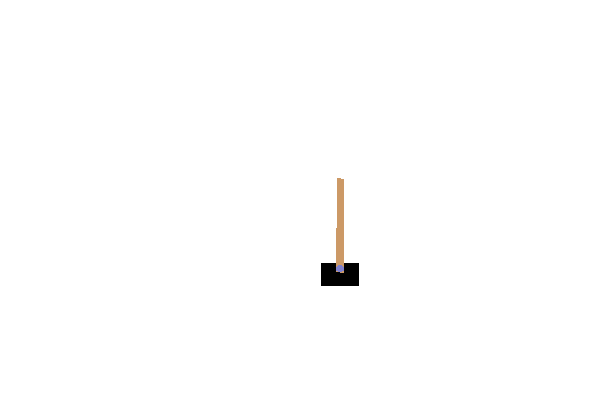
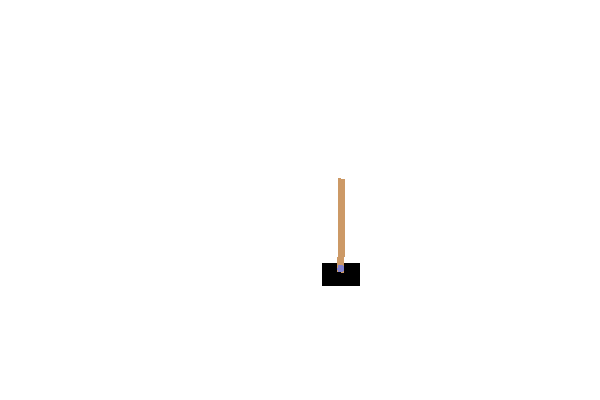
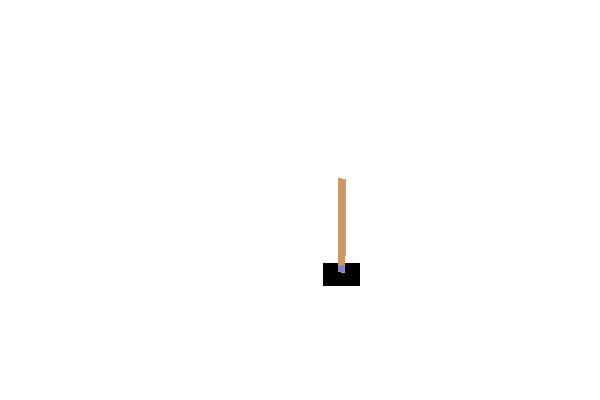
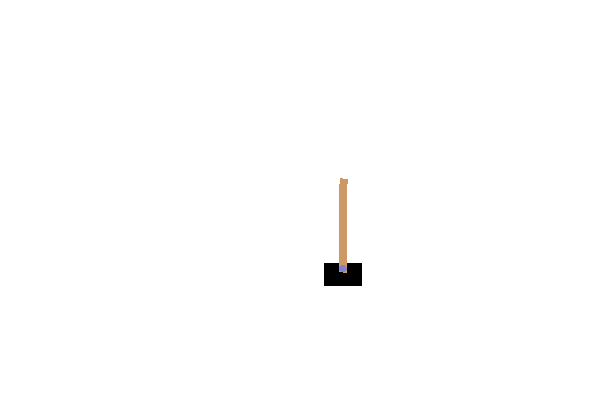
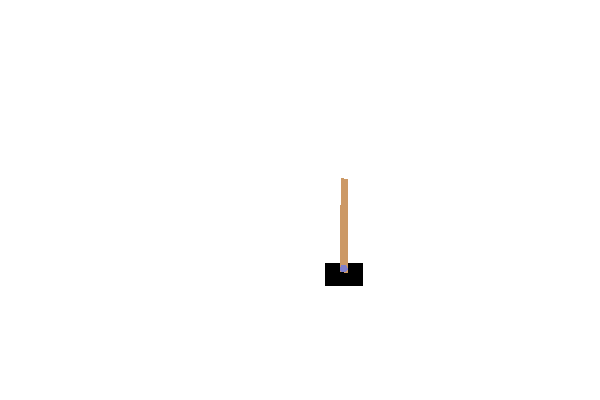
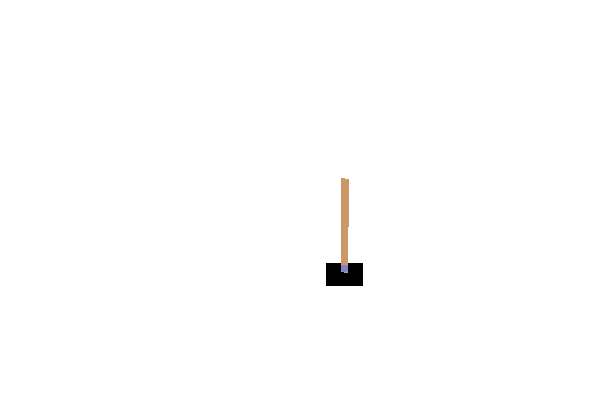
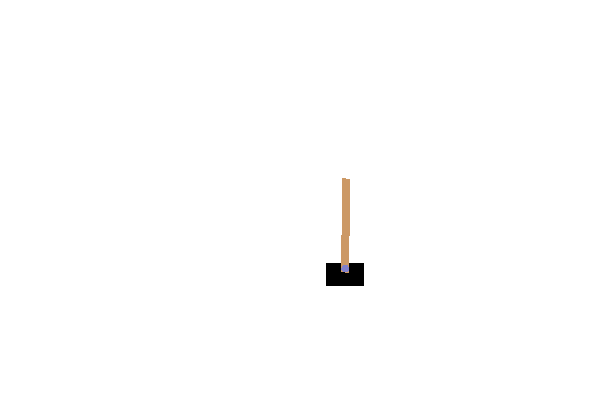
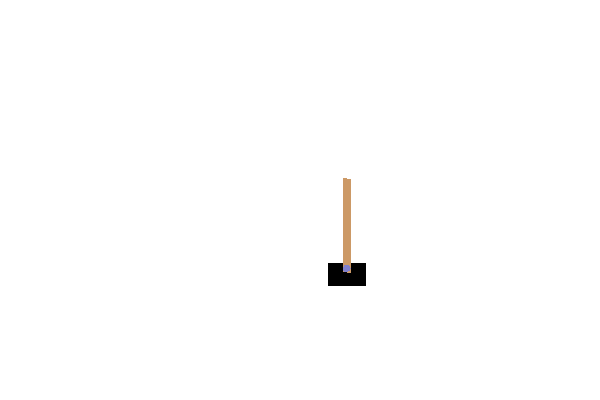
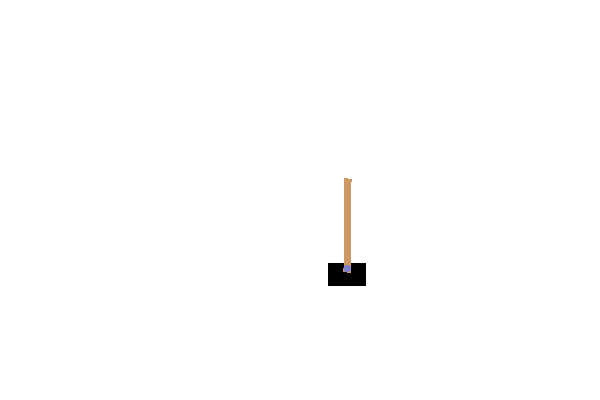
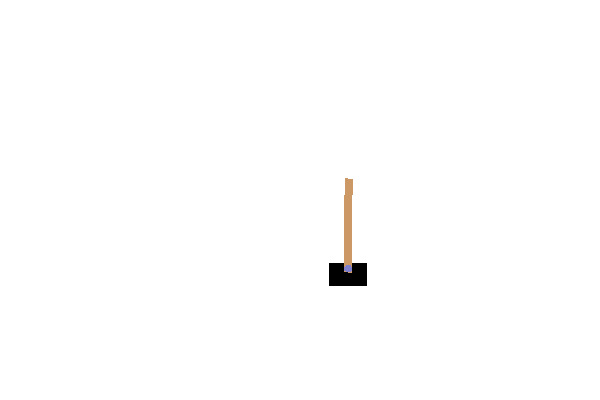
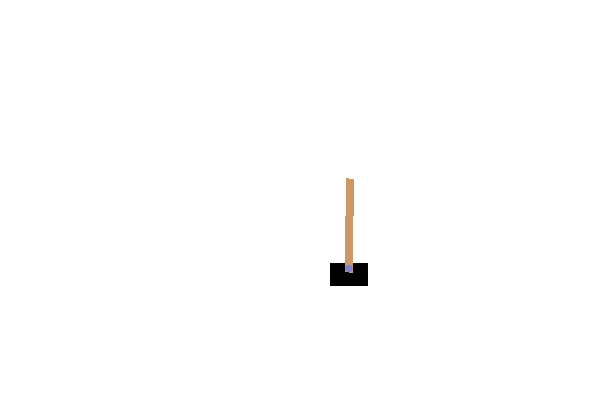
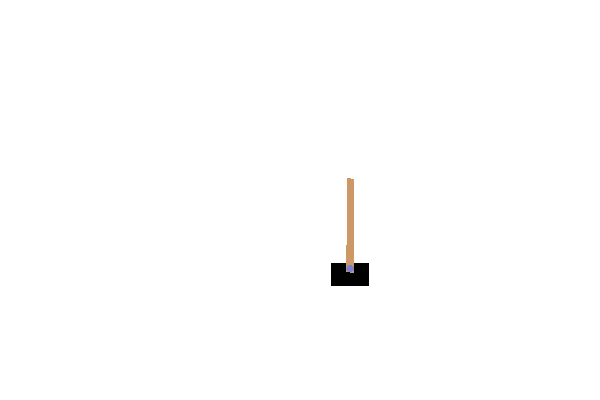
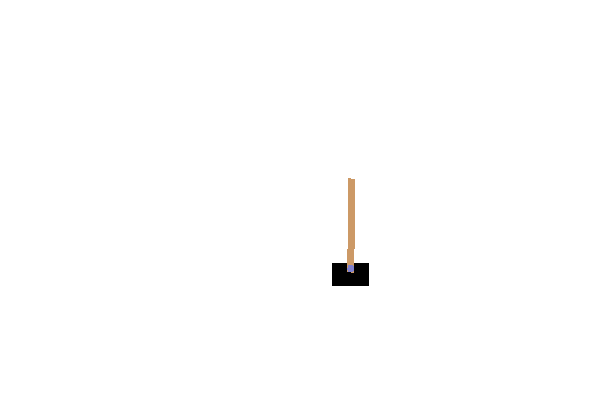
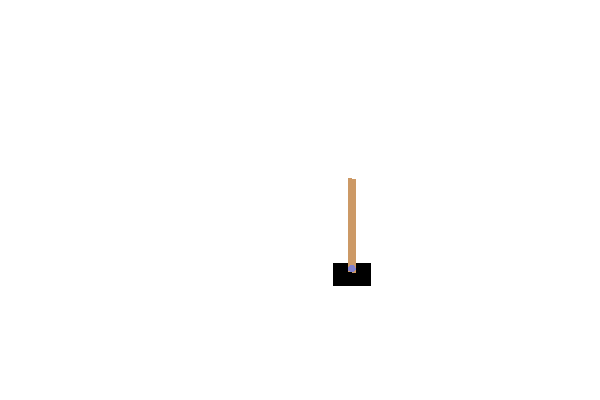
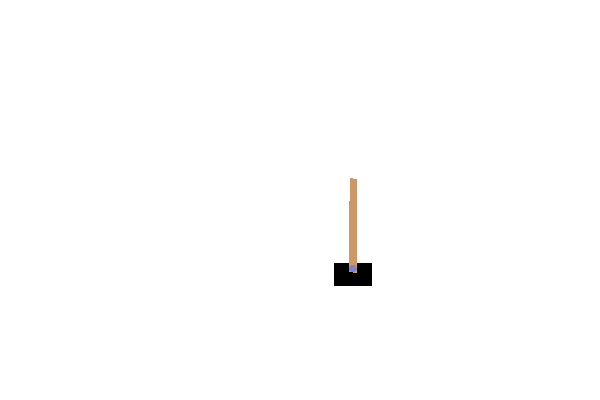
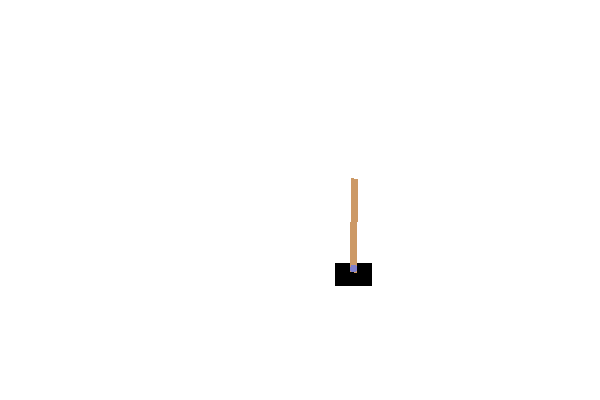
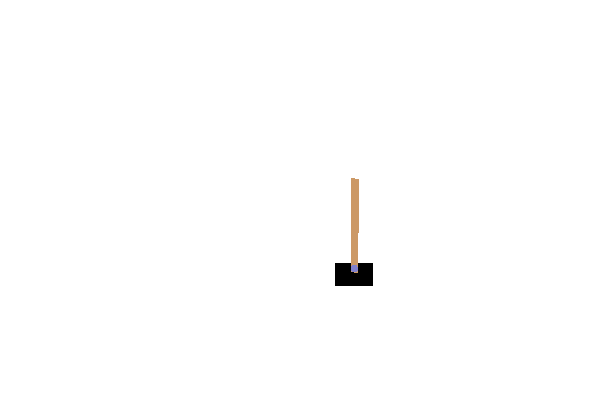
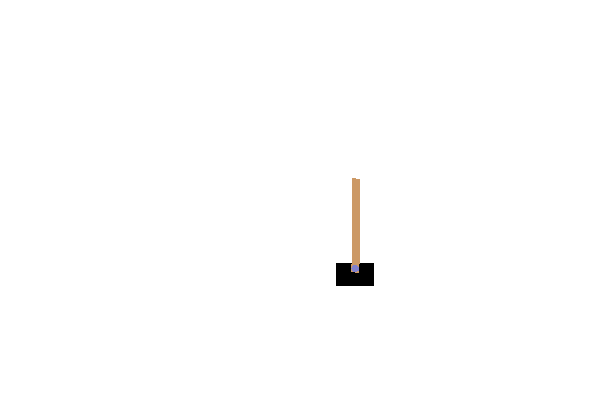
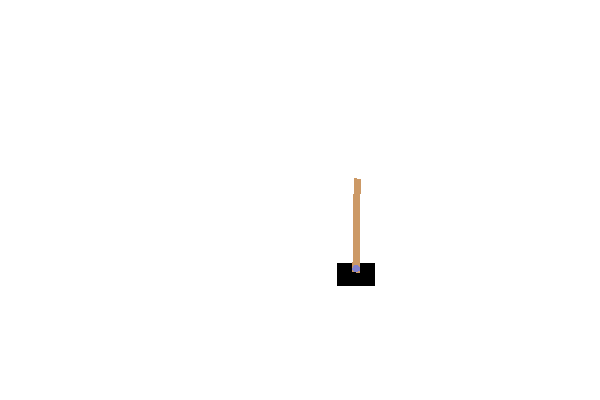
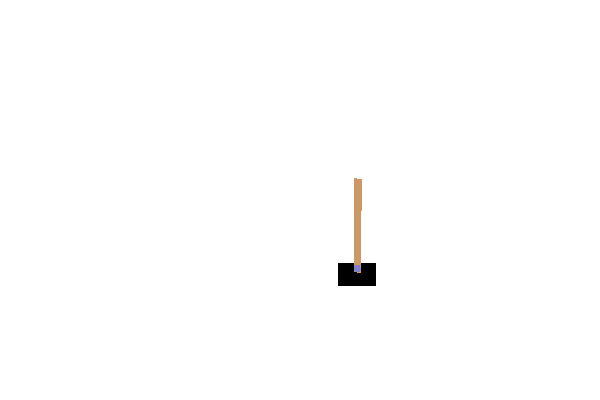
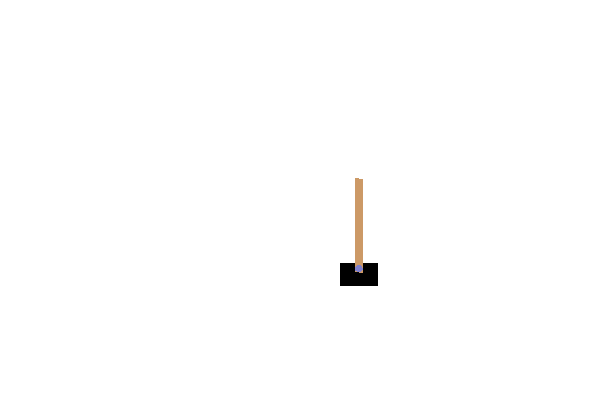
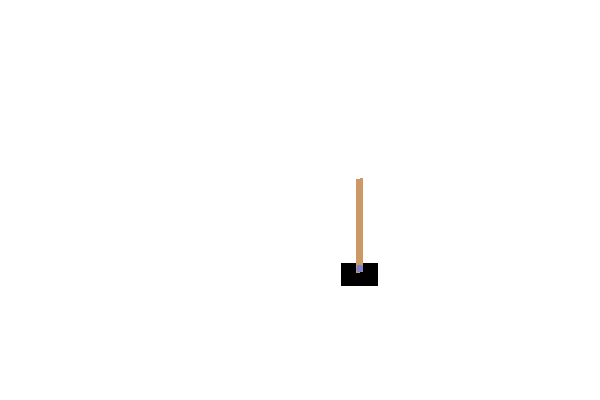
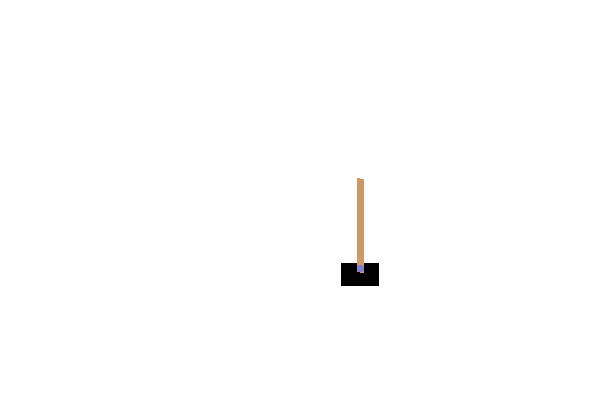
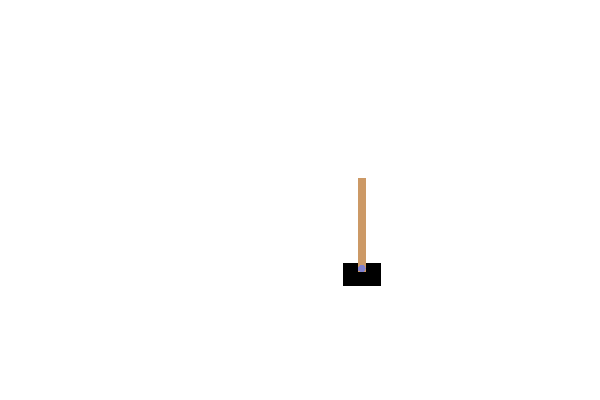
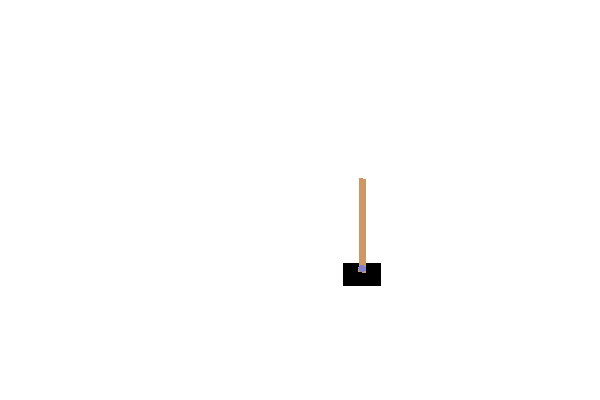
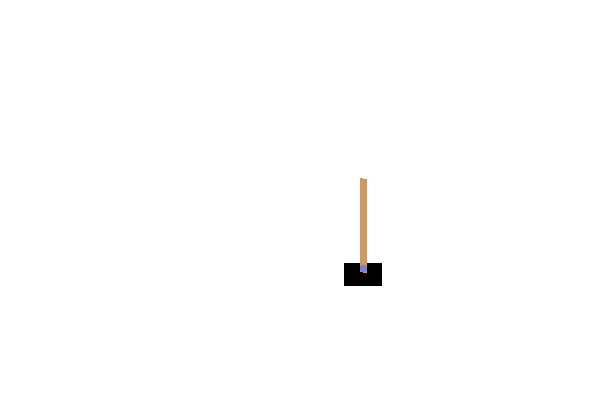
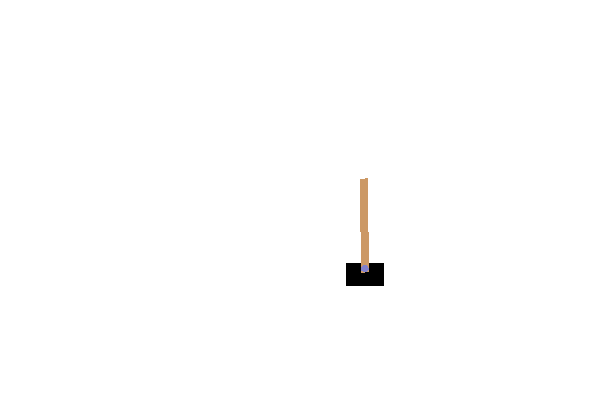
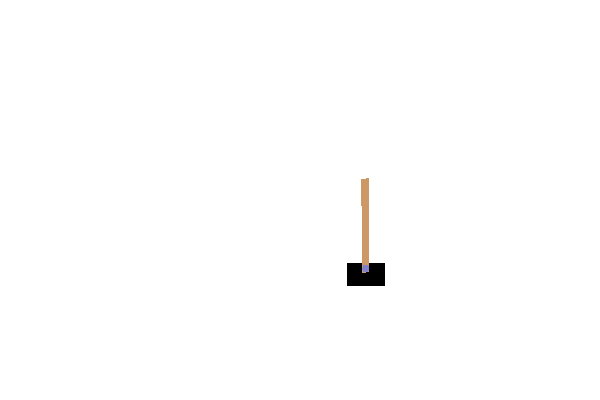
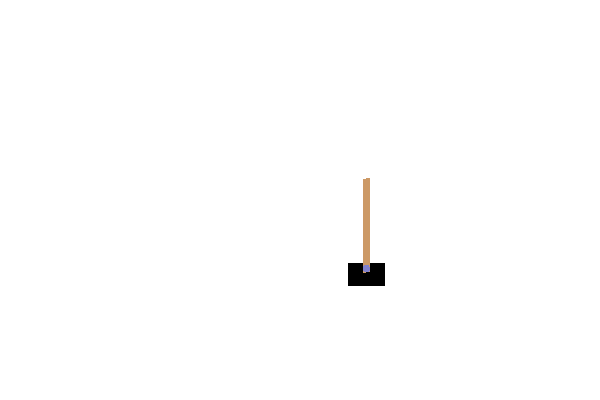
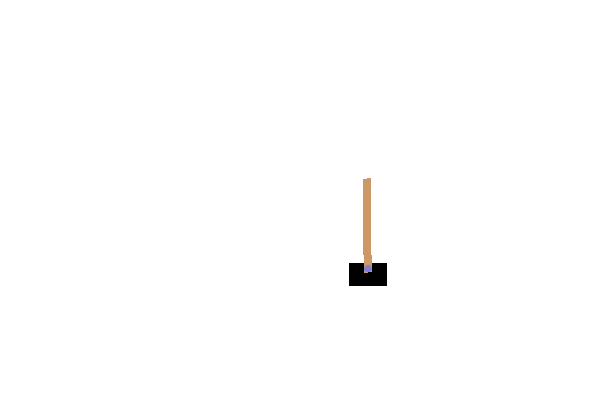
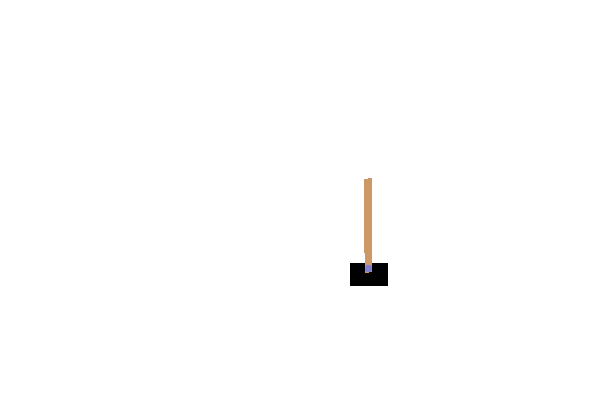
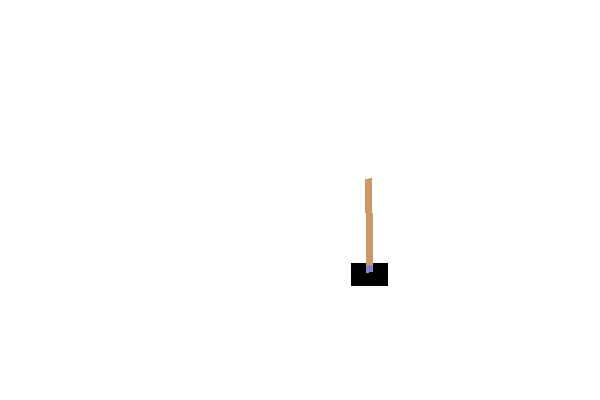
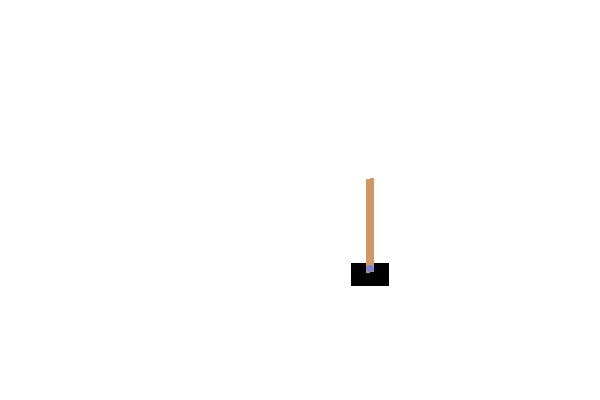
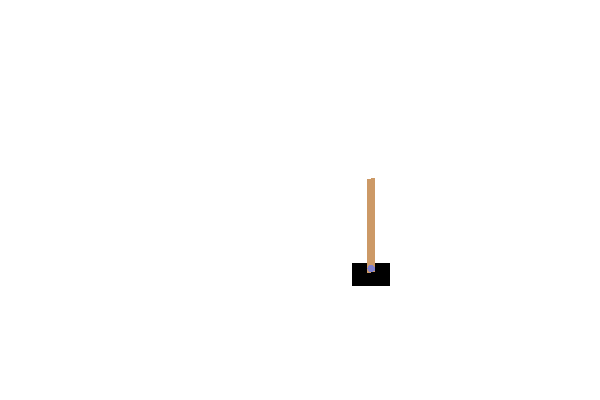
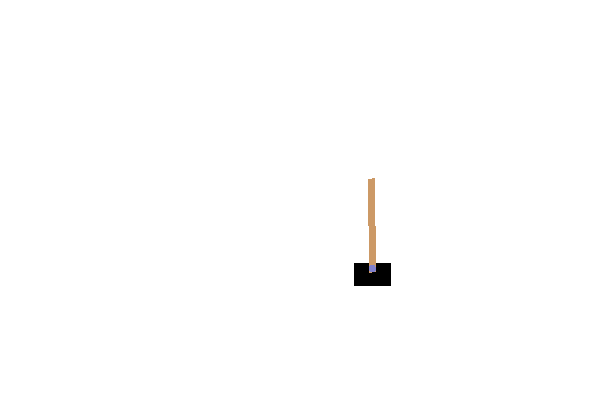
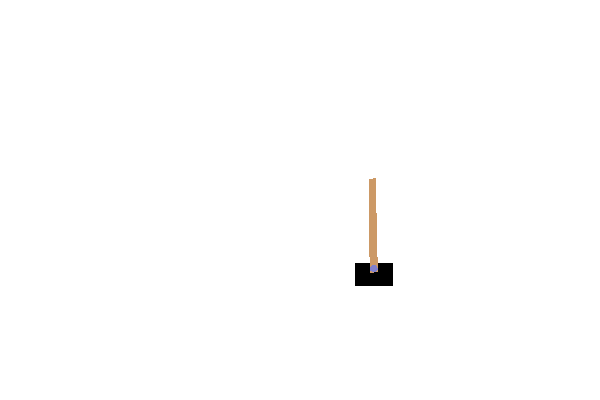
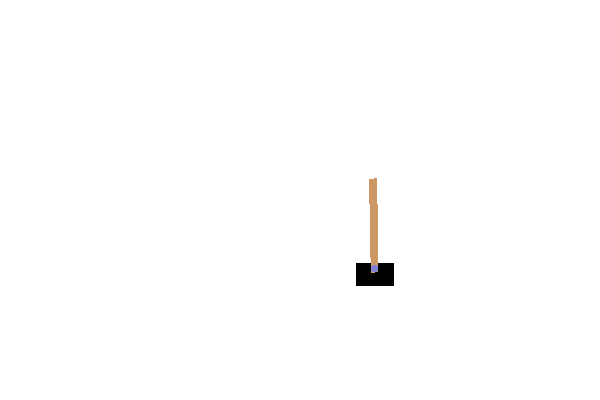
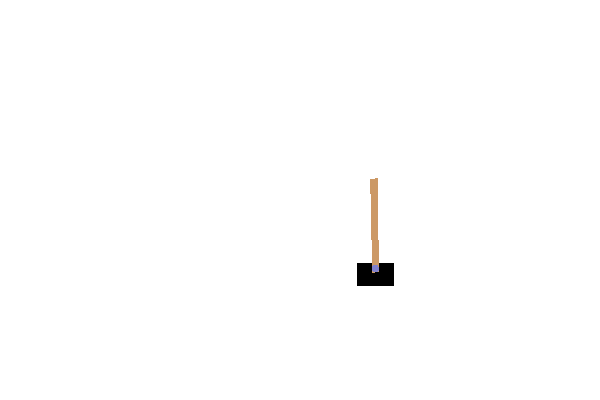
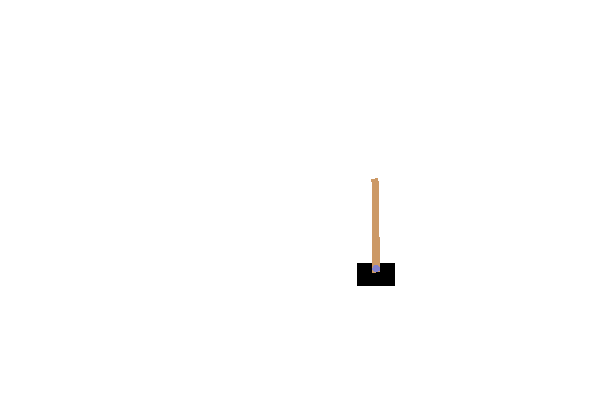
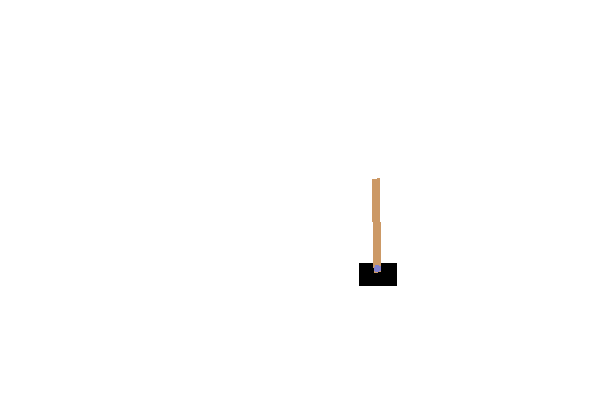
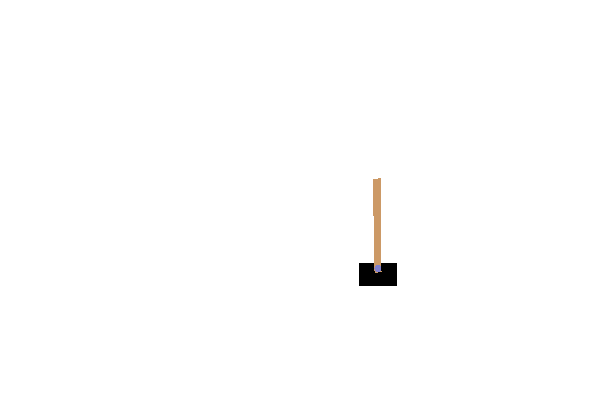
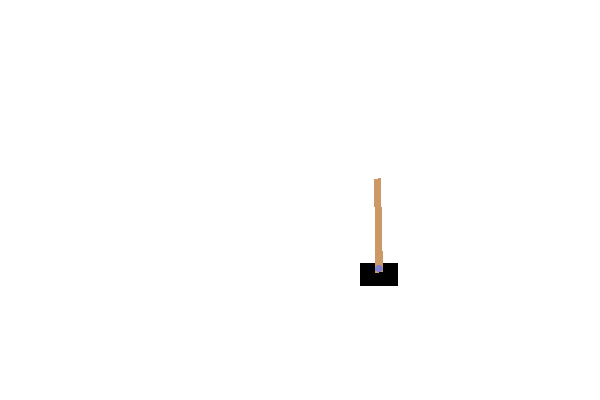
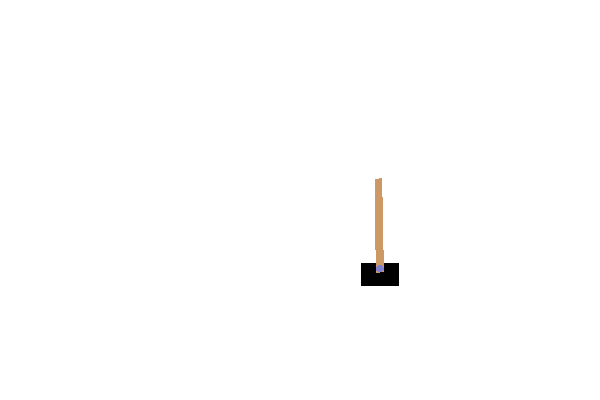
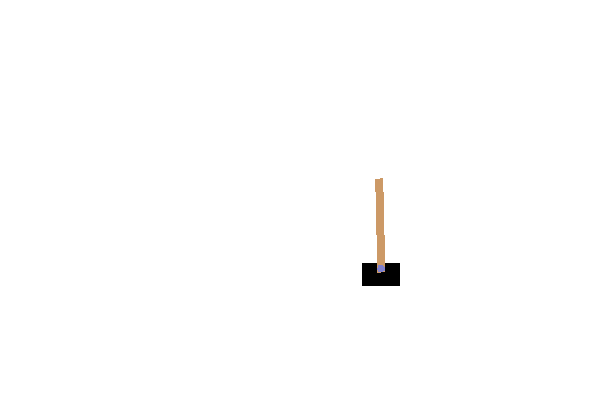
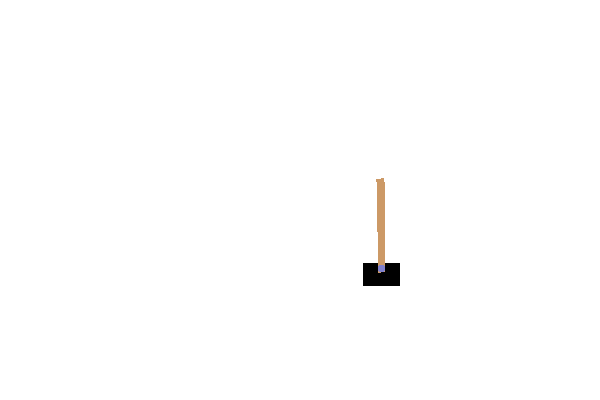
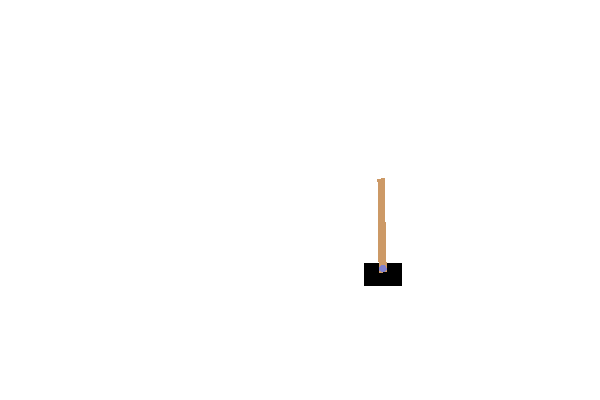
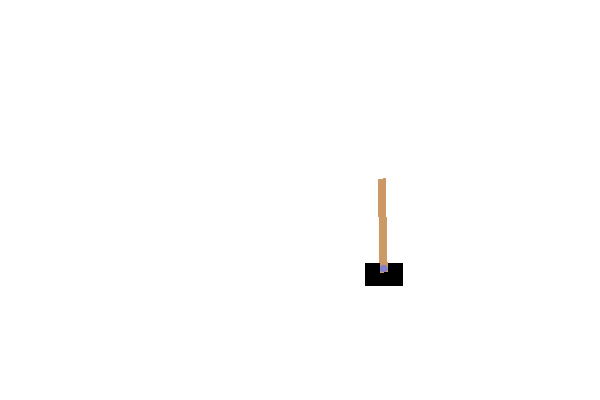
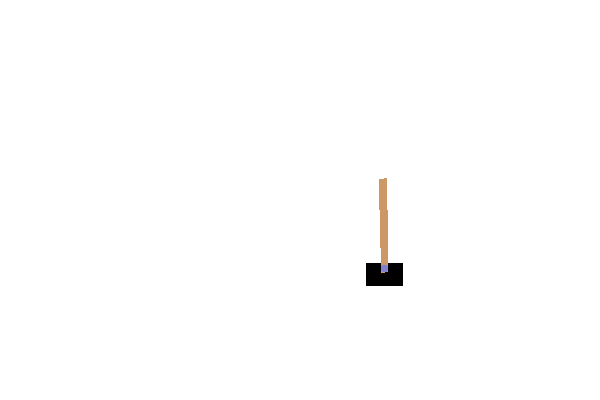
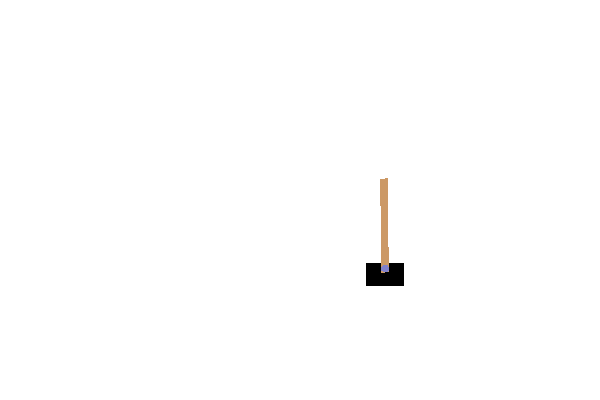
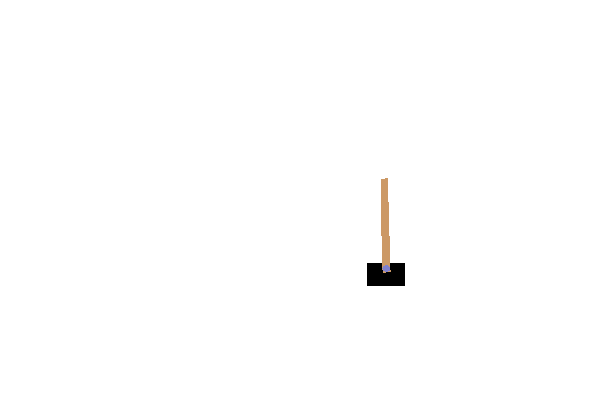
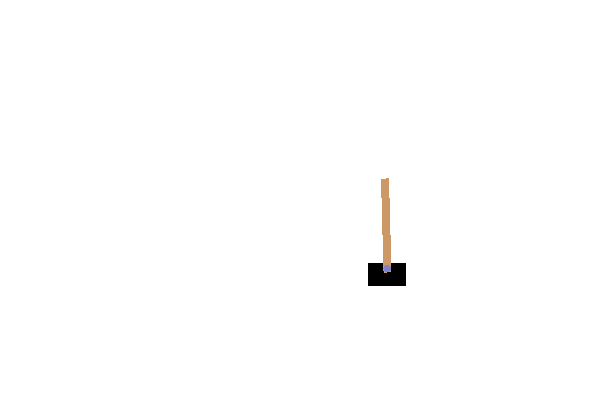
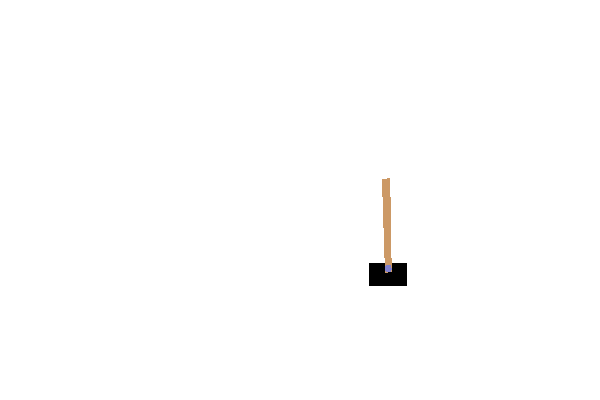
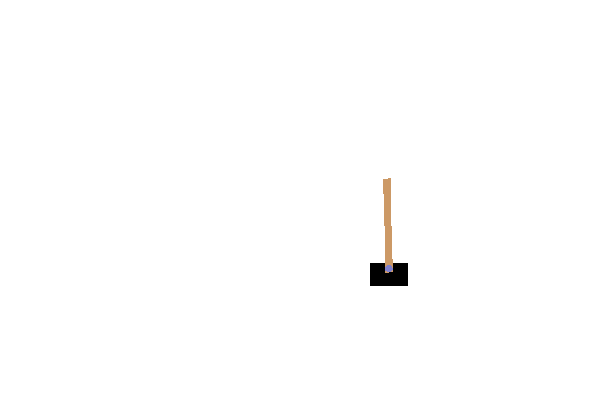
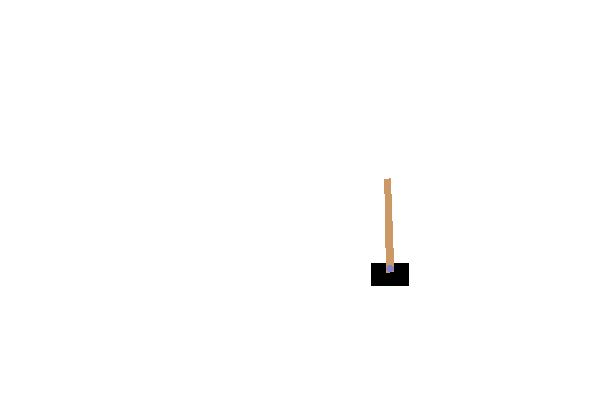
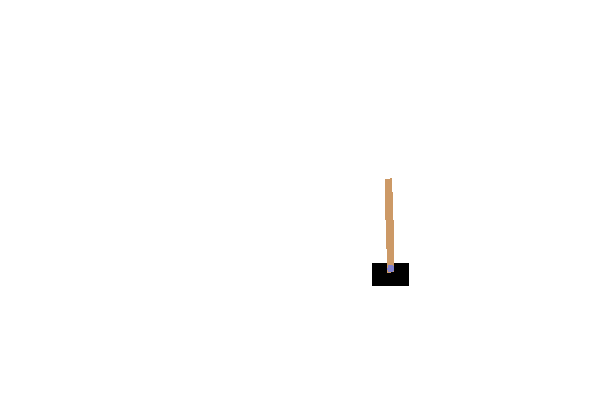
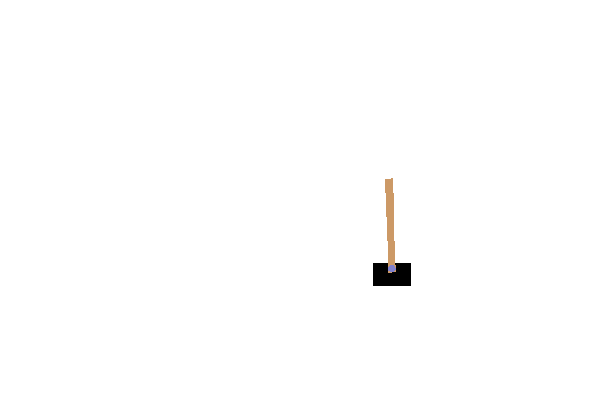
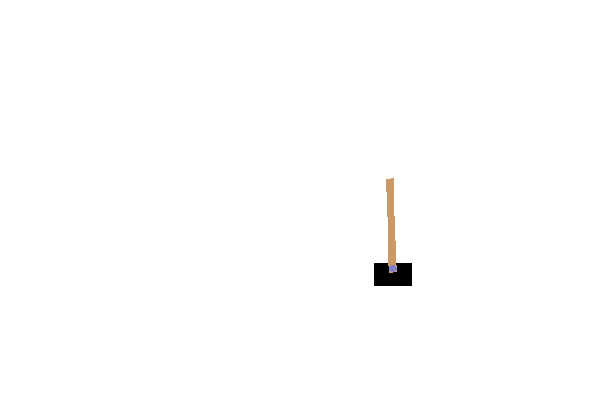
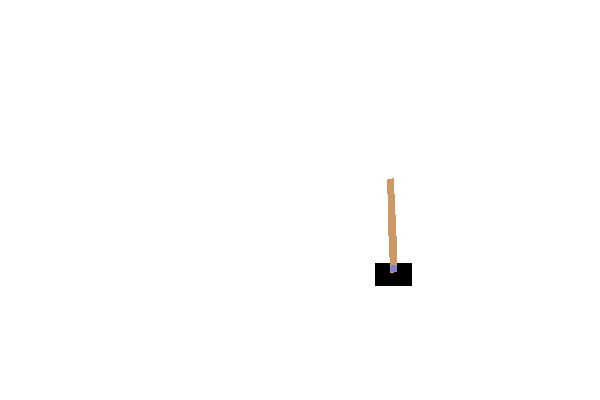
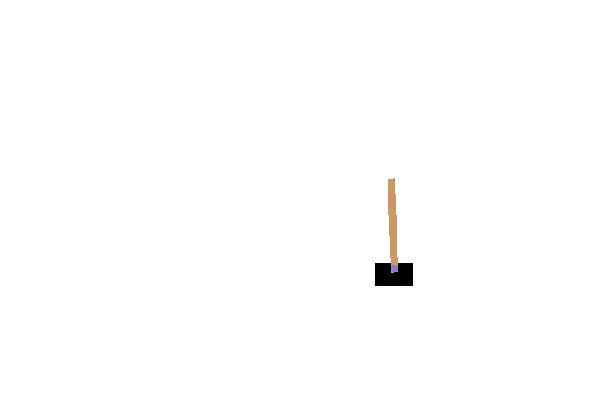
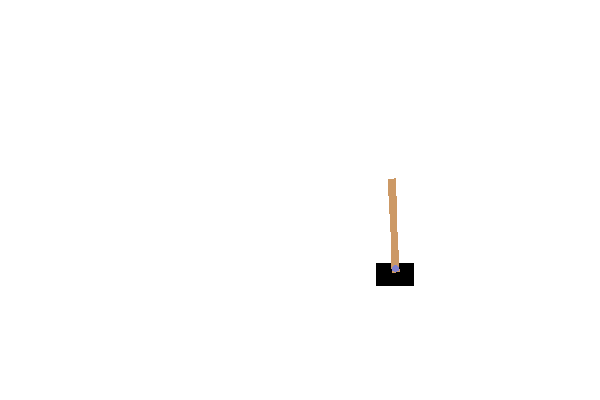
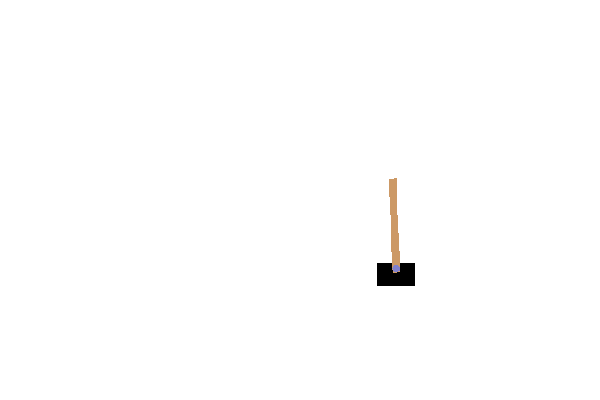
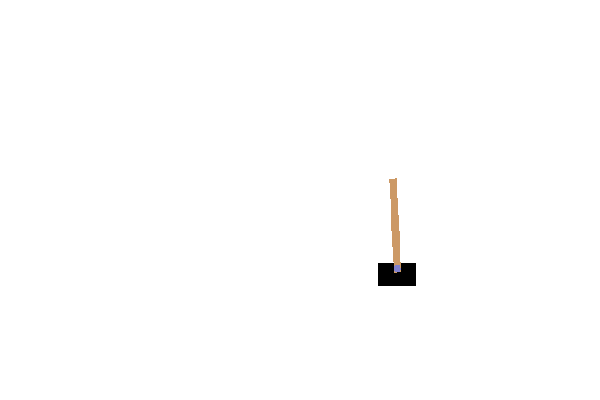
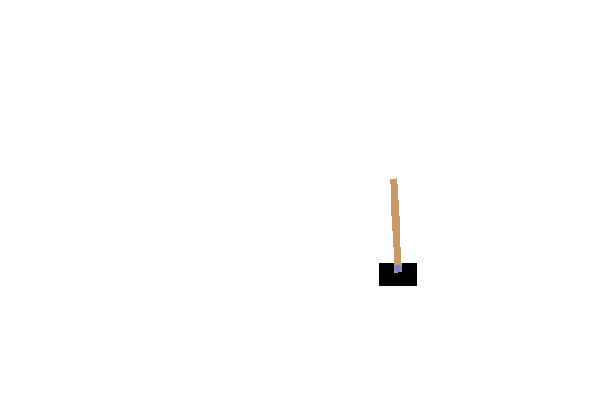
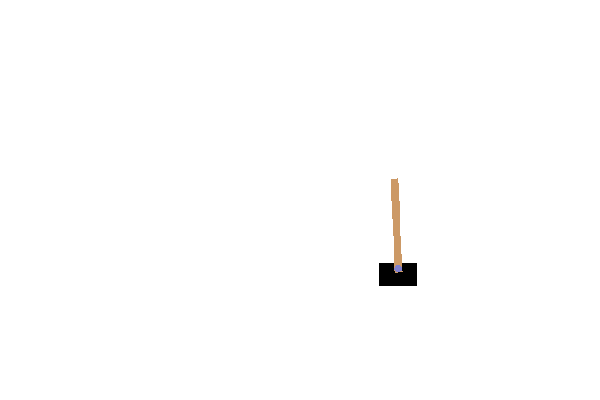
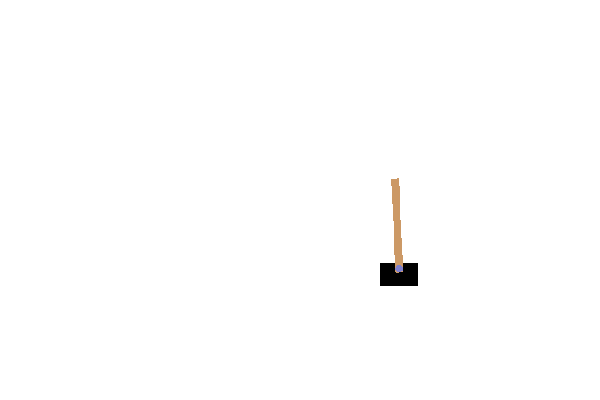
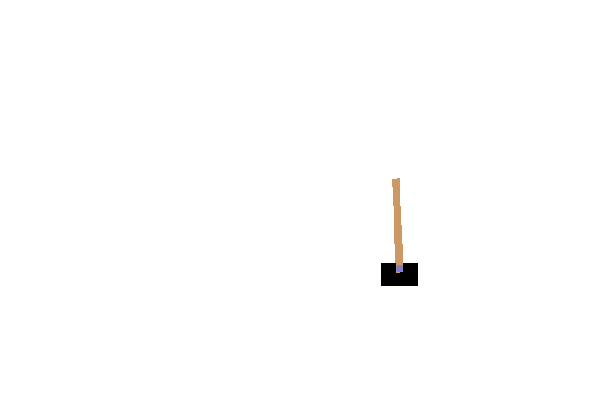
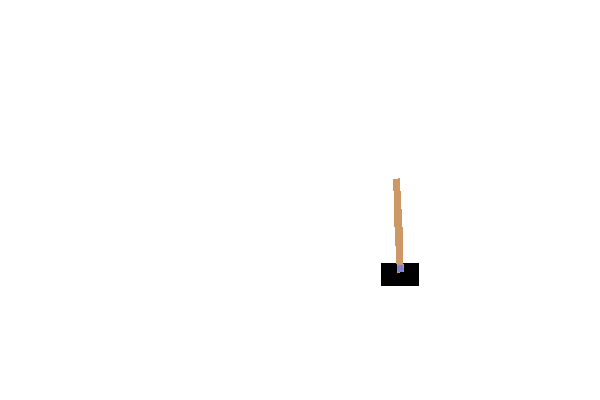
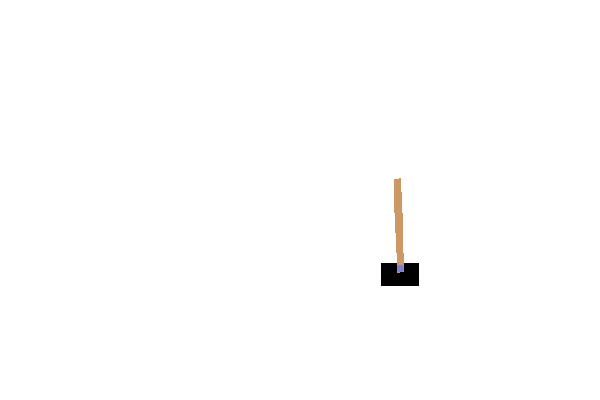
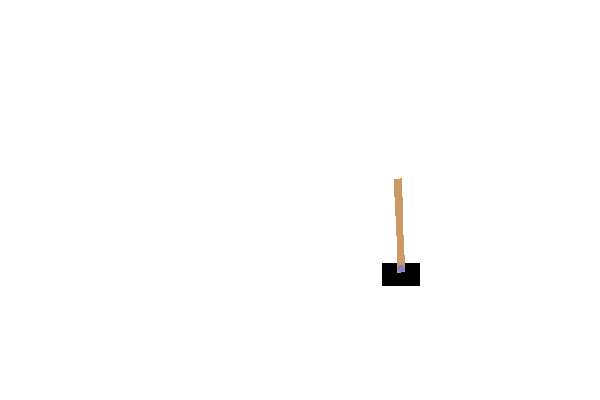
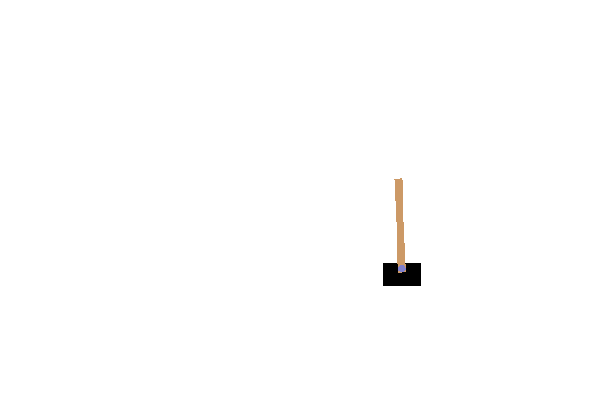
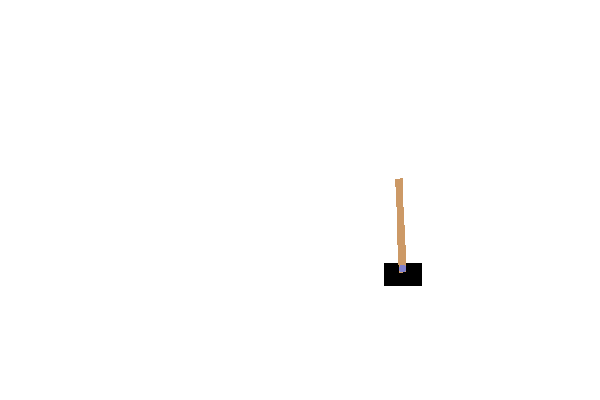
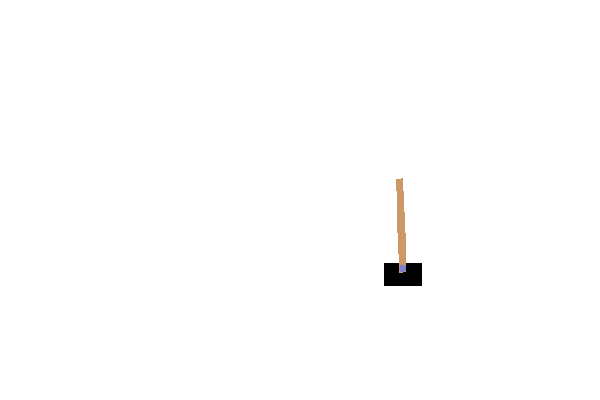
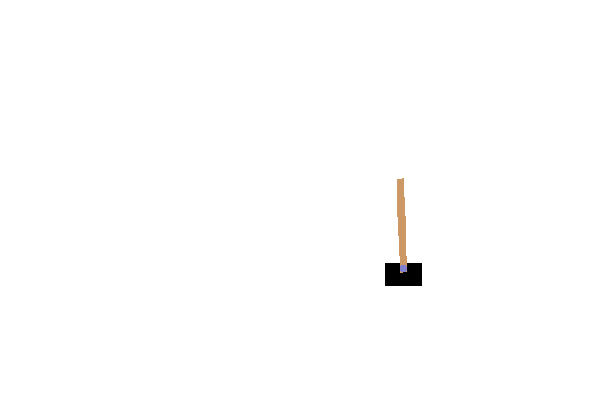
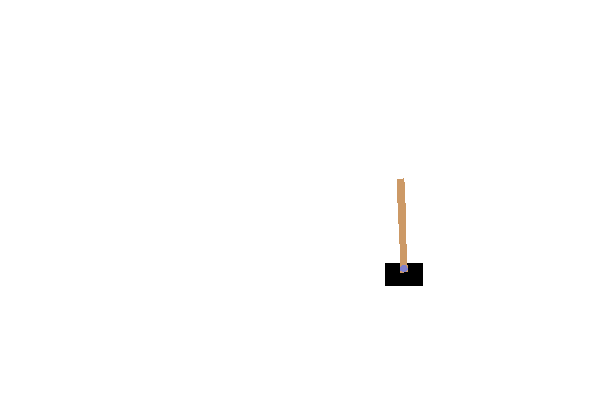
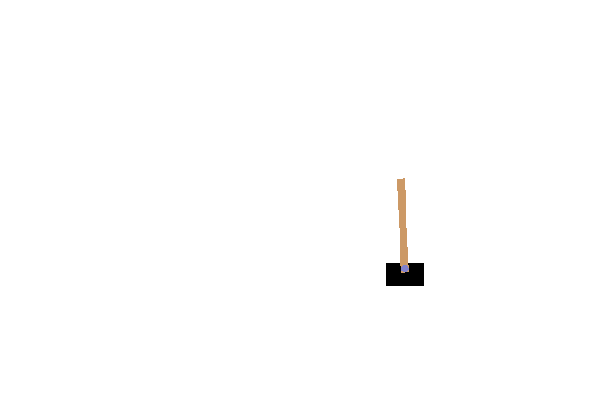
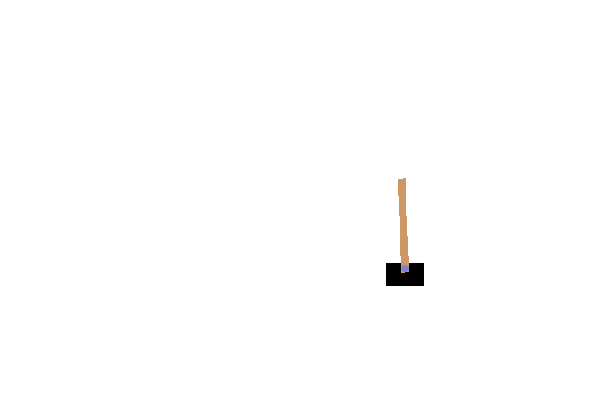
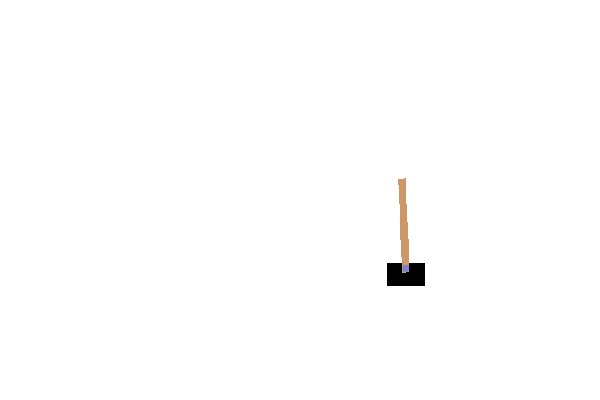
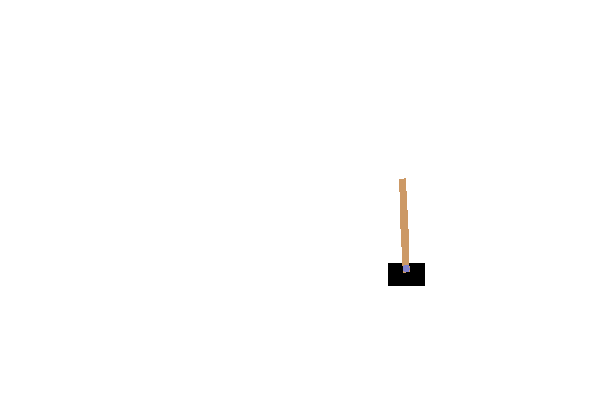
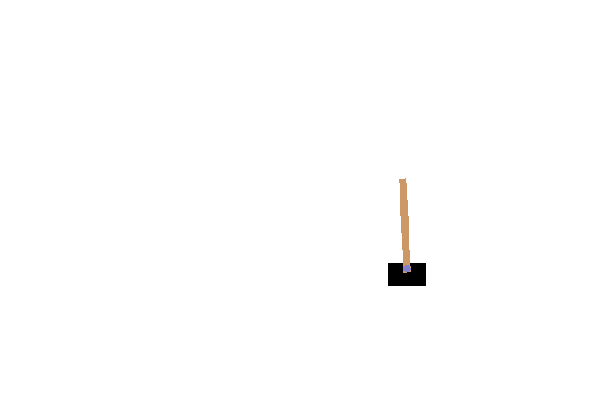
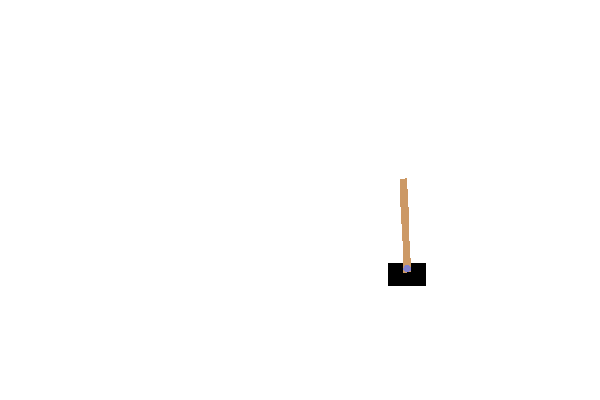
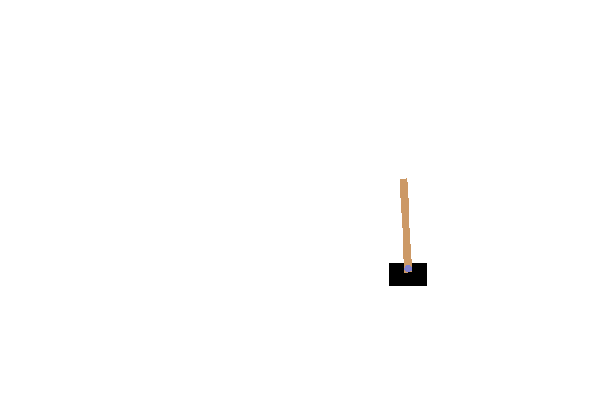
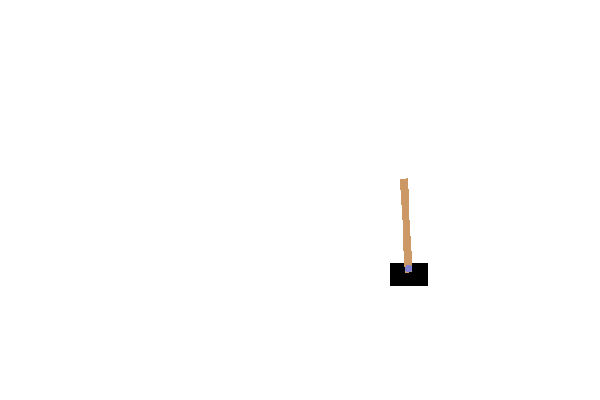
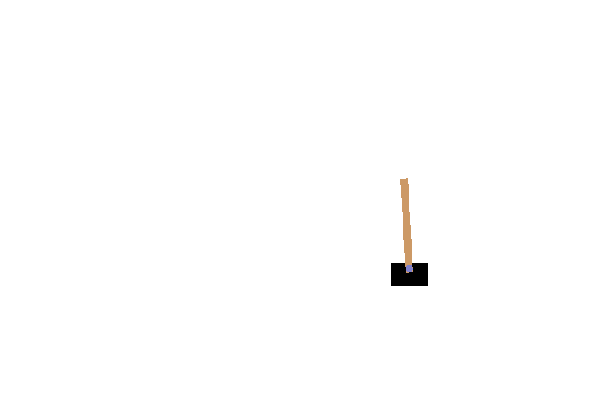
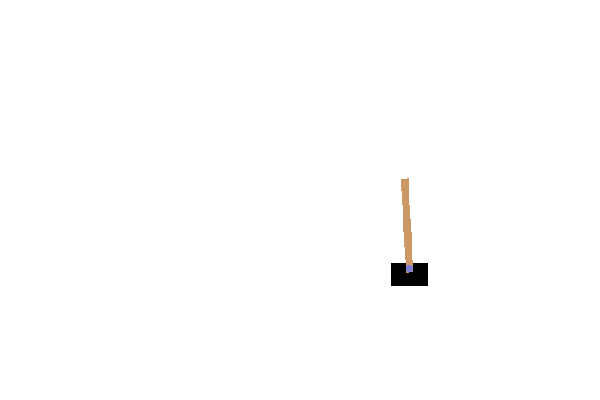
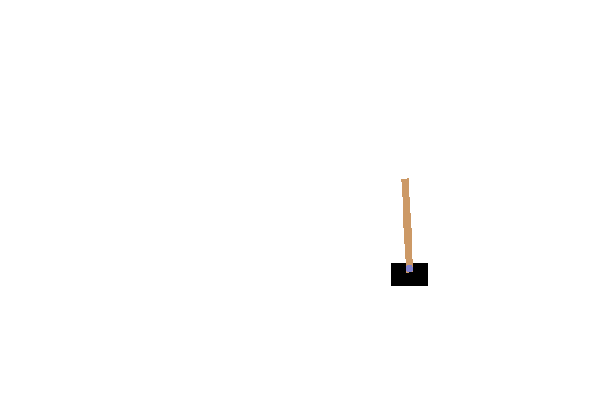
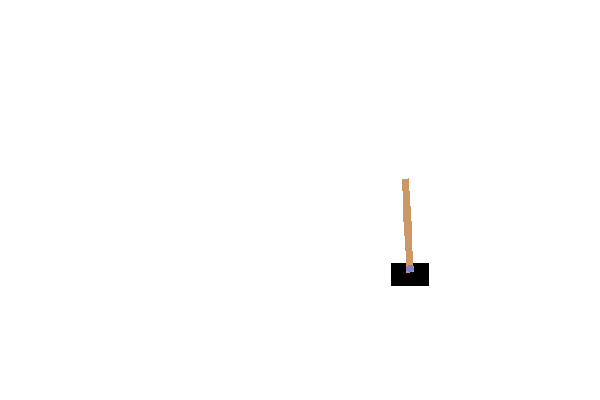
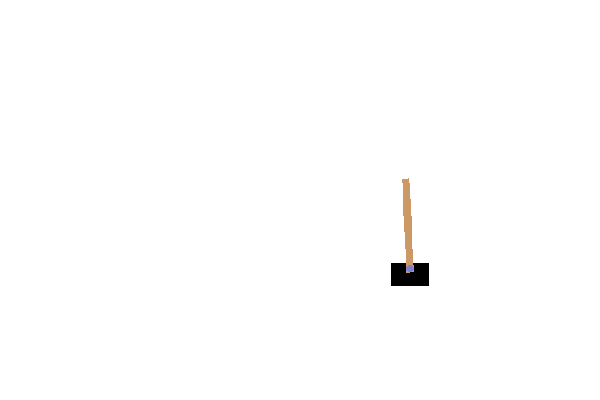
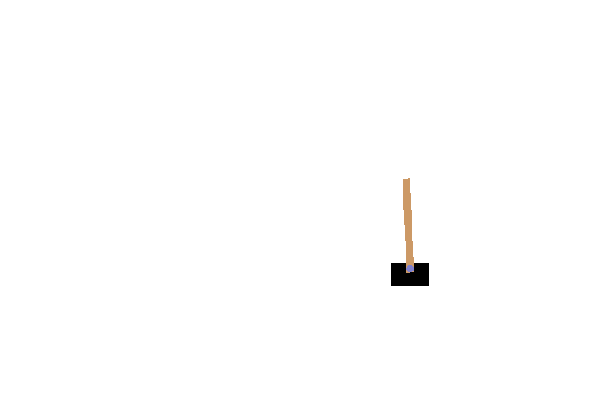
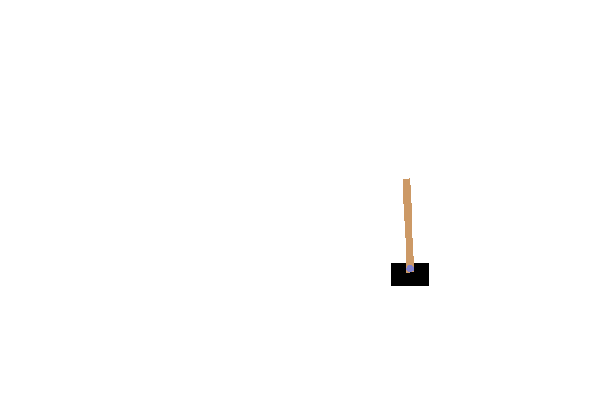
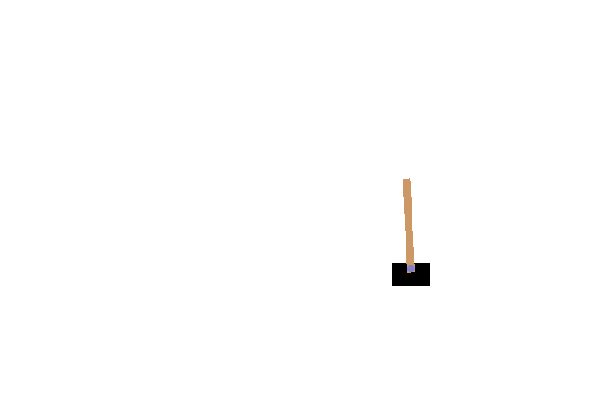
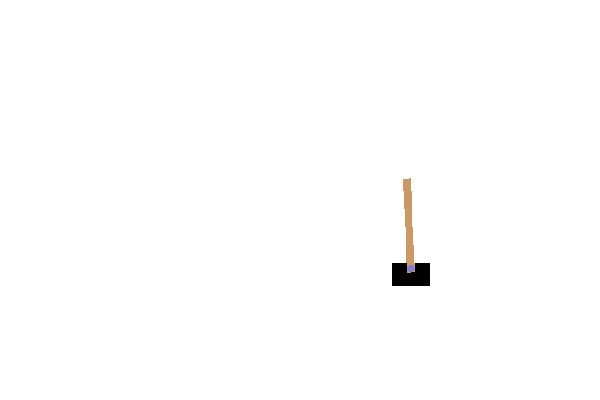
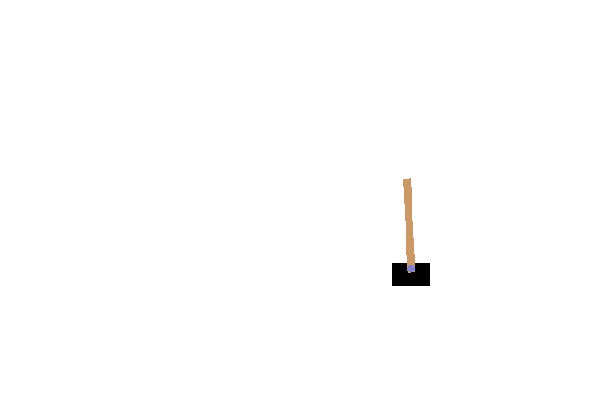
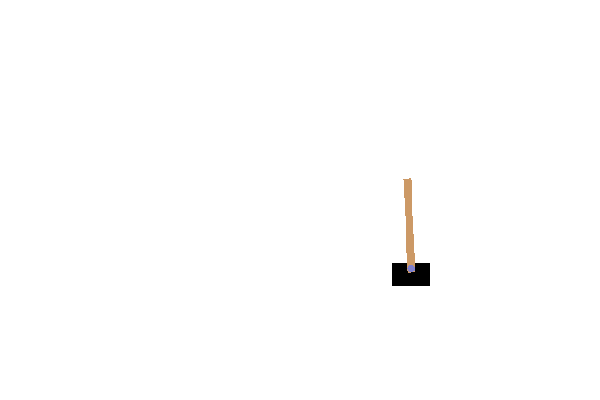
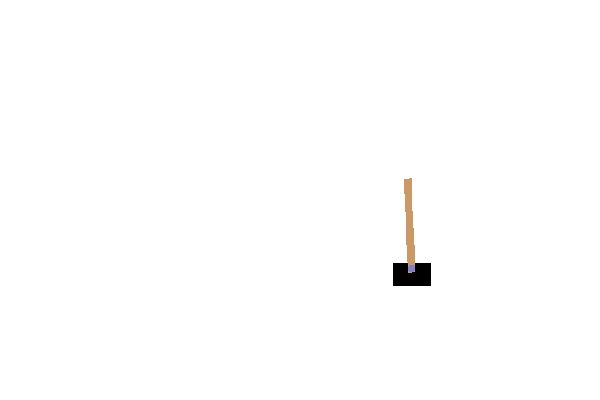
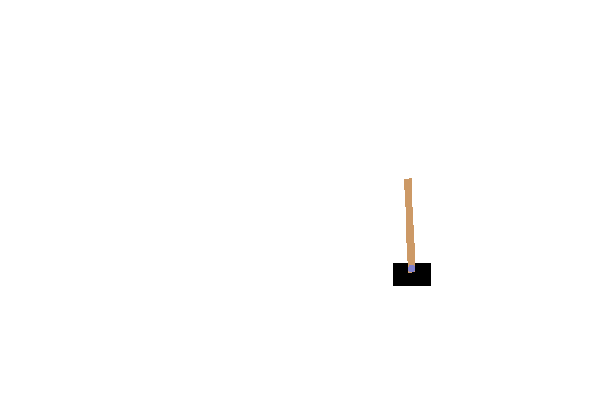
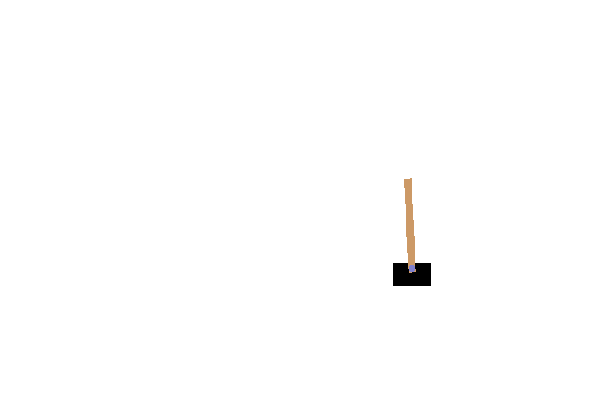
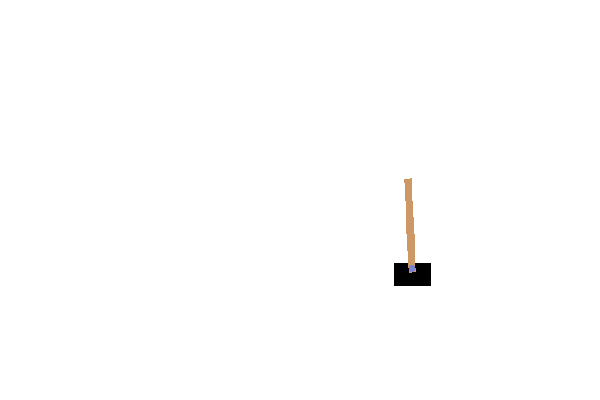
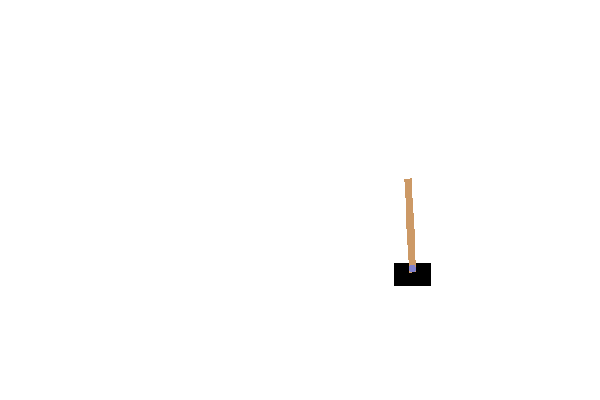
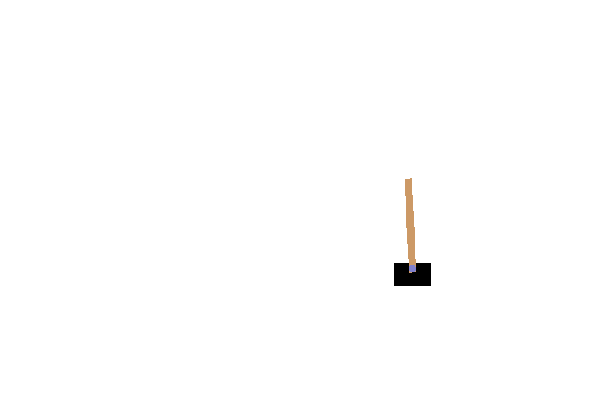
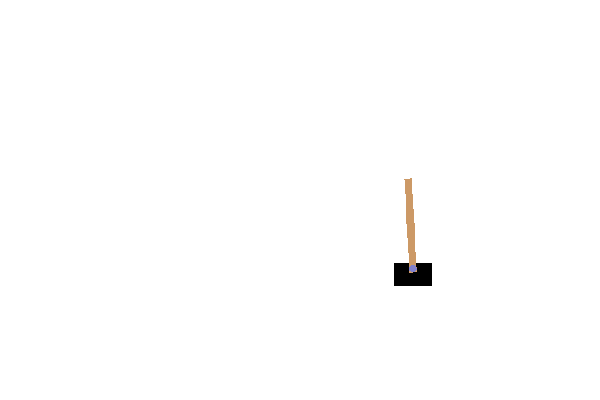
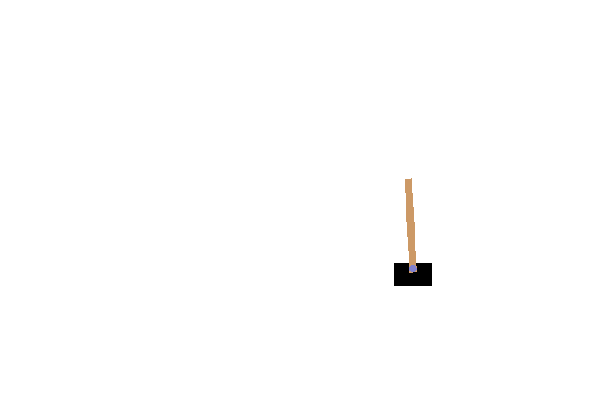
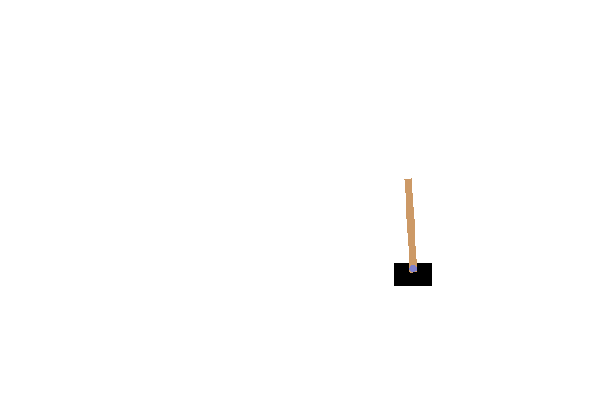
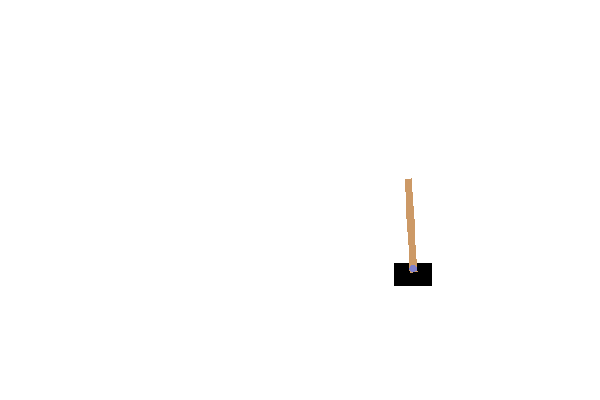
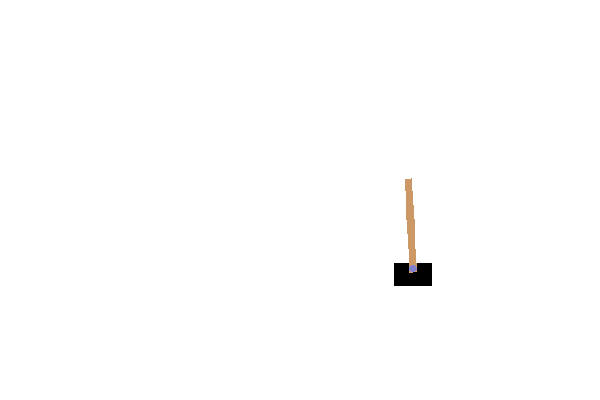
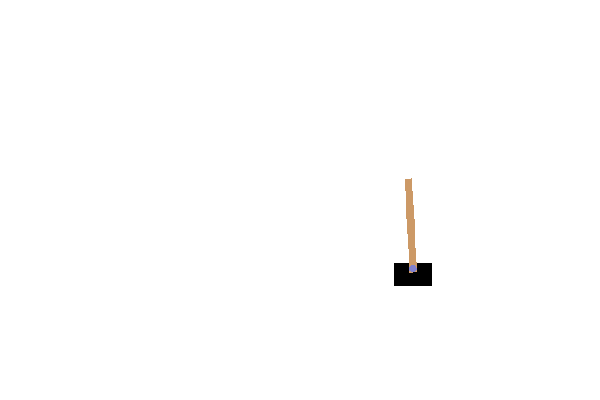
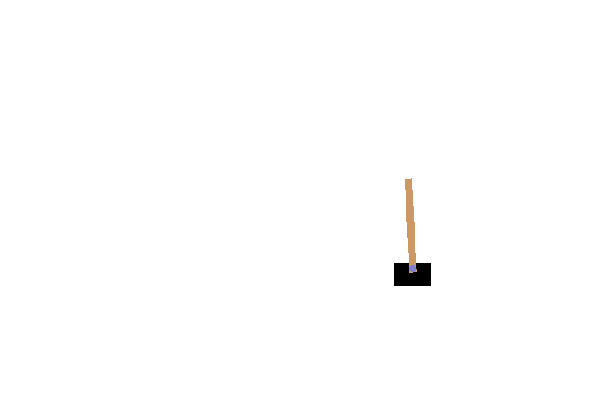
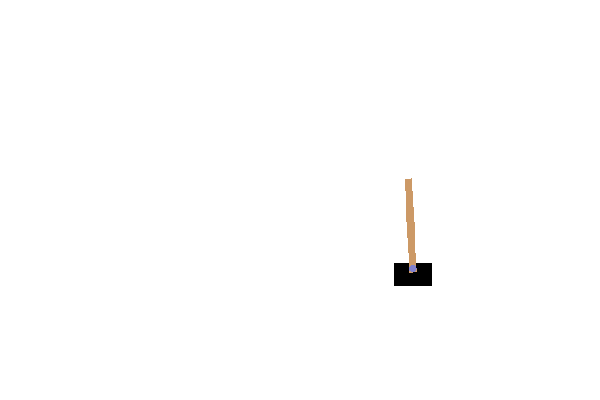
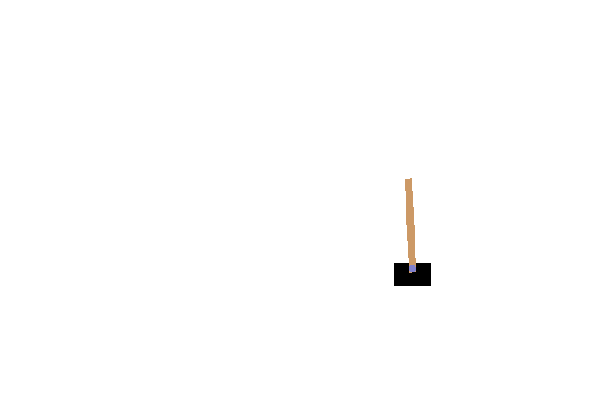
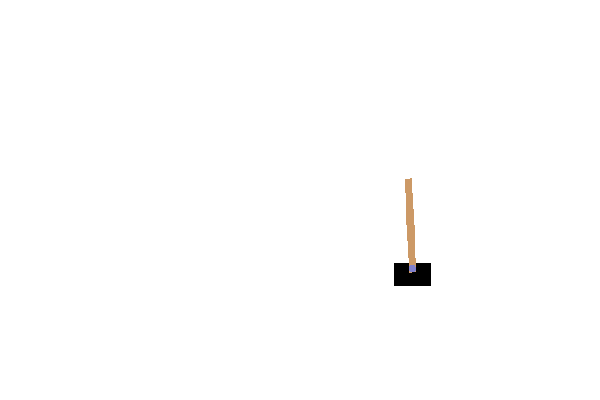
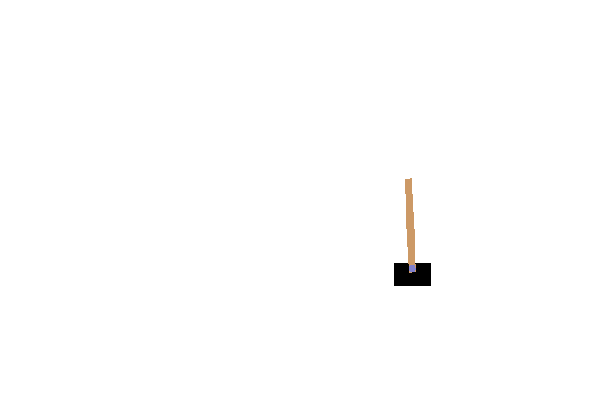
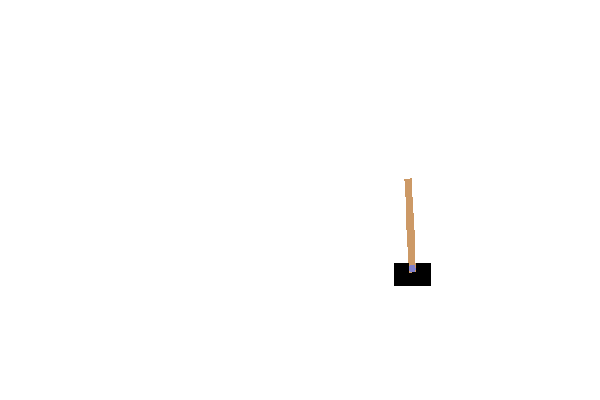
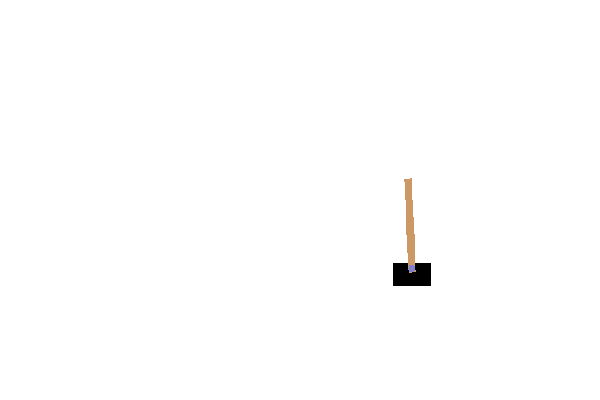
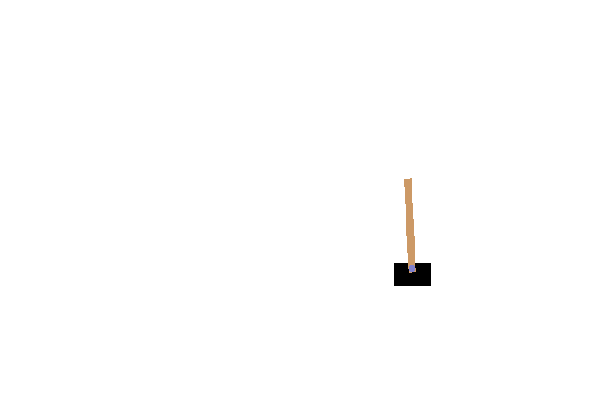
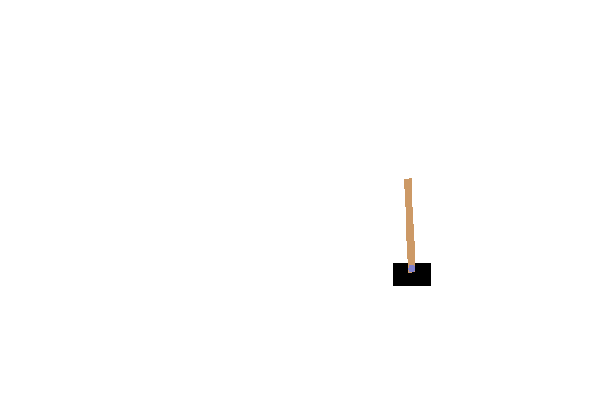
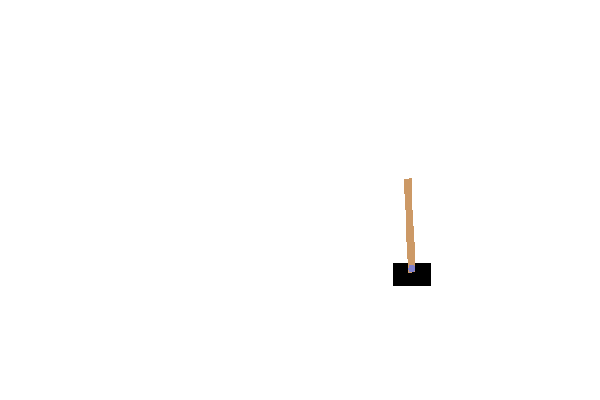
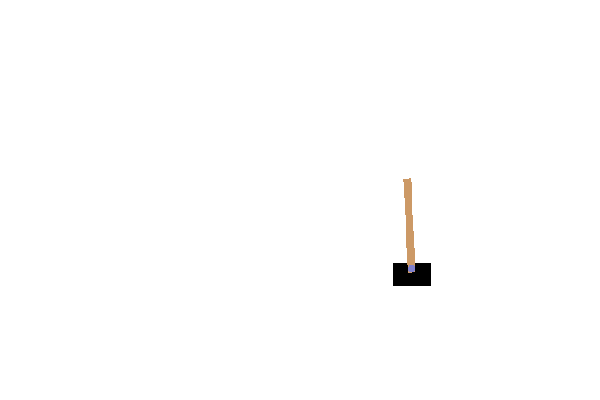
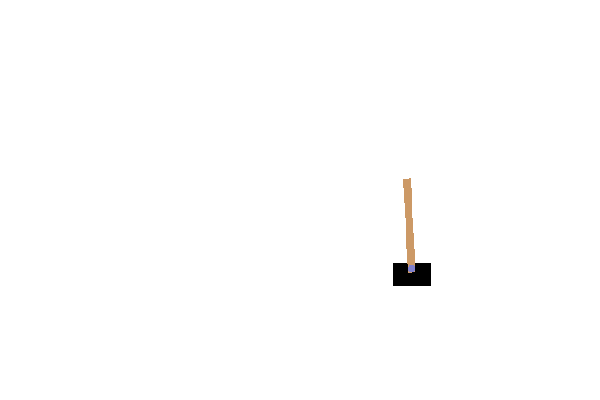
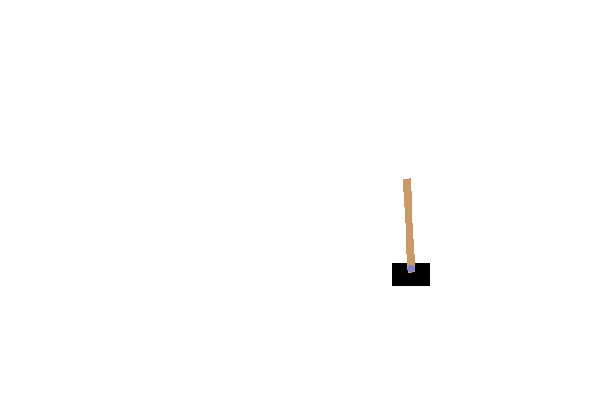
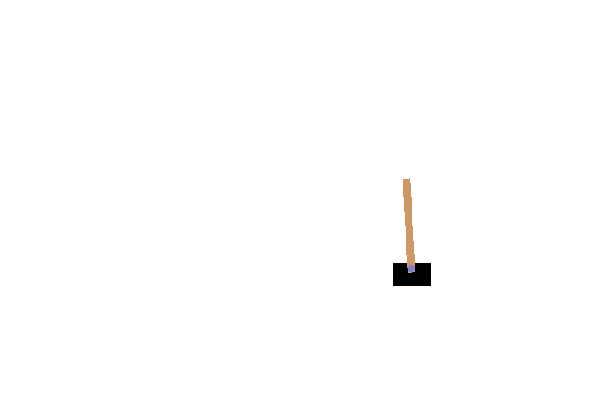
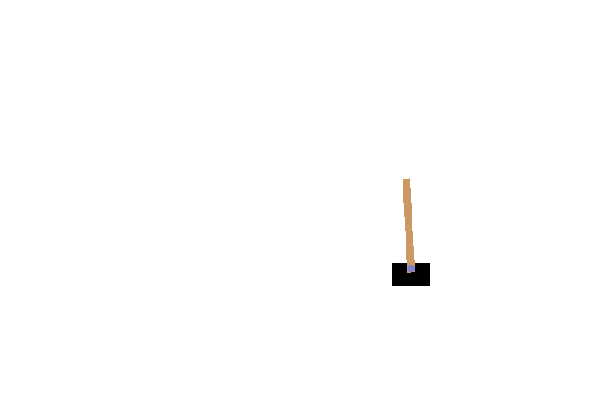
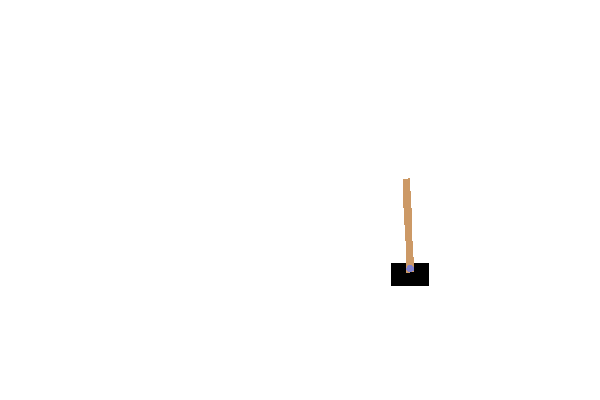
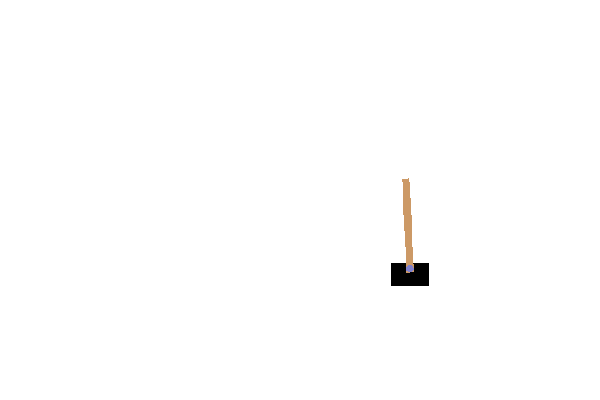
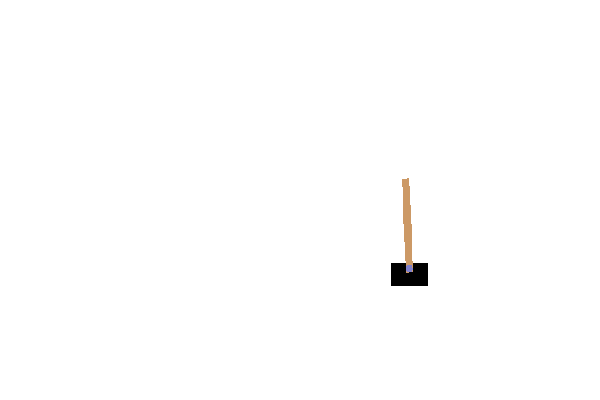
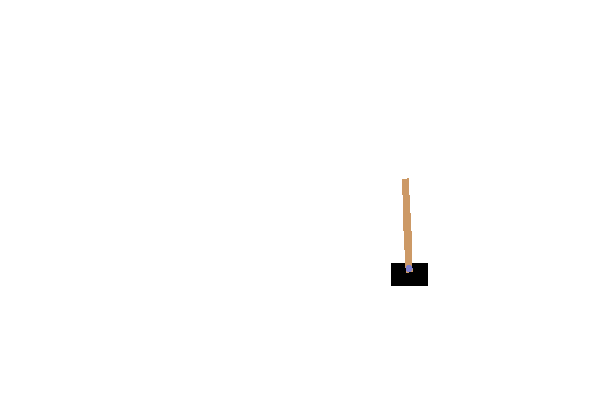
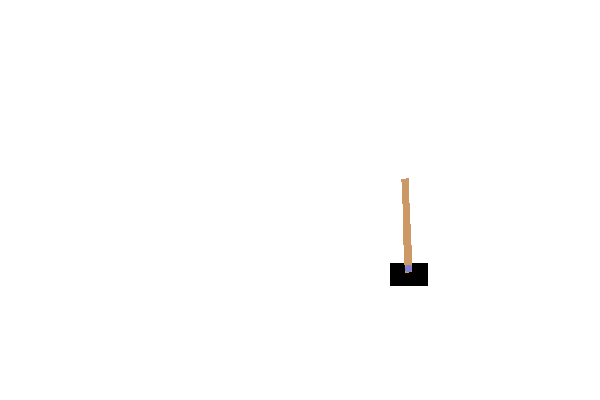
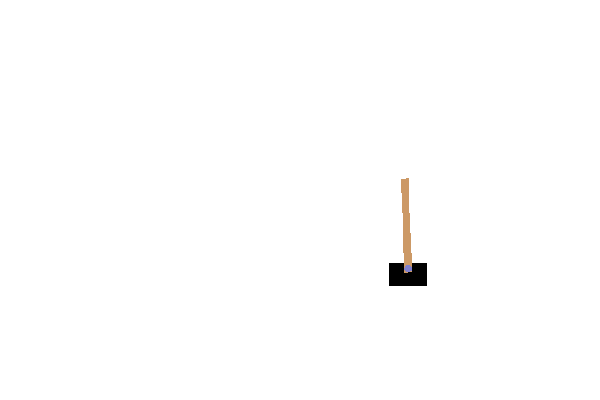
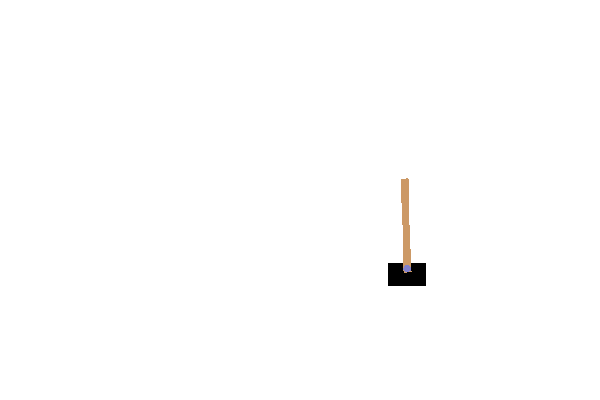
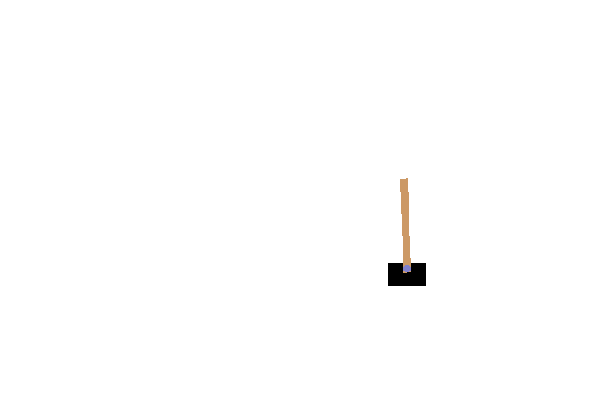
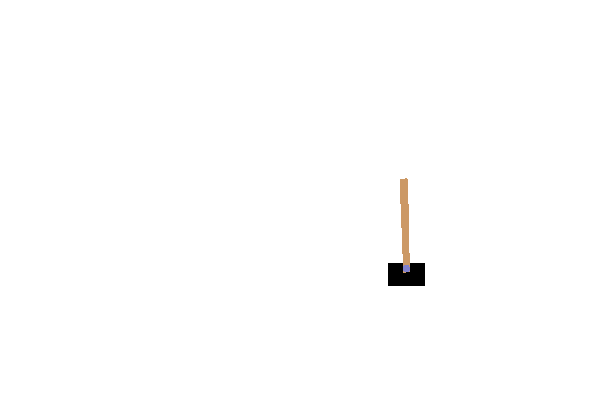
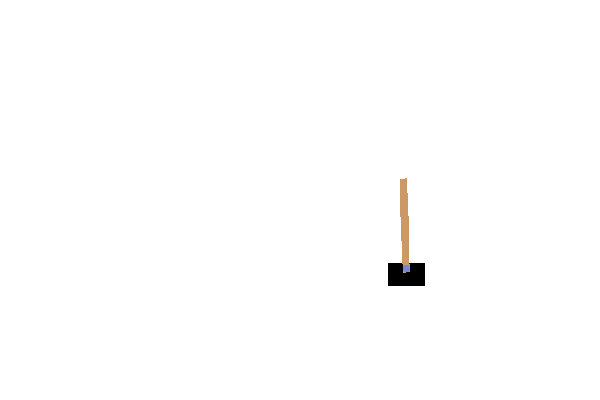
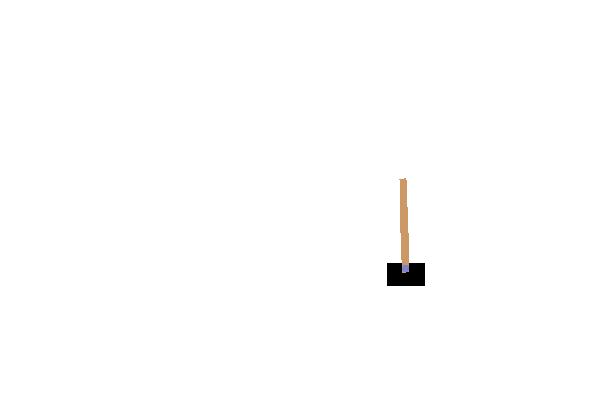
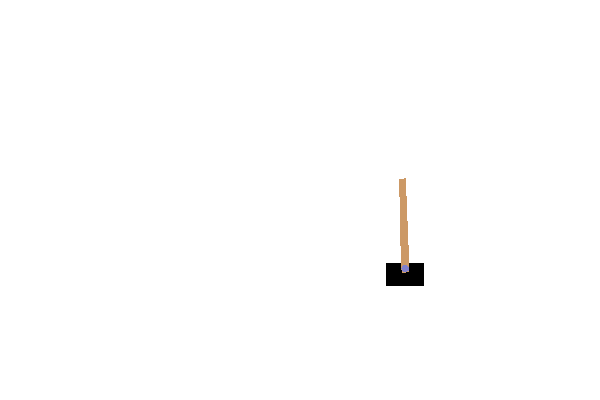
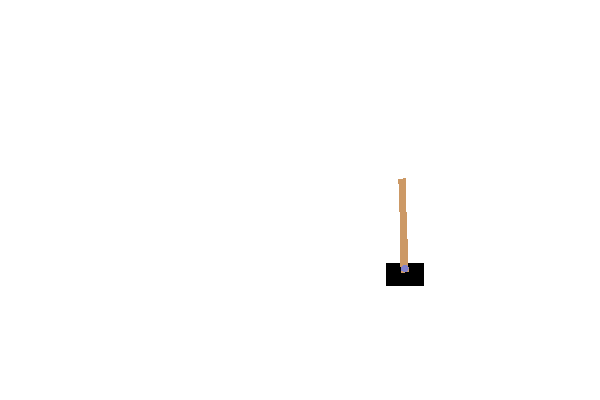
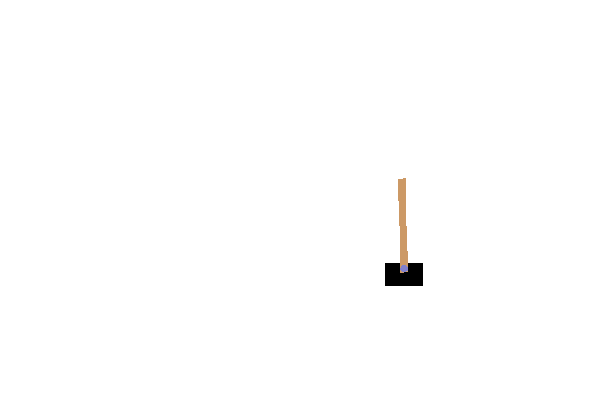
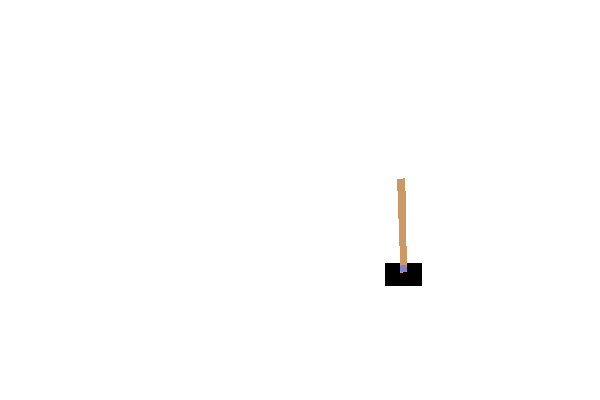
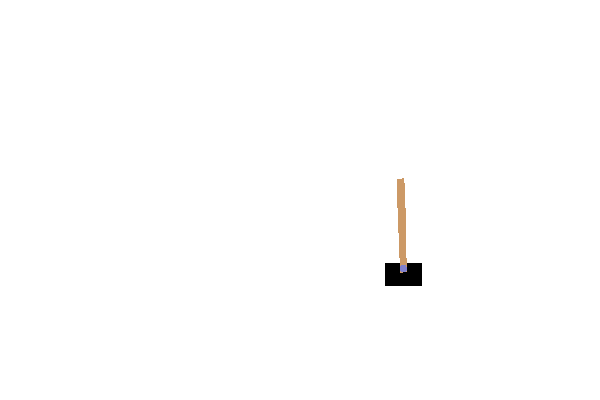
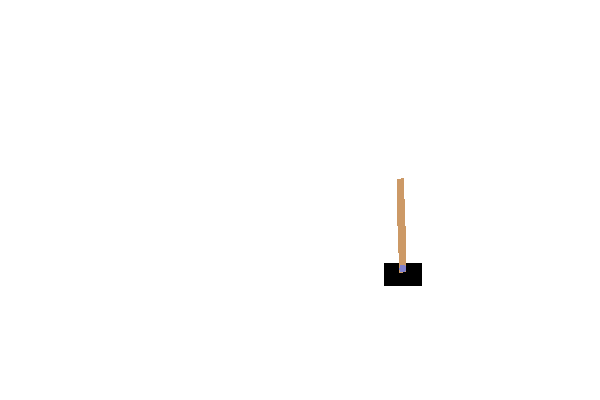
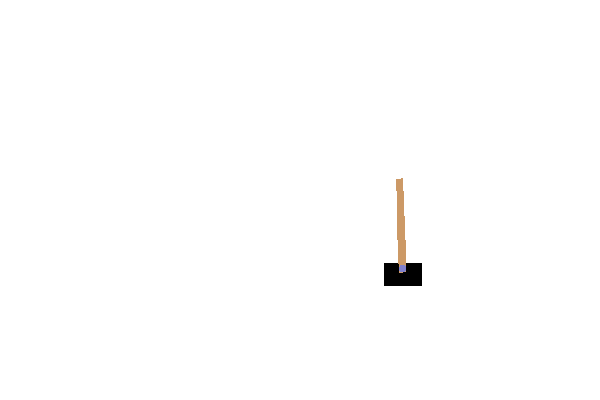
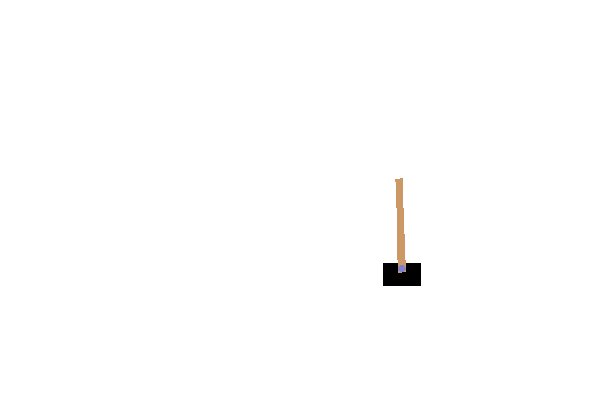
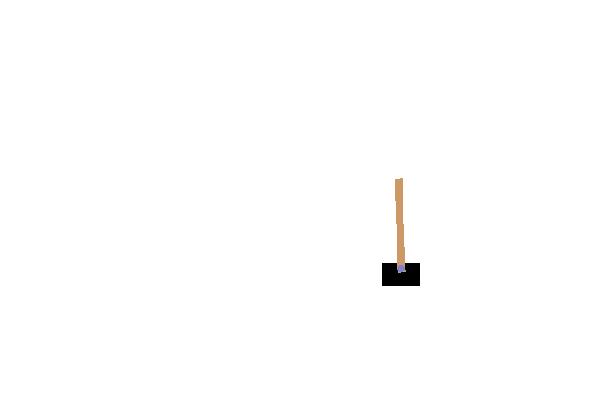
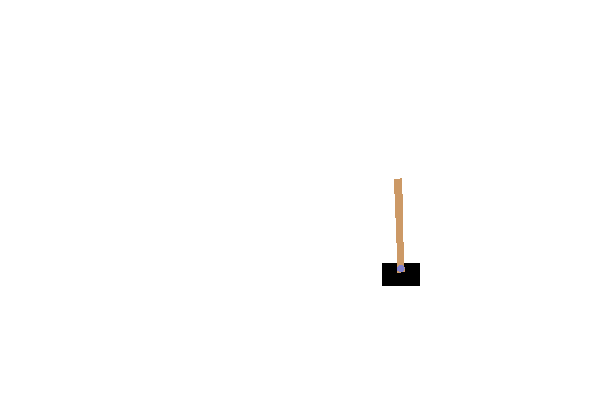
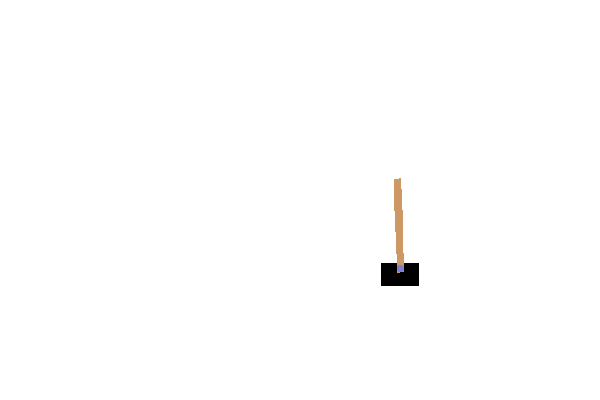
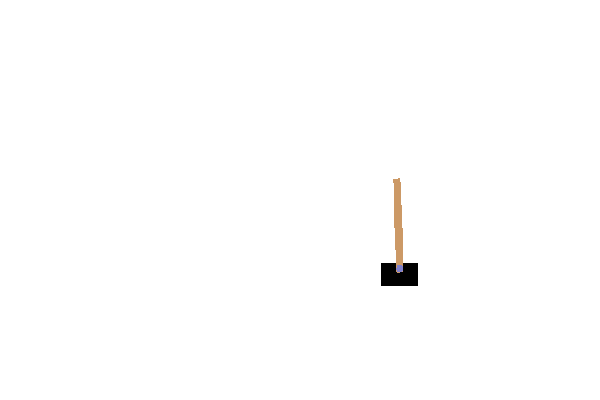
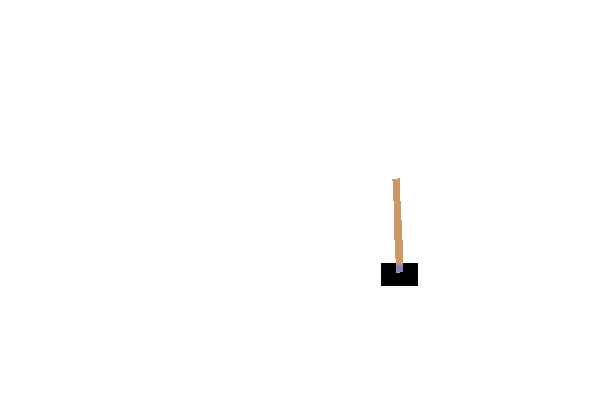
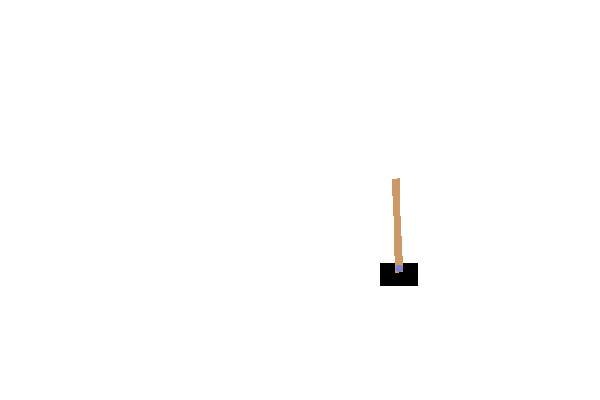
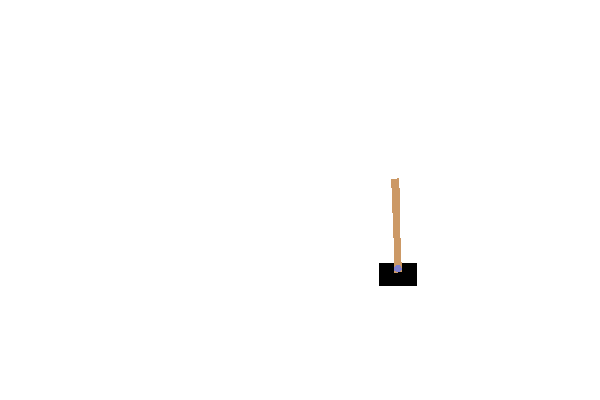

In [45]:
n_iter = 5

frames = []

for t in range(n_iter):
    # Render into buffer. 
    # You will still see the window.
    obs = env.reset()
    done = False
    while not done:
        action = nn_policy(obs)
        env.render()
        obs, reward, done, info = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
env.render(close=True)

display_frames_as_gif(frames)

#### Huber Loss

In [ ]:
def huber_loss(y_true, y_pred):
    err = y_pred - y_true
    square_err = tf.contrib.keras.backend.square(err)
    abs_err = tf.contrib.keras.backend.abs(err)
    mean_square_err = tf.contrib.keras.backend.mean(square_err, axis=-1)
    mean_abs_err = tf.contrib.keras.backend.mean(abs_err, axis=-1)
    if mean_abs_err < 1:
        loss = mean_square_err / 2
    else:
        loss = mean_abs_err - (1. / 2.)
    return loss